In [1]:
import re
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

import os
from collections import namedtuple, OrderedDict
import numpy as np
from skimage import io
import imageio

import pyro
import pyro.optim as optim
# from pyro.infer import SVI, TraceGraph_ELBO
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.contrib.examples.multi_mnist as multi_mnist
import torch
import torch.nn as nn
from torch.nn.functional import dropout, relu, tanh, sigmoid, softplus, grid_sample, affine_grid, avg_pool2d

import pandas as pd
import matplotlib.pyplot as plt

from sympy.solvers import solve
from sympy import Symbol, var
from sympy.solvers.diophantine import diophantine
from sympy.solvers.diophantine.diophantine import diop_solve
from sympy.solvers.diophantine.diophantine import diop_ternary_quadratic

import visdom

import gc

from collections import OrderedDict

In [2]:
torch.pi = torch.acos(torch.zeros(1)).item() * 2

device = torch.device('cuda:0')

default_dtype = torch.float64
default_dtype_np = np.float64

torch.set_default_dtype(default_dtype)

vis = visdom.Visdom()

Setting up a new session...


In [3]:
def solve_padding_dilation(h_in, h_out, kernel_size=3, stride=1):
    H_in = Symbol("H_in", integer=True, positive=True)
    H_out = Symbol("H_out", integer=True, positive=True)
    padding = var("padding", integer=True, positive=True)
    dilation = var("dilation", integer=True, positive=True)
    # dilation=1
    # kernel_size = Symbol("kernel_size", integer=True)
    # kernel_size = 3
    # stride = Symbol("stride", integer=True)
    # stride = 1
    # m = Symbol("m", integer=True)

    H_in

    equation = (H_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride  + 1 - H_out
    # equation.subs({H_in:32, H_out:40, padding:0})
    
    for i in range(100):
        

        solution = diophantine(equation.subs({H_in:h_in, H_out:h_out, padding:i}))
        
        # print(solution)
        
        if len(solution) == 0:
            continue

        dilation_val = list(solution)[0][0]
        
        print(solution, dilation_val)
        if dilation_val > 0:
            padding_val = i
            break
    return padding_val, dilation_val

In [4]:
def load_model(model_root):
    predict_position_path = os.path.join(model_root, "predict_position.pt")
    predict_media_path = os.path.join(model_root, "predict_media.pt")
    optim_path = os.path.join(model_root, "optim.pt")
    model_path = os.path.join(model_root, "mymodel.pt")

    
    # predict_position.load_state_dict(torch.load(predict_position_path))
    predict_media.load_state_dict(torch.load(predict_media_path))
    

    optimizer.load(optim_path)

    pyro.get_param_store().load(model_path)
    
def save_model(model_root):
    os.makedirs(model_root, exist_ok=True)
    
    predict_position_path = os.path.join(model_root, "predict_position.pt")
    predict_media_path = os.path.join(model_root, "predict_media.pt")
    optim_path = os.path.join(model_root, "optim.pt")
    model_path = os.path.join(model_root, "mymodel.pt")
    
    # torch.save(predict_position.state_dict(), predict_position_path)
    torch.save(predict_media.state_dict(), predict_media_path)

    optimizer.save(optim_path)

    pyro.get_param_store().save(model_path)

In [5]:
def bayer_mask(h, w, color="g"):
    mask = np.ones((h, w))

    if color == "g":
        for i in range(h):
            if i%2 == 0:
                mask[i, ::2] = 0
            else:
                mask[i, 1::2] = 0
                
    if color == "r":
        for i in range(h):
            if i%2 == 0:
                mask[i, 1::2] = 0
            else:
                mask[i, :] = 0
                
    if color == "b":
        for i in range(h):
            if i%2 == 0:
                mask[i, :] = 0
            else:
                mask[i, ::2] = 0
                
    if color == "m":
        pass
            
    return mask > 0.5

In [6]:
unit = 1. #nn

img_height = 256
img_width = 256
n_obixel_per_pixel = 4
media_height = img_height * n_obixel_per_pixel # 512
media_width = img_width * n_obixel_per_pixel # 512
pixel_size = 1.85*1000*unit
obixel_size = pixel_size / n_obixel_per_pixel

In [7]:
image_small_green_mask = bayer_mask(img_height, img_width, color="m")
image_small_green_mask = torch.from_numpy(image_small_green_mask).to(device=device)

img_height_shift = img_height // 4
img_width_shift = img_width // 4
img_height_half = img_height // 2
img_width_half = img_width // 2

image_small_green_mask[:img_height_shift] = False
image_small_green_mask[img_height_shift+img_height_half:] = False
image_small_green_mask[:, :img_width_shift] = False
image_small_green_mask[:, img_width_shift+img_width_half:] = False

image_small_red_mask = bayer_mask(img_height, img_width, color="m")
image_small_red_mask = torch.from_numpy(image_small_red_mask).to(device=device)

image_small_red_mask[:img_height_shift] = False
image_small_red_mask[img_height_shift+img_width_half:] = False
image_small_red_mask[:, :img_width_shift] = False
image_small_red_mask[:, img_width_shift+img_width_half:] = False

image_small_blue_mask = bayer_mask(img_height, img_width, color="m")
image_small_blue_mask = torch.from_numpy(image_small_blue_mask).to(device=device)

image_small_blue_mask[:img_height_shift] = False
image_small_blue_mask[img_height_shift+img_width_half:] = False
image_small_blue_mask[:, :img_width_shift] = False
image_small_blue_mask[:, img_width_shift+img_width_half:] = False

image_small_rgb_mask = torch.stack([image_small_red_mask, image_small_green_mask, image_small_blue_mask], axis=0)

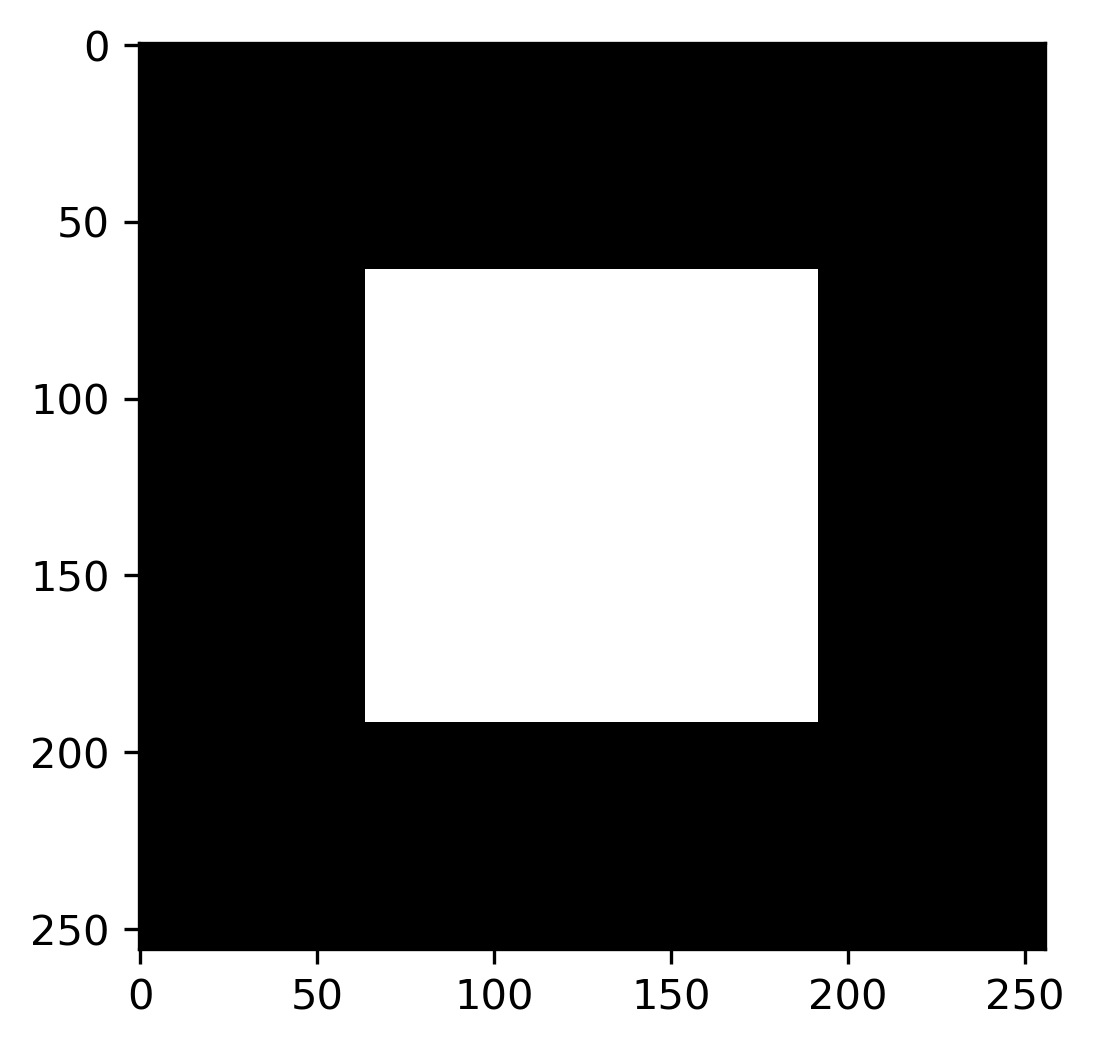

In [8]:
fig = plt.figure(dpi=300)
plt.imshow(torch.permute(image_small_rgb_mask, (1,2,0)).float().cpu())

# Load Dataset

In [9]:
dataset_root = "lensless-mono"

image_files_path = []
for root, folders, files in os.walk(dataset_root):
    # print(p)
    # if root == dataset_root:
    #     continue
    if len(files) == 0:
        continue
        
    for p in files:
        if p.endswith("tif"):
            image_files_path.append((root, os.path.join(root, p)))

In [10]:
sorted(image_files_path)

[('lensless-mono/chanchup_180i_v',
  'lensless-mono/chanchup_180i_v/chanchup_180i_v_led_0_color_0.tif'),
 ('lensless-mono/chanchup_180i_v',
  'lensless-mono/chanchup_180i_v/chanchup_180i_v_led_0_color_1.tif'),
 ('lensless-mono/chanchup_180i_v',
  'lensless-mono/chanchup_180i_v/chanchup_180i_v_led_0_color_2.tif'),
 ('lensless-mono/chanchup_180i_v',
  'lensless-mono/chanchup_180i_v/chanchup_180i_v_led_0_color_3.tif'),
 ('lensless-mono/chanchup_180i_v',
  'lensless-mono/chanchup_180i_v/chanchup_180i_v_led_1_color_0.tif'),
 ('lensless-mono/chanchup_180i_v',
  'lensless-mono/chanchup_180i_v/chanchup_180i_v_led_1_color_1.tif'),
 ('lensless-mono/chanchup_180i_v',
  'lensless-mono/chanchup_180i_v/chanchup_180i_v_led_1_color_2.tif'),
 ('lensless-mono/chanchup_180i_v',
  'lensless-mono/chanchup_180i_v/chanchup_180i_v_led_1_color_3.tif'),
 ('lensless-mono/chanchup_180i_v',
  'lensless-mono/chanchup_180i_v/chanchup_180i_v_led_2_color_0.tif'),
 ('lensless-mono/chanchup_180i_v',
  'lensless-mono/cha

In [11]:
specimens = np.array(["chanchup_180i_v", "chanchupi_v", "mahuichongshoujinruan_v", "shuixiguojinchao", "shuixiguojinchao_v", "wochonghenqie_v"])

In [12]:
specimens_used = specimens[[2]]

In [13]:
led_position = np.array(
    [
        [0, 92.5, 130],
        [0, 75.5, 130],
        [0, 58.5, 130],
        [0, 41.5, 130],
        [0, 24.5, 130],
        [0, 7.5, 130]
    ]
)

sensor_position = np.array([0, 48.25, 0])

led_position_rel = led_position - sensor_position

In [14]:
led_position_rel

array([[  0.  ,  44.25, 130.  ],
       [  0.  ,  27.25, 130.  ],
       [  0.  ,  10.25, 130.  ],
       [  0.  ,  -6.75, 130.  ],
       [  0.  , -23.75, 130.  ],
       [  0.  , -40.75, 130.  ]])

In [15]:
dataset = {}

for r, p in sorted(image_files_path):
    specimen = r.split(r"/")[1]
    
    if specimen not in  specimens_used:
        continue
    
    img = io.imread(p).T.astype(default_dtype_np)
    img = torch.from_numpy(img)
    led_and_color = re.findall(r"^.+?led_(\d)_color_(\d).+?$", p)[0]
    led_and_color = [int(j) for j in led_and_color]
    led, color = led_and_color
    
    # if led < 2 or led > 3:
    if led != 2:
        continue
    
    if color == 3:
        continue
        
    color = 2 - color
    
    
    img_id = f"{specimen}_{led}"
    
    
    if dataset.get(img_id, None) is None:
        data_single = {
            "img": torch.zeros((3, img.shape[0], img.shape[1])),
            "position": led_position_rel[led],
            "led": led
        }

    data_single["img"][color] = img
    
    dataset[img_id] = data_single
        
    

In [16]:
for key, value in dataset.items():
    value["img"] = (value["img"] - value["img"].min()) / (value["img"].max() - value["img"].min())

In [17]:
# dataset["chanchupi_v_2"]

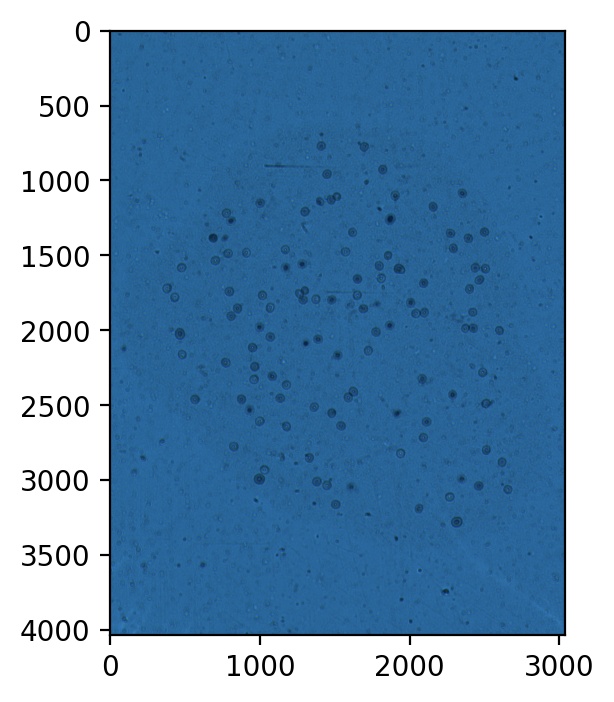

In [18]:
test = dataset["mahuichongshoujinruan_v_2"]["img"]
test = test.numpy()[::].copy()
test = torch.from_numpy(test)

fig = plt.figure(dpi=200)
plt.imshow(torch.permute(test, (1,2,0)))

In [19]:
# image_full_height, image_full_width = dataset["chanchupi_v_2"]["img"].shape[1:]
image_full_height, image_full_width = 4032, 3036

y_full_idx = torch.arange(image_full_height*n_obixel_per_pixel)
x_full_idx = torch.arange(image_full_width*n_obixel_per_pixel)
yy_full_idx, xx_full_idx = torch.meshgrid(y_full_idx, x_full_idx)

In [20]:
yy_full_geo = (yy_full_idx+0.5-image_full_height*n_obixel_per_pixel/2)*obixel_size*-1
xx_full_geo = (xx_full_idx+0.5-image_full_width*n_obixel_per_pixel/2)*obixel_size

obixel_full_grid = torch.stack([xx_full_geo, yy_full_geo], axis=-1)

In [21]:
xx_full_geo

tensor([[-2808068.7500, -2807606.2500, -2807143.7500,  ...,
          2807143.7500,  2807606.2500,  2808068.7500],
        [-2808068.7500, -2807606.2500, -2807143.7500,  ...,
          2807143.7500,  2807606.2500,  2808068.7500],
        [-2808068.7500, -2807606.2500, -2807143.7500,  ...,
          2807143.7500,  2807606.2500,  2808068.7500],
        ...,
        [-2808068.7500, -2807606.2500, -2807143.7500,  ...,
          2807143.7500,  2807606.2500,  2808068.7500],
        [-2808068.7500, -2807606.2500, -2807143.7500,  ...,
          2807143.7500,  2807606.2500,  2808068.7500],
        [-2808068.7500, -2807606.2500, -2807143.7500,  ...,
          2807143.7500,  2807606.2500,  2808068.7500]])

In [22]:
yy_full_geo

tensor([[ 3729368.7500,  3729368.7500,  3729368.7500,  ...,
          3729368.7500,  3729368.7500,  3729368.7500],
        [ 3728906.2500,  3728906.2500,  3728906.2500,  ...,
          3728906.2500,  3728906.2500,  3728906.2500],
        [ 3728443.7500,  3728443.7500,  3728443.7500,  ...,
          3728443.7500,  3728443.7500,  3728443.7500],
        ...,
        [-3728443.7500, -3728443.7500, -3728443.7500,  ...,
         -3728443.7500, -3728443.7500, -3728443.7500],
        [-3728906.2500, -3728906.2500, -3728906.2500,  ...,
         -3728906.2500, -3728906.2500, -3728906.2500],
        [-3729368.7500, -3729368.7500, -3729368.7500,  ...,
         -3729368.7500, -3729368.7500, -3729368.7500]])

In [23]:
image_smalls = []
obixel_full_grid_smalls = []
led_position_smalls = []
for key, value in dataset.items():
    image_rgb = value["img"]
    position = value["position"]
    led = value["led"]
    
    # if led < 2:
    #     continue
    # if led > 3:
    #     continue
    
    for i in range(0, image_full_height, img_height//2):
        for j in range(0, image_full_width, img_width//2):

            
            if i+img_height >= image_full_height:
                continue
                
            if j+img_width >= image_full_width:
                continue

            if i < 750 and (i % img_height != 0):
                continue
            if i > 3500 and (i % img_height != 0):
                continue
                
                
                
            led_position_smalls.append(position)
            image_smalls.append(image_rgb[:, i:i+img_height, j:j+img_width])
            obixel_full_grid_smalls.append(
                obixel_full_grid[i*n_obixel_per_pixel:(i+img_height)*n_obixel_per_pixel, 
                                 j*n_obixel_per_pixel:(j+img_width)*n_obixel_per_pixel])

In [24]:
image_smalls = np.stack(image_smalls, axis=0)
image_smalls = torch.from_numpy(image_smalls)

In [25]:
image_smalls.shape

torch.Size([572, 3, 256, 256])

In [26]:
smalls_dir = "smalls-256-mahuichong"
os.makedirs(smalls_dir, exist_ok=True)
for idx, img in enumerate(torch.permute(image_smalls, (0, 2, 3, 1))):
    
    io.imsave(f"{smalls_dir}/{idx}.bmp", img*255)
    

Lossy conversion from float64 to uint8. Range [19.985773409208484, 195.70227625452662]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [24.668908432488358, 200.51733057423692]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [24.2731505431971, 213.64330056906363]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [24.2731505431971, 213.64330056906363]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [28.164769787894464, 210.41127780651837]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [24.80082772891878, 210.41127780651837]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [24.80082772891878, 216.01784790481116]. 

Lossy conversion from float64 to uint8. Range [9.036471805483705, 251.89989653388517]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [9.366270046559752, 251.89989653388517]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [9.63010863942059, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [9.63010863942059, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [26.647697878944644, 220.1733057423694]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [27.17537506466632, 217.0732022762545]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [25.52638385928608, 215.95188825659596]. Convert image to uint8 prior t

Lossy conversion from float64 to uint8. Range [16.160113812726333, 213.24754267977238]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [20.645369891360577, 225.713916192447]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [20.645369891360577, 245.10605276771858]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [25.79022245214692, 245.10605276771858]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [21.832643559234352, 215.02845318158302]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [18.270822555613037, 227.03310915675118]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [4.287377133988619, 255.0]. Convert ima

Lossy conversion from float64 to uint8. Range [9.827987584066218, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [13.125969994826695, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [13.125969994826695, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [24.00931195033626, 230.39705121572683]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [6.266166580444904, 248.6019141231247]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [6.266166580444904, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [6.266166580444904, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [21.5028453181583, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [9.168391101914123, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [9.168391101914123, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [11.213140196585618, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [10.289705121572686, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [10.289705121572686, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [4.617175375064667, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from flo

Lossy conversion from float64 to uint8. Range [6.530005173305742, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [12.862131401965856, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [12.862131401965856, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [26.3178996378686, 217.13916192446973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [13.851526125193999, 223.7351267459907]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [24.602948784273153, 236.79513709260218]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [17.149508535954475, 255.0]. Convert image to uint8 prior to saving to suppress

Lossy conversion from float64 to uint8. Range [11.938696326952924, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [6.79384376616658, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [6.464045525090533, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [6.464045525090533, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [5.804449042938438, 222.28401448525608]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [5.672529746508019, 222.28401448525608]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [5.606570098292809, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
L

Lossy conversion from float64 to uint8. Range [16.753750646663217, 214.69865494050697]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [16.753750646663217, 209.42188308329023]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [18.138903259182616, 211.33471288153132]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [26.845576823590275, 211.33471288153132]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [25.658303155716503, 238.11433005690637]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [14.709001551991722, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [14.709001551991722, 255.0]. Convert image to uin

Lossy conversion from float64 to uint8. Range [11.345059493016038, 223.27340920848422]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [24.53698913605794, 223.27340920848422]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [18.468701500258668, 230.72684945680288]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [8.244956026901189, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [8.244956026901189, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [8.376875323331609, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [7.387480600103466, 255.0]. Convert image to uint8 prior to saving to suppress 

Lossy conversion from float64 to uint8. Range [19.32617692705639, 201.50672529746507]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [16.55587170201759, 219.31583031557165]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [16.55587170201759, 219.31583031557165]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [24.141231246766683, 213.97309881013967]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [24.141231246766683, 212.98370408691153]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [18.864459389549925, 237.32281427832385]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [17.215468184169687, 237.32281427832385

Lossy conversion from float64 to uint8. Range [26.449818934299017, 208.03673047077083]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [26.449818934299017, 206.12390067252977]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [11.872736678737715, 208.36652871184688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [11.872736678737715, 236.72917744438695]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [6.9257630625969995, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [6.9257630625969995, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [27.24133471288153, 203.88127263321263]. Convert image to uint

In [27]:
obixel_full_grid_smalls = torch.stack(obixel_full_grid_smalls, axis=0)

In [28]:
obixel_full_grid_smalls.shape

torch.Size([572, 1024, 1024, 2])

In [29]:
position_smalls = np.array(led_position_smalls)
position_smalls = torch.from_numpy(position_smalls)
# object_height = 0.587873077
object_height = 0.5
position_smalls = torch.cat([position_smalls, torch.ones((image_smalls.shape[0], 1))*object_height], axis=1)*1e6

position_smalls

tensor([[0.0000e+00, 1.0250e+07, 1.3000e+08, 5.0000e+05],
        [0.0000e+00, 1.0250e+07, 1.3000e+08, 5.0000e+05],
        [0.0000e+00, 1.0250e+07, 1.3000e+08, 5.0000e+05],
        ...,
        [0.0000e+00, 1.0250e+07, 1.3000e+08, 5.0000e+05],
        [0.0000e+00, 1.0250e+07, 1.3000e+08, 5.0000e+05],
        [0.0000e+00, 1.0250e+07, 1.3000e+08, 5.0000e+05]])

# Model

# $\theta$ and $\phi$
    \
     \
      \
    ...\..............                     
    ....\.............                                L                    \                                   
    .....\............                              .                       \    __ undetected                   
    ......\..𝜙........                            .                          \    /|                  
    .......\..........                          .   𝜃                         \  /             
    ..................                   P....................                 \/                   
    ..................                  .   .                                  /\                   
    ..................                 .  .                                   /  \                       
    ..................                . .                                    /    \ outgoing                     
    ..................           ....O..............                    ingoing                               

## shift of x and y
$x = h \cdot \tan(\theta) \cdot \cos(\phi)$ 

$y = h \cdot \tan(\theta) \cdot \sin(\phi)$

Suppose $x_i$ is the light distance in a same pixel, and $\delta$ is the phase shift
$$\int_0^{2\pi} | \sum_i{sin(kx_i + \delta)} |\ d\delta $$

$$\int_0^{2\pi} | \sum_i{sin(\frac{2\pi}{490}x_i + \delta)} |\ d\delta $$

## Location on Sensor Corresponding to Image
    Upper-Left ---------------Bottom-Left
         |                         |
         |                         |
    Upper-Right---------------Botttom-Right

In [30]:
scattering_proportion_loc = torch.zeros(1, media_height, media_width, 1)
# scattering_proportion_loc = torch.zeros(1, media_height, media_width, 2)
# scattering_proportion_loc[:, 128:156, 273:300, :] = 0.7

# angle shift from reflection or fraction [−𝜋/4,𝜋/4]
angle_shift_loc = torch.tensor([0., 0.])
angle_shift_scale = torch.tensor([0.1, 0.1])

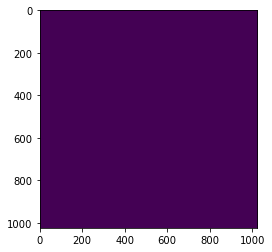

In [31]:
plt.imshow(scattering_proportion_loc[0, ..., 0])

In [32]:
invalid_scattering_threshold = 0.46 # 0.46*pi
wavelenghth = torch.tensor([622.5, 523.5, 466.])
wavelenghth = wavelenghth.view(1, 3, 1, 1, 1).to(device=device) * unit # nm
omega = 2*torch.pi/wavelenghth
n_phase_grid = 10
phase_shift_grid = torch.linspace(0, torch.pi*2, n_phase_grid)
phase_shift_grid = phase_shift_grid.expand(1, 1, media_height, media_width, n_phase_grid).to(device=device)
# phase_shift_grid

In [33]:
omega

tensor([[[[[0.0101]]],


         [[[0.0120]]],


         [[[0.0135]]]]], device='cuda:0')

In [34]:
x_idx = torch.arange(media_width)
y_idx = torch.arange(media_height)

yy_idx, xx_idx = torch.meshgrid(y_idx, x_idx)

yy_geo = (yy_idx+0.5-media_height/2)*obixel_size*-1
xx_geo = (xx_idx+0.5-media_width/2)*obixel_size

obixel_grid_global = torch.stack([xx_geo, yy_geo], axis=-1).to(device=device)

In [35]:
def scattering_amplitude(n, shift_x, shift_y, amplitude):
    
    obixel_grid_ = obixel_grid_global.expand(n, 1, media_height,media_width, 2)
    
    target_index_x = (obixel_grid_[..., 0:1] + shift_x)/obixel_size + media_width/2 - 0.5
    target_index_y = -(obixel_grid_[..., 1:2] + shift_y)/obixel_size + media_height/2 - 0.5
    
    target_index_x = torch.clamp(target_index_x, 0, media_width-1)
    target_index_y = torch.clamp(target_index_y, 0, media_height-1)
        
    
    target_index_all = [
        (target_index_x.ceil, target_index_y.ceil),
        (target_index_x.ceil, target_index_y.floor),
        (target_index_x.floor, target_index_y.ceil),
        (target_index_x.floor, target_index_y.floor)
        
    ]
    
   
    amplitude_target = torch.zeros_like(amplitude)
    
    batch_indices = torch.arange(n).reshape(n, 1).expand(n, 3*media_height*media_width).reshape(-1)
    color_indices = torch.arange(3).reshape(1, 3, 1).expand(n, 3, media_height*media_width).reshape(-1)
    
    for xy in target_index_all:
        amplitude_target.index_put_(
            [
                batch_indices,
                color_indices,
                xy[1]().long().reshape(-1),
                xy[0]().long().reshape(-1),
            ],
            (amplitude * torch.abs( (xy[0]() - target_index_x) * (xy[1]() - target_index_y) )).reshape(-1, n_phase_grid),
            accumulate=True
        )
        
    
    # amplitude_target = amplitude_target_ceil_ceil + amplitude_target_ceil_floor + amplitude_target_floor_ceil + amplitude_target_floor_floor
    amplitude_target /= 4
    
    return amplitude_target

In [36]:
def prior_sketch(n, obixel_grid, position_all, real_x=None, real_y=None, real_z=None, real_h=None):
    
    position_relative = position_all[..., :2] - obixel_grid[:, None]
    
    pos_x = position_relative[..., 0:1]
    pos_y = position_relative[..., 1:2]
    pos_z = position_all[..., 2:3]
    pos_h = position_all[..., 3:4]
    
    # phi = torch.asin(pos_y / torch.sqrt(pos_x*pos_x + pos_y*pos_y))
    phi_ingoing = torch.atan2(pos_y, pos_x) 
    phi_outgoing = phi_ingoing + torch.pi
    
    
    # theta =  torch.atan(torch.exp( torch.log(torch.sqrt(pos_x*pos_x + pos_y*pos_y)) - torch.log(pos_z) ))
    theta = torch.atan(torch.sqrt(pos_x*pos_x + pos_y*pos_y)/pos_z)
    

    
    
    
    theta_max, _ = theta.view(n, -1).max(axis=-1)
    theta_min, _ = theta.view(n, -1).min(axis=-1)
    # theta_max = theta_max.view(n, 1, 1, 1, 1)#.detach()
    # theta_min = theta_min.view(n, 1, 1, 1, 1)#.detach()
    angle_shift_maximum = ((theta_max - theta_min)/2).view(n, 1, 1, 1, 1)#.expand(n, 3, media_height, media_width, 2)
    

    angle_shift = dist.Normal(
        theta.expand(n, 3, media_height, media_width, 2),
        angle_shift_maximum.expand(n, 3, media_height, media_width, 2)
    ).to_event(3).sample()
    angle_shift = torch.clamp(angle_shift, 0., torch.pi/2)
    theta_ingoing = angle_shift[..., 0:1]
    theta_outgoing = angle_shift[..., 1:2]
    
    
    scattering_proportion = pyro.sample("scattering_proportion", dist.Uniform(
            scattering_proportion_loc.expand(n, 3, media_height, media_width, 2),
            scattering_proportion_loc.expand(n, 3, media_height, media_width, 2)+1.
        ).to_event(4)
    ).to(device=device)
    
    detected_proportion = torch.clamp(scattering_proportion[..., 0:1], 0., 1.)
    outgoing_proportion = torch.clamp(scattering_proportion[..., 1:2], 0., 1.)
    ingoing_proportion = (1-outgoing_proportion) * detected_proportion
    outgoing_proportion = outgoing_proportion * detected_proportion

    
    # shift_x, shift_y on the same side
    ingoing_modulus = pos_h * torch.tan(theta_ingoing)
    ingoing_light_distance = pos_h / torch.cos(theta_ingoing)
    ingoing_shift_x = ingoing_modulus * torch.cos(phi_ingoing)
    ingoing_shift_y = ingoing_modulus * torch.sin(phi_ingoing)
    

    # shift_x, shift_y on the other side
    outgoing_modulus = pos_h * torch.tan(theta_outgoing)
    outgoing_light_distance = pos_h / torch.cos(theta_outgoing)
    outgoing_shift_x = outgoing_modulus * torch.cos(phi_outgoing)
    outgoing_shift_y = outgoing_modulus * torch.sin(phi_outgoing) 
    
    # move amplitude with shift_x, and shift_y
    # ingoing amplitude
    ingoing_amplitude = torch.sin(omega * ingoing_light_distance + \
                                  phase_shift_grid) * ingoing_proportion
        
    # outgoing amplitude
    outgoing_amplitude = torch.sin(omega * outgoing_light_distance + \
                                   phase_shift_grid) * outgoing_proportion
    
    ingoing_amplitude_target = scattering_amplitude(
        n, ingoing_shift_x, ingoing_shift_y, ingoing_amplitude)
        
    outgoing_amplitude_target = scattering_amplitude(
        n, outgoing_shift_x, outgoing_shift_y, outgoing_amplitude)
    
    sensor_detected = ingoing_amplitude_target + outgoing_amplitude_target
    sensor_detected = torch.abs(sensor_detected).mean(axis=-1) * torch.pi * 2    
    
    # subsample every n_obixel_per_pixelxn_obixel_per_pixel obixel to one pixel
    sensor_detected = avg_pool2d(sensor_detected, kernel_size=n_obixel_per_pixel, stride=n_obixel_per_pixel)
    
    return sensor_detected

In [37]:
x_idx = torch.arange(media_width)
y_idx = torch.arange(media_height)

yy_idx, xx_idx = torch.meshgrid(y_idx, x_idx)

yy_geo = (yy_idx+0.5-media_height/2)*obixel_size*-1
xx_geo = (xx_idx+0.5-media_width/2)*obixel_size

obixel_grid_ = torch.stack([xx_geo, yy_geo], axis=-1).to(device=device).view(1, media_height, media_width, 2)

In [38]:
ssd = prior_sketch(1, obixel_grid_, position_smalls[:1].to(device=device).view(1, 1, 1, 1, 4))

In [39]:
ssd = torch.permute(ssd, (0, 2,3,1))

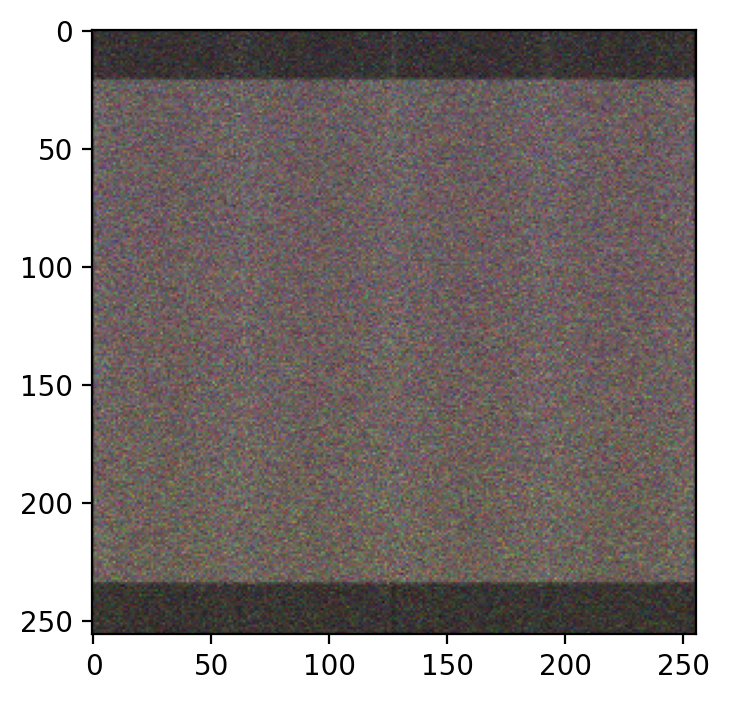

In [40]:
fig = plt.figure(dpi=200)
plt.imshow(ssd[0].cpu())

In [41]:
sensor_detected_sd = torch.tensor([0.1])

def model(images, obixel_grids, positions):
    
    with pyro.plate("images", images.size(0)) as indices:
       
        batch_obixel_grid = obixel_grids[indices].to(device=device)
        n = batch_obixel_grid.size(0)

        
        batch_positions = positions[indices].to(device=device).view(n, 1, 1, 1, 4)
        batch_images = images[indices]#.to(device=device) #.view(n, 1, img_height, img_width)
        
        sensor_detected = prior_sketch(n, batch_obixel_grid, batch_positions)

        image_mask = image_small_rgb_mask.expand(n, 3, img_height, img_width)
        
        sensor_detected = sensor_detected[image_mask].reshape(n, -1).cpu()
        batch_images = batch_images[image_mask].reshape(n, -1)
        
        pyro.sample(
            "obs", 
            dist.Normal(sensor_detected, sensor_detected_sd.expand(n, img_height*img_width*3//4)).to_event(1),
            obs=batch_images
        )
        
        # del batch_obixel_grid
        gc.collect()

# Guide

In [42]:
# predict the scattering proportion and corresponding angles
class PredictMedia(nn.Module):
    def __init__(self, use_cuda=True, *args, **kargs):
        super().__init__(*args, **kargs)
        
        # 256x256 -> 512x512
        self.c1a = nn.Conv2d(3, 256, 3, padding="same")
        self.t1  = nn.ConvTranspose2d(256, 64, 2, stride=2)
        
        
        # 512x512 -> 1024x1024
        self.c2a = nn.Conv2d(64, 128, 3, padding="same")
        self.t2  = nn.ConvTranspose2d(128, 32, 2, stride=2)
        
        
        # 1024x1024 -> 2048x2048
        self.c3a = nn.Conv2d(32, 64, 3, padding="same")
        self.t3  = nn.ConvTranspose2d(64, 16, 2, stride=2)
        
        
        # 2048x2048 -> 1024x1024
        self.c4a = nn.Conv2d(16, 32, 3, padding="same")
        self.p4 = nn.MaxPool2d(2, stride=2)
        
        self.cn = nn.Conv2d(32, 6, 3, padding="same")
        
        if use_cuda:
            self.cuda(device=device)

    def forward(self, images):

        
        h = self.c1a(images)
        h = tanh(h)
        h = dropout(h, p=0.1)
        h = self.t1(h)
        h = tanh(h)
        h = dropout(h, p=0.1)
        

        h = self.c2a(h)
        h = tanh(h)
        h = dropout(h, p=0.1)
        h = self.t2(h)
        h = tanh(h)
        h = dropout(h, p=0.1)
        
        h = self.c3a(h)
        h = tanh(h)
        h = dropout(h, p=0.1)
        h = self.t3(h)
        h = tanh(h)
        h = dropout(h, p=0.1)
        
        h = self.c4a(h)
        h = tanh(h)         
        h = self.p4(h)
       
                 

        a = self.cn(h)

        
        scattering_proportion_loc = sigmoid(a[:, :6])*(1.-1./4095.)
        scattering_proportion_loc = scattering_proportion_loc.view(-1, 3, 2, media_height, media_width)
        scattering_proportion_loc = torch.permute(scattering_proportion_loc, (0, 1, 3, 4, 2))


        return scattering_proportion_loc

In [43]:
predict_media = PredictMedia(use_cuda=True)

In [44]:
def guide(images, obixel_grids, positions):
    
    pyro.module("predict_media", predict_media)
    
    with pyro.plate("images", images.size(0), subsample_size=4) as indices:
        
        n = indices.size(0)
        
        # images should be in shape (n, c, h, w)
        batch_images = images[indices].to(device=device)
        
        scattering_proportion_loc = predict_media(batch_images)

        scattering_proportion = pyro.sample("scattering_proportion", dist.Uniform(
                scattering_proportion_loc.cpu(),
                (scattering_proportion_loc+1./4095.).cpu()
                # torch.ones_like(scattering_proportion_loc).cpu() * 0.3
            ).to_event(4)
        ).cuda(device=device)
        
        
        # del batch_images 
        gc.collect()
    
    

In [45]:
def custom_elbo(model, guide, images, grids, *args, **kargs):
   
    guide_trace = poutine.trace(guide).get_trace(images, grids, *args, **kargs)
    model_trace = poutine.trace(poutine.replay(model, trace=guide_trace)).get_trace(images, grids, *args, **kargs)
    
    n = model_trace.nodes["images"]["value"].size(0)
        
    
    loss = 0
    # for name, site in model_trace.nodes.items():
    #     if site["type"] == "sample":
    #         if not name.startswith("scattering_proportion"):
    #             loss += (site["fn"].log_prob(site["value"]).sum())

    # for name, site in guide_trace.nodes.items():
    #     if site["type"] == "sample":

    #         if not name.startswith("scattering_proportion"):
    #             loss -= (site["fn"].log_prob(site["value"]).sum())
    
    site = model_trace.nodes["obs"]
    loss += site["fn"].log_prob(site["value"]).sum()

                

    # loss += TraceGraph_ELBO().loss_and_grads(model, guide, data, *args, **kargs)
    # loss += Trace_ELBO().differentiable_loss(model, guide, data, y_pres, *args, **kargs)
    # loss += -1*(model_trace.log_prob_sum() - guide_trace.log_prob_sum())
    
    return -loss

In [46]:
learning_rate = 1e-4
optimizer = optim.Adam({'lr': learning_rate})

In [47]:
svi = SVI(model,
          guide,
          optimizer,
          # loss=Trace_ELBO()
          loss=custom_elbo
         )

In [48]:
if image_smalls.shape[1] !=3:
    image_smalls = torch.permute(image_smalls, (0, 3, 1, 2))

In [49]:
magic = f"model-mahuichong-{img_height}-{n_obixel_per_pixel}-{object_height}-{learning_rate}"
# load_model(f"model-one-led-rerun-256-4-0.001/model-one-led-rerun-256-4-0.001-best")

In [50]:
losses = []
last_loss = 0
# magic = "model-final-256-4"
for i in range(-1+1, int(150000)):
    loss = svi.step(image_smalls, obixel_full_grid_smalls, position_smalls)
    
    
    if loss < last_loss:
        last_loss = loss
        print("Improvement! ")
        save_model(f"{magic}/{magic}-best")
        
    
    if i % 1000 == 0:
        save_model(f"{magic}/{magic}-{i}")
        
    if i % 100 == 0:
        randidx = np.random.randint(image_smalls.shape[0])
        fixidx = 120
        
    
        os.makedirs(f"traing-results-{magic}", exist_ok=True)
        scatter_prop = predict_media(image_smalls[[fixidx, randidx]].to(device=device)) * 4095
        # print(scatter_prop.shape)
        scatter_prop = torch.permute(scatter_prop, [0,2,3,1,4])
        scatter_prop = scatter_prop.detach().cpu().numpy().astype(np.uint16)
        
        original = torch.permute(image_smalls[fixidx, ...], (1,2,0)) 
        imageio.imsave(f"traing-results-{magic}/{i}-{fixidx}-original.png", original)
        
        trans = scatter_prop[0, ..., 0]
        imageio.imsave(f"traing-results-{magic}/{i}-{fixidx}-transmittance.tif", trans)
        
        rafraction_ratio = scatter_prop[0, ..., 1]
        imageio.imsave(f"traing-results-{magic}/{i}-{fixidx}-rafraction_ratio.tif", rafraction_ratio)
        
        original =torch.permute(image_smalls[randidx, ...], (1,2,0))
        imageio.imsave(f"traing-results-{magic}/{i}-{randidx}-original.png", original)
        
        trans = scatter_prop[1, ..., 0]
        imageio.imsave(f"traing-results-{magic}/{i}-{randidx}-transmittance.tif", trans)
        
        rafraction_ratio = scatter_prop[1, ..., 1]
        imageio.imsave(f"traing-results-{magic}/{i}-{randidx}-rafraction_ratio.tif", rafraction_ratio)
        
        
    print('i={}, elbo={:.2f}'.format(i, loss / image_smalls.size(0)))
    losses.append(loss)

/home/lachlan/miniconda3/envs/lensless/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/lachlan/miniconda3/envs/lensless/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-qq9311m_/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/lachlan/miniconda3/envs/lensless/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Lossy conversion from float64 to uint8. Range [0,

i=0, elbo=420.50
i=1, elbo=239.79
i=2, elbo=319.40
i=3, elbo=334.04
i=4, elbo=292.56
i=5, elbo=316.62
i=6, elbo=333.37
i=7, elbo=322.22
i=8, elbo=329.97
i=9, elbo=222.77
i=10, elbo=248.53
i=11, elbo=278.00
i=12, elbo=207.36
i=13, elbo=337.52
i=14, elbo=396.81
i=15, elbo=355.92
i=16, elbo=298.45
i=17, elbo=250.29
i=18, elbo=252.79
i=19, elbo=285.64
i=20, elbo=262.04
i=21, elbo=175.65
i=22, elbo=192.65
i=23, elbo=171.40
i=24, elbo=166.09
i=25, elbo=182.24
i=26, elbo=247.57
i=27, elbo=161.25
i=28, elbo=273.84
i=29, elbo=140.30
i=30, elbo=43.98
i=31, elbo=131.64
i=32, elbo=70.08
i=33, elbo=47.03
i=34, elbo=38.63
Improvement! 
i=35, elbo=-14.95
i=36, elbo=162.10
i=37, elbo=5.36
Improvement! 
i=38, elbo=-49.21
i=39, elbo=-37.80
i=40, elbo=-28.30
Improvement! 
i=41, elbo=-81.89
i=42, elbo=-68.76
Improvement! 
i=43, elbo=-157.01
i=44, elbo=-84.10
i=45, elbo=-68.98
i=46, elbo=-135.85
i=47, elbo=-150.13
Improvement! 
i=48, elbo=-158.43
Improvement! 
i=49, elbo=-199.07
Improvement! 
i=50, elbo=-2

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=100, elbo=-290.87
i=101, elbo=-342.37
i=102, elbo=-335.84
i=103, elbo=-340.19
i=104, elbo=-297.16
i=105, elbo=-350.96
i=106, elbo=-298.53
i=107, elbo=-321.65
i=108, elbo=-363.64
i=109, elbo=-330.35
i=110, elbo=-342.40
i=111, elbo=-328.18
i=112, elbo=-320.53
i=113, elbo=-326.85
i=114, elbo=-377.37
i=115, elbo=-367.30
i=116, elbo=-318.05
i=117, elbo=-336.92
i=118, elbo=-366.96
i=119, elbo=-362.97
i=120, elbo=-311.84
i=121, elbo=-311.49
i=122, elbo=-366.52
i=123, elbo=-330.42
i=124, elbo=-340.61
i=125, elbo=-373.80
i=126, elbo=-331.04
i=127, elbo=-266.28
i=128, elbo=-355.91
i=129, elbo=-341.06
i=130, elbo=-380.52
i=131, elbo=-379.04
i=132, elbo=-346.88
i=133, elbo=-358.34
i=134, elbo=-346.17
i=135, elbo=-294.46
i=136, elbo=-285.38
i=137, elbo=-305.60
i=138, elbo=-298.53
i=139, elbo=-369.71
i=140, elbo=-323.86
i=141, elbo=-334.53
i=142, elbo=-341.54
i=143, elbo=-371.91
i=144, elbo=-349.70
i=145, elbo=-364.19
i=146, elbo=-351.45
i=147, elbo=-310.38
i=148, elbo=-350.75
i=149, elbo=-316.51


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=200, elbo=-369.14
i=201, elbo=-352.55
i=202, elbo=-356.79
i=203, elbo=-348.55
Improvement! 
i=204, elbo=-387.47
i=205, elbo=-343.92
i=206, elbo=-300.10
i=207, elbo=-368.72
i=208, elbo=-351.67
i=209, elbo=-328.21
i=210, elbo=-293.87
i=211, elbo=-350.38
i=212, elbo=-331.59
i=213, elbo=-360.96
i=214, elbo=-335.45
i=215, elbo=-341.38
i=216, elbo=-308.80
i=217, elbo=-328.66
i=218, elbo=-362.03
i=219, elbo=-312.07
i=220, elbo=-310.26
i=221, elbo=-307.78
i=222, elbo=-357.29
i=223, elbo=-291.49
i=224, elbo=-313.44
i=225, elbo=-319.54
i=226, elbo=-360.82
i=227, elbo=-346.22
i=228, elbo=-335.82
i=229, elbo=-336.16
i=230, elbo=-362.85
i=231, elbo=-352.59
i=232, elbo=-345.04
i=233, elbo=-338.50
i=234, elbo=-330.24
i=235, elbo=-373.46
i=236, elbo=-351.39
i=237, elbo=-350.52
i=238, elbo=-326.53
i=239, elbo=-361.72
i=240, elbo=-332.91
i=241, elbo=-342.21
i=242, elbo=-344.58
i=243, elbo=-360.25
i=244, elbo=-360.13
i=245, elbo=-343.37
i=246, elbo=-342.16
i=247, elbo=-359.54
i=248, elbo=-373.67
i=249,

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=300, elbo=-304.54
i=301, elbo=-345.07
i=302, elbo=-326.08
i=303, elbo=-354.45
i=304, elbo=-330.48
i=305, elbo=-267.86
i=306, elbo=-349.61
i=307, elbo=-329.11
i=308, elbo=-330.75
i=309, elbo=-340.97
i=310, elbo=-331.48
i=311, elbo=-373.15
i=312, elbo=-331.90
i=313, elbo=-350.55
i=314, elbo=-326.32
i=315, elbo=-351.63
i=316, elbo=-360.14
i=317, elbo=-354.63
i=318, elbo=-340.92
i=319, elbo=-330.50
i=320, elbo=-329.80
i=321, elbo=-357.73
i=322, elbo=-349.55
i=323, elbo=-332.54
i=324, elbo=-357.76
i=325, elbo=-363.98
i=326, elbo=-371.87
i=327, elbo=-363.05
i=328, elbo=-338.08
i=329, elbo=-328.77
i=330, elbo=-323.21
i=331, elbo=-350.51
i=332, elbo=-344.59
i=333, elbo=-334.07
i=334, elbo=-319.20
i=335, elbo=-335.62
i=336, elbo=-334.11
i=337, elbo=-385.12
i=338, elbo=-332.63
i=339, elbo=-349.83
i=340, elbo=-360.14
i=341, elbo=-357.38
i=342, elbo=-313.21
i=343, elbo=-336.23
i=344, elbo=-342.03
i=345, elbo=-301.52
i=346, elbo=-367.08
i=347, elbo=-352.94
i=348, elbo=-339.63
i=349, elbo=-332.51


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=400, elbo=-358.89
i=401, elbo=-349.79
i=402, elbo=-378.87
i=403, elbo=-369.32
i=404, elbo=-281.82
i=405, elbo=-312.37
i=406, elbo=-360.21
i=407, elbo=-369.89
i=408, elbo=-369.89
i=409, elbo=-366.00
i=410, elbo=-370.99
i=411, elbo=-322.18
i=412, elbo=-323.90
i=413, elbo=-336.97
i=414, elbo=-323.07
i=415, elbo=-347.56
i=416, elbo=-352.31
i=417, elbo=-320.85
i=418, elbo=-323.63
i=419, elbo=-321.86
i=420, elbo=-316.61
i=421, elbo=-352.32
i=422, elbo=-335.51
i=423, elbo=-364.69
i=424, elbo=-297.91
i=425, elbo=-322.12
i=426, elbo=-341.95
i=427, elbo=-307.30
i=428, elbo=-305.23
i=429, elbo=-347.75
i=430, elbo=-324.91
i=431, elbo=-356.54
i=432, elbo=-295.80
i=433, elbo=-321.36
i=434, elbo=-331.90
i=435, elbo=-314.39
i=436, elbo=-344.83
i=437, elbo=-378.44
i=438, elbo=-359.01
i=439, elbo=-334.92
i=440, elbo=-328.13
i=441, elbo=-330.97
i=442, elbo=-327.22
i=443, elbo=-325.48
i=444, elbo=-322.41
i=445, elbo=-333.30
i=446, elbo=-353.57
i=447, elbo=-340.13
i=448, elbo=-321.91
i=449, elbo=-332.27


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=500, elbo=-368.31
i=501, elbo=-329.13
i=502, elbo=-371.25
i=503, elbo=-326.57
i=504, elbo=-359.33
i=505, elbo=-344.93
i=506, elbo=-350.19
i=507, elbo=-356.67
i=508, elbo=-309.08
i=509, elbo=-352.76
i=510, elbo=-332.83
i=511, elbo=-377.37
i=512, elbo=-333.94
i=513, elbo=-327.01
i=514, elbo=-381.14
i=515, elbo=-335.27
i=516, elbo=-336.85
i=517, elbo=-338.67
i=518, elbo=-377.47
i=519, elbo=-370.21
i=520, elbo=-329.34
i=521, elbo=-357.13
i=522, elbo=-353.57
i=523, elbo=-368.42
i=524, elbo=-343.51
i=525, elbo=-325.32
i=526, elbo=-328.30
Improvement! 
i=527, elbo=-388.50
i=528, elbo=-356.07
i=529, elbo=-345.82
i=530, elbo=-353.05
i=531, elbo=-350.47
i=532, elbo=-337.65
i=533, elbo=-341.08
i=534, elbo=-362.36
i=535, elbo=-341.68
i=536, elbo=-336.15
i=537, elbo=-366.41
i=538, elbo=-363.53
i=539, elbo=-327.13
i=540, elbo=-323.15
i=541, elbo=-351.31
i=542, elbo=-330.43
i=543, elbo=-335.79
i=544, elbo=-327.93
i=545, elbo=-349.07
i=546, elbo=-305.56
i=547, elbo=-352.98
i=548, elbo=-347.11
i=549,

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=600, elbo=-318.80
i=601, elbo=-356.54
i=602, elbo=-364.83
i=603, elbo=-337.73
i=604, elbo=-322.55
i=605, elbo=-319.77
i=606, elbo=-369.18
i=607, elbo=-355.38
i=608, elbo=-318.76
i=609, elbo=-306.37
i=610, elbo=-347.22
i=611, elbo=-317.71
i=612, elbo=-335.40
i=613, elbo=-323.01
i=614, elbo=-302.07
i=615, elbo=-327.99
i=616, elbo=-356.90
i=617, elbo=-358.73
i=618, elbo=-337.15
i=619, elbo=-322.02
i=620, elbo=-340.86
i=621, elbo=-377.96
i=622, elbo=-322.20
i=623, elbo=-349.53
i=624, elbo=-318.45
i=625, elbo=-330.12
i=626, elbo=-336.83
i=627, elbo=-337.20
i=628, elbo=-347.69
i=629, elbo=-345.62
i=630, elbo=-318.83
i=631, elbo=-356.52
i=632, elbo=-343.14
i=633, elbo=-357.66
i=634, elbo=-351.44
i=635, elbo=-330.37
i=636, elbo=-360.08
i=637, elbo=-380.70
i=638, elbo=-307.90
i=639, elbo=-328.84
i=640, elbo=-321.16
i=641, elbo=-339.24
i=642, elbo=-331.81
i=643, elbo=-345.79
i=644, elbo=-345.53
i=645, elbo=-366.35
i=646, elbo=-342.47
i=647, elbo=-347.21
i=648, elbo=-343.91
i=649, elbo=-333.61


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=700, elbo=-344.45
i=701, elbo=-348.25
i=702, elbo=-345.05
i=703, elbo=-309.91
i=704, elbo=-340.63
i=705, elbo=-323.50
i=706, elbo=-308.88
i=707, elbo=-330.13
i=708, elbo=-372.10
i=709, elbo=-362.46
i=710, elbo=-313.65
i=711, elbo=-345.90
i=712, elbo=-299.54
i=713, elbo=-343.69
i=714, elbo=-337.42
i=715, elbo=-358.78
i=716, elbo=-328.16
i=717, elbo=-352.84
i=718, elbo=-355.27
i=719, elbo=-331.99
i=720, elbo=-344.37
i=721, elbo=-360.81
i=722, elbo=-349.09
i=723, elbo=-354.24
i=724, elbo=-353.74
i=725, elbo=-319.35
i=726, elbo=-317.10
i=727, elbo=-309.69
i=728, elbo=-331.50
i=729, elbo=-367.34
i=730, elbo=-363.75
i=731, elbo=-348.25
i=732, elbo=-343.80
i=733, elbo=-345.79
i=734, elbo=-322.46
i=735, elbo=-363.82
i=736, elbo=-356.13
i=737, elbo=-330.05
i=738, elbo=-371.65
i=739, elbo=-283.15
i=740, elbo=-294.39
i=741, elbo=-332.10
i=742, elbo=-344.93
i=743, elbo=-365.91
i=744, elbo=-337.66
i=745, elbo=-346.73
i=746, elbo=-339.94
i=747, elbo=-345.47
i=748, elbo=-316.85
i=749, elbo=-293.44


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=800, elbo=-321.51
i=801, elbo=-321.97
i=802, elbo=-321.26
i=803, elbo=-371.01
i=804, elbo=-324.27
i=805, elbo=-346.15
i=806, elbo=-274.19
i=807, elbo=-335.90
i=808, elbo=-317.46
i=809, elbo=-319.19
i=810, elbo=-347.25
i=811, elbo=-343.43
i=812, elbo=-356.39
i=813, elbo=-335.31
i=814, elbo=-331.60
i=815, elbo=-343.93
i=816, elbo=-324.10
i=817, elbo=-343.98
i=818, elbo=-353.98
i=819, elbo=-357.77
i=820, elbo=-323.44
i=821, elbo=-344.17
i=822, elbo=-333.74
i=823, elbo=-304.55
i=824, elbo=-336.85
i=825, elbo=-298.46
i=826, elbo=-370.00
i=827, elbo=-318.85
i=828, elbo=-361.34
i=829, elbo=-357.56
i=830, elbo=-357.64
i=831, elbo=-340.71
i=832, elbo=-362.61
i=833, elbo=-336.55
i=834, elbo=-377.62
i=835, elbo=-345.84
i=836, elbo=-273.93
i=837, elbo=-319.28
i=838, elbo=-335.92
i=839, elbo=-341.25
i=840, elbo=-338.91
i=841, elbo=-311.72
i=842, elbo=-292.19
i=843, elbo=-321.52
i=844, elbo=-339.38
i=845, elbo=-354.68
i=846, elbo=-352.39
i=847, elbo=-360.74
i=848, elbo=-332.69
i=849, elbo=-314.17


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=900, elbo=-375.71
i=901, elbo=-335.37
i=902, elbo=-316.35
i=903, elbo=-321.60
i=904, elbo=-357.07
i=905, elbo=-305.14
i=906, elbo=-326.10
i=907, elbo=-352.17
i=908, elbo=-349.11
i=909, elbo=-336.31
i=910, elbo=-380.05
i=911, elbo=-354.61
i=912, elbo=-299.63
i=913, elbo=-336.38
i=914, elbo=-327.11
i=915, elbo=-297.96
i=916, elbo=-348.74
i=917, elbo=-346.84
i=918, elbo=-345.00
i=919, elbo=-325.52
i=920, elbo=-329.69
i=921, elbo=-336.40
i=922, elbo=-310.43
i=923, elbo=-330.27
i=924, elbo=-343.26
i=925, elbo=-328.99
i=926, elbo=-337.93
i=927, elbo=-352.14
i=928, elbo=-307.97
i=929, elbo=-315.42
i=930, elbo=-367.51
i=931, elbo=-315.64
i=932, elbo=-339.47
i=933, elbo=-318.20
i=934, elbo=-344.29
i=935, elbo=-342.09
i=936, elbo=-347.28
i=937, elbo=-360.30
i=938, elbo=-362.63
i=939, elbo=-348.00
i=940, elbo=-317.03
i=941, elbo=-329.72
i=942, elbo=-335.07
i=943, elbo=-342.90
i=944, elbo=-312.29
i=945, elbo=-341.07
i=946, elbo=-342.87
i=947, elbo=-342.49
i=948, elbo=-331.09
i=949, elbo=-358.47


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=1000, elbo=-320.29
i=1001, elbo=-295.99
i=1002, elbo=-302.39
i=1003, elbo=-358.36
i=1004, elbo=-312.86
i=1005, elbo=-365.59
i=1006, elbo=-351.78
i=1007, elbo=-337.30
i=1008, elbo=-337.02
i=1009, elbo=-335.68
i=1010, elbo=-330.68
i=1011, elbo=-291.27
i=1012, elbo=-348.10
i=1013, elbo=-335.81
i=1014, elbo=-355.27
i=1015, elbo=-340.81
i=1016, elbo=-337.62
i=1017, elbo=-365.90
i=1018, elbo=-355.26
i=1019, elbo=-304.31
i=1020, elbo=-335.34
i=1021, elbo=-360.57
i=1022, elbo=-336.86
i=1023, elbo=-359.61
i=1024, elbo=-334.64
i=1025, elbo=-320.28
i=1026, elbo=-365.49
i=1027, elbo=-335.82
i=1028, elbo=-329.12
i=1029, elbo=-333.66
i=1030, elbo=-360.89
i=1031, elbo=-320.92
i=1032, elbo=-317.49
i=1033, elbo=-351.03
i=1034, elbo=-321.88
i=1035, elbo=-357.25
i=1036, elbo=-363.93
i=1037, elbo=-363.64
i=1038, elbo=-318.89
i=1039, elbo=-347.61
i=1040, elbo=-366.51
i=1041, elbo=-341.22
i=1042, elbo=-304.95
i=1043, elbo=-324.11
i=1044, elbo=-350.86
i=1045, elbo=-319.79
i=1046, elbo=-345.51
i=1047, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=1100, elbo=-340.08
i=1101, elbo=-323.80
i=1102, elbo=-363.37
i=1103, elbo=-322.89
i=1104, elbo=-352.61
i=1105, elbo=-347.79
i=1106, elbo=-366.24
i=1107, elbo=-344.03
i=1108, elbo=-337.25
i=1109, elbo=-335.93
i=1110, elbo=-331.16
i=1111, elbo=-326.61
i=1112, elbo=-365.59
i=1113, elbo=-331.77
i=1114, elbo=-371.80
i=1115, elbo=-341.66
i=1116, elbo=-378.36
i=1117, elbo=-336.82
i=1118, elbo=-313.89
i=1119, elbo=-349.41
i=1120, elbo=-354.22
i=1121, elbo=-357.71
i=1122, elbo=-331.09
i=1123, elbo=-350.57
i=1124, elbo=-333.81
i=1125, elbo=-331.12
i=1126, elbo=-375.68
i=1127, elbo=-297.78
i=1128, elbo=-348.74
i=1129, elbo=-311.57
i=1130, elbo=-336.37
i=1131, elbo=-300.62
i=1132, elbo=-320.98
i=1133, elbo=-384.59
i=1134, elbo=-348.79
i=1135, elbo=-348.50
i=1136, elbo=-358.88
i=1137, elbo=-320.30
i=1138, elbo=-361.99
i=1139, elbo=-325.92
i=1140, elbo=-331.04
i=1141, elbo=-338.30
i=1142, elbo=-313.55
i=1143, elbo=-356.74
i=1144, elbo=-303.56
i=1145, elbo=-318.00
i=1146, elbo=-343.60
i=1147, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=1200, elbo=-329.28
i=1201, elbo=-371.14
i=1202, elbo=-367.80
i=1203, elbo=-331.05
i=1204, elbo=-339.02
i=1205, elbo=-346.38
i=1206, elbo=-333.84
i=1207, elbo=-308.19
i=1208, elbo=-323.34
i=1209, elbo=-347.07
i=1210, elbo=-356.97
i=1211, elbo=-347.12
i=1212, elbo=-296.77
i=1213, elbo=-350.68
i=1214, elbo=-356.13
i=1215, elbo=-324.01
i=1216, elbo=-360.81
i=1217, elbo=-354.25
i=1218, elbo=-362.81
i=1219, elbo=-314.82
i=1220, elbo=-362.42
i=1221, elbo=-356.63
i=1222, elbo=-365.05
i=1223, elbo=-318.05
i=1224, elbo=-323.82
i=1225, elbo=-341.56
i=1226, elbo=-352.11
i=1227, elbo=-379.86
i=1228, elbo=-350.83
i=1229, elbo=-337.02
i=1230, elbo=-312.94
i=1231, elbo=-354.22
i=1232, elbo=-353.61
i=1233, elbo=-321.43
i=1234, elbo=-375.88
i=1235, elbo=-300.46
i=1236, elbo=-349.74
i=1237, elbo=-331.32
i=1238, elbo=-337.49
i=1239, elbo=-332.86
i=1240, elbo=-342.04
i=1241, elbo=-322.61
i=1242, elbo=-338.66
i=1243, elbo=-338.84
i=1244, elbo=-327.91
i=1245, elbo=-358.41
i=1246, elbo=-326.92
i=1247, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=1300, elbo=-333.79
i=1301, elbo=-345.44
i=1302, elbo=-320.90
i=1303, elbo=-331.49
i=1304, elbo=-364.77
i=1305, elbo=-347.75
i=1306, elbo=-351.01
i=1307, elbo=-313.80
i=1308, elbo=-353.61
i=1309, elbo=-336.01
i=1310, elbo=-336.24
i=1311, elbo=-361.62
i=1312, elbo=-340.14
i=1313, elbo=-378.70
i=1314, elbo=-380.66
i=1315, elbo=-327.24
i=1316, elbo=-368.88
i=1317, elbo=-336.42
i=1318, elbo=-306.74
i=1319, elbo=-352.10
i=1320, elbo=-370.24
i=1321, elbo=-366.69
i=1322, elbo=-336.26
i=1323, elbo=-337.86
i=1324, elbo=-369.36
i=1325, elbo=-326.82
i=1326, elbo=-341.27
i=1327, elbo=-350.77
i=1328, elbo=-299.83
i=1329, elbo=-303.17
i=1330, elbo=-360.68
i=1331, elbo=-331.99
i=1332, elbo=-352.45
i=1333, elbo=-356.51
i=1334, elbo=-320.11
i=1335, elbo=-324.75
i=1336, elbo=-330.24
i=1337, elbo=-343.41
i=1338, elbo=-352.61
i=1339, elbo=-348.26
i=1340, elbo=-318.51
i=1341, elbo=-340.78
i=1342, elbo=-335.66
i=1343, elbo=-339.63
i=1344, elbo=-346.15
i=1345, elbo=-331.93
i=1346, elbo=-336.27
i=1347, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=1400, elbo=-351.48
i=1401, elbo=-302.62
i=1402, elbo=-341.95
i=1403, elbo=-369.27
i=1404, elbo=-343.88
i=1405, elbo=-341.55
i=1406, elbo=-357.54
i=1407, elbo=-337.11
i=1408, elbo=-342.88
i=1409, elbo=-329.41
i=1410, elbo=-269.29
i=1411, elbo=-307.11
i=1412, elbo=-317.27
i=1413, elbo=-328.51
i=1414, elbo=-340.89
i=1415, elbo=-331.86
i=1416, elbo=-331.54
i=1417, elbo=-285.81
i=1418, elbo=-343.78
i=1419, elbo=-313.77
i=1420, elbo=-292.53
i=1421, elbo=-348.60
i=1422, elbo=-313.28
i=1423, elbo=-336.93
i=1424, elbo=-347.57
i=1425, elbo=-355.16
i=1426, elbo=-326.14
i=1427, elbo=-340.17
i=1428, elbo=-310.18
i=1429, elbo=-346.66
i=1430, elbo=-318.38
i=1431, elbo=-347.12
i=1432, elbo=-347.26
i=1433, elbo=-303.57
i=1434, elbo=-313.53
i=1435, elbo=-341.58
i=1436, elbo=-299.86
i=1437, elbo=-351.38
i=1438, elbo=-328.18
i=1439, elbo=-352.33
i=1440, elbo=-355.58
i=1441, elbo=-372.18
i=1442, elbo=-351.24
i=1443, elbo=-335.09
i=1444, elbo=-327.11
i=1445, elbo=-318.59
i=1446, elbo=-324.82
i=1447, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=1500, elbo=-357.82
i=1501, elbo=-313.44
i=1502, elbo=-357.01
i=1503, elbo=-341.69
i=1504, elbo=-317.43
i=1505, elbo=-342.95
i=1506, elbo=-365.79
i=1507, elbo=-307.69
i=1508, elbo=-342.03
i=1509, elbo=-351.55
i=1510, elbo=-347.80
i=1511, elbo=-365.18
i=1512, elbo=-321.36
i=1513, elbo=-304.89
i=1514, elbo=-343.49
i=1515, elbo=-340.89
i=1516, elbo=-287.12
i=1517, elbo=-308.17
i=1518, elbo=-325.72
i=1519, elbo=-290.33
i=1520, elbo=-345.20
i=1521, elbo=-348.28
i=1522, elbo=-319.05
i=1523, elbo=-337.13
i=1524, elbo=-377.02
i=1525, elbo=-369.64
i=1526, elbo=-299.99
i=1527, elbo=-311.45
i=1528, elbo=-357.66
i=1529, elbo=-341.66
i=1530, elbo=-362.11
i=1531, elbo=-308.35
i=1532, elbo=-324.22
i=1533, elbo=-367.21
i=1534, elbo=-381.83
i=1535, elbo=-318.02
i=1536, elbo=-360.27
i=1537, elbo=-353.31
i=1538, elbo=-286.06
i=1539, elbo=-329.80
i=1540, elbo=-335.78
i=1541, elbo=-313.90
i=1542, elbo=-348.19
i=1543, elbo=-320.30
i=1544, elbo=-349.39
i=1545, elbo=-350.81
i=1546, elbo=-360.51
i=1547, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=1600, elbo=-370.74
i=1601, elbo=-347.26
i=1602, elbo=-342.58
i=1603, elbo=-358.90
i=1604, elbo=-323.97
i=1605, elbo=-331.05
i=1606, elbo=-351.83
i=1607, elbo=-334.34
i=1608, elbo=-356.55
i=1609, elbo=-338.14
i=1610, elbo=-348.71
i=1611, elbo=-365.65
i=1612, elbo=-361.41
i=1613, elbo=-379.71
i=1614, elbo=-360.15
i=1615, elbo=-335.68
i=1616, elbo=-376.06
i=1617, elbo=-334.92
i=1618, elbo=-321.78
i=1619, elbo=-323.73
i=1620, elbo=-361.47
i=1621, elbo=-325.03
i=1622, elbo=-349.58
i=1623, elbo=-309.40
i=1624, elbo=-336.19
i=1625, elbo=-320.96
i=1626, elbo=-361.65
i=1627, elbo=-339.85
i=1628, elbo=-352.08
i=1629, elbo=-316.18
i=1630, elbo=-359.61
i=1631, elbo=-263.51
i=1632, elbo=-316.28
i=1633, elbo=-354.84
i=1634, elbo=-366.32
i=1635, elbo=-352.90
i=1636, elbo=-340.58
i=1637, elbo=-358.70
i=1638, elbo=-350.78
i=1639, elbo=-318.84
i=1640, elbo=-321.22
i=1641, elbo=-356.97
i=1642, elbo=-339.81
i=1643, elbo=-314.10
i=1644, elbo=-339.47
i=1645, elbo=-339.46
i=1646, elbo=-336.90
i=1647, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=1700, elbo=-340.46
i=1701, elbo=-354.19
i=1702, elbo=-333.74
i=1703, elbo=-340.88
i=1704, elbo=-340.54
i=1705, elbo=-330.41
i=1706, elbo=-328.65
i=1707, elbo=-314.16
i=1708, elbo=-342.19
i=1709, elbo=-331.14
i=1710, elbo=-315.67
i=1711, elbo=-340.94
i=1712, elbo=-342.47
i=1713, elbo=-346.96
i=1714, elbo=-353.74
i=1715, elbo=-311.20
i=1716, elbo=-327.83
i=1717, elbo=-347.95
i=1718, elbo=-299.67
i=1719, elbo=-342.55
i=1720, elbo=-328.66
i=1721, elbo=-353.12
i=1722, elbo=-350.54
i=1723, elbo=-363.43
i=1724, elbo=-340.80
i=1725, elbo=-316.93
i=1726, elbo=-348.74
i=1727, elbo=-342.33
i=1728, elbo=-367.25
i=1729, elbo=-324.78
i=1730, elbo=-329.15
i=1731, elbo=-330.54
i=1732, elbo=-325.08
i=1733, elbo=-344.10
i=1734, elbo=-309.50
i=1735, elbo=-335.66
i=1736, elbo=-324.46
i=1737, elbo=-304.16
i=1738, elbo=-337.10
i=1739, elbo=-345.10
i=1740, elbo=-314.74
i=1741, elbo=-342.88
i=1742, elbo=-335.52
i=1743, elbo=-333.69
i=1744, elbo=-315.13
i=1745, elbo=-349.21
i=1746, elbo=-297.20
i=1747, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=1800, elbo=-322.77
i=1801, elbo=-342.80
i=1802, elbo=-347.66
i=1803, elbo=-333.05
i=1804, elbo=-329.34
i=1805, elbo=-333.90
i=1806, elbo=-346.05
i=1807, elbo=-334.41
i=1808, elbo=-339.24
i=1809, elbo=-349.36
i=1810, elbo=-339.93
i=1811, elbo=-300.42
i=1812, elbo=-319.81
i=1813, elbo=-372.69
i=1814, elbo=-321.19
i=1815, elbo=-370.35
i=1816, elbo=-367.95
i=1817, elbo=-355.36
i=1818, elbo=-341.04
i=1819, elbo=-354.36
i=1820, elbo=-346.57
i=1821, elbo=-339.87
i=1822, elbo=-361.57
i=1823, elbo=-349.65
i=1824, elbo=-332.56
i=1825, elbo=-344.21
i=1826, elbo=-354.02
i=1827, elbo=-352.37
i=1828, elbo=-315.89
i=1829, elbo=-370.24
i=1830, elbo=-362.81
i=1831, elbo=-324.31
i=1832, elbo=-349.55
i=1833, elbo=-326.26
i=1834, elbo=-355.71
i=1835, elbo=-371.33
i=1836, elbo=-352.42
i=1837, elbo=-367.65
i=1838, elbo=-355.21
i=1839, elbo=-362.53
i=1840, elbo=-366.06
i=1841, elbo=-334.46
i=1842, elbo=-342.66
i=1843, elbo=-363.73
i=1844, elbo=-301.03
i=1845, elbo=-339.47
i=1846, elbo=-340.11
i=1847, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=1900, elbo=-347.55
i=1901, elbo=-346.39
i=1902, elbo=-356.11
i=1903, elbo=-337.21
i=1904, elbo=-350.85
i=1905, elbo=-355.98
i=1906, elbo=-343.72
i=1907, elbo=-339.18
i=1908, elbo=-310.22
i=1909, elbo=-336.61
i=1910, elbo=-295.88
i=1911, elbo=-353.47
i=1912, elbo=-341.90
i=1913, elbo=-348.26
i=1914, elbo=-368.01
i=1915, elbo=-338.70
i=1916, elbo=-356.94
i=1917, elbo=-329.80
i=1918, elbo=-272.88
i=1919, elbo=-352.18
i=1920, elbo=-317.65
i=1921, elbo=-344.40
i=1922, elbo=-298.83
i=1923, elbo=-347.90
i=1924, elbo=-318.30
i=1925, elbo=-287.51
i=1926, elbo=-283.84
i=1927, elbo=-328.38
i=1928, elbo=-353.21
i=1929, elbo=-339.33
i=1930, elbo=-319.66
i=1931, elbo=-319.29
i=1932, elbo=-346.76
i=1933, elbo=-363.27
i=1934, elbo=-349.19
i=1935, elbo=-346.42
i=1936, elbo=-364.69
i=1937, elbo=-360.66
i=1938, elbo=-326.27
i=1939, elbo=-333.55
i=1940, elbo=-326.29
i=1941, elbo=-368.04
i=1942, elbo=-337.71
i=1943, elbo=-341.44
i=1944, elbo=-344.43
i=1945, elbo=-366.69
i=1946, elbo=-358.33
i=1947, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=2000, elbo=-300.17
i=2001, elbo=-362.96
i=2002, elbo=-376.04
i=2003, elbo=-357.16
i=2004, elbo=-366.97
i=2005, elbo=-362.35
i=2006, elbo=-286.00
i=2007, elbo=-330.69
i=2008, elbo=-331.92
i=2009, elbo=-315.39
i=2010, elbo=-368.37
i=2011, elbo=-340.18
i=2012, elbo=-351.42
i=2013, elbo=-354.53
i=2014, elbo=-328.88
i=2015, elbo=-349.40
i=2016, elbo=-345.55
i=2017, elbo=-361.78
i=2018, elbo=-346.71
i=2019, elbo=-346.96
i=2020, elbo=-345.10
i=2021, elbo=-341.94
i=2022, elbo=-281.24
i=2023, elbo=-331.22
i=2024, elbo=-312.25
i=2025, elbo=-344.50
i=2026, elbo=-363.70
i=2027, elbo=-360.72
i=2028, elbo=-360.50
i=2029, elbo=-324.06
i=2030, elbo=-345.20
i=2031, elbo=-282.69
i=2032, elbo=-355.02
i=2033, elbo=-336.51
i=2034, elbo=-333.77
i=2035, elbo=-342.78
i=2036, elbo=-380.70
i=2037, elbo=-334.12
i=2038, elbo=-345.78
i=2039, elbo=-353.62
i=2040, elbo=-328.62
i=2041, elbo=-326.86
i=2042, elbo=-331.51
i=2043, elbo=-342.98
i=2044, elbo=-348.71
i=2045, elbo=-335.50
i=2046, elbo=-298.92
i=2047, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=2100, elbo=-353.14
i=2101, elbo=-358.85
i=2102, elbo=-343.95
i=2103, elbo=-296.44
i=2104, elbo=-332.26
i=2105, elbo=-351.76
i=2106, elbo=-334.37
i=2107, elbo=-341.78
i=2108, elbo=-347.55
i=2109, elbo=-297.31
i=2110, elbo=-347.94
i=2111, elbo=-368.23
i=2112, elbo=-299.84
i=2113, elbo=-363.08
i=2114, elbo=-305.91
i=2115, elbo=-347.72
i=2116, elbo=-313.16
i=2117, elbo=-298.96
i=2118, elbo=-342.17
i=2119, elbo=-349.94
i=2120, elbo=-323.51
i=2121, elbo=-317.86
i=2122, elbo=-379.76
i=2123, elbo=-326.09
i=2124, elbo=-359.07
i=2125, elbo=-341.80
i=2126, elbo=-332.79
i=2127, elbo=-320.11
i=2128, elbo=-360.96
i=2129, elbo=-368.19
i=2130, elbo=-360.65
i=2131, elbo=-321.50
i=2132, elbo=-374.58
i=2133, elbo=-341.62
i=2134, elbo=-319.38
i=2135, elbo=-369.13
i=2136, elbo=-322.15
i=2137, elbo=-346.42
i=2138, elbo=-351.27
i=2139, elbo=-346.97
i=2140, elbo=-364.30
i=2141, elbo=-351.35
i=2142, elbo=-330.40
i=2143, elbo=-371.37
i=2144, elbo=-330.43
i=2145, elbo=-348.45
i=2146, elbo=-331.43
i=2147, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=2200, elbo=-374.35
i=2201, elbo=-375.66
i=2202, elbo=-335.52
i=2203, elbo=-370.85
i=2204, elbo=-358.01
i=2205, elbo=-363.54
i=2206, elbo=-356.08
i=2207, elbo=-333.78
i=2208, elbo=-346.29
i=2209, elbo=-326.32
i=2210, elbo=-290.24
i=2211, elbo=-292.57
i=2212, elbo=-355.97
i=2213, elbo=-363.59
i=2214, elbo=-336.74
i=2215, elbo=-332.88
i=2216, elbo=-334.60
i=2217, elbo=-361.58
i=2218, elbo=-342.78
i=2219, elbo=-343.12
i=2220, elbo=-330.87
i=2221, elbo=-342.77
i=2222, elbo=-343.45
i=2223, elbo=-338.99
i=2224, elbo=-325.66
i=2225, elbo=-368.64
i=2226, elbo=-349.38
i=2227, elbo=-347.59
i=2228, elbo=-316.82
i=2229, elbo=-358.39
i=2230, elbo=-354.86
i=2231, elbo=-367.99
i=2232, elbo=-330.37
i=2233, elbo=-315.14
i=2234, elbo=-348.88
i=2235, elbo=-326.45
i=2236, elbo=-373.45
i=2237, elbo=-334.53
i=2238, elbo=-363.35
i=2239, elbo=-309.50
i=2240, elbo=-329.03
i=2241, elbo=-327.62
i=2242, elbo=-343.58
i=2243, elbo=-328.44
i=2244, elbo=-355.19
i=2245, elbo=-369.54
i=2246, elbo=-351.58
i=2247, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=2300, elbo=-319.00
i=2301, elbo=-341.46
i=2302, elbo=-352.20
i=2303, elbo=-338.02
i=2304, elbo=-341.65
i=2305, elbo=-325.92
i=2306, elbo=-334.83
i=2307, elbo=-365.76
i=2308, elbo=-367.73
i=2309, elbo=-357.95
i=2310, elbo=-356.84
i=2311, elbo=-343.50
i=2312, elbo=-340.72
i=2313, elbo=-354.36
i=2314, elbo=-347.50
i=2315, elbo=-319.40
i=2316, elbo=-352.08
i=2317, elbo=-341.62
i=2318, elbo=-329.72
i=2319, elbo=-353.96
i=2320, elbo=-312.94
i=2321, elbo=-347.94
i=2322, elbo=-335.09
i=2323, elbo=-365.98
i=2324, elbo=-320.82
i=2325, elbo=-359.19
i=2326, elbo=-360.25
i=2327, elbo=-347.12
i=2328, elbo=-336.95
i=2329, elbo=-340.48
i=2330, elbo=-332.29
i=2331, elbo=-354.97
i=2332, elbo=-353.54
i=2333, elbo=-356.79
i=2334, elbo=-368.29
i=2335, elbo=-327.19
i=2336, elbo=-334.99
i=2337, elbo=-307.90
i=2338, elbo=-358.66
i=2339, elbo=-323.77
i=2340, elbo=-349.16
i=2341, elbo=-330.49
i=2342, elbo=-336.11
i=2343, elbo=-343.92
i=2344, elbo=-326.05
i=2345, elbo=-332.27
i=2346, elbo=-369.63
i=2347, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=2400, elbo=-344.43
i=2401, elbo=-356.10
i=2402, elbo=-343.96
i=2403, elbo=-339.45
i=2404, elbo=-331.14
i=2405, elbo=-334.07
i=2406, elbo=-290.02
i=2407, elbo=-364.03
i=2408, elbo=-354.83
i=2409, elbo=-337.95
i=2410, elbo=-353.35
i=2411, elbo=-341.09
i=2412, elbo=-358.00
i=2413, elbo=-315.35
i=2414, elbo=-336.64
i=2415, elbo=-366.03
i=2416, elbo=-329.10
i=2417, elbo=-347.95
i=2418, elbo=-352.27
i=2419, elbo=-363.26
i=2420, elbo=-378.04
i=2421, elbo=-335.23
i=2422, elbo=-296.86
i=2423, elbo=-370.80
i=2424, elbo=-343.18
i=2425, elbo=-348.59
i=2426, elbo=-340.42
i=2427, elbo=-340.48
i=2428, elbo=-321.12
i=2429, elbo=-367.39
i=2430, elbo=-342.76
i=2431, elbo=-360.92
i=2432, elbo=-319.21
i=2433, elbo=-334.07
i=2434, elbo=-337.72
i=2435, elbo=-317.54
i=2436, elbo=-370.65
i=2437, elbo=-357.84
i=2438, elbo=-337.10
i=2439, elbo=-344.87
i=2440, elbo=-267.13
i=2441, elbo=-346.78
i=2442, elbo=-328.39
i=2443, elbo=-357.48
i=2444, elbo=-330.76
i=2445, elbo=-332.10
i=2446, elbo=-350.98
i=2447, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=2500, elbo=-325.69
i=2501, elbo=-343.83
i=2502, elbo=-304.65
i=2503, elbo=-358.81
i=2504, elbo=-355.68
i=2505, elbo=-357.67
i=2506, elbo=-364.29
i=2507, elbo=-352.42
i=2508, elbo=-351.45
i=2509, elbo=-360.64
i=2510, elbo=-340.74
i=2511, elbo=-335.73
i=2512, elbo=-313.60
i=2513, elbo=-315.30
i=2514, elbo=-301.22
i=2515, elbo=-347.42
i=2516, elbo=-336.72
i=2517, elbo=-337.74
i=2518, elbo=-365.42
i=2519, elbo=-367.36
i=2520, elbo=-353.41
i=2521, elbo=-343.39
i=2522, elbo=-342.84
i=2523, elbo=-343.90
i=2524, elbo=-355.03
i=2525, elbo=-342.91
i=2526, elbo=-364.56
i=2527, elbo=-362.37
i=2528, elbo=-358.73
i=2529, elbo=-332.91
i=2530, elbo=-321.87
i=2531, elbo=-321.67
i=2532, elbo=-304.76
i=2533, elbo=-330.65
i=2534, elbo=-307.88
i=2535, elbo=-333.89
i=2536, elbo=-346.34
i=2537, elbo=-320.36
i=2538, elbo=-334.38
i=2539, elbo=-338.28
i=2540, elbo=-338.66
i=2541, elbo=-348.41
i=2542, elbo=-379.60
i=2543, elbo=-370.22
i=2544, elbo=-344.51
i=2545, elbo=-347.24
i=2546, elbo=-324.10
i=2547, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=2600, elbo=-326.95
i=2601, elbo=-323.75
i=2602, elbo=-341.98
i=2603, elbo=-346.23
i=2604, elbo=-362.01
i=2605, elbo=-340.02
i=2606, elbo=-326.57
i=2607, elbo=-293.15
i=2608, elbo=-339.11
i=2609, elbo=-354.46
i=2610, elbo=-343.02
i=2611, elbo=-341.45
i=2612, elbo=-359.27
i=2613, elbo=-332.17
i=2614, elbo=-329.35
i=2615, elbo=-335.73
i=2616, elbo=-343.31
i=2617, elbo=-373.84
i=2618, elbo=-345.77
i=2619, elbo=-327.58
i=2620, elbo=-286.50
i=2621, elbo=-362.34
i=2622, elbo=-340.67
i=2623, elbo=-367.44
i=2624, elbo=-325.66
i=2625, elbo=-360.07
i=2626, elbo=-336.69
i=2627, elbo=-338.70
i=2628, elbo=-340.32
i=2629, elbo=-341.66
i=2630, elbo=-322.72
i=2631, elbo=-341.55
i=2632, elbo=-360.75
i=2633, elbo=-340.25
i=2634, elbo=-335.85
i=2635, elbo=-344.37
i=2636, elbo=-369.50
i=2637, elbo=-333.17
i=2638, elbo=-332.77
i=2639, elbo=-324.08
i=2640, elbo=-350.45
i=2641, elbo=-296.23
i=2642, elbo=-343.27
i=2643, elbo=-289.82
i=2644, elbo=-339.55
i=2645, elbo=-368.17
i=2646, elbo=-342.03
i=2647, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=2700, elbo=-345.40
i=2701, elbo=-338.87
i=2702, elbo=-337.74
i=2703, elbo=-352.40
i=2704, elbo=-348.56
i=2705, elbo=-364.32
i=2706, elbo=-322.32
i=2707, elbo=-363.83
i=2708, elbo=-347.10
i=2709, elbo=-312.18
i=2710, elbo=-340.00
i=2711, elbo=-350.68
i=2712, elbo=-328.51
i=2713, elbo=-347.61
i=2714, elbo=-373.14
i=2715, elbo=-330.20
i=2716, elbo=-359.34
i=2717, elbo=-346.36
i=2718, elbo=-342.15
i=2719, elbo=-293.23
i=2720, elbo=-347.09
i=2721, elbo=-369.26
i=2722, elbo=-347.12
i=2723, elbo=-359.44
i=2724, elbo=-351.49
i=2725, elbo=-350.42
i=2726, elbo=-342.59
i=2727, elbo=-317.49
i=2728, elbo=-343.24
i=2729, elbo=-350.95
i=2730, elbo=-334.75
i=2731, elbo=-358.12
i=2732, elbo=-335.97
i=2733, elbo=-331.09
i=2734, elbo=-328.80
i=2735, elbo=-336.68
i=2736, elbo=-347.51
i=2737, elbo=-358.71
i=2738, elbo=-345.97
i=2739, elbo=-352.94
i=2740, elbo=-331.51
i=2741, elbo=-332.87
i=2742, elbo=-332.14
i=2743, elbo=-370.07
i=2744, elbo=-340.43
i=2745, elbo=-341.97
i=2746, elbo=-335.61
i=2747, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=2800, elbo=-324.06
i=2801, elbo=-333.85
i=2802, elbo=-345.87
i=2803, elbo=-355.14
i=2804, elbo=-360.77
i=2805, elbo=-344.36
i=2806, elbo=-337.05
i=2807, elbo=-312.78
i=2808, elbo=-333.31
i=2809, elbo=-307.48
i=2810, elbo=-349.69
i=2811, elbo=-338.49
i=2812, elbo=-308.05
i=2813, elbo=-330.91
i=2814, elbo=-362.73
i=2815, elbo=-321.96
i=2816, elbo=-360.75
i=2817, elbo=-371.87
i=2818, elbo=-378.03
i=2819, elbo=-349.81
i=2820, elbo=-367.28
i=2821, elbo=-335.89
i=2822, elbo=-338.67
i=2823, elbo=-322.77
i=2824, elbo=-324.52
i=2825, elbo=-359.69
i=2826, elbo=-356.29
i=2827, elbo=-359.99
i=2828, elbo=-345.16
i=2829, elbo=-315.04
i=2830, elbo=-319.92
i=2831, elbo=-355.54
i=2832, elbo=-339.73
i=2833, elbo=-312.83
i=2834, elbo=-355.55
i=2835, elbo=-360.28
i=2836, elbo=-357.11
i=2837, elbo=-342.60
i=2838, elbo=-345.44
i=2839, elbo=-356.64
i=2840, elbo=-338.51
i=2841, elbo=-356.85
i=2842, elbo=-323.36
i=2843, elbo=-344.65
i=2844, elbo=-304.68
i=2845, elbo=-352.76
i=2846, elbo=-341.08
i=2847, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=2900, elbo=-370.45
i=2901, elbo=-345.73
i=2902, elbo=-323.30
i=2903, elbo=-364.82
i=2904, elbo=-358.56
i=2905, elbo=-331.39
i=2906, elbo=-376.82
i=2907, elbo=-317.62
i=2908, elbo=-358.57
i=2909, elbo=-353.10
i=2910, elbo=-336.85
i=2911, elbo=-379.12
i=2912, elbo=-359.45
i=2913, elbo=-276.29
i=2914, elbo=-344.03
i=2915, elbo=-326.71
i=2916, elbo=-335.97
i=2917, elbo=-347.53
i=2918, elbo=-360.63
i=2919, elbo=-336.61
i=2920, elbo=-324.39
i=2921, elbo=-335.64
i=2922, elbo=-295.85
i=2923, elbo=-361.25
i=2924, elbo=-293.71
i=2925, elbo=-305.50
i=2926, elbo=-358.10
i=2927, elbo=-348.66
i=2928, elbo=-347.39
i=2929, elbo=-342.22
i=2930, elbo=-310.58
i=2931, elbo=-349.73
i=2932, elbo=-364.04
i=2933, elbo=-362.58
i=2934, elbo=-337.50
i=2935, elbo=-345.32
i=2936, elbo=-321.12
i=2937, elbo=-372.75
i=2938, elbo=-331.84
i=2939, elbo=-341.57
i=2940, elbo=-309.44
i=2941, elbo=-346.41
i=2942, elbo=-331.29
i=2943, elbo=-357.91
i=2944, elbo=-353.33
i=2945, elbo=-308.42
i=2946, elbo=-353.17
i=2947, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=3000, elbo=-312.28
i=3001, elbo=-302.36
i=3002, elbo=-350.79
i=3003, elbo=-325.48
i=3004, elbo=-345.20
i=3005, elbo=-344.52
i=3006, elbo=-312.50
i=3007, elbo=-346.09
i=3008, elbo=-340.55
i=3009, elbo=-293.86
i=3010, elbo=-333.27
i=3011, elbo=-361.56
i=3012, elbo=-359.53
i=3013, elbo=-309.01
i=3014, elbo=-334.66
i=3015, elbo=-351.05
i=3016, elbo=-354.56
i=3017, elbo=-341.45
i=3018, elbo=-335.63
i=3019, elbo=-337.58
i=3020, elbo=-307.61
i=3021, elbo=-350.73
i=3022, elbo=-313.10
i=3023, elbo=-317.57
i=3024, elbo=-363.10
i=3025, elbo=-354.41
i=3026, elbo=-361.92
i=3027, elbo=-364.16
i=3028, elbo=-287.42
i=3029, elbo=-306.14
i=3030, elbo=-305.20
i=3031, elbo=-298.88
i=3032, elbo=-289.20
i=3033, elbo=-324.60
i=3034, elbo=-350.97
i=3035, elbo=-336.28
i=3036, elbo=-348.00
i=3037, elbo=-346.05
i=3038, elbo=-322.33
i=3039, elbo=-345.93
i=3040, elbo=-359.34
i=3041, elbo=-355.21
i=3042, elbo=-327.46
i=3043, elbo=-364.63
i=3044, elbo=-307.81
i=3045, elbo=-343.26
i=3046, elbo=-338.10
i=3047, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=3100, elbo=-345.49
i=3101, elbo=-352.29
i=3102, elbo=-334.29
i=3103, elbo=-323.72
i=3104, elbo=-330.84
i=3105, elbo=-344.32
i=3106, elbo=-347.77
i=3107, elbo=-338.85
i=3108, elbo=-366.32
i=3109, elbo=-332.29
i=3110, elbo=-350.75
i=3111, elbo=-336.10
i=3112, elbo=-306.87
i=3113, elbo=-312.47
i=3114, elbo=-322.45
i=3115, elbo=-333.11
i=3116, elbo=-273.21
i=3117, elbo=-332.59
i=3118, elbo=-329.47
i=3119, elbo=-270.96
i=3120, elbo=-319.57
i=3121, elbo=-354.47
i=3122, elbo=-359.57
i=3123, elbo=-321.82
i=3124, elbo=-316.83
i=3125, elbo=-360.42
i=3126, elbo=-342.62
i=3127, elbo=-344.49
i=3128, elbo=-339.45
i=3129, elbo=-347.76
i=3130, elbo=-354.86
i=3131, elbo=-332.61
i=3132, elbo=-332.17
i=3133, elbo=-368.35
i=3134, elbo=-337.88
i=3135, elbo=-283.66
i=3136, elbo=-363.97
i=3137, elbo=-348.41
i=3138, elbo=-334.38
i=3139, elbo=-360.64
i=3140, elbo=-335.00
i=3141, elbo=-337.96
i=3142, elbo=-343.90
i=3143, elbo=-321.16
i=3144, elbo=-355.65
i=3145, elbo=-354.43
i=3146, elbo=-300.42
i=3147, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=3200, elbo=-350.72
i=3201, elbo=-326.20
i=3202, elbo=-347.89
i=3203, elbo=-346.98
i=3204, elbo=-351.94
i=3205, elbo=-348.79
i=3206, elbo=-345.04
i=3207, elbo=-323.74
i=3208, elbo=-345.05
i=3209, elbo=-365.15
i=3210, elbo=-362.93
i=3211, elbo=-317.68
i=3212, elbo=-341.09
i=3213, elbo=-357.25
i=3214, elbo=-374.02
i=3215, elbo=-365.33
i=3216, elbo=-345.37
i=3217, elbo=-354.49
i=3218, elbo=-352.72
i=3219, elbo=-330.65
i=3220, elbo=-346.03
i=3221, elbo=-335.08
i=3222, elbo=-317.01
i=3223, elbo=-373.97
i=3224, elbo=-318.64
i=3225, elbo=-337.34
i=3226, elbo=-358.29
i=3227, elbo=-320.14
i=3228, elbo=-335.91
i=3229, elbo=-291.44
i=3230, elbo=-323.16
i=3231, elbo=-358.74
i=3232, elbo=-370.49
i=3233, elbo=-351.25
i=3234, elbo=-353.46
i=3235, elbo=-360.83
i=3236, elbo=-345.46
i=3237, elbo=-343.03
i=3238, elbo=-352.19
i=3239, elbo=-364.77
i=3240, elbo=-318.20
i=3241, elbo=-369.18
i=3242, elbo=-370.46
i=3243, elbo=-345.72
i=3244, elbo=-350.58
i=3245, elbo=-368.44
i=3246, elbo=-354.25
i=3247, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=3300, elbo=-364.54
i=3301, elbo=-341.00
i=3302, elbo=-346.23
i=3303, elbo=-321.56
i=3304, elbo=-330.25
i=3305, elbo=-368.71
i=3306, elbo=-342.88
i=3307, elbo=-347.20
i=3308, elbo=-347.44
i=3309, elbo=-375.04
i=3310, elbo=-350.36
i=3311, elbo=-322.71
i=3312, elbo=-319.53
i=3313, elbo=-327.03
i=3314, elbo=-346.75
i=3315, elbo=-333.84
i=3316, elbo=-337.94
i=3317, elbo=-361.39
i=3318, elbo=-339.73
i=3319, elbo=-330.99
i=3320, elbo=-349.82
i=3321, elbo=-308.10
i=3322, elbo=-348.10
i=3323, elbo=-357.31
i=3324, elbo=-336.64
i=3325, elbo=-340.63
i=3326, elbo=-350.51
i=3327, elbo=-360.62
i=3328, elbo=-329.46
i=3329, elbo=-350.85
i=3330, elbo=-340.07
i=3331, elbo=-328.29
i=3332, elbo=-363.58
i=3333, elbo=-324.03
i=3334, elbo=-371.69
i=3335, elbo=-354.12
i=3336, elbo=-341.78
i=3337, elbo=-362.17
i=3338, elbo=-323.43
i=3339, elbo=-349.82
i=3340, elbo=-331.37
i=3341, elbo=-331.34
i=3342, elbo=-317.63
i=3343, elbo=-335.57
i=3344, elbo=-315.12
i=3345, elbo=-346.47
i=3346, elbo=-356.82
i=3347, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=3400, elbo=-346.21
i=3401, elbo=-353.06
i=3402, elbo=-311.50
i=3403, elbo=-333.97
i=3404, elbo=-333.29
i=3405, elbo=-335.91
i=3406, elbo=-341.37
i=3407, elbo=-356.94
i=3408, elbo=-316.96
i=3409, elbo=-360.41
i=3410, elbo=-338.56
i=3411, elbo=-320.87
i=3412, elbo=-359.08
i=3413, elbo=-347.67
i=3414, elbo=-358.54
i=3415, elbo=-330.50
i=3416, elbo=-316.71
i=3417, elbo=-314.16
i=3418, elbo=-364.36
i=3419, elbo=-357.25
i=3420, elbo=-330.54
i=3421, elbo=-356.18
i=3422, elbo=-327.57
i=3423, elbo=-343.09
i=3424, elbo=-346.04
i=3425, elbo=-314.98
i=3426, elbo=-377.65
i=3427, elbo=-344.06
i=3428, elbo=-315.48
i=3429, elbo=-346.43
i=3430, elbo=-357.55
i=3431, elbo=-335.56
i=3432, elbo=-359.29
i=3433, elbo=-335.59
i=3434, elbo=-328.35
i=3435, elbo=-363.90
i=3436, elbo=-337.34
i=3437, elbo=-342.65
i=3438, elbo=-308.48
i=3439, elbo=-355.32
i=3440, elbo=-353.42
i=3441, elbo=-361.44
i=3442, elbo=-350.61
i=3443, elbo=-362.95
i=3444, elbo=-314.44
i=3445, elbo=-336.54
i=3446, elbo=-321.93
i=3447, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=3500, elbo=-356.57
i=3501, elbo=-357.23
i=3502, elbo=-348.17
i=3503, elbo=-355.94
i=3504, elbo=-346.80
i=3505, elbo=-320.92
i=3506, elbo=-363.48
i=3507, elbo=-357.34
i=3508, elbo=-340.31
i=3509, elbo=-343.50
i=3510, elbo=-361.69
i=3511, elbo=-342.97
i=3512, elbo=-334.88
i=3513, elbo=-319.82
i=3514, elbo=-346.56
i=3515, elbo=-332.18
i=3516, elbo=-316.01
i=3517, elbo=-374.12
i=3518, elbo=-362.25
i=3519, elbo=-354.85
i=3520, elbo=-356.82
i=3521, elbo=-364.80
i=3522, elbo=-337.36
i=3523, elbo=-327.37
i=3524, elbo=-343.76
i=3525, elbo=-337.04
i=3526, elbo=-348.30
i=3527, elbo=-339.33
i=3528, elbo=-347.42
i=3529, elbo=-354.71
i=3530, elbo=-329.47
i=3531, elbo=-371.09
i=3532, elbo=-357.77
i=3533, elbo=-351.02
i=3534, elbo=-351.89
i=3535, elbo=-359.72
i=3536, elbo=-331.31
i=3537, elbo=-335.86
i=3538, elbo=-349.20
i=3539, elbo=-319.67
i=3540, elbo=-350.49
i=3541, elbo=-336.34
i=3542, elbo=-365.64
i=3543, elbo=-341.30
i=3544, elbo=-335.27
i=3545, elbo=-353.48
i=3546, elbo=-329.18
i=3547, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=3600, elbo=-333.36
i=3601, elbo=-321.93
i=3602, elbo=-321.75
i=3603, elbo=-375.16
i=3604, elbo=-319.59
i=3605, elbo=-329.73
i=3606, elbo=-362.65
i=3607, elbo=-345.81
i=3608, elbo=-356.19
i=3609, elbo=-348.09
i=3610, elbo=-363.28
i=3611, elbo=-334.58
i=3612, elbo=-355.68
i=3613, elbo=-317.87
i=3614, elbo=-350.71
i=3615, elbo=-333.96
i=3616, elbo=-345.14
i=3617, elbo=-366.19
i=3618, elbo=-347.14
i=3619, elbo=-368.81
i=3620, elbo=-346.50
i=3621, elbo=-347.58
i=3622, elbo=-333.55
i=3623, elbo=-339.15
i=3624, elbo=-329.08
i=3625, elbo=-347.98
i=3626, elbo=-334.51
i=3627, elbo=-345.25
i=3628, elbo=-336.94
i=3629, elbo=-352.91
i=3630, elbo=-353.28
i=3631, elbo=-352.88
i=3632, elbo=-363.57
i=3633, elbo=-354.13
i=3634, elbo=-339.18
i=3635, elbo=-314.52
i=3636, elbo=-342.39
i=3637, elbo=-360.80
i=3638, elbo=-319.36
i=3639, elbo=-335.71
i=3640, elbo=-335.34
i=3641, elbo=-364.70
i=3642, elbo=-349.19
i=3643, elbo=-347.04
i=3644, elbo=-365.50
i=3645, elbo=-360.75
i=3646, elbo=-349.26
i=3647, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=3700, elbo=-361.52
i=3701, elbo=-335.05
i=3702, elbo=-336.66
i=3703, elbo=-336.74
i=3704, elbo=-319.59
i=3705, elbo=-360.76
i=3706, elbo=-333.63
i=3707, elbo=-334.95
i=3708, elbo=-344.96
i=3709, elbo=-365.68
i=3710, elbo=-343.97
i=3711, elbo=-349.57
i=3712, elbo=-340.41
i=3713, elbo=-325.85
i=3714, elbo=-365.56
i=3715, elbo=-335.32
i=3716, elbo=-353.70
i=3717, elbo=-327.64
i=3718, elbo=-356.47
i=3719, elbo=-334.50
i=3720, elbo=-340.75
i=3721, elbo=-305.97
i=3722, elbo=-347.48
i=3723, elbo=-328.33
i=3724, elbo=-364.78
i=3725, elbo=-297.05
i=3726, elbo=-347.98
i=3727, elbo=-325.00
i=3728, elbo=-366.61
i=3729, elbo=-349.76
i=3730, elbo=-351.27
i=3731, elbo=-337.89
i=3732, elbo=-320.04
i=3733, elbo=-355.46
i=3734, elbo=-337.34
i=3735, elbo=-361.92
i=3736, elbo=-345.62
i=3737, elbo=-342.96
i=3738, elbo=-334.77
i=3739, elbo=-356.52
i=3740, elbo=-328.70
i=3741, elbo=-352.36
i=3742, elbo=-351.65
i=3743, elbo=-359.23
i=3744, elbo=-366.92
i=3745, elbo=-345.97
i=3746, elbo=-352.16
i=3747, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=3800, elbo=-330.40
i=3801, elbo=-362.29
i=3802, elbo=-351.04
i=3803, elbo=-343.16
i=3804, elbo=-310.47
i=3805, elbo=-326.86
i=3806, elbo=-349.70
i=3807, elbo=-322.08
i=3808, elbo=-354.83
i=3809, elbo=-329.85
i=3810, elbo=-325.87
i=3811, elbo=-354.04
i=3812, elbo=-357.73
i=3813, elbo=-346.10
i=3814, elbo=-347.28
i=3815, elbo=-340.29
i=3816, elbo=-339.29
i=3817, elbo=-298.25
i=3818, elbo=-332.62
i=3819, elbo=-362.27
i=3820, elbo=-365.85
i=3821, elbo=-300.11
i=3822, elbo=-361.55
i=3823, elbo=-352.50
i=3824, elbo=-339.04
i=3825, elbo=-332.64
i=3826, elbo=-375.42
i=3827, elbo=-371.67
i=3828, elbo=-358.82
i=3829, elbo=-338.92
i=3830, elbo=-348.91
i=3831, elbo=-329.28
i=3832, elbo=-344.37
i=3833, elbo=-343.09
i=3834, elbo=-328.29
i=3835, elbo=-324.71
i=3836, elbo=-325.78
i=3837, elbo=-336.54
i=3838, elbo=-333.58
i=3839, elbo=-379.94
i=3840, elbo=-366.38
i=3841, elbo=-333.08
i=3842, elbo=-326.63
i=3843, elbo=-341.26
i=3844, elbo=-345.23
i=3845, elbo=-336.09
i=3846, elbo=-332.30
i=3847, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=3900, elbo=-310.66
i=3901, elbo=-312.72
i=3902, elbo=-333.35
i=3903, elbo=-328.75
i=3904, elbo=-347.25
i=3905, elbo=-354.92
i=3906, elbo=-319.14
i=3907, elbo=-346.50
i=3908, elbo=-350.66
i=3909, elbo=-367.09
i=3910, elbo=-358.33
i=3911, elbo=-364.27
i=3912, elbo=-352.58
i=3913, elbo=-357.70
i=3914, elbo=-341.60
i=3915, elbo=-325.91
i=3916, elbo=-343.06
i=3917, elbo=-360.74
i=3918, elbo=-307.27
i=3919, elbo=-357.80
i=3920, elbo=-318.07
i=3921, elbo=-361.74
i=3922, elbo=-332.20
i=3923, elbo=-336.11
i=3924, elbo=-347.43
i=3925, elbo=-318.20
i=3926, elbo=-368.37
i=3927, elbo=-342.98
i=3928, elbo=-338.83
i=3929, elbo=-340.16
i=3930, elbo=-299.12
i=3931, elbo=-351.89
i=3932, elbo=-356.77
i=3933, elbo=-321.65
i=3934, elbo=-318.79
i=3935, elbo=-343.98
i=3936, elbo=-363.65
i=3937, elbo=-311.84
i=3938, elbo=-314.89
i=3939, elbo=-321.15
i=3940, elbo=-345.27
i=3941, elbo=-354.95
i=3942, elbo=-357.37
i=3943, elbo=-358.84
i=3944, elbo=-349.03
i=3945, elbo=-367.38
i=3946, elbo=-318.79
i=3947, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=4000, elbo=-374.02
i=4001, elbo=-319.88
i=4002, elbo=-326.46
i=4003, elbo=-373.76
i=4004, elbo=-341.00
i=4005, elbo=-369.50
i=4006, elbo=-344.86
i=4007, elbo=-352.46
i=4008, elbo=-333.78
i=4009, elbo=-367.42
i=4010, elbo=-333.69
i=4011, elbo=-352.02
i=4012, elbo=-348.35
i=4013, elbo=-317.45
i=4014, elbo=-363.32
i=4015, elbo=-378.62
i=4016, elbo=-322.82
i=4017, elbo=-308.06
i=4018, elbo=-350.80
i=4019, elbo=-356.43
i=4020, elbo=-353.62
i=4021, elbo=-333.36
i=4022, elbo=-324.53
i=4023, elbo=-332.95
i=4024, elbo=-350.27
i=4025, elbo=-347.82
i=4026, elbo=-349.99
i=4027, elbo=-336.16
i=4028, elbo=-345.51
i=4029, elbo=-335.00
i=4030, elbo=-350.21
i=4031, elbo=-359.15
i=4032, elbo=-345.30
i=4033, elbo=-340.09
i=4034, elbo=-323.22
i=4035, elbo=-357.65
i=4036, elbo=-310.83
i=4037, elbo=-342.15
i=4038, elbo=-328.67
i=4039, elbo=-345.47
i=4040, elbo=-348.27
i=4041, elbo=-330.68
i=4042, elbo=-334.03
i=4043, elbo=-334.32
i=4044, elbo=-304.23
i=4045, elbo=-356.86
i=4046, elbo=-347.64
i=4047, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=4100, elbo=-335.11
i=4101, elbo=-356.80
i=4102, elbo=-320.45
i=4103, elbo=-339.21
i=4104, elbo=-352.98
i=4105, elbo=-358.48
i=4106, elbo=-312.36
i=4107, elbo=-298.78
i=4108, elbo=-329.02
i=4109, elbo=-334.85
i=4110, elbo=-315.05
i=4111, elbo=-304.70
i=4112, elbo=-335.65
i=4113, elbo=-314.07
i=4114, elbo=-360.37
i=4115, elbo=-338.24
i=4116, elbo=-352.87
i=4117, elbo=-350.98
i=4118, elbo=-342.38
i=4119, elbo=-365.57
i=4120, elbo=-329.48
i=4121, elbo=-324.22
i=4122, elbo=-364.85
i=4123, elbo=-328.83
i=4124, elbo=-347.85
i=4125, elbo=-327.47
i=4126, elbo=-295.72
i=4127, elbo=-308.17
i=4128, elbo=-339.67
i=4129, elbo=-347.94
i=4130, elbo=-326.28
i=4131, elbo=-342.73
i=4132, elbo=-362.25
i=4133, elbo=-303.94
i=4134, elbo=-364.34
i=4135, elbo=-353.36
i=4136, elbo=-338.39
i=4137, elbo=-341.36
i=4138, elbo=-318.46
i=4139, elbo=-361.14
i=4140, elbo=-278.86
i=4141, elbo=-363.29
i=4142, elbo=-315.60
i=4143, elbo=-346.05
i=4144, elbo=-347.10
i=4145, elbo=-329.93
i=4146, elbo=-353.85
i=4147, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=4200, elbo=-343.70
i=4201, elbo=-342.30
i=4202, elbo=-350.36
i=4203, elbo=-351.96
i=4204, elbo=-350.13
i=4205, elbo=-349.34
i=4206, elbo=-316.36
i=4207, elbo=-358.42
i=4208, elbo=-313.70
i=4209, elbo=-320.52
i=4210, elbo=-313.32
i=4211, elbo=-341.42
i=4212, elbo=-339.76
i=4213, elbo=-352.13
i=4214, elbo=-371.50
i=4215, elbo=-359.99
i=4216, elbo=-343.04
i=4217, elbo=-352.73
i=4218, elbo=-347.55
i=4219, elbo=-345.79
i=4220, elbo=-358.63
i=4221, elbo=-350.79
i=4222, elbo=-338.66
i=4223, elbo=-324.08
i=4224, elbo=-349.62
i=4225, elbo=-323.66
i=4226, elbo=-347.50
i=4227, elbo=-345.27
i=4228, elbo=-339.85
i=4229, elbo=-351.02
i=4230, elbo=-347.98
i=4231, elbo=-342.05
i=4232, elbo=-325.44
i=4233, elbo=-343.00
i=4234, elbo=-308.69
i=4235, elbo=-324.29
i=4236, elbo=-335.55
i=4237, elbo=-321.37
i=4238, elbo=-342.72
i=4239, elbo=-330.25
i=4240, elbo=-342.44
i=4241, elbo=-366.45
i=4242, elbo=-343.17
i=4243, elbo=-357.35
i=4244, elbo=-361.35
i=4245, elbo=-351.72
i=4246, elbo=-356.61
i=4247, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=4300, elbo=-337.90
i=4301, elbo=-337.14
i=4302, elbo=-355.68
i=4303, elbo=-328.55
i=4304, elbo=-350.36
i=4305, elbo=-355.16
i=4306, elbo=-346.24
i=4307, elbo=-353.26
i=4308, elbo=-328.92
i=4309, elbo=-365.42
i=4310, elbo=-320.23
i=4311, elbo=-325.66
i=4312, elbo=-349.21
i=4313, elbo=-331.62
i=4314, elbo=-309.92
i=4315, elbo=-345.29
i=4316, elbo=-346.67
i=4317, elbo=-342.52
i=4318, elbo=-362.58
i=4319, elbo=-345.66
i=4320, elbo=-338.93
i=4321, elbo=-336.26
i=4322, elbo=-343.00
i=4323, elbo=-360.49
i=4324, elbo=-326.45
i=4325, elbo=-333.88
i=4326, elbo=-352.47
i=4327, elbo=-337.85
i=4328, elbo=-368.95
i=4329, elbo=-326.07
i=4330, elbo=-338.05
i=4331, elbo=-359.10
i=4332, elbo=-346.13
i=4333, elbo=-312.46
i=4334, elbo=-287.95
i=4335, elbo=-336.70
i=4336, elbo=-319.83
i=4337, elbo=-361.94
i=4338, elbo=-339.51
i=4339, elbo=-352.51
i=4340, elbo=-358.69
i=4341, elbo=-337.98
i=4342, elbo=-344.11
i=4343, elbo=-354.38
i=4344, elbo=-355.34
i=4345, elbo=-355.45
i=4346, elbo=-309.59
i=4347, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=4400, elbo=-371.88
i=4401, elbo=-354.40
i=4402, elbo=-371.31
i=4403, elbo=-339.31
i=4404, elbo=-347.46
i=4405, elbo=-360.05
i=4406, elbo=-322.87
i=4407, elbo=-341.45
i=4408, elbo=-361.97
i=4409, elbo=-351.16
i=4410, elbo=-343.93
i=4411, elbo=-360.41
i=4412, elbo=-318.05
i=4413, elbo=-366.90
i=4414, elbo=-331.15
i=4415, elbo=-335.26
i=4416, elbo=-345.38
i=4417, elbo=-356.34
i=4418, elbo=-333.40
i=4419, elbo=-320.85
i=4420, elbo=-348.37
i=4421, elbo=-342.70
i=4422, elbo=-339.91
i=4423, elbo=-340.84
i=4424, elbo=-331.92
i=4425, elbo=-339.70
i=4426, elbo=-338.29
i=4427, elbo=-356.81
i=4428, elbo=-357.13
i=4429, elbo=-352.17
i=4430, elbo=-358.58
i=4431, elbo=-347.70
i=4432, elbo=-347.57
i=4433, elbo=-351.75
i=4434, elbo=-349.51
i=4435, elbo=-330.58
i=4436, elbo=-326.85
i=4437, elbo=-359.55
i=4438, elbo=-310.10
i=4439, elbo=-350.87
i=4440, elbo=-326.19
i=4441, elbo=-339.87
i=4442, elbo=-328.90
i=4443, elbo=-320.49
i=4444, elbo=-339.75
i=4445, elbo=-360.26
i=4446, elbo=-333.57
i=4447, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=4500, elbo=-346.09
i=4501, elbo=-337.43
i=4502, elbo=-338.63
i=4503, elbo=-324.96
i=4504, elbo=-370.83
i=4505, elbo=-324.55
i=4506, elbo=-310.00
i=4507, elbo=-331.13
i=4508, elbo=-330.58
i=4509, elbo=-337.24
i=4510, elbo=-348.60
i=4511, elbo=-344.37
i=4512, elbo=-323.15
i=4513, elbo=-333.16
i=4514, elbo=-326.79
i=4515, elbo=-349.01
i=4516, elbo=-328.07
i=4517, elbo=-363.83
i=4518, elbo=-338.34
i=4519, elbo=-333.19
i=4520, elbo=-314.28
i=4521, elbo=-335.89
i=4522, elbo=-337.59
i=4523, elbo=-355.12
i=4524, elbo=-348.91
i=4525, elbo=-351.63
i=4526, elbo=-363.46
i=4527, elbo=-349.64
i=4528, elbo=-358.45
i=4529, elbo=-330.30
i=4530, elbo=-319.12
i=4531, elbo=-327.98
i=4532, elbo=-352.53
i=4533, elbo=-344.04
i=4534, elbo=-349.03
i=4535, elbo=-353.62
i=4536, elbo=-341.22
i=4537, elbo=-327.16
i=4538, elbo=-336.23
i=4539, elbo=-360.30
i=4540, elbo=-318.91
i=4541, elbo=-360.36
i=4542, elbo=-350.33
i=4543, elbo=-355.73
i=4544, elbo=-346.28
i=4545, elbo=-370.09
i=4546, elbo=-309.99
i=4547, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=4600, elbo=-365.34
i=4601, elbo=-367.13
i=4602, elbo=-306.02
i=4603, elbo=-329.93
i=4604, elbo=-323.94
i=4605, elbo=-346.71
i=4606, elbo=-316.03
i=4607, elbo=-357.07
i=4608, elbo=-376.33
i=4609, elbo=-318.09
i=4610, elbo=-332.23
i=4611, elbo=-364.57
i=4612, elbo=-352.67
i=4613, elbo=-330.90
i=4614, elbo=-341.76
i=4615, elbo=-341.96
i=4616, elbo=-373.25
i=4617, elbo=-351.99
i=4618, elbo=-368.50
i=4619, elbo=-338.29
i=4620, elbo=-324.75
i=4621, elbo=-378.48
i=4622, elbo=-352.06
i=4623, elbo=-337.39
i=4624, elbo=-341.83
i=4625, elbo=-306.87
i=4626, elbo=-356.12
i=4627, elbo=-357.59
i=4628, elbo=-327.29
i=4629, elbo=-349.58
i=4630, elbo=-349.33
i=4631, elbo=-347.71
i=4632, elbo=-351.95
i=4633, elbo=-323.84
i=4634, elbo=-356.77
i=4635, elbo=-323.91
i=4636, elbo=-351.37
i=4637, elbo=-350.37
i=4638, elbo=-363.64
i=4639, elbo=-359.96
i=4640, elbo=-324.52
i=4641, elbo=-335.19
i=4642, elbo=-358.88
i=4643, elbo=-307.43
i=4644, elbo=-290.60
i=4645, elbo=-327.52
i=4646, elbo=-362.81
i=4647, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=4700, elbo=-364.68
i=4701, elbo=-338.84
i=4702, elbo=-337.16
i=4703, elbo=-346.02
i=4704, elbo=-309.49
i=4705, elbo=-321.78
i=4706, elbo=-306.35
i=4707, elbo=-358.55
i=4708, elbo=-355.73
i=4709, elbo=-357.03
i=4710, elbo=-357.19
i=4711, elbo=-318.99
i=4712, elbo=-338.09
i=4713, elbo=-378.80
i=4714, elbo=-344.52
i=4715, elbo=-336.89
i=4716, elbo=-326.55
i=4717, elbo=-352.13
i=4718, elbo=-316.13
i=4719, elbo=-358.92
i=4720, elbo=-350.54
i=4721, elbo=-359.66
i=4722, elbo=-343.35
i=4723, elbo=-376.41
i=4724, elbo=-314.11
i=4725, elbo=-340.65
i=4726, elbo=-338.72
i=4727, elbo=-326.83
i=4728, elbo=-343.71
i=4729, elbo=-330.42
i=4730, elbo=-299.90
i=4731, elbo=-366.08
i=4732, elbo=-326.85
i=4733, elbo=-363.32
i=4734, elbo=-343.39
i=4735, elbo=-363.02
i=4736, elbo=-322.14
i=4737, elbo=-349.85
i=4738, elbo=-348.02
i=4739, elbo=-372.35
i=4740, elbo=-365.17
i=4741, elbo=-358.91
i=4742, elbo=-346.10
i=4743, elbo=-309.76
i=4744, elbo=-355.23
i=4745, elbo=-348.19
i=4746, elbo=-356.87
i=4747, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=4800, elbo=-364.45
i=4801, elbo=-365.19
i=4802, elbo=-355.70
i=4803, elbo=-369.73
i=4804, elbo=-326.43
i=4805, elbo=-349.92
i=4806, elbo=-353.04
i=4807, elbo=-344.29
i=4808, elbo=-356.51
i=4809, elbo=-330.05
i=4810, elbo=-350.36
i=4811, elbo=-323.71
i=4812, elbo=-349.55
i=4813, elbo=-345.26
i=4814, elbo=-298.21
i=4815, elbo=-342.63
i=4816, elbo=-337.35
i=4817, elbo=-373.19
i=4818, elbo=-340.33
i=4819, elbo=-359.55
i=4820, elbo=-329.12
i=4821, elbo=-335.50
i=4822, elbo=-349.25
i=4823, elbo=-350.44
i=4824, elbo=-352.31
i=4825, elbo=-355.13
i=4826, elbo=-347.97
i=4827, elbo=-289.07
i=4828, elbo=-344.90
i=4829, elbo=-342.79
i=4830, elbo=-330.90
i=4831, elbo=-356.70
i=4832, elbo=-336.99
i=4833, elbo=-341.45
i=4834, elbo=-339.54
i=4835, elbo=-341.72
i=4836, elbo=-343.25
i=4837, elbo=-309.51
i=4838, elbo=-372.71
i=4839, elbo=-359.81
i=4840, elbo=-354.39
i=4841, elbo=-322.27
i=4842, elbo=-347.32
i=4843, elbo=-353.23
i=4844, elbo=-348.74
i=4845, elbo=-341.45
i=4846, elbo=-362.02
i=4847, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=4900, elbo=-339.64
i=4901, elbo=-348.29
i=4902, elbo=-366.60
i=4903, elbo=-346.11
i=4904, elbo=-343.81
i=4905, elbo=-351.09
i=4906, elbo=-364.37
i=4907, elbo=-360.50
i=4908, elbo=-340.49
i=4909, elbo=-359.33
i=4910, elbo=-357.29
i=4911, elbo=-350.80
i=4912, elbo=-357.78
i=4913, elbo=-307.60
i=4914, elbo=-315.09
i=4915, elbo=-362.58
i=4916, elbo=-353.48
i=4917, elbo=-348.78
i=4918, elbo=-328.51
i=4919, elbo=-337.45
i=4920, elbo=-360.56
i=4921, elbo=-349.04
i=4922, elbo=-358.36
i=4923, elbo=-352.09
i=4924, elbo=-363.76
i=4925, elbo=-362.60
i=4926, elbo=-356.35
i=4927, elbo=-365.40
i=4928, elbo=-334.92
i=4929, elbo=-363.91
i=4930, elbo=-323.54
i=4931, elbo=-308.99
i=4932, elbo=-359.77
i=4933, elbo=-361.59
i=4934, elbo=-356.86
i=4935, elbo=-362.70
i=4936, elbo=-348.80
i=4937, elbo=-358.72
i=4938, elbo=-340.79
i=4939, elbo=-365.71
i=4940, elbo=-351.22
i=4941, elbo=-361.84
i=4942, elbo=-337.03
i=4943, elbo=-339.47
i=4944, elbo=-346.51
i=4945, elbo=-362.16
i=4946, elbo=-313.72
i=4947, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=5000, elbo=-346.81
i=5001, elbo=-329.10
i=5002, elbo=-323.74
i=5003, elbo=-306.51
i=5004, elbo=-365.00
i=5005, elbo=-333.65
i=5006, elbo=-346.54
i=5007, elbo=-337.38
i=5008, elbo=-342.16
i=5009, elbo=-358.63
i=5010, elbo=-326.54
i=5011, elbo=-327.72
i=5012, elbo=-350.63
i=5013, elbo=-332.34
i=5014, elbo=-372.50
i=5015, elbo=-338.86
i=5016, elbo=-338.05
i=5017, elbo=-352.35
i=5018, elbo=-322.85
i=5019, elbo=-360.50
i=5020, elbo=-311.09
i=5021, elbo=-329.63
i=5022, elbo=-365.11
i=5023, elbo=-327.19
i=5024, elbo=-357.93
i=5025, elbo=-324.90
i=5026, elbo=-344.71
i=5027, elbo=-358.03
i=5028, elbo=-331.10
i=5029, elbo=-350.78
i=5030, elbo=-347.79
i=5031, elbo=-372.15
i=5032, elbo=-314.51
i=5033, elbo=-372.57
i=5034, elbo=-330.63
i=5035, elbo=-358.24
i=5036, elbo=-352.73
i=5037, elbo=-323.87
i=5038, elbo=-349.11
i=5039, elbo=-342.09
i=5040, elbo=-346.67
i=5041, elbo=-331.90
i=5042, elbo=-360.10
i=5043, elbo=-355.76
i=5044, elbo=-359.66
i=5045, elbo=-334.89
i=5046, elbo=-347.15
i=5047, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=5100, elbo=-348.24
i=5101, elbo=-357.84
i=5102, elbo=-355.31
i=5103, elbo=-319.94
i=5104, elbo=-317.64
i=5105, elbo=-327.81
i=5106, elbo=-320.55
i=5107, elbo=-337.55
i=5108, elbo=-338.07
i=5109, elbo=-338.88
i=5110, elbo=-345.56
i=5111, elbo=-332.28
i=5112, elbo=-359.46
i=5113, elbo=-353.26
i=5114, elbo=-338.65
i=5115, elbo=-361.46
i=5116, elbo=-345.35
i=5117, elbo=-350.77
i=5118, elbo=-307.34
i=5119, elbo=-340.81
i=5120, elbo=-349.32
i=5121, elbo=-344.95
i=5122, elbo=-372.68
i=5123, elbo=-334.69
i=5124, elbo=-348.54
i=5125, elbo=-358.81
i=5126, elbo=-330.18
i=5127, elbo=-337.42
i=5128, elbo=-335.76
i=5129, elbo=-351.89
i=5130, elbo=-353.84
i=5131, elbo=-330.44
i=5132, elbo=-342.10
i=5133, elbo=-363.65
i=5134, elbo=-342.59
i=5135, elbo=-341.94
i=5136, elbo=-340.09
i=5137, elbo=-330.38
i=5138, elbo=-353.92
i=5139, elbo=-363.01
i=5140, elbo=-356.55
i=5141, elbo=-321.19
i=5142, elbo=-361.03
i=5143, elbo=-360.80
i=5144, elbo=-329.03
i=5145, elbo=-369.66
i=5146, elbo=-366.56
i=5147, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=5200, elbo=-327.15
i=5201, elbo=-370.22
i=5202, elbo=-314.86
i=5203, elbo=-352.48
i=5204, elbo=-345.99
i=5205, elbo=-347.84
i=5206, elbo=-325.19
i=5207, elbo=-328.92
i=5208, elbo=-338.88
i=5209, elbo=-340.68
i=5210, elbo=-333.38
i=5211, elbo=-355.01
i=5212, elbo=-346.42
i=5213, elbo=-314.89
i=5214, elbo=-351.86
i=5215, elbo=-359.45
i=5216, elbo=-344.32
i=5217, elbo=-342.26
i=5218, elbo=-341.69
i=5219, elbo=-359.95
i=5220, elbo=-351.19
i=5221, elbo=-369.50
i=5222, elbo=-330.46
i=5223, elbo=-339.75
i=5224, elbo=-337.54
i=5225, elbo=-344.72
i=5226, elbo=-353.44
i=5227, elbo=-351.86
i=5228, elbo=-359.01
i=5229, elbo=-348.87
i=5230, elbo=-337.33
i=5231, elbo=-325.44
i=5232, elbo=-329.17
i=5233, elbo=-330.46
i=5234, elbo=-318.59
i=5235, elbo=-378.12
i=5236, elbo=-365.98
i=5237, elbo=-335.60
i=5238, elbo=-364.11
i=5239, elbo=-360.99
i=5240, elbo=-351.33
i=5241, elbo=-334.25
i=5242, elbo=-325.98
i=5243, elbo=-316.58
i=5244, elbo=-328.88
i=5245, elbo=-362.73
i=5246, elbo=-343.97
i=5247, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=5300, elbo=-321.89
i=5301, elbo=-359.76
i=5302, elbo=-329.04
i=5303, elbo=-335.24
i=5304, elbo=-351.77
i=5305, elbo=-333.56
i=5306, elbo=-321.79
i=5307, elbo=-341.96
i=5308, elbo=-312.53
i=5309, elbo=-364.42
i=5310, elbo=-346.62
i=5311, elbo=-356.83
i=5312, elbo=-346.80
i=5313, elbo=-361.31
i=5314, elbo=-349.88
i=5315, elbo=-343.07
i=5316, elbo=-345.09
i=5317, elbo=-303.96
i=5318, elbo=-341.07
i=5319, elbo=-359.46
i=5320, elbo=-366.58
i=5321, elbo=-359.28
i=5322, elbo=-354.23
i=5323, elbo=-319.27
i=5324, elbo=-358.61
i=5325, elbo=-344.91
i=5326, elbo=-341.00
i=5327, elbo=-317.67
i=5328, elbo=-324.28
i=5329, elbo=-333.47
i=5330, elbo=-331.37
i=5331, elbo=-367.24
i=5332, elbo=-345.35
i=5333, elbo=-321.59
i=5334, elbo=-360.79
i=5335, elbo=-272.41
i=5336, elbo=-328.66
i=5337, elbo=-358.17
i=5338, elbo=-361.47
i=5339, elbo=-341.98
i=5340, elbo=-359.77
i=5341, elbo=-349.27
i=5342, elbo=-339.83
i=5343, elbo=-358.34
i=5344, elbo=-361.40
i=5345, elbo=-349.01
i=5346, elbo=-343.21
i=5347, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=5400, elbo=-349.02
i=5401, elbo=-349.49
i=5402, elbo=-324.84
i=5403, elbo=-356.87
i=5404, elbo=-312.22
i=5405, elbo=-352.67
i=5406, elbo=-342.00
i=5407, elbo=-314.50
i=5408, elbo=-317.02
i=5409, elbo=-358.23
i=5410, elbo=-351.16
i=5411, elbo=-346.70
i=5412, elbo=-311.39
i=5413, elbo=-337.53
i=5414, elbo=-311.00
i=5415, elbo=-331.04
i=5416, elbo=-315.71
i=5417, elbo=-337.47
i=5418, elbo=-338.81
i=5419, elbo=-324.23
i=5420, elbo=-335.42
i=5421, elbo=-325.58
i=5422, elbo=-322.68
i=5423, elbo=-357.67
i=5424, elbo=-327.29
i=5425, elbo=-307.90
i=5426, elbo=-353.92
i=5427, elbo=-361.86
i=5428, elbo=-320.15
i=5429, elbo=-333.08
i=5430, elbo=-330.55
i=5431, elbo=-339.15
i=5432, elbo=-325.84
i=5433, elbo=-343.77
i=5434, elbo=-368.69
i=5435, elbo=-336.42
i=5436, elbo=-311.05
i=5437, elbo=-350.10
i=5438, elbo=-369.89
i=5439, elbo=-353.75
i=5440, elbo=-333.39
i=5441, elbo=-364.23
i=5442, elbo=-328.58
i=5443, elbo=-358.77
i=5444, elbo=-349.40
i=5445, elbo=-347.22
i=5446, elbo=-340.32
i=5447, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=5500, elbo=-335.77
i=5501, elbo=-364.24
i=5502, elbo=-365.35
i=5503, elbo=-343.50
i=5504, elbo=-335.62
i=5505, elbo=-349.98
i=5506, elbo=-346.07
i=5507, elbo=-328.52
i=5508, elbo=-328.44
i=5509, elbo=-339.27
i=5510, elbo=-339.98
i=5511, elbo=-348.07
i=5512, elbo=-371.25
i=5513, elbo=-337.36
i=5514, elbo=-327.79
i=5515, elbo=-364.58
i=5516, elbo=-329.22
i=5517, elbo=-338.68
i=5518, elbo=-358.57
i=5519, elbo=-350.87
i=5520, elbo=-331.65
i=5521, elbo=-337.43
i=5522, elbo=-334.56
i=5523, elbo=-329.40
i=5524, elbo=-369.25
i=5525, elbo=-367.71
i=5526, elbo=-348.34
i=5527, elbo=-335.42
i=5528, elbo=-362.08
i=5529, elbo=-354.24
i=5530, elbo=-320.61
i=5531, elbo=-360.36
i=5532, elbo=-365.11
i=5533, elbo=-322.77
i=5534, elbo=-341.36
i=5535, elbo=-331.43
i=5536, elbo=-358.50
i=5537, elbo=-336.88
i=5538, elbo=-320.48
i=5539, elbo=-341.50
i=5540, elbo=-328.20
i=5541, elbo=-334.85
i=5542, elbo=-319.44
i=5543, elbo=-359.21
i=5544, elbo=-326.27
i=5545, elbo=-357.12
i=5546, elbo=-363.11
i=5547, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=5600, elbo=-340.30
i=5601, elbo=-375.17
i=5602, elbo=-369.45
i=5603, elbo=-323.30
i=5604, elbo=-319.85
i=5605, elbo=-335.31
i=5606, elbo=-354.02
i=5607, elbo=-326.85
i=5608, elbo=-360.42
i=5609, elbo=-327.84
i=5610, elbo=-344.17
i=5611, elbo=-354.43
i=5612, elbo=-329.48
i=5613, elbo=-362.22
i=5614, elbo=-347.16
i=5615, elbo=-318.71
i=5616, elbo=-321.46
i=5617, elbo=-347.34
i=5618, elbo=-337.50
i=5619, elbo=-323.23
i=5620, elbo=-354.08
i=5621, elbo=-357.18
i=5622, elbo=-345.30
i=5623, elbo=-306.38
i=5624, elbo=-344.78
i=5625, elbo=-348.60
i=5626, elbo=-330.41
i=5627, elbo=-354.84
i=5628, elbo=-308.60
i=5629, elbo=-353.62
i=5630, elbo=-362.74
i=5631, elbo=-359.43
i=5632, elbo=-359.48
i=5633, elbo=-336.02
i=5634, elbo=-334.83
i=5635, elbo=-362.07
i=5636, elbo=-350.38
i=5637, elbo=-331.13
i=5638, elbo=-337.05
i=5639, elbo=-341.25
i=5640, elbo=-331.33
i=5641, elbo=-350.49
i=5642, elbo=-338.92
i=5643, elbo=-357.93
i=5644, elbo=-328.73
i=5645, elbo=-364.97
i=5646, elbo=-306.00
i=5647, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=5700, elbo=-331.83
i=5701, elbo=-355.44
i=5702, elbo=-295.39
i=5703, elbo=-368.25
i=5704, elbo=-359.40
i=5705, elbo=-324.30
i=5706, elbo=-328.85
i=5707, elbo=-344.56
i=5708, elbo=-347.75
i=5709, elbo=-349.76
i=5710, elbo=-333.83
i=5711, elbo=-350.38
i=5712, elbo=-343.53
i=5713, elbo=-367.79
i=5714, elbo=-340.84
i=5715, elbo=-339.43
i=5716, elbo=-322.42
i=5717, elbo=-349.81
i=5718, elbo=-367.40
i=5719, elbo=-332.97
i=5720, elbo=-312.47
i=5721, elbo=-357.96
i=5722, elbo=-353.04
i=5723, elbo=-362.61
i=5724, elbo=-341.91
i=5725, elbo=-368.88
i=5726, elbo=-355.28
i=5727, elbo=-307.51
i=5728, elbo=-366.55
i=5729, elbo=-362.76
i=5730, elbo=-329.23
i=5731, elbo=-347.40
i=5732, elbo=-353.23
i=5733, elbo=-347.04
i=5734, elbo=-349.83
i=5735, elbo=-318.39
i=5736, elbo=-356.86
i=5737, elbo=-336.66
i=5738, elbo=-328.92
i=5739, elbo=-338.84
i=5740, elbo=-337.12
i=5741, elbo=-358.59
i=5742, elbo=-348.18
i=5743, elbo=-359.19
i=5744, elbo=-339.05
i=5745, elbo=-349.39
i=5746, elbo=-330.90
i=5747, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=5800, elbo=-355.12
i=5801, elbo=-325.02
i=5802, elbo=-351.79
i=5803, elbo=-320.45
i=5804, elbo=-348.21
i=5805, elbo=-353.42
i=5806, elbo=-346.49
i=5807, elbo=-346.55
i=5808, elbo=-351.89
i=5809, elbo=-351.36
i=5810, elbo=-361.35
i=5811, elbo=-370.88
i=5812, elbo=-341.47
i=5813, elbo=-355.81
i=5814, elbo=-343.75
i=5815, elbo=-334.69
i=5816, elbo=-335.24
i=5817, elbo=-344.22
i=5818, elbo=-352.02
i=5819, elbo=-353.23
i=5820, elbo=-360.29
i=5821, elbo=-342.64
i=5822, elbo=-348.57
i=5823, elbo=-357.10
i=5824, elbo=-361.98
i=5825, elbo=-342.28
i=5826, elbo=-331.03
i=5827, elbo=-361.91
i=5828, elbo=-330.16
i=5829, elbo=-343.96
i=5830, elbo=-345.85
i=5831, elbo=-327.15
i=5832, elbo=-351.74
i=5833, elbo=-339.95
i=5834, elbo=-327.62
i=5835, elbo=-318.58
i=5836, elbo=-345.56
i=5837, elbo=-324.92
i=5838, elbo=-346.74
i=5839, elbo=-338.12
i=5840, elbo=-344.53
i=5841, elbo=-347.16
i=5842, elbo=-328.60
i=5843, elbo=-345.66
i=5844, elbo=-368.80
i=5845, elbo=-353.45
i=5846, elbo=-350.42
i=5847, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=5900, elbo=-331.23
i=5901, elbo=-341.92
i=5902, elbo=-334.05
i=5903, elbo=-323.96
i=5904, elbo=-322.96
i=5905, elbo=-353.96
i=5906, elbo=-338.44
i=5907, elbo=-353.73
i=5908, elbo=-348.91
i=5909, elbo=-354.10
i=5910, elbo=-367.38
i=5911, elbo=-352.53
i=5912, elbo=-327.89
i=5913, elbo=-339.95
i=5914, elbo=-363.73
i=5915, elbo=-357.11
i=5916, elbo=-340.26
i=5917, elbo=-364.21
i=5918, elbo=-316.26
i=5919, elbo=-328.01
i=5920, elbo=-323.35
i=5921, elbo=-361.18
i=5922, elbo=-353.59
i=5923, elbo=-347.88
i=5924, elbo=-336.16
i=5925, elbo=-348.07
i=5926, elbo=-352.38
i=5927, elbo=-349.63
i=5928, elbo=-335.20
i=5929, elbo=-324.09
i=5930, elbo=-356.51
i=5931, elbo=-350.04
i=5932, elbo=-347.29
i=5933, elbo=-336.82
i=5934, elbo=-349.63
i=5935, elbo=-347.29
i=5936, elbo=-355.93
i=5937, elbo=-335.58
i=5938, elbo=-305.93
i=5939, elbo=-363.70
i=5940, elbo=-358.28
i=5941, elbo=-362.50
i=5942, elbo=-367.60
i=5943, elbo=-344.48
i=5944, elbo=-364.44
i=5945, elbo=-320.86
i=5946, elbo=-323.21
i=5947, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=6000, elbo=-334.88
i=6001, elbo=-327.64
i=6002, elbo=-350.15
i=6003, elbo=-328.99
i=6004, elbo=-348.00
i=6005, elbo=-340.72
i=6006, elbo=-344.75
i=6007, elbo=-344.38
i=6008, elbo=-351.76
i=6009, elbo=-336.70
i=6010, elbo=-351.43
i=6011, elbo=-361.15
i=6012, elbo=-323.73
i=6013, elbo=-311.34
i=6014, elbo=-331.72
i=6015, elbo=-372.12
i=6016, elbo=-348.90
i=6017, elbo=-324.42
i=6018, elbo=-336.11
i=6019, elbo=-332.01
i=6020, elbo=-375.36
i=6021, elbo=-368.63
i=6022, elbo=-331.79
i=6023, elbo=-325.27
i=6024, elbo=-362.45
i=6025, elbo=-335.60
i=6026, elbo=-312.14
i=6027, elbo=-327.33
i=6028, elbo=-349.64
i=6029, elbo=-326.46
i=6030, elbo=-354.90
i=6031, elbo=-348.82
i=6032, elbo=-339.91
i=6033, elbo=-341.29
i=6034, elbo=-357.64
i=6035, elbo=-366.48
i=6036, elbo=-338.49
i=6037, elbo=-359.22
i=6038, elbo=-329.11
i=6039, elbo=-320.64
i=6040, elbo=-310.91
i=6041, elbo=-367.84
i=6042, elbo=-356.37
i=6043, elbo=-330.54
i=6044, elbo=-344.08
i=6045, elbo=-350.40
i=6046, elbo=-365.22
i=6047, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=6100, elbo=-353.18
i=6101, elbo=-357.39
i=6102, elbo=-344.20
i=6103, elbo=-364.05
i=6104, elbo=-349.26
i=6105, elbo=-353.80
i=6106, elbo=-327.15
i=6107, elbo=-342.39
i=6108, elbo=-358.72
i=6109, elbo=-329.31
i=6110, elbo=-323.31
i=6111, elbo=-348.59
i=6112, elbo=-369.10
i=6113, elbo=-370.89
i=6114, elbo=-353.79
i=6115, elbo=-342.02
i=6116, elbo=-322.84
i=6117, elbo=-334.01
i=6118, elbo=-352.19
i=6119, elbo=-365.96
i=6120, elbo=-359.24
i=6121, elbo=-353.45
i=6122, elbo=-317.11
i=6123, elbo=-342.12
i=6124, elbo=-343.29
i=6125, elbo=-349.29
i=6126, elbo=-343.80
i=6127, elbo=-355.71
i=6128, elbo=-341.39
i=6129, elbo=-348.93
i=6130, elbo=-302.92
i=6131, elbo=-318.11
i=6132, elbo=-337.45
i=6133, elbo=-322.80
i=6134, elbo=-314.11
i=6135, elbo=-345.33
i=6136, elbo=-344.73
i=6137, elbo=-349.12
i=6138, elbo=-369.17
i=6139, elbo=-339.54
i=6140, elbo=-368.58
i=6141, elbo=-368.85
i=6142, elbo=-333.94
i=6143, elbo=-341.11
i=6144, elbo=-343.21
i=6145, elbo=-339.71
i=6146, elbo=-310.60
i=6147, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=6200, elbo=-367.90
i=6201, elbo=-364.65
i=6202, elbo=-355.32
i=6203, elbo=-354.56
i=6204, elbo=-320.18
i=6205, elbo=-347.71
i=6206, elbo=-313.09
i=6207, elbo=-333.90
i=6208, elbo=-316.90
i=6209, elbo=-343.73
i=6210, elbo=-354.33
i=6211, elbo=-322.69
i=6212, elbo=-350.94
i=6213, elbo=-361.65
i=6214, elbo=-347.34
i=6215, elbo=-363.09
i=6216, elbo=-320.53
i=6217, elbo=-347.79
i=6218, elbo=-351.50
i=6219, elbo=-344.11
i=6220, elbo=-360.68
i=6221, elbo=-348.94
i=6222, elbo=-362.45
i=6223, elbo=-345.27
i=6224, elbo=-350.03
i=6225, elbo=-347.08
i=6226, elbo=-338.05
i=6227, elbo=-360.87
i=6228, elbo=-360.80
i=6229, elbo=-334.83
i=6230, elbo=-289.92
i=6231, elbo=-343.27
i=6232, elbo=-331.50
i=6233, elbo=-320.21
i=6234, elbo=-344.28
i=6235, elbo=-349.12
i=6236, elbo=-325.44
i=6237, elbo=-359.92
i=6238, elbo=-358.71
i=6239, elbo=-336.41
i=6240, elbo=-316.84
i=6241, elbo=-332.34
i=6242, elbo=-336.93
i=6243, elbo=-337.80
i=6244, elbo=-365.40
i=6245, elbo=-362.80
i=6246, elbo=-343.24
i=6247, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=6300, elbo=-343.37
i=6301, elbo=-312.05
i=6302, elbo=-335.27
i=6303, elbo=-361.45
i=6304, elbo=-357.00
i=6305, elbo=-353.30
i=6306, elbo=-354.29
i=6307, elbo=-359.20
i=6308, elbo=-315.41
i=6309, elbo=-352.43
i=6310, elbo=-332.55
i=6311, elbo=-302.30
i=6312, elbo=-370.19
i=6313, elbo=-345.08
i=6314, elbo=-348.01
i=6315, elbo=-361.61
i=6316, elbo=-355.05
i=6317, elbo=-372.08
i=6318, elbo=-348.09
i=6319, elbo=-324.02
i=6320, elbo=-338.89
i=6321, elbo=-345.97
i=6322, elbo=-351.78
i=6323, elbo=-345.20
i=6324, elbo=-328.83
i=6325, elbo=-344.61
i=6326, elbo=-357.00
i=6327, elbo=-361.30
i=6328, elbo=-360.69
i=6329, elbo=-327.91
i=6330, elbo=-362.11
i=6331, elbo=-323.91
i=6332, elbo=-348.04
i=6333, elbo=-336.49
i=6334, elbo=-353.78
i=6335, elbo=-352.42
i=6336, elbo=-341.35
i=6337, elbo=-351.10
i=6338, elbo=-365.89
i=6339, elbo=-349.34
i=6340, elbo=-343.01
i=6341, elbo=-358.17
i=6342, elbo=-339.52
i=6343, elbo=-339.44
i=6344, elbo=-329.84
i=6345, elbo=-352.08
i=6346, elbo=-346.74
i=6347, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=6400, elbo=-300.15
i=6401, elbo=-353.69
i=6402, elbo=-337.10
i=6403, elbo=-332.12
i=6404, elbo=-370.12
i=6405, elbo=-339.72
i=6406, elbo=-373.96
i=6407, elbo=-330.54
i=6408, elbo=-355.25
i=6409, elbo=-321.84
i=6410, elbo=-329.87
i=6411, elbo=-332.61
i=6412, elbo=-335.83
i=6413, elbo=-324.70
i=6414, elbo=-323.11
i=6415, elbo=-340.50
i=6416, elbo=-349.33
i=6417, elbo=-344.82
i=6418, elbo=-346.86
i=6419, elbo=-343.24
i=6420, elbo=-334.54
i=6421, elbo=-357.39
i=6422, elbo=-367.26
i=6423, elbo=-346.94
i=6424, elbo=-302.68
i=6425, elbo=-348.08
i=6426, elbo=-341.84
i=6427, elbo=-340.77
i=6428, elbo=-357.04
i=6429, elbo=-333.91
i=6430, elbo=-329.54
i=6431, elbo=-340.63
i=6432, elbo=-367.99
i=6433, elbo=-352.80
i=6434, elbo=-344.25
i=6435, elbo=-329.75
i=6436, elbo=-358.21
i=6437, elbo=-350.75
i=6438, elbo=-341.53
i=6439, elbo=-342.11
i=6440, elbo=-315.49
i=6441, elbo=-285.09
i=6442, elbo=-359.17
i=6443, elbo=-357.27
i=6444, elbo=-348.41
i=6445, elbo=-352.89
i=6446, elbo=-350.23
i=6447, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=6500, elbo=-332.41
i=6501, elbo=-335.49
i=6502, elbo=-336.78
i=6503, elbo=-359.07
i=6504, elbo=-339.51
i=6505, elbo=-358.92
i=6506, elbo=-359.31
i=6507, elbo=-372.21
i=6508, elbo=-318.25
i=6509, elbo=-351.55
i=6510, elbo=-328.29
i=6511, elbo=-346.94
i=6512, elbo=-358.94
i=6513, elbo=-314.66
i=6514, elbo=-349.33
i=6515, elbo=-360.03
i=6516, elbo=-366.53
i=6517, elbo=-369.04
i=6518, elbo=-347.32
i=6519, elbo=-327.44
i=6520, elbo=-301.23
i=6521, elbo=-331.50
i=6522, elbo=-328.18
i=6523, elbo=-365.66
i=6524, elbo=-327.04
i=6525, elbo=-355.48
i=6526, elbo=-330.76
i=6527, elbo=-352.88
i=6528, elbo=-352.12
i=6529, elbo=-363.19
i=6530, elbo=-305.31
i=6531, elbo=-317.60
i=6532, elbo=-347.43
i=6533, elbo=-336.94
i=6534, elbo=-323.62
i=6535, elbo=-356.32
i=6536, elbo=-374.17
i=6537, elbo=-329.65
i=6538, elbo=-349.65
i=6539, elbo=-331.77
i=6540, elbo=-338.21
i=6541, elbo=-339.31
i=6542, elbo=-352.66
i=6543, elbo=-335.67
i=6544, elbo=-322.31
i=6545, elbo=-375.43
i=6546, elbo=-341.25
i=6547, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=6600, elbo=-340.73
i=6601, elbo=-341.30
i=6602, elbo=-318.94
i=6603, elbo=-332.49
i=6604, elbo=-344.77
i=6605, elbo=-323.33
i=6606, elbo=-328.31
i=6607, elbo=-352.17
i=6608, elbo=-362.21
i=6609, elbo=-338.79
i=6610, elbo=-358.67
i=6611, elbo=-336.85
i=6612, elbo=-358.85
i=6613, elbo=-318.28
i=6614, elbo=-329.85
i=6615, elbo=-367.58
i=6616, elbo=-331.82
i=6617, elbo=-326.21
i=6618, elbo=-345.91
i=6619, elbo=-336.69
i=6620, elbo=-332.84
i=6621, elbo=-358.98
i=6622, elbo=-330.29
i=6623, elbo=-320.30
i=6624, elbo=-362.14
i=6625, elbo=-337.56
i=6626, elbo=-331.40
i=6627, elbo=-338.84
i=6628, elbo=-345.61
i=6629, elbo=-335.26
i=6630, elbo=-368.51
i=6631, elbo=-347.71
i=6632, elbo=-344.43
i=6633, elbo=-351.52
i=6634, elbo=-317.47
i=6635, elbo=-363.58
i=6636, elbo=-353.39
i=6637, elbo=-355.78
i=6638, elbo=-337.24
i=6639, elbo=-332.69
i=6640, elbo=-354.31
i=6641, elbo=-356.50
i=6642, elbo=-361.25
i=6643, elbo=-351.45
i=6644, elbo=-364.06
i=6645, elbo=-338.17
i=6646, elbo=-347.73
i=6647, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=6700, elbo=-328.33
i=6701, elbo=-340.54
i=6702, elbo=-355.99
i=6703, elbo=-336.47
i=6704, elbo=-361.70
i=6705, elbo=-339.55
i=6706, elbo=-336.75
i=6707, elbo=-327.88
i=6708, elbo=-330.33
i=6709, elbo=-353.10
i=6710, elbo=-331.83
i=6711, elbo=-315.71
i=6712, elbo=-317.20
i=6713, elbo=-352.59
i=6714, elbo=-338.75
i=6715, elbo=-356.38
i=6716, elbo=-371.83
i=6717, elbo=-355.38
i=6718, elbo=-348.70
i=6719, elbo=-327.45
i=6720, elbo=-360.13
i=6721, elbo=-353.51
i=6722, elbo=-312.54
i=6723, elbo=-343.64
i=6724, elbo=-329.66
i=6725, elbo=-315.38
i=6726, elbo=-349.93
i=6727, elbo=-343.46
i=6728, elbo=-359.39
i=6729, elbo=-314.21
i=6730, elbo=-332.97
i=6731, elbo=-340.99
i=6732, elbo=-365.19
i=6733, elbo=-350.24
i=6734, elbo=-332.87
i=6735, elbo=-347.72
i=6736, elbo=-342.71
i=6737, elbo=-348.61
i=6738, elbo=-351.63
i=6739, elbo=-363.90
i=6740, elbo=-352.54
i=6741, elbo=-347.41
i=6742, elbo=-335.28
i=6743, elbo=-365.40
i=6744, elbo=-349.53
i=6745, elbo=-340.19
i=6746, elbo=-334.06
i=6747, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=6800, elbo=-365.34
i=6801, elbo=-325.83
i=6802, elbo=-320.45
i=6803, elbo=-336.17
i=6804, elbo=-335.89
i=6805, elbo=-338.69
i=6806, elbo=-322.97
i=6807, elbo=-355.72
i=6808, elbo=-340.91
i=6809, elbo=-342.86
i=6810, elbo=-340.58
i=6811, elbo=-322.48
i=6812, elbo=-362.57
i=6813, elbo=-333.38
i=6814, elbo=-340.70
i=6815, elbo=-352.92
i=6816, elbo=-346.93
i=6817, elbo=-326.68
i=6818, elbo=-345.88
i=6819, elbo=-349.39
i=6820, elbo=-366.41
i=6821, elbo=-309.61
i=6822, elbo=-356.75
i=6823, elbo=-358.25
i=6824, elbo=-337.18
i=6825, elbo=-343.25
i=6826, elbo=-352.10
i=6827, elbo=-359.59
i=6828, elbo=-351.03
i=6829, elbo=-332.71
i=6830, elbo=-356.96
i=6831, elbo=-358.77
i=6832, elbo=-305.72
i=6833, elbo=-367.33
i=6834, elbo=-341.02
i=6835, elbo=-362.87
i=6836, elbo=-326.88
i=6837, elbo=-340.37
i=6838, elbo=-339.15
i=6839, elbo=-342.06
i=6840, elbo=-350.78
i=6841, elbo=-310.16
i=6842, elbo=-350.43
i=6843, elbo=-354.77
i=6844, elbo=-352.92
i=6845, elbo=-344.05
i=6846, elbo=-344.66
i=6847, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=6900, elbo=-343.68
i=6901, elbo=-348.55
i=6902, elbo=-351.71
i=6903, elbo=-361.84
i=6904, elbo=-349.91
i=6905, elbo=-366.94
i=6906, elbo=-360.88
i=6907, elbo=-325.22
i=6908, elbo=-332.34
i=6909, elbo=-360.40
i=6910, elbo=-333.68
i=6911, elbo=-333.23
i=6912, elbo=-347.39
i=6913, elbo=-353.66
i=6914, elbo=-303.76
i=6915, elbo=-316.83
i=6916, elbo=-353.46
i=6917, elbo=-351.43
i=6918, elbo=-344.67
i=6919, elbo=-354.06
i=6920, elbo=-357.85
i=6921, elbo=-344.92
i=6922, elbo=-328.24
i=6923, elbo=-340.84
i=6924, elbo=-351.10
i=6925, elbo=-328.96
i=6926, elbo=-332.18
i=6927, elbo=-345.54
i=6928, elbo=-326.79
i=6929, elbo=-341.80
i=6930, elbo=-369.52
i=6931, elbo=-364.33
i=6932, elbo=-345.22
i=6933, elbo=-354.29
i=6934, elbo=-338.64
i=6935, elbo=-333.79
i=6936, elbo=-324.28
i=6937, elbo=-360.33
i=6938, elbo=-367.82
i=6939, elbo=-328.25
i=6940, elbo=-375.78
i=6941, elbo=-354.98
i=6942, elbo=-338.26
i=6943, elbo=-355.27
i=6944, elbo=-345.97
i=6945, elbo=-338.80
i=6946, elbo=-337.55
i=6947, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=7000, elbo=-336.94
i=7001, elbo=-359.94
i=7002, elbo=-351.13
i=7003, elbo=-341.37
i=7004, elbo=-330.13
i=7005, elbo=-347.56
i=7006, elbo=-305.10
i=7007, elbo=-350.74
i=7008, elbo=-361.35
i=7009, elbo=-346.34
i=7010, elbo=-363.00
i=7011, elbo=-352.90
i=7012, elbo=-358.42
i=7013, elbo=-346.20
i=7014, elbo=-350.77
i=7015, elbo=-366.72
i=7016, elbo=-333.06
i=7017, elbo=-372.78
i=7018, elbo=-319.68
i=7019, elbo=-365.97
i=7020, elbo=-321.39
i=7021, elbo=-336.14
i=7022, elbo=-356.88
i=7023, elbo=-352.31
i=7024, elbo=-330.91
i=7025, elbo=-319.54
i=7026, elbo=-335.13
i=7027, elbo=-343.80
i=7028, elbo=-351.49
i=7029, elbo=-326.84
i=7030, elbo=-340.46
i=7031, elbo=-343.83
i=7032, elbo=-343.68
i=7033, elbo=-343.40
i=7034, elbo=-340.69
i=7035, elbo=-351.53
i=7036, elbo=-365.77
i=7037, elbo=-364.18
i=7038, elbo=-366.72
i=7039, elbo=-321.18
i=7040, elbo=-345.65
i=7041, elbo=-344.00
i=7042, elbo=-336.02
i=7043, elbo=-344.35
i=7044, elbo=-345.11
i=7045, elbo=-374.05
i=7046, elbo=-347.61
i=7047, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=7100, elbo=-342.69
i=7101, elbo=-346.23
i=7102, elbo=-343.24
i=7103, elbo=-323.93
i=7104, elbo=-349.06
i=7105, elbo=-333.86
i=7106, elbo=-332.00
i=7107, elbo=-349.81
i=7108, elbo=-332.50
i=7109, elbo=-341.31
i=7110, elbo=-322.38
i=7111, elbo=-324.71
i=7112, elbo=-348.01
i=7113, elbo=-327.83
i=7114, elbo=-348.29
i=7115, elbo=-356.20
i=7116, elbo=-369.69
i=7117, elbo=-315.48
i=7118, elbo=-369.94
i=7119, elbo=-346.78
i=7120, elbo=-360.48
i=7121, elbo=-348.33
i=7122, elbo=-351.40
i=7123, elbo=-337.56
i=7124, elbo=-325.63
i=7125, elbo=-338.08
i=7126, elbo=-353.41
i=7127, elbo=-337.50
i=7128, elbo=-336.89
i=7129, elbo=-361.52
i=7130, elbo=-343.45
i=7131, elbo=-338.64
i=7132, elbo=-339.19
i=7133, elbo=-340.78
i=7134, elbo=-356.56
i=7135, elbo=-343.42
i=7136, elbo=-322.14
i=7137, elbo=-349.99
i=7138, elbo=-348.55
i=7139, elbo=-348.48
i=7140, elbo=-311.71
i=7141, elbo=-334.68
i=7142, elbo=-380.23
i=7143, elbo=-363.78
i=7144, elbo=-336.32
i=7145, elbo=-365.57
i=7146, elbo=-344.17
i=7147, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=7200, elbo=-327.77
i=7201, elbo=-339.86
i=7202, elbo=-346.80
i=7203, elbo=-364.72
i=7204, elbo=-320.43
i=7205, elbo=-363.22
i=7206, elbo=-328.62
i=7207, elbo=-347.05
i=7208, elbo=-344.49
i=7209, elbo=-364.58
i=7210, elbo=-343.07
i=7211, elbo=-332.24
i=7212, elbo=-314.74
i=7213, elbo=-320.34
i=7214, elbo=-337.92
i=7215, elbo=-350.92
i=7216, elbo=-354.48
i=7217, elbo=-333.08
i=7218, elbo=-363.22
i=7219, elbo=-359.20
i=7220, elbo=-356.29
i=7221, elbo=-346.66
i=7222, elbo=-328.25
i=7223, elbo=-354.73
i=7224, elbo=-337.50
i=7225, elbo=-331.32
i=7226, elbo=-342.17
i=7227, elbo=-338.90
i=7228, elbo=-308.50
i=7229, elbo=-344.38
i=7230, elbo=-338.90
i=7231, elbo=-354.70
i=7232, elbo=-322.46
i=7233, elbo=-307.15
i=7234, elbo=-363.72
i=7235, elbo=-331.69
i=7236, elbo=-354.81
i=7237, elbo=-355.07
i=7238, elbo=-354.37
i=7239, elbo=-344.52
i=7240, elbo=-319.58
i=7241, elbo=-352.64
i=7242, elbo=-362.54
i=7243, elbo=-345.75
i=7244, elbo=-353.02
i=7245, elbo=-363.05
i=7246, elbo=-338.59
i=7247, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=7300, elbo=-329.76
i=7301, elbo=-332.05
i=7302, elbo=-310.36
i=7303, elbo=-365.90
i=7304, elbo=-365.54
i=7305, elbo=-330.10
i=7306, elbo=-313.11
i=7307, elbo=-338.87
i=7308, elbo=-346.29
i=7309, elbo=-340.70
i=7310, elbo=-328.54
i=7311, elbo=-362.66
i=7312, elbo=-348.07
i=7313, elbo=-362.60
i=7314, elbo=-337.25
i=7315, elbo=-344.91
i=7316, elbo=-354.99
i=7317, elbo=-361.55
i=7318, elbo=-349.22
i=7319, elbo=-359.49
i=7320, elbo=-358.43
i=7321, elbo=-349.39
i=7322, elbo=-364.17
i=7323, elbo=-364.89
i=7324, elbo=-354.00
i=7325, elbo=-321.95
i=7326, elbo=-336.14
i=7327, elbo=-351.41
i=7328, elbo=-315.75
i=7329, elbo=-355.30
i=7330, elbo=-368.88
i=7331, elbo=-340.60
i=7332, elbo=-348.95
i=7333, elbo=-367.17
i=7334, elbo=-351.83
i=7335, elbo=-350.98
i=7336, elbo=-343.07
i=7337, elbo=-345.83
i=7338, elbo=-347.13
i=7339, elbo=-347.81
i=7340, elbo=-344.49
i=7341, elbo=-360.14
i=7342, elbo=-331.61
i=7343, elbo=-345.99
i=7344, elbo=-343.34
i=7345, elbo=-336.59
i=7346, elbo=-353.37
i=7347, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=7400, elbo=-349.37
i=7401, elbo=-327.53
i=7402, elbo=-327.40
i=7403, elbo=-338.81
i=7404, elbo=-344.35
i=7405, elbo=-352.42
i=7406, elbo=-347.17
i=7407, elbo=-329.46
i=7408, elbo=-339.61
i=7409, elbo=-344.14
i=7410, elbo=-362.87
i=7411, elbo=-339.30
i=7412, elbo=-342.29
i=7413, elbo=-334.70
i=7414, elbo=-354.01
i=7415, elbo=-367.52
i=7416, elbo=-340.51
i=7417, elbo=-319.54
i=7418, elbo=-321.67
i=7419, elbo=-306.83
i=7420, elbo=-318.40
i=7421, elbo=-339.18
i=7422, elbo=-348.96
i=7423, elbo=-371.83
i=7424, elbo=-338.29
i=7425, elbo=-335.47
i=7426, elbo=-338.40
i=7427, elbo=-353.52
i=7428, elbo=-356.93
i=7429, elbo=-337.93
i=7430, elbo=-356.41
i=7431, elbo=-332.49
i=7432, elbo=-359.09
i=7433, elbo=-305.46
i=7434, elbo=-331.79
i=7435, elbo=-291.73
i=7436, elbo=-346.72
i=7437, elbo=-329.10
i=7438, elbo=-318.86
i=7439, elbo=-351.09
i=7440, elbo=-338.73
i=7441, elbo=-323.65
i=7442, elbo=-354.30
i=7443, elbo=-344.72
i=7444, elbo=-327.37
i=7445, elbo=-353.12
i=7446, elbo=-327.08
i=7447, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=7500, elbo=-360.72
i=7501, elbo=-341.24
i=7502, elbo=-345.78
i=7503, elbo=-332.52
i=7504, elbo=-340.19
i=7505, elbo=-343.37
i=7506, elbo=-339.08
i=7507, elbo=-322.62
i=7508, elbo=-347.15
i=7509, elbo=-331.67
i=7510, elbo=-341.22
i=7511, elbo=-319.93
i=7512, elbo=-339.51
i=7513, elbo=-342.98
i=7514, elbo=-339.50
i=7515, elbo=-322.27
i=7516, elbo=-360.15
i=7517, elbo=-332.77
i=7518, elbo=-358.87
i=7519, elbo=-345.15
i=7520, elbo=-350.32
i=7521, elbo=-346.76
i=7522, elbo=-371.97
i=7523, elbo=-354.94
i=7524, elbo=-355.96
i=7525, elbo=-348.56
i=7526, elbo=-349.67
i=7527, elbo=-337.08
i=7528, elbo=-324.67
i=7529, elbo=-338.23
i=7530, elbo=-332.42
i=7531, elbo=-358.10
i=7532, elbo=-326.19
i=7533, elbo=-345.39
i=7534, elbo=-347.38
i=7535, elbo=-345.90
i=7536, elbo=-323.18
i=7537, elbo=-358.67
i=7538, elbo=-372.50
i=7539, elbo=-333.60
i=7540, elbo=-354.06
i=7541, elbo=-360.11
i=7542, elbo=-360.96
i=7543, elbo=-338.56
i=7544, elbo=-351.00
i=7545, elbo=-346.49
i=7546, elbo=-332.69
i=7547, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=7600, elbo=-365.41
i=7601, elbo=-366.03
i=7602, elbo=-363.79
i=7603, elbo=-364.16
i=7604, elbo=-344.19
i=7605, elbo=-364.07
i=7606, elbo=-342.62
i=7607, elbo=-376.24
i=7608, elbo=-364.24
i=7609, elbo=-341.05
i=7610, elbo=-370.10
i=7611, elbo=-306.08
i=7612, elbo=-358.41
i=7613, elbo=-302.98
i=7614, elbo=-338.80
i=7615, elbo=-343.66
i=7616, elbo=-348.72
i=7617, elbo=-341.53
i=7618, elbo=-355.10
i=7619, elbo=-345.45
i=7620, elbo=-359.76
i=7621, elbo=-350.40
i=7622, elbo=-346.59
i=7623, elbo=-315.72
i=7624, elbo=-323.65
i=7625, elbo=-337.54
i=7626, elbo=-339.12
i=7627, elbo=-338.41
i=7628, elbo=-335.23
i=7629, elbo=-321.47
i=7630, elbo=-360.92
i=7631, elbo=-348.98
i=7632, elbo=-364.63
i=7633, elbo=-360.72
i=7634, elbo=-373.66
i=7635, elbo=-343.60
i=7636, elbo=-363.69
i=7637, elbo=-357.36
i=7638, elbo=-351.32
i=7639, elbo=-342.38
i=7640, elbo=-328.36
i=7641, elbo=-363.70
i=7642, elbo=-332.55
i=7643, elbo=-342.47
i=7644, elbo=-345.91
i=7645, elbo=-322.15
i=7646, elbo=-330.07
i=7647, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=7700, elbo=-332.14
i=7701, elbo=-341.54
i=7702, elbo=-352.37
i=7703, elbo=-340.89
i=7704, elbo=-334.31
i=7705, elbo=-326.93
i=7706, elbo=-330.41
i=7707, elbo=-335.83
i=7708, elbo=-319.38
i=7709, elbo=-371.87
i=7710, elbo=-339.17
i=7711, elbo=-314.57
i=7712, elbo=-332.98
i=7713, elbo=-345.47
i=7714, elbo=-355.18
i=7715, elbo=-344.22
i=7716, elbo=-298.70
i=7717, elbo=-367.77
i=7718, elbo=-361.90
i=7719, elbo=-376.35
i=7720, elbo=-364.88
i=7721, elbo=-354.19
i=7722, elbo=-348.45
i=7723, elbo=-341.78
i=7724, elbo=-339.87
i=7725, elbo=-369.33
i=7726, elbo=-346.20
i=7727, elbo=-360.16
i=7728, elbo=-316.91
i=7729, elbo=-369.23
i=7730, elbo=-355.06
i=7731, elbo=-354.13
i=7732, elbo=-316.57
i=7733, elbo=-316.54
i=7734, elbo=-336.86
i=7735, elbo=-362.24
i=7736, elbo=-354.85
i=7737, elbo=-357.31
i=7738, elbo=-353.06
i=7739, elbo=-360.21
i=7740, elbo=-361.07
i=7741, elbo=-332.71
i=7742, elbo=-350.73
i=7743, elbo=-333.51
i=7744, elbo=-371.46
i=7745, elbo=-344.21
i=7746, elbo=-335.02
i=7747, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=7800, elbo=-354.56
i=7801, elbo=-351.18
i=7802, elbo=-320.64
i=7803, elbo=-347.33
i=7804, elbo=-342.57
i=7805, elbo=-346.89
i=7806, elbo=-333.16
i=7807, elbo=-322.93
i=7808, elbo=-323.99
i=7809, elbo=-354.26
i=7810, elbo=-363.25
i=7811, elbo=-349.08
i=7812, elbo=-336.38
i=7813, elbo=-323.44
i=7814, elbo=-357.91
i=7815, elbo=-353.51
i=7816, elbo=-361.64
i=7817, elbo=-338.63
i=7818, elbo=-357.70
i=7819, elbo=-356.01
i=7820, elbo=-368.62
i=7821, elbo=-317.03
i=7822, elbo=-312.43
i=7823, elbo=-323.47
i=7824, elbo=-333.51
i=7825, elbo=-371.65
i=7826, elbo=-342.84
i=7827, elbo=-353.71
i=7828, elbo=-337.38
i=7829, elbo=-337.46
i=7830, elbo=-313.72
i=7831, elbo=-327.43
i=7832, elbo=-319.65
i=7833, elbo=-357.25
i=7834, elbo=-294.76
i=7835, elbo=-355.52
i=7836, elbo=-358.23
i=7837, elbo=-332.27
i=7838, elbo=-327.59
i=7839, elbo=-342.41
i=7840, elbo=-324.50
i=7841, elbo=-363.71
i=7842, elbo=-334.94
i=7843, elbo=-346.33
i=7844, elbo=-368.74
i=7845, elbo=-363.24
i=7846, elbo=-357.11
i=7847, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=7900, elbo=-325.03
i=7901, elbo=-364.01
i=7902, elbo=-336.11
i=7903, elbo=-334.91
i=7904, elbo=-343.20
i=7905, elbo=-338.57
i=7906, elbo=-327.59
i=7907, elbo=-331.95
i=7908, elbo=-369.40
i=7909, elbo=-349.64
i=7910, elbo=-343.19
i=7911, elbo=-335.27
i=7912, elbo=-359.93
i=7913, elbo=-332.22
i=7914, elbo=-341.10
i=7915, elbo=-350.15
i=7916, elbo=-345.79
i=7917, elbo=-330.81
i=7918, elbo=-330.70
i=7919, elbo=-326.74
i=7920, elbo=-360.51
i=7921, elbo=-329.35
i=7922, elbo=-357.58
i=7923, elbo=-370.76
i=7924, elbo=-356.00
i=7925, elbo=-348.12
i=7926, elbo=-354.58
i=7927, elbo=-355.13
i=7928, elbo=-321.39
i=7929, elbo=-337.12
i=7930, elbo=-350.47
i=7931, elbo=-314.34
i=7932, elbo=-328.79
i=7933, elbo=-344.18
i=7934, elbo=-328.68
i=7935, elbo=-357.74
i=7936, elbo=-363.91
i=7937, elbo=-352.23
i=7938, elbo=-344.96
i=7939, elbo=-361.70
i=7940, elbo=-357.10
i=7941, elbo=-309.13
i=7942, elbo=-335.37
i=7943, elbo=-347.33
i=7944, elbo=-341.59
i=7945, elbo=-308.82
i=7946, elbo=-290.32
i=7947, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=8000, elbo=-343.39
i=8001, elbo=-344.21
i=8002, elbo=-361.87
i=8003, elbo=-358.73
i=8004, elbo=-356.48
i=8005, elbo=-360.67
i=8006, elbo=-322.31
i=8007, elbo=-356.38
i=8008, elbo=-352.94
i=8009, elbo=-345.16
i=8010, elbo=-371.75
i=8011, elbo=-321.42
i=8012, elbo=-340.60
i=8013, elbo=-350.97
i=8014, elbo=-357.18
i=8015, elbo=-356.01
i=8016, elbo=-354.65
i=8017, elbo=-360.08
i=8018, elbo=-355.51
i=8019, elbo=-341.51
i=8020, elbo=-341.07
i=8021, elbo=-352.98
i=8022, elbo=-337.84
i=8023, elbo=-351.22
i=8024, elbo=-351.33
i=8025, elbo=-356.58
i=8026, elbo=-332.61
i=8027, elbo=-367.46
i=8028, elbo=-309.39
i=8029, elbo=-356.19
i=8030, elbo=-355.04
i=8031, elbo=-360.74
i=8032, elbo=-318.47
i=8033, elbo=-339.25
i=8034, elbo=-335.29
i=8035, elbo=-348.51
i=8036, elbo=-347.88
i=8037, elbo=-285.42
i=8038, elbo=-341.18
i=8039, elbo=-335.30
i=8040, elbo=-342.41
i=8041, elbo=-364.15
i=8042, elbo=-355.84
i=8043, elbo=-350.78
i=8044, elbo=-363.94
i=8045, elbo=-328.34
i=8046, elbo=-354.05
i=8047, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=8100, elbo=-330.33
i=8101, elbo=-319.79
i=8102, elbo=-345.48
i=8103, elbo=-340.91
i=8104, elbo=-335.77
i=8105, elbo=-372.74
i=8106, elbo=-337.16
i=8107, elbo=-357.59
i=8108, elbo=-342.10
i=8109, elbo=-326.81
i=8110, elbo=-354.02
i=8111, elbo=-339.90
i=8112, elbo=-341.43
i=8113, elbo=-321.97
i=8114, elbo=-294.42
i=8115, elbo=-334.97
i=8116, elbo=-324.79
i=8117, elbo=-339.30
i=8118, elbo=-336.50
i=8119, elbo=-346.81
i=8120, elbo=-340.34
i=8121, elbo=-326.56
i=8122, elbo=-363.30
i=8123, elbo=-359.66
i=8124, elbo=-353.84
i=8125, elbo=-349.32
i=8126, elbo=-344.90
i=8127, elbo=-357.57
i=8128, elbo=-349.39
i=8129, elbo=-293.70
i=8130, elbo=-330.39
i=8131, elbo=-341.87
i=8132, elbo=-348.98
i=8133, elbo=-359.71
i=8134, elbo=-333.57
i=8135, elbo=-334.70
i=8136, elbo=-330.87
i=8137, elbo=-337.04
i=8138, elbo=-329.90
i=8139, elbo=-352.34
i=8140, elbo=-338.90
i=8141, elbo=-349.20
i=8142, elbo=-341.71
i=8143, elbo=-358.52
i=8144, elbo=-353.71
i=8145, elbo=-321.48
i=8146, elbo=-361.36
i=8147, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=8200, elbo=-354.43
i=8201, elbo=-328.65
i=8202, elbo=-344.90
i=8203, elbo=-329.86
i=8204, elbo=-331.72
i=8205, elbo=-359.37
i=8206, elbo=-353.69
i=8207, elbo=-325.45
i=8208, elbo=-360.74
i=8209, elbo=-342.27
i=8210, elbo=-356.33
i=8211, elbo=-350.06
i=8212, elbo=-355.37
i=8213, elbo=-335.27
i=8214, elbo=-328.34
i=8215, elbo=-326.20
i=8216, elbo=-337.04
i=8217, elbo=-346.85
i=8218, elbo=-344.15
i=8219, elbo=-354.95
i=8220, elbo=-354.47
i=8221, elbo=-354.01
i=8222, elbo=-338.90
i=8223, elbo=-340.38
i=8224, elbo=-348.14
i=8225, elbo=-339.41
i=8226, elbo=-324.58
i=8227, elbo=-355.47
i=8228, elbo=-356.08
i=8229, elbo=-351.67
i=8230, elbo=-332.27
i=8231, elbo=-316.09
i=8232, elbo=-339.97
i=8233, elbo=-299.96
i=8234, elbo=-328.35
i=8235, elbo=-378.85
i=8236, elbo=-366.21
i=8237, elbo=-359.08
i=8238, elbo=-364.69
i=8239, elbo=-337.15
i=8240, elbo=-328.15
i=8241, elbo=-354.22
i=8242, elbo=-324.58
i=8243, elbo=-356.41
i=8244, elbo=-357.69
i=8245, elbo=-341.71
i=8246, elbo=-375.67
i=8247, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=8300, elbo=-364.34
i=8301, elbo=-353.51
i=8302, elbo=-339.33
i=8303, elbo=-345.10
i=8304, elbo=-333.16
i=8305, elbo=-361.32
i=8306, elbo=-348.98
i=8307, elbo=-331.53
i=8308, elbo=-354.85
i=8309, elbo=-314.13
i=8310, elbo=-344.48
i=8311, elbo=-348.08
i=8312, elbo=-329.60
i=8313, elbo=-357.65
i=8314, elbo=-286.99
i=8315, elbo=-360.92
i=8316, elbo=-343.02
i=8317, elbo=-313.26
i=8318, elbo=-348.72
i=8319, elbo=-327.34
i=8320, elbo=-325.03
i=8321, elbo=-355.05
i=8322, elbo=-358.80
i=8323, elbo=-353.58
i=8324, elbo=-341.76
i=8325, elbo=-345.36
i=8326, elbo=-352.61
i=8327, elbo=-327.84
i=8328, elbo=-352.43
i=8329, elbo=-340.06
i=8330, elbo=-361.44
i=8331, elbo=-300.78
i=8332, elbo=-350.47
i=8333, elbo=-301.22
i=8334, elbo=-363.23
i=8335, elbo=-369.85
i=8336, elbo=-353.53
i=8337, elbo=-319.32
i=8338, elbo=-341.24
i=8339, elbo=-334.24
i=8340, elbo=-354.68
i=8341, elbo=-334.30
i=8342, elbo=-340.26
i=8343, elbo=-362.98
i=8344, elbo=-333.54
i=8345, elbo=-364.87
i=8346, elbo=-352.93
i=8347, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=8400, elbo=-361.51
i=8401, elbo=-354.37
i=8402, elbo=-349.36
i=8403, elbo=-330.89
i=8404, elbo=-361.99
i=8405, elbo=-349.37
i=8406, elbo=-352.81
i=8407, elbo=-340.97
i=8408, elbo=-328.95
i=8409, elbo=-355.96
i=8410, elbo=-358.71
i=8411, elbo=-331.16
i=8412, elbo=-343.02
i=8413, elbo=-349.24
i=8414, elbo=-350.42
i=8415, elbo=-343.88
i=8416, elbo=-355.99
i=8417, elbo=-342.58
i=8418, elbo=-357.29
i=8419, elbo=-361.99
i=8420, elbo=-339.11
i=8421, elbo=-367.37
i=8422, elbo=-346.95
i=8423, elbo=-347.07
i=8424, elbo=-336.41
i=8425, elbo=-358.62
i=8426, elbo=-358.24
i=8427, elbo=-333.25
i=8428, elbo=-331.60
i=8429, elbo=-346.71
i=8430, elbo=-352.37
i=8431, elbo=-358.27
i=8432, elbo=-329.38
i=8433, elbo=-365.62
i=8434, elbo=-341.97
i=8435, elbo=-351.02
i=8436, elbo=-305.45
i=8437, elbo=-301.07
i=8438, elbo=-335.51
i=8439, elbo=-346.71
i=8440, elbo=-374.01
i=8441, elbo=-324.97
i=8442, elbo=-358.20
i=8443, elbo=-314.54
i=8444, elbo=-354.68
i=8445, elbo=-344.12
i=8446, elbo=-352.05
i=8447, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=8500, elbo=-349.33
i=8501, elbo=-344.19
i=8502, elbo=-348.07
i=8503, elbo=-342.24
i=8504, elbo=-305.56
i=8505, elbo=-337.19
i=8506, elbo=-358.51
i=8507, elbo=-342.87
i=8508, elbo=-345.00
i=8509, elbo=-331.07
i=8510, elbo=-306.87
i=8511, elbo=-361.85
i=8512, elbo=-353.19
i=8513, elbo=-342.04
i=8514, elbo=-332.98
i=8515, elbo=-356.08
i=8516, elbo=-309.17
i=8517, elbo=-340.45
i=8518, elbo=-352.15
i=8519, elbo=-358.34
i=8520, elbo=-350.24
i=8521, elbo=-334.62
i=8522, elbo=-362.18
i=8523, elbo=-313.06
i=8524, elbo=-336.36
i=8525, elbo=-363.93
i=8526, elbo=-355.39
i=8527, elbo=-327.40
i=8528, elbo=-359.42
i=8529, elbo=-354.63
i=8530, elbo=-337.95
i=8531, elbo=-342.63
i=8532, elbo=-341.75
i=8533, elbo=-344.13
i=8534, elbo=-337.80
i=8535, elbo=-350.82
i=8536, elbo=-364.07
i=8537, elbo=-355.94
i=8538, elbo=-353.33
i=8539, elbo=-367.27
i=8540, elbo=-349.08
i=8541, elbo=-360.35
i=8542, elbo=-360.29
i=8543, elbo=-345.91
i=8544, elbo=-353.96
i=8545, elbo=-353.46
i=8546, elbo=-343.68
i=8547, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=8600, elbo=-369.31
i=8601, elbo=-340.39
i=8602, elbo=-353.58
i=8603, elbo=-353.74
i=8604, elbo=-351.85
i=8605, elbo=-338.78
i=8606, elbo=-317.69
i=8607, elbo=-356.07
i=8608, elbo=-364.19
i=8609, elbo=-339.13
i=8610, elbo=-314.07
i=8611, elbo=-333.16
i=8612, elbo=-335.73
i=8613, elbo=-345.22
i=8614, elbo=-328.06
i=8615, elbo=-321.13
i=8616, elbo=-321.17
i=8617, elbo=-340.38
i=8618, elbo=-366.45
i=8619, elbo=-320.68
i=8620, elbo=-342.44
i=8621, elbo=-328.76
i=8622, elbo=-346.49
i=8623, elbo=-340.81
i=8624, elbo=-361.33
i=8625, elbo=-347.41
i=8626, elbo=-348.63
i=8627, elbo=-329.45
i=8628, elbo=-369.94
i=8629, elbo=-349.68
i=8630, elbo=-332.89
i=8631, elbo=-338.60
i=8632, elbo=-350.84
i=8633, elbo=-359.94
i=8634, elbo=-292.93
i=8635, elbo=-359.14
i=8636, elbo=-363.70
i=8637, elbo=-347.24
i=8638, elbo=-348.78
i=8639, elbo=-368.50
i=8640, elbo=-330.33
i=8641, elbo=-371.16
i=8642, elbo=-318.77
i=8643, elbo=-330.01
i=8644, elbo=-359.07
i=8645, elbo=-341.73
i=8646, elbo=-349.77
i=8647, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=8700, elbo=-349.31
i=8701, elbo=-298.67
i=8702, elbo=-353.95
i=8703, elbo=-358.78
i=8704, elbo=-334.45
i=8705, elbo=-336.24
i=8706, elbo=-344.99
i=8707, elbo=-320.27
i=8708, elbo=-326.33
i=8709, elbo=-334.81
i=8710, elbo=-366.31
i=8711, elbo=-341.28
i=8712, elbo=-337.78
i=8713, elbo=-341.07
i=8714, elbo=-315.03
i=8715, elbo=-332.83
i=8716, elbo=-355.74
i=8717, elbo=-354.07
i=8718, elbo=-329.11
i=8719, elbo=-330.15
i=8720, elbo=-322.98
i=8721, elbo=-343.42
i=8722, elbo=-333.64
i=8723, elbo=-366.17
i=8724, elbo=-353.34
i=8725, elbo=-336.56
i=8726, elbo=-338.24
i=8727, elbo=-361.13
i=8728, elbo=-351.38
i=8729, elbo=-334.04
i=8730, elbo=-351.93
i=8731, elbo=-339.39
i=8732, elbo=-356.11
i=8733, elbo=-329.26
i=8734, elbo=-354.96
i=8735, elbo=-292.23
i=8736, elbo=-346.75
i=8737, elbo=-354.25
i=8738, elbo=-357.56
i=8739, elbo=-334.38
i=8740, elbo=-373.95
i=8741, elbo=-359.25
i=8742, elbo=-312.56
i=8743, elbo=-362.59
i=8744, elbo=-362.06
i=8745, elbo=-342.40
i=8746, elbo=-352.97
i=8747, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=8800, elbo=-338.16
i=8801, elbo=-336.92
i=8802, elbo=-342.02
i=8803, elbo=-361.50
i=8804, elbo=-325.20
i=8805, elbo=-327.88
i=8806, elbo=-334.26
i=8807, elbo=-352.03
i=8808, elbo=-346.33
i=8809, elbo=-353.24
i=8810, elbo=-343.80
i=8811, elbo=-348.12
i=8812, elbo=-345.11
i=8813, elbo=-360.47
i=8814, elbo=-338.50
i=8815, elbo=-350.42
i=8816, elbo=-337.93
i=8817, elbo=-360.02
i=8818, elbo=-342.55
i=8819, elbo=-366.36
i=8820, elbo=-362.79
i=8821, elbo=-337.10
i=8822, elbo=-336.73
i=8823, elbo=-350.61
i=8824, elbo=-340.10
i=8825, elbo=-333.44
i=8826, elbo=-365.51
i=8827, elbo=-339.12
i=8828, elbo=-335.93
i=8829, elbo=-329.06
i=8830, elbo=-320.00
i=8831, elbo=-339.39
i=8832, elbo=-342.30
i=8833, elbo=-352.70
i=8834, elbo=-353.32
i=8835, elbo=-360.34
i=8836, elbo=-316.80
i=8837, elbo=-349.67
i=8838, elbo=-348.56
i=8839, elbo=-335.29
i=8840, elbo=-304.14
i=8841, elbo=-334.49
i=8842, elbo=-339.29
i=8843, elbo=-323.09
i=8844, elbo=-346.44
i=8845, elbo=-322.77
i=8846, elbo=-349.32
i=8847, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=8900, elbo=-311.82
i=8901, elbo=-334.45
i=8902, elbo=-357.54
i=8903, elbo=-342.94
i=8904, elbo=-340.00
i=8905, elbo=-351.19
i=8906, elbo=-367.34
i=8907, elbo=-343.12
i=8908, elbo=-332.13
i=8909, elbo=-369.40
i=8910, elbo=-325.40
i=8911, elbo=-356.14
i=8912, elbo=-325.18
i=8913, elbo=-336.52
i=8914, elbo=-330.09
i=8915, elbo=-347.02
i=8916, elbo=-351.83
i=8917, elbo=-346.72
i=8918, elbo=-346.91
i=8919, elbo=-353.24
i=8920, elbo=-350.16
i=8921, elbo=-347.84
i=8922, elbo=-340.75
i=8923, elbo=-351.68
i=8924, elbo=-328.45
i=8925, elbo=-340.32
i=8926, elbo=-340.03
i=8927, elbo=-316.93
i=8928, elbo=-357.48
i=8929, elbo=-332.30
i=8930, elbo=-372.92
i=8931, elbo=-332.30
i=8932, elbo=-344.67
i=8933, elbo=-323.67
i=8934, elbo=-372.13
i=8935, elbo=-368.31
i=8936, elbo=-357.00
i=8937, elbo=-373.85
i=8938, elbo=-342.49
i=8939, elbo=-315.22
i=8940, elbo=-329.92
i=8941, elbo=-333.16
i=8942, elbo=-339.62
i=8943, elbo=-346.71
i=8944, elbo=-353.76
i=8945, elbo=-334.92
i=8946, elbo=-353.21
i=8947, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=9000, elbo=-313.58
i=9001, elbo=-353.77
i=9002, elbo=-333.94
i=9003, elbo=-358.47
i=9004, elbo=-333.61
i=9005, elbo=-354.87
i=9006, elbo=-355.76
i=9007, elbo=-338.87
i=9008, elbo=-341.53
i=9009, elbo=-334.72
i=9010, elbo=-367.70
i=9011, elbo=-337.32
i=9012, elbo=-336.28
i=9013, elbo=-339.44
i=9014, elbo=-306.72
i=9015, elbo=-335.92
i=9016, elbo=-336.47
i=9017, elbo=-340.34
i=9018, elbo=-367.60
i=9019, elbo=-316.12
i=9020, elbo=-363.36
i=9021, elbo=-336.37
i=9022, elbo=-357.56
i=9023, elbo=-324.11
i=9024, elbo=-341.29
i=9025, elbo=-338.56
i=9026, elbo=-342.42
i=9027, elbo=-362.70
i=9028, elbo=-342.98
i=9029, elbo=-365.73
i=9030, elbo=-315.40
i=9031, elbo=-366.03
i=9032, elbo=-329.77
i=9033, elbo=-352.07
i=9034, elbo=-363.24
i=9035, elbo=-344.41
i=9036, elbo=-341.02
i=9037, elbo=-353.12
i=9038, elbo=-366.40
i=9039, elbo=-345.54
i=9040, elbo=-338.24
i=9041, elbo=-333.21
i=9042, elbo=-333.60
i=9043, elbo=-340.37
i=9044, elbo=-357.38
i=9045, elbo=-365.20
i=9046, elbo=-342.98
i=9047, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=9100, elbo=-317.86
i=9101, elbo=-356.86
i=9102, elbo=-353.70
i=9103, elbo=-330.61
i=9104, elbo=-336.02
i=9105, elbo=-349.49
i=9106, elbo=-340.90
i=9107, elbo=-351.58
i=9108, elbo=-324.26
i=9109, elbo=-349.43
i=9110, elbo=-365.56
i=9111, elbo=-363.75
i=9112, elbo=-312.85
i=9113, elbo=-336.11
i=9114, elbo=-338.71
i=9115, elbo=-377.56
i=9116, elbo=-361.12
i=9117, elbo=-338.95
i=9118, elbo=-348.52
i=9119, elbo=-355.28
i=9120, elbo=-342.66
i=9121, elbo=-329.25
i=9122, elbo=-330.36
i=9123, elbo=-324.16
i=9124, elbo=-348.72
i=9125, elbo=-365.59
i=9126, elbo=-336.53
i=9127, elbo=-346.15
i=9128, elbo=-342.22
i=9129, elbo=-375.31
i=9130, elbo=-336.82
i=9131, elbo=-334.97
i=9132, elbo=-342.95
i=9133, elbo=-345.82
i=9134, elbo=-347.98
i=9135, elbo=-355.90
i=9136, elbo=-339.76
i=9137, elbo=-354.46
i=9138, elbo=-326.11
i=9139, elbo=-343.95
i=9140, elbo=-357.61
i=9141, elbo=-361.50
i=9142, elbo=-341.90
i=9143, elbo=-339.91
i=9144, elbo=-326.10
i=9145, elbo=-333.01
i=9146, elbo=-343.43
i=9147, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=9200, elbo=-355.53
i=9201, elbo=-308.77
i=9202, elbo=-359.89
i=9203, elbo=-347.26
i=9204, elbo=-331.11
i=9205, elbo=-312.64
i=9206, elbo=-331.55
i=9207, elbo=-314.72
i=9208, elbo=-352.31
i=9209, elbo=-350.79
i=9210, elbo=-344.31
i=9211, elbo=-328.22
i=9212, elbo=-340.39
i=9213, elbo=-319.25
i=9214, elbo=-366.57
i=9215, elbo=-370.52
i=9216, elbo=-333.29
i=9217, elbo=-359.81
i=9218, elbo=-331.96
i=9219, elbo=-329.06
i=9220, elbo=-339.28
i=9221, elbo=-345.52
i=9222, elbo=-350.76
i=9223, elbo=-359.96
i=9224, elbo=-334.07
i=9225, elbo=-353.32
i=9226, elbo=-311.12
i=9227, elbo=-339.25
i=9228, elbo=-334.55
i=9229, elbo=-331.18
i=9230, elbo=-334.55
i=9231, elbo=-332.90
i=9232, elbo=-340.75
i=9233, elbo=-368.05
i=9234, elbo=-365.92
i=9235, elbo=-372.67
i=9236, elbo=-353.05
i=9237, elbo=-337.20
i=9238, elbo=-341.07
i=9239, elbo=-347.24
i=9240, elbo=-326.30
i=9241, elbo=-364.89
i=9242, elbo=-323.03
i=9243, elbo=-344.19
i=9244, elbo=-359.80
i=9245, elbo=-337.04
i=9246, elbo=-338.04
i=9247, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=9300, elbo=-351.24
i=9301, elbo=-347.70
i=9302, elbo=-363.25
i=9303, elbo=-356.79
i=9304, elbo=-362.38
i=9305, elbo=-348.63
i=9306, elbo=-327.07
i=9307, elbo=-353.79
i=9308, elbo=-326.54
i=9309, elbo=-340.62
i=9310, elbo=-336.87
i=9311, elbo=-344.25
i=9312, elbo=-341.69
i=9313, elbo=-355.07
i=9314, elbo=-336.31
i=9315, elbo=-373.54
i=9316, elbo=-346.72
i=9317, elbo=-353.35
i=9318, elbo=-316.77
i=9319, elbo=-355.12
i=9320, elbo=-364.06
i=9321, elbo=-344.96
i=9322, elbo=-319.58
i=9323, elbo=-345.84
i=9324, elbo=-328.06
i=9325, elbo=-358.61
i=9326, elbo=-313.65
i=9327, elbo=-322.73
i=9328, elbo=-343.28
i=9329, elbo=-339.41
i=9330, elbo=-363.16
i=9331, elbo=-358.89
i=9332, elbo=-350.21
i=9333, elbo=-349.11
i=9334, elbo=-346.69
i=9335, elbo=-334.02
i=9336, elbo=-328.01
i=9337, elbo=-315.00
i=9338, elbo=-359.12
i=9339, elbo=-318.59
i=9340, elbo=-350.28
i=9341, elbo=-334.32
i=9342, elbo=-348.41
i=9343, elbo=-332.85
i=9344, elbo=-350.25
i=9345, elbo=-361.02
i=9346, elbo=-351.39
i=9347, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=9400, elbo=-357.85
i=9401, elbo=-340.37
i=9402, elbo=-354.11
i=9403, elbo=-344.18
i=9404, elbo=-373.38
i=9405, elbo=-341.81
i=9406, elbo=-337.59
i=9407, elbo=-348.79
i=9408, elbo=-344.85
i=9409, elbo=-320.44
i=9410, elbo=-331.95
i=9411, elbo=-351.52
i=9412, elbo=-348.13
i=9413, elbo=-337.93
i=9414, elbo=-346.45
i=9415, elbo=-323.49
i=9416, elbo=-346.15
i=9417, elbo=-325.31
i=9418, elbo=-356.20
i=9419, elbo=-352.01
i=9420, elbo=-317.31
i=9421, elbo=-360.03
i=9422, elbo=-347.09
i=9423, elbo=-341.99
i=9424, elbo=-361.78
i=9425, elbo=-359.13
i=9426, elbo=-298.27
i=9427, elbo=-333.20
i=9428, elbo=-337.00
i=9429, elbo=-372.39
i=9430, elbo=-314.07
i=9431, elbo=-335.17
i=9432, elbo=-351.26
i=9433, elbo=-333.36
i=9434, elbo=-366.75
i=9435, elbo=-346.79
i=9436, elbo=-332.85
i=9437, elbo=-345.07
i=9438, elbo=-357.19
i=9439, elbo=-349.31
i=9440, elbo=-348.15
i=9441, elbo=-364.95
i=9442, elbo=-361.18
i=9443, elbo=-354.96
i=9444, elbo=-337.47
i=9445, elbo=-320.50
i=9446, elbo=-336.52
i=9447, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=9500, elbo=-355.65
i=9501, elbo=-348.31
i=9502, elbo=-349.68
i=9503, elbo=-327.60
i=9504, elbo=-350.29
i=9505, elbo=-337.70
i=9506, elbo=-345.11
i=9507, elbo=-356.66
i=9508, elbo=-350.53
i=9509, elbo=-315.68
i=9510, elbo=-326.55
i=9511, elbo=-329.81
i=9512, elbo=-320.72
i=9513, elbo=-336.22
i=9514, elbo=-359.15
i=9515, elbo=-345.81
i=9516, elbo=-357.81
i=9517, elbo=-333.94
i=9518, elbo=-331.90
i=9519, elbo=-346.89
i=9520, elbo=-289.32
i=9521, elbo=-328.81
i=9522, elbo=-368.87
i=9523, elbo=-349.07
i=9524, elbo=-349.86
i=9525, elbo=-337.23
i=9526, elbo=-347.30
i=9527, elbo=-339.47
i=9528, elbo=-348.15
i=9529, elbo=-355.54
i=9530, elbo=-343.41
i=9531, elbo=-305.54
i=9532, elbo=-352.57
i=9533, elbo=-347.00
i=9534, elbo=-370.96
i=9535, elbo=-357.85
i=9536, elbo=-330.51
i=9537, elbo=-312.80
i=9538, elbo=-359.36
i=9539, elbo=-340.14
i=9540, elbo=-336.77
i=9541, elbo=-337.01
i=9542, elbo=-364.93
i=9543, elbo=-339.11
i=9544, elbo=-352.41
i=9545, elbo=-355.80
i=9546, elbo=-334.24
i=9547, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=9600, elbo=-341.23
i=9601, elbo=-349.95
i=9602, elbo=-328.51
i=9603, elbo=-357.30
i=9604, elbo=-285.69
i=9605, elbo=-319.83
i=9606, elbo=-321.85
i=9607, elbo=-349.99
i=9608, elbo=-346.97
i=9609, elbo=-367.70
i=9610, elbo=-363.37
i=9611, elbo=-344.45
i=9612, elbo=-323.28
i=9613, elbo=-362.71
i=9614, elbo=-341.51
i=9615, elbo=-314.51
i=9616, elbo=-334.44
i=9617, elbo=-365.13
i=9618, elbo=-358.96
i=9619, elbo=-366.81
i=9620, elbo=-348.28
i=9621, elbo=-346.64
i=9622, elbo=-343.25
i=9623, elbo=-333.74
i=9624, elbo=-342.61
i=9625, elbo=-370.43
i=9626, elbo=-344.24
i=9627, elbo=-370.21
i=9628, elbo=-345.83
i=9629, elbo=-355.66
i=9630, elbo=-356.78
i=9631, elbo=-316.35
i=9632, elbo=-351.99
i=9633, elbo=-351.17
i=9634, elbo=-355.88
i=9635, elbo=-337.22
i=9636, elbo=-341.80
i=9637, elbo=-362.44
i=9638, elbo=-349.15
i=9639, elbo=-366.00
i=9640, elbo=-323.91
i=9641, elbo=-348.97
i=9642, elbo=-351.77
i=9643, elbo=-332.50
i=9644, elbo=-321.84
i=9645, elbo=-324.57
i=9646, elbo=-354.34
i=9647, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=9700, elbo=-339.15
i=9701, elbo=-340.23
i=9702, elbo=-354.07
i=9703, elbo=-320.81
i=9704, elbo=-322.79
i=9705, elbo=-310.07
i=9706, elbo=-341.70
i=9707, elbo=-346.62
i=9708, elbo=-327.86
i=9709, elbo=-356.29
i=9710, elbo=-333.84
i=9711, elbo=-327.41
i=9712, elbo=-357.67
i=9713, elbo=-350.44
i=9714, elbo=-344.78
i=9715, elbo=-318.41
i=9716, elbo=-375.07
i=9717, elbo=-303.82
i=9718, elbo=-346.76
i=9719, elbo=-347.79
i=9720, elbo=-347.27
i=9721, elbo=-335.53
i=9722, elbo=-326.43
i=9723, elbo=-345.79
i=9724, elbo=-321.13
i=9725, elbo=-347.27
i=9726, elbo=-360.83
i=9727, elbo=-351.12
i=9728, elbo=-340.87
i=9729, elbo=-341.48
i=9730, elbo=-329.53
i=9731, elbo=-348.72
i=9732, elbo=-336.92
i=9733, elbo=-347.31
i=9734, elbo=-338.18
i=9735, elbo=-367.69
i=9736, elbo=-360.46
i=9737, elbo=-326.56
i=9738, elbo=-349.53
i=9739, elbo=-347.09
i=9740, elbo=-360.00
i=9741, elbo=-350.05
i=9742, elbo=-340.97
i=9743, elbo=-338.70
i=9744, elbo=-321.76
i=9745, elbo=-344.35
i=9746, elbo=-325.12
i=9747, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=9800, elbo=-352.80
i=9801, elbo=-342.43
i=9802, elbo=-324.34
i=9803, elbo=-366.55
i=9804, elbo=-357.93
i=9805, elbo=-361.84
i=9806, elbo=-339.58
i=9807, elbo=-331.24
i=9808, elbo=-368.20
i=9809, elbo=-329.54
i=9810, elbo=-347.78
i=9811, elbo=-298.30
i=9812, elbo=-344.01
i=9813, elbo=-326.29
i=9814, elbo=-346.94
i=9815, elbo=-353.95
i=9816, elbo=-335.40
i=9817, elbo=-364.74
i=9818, elbo=-363.51
i=9819, elbo=-326.33
i=9820, elbo=-350.04
i=9821, elbo=-314.66
i=9822, elbo=-323.53
i=9823, elbo=-329.67
i=9824, elbo=-325.40
i=9825, elbo=-364.00
i=9826, elbo=-324.02
i=9827, elbo=-315.41
i=9828, elbo=-334.98
i=9829, elbo=-365.98
i=9830, elbo=-335.58
i=9831, elbo=-326.29
i=9832, elbo=-340.10
i=9833, elbo=-356.98
i=9834, elbo=-348.32
i=9835, elbo=-355.07
i=9836, elbo=-328.39
i=9837, elbo=-351.86
i=9838, elbo=-362.24
i=9839, elbo=-352.62
i=9840, elbo=-329.83
i=9841, elbo=-349.36
i=9842, elbo=-337.72
i=9843, elbo=-350.34
i=9844, elbo=-327.89
i=9845, elbo=-356.85
i=9846, elbo=-321.29
i=9847, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=9900, elbo=-345.40
i=9901, elbo=-353.79
i=9902, elbo=-327.29
i=9903, elbo=-348.10
i=9904, elbo=-340.58
i=9905, elbo=-325.05
i=9906, elbo=-343.01
i=9907, elbo=-365.95
i=9908, elbo=-337.13
i=9909, elbo=-331.83
i=9910, elbo=-335.24
i=9911, elbo=-338.73
i=9912, elbo=-319.60
i=9913, elbo=-327.52
i=9914, elbo=-352.08
i=9915, elbo=-357.89
i=9916, elbo=-340.48
i=9917, elbo=-347.29
i=9918, elbo=-346.28
i=9919, elbo=-343.65
i=9920, elbo=-337.36
i=9921, elbo=-326.89
i=9922, elbo=-312.59
i=9923, elbo=-352.29
i=9924, elbo=-341.08
i=9925, elbo=-352.91
i=9926, elbo=-353.02
i=9927, elbo=-319.06
i=9928, elbo=-339.96
i=9929, elbo=-339.23
i=9930, elbo=-363.25
i=9931, elbo=-324.21
i=9932, elbo=-350.93
i=9933, elbo=-336.21
i=9934, elbo=-353.39
i=9935, elbo=-335.28
i=9936, elbo=-360.87
i=9937, elbo=-331.16
i=9938, elbo=-352.83
i=9939, elbo=-351.58
i=9940, elbo=-369.66
i=9941, elbo=-359.04
i=9942, elbo=-339.86
i=9943, elbo=-347.56
i=9944, elbo=-343.04
i=9945, elbo=-360.47
i=9946, elbo=-353.89
i=9947, elbo=

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=10000, elbo=-329.89
i=10001, elbo=-356.70
i=10002, elbo=-341.39
i=10003, elbo=-349.41
i=10004, elbo=-340.66
i=10005, elbo=-333.68
i=10006, elbo=-356.40
i=10007, elbo=-356.35
i=10008, elbo=-353.25
i=10009, elbo=-349.68
i=10010, elbo=-357.64
i=10011, elbo=-367.11
i=10012, elbo=-354.19
i=10013, elbo=-342.80
i=10014, elbo=-321.27
i=10015, elbo=-351.09
i=10016, elbo=-352.62
i=10017, elbo=-355.48
i=10018, elbo=-352.52
i=10019, elbo=-347.97
i=10020, elbo=-362.12
i=10021, elbo=-352.45
i=10022, elbo=-342.23
i=10023, elbo=-350.81
i=10024, elbo=-361.35
i=10025, elbo=-353.54
i=10026, elbo=-358.99
i=10027, elbo=-332.34
i=10028, elbo=-372.65
i=10029, elbo=-338.55
i=10030, elbo=-315.28
i=10031, elbo=-334.59
i=10032, elbo=-371.15
i=10033, elbo=-340.14
i=10034, elbo=-345.04
i=10035, elbo=-349.71
i=10036, elbo=-342.27
i=10037, elbo=-334.04
i=10038, elbo=-343.94
i=10039, elbo=-364.88
i=10040, elbo=-352.91
i=10041, elbo=-345.95
i=10042, elbo=-358.45
i=10043, elbo=-358.49
i=10044, elbo=-360.49
i=10045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=10100, elbo=-353.42
i=10101, elbo=-348.38
i=10102, elbo=-358.96
i=10103, elbo=-341.77
i=10104, elbo=-344.50
i=10105, elbo=-333.84
i=10106, elbo=-371.71
i=10107, elbo=-315.42
i=10108, elbo=-336.94
i=10109, elbo=-332.08
i=10110, elbo=-332.89
i=10111, elbo=-342.16
i=10112, elbo=-339.08
i=10113, elbo=-308.43
i=10114, elbo=-358.70
i=10115, elbo=-342.11
i=10116, elbo=-370.86
i=10117, elbo=-325.71
i=10118, elbo=-360.48
i=10119, elbo=-337.10
i=10120, elbo=-332.79
i=10121, elbo=-372.58
i=10122, elbo=-352.80
i=10123, elbo=-350.46
i=10124, elbo=-359.65
i=10125, elbo=-348.37
i=10126, elbo=-365.20
i=10127, elbo=-337.36
i=10128, elbo=-358.31
i=10129, elbo=-356.03
i=10130, elbo=-344.19
i=10131, elbo=-317.35
i=10132, elbo=-364.49
i=10133, elbo=-336.41
i=10134, elbo=-344.01
i=10135, elbo=-344.59
i=10136, elbo=-350.87
i=10137, elbo=-347.82
i=10138, elbo=-338.28
i=10139, elbo=-356.63
i=10140, elbo=-326.97
i=10141, elbo=-341.31
i=10142, elbo=-351.63
i=10143, elbo=-368.77
i=10144, elbo=-321.39
i=10145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=10200, elbo=-315.75
i=10201, elbo=-324.49
i=10202, elbo=-362.82
i=10203, elbo=-357.21
i=10204, elbo=-329.01
i=10205, elbo=-334.93
i=10206, elbo=-346.69
i=10207, elbo=-342.21
i=10208, elbo=-360.40
i=10209, elbo=-287.75
i=10210, elbo=-333.97
i=10211, elbo=-314.80
i=10212, elbo=-353.76
i=10213, elbo=-360.05
i=10214, elbo=-340.82
i=10215, elbo=-362.11
i=10216, elbo=-350.86
i=10217, elbo=-354.78
i=10218, elbo=-360.79
i=10219, elbo=-344.83
i=10220, elbo=-360.79
i=10221, elbo=-341.27
i=10222, elbo=-343.61
i=10223, elbo=-343.96
i=10224, elbo=-314.07
i=10225, elbo=-373.64
i=10226, elbo=-300.54
i=10227, elbo=-331.67
i=10228, elbo=-317.21
i=10229, elbo=-339.04
i=10230, elbo=-357.77
i=10231, elbo=-341.13
i=10232, elbo=-334.93
i=10233, elbo=-354.66
i=10234, elbo=-346.62
i=10235, elbo=-338.43
i=10236, elbo=-356.72
i=10237, elbo=-329.90
i=10238, elbo=-335.92
i=10239, elbo=-327.87
i=10240, elbo=-355.11
i=10241, elbo=-369.39
i=10242, elbo=-349.51
i=10243, elbo=-332.48
i=10244, elbo=-334.36
i=10245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=10300, elbo=-345.63
i=10301, elbo=-351.71
i=10302, elbo=-360.65
i=10303, elbo=-342.85
i=10304, elbo=-311.85
i=10305, elbo=-333.57
i=10306, elbo=-364.03
i=10307, elbo=-324.32
i=10308, elbo=-323.93
i=10309, elbo=-320.82
i=10310, elbo=-303.10
i=10311, elbo=-325.64
i=10312, elbo=-349.52
i=10313, elbo=-325.84
i=10314, elbo=-354.58
i=10315, elbo=-327.76
i=10316, elbo=-366.01
i=10317, elbo=-341.88
i=10318, elbo=-369.64
i=10319, elbo=-314.65
i=10320, elbo=-333.24
i=10321, elbo=-357.34
i=10322, elbo=-354.93
i=10323, elbo=-359.00
i=10324, elbo=-348.81
i=10325, elbo=-342.23
i=10326, elbo=-331.97
i=10327, elbo=-357.04
i=10328, elbo=-320.35
i=10329, elbo=-330.95
i=10330, elbo=-326.49
i=10331, elbo=-332.82
i=10332, elbo=-322.76
i=10333, elbo=-357.26
i=10334, elbo=-345.42
i=10335, elbo=-333.14
i=10336, elbo=-348.53
i=10337, elbo=-338.16
i=10338, elbo=-320.64
i=10339, elbo=-344.50
i=10340, elbo=-362.39
i=10341, elbo=-354.33
i=10342, elbo=-337.15
i=10343, elbo=-359.39
i=10344, elbo=-343.44
i=10345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=10400, elbo=-315.91
i=10401, elbo=-324.96
i=10402, elbo=-327.02
i=10403, elbo=-320.89
i=10404, elbo=-341.69
i=10405, elbo=-334.22
i=10406, elbo=-323.94
i=10407, elbo=-338.03
i=10408, elbo=-355.20
i=10409, elbo=-318.66
i=10410, elbo=-362.37
i=10411, elbo=-337.28
i=10412, elbo=-324.32
i=10413, elbo=-335.58
i=10414, elbo=-333.11
i=10415, elbo=-369.80
i=10416, elbo=-355.36
i=10417, elbo=-352.82
i=10418, elbo=-338.57
i=10419, elbo=-339.06
i=10420, elbo=-332.33
i=10421, elbo=-363.48
i=10422, elbo=-337.62
i=10423, elbo=-355.72
i=10424, elbo=-312.85
i=10425, elbo=-352.06
i=10426, elbo=-327.57
i=10427, elbo=-344.61
i=10428, elbo=-353.28
i=10429, elbo=-356.31
i=10430, elbo=-327.05
i=10431, elbo=-351.90
i=10432, elbo=-351.89
i=10433, elbo=-340.45
i=10434, elbo=-352.05
i=10435, elbo=-352.43
i=10436, elbo=-367.42
i=10437, elbo=-346.53
i=10438, elbo=-353.58
i=10439, elbo=-355.01
i=10440, elbo=-337.74
i=10441, elbo=-357.13
i=10442, elbo=-341.94
i=10443, elbo=-324.10
i=10444, elbo=-336.96
i=10445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=10500, elbo=-358.22
i=10501, elbo=-351.63
i=10502, elbo=-371.96
i=10503, elbo=-354.65
i=10504, elbo=-349.14
i=10505, elbo=-358.52
i=10506, elbo=-356.22
i=10507, elbo=-341.10
i=10508, elbo=-343.65
i=10509, elbo=-344.09
i=10510, elbo=-335.77
i=10511, elbo=-333.80
i=10512, elbo=-353.35
i=10513, elbo=-316.39
i=10514, elbo=-325.33
i=10515, elbo=-329.49
i=10516, elbo=-362.40
i=10517, elbo=-341.49
i=10518, elbo=-349.51
i=10519, elbo=-304.00
i=10520, elbo=-350.79
i=10521, elbo=-356.39
i=10522, elbo=-322.62
i=10523, elbo=-335.70
i=10524, elbo=-368.75
i=10525, elbo=-339.15
i=10526, elbo=-354.20
i=10527, elbo=-310.84
i=10528, elbo=-348.32
i=10529, elbo=-324.42
i=10530, elbo=-336.79
i=10531, elbo=-326.86
i=10532, elbo=-343.37
i=10533, elbo=-331.80
i=10534, elbo=-336.84
i=10535, elbo=-339.81
i=10536, elbo=-330.49
i=10537, elbo=-360.63
i=10538, elbo=-365.18
i=10539, elbo=-359.09
i=10540, elbo=-340.55
i=10541, elbo=-352.42
i=10542, elbo=-355.25
i=10543, elbo=-365.74
i=10544, elbo=-359.10
i=10545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=10600, elbo=-348.41
i=10601, elbo=-357.49
i=10602, elbo=-358.39
i=10603, elbo=-336.92
i=10604, elbo=-343.63
i=10605, elbo=-336.85
i=10606, elbo=-352.99
i=10607, elbo=-360.32
i=10608, elbo=-323.65
i=10609, elbo=-340.83
i=10610, elbo=-354.66
i=10611, elbo=-345.68
i=10612, elbo=-347.86
i=10613, elbo=-323.76
i=10614, elbo=-344.57
i=10615, elbo=-320.50
i=10616, elbo=-360.03
i=10617, elbo=-342.25
i=10618, elbo=-355.33
i=10619, elbo=-336.50
i=10620, elbo=-332.35
i=10621, elbo=-341.26
i=10622, elbo=-350.12
i=10623, elbo=-363.07
i=10624, elbo=-316.40
i=10625, elbo=-351.48
i=10626, elbo=-350.95
i=10627, elbo=-328.17
i=10628, elbo=-357.86
i=10629, elbo=-298.88
i=10630, elbo=-342.66
i=10631, elbo=-353.48
i=10632, elbo=-360.09
i=10633, elbo=-353.26
i=10634, elbo=-348.69
i=10635, elbo=-352.01
i=10636, elbo=-363.65
i=10637, elbo=-352.80
i=10638, elbo=-363.01
i=10639, elbo=-337.10
i=10640, elbo=-330.53
i=10641, elbo=-325.25
i=10642, elbo=-349.92
i=10643, elbo=-361.54
i=10644, elbo=-324.57
i=10645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=10700, elbo=-348.87
i=10701, elbo=-315.51
i=10702, elbo=-336.97
i=10703, elbo=-325.54
i=10704, elbo=-332.63
i=10705, elbo=-337.91
i=10706, elbo=-370.81
i=10707, elbo=-343.03
i=10708, elbo=-361.70
i=10709, elbo=-344.96
i=10710, elbo=-354.10
i=10711, elbo=-351.39
i=10712, elbo=-356.36
i=10713, elbo=-344.11
i=10714, elbo=-367.88
i=10715, elbo=-333.73
i=10716, elbo=-355.44
i=10717, elbo=-346.91
i=10718, elbo=-345.44
i=10719, elbo=-336.29
i=10720, elbo=-315.27
i=10721, elbo=-324.41
i=10722, elbo=-345.75
i=10723, elbo=-351.24
i=10724, elbo=-354.01
i=10725, elbo=-346.00
i=10726, elbo=-350.32
i=10727, elbo=-338.21
i=10728, elbo=-336.31
i=10729, elbo=-328.26
i=10730, elbo=-296.37
i=10731, elbo=-327.67
i=10732, elbo=-362.63
i=10733, elbo=-340.60
i=10734, elbo=-344.89
i=10735, elbo=-324.50
i=10736, elbo=-325.53
i=10737, elbo=-357.22
i=10738, elbo=-327.83
i=10739, elbo=-364.88
i=10740, elbo=-352.25
i=10741, elbo=-338.02
i=10742, elbo=-344.47
i=10743, elbo=-350.89
i=10744, elbo=-338.58
i=10745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=10800, elbo=-363.07
i=10801, elbo=-334.52
i=10802, elbo=-321.89
i=10803, elbo=-363.31
i=10804, elbo=-351.22
i=10805, elbo=-354.37
i=10806, elbo=-363.40
i=10807, elbo=-338.35
i=10808, elbo=-327.16
i=10809, elbo=-356.73
i=10810, elbo=-343.21
i=10811, elbo=-328.50
i=10812, elbo=-325.27
i=10813, elbo=-338.80
i=10814, elbo=-357.66
i=10815, elbo=-329.20
i=10816, elbo=-313.31
i=10817, elbo=-344.29
i=10818, elbo=-333.03
i=10819, elbo=-347.42
i=10820, elbo=-346.43
i=10821, elbo=-358.39
i=10822, elbo=-337.88
i=10823, elbo=-360.63
i=10824, elbo=-353.77
i=10825, elbo=-329.31
i=10826, elbo=-340.21
i=10827, elbo=-324.29
i=10828, elbo=-354.48
i=10829, elbo=-344.31
i=10830, elbo=-348.97
i=10831, elbo=-348.59
i=10832, elbo=-357.75
i=10833, elbo=-365.82
i=10834, elbo=-350.96
i=10835, elbo=-353.44
i=10836, elbo=-338.38
i=10837, elbo=-344.14
i=10838, elbo=-312.98
i=10839, elbo=-360.18
i=10840, elbo=-347.06
i=10841, elbo=-312.85
i=10842, elbo=-324.80
i=10843, elbo=-350.64
i=10844, elbo=-343.82
i=10845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=10900, elbo=-345.47
i=10901, elbo=-330.13
i=10902, elbo=-350.86
i=10903, elbo=-359.30
i=10904, elbo=-351.86
i=10905, elbo=-341.56
i=10906, elbo=-347.54
i=10907, elbo=-338.92
i=10908, elbo=-338.39
i=10909, elbo=-345.86
i=10910, elbo=-315.53
i=10911, elbo=-334.31
i=10912, elbo=-353.10
i=10913, elbo=-347.59
i=10914, elbo=-352.50
i=10915, elbo=-338.92
i=10916, elbo=-340.90
i=10917, elbo=-351.04
i=10918, elbo=-339.40
i=10919, elbo=-332.80
i=10920, elbo=-320.15
i=10921, elbo=-345.28
i=10922, elbo=-333.15
i=10923, elbo=-326.74
i=10924, elbo=-341.54
i=10925, elbo=-343.19
i=10926, elbo=-347.94
i=10927, elbo=-351.76
i=10928, elbo=-363.74
i=10929, elbo=-373.43
i=10930, elbo=-320.68
i=10931, elbo=-346.88
i=10932, elbo=-337.89
i=10933, elbo=-322.43
i=10934, elbo=-339.79
i=10935, elbo=-357.46
i=10936, elbo=-336.78
i=10937, elbo=-337.41
i=10938, elbo=-367.34
i=10939, elbo=-295.78
i=10940, elbo=-285.26
i=10941, elbo=-372.27
i=10942, elbo=-334.62
i=10943, elbo=-331.71
i=10944, elbo=-350.01
i=10945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=11000, elbo=-358.24
i=11001, elbo=-354.29
i=11002, elbo=-359.87
i=11003, elbo=-343.03
i=11004, elbo=-349.86
i=11005, elbo=-337.04
i=11006, elbo=-339.96
i=11007, elbo=-360.16
i=11008, elbo=-366.47
i=11009, elbo=-359.32
i=11010, elbo=-334.86
i=11011, elbo=-353.64
i=11012, elbo=-361.88
i=11013, elbo=-333.34
i=11014, elbo=-356.16
i=11015, elbo=-344.31
i=11016, elbo=-342.51
i=11017, elbo=-351.63
i=11018, elbo=-353.10
i=11019, elbo=-335.75
i=11020, elbo=-353.90
i=11021, elbo=-321.94
i=11022, elbo=-349.60
i=11023, elbo=-340.43
i=11024, elbo=-346.97
i=11025, elbo=-339.47
i=11026, elbo=-351.21
i=11027, elbo=-317.66
i=11028, elbo=-354.39
i=11029, elbo=-334.12
i=11030, elbo=-337.90
i=11031, elbo=-348.45
i=11032, elbo=-360.32
i=11033, elbo=-348.39
i=11034, elbo=-370.84
i=11035, elbo=-349.35
i=11036, elbo=-365.38
i=11037, elbo=-349.95
i=11038, elbo=-318.83
i=11039, elbo=-368.18
i=11040, elbo=-324.97
i=11041, elbo=-349.27
i=11042, elbo=-341.29
i=11043, elbo=-340.86
i=11044, elbo=-329.54
i=11045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=11100, elbo=-366.74
i=11101, elbo=-339.40
i=11102, elbo=-350.73
i=11103, elbo=-331.87
i=11104, elbo=-345.66
i=11105, elbo=-333.48
i=11106, elbo=-331.24
i=11107, elbo=-324.64
i=11108, elbo=-343.22
i=11109, elbo=-320.05
i=11110, elbo=-341.09
i=11111, elbo=-330.35
i=11112, elbo=-344.38
i=11113, elbo=-334.55
i=11114, elbo=-336.80
i=11115, elbo=-362.84
i=11116, elbo=-329.39
i=11117, elbo=-368.19
i=11118, elbo=-356.27
i=11119, elbo=-306.75
i=11120, elbo=-351.94
i=11121, elbo=-320.69
i=11122, elbo=-333.81
i=11123, elbo=-357.05
i=11124, elbo=-348.08
i=11125, elbo=-336.31
i=11126, elbo=-357.72
i=11127, elbo=-359.15
i=11128, elbo=-332.66
i=11129, elbo=-319.71
i=11130, elbo=-350.64
i=11131, elbo=-351.53
i=11132, elbo=-358.08
i=11133, elbo=-343.88
i=11134, elbo=-363.22
i=11135, elbo=-364.95
i=11136, elbo=-311.85
i=11137, elbo=-332.39
i=11138, elbo=-359.44
i=11139, elbo=-352.16
i=11140, elbo=-333.22
i=11141, elbo=-352.32
i=11142, elbo=-333.99
i=11143, elbo=-358.59
i=11144, elbo=-356.81
i=11145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=11200, elbo=-357.38
i=11201, elbo=-339.29
i=11202, elbo=-325.75
i=11203, elbo=-364.44
i=11204, elbo=-363.79
i=11205, elbo=-336.62
i=11206, elbo=-366.55
i=11207, elbo=-336.94
i=11208, elbo=-348.55
i=11209, elbo=-355.21
i=11210, elbo=-318.44
i=11211, elbo=-332.98
i=11212, elbo=-361.87
i=11213, elbo=-352.70
i=11214, elbo=-305.90
i=11215, elbo=-341.04
i=11216, elbo=-351.79
i=11217, elbo=-317.34
i=11218, elbo=-340.48
i=11219, elbo=-345.89
i=11220, elbo=-320.24
i=11221, elbo=-340.71
i=11222, elbo=-355.30
i=11223, elbo=-333.23
i=11224, elbo=-336.81
i=11225, elbo=-332.78
i=11226, elbo=-350.26
i=11227, elbo=-359.79
i=11228, elbo=-355.98
i=11229, elbo=-338.99
i=11230, elbo=-341.33
i=11231, elbo=-348.04
i=11232, elbo=-347.56
i=11233, elbo=-339.43
i=11234, elbo=-360.87
i=11235, elbo=-345.94
i=11236, elbo=-362.09
i=11237, elbo=-365.98
i=11238, elbo=-336.05
i=11239, elbo=-340.88
i=11240, elbo=-359.09
i=11241, elbo=-346.64
i=11242, elbo=-337.48
i=11243, elbo=-341.64
i=11244, elbo=-317.77
i=11245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=11300, elbo=-354.33
i=11301, elbo=-319.22
i=11302, elbo=-336.54
i=11303, elbo=-351.48
i=11304, elbo=-332.97
i=11305, elbo=-346.29
i=11306, elbo=-330.04
i=11307, elbo=-353.17
i=11308, elbo=-332.72
i=11309, elbo=-314.07
i=11310, elbo=-313.77
i=11311, elbo=-351.48
i=11312, elbo=-343.26
i=11313, elbo=-336.58
i=11314, elbo=-360.05
i=11315, elbo=-307.39
i=11316, elbo=-331.81
i=11317, elbo=-331.01
i=11318, elbo=-346.49
i=11319, elbo=-353.35
i=11320, elbo=-353.59
i=11321, elbo=-350.42
i=11322, elbo=-329.52
i=11323, elbo=-351.51
i=11324, elbo=-342.96
i=11325, elbo=-363.29
i=11326, elbo=-344.14
i=11327, elbo=-357.28
i=11328, elbo=-350.69
i=11329, elbo=-330.08
i=11330, elbo=-324.90
i=11331, elbo=-344.08
i=11332, elbo=-368.83
i=11333, elbo=-342.73
i=11334, elbo=-356.45
i=11335, elbo=-350.19
i=11336, elbo=-325.07
i=11337, elbo=-345.75
i=11338, elbo=-346.19
i=11339, elbo=-367.39
i=11340, elbo=-336.27
i=11341, elbo=-357.04
i=11342, elbo=-358.30
i=11343, elbo=-329.34
i=11344, elbo=-327.05
i=11345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=11400, elbo=-322.11
i=11401, elbo=-336.63
i=11402, elbo=-364.70
i=11403, elbo=-328.82
i=11404, elbo=-343.83
i=11405, elbo=-338.71
i=11406, elbo=-340.66
i=11407, elbo=-325.29
i=11408, elbo=-372.41
i=11409, elbo=-326.05
i=11410, elbo=-330.57
i=11411, elbo=-361.45
i=11412, elbo=-349.64
i=11413, elbo=-346.57
i=11414, elbo=-334.89
i=11415, elbo=-353.04
i=11416, elbo=-367.04
i=11417, elbo=-351.93
i=11418, elbo=-322.12
i=11419, elbo=-344.16
i=11420, elbo=-363.63
i=11421, elbo=-361.81
i=11422, elbo=-336.27
i=11423, elbo=-336.06
i=11424, elbo=-355.36
i=11425, elbo=-350.10
i=11426, elbo=-352.44
i=11427, elbo=-348.73
i=11428, elbo=-347.49
i=11429, elbo=-344.07
i=11430, elbo=-338.13
i=11431, elbo=-338.39
i=11432, elbo=-297.64
i=11433, elbo=-350.78
i=11434, elbo=-318.22
i=11435, elbo=-339.87
i=11436, elbo=-362.21
i=11437, elbo=-336.00
i=11438, elbo=-340.24
i=11439, elbo=-345.60
i=11440, elbo=-363.13
i=11441, elbo=-341.56
i=11442, elbo=-338.66
i=11443, elbo=-349.88
i=11444, elbo=-341.30
i=11445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=11500, elbo=-335.36
i=11501, elbo=-321.23
i=11502, elbo=-338.14
i=11503, elbo=-348.25
i=11504, elbo=-331.41
i=11505, elbo=-347.90
i=11506, elbo=-333.91
i=11507, elbo=-346.11
i=11508, elbo=-315.87
i=11509, elbo=-374.70
i=11510, elbo=-348.72
i=11511, elbo=-326.95
i=11512, elbo=-329.87
i=11513, elbo=-359.75
i=11514, elbo=-354.32
i=11515, elbo=-328.90
i=11516, elbo=-365.71
i=11517, elbo=-313.59
i=11518, elbo=-323.29
i=11519, elbo=-359.73
i=11520, elbo=-350.26
i=11521, elbo=-356.96
i=11522, elbo=-354.66
i=11523, elbo=-327.99
i=11524, elbo=-348.12
i=11525, elbo=-334.92
i=11526, elbo=-349.36
i=11527, elbo=-358.52
i=11528, elbo=-356.81
i=11529, elbo=-347.66
i=11530, elbo=-342.09
i=11531, elbo=-366.82
i=11532, elbo=-357.16
i=11533, elbo=-354.17
i=11534, elbo=-321.16
i=11535, elbo=-373.89
i=11536, elbo=-329.29
i=11537, elbo=-335.74
i=11538, elbo=-338.51
i=11539, elbo=-363.87
i=11540, elbo=-341.76
i=11541, elbo=-343.32
i=11542, elbo=-354.80
i=11543, elbo=-342.05
i=11544, elbo=-307.73
i=11545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=11600, elbo=-345.18
i=11601, elbo=-300.24
i=11602, elbo=-351.08
i=11603, elbo=-318.46
i=11604, elbo=-357.99
i=11605, elbo=-344.33
i=11606, elbo=-337.00
i=11607, elbo=-364.46
i=11608, elbo=-332.80
i=11609, elbo=-326.24
i=11610, elbo=-354.36
i=11611, elbo=-345.00
i=11612, elbo=-365.66
i=11613, elbo=-347.96
i=11614, elbo=-343.80
i=11615, elbo=-333.00
i=11616, elbo=-342.52
i=11617, elbo=-350.09
i=11618, elbo=-350.07
i=11619, elbo=-338.83
i=11620, elbo=-351.32
i=11621, elbo=-333.66
i=11622, elbo=-322.47
i=11623, elbo=-351.86
i=11624, elbo=-364.80
i=11625, elbo=-321.01
i=11626, elbo=-328.22
i=11627, elbo=-353.40
i=11628, elbo=-366.61
i=11629, elbo=-357.31
i=11630, elbo=-320.17
i=11631, elbo=-333.21
i=11632, elbo=-326.62
i=11633, elbo=-351.49
i=11634, elbo=-351.51
i=11635, elbo=-345.24
i=11636, elbo=-336.31
i=11637, elbo=-343.25
i=11638, elbo=-315.28
i=11639, elbo=-340.98
i=11640, elbo=-325.78
i=11641, elbo=-369.31
i=11642, elbo=-321.20
i=11643, elbo=-347.29
i=11644, elbo=-332.80
i=11645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=11700, elbo=-343.77
i=11701, elbo=-358.35
i=11702, elbo=-346.95
i=11703, elbo=-314.24
i=11704, elbo=-362.08
i=11705, elbo=-330.53
i=11706, elbo=-327.83
i=11707, elbo=-329.59
i=11708, elbo=-352.17
i=11709, elbo=-328.41
i=11710, elbo=-323.60
i=11711, elbo=-328.87
i=11712, elbo=-338.57
i=11713, elbo=-321.30
i=11714, elbo=-347.74
i=11715, elbo=-359.89
i=11716, elbo=-335.09
i=11717, elbo=-337.62
i=11718, elbo=-329.57
i=11719, elbo=-336.48
i=11720, elbo=-363.90
i=11721, elbo=-361.22
i=11722, elbo=-313.70
i=11723, elbo=-352.51
i=11724, elbo=-361.06
i=11725, elbo=-327.96
i=11726, elbo=-364.39
i=11727, elbo=-343.72
i=11728, elbo=-342.71
i=11729, elbo=-328.88
i=11730, elbo=-360.75
i=11731, elbo=-351.46
i=11732, elbo=-356.47
i=11733, elbo=-350.02
i=11734, elbo=-328.12
i=11735, elbo=-359.31
i=11736, elbo=-339.28
i=11737, elbo=-367.99
i=11738, elbo=-323.32
i=11739, elbo=-342.43
i=11740, elbo=-328.22
i=11741, elbo=-337.43
i=11742, elbo=-349.11
i=11743, elbo=-346.83
i=11744, elbo=-351.51
i=11745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=11800, elbo=-322.41
i=11801, elbo=-350.18
i=11802, elbo=-344.96
i=11803, elbo=-352.25
i=11804, elbo=-350.18
i=11805, elbo=-351.29
i=11806, elbo=-335.02
i=11807, elbo=-336.60
i=11808, elbo=-352.67
i=11809, elbo=-333.16
i=11810, elbo=-363.78
i=11811, elbo=-354.07
i=11812, elbo=-331.99
i=11813, elbo=-356.92
i=11814, elbo=-356.26
i=11815, elbo=-327.24
i=11816, elbo=-335.58
i=11817, elbo=-316.01
i=11818, elbo=-340.55
i=11819, elbo=-335.74
i=11820, elbo=-341.30
i=11821, elbo=-350.40
i=11822, elbo=-343.03
i=11823, elbo=-302.69
i=11824, elbo=-339.25
i=11825, elbo=-358.26
i=11826, elbo=-354.70
i=11827, elbo=-360.78
i=11828, elbo=-321.53
i=11829, elbo=-335.55
i=11830, elbo=-326.19
i=11831, elbo=-352.42
i=11832, elbo=-358.19
i=11833, elbo=-345.61
i=11834, elbo=-345.85
i=11835, elbo=-356.82
i=11836, elbo=-334.80
i=11837, elbo=-346.63
i=11838, elbo=-328.69
i=11839, elbo=-346.83
i=11840, elbo=-362.25
i=11841, elbo=-351.60
i=11842, elbo=-352.57
i=11843, elbo=-355.71
i=11844, elbo=-344.59
i=11845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=11900, elbo=-329.24
i=11901, elbo=-353.23
i=11902, elbo=-349.31
i=11903, elbo=-361.55
i=11904, elbo=-353.58
i=11905, elbo=-357.78
i=11906, elbo=-339.13
i=11907, elbo=-357.78
i=11908, elbo=-336.41
i=11909, elbo=-321.92
i=11910, elbo=-329.86
i=11911, elbo=-314.32
i=11912, elbo=-329.41
i=11913, elbo=-330.67
i=11914, elbo=-347.22
i=11915, elbo=-329.36
i=11916, elbo=-363.95
i=11917, elbo=-361.09
i=11918, elbo=-334.80
i=11919, elbo=-361.23
i=11920, elbo=-344.53
i=11921, elbo=-345.43
i=11922, elbo=-304.34
i=11923, elbo=-340.60
i=11924, elbo=-319.62
i=11925, elbo=-353.09
i=11926, elbo=-345.83
i=11927, elbo=-360.39
i=11928, elbo=-356.86
i=11929, elbo=-362.49
i=11930, elbo=-377.29
i=11931, elbo=-302.53
i=11932, elbo=-358.47
i=11933, elbo=-315.12
i=11934, elbo=-348.39
i=11935, elbo=-336.40
i=11936, elbo=-326.38
i=11937, elbo=-346.37
i=11938, elbo=-367.35
i=11939, elbo=-335.74
i=11940, elbo=-366.31
i=11941, elbo=-326.66
i=11942, elbo=-358.30
i=11943, elbo=-353.11
i=11944, elbo=-342.19
i=11945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=12000, elbo=-360.39
i=12001, elbo=-359.23
i=12002, elbo=-348.13
i=12003, elbo=-319.55
i=12004, elbo=-368.39
i=12005, elbo=-323.37
i=12006, elbo=-357.79
i=12007, elbo=-320.57
i=12008, elbo=-353.61
i=12009, elbo=-349.10
i=12010, elbo=-337.28
i=12011, elbo=-340.61
i=12012, elbo=-340.61
i=12013, elbo=-332.81
i=12014, elbo=-335.68
i=12015, elbo=-327.20
i=12016, elbo=-348.25
i=12017, elbo=-332.88
i=12018, elbo=-348.45
i=12019, elbo=-338.07
i=12020, elbo=-340.73
i=12021, elbo=-362.60
i=12022, elbo=-336.32
i=12023, elbo=-327.01
i=12024, elbo=-352.73
i=12025, elbo=-341.04
i=12026, elbo=-339.08
i=12027, elbo=-379.92
i=12028, elbo=-361.94
i=12029, elbo=-335.51
i=12030, elbo=-350.97
i=12031, elbo=-349.52
i=12032, elbo=-343.78
i=12033, elbo=-360.69
i=12034, elbo=-320.79
i=12035, elbo=-355.92
i=12036, elbo=-363.89
i=12037, elbo=-368.69
i=12038, elbo=-322.64
i=12039, elbo=-351.55
i=12040, elbo=-350.62
i=12041, elbo=-318.71
i=12042, elbo=-336.76
i=12043, elbo=-348.45
i=12044, elbo=-315.68
i=12045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=12100, elbo=-346.51
i=12101, elbo=-374.50
i=12102, elbo=-356.06
i=12103, elbo=-334.94
i=12104, elbo=-355.28
i=12105, elbo=-343.02
i=12106, elbo=-349.29
i=12107, elbo=-341.96
i=12108, elbo=-329.82
i=12109, elbo=-345.84
i=12110, elbo=-344.93
i=12111, elbo=-318.30
i=12112, elbo=-364.70
i=12113, elbo=-339.30
i=12114, elbo=-346.72
i=12115, elbo=-334.37
i=12116, elbo=-361.43
i=12117, elbo=-360.58
i=12118, elbo=-320.58
i=12119, elbo=-340.19
i=12120, elbo=-346.13
i=12121, elbo=-360.04
i=12122, elbo=-301.43
i=12123, elbo=-349.07
i=12124, elbo=-322.66
i=12125, elbo=-344.31
i=12126, elbo=-349.53
i=12127, elbo=-364.49
i=12128, elbo=-352.81
i=12129, elbo=-360.77
i=12130, elbo=-335.49
i=12131, elbo=-346.80
i=12132, elbo=-340.26
i=12133, elbo=-346.45
i=12134, elbo=-336.61
i=12135, elbo=-355.03
i=12136, elbo=-335.57
i=12137, elbo=-346.61
i=12138, elbo=-335.38
i=12139, elbo=-338.48
i=12140, elbo=-335.10
i=12141, elbo=-329.89
i=12142, elbo=-353.93
i=12143, elbo=-306.28
i=12144, elbo=-320.57
i=12145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=12200, elbo=-333.66
i=12201, elbo=-344.02
i=12202, elbo=-347.74
i=12203, elbo=-337.77
i=12204, elbo=-353.89
i=12205, elbo=-336.75
i=12206, elbo=-326.14
i=12207, elbo=-319.05
i=12208, elbo=-358.21
i=12209, elbo=-331.86
i=12210, elbo=-319.97
i=12211, elbo=-358.72
i=12212, elbo=-338.27
i=12213, elbo=-350.07
i=12214, elbo=-361.82
i=12215, elbo=-365.73
i=12216, elbo=-333.60
i=12217, elbo=-342.68
i=12218, elbo=-312.32
i=12219, elbo=-336.10
i=12220, elbo=-341.29
i=12221, elbo=-337.22
i=12222, elbo=-355.07
i=12223, elbo=-355.82
i=12224, elbo=-350.99
i=12225, elbo=-345.08
i=12226, elbo=-356.52
i=12227, elbo=-345.42
i=12228, elbo=-337.69
i=12229, elbo=-346.71
i=12230, elbo=-349.21
i=12231, elbo=-343.94
i=12232, elbo=-323.84
i=12233, elbo=-320.85
i=12234, elbo=-337.40
i=12235, elbo=-343.34
i=12236, elbo=-335.48
i=12237, elbo=-341.41
i=12238, elbo=-356.97
i=12239, elbo=-343.62
i=12240, elbo=-325.74
i=12241, elbo=-347.79
i=12242, elbo=-332.65
i=12243, elbo=-337.59
i=12244, elbo=-349.04
i=12245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=12300, elbo=-342.65
i=12301, elbo=-347.61
i=12302, elbo=-345.54
i=12303, elbo=-361.19
i=12304, elbo=-376.47
i=12305, elbo=-374.79
i=12306, elbo=-337.40
i=12307, elbo=-344.39
i=12308, elbo=-344.91
i=12309, elbo=-343.23
i=12310, elbo=-339.38
i=12311, elbo=-347.74
i=12312, elbo=-342.62
i=12313, elbo=-296.45
i=12314, elbo=-352.33
i=12315, elbo=-348.57
i=12316, elbo=-329.71
i=12317, elbo=-338.10
i=12318, elbo=-320.98
i=12319, elbo=-343.10
i=12320, elbo=-366.86
i=12321, elbo=-343.38
i=12322, elbo=-361.49
i=12323, elbo=-342.91
i=12324, elbo=-356.65
i=12325, elbo=-351.75
i=12326, elbo=-344.64
i=12327, elbo=-339.36
i=12328, elbo=-345.94
i=12329, elbo=-330.06
i=12330, elbo=-325.80
i=12331, elbo=-370.62
i=12332, elbo=-368.24
i=12333, elbo=-326.00
i=12334, elbo=-334.40
i=12335, elbo=-316.11
i=12336, elbo=-304.24
i=12337, elbo=-345.18
i=12338, elbo=-334.84
i=12339, elbo=-357.68
i=12340, elbo=-348.93
i=12341, elbo=-350.03
i=12342, elbo=-354.47
i=12343, elbo=-345.95
i=12344, elbo=-337.24
i=12345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=12400, elbo=-361.97
i=12401, elbo=-348.64
i=12402, elbo=-357.72
i=12403, elbo=-344.68
i=12404, elbo=-348.79
i=12405, elbo=-353.20
i=12406, elbo=-350.33
i=12407, elbo=-360.69
i=12408, elbo=-370.72
i=12409, elbo=-347.48
i=12410, elbo=-354.78
i=12411, elbo=-317.50
i=12412, elbo=-348.79
i=12413, elbo=-336.53
i=12414, elbo=-345.43
i=12415, elbo=-354.05
i=12416, elbo=-352.20
i=12417, elbo=-361.24
i=12418, elbo=-351.59
i=12419, elbo=-329.76
i=12420, elbo=-334.24
i=12421, elbo=-294.12
i=12422, elbo=-346.21
i=12423, elbo=-346.25
i=12424, elbo=-353.61
i=12425, elbo=-352.75
i=12426, elbo=-354.02
i=12427, elbo=-354.74
i=12428, elbo=-375.28
i=12429, elbo=-322.86
i=12430, elbo=-356.70
i=12431, elbo=-356.60
i=12432, elbo=-367.58
i=12433, elbo=-330.81
i=12434, elbo=-347.50
i=12435, elbo=-335.25
i=12436, elbo=-324.89
i=12437, elbo=-349.96
i=12438, elbo=-337.40
i=12439, elbo=-330.01
i=12440, elbo=-322.17
i=12441, elbo=-357.97
i=12442, elbo=-340.90
i=12443, elbo=-371.88
i=12444, elbo=-361.44
i=12445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=12500, elbo=-358.99
i=12501, elbo=-362.82
i=12502, elbo=-371.98
i=12503, elbo=-353.81
i=12504, elbo=-344.14
i=12505, elbo=-326.82
i=12506, elbo=-338.25
i=12507, elbo=-336.01
i=12508, elbo=-346.40
i=12509, elbo=-336.84
i=12510, elbo=-360.11
i=12511, elbo=-351.19
i=12512, elbo=-329.72
i=12513, elbo=-345.01
i=12514, elbo=-359.85
i=12515, elbo=-322.51
i=12516, elbo=-335.65
i=12517, elbo=-362.15
i=12518, elbo=-341.94
i=12519, elbo=-350.15
i=12520, elbo=-338.89
i=12521, elbo=-359.37
i=12522, elbo=-327.00
i=12523, elbo=-328.00
i=12524, elbo=-334.92
i=12525, elbo=-332.58
i=12526, elbo=-363.82
i=12527, elbo=-363.72
i=12528, elbo=-366.82
i=12529, elbo=-347.61
i=12530, elbo=-339.99
i=12531, elbo=-361.89
i=12532, elbo=-340.20
i=12533, elbo=-358.50
i=12534, elbo=-347.09
i=12535, elbo=-350.21
i=12536, elbo=-359.99
i=12537, elbo=-349.65
i=12538, elbo=-352.23
i=12539, elbo=-357.32
i=12540, elbo=-328.90
i=12541, elbo=-351.25
i=12542, elbo=-347.93
i=12543, elbo=-323.07
i=12544, elbo=-359.46
i=12545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=12600, elbo=-318.66
i=12601, elbo=-347.52
i=12602, elbo=-329.09
i=12603, elbo=-347.66
i=12604, elbo=-334.28
i=12605, elbo=-350.67
i=12606, elbo=-341.24
i=12607, elbo=-331.05
i=12608, elbo=-367.02
i=12609, elbo=-353.95
i=12610, elbo=-369.30
i=12611, elbo=-334.46
i=12612, elbo=-357.85
i=12613, elbo=-315.28
i=12614, elbo=-347.60
i=12615, elbo=-345.52
i=12616, elbo=-349.98
i=12617, elbo=-324.18
i=12618, elbo=-323.31
i=12619, elbo=-318.73
i=12620, elbo=-361.61
i=12621, elbo=-345.81
i=12622, elbo=-358.62
i=12623, elbo=-364.00
i=12624, elbo=-323.10
i=12625, elbo=-350.09
i=12626, elbo=-356.78
i=12627, elbo=-343.16
i=12628, elbo=-325.24
i=12629, elbo=-344.93
i=12630, elbo=-330.33
i=12631, elbo=-343.05
i=12632, elbo=-362.90
i=12633, elbo=-335.60
i=12634, elbo=-350.12
i=12635, elbo=-337.23
i=12636, elbo=-336.06
i=12637, elbo=-339.01
i=12638, elbo=-357.14
i=12639, elbo=-350.50
i=12640, elbo=-343.32
i=12641, elbo=-338.66
i=12642, elbo=-364.07
i=12643, elbo=-356.11
i=12644, elbo=-351.15
i=12645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=12700, elbo=-347.10
i=12701, elbo=-344.68
i=12702, elbo=-344.69
i=12703, elbo=-353.49
i=12704, elbo=-345.17
i=12705, elbo=-342.21
i=12706, elbo=-353.35
i=12707, elbo=-357.48
i=12708, elbo=-344.54
i=12709, elbo=-311.89
i=12710, elbo=-332.69
i=12711, elbo=-336.39
i=12712, elbo=-338.54
i=12713, elbo=-351.81
i=12714, elbo=-347.80
i=12715, elbo=-345.63
i=12716, elbo=-352.21
i=12717, elbo=-353.69
i=12718, elbo=-333.51
i=12719, elbo=-313.35
i=12720, elbo=-357.83
i=12721, elbo=-329.81
i=12722, elbo=-345.13
i=12723, elbo=-357.16
i=12724, elbo=-361.17
i=12725, elbo=-335.02
i=12726, elbo=-351.42
i=12727, elbo=-327.36
i=12728, elbo=-359.45
i=12729, elbo=-350.13
i=12730, elbo=-344.02
i=12731, elbo=-354.69
i=12732, elbo=-359.85
i=12733, elbo=-338.57
i=12734, elbo=-341.31
i=12735, elbo=-356.97
i=12736, elbo=-325.23
i=12737, elbo=-329.00
i=12738, elbo=-322.59
i=12739, elbo=-327.44
i=12740, elbo=-343.00
i=12741, elbo=-338.39
i=12742, elbo=-325.22
i=12743, elbo=-345.85
i=12744, elbo=-352.72
i=12745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=12800, elbo=-332.42
i=12801, elbo=-361.20
i=12802, elbo=-345.32
i=12803, elbo=-354.58
i=12804, elbo=-333.03
i=12805, elbo=-350.74
i=12806, elbo=-365.44
i=12807, elbo=-372.38
i=12808, elbo=-353.54
i=12809, elbo=-362.29
i=12810, elbo=-367.55
i=12811, elbo=-348.23
i=12812, elbo=-342.62
i=12813, elbo=-321.75
i=12814, elbo=-353.14
i=12815, elbo=-348.83
i=12816, elbo=-328.51
i=12817, elbo=-312.39
i=12818, elbo=-353.84
i=12819, elbo=-364.61
i=12820, elbo=-344.06
i=12821, elbo=-360.80
i=12822, elbo=-356.13
i=12823, elbo=-324.64
i=12824, elbo=-356.44
i=12825, elbo=-326.62
i=12826, elbo=-362.50
i=12827, elbo=-368.31
i=12828, elbo=-361.89
i=12829, elbo=-325.54
i=12830, elbo=-343.57
i=12831, elbo=-326.66
i=12832, elbo=-321.06
i=12833, elbo=-323.68
i=12834, elbo=-328.94
i=12835, elbo=-360.81
i=12836, elbo=-361.63
i=12837, elbo=-338.62
i=12838, elbo=-364.52
i=12839, elbo=-339.64
i=12840, elbo=-329.29
i=12841, elbo=-344.13
i=12842, elbo=-341.32
i=12843, elbo=-333.35
i=12844, elbo=-337.64
i=12845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=12900, elbo=-358.71
i=12901, elbo=-357.09
i=12902, elbo=-322.68
i=12903, elbo=-301.86
i=12904, elbo=-335.89
i=12905, elbo=-346.88
i=12906, elbo=-333.65
i=12907, elbo=-353.13
i=12908, elbo=-363.39
i=12909, elbo=-314.30
i=12910, elbo=-355.06
i=12911, elbo=-341.74
i=12912, elbo=-346.86
i=12913, elbo=-344.98
i=12914, elbo=-325.87
i=12915, elbo=-345.08
i=12916, elbo=-365.13
i=12917, elbo=-354.49
i=12918, elbo=-343.64
i=12919, elbo=-359.75
i=12920, elbo=-366.42
i=12921, elbo=-328.27
i=12922, elbo=-333.14
i=12923, elbo=-351.10
i=12924, elbo=-361.77
i=12925, elbo=-328.42
i=12926, elbo=-306.97
i=12927, elbo=-358.97
i=12928, elbo=-362.56
i=12929, elbo=-346.97
i=12930, elbo=-346.11
i=12931, elbo=-317.14
i=12932, elbo=-363.72
i=12933, elbo=-355.25
i=12934, elbo=-330.67
i=12935, elbo=-309.40
i=12936, elbo=-356.28
i=12937, elbo=-331.03
i=12938, elbo=-332.47
i=12939, elbo=-340.60
i=12940, elbo=-347.95
i=12941, elbo=-346.06
i=12942, elbo=-333.69
i=12943, elbo=-331.57
i=12944, elbo=-369.14
i=12945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=13000, elbo=-352.85
i=13001, elbo=-333.99
i=13002, elbo=-367.75
i=13003, elbo=-360.03
i=13004, elbo=-356.30
i=13005, elbo=-304.27
i=13006, elbo=-352.44
i=13007, elbo=-366.91
i=13008, elbo=-367.00
i=13009, elbo=-343.61
i=13010, elbo=-351.02
i=13011, elbo=-351.78
i=13012, elbo=-370.54
i=13013, elbo=-350.14
i=13014, elbo=-358.58
i=13015, elbo=-350.26
i=13016, elbo=-334.57
i=13017, elbo=-295.04
i=13018, elbo=-328.01
i=13019, elbo=-344.93
i=13020, elbo=-355.41
i=13021, elbo=-321.64
i=13022, elbo=-339.96
i=13023, elbo=-364.37
i=13024, elbo=-353.63
i=13025, elbo=-345.09
i=13026, elbo=-364.10
i=13027, elbo=-310.94
i=13028, elbo=-359.39
i=13029, elbo=-361.20
i=13030, elbo=-325.90
i=13031, elbo=-347.10
i=13032, elbo=-356.02
i=13033, elbo=-339.35
i=13034, elbo=-345.82
i=13035, elbo=-342.60
i=13036, elbo=-344.29
i=13037, elbo=-356.28
i=13038, elbo=-332.81
i=13039, elbo=-356.52
i=13040, elbo=-326.38
i=13041, elbo=-333.24
i=13042, elbo=-336.20
i=13043, elbo=-356.07
i=13044, elbo=-339.47
i=13045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=13100, elbo=-312.40
i=13101, elbo=-356.72
i=13102, elbo=-337.29
i=13103, elbo=-359.95
i=13104, elbo=-343.70
i=13105, elbo=-337.99
i=13106, elbo=-336.34
i=13107, elbo=-347.97
i=13108, elbo=-352.52
i=13109, elbo=-335.14
i=13110, elbo=-359.15
i=13111, elbo=-342.06
i=13112, elbo=-350.38
i=13113, elbo=-352.73
i=13114, elbo=-313.05
i=13115, elbo=-354.42
i=13116, elbo=-342.69
i=13117, elbo=-342.98
i=13118, elbo=-343.52
i=13119, elbo=-351.84
i=13120, elbo=-353.32
i=13121, elbo=-347.97
i=13122, elbo=-340.37
i=13123, elbo=-334.42
i=13124, elbo=-352.58
i=13125, elbo=-341.32
i=13126, elbo=-357.57
i=13127, elbo=-355.90
i=13128, elbo=-338.19
i=13129, elbo=-363.53
i=13130, elbo=-346.52
i=13131, elbo=-314.86
i=13132, elbo=-316.23
i=13133, elbo=-360.20
i=13134, elbo=-320.95
i=13135, elbo=-356.84
i=13136, elbo=-357.79
i=13137, elbo=-344.48
i=13138, elbo=-352.65
i=13139, elbo=-326.61
i=13140, elbo=-349.28
i=13141, elbo=-352.12
i=13142, elbo=-322.49
i=13143, elbo=-350.19
i=13144, elbo=-334.60
i=13145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=13200, elbo=-365.02
i=13201, elbo=-344.55
i=13202, elbo=-349.76
i=13203, elbo=-348.20
i=13204, elbo=-323.47
i=13205, elbo=-359.17
i=13206, elbo=-338.05
i=13207, elbo=-341.62
i=13208, elbo=-339.79
i=13209, elbo=-344.63
i=13210, elbo=-344.22
i=13211, elbo=-325.38
i=13212, elbo=-350.55
i=13213, elbo=-367.99
i=13214, elbo=-324.42
i=13215, elbo=-366.74
i=13216, elbo=-335.35
i=13217, elbo=-349.71
i=13218, elbo=-353.46
i=13219, elbo=-339.98
i=13220, elbo=-332.12
i=13221, elbo=-345.85
i=13222, elbo=-360.60
i=13223, elbo=-342.00
i=13224, elbo=-342.16
i=13225, elbo=-323.10
i=13226, elbo=-355.18
i=13227, elbo=-349.75
i=13228, elbo=-332.38
i=13229, elbo=-332.76
i=13230, elbo=-324.21
i=13231, elbo=-338.02
i=13232, elbo=-350.27
i=13233, elbo=-342.90
i=13234, elbo=-340.04
i=13235, elbo=-330.72
i=13236, elbo=-348.32
i=13237, elbo=-331.74
i=13238, elbo=-321.59
i=13239, elbo=-337.80
i=13240, elbo=-320.94
i=13241, elbo=-345.90
i=13242, elbo=-334.58
i=13243, elbo=-343.27
i=13244, elbo=-337.14
i=13245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=13300, elbo=-316.32
i=13301, elbo=-335.50
i=13302, elbo=-339.33
i=13303, elbo=-353.66
i=13304, elbo=-372.37
i=13305, elbo=-366.93
i=13306, elbo=-344.34
i=13307, elbo=-341.53
i=13308, elbo=-319.39
i=13309, elbo=-340.23
i=13310, elbo=-333.45
i=13311, elbo=-346.20
i=13312, elbo=-356.76
i=13313, elbo=-335.75
i=13314, elbo=-364.70
i=13315, elbo=-346.83
i=13316, elbo=-324.49
i=13317, elbo=-346.37
i=13318, elbo=-353.85
i=13319, elbo=-343.83
i=13320, elbo=-324.30
i=13321, elbo=-333.20
i=13322, elbo=-356.17
i=13323, elbo=-361.00
i=13324, elbo=-349.59
i=13325, elbo=-360.69
i=13326, elbo=-350.36
i=13327, elbo=-344.26
i=13328, elbo=-348.00
i=13329, elbo=-321.11
i=13330, elbo=-327.25
i=13331, elbo=-335.92
i=13332, elbo=-332.97
i=13333, elbo=-353.89
i=13334, elbo=-348.62
i=13335, elbo=-366.63
i=13336, elbo=-330.18
i=13337, elbo=-350.09
i=13338, elbo=-350.74
i=13339, elbo=-341.22
i=13340, elbo=-349.47
i=13341, elbo=-341.42
i=13342, elbo=-369.36
i=13343, elbo=-334.61
i=13344, elbo=-368.50
i=13345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=13400, elbo=-351.28
i=13401, elbo=-329.06
i=13402, elbo=-349.98
i=13403, elbo=-351.55
i=13404, elbo=-332.84
i=13405, elbo=-326.66
i=13406, elbo=-339.20
i=13407, elbo=-342.58
i=13408, elbo=-328.60
i=13409, elbo=-359.31
i=13410, elbo=-343.05
i=13411, elbo=-340.86
i=13412, elbo=-344.95
i=13413, elbo=-344.98
i=13414, elbo=-346.50
i=13415, elbo=-347.89
i=13416, elbo=-344.15
i=13417, elbo=-327.20
i=13418, elbo=-359.50
i=13419, elbo=-351.45
i=13420, elbo=-330.34
i=13421, elbo=-337.71
i=13422, elbo=-339.51
i=13423, elbo=-331.39
i=13424, elbo=-322.80
i=13425, elbo=-312.03
i=13426, elbo=-328.18
i=13427, elbo=-316.37
i=13428, elbo=-364.23
i=13429, elbo=-321.93
i=13430, elbo=-339.72
i=13431, elbo=-344.38
i=13432, elbo=-343.58
i=13433, elbo=-357.33
i=13434, elbo=-360.38
i=13435, elbo=-313.21
i=13436, elbo=-339.54
i=13437, elbo=-352.07
i=13438, elbo=-324.10
i=13439, elbo=-336.84
i=13440, elbo=-347.87
i=13441, elbo=-375.32
i=13442, elbo=-353.05
i=13443, elbo=-329.93
i=13444, elbo=-345.95
i=13445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=13500, elbo=-302.65
i=13501, elbo=-349.04
i=13502, elbo=-346.01
i=13503, elbo=-335.94
i=13504, elbo=-339.77
i=13505, elbo=-339.00
i=13506, elbo=-354.99
i=13507, elbo=-349.39
i=13508, elbo=-329.05
i=13509, elbo=-342.15
i=13510, elbo=-338.32
i=13511, elbo=-325.88
i=13512, elbo=-346.96
i=13513, elbo=-344.50
i=13514, elbo=-353.68
i=13515, elbo=-351.46
i=13516, elbo=-330.57
i=13517, elbo=-347.11
i=13518, elbo=-320.68
i=13519, elbo=-309.89
i=13520, elbo=-344.90
i=13521, elbo=-368.12
i=13522, elbo=-346.64
i=13523, elbo=-344.22
i=13524, elbo=-324.74
i=13525, elbo=-356.26
i=13526, elbo=-343.76
i=13527, elbo=-325.58
i=13528, elbo=-318.73
i=13529, elbo=-343.84
i=13530, elbo=-346.68
i=13531, elbo=-358.92
i=13532, elbo=-361.50
i=13533, elbo=-331.70
i=13534, elbo=-373.65
i=13535, elbo=-334.80
i=13536, elbo=-337.97
i=13537, elbo=-367.54
i=13538, elbo=-348.89
i=13539, elbo=-340.10
i=13540, elbo=-340.08
i=13541, elbo=-354.08
i=13542, elbo=-354.55
i=13543, elbo=-359.13
i=13544, elbo=-351.32
i=13545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=13600, elbo=-347.28
i=13601, elbo=-369.15
i=13602, elbo=-347.51
i=13603, elbo=-304.31
i=13604, elbo=-354.99
i=13605, elbo=-343.18
i=13606, elbo=-332.29
i=13607, elbo=-359.48
i=13608, elbo=-349.77
i=13609, elbo=-315.63
i=13610, elbo=-343.44
i=13611, elbo=-357.77
i=13612, elbo=-322.67
i=13613, elbo=-328.06
i=13614, elbo=-356.09
i=13615, elbo=-339.90
i=13616, elbo=-363.56
i=13617, elbo=-353.98
i=13618, elbo=-362.51
i=13619, elbo=-338.76
i=13620, elbo=-340.88
i=13621, elbo=-355.64
i=13622, elbo=-347.97
i=13623, elbo=-364.78
i=13624, elbo=-357.15
i=13625, elbo=-346.13
i=13626, elbo=-352.05
i=13627, elbo=-363.70
i=13628, elbo=-341.67
i=13629, elbo=-330.71
i=13630, elbo=-339.27
i=13631, elbo=-369.13
i=13632, elbo=-317.17
i=13633, elbo=-335.41
i=13634, elbo=-350.34
i=13635, elbo=-349.18
i=13636, elbo=-354.35
i=13637, elbo=-330.29
i=13638, elbo=-348.93
i=13639, elbo=-339.13
i=13640, elbo=-355.05
i=13641, elbo=-323.15
i=13642, elbo=-353.52
i=13643, elbo=-312.41
i=13644, elbo=-360.76
i=13645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=13700, elbo=-338.94
i=13701, elbo=-349.95
i=13702, elbo=-350.08
i=13703, elbo=-348.25
i=13704, elbo=-346.28
i=13705, elbo=-356.88
i=13706, elbo=-312.51
i=13707, elbo=-324.14
i=13708, elbo=-335.98
i=13709, elbo=-353.27
i=13710, elbo=-358.17
i=13711, elbo=-345.31
i=13712, elbo=-355.82
i=13713, elbo=-355.43
i=13714, elbo=-340.64
i=13715, elbo=-334.67
i=13716, elbo=-367.80
i=13717, elbo=-348.23
i=13718, elbo=-306.39
i=13719, elbo=-353.80
i=13720, elbo=-314.79
i=13721, elbo=-315.29
i=13722, elbo=-368.28
i=13723, elbo=-337.23
i=13724, elbo=-328.59
i=13725, elbo=-347.81
i=13726, elbo=-343.24
i=13727, elbo=-350.36
i=13728, elbo=-356.29
i=13729, elbo=-346.22
i=13730, elbo=-369.15
i=13731, elbo=-320.67
i=13732, elbo=-350.88
i=13733, elbo=-365.07
i=13734, elbo=-294.75
i=13735, elbo=-357.47
i=13736, elbo=-317.77
i=13737, elbo=-343.32
i=13738, elbo=-354.34
i=13739, elbo=-352.40
i=13740, elbo=-344.03
i=13741, elbo=-354.24
i=13742, elbo=-347.15
i=13743, elbo=-309.96
i=13744, elbo=-343.90
i=13745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=13800, elbo=-326.00
i=13801, elbo=-364.14
i=13802, elbo=-336.44
i=13803, elbo=-309.98
i=13804, elbo=-329.83
i=13805, elbo=-351.71
i=13806, elbo=-306.72
i=13807, elbo=-362.18
i=13808, elbo=-366.35
i=13809, elbo=-339.12
i=13810, elbo=-350.09
i=13811, elbo=-315.93
i=13812, elbo=-342.52
i=13813, elbo=-359.41
i=13814, elbo=-374.85
i=13815, elbo=-362.17
i=13816, elbo=-308.03
i=13817, elbo=-339.36
i=13818, elbo=-353.17
i=13819, elbo=-355.80
i=13820, elbo=-344.11
i=13821, elbo=-335.76
i=13822, elbo=-366.22
i=13823, elbo=-351.11
i=13824, elbo=-321.50
i=13825, elbo=-353.10
i=13826, elbo=-347.36
i=13827, elbo=-327.60
i=13828, elbo=-339.25
i=13829, elbo=-338.39
i=13830, elbo=-363.95
i=13831, elbo=-330.38
i=13832, elbo=-321.14
i=13833, elbo=-337.91
i=13834, elbo=-341.72
i=13835, elbo=-309.96
i=13836, elbo=-347.73
i=13837, elbo=-365.32
i=13838, elbo=-333.22
i=13839, elbo=-354.68
i=13840, elbo=-338.27
i=13841, elbo=-343.42
i=13842, elbo=-336.24
i=13843, elbo=-341.22
i=13844, elbo=-348.79
i=13845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=13900, elbo=-339.48
i=13901, elbo=-361.30
i=13902, elbo=-328.94
i=13903, elbo=-336.19
i=13904, elbo=-339.44
i=13905, elbo=-319.68
i=13906, elbo=-357.29
i=13907, elbo=-355.25
i=13908, elbo=-364.31
i=13909, elbo=-357.30
i=13910, elbo=-369.76
i=13911, elbo=-321.61
i=13912, elbo=-353.81
i=13913, elbo=-344.32
i=13914, elbo=-356.29
i=13915, elbo=-337.39
i=13916, elbo=-366.96
i=13917, elbo=-325.20
i=13918, elbo=-336.32
i=13919, elbo=-322.11
i=13920, elbo=-361.68
i=13921, elbo=-348.36
i=13922, elbo=-369.29
i=13923, elbo=-358.53
i=13924, elbo=-358.05
i=13925, elbo=-340.27
i=13926, elbo=-370.09
i=13927, elbo=-346.96
i=13928, elbo=-345.34
i=13929, elbo=-368.49
i=13930, elbo=-313.94
i=13931, elbo=-349.03
i=13932, elbo=-362.43
i=13933, elbo=-348.81
i=13934, elbo=-342.40
i=13935, elbo=-363.47
i=13936, elbo=-355.86
i=13937, elbo=-325.56
i=13938, elbo=-322.42
i=13939, elbo=-351.58
i=13940, elbo=-356.20
i=13941, elbo=-352.54
i=13942, elbo=-339.22
i=13943, elbo=-318.21
i=13944, elbo=-347.64
i=13945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=14000, elbo=-367.79
i=14001, elbo=-360.63
i=14002, elbo=-352.91
i=14003, elbo=-322.72
i=14004, elbo=-338.13
i=14005, elbo=-351.57
i=14006, elbo=-321.39
i=14007, elbo=-358.37
i=14008, elbo=-335.69
i=14009, elbo=-358.63
i=14010, elbo=-330.31
i=14011, elbo=-354.37
i=14012, elbo=-321.51
i=14013, elbo=-350.23
i=14014, elbo=-328.41
i=14015, elbo=-323.68
i=14016, elbo=-350.22
i=14017, elbo=-370.84
i=14018, elbo=-348.63
i=14019, elbo=-318.48
i=14020, elbo=-358.47
i=14021, elbo=-343.29
i=14022, elbo=-345.12
i=14023, elbo=-323.16
i=14024, elbo=-360.89
i=14025, elbo=-329.79
i=14026, elbo=-317.84
i=14027, elbo=-356.15
i=14028, elbo=-325.71
i=14029, elbo=-350.57
i=14030, elbo=-335.15
i=14031, elbo=-338.37
i=14032, elbo=-317.91
i=14033, elbo=-354.63
i=14034, elbo=-335.77
i=14035, elbo=-310.04
i=14036, elbo=-347.07
i=14037, elbo=-346.88
i=14038, elbo=-344.27
i=14039, elbo=-365.09
i=14040, elbo=-334.44
i=14041, elbo=-333.04
i=14042, elbo=-338.29
i=14043, elbo=-326.94
i=14044, elbo=-362.18
i=14045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=14100, elbo=-336.24
i=14101, elbo=-346.46
i=14102, elbo=-353.31
i=14103, elbo=-323.82
i=14104, elbo=-343.21
i=14105, elbo=-354.81
i=14106, elbo=-312.68
i=14107, elbo=-323.23
i=14108, elbo=-345.75
i=14109, elbo=-359.59
i=14110, elbo=-364.11
i=14111, elbo=-362.06
i=14112, elbo=-344.48
i=14113, elbo=-329.12
i=14114, elbo=-336.06
i=14115, elbo=-361.56
i=14116, elbo=-354.90
i=14117, elbo=-329.41
i=14118, elbo=-345.79
i=14119, elbo=-322.86
i=14120, elbo=-350.05
i=14121, elbo=-353.57
i=14122, elbo=-344.87
i=14123, elbo=-355.60
i=14124, elbo=-354.90
i=14125, elbo=-362.18
i=14126, elbo=-333.32
i=14127, elbo=-335.04
i=14128, elbo=-342.21
i=14129, elbo=-360.14
i=14130, elbo=-332.38
i=14131, elbo=-310.82
i=14132, elbo=-345.04
i=14133, elbo=-349.53
i=14134, elbo=-348.23
i=14135, elbo=-344.10
i=14136, elbo=-338.40
i=14137, elbo=-345.63
i=14138, elbo=-333.77
i=14139, elbo=-355.35
i=14140, elbo=-323.48
i=14141, elbo=-325.73
i=14142, elbo=-344.21
i=14143, elbo=-354.50
i=14144, elbo=-350.03
i=14145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=14200, elbo=-339.70
i=14201, elbo=-343.56
i=14202, elbo=-307.80
i=14203, elbo=-357.67
i=14204, elbo=-353.60
i=14205, elbo=-325.14
i=14206, elbo=-361.02
i=14207, elbo=-342.51
i=14208, elbo=-319.46
i=14209, elbo=-341.28
i=14210, elbo=-292.24
i=14211, elbo=-327.62
i=14212, elbo=-343.73
i=14213, elbo=-350.87
i=14214, elbo=-324.01
i=14215, elbo=-372.25
i=14216, elbo=-349.28
i=14217, elbo=-359.12
i=14218, elbo=-345.31
i=14219, elbo=-337.36
i=14220, elbo=-319.63
i=14221, elbo=-348.57
i=14222, elbo=-333.01
i=14223, elbo=-341.34
i=14224, elbo=-336.54
i=14225, elbo=-332.56
i=14226, elbo=-366.16
i=14227, elbo=-318.81
i=14228, elbo=-342.82
i=14229, elbo=-348.99
i=14230, elbo=-340.40
i=14231, elbo=-341.93
i=14232, elbo=-373.61
i=14233, elbo=-343.90
i=14234, elbo=-346.49
i=14235, elbo=-339.21
i=14236, elbo=-347.66
i=14237, elbo=-338.24
i=14238, elbo=-361.65
i=14239, elbo=-362.44
i=14240, elbo=-347.69
i=14241, elbo=-350.56
i=14242, elbo=-321.83
i=14243, elbo=-366.37
i=14244, elbo=-345.98
i=14245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=14300, elbo=-352.80
i=14301, elbo=-356.80
i=14302, elbo=-350.20
i=14303, elbo=-365.14
i=14304, elbo=-344.30
i=14305, elbo=-286.60
i=14306, elbo=-278.04
i=14307, elbo=-342.98
i=14308, elbo=-353.81
i=14309, elbo=-346.66
i=14310, elbo=-344.84
i=14311, elbo=-351.45
i=14312, elbo=-334.63
i=14313, elbo=-315.71
i=14314, elbo=-305.03
i=14315, elbo=-349.89
i=14316, elbo=-347.87
i=14317, elbo=-351.45
i=14318, elbo=-362.73
i=14319, elbo=-359.99
i=14320, elbo=-348.71
i=14321, elbo=-320.62
i=14322, elbo=-317.83
i=14323, elbo=-355.54
i=14324, elbo=-358.54
i=14325, elbo=-357.37
i=14326, elbo=-314.29
i=14327, elbo=-371.78
i=14328, elbo=-346.53
i=14329, elbo=-321.21
i=14330, elbo=-340.96
i=14331, elbo=-341.45
i=14332, elbo=-349.81
i=14333, elbo=-340.77
i=14334, elbo=-354.44
i=14335, elbo=-339.07
i=14336, elbo=-371.34
i=14337, elbo=-313.98
i=14338, elbo=-353.38
i=14339, elbo=-362.57
i=14340, elbo=-339.86
i=14341, elbo=-367.69
i=14342, elbo=-341.46
i=14343, elbo=-339.20
i=14344, elbo=-354.28
i=14345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=14400, elbo=-339.65
i=14401, elbo=-347.36
i=14402, elbo=-348.03
i=14403, elbo=-362.84
i=14404, elbo=-329.47
i=14405, elbo=-339.72
i=14406, elbo=-310.14
i=14407, elbo=-330.39
i=14408, elbo=-360.21
i=14409, elbo=-342.81
i=14410, elbo=-360.22
i=14411, elbo=-339.41
i=14412, elbo=-346.38
i=14413, elbo=-292.44
i=14414, elbo=-334.52
i=14415, elbo=-360.01
i=14416, elbo=-345.60
i=14417, elbo=-326.02
i=14418, elbo=-360.59
i=14419, elbo=-335.46
i=14420, elbo=-362.84
i=14421, elbo=-354.36
i=14422, elbo=-344.82
i=14423, elbo=-330.18
i=14424, elbo=-335.39
i=14425, elbo=-337.08
i=14426, elbo=-375.76
i=14427, elbo=-345.54
i=14428, elbo=-359.60
i=14429, elbo=-341.21
i=14430, elbo=-342.22
i=14431, elbo=-363.40
i=14432, elbo=-362.07
i=14433, elbo=-339.88
i=14434, elbo=-348.13
i=14435, elbo=-372.01
i=14436, elbo=-354.50
i=14437, elbo=-342.47
i=14438, elbo=-356.40
i=14439, elbo=-347.29
i=14440, elbo=-363.98
i=14441, elbo=-329.94
i=14442, elbo=-340.95
i=14443, elbo=-338.31
i=14444, elbo=-357.44
i=14445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=14500, elbo=-334.80
i=14501, elbo=-369.27
i=14502, elbo=-357.43
i=14503, elbo=-341.25
i=14504, elbo=-328.74
i=14505, elbo=-372.66
i=14506, elbo=-358.56
i=14507, elbo=-324.99
i=14508, elbo=-359.58
i=14509, elbo=-354.94
i=14510, elbo=-340.23
i=14511, elbo=-343.50
i=14512, elbo=-351.71
i=14513, elbo=-327.23
i=14514, elbo=-364.00
i=14515, elbo=-304.18
i=14516, elbo=-352.21
i=14517, elbo=-365.62
i=14518, elbo=-361.62
i=14519, elbo=-351.84
i=14520, elbo=-352.68
i=14521, elbo=-362.45
i=14522, elbo=-329.21
i=14523, elbo=-363.81
i=14524, elbo=-346.33
i=14525, elbo=-327.36
i=14526, elbo=-327.11
i=14527, elbo=-331.52
i=14528, elbo=-364.31
i=14529, elbo=-348.50
i=14530, elbo=-342.91
i=14531, elbo=-328.12
i=14532, elbo=-340.37
i=14533, elbo=-338.45
i=14534, elbo=-364.50
i=14535, elbo=-344.15
i=14536, elbo=-355.63
i=14537, elbo=-373.71
i=14538, elbo=-342.07
i=14539, elbo=-358.71
i=14540, elbo=-342.66
i=14541, elbo=-349.51
i=14542, elbo=-339.28
i=14543, elbo=-337.78
i=14544, elbo=-361.96
i=14545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=14600, elbo=-341.35
i=14601, elbo=-366.07
i=14602, elbo=-344.48
i=14603, elbo=-360.35
i=14604, elbo=-348.18
i=14605, elbo=-354.19
i=14606, elbo=-322.72
i=14607, elbo=-338.43
i=14608, elbo=-332.21
i=14609, elbo=-350.88
i=14610, elbo=-341.77
i=14611, elbo=-327.67
i=14612, elbo=-377.30
i=14613, elbo=-347.95
i=14614, elbo=-322.68
i=14615, elbo=-351.63
i=14616, elbo=-342.58
i=14617, elbo=-358.65
i=14618, elbo=-321.26
i=14619, elbo=-369.27
i=14620, elbo=-296.78
i=14621, elbo=-357.56
i=14622, elbo=-318.32
i=14623, elbo=-273.72
i=14624, elbo=-340.93
i=14625, elbo=-309.81
i=14626, elbo=-350.18
i=14627, elbo=-366.88
i=14628, elbo=-350.20
i=14629, elbo=-352.14
i=14630, elbo=-350.26
i=14631, elbo=-361.79
i=14632, elbo=-339.49
i=14633, elbo=-347.49
i=14634, elbo=-349.94
i=14635, elbo=-357.09
i=14636, elbo=-353.47
i=14637, elbo=-336.77
i=14638, elbo=-329.26
i=14639, elbo=-317.71
i=14640, elbo=-318.92
i=14641, elbo=-369.29
i=14642, elbo=-355.45
i=14643, elbo=-332.97
i=14644, elbo=-332.38
i=14645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=14700, elbo=-335.99
i=14701, elbo=-335.87
i=14702, elbo=-361.99
i=14703, elbo=-343.85
i=14704, elbo=-360.57
i=14705, elbo=-368.59
i=14706, elbo=-333.19
i=14707, elbo=-358.94
i=14708, elbo=-370.83
i=14709, elbo=-356.75
i=14710, elbo=-303.48
i=14711, elbo=-347.40
i=14712, elbo=-365.95
i=14713, elbo=-346.11
i=14714, elbo=-361.62
i=14715, elbo=-357.11
i=14716, elbo=-373.10
i=14717, elbo=-323.11
i=14718, elbo=-328.68
i=14719, elbo=-340.35
i=14720, elbo=-347.95
i=14721, elbo=-335.71
i=14722, elbo=-344.12
i=14723, elbo=-362.88
i=14724, elbo=-342.56
i=14725, elbo=-354.84
i=14726, elbo=-360.20
i=14727, elbo=-335.97
i=14728, elbo=-358.16
i=14729, elbo=-352.48
i=14730, elbo=-348.71
i=14731, elbo=-361.75
i=14732, elbo=-347.55
i=14733, elbo=-351.91
i=14734, elbo=-362.08
i=14735, elbo=-356.02
i=14736, elbo=-366.87
i=14737, elbo=-348.14
i=14738, elbo=-332.87
i=14739, elbo=-321.04
i=14740, elbo=-359.41
i=14741, elbo=-327.79
i=14742, elbo=-345.13
i=14743, elbo=-346.45
i=14744, elbo=-343.08
i=14745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=14800, elbo=-351.34
i=14801, elbo=-359.61
i=14802, elbo=-333.31
i=14803, elbo=-342.10
i=14804, elbo=-315.67
i=14805, elbo=-339.91
i=14806, elbo=-368.54
i=14807, elbo=-342.60
i=14808, elbo=-327.97
i=14809, elbo=-347.58
i=14810, elbo=-316.44
i=14811, elbo=-318.40
i=14812, elbo=-287.75
i=14813, elbo=-331.74
i=14814, elbo=-345.28
i=14815, elbo=-345.86
i=14816, elbo=-354.23
i=14817, elbo=-331.55
i=14818, elbo=-360.55
i=14819, elbo=-352.69
i=14820, elbo=-351.18
i=14821, elbo=-342.91
i=14822, elbo=-335.70
i=14823, elbo=-354.60
i=14824, elbo=-358.53
i=14825, elbo=-374.14
i=14826, elbo=-306.93
i=14827, elbo=-336.21
i=14828, elbo=-327.76
i=14829, elbo=-360.56
i=14830, elbo=-340.48
i=14831, elbo=-337.35
i=14832, elbo=-364.26
i=14833, elbo=-327.05
i=14834, elbo=-321.01
i=14835, elbo=-346.42
i=14836, elbo=-354.86
i=14837, elbo=-334.48
i=14838, elbo=-330.81
i=14839, elbo=-354.07
i=14840, elbo=-360.07
i=14841, elbo=-314.59
i=14842, elbo=-343.52
i=14843, elbo=-354.84
i=14844, elbo=-337.48
i=14845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=14900, elbo=-314.19
i=14901, elbo=-344.08
i=14902, elbo=-347.84
i=14903, elbo=-351.79
i=14904, elbo=-361.50
i=14905, elbo=-342.24
i=14906, elbo=-359.07
i=14907, elbo=-344.53
i=14908, elbo=-358.89
i=14909, elbo=-324.11
i=14910, elbo=-358.22
i=14911, elbo=-365.64
i=14912, elbo=-357.84
i=14913, elbo=-348.79
i=14914, elbo=-359.47
i=14915, elbo=-336.60
i=14916, elbo=-344.85
i=14917, elbo=-316.85
i=14918, elbo=-334.15
i=14919, elbo=-332.85
i=14920, elbo=-354.19
i=14921, elbo=-331.87
i=14922, elbo=-350.23
i=14923, elbo=-348.08
i=14924, elbo=-364.79
i=14925, elbo=-355.82
i=14926, elbo=-324.10
i=14927, elbo=-334.25
i=14928, elbo=-366.01
i=14929, elbo=-345.38
i=14930, elbo=-355.21
i=14931, elbo=-329.43
i=14932, elbo=-357.42
i=14933, elbo=-354.01
i=14934, elbo=-345.61
i=14935, elbo=-323.36
i=14936, elbo=-359.18
i=14937, elbo=-336.51
i=14938, elbo=-349.08
i=14939, elbo=-359.37
i=14940, elbo=-336.96
i=14941, elbo=-321.09
i=14942, elbo=-342.78
i=14943, elbo=-362.82
i=14944, elbo=-370.12
i=14945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=15000, elbo=-338.38
i=15001, elbo=-335.93
i=15002, elbo=-337.25
i=15003, elbo=-340.10
i=15004, elbo=-338.51
i=15005, elbo=-346.72
i=15006, elbo=-326.25
i=15007, elbo=-357.97
i=15008, elbo=-330.64
i=15009, elbo=-347.35
i=15010, elbo=-338.46
i=15011, elbo=-331.02
i=15012, elbo=-348.89
i=15013, elbo=-347.68
i=15014, elbo=-344.70
i=15015, elbo=-345.22
i=15016, elbo=-341.68
i=15017, elbo=-345.51
i=15018, elbo=-362.15
i=15019, elbo=-322.45
i=15020, elbo=-339.49
i=15021, elbo=-313.46
i=15022, elbo=-327.99
i=15023, elbo=-322.44
i=15024, elbo=-351.22
i=15025, elbo=-358.70
i=15026, elbo=-346.02
i=15027, elbo=-365.32
i=15028, elbo=-345.49
i=15029, elbo=-351.59
i=15030, elbo=-361.27
i=15031, elbo=-346.62
i=15032, elbo=-342.19
i=15033, elbo=-349.24
i=15034, elbo=-302.47
i=15035, elbo=-350.45
i=15036, elbo=-343.19
i=15037, elbo=-346.45
i=15038, elbo=-372.33
i=15039, elbo=-352.75
i=15040, elbo=-346.36
i=15041, elbo=-368.37
i=15042, elbo=-321.34
i=15043, elbo=-350.85
i=15044, elbo=-353.81
i=15045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=15100, elbo=-359.33
i=15101, elbo=-323.63
i=15102, elbo=-355.33
i=15103, elbo=-346.28
i=15104, elbo=-343.86
i=15105, elbo=-326.50
i=15106, elbo=-358.34
i=15107, elbo=-367.12
i=15108, elbo=-355.71
i=15109, elbo=-332.85
i=15110, elbo=-351.06
i=15111, elbo=-326.53
i=15112, elbo=-352.93
i=15113, elbo=-351.19
i=15114, elbo=-344.75
i=15115, elbo=-334.06
i=15116, elbo=-344.21
i=15117, elbo=-357.89
i=15118, elbo=-361.34
i=15119, elbo=-335.57
i=15120, elbo=-346.71
i=15121, elbo=-348.40
i=15122, elbo=-361.68
i=15123, elbo=-360.14
i=15124, elbo=-335.92
i=15125, elbo=-368.63
i=15126, elbo=-343.41
i=15127, elbo=-365.56
i=15128, elbo=-354.24
i=15129, elbo=-348.57
i=15130, elbo=-354.51
i=15131, elbo=-346.09
i=15132, elbo=-346.63
i=15133, elbo=-344.18
i=15134, elbo=-344.03
i=15135, elbo=-330.02
i=15136, elbo=-348.01
i=15137, elbo=-357.91
i=15138, elbo=-323.23
i=15139, elbo=-345.50
i=15140, elbo=-356.33
i=15141, elbo=-344.32
i=15142, elbo=-348.97
i=15143, elbo=-356.89
i=15144, elbo=-364.40
i=15145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=15200, elbo=-352.00
i=15201, elbo=-339.45
i=15202, elbo=-366.48
i=15203, elbo=-328.26
i=15204, elbo=-360.87
i=15205, elbo=-345.05
i=15206, elbo=-346.69
i=15207, elbo=-337.04
i=15208, elbo=-349.37
i=15209, elbo=-321.63
i=15210, elbo=-347.50
i=15211, elbo=-324.03
i=15212, elbo=-334.93
i=15213, elbo=-346.44
i=15214, elbo=-350.11
i=15215, elbo=-318.95
i=15216, elbo=-330.10
i=15217, elbo=-325.00
i=15218, elbo=-351.51
i=15219, elbo=-343.18
i=15220, elbo=-325.68
i=15221, elbo=-353.46
i=15222, elbo=-345.09
i=15223, elbo=-337.86
i=15224, elbo=-363.26
i=15225, elbo=-347.38
i=15226, elbo=-353.10
i=15227, elbo=-344.53
i=15228, elbo=-356.49
i=15229, elbo=-321.17
i=15230, elbo=-366.38
i=15231, elbo=-325.45
i=15232, elbo=-331.32
i=15233, elbo=-347.57
i=15234, elbo=-363.60
i=15235, elbo=-355.25
i=15236, elbo=-343.38
i=15237, elbo=-340.93
i=15238, elbo=-349.25
i=15239, elbo=-329.36
i=15240, elbo=-338.37
i=15241, elbo=-362.99
i=15242, elbo=-344.53
i=15243, elbo=-346.28
i=15244, elbo=-361.08
i=15245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=15300, elbo=-346.08
i=15301, elbo=-339.79
i=15302, elbo=-356.63
i=15303, elbo=-342.32
i=15304, elbo=-353.79
i=15305, elbo=-348.72
i=15306, elbo=-342.66
i=15307, elbo=-345.29
i=15308, elbo=-355.21
i=15309, elbo=-351.29
i=15310, elbo=-360.76
i=15311, elbo=-350.48
i=15312, elbo=-341.46
i=15313, elbo=-351.57
i=15314, elbo=-362.62
i=15315, elbo=-361.85
i=15316, elbo=-357.52
i=15317, elbo=-355.56
i=15318, elbo=-322.82
i=15319, elbo=-338.26
i=15320, elbo=-353.41
i=15321, elbo=-352.81
i=15322, elbo=-353.04
i=15323, elbo=-305.96
i=15324, elbo=-333.25
i=15325, elbo=-325.02
i=15326, elbo=-319.23
i=15327, elbo=-335.63
i=15328, elbo=-328.08
i=15329, elbo=-363.41
i=15330, elbo=-323.57
i=15331, elbo=-362.86
i=15332, elbo=-324.57
i=15333, elbo=-330.23
i=15334, elbo=-332.56
i=15335, elbo=-322.45
i=15336, elbo=-327.24
i=15337, elbo=-345.04
i=15338, elbo=-347.42
i=15339, elbo=-341.72
i=15340, elbo=-354.34
i=15341, elbo=-331.34
i=15342, elbo=-334.50
i=15343, elbo=-333.77
i=15344, elbo=-360.81
i=15345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=15400, elbo=-363.55
i=15401, elbo=-308.06
i=15402, elbo=-353.71
i=15403, elbo=-344.51
i=15404, elbo=-356.91
i=15405, elbo=-336.29
i=15406, elbo=-323.86
i=15407, elbo=-366.49
i=15408, elbo=-335.47
i=15409, elbo=-355.23
i=15410, elbo=-331.41
i=15411, elbo=-341.75
i=15412, elbo=-329.30
i=15413, elbo=-357.78
i=15414, elbo=-343.23
i=15415, elbo=-360.49
i=15416, elbo=-351.87
i=15417, elbo=-360.09
i=15418, elbo=-323.42
i=15419, elbo=-349.70
i=15420, elbo=-314.76
i=15421, elbo=-371.27
i=15422, elbo=-317.43
i=15423, elbo=-359.93
i=15424, elbo=-328.11
i=15425, elbo=-354.92
i=15426, elbo=-343.57
i=15427, elbo=-342.84
i=15428, elbo=-352.59
i=15429, elbo=-322.43
i=15430, elbo=-337.56
i=15431, elbo=-339.37
i=15432, elbo=-342.89
i=15433, elbo=-348.01
i=15434, elbo=-361.46
i=15435, elbo=-356.26
i=15436, elbo=-339.27
i=15437, elbo=-368.23
i=15438, elbo=-313.04
i=15439, elbo=-344.99
i=15440, elbo=-353.98
i=15441, elbo=-359.71
i=15442, elbo=-363.63
i=15443, elbo=-351.30
i=15444, elbo=-327.62
i=15445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=15500, elbo=-356.08
i=15501, elbo=-347.24
i=15502, elbo=-357.01
i=15503, elbo=-364.70
i=15504, elbo=-316.64
i=15505, elbo=-362.42
i=15506, elbo=-338.12
i=15507, elbo=-360.33
i=15508, elbo=-348.79
i=15509, elbo=-351.39
i=15510, elbo=-336.48
i=15511, elbo=-367.75
i=15512, elbo=-337.46
i=15513, elbo=-320.06
i=15514, elbo=-333.66
i=15515, elbo=-361.65
i=15516, elbo=-360.81
i=15517, elbo=-359.96
i=15518, elbo=-348.09
i=15519, elbo=-329.13
i=15520, elbo=-323.53
i=15521, elbo=-376.65
i=15522, elbo=-366.82
i=15523, elbo=-358.43
i=15524, elbo=-341.54
i=15525, elbo=-357.95
i=15526, elbo=-353.81
i=15527, elbo=-349.05
i=15528, elbo=-373.24
i=15529, elbo=-348.82
i=15530, elbo=-353.98
i=15531, elbo=-322.96
i=15532, elbo=-356.63
i=15533, elbo=-341.68
i=15534, elbo=-371.07
i=15535, elbo=-321.74
i=15536, elbo=-372.47
i=15537, elbo=-340.33
i=15538, elbo=-314.04
i=15539, elbo=-350.30
i=15540, elbo=-361.57
i=15541, elbo=-360.33
i=15542, elbo=-331.41
i=15543, elbo=-302.76
i=15544, elbo=-370.34
i=15545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=15600, elbo=-372.32
i=15601, elbo=-344.68
i=15602, elbo=-324.23
i=15603, elbo=-338.13
i=15604, elbo=-340.88
i=15605, elbo=-354.03
i=15606, elbo=-353.29
i=15607, elbo=-339.56
i=15608, elbo=-362.21
i=15609, elbo=-357.70
i=15610, elbo=-309.78
i=15611, elbo=-360.48
i=15612, elbo=-359.58
i=15613, elbo=-355.12
i=15614, elbo=-344.09
i=15615, elbo=-359.15
i=15616, elbo=-342.95
i=15617, elbo=-345.65
i=15618, elbo=-330.54
i=15619, elbo=-357.12
i=15620, elbo=-316.92
i=15621, elbo=-350.13
i=15622, elbo=-325.74
i=15623, elbo=-352.69
i=15624, elbo=-354.81
i=15625, elbo=-357.12
i=15626, elbo=-366.75
i=15627, elbo=-367.28
i=15628, elbo=-324.14
i=15629, elbo=-349.35
i=15630, elbo=-352.17
i=15631, elbo=-349.19
i=15632, elbo=-327.72
i=15633, elbo=-362.21
i=15634, elbo=-343.50
i=15635, elbo=-342.97
i=15636, elbo=-343.03
i=15637, elbo=-358.03
i=15638, elbo=-319.62
i=15639, elbo=-360.23
i=15640, elbo=-353.80
i=15641, elbo=-326.84
i=15642, elbo=-352.49
i=15643, elbo=-339.22
i=15644, elbo=-362.59
i=15645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=15700, elbo=-362.21
i=15701, elbo=-359.10
i=15702, elbo=-352.23
i=15703, elbo=-323.64
i=15704, elbo=-333.18
i=15705, elbo=-322.72
i=15706, elbo=-309.34
i=15707, elbo=-349.82
i=15708, elbo=-358.34
i=15709, elbo=-358.79
i=15710, elbo=-355.60
i=15711, elbo=-349.80
i=15712, elbo=-342.90
i=15713, elbo=-335.11
i=15714, elbo=-297.80
i=15715, elbo=-301.67
i=15716, elbo=-332.34
i=15717, elbo=-332.89
i=15718, elbo=-320.93
i=15719, elbo=-309.82
i=15720, elbo=-349.60
i=15721, elbo=-367.73
i=15722, elbo=-343.85
i=15723, elbo=-314.47
i=15724, elbo=-364.28
i=15725, elbo=-335.91
i=15726, elbo=-339.20
i=15727, elbo=-334.35
i=15728, elbo=-310.97
i=15729, elbo=-332.90
i=15730, elbo=-323.07
i=15731, elbo=-369.99
i=15732, elbo=-352.40
i=15733, elbo=-357.22
i=15734, elbo=-353.91
i=15735, elbo=-355.04
i=15736, elbo=-340.67
i=15737, elbo=-351.41
i=15738, elbo=-357.91
i=15739, elbo=-329.81
i=15740, elbo=-364.12
i=15741, elbo=-343.14
i=15742, elbo=-335.64
i=15743, elbo=-373.88
i=15744, elbo=-359.43
i=15745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=15800, elbo=-343.67
i=15801, elbo=-310.35
i=15802, elbo=-324.08
i=15803, elbo=-322.22
i=15804, elbo=-370.54
i=15805, elbo=-359.98
i=15806, elbo=-367.73
i=15807, elbo=-347.98
i=15808, elbo=-339.47
i=15809, elbo=-347.82
i=15810, elbo=-356.06
i=15811, elbo=-355.16
i=15812, elbo=-352.22
i=15813, elbo=-338.63
i=15814, elbo=-339.57
i=15815, elbo=-355.27
i=15816, elbo=-315.79
i=15817, elbo=-347.34
i=15818, elbo=-340.90
i=15819, elbo=-343.55
i=15820, elbo=-347.94
i=15821, elbo=-344.31
i=15822, elbo=-335.70
i=15823, elbo=-363.68
i=15824, elbo=-354.54
i=15825, elbo=-335.45
i=15826, elbo=-359.50
i=15827, elbo=-350.51
i=15828, elbo=-306.37
i=15829, elbo=-353.90
i=15830, elbo=-356.74
i=15831, elbo=-362.48
i=15832, elbo=-341.82
i=15833, elbo=-357.41
i=15834, elbo=-354.37
i=15835, elbo=-345.44
i=15836, elbo=-307.58
i=15837, elbo=-362.41
i=15838, elbo=-346.60
i=15839, elbo=-331.97
i=15840, elbo=-350.47
i=15841, elbo=-350.92
i=15842, elbo=-345.72
i=15843, elbo=-346.85
i=15844, elbo=-355.16
i=15845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=15900, elbo=-323.73
i=15901, elbo=-358.87
i=15902, elbo=-340.19
i=15903, elbo=-352.55
i=15904, elbo=-360.99
i=15905, elbo=-341.81
i=15906, elbo=-324.77
i=15907, elbo=-347.55
i=15908, elbo=-331.63
i=15909, elbo=-327.83
i=15910, elbo=-349.56
i=15911, elbo=-325.06
i=15912, elbo=-358.68
i=15913, elbo=-342.29
i=15914, elbo=-313.92
i=15915, elbo=-352.86
i=15916, elbo=-331.13
i=15917, elbo=-372.40
i=15918, elbo=-352.69
i=15919, elbo=-319.51
i=15920, elbo=-316.81
i=15921, elbo=-338.31
i=15922, elbo=-350.18
i=15923, elbo=-338.39
i=15924, elbo=-346.58
i=15925, elbo=-362.45
i=15926, elbo=-328.57
i=15927, elbo=-350.13
i=15928, elbo=-338.24
i=15929, elbo=-353.62
i=15930, elbo=-367.83
i=15931, elbo=-339.83
i=15932, elbo=-332.09
i=15933, elbo=-347.24
i=15934, elbo=-334.65
i=15935, elbo=-365.58
i=15936, elbo=-342.29
i=15937, elbo=-340.98
i=15938, elbo=-359.87
i=15939, elbo=-351.56
i=15940, elbo=-361.99
i=15941, elbo=-338.14
i=15942, elbo=-351.10
i=15943, elbo=-360.51
i=15944, elbo=-335.98
i=15945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=16000, elbo=-361.83
i=16001, elbo=-349.44
i=16002, elbo=-370.72
i=16003, elbo=-354.51
i=16004, elbo=-368.27
i=16005, elbo=-361.70
i=16006, elbo=-346.93
i=16007, elbo=-342.76
i=16008, elbo=-336.56
i=16009, elbo=-346.50
i=16010, elbo=-341.28
i=16011, elbo=-360.55
i=16012, elbo=-335.90
i=16013, elbo=-346.70
i=16014, elbo=-342.93
i=16015, elbo=-355.64
i=16016, elbo=-353.13
i=16017, elbo=-332.68
i=16018, elbo=-367.04
i=16019, elbo=-357.86
i=16020, elbo=-344.14
i=16021, elbo=-353.49
i=16022, elbo=-300.62
i=16023, elbo=-356.36
i=16024, elbo=-347.54
i=16025, elbo=-361.34
i=16026, elbo=-347.05
i=16027, elbo=-350.23
i=16028, elbo=-352.57
i=16029, elbo=-348.15
i=16030, elbo=-348.47
i=16031, elbo=-353.62
i=16032, elbo=-337.35
i=16033, elbo=-308.92
i=16034, elbo=-343.04
i=16035, elbo=-325.86
i=16036, elbo=-321.98
i=16037, elbo=-359.10
i=16038, elbo=-328.42
i=16039, elbo=-328.63
i=16040, elbo=-342.11
i=16041, elbo=-322.12
i=16042, elbo=-353.77
i=16043, elbo=-344.40
i=16044, elbo=-301.37
i=16045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=16100, elbo=-343.96
i=16101, elbo=-361.24
i=16102, elbo=-346.22
i=16103, elbo=-350.73
i=16104, elbo=-364.38
i=16105, elbo=-336.27
i=16106, elbo=-367.55
i=16107, elbo=-308.50
i=16108, elbo=-338.37
i=16109, elbo=-364.19
i=16110, elbo=-340.12
i=16111, elbo=-318.23
i=16112, elbo=-346.11
i=16113, elbo=-343.18
i=16114, elbo=-347.82
i=16115, elbo=-345.03
i=16116, elbo=-344.25
i=16117, elbo=-341.14
i=16118, elbo=-334.58
i=16119, elbo=-361.44
i=16120, elbo=-335.05
i=16121, elbo=-330.81
i=16122, elbo=-334.70
i=16123, elbo=-322.08
i=16124, elbo=-328.73
i=16125, elbo=-338.82
i=16126, elbo=-352.57
i=16127, elbo=-338.49
i=16128, elbo=-338.54
i=16129, elbo=-354.93
i=16130, elbo=-329.81
i=16131, elbo=-350.28
i=16132, elbo=-330.95
i=16133, elbo=-344.27
i=16134, elbo=-361.74
i=16135, elbo=-356.07
i=16136, elbo=-332.08
i=16137, elbo=-339.46
i=16138, elbo=-360.72
i=16139, elbo=-334.23
i=16140, elbo=-340.04
i=16141, elbo=-322.05
i=16142, elbo=-357.42
i=16143, elbo=-368.25
i=16144, elbo=-337.38
i=16145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=16200, elbo=-346.64
i=16201, elbo=-328.93
i=16202, elbo=-346.93
i=16203, elbo=-350.37
i=16204, elbo=-344.73
i=16205, elbo=-370.78
i=16206, elbo=-347.56
i=16207, elbo=-348.13
i=16208, elbo=-335.26
i=16209, elbo=-340.51
i=16210, elbo=-353.45
i=16211, elbo=-343.35
i=16212, elbo=-356.86
i=16213, elbo=-341.95
i=16214, elbo=-347.87
i=16215, elbo=-339.21
i=16216, elbo=-347.35
i=16217, elbo=-347.44
i=16218, elbo=-334.96
i=16219, elbo=-321.26
i=16220, elbo=-300.21
i=16221, elbo=-351.63
i=16222, elbo=-339.63
i=16223, elbo=-338.04
i=16224, elbo=-347.30
i=16225, elbo=-361.46
i=16226, elbo=-356.97
i=16227, elbo=-367.63
i=16228, elbo=-347.92
i=16229, elbo=-313.17
i=16230, elbo=-344.91
i=16231, elbo=-356.10
i=16232, elbo=-334.24
i=16233, elbo=-298.07
i=16234, elbo=-349.99
i=16235, elbo=-334.42
i=16236, elbo=-326.97
i=16237, elbo=-357.47
i=16238, elbo=-337.54
i=16239, elbo=-340.62
i=16240, elbo=-350.20
i=16241, elbo=-352.46
i=16242, elbo=-351.86
i=16243, elbo=-349.16
i=16244, elbo=-350.30
i=16245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=16300, elbo=-334.45
i=16301, elbo=-319.11
i=16302, elbo=-354.04
i=16303, elbo=-345.72
i=16304, elbo=-361.70
i=16305, elbo=-337.27
i=16306, elbo=-340.09
i=16307, elbo=-322.43
i=16308, elbo=-323.97
i=16309, elbo=-328.85
i=16310, elbo=-339.38
i=16311, elbo=-352.06
i=16312, elbo=-339.89
i=16313, elbo=-365.94
i=16314, elbo=-315.69
i=16315, elbo=-348.33
i=16316, elbo=-323.04
i=16317, elbo=-344.66
i=16318, elbo=-307.20
i=16319, elbo=-364.78
i=16320, elbo=-347.35
i=16321, elbo=-344.72
i=16322, elbo=-358.49
i=16323, elbo=-359.84
i=16324, elbo=-368.87
i=16325, elbo=-309.40
i=16326, elbo=-340.85
i=16327, elbo=-360.15
i=16328, elbo=-323.46
i=16329, elbo=-359.50
i=16330, elbo=-356.16
i=16331, elbo=-316.60
i=16332, elbo=-355.84
i=16333, elbo=-362.32
i=16334, elbo=-371.13
i=16335, elbo=-369.31
i=16336, elbo=-308.94
i=16337, elbo=-363.94
i=16338, elbo=-324.11
i=16339, elbo=-355.62
i=16340, elbo=-329.39
i=16341, elbo=-324.83
i=16342, elbo=-330.97
i=16343, elbo=-339.83
i=16344, elbo=-348.70
i=16345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=16400, elbo=-343.64
i=16401, elbo=-363.81
i=16402, elbo=-344.32
i=16403, elbo=-334.18
i=16404, elbo=-324.43
i=16405, elbo=-314.03
i=16406, elbo=-339.18
i=16407, elbo=-348.54
i=16408, elbo=-352.64
i=16409, elbo=-335.55
i=16410, elbo=-350.85
i=16411, elbo=-352.83
i=16412, elbo=-355.10
i=16413, elbo=-356.62
i=16414, elbo=-341.37
i=16415, elbo=-346.20
i=16416, elbo=-358.57
i=16417, elbo=-337.87
i=16418, elbo=-340.26
i=16419, elbo=-332.83
i=16420, elbo=-344.12
i=16421, elbo=-344.81
i=16422, elbo=-331.49
i=16423, elbo=-360.12
i=16424, elbo=-334.12
i=16425, elbo=-342.87
i=16426, elbo=-338.90
i=16427, elbo=-354.10
i=16428, elbo=-342.56
i=16429, elbo=-347.02
i=16430, elbo=-338.11
i=16431, elbo=-329.36
i=16432, elbo=-353.81
i=16433, elbo=-378.70
i=16434, elbo=-365.84
i=16435, elbo=-333.47
i=16436, elbo=-326.05
i=16437, elbo=-324.94
i=16438, elbo=-346.37
i=16439, elbo=-338.81
i=16440, elbo=-343.39
i=16441, elbo=-314.71
i=16442, elbo=-340.89
i=16443, elbo=-329.20
i=16444, elbo=-324.75
i=16445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=16500, elbo=-333.50
i=16501, elbo=-356.31
i=16502, elbo=-346.46
i=16503, elbo=-369.60
i=16504, elbo=-346.45
i=16505, elbo=-337.02
i=16506, elbo=-354.91
i=16507, elbo=-312.86
i=16508, elbo=-327.90
i=16509, elbo=-353.23
i=16510, elbo=-334.25
i=16511, elbo=-351.95
i=16512, elbo=-344.93
i=16513, elbo=-336.10
i=16514, elbo=-356.09
i=16515, elbo=-342.18
i=16516, elbo=-354.29
i=16517, elbo=-354.02
i=16518, elbo=-346.47
i=16519, elbo=-346.66
i=16520, elbo=-357.27
i=16521, elbo=-324.06
i=16522, elbo=-330.44
i=16523, elbo=-355.69
i=16524, elbo=-365.34
i=16525, elbo=-336.32
i=16526, elbo=-337.07
i=16527, elbo=-343.97
i=16528, elbo=-353.00
i=16529, elbo=-347.60
i=16530, elbo=-340.80
i=16531, elbo=-335.30
i=16532, elbo=-352.59
i=16533, elbo=-319.46
i=16534, elbo=-361.73
i=16535, elbo=-366.42
i=16536, elbo=-350.33
i=16537, elbo=-331.95
i=16538, elbo=-353.86
i=16539, elbo=-332.49
i=16540, elbo=-331.33
i=16541, elbo=-353.02
i=16542, elbo=-332.65
i=16543, elbo=-355.75
i=16544, elbo=-357.50
i=16545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=16600, elbo=-370.41
i=16601, elbo=-359.64
i=16602, elbo=-353.69
i=16603, elbo=-339.96
i=16604, elbo=-316.74
i=16605, elbo=-375.52
i=16606, elbo=-344.09
i=16607, elbo=-354.43
i=16608, elbo=-371.90
i=16609, elbo=-317.58
i=16610, elbo=-352.92
i=16611, elbo=-340.45
i=16612, elbo=-361.51
i=16613, elbo=-362.47
i=16614, elbo=-327.94
i=16615, elbo=-306.78
i=16616, elbo=-342.92
i=16617, elbo=-319.59
i=16618, elbo=-353.86
i=16619, elbo=-310.81
i=16620, elbo=-351.82
i=16621, elbo=-344.73
i=16622, elbo=-340.37
i=16623, elbo=-325.53
i=16624, elbo=-357.06
i=16625, elbo=-325.97
i=16626, elbo=-357.61
i=16627, elbo=-345.89
i=16628, elbo=-345.97
i=16629, elbo=-342.99
i=16630, elbo=-342.55
i=16631, elbo=-346.86
i=16632, elbo=-353.88
i=16633, elbo=-348.17
i=16634, elbo=-366.50
i=16635, elbo=-346.79
i=16636, elbo=-368.46
i=16637, elbo=-333.66
i=16638, elbo=-316.61
i=16639, elbo=-335.08
i=16640, elbo=-326.67
i=16641, elbo=-351.94
i=16642, elbo=-337.58
i=16643, elbo=-318.94
i=16644, elbo=-366.53
i=16645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=16700, elbo=-346.12
i=16701, elbo=-367.78
i=16702, elbo=-340.71
i=16703, elbo=-328.36
i=16704, elbo=-337.76
i=16705, elbo=-354.96
i=16706, elbo=-339.74
i=16707, elbo=-352.91
i=16708, elbo=-354.84
i=16709, elbo=-347.43
i=16710, elbo=-347.49
i=16711, elbo=-368.17
i=16712, elbo=-342.78
i=16713, elbo=-360.12
i=16714, elbo=-321.69
i=16715, elbo=-302.79
i=16716, elbo=-346.70
i=16717, elbo=-342.14
i=16718, elbo=-357.04
i=16719, elbo=-331.91
i=16720, elbo=-366.60
i=16721, elbo=-354.48
i=16722, elbo=-315.71
i=16723, elbo=-340.60
i=16724, elbo=-362.59
i=16725, elbo=-353.73
i=16726, elbo=-314.81
i=16727, elbo=-354.41
i=16728, elbo=-348.36
i=16729, elbo=-341.26
i=16730, elbo=-343.40
i=16731, elbo=-303.42
i=16732, elbo=-345.81
i=16733, elbo=-358.20
i=16734, elbo=-302.75
i=16735, elbo=-321.16
i=16736, elbo=-338.53
i=16737, elbo=-319.67
i=16738, elbo=-339.45
i=16739, elbo=-351.04
i=16740, elbo=-357.89
i=16741, elbo=-349.27
i=16742, elbo=-330.08
i=16743, elbo=-364.98
i=16744, elbo=-346.72
i=16745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=16800, elbo=-323.69
i=16801, elbo=-361.00
i=16802, elbo=-352.16
i=16803, elbo=-346.98
i=16804, elbo=-343.23
i=16805, elbo=-329.46
i=16806, elbo=-370.99
i=16807, elbo=-349.64
i=16808, elbo=-366.57
i=16809, elbo=-336.05
i=16810, elbo=-319.15
i=16811, elbo=-313.53
i=16812, elbo=-344.60
i=16813, elbo=-324.64
i=16814, elbo=-351.08
i=16815, elbo=-368.40
i=16816, elbo=-346.45
i=16817, elbo=-323.20
i=16818, elbo=-350.18
i=16819, elbo=-349.83
i=16820, elbo=-322.90
i=16821, elbo=-351.24
i=16822, elbo=-361.07
i=16823, elbo=-350.51
i=16824, elbo=-348.20
i=16825, elbo=-338.49
i=16826, elbo=-339.14
i=16827, elbo=-339.21
i=16828, elbo=-349.81
i=16829, elbo=-356.14
i=16830, elbo=-329.04
i=16831, elbo=-361.65
i=16832, elbo=-343.37
i=16833, elbo=-350.78
i=16834, elbo=-357.75
i=16835, elbo=-316.65
i=16836, elbo=-328.17
i=16837, elbo=-336.16
i=16838, elbo=-348.78
i=16839, elbo=-328.24
i=16840, elbo=-317.24
i=16841, elbo=-355.45
i=16842, elbo=-320.46
i=16843, elbo=-349.61
i=16844, elbo=-363.73
i=16845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=16900, elbo=-310.29
i=16901, elbo=-321.52
i=16902, elbo=-348.84
i=16903, elbo=-331.24
i=16904, elbo=-356.20
i=16905, elbo=-343.25
i=16906, elbo=-343.67
i=16907, elbo=-339.96
i=16908, elbo=-349.93
i=16909, elbo=-301.76
i=16910, elbo=-347.03
i=16911, elbo=-311.66
i=16912, elbo=-331.69
i=16913, elbo=-310.85
i=16914, elbo=-340.38
i=16915, elbo=-330.42
i=16916, elbo=-335.10
i=16917, elbo=-351.83
i=16918, elbo=-342.62
i=16919, elbo=-344.71
i=16920, elbo=-298.30
i=16921, elbo=-333.39
i=16922, elbo=-328.66
i=16923, elbo=-342.42
i=16924, elbo=-317.89
i=16925, elbo=-305.24
i=16926, elbo=-340.49
i=16927, elbo=-355.95
i=16928, elbo=-354.52
i=16929, elbo=-352.91
i=16930, elbo=-337.95
i=16931, elbo=-349.65
i=16932, elbo=-328.93
i=16933, elbo=-352.83
i=16934, elbo=-359.63
i=16935, elbo=-330.83
i=16936, elbo=-357.59
i=16937, elbo=-323.91
i=16938, elbo=-347.70
i=16939, elbo=-352.56
i=16940, elbo=-326.71
i=16941, elbo=-357.06
i=16942, elbo=-347.68
i=16943, elbo=-350.30
i=16944, elbo=-345.37
i=16945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=17000, elbo=-352.22
i=17001, elbo=-350.51
i=17002, elbo=-357.10
i=17003, elbo=-343.76
i=17004, elbo=-355.85
i=17005, elbo=-335.15
i=17006, elbo=-346.80
i=17007, elbo=-364.59
i=17008, elbo=-348.04
i=17009, elbo=-333.87
i=17010, elbo=-318.42
i=17011, elbo=-362.88
i=17012, elbo=-358.81
i=17013, elbo=-354.84
i=17014, elbo=-350.69
i=17015, elbo=-339.93
i=17016, elbo=-337.81
i=17017, elbo=-333.88
i=17018, elbo=-339.20
i=17019, elbo=-349.11
i=17020, elbo=-355.77
i=17021, elbo=-332.04
i=17022, elbo=-313.03
i=17023, elbo=-360.38
i=17024, elbo=-333.07
i=17025, elbo=-330.18
i=17026, elbo=-331.26
i=17027, elbo=-347.16
i=17028, elbo=-358.76
i=17029, elbo=-343.54
i=17030, elbo=-343.99
i=17031, elbo=-342.21
i=17032, elbo=-316.15
i=17033, elbo=-353.16
i=17034, elbo=-347.39
i=17035, elbo=-357.64
i=17036, elbo=-353.91
i=17037, elbo=-318.65
i=17038, elbo=-349.42
i=17039, elbo=-344.89
i=17040, elbo=-350.26
i=17041, elbo=-339.89
i=17042, elbo=-357.43
i=17043, elbo=-345.20
i=17044, elbo=-359.53
i=17045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=17100, elbo=-344.92
i=17101, elbo=-372.85
i=17102, elbo=-349.08
i=17103, elbo=-329.83
i=17104, elbo=-354.07
i=17105, elbo=-367.14
i=17106, elbo=-332.42
i=17107, elbo=-364.73
i=17108, elbo=-313.42
i=17109, elbo=-356.31
i=17110, elbo=-360.56
i=17111, elbo=-350.93
i=17112, elbo=-326.98
i=17113, elbo=-358.13
i=17114, elbo=-375.05
i=17115, elbo=-352.66
i=17116, elbo=-322.49
i=17117, elbo=-362.24
i=17118, elbo=-351.33
i=17119, elbo=-364.29
i=17120, elbo=-354.05
i=17121, elbo=-344.19
i=17122, elbo=-356.49
i=17123, elbo=-362.53
i=17124, elbo=-345.95
i=17125, elbo=-333.85
i=17126, elbo=-331.49
i=17127, elbo=-352.20
i=17128, elbo=-354.65
i=17129, elbo=-359.99
i=17130, elbo=-359.94
i=17131, elbo=-342.04
i=17132, elbo=-358.41
i=17133, elbo=-357.13
i=17134, elbo=-345.04
i=17135, elbo=-338.74
i=17136, elbo=-355.78
i=17137, elbo=-335.28
i=17138, elbo=-355.53
i=17139, elbo=-336.54
i=17140, elbo=-340.80
i=17141, elbo=-348.47
i=17142, elbo=-316.06
i=17143, elbo=-332.76
i=17144, elbo=-339.48
i=17145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=17200, elbo=-354.57
i=17201, elbo=-331.33
i=17202, elbo=-351.68
i=17203, elbo=-302.20
i=17204, elbo=-337.24
i=17205, elbo=-356.76
i=17206, elbo=-344.53
i=17207, elbo=-337.62
i=17208, elbo=-372.61
i=17209, elbo=-343.70
i=17210, elbo=-334.60
i=17211, elbo=-348.97
i=17212, elbo=-338.61
i=17213, elbo=-349.88
i=17214, elbo=-350.85
i=17215, elbo=-360.02
i=17216, elbo=-330.74
i=17217, elbo=-352.22
i=17218, elbo=-339.90
i=17219, elbo=-345.79
i=17220, elbo=-337.21
i=17221, elbo=-311.92
i=17222, elbo=-345.74
i=17223, elbo=-343.19
i=17224, elbo=-348.80
i=17225, elbo=-364.90
i=17226, elbo=-344.48
i=17227, elbo=-322.95
i=17228, elbo=-333.90
i=17229, elbo=-334.51
i=17230, elbo=-333.76
i=17231, elbo=-349.57
i=17232, elbo=-335.02
i=17233, elbo=-348.61
i=17234, elbo=-362.39
i=17235, elbo=-357.89
i=17236, elbo=-361.02
i=17237, elbo=-339.87
i=17238, elbo=-331.76
i=17239, elbo=-362.29
i=17240, elbo=-346.22
i=17241, elbo=-314.72
i=17242, elbo=-367.22
i=17243, elbo=-356.55
i=17244, elbo=-353.69
i=17245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=17300, elbo=-328.76
i=17301, elbo=-329.27
i=17302, elbo=-357.99
i=17303, elbo=-365.34
i=17304, elbo=-332.60
i=17305, elbo=-322.19
i=17306, elbo=-353.81
i=17307, elbo=-352.52
i=17308, elbo=-357.43
i=17309, elbo=-352.98
i=17310, elbo=-337.66
i=17311, elbo=-329.86
i=17312, elbo=-361.33
i=17313, elbo=-326.92
i=17314, elbo=-355.49
i=17315, elbo=-357.64
i=17316, elbo=-355.18
i=17317, elbo=-347.76
i=17318, elbo=-338.77
i=17319, elbo=-355.64
i=17320, elbo=-359.52
i=17321, elbo=-329.91
i=17322, elbo=-307.28
i=17323, elbo=-348.58
i=17324, elbo=-317.68
i=17325, elbo=-323.93
i=17326, elbo=-323.04
i=17327, elbo=-348.60
i=17328, elbo=-350.86
i=17329, elbo=-362.72
i=17330, elbo=-341.91
i=17331, elbo=-364.04
i=17332, elbo=-353.57
i=17333, elbo=-323.01
i=17334, elbo=-346.69
i=17335, elbo=-335.02
i=17336, elbo=-355.84
i=17337, elbo=-335.48
i=17338, elbo=-351.99
i=17339, elbo=-349.44
i=17340, elbo=-341.57
i=17341, elbo=-366.83
i=17342, elbo=-330.26
i=17343, elbo=-347.08
i=17344, elbo=-352.78
i=17345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=17400, elbo=-344.84
i=17401, elbo=-346.95
i=17402, elbo=-353.63
i=17403, elbo=-329.13
i=17404, elbo=-368.20
i=17405, elbo=-339.16
i=17406, elbo=-361.04
i=17407, elbo=-355.79
i=17408, elbo=-354.73
i=17409, elbo=-346.67
i=17410, elbo=-296.02
i=17411, elbo=-335.84
i=17412, elbo=-346.58
i=17413, elbo=-333.13
i=17414, elbo=-346.00
i=17415, elbo=-325.86
i=17416, elbo=-348.96
i=17417, elbo=-348.63
i=17418, elbo=-342.80
i=17419, elbo=-325.00
i=17420, elbo=-357.67
i=17421, elbo=-332.65
i=17422, elbo=-335.87
i=17423, elbo=-340.48
i=17424, elbo=-328.49
i=17425, elbo=-361.54
i=17426, elbo=-353.09
i=17427, elbo=-338.45
i=17428, elbo=-348.67
i=17429, elbo=-357.58
i=17430, elbo=-342.17
i=17431, elbo=-331.79
i=17432, elbo=-348.13
i=17433, elbo=-357.57
i=17434, elbo=-341.30
i=17435, elbo=-343.79
i=17436, elbo=-371.33
i=17437, elbo=-332.92
i=17438, elbo=-343.37
i=17439, elbo=-341.06
i=17440, elbo=-311.23
i=17441, elbo=-328.87
i=17442, elbo=-344.70
i=17443, elbo=-346.41
i=17444, elbo=-314.99
i=17445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=17500, elbo=-358.63
i=17501, elbo=-339.58
i=17502, elbo=-347.43
i=17503, elbo=-339.53
i=17504, elbo=-335.03
i=17505, elbo=-346.99
i=17506, elbo=-348.41
i=17507, elbo=-342.48
i=17508, elbo=-355.78
i=17509, elbo=-325.59
i=17510, elbo=-360.71
i=17511, elbo=-331.89
i=17512, elbo=-332.61
i=17513, elbo=-333.46
i=17514, elbo=-363.24
i=17515, elbo=-338.44
i=17516, elbo=-355.64
i=17517, elbo=-347.69
i=17518, elbo=-354.41
i=17519, elbo=-317.72
i=17520, elbo=-336.37
i=17521, elbo=-338.03
i=17522, elbo=-354.35
i=17523, elbo=-340.55
i=17524, elbo=-368.55
i=17525, elbo=-341.06
i=17526, elbo=-341.29
i=17527, elbo=-310.47
i=17528, elbo=-360.78
i=17529, elbo=-332.98
i=17530, elbo=-363.60
i=17531, elbo=-323.33
i=17532, elbo=-368.10
i=17533, elbo=-334.17
i=17534, elbo=-330.33
i=17535, elbo=-358.80
i=17536, elbo=-305.59
i=17537, elbo=-338.27
i=17538, elbo=-342.85
i=17539, elbo=-335.57
i=17540, elbo=-348.90
i=17541, elbo=-361.59
i=17542, elbo=-312.71
i=17543, elbo=-363.26
i=17544, elbo=-345.14
i=17545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=17600, elbo=-360.78
i=17601, elbo=-332.39
i=17602, elbo=-352.05
i=17603, elbo=-333.13
i=17604, elbo=-334.91
i=17605, elbo=-325.39
i=17606, elbo=-363.33
i=17607, elbo=-309.17
i=17608, elbo=-325.02
i=17609, elbo=-362.06
i=17610, elbo=-362.87
i=17611, elbo=-357.74
i=17612, elbo=-336.76
i=17613, elbo=-355.72
i=17614, elbo=-327.30
i=17615, elbo=-352.59
i=17616, elbo=-354.61
i=17617, elbo=-344.99
i=17618, elbo=-345.48
i=17619, elbo=-374.30
i=17620, elbo=-359.32
i=17621, elbo=-325.90
i=17622, elbo=-322.31
i=17623, elbo=-375.72
i=17624, elbo=-336.65
i=17625, elbo=-345.24
i=17626, elbo=-351.31
i=17627, elbo=-353.62
i=17628, elbo=-369.64
i=17629, elbo=-364.27
i=17630, elbo=-351.96
i=17631, elbo=-302.71
i=17632, elbo=-358.29
i=17633, elbo=-358.56
i=17634, elbo=-371.65
i=17635, elbo=-321.34
i=17636, elbo=-351.23
i=17637, elbo=-344.25
i=17638, elbo=-359.32
i=17639, elbo=-351.11
i=17640, elbo=-353.74
i=17641, elbo=-344.07
i=17642, elbo=-340.79
i=17643, elbo=-356.45
i=17644, elbo=-327.14
i=17645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=17700, elbo=-353.24
i=17701, elbo=-328.84
i=17702, elbo=-354.94
i=17703, elbo=-344.10
i=17704, elbo=-340.82
i=17705, elbo=-346.94
i=17706, elbo=-322.05
i=17707, elbo=-367.81
i=17708, elbo=-346.00
i=17709, elbo=-328.90
i=17710, elbo=-375.20
i=17711, elbo=-344.06
i=17712, elbo=-335.49
i=17713, elbo=-371.89
i=17714, elbo=-362.21
i=17715, elbo=-342.20
i=17716, elbo=-325.67
i=17717, elbo=-328.67
i=17718, elbo=-323.58
i=17719, elbo=-297.88
i=17720, elbo=-305.98
i=17721, elbo=-334.63
i=17722, elbo=-356.17
i=17723, elbo=-359.73
i=17724, elbo=-305.66
i=17725, elbo=-364.14
i=17726, elbo=-356.50
i=17727, elbo=-316.50
i=17728, elbo=-329.32
i=17729, elbo=-357.24
i=17730, elbo=-339.72
i=17731, elbo=-347.12
i=17732, elbo=-349.61
i=17733, elbo=-343.58
i=17734, elbo=-356.05
i=17735, elbo=-335.19
i=17736, elbo=-357.20
i=17737, elbo=-360.76
i=17738, elbo=-360.66
i=17739, elbo=-361.43
i=17740, elbo=-325.65
i=17741, elbo=-348.41
i=17742, elbo=-345.64
i=17743, elbo=-340.01
i=17744, elbo=-351.15
i=17745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=17800, elbo=-362.13
i=17801, elbo=-353.01
i=17802, elbo=-346.94
i=17803, elbo=-358.09
i=17804, elbo=-351.75
i=17805, elbo=-333.84
i=17806, elbo=-359.60
i=17807, elbo=-351.77
i=17808, elbo=-348.12
i=17809, elbo=-346.98
i=17810, elbo=-299.54
i=17811, elbo=-360.46
i=17812, elbo=-348.58
i=17813, elbo=-362.99
i=17814, elbo=-327.83
i=17815, elbo=-369.75
i=17816, elbo=-333.39
i=17817, elbo=-337.69
i=17818, elbo=-346.92
i=17819, elbo=-365.96
i=17820, elbo=-345.10
i=17821, elbo=-364.20
i=17822, elbo=-354.95
i=17823, elbo=-329.40
i=17824, elbo=-311.98
i=17825, elbo=-351.62
i=17826, elbo=-334.46
i=17827, elbo=-340.22
i=17828, elbo=-324.05
i=17829, elbo=-362.56
i=17830, elbo=-359.35
i=17831, elbo=-314.27
i=17832, elbo=-345.43
i=17833, elbo=-349.99
i=17834, elbo=-360.47
i=17835, elbo=-355.56
i=17836, elbo=-339.83
i=17837, elbo=-344.21
i=17838, elbo=-331.59
i=17839, elbo=-356.65
i=17840, elbo=-320.68
i=17841, elbo=-363.52
i=17842, elbo=-350.53
i=17843, elbo=-337.72
i=17844, elbo=-361.83
i=17845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=17900, elbo=-356.26
i=17901, elbo=-352.32
i=17902, elbo=-363.03
i=17903, elbo=-340.22
i=17904, elbo=-355.76
i=17905, elbo=-367.33
i=17906, elbo=-356.67
i=17907, elbo=-329.06
i=17908, elbo=-355.67
i=17909, elbo=-332.85
i=17910, elbo=-372.03
i=17911, elbo=-326.12
i=17912, elbo=-364.47
i=17913, elbo=-336.36
i=17914, elbo=-308.57
i=17915, elbo=-343.90
i=17916, elbo=-330.14
i=17917, elbo=-353.85
i=17918, elbo=-335.04
i=17919, elbo=-360.37
i=17920, elbo=-337.11
i=17921, elbo=-331.15
i=17922, elbo=-329.71
i=17923, elbo=-357.89
i=17924, elbo=-310.03
i=17925, elbo=-343.81
i=17926, elbo=-360.16
i=17927, elbo=-340.76
i=17928, elbo=-364.92
i=17929, elbo=-330.79
i=17930, elbo=-364.83
i=17931, elbo=-365.46
i=17932, elbo=-358.78
i=17933, elbo=-344.27
i=17934, elbo=-339.72
i=17935, elbo=-320.90
i=17936, elbo=-340.99
i=17937, elbo=-361.61
i=17938, elbo=-351.04
i=17939, elbo=-342.37
i=17940, elbo=-341.83
i=17941, elbo=-354.21
i=17942, elbo=-355.00
i=17943, elbo=-337.69
i=17944, elbo=-348.34
i=17945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=18000, elbo=-348.22
i=18001, elbo=-365.74
i=18002, elbo=-340.27
i=18003, elbo=-363.48
i=18004, elbo=-314.87
i=18005, elbo=-362.48
i=18006, elbo=-367.98
i=18007, elbo=-368.61
i=18008, elbo=-348.99
i=18009, elbo=-332.08
i=18010, elbo=-323.86
i=18011, elbo=-326.89
i=18012, elbo=-352.60
i=18013, elbo=-365.52
i=18014, elbo=-365.52
i=18015, elbo=-314.86
i=18016, elbo=-370.01
i=18017, elbo=-337.50
i=18018, elbo=-341.32
i=18019, elbo=-336.56
i=18020, elbo=-348.66
i=18021, elbo=-355.99
i=18022, elbo=-359.46
i=18023, elbo=-340.31
i=18024, elbo=-359.82
i=18025, elbo=-334.32
i=18026, elbo=-362.17
i=18027, elbo=-336.03
i=18028, elbo=-335.01
i=18029, elbo=-360.04
i=18030, elbo=-352.49
i=18031, elbo=-353.08
i=18032, elbo=-353.85
i=18033, elbo=-373.24
i=18034, elbo=-328.94
i=18035, elbo=-366.44
i=18036, elbo=-350.26
i=18037, elbo=-349.12
i=18038, elbo=-319.53
i=18039, elbo=-343.06
i=18040, elbo=-333.05
i=18041, elbo=-327.25
i=18042, elbo=-341.18
i=18043, elbo=-327.31
i=18044, elbo=-345.53
i=18045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=18100, elbo=-335.97
i=18101, elbo=-334.16
i=18102, elbo=-354.74
i=18103, elbo=-359.62
i=18104, elbo=-342.25
i=18105, elbo=-301.94
i=18106, elbo=-305.18
i=18107, elbo=-333.07
i=18108, elbo=-357.27
i=18109, elbo=-356.88
i=18110, elbo=-361.06
i=18111, elbo=-361.69
i=18112, elbo=-352.07
i=18113, elbo=-337.33
i=18114, elbo=-319.85
i=18115, elbo=-343.29
i=18116, elbo=-299.72
i=18117, elbo=-360.70
i=18118, elbo=-354.32
i=18119, elbo=-352.05
i=18120, elbo=-349.49
i=18121, elbo=-372.34
i=18122, elbo=-370.81
i=18123, elbo=-364.11
i=18124, elbo=-354.06
i=18125, elbo=-357.91
i=18126, elbo=-355.47
i=18127, elbo=-337.36
i=18128, elbo=-372.03
i=18129, elbo=-335.76
i=18130, elbo=-325.31
i=18131, elbo=-351.83
i=18132, elbo=-345.08
i=18133, elbo=-349.05
i=18134, elbo=-348.37
i=18135, elbo=-377.91
i=18136, elbo=-343.58
i=18137, elbo=-328.70
i=18138, elbo=-353.99
i=18139, elbo=-346.70
i=18140, elbo=-310.75
i=18141, elbo=-355.20
i=18142, elbo=-333.61
i=18143, elbo=-349.87
i=18144, elbo=-331.64
i=18145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=18200, elbo=-328.31
i=18201, elbo=-353.58
i=18202, elbo=-370.11
i=18203, elbo=-371.05
i=18204, elbo=-354.61
i=18205, elbo=-323.93
i=18206, elbo=-337.50
i=18207, elbo=-353.67
i=18208, elbo=-355.30
i=18209, elbo=-360.59
i=18210, elbo=-351.27
i=18211, elbo=-339.89
i=18212, elbo=-348.65
i=18213, elbo=-330.73
i=18214, elbo=-345.18
i=18215, elbo=-361.88
i=18216, elbo=-369.06
i=18217, elbo=-354.26
i=18218, elbo=-332.22
i=18219, elbo=-342.59
i=18220, elbo=-343.70
i=18221, elbo=-340.77
i=18222, elbo=-347.71
i=18223, elbo=-338.77
i=18224, elbo=-330.56
i=18225, elbo=-343.04
i=18226, elbo=-371.46
i=18227, elbo=-353.79
i=18228, elbo=-342.59
i=18229, elbo=-331.20
i=18230, elbo=-325.48
i=18231, elbo=-359.90
i=18232, elbo=-331.68
i=18233, elbo=-342.22
i=18234, elbo=-356.89
i=18235, elbo=-322.36
i=18236, elbo=-337.16
i=18237, elbo=-339.37
i=18238, elbo=-357.34
i=18239, elbo=-350.83
i=18240, elbo=-313.59
i=18241, elbo=-345.81
i=18242, elbo=-339.35
i=18243, elbo=-357.16
i=18244, elbo=-315.67
i=18245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=18300, elbo=-360.53
i=18301, elbo=-353.66
i=18302, elbo=-337.44
i=18303, elbo=-344.28
i=18304, elbo=-343.97
i=18305, elbo=-328.52
i=18306, elbo=-338.65
i=18307, elbo=-342.85
i=18308, elbo=-314.10
i=18309, elbo=-361.33
i=18310, elbo=-364.72
i=18311, elbo=-363.75
i=18312, elbo=-349.42
i=18313, elbo=-341.83
i=18314, elbo=-357.09
i=18315, elbo=-328.09
i=18316, elbo=-359.56
i=18317, elbo=-373.64
i=18318, elbo=-360.53
i=18319, elbo=-344.54
i=18320, elbo=-359.35
i=18321, elbo=-367.24
i=18322, elbo=-338.31
i=18323, elbo=-347.82
i=18324, elbo=-342.15
i=18325, elbo=-362.25
i=18326, elbo=-355.76
i=18327, elbo=-344.42
i=18328, elbo=-352.53
i=18329, elbo=-369.09
i=18330, elbo=-354.07
i=18331, elbo=-348.75
i=18332, elbo=-324.52
i=18333, elbo=-350.22
i=18334, elbo=-364.15
i=18335, elbo=-341.93
i=18336, elbo=-328.64
i=18337, elbo=-317.97
i=18338, elbo=-301.43
i=18339, elbo=-358.64
i=18340, elbo=-364.21
i=18341, elbo=-341.45
i=18342, elbo=-327.71
i=18343, elbo=-323.77
i=18344, elbo=-316.35
i=18345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=18400, elbo=-340.67
i=18401, elbo=-344.59
i=18402, elbo=-359.26
i=18403, elbo=-331.95
i=18404, elbo=-334.74
i=18405, elbo=-357.40
i=18406, elbo=-348.82
i=18407, elbo=-341.32
i=18408, elbo=-322.64
i=18409, elbo=-347.93
i=18410, elbo=-346.61
i=18411, elbo=-350.84
i=18412, elbo=-342.10
i=18413, elbo=-324.52
i=18414, elbo=-320.07
i=18415, elbo=-348.95
i=18416, elbo=-343.11
i=18417, elbo=-365.23
i=18418, elbo=-344.54
i=18419, elbo=-348.37
i=18420, elbo=-328.55
i=18421, elbo=-352.38
i=18422, elbo=-350.45
i=18423, elbo=-348.35
i=18424, elbo=-355.64
i=18425, elbo=-346.48
i=18426, elbo=-341.10
i=18427, elbo=-350.47
i=18428, elbo=-342.37
i=18429, elbo=-331.80
i=18430, elbo=-335.56
i=18431, elbo=-327.96
i=18432, elbo=-363.83
i=18433, elbo=-363.79
i=18434, elbo=-358.73
i=18435, elbo=-360.32
i=18436, elbo=-343.97
i=18437, elbo=-352.57
i=18438, elbo=-346.63
i=18439, elbo=-348.49
i=18440, elbo=-347.22
i=18441, elbo=-365.69
i=18442, elbo=-301.47
i=18443, elbo=-299.26
i=18444, elbo=-325.85
i=18445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=18500, elbo=-326.04
i=18501, elbo=-328.29
i=18502, elbo=-356.76
i=18503, elbo=-344.53
i=18504, elbo=-365.17
i=18505, elbo=-329.83
i=18506, elbo=-358.38
i=18507, elbo=-320.76
i=18508, elbo=-352.64
i=18509, elbo=-347.63
i=18510, elbo=-360.63
i=18511, elbo=-348.87
i=18512, elbo=-337.45
i=18513, elbo=-351.59
i=18514, elbo=-349.05
i=18515, elbo=-353.09
i=18516, elbo=-358.68
i=18517, elbo=-344.21
i=18518, elbo=-364.87
i=18519, elbo=-340.85
i=18520, elbo=-362.87
i=18521, elbo=-356.59
i=18522, elbo=-359.96
i=18523, elbo=-341.92
i=18524, elbo=-339.02
i=18525, elbo=-326.02
i=18526, elbo=-352.09
i=18527, elbo=-333.83
i=18528, elbo=-356.44
i=18529, elbo=-353.03
i=18530, elbo=-331.39
i=18531, elbo=-353.84
i=18532, elbo=-348.38
i=18533, elbo=-322.35
i=18534, elbo=-316.68
i=18535, elbo=-360.47
i=18536, elbo=-359.36
i=18537, elbo=-334.31
i=18538, elbo=-336.17
i=18539, elbo=-321.67
i=18540, elbo=-357.17
i=18541, elbo=-355.38
i=18542, elbo=-355.71
i=18543, elbo=-335.41
i=18544, elbo=-343.02
i=18545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=18600, elbo=-305.56
i=18601, elbo=-346.79
i=18602, elbo=-312.26
i=18603, elbo=-328.43
i=18604, elbo=-307.13
i=18605, elbo=-347.91
i=18606, elbo=-350.73
i=18607, elbo=-347.68
i=18608, elbo=-335.31
i=18609, elbo=-337.06
i=18610, elbo=-344.16
i=18611, elbo=-344.54
i=18612, elbo=-346.97
i=18613, elbo=-351.42
i=18614, elbo=-347.76
i=18615, elbo=-357.76
i=18616, elbo=-317.62
i=18617, elbo=-344.51
i=18618, elbo=-363.22
i=18619, elbo=-322.16
i=18620, elbo=-349.10
i=18621, elbo=-347.47
i=18622, elbo=-332.63
i=18623, elbo=-348.52
i=18624, elbo=-331.64
i=18625, elbo=-351.29
i=18626, elbo=-335.66
i=18627, elbo=-363.07
i=18628, elbo=-364.52
i=18629, elbo=-362.42
i=18630, elbo=-324.31
i=18631, elbo=-366.16
i=18632, elbo=-340.17
i=18633, elbo=-329.57
i=18634, elbo=-341.00
i=18635, elbo=-327.37
i=18636, elbo=-349.90
i=18637, elbo=-352.46
i=18638, elbo=-341.03
i=18639, elbo=-361.18
i=18640, elbo=-329.49
i=18641, elbo=-359.79
i=18642, elbo=-339.32
i=18643, elbo=-356.97
i=18644, elbo=-365.92
i=18645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=18700, elbo=-326.05
i=18701, elbo=-343.61
i=18702, elbo=-360.19
i=18703, elbo=-330.78
i=18704, elbo=-342.74
i=18705, elbo=-337.11
i=18706, elbo=-342.86
i=18707, elbo=-357.57
i=18708, elbo=-329.96
i=18709, elbo=-317.47
i=18710, elbo=-361.32
i=18711, elbo=-350.46
i=18712, elbo=-332.00
i=18713, elbo=-338.19
i=18714, elbo=-349.54
i=18715, elbo=-348.06
i=18716, elbo=-346.25
i=18717, elbo=-345.94
i=18718, elbo=-329.98
i=18719, elbo=-323.57
i=18720, elbo=-330.75
i=18721, elbo=-329.80
i=18722, elbo=-347.42
i=18723, elbo=-307.94
i=18724, elbo=-343.54
i=18725, elbo=-371.74
i=18726, elbo=-340.74
i=18727, elbo=-349.16
i=18728, elbo=-318.75
i=18729, elbo=-340.32
i=18730, elbo=-347.28
i=18731, elbo=-363.08
i=18732, elbo=-347.47
i=18733, elbo=-356.88
i=18734, elbo=-330.30
i=18735, elbo=-303.97
i=18736, elbo=-312.44
i=18737, elbo=-306.60
i=18738, elbo=-357.42
i=18739, elbo=-361.20
i=18740, elbo=-361.95
i=18741, elbo=-363.16
i=18742, elbo=-353.34
i=18743, elbo=-367.92
i=18744, elbo=-343.71
i=18745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=18800, elbo=-327.70
i=18801, elbo=-335.36
i=18802, elbo=-366.04
i=18803, elbo=-330.43
i=18804, elbo=-348.77
i=18805, elbo=-331.39
i=18806, elbo=-355.39
i=18807, elbo=-347.77
i=18808, elbo=-353.77
i=18809, elbo=-300.58
i=18810, elbo=-360.36
i=18811, elbo=-349.30
i=18812, elbo=-368.58
i=18813, elbo=-347.54
i=18814, elbo=-365.54
i=18815, elbo=-332.71
i=18816, elbo=-353.23
i=18817, elbo=-340.17
i=18818, elbo=-324.17
i=18819, elbo=-333.57
i=18820, elbo=-342.15
i=18821, elbo=-358.94
i=18822, elbo=-348.31
i=18823, elbo=-359.51
i=18824, elbo=-351.14
i=18825, elbo=-314.53
i=18826, elbo=-348.46
i=18827, elbo=-306.48
i=18828, elbo=-340.15
i=18829, elbo=-360.15
i=18830, elbo=-334.05
i=18831, elbo=-344.42
i=18832, elbo=-359.32
i=18833, elbo=-343.08
i=18834, elbo=-347.89
i=18835, elbo=-345.11
i=18836, elbo=-354.38
i=18837, elbo=-364.95
i=18838, elbo=-344.39
i=18839, elbo=-335.05
i=18840, elbo=-330.17
i=18841, elbo=-357.67
i=18842, elbo=-345.70
i=18843, elbo=-350.17
i=18844, elbo=-333.90
i=18845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=18900, elbo=-341.33
i=18901, elbo=-322.27
i=18902, elbo=-346.89
i=18903, elbo=-361.54
i=18904, elbo=-340.86
i=18905, elbo=-372.71
i=18906, elbo=-359.14
i=18907, elbo=-370.23
i=18908, elbo=-337.48
i=18909, elbo=-336.69
i=18910, elbo=-328.16
i=18911, elbo=-325.44
i=18912, elbo=-330.78
i=18913, elbo=-334.49
i=18914, elbo=-349.68
i=18915, elbo=-342.63
i=18916, elbo=-339.70
i=18917, elbo=-359.91
i=18918, elbo=-346.62
i=18919, elbo=-331.05
i=18920, elbo=-343.56
i=18921, elbo=-321.83
i=18922, elbo=-347.85
i=18923, elbo=-357.88
i=18924, elbo=-327.26
i=18925, elbo=-338.92
i=18926, elbo=-321.12
i=18927, elbo=-351.03
i=18928, elbo=-329.08
i=18929, elbo=-361.87
i=18930, elbo=-346.85
i=18931, elbo=-361.98
i=18932, elbo=-347.50
i=18933, elbo=-343.65
i=18934, elbo=-334.36
i=18935, elbo=-322.91
i=18936, elbo=-339.63
i=18937, elbo=-316.61
i=18938, elbo=-326.01
i=18939, elbo=-336.22
i=18940, elbo=-337.89
i=18941, elbo=-354.78
i=18942, elbo=-364.93
i=18943, elbo=-344.74
i=18944, elbo=-324.55
i=18945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=19000, elbo=-325.04
i=19001, elbo=-315.72
i=19002, elbo=-345.53
i=19003, elbo=-339.33
i=19004, elbo=-346.84
i=19005, elbo=-324.37
i=19006, elbo=-343.74
i=19007, elbo=-336.51
i=19008, elbo=-336.65
i=19009, elbo=-364.82
i=19010, elbo=-355.15
i=19011, elbo=-339.27
i=19012, elbo=-333.66
i=19013, elbo=-340.43
i=19014, elbo=-356.23
i=19015, elbo=-352.03
i=19016, elbo=-355.50
i=19017, elbo=-329.78
i=19018, elbo=-324.36
i=19019, elbo=-354.36
i=19020, elbo=-352.73
i=19021, elbo=-333.08
i=19022, elbo=-332.98
i=19023, elbo=-346.49
i=19024, elbo=-371.32
i=19025, elbo=-320.13
i=19026, elbo=-334.41
i=19027, elbo=-335.25
i=19028, elbo=-359.47
i=19029, elbo=-294.65
i=19030, elbo=-355.88
i=19031, elbo=-356.75
i=19032, elbo=-351.20
i=19033, elbo=-335.89
i=19034, elbo=-335.51
i=19035, elbo=-362.42
i=19036, elbo=-341.16
i=19037, elbo=-334.58
i=19038, elbo=-342.13
i=19039, elbo=-365.09
i=19040, elbo=-349.37
i=19041, elbo=-333.95
i=19042, elbo=-345.72
i=19043, elbo=-325.91
i=19044, elbo=-325.11
i=19045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=19100, elbo=-349.90
i=19101, elbo=-322.10
i=19102, elbo=-329.03
i=19103, elbo=-343.20
i=19104, elbo=-290.79
i=19105, elbo=-333.53
i=19106, elbo=-342.53
i=19107, elbo=-346.50
i=19108, elbo=-339.45
i=19109, elbo=-316.19
i=19110, elbo=-367.11
i=19111, elbo=-348.57
i=19112, elbo=-371.57
i=19113, elbo=-329.24
i=19114, elbo=-344.91
i=19115, elbo=-332.47
i=19116, elbo=-348.21
i=19117, elbo=-350.21
i=19118, elbo=-331.68
i=19119, elbo=-358.35
i=19120, elbo=-367.09
i=19121, elbo=-330.19
i=19122, elbo=-344.45
i=19123, elbo=-367.42
i=19124, elbo=-368.97
i=19125, elbo=-368.20
i=19126, elbo=-348.37
i=19127, elbo=-350.56
i=19128, elbo=-339.59
i=19129, elbo=-350.33
i=19130, elbo=-342.36
i=19131, elbo=-359.27
i=19132, elbo=-373.87
i=19133, elbo=-358.70
i=19134, elbo=-339.82
i=19135, elbo=-362.91
i=19136, elbo=-298.13
i=19137, elbo=-367.41
i=19138, elbo=-334.63
i=19139, elbo=-361.08
i=19140, elbo=-344.94
i=19141, elbo=-354.03
i=19142, elbo=-312.37
i=19143, elbo=-362.45
i=19144, elbo=-359.40
i=19145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=19200, elbo=-339.12
i=19201, elbo=-334.56
i=19202, elbo=-350.98
i=19203, elbo=-327.40
i=19204, elbo=-348.62
i=19205, elbo=-338.14
i=19206, elbo=-347.11
i=19207, elbo=-352.07
i=19208, elbo=-375.69
i=19209, elbo=-360.85
i=19210, elbo=-341.22
i=19211, elbo=-342.04
i=19212, elbo=-352.09
i=19213, elbo=-348.90
i=19214, elbo=-335.76
i=19215, elbo=-341.44
i=19216, elbo=-330.62
i=19217, elbo=-348.99
i=19218, elbo=-323.58
i=19219, elbo=-356.64
i=19220, elbo=-333.22
i=19221, elbo=-329.09
i=19222, elbo=-358.78
i=19223, elbo=-363.87
i=19224, elbo=-336.72
i=19225, elbo=-343.55
i=19226, elbo=-366.45
i=19227, elbo=-349.35
i=19228, elbo=-332.81
i=19229, elbo=-305.43
i=19230, elbo=-345.88
i=19231, elbo=-354.46
i=19232, elbo=-365.72
i=19233, elbo=-323.70
i=19234, elbo=-363.77
i=19235, elbo=-330.84
i=19236, elbo=-347.36
i=19237, elbo=-345.74
i=19238, elbo=-347.41
i=19239, elbo=-360.41
i=19240, elbo=-334.36
i=19241, elbo=-329.50
i=19242, elbo=-347.87
i=19243, elbo=-348.15
i=19244, elbo=-349.64
i=19245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=19300, elbo=-333.38
i=19301, elbo=-346.53
i=19302, elbo=-342.95
i=19303, elbo=-316.60
i=19304, elbo=-328.64
i=19305, elbo=-349.69
i=19306, elbo=-329.14
i=19307, elbo=-346.28
i=19308, elbo=-339.04
i=19309, elbo=-356.06
i=19310, elbo=-372.15
i=19311, elbo=-349.41
i=19312, elbo=-352.03
i=19313, elbo=-321.43
i=19314, elbo=-347.87
i=19315, elbo=-347.72
i=19316, elbo=-351.46
i=19317, elbo=-355.41
i=19318, elbo=-323.46
i=19319, elbo=-343.21
i=19320, elbo=-341.29
i=19321, elbo=-353.56
i=19322, elbo=-357.18
i=19323, elbo=-308.07
i=19324, elbo=-345.11
i=19325, elbo=-321.19
i=19326, elbo=-342.17
i=19327, elbo=-332.51
i=19328, elbo=-365.18
i=19329, elbo=-341.98
i=19330, elbo=-341.78
i=19331, elbo=-355.34
i=19332, elbo=-337.45
i=19333, elbo=-347.44
i=19334, elbo=-343.95
i=19335, elbo=-338.90
i=19336, elbo=-346.59
i=19337, elbo=-299.91
i=19338, elbo=-347.74
i=19339, elbo=-331.94
i=19340, elbo=-319.06
i=19341, elbo=-319.83
i=19342, elbo=-337.88
i=19343, elbo=-307.39
i=19344, elbo=-351.02
i=19345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=19400, elbo=-344.12
i=19401, elbo=-348.85
i=19402, elbo=-331.61
i=19403, elbo=-341.37
i=19404, elbo=-326.75
i=19405, elbo=-351.86
i=19406, elbo=-357.93
i=19407, elbo=-359.35
i=19408, elbo=-318.88
i=19409, elbo=-351.67
i=19410, elbo=-369.30
i=19411, elbo=-343.55
i=19412, elbo=-351.40
i=19413, elbo=-340.59
i=19414, elbo=-328.38
i=19415, elbo=-311.02
i=19416, elbo=-362.67
i=19417, elbo=-345.05
i=19418, elbo=-351.42
i=19419, elbo=-343.68
i=19420, elbo=-339.28
i=19421, elbo=-318.71
i=19422, elbo=-358.08
i=19423, elbo=-345.88
i=19424, elbo=-357.55
i=19425, elbo=-353.29
i=19426, elbo=-344.58
i=19427, elbo=-350.99
i=19428, elbo=-347.96
i=19429, elbo=-354.03
i=19430, elbo=-348.73
i=19431, elbo=-344.98
i=19432, elbo=-348.03
i=19433, elbo=-351.92
i=19434, elbo=-320.32
i=19435, elbo=-326.71
i=19436, elbo=-354.89
i=19437, elbo=-368.94
i=19438, elbo=-337.38
i=19439, elbo=-348.83
i=19440, elbo=-319.62
i=19441, elbo=-317.18
i=19442, elbo=-356.59
i=19443, elbo=-344.67
i=19444, elbo=-335.10
i=19445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=19500, elbo=-361.22
i=19501, elbo=-355.31
i=19502, elbo=-357.30
i=19503, elbo=-350.90
i=19504, elbo=-351.81
i=19505, elbo=-362.84
i=19506, elbo=-348.75
i=19507, elbo=-337.08
i=19508, elbo=-364.72
i=19509, elbo=-322.43
i=19510, elbo=-367.31
i=19511, elbo=-314.76
i=19512, elbo=-370.39
i=19513, elbo=-336.96
i=19514, elbo=-329.41
i=19515, elbo=-336.89
i=19516, elbo=-370.27
i=19517, elbo=-360.66
i=19518, elbo=-328.55
i=19519, elbo=-338.67
i=19520, elbo=-355.78
i=19521, elbo=-348.54
i=19522, elbo=-353.65
i=19523, elbo=-331.48
i=19524, elbo=-349.20
i=19525, elbo=-340.67
i=19526, elbo=-334.78
i=19527, elbo=-340.37
i=19528, elbo=-337.39
i=19529, elbo=-327.34
i=19530, elbo=-336.81
i=19531, elbo=-345.13
i=19532, elbo=-348.74
i=19533, elbo=-334.01
i=19534, elbo=-352.49
i=19535, elbo=-344.53
i=19536, elbo=-337.45
i=19537, elbo=-337.31
i=19538, elbo=-341.95
i=19539, elbo=-350.55
i=19540, elbo=-338.65
i=19541, elbo=-356.73
i=19542, elbo=-335.12
i=19543, elbo=-318.40
i=19544, elbo=-334.82
i=19545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=19600, elbo=-357.06
i=19601, elbo=-359.78
i=19602, elbo=-351.60
i=19603, elbo=-338.73
i=19604, elbo=-324.02
i=19605, elbo=-363.57
i=19606, elbo=-342.93
i=19607, elbo=-369.00
i=19608, elbo=-376.12
i=19609, elbo=-354.91
i=19610, elbo=-304.58
i=19611, elbo=-336.23
i=19612, elbo=-352.93
i=19613, elbo=-356.03
i=19614, elbo=-317.89
i=19615, elbo=-335.23
i=19616, elbo=-361.35
i=19617, elbo=-362.06
i=19618, elbo=-341.46
i=19619, elbo=-345.87
i=19620, elbo=-325.95
i=19621, elbo=-339.50
i=19622, elbo=-340.54
i=19623, elbo=-371.82
i=19624, elbo=-367.25
i=19625, elbo=-335.28
i=19626, elbo=-360.23
i=19627, elbo=-327.39
i=19628, elbo=-351.05
i=19629, elbo=-347.82
i=19630, elbo=-348.48
i=19631, elbo=-354.37
i=19632, elbo=-348.67
i=19633, elbo=-323.54
i=19634, elbo=-341.09
i=19635, elbo=-355.64
i=19636, elbo=-362.95
i=19637, elbo=-359.40
i=19638, elbo=-339.13
i=19639, elbo=-366.24
i=19640, elbo=-355.46
i=19641, elbo=-349.68
i=19642, elbo=-374.22
i=19643, elbo=-328.15
i=19644, elbo=-342.48
i=19645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=19700, elbo=-358.82
i=19701, elbo=-346.53
i=19702, elbo=-333.65
i=19703, elbo=-312.44
i=19704, elbo=-341.18
i=19705, elbo=-340.20
i=19706, elbo=-341.65
i=19707, elbo=-343.90
i=19708, elbo=-334.03
i=19709, elbo=-329.92
i=19710, elbo=-331.64
i=19711, elbo=-343.51
i=19712, elbo=-342.53
i=19713, elbo=-372.31
i=19714, elbo=-344.48
i=19715, elbo=-309.03
i=19716, elbo=-338.49
i=19717, elbo=-330.36
i=19718, elbo=-330.20
i=19719, elbo=-344.43
i=19720, elbo=-347.13
i=19721, elbo=-339.38
i=19722, elbo=-356.72
i=19723, elbo=-343.57
i=19724, elbo=-343.20
i=19725, elbo=-368.98
i=19726, elbo=-326.30
i=19727, elbo=-354.90
i=19728, elbo=-352.54
i=19729, elbo=-331.03
i=19730, elbo=-356.23
i=19731, elbo=-337.93
i=19732, elbo=-345.97
i=19733, elbo=-338.78
i=19734, elbo=-341.01
i=19735, elbo=-324.39
i=19736, elbo=-345.65
i=19737, elbo=-358.13
i=19738, elbo=-340.21
i=19739, elbo=-359.39
i=19740, elbo=-347.06
i=19741, elbo=-354.04
i=19742, elbo=-335.74
i=19743, elbo=-353.40
i=19744, elbo=-351.42
i=19745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=19800, elbo=-329.21
i=19801, elbo=-322.05
i=19802, elbo=-323.97
i=19803, elbo=-345.78
i=19804, elbo=-373.01
i=19805, elbo=-331.41
i=19806, elbo=-363.28
i=19807, elbo=-336.51
i=19808, elbo=-338.32
i=19809, elbo=-323.45
i=19810, elbo=-367.17
i=19811, elbo=-347.69
i=19812, elbo=-360.05
i=19813, elbo=-331.93
i=19814, elbo=-320.42
i=19815, elbo=-349.77
i=19816, elbo=-351.27
i=19817, elbo=-363.52
i=19818, elbo=-363.20
i=19819, elbo=-327.92
i=19820, elbo=-362.93
i=19821, elbo=-327.20
i=19822, elbo=-311.94
i=19823, elbo=-348.15
i=19824, elbo=-346.42
i=19825, elbo=-348.18
i=19826, elbo=-335.53
i=19827, elbo=-325.87
i=19828, elbo=-324.61
i=19829, elbo=-328.75
i=19830, elbo=-336.13
i=19831, elbo=-364.57
i=19832, elbo=-351.69
i=19833, elbo=-360.15
i=19834, elbo=-327.06
i=19835, elbo=-353.59
i=19836, elbo=-349.64
i=19837, elbo=-364.07
i=19838, elbo=-340.50
i=19839, elbo=-327.49
i=19840, elbo=-352.65
i=19841, elbo=-327.27
i=19842, elbo=-352.12
i=19843, elbo=-334.29
i=19844, elbo=-321.05
i=19845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=19900, elbo=-342.82
i=19901, elbo=-366.45
i=19902, elbo=-361.69
i=19903, elbo=-338.50
i=19904, elbo=-366.41
i=19905, elbo=-345.63
i=19906, elbo=-325.93
i=19907, elbo=-331.05
i=19908, elbo=-350.21
i=19909, elbo=-320.85
i=19910, elbo=-348.98
i=19911, elbo=-364.54
i=19912, elbo=-339.93
i=19913, elbo=-325.07
i=19914, elbo=-325.40
i=19915, elbo=-351.08
i=19916, elbo=-317.50
i=19917, elbo=-359.97
i=19918, elbo=-294.56
i=19919, elbo=-357.36
i=19920, elbo=-344.20
i=19921, elbo=-346.77
i=19922, elbo=-349.49
i=19923, elbo=-371.19
i=19924, elbo=-339.62
i=19925, elbo=-325.28
i=19926, elbo=-351.95
i=19927, elbo=-350.61
i=19928, elbo=-341.09
i=19929, elbo=-364.39
i=19930, elbo=-314.89
i=19931, elbo=-351.65
i=19932, elbo=-326.48
i=19933, elbo=-353.10
i=19934, elbo=-351.02
i=19935, elbo=-368.52
i=19936, elbo=-351.36
i=19937, elbo=-346.10
i=19938, elbo=-332.62
i=19939, elbo=-349.70
i=19940, elbo=-334.08
i=19941, elbo=-335.72
i=19942, elbo=-343.12
i=19943, elbo=-349.55
i=19944, elbo=-349.12
i=19945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=20000, elbo=-363.27
i=20001, elbo=-341.32
i=20002, elbo=-350.28
i=20003, elbo=-338.07
i=20004, elbo=-352.30
i=20005, elbo=-339.98
i=20006, elbo=-352.98
i=20007, elbo=-316.70
i=20008, elbo=-369.65
i=20009, elbo=-305.70
i=20010, elbo=-337.22
i=20011, elbo=-338.44
i=20012, elbo=-348.55
i=20013, elbo=-310.45
i=20014, elbo=-347.37
i=20015, elbo=-344.09
i=20016, elbo=-366.62
i=20017, elbo=-355.51
i=20018, elbo=-363.22
i=20019, elbo=-348.44
i=20020, elbo=-316.04
i=20021, elbo=-352.92
i=20022, elbo=-348.81
i=20023, elbo=-329.91
i=20024, elbo=-341.44
i=20025, elbo=-342.13
i=20026, elbo=-344.43
i=20027, elbo=-318.58
i=20028, elbo=-356.90
i=20029, elbo=-368.90
i=20030, elbo=-343.04
i=20031, elbo=-348.04
i=20032, elbo=-365.27
i=20033, elbo=-328.39
i=20034, elbo=-344.12
i=20035, elbo=-355.77
i=20036, elbo=-327.96
i=20037, elbo=-351.07
i=20038, elbo=-351.63
i=20039, elbo=-351.10
i=20040, elbo=-334.73
i=20041, elbo=-376.89
i=20042, elbo=-333.09
i=20043, elbo=-352.77
i=20044, elbo=-329.86
i=20045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=20100, elbo=-348.66
i=20101, elbo=-314.87
i=20102, elbo=-334.07
i=20103, elbo=-346.45
i=20104, elbo=-362.83
i=20105, elbo=-355.87
i=20106, elbo=-364.41
i=20107, elbo=-362.29
i=20108, elbo=-328.28
i=20109, elbo=-345.80
i=20110, elbo=-359.01
i=20111, elbo=-349.79
i=20112, elbo=-350.61
i=20113, elbo=-359.81
i=20114, elbo=-343.17
i=20115, elbo=-361.45
i=20116, elbo=-339.17
i=20117, elbo=-341.46
i=20118, elbo=-329.99
i=20119, elbo=-343.74
i=20120, elbo=-343.93
i=20121, elbo=-349.53
i=20122, elbo=-322.76
i=20123, elbo=-340.63
i=20124, elbo=-339.61
i=20125, elbo=-336.82
i=20126, elbo=-319.30
i=20127, elbo=-343.27
i=20128, elbo=-349.51
i=20129, elbo=-343.60
i=20130, elbo=-344.59
i=20131, elbo=-330.12
i=20132, elbo=-349.51
i=20133, elbo=-344.72
i=20134, elbo=-367.62
i=20135, elbo=-356.76
i=20136, elbo=-357.22
i=20137, elbo=-325.76
i=20138, elbo=-292.42
i=20139, elbo=-336.38
i=20140, elbo=-343.20
i=20141, elbo=-358.99
i=20142, elbo=-330.73
i=20143, elbo=-323.21
i=20144, elbo=-349.49
i=20145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=20200, elbo=-358.86
i=20201, elbo=-340.99
i=20202, elbo=-356.26
i=20203, elbo=-358.28
i=20204, elbo=-373.24
i=20205, elbo=-353.97
i=20206, elbo=-326.65
i=20207, elbo=-341.83
i=20208, elbo=-352.01
i=20209, elbo=-336.74
i=20210, elbo=-342.58
i=20211, elbo=-342.48
i=20212, elbo=-355.33
i=20213, elbo=-334.16
i=20214, elbo=-322.19
i=20215, elbo=-369.55
i=20216, elbo=-324.74
i=20217, elbo=-356.92
i=20218, elbo=-344.65
i=20219, elbo=-329.60
i=20220, elbo=-367.67
i=20221, elbo=-350.79
i=20222, elbo=-365.60
i=20223, elbo=-334.30
i=20224, elbo=-350.90
i=20225, elbo=-350.62
i=20226, elbo=-343.71
i=20227, elbo=-334.40
i=20228, elbo=-365.00
i=20229, elbo=-339.43
i=20230, elbo=-375.28
i=20231, elbo=-329.82
i=20232, elbo=-351.54
i=20233, elbo=-356.38
i=20234, elbo=-343.63
i=20235, elbo=-363.27
i=20236, elbo=-342.76
i=20237, elbo=-353.90
i=20238, elbo=-346.55
i=20239, elbo=-319.78
i=20240, elbo=-345.34
i=20241, elbo=-353.31
i=20242, elbo=-346.04
i=20243, elbo=-337.75
i=20244, elbo=-333.59
i=20245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=20300, elbo=-334.07
i=20301, elbo=-371.50
i=20302, elbo=-355.54
i=20303, elbo=-355.19
i=20304, elbo=-339.45
i=20305, elbo=-342.30
i=20306, elbo=-337.40
i=20307, elbo=-307.73
i=20308, elbo=-346.26
i=20309, elbo=-351.24
i=20310, elbo=-340.10
i=20311, elbo=-342.50
i=20312, elbo=-340.70
i=20313, elbo=-318.59
i=20314, elbo=-360.79
i=20315, elbo=-344.53
i=20316, elbo=-352.76
i=20317, elbo=-307.10
i=20318, elbo=-314.14
i=20319, elbo=-343.56
i=20320, elbo=-319.26
i=20321, elbo=-347.64
i=20322, elbo=-353.53
i=20323, elbo=-336.88
i=20324, elbo=-341.55
i=20325, elbo=-357.03
i=20326, elbo=-350.28
i=20327, elbo=-337.79
i=20328, elbo=-346.75
i=20329, elbo=-332.83
i=20330, elbo=-346.59
i=20331, elbo=-328.67
i=20332, elbo=-341.04
i=20333, elbo=-332.30
i=20334, elbo=-356.69
i=20335, elbo=-327.88
i=20336, elbo=-330.07
i=20337, elbo=-329.20
i=20338, elbo=-356.90
i=20339, elbo=-359.47
i=20340, elbo=-330.09
i=20341, elbo=-351.70
i=20342, elbo=-331.02
i=20343, elbo=-348.74
i=20344, elbo=-355.20
i=20345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=20400, elbo=-358.07
i=20401, elbo=-341.99
i=20402, elbo=-332.90
i=20403, elbo=-339.74
i=20404, elbo=-344.78
i=20405, elbo=-366.89
i=20406, elbo=-345.02
i=20407, elbo=-335.77
i=20408, elbo=-337.18
i=20409, elbo=-361.58
i=20410, elbo=-370.30
i=20411, elbo=-353.86
i=20412, elbo=-324.06
i=20413, elbo=-354.17
i=20414, elbo=-352.94
i=20415, elbo=-341.44
i=20416, elbo=-351.97
i=20417, elbo=-355.44
i=20418, elbo=-332.62
i=20419, elbo=-339.39
i=20420, elbo=-350.34
i=20421, elbo=-349.69
i=20422, elbo=-343.41
i=20423, elbo=-327.45
i=20424, elbo=-346.10
i=20425, elbo=-353.32
i=20426, elbo=-342.33
i=20427, elbo=-360.34
i=20428, elbo=-355.53
i=20429, elbo=-345.14
i=20430, elbo=-333.21
i=20431, elbo=-341.45
i=20432, elbo=-345.69
i=20433, elbo=-349.70
i=20434, elbo=-351.77
i=20435, elbo=-356.51
i=20436, elbo=-343.60
i=20437, elbo=-360.47
i=20438, elbo=-355.73
i=20439, elbo=-343.61
i=20440, elbo=-361.61
i=20441, elbo=-358.83
i=20442, elbo=-361.22
i=20443, elbo=-344.74
i=20444, elbo=-352.90
i=20445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=20500, elbo=-348.46
i=20501, elbo=-366.02
i=20502, elbo=-332.55
i=20503, elbo=-329.67
i=20504, elbo=-341.72
i=20505, elbo=-360.47
i=20506, elbo=-317.14
i=20507, elbo=-341.66
i=20508, elbo=-361.31
i=20509, elbo=-350.66
i=20510, elbo=-369.93
i=20511, elbo=-356.73
i=20512, elbo=-348.49
i=20513, elbo=-358.92
i=20514, elbo=-344.84
i=20515, elbo=-340.41
i=20516, elbo=-347.40
i=20517, elbo=-334.65
i=20518, elbo=-368.69
i=20519, elbo=-333.98
i=20520, elbo=-353.46
i=20521, elbo=-365.35
i=20522, elbo=-350.24
i=20523, elbo=-338.69
i=20524, elbo=-347.85
i=20525, elbo=-329.43
i=20526, elbo=-345.07
i=20527, elbo=-339.58
i=20528, elbo=-333.05
i=20529, elbo=-342.94
i=20530, elbo=-349.94
i=20531, elbo=-353.13
i=20532, elbo=-338.77
i=20533, elbo=-342.48
i=20534, elbo=-361.81
i=20535, elbo=-328.21
i=20536, elbo=-344.47
i=20537, elbo=-334.51
i=20538, elbo=-364.82
i=20539, elbo=-336.50
i=20540, elbo=-332.22
i=20541, elbo=-340.33
i=20542, elbo=-335.62
i=20543, elbo=-349.33
i=20544, elbo=-353.79
i=20545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=20600, elbo=-348.84
i=20601, elbo=-351.55
i=20602, elbo=-333.74
i=20603, elbo=-355.88
i=20604, elbo=-350.63
i=20605, elbo=-349.09
i=20606, elbo=-365.77
i=20607, elbo=-341.20
i=20608, elbo=-346.49
i=20609, elbo=-359.57
i=20610, elbo=-338.21
i=20611, elbo=-362.80
i=20612, elbo=-342.87
i=20613, elbo=-362.76
i=20614, elbo=-361.03
i=20615, elbo=-358.99
i=20616, elbo=-363.55
i=20617, elbo=-343.13
i=20618, elbo=-317.10
i=20619, elbo=-326.36
i=20620, elbo=-344.71
i=20621, elbo=-332.79
i=20622, elbo=-369.08
i=20623, elbo=-360.60
i=20624, elbo=-361.18
i=20625, elbo=-355.68
i=20626, elbo=-336.45
i=20627, elbo=-348.41
i=20628, elbo=-340.20
i=20629, elbo=-362.59
i=20630, elbo=-355.88
i=20631, elbo=-307.29
i=20632, elbo=-334.24
i=20633, elbo=-347.11
i=20634, elbo=-360.53
i=20635, elbo=-352.60
i=20636, elbo=-335.15
i=20637, elbo=-343.43
i=20638, elbo=-312.17
i=20639, elbo=-330.30
i=20640, elbo=-323.11
i=20641, elbo=-328.57
i=20642, elbo=-309.97
i=20643, elbo=-344.51
i=20644, elbo=-334.99
i=20645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=20700, elbo=-335.83
i=20701, elbo=-343.66
i=20702, elbo=-351.71
i=20703, elbo=-370.00
i=20704, elbo=-338.91
i=20705, elbo=-339.70
i=20706, elbo=-354.79
i=20707, elbo=-352.44
i=20708, elbo=-344.80
i=20709, elbo=-340.11
i=20710, elbo=-365.86
i=20711, elbo=-343.50
i=20712, elbo=-351.75
i=20713, elbo=-359.40
i=20714, elbo=-351.73
i=20715, elbo=-323.62
i=20716, elbo=-344.85
i=20717, elbo=-322.97
i=20718, elbo=-329.14
i=20719, elbo=-362.56
i=20720, elbo=-354.35
i=20721, elbo=-365.73
i=20722, elbo=-338.13
i=20723, elbo=-335.48
i=20724, elbo=-346.58
i=20725, elbo=-368.70
i=20726, elbo=-343.69
i=20727, elbo=-327.59
i=20728, elbo=-342.91
i=20729, elbo=-327.82
i=20730, elbo=-309.25
i=20731, elbo=-332.31
i=20732, elbo=-354.57
i=20733, elbo=-346.27
i=20734, elbo=-363.02
i=20735, elbo=-345.41
i=20736, elbo=-328.36
i=20737, elbo=-343.13
i=20738, elbo=-327.45
i=20739, elbo=-340.16
i=20740, elbo=-353.72
i=20741, elbo=-347.45
i=20742, elbo=-337.44
i=20743, elbo=-333.63
i=20744, elbo=-358.45
i=20745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=20800, elbo=-335.09
i=20801, elbo=-330.45
i=20802, elbo=-352.96
i=20803, elbo=-356.31
i=20804, elbo=-326.83
i=20805, elbo=-347.97
i=20806, elbo=-301.54
i=20807, elbo=-351.45
i=20808, elbo=-338.08
i=20809, elbo=-326.20
i=20810, elbo=-340.98
i=20811, elbo=-356.05
i=20812, elbo=-349.33
i=20813, elbo=-332.54
i=20814, elbo=-310.97
i=20815, elbo=-353.67
i=20816, elbo=-307.91
i=20817, elbo=-345.86
i=20818, elbo=-362.81
i=20819, elbo=-358.09
i=20820, elbo=-328.64
i=20821, elbo=-349.84
i=20822, elbo=-331.42
i=20823, elbo=-355.67
i=20824, elbo=-341.38
i=20825, elbo=-344.97
i=20826, elbo=-331.96
i=20827, elbo=-340.85
i=20828, elbo=-359.97
i=20829, elbo=-342.84
i=20830, elbo=-340.29
i=20831, elbo=-347.89
i=20832, elbo=-329.54
i=20833, elbo=-348.52
i=20834, elbo=-353.64
i=20835, elbo=-373.60
i=20836, elbo=-357.21
i=20837, elbo=-327.33
i=20838, elbo=-351.91
i=20839, elbo=-360.65
i=20840, elbo=-342.58
i=20841, elbo=-353.17
i=20842, elbo=-344.75
i=20843, elbo=-341.30
i=20844, elbo=-361.44
i=20845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=20900, elbo=-306.10
i=20901, elbo=-340.77
i=20902, elbo=-357.25
i=20903, elbo=-340.33
i=20904, elbo=-336.97
i=20905, elbo=-356.97
i=20906, elbo=-353.93
i=20907, elbo=-363.49
i=20908, elbo=-345.30
i=20909, elbo=-361.67
i=20910, elbo=-357.05
i=20911, elbo=-335.08
i=20912, elbo=-339.74
i=20913, elbo=-340.84
i=20914, elbo=-357.84
i=20915, elbo=-344.01
i=20916, elbo=-361.47
i=20917, elbo=-355.54
i=20918, elbo=-344.93
i=20919, elbo=-364.07
i=20920, elbo=-361.20
i=20921, elbo=-355.35
i=20922, elbo=-360.29
i=20923, elbo=-324.73
i=20924, elbo=-316.80
i=20925, elbo=-347.16
i=20926, elbo=-310.97
i=20927, elbo=-341.02
i=20928, elbo=-349.66
i=20929, elbo=-350.31
i=20930, elbo=-341.06
i=20931, elbo=-333.72
i=20932, elbo=-346.05
i=20933, elbo=-341.77
i=20934, elbo=-359.13
i=20935, elbo=-294.88
i=20936, elbo=-325.24
i=20937, elbo=-341.12
i=20938, elbo=-327.07
i=20939, elbo=-371.35
i=20940, elbo=-358.28
i=20941, elbo=-349.61
i=20942, elbo=-328.03
i=20943, elbo=-335.33
i=20944, elbo=-364.04
i=20945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=21000, elbo=-354.08
i=21001, elbo=-320.36
i=21002, elbo=-312.69
i=21003, elbo=-365.47
i=21004, elbo=-337.16
i=21005, elbo=-328.77
i=21006, elbo=-337.86
i=21007, elbo=-347.99
i=21008, elbo=-334.20
i=21009, elbo=-312.81
i=21010, elbo=-330.12
i=21011, elbo=-353.53
i=21012, elbo=-345.02
i=21013, elbo=-341.64
i=21014, elbo=-334.58
i=21015, elbo=-335.92
i=21016, elbo=-339.48
i=21017, elbo=-369.87
i=21018, elbo=-327.00
i=21019, elbo=-364.94
i=21020, elbo=-348.72
i=21021, elbo=-326.93
i=21022, elbo=-343.47
i=21023, elbo=-366.79
i=21024, elbo=-360.49
i=21025, elbo=-352.88
i=21026, elbo=-337.55
i=21027, elbo=-368.58
i=21028, elbo=-326.81
i=21029, elbo=-363.82
i=21030, elbo=-352.20
i=21031, elbo=-356.47
i=21032, elbo=-341.50
i=21033, elbo=-343.18
i=21034, elbo=-329.09
i=21035, elbo=-317.86
i=21036, elbo=-362.82
i=21037, elbo=-351.98
i=21038, elbo=-367.84
i=21039, elbo=-321.19
i=21040, elbo=-358.59
i=21041, elbo=-342.95
i=21042, elbo=-332.91
i=21043, elbo=-344.88
i=21044, elbo=-355.34
i=21045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=21100, elbo=-337.08
i=21101, elbo=-357.20
i=21102, elbo=-350.07
i=21103, elbo=-337.12
i=21104, elbo=-362.65
i=21105, elbo=-336.52
i=21106, elbo=-348.65
i=21107, elbo=-361.35
i=21108, elbo=-314.31
i=21109, elbo=-361.96
i=21110, elbo=-366.26
i=21111, elbo=-348.91
i=21112, elbo=-333.03
i=21113, elbo=-337.72
i=21114, elbo=-339.69
i=21115, elbo=-338.91
i=21116, elbo=-351.72
i=21117, elbo=-350.25
i=21118, elbo=-358.75
i=21119, elbo=-333.93
i=21120, elbo=-366.56
i=21121, elbo=-343.32
i=21122, elbo=-344.96
i=21123, elbo=-347.24
i=21124, elbo=-358.05
i=21125, elbo=-339.91
i=21126, elbo=-328.09
i=21127, elbo=-358.67
i=21128, elbo=-349.77
i=21129, elbo=-352.92
i=21130, elbo=-326.88
i=21131, elbo=-336.16
i=21132, elbo=-361.47
i=21133, elbo=-343.94
i=21134, elbo=-354.79
i=21135, elbo=-351.50
i=21136, elbo=-378.40
i=21137, elbo=-329.32
i=21138, elbo=-356.17
i=21139, elbo=-348.86
i=21140, elbo=-350.31
i=21141, elbo=-369.73
i=21142, elbo=-366.21
i=21143, elbo=-344.21
i=21144, elbo=-328.12
i=21145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=21200, elbo=-340.07
i=21201, elbo=-323.71
i=21202, elbo=-354.74
i=21203, elbo=-319.64
i=21204, elbo=-315.20
i=21205, elbo=-344.33
i=21206, elbo=-379.14
i=21207, elbo=-342.69
i=21208, elbo=-342.82
i=21209, elbo=-352.92
i=21210, elbo=-338.37
i=21211, elbo=-340.39
i=21212, elbo=-351.56
i=21213, elbo=-336.48
i=21214, elbo=-357.51
i=21215, elbo=-354.96
i=21216, elbo=-339.04
i=21217, elbo=-326.96
i=21218, elbo=-356.14
i=21219, elbo=-320.25
i=21220, elbo=-331.25
i=21221, elbo=-365.75
i=21222, elbo=-325.89
i=21223, elbo=-324.87
i=21224, elbo=-358.77
i=21225, elbo=-359.11
i=21226, elbo=-363.17
i=21227, elbo=-350.03
i=21228, elbo=-355.94
i=21229, elbo=-339.64
i=21230, elbo=-329.99
i=21231, elbo=-345.97
i=21232, elbo=-348.86
i=21233, elbo=-366.40
i=21234, elbo=-337.56
i=21235, elbo=-344.81
i=21236, elbo=-311.21
i=21237, elbo=-349.28
i=21238, elbo=-341.83
i=21239, elbo=-316.23
i=21240, elbo=-341.68
i=21241, elbo=-347.67
i=21242, elbo=-367.17
i=21243, elbo=-349.62
i=21244, elbo=-353.09
i=21245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=21300, elbo=-319.72
i=21301, elbo=-352.60
i=21302, elbo=-337.54
i=21303, elbo=-341.25
i=21304, elbo=-349.33
i=21305, elbo=-347.32
i=21306, elbo=-342.18
i=21307, elbo=-371.00
i=21308, elbo=-328.73
i=21309, elbo=-365.30
i=21310, elbo=-356.13
i=21311, elbo=-346.97
i=21312, elbo=-345.83
i=21313, elbo=-351.89
i=21314, elbo=-351.77
i=21315, elbo=-324.26
i=21316, elbo=-337.37
i=21317, elbo=-320.05
i=21318, elbo=-371.42
i=21319, elbo=-332.13
i=21320, elbo=-370.06
i=21321, elbo=-360.78
i=21322, elbo=-345.08
i=21323, elbo=-341.59
i=21324, elbo=-334.46
i=21325, elbo=-336.35
i=21326, elbo=-345.40
i=21327, elbo=-327.92
i=21328, elbo=-344.16
i=21329, elbo=-322.82
i=21330, elbo=-367.07
i=21331, elbo=-309.24
i=21332, elbo=-331.63
i=21333, elbo=-332.15
i=21334, elbo=-330.06
i=21335, elbo=-345.34
i=21336, elbo=-375.68
i=21337, elbo=-354.52
i=21338, elbo=-343.11
i=21339, elbo=-368.94
i=21340, elbo=-348.55
i=21341, elbo=-343.55
i=21342, elbo=-360.21
i=21343, elbo=-349.49
i=21344, elbo=-331.41
i=21345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=21400, elbo=-345.49
i=21401, elbo=-348.76
i=21402, elbo=-349.64
i=21403, elbo=-345.47
i=21404, elbo=-344.07
i=21405, elbo=-348.10
i=21406, elbo=-329.19
i=21407, elbo=-339.15
i=21408, elbo=-346.50
i=21409, elbo=-338.59
i=21410, elbo=-362.77
i=21411, elbo=-339.96
i=21412, elbo=-366.87
i=21413, elbo=-326.17
i=21414, elbo=-349.77
i=21415, elbo=-333.44
i=21416, elbo=-352.77
i=21417, elbo=-360.70
i=21418, elbo=-333.55
i=21419, elbo=-333.29
i=21420, elbo=-345.38
i=21421, elbo=-309.26
i=21422, elbo=-344.44
i=21423, elbo=-350.89
i=21424, elbo=-325.61
i=21425, elbo=-348.74
i=21426, elbo=-347.29
i=21427, elbo=-365.01
i=21428, elbo=-322.57
i=21429, elbo=-362.73
i=21430, elbo=-346.69
i=21431, elbo=-358.65
i=21432, elbo=-326.20
i=21433, elbo=-313.13
i=21434, elbo=-333.84
i=21435, elbo=-345.06
i=21436, elbo=-358.12
i=21437, elbo=-324.21
i=21438, elbo=-328.77
i=21439, elbo=-369.40
i=21440, elbo=-356.36
i=21441, elbo=-348.06
i=21442, elbo=-352.75
i=21443, elbo=-353.40
i=21444, elbo=-341.70
i=21445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=21500, elbo=-339.06
i=21501, elbo=-346.37
i=21502, elbo=-334.70
i=21503, elbo=-330.89
i=21504, elbo=-344.12
i=21505, elbo=-345.97
i=21506, elbo=-368.89
i=21507, elbo=-333.86
i=21508, elbo=-355.53
i=21509, elbo=-365.52
i=21510, elbo=-344.63
i=21511, elbo=-364.28
i=21512, elbo=-370.99
i=21513, elbo=-355.02
i=21514, elbo=-328.21
i=21515, elbo=-353.66
i=21516, elbo=-357.03
i=21517, elbo=-320.49
i=21518, elbo=-370.35
i=21519, elbo=-346.58
i=21520, elbo=-352.82
i=21521, elbo=-351.35
i=21522, elbo=-338.45
i=21523, elbo=-330.53
i=21524, elbo=-335.53
i=21525, elbo=-318.96
i=21526, elbo=-355.24
i=21527, elbo=-372.02
i=21528, elbo=-353.14
i=21529, elbo=-336.94
i=21530, elbo=-351.41
i=21531, elbo=-344.07
i=21532, elbo=-322.32
i=21533, elbo=-339.73
i=21534, elbo=-336.02
i=21535, elbo=-357.99
i=21536, elbo=-346.11
i=21537, elbo=-364.77
i=21538, elbo=-344.07
i=21539, elbo=-329.73
i=21540, elbo=-355.25
i=21541, elbo=-321.17
i=21542, elbo=-361.87
i=21543, elbo=-342.67
i=21544, elbo=-324.46
i=21545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=21600, elbo=-318.39
i=21601, elbo=-350.33
i=21602, elbo=-349.74
i=21603, elbo=-323.96
i=21604, elbo=-349.36
i=21605, elbo=-329.56
i=21606, elbo=-347.13
i=21607, elbo=-346.75
i=21608, elbo=-302.11
i=21609, elbo=-368.75
i=21610, elbo=-348.68
i=21611, elbo=-363.47
i=21612, elbo=-348.87
i=21613, elbo=-361.96
i=21614, elbo=-338.11
i=21615, elbo=-349.49
i=21616, elbo=-361.05
i=21617, elbo=-371.89
i=21618, elbo=-368.33
i=21619, elbo=-353.41
i=21620, elbo=-325.46
i=21621, elbo=-325.63
i=21622, elbo=-357.54
i=21623, elbo=-361.34
i=21624, elbo=-335.15
i=21625, elbo=-325.44
i=21626, elbo=-358.71
i=21627, elbo=-340.41
i=21628, elbo=-360.81
i=21629, elbo=-371.91
i=21630, elbo=-354.03
i=21631, elbo=-363.51
i=21632, elbo=-376.55
i=21633, elbo=-347.29
i=21634, elbo=-334.88
i=21635, elbo=-329.32
i=21636, elbo=-348.58
i=21637, elbo=-356.95
i=21638, elbo=-354.09
i=21639, elbo=-344.84
i=21640, elbo=-339.33
i=21641, elbo=-330.31
i=21642, elbo=-357.98
i=21643, elbo=-326.86
i=21644, elbo=-332.51
i=21645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=21700, elbo=-313.24
i=21701, elbo=-374.23
i=21702, elbo=-321.35
i=21703, elbo=-354.27
i=21704, elbo=-349.09
i=21705, elbo=-333.50
i=21706, elbo=-348.58
i=21707, elbo=-313.09
i=21708, elbo=-351.21
i=21709, elbo=-352.91
i=21710, elbo=-361.23
i=21711, elbo=-366.89
i=21712, elbo=-351.79
i=21713, elbo=-316.75
i=21714, elbo=-346.58
i=21715, elbo=-325.12
i=21716, elbo=-355.59
i=21717, elbo=-363.79
i=21718, elbo=-345.32
i=21719, elbo=-323.62
i=21720, elbo=-338.68
i=21721, elbo=-340.99
i=21722, elbo=-354.23
i=21723, elbo=-349.89
i=21724, elbo=-343.30
i=21725, elbo=-338.70
i=21726, elbo=-360.96
i=21727, elbo=-340.09
i=21728, elbo=-352.37
i=21729, elbo=-370.12
i=21730, elbo=-345.21
i=21731, elbo=-365.64
i=21732, elbo=-349.87
i=21733, elbo=-299.09
i=21734, elbo=-350.38
i=21735, elbo=-352.76
i=21736, elbo=-327.80
i=21737, elbo=-363.26
i=21738, elbo=-349.86
i=21739, elbo=-352.62
i=21740, elbo=-327.86
i=21741, elbo=-348.07
i=21742, elbo=-307.54
i=21743, elbo=-365.09
i=21744, elbo=-359.58
i=21745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=21800, elbo=-347.19
i=21801, elbo=-355.47
i=21802, elbo=-364.83
i=21803, elbo=-323.64
i=21804, elbo=-361.11
i=21805, elbo=-355.69
i=21806, elbo=-328.50
i=21807, elbo=-344.18
i=21808, elbo=-354.46
i=21809, elbo=-314.14
i=21810, elbo=-337.22
i=21811, elbo=-356.26
i=21812, elbo=-348.88
i=21813, elbo=-364.89
i=21814, elbo=-340.22
i=21815, elbo=-363.89
i=21816, elbo=-361.64
i=21817, elbo=-349.86
i=21818, elbo=-337.53
i=21819, elbo=-365.14
i=21820, elbo=-340.09
i=21821, elbo=-331.66
i=21822, elbo=-346.77
i=21823, elbo=-333.52
i=21824, elbo=-325.36
i=21825, elbo=-365.53
i=21826, elbo=-323.41
i=21827, elbo=-317.17
i=21828, elbo=-358.37
i=21829, elbo=-344.84
i=21830, elbo=-360.99
i=21831, elbo=-357.47
i=21832, elbo=-345.18
i=21833, elbo=-332.34
i=21834, elbo=-352.92
i=21835, elbo=-350.03
i=21836, elbo=-347.21
i=21837, elbo=-368.88
i=21838, elbo=-333.55
i=21839, elbo=-364.75
i=21840, elbo=-351.71
i=21841, elbo=-356.17
i=21842, elbo=-317.32
i=21843, elbo=-336.65
i=21844, elbo=-355.18
i=21845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=21900, elbo=-339.28
i=21901, elbo=-359.19
i=21902, elbo=-332.57
i=21903, elbo=-338.00
i=21904, elbo=-333.37
i=21905, elbo=-328.48
i=21906, elbo=-345.73
i=21907, elbo=-355.05
i=21908, elbo=-337.66
i=21909, elbo=-320.90
i=21910, elbo=-350.42
i=21911, elbo=-342.29
i=21912, elbo=-356.06
i=21913, elbo=-358.45
i=21914, elbo=-344.38
i=21915, elbo=-304.40
i=21916, elbo=-350.61
i=21917, elbo=-340.05
i=21918, elbo=-335.59
i=21919, elbo=-326.28
i=21920, elbo=-338.59
i=21921, elbo=-362.75
i=21922, elbo=-339.34
i=21923, elbo=-345.04
i=21924, elbo=-342.43
i=21925, elbo=-336.35
i=21926, elbo=-369.36
i=21927, elbo=-353.21
i=21928, elbo=-343.47
i=21929, elbo=-331.70
i=21930, elbo=-333.90
i=21931, elbo=-346.79
i=21932, elbo=-359.26
i=21933, elbo=-330.89
i=21934, elbo=-349.73
i=21935, elbo=-345.10
i=21936, elbo=-347.05
i=21937, elbo=-345.59
i=21938, elbo=-348.30
i=21939, elbo=-352.16
i=21940, elbo=-318.12
i=21941, elbo=-339.97
i=21942, elbo=-361.22
i=21943, elbo=-345.57
i=21944, elbo=-347.93
i=21945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=22000, elbo=-337.76
i=22001, elbo=-351.39
i=22002, elbo=-346.95
i=22003, elbo=-367.75
i=22004, elbo=-332.54
i=22005, elbo=-337.14
i=22006, elbo=-336.44
i=22007, elbo=-371.66
i=22008, elbo=-356.05
i=22009, elbo=-359.80
i=22010, elbo=-347.24
i=22011, elbo=-353.08
i=22012, elbo=-359.93
i=22013, elbo=-318.47
i=22014, elbo=-332.97
i=22015, elbo=-329.95
i=22016, elbo=-331.14
i=22017, elbo=-362.02
i=22018, elbo=-343.51
i=22019, elbo=-368.92
i=22020, elbo=-349.07
i=22021, elbo=-335.74
i=22022, elbo=-373.78
i=22023, elbo=-376.35
i=22024, elbo=-354.18
i=22025, elbo=-323.55
i=22026, elbo=-329.89
i=22027, elbo=-364.39
i=22028, elbo=-327.44
i=22029, elbo=-366.23
i=22030, elbo=-324.98
i=22031, elbo=-349.65
i=22032, elbo=-357.38
i=22033, elbo=-351.59
i=22034, elbo=-347.14
i=22035, elbo=-357.06
i=22036, elbo=-333.82
i=22037, elbo=-334.50
i=22038, elbo=-348.76
i=22039, elbo=-364.45
i=22040, elbo=-352.74
i=22041, elbo=-365.90
i=22042, elbo=-364.22
i=22043, elbo=-334.10
i=22044, elbo=-315.64
i=22045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=22100, elbo=-344.35
i=22101, elbo=-362.50
i=22102, elbo=-371.45
i=22103, elbo=-335.50
i=22104, elbo=-369.43
i=22105, elbo=-354.53
i=22106, elbo=-368.81
i=22107, elbo=-344.52
i=22108, elbo=-377.17
i=22109, elbo=-361.08
i=22110, elbo=-322.49
i=22111, elbo=-356.33
i=22112, elbo=-360.35
i=22113, elbo=-354.34
i=22114, elbo=-328.64
i=22115, elbo=-331.93
i=22116, elbo=-329.15
i=22117, elbo=-326.47
i=22118, elbo=-369.36
i=22119, elbo=-344.77
i=22120, elbo=-339.27
i=22121, elbo=-338.80
i=22122, elbo=-342.23
i=22123, elbo=-344.10
i=22124, elbo=-336.28
i=22125, elbo=-329.22
i=22126, elbo=-342.28
i=22127, elbo=-330.70
i=22128, elbo=-354.75
i=22129, elbo=-358.25
i=22130, elbo=-359.30
i=22131, elbo=-335.17
i=22132, elbo=-325.70
i=22133, elbo=-353.17
i=22134, elbo=-359.33
i=22135, elbo=-352.72
i=22136, elbo=-344.26
i=22137, elbo=-358.17
i=22138, elbo=-333.59
i=22139, elbo=-343.32
i=22140, elbo=-341.70
i=22141, elbo=-363.28
i=22142, elbo=-349.77
i=22143, elbo=-342.94
i=22144, elbo=-335.35
i=22145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=22200, elbo=-362.02
i=22201, elbo=-329.87
i=22202, elbo=-345.56
i=22203, elbo=-364.05
i=22204, elbo=-368.42
i=22205, elbo=-366.61
i=22206, elbo=-350.20
i=22207, elbo=-348.68
i=22208, elbo=-365.43
i=22209, elbo=-355.32
i=22210, elbo=-358.06
i=22211, elbo=-324.30
i=22212, elbo=-344.90
i=22213, elbo=-318.01
i=22214, elbo=-348.60
i=22215, elbo=-349.51
i=22216, elbo=-319.80
i=22217, elbo=-288.77
i=22218, elbo=-342.93
i=22219, elbo=-333.28
i=22220, elbo=-337.93
i=22221, elbo=-356.11
i=22222, elbo=-369.78
i=22223, elbo=-346.39
i=22224, elbo=-366.22
i=22225, elbo=-332.43
i=22226, elbo=-352.58
i=22227, elbo=-340.76
i=22228, elbo=-358.81
i=22229, elbo=-341.20
i=22230, elbo=-339.62
i=22231, elbo=-322.62
i=22232, elbo=-311.04
i=22233, elbo=-323.31
i=22234, elbo=-359.54
i=22235, elbo=-350.00
i=22236, elbo=-351.55
i=22237, elbo=-317.29
i=22238, elbo=-349.99
i=22239, elbo=-352.77
i=22240, elbo=-338.77
i=22241, elbo=-333.89
i=22242, elbo=-346.21
i=22243, elbo=-302.23
i=22244, elbo=-347.35
i=22245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=22300, elbo=-357.02
i=22301, elbo=-363.56
i=22302, elbo=-330.64
i=22303, elbo=-342.85
i=22304, elbo=-332.13
i=22305, elbo=-371.17
i=22306, elbo=-345.93
i=22307, elbo=-328.12
i=22308, elbo=-363.70
i=22309, elbo=-329.51
i=22310, elbo=-319.82
i=22311, elbo=-357.15
i=22312, elbo=-360.18
i=22313, elbo=-346.64
i=22314, elbo=-358.04
i=22315, elbo=-368.90
i=22316, elbo=-342.52
i=22317, elbo=-347.01
i=22318, elbo=-341.16
i=22319, elbo=-349.37
i=22320, elbo=-361.95
i=22321, elbo=-350.81
i=22322, elbo=-360.81
i=22323, elbo=-349.31
i=22324, elbo=-343.52
i=22325, elbo=-349.70
i=22326, elbo=-344.89
i=22327, elbo=-355.28
i=22328, elbo=-356.57
i=22329, elbo=-343.07
i=22330, elbo=-338.02
i=22331, elbo=-339.85
i=22332, elbo=-352.26
i=22333, elbo=-375.52
i=22334, elbo=-326.49
i=22335, elbo=-347.49
i=22336, elbo=-355.46
i=22337, elbo=-371.88
i=22338, elbo=-337.51
i=22339, elbo=-327.55
i=22340, elbo=-349.78
i=22341, elbo=-364.45
i=22342, elbo=-360.84
i=22343, elbo=-342.52
i=22344, elbo=-344.79
i=22345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=22400, elbo=-338.56
i=22401, elbo=-353.32
i=22402, elbo=-362.83
i=22403, elbo=-343.04
i=22404, elbo=-351.37
i=22405, elbo=-322.38
i=22406, elbo=-349.68
i=22407, elbo=-334.07
i=22408, elbo=-336.85
i=22409, elbo=-336.14
i=22410, elbo=-324.14
i=22411, elbo=-362.68
i=22412, elbo=-346.46
i=22413, elbo=-351.85
i=22414, elbo=-347.85
i=22415, elbo=-327.90
i=22416, elbo=-352.57
i=22417, elbo=-373.37
i=22418, elbo=-350.23
i=22419, elbo=-348.21
i=22420, elbo=-354.94
i=22421, elbo=-359.74
i=22422, elbo=-357.88
i=22423, elbo=-286.08
i=22424, elbo=-364.13
i=22425, elbo=-330.94
i=22426, elbo=-339.32
i=22427, elbo=-346.87
i=22428, elbo=-357.19
i=22429, elbo=-338.05
i=22430, elbo=-369.81
i=22431, elbo=-370.07
i=22432, elbo=-373.79
i=22433, elbo=-344.08
i=22434, elbo=-326.40
i=22435, elbo=-332.56
i=22436, elbo=-348.26
i=22437, elbo=-318.45
i=22438, elbo=-370.27
i=22439, elbo=-355.90
i=22440, elbo=-311.97
i=22441, elbo=-367.95
i=22442, elbo=-358.03
i=22443, elbo=-364.76
i=22444, elbo=-361.89
i=22445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=22500, elbo=-347.48
i=22501, elbo=-328.23
i=22502, elbo=-337.91
i=22503, elbo=-370.77
i=22504, elbo=-352.51
i=22505, elbo=-344.31
i=22506, elbo=-357.63
i=22507, elbo=-349.03
i=22508, elbo=-355.79
i=22509, elbo=-348.70
i=22510, elbo=-344.86
i=22511, elbo=-338.87
i=22512, elbo=-359.19
i=22513, elbo=-344.90
i=22514, elbo=-363.60
i=22515, elbo=-348.26
i=22516, elbo=-334.15
i=22517, elbo=-349.80
i=22518, elbo=-367.13
i=22519, elbo=-344.25
i=22520, elbo=-344.85
i=22521, elbo=-333.24
i=22522, elbo=-372.27
i=22523, elbo=-350.03
i=22524, elbo=-363.65
i=22525, elbo=-330.36
i=22526, elbo=-339.12
i=22527, elbo=-327.19
i=22528, elbo=-339.47
i=22529, elbo=-325.63
i=22530, elbo=-351.86
i=22531, elbo=-348.56
i=22532, elbo=-334.29
i=22533, elbo=-336.95
i=22534, elbo=-344.39
i=22535, elbo=-353.53
i=22536, elbo=-339.15
i=22537, elbo=-316.87
i=22538, elbo=-338.54
i=22539, elbo=-358.36
i=22540, elbo=-342.87
i=22541, elbo=-364.70
i=22542, elbo=-359.38
i=22543, elbo=-355.02
i=22544, elbo=-349.29
i=22545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=22600, elbo=-352.28
i=22601, elbo=-376.18
i=22602, elbo=-312.80
i=22603, elbo=-355.89
i=22604, elbo=-350.90
i=22605, elbo=-353.64
i=22606, elbo=-317.75
i=22607, elbo=-369.60
i=22608, elbo=-347.76
i=22609, elbo=-348.24
i=22610, elbo=-320.34
i=22611, elbo=-371.48
i=22612, elbo=-351.57
i=22613, elbo=-347.18
i=22614, elbo=-343.50
i=22615, elbo=-335.86
i=22616, elbo=-335.16
i=22617, elbo=-366.26
i=22618, elbo=-349.30
i=22619, elbo=-324.32
i=22620, elbo=-356.48
i=22621, elbo=-354.40
i=22622, elbo=-356.59
i=22623, elbo=-349.66
i=22624, elbo=-354.52
i=22625, elbo=-347.69
i=22626, elbo=-331.90
i=22627, elbo=-337.80
i=22628, elbo=-295.16
i=22629, elbo=-323.36
i=22630, elbo=-353.72
i=22631, elbo=-348.21
i=22632, elbo=-363.88
i=22633, elbo=-359.56
i=22634, elbo=-362.44
i=22635, elbo=-351.67
i=22636, elbo=-343.77
i=22637, elbo=-345.62
i=22638, elbo=-352.93
i=22639, elbo=-366.60
i=22640, elbo=-345.22
i=22641, elbo=-337.05
i=22642, elbo=-354.26
i=22643, elbo=-344.79
i=22644, elbo=-359.61
i=22645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=22700, elbo=-338.79
i=22701, elbo=-350.84
i=22702, elbo=-365.52
i=22703, elbo=-344.68
i=22704, elbo=-368.61
i=22705, elbo=-349.03
i=22706, elbo=-338.91
i=22707, elbo=-370.49
i=22708, elbo=-356.24
i=22709, elbo=-353.12
i=22710, elbo=-347.35
i=22711, elbo=-363.81
i=22712, elbo=-340.19
i=22713, elbo=-346.37
i=22714, elbo=-337.34
i=22715, elbo=-339.32
i=22716, elbo=-327.04
i=22717, elbo=-359.49
i=22718, elbo=-349.18
i=22719, elbo=-367.42
i=22720, elbo=-355.28
i=22721, elbo=-315.54
i=22722, elbo=-337.72
i=22723, elbo=-322.18
i=22724, elbo=-335.28
i=22725, elbo=-359.81
i=22726, elbo=-349.13
i=22727, elbo=-328.71
i=22728, elbo=-352.95
i=22729, elbo=-357.76
i=22730, elbo=-349.35
i=22731, elbo=-340.59
i=22732, elbo=-351.16
i=22733, elbo=-352.87
i=22734, elbo=-332.21
i=22735, elbo=-323.37
i=22736, elbo=-309.51
i=22737, elbo=-356.99
i=22738, elbo=-338.97
i=22739, elbo=-355.35
i=22740, elbo=-338.30
i=22741, elbo=-346.95
i=22742, elbo=-334.29
i=22743, elbo=-367.10
i=22744, elbo=-333.94
i=22745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=22800, elbo=-355.75
i=22801, elbo=-355.99
i=22802, elbo=-340.30
i=22803, elbo=-361.94
i=22804, elbo=-364.21
i=22805, elbo=-345.35
i=22806, elbo=-366.43
i=22807, elbo=-330.69
i=22808, elbo=-329.97
i=22809, elbo=-352.51
i=22810, elbo=-342.26
i=22811, elbo=-335.88
i=22812, elbo=-326.50
i=22813, elbo=-327.22
i=22814, elbo=-356.51
i=22815, elbo=-346.95
i=22816, elbo=-355.76
i=22817, elbo=-335.78
i=22818, elbo=-323.92
i=22819, elbo=-348.30
i=22820, elbo=-339.34
i=22821, elbo=-310.52
i=22822, elbo=-312.31
i=22823, elbo=-355.94
i=22824, elbo=-363.12
i=22825, elbo=-363.88
i=22826, elbo=-348.76
i=22827, elbo=-367.53
i=22828, elbo=-310.76
i=22829, elbo=-332.25
i=22830, elbo=-340.67
i=22831, elbo=-344.51
i=22832, elbo=-346.27
i=22833, elbo=-338.35
i=22834, elbo=-353.55
i=22835, elbo=-356.94
i=22836, elbo=-326.69
i=22837, elbo=-331.02
i=22838, elbo=-339.76
i=22839, elbo=-323.58
i=22840, elbo=-353.27
i=22841, elbo=-348.18
i=22842, elbo=-340.50
i=22843, elbo=-368.96
i=22844, elbo=-316.95
i=22845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=22900, elbo=-328.39
i=22901, elbo=-351.29
i=22902, elbo=-349.62
i=22903, elbo=-344.35
i=22904, elbo=-364.75
i=22905, elbo=-340.09
i=22906, elbo=-334.79
i=22907, elbo=-343.71
i=22908, elbo=-351.45
i=22909, elbo=-345.68
i=22910, elbo=-346.22
i=22911, elbo=-337.40
i=22912, elbo=-337.26
i=22913, elbo=-352.30
i=22914, elbo=-353.11
i=22915, elbo=-346.32
i=22916, elbo=-346.82
i=22917, elbo=-327.00
i=22918, elbo=-370.34
i=22919, elbo=-328.74
i=22920, elbo=-333.22
i=22921, elbo=-356.62
i=22922, elbo=-338.55
i=22923, elbo=-346.75
i=22924, elbo=-358.42
i=22925, elbo=-356.06
i=22926, elbo=-329.88
i=22927, elbo=-361.47
i=22928, elbo=-308.21
i=22929, elbo=-306.41
i=22930, elbo=-328.33
i=22931, elbo=-357.51
i=22932, elbo=-348.84
i=22933, elbo=-356.19
i=22934, elbo=-333.89
i=22935, elbo=-360.38
i=22936, elbo=-364.85
i=22937, elbo=-334.65
i=22938, elbo=-355.12
i=22939, elbo=-355.25
i=22940, elbo=-318.81
i=22941, elbo=-352.78
i=22942, elbo=-333.69
i=22943, elbo=-366.89
i=22944, elbo=-358.01
i=22945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=23000, elbo=-338.67
i=23001, elbo=-353.64
i=23002, elbo=-308.23
i=23003, elbo=-355.17
i=23004, elbo=-349.38
i=23005, elbo=-333.89
i=23006, elbo=-342.88
i=23007, elbo=-342.17
i=23008, elbo=-353.28
i=23009, elbo=-350.01
i=23010, elbo=-355.79
i=23011, elbo=-351.44
i=23012, elbo=-373.61
i=23013, elbo=-342.87
i=23014, elbo=-348.71
i=23015, elbo=-346.65
i=23016, elbo=-343.54
i=23017, elbo=-346.93
i=23018, elbo=-349.19
i=23019, elbo=-355.54
i=23020, elbo=-347.31
i=23021, elbo=-329.80
i=23022, elbo=-347.69
i=23023, elbo=-320.24
i=23024, elbo=-354.04
i=23025, elbo=-333.82
i=23026, elbo=-324.88
i=23027, elbo=-351.05
i=23028, elbo=-337.99
i=23029, elbo=-367.60
i=23030, elbo=-334.71
i=23031, elbo=-331.74
i=23032, elbo=-343.04
i=23033, elbo=-362.81
i=23034, elbo=-339.78
i=23035, elbo=-345.68
i=23036, elbo=-352.98
i=23037, elbo=-346.73
i=23038, elbo=-333.09
i=23039, elbo=-347.90
i=23040, elbo=-352.07
i=23041, elbo=-341.51
i=23042, elbo=-333.57
i=23043, elbo=-347.65
i=23044, elbo=-363.13
i=23045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=23100, elbo=-350.18
i=23101, elbo=-318.02
i=23102, elbo=-369.90
i=23103, elbo=-352.30
i=23104, elbo=-337.19
i=23105, elbo=-345.26
i=23106, elbo=-336.05
i=23107, elbo=-367.02
i=23108, elbo=-332.76
i=23109, elbo=-350.82
i=23110, elbo=-334.13
i=23111, elbo=-339.05
i=23112, elbo=-340.90
i=23113, elbo=-337.23
i=23114, elbo=-335.42
i=23115, elbo=-330.02
i=23116, elbo=-367.21
i=23117, elbo=-320.83
i=23118, elbo=-335.90
i=23119, elbo=-352.63
i=23120, elbo=-359.57
i=23121, elbo=-364.63
i=23122, elbo=-341.07
i=23123, elbo=-358.03
i=23124, elbo=-345.37
i=23125, elbo=-356.50
i=23126, elbo=-312.95
i=23127, elbo=-328.60
i=23128, elbo=-342.32
i=23129, elbo=-351.68
i=23130, elbo=-314.60
i=23131, elbo=-348.09
i=23132, elbo=-346.01
i=23133, elbo=-347.05
i=23134, elbo=-315.06
i=23135, elbo=-351.17
i=23136, elbo=-356.96
i=23137, elbo=-337.35
i=23138, elbo=-360.23
i=23139, elbo=-368.77
i=23140, elbo=-325.21
i=23141, elbo=-354.63
i=23142, elbo=-338.82
i=23143, elbo=-351.76
i=23144, elbo=-333.92
i=23145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=23200, elbo=-340.47
i=23201, elbo=-331.07
i=23202, elbo=-318.53
i=23203, elbo=-366.57
i=23204, elbo=-336.46
i=23205, elbo=-324.17
i=23206, elbo=-335.18
i=23207, elbo=-332.22
i=23208, elbo=-317.73
i=23209, elbo=-354.62
i=23210, elbo=-349.07
i=23211, elbo=-334.55
i=23212, elbo=-337.06
i=23213, elbo=-357.82
i=23214, elbo=-344.48
i=23215, elbo=-364.78
i=23216, elbo=-352.97
i=23217, elbo=-352.27
i=23218, elbo=-341.06
i=23219, elbo=-338.59
i=23220, elbo=-350.56
i=23221, elbo=-366.14
i=23222, elbo=-367.50
i=23223, elbo=-348.64
i=23224, elbo=-355.26
i=23225, elbo=-351.97
i=23226, elbo=-322.26
i=23227, elbo=-368.88
i=23228, elbo=-350.94
i=23229, elbo=-356.08
i=23230, elbo=-343.72
i=23231, elbo=-357.68
i=23232, elbo=-345.91
i=23233, elbo=-372.23
i=23234, elbo=-330.88
i=23235, elbo=-362.60
i=23236, elbo=-346.11
i=23237, elbo=-363.06
i=23238, elbo=-345.01
i=23239, elbo=-349.53
i=23240, elbo=-355.84
i=23241, elbo=-356.86
i=23242, elbo=-327.01
i=23243, elbo=-355.55
i=23244, elbo=-336.58
i=23245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=23300, elbo=-354.01
i=23301, elbo=-357.83
i=23302, elbo=-363.88
i=23303, elbo=-362.42
i=23304, elbo=-339.31
i=23305, elbo=-339.58
i=23306, elbo=-347.50
i=23307, elbo=-369.95
i=23308, elbo=-355.21
i=23309, elbo=-355.67
i=23310, elbo=-346.07
i=23311, elbo=-349.78
i=23312, elbo=-352.67
i=23313, elbo=-326.13
i=23314, elbo=-357.13
i=23315, elbo=-345.56
i=23316, elbo=-331.94
i=23317, elbo=-340.70
i=23318, elbo=-340.48
i=23319, elbo=-347.38
i=23320, elbo=-341.09
i=23321, elbo=-328.92
i=23322, elbo=-348.34
i=23323, elbo=-349.97
i=23324, elbo=-317.85
i=23325, elbo=-308.31
i=23326, elbo=-348.56
i=23327, elbo=-346.13
i=23328, elbo=-355.98
i=23329, elbo=-339.72
i=23330, elbo=-320.07
i=23331, elbo=-330.59
i=23332, elbo=-342.51
i=23333, elbo=-351.50
i=23334, elbo=-352.47
i=23335, elbo=-368.26
i=23336, elbo=-358.21
i=23337, elbo=-346.97
i=23338, elbo=-341.02
i=23339, elbo=-341.56
i=23340, elbo=-318.67
i=23341, elbo=-333.60
i=23342, elbo=-332.20
i=23343, elbo=-339.54
i=23344, elbo=-345.89
i=23345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=23400, elbo=-368.01
i=23401, elbo=-358.34
i=23402, elbo=-346.57
i=23403, elbo=-357.54
i=23404, elbo=-361.79
i=23405, elbo=-343.59
i=23406, elbo=-350.04
i=23407, elbo=-354.85
i=23408, elbo=-343.75
i=23409, elbo=-328.00
i=23410, elbo=-315.01
i=23411, elbo=-366.83
i=23412, elbo=-348.96
i=23413, elbo=-342.69
i=23414, elbo=-343.58
i=23415, elbo=-339.37
i=23416, elbo=-347.41
i=23417, elbo=-347.83
i=23418, elbo=-354.66
i=23419, elbo=-344.02
i=23420, elbo=-370.72
i=23421, elbo=-353.47
i=23422, elbo=-346.03
i=23423, elbo=-306.82
i=23424, elbo=-356.07
i=23425, elbo=-365.32
i=23426, elbo=-349.73
i=23427, elbo=-332.44
i=23428, elbo=-361.30
i=23429, elbo=-347.16
i=23430, elbo=-336.32
i=23431, elbo=-376.78
i=23432, elbo=-366.76
i=23433, elbo=-351.62
i=23434, elbo=-353.03
i=23435, elbo=-338.80
i=23436, elbo=-334.43
i=23437, elbo=-353.92
i=23438, elbo=-332.78
i=23439, elbo=-321.65
i=23440, elbo=-325.10
i=23441, elbo=-325.19
i=23442, elbo=-358.75
i=23443, elbo=-352.90
i=23444, elbo=-330.16
i=23445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=23500, elbo=-354.12
i=23501, elbo=-345.44
i=23502, elbo=-324.39
i=23503, elbo=-352.66
i=23504, elbo=-339.54
i=23505, elbo=-355.07
i=23506, elbo=-349.53
i=23507, elbo=-364.78
i=23508, elbo=-339.35
i=23509, elbo=-327.69
i=23510, elbo=-333.41
i=23511, elbo=-324.32
i=23512, elbo=-351.29
i=23513, elbo=-343.33
i=23514, elbo=-353.65
i=23515, elbo=-353.08
i=23516, elbo=-363.52
i=23517, elbo=-369.23
i=23518, elbo=-363.96
i=23519, elbo=-335.17
i=23520, elbo=-340.36
i=23521, elbo=-333.72
i=23522, elbo=-312.96
i=23523, elbo=-341.30
i=23524, elbo=-346.14
i=23525, elbo=-347.18
i=23526, elbo=-353.61
i=23527, elbo=-348.12
i=23528, elbo=-351.15
i=23529, elbo=-330.93
i=23530, elbo=-372.55
i=23531, elbo=-345.52
i=23532, elbo=-350.96
i=23533, elbo=-372.84
i=23534, elbo=-342.13
i=23535, elbo=-316.85
i=23536, elbo=-363.25
i=23537, elbo=-323.86
i=23538, elbo=-324.71
i=23539, elbo=-347.78
i=23540, elbo=-314.30
i=23541, elbo=-324.28
i=23542, elbo=-359.69
i=23543, elbo=-317.50
i=23544, elbo=-349.93
i=23545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=23600, elbo=-361.50
i=23601, elbo=-362.09
i=23602, elbo=-323.04
i=23603, elbo=-315.83
i=23604, elbo=-342.35
i=23605, elbo=-304.17
i=23606, elbo=-360.10
i=23607, elbo=-351.49
i=23608, elbo=-346.37
i=23609, elbo=-369.09
i=23610, elbo=-339.05
i=23611, elbo=-339.27
i=23612, elbo=-324.39
i=23613, elbo=-341.25
i=23614, elbo=-325.18
i=23615, elbo=-351.17
i=23616, elbo=-355.81
i=23617, elbo=-301.13
i=23618, elbo=-305.06
i=23619, elbo=-353.44
i=23620, elbo=-340.85
i=23621, elbo=-343.46
i=23622, elbo=-363.99
i=23623, elbo=-355.59
i=23624, elbo=-341.20
i=23625, elbo=-343.35
i=23626, elbo=-351.90
i=23627, elbo=-329.74
i=23628, elbo=-352.96
i=23629, elbo=-309.73
i=23630, elbo=-326.98
i=23631, elbo=-356.12
i=23632, elbo=-331.54
i=23633, elbo=-336.32
i=23634, elbo=-368.54
i=23635, elbo=-361.54
i=23636, elbo=-357.19
i=23637, elbo=-343.99
i=23638, elbo=-335.47
i=23639, elbo=-339.12
i=23640, elbo=-375.42
i=23641, elbo=-339.49
i=23642, elbo=-361.64
i=23643, elbo=-336.40
i=23644, elbo=-361.42
i=23645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=23700, elbo=-348.59
i=23701, elbo=-349.78
i=23702, elbo=-359.66
i=23703, elbo=-324.79
i=23704, elbo=-343.86
i=23705, elbo=-328.28
i=23706, elbo=-337.63
i=23707, elbo=-352.20
i=23708, elbo=-363.12
i=23709, elbo=-355.04
i=23710, elbo=-364.27
i=23711, elbo=-354.80
i=23712, elbo=-341.86
i=23713, elbo=-345.20
i=23714, elbo=-349.18
i=23715, elbo=-356.05
i=23716, elbo=-351.01
i=23717, elbo=-355.69
i=23718, elbo=-348.45
i=23719, elbo=-328.38
i=23720, elbo=-322.02
i=23721, elbo=-344.15
i=23722, elbo=-346.32
i=23723, elbo=-319.97
i=23724, elbo=-359.82
i=23725, elbo=-349.63
i=23726, elbo=-362.62
i=23727, elbo=-346.38
i=23728, elbo=-337.12
i=23729, elbo=-315.39
i=23730, elbo=-337.07
i=23731, elbo=-345.81
i=23732, elbo=-364.50
i=23733, elbo=-349.51
i=23734, elbo=-344.68
i=23735, elbo=-377.86
i=23736, elbo=-330.56
i=23737, elbo=-343.23
i=23738, elbo=-363.18
i=23739, elbo=-352.90
i=23740, elbo=-366.87
i=23741, elbo=-350.29
i=23742, elbo=-363.51
i=23743, elbo=-297.57
i=23744, elbo=-322.02
i=23745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=23800, elbo=-328.20
i=23801, elbo=-326.02
i=23802, elbo=-342.63
i=23803, elbo=-368.05
i=23804, elbo=-328.34
i=23805, elbo=-339.28
i=23806, elbo=-354.14
i=23807, elbo=-331.87
i=23808, elbo=-351.79
i=23809, elbo=-345.99
i=23810, elbo=-335.80
i=23811, elbo=-366.17
i=23812, elbo=-338.54
i=23813, elbo=-356.35
i=23814, elbo=-327.95
i=23815, elbo=-362.84
i=23816, elbo=-351.86
i=23817, elbo=-357.78
i=23818, elbo=-352.56
i=23819, elbo=-357.00
i=23820, elbo=-342.20
i=23821, elbo=-326.14
i=23822, elbo=-339.55
i=23823, elbo=-338.58
i=23824, elbo=-348.50
i=23825, elbo=-328.69
i=23826, elbo=-356.09
i=23827, elbo=-269.16
i=23828, elbo=-343.67
i=23829, elbo=-349.07
i=23830, elbo=-334.01
i=23831, elbo=-324.00
i=23832, elbo=-346.96
i=23833, elbo=-309.88
i=23834, elbo=-345.92
i=23835, elbo=-358.55
i=23836, elbo=-358.92
i=23837, elbo=-316.99
i=23838, elbo=-352.34
i=23839, elbo=-341.72
i=23840, elbo=-350.45
i=23841, elbo=-352.62
i=23842, elbo=-355.94
i=23843, elbo=-317.17
i=23844, elbo=-339.77
i=23845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=23900, elbo=-363.40
i=23901, elbo=-341.70
i=23902, elbo=-346.28
i=23903, elbo=-337.43
i=23904, elbo=-327.00
i=23905, elbo=-345.02
i=23906, elbo=-324.40
i=23907, elbo=-343.54
i=23908, elbo=-340.81
i=23909, elbo=-356.85
i=23910, elbo=-358.77
i=23911, elbo=-352.78
i=23912, elbo=-313.60
i=23913, elbo=-352.49
i=23914, elbo=-356.84
i=23915, elbo=-353.51
i=23916, elbo=-337.16
i=23917, elbo=-319.80
i=23918, elbo=-351.55
i=23919, elbo=-354.32
i=23920, elbo=-341.84
i=23921, elbo=-333.91
i=23922, elbo=-340.82
i=23923, elbo=-339.73
i=23924, elbo=-314.77
i=23925, elbo=-334.37
i=23926, elbo=-334.76
i=23927, elbo=-322.67
i=23928, elbo=-329.30
i=23929, elbo=-369.90
i=23930, elbo=-364.77
i=23931, elbo=-337.63
i=23932, elbo=-363.93
i=23933, elbo=-339.13
i=23934, elbo=-353.72
i=23935, elbo=-299.58
i=23936, elbo=-334.12
i=23937, elbo=-322.18
i=23938, elbo=-347.47
i=23939, elbo=-353.73
i=23940, elbo=-366.43
i=23941, elbo=-326.75
i=23942, elbo=-355.81
i=23943, elbo=-361.09
i=23944, elbo=-358.91
i=23945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=24000, elbo=-336.79
i=24001, elbo=-368.84
i=24002, elbo=-344.44
i=24003, elbo=-332.20
i=24004, elbo=-342.47
i=24005, elbo=-336.92
i=24006, elbo=-346.84
i=24007, elbo=-343.36
i=24008, elbo=-319.56
i=24009, elbo=-328.08
i=24010, elbo=-353.53
i=24011, elbo=-344.13
i=24012, elbo=-351.35
i=24013, elbo=-370.62
i=24014, elbo=-348.74
i=24015, elbo=-355.66
i=24016, elbo=-331.84
i=24017, elbo=-351.99
i=24018, elbo=-343.19
i=24019, elbo=-329.60
i=24020, elbo=-353.52
i=24021, elbo=-327.52
i=24022, elbo=-344.56
i=24023, elbo=-341.45
i=24024, elbo=-356.48
i=24025, elbo=-349.53
i=24026, elbo=-310.08
i=24027, elbo=-323.20
i=24028, elbo=-359.30
i=24029, elbo=-345.14
i=24030, elbo=-362.49
i=24031, elbo=-332.94
i=24032, elbo=-357.67
i=24033, elbo=-339.40
i=24034, elbo=-357.73
i=24035, elbo=-359.52
i=24036, elbo=-358.47
i=24037, elbo=-353.05
i=24038, elbo=-340.15
i=24039, elbo=-337.60
i=24040, elbo=-357.61
i=24041, elbo=-360.78
i=24042, elbo=-365.02
i=24043, elbo=-347.49
i=24044, elbo=-364.62
i=24045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=24100, elbo=-336.76
i=24101, elbo=-357.32
i=24102, elbo=-372.41
i=24103, elbo=-349.07
i=24104, elbo=-364.49
i=24105, elbo=-353.82
i=24106, elbo=-303.24
i=24107, elbo=-350.72
i=24108, elbo=-356.15
i=24109, elbo=-363.15
i=24110, elbo=-336.78
i=24111, elbo=-322.18
i=24112, elbo=-364.51
i=24113, elbo=-309.07
i=24114, elbo=-360.74
i=24115, elbo=-317.17
i=24116, elbo=-334.88
i=24117, elbo=-362.03
i=24118, elbo=-339.12
i=24119, elbo=-345.18
i=24120, elbo=-368.15
i=24121, elbo=-362.78
i=24122, elbo=-309.86
i=24123, elbo=-346.58
i=24124, elbo=-338.50
i=24125, elbo=-352.22
i=24126, elbo=-345.91
i=24127, elbo=-356.22
i=24128, elbo=-311.09
i=24129, elbo=-345.08
i=24130, elbo=-349.70
i=24131, elbo=-319.57
i=24132, elbo=-375.27
i=24133, elbo=-340.14
i=24134, elbo=-354.43
i=24135, elbo=-306.22
i=24136, elbo=-355.77
i=24137, elbo=-357.63
i=24138, elbo=-346.06
i=24139, elbo=-326.36
i=24140, elbo=-350.70
i=24141, elbo=-354.32
i=24142, elbo=-349.45
i=24143, elbo=-343.54
i=24144, elbo=-360.54
i=24145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=24200, elbo=-356.49
i=24201, elbo=-353.13
i=24202, elbo=-345.13
i=24203, elbo=-364.06
i=24204, elbo=-334.14
i=24205, elbo=-372.00
i=24206, elbo=-341.92
i=24207, elbo=-359.79
i=24208, elbo=-355.80
i=24209, elbo=-321.63
i=24210, elbo=-323.17
i=24211, elbo=-353.02
i=24212, elbo=-346.05
i=24213, elbo=-351.55
i=24214, elbo=-335.63
i=24215, elbo=-354.13
i=24216, elbo=-331.45
i=24217, elbo=-353.93
i=24218, elbo=-364.18
i=24219, elbo=-335.33
i=24220, elbo=-356.27
i=24221, elbo=-351.96
i=24222, elbo=-359.78
i=24223, elbo=-344.33
i=24224, elbo=-373.71
i=24225, elbo=-346.82
i=24226, elbo=-348.97
i=24227, elbo=-354.23
i=24228, elbo=-347.27
i=24229, elbo=-346.72
i=24230, elbo=-329.15
i=24231, elbo=-340.94
i=24232, elbo=-340.71
i=24233, elbo=-349.63
i=24234, elbo=-312.96
i=24235, elbo=-340.04
i=24236, elbo=-328.04
i=24237, elbo=-342.93
i=24238, elbo=-356.66
i=24239, elbo=-340.76
i=24240, elbo=-353.20
i=24241, elbo=-334.54
i=24242, elbo=-366.71
i=24243, elbo=-350.27
i=24244, elbo=-359.98
i=24245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=24300, elbo=-351.44
i=24301, elbo=-343.46
i=24302, elbo=-349.83
i=24303, elbo=-351.98
i=24304, elbo=-314.82
i=24305, elbo=-339.34
i=24306, elbo=-338.71
i=24307, elbo=-314.45
i=24308, elbo=-329.72
i=24309, elbo=-337.62
i=24310, elbo=-359.98
i=24311, elbo=-332.56
i=24312, elbo=-362.34
i=24313, elbo=-345.79
i=24314, elbo=-346.62
i=24315, elbo=-341.01
i=24316, elbo=-341.38
i=24317, elbo=-341.23
i=24318, elbo=-352.21
i=24319, elbo=-331.45
i=24320, elbo=-341.79
i=24321, elbo=-370.81
i=24322, elbo=-339.28
i=24323, elbo=-347.70
i=24324, elbo=-360.17
i=24325, elbo=-322.56
i=24326, elbo=-358.78
i=24327, elbo=-347.69
i=24328, elbo=-337.93
i=24329, elbo=-329.54
i=24330, elbo=-345.67
i=24331, elbo=-338.38
i=24332, elbo=-346.11
i=24333, elbo=-331.86
i=24334, elbo=-369.12
i=24335, elbo=-325.71
i=24336, elbo=-352.15
i=24337, elbo=-338.75
i=24338, elbo=-355.59
i=24339, elbo=-364.54
i=24340, elbo=-365.74
i=24341, elbo=-338.57
i=24342, elbo=-363.79
i=24343, elbo=-357.58
i=24344, elbo=-344.55
i=24345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=24400, elbo=-348.96
i=24401, elbo=-350.28
i=24402, elbo=-358.40
i=24403, elbo=-325.02
i=24404, elbo=-375.06
i=24405, elbo=-350.96
i=24406, elbo=-350.70
i=24407, elbo=-347.31
i=24408, elbo=-337.66
i=24409, elbo=-325.73
i=24410, elbo=-345.09
i=24411, elbo=-367.85
i=24412, elbo=-331.03
i=24413, elbo=-348.00
i=24414, elbo=-353.14
i=24415, elbo=-352.27
i=24416, elbo=-349.70
i=24417, elbo=-316.53
i=24418, elbo=-356.68
i=24419, elbo=-355.95
i=24420, elbo=-342.28
i=24421, elbo=-348.82
i=24422, elbo=-350.04
i=24423, elbo=-345.91
i=24424, elbo=-354.85
i=24425, elbo=-354.30
i=24426, elbo=-335.08
i=24427, elbo=-313.08
i=24428, elbo=-341.01
i=24429, elbo=-339.30
i=24430, elbo=-335.50
i=24431, elbo=-365.73
i=24432, elbo=-347.08
i=24433, elbo=-344.62
i=24434, elbo=-349.31
i=24435, elbo=-362.15
i=24436, elbo=-346.05
i=24437, elbo=-347.38
i=24438, elbo=-324.77
i=24439, elbo=-334.04
i=24440, elbo=-355.42
i=24441, elbo=-370.46
i=24442, elbo=-322.33
i=24443, elbo=-354.43
i=24444, elbo=-317.05
i=24445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=24500, elbo=-353.25
i=24501, elbo=-361.05
i=24502, elbo=-359.41
i=24503, elbo=-352.41
i=24504, elbo=-337.54
i=24505, elbo=-327.18
i=24506, elbo=-329.33
i=24507, elbo=-349.23
i=24508, elbo=-359.37
i=24509, elbo=-351.67
i=24510, elbo=-311.08
i=24511, elbo=-345.54
i=24512, elbo=-344.79
i=24513, elbo=-356.07
i=24514, elbo=-350.25
i=24515, elbo=-325.58
i=24516, elbo=-356.09
i=24517, elbo=-360.83
i=24518, elbo=-353.88
i=24519, elbo=-326.55
i=24520, elbo=-329.74
i=24521, elbo=-328.31
i=24522, elbo=-352.68
i=24523, elbo=-364.52
i=24524, elbo=-342.70
i=24525, elbo=-340.67
i=24526, elbo=-327.32
i=24527, elbo=-339.57
i=24528, elbo=-335.49
i=24529, elbo=-334.00
i=24530, elbo=-352.71
i=24531, elbo=-354.90
i=24532, elbo=-351.64
i=24533, elbo=-345.42
i=24534, elbo=-330.17
i=24535, elbo=-348.39
i=24536, elbo=-350.80
i=24537, elbo=-332.34
i=24538, elbo=-356.17
i=24539, elbo=-333.66
i=24540, elbo=-353.64
i=24541, elbo=-345.47
i=24542, elbo=-358.52
i=24543, elbo=-362.84
i=24544, elbo=-328.07
i=24545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=24600, elbo=-338.05
i=24601, elbo=-351.56
i=24602, elbo=-316.76
i=24603, elbo=-350.35
i=24604, elbo=-353.45
i=24605, elbo=-322.18
i=24606, elbo=-339.44
i=24607, elbo=-347.10
i=24608, elbo=-338.22
i=24609, elbo=-359.38
i=24610, elbo=-359.05
i=24611, elbo=-342.23
i=24612, elbo=-351.38
i=24613, elbo=-334.25
i=24614, elbo=-361.26
i=24615, elbo=-348.60
i=24616, elbo=-333.03
i=24617, elbo=-352.75
i=24618, elbo=-353.13
i=24619, elbo=-355.24
i=24620, elbo=-353.88
i=24621, elbo=-354.27
i=24622, elbo=-308.31
i=24623, elbo=-305.78
i=24624, elbo=-373.24
i=24625, elbo=-339.58
i=24626, elbo=-344.51
i=24627, elbo=-355.36
i=24628, elbo=-365.57
i=24629, elbo=-342.34
i=24630, elbo=-349.31
i=24631, elbo=-364.73
i=24632, elbo=-373.38
i=24633, elbo=-348.91
i=24634, elbo=-359.51
i=24635, elbo=-346.05
i=24636, elbo=-342.93
i=24637, elbo=-342.83
i=24638, elbo=-354.41
i=24639, elbo=-352.36
i=24640, elbo=-339.53
i=24641, elbo=-360.26
i=24642, elbo=-352.31
i=24643, elbo=-362.87
i=24644, elbo=-331.47
i=24645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=24700, elbo=-354.28
i=24701, elbo=-371.36
i=24702, elbo=-344.87
i=24703, elbo=-358.60
i=24704, elbo=-335.87
i=24705, elbo=-343.36
i=24706, elbo=-284.46
i=24707, elbo=-359.09
i=24708, elbo=-338.53
i=24709, elbo=-339.34
i=24710, elbo=-350.61
i=24711, elbo=-361.75
i=24712, elbo=-335.10
i=24713, elbo=-353.73
i=24714, elbo=-342.92
i=24715, elbo=-335.61
i=24716, elbo=-320.88
i=24717, elbo=-379.74
i=24718, elbo=-349.20
i=24719, elbo=-323.32
i=24720, elbo=-352.72
i=24721, elbo=-329.87
i=24722, elbo=-357.85
i=24723, elbo=-329.44
i=24724, elbo=-340.45
i=24725, elbo=-334.09
i=24726, elbo=-349.41
i=24727, elbo=-352.10
i=24728, elbo=-341.82
i=24729, elbo=-336.95
i=24730, elbo=-353.53
i=24731, elbo=-359.24
i=24732, elbo=-327.70
i=24733, elbo=-327.42
i=24734, elbo=-372.29
i=24735, elbo=-336.68
i=24736, elbo=-342.97
i=24737, elbo=-343.72
i=24738, elbo=-343.26
i=24739, elbo=-329.92
i=24740, elbo=-338.11
i=24741, elbo=-349.42
i=24742, elbo=-363.69
i=24743, elbo=-357.52
i=24744, elbo=-355.40
i=24745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=24800, elbo=-340.46
i=24801, elbo=-329.11
i=24802, elbo=-348.72
i=24803, elbo=-358.91
i=24804, elbo=-349.30
i=24805, elbo=-364.17
i=24806, elbo=-348.12
i=24807, elbo=-337.67
i=24808, elbo=-342.39
i=24809, elbo=-366.95
i=24810, elbo=-350.80
i=24811, elbo=-357.04
i=24812, elbo=-344.86
i=24813, elbo=-322.13
i=24814, elbo=-309.18
i=24815, elbo=-329.95
i=24816, elbo=-349.91
i=24817, elbo=-360.02
i=24818, elbo=-332.36
i=24819, elbo=-338.98
i=24820, elbo=-363.61
i=24821, elbo=-372.73
i=24822, elbo=-347.80
i=24823, elbo=-320.91
i=24824, elbo=-353.52
i=24825, elbo=-346.13
i=24826, elbo=-357.11
i=24827, elbo=-320.11
i=24828, elbo=-354.51
i=24829, elbo=-362.00
i=24830, elbo=-340.32
i=24831, elbo=-378.31
i=24832, elbo=-326.18
i=24833, elbo=-350.88
i=24834, elbo=-294.59
i=24835, elbo=-330.49
i=24836, elbo=-325.10
i=24837, elbo=-342.88
i=24838, elbo=-326.64
i=24839, elbo=-363.50
i=24840, elbo=-359.34
i=24841, elbo=-339.66
i=24842, elbo=-346.73
i=24843, elbo=-360.23
i=24844, elbo=-345.34
i=24845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=24900, elbo=-339.22
i=24901, elbo=-371.34
i=24902, elbo=-360.82
i=24903, elbo=-350.82
i=24904, elbo=-371.85
i=24905, elbo=-375.32
i=24906, elbo=-351.59
i=24907, elbo=-340.40
i=24908, elbo=-357.36
i=24909, elbo=-371.53
i=24910, elbo=-374.53
i=24911, elbo=-364.32
i=24912, elbo=-330.86
i=24913, elbo=-313.82
i=24914, elbo=-338.14
i=24915, elbo=-346.72
i=24916, elbo=-357.09
i=24917, elbo=-340.15
i=24918, elbo=-342.95
i=24919, elbo=-334.98
i=24920, elbo=-306.88
i=24921, elbo=-336.38
i=24922, elbo=-362.62
i=24923, elbo=-329.66
i=24924, elbo=-353.67
i=24925, elbo=-328.29
i=24926, elbo=-357.38
i=24927, elbo=-340.13
i=24928, elbo=-366.19
i=24929, elbo=-345.83
i=24930, elbo=-346.20
i=24931, elbo=-342.70
i=24932, elbo=-338.37
i=24933, elbo=-344.47
i=24934, elbo=-342.99
i=24935, elbo=-361.92
i=24936, elbo=-299.35
i=24937, elbo=-351.85
i=24938, elbo=-336.63
i=24939, elbo=-348.48
i=24940, elbo=-361.92
i=24941, elbo=-342.65
i=24942, elbo=-360.92
i=24943, elbo=-337.45
i=24944, elbo=-356.64
i=24945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=25000, elbo=-348.80
i=25001, elbo=-342.47
i=25002, elbo=-354.11
i=25003, elbo=-366.83
i=25004, elbo=-330.05
i=25005, elbo=-350.39
i=25006, elbo=-378.96
i=25007, elbo=-347.85
i=25008, elbo=-339.50
i=25009, elbo=-309.36
i=25010, elbo=-355.89
i=25011, elbo=-351.06
i=25012, elbo=-344.53
i=25013, elbo=-350.36
i=25014, elbo=-344.57
i=25015, elbo=-360.17
i=25016, elbo=-350.93
i=25017, elbo=-368.38
i=25018, elbo=-332.28
i=25019, elbo=-354.62
i=25020, elbo=-350.09
i=25021, elbo=-365.46
i=25022, elbo=-345.71
i=25023, elbo=-362.00
i=25024, elbo=-331.23
i=25025, elbo=-337.24
i=25026, elbo=-353.79
i=25027, elbo=-345.25
i=25028, elbo=-365.92
i=25029, elbo=-362.84
i=25030, elbo=-368.00
i=25031, elbo=-317.82
i=25032, elbo=-371.84
i=25033, elbo=-324.25
i=25034, elbo=-362.39
i=25035, elbo=-354.02
i=25036, elbo=-336.25
i=25037, elbo=-310.43
i=25038, elbo=-338.94
i=25039, elbo=-360.58
i=25040, elbo=-360.63
i=25041, elbo=-350.98
i=25042, elbo=-339.64
i=25043, elbo=-369.01
i=25044, elbo=-359.17
i=25045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=25100, elbo=-371.28
i=25101, elbo=-358.07
i=25102, elbo=-339.69
i=25103, elbo=-354.56
i=25104, elbo=-326.55
i=25105, elbo=-354.50
i=25106, elbo=-330.58
i=25107, elbo=-358.70
i=25108, elbo=-367.68
i=25109, elbo=-335.08
i=25110, elbo=-343.76
i=25111, elbo=-319.69
i=25112, elbo=-355.60
i=25113, elbo=-351.49
i=25114, elbo=-341.50
i=25115, elbo=-327.84
i=25116, elbo=-346.65
i=25117, elbo=-332.75
i=25118, elbo=-358.55
i=25119, elbo=-349.55
i=25120, elbo=-341.42
i=25121, elbo=-320.56
i=25122, elbo=-362.15
i=25123, elbo=-335.60
i=25124, elbo=-359.15
i=25125, elbo=-351.53
i=25126, elbo=-359.68
i=25127, elbo=-331.22
i=25128, elbo=-361.26
i=25129, elbo=-362.87
i=25130, elbo=-355.09
i=25131, elbo=-343.49
i=25132, elbo=-375.79
i=25133, elbo=-334.41
i=25134, elbo=-368.25
i=25135, elbo=-336.38
i=25136, elbo=-351.66
i=25137, elbo=-378.43
i=25138, elbo=-335.46
i=25139, elbo=-332.08
i=25140, elbo=-351.48
i=25141, elbo=-356.83
i=25142, elbo=-348.34
i=25143, elbo=-345.53
i=25144, elbo=-322.61
i=25145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=25200, elbo=-331.92
i=25201, elbo=-366.72
i=25202, elbo=-371.23
i=25203, elbo=-336.68
i=25204, elbo=-348.64
i=25205, elbo=-321.65
i=25206, elbo=-320.49
i=25207, elbo=-357.02
i=25208, elbo=-366.61
i=25209, elbo=-340.27
i=25210, elbo=-348.66
i=25211, elbo=-350.78
i=25212, elbo=-345.36
i=25213, elbo=-335.07
i=25214, elbo=-345.09
i=25215, elbo=-362.03
i=25216, elbo=-349.44
i=25217, elbo=-374.30
i=25218, elbo=-322.34
i=25219, elbo=-357.83
i=25220, elbo=-337.08
i=25221, elbo=-337.78
i=25222, elbo=-346.75
i=25223, elbo=-340.02
i=25224, elbo=-347.42
i=25225, elbo=-378.91
i=25226, elbo=-339.48
i=25227, elbo=-341.83
i=25228, elbo=-328.27
i=25229, elbo=-360.91
i=25230, elbo=-344.82
i=25231, elbo=-347.87
i=25232, elbo=-368.70
i=25233, elbo=-358.78
i=25234, elbo=-347.24
i=25235, elbo=-344.18
i=25236, elbo=-376.56
i=25237, elbo=-336.96
i=25238, elbo=-365.23
i=25239, elbo=-361.13
i=25240, elbo=-341.56
i=25241, elbo=-306.47
i=25242, elbo=-347.23
i=25243, elbo=-347.95
i=25244, elbo=-354.62
i=25245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=25300, elbo=-363.60
i=25301, elbo=-347.08
i=25302, elbo=-340.97
i=25303, elbo=-326.40
i=25304, elbo=-337.25
i=25305, elbo=-365.30
i=25306, elbo=-351.74
i=25307, elbo=-340.23
i=25308, elbo=-372.11
i=25309, elbo=-342.78
i=25310, elbo=-363.55
i=25311, elbo=-374.72
i=25312, elbo=-364.05
i=25313, elbo=-334.66
i=25314, elbo=-359.64
i=25315, elbo=-350.07
i=25316, elbo=-349.36
i=25317, elbo=-377.17
i=25318, elbo=-355.00
i=25319, elbo=-332.20
i=25320, elbo=-360.01
i=25321, elbo=-357.15
i=25322, elbo=-354.43
i=25323, elbo=-333.95
i=25324, elbo=-351.58
i=25325, elbo=-342.91
i=25326, elbo=-349.85
i=25327, elbo=-350.62
i=25328, elbo=-338.43
i=25329, elbo=-355.21
i=25330, elbo=-350.42
i=25331, elbo=-359.61
i=25332, elbo=-344.73
i=25333, elbo=-327.23
i=25334, elbo=-343.04
i=25335, elbo=-346.39
i=25336, elbo=-350.14
i=25337, elbo=-345.15
i=25338, elbo=-327.64
i=25339, elbo=-321.11
i=25340, elbo=-341.62
i=25341, elbo=-355.13
i=25342, elbo=-374.63
i=25343, elbo=-349.67
i=25344, elbo=-319.17
i=25345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=25400, elbo=-360.29
i=25401, elbo=-326.73
i=25402, elbo=-329.45
i=25403, elbo=-346.52
i=25404, elbo=-326.46
i=25405, elbo=-356.58
i=25406, elbo=-336.99
i=25407, elbo=-351.92
i=25408, elbo=-362.10
i=25409, elbo=-309.59
i=25410, elbo=-346.26
i=25411, elbo=-345.88
i=25412, elbo=-356.76
i=25413, elbo=-326.90
i=25414, elbo=-359.48
i=25415, elbo=-331.36
i=25416, elbo=-340.26
i=25417, elbo=-362.54
i=25418, elbo=-332.98
i=25419, elbo=-345.45
i=25420, elbo=-369.52
i=25421, elbo=-367.95
i=25422, elbo=-351.70
i=25423, elbo=-360.43
i=25424, elbo=-357.68
i=25425, elbo=-342.11
i=25426, elbo=-324.44
i=25427, elbo=-343.36
i=25428, elbo=-314.41
i=25429, elbo=-354.87
i=25430, elbo=-347.31
i=25431, elbo=-358.63
i=25432, elbo=-314.80
i=25433, elbo=-336.74
i=25434, elbo=-320.79
i=25435, elbo=-339.78
i=25436, elbo=-361.54
i=25437, elbo=-346.05
i=25438, elbo=-355.00
i=25439, elbo=-303.36
i=25440, elbo=-334.61
i=25441, elbo=-337.91
i=25442, elbo=-363.42
i=25443, elbo=-333.36
i=25444, elbo=-355.75
i=25445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=25500, elbo=-346.01
i=25501, elbo=-340.35
i=25502, elbo=-358.92
i=25503, elbo=-349.82
i=25504, elbo=-342.79
i=25505, elbo=-341.92
i=25506, elbo=-368.21
i=25507, elbo=-354.63
i=25508, elbo=-344.76
i=25509, elbo=-354.71
i=25510, elbo=-321.36
i=25511, elbo=-366.38
i=25512, elbo=-371.84
i=25513, elbo=-297.45
i=25514, elbo=-366.56
i=25515, elbo=-359.27
i=25516, elbo=-324.67
i=25517, elbo=-342.33
i=25518, elbo=-334.12
i=25519, elbo=-338.88
i=25520, elbo=-354.68
i=25521, elbo=-316.22
i=25522, elbo=-332.87
i=25523, elbo=-309.07
i=25524, elbo=-357.66
i=25525, elbo=-319.63
i=25526, elbo=-347.48
i=25527, elbo=-324.51
i=25528, elbo=-352.59
i=25529, elbo=-344.77
i=25530, elbo=-341.96
i=25531, elbo=-364.87
i=25532, elbo=-353.64
i=25533, elbo=-354.51
i=25534, elbo=-355.03
i=25535, elbo=-342.29
i=25536, elbo=-351.93
i=25537, elbo=-324.77
i=25538, elbo=-358.79
i=25539, elbo=-339.43
i=25540, elbo=-341.37
i=25541, elbo=-365.41
i=25542, elbo=-346.23
i=25543, elbo=-361.78
i=25544, elbo=-337.98
i=25545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=25600, elbo=-359.41
i=25601, elbo=-355.89
i=25602, elbo=-327.45
i=25603, elbo=-354.40
i=25604, elbo=-344.08
i=25605, elbo=-347.44
i=25606, elbo=-330.51
i=25607, elbo=-329.05
i=25608, elbo=-366.20
i=25609, elbo=-330.11
i=25610, elbo=-350.82
i=25611, elbo=-338.23
i=25612, elbo=-333.53
i=25613, elbo=-327.61
i=25614, elbo=-357.41
i=25615, elbo=-345.74
i=25616, elbo=-362.63
i=25617, elbo=-346.01
i=25618, elbo=-349.25
i=25619, elbo=-313.64
i=25620, elbo=-347.28
i=25621, elbo=-328.90
i=25622, elbo=-325.71
i=25623, elbo=-356.58
i=25624, elbo=-356.33
i=25625, elbo=-362.07
i=25626, elbo=-338.94
i=25627, elbo=-348.97
i=25628, elbo=-335.66
i=25629, elbo=-355.85
i=25630, elbo=-306.66
i=25631, elbo=-351.90
i=25632, elbo=-356.44
i=25633, elbo=-337.60
i=25634, elbo=-323.55
i=25635, elbo=-367.64
i=25636, elbo=-345.90
i=25637, elbo=-353.49
i=25638, elbo=-360.41
i=25639, elbo=-358.54
i=25640, elbo=-348.95
i=25641, elbo=-359.01
i=25642, elbo=-330.75
i=25643, elbo=-342.74
i=25644, elbo=-365.59
i=25645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=25700, elbo=-375.91
i=25701, elbo=-339.36
i=25702, elbo=-365.60
i=25703, elbo=-355.56
i=25704, elbo=-324.05
i=25705, elbo=-358.43
i=25706, elbo=-309.57
i=25707, elbo=-356.92
i=25708, elbo=-340.44
i=25709, elbo=-325.69
i=25710, elbo=-349.14
i=25711, elbo=-366.68
i=25712, elbo=-359.85
i=25713, elbo=-350.34
i=25714, elbo=-343.44
i=25715, elbo=-334.17
i=25716, elbo=-366.14
i=25717, elbo=-360.80
i=25718, elbo=-341.95
i=25719, elbo=-341.70
i=25720, elbo=-338.10
i=25721, elbo=-364.11
i=25722, elbo=-361.97
i=25723, elbo=-339.09
i=25724, elbo=-350.59
i=25725, elbo=-350.09
i=25726, elbo=-352.68
i=25727, elbo=-346.61
i=25728, elbo=-357.76
i=25729, elbo=-341.42
i=25730, elbo=-354.71
i=25731, elbo=-369.93
i=25732, elbo=-358.67
i=25733, elbo=-343.05
i=25734, elbo=-317.89
i=25735, elbo=-329.59
i=25736, elbo=-346.00
i=25737, elbo=-353.25
i=25738, elbo=-343.95
i=25739, elbo=-315.72
i=25740, elbo=-332.28
i=25741, elbo=-334.39
i=25742, elbo=-353.72
i=25743, elbo=-363.38
i=25744, elbo=-342.07
i=25745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=25800, elbo=-349.05
i=25801, elbo=-353.60
i=25802, elbo=-332.11
i=25803, elbo=-338.48
i=25804, elbo=-355.94
i=25805, elbo=-357.63
i=25806, elbo=-329.57
i=25807, elbo=-325.75
i=25808, elbo=-337.40
i=25809, elbo=-352.64
i=25810, elbo=-348.29
i=25811, elbo=-337.31
i=25812, elbo=-330.32
i=25813, elbo=-369.67
i=25814, elbo=-352.38
i=25815, elbo=-345.48
i=25816, elbo=-332.18
i=25817, elbo=-369.09
i=25818, elbo=-358.71
i=25819, elbo=-374.14
i=25820, elbo=-339.91
i=25821, elbo=-337.32
i=25822, elbo=-361.94
i=25823, elbo=-332.02
i=25824, elbo=-348.39
i=25825, elbo=-342.06
i=25826, elbo=-362.60
i=25827, elbo=-325.37
i=25828, elbo=-369.84
i=25829, elbo=-339.50
i=25830, elbo=-337.82
i=25831, elbo=-366.00
i=25832, elbo=-343.17
i=25833, elbo=-345.53
i=25834, elbo=-355.21
i=25835, elbo=-342.95
i=25836, elbo=-352.26
i=25837, elbo=-356.22
i=25838, elbo=-345.52
i=25839, elbo=-352.69
i=25840, elbo=-298.71
i=25841, elbo=-353.89
i=25842, elbo=-325.79
i=25843, elbo=-367.31
i=25844, elbo=-363.85
i=25845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=25900, elbo=-337.56
i=25901, elbo=-361.85
i=25902, elbo=-340.19
i=25903, elbo=-353.15
i=25904, elbo=-300.40
i=25905, elbo=-319.77
i=25906, elbo=-359.14
i=25907, elbo=-337.64
i=25908, elbo=-370.12
i=25909, elbo=-367.66
i=25910, elbo=-357.21
i=25911, elbo=-354.41
i=25912, elbo=-348.81
i=25913, elbo=-345.88
i=25914, elbo=-351.86
i=25915, elbo=-344.20
i=25916, elbo=-341.76
i=25917, elbo=-360.78
i=25918, elbo=-327.17
i=25919, elbo=-337.02
i=25920, elbo=-342.97
i=25921, elbo=-351.44
i=25922, elbo=-337.79
i=25923, elbo=-340.57
i=25924, elbo=-373.01
i=25925, elbo=-356.69
i=25926, elbo=-327.32
i=25927, elbo=-351.85
i=25928, elbo=-350.76
i=25929, elbo=-369.14
i=25930, elbo=-329.55
i=25931, elbo=-350.30
i=25932, elbo=-345.97
i=25933, elbo=-340.31
i=25934, elbo=-333.74
i=25935, elbo=-327.51
i=25936, elbo=-333.89
i=25937, elbo=-337.47
i=25938, elbo=-358.28
i=25939, elbo=-361.77
i=25940, elbo=-351.94
i=25941, elbo=-325.95
i=25942, elbo=-355.71
i=25943, elbo=-326.96
i=25944, elbo=-350.17
i=25945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=26000, elbo=-341.99
i=26001, elbo=-319.59
i=26002, elbo=-337.96
i=26003, elbo=-355.75
i=26004, elbo=-354.95
i=26005, elbo=-358.49
i=26006, elbo=-341.64
i=26007, elbo=-354.65
i=26008, elbo=-357.48
i=26009, elbo=-354.32
i=26010, elbo=-354.92
i=26011, elbo=-366.45
i=26012, elbo=-341.14
i=26013, elbo=-340.88
i=26014, elbo=-356.16
i=26015, elbo=-347.60
i=26016, elbo=-368.98
i=26017, elbo=-370.27
i=26018, elbo=-368.68
i=26019, elbo=-333.32
i=26020, elbo=-359.22
i=26021, elbo=-340.30
i=26022, elbo=-338.85
i=26023, elbo=-332.03
i=26024, elbo=-337.68
i=26025, elbo=-358.54
i=26026, elbo=-349.26
i=26027, elbo=-362.72
i=26028, elbo=-362.86
i=26029, elbo=-356.50
i=26030, elbo=-359.77
i=26031, elbo=-344.92
i=26032, elbo=-345.86
i=26033, elbo=-331.78
i=26034, elbo=-330.44
i=26035, elbo=-361.91
i=26036, elbo=-354.99
i=26037, elbo=-334.21
i=26038, elbo=-341.44
i=26039, elbo=-329.39
i=26040, elbo=-335.91
i=26041, elbo=-365.32
i=26042, elbo=-322.74
i=26043, elbo=-357.30
i=26044, elbo=-352.41
i=26045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=26100, elbo=-347.95
i=26101, elbo=-305.73
i=26102, elbo=-323.13
i=26103, elbo=-313.09
i=26104, elbo=-359.21
i=26105, elbo=-349.53
i=26106, elbo=-365.65
i=26107, elbo=-352.88
i=26108, elbo=-353.87
i=26109, elbo=-357.14
i=26110, elbo=-367.08
i=26111, elbo=-373.18
i=26112, elbo=-345.87
i=26113, elbo=-331.23
i=26114, elbo=-355.72
i=26115, elbo=-332.31
i=26116, elbo=-361.65
i=26117, elbo=-343.79
i=26118, elbo=-361.56
i=26119, elbo=-363.68
i=26120, elbo=-335.40
i=26121, elbo=-355.67
i=26122, elbo=-359.26
i=26123, elbo=-362.61
i=26124, elbo=-336.05
i=26125, elbo=-332.70
i=26126, elbo=-360.89
i=26127, elbo=-325.59
i=26128, elbo=-354.06
i=26129, elbo=-351.53
i=26130, elbo=-330.29
i=26131, elbo=-340.59
i=26132, elbo=-347.14
i=26133, elbo=-344.94
i=26134, elbo=-353.07
i=26135, elbo=-335.13
i=26136, elbo=-354.48
i=26137, elbo=-350.26
i=26138, elbo=-346.57
i=26139, elbo=-335.23
i=26140, elbo=-348.31
i=26141, elbo=-306.47
i=26142, elbo=-322.02
i=26143, elbo=-361.84
i=26144, elbo=-364.04
i=26145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=26200, elbo=-344.69
i=26201, elbo=-343.90
i=26202, elbo=-359.49
i=26203, elbo=-356.57
i=26204, elbo=-311.99
i=26205, elbo=-339.08
i=26206, elbo=-314.93
i=26207, elbo=-351.92
i=26208, elbo=-332.84
i=26209, elbo=-328.89
i=26210, elbo=-310.22
i=26211, elbo=-351.60
i=26212, elbo=-343.54
i=26213, elbo=-321.48
i=26214, elbo=-345.09
i=26215, elbo=-323.02
i=26216, elbo=-345.04
i=26217, elbo=-345.80
i=26218, elbo=-356.15
i=26219, elbo=-328.73
i=26220, elbo=-352.51
i=26221, elbo=-333.43
i=26222, elbo=-334.79
i=26223, elbo=-328.23
i=26224, elbo=-353.51
i=26225, elbo=-349.18
i=26226, elbo=-354.58
i=26227, elbo=-352.15
i=26228, elbo=-352.28
i=26229, elbo=-351.06
i=26230, elbo=-353.07
i=26231, elbo=-342.43
i=26232, elbo=-354.16
i=26233, elbo=-354.01
i=26234, elbo=-299.93
i=26235, elbo=-350.99
i=26236, elbo=-353.29
i=26237, elbo=-350.41
i=26238, elbo=-330.20
i=26239, elbo=-323.70
i=26240, elbo=-317.92
i=26241, elbo=-325.09
i=26242, elbo=-335.71
i=26243, elbo=-331.43
i=26244, elbo=-340.81
i=26245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=26300, elbo=-333.62
i=26301, elbo=-338.46
i=26302, elbo=-338.39
i=26303, elbo=-344.01
i=26304, elbo=-346.67
i=26305, elbo=-328.28
i=26306, elbo=-362.48
i=26307, elbo=-337.65
i=26308, elbo=-346.16
i=26309, elbo=-355.52
i=26310, elbo=-355.01
i=26311, elbo=-358.54
i=26312, elbo=-333.54
i=26313, elbo=-333.85
i=26314, elbo=-356.11
i=26315, elbo=-343.34
i=26316, elbo=-339.85
i=26317, elbo=-344.45
i=26318, elbo=-354.61
i=26319, elbo=-354.06
i=26320, elbo=-347.10
i=26321, elbo=-339.55
i=26322, elbo=-344.08
i=26323, elbo=-359.73
i=26324, elbo=-376.41
i=26325, elbo=-337.30
i=26326, elbo=-344.44
i=26327, elbo=-346.69
i=26328, elbo=-355.94
i=26329, elbo=-343.03
i=26330, elbo=-360.77
i=26331, elbo=-312.83
i=26332, elbo=-343.16
i=26333, elbo=-355.14
i=26334, elbo=-290.52
i=26335, elbo=-369.36
i=26336, elbo=-346.10
i=26337, elbo=-339.20
i=26338, elbo=-327.30
i=26339, elbo=-344.81
i=26340, elbo=-362.22
i=26341, elbo=-362.08
i=26342, elbo=-353.95
i=26343, elbo=-335.79
i=26344, elbo=-369.60
i=26345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=26400, elbo=-366.59
i=26401, elbo=-321.58
i=26402, elbo=-346.43
i=26403, elbo=-350.83
i=26404, elbo=-333.28
i=26405, elbo=-339.50
i=26406, elbo=-330.36
i=26407, elbo=-363.11
i=26408, elbo=-342.70
i=26409, elbo=-353.36
i=26410, elbo=-375.56
i=26411, elbo=-348.09
i=26412, elbo=-328.95
i=26413, elbo=-361.21
i=26414, elbo=-325.63
i=26415, elbo=-356.50
i=26416, elbo=-301.39
i=26417, elbo=-311.31
i=26418, elbo=-341.49
i=26419, elbo=-376.84
i=26420, elbo=-332.32
i=26421, elbo=-328.00
i=26422, elbo=-366.46
i=26423, elbo=-348.54
i=26424, elbo=-363.40
i=26425, elbo=-357.44
i=26426, elbo=-362.94
i=26427, elbo=-359.95
i=26428, elbo=-334.80
i=26429, elbo=-340.26
i=26430, elbo=-339.91
i=26431, elbo=-342.35
i=26432, elbo=-286.49
i=26433, elbo=-344.80
i=26434, elbo=-331.35
i=26435, elbo=-347.43
i=26436, elbo=-321.58
i=26437, elbo=-335.52
i=26438, elbo=-352.06
i=26439, elbo=-337.29
i=26440, elbo=-313.18
i=26441, elbo=-347.42
i=26442, elbo=-338.50
i=26443, elbo=-329.90
i=26444, elbo=-346.01
i=26445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=26500, elbo=-337.72
i=26501, elbo=-355.04
i=26502, elbo=-350.59
i=26503, elbo=-346.77
i=26504, elbo=-342.32
i=26505, elbo=-340.99
i=26506, elbo=-352.52
i=26507, elbo=-356.66
i=26508, elbo=-357.34
i=26509, elbo=-354.89
i=26510, elbo=-339.87
i=26511, elbo=-329.16
i=26512, elbo=-355.81
i=26513, elbo=-349.43
i=26514, elbo=-355.73
i=26515, elbo=-316.90
i=26516, elbo=-337.63
i=26517, elbo=-349.86
i=26518, elbo=-345.31
i=26519, elbo=-340.00
i=26520, elbo=-350.48
i=26521, elbo=-352.40
i=26522, elbo=-344.63
i=26523, elbo=-353.71
i=26524, elbo=-347.21
i=26525, elbo=-345.35
i=26526, elbo=-323.83
i=26527, elbo=-320.45
i=26528, elbo=-347.97
i=26529, elbo=-351.23
i=26530, elbo=-323.15
i=26531, elbo=-331.46
i=26532, elbo=-351.36
i=26533, elbo=-347.69
i=26534, elbo=-333.30
i=26535, elbo=-360.91
i=26536, elbo=-325.17
i=26537, elbo=-336.60
i=26538, elbo=-357.20
i=26539, elbo=-360.53
i=26540, elbo=-357.47
i=26541, elbo=-349.30
i=26542, elbo=-349.61
i=26543, elbo=-341.58
i=26544, elbo=-351.88
i=26545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=26600, elbo=-340.39
i=26601, elbo=-316.76
i=26602, elbo=-311.21
i=26603, elbo=-344.70
i=26604, elbo=-347.93
i=26605, elbo=-329.83
i=26606, elbo=-327.34
i=26607, elbo=-347.25
i=26608, elbo=-349.85
i=26609, elbo=-319.23
i=26610, elbo=-353.38
i=26611, elbo=-327.61
i=26612, elbo=-341.21
i=26613, elbo=-351.73
i=26614, elbo=-320.24
i=26615, elbo=-343.94
i=26616, elbo=-369.99
i=26617, elbo=-371.60
i=26618, elbo=-369.83
i=26619, elbo=-329.74
i=26620, elbo=-350.33
i=26621, elbo=-340.37
i=26622, elbo=-354.22
i=26623, elbo=-362.11
i=26624, elbo=-352.69
i=26625, elbo=-340.65
i=26626, elbo=-352.37
i=26627, elbo=-371.01
i=26628, elbo=-359.64
i=26629, elbo=-344.62
i=26630, elbo=-337.61
i=26631, elbo=-358.78
i=26632, elbo=-365.90
i=26633, elbo=-359.78
i=26634, elbo=-353.66
i=26635, elbo=-338.60
i=26636, elbo=-333.86
i=26637, elbo=-306.71
i=26638, elbo=-341.27
i=26639, elbo=-335.08
i=26640, elbo=-365.26
i=26641, elbo=-345.82
i=26642, elbo=-362.30
i=26643, elbo=-321.94
i=26644, elbo=-362.40
i=26645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=26700, elbo=-350.42
i=26701, elbo=-350.88
i=26702, elbo=-338.01
i=26703, elbo=-332.62
i=26704, elbo=-349.17
i=26705, elbo=-349.36
i=26706, elbo=-351.25
i=26707, elbo=-369.11
i=26708, elbo=-335.66
i=26709, elbo=-330.18
i=26710, elbo=-345.89
i=26711, elbo=-352.86
i=26712, elbo=-346.02
i=26713, elbo=-361.43
i=26714, elbo=-352.91
i=26715, elbo=-362.80
i=26716, elbo=-336.43
i=26717, elbo=-357.63
i=26718, elbo=-330.56
i=26719, elbo=-356.12
i=26720, elbo=-334.30
i=26721, elbo=-345.01
i=26722, elbo=-343.16
i=26723, elbo=-340.84
i=26724, elbo=-350.45
i=26725, elbo=-344.15
i=26726, elbo=-368.15
i=26727, elbo=-348.44
i=26728, elbo=-355.13
i=26729, elbo=-301.43
i=26730, elbo=-347.27
i=26731, elbo=-343.55
i=26732, elbo=-353.68
i=26733, elbo=-336.73
i=26734, elbo=-349.02
i=26735, elbo=-325.48
i=26736, elbo=-348.47
i=26737, elbo=-320.51
i=26738, elbo=-323.80
i=26739, elbo=-348.45
i=26740, elbo=-353.77
i=26741, elbo=-343.89
i=26742, elbo=-363.62
i=26743, elbo=-314.90
i=26744, elbo=-349.97
i=26745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=26800, elbo=-356.30
i=26801, elbo=-362.99
i=26802, elbo=-356.05
i=26803, elbo=-325.71
i=26804, elbo=-352.97
i=26805, elbo=-352.43
i=26806, elbo=-311.08
i=26807, elbo=-340.11
i=26808, elbo=-337.32
i=26809, elbo=-343.12
i=26810, elbo=-365.32
i=26811, elbo=-365.43
i=26812, elbo=-358.35
i=26813, elbo=-347.05
i=26814, elbo=-343.24
i=26815, elbo=-356.61
i=26816, elbo=-359.19
i=26817, elbo=-342.91
i=26818, elbo=-341.39
i=26819, elbo=-322.98
i=26820, elbo=-354.66
i=26821, elbo=-367.95
i=26822, elbo=-372.54
i=26823, elbo=-355.71
i=26824, elbo=-350.31
i=26825, elbo=-349.79
i=26826, elbo=-340.13
i=26827, elbo=-345.03
i=26828, elbo=-350.94
i=26829, elbo=-330.25
i=26830, elbo=-353.19
i=26831, elbo=-341.95
i=26832, elbo=-334.31
i=26833, elbo=-348.37
i=26834, elbo=-360.97
i=26835, elbo=-330.65
i=26836, elbo=-358.18
i=26837, elbo=-346.08
i=26838, elbo=-365.68
i=26839, elbo=-348.54
i=26840, elbo=-343.33
i=26841, elbo=-361.16
i=26842, elbo=-344.54
i=26843, elbo=-338.73
i=26844, elbo=-321.59
i=26845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=26900, elbo=-337.55
i=26901, elbo=-341.01
i=26902, elbo=-349.44
i=26903, elbo=-359.67
i=26904, elbo=-320.67
i=26905, elbo=-341.91
i=26906, elbo=-340.56
i=26907, elbo=-359.68
i=26908, elbo=-327.51
i=26909, elbo=-346.55
i=26910, elbo=-337.34
i=26911, elbo=-334.45
i=26912, elbo=-362.14
i=26913, elbo=-339.38
i=26914, elbo=-344.14
i=26915, elbo=-347.68
i=26916, elbo=-346.63
i=26917, elbo=-343.81
i=26918, elbo=-363.66
i=26919, elbo=-317.96
i=26920, elbo=-351.52
i=26921, elbo=-337.67
i=26922, elbo=-359.51
i=26923, elbo=-345.06
i=26924, elbo=-357.42
i=26925, elbo=-334.55
i=26926, elbo=-363.69
i=26927, elbo=-350.45
i=26928, elbo=-370.73
i=26929, elbo=-341.60
i=26930, elbo=-335.55
i=26931, elbo=-361.49
i=26932, elbo=-350.53
i=26933, elbo=-343.32
i=26934, elbo=-338.88
i=26935, elbo=-338.57
i=26936, elbo=-357.08
i=26937, elbo=-339.75
i=26938, elbo=-358.42
i=26939, elbo=-337.41
i=26940, elbo=-347.66
i=26941, elbo=-338.19
i=26942, elbo=-338.88
i=26943, elbo=-358.13
i=26944, elbo=-325.38
i=26945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=27000, elbo=-325.34
i=27001, elbo=-326.18
i=27002, elbo=-299.01
i=27003, elbo=-351.56
i=27004, elbo=-348.84
i=27005, elbo=-339.93
i=27006, elbo=-335.34
i=27007, elbo=-354.12
i=27008, elbo=-330.59
i=27009, elbo=-336.62
i=27010, elbo=-347.68
i=27011, elbo=-347.32
i=27012, elbo=-350.09
i=27013, elbo=-354.19
i=27014, elbo=-354.06
i=27015, elbo=-356.10
i=27016, elbo=-360.23
i=27017, elbo=-342.69
i=27018, elbo=-341.23
i=27019, elbo=-319.79
i=27020, elbo=-345.22
i=27021, elbo=-339.90
i=27022, elbo=-356.12
i=27023, elbo=-311.68
i=27024, elbo=-370.72
i=27025, elbo=-366.48
i=27026, elbo=-328.10
i=27027, elbo=-327.67
i=27028, elbo=-353.10
i=27029, elbo=-340.35
i=27030, elbo=-356.46
i=27031, elbo=-349.79
i=27032, elbo=-359.49
i=27033, elbo=-344.78
i=27034, elbo=-338.83
i=27035, elbo=-335.84
i=27036, elbo=-356.81
i=27037, elbo=-353.34
i=27038, elbo=-347.92
i=27039, elbo=-314.50
i=27040, elbo=-351.26
i=27041, elbo=-350.67
i=27042, elbo=-356.75
i=27043, elbo=-324.32
i=27044, elbo=-334.51
i=27045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=27100, elbo=-360.54
i=27101, elbo=-327.05
i=27102, elbo=-329.94
i=27103, elbo=-324.83
i=27104, elbo=-367.22
i=27105, elbo=-332.95
i=27106, elbo=-354.68
i=27107, elbo=-341.21
i=27108, elbo=-367.59
i=27109, elbo=-356.09
i=27110, elbo=-344.92
i=27111, elbo=-348.22
i=27112, elbo=-359.16
i=27113, elbo=-320.23
i=27114, elbo=-354.15
i=27115, elbo=-356.01
i=27116, elbo=-342.43
i=27117, elbo=-351.84
i=27118, elbo=-333.81
i=27119, elbo=-343.70
i=27120, elbo=-307.42
i=27121, elbo=-340.32
i=27122, elbo=-347.16
i=27123, elbo=-364.97
i=27124, elbo=-354.78
i=27125, elbo=-345.60
i=27126, elbo=-345.52
i=27127, elbo=-339.63
i=27128, elbo=-352.78
i=27129, elbo=-350.00
i=27130, elbo=-348.15
i=27131, elbo=-352.31
i=27132, elbo=-339.59
i=27133, elbo=-341.82
i=27134, elbo=-327.59
i=27135, elbo=-332.92
i=27136, elbo=-352.93
i=27137, elbo=-349.77
i=27138, elbo=-352.84
i=27139, elbo=-369.93
i=27140, elbo=-346.44
i=27141, elbo=-349.51
i=27142, elbo=-318.37
i=27143, elbo=-329.23
i=27144, elbo=-320.13
i=27145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=27200, elbo=-364.87
i=27201, elbo=-354.24
i=27202, elbo=-356.94
i=27203, elbo=-346.33
i=27204, elbo=-370.55
i=27205, elbo=-322.94
i=27206, elbo=-353.60
i=27207, elbo=-339.15
i=27208, elbo=-326.72
i=27209, elbo=-345.22
i=27210, elbo=-336.72
i=27211, elbo=-351.13
i=27212, elbo=-353.88
i=27213, elbo=-354.02
i=27214, elbo=-345.83
i=27215, elbo=-362.29
i=27216, elbo=-339.93
i=27217, elbo=-354.20
i=27218, elbo=-348.46
i=27219, elbo=-318.98
i=27220, elbo=-370.22
i=27221, elbo=-353.39
i=27222, elbo=-343.03
i=27223, elbo=-345.93
i=27224, elbo=-311.32
i=27225, elbo=-333.96
i=27226, elbo=-355.53
i=27227, elbo=-368.16
i=27228, elbo=-357.87
i=27229, elbo=-350.15
i=27230, elbo=-369.06
i=27231, elbo=-341.10
i=27232, elbo=-369.16
i=27233, elbo=-336.59
i=27234, elbo=-355.11
i=27235, elbo=-357.96
i=27236, elbo=-351.32
i=27237, elbo=-345.15
i=27238, elbo=-316.10
i=27239, elbo=-345.32
i=27240, elbo=-333.44
i=27241, elbo=-356.04
i=27242, elbo=-338.28
i=27243, elbo=-334.41
i=27244, elbo=-338.42
i=27245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=27300, elbo=-357.07
i=27301, elbo=-358.35
i=27302, elbo=-353.68
i=27303, elbo=-351.44
i=27304, elbo=-370.92
i=27305, elbo=-365.07
i=27306, elbo=-316.96
i=27307, elbo=-337.92
i=27308, elbo=-347.82
i=27309, elbo=-338.87
i=27310, elbo=-327.00
i=27311, elbo=-360.48
i=27312, elbo=-359.90
i=27313, elbo=-348.36
i=27314, elbo=-368.23
i=27315, elbo=-340.42
i=27316, elbo=-343.22
i=27317, elbo=-338.95
i=27318, elbo=-341.13
i=27319, elbo=-330.00
i=27320, elbo=-322.17
i=27321, elbo=-349.78
i=27322, elbo=-348.98
i=27323, elbo=-335.14
i=27324, elbo=-356.64
i=27325, elbo=-363.75
i=27326, elbo=-357.28
i=27327, elbo=-332.23
i=27328, elbo=-342.73
i=27329, elbo=-356.18
i=27330, elbo=-326.97
i=27331, elbo=-338.48
i=27332, elbo=-339.58
i=27333, elbo=-353.16
i=27334, elbo=-328.06
i=27335, elbo=-353.56
i=27336, elbo=-343.23
i=27337, elbo=-353.79
i=27338, elbo=-369.28
i=27339, elbo=-365.03
i=27340, elbo=-344.96
i=27341, elbo=-326.80
i=27342, elbo=-291.46
i=27343, elbo=-366.65
i=27344, elbo=-355.71
i=27345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=27400, elbo=-345.21
i=27401, elbo=-323.48
i=27402, elbo=-354.52
i=27403, elbo=-352.31
i=27404, elbo=-327.79
i=27405, elbo=-346.26
i=27406, elbo=-361.38
i=27407, elbo=-345.89
i=27408, elbo=-342.05
i=27409, elbo=-360.56
i=27410, elbo=-327.75
i=27411, elbo=-342.77
i=27412, elbo=-326.45
i=27413, elbo=-340.73
i=27414, elbo=-354.38
i=27415, elbo=-353.91
i=27416, elbo=-348.02
i=27417, elbo=-347.27
i=27418, elbo=-363.36
i=27419, elbo=-374.34
i=27420, elbo=-318.88
i=27421, elbo=-355.13
i=27422, elbo=-355.09
i=27423, elbo=-344.68
i=27424, elbo=-362.28
i=27425, elbo=-359.47
i=27426, elbo=-346.57
i=27427, elbo=-349.05
i=27428, elbo=-348.92
i=27429, elbo=-353.68
i=27430, elbo=-343.76
i=27431, elbo=-352.25
i=27432, elbo=-318.35
i=27433, elbo=-341.33
i=27434, elbo=-340.91
i=27435, elbo=-358.82
i=27436, elbo=-325.46
i=27437, elbo=-361.36
i=27438, elbo=-346.37
i=27439, elbo=-315.87
i=27440, elbo=-360.06
i=27441, elbo=-351.17
i=27442, elbo=-363.82
i=27443, elbo=-352.85
i=27444, elbo=-341.14
i=27445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=27500, elbo=-333.48
i=27501, elbo=-357.94
i=27502, elbo=-359.92
i=27503, elbo=-342.38
i=27504, elbo=-334.46
i=27505, elbo=-334.08
i=27506, elbo=-343.00
i=27507, elbo=-360.58
i=27508, elbo=-367.67
i=27509, elbo=-343.61
i=27510, elbo=-349.35
i=27511, elbo=-329.75
i=27512, elbo=-338.64
i=27513, elbo=-351.24
i=27514, elbo=-360.45
i=27515, elbo=-316.73
i=27516, elbo=-355.72
i=27517, elbo=-343.29
i=27518, elbo=-308.10
i=27519, elbo=-332.23
i=27520, elbo=-373.99
i=27521, elbo=-352.44
i=27522, elbo=-365.79
i=27523, elbo=-329.51
i=27524, elbo=-312.24
i=27525, elbo=-304.05
i=27526, elbo=-335.24
i=27527, elbo=-344.33
i=27528, elbo=-340.22
i=27529, elbo=-333.82
i=27530, elbo=-355.89
i=27531, elbo=-336.68
i=27532, elbo=-341.81
i=27533, elbo=-367.08
i=27534, elbo=-345.02
i=27535, elbo=-349.77
i=27536, elbo=-351.60
i=27537, elbo=-324.97
i=27538, elbo=-345.53
i=27539, elbo=-353.41
i=27540, elbo=-359.00
i=27541, elbo=-325.46
i=27542, elbo=-369.04
i=27543, elbo=-343.91
i=27544, elbo=-335.45
i=27545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=27600, elbo=-341.09
i=27601, elbo=-336.92
i=27602, elbo=-329.90
i=27603, elbo=-359.22
i=27604, elbo=-358.42
i=27605, elbo=-341.36
i=27606, elbo=-348.21
i=27607, elbo=-356.34
i=27608, elbo=-359.81
i=27609, elbo=-362.32
i=27610, elbo=-365.53
i=27611, elbo=-348.11
i=27612, elbo=-334.31
i=27613, elbo=-357.29
i=27614, elbo=-354.12
i=27615, elbo=-350.93
i=27616, elbo=-365.47
i=27617, elbo=-294.38
i=27618, elbo=-322.15
i=27619, elbo=-351.66
i=27620, elbo=-358.69
i=27621, elbo=-341.52
i=27622, elbo=-335.51
i=27623, elbo=-306.99
i=27624, elbo=-345.27
i=27625, elbo=-343.80
i=27626, elbo=-348.10
i=27627, elbo=-342.05
i=27628, elbo=-320.38
i=27629, elbo=-361.26
i=27630, elbo=-354.91
i=27631, elbo=-362.15
i=27632, elbo=-337.69
i=27633, elbo=-347.00
i=27634, elbo=-348.82
i=27635, elbo=-373.64
i=27636, elbo=-326.28
i=27637, elbo=-364.75
i=27638, elbo=-354.21
i=27639, elbo=-343.44
i=27640, elbo=-320.06
i=27641, elbo=-347.84
i=27642, elbo=-350.72
i=27643, elbo=-362.89
i=27644, elbo=-351.28
i=27645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=27700, elbo=-361.37
i=27701, elbo=-354.21
i=27702, elbo=-362.19
i=27703, elbo=-356.12
i=27704, elbo=-349.29
i=27705, elbo=-350.83
i=27706, elbo=-329.84
i=27707, elbo=-337.45
i=27708, elbo=-344.47
i=27709, elbo=-351.88
i=27710, elbo=-337.92
i=27711, elbo=-366.15
i=27712, elbo=-321.49
i=27713, elbo=-348.88
i=27714, elbo=-348.20
i=27715, elbo=-359.30
i=27716, elbo=-329.74
i=27717, elbo=-346.78
i=27718, elbo=-352.73
i=27719, elbo=-364.99
i=27720, elbo=-347.84
i=27721, elbo=-352.30
i=27722, elbo=-345.58
i=27723, elbo=-346.41
i=27724, elbo=-330.00
i=27725, elbo=-336.23
i=27726, elbo=-347.72
i=27727, elbo=-342.76
i=27728, elbo=-357.35
i=27729, elbo=-368.08
i=27730, elbo=-318.66
i=27731, elbo=-339.72
i=27732, elbo=-334.63
i=27733, elbo=-357.64
i=27734, elbo=-356.07
i=27735, elbo=-370.95
i=27736, elbo=-364.59
i=27737, elbo=-356.62
i=27738, elbo=-355.81
i=27739, elbo=-318.73
i=27740, elbo=-354.29
i=27741, elbo=-368.75
i=27742, elbo=-371.77
i=27743, elbo=-346.73
i=27744, elbo=-319.08
i=27745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=27800, elbo=-359.91
i=27801, elbo=-341.80
i=27802, elbo=-332.84
i=27803, elbo=-319.47
i=27804, elbo=-349.15
i=27805, elbo=-356.29
i=27806, elbo=-339.56
i=27807, elbo=-353.94
i=27808, elbo=-351.64
i=27809, elbo=-345.48
i=27810, elbo=-355.45
i=27811, elbo=-336.07
i=27812, elbo=-358.35
i=27813, elbo=-325.61
i=27814, elbo=-365.84
i=27815, elbo=-326.25
i=27816, elbo=-348.77
i=27817, elbo=-361.27
i=27818, elbo=-357.58
i=27819, elbo=-324.03
i=27820, elbo=-340.37
i=27821, elbo=-354.46
i=27822, elbo=-335.89
i=27823, elbo=-332.56
i=27824, elbo=-343.33
i=27825, elbo=-364.88
i=27826, elbo=-345.40
i=27827, elbo=-333.49
i=27828, elbo=-352.29
i=27829, elbo=-353.95
i=27830, elbo=-334.82
i=27831, elbo=-317.98
i=27832, elbo=-335.16
i=27833, elbo=-365.43
i=27834, elbo=-334.86
i=27835, elbo=-351.90
i=27836, elbo=-315.39
i=27837, elbo=-339.81
i=27838, elbo=-362.70
i=27839, elbo=-322.22
i=27840, elbo=-321.90
i=27841, elbo=-344.55
i=27842, elbo=-373.01
i=27843, elbo=-339.83
i=27844, elbo=-342.70
i=27845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=27900, elbo=-341.93
i=27901, elbo=-352.39
i=27902, elbo=-338.88
i=27903, elbo=-352.04
i=27904, elbo=-348.63
i=27905, elbo=-362.15
i=27906, elbo=-362.69
i=27907, elbo=-357.55
i=27908, elbo=-343.30
i=27909, elbo=-364.20
i=27910, elbo=-342.13
i=27911, elbo=-336.92
i=27912, elbo=-364.34
i=27913, elbo=-342.46
i=27914, elbo=-353.67
i=27915, elbo=-334.12
i=27916, elbo=-360.34
i=27917, elbo=-359.16
i=27918, elbo=-356.98
i=27919, elbo=-353.79
i=27920, elbo=-339.22
i=27921, elbo=-346.30
i=27922, elbo=-355.99
i=27923, elbo=-358.50
i=27924, elbo=-341.89
i=27925, elbo=-348.65
i=27926, elbo=-338.67
i=27927, elbo=-359.88
i=27928, elbo=-355.64
i=27929, elbo=-348.41
i=27930, elbo=-344.91
i=27931, elbo=-338.72
i=27932, elbo=-350.54
i=27933, elbo=-369.83
i=27934, elbo=-334.16
i=27935, elbo=-349.06
i=27936, elbo=-319.12
i=27937, elbo=-320.53
i=27938, elbo=-333.60
i=27939, elbo=-338.39
i=27940, elbo=-360.75
i=27941, elbo=-341.51
i=27942, elbo=-346.70
i=27943, elbo=-319.61
i=27944, elbo=-328.13
i=27945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=28000, elbo=-334.79
i=28001, elbo=-355.03
i=28002, elbo=-352.43
i=28003, elbo=-328.69
i=28004, elbo=-353.23
i=28005, elbo=-358.70
i=28006, elbo=-373.93
i=28007, elbo=-318.78
i=28008, elbo=-307.43
i=28009, elbo=-365.26
i=28010, elbo=-360.84
i=28011, elbo=-350.80
i=28012, elbo=-349.00
i=28013, elbo=-343.95
i=28014, elbo=-373.61
i=28015, elbo=-357.78
i=28016, elbo=-353.46
i=28017, elbo=-330.97
i=28018, elbo=-350.20
i=28019, elbo=-344.51
i=28020, elbo=-338.84
i=28021, elbo=-342.45
i=28022, elbo=-340.67
i=28023, elbo=-359.47
i=28024, elbo=-317.49
i=28025, elbo=-351.23
i=28026, elbo=-364.61
i=28027, elbo=-325.35
i=28028, elbo=-353.49
i=28029, elbo=-370.23
i=28030, elbo=-324.32
i=28031, elbo=-336.47
i=28032, elbo=-319.03
i=28033, elbo=-353.31
i=28034, elbo=-310.15
i=28035, elbo=-354.92
i=28036, elbo=-337.36
i=28037, elbo=-357.73
i=28038, elbo=-300.37
i=28039, elbo=-356.61
i=28040, elbo=-334.99
i=28041, elbo=-345.72
i=28042, elbo=-354.84
i=28043, elbo=-344.21
i=28044, elbo=-358.13
i=28045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=28100, elbo=-358.00
i=28101, elbo=-294.61
i=28102, elbo=-365.23
i=28103, elbo=-344.08
i=28104, elbo=-330.75
i=28105, elbo=-343.09
i=28106, elbo=-332.03
i=28107, elbo=-371.31
i=28108, elbo=-315.88
i=28109, elbo=-364.22
i=28110, elbo=-331.86
i=28111, elbo=-347.49
i=28112, elbo=-376.76
i=28113, elbo=-359.06
i=28114, elbo=-340.31
i=28115, elbo=-347.50
i=28116, elbo=-364.46
i=28117, elbo=-354.75
i=28118, elbo=-356.03
i=28119, elbo=-328.25
i=28120, elbo=-356.59
i=28121, elbo=-341.06
i=28122, elbo=-295.29
i=28123, elbo=-358.35
i=28124, elbo=-336.60
i=28125, elbo=-347.97
i=28126, elbo=-340.86
i=28127, elbo=-360.36
i=28128, elbo=-350.12
i=28129, elbo=-337.73
i=28130, elbo=-311.61
i=28131, elbo=-344.73
i=28132, elbo=-354.77
i=28133, elbo=-349.72
i=28134, elbo=-338.90
i=28135, elbo=-370.39
i=28136, elbo=-355.00
i=28137, elbo=-361.20
i=28138, elbo=-362.07
i=28139, elbo=-359.11
i=28140, elbo=-353.63
i=28141, elbo=-325.32
i=28142, elbo=-349.07
i=28143, elbo=-346.66
i=28144, elbo=-354.88
i=28145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=28200, elbo=-336.40
i=28201, elbo=-335.03
i=28202, elbo=-337.26
i=28203, elbo=-330.41
i=28204, elbo=-355.19
i=28205, elbo=-368.33
i=28206, elbo=-345.28
i=28207, elbo=-336.94
i=28208, elbo=-353.45
i=28209, elbo=-360.77
i=28210, elbo=-363.48
i=28211, elbo=-324.59
i=28212, elbo=-338.92
i=28213, elbo=-358.30
i=28214, elbo=-337.07
i=28215, elbo=-314.77
i=28216, elbo=-353.07
i=28217, elbo=-335.88
i=28218, elbo=-352.47
i=28219, elbo=-364.86
i=28220, elbo=-337.22
i=28221, elbo=-344.21
i=28222, elbo=-333.19
i=28223, elbo=-339.49
i=28224, elbo=-334.70
i=28225, elbo=-358.48
i=28226, elbo=-359.81
i=28227, elbo=-355.06
i=28228, elbo=-367.44
i=28229, elbo=-327.50
i=28230, elbo=-352.67
i=28231, elbo=-348.13
i=28232, elbo=-344.93
i=28233, elbo=-344.66
i=28234, elbo=-313.79
i=28235, elbo=-333.24
i=28236, elbo=-348.51
i=28237, elbo=-349.72
i=28238, elbo=-302.08
i=28239, elbo=-324.27
i=28240, elbo=-366.69
i=28241, elbo=-337.60
i=28242, elbo=-349.21
i=28243, elbo=-347.28
i=28244, elbo=-324.06
i=28245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=28300, elbo=-319.47
i=28301, elbo=-346.07
i=28302, elbo=-362.35
i=28303, elbo=-340.96
i=28304, elbo=-356.55
i=28305, elbo=-338.05
i=28306, elbo=-370.71
i=28307, elbo=-339.44
i=28308, elbo=-369.55
i=28309, elbo=-344.31
i=28310, elbo=-354.10
i=28311, elbo=-353.87
i=28312, elbo=-328.05
i=28313, elbo=-347.16
i=28314, elbo=-335.22
i=28315, elbo=-327.49
i=28316, elbo=-362.29
i=28317, elbo=-361.09
i=28318, elbo=-360.27
i=28319, elbo=-359.24
i=28320, elbo=-331.65
i=28321, elbo=-346.03
i=28322, elbo=-310.26
i=28323, elbo=-325.71
i=28324, elbo=-354.12
i=28325, elbo=-368.67
i=28326, elbo=-347.03
i=28327, elbo=-358.63
i=28328, elbo=-365.13
i=28329, elbo=-355.96
i=28330, elbo=-357.32
i=28331, elbo=-344.98
i=28332, elbo=-341.82
i=28333, elbo=-354.87
i=28334, elbo=-341.03
i=28335, elbo=-355.36
i=28336, elbo=-358.45
i=28337, elbo=-326.32
i=28338, elbo=-355.54
i=28339, elbo=-367.07
i=28340, elbo=-366.45
i=28341, elbo=-347.38
i=28342, elbo=-322.82
i=28343, elbo=-341.46
i=28344, elbo=-353.38
i=28345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=28400, elbo=-323.25
i=28401, elbo=-366.89
i=28402, elbo=-357.62
i=28403, elbo=-326.72
i=28404, elbo=-339.03
i=28405, elbo=-364.41
i=28406, elbo=-328.70
i=28407, elbo=-346.47
i=28408, elbo=-355.33
i=28409, elbo=-357.06
i=28410, elbo=-326.38
i=28411, elbo=-348.41
i=28412, elbo=-352.45
i=28413, elbo=-367.49
i=28414, elbo=-311.42
i=28415, elbo=-359.91
i=28416, elbo=-342.44
i=28417, elbo=-361.88
i=28418, elbo=-344.87
i=28419, elbo=-333.28
i=28420, elbo=-366.39
i=28421, elbo=-367.22
i=28422, elbo=-336.44
i=28423, elbo=-343.43
i=28424, elbo=-293.05
i=28425, elbo=-320.84
i=28426, elbo=-325.30
i=28427, elbo=-326.27
i=28428, elbo=-361.25
i=28429, elbo=-343.58
i=28430, elbo=-331.90
i=28431, elbo=-355.13
i=28432, elbo=-334.34
i=28433, elbo=-336.82
i=28434, elbo=-367.55
i=28435, elbo=-322.87
i=28436, elbo=-348.30
i=28437, elbo=-342.68
i=28438, elbo=-348.58
i=28439, elbo=-350.82
i=28440, elbo=-327.25
i=28441, elbo=-349.58
i=28442, elbo=-314.51
i=28443, elbo=-331.51
i=28444, elbo=-351.37
i=28445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=28500, elbo=-317.45
i=28501, elbo=-367.22
i=28502, elbo=-318.64
i=28503, elbo=-355.55
i=28504, elbo=-331.02
i=28505, elbo=-330.88
i=28506, elbo=-324.22
i=28507, elbo=-319.66
i=28508, elbo=-351.39
i=28509, elbo=-312.30
i=28510, elbo=-346.47
i=28511, elbo=-352.84
i=28512, elbo=-349.87
i=28513, elbo=-354.04
i=28514, elbo=-370.79
i=28515, elbo=-354.91
i=28516, elbo=-350.24
i=28517, elbo=-348.93
i=28518, elbo=-327.94
i=28519, elbo=-332.54
i=28520, elbo=-366.51
i=28521, elbo=-358.12
i=28522, elbo=-340.95
i=28523, elbo=-356.11
i=28524, elbo=-335.91
i=28525, elbo=-350.36
i=28526, elbo=-360.08
i=28527, elbo=-331.04
i=28528, elbo=-346.55
i=28529, elbo=-346.60
i=28530, elbo=-349.23
i=28531, elbo=-339.53
i=28532, elbo=-363.33
i=28533, elbo=-335.87
i=28534, elbo=-366.90
i=28535, elbo=-338.59
i=28536, elbo=-342.97
i=28537, elbo=-359.90
i=28538, elbo=-336.14
i=28539, elbo=-342.95
i=28540, elbo=-336.79
i=28541, elbo=-351.15
i=28542, elbo=-324.41
i=28543, elbo=-356.24
i=28544, elbo=-337.91
i=28545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=28600, elbo=-325.14
i=28601, elbo=-349.40
i=28602, elbo=-360.89
i=28603, elbo=-365.49
i=28604, elbo=-369.53
i=28605, elbo=-324.09
i=28606, elbo=-362.58
i=28607, elbo=-347.59
i=28608, elbo=-334.96
i=28609, elbo=-320.26
i=28610, elbo=-306.21
i=28611, elbo=-358.85
i=28612, elbo=-344.01
i=28613, elbo=-347.74
i=28614, elbo=-346.55
i=28615, elbo=-334.97
i=28616, elbo=-313.19
i=28617, elbo=-355.85
i=28618, elbo=-370.76
i=28619, elbo=-350.33
i=28620, elbo=-329.69
i=28621, elbo=-347.84
i=28622, elbo=-314.92
i=28623, elbo=-329.73
i=28624, elbo=-328.25
i=28625, elbo=-323.36
i=28626, elbo=-336.28
i=28627, elbo=-340.90
i=28628, elbo=-340.74
i=28629, elbo=-327.36
i=28630, elbo=-336.19
i=28631, elbo=-350.61
i=28632, elbo=-361.67
i=28633, elbo=-355.93
i=28634, elbo=-340.28
i=28635, elbo=-345.95
i=28636, elbo=-362.39
i=28637, elbo=-343.22
i=28638, elbo=-365.98
i=28639, elbo=-348.90
i=28640, elbo=-316.35
i=28641, elbo=-315.75
i=28642, elbo=-354.72
i=28643, elbo=-326.13
i=28644, elbo=-357.34
i=28645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=28700, elbo=-309.02
i=28701, elbo=-323.89
i=28702, elbo=-326.28
i=28703, elbo=-340.27
i=28704, elbo=-343.36
i=28705, elbo=-347.39
i=28706, elbo=-343.79
i=28707, elbo=-354.21
i=28708, elbo=-370.78
i=28709, elbo=-352.32
i=28710, elbo=-335.52
i=28711, elbo=-324.17
i=28712, elbo=-331.42
i=28713, elbo=-328.25
i=28714, elbo=-345.40
i=28715, elbo=-331.64
i=28716, elbo=-359.61
i=28717, elbo=-362.53
i=28718, elbo=-322.38
i=28719, elbo=-317.39
i=28720, elbo=-347.63
i=28721, elbo=-357.60
i=28722, elbo=-344.29
i=28723, elbo=-356.56
i=28724, elbo=-316.71
i=28725, elbo=-349.79
i=28726, elbo=-350.07
i=28727, elbo=-340.97
i=28728, elbo=-343.05
i=28729, elbo=-351.39
i=28730, elbo=-352.18
i=28731, elbo=-365.50
i=28732, elbo=-350.76
i=28733, elbo=-334.91
i=28734, elbo=-327.47
i=28735, elbo=-324.13
i=28736, elbo=-368.37
i=28737, elbo=-342.71
i=28738, elbo=-359.49
i=28739, elbo=-344.63
i=28740, elbo=-339.38
i=28741, elbo=-351.78
i=28742, elbo=-349.47
i=28743, elbo=-352.56
i=28744, elbo=-343.06
i=28745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=28800, elbo=-323.72
i=28801, elbo=-351.57
i=28802, elbo=-365.88
i=28803, elbo=-350.04
i=28804, elbo=-328.06
i=28805, elbo=-339.52
i=28806, elbo=-321.82
i=28807, elbo=-338.68
i=28808, elbo=-369.62
i=28809, elbo=-354.41
i=28810, elbo=-317.42
i=28811, elbo=-359.34
i=28812, elbo=-349.56
i=28813, elbo=-319.26
i=28814, elbo=-305.05
i=28815, elbo=-358.46
i=28816, elbo=-352.70
i=28817, elbo=-332.78
i=28818, elbo=-341.81
i=28819, elbo=-361.01
i=28820, elbo=-352.11
i=28821, elbo=-352.53
i=28822, elbo=-349.17
i=28823, elbo=-361.61
i=28824, elbo=-364.65
i=28825, elbo=-346.18
i=28826, elbo=-345.72
i=28827, elbo=-332.41
i=28828, elbo=-362.89
i=28829, elbo=-340.54
i=28830, elbo=-352.73
i=28831, elbo=-336.08
i=28832, elbo=-368.80
i=28833, elbo=-339.38
i=28834, elbo=-338.22
i=28835, elbo=-338.39
i=28836, elbo=-330.52
i=28837, elbo=-343.26
i=28838, elbo=-337.86
i=28839, elbo=-328.27
i=28840, elbo=-354.51
i=28841, elbo=-347.79
i=28842, elbo=-353.76
i=28843, elbo=-354.64
i=28844, elbo=-352.99
i=28845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=28900, elbo=-347.40
i=28901, elbo=-364.17
i=28902, elbo=-337.30
i=28903, elbo=-358.89
i=28904, elbo=-343.40
i=28905, elbo=-331.43
i=28906, elbo=-350.86
i=28907, elbo=-336.09
i=28908, elbo=-344.89
i=28909, elbo=-339.86
i=28910, elbo=-368.50
i=28911, elbo=-354.82
i=28912, elbo=-348.09
i=28913, elbo=-353.40
i=28914, elbo=-344.96
i=28915, elbo=-350.89
i=28916, elbo=-329.53
i=28917, elbo=-324.72
i=28918, elbo=-340.00
i=28919, elbo=-364.99
i=28920, elbo=-347.97
i=28921, elbo=-367.30
i=28922, elbo=-345.14
i=28923, elbo=-318.25
i=28924, elbo=-331.39
i=28925, elbo=-320.00
i=28926, elbo=-339.34
i=28927, elbo=-319.82
i=28928, elbo=-344.06
i=28929, elbo=-335.08
i=28930, elbo=-351.44
i=28931, elbo=-341.72
i=28932, elbo=-353.12
i=28933, elbo=-353.79
i=28934, elbo=-325.54
i=28935, elbo=-366.97
i=28936, elbo=-313.94
i=28937, elbo=-336.19
i=28938, elbo=-357.54
i=28939, elbo=-345.76
i=28940, elbo=-362.83
i=28941, elbo=-345.17
i=28942, elbo=-348.88
i=28943, elbo=-331.72
i=28944, elbo=-350.21
i=28945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=29000, elbo=-351.90
i=29001, elbo=-369.31
i=29002, elbo=-361.88
i=29003, elbo=-338.17
i=29004, elbo=-348.17
i=29005, elbo=-345.26
i=29006, elbo=-303.29
i=29007, elbo=-352.62
i=29008, elbo=-312.73
i=29009, elbo=-326.44
i=29010, elbo=-360.43
i=29011, elbo=-355.20
i=29012, elbo=-333.43
i=29013, elbo=-347.24
i=29014, elbo=-367.32
i=29015, elbo=-316.85
i=29016, elbo=-362.60
i=29017, elbo=-363.21
i=29018, elbo=-356.82
i=29019, elbo=-356.79
i=29020, elbo=-346.85
i=29021, elbo=-364.18
i=29022, elbo=-330.61
i=29023, elbo=-360.69
i=29024, elbo=-359.35
i=29025, elbo=-363.85
i=29026, elbo=-364.10
i=29027, elbo=-357.62
i=29028, elbo=-351.74
i=29029, elbo=-354.95
i=29030, elbo=-362.26
i=29031, elbo=-338.05
i=29032, elbo=-335.04
i=29033, elbo=-360.42
i=29034, elbo=-362.16
i=29035, elbo=-353.52
i=29036, elbo=-332.64
i=29037, elbo=-354.69
i=29038, elbo=-332.81
i=29039, elbo=-345.11
i=29040, elbo=-349.18
i=29041, elbo=-319.42
i=29042, elbo=-359.05
i=29043, elbo=-330.57
i=29044, elbo=-343.06
i=29045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=29100, elbo=-346.79
i=29101, elbo=-331.97
i=29102, elbo=-339.61
i=29103, elbo=-342.58
i=29104, elbo=-353.83
i=29105, elbo=-369.72
i=29106, elbo=-371.04
i=29107, elbo=-333.55
i=29108, elbo=-350.33
i=29109, elbo=-361.01
i=29110, elbo=-340.88
i=29111, elbo=-331.98
i=29112, elbo=-364.46
i=29113, elbo=-338.07
i=29114, elbo=-348.14
i=29115, elbo=-365.41
i=29116, elbo=-332.37
i=29117, elbo=-360.13
i=29118, elbo=-359.49
i=29119, elbo=-348.78
i=29120, elbo=-363.67
i=29121, elbo=-343.80
i=29122, elbo=-358.02
i=29123, elbo=-370.02
i=29124, elbo=-373.15
i=29125, elbo=-332.18
i=29126, elbo=-323.15
i=29127, elbo=-357.15
i=29128, elbo=-353.43
i=29129, elbo=-369.18
i=29130, elbo=-344.40
i=29131, elbo=-330.99
i=29132, elbo=-356.65
i=29133, elbo=-319.80
i=29134, elbo=-359.55
i=29135, elbo=-356.40
i=29136, elbo=-326.47
i=29137, elbo=-354.45
i=29138, elbo=-335.61
i=29139, elbo=-357.03
i=29140, elbo=-318.24
i=29141, elbo=-340.12
i=29142, elbo=-328.29
i=29143, elbo=-367.11
i=29144, elbo=-350.16
i=29145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=29200, elbo=-322.27
i=29201, elbo=-359.45
i=29202, elbo=-329.16
i=29203, elbo=-334.06
i=29204, elbo=-330.93
i=29205, elbo=-326.70
i=29206, elbo=-321.59
i=29207, elbo=-329.19
i=29208, elbo=-368.93
i=29209, elbo=-333.57
i=29210, elbo=-370.57
i=29211, elbo=-371.71
i=29212, elbo=-323.24
i=29213, elbo=-349.35
i=29214, elbo=-359.53
i=29215, elbo=-354.72
i=29216, elbo=-358.37
i=29217, elbo=-361.42
i=29218, elbo=-365.13
i=29219, elbo=-332.90
i=29220, elbo=-345.29
i=29221, elbo=-328.07
i=29222, elbo=-340.09
i=29223, elbo=-357.17
i=29224, elbo=-352.84
i=29225, elbo=-355.67
i=29226, elbo=-337.27
i=29227, elbo=-319.63
i=29228, elbo=-356.98
i=29229, elbo=-356.13
i=29230, elbo=-349.06
i=29231, elbo=-352.42
i=29232, elbo=-348.18
i=29233, elbo=-351.07
i=29234, elbo=-339.91
i=29235, elbo=-349.70
i=29236, elbo=-358.76
i=29237, elbo=-350.58
i=29238, elbo=-356.89
i=29239, elbo=-348.71
i=29240, elbo=-335.81
i=29241, elbo=-351.03
i=29242, elbo=-347.39
i=29243, elbo=-318.78
i=29244, elbo=-365.33
i=29245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=29300, elbo=-346.20
i=29301, elbo=-348.55
i=29302, elbo=-346.20
i=29303, elbo=-349.12
i=29304, elbo=-350.78
i=29305, elbo=-360.62
i=29306, elbo=-354.77
i=29307, elbo=-365.14
i=29308, elbo=-365.79
i=29309, elbo=-350.61
i=29310, elbo=-365.91
i=29311, elbo=-356.94
i=29312, elbo=-333.20
i=29313, elbo=-359.73
i=29314, elbo=-338.98
i=29315, elbo=-355.23
i=29316, elbo=-354.16
i=29317, elbo=-340.62
i=29318, elbo=-343.55
i=29319, elbo=-356.54
i=29320, elbo=-340.40
i=29321, elbo=-361.96
i=29322, elbo=-354.56
i=29323, elbo=-326.87
i=29324, elbo=-359.92
i=29325, elbo=-333.63
i=29326, elbo=-361.17
i=29327, elbo=-305.84
i=29328, elbo=-311.58
i=29329, elbo=-319.12
i=29330, elbo=-330.91
i=29331, elbo=-353.50
i=29332, elbo=-323.35
i=29333, elbo=-350.55
i=29334, elbo=-345.25
i=29335, elbo=-353.38
i=29336, elbo=-359.21
i=29337, elbo=-365.90
i=29338, elbo=-341.98
i=29339, elbo=-343.87
i=29340, elbo=-343.48
i=29341, elbo=-354.33
i=29342, elbo=-336.06
i=29343, elbo=-331.03
i=29344, elbo=-340.12
i=29345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=29400, elbo=-330.96
i=29401, elbo=-346.01
i=29402, elbo=-348.19
i=29403, elbo=-339.15
i=29404, elbo=-349.62
i=29405, elbo=-363.74
i=29406, elbo=-346.60
i=29407, elbo=-358.76
i=29408, elbo=-329.93
i=29409, elbo=-355.71
i=29410, elbo=-347.41
i=29411, elbo=-335.94
i=29412, elbo=-363.73
i=29413, elbo=-330.63
i=29414, elbo=-342.47
i=29415, elbo=-329.62
i=29416, elbo=-342.01
i=29417, elbo=-349.74
i=29418, elbo=-354.48
i=29419, elbo=-333.79
i=29420, elbo=-311.16
i=29421, elbo=-335.27
i=29422, elbo=-351.69
i=29423, elbo=-354.66
i=29424, elbo=-352.17
i=29425, elbo=-356.99
i=29426, elbo=-354.06
i=29427, elbo=-350.63
i=29428, elbo=-353.46
i=29429, elbo=-355.97
i=29430, elbo=-337.29
i=29431, elbo=-354.73
i=29432, elbo=-348.41
i=29433, elbo=-338.71
i=29434, elbo=-326.68
i=29435, elbo=-348.08
i=29436, elbo=-361.31
i=29437, elbo=-347.26
i=29438, elbo=-330.18
i=29439, elbo=-311.29
i=29440, elbo=-347.13
i=29441, elbo=-316.11
i=29442, elbo=-349.53
i=29443, elbo=-344.95
i=29444, elbo=-345.59
i=29445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=29500, elbo=-324.15
i=29501, elbo=-330.07
i=29502, elbo=-347.08
i=29503, elbo=-329.05
i=29504, elbo=-344.62
i=29505, elbo=-337.67
i=29506, elbo=-346.68
i=29507, elbo=-318.71
i=29508, elbo=-349.70
i=29509, elbo=-358.14
i=29510, elbo=-340.87
i=29511, elbo=-353.74
i=29512, elbo=-343.52
i=29513, elbo=-340.16
i=29514, elbo=-366.31
i=29515, elbo=-364.54
i=29516, elbo=-366.70
i=29517, elbo=-329.11
i=29518, elbo=-328.76
i=29519, elbo=-321.93
i=29520, elbo=-355.18
i=29521, elbo=-362.70
i=29522, elbo=-347.93
i=29523, elbo=-337.05
i=29524, elbo=-369.92
i=29525, elbo=-345.06
i=29526, elbo=-329.82
i=29527, elbo=-369.65
i=29528, elbo=-352.48
i=29529, elbo=-328.27
i=29530, elbo=-368.70
i=29531, elbo=-366.47
i=29532, elbo=-372.42
i=29533, elbo=-357.17
i=29534, elbo=-335.82
i=29535, elbo=-337.53
i=29536, elbo=-360.71
i=29537, elbo=-339.81
i=29538, elbo=-356.13
i=29539, elbo=-340.77
i=29540, elbo=-346.70
i=29541, elbo=-354.74
i=29542, elbo=-344.03
i=29543, elbo=-374.02
i=29544, elbo=-343.00
i=29545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=29600, elbo=-336.14
i=29601, elbo=-369.10
i=29602, elbo=-316.52
i=29603, elbo=-347.51
i=29604, elbo=-362.03
i=29605, elbo=-359.85
i=29606, elbo=-356.02
i=29607, elbo=-346.79
i=29608, elbo=-324.21
i=29609, elbo=-341.31
i=29610, elbo=-369.06
i=29611, elbo=-358.37
i=29612, elbo=-324.46
i=29613, elbo=-331.25
i=29614, elbo=-343.99
i=29615, elbo=-365.74
i=29616, elbo=-344.07
i=29617, elbo=-349.04
i=29618, elbo=-322.39
i=29619, elbo=-343.99
i=29620, elbo=-355.43
i=29621, elbo=-352.89
i=29622, elbo=-369.87
i=29623, elbo=-351.58
i=29624, elbo=-353.12
i=29625, elbo=-332.25
i=29626, elbo=-356.67
i=29627, elbo=-341.77
i=29628, elbo=-363.00
i=29629, elbo=-336.34
i=29630, elbo=-349.92
i=29631, elbo=-333.40
i=29632, elbo=-335.57
i=29633, elbo=-352.87
i=29634, elbo=-328.74
i=29635, elbo=-334.71
i=29636, elbo=-339.08
i=29637, elbo=-349.57
i=29638, elbo=-360.02
i=29639, elbo=-354.37
i=29640, elbo=-337.59
i=29641, elbo=-331.61
i=29642, elbo=-338.33
i=29643, elbo=-348.74
i=29644, elbo=-353.42
i=29645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=29700, elbo=-349.89
i=29701, elbo=-357.98
i=29702, elbo=-344.31
i=29703, elbo=-346.01
i=29704, elbo=-357.28
i=29705, elbo=-339.72
i=29706, elbo=-313.41
i=29707, elbo=-353.78
i=29708, elbo=-342.50
i=29709, elbo=-357.77
i=29710, elbo=-343.27
i=29711, elbo=-328.76
i=29712, elbo=-335.92
i=29713, elbo=-365.91
i=29714, elbo=-339.05
i=29715, elbo=-375.78
i=29716, elbo=-333.64
i=29717, elbo=-341.41
i=29718, elbo=-318.44
i=29719, elbo=-340.63
i=29720, elbo=-356.03
i=29721, elbo=-337.44
i=29722, elbo=-343.39
i=29723, elbo=-343.22
i=29724, elbo=-359.73
i=29725, elbo=-355.73
i=29726, elbo=-364.41
i=29727, elbo=-337.47
i=29728, elbo=-338.48
i=29729, elbo=-344.84
i=29730, elbo=-362.35
i=29731, elbo=-350.89
i=29732, elbo=-368.06
i=29733, elbo=-334.87
i=29734, elbo=-344.72
i=29735, elbo=-335.49
i=29736, elbo=-357.91
i=29737, elbo=-343.24
i=29738, elbo=-370.63
i=29739, elbo=-344.27
i=29740, elbo=-332.09
i=29741, elbo=-328.01
i=29742, elbo=-329.87
i=29743, elbo=-338.83
i=29744, elbo=-365.01
i=29745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=29800, elbo=-335.70
i=29801, elbo=-365.77
i=29802, elbo=-331.40
i=29803, elbo=-343.88
i=29804, elbo=-334.79
i=29805, elbo=-323.05
i=29806, elbo=-359.28
i=29807, elbo=-351.28
i=29808, elbo=-350.75
i=29809, elbo=-312.48
i=29810, elbo=-361.34
i=29811, elbo=-359.77
i=29812, elbo=-324.25
i=29813, elbo=-340.55
i=29814, elbo=-359.76
i=29815, elbo=-329.65
i=29816, elbo=-336.45
i=29817, elbo=-325.38
i=29818, elbo=-344.76
i=29819, elbo=-323.07
i=29820, elbo=-330.80
i=29821, elbo=-358.13
i=29822, elbo=-356.48
i=29823, elbo=-351.49
i=29824, elbo=-308.54
i=29825, elbo=-354.97
i=29826, elbo=-336.81
i=29827, elbo=-332.90
i=29828, elbo=-344.27
i=29829, elbo=-356.91
i=29830, elbo=-359.46
i=29831, elbo=-335.19
i=29832, elbo=-342.92
i=29833, elbo=-344.53
i=29834, elbo=-346.07
i=29835, elbo=-333.46
i=29836, elbo=-354.29
i=29837, elbo=-343.70
i=29838, elbo=-329.71
i=29839, elbo=-347.29
i=29840, elbo=-329.69
i=29841, elbo=-346.72
i=29842, elbo=-338.13
i=29843, elbo=-365.41
i=29844, elbo=-352.42
i=29845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=29900, elbo=-320.50
i=29901, elbo=-368.25
i=29902, elbo=-354.44
i=29903, elbo=-322.19
i=29904, elbo=-295.60
i=29905, elbo=-354.75
i=29906, elbo=-343.25
i=29907, elbo=-347.87
i=29908, elbo=-353.20
i=29909, elbo=-346.50
i=29910, elbo=-375.56
i=29911, elbo=-353.13
i=29912, elbo=-354.17
i=29913, elbo=-362.97
i=29914, elbo=-348.29
i=29915, elbo=-348.17
i=29916, elbo=-370.62
i=29917, elbo=-370.96
i=29918, elbo=-361.28
i=29919, elbo=-325.39
i=29920, elbo=-336.37
i=29921, elbo=-351.20
i=29922, elbo=-344.05
i=29923, elbo=-323.77
i=29924, elbo=-351.34
i=29925, elbo=-372.90
i=29926, elbo=-368.34
i=29927, elbo=-346.87
i=29928, elbo=-346.40
i=29929, elbo=-345.31
i=29930, elbo=-356.64
i=29931, elbo=-338.08
i=29932, elbo=-366.21
i=29933, elbo=-338.47
i=29934, elbo=-352.12
i=29935, elbo=-325.56
i=29936, elbo=-366.43
i=29937, elbo=-354.43
i=29938, elbo=-326.46
i=29939, elbo=-333.84
i=29940, elbo=-346.64
i=29941, elbo=-340.74
i=29942, elbo=-323.21
i=29943, elbo=-335.16
i=29944, elbo=-337.49
i=29945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=30000, elbo=-363.61
i=30001, elbo=-344.68
i=30002, elbo=-362.70
i=30003, elbo=-349.92
i=30004, elbo=-361.44
i=30005, elbo=-338.40
i=30006, elbo=-335.75
i=30007, elbo=-344.84
i=30008, elbo=-345.02
i=30009, elbo=-329.14
i=30010, elbo=-357.28
i=30011, elbo=-342.64
i=30012, elbo=-352.95
i=30013, elbo=-337.38
i=30014, elbo=-364.79
i=30015, elbo=-359.69
i=30016, elbo=-359.75
i=30017, elbo=-325.32
i=30018, elbo=-370.48
i=30019, elbo=-357.93
i=30020, elbo=-362.38
i=30021, elbo=-344.02
i=30022, elbo=-345.43
i=30023, elbo=-360.51
i=30024, elbo=-342.11
i=30025, elbo=-339.27
i=30026, elbo=-331.88
i=30027, elbo=-358.57
i=30028, elbo=-346.31
i=30029, elbo=-359.47
i=30030, elbo=-357.32
i=30031, elbo=-345.89
i=30032, elbo=-344.84
i=30033, elbo=-351.69
i=30034, elbo=-297.49
i=30035, elbo=-342.00
i=30036, elbo=-350.63
i=30037, elbo=-339.50
i=30038, elbo=-329.33
i=30039, elbo=-340.59
i=30040, elbo=-355.38
i=30041, elbo=-359.38
i=30042, elbo=-332.46
i=30043, elbo=-348.22
i=30044, elbo=-342.54
i=30045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=30100, elbo=-344.61
i=30101, elbo=-370.56
i=30102, elbo=-355.97
i=30103, elbo=-331.99
i=30104, elbo=-348.82
i=30105, elbo=-347.32
i=30106, elbo=-334.62
i=30107, elbo=-318.67
i=30108, elbo=-363.41
i=30109, elbo=-314.40
i=30110, elbo=-356.71
i=30111, elbo=-348.37
i=30112, elbo=-350.80
i=30113, elbo=-303.46
i=30114, elbo=-340.40
i=30115, elbo=-330.30
i=30116, elbo=-341.84
i=30117, elbo=-340.43
i=30118, elbo=-352.66
i=30119, elbo=-367.40
i=30120, elbo=-352.91
i=30121, elbo=-362.73
i=30122, elbo=-341.35
i=30123, elbo=-358.05
i=30124, elbo=-354.90
i=30125, elbo=-328.61
i=30126, elbo=-350.97
i=30127, elbo=-332.56
i=30128, elbo=-336.92
i=30129, elbo=-356.79
i=30130, elbo=-350.02
i=30131, elbo=-364.00
i=30132, elbo=-330.93
i=30133, elbo=-343.38
i=30134, elbo=-344.71
i=30135, elbo=-342.18
i=30136, elbo=-345.99
i=30137, elbo=-357.11
i=30138, elbo=-346.84
i=30139, elbo=-317.76
i=30140, elbo=-346.72
i=30141, elbo=-358.92
i=30142, elbo=-348.54
i=30143, elbo=-352.43
i=30144, elbo=-358.96
i=30145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=30200, elbo=-362.03
i=30201, elbo=-362.40
i=30202, elbo=-354.89
i=30203, elbo=-345.75
i=30204, elbo=-356.72
i=30205, elbo=-345.06
i=30206, elbo=-356.91
i=30207, elbo=-358.78
i=30208, elbo=-365.30
i=30209, elbo=-363.09
i=30210, elbo=-350.72
i=30211, elbo=-343.34
i=30212, elbo=-343.69
i=30213, elbo=-335.86
i=30214, elbo=-319.58
i=30215, elbo=-362.93
i=30216, elbo=-353.35
i=30217, elbo=-340.57
i=30218, elbo=-357.17
i=30219, elbo=-344.94
i=30220, elbo=-338.36
i=30221, elbo=-329.37
i=30222, elbo=-343.97
i=30223, elbo=-340.25
i=30224, elbo=-357.43
i=30225, elbo=-342.52
i=30226, elbo=-360.26
i=30227, elbo=-315.58
i=30228, elbo=-339.12
i=30229, elbo=-356.07
i=30230, elbo=-340.11
i=30231, elbo=-329.77
i=30232, elbo=-347.66
i=30233, elbo=-283.33
i=30234, elbo=-351.78
i=30235, elbo=-329.78
i=30236, elbo=-353.25
i=30237, elbo=-340.99
i=30238, elbo=-347.68
i=30239, elbo=-324.39
i=30240, elbo=-359.99
i=30241, elbo=-360.21
i=30242, elbo=-368.86
i=30243, elbo=-342.53
i=30244, elbo=-330.81
i=30245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=30300, elbo=-343.99
i=30301, elbo=-337.06
i=30302, elbo=-362.87
i=30303, elbo=-333.46
i=30304, elbo=-361.62
i=30305, elbo=-363.20
i=30306, elbo=-346.35
i=30307, elbo=-360.58
i=30308, elbo=-349.11
i=30309, elbo=-354.72
i=30310, elbo=-317.67
i=30311, elbo=-319.91
i=30312, elbo=-363.86
i=30313, elbo=-349.43
i=30314, elbo=-338.18
i=30315, elbo=-358.30
i=30316, elbo=-317.09
i=30317, elbo=-343.14
i=30318, elbo=-362.30
i=30319, elbo=-356.43
i=30320, elbo=-348.25
i=30321, elbo=-363.66
i=30322, elbo=-339.62
i=30323, elbo=-352.60
i=30324, elbo=-316.97
i=30325, elbo=-363.99
i=30326, elbo=-329.20
i=30327, elbo=-323.80
i=30328, elbo=-327.92
i=30329, elbo=-359.99
i=30330, elbo=-342.60
i=30331, elbo=-349.96
i=30332, elbo=-348.50
i=30333, elbo=-351.42
i=30334, elbo=-344.30
i=30335, elbo=-340.82
i=30336, elbo=-352.77
i=30337, elbo=-362.22
i=30338, elbo=-347.62
i=30339, elbo=-344.29
i=30340, elbo=-328.83
i=30341, elbo=-319.91
i=30342, elbo=-365.13
i=30343, elbo=-354.04
i=30344, elbo=-336.79
i=30345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=30400, elbo=-347.40
i=30401, elbo=-342.42
i=30402, elbo=-350.67
i=30403, elbo=-339.62
i=30404, elbo=-343.07
i=30405, elbo=-349.76
i=30406, elbo=-345.46
i=30407, elbo=-355.45
i=30408, elbo=-345.49
i=30409, elbo=-349.58
i=30410, elbo=-367.73
i=30411, elbo=-327.72
i=30412, elbo=-335.52
i=30413, elbo=-333.41
i=30414, elbo=-327.00
i=30415, elbo=-358.09
i=30416, elbo=-346.54
i=30417, elbo=-340.44
i=30418, elbo=-368.84
i=30419, elbo=-347.95
i=30420, elbo=-356.87
i=30421, elbo=-360.95
i=30422, elbo=-356.51
i=30423, elbo=-335.63
i=30424, elbo=-351.35
i=30425, elbo=-372.07
i=30426, elbo=-344.79
i=30427, elbo=-336.38
i=30428, elbo=-354.53
i=30429, elbo=-336.74
i=30430, elbo=-371.80
i=30431, elbo=-353.53
i=30432, elbo=-370.23
i=30433, elbo=-339.75
i=30434, elbo=-338.25
i=30435, elbo=-340.16
i=30436, elbo=-353.41
i=30437, elbo=-356.23
i=30438, elbo=-348.61
i=30439, elbo=-337.83
i=30440, elbo=-360.16
i=30441, elbo=-336.20
i=30442, elbo=-338.64
i=30443, elbo=-366.55
i=30444, elbo=-362.11
i=30445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=30500, elbo=-373.30
i=30501, elbo=-344.34
i=30502, elbo=-361.98
i=30503, elbo=-358.91
i=30504, elbo=-345.16
i=30505, elbo=-354.61
i=30506, elbo=-339.73
i=30507, elbo=-291.40
i=30508, elbo=-328.06
i=30509, elbo=-308.50
i=30510, elbo=-334.82
i=30511, elbo=-353.05
i=30512, elbo=-366.44
i=30513, elbo=-370.95
i=30514, elbo=-344.03
i=30515, elbo=-358.22
i=30516, elbo=-361.26
i=30517, elbo=-333.55
i=30518, elbo=-348.00
i=30519, elbo=-362.57
i=30520, elbo=-362.21
i=30521, elbo=-334.53
i=30522, elbo=-323.07
i=30523, elbo=-353.90
i=30524, elbo=-311.79
i=30525, elbo=-366.42
i=30526, elbo=-360.03
i=30527, elbo=-336.60
i=30528, elbo=-339.93
i=30529, elbo=-341.14
i=30530, elbo=-353.26
i=30531, elbo=-336.00
i=30532, elbo=-343.34
i=30533, elbo=-335.76
i=30534, elbo=-354.90
i=30535, elbo=-320.82
i=30536, elbo=-356.60
i=30537, elbo=-340.19
i=30538, elbo=-316.68
i=30539, elbo=-369.26
i=30540, elbo=-320.04
i=30541, elbo=-327.26
i=30542, elbo=-358.85
i=30543, elbo=-364.84
i=30544, elbo=-314.19
i=30545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=30600, elbo=-311.90
i=30601, elbo=-341.10
i=30602, elbo=-323.77
i=30603, elbo=-359.11
i=30604, elbo=-349.35
i=30605, elbo=-353.96
i=30606, elbo=-338.27
i=30607, elbo=-351.47
i=30608, elbo=-361.81
i=30609, elbo=-365.71
i=30610, elbo=-337.64
i=30611, elbo=-321.70
i=30612, elbo=-343.57
i=30613, elbo=-346.85
i=30614, elbo=-333.44
i=30615, elbo=-351.05
i=30616, elbo=-345.24
i=30617, elbo=-328.78
i=30618, elbo=-336.75
i=30619, elbo=-349.12
i=30620, elbo=-310.39
i=30621, elbo=-331.81
i=30622, elbo=-352.65
i=30623, elbo=-358.22
i=30624, elbo=-355.22
i=30625, elbo=-370.65
i=30626, elbo=-347.60
i=30627, elbo=-356.69
i=30628, elbo=-357.30
i=30629, elbo=-354.11
i=30630, elbo=-353.04
i=30631, elbo=-319.80
i=30632, elbo=-320.74
i=30633, elbo=-352.58
i=30634, elbo=-336.65
i=30635, elbo=-326.37
i=30636, elbo=-346.50
i=30637, elbo=-354.95
i=30638, elbo=-340.62
i=30639, elbo=-329.47
i=30640, elbo=-302.57
i=30641, elbo=-337.38
i=30642, elbo=-370.62
i=30643, elbo=-355.14
i=30644, elbo=-364.49
i=30645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=30700, elbo=-321.67
i=30701, elbo=-371.20
i=30702, elbo=-359.47
i=30703, elbo=-348.76
i=30704, elbo=-360.52
i=30705, elbo=-350.71
i=30706, elbo=-339.77
i=30707, elbo=-342.03
i=30708, elbo=-355.35
i=30709, elbo=-320.84
i=30710, elbo=-345.73
i=30711, elbo=-349.92
i=30712, elbo=-360.79
i=30713, elbo=-353.31
i=30714, elbo=-351.14
i=30715, elbo=-330.00
i=30716, elbo=-365.87
i=30717, elbo=-346.49
i=30718, elbo=-354.38
i=30719, elbo=-356.99
i=30720, elbo=-354.21
i=30721, elbo=-328.24
i=30722, elbo=-331.41
i=30723, elbo=-352.21
i=30724, elbo=-332.41
i=30725, elbo=-352.52
i=30726, elbo=-358.69
i=30727, elbo=-363.52
i=30728, elbo=-342.06
i=30729, elbo=-341.33
i=30730, elbo=-341.02
i=30731, elbo=-318.56
i=30732, elbo=-315.71
i=30733, elbo=-343.19
i=30734, elbo=-324.96
i=30735, elbo=-343.58
i=30736, elbo=-356.86
i=30737, elbo=-357.46
i=30738, elbo=-329.03
i=30739, elbo=-352.22
i=30740, elbo=-352.24
i=30741, elbo=-351.80
i=30742, elbo=-324.97
i=30743, elbo=-365.72
i=30744, elbo=-350.36
i=30745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=30800, elbo=-345.05
i=30801, elbo=-350.57
i=30802, elbo=-362.12
i=30803, elbo=-340.57
i=30804, elbo=-322.25
i=30805, elbo=-362.39
i=30806, elbo=-341.08
i=30807, elbo=-342.93
i=30808, elbo=-344.80
i=30809, elbo=-357.93
i=30810, elbo=-320.83
i=30811, elbo=-341.98
i=30812, elbo=-350.58
i=30813, elbo=-352.08
i=30814, elbo=-357.20
i=30815, elbo=-366.49
i=30816, elbo=-334.92
i=30817, elbo=-340.41
i=30818, elbo=-352.52
i=30819, elbo=-328.55
i=30820, elbo=-348.60
i=30821, elbo=-330.13
i=30822, elbo=-365.57
i=30823, elbo=-341.15
i=30824, elbo=-350.17
i=30825, elbo=-335.10
i=30826, elbo=-366.02
i=30827, elbo=-351.70
i=30828, elbo=-361.55
i=30829, elbo=-343.01
i=30830, elbo=-359.43
i=30831, elbo=-352.26
i=30832, elbo=-335.63
i=30833, elbo=-347.08
i=30834, elbo=-348.36
i=30835, elbo=-343.20
i=30836, elbo=-336.57
i=30837, elbo=-348.05
i=30838, elbo=-351.11
i=30839, elbo=-319.93
i=30840, elbo=-349.74
i=30841, elbo=-353.44
i=30842, elbo=-308.70
i=30843, elbo=-349.97
i=30844, elbo=-359.60
i=30845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=30900, elbo=-350.68
i=30901, elbo=-330.18
i=30902, elbo=-357.36
i=30903, elbo=-351.28
i=30904, elbo=-344.41
i=30905, elbo=-345.37
i=30906, elbo=-341.10
i=30907, elbo=-359.37
i=30908, elbo=-326.15
i=30909, elbo=-366.28
i=30910, elbo=-328.52
i=30911, elbo=-339.71
i=30912, elbo=-332.88
i=30913, elbo=-357.76
i=30914, elbo=-346.78
i=30915, elbo=-320.83
i=30916, elbo=-360.05
i=30917, elbo=-355.97
i=30918, elbo=-358.18
i=30919, elbo=-331.15
i=30920, elbo=-344.48
i=30921, elbo=-358.92
i=30922, elbo=-340.07
i=30923, elbo=-375.95
i=30924, elbo=-361.41
i=30925, elbo=-343.30
i=30926, elbo=-329.39
i=30927, elbo=-353.55
i=30928, elbo=-351.72
i=30929, elbo=-331.45
i=30930, elbo=-336.24
i=30931, elbo=-339.67
i=30932, elbo=-317.83
i=30933, elbo=-339.73
i=30934, elbo=-368.29
i=30935, elbo=-330.34
i=30936, elbo=-327.82
i=30937, elbo=-332.70
i=30938, elbo=-349.00
i=30939, elbo=-356.64
i=30940, elbo=-364.35
i=30941, elbo=-372.62
i=30942, elbo=-357.54
i=30943, elbo=-360.84
i=30944, elbo=-344.47
i=30945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=31000, elbo=-365.01
i=31001, elbo=-368.48
i=31002, elbo=-356.20
i=31003, elbo=-329.67
i=31004, elbo=-357.16
i=31005, elbo=-359.60
i=31006, elbo=-364.19
i=31007, elbo=-320.04
i=31008, elbo=-352.69
i=31009, elbo=-356.89
i=31010, elbo=-351.24
i=31011, elbo=-359.12
i=31012, elbo=-353.06
i=31013, elbo=-348.59
i=31014, elbo=-357.22
i=31015, elbo=-352.53
i=31016, elbo=-360.95
i=31017, elbo=-348.44
i=31018, elbo=-356.40
i=31019, elbo=-351.47
i=31020, elbo=-336.42
i=31021, elbo=-341.15
i=31022, elbo=-337.49
i=31023, elbo=-324.22
i=31024, elbo=-345.50
i=31025, elbo=-363.24
i=31026, elbo=-334.90
i=31027, elbo=-368.30
i=31028, elbo=-362.79
i=31029, elbo=-330.06
i=31030, elbo=-337.34
i=31031, elbo=-362.79
i=31032, elbo=-330.72
i=31033, elbo=-334.40
i=31034, elbo=-365.74
i=31035, elbo=-307.95
i=31036, elbo=-354.56
i=31037, elbo=-343.52
i=31038, elbo=-348.92
i=31039, elbo=-335.49
i=31040, elbo=-356.11
i=31041, elbo=-348.51
i=31042, elbo=-357.17
i=31043, elbo=-346.29
i=31044, elbo=-352.73
i=31045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=31100, elbo=-345.67
i=31101, elbo=-326.80
i=31102, elbo=-343.14
i=31103, elbo=-351.77
i=31104, elbo=-348.56
i=31105, elbo=-362.32
i=31106, elbo=-356.33
i=31107, elbo=-372.68
i=31108, elbo=-339.67
i=31109, elbo=-367.97
i=31110, elbo=-350.52
i=31111, elbo=-349.89
i=31112, elbo=-329.36
i=31113, elbo=-346.36
i=31114, elbo=-365.53
i=31115, elbo=-373.31
i=31116, elbo=-347.51
i=31117, elbo=-352.95
i=31118, elbo=-332.02
i=31119, elbo=-341.02
i=31120, elbo=-357.27
i=31121, elbo=-359.62
i=31122, elbo=-352.90
i=31123, elbo=-370.47
i=31124, elbo=-343.61
i=31125, elbo=-367.43
i=31126, elbo=-376.39
i=31127, elbo=-358.04
i=31128, elbo=-345.92
i=31129, elbo=-349.76
i=31130, elbo=-326.42
i=31131, elbo=-330.82
i=31132, elbo=-362.12
i=31133, elbo=-366.95
i=31134, elbo=-353.55
i=31135, elbo=-334.09
i=31136, elbo=-359.75
i=31137, elbo=-358.22
i=31138, elbo=-338.47
i=31139, elbo=-332.61
i=31140, elbo=-344.77
i=31141, elbo=-360.67
i=31142, elbo=-341.47
i=31143, elbo=-326.88
i=31144, elbo=-365.73
i=31145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=31200, elbo=-364.64
i=31201, elbo=-350.21
i=31202, elbo=-321.01
i=31203, elbo=-343.15
i=31204, elbo=-329.65
i=31205, elbo=-351.14
i=31206, elbo=-342.64
i=31207, elbo=-357.25
i=31208, elbo=-357.10
i=31209, elbo=-336.61
i=31210, elbo=-360.46
i=31211, elbo=-359.41
i=31212, elbo=-358.55
i=31213, elbo=-330.16
i=31214, elbo=-368.21
i=31215, elbo=-335.19
i=31216, elbo=-329.11
i=31217, elbo=-326.58
i=31218, elbo=-348.07
i=31219, elbo=-347.48
i=31220, elbo=-343.27
i=31221, elbo=-339.87
i=31222, elbo=-351.86
i=31223, elbo=-351.98
i=31224, elbo=-371.89
i=31225, elbo=-325.10
i=31226, elbo=-361.23
i=31227, elbo=-355.70
i=31228, elbo=-350.71
i=31229, elbo=-351.27
i=31230, elbo=-360.84
i=31231, elbo=-369.45
i=31232, elbo=-341.48
i=31233, elbo=-335.11
i=31234, elbo=-372.78
i=31235, elbo=-361.52
i=31236, elbo=-362.62
i=31237, elbo=-341.55
i=31238, elbo=-357.50
i=31239, elbo=-350.08
i=31240, elbo=-358.74
i=31241, elbo=-334.95
i=31242, elbo=-364.74
i=31243, elbo=-359.44
i=31244, elbo=-346.11
i=31245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=31300, elbo=-366.02
i=31301, elbo=-319.36
i=31302, elbo=-333.47
i=31303, elbo=-327.64
i=31304, elbo=-350.19
i=31305, elbo=-324.42
i=31306, elbo=-346.51
i=31307, elbo=-349.70
i=31308, elbo=-330.85
i=31309, elbo=-360.22
i=31310, elbo=-318.92
i=31311, elbo=-332.37
i=31312, elbo=-340.18
i=31313, elbo=-331.94
i=31314, elbo=-333.80
i=31315, elbo=-370.30
i=31316, elbo=-374.71
i=31317, elbo=-346.46
i=31318, elbo=-361.57
i=31319, elbo=-352.03
i=31320, elbo=-346.32
i=31321, elbo=-371.08
i=31322, elbo=-333.05
i=31323, elbo=-352.45
i=31324, elbo=-323.52
i=31325, elbo=-333.40
i=31326, elbo=-348.14
i=31327, elbo=-345.59
i=31328, elbo=-317.18
i=31329, elbo=-331.67
i=31330, elbo=-339.00
i=31331, elbo=-360.63
i=31332, elbo=-356.39
i=31333, elbo=-367.43
i=31334, elbo=-356.94
i=31335, elbo=-361.82
i=31336, elbo=-334.16
i=31337, elbo=-354.35
i=31338, elbo=-323.63
i=31339, elbo=-357.95
i=31340, elbo=-315.83
i=31341, elbo=-359.39
i=31342, elbo=-345.39
i=31343, elbo=-348.24
i=31344, elbo=-366.27
i=31345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=31400, elbo=-343.11
i=31401, elbo=-347.27
i=31402, elbo=-353.44
i=31403, elbo=-341.66
i=31404, elbo=-327.90
i=31405, elbo=-340.14
i=31406, elbo=-360.09
i=31407, elbo=-349.79
i=31408, elbo=-363.38
i=31409, elbo=-370.48
i=31410, elbo=-312.90
i=31411, elbo=-332.50
i=31412, elbo=-349.72
i=31413, elbo=-343.45
i=31414, elbo=-328.16
i=31415, elbo=-330.27
i=31416, elbo=-364.74
i=31417, elbo=-345.23
i=31418, elbo=-356.72
i=31419, elbo=-346.81
i=31420, elbo=-361.15
i=31421, elbo=-323.48
i=31422, elbo=-322.79
i=31423, elbo=-367.25
i=31424, elbo=-320.39
i=31425, elbo=-354.70
i=31426, elbo=-372.17
i=31427, elbo=-356.87
i=31428, elbo=-344.74
i=31429, elbo=-313.84
i=31430, elbo=-328.89
i=31431, elbo=-326.59
i=31432, elbo=-333.73
i=31433, elbo=-340.58
i=31434, elbo=-352.07
i=31435, elbo=-333.06
i=31436, elbo=-341.05
i=31437, elbo=-357.70
i=31438, elbo=-359.53
i=31439, elbo=-330.52
i=31440, elbo=-353.65
i=31441, elbo=-323.99
i=31442, elbo=-361.74
i=31443, elbo=-322.73
i=31444, elbo=-337.28
i=31445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=31500, elbo=-367.10
i=31501, elbo=-362.01
i=31502, elbo=-357.75
i=31503, elbo=-350.26
i=31504, elbo=-327.15
i=31505, elbo=-330.73
i=31506, elbo=-341.24
i=31507, elbo=-331.15
i=31508, elbo=-353.50
i=31509, elbo=-352.06
i=31510, elbo=-344.31
i=31511, elbo=-342.85
i=31512, elbo=-321.95
i=31513, elbo=-339.86
i=31514, elbo=-355.08
i=31515, elbo=-338.81
i=31516, elbo=-346.47
i=31517, elbo=-351.48
i=31518, elbo=-326.43
i=31519, elbo=-357.37
i=31520, elbo=-329.03
i=31521, elbo=-347.93
i=31522, elbo=-324.36
i=31523, elbo=-350.01
i=31524, elbo=-371.19
i=31525, elbo=-301.25
i=31526, elbo=-352.33
i=31527, elbo=-349.68
i=31528, elbo=-349.07
i=31529, elbo=-333.98
i=31530, elbo=-339.77
i=31531, elbo=-332.21
i=31532, elbo=-343.47
i=31533, elbo=-331.73
i=31534, elbo=-340.40
i=31535, elbo=-338.35
i=31536, elbo=-352.81
i=31537, elbo=-354.83
i=31538, elbo=-345.96
i=31539, elbo=-367.71
i=31540, elbo=-357.31
i=31541, elbo=-355.67
i=31542, elbo=-348.52
i=31543, elbo=-347.09
i=31544, elbo=-347.80
i=31545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=31600, elbo=-336.53
i=31601, elbo=-369.77
i=31602, elbo=-346.18
i=31603, elbo=-339.80
i=31604, elbo=-329.41
i=31605, elbo=-333.54
i=31606, elbo=-357.95
i=31607, elbo=-338.66
i=31608, elbo=-368.96
i=31609, elbo=-342.78
i=31610, elbo=-337.60
i=31611, elbo=-303.67
i=31612, elbo=-343.28
i=31613, elbo=-342.36
i=31614, elbo=-340.01
i=31615, elbo=-323.08
i=31616, elbo=-349.72
i=31617, elbo=-331.65
i=31618, elbo=-330.50
i=31619, elbo=-296.87
i=31620, elbo=-329.53
i=31621, elbo=-353.19
i=31622, elbo=-345.07
i=31623, elbo=-360.81
i=31624, elbo=-338.04
i=31625, elbo=-319.35
i=31626, elbo=-302.64
i=31627, elbo=-351.85
i=31628, elbo=-347.57
i=31629, elbo=-337.95
i=31630, elbo=-341.64
i=31631, elbo=-351.55
i=31632, elbo=-344.72
i=31633, elbo=-345.05
i=31634, elbo=-346.62
i=31635, elbo=-350.45
i=31636, elbo=-330.18
i=31637, elbo=-360.98
i=31638, elbo=-331.42
i=31639, elbo=-353.27
i=31640, elbo=-362.82
i=31641, elbo=-369.89
i=31642, elbo=-356.91
i=31643, elbo=-352.03
i=31644, elbo=-351.40
i=31645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=31700, elbo=-312.09
i=31701, elbo=-347.74
i=31702, elbo=-346.52
i=31703, elbo=-336.07
i=31704, elbo=-355.94
i=31705, elbo=-339.02
i=31706, elbo=-353.54
i=31707, elbo=-356.31
i=31708, elbo=-339.39
i=31709, elbo=-319.28
i=31710, elbo=-358.15
i=31711, elbo=-345.23
i=31712, elbo=-358.39
i=31713, elbo=-329.77
i=31714, elbo=-344.50
i=31715, elbo=-352.21
i=31716, elbo=-325.87
i=31717, elbo=-348.69
i=31718, elbo=-371.26
i=31719, elbo=-336.22
i=31720, elbo=-311.80
i=31721, elbo=-369.06
i=31722, elbo=-350.56
i=31723, elbo=-371.39
i=31724, elbo=-346.59
i=31725, elbo=-352.63
i=31726, elbo=-352.26
i=31727, elbo=-364.32
i=31728, elbo=-333.47
i=31729, elbo=-344.55
i=31730, elbo=-354.46
i=31731, elbo=-352.79
i=31732, elbo=-329.90
i=31733, elbo=-330.23
i=31734, elbo=-355.08
i=31735, elbo=-368.82
i=31736, elbo=-350.64
i=31737, elbo=-339.82
i=31738, elbo=-353.96
i=31739, elbo=-345.42
i=31740, elbo=-353.36
i=31741, elbo=-335.57
i=31742, elbo=-361.80
i=31743, elbo=-348.07
i=31744, elbo=-335.26
i=31745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=31800, elbo=-324.60
i=31801, elbo=-330.54
i=31802, elbo=-337.95
i=31803, elbo=-349.59
i=31804, elbo=-315.22
i=31805, elbo=-336.16
i=31806, elbo=-359.23
i=31807, elbo=-342.57
i=31808, elbo=-336.65
i=31809, elbo=-349.02
i=31810, elbo=-344.69
i=31811, elbo=-372.68
i=31812, elbo=-353.89
i=31813, elbo=-342.56
i=31814, elbo=-314.18
i=31815, elbo=-329.63
i=31816, elbo=-368.23
i=31817, elbo=-367.42
i=31818, elbo=-315.20
i=31819, elbo=-353.89
i=31820, elbo=-349.31
i=31821, elbo=-361.86
i=31822, elbo=-337.82
i=31823, elbo=-343.30
i=31824, elbo=-358.05
i=31825, elbo=-345.71
i=31826, elbo=-334.01
i=31827, elbo=-339.16
i=31828, elbo=-326.28
i=31829, elbo=-357.78
i=31830, elbo=-350.88
i=31831, elbo=-372.40
i=31832, elbo=-343.21
i=31833, elbo=-336.70
i=31834, elbo=-337.50
i=31835, elbo=-349.97
i=31836, elbo=-373.95
i=31837, elbo=-345.20
i=31838, elbo=-344.39
i=31839, elbo=-342.66
i=31840, elbo=-350.65
i=31841, elbo=-349.73
i=31842, elbo=-357.17
i=31843, elbo=-353.78
i=31844, elbo=-334.91
i=31845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=31900, elbo=-329.22
i=31901, elbo=-341.46
i=31902, elbo=-337.98
i=31903, elbo=-351.00
i=31904, elbo=-341.60
i=31905, elbo=-334.89
i=31906, elbo=-351.99
i=31907, elbo=-326.96
i=31908, elbo=-339.50
i=31909, elbo=-354.96
i=31910, elbo=-366.83
i=31911, elbo=-331.81
i=31912, elbo=-334.29
i=31913, elbo=-359.29
i=31914, elbo=-361.22
i=31915, elbo=-335.35
i=31916, elbo=-351.20
i=31917, elbo=-349.72
i=31918, elbo=-356.48
i=31919, elbo=-362.18
i=31920, elbo=-328.56
i=31921, elbo=-349.64
i=31922, elbo=-371.45
i=31923, elbo=-358.50
i=31924, elbo=-348.26
i=31925, elbo=-338.89
i=31926, elbo=-331.79
i=31927, elbo=-345.85
i=31928, elbo=-342.60
i=31929, elbo=-359.43
i=31930, elbo=-346.20
i=31931, elbo=-346.93
i=31932, elbo=-321.45
i=31933, elbo=-345.98
i=31934, elbo=-326.86
i=31935, elbo=-371.32
i=31936, elbo=-346.84
i=31937, elbo=-364.31
i=31938, elbo=-330.39
i=31939, elbo=-341.67
i=31940, elbo=-355.31
i=31941, elbo=-360.38
i=31942, elbo=-345.55
i=31943, elbo=-352.85
i=31944, elbo=-328.11
i=31945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=32000, elbo=-329.94
i=32001, elbo=-349.46
i=32002, elbo=-350.17
i=32003, elbo=-341.23
i=32004, elbo=-326.89
i=32005, elbo=-317.11
i=32006, elbo=-362.05
i=32007, elbo=-348.43
i=32008, elbo=-354.11
i=32009, elbo=-332.16
i=32010, elbo=-332.80
i=32011, elbo=-356.46
i=32012, elbo=-351.88
i=32013, elbo=-352.61
i=32014, elbo=-338.20
i=32015, elbo=-353.05
i=32016, elbo=-345.12
i=32017, elbo=-330.29
i=32018, elbo=-345.98
i=32019, elbo=-341.67
i=32020, elbo=-340.17
i=32021, elbo=-338.36
i=32022, elbo=-343.92
i=32023, elbo=-342.65
i=32024, elbo=-345.28
i=32025, elbo=-333.32
i=32026, elbo=-321.02
i=32027, elbo=-347.00
i=32028, elbo=-353.64
i=32029, elbo=-362.92
i=32030, elbo=-362.46
i=32031, elbo=-352.04
i=32032, elbo=-316.54
i=32033, elbo=-347.37
i=32034, elbo=-364.50
i=32035, elbo=-342.23
i=32036, elbo=-338.50
i=32037, elbo=-351.65
i=32038, elbo=-338.60
i=32039, elbo=-349.87
i=32040, elbo=-337.97
i=32041, elbo=-329.44
i=32042, elbo=-344.36
i=32043, elbo=-319.71
i=32044, elbo=-353.01
i=32045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=32100, elbo=-327.40
i=32101, elbo=-358.49
i=32102, elbo=-312.37
i=32103, elbo=-355.15
i=32104, elbo=-363.04
i=32105, elbo=-330.41
i=32106, elbo=-337.88
i=32107, elbo=-374.49
i=32108, elbo=-353.73
i=32109, elbo=-349.91
i=32110, elbo=-308.37
i=32111, elbo=-358.74
i=32112, elbo=-375.80
i=32113, elbo=-345.30
i=32114, elbo=-364.92
i=32115, elbo=-346.32
i=32116, elbo=-343.12
i=32117, elbo=-338.39
i=32118, elbo=-349.78
i=32119, elbo=-351.87
i=32120, elbo=-343.57
i=32121, elbo=-348.64
i=32122, elbo=-321.12
i=32123, elbo=-368.22
i=32124, elbo=-331.06
i=32125, elbo=-363.61
i=32126, elbo=-342.14
i=32127, elbo=-341.23
i=32128, elbo=-376.76
i=32129, elbo=-333.04
i=32130, elbo=-344.71
i=32131, elbo=-341.68
i=32132, elbo=-353.41
i=32133, elbo=-356.30
i=32134, elbo=-333.46
i=32135, elbo=-352.10
i=32136, elbo=-325.56
i=32137, elbo=-365.03
i=32138, elbo=-349.27
i=32139, elbo=-363.03
i=32140, elbo=-352.68
i=32141, elbo=-337.75
i=32142, elbo=-357.50
i=32143, elbo=-342.22
i=32144, elbo=-366.70
i=32145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=32200, elbo=-353.81
i=32201, elbo=-366.98
i=32202, elbo=-360.64
i=32203, elbo=-335.58
i=32204, elbo=-343.96
i=32205, elbo=-354.90
i=32206, elbo=-335.88
i=32207, elbo=-353.04
i=32208, elbo=-345.16
i=32209, elbo=-355.60
i=32210, elbo=-365.29
i=32211, elbo=-294.39
i=32212, elbo=-338.75
i=32213, elbo=-319.90
i=32214, elbo=-373.64
i=32215, elbo=-348.02
i=32216, elbo=-355.98
i=32217, elbo=-325.78
i=32218, elbo=-345.40
i=32219, elbo=-346.33
i=32220, elbo=-337.25
i=32221, elbo=-350.78
i=32222, elbo=-355.52
i=32223, elbo=-327.13
i=32224, elbo=-349.19
i=32225, elbo=-349.03
i=32226, elbo=-352.69
i=32227, elbo=-352.75
i=32228, elbo=-333.35
i=32229, elbo=-357.06
i=32230, elbo=-345.09
i=32231, elbo=-365.70
i=32232, elbo=-316.28
i=32233, elbo=-344.96
i=32234, elbo=-368.75
i=32235, elbo=-357.84
i=32236, elbo=-344.99
i=32237, elbo=-360.13
i=32238, elbo=-330.36
i=32239, elbo=-355.24
i=32240, elbo=-357.90
i=32241, elbo=-320.74
i=32242, elbo=-352.76
i=32243, elbo=-334.54
i=32244, elbo=-343.26
i=32245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=32300, elbo=-355.02
i=32301, elbo=-358.89
i=32302, elbo=-368.96
i=32303, elbo=-340.01
i=32304, elbo=-346.36
i=32305, elbo=-364.48
i=32306, elbo=-338.66
i=32307, elbo=-359.90
i=32308, elbo=-351.27
i=32309, elbo=-352.30
i=32310, elbo=-359.00
i=32311, elbo=-328.97
i=32312, elbo=-333.89
i=32313, elbo=-353.41
i=32314, elbo=-340.14
i=32315, elbo=-351.97
i=32316, elbo=-369.62
i=32317, elbo=-335.54
i=32318, elbo=-345.87
i=32319, elbo=-339.15
i=32320, elbo=-358.47
i=32321, elbo=-345.75
i=32322, elbo=-350.92
i=32323, elbo=-362.09
i=32324, elbo=-358.65
i=32325, elbo=-356.82
i=32326, elbo=-333.24
i=32327, elbo=-310.47
i=32328, elbo=-342.37
i=32329, elbo=-344.59
i=32330, elbo=-365.64
i=32331, elbo=-331.26
i=32332, elbo=-335.52
i=32333, elbo=-325.75
i=32334, elbo=-344.18
i=32335, elbo=-349.81
i=32336, elbo=-338.99
i=32337, elbo=-364.42
i=32338, elbo=-305.75
i=32339, elbo=-321.17
i=32340, elbo=-348.15
i=32341, elbo=-352.56
i=32342, elbo=-352.53
i=32343, elbo=-351.10
i=32344, elbo=-356.12
i=32345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=32400, elbo=-337.08
i=32401, elbo=-343.20
i=32402, elbo=-352.29
i=32403, elbo=-355.56
i=32404, elbo=-350.96
i=32405, elbo=-329.15
i=32406, elbo=-357.41
i=32407, elbo=-342.34
i=32408, elbo=-355.99
i=32409, elbo=-340.54
i=32410, elbo=-344.76
i=32411, elbo=-331.33
i=32412, elbo=-331.58
i=32413, elbo=-327.66
i=32414, elbo=-348.23
i=32415, elbo=-359.50
i=32416, elbo=-344.27
i=32417, elbo=-364.07
i=32418, elbo=-335.32
i=32419, elbo=-355.10
i=32420, elbo=-344.01
i=32421, elbo=-339.33
i=32422, elbo=-349.95
i=32423, elbo=-334.70
i=32424, elbo=-351.90
i=32425, elbo=-358.27
i=32426, elbo=-357.91
i=32427, elbo=-341.38
i=32428, elbo=-347.49
i=32429, elbo=-346.81
i=32430, elbo=-368.47
i=32431, elbo=-352.40
i=32432, elbo=-334.69
i=32433, elbo=-347.96
i=32434, elbo=-345.78
i=32435, elbo=-353.91
i=32436, elbo=-326.19
i=32437, elbo=-364.65
i=32438, elbo=-361.81
i=32439, elbo=-325.78
i=32440, elbo=-367.45
i=32441, elbo=-352.13
i=32442, elbo=-351.30
i=32443, elbo=-305.61
i=32444, elbo=-333.21
i=32445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=32500, elbo=-341.62
i=32501, elbo=-362.26
i=32502, elbo=-336.13
i=32503, elbo=-358.91
i=32504, elbo=-344.63
i=32505, elbo=-352.43
i=32506, elbo=-332.86
i=32507, elbo=-356.95
i=32508, elbo=-360.03
i=32509, elbo=-322.59
i=32510, elbo=-343.53
i=32511, elbo=-337.30
i=32512, elbo=-348.45
i=32513, elbo=-333.74
i=32514, elbo=-341.97
i=32515, elbo=-346.36
i=32516, elbo=-323.18
i=32517, elbo=-326.34
i=32518, elbo=-337.15
i=32519, elbo=-330.93
i=32520, elbo=-326.77
i=32521, elbo=-326.60
i=32522, elbo=-339.84
i=32523, elbo=-323.52
i=32524, elbo=-335.48
i=32525, elbo=-333.32
i=32526, elbo=-356.95
i=32527, elbo=-344.36
i=32528, elbo=-318.16
i=32529, elbo=-321.30
i=32530, elbo=-323.18
i=32531, elbo=-341.09
i=32532, elbo=-368.05
i=32533, elbo=-352.13
i=32534, elbo=-346.38
i=32535, elbo=-355.13
i=32536, elbo=-354.77
i=32537, elbo=-348.85
i=32538, elbo=-324.54
i=32539, elbo=-340.18
i=32540, elbo=-348.22
i=32541, elbo=-362.08
i=32542, elbo=-358.35
i=32543, elbo=-349.44
i=32544, elbo=-319.37
i=32545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=32600, elbo=-363.95
i=32601, elbo=-360.19
i=32602, elbo=-316.72
i=32603, elbo=-334.20
i=32604, elbo=-358.69
i=32605, elbo=-355.43
i=32606, elbo=-361.12
i=32607, elbo=-342.16
i=32608, elbo=-345.15
i=32609, elbo=-339.55
i=32610, elbo=-327.23
i=32611, elbo=-366.22
i=32612, elbo=-334.64
i=32613, elbo=-350.87
i=32614, elbo=-332.26
i=32615, elbo=-355.05
i=32616, elbo=-367.82
i=32617, elbo=-359.77
i=32618, elbo=-313.64
i=32619, elbo=-374.48
i=32620, elbo=-345.16
i=32621, elbo=-347.90
i=32622, elbo=-326.33
i=32623, elbo=-357.36
i=32624, elbo=-367.31
i=32625, elbo=-350.15
i=32626, elbo=-334.26
i=32627, elbo=-347.95
i=32628, elbo=-364.77
i=32629, elbo=-354.46
i=32630, elbo=-374.14
i=32631, elbo=-347.09
i=32632, elbo=-326.25
i=32633, elbo=-358.96
i=32634, elbo=-362.00
i=32635, elbo=-357.29
i=32636, elbo=-330.53
i=32637, elbo=-347.56
i=32638, elbo=-348.70
i=32639, elbo=-342.00
i=32640, elbo=-346.04
i=32641, elbo=-341.80
i=32642, elbo=-325.64
i=32643, elbo=-354.23
i=32644, elbo=-340.07
i=32645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=32700, elbo=-350.69
i=32701, elbo=-341.90
i=32702, elbo=-366.09
i=32703, elbo=-350.84
i=32704, elbo=-350.55
i=32705, elbo=-358.08
i=32706, elbo=-338.11
i=32707, elbo=-348.86
i=32708, elbo=-321.39
i=32709, elbo=-353.67
i=32710, elbo=-349.76
i=32711, elbo=-332.42
i=32712, elbo=-368.67
i=32713, elbo=-359.44
i=32714, elbo=-340.74
i=32715, elbo=-355.86
i=32716, elbo=-335.31
i=32717, elbo=-313.75
i=32718, elbo=-336.02
i=32719, elbo=-317.53
i=32720, elbo=-368.80
i=32721, elbo=-348.67
i=32722, elbo=-345.12
i=32723, elbo=-349.72
i=32724, elbo=-359.28
i=32725, elbo=-356.25
i=32726, elbo=-363.28
i=32727, elbo=-357.00
i=32728, elbo=-346.09
i=32729, elbo=-344.47
i=32730, elbo=-361.85
i=32731, elbo=-329.59
i=32732, elbo=-359.93
i=32733, elbo=-356.70
i=32734, elbo=-358.75
i=32735, elbo=-354.87
i=32736, elbo=-363.48
i=32737, elbo=-348.06
i=32738, elbo=-341.62
i=32739, elbo=-364.60
i=32740, elbo=-332.65
i=32741, elbo=-365.55
i=32742, elbo=-351.95
i=32743, elbo=-342.74
i=32744, elbo=-356.53
i=32745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=32800, elbo=-331.47
i=32801, elbo=-359.22
i=32802, elbo=-321.16
i=32803, elbo=-358.30
i=32804, elbo=-348.57
i=32805, elbo=-353.08
i=32806, elbo=-339.54
i=32807, elbo=-357.79
i=32808, elbo=-354.73
i=32809, elbo=-326.06
i=32810, elbo=-336.36
i=32811, elbo=-347.11
i=32812, elbo=-363.84
i=32813, elbo=-345.58
i=32814, elbo=-323.04
i=32815, elbo=-371.11
i=32816, elbo=-344.06
i=32817, elbo=-370.51
i=32818, elbo=-348.94
i=32819, elbo=-363.67
i=32820, elbo=-332.82
i=32821, elbo=-335.42
i=32822, elbo=-338.29
i=32823, elbo=-345.98
i=32824, elbo=-360.16
i=32825, elbo=-341.72
i=32826, elbo=-333.80
i=32827, elbo=-356.40
i=32828, elbo=-351.96
i=32829, elbo=-329.13
i=32830, elbo=-337.09
i=32831, elbo=-336.49
i=32832, elbo=-361.08
i=32833, elbo=-343.52
i=32834, elbo=-362.98
i=32835, elbo=-338.79
i=32836, elbo=-362.75
i=32837, elbo=-354.84
i=32838, elbo=-351.37
i=32839, elbo=-331.65
i=32840, elbo=-350.97
i=32841, elbo=-340.64
i=32842, elbo=-333.23
i=32843, elbo=-367.76
i=32844, elbo=-363.63
i=32845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=32900, elbo=-364.63
i=32901, elbo=-350.50
i=32902, elbo=-345.30
i=32903, elbo=-330.35
i=32904, elbo=-327.45
i=32905, elbo=-356.03
i=32906, elbo=-361.40
i=32907, elbo=-345.15
i=32908, elbo=-333.59
i=32909, elbo=-364.69
i=32910, elbo=-331.51
i=32911, elbo=-332.15
i=32912, elbo=-357.53
i=32913, elbo=-363.71
i=32914, elbo=-336.99
i=32915, elbo=-336.12
i=32916, elbo=-349.70
i=32917, elbo=-351.54
i=32918, elbo=-350.93
i=32919, elbo=-342.92
i=32920, elbo=-349.12
i=32921, elbo=-336.99
i=32922, elbo=-335.78
i=32923, elbo=-337.43
i=32924, elbo=-366.74
i=32925, elbo=-357.60
i=32926, elbo=-355.06
i=32927, elbo=-337.21
i=32928, elbo=-342.71
i=32929, elbo=-321.23
i=32930, elbo=-315.11
i=32931, elbo=-359.11
i=32932, elbo=-353.34
i=32933, elbo=-318.88
i=32934, elbo=-365.29
i=32935, elbo=-341.06
i=32936, elbo=-361.95
i=32937, elbo=-363.43
i=32938, elbo=-343.76
i=32939, elbo=-356.64
i=32940, elbo=-364.85
i=32941, elbo=-327.06
i=32942, elbo=-320.57
i=32943, elbo=-353.46
i=32944, elbo=-345.98
i=32945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=33000, elbo=-362.87
i=33001, elbo=-360.70
i=33002, elbo=-349.54
i=33003, elbo=-346.04
i=33004, elbo=-365.58
i=33005, elbo=-351.64
i=33006, elbo=-352.95
i=33007, elbo=-364.11
i=33008, elbo=-358.34
i=33009, elbo=-331.06
i=33010, elbo=-334.69
i=33011, elbo=-347.70
i=33012, elbo=-330.28
i=33013, elbo=-332.53
i=33014, elbo=-361.95
i=33015, elbo=-341.84
i=33016, elbo=-345.13
i=33017, elbo=-340.24
i=33018, elbo=-311.40
i=33019, elbo=-346.78
i=33020, elbo=-326.68
i=33021, elbo=-345.29
i=33022, elbo=-319.82
i=33023, elbo=-358.26
i=33024, elbo=-353.63
i=33025, elbo=-340.26
i=33026, elbo=-323.00
i=33027, elbo=-335.73
i=33028, elbo=-359.21
i=33029, elbo=-327.81
i=33030, elbo=-337.95
i=33031, elbo=-337.99
i=33032, elbo=-351.43
i=33033, elbo=-325.72
i=33034, elbo=-340.25
i=33035, elbo=-344.94
i=33036, elbo=-342.63
i=33037, elbo=-343.56
i=33038, elbo=-343.70
i=33039, elbo=-337.99
i=33040, elbo=-325.02
i=33041, elbo=-340.38
i=33042, elbo=-368.20
i=33043, elbo=-355.05
i=33044, elbo=-354.29
i=33045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=33100, elbo=-335.63
i=33101, elbo=-317.14
i=33102, elbo=-331.12
i=33103, elbo=-342.85
i=33104, elbo=-336.20
i=33105, elbo=-339.32
i=33106, elbo=-355.76
i=33107, elbo=-343.30
i=33108, elbo=-330.54
i=33109, elbo=-354.44
i=33110, elbo=-326.35
i=33111, elbo=-337.19
i=33112, elbo=-345.15
i=33113, elbo=-349.12
i=33114, elbo=-366.14
i=33115, elbo=-369.65
i=33116, elbo=-360.40
i=33117, elbo=-362.79
i=33118, elbo=-332.87
i=33119, elbo=-342.96
i=33120, elbo=-327.97
i=33121, elbo=-351.82
i=33122, elbo=-326.90
i=33123, elbo=-356.80
i=33124, elbo=-344.37
i=33125, elbo=-350.91
i=33126, elbo=-306.18
i=33127, elbo=-356.10
i=33128, elbo=-365.25
i=33129, elbo=-346.19
i=33130, elbo=-334.37
i=33131, elbo=-345.60
i=33132, elbo=-306.23
i=33133, elbo=-347.19
i=33134, elbo=-336.60
i=33135, elbo=-352.39
i=33136, elbo=-345.62
i=33137, elbo=-320.67
i=33138, elbo=-347.67
i=33139, elbo=-357.05
i=33140, elbo=-332.12
i=33141, elbo=-330.78
i=33142, elbo=-368.32
i=33143, elbo=-349.45
i=33144, elbo=-328.35
i=33145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=33200, elbo=-341.05
i=33201, elbo=-339.94
i=33202, elbo=-369.15
i=33203, elbo=-328.90
i=33204, elbo=-364.85
i=33205, elbo=-351.98
i=33206, elbo=-344.03
i=33207, elbo=-333.16
i=33208, elbo=-339.88
i=33209, elbo=-352.08
i=33210, elbo=-351.40
i=33211, elbo=-341.86
i=33212, elbo=-355.51
i=33213, elbo=-352.45
i=33214, elbo=-347.59
i=33215, elbo=-342.54
i=33216, elbo=-312.40
i=33217, elbo=-344.59
i=33218, elbo=-355.89
i=33219, elbo=-338.27
i=33220, elbo=-334.03
i=33221, elbo=-353.24
i=33222, elbo=-368.19
i=33223, elbo=-322.77
i=33224, elbo=-345.00
i=33225, elbo=-323.15
i=33226, elbo=-367.64
i=33227, elbo=-339.82
i=33228, elbo=-363.73
i=33229, elbo=-327.10
i=33230, elbo=-345.46
i=33231, elbo=-331.83
i=33232, elbo=-351.01
i=33233, elbo=-353.67
i=33234, elbo=-348.51
i=33235, elbo=-366.66
i=33236, elbo=-345.94
i=33237, elbo=-365.28
i=33238, elbo=-364.87
i=33239, elbo=-344.02
i=33240, elbo=-347.01
i=33241, elbo=-337.11
i=33242, elbo=-298.26
i=33243, elbo=-316.29
i=33244, elbo=-328.70
i=33245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=33300, elbo=-344.19
i=33301, elbo=-317.13
i=33302, elbo=-326.80
i=33303, elbo=-348.51
i=33304, elbo=-334.86
i=33305, elbo=-348.28
i=33306, elbo=-334.20
i=33307, elbo=-347.05
i=33308, elbo=-362.55
i=33309, elbo=-316.86
i=33310, elbo=-354.23
i=33311, elbo=-350.19
i=33312, elbo=-350.09
i=33313, elbo=-327.19
i=33314, elbo=-364.53
i=33315, elbo=-339.57
i=33316, elbo=-345.54
i=33317, elbo=-364.70
i=33318, elbo=-354.50
i=33319, elbo=-353.43
i=33320, elbo=-356.03
i=33321, elbo=-350.91
i=33322, elbo=-340.85
i=33323, elbo=-340.26
i=33324, elbo=-363.26
i=33325, elbo=-328.38
i=33326, elbo=-363.35
i=33327, elbo=-347.10
i=33328, elbo=-330.11
i=33329, elbo=-359.21
i=33330, elbo=-355.49
i=33331, elbo=-360.12
i=33332, elbo=-337.24
i=33333, elbo=-344.31
i=33334, elbo=-357.06
i=33335, elbo=-352.93
i=33336, elbo=-342.52
i=33337, elbo=-324.79
i=33338, elbo=-354.35
i=33339, elbo=-344.27
i=33340, elbo=-349.50
i=33341, elbo=-336.59
i=33342, elbo=-369.81
i=33343, elbo=-352.82
i=33344, elbo=-356.62
i=33345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=33400, elbo=-334.20
i=33401, elbo=-356.93
i=33402, elbo=-327.15
i=33403, elbo=-368.04
i=33404, elbo=-365.71
i=33405, elbo=-331.65
i=33406, elbo=-350.54
i=33407, elbo=-354.79
i=33408, elbo=-358.39
i=33409, elbo=-336.11
i=33410, elbo=-335.89
i=33411, elbo=-329.74
i=33412, elbo=-358.56
i=33413, elbo=-335.80
i=33414, elbo=-339.20
i=33415, elbo=-353.42
i=33416, elbo=-347.68
i=33417, elbo=-330.93
i=33418, elbo=-363.45
i=33419, elbo=-358.13
i=33420, elbo=-353.76
i=33421, elbo=-347.10
i=33422, elbo=-351.24
i=33423, elbo=-322.48
i=33424, elbo=-337.05
i=33425, elbo=-352.52
i=33426, elbo=-359.07
i=33427, elbo=-352.36
i=33428, elbo=-353.34
i=33429, elbo=-337.85
i=33430, elbo=-341.91
i=33431, elbo=-332.84
i=33432, elbo=-348.22
i=33433, elbo=-317.35
i=33434, elbo=-364.12
i=33435, elbo=-342.97
i=33436, elbo=-340.17
i=33437, elbo=-342.33
i=33438, elbo=-345.19
i=33439, elbo=-348.70
i=33440, elbo=-340.24
i=33441, elbo=-349.66
i=33442, elbo=-345.33
i=33443, elbo=-343.63
i=33444, elbo=-345.89
i=33445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=33500, elbo=-344.14
i=33501, elbo=-318.51
i=33502, elbo=-346.24
i=33503, elbo=-331.28
i=33504, elbo=-319.75
i=33505, elbo=-355.06
i=33506, elbo=-326.33
i=33507, elbo=-329.43
i=33508, elbo=-359.43
i=33509, elbo=-359.03
i=33510, elbo=-319.68
i=33511, elbo=-360.52
i=33512, elbo=-364.32
i=33513, elbo=-355.12
i=33514, elbo=-353.87
i=33515, elbo=-354.18
i=33516, elbo=-347.91
i=33517, elbo=-355.13
i=33518, elbo=-347.02
i=33519, elbo=-339.00
i=33520, elbo=-352.61
i=33521, elbo=-361.76
i=33522, elbo=-322.04
i=33523, elbo=-333.97
i=33524, elbo=-363.72
i=33525, elbo=-356.88
i=33526, elbo=-347.11
i=33527, elbo=-352.57
i=33528, elbo=-347.96
i=33529, elbo=-355.33
i=33530, elbo=-339.41
i=33531, elbo=-339.47
i=33532, elbo=-347.44
i=33533, elbo=-350.31
i=33534, elbo=-342.85
i=33535, elbo=-334.03
i=33536, elbo=-333.64
i=33537, elbo=-335.67
i=33538, elbo=-351.43
i=33539, elbo=-351.10
i=33540, elbo=-346.01
i=33541, elbo=-360.12
i=33542, elbo=-346.45
i=33543, elbo=-336.81
i=33544, elbo=-341.31
i=33545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=33600, elbo=-350.74
i=33601, elbo=-357.28
i=33602, elbo=-348.62
i=33603, elbo=-352.08
i=33604, elbo=-354.13
i=33605, elbo=-356.99
i=33606, elbo=-358.61
i=33607, elbo=-354.50
i=33608, elbo=-310.56
i=33609, elbo=-355.87
i=33610, elbo=-346.57
i=33611, elbo=-354.88
i=33612, elbo=-356.08
i=33613, elbo=-361.08
i=33614, elbo=-361.57
i=33615, elbo=-358.10
i=33616, elbo=-311.44
i=33617, elbo=-311.90
i=33618, elbo=-322.29
i=33619, elbo=-355.14
i=33620, elbo=-334.17
i=33621, elbo=-365.83
i=33622, elbo=-347.56
i=33623, elbo=-335.97
i=33624, elbo=-353.59
i=33625, elbo=-334.49
i=33626, elbo=-332.60
i=33627, elbo=-361.78
i=33628, elbo=-357.37
i=33629, elbo=-344.71
i=33630, elbo=-361.16
i=33631, elbo=-342.68
i=33632, elbo=-338.64
i=33633, elbo=-355.15
i=33634, elbo=-361.62
i=33635, elbo=-322.23
i=33636, elbo=-335.83
i=33637, elbo=-317.74
i=33638, elbo=-316.83
i=33639, elbo=-334.91
i=33640, elbo=-342.71
i=33641, elbo=-335.73
i=33642, elbo=-328.48
i=33643, elbo=-354.15
i=33644, elbo=-356.76
i=33645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=33700, elbo=-347.43
i=33701, elbo=-360.65
i=33702, elbo=-354.27
i=33703, elbo=-338.17
i=33704, elbo=-342.80
i=33705, elbo=-334.70
i=33706, elbo=-344.40
i=33707, elbo=-341.38
i=33708, elbo=-341.66
i=33709, elbo=-362.00
i=33710, elbo=-356.73
i=33711, elbo=-326.32
i=33712, elbo=-332.70
i=33713, elbo=-328.84
i=33714, elbo=-339.78
i=33715, elbo=-363.95
i=33716, elbo=-326.93
i=33717, elbo=-353.17
i=33718, elbo=-339.17
i=33719, elbo=-358.73
i=33720, elbo=-328.02
i=33721, elbo=-354.88
i=33722, elbo=-363.40
i=33723, elbo=-341.41
i=33724, elbo=-357.52
i=33725, elbo=-360.41
i=33726, elbo=-337.15
i=33727, elbo=-348.90
i=33728, elbo=-342.48
i=33729, elbo=-340.61
i=33730, elbo=-353.98
i=33731, elbo=-335.56
i=33732, elbo=-362.33
i=33733, elbo=-353.75
i=33734, elbo=-326.81
i=33735, elbo=-349.91
i=33736, elbo=-338.06
i=33737, elbo=-359.49
i=33738, elbo=-331.71
i=33739, elbo=-349.20
i=33740, elbo=-334.38
i=33741, elbo=-315.19
i=33742, elbo=-368.22
i=33743, elbo=-317.70
i=33744, elbo=-330.35
i=33745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=33800, elbo=-329.10
i=33801, elbo=-361.39
i=33802, elbo=-333.55
i=33803, elbo=-324.89
i=33804, elbo=-363.25
i=33805, elbo=-340.69
i=33806, elbo=-350.72
i=33807, elbo=-360.75
i=33808, elbo=-338.91
i=33809, elbo=-352.31
i=33810, elbo=-361.11
i=33811, elbo=-334.16
i=33812, elbo=-347.79
i=33813, elbo=-345.25
i=33814, elbo=-346.98
i=33815, elbo=-330.35
i=33816, elbo=-349.27
i=33817, elbo=-353.34
i=33818, elbo=-341.78
i=33819, elbo=-324.37
i=33820, elbo=-358.13
i=33821, elbo=-376.24
i=33822, elbo=-358.54
i=33823, elbo=-351.83
i=33824, elbo=-353.57
i=33825, elbo=-355.84
i=33826, elbo=-337.60
i=33827, elbo=-357.12
i=33828, elbo=-347.77
i=33829, elbo=-325.77
i=33830, elbo=-357.73
i=33831, elbo=-354.83
i=33832, elbo=-350.69
i=33833, elbo=-365.50
i=33834, elbo=-343.43
i=33835, elbo=-368.39
i=33836, elbo=-358.22
i=33837, elbo=-348.16
i=33838, elbo=-360.72
i=33839, elbo=-346.66
i=33840, elbo=-354.07
i=33841, elbo=-323.16
i=33842, elbo=-329.33
i=33843, elbo=-305.67
i=33844, elbo=-340.18
i=33845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=33900, elbo=-329.80
i=33901, elbo=-369.57
i=33902, elbo=-354.00
i=33903, elbo=-371.77
i=33904, elbo=-364.67
i=33905, elbo=-326.77
i=33906, elbo=-369.47
i=33907, elbo=-349.72
i=33908, elbo=-350.85
i=33909, elbo=-352.53
i=33910, elbo=-352.92
i=33911, elbo=-327.40
i=33912, elbo=-332.09
i=33913, elbo=-347.40
i=33914, elbo=-321.02
i=33915, elbo=-353.44
i=33916, elbo=-354.56
i=33917, elbo=-314.23
i=33918, elbo=-317.63
i=33919, elbo=-342.20
i=33920, elbo=-334.97
i=33921, elbo=-356.91
i=33922, elbo=-350.47
i=33923, elbo=-325.09
i=33924, elbo=-350.70
i=33925, elbo=-369.56
i=33926, elbo=-366.89
i=33927, elbo=-374.06
i=33928, elbo=-348.84
i=33929, elbo=-336.71
i=33930, elbo=-371.03
i=33931, elbo=-354.80
i=33932, elbo=-357.86
i=33933, elbo=-339.30
i=33934, elbo=-359.91
i=33935, elbo=-361.38
i=33936, elbo=-360.22
i=33937, elbo=-342.29
i=33938, elbo=-320.38
i=33939, elbo=-348.30
i=33940, elbo=-355.55
i=33941, elbo=-334.05
i=33942, elbo=-315.47
i=33943, elbo=-362.33
i=33944, elbo=-341.98
i=33945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=34000, elbo=-342.35
i=34001, elbo=-362.95
i=34002, elbo=-335.15
i=34003, elbo=-371.58
i=34004, elbo=-332.88
i=34005, elbo=-349.82
i=34006, elbo=-355.52
i=34007, elbo=-333.32
i=34008, elbo=-331.60
i=34009, elbo=-346.94
i=34010, elbo=-346.31
i=34011, elbo=-344.71
i=34012, elbo=-349.52
i=34013, elbo=-310.04
i=34014, elbo=-351.10
i=34015, elbo=-331.72
i=34016, elbo=-339.39
i=34017, elbo=-350.22
i=34018, elbo=-339.30
i=34019, elbo=-344.98
i=34020, elbo=-326.78
i=34021, elbo=-346.04
i=34022, elbo=-334.03
i=34023, elbo=-354.64
i=34024, elbo=-363.02
i=34025, elbo=-339.48
i=34026, elbo=-351.44
i=34027, elbo=-337.53
i=34028, elbo=-317.43
i=34029, elbo=-359.01
i=34030, elbo=-349.87
i=34031, elbo=-339.29
i=34032, elbo=-361.71
i=34033, elbo=-321.27
i=34034, elbo=-353.93
i=34035, elbo=-339.29
i=34036, elbo=-366.74
i=34037, elbo=-335.56
i=34038, elbo=-362.43
i=34039, elbo=-313.85
i=34040, elbo=-350.37
i=34041, elbo=-317.95
i=34042, elbo=-348.62
i=34043, elbo=-348.72
i=34044, elbo=-349.58
i=34045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=34100, elbo=-344.53
i=34101, elbo=-339.09
i=34102, elbo=-329.75
i=34103, elbo=-338.91
i=34104, elbo=-376.29
i=34105, elbo=-347.88
i=34106, elbo=-352.64
i=34107, elbo=-333.77
i=34108, elbo=-343.38
i=34109, elbo=-345.01
i=34110, elbo=-316.09
i=34111, elbo=-361.94
i=34112, elbo=-361.38
i=34113, elbo=-350.12
i=34114, elbo=-327.94
i=34115, elbo=-362.64
i=34116, elbo=-334.36
i=34117, elbo=-318.65
i=34118, elbo=-342.03
i=34119, elbo=-356.32
i=34120, elbo=-363.27
i=34121, elbo=-368.76
i=34122, elbo=-341.97
i=34123, elbo=-348.98
i=34124, elbo=-331.99
i=34125, elbo=-344.67
i=34126, elbo=-325.34
i=34127, elbo=-344.93
i=34128, elbo=-325.03
i=34129, elbo=-345.77
i=34130, elbo=-348.68
i=34131, elbo=-363.01
i=34132, elbo=-351.15
i=34133, elbo=-363.12
i=34134, elbo=-350.02
i=34135, elbo=-364.52
i=34136, elbo=-351.96
i=34137, elbo=-327.82
i=34138, elbo=-362.21
i=34139, elbo=-352.91
i=34140, elbo=-323.32
i=34141, elbo=-322.63
i=34142, elbo=-334.39
i=34143, elbo=-352.06
i=34144, elbo=-358.90
i=34145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=34200, elbo=-364.39
i=34201, elbo=-336.66
i=34202, elbo=-354.28
i=34203, elbo=-337.88
i=34204, elbo=-354.14
i=34205, elbo=-340.25
i=34206, elbo=-345.67
i=34207, elbo=-330.87
i=34208, elbo=-330.46
i=34209, elbo=-337.75
i=34210, elbo=-369.23
i=34211, elbo=-355.00
i=34212, elbo=-303.59
i=34213, elbo=-366.38
i=34214, elbo=-319.06
i=34215, elbo=-343.72
i=34216, elbo=-332.30
i=34217, elbo=-325.68
i=34218, elbo=-340.96
i=34219, elbo=-334.64
i=34220, elbo=-341.16
i=34221, elbo=-339.10
i=34222, elbo=-348.11
i=34223, elbo=-346.13
i=34224, elbo=-308.02
i=34225, elbo=-355.14
i=34226, elbo=-357.66
i=34227, elbo=-352.17
i=34228, elbo=-352.98
i=34229, elbo=-370.77
i=34230, elbo=-337.59
i=34231, elbo=-351.15
i=34232, elbo=-357.16
i=34233, elbo=-341.69
i=34234, elbo=-341.56
i=34235, elbo=-366.01
i=34236, elbo=-356.27
i=34237, elbo=-307.23
i=34238, elbo=-351.74
i=34239, elbo=-346.99
i=34240, elbo=-325.79
i=34241, elbo=-342.11
i=34242, elbo=-326.92
i=34243, elbo=-344.63
i=34244, elbo=-352.19
i=34245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=34300, elbo=-318.48
i=34301, elbo=-347.69
i=34302, elbo=-308.28
i=34303, elbo=-364.87
i=34304, elbo=-341.03
i=34305, elbo=-334.86
i=34306, elbo=-318.59
i=34307, elbo=-323.80
i=34308, elbo=-317.97
i=34309, elbo=-347.31
i=34310, elbo=-365.17
i=34311, elbo=-367.35
i=34312, elbo=-336.92
i=34313, elbo=-308.41
i=34314, elbo=-325.59
i=34315, elbo=-340.47
i=34316, elbo=-342.43
i=34317, elbo=-358.36
i=34318, elbo=-314.60
i=34319, elbo=-320.06
i=34320, elbo=-348.41
i=34321, elbo=-346.76
i=34322, elbo=-362.79
i=34323, elbo=-313.56
i=34324, elbo=-316.38
i=34325, elbo=-344.17
i=34326, elbo=-363.51
i=34327, elbo=-342.75
i=34328, elbo=-348.76
i=34329, elbo=-349.90
i=34330, elbo=-348.15
i=34331, elbo=-341.54
i=34332, elbo=-333.60
i=34333, elbo=-349.78
i=34334, elbo=-352.82
i=34335, elbo=-349.42
i=34336, elbo=-365.68
i=34337, elbo=-354.98
i=34338, elbo=-340.98
i=34339, elbo=-342.76
i=34340, elbo=-363.01
i=34341, elbo=-356.79
i=34342, elbo=-352.28
i=34343, elbo=-328.34
i=34344, elbo=-367.45
i=34345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=34400, elbo=-344.29
i=34401, elbo=-341.05
i=34402, elbo=-360.65
i=34403, elbo=-355.33
i=34404, elbo=-339.91
i=34405, elbo=-349.56
i=34406, elbo=-330.19
i=34407, elbo=-350.76
i=34408, elbo=-362.75
i=34409, elbo=-347.06
i=34410, elbo=-350.09
i=34411, elbo=-359.01
i=34412, elbo=-349.63
i=34413, elbo=-356.76
i=34414, elbo=-358.44
i=34415, elbo=-346.62
i=34416, elbo=-332.61
i=34417, elbo=-344.47
i=34418, elbo=-349.61
i=34419, elbo=-352.63
i=34420, elbo=-340.99
i=34421, elbo=-363.07
i=34422, elbo=-345.72
i=34423, elbo=-308.44
i=34424, elbo=-372.78
i=34425, elbo=-349.14
i=34426, elbo=-359.65
i=34427, elbo=-369.99
i=34428, elbo=-337.15
i=34429, elbo=-356.06
i=34430, elbo=-339.87
i=34431, elbo=-364.23
i=34432, elbo=-333.20
i=34433, elbo=-362.08
i=34434, elbo=-339.97
i=34435, elbo=-367.98
i=34436, elbo=-362.04
i=34437, elbo=-355.41
i=34438, elbo=-317.55
i=34439, elbo=-333.30
i=34440, elbo=-338.96
i=34441, elbo=-333.41
i=34442, elbo=-360.62
i=34443, elbo=-333.22
i=34444, elbo=-331.50
i=34445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=34500, elbo=-363.60
i=34501, elbo=-329.19
i=34502, elbo=-354.63
i=34503, elbo=-350.72
i=34504, elbo=-342.74
i=34505, elbo=-348.88
i=34506, elbo=-342.28
i=34507, elbo=-326.81
i=34508, elbo=-358.89
i=34509, elbo=-361.18
i=34510, elbo=-362.45
i=34511, elbo=-358.20
i=34512, elbo=-340.09
i=34513, elbo=-337.32
i=34514, elbo=-337.85
i=34515, elbo=-340.13
i=34516, elbo=-346.13
i=34517, elbo=-321.79
i=34518, elbo=-332.41
i=34519, elbo=-354.05
i=34520, elbo=-327.01
i=34521, elbo=-358.41
i=34522, elbo=-341.74
i=34523, elbo=-363.73
i=34524, elbo=-350.47
i=34525, elbo=-352.25
i=34526, elbo=-322.22
i=34527, elbo=-363.37
i=34528, elbo=-344.97
i=34529, elbo=-365.78
i=34530, elbo=-342.46
i=34531, elbo=-335.59
i=34532, elbo=-343.84
i=34533, elbo=-350.57
i=34534, elbo=-365.77
i=34535, elbo=-357.90
i=34536, elbo=-327.42
i=34537, elbo=-361.15
i=34538, elbo=-303.67
i=34539, elbo=-352.06
i=34540, elbo=-353.72
i=34541, elbo=-322.40
i=34542, elbo=-336.13
i=34543, elbo=-326.03
i=34544, elbo=-346.64
i=34545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=34600, elbo=-361.56
i=34601, elbo=-361.34
i=34602, elbo=-345.71
i=34603, elbo=-368.66
i=34604, elbo=-334.29
i=34605, elbo=-348.67
i=34606, elbo=-356.27
i=34607, elbo=-366.14
i=34608, elbo=-349.06
i=34609, elbo=-339.75
i=34610, elbo=-319.00
i=34611, elbo=-336.20
i=34612, elbo=-356.54
i=34613, elbo=-347.92
i=34614, elbo=-353.31
i=34615, elbo=-330.70
i=34616, elbo=-353.99
i=34617, elbo=-350.15
i=34618, elbo=-357.78
i=34619, elbo=-327.49
i=34620, elbo=-339.09
i=34621, elbo=-363.63
i=34622, elbo=-345.50
i=34623, elbo=-345.57
i=34624, elbo=-306.85
i=34625, elbo=-366.60
i=34626, elbo=-343.95
i=34627, elbo=-334.19
i=34628, elbo=-366.32
i=34629, elbo=-358.43
i=34630, elbo=-336.70
i=34631, elbo=-335.93
i=34632, elbo=-347.07
i=34633, elbo=-337.12
i=34634, elbo=-343.97
i=34635, elbo=-341.82
i=34636, elbo=-352.02
i=34637, elbo=-346.28
i=34638, elbo=-361.02
i=34639, elbo=-361.28
i=34640, elbo=-338.59
i=34641, elbo=-350.78
i=34642, elbo=-364.60
i=34643, elbo=-322.18
i=34644, elbo=-358.13
i=34645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=34700, elbo=-333.97
i=34701, elbo=-350.07
i=34702, elbo=-344.05
i=34703, elbo=-342.78
i=34704, elbo=-320.59
i=34705, elbo=-350.22
i=34706, elbo=-334.65
i=34707, elbo=-337.91
i=34708, elbo=-345.34
i=34709, elbo=-354.05
i=34710, elbo=-365.26
i=34711, elbo=-361.56
i=34712, elbo=-342.46
i=34713, elbo=-348.70
i=34714, elbo=-334.41
i=34715, elbo=-363.40
i=34716, elbo=-364.58
i=34717, elbo=-319.19
i=34718, elbo=-332.92
i=34719, elbo=-341.94
i=34720, elbo=-335.92
i=34721, elbo=-316.84
i=34722, elbo=-333.37
i=34723, elbo=-331.00
i=34724, elbo=-324.12
i=34725, elbo=-356.22
i=34726, elbo=-334.96
i=34727, elbo=-321.81
i=34728, elbo=-327.97
i=34729, elbo=-347.09
i=34730, elbo=-325.55
i=34731, elbo=-353.21
i=34732, elbo=-361.22
i=34733, elbo=-333.02
i=34734, elbo=-350.09
i=34735, elbo=-353.20
i=34736, elbo=-347.60
i=34737, elbo=-360.09
i=34738, elbo=-351.78
i=34739, elbo=-351.13
i=34740, elbo=-349.62
i=34741, elbo=-349.41
i=34742, elbo=-360.67
i=34743, elbo=-361.33
i=34744, elbo=-348.96
i=34745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=34800, elbo=-363.60
i=34801, elbo=-344.95
i=34802, elbo=-329.80
i=34803, elbo=-329.80
i=34804, elbo=-365.47
i=34805, elbo=-371.67
i=34806, elbo=-347.06
i=34807, elbo=-351.49
i=34808, elbo=-344.86
i=34809, elbo=-361.60
i=34810, elbo=-358.27
i=34811, elbo=-370.04
i=34812, elbo=-356.59
i=34813, elbo=-345.51
i=34814, elbo=-347.91
i=34815, elbo=-339.09
i=34816, elbo=-352.34
i=34817, elbo=-327.54
i=34818, elbo=-324.95
i=34819, elbo=-371.76
i=34820, elbo=-330.87
i=34821, elbo=-363.59
i=34822, elbo=-359.40
i=34823, elbo=-355.96
i=34824, elbo=-296.27
i=34825, elbo=-335.06
i=34826, elbo=-325.66
i=34827, elbo=-353.79
i=34828, elbo=-352.39
i=34829, elbo=-340.81
i=34830, elbo=-356.20
i=34831, elbo=-359.86
i=34832, elbo=-348.74
i=34833, elbo=-357.62
i=34834, elbo=-358.40
i=34835, elbo=-375.51
i=34836, elbo=-325.59
i=34837, elbo=-333.12
i=34838, elbo=-351.81
i=34839, elbo=-337.86
i=34840, elbo=-336.84
i=34841, elbo=-364.93
i=34842, elbo=-329.77
i=34843, elbo=-332.36
i=34844, elbo=-317.95
i=34845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=34900, elbo=-352.00
i=34901, elbo=-344.66
i=34902, elbo=-302.93
i=34903, elbo=-355.84
i=34904, elbo=-313.14
i=34905, elbo=-335.94
i=34906, elbo=-328.96
i=34907, elbo=-357.81
i=34908, elbo=-338.39
i=34909, elbo=-345.88
i=34910, elbo=-360.21
i=34911, elbo=-343.73
i=34912, elbo=-335.56
i=34913, elbo=-350.36
i=34914, elbo=-337.06
i=34915, elbo=-365.91
i=34916, elbo=-344.08
i=34917, elbo=-342.96
i=34918, elbo=-352.80
i=34919, elbo=-336.97
i=34920, elbo=-339.56
i=34921, elbo=-348.87
i=34922, elbo=-370.83
i=34923, elbo=-335.74
i=34924, elbo=-351.77
i=34925, elbo=-354.47
i=34926, elbo=-337.48
i=34927, elbo=-322.63
i=34928, elbo=-346.35
i=34929, elbo=-328.05
i=34930, elbo=-344.35
i=34931, elbo=-348.00
i=34932, elbo=-328.61
i=34933, elbo=-352.58
i=34934, elbo=-330.65
i=34935, elbo=-361.13
i=34936, elbo=-339.47
i=34937, elbo=-355.85
i=34938, elbo=-347.58
i=34939, elbo=-354.50
i=34940, elbo=-343.92
i=34941, elbo=-338.38
i=34942, elbo=-370.21
i=34943, elbo=-357.59
i=34944, elbo=-319.78
i=34945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=35000, elbo=-348.60
i=35001, elbo=-362.96
i=35002, elbo=-322.43
i=35003, elbo=-330.12
i=35004, elbo=-356.98
i=35005, elbo=-350.50
i=35006, elbo=-339.04
i=35007, elbo=-310.95
i=35008, elbo=-341.35
i=35009, elbo=-344.20
i=35010, elbo=-336.62
i=35011, elbo=-348.48
i=35012, elbo=-342.12
i=35013, elbo=-373.50
i=35014, elbo=-336.90
i=35015, elbo=-348.92
i=35016, elbo=-368.98
i=35017, elbo=-327.37
i=35018, elbo=-320.63
i=35019, elbo=-337.85
i=35020, elbo=-346.59
i=35021, elbo=-347.64
i=35022, elbo=-323.51
i=35023, elbo=-350.15
i=35024, elbo=-327.50
i=35025, elbo=-354.60
i=35026, elbo=-348.83
i=35027, elbo=-343.06
i=35028, elbo=-354.68
i=35029, elbo=-360.15
i=35030, elbo=-353.88
i=35031, elbo=-352.63
i=35032, elbo=-341.35
i=35033, elbo=-358.73
i=35034, elbo=-349.02
i=35035, elbo=-330.37
i=35036, elbo=-353.07
i=35037, elbo=-363.96
i=35038, elbo=-352.60
i=35039, elbo=-372.99
i=35040, elbo=-359.26
i=35041, elbo=-352.25
i=35042, elbo=-356.75
i=35043, elbo=-371.81
i=35044, elbo=-337.24
i=35045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=35100, elbo=-353.63
i=35101, elbo=-369.97
i=35102, elbo=-361.15
i=35103, elbo=-353.65
i=35104, elbo=-339.59
i=35105, elbo=-345.47
i=35106, elbo=-307.86
i=35107, elbo=-331.51
i=35108, elbo=-367.82
i=35109, elbo=-358.98
i=35110, elbo=-343.63
i=35111, elbo=-339.52
i=35112, elbo=-350.65
i=35113, elbo=-322.67
i=35114, elbo=-359.33
i=35115, elbo=-366.55
i=35116, elbo=-331.67
i=35117, elbo=-344.89
i=35118, elbo=-319.17
i=35119, elbo=-327.11
i=35120, elbo=-360.69
i=35121, elbo=-352.07
i=35122, elbo=-341.99
i=35123, elbo=-335.16
i=35124, elbo=-348.34
i=35125, elbo=-357.70
i=35126, elbo=-322.41
i=35127, elbo=-359.59
i=35128, elbo=-357.54
i=35129, elbo=-355.51
i=35130, elbo=-326.17
i=35131, elbo=-363.13
i=35132, elbo=-349.02
i=35133, elbo=-350.20
i=35134, elbo=-336.56
i=35135, elbo=-353.06
i=35136, elbo=-353.08
i=35137, elbo=-359.66
i=35138, elbo=-334.63
i=35139, elbo=-339.15
i=35140, elbo=-353.70
i=35141, elbo=-356.34
i=35142, elbo=-345.37
i=35143, elbo=-353.67
i=35144, elbo=-348.52
i=35145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=35200, elbo=-336.92
i=35201, elbo=-327.02
i=35202, elbo=-347.30
i=35203, elbo=-354.42
i=35204, elbo=-351.11
i=35205, elbo=-346.81
i=35206, elbo=-331.10
i=35207, elbo=-323.13
i=35208, elbo=-349.19
i=35209, elbo=-352.65
i=35210, elbo=-368.68
i=35211, elbo=-362.76
i=35212, elbo=-363.58
i=35213, elbo=-350.65
i=35214, elbo=-341.16
i=35215, elbo=-357.72
i=35216, elbo=-360.08
i=35217, elbo=-339.00
i=35218, elbo=-330.99
i=35219, elbo=-365.31
i=35220, elbo=-335.11
i=35221, elbo=-359.41
i=35222, elbo=-356.33
i=35223, elbo=-349.55
i=35224, elbo=-350.99
i=35225, elbo=-308.79
i=35226, elbo=-365.70
i=35227, elbo=-340.45
i=35228, elbo=-353.73
i=35229, elbo=-347.54
i=35230, elbo=-337.74
i=35231, elbo=-338.91
i=35232, elbo=-353.89
i=35233, elbo=-344.44
i=35234, elbo=-340.17
i=35235, elbo=-338.78
i=35236, elbo=-369.07
i=35237, elbo=-341.67
i=35238, elbo=-332.44
i=35239, elbo=-351.36
i=35240, elbo=-347.02
i=35241, elbo=-351.18
i=35242, elbo=-339.51
i=35243, elbo=-324.06
i=35244, elbo=-337.31
i=35245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=35300, elbo=-378.33
i=35301, elbo=-336.49
i=35302, elbo=-349.58
i=35303, elbo=-351.45
i=35304, elbo=-340.34
i=35305, elbo=-350.75
i=35306, elbo=-329.62
i=35307, elbo=-332.09
i=35308, elbo=-361.23
i=35309, elbo=-341.10
i=35310, elbo=-326.27
i=35311, elbo=-366.33
i=35312, elbo=-346.63
i=35313, elbo=-338.31
i=35314, elbo=-339.80
i=35315, elbo=-322.70
i=35316, elbo=-330.90
i=35317, elbo=-317.96
i=35318, elbo=-356.05
i=35319, elbo=-346.64
i=35320, elbo=-364.27
i=35321, elbo=-338.41
i=35322, elbo=-330.57
i=35323, elbo=-301.83
i=35324, elbo=-327.92
i=35325, elbo=-363.89
i=35326, elbo=-336.03
i=35327, elbo=-352.37
i=35328, elbo=-349.44
i=35329, elbo=-357.35
i=35330, elbo=-360.49
i=35331, elbo=-324.44
i=35332, elbo=-348.52
i=35333, elbo=-341.21
i=35334, elbo=-351.17
i=35335, elbo=-350.24
i=35336, elbo=-340.40
i=35337, elbo=-332.15
i=35338, elbo=-347.46
i=35339, elbo=-351.28
i=35340, elbo=-341.85
i=35341, elbo=-354.84
i=35342, elbo=-339.93
i=35343, elbo=-342.93
i=35344, elbo=-356.93
i=35345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=35400, elbo=-369.82
i=35401, elbo=-353.71
i=35402, elbo=-352.55
i=35403, elbo=-356.75
i=35404, elbo=-318.46
i=35405, elbo=-343.50
i=35406, elbo=-345.56
i=35407, elbo=-345.19
i=35408, elbo=-334.18
i=35409, elbo=-359.91
i=35410, elbo=-353.10
i=35411, elbo=-361.23
i=35412, elbo=-354.71
i=35413, elbo=-305.86
i=35414, elbo=-339.68
i=35415, elbo=-311.26
i=35416, elbo=-346.42
i=35417, elbo=-351.65
i=35418, elbo=-346.84
i=35419, elbo=-331.96
i=35420, elbo=-360.96
i=35421, elbo=-334.27
i=35422, elbo=-370.97
i=35423, elbo=-340.13
i=35424, elbo=-334.16
i=35425, elbo=-329.83
i=35426, elbo=-359.65
i=35427, elbo=-337.41
i=35428, elbo=-309.89
i=35429, elbo=-355.28
i=35430, elbo=-364.01
i=35431, elbo=-334.65
i=35432, elbo=-352.97
i=35433, elbo=-339.88
i=35434, elbo=-336.41
i=35435, elbo=-367.09
i=35436, elbo=-352.95
i=35437, elbo=-363.92
i=35438, elbo=-349.62
i=35439, elbo=-313.51
i=35440, elbo=-354.97
i=35441, elbo=-354.30
i=35442, elbo=-348.46
i=35443, elbo=-352.90
i=35444, elbo=-360.67
i=35445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=35500, elbo=-362.59
i=35501, elbo=-300.12
i=35502, elbo=-350.85
i=35503, elbo=-362.04
i=35504, elbo=-343.06
i=35505, elbo=-333.59
i=35506, elbo=-348.15
i=35507, elbo=-345.47
i=35508, elbo=-354.74
i=35509, elbo=-351.21
i=35510, elbo=-357.99
i=35511, elbo=-355.79
i=35512, elbo=-346.75
i=35513, elbo=-324.64
i=35514, elbo=-346.18
i=35515, elbo=-331.93
i=35516, elbo=-327.97
i=35517, elbo=-348.89
i=35518, elbo=-367.63
i=35519, elbo=-352.15
i=35520, elbo=-360.44
i=35521, elbo=-349.05
i=35522, elbo=-359.27
i=35523, elbo=-349.05
i=35524, elbo=-362.02
i=35525, elbo=-357.83
i=35526, elbo=-346.23
i=35527, elbo=-316.08
i=35528, elbo=-342.03
i=35529, elbo=-362.69
i=35530, elbo=-358.99
i=35531, elbo=-322.14
i=35532, elbo=-360.29
i=35533, elbo=-346.69
i=35534, elbo=-347.14
i=35535, elbo=-335.83
i=35536, elbo=-322.00
i=35537, elbo=-349.43
i=35538, elbo=-344.83
i=35539, elbo=-376.48
i=35540, elbo=-345.13
i=35541, elbo=-340.67
i=35542, elbo=-348.62
i=35543, elbo=-344.59
i=35544, elbo=-367.86
i=35545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=35600, elbo=-370.33
i=35601, elbo=-360.46
i=35602, elbo=-333.89
i=35603, elbo=-338.84
i=35604, elbo=-345.70
i=35605, elbo=-360.42
i=35606, elbo=-364.78
i=35607, elbo=-333.47
i=35608, elbo=-326.47
i=35609, elbo=-357.35
i=35610, elbo=-335.78
i=35611, elbo=-331.80
i=35612, elbo=-342.60
i=35613, elbo=-353.20
i=35614, elbo=-356.66
i=35615, elbo=-343.12
i=35616, elbo=-354.05
i=35617, elbo=-328.46
i=35618, elbo=-348.80
i=35619, elbo=-351.12
i=35620, elbo=-323.96
i=35621, elbo=-362.48
i=35622, elbo=-341.60
i=35623, elbo=-363.23
i=35624, elbo=-346.86
i=35625, elbo=-348.60
i=35626, elbo=-334.23
i=35627, elbo=-359.30
i=35628, elbo=-355.42
i=35629, elbo=-348.33
i=35630, elbo=-343.20
i=35631, elbo=-354.00
i=35632, elbo=-358.81
i=35633, elbo=-334.55
i=35634, elbo=-351.91
i=35635, elbo=-334.00
i=35636, elbo=-352.50
i=35637, elbo=-356.97
i=35638, elbo=-350.39
i=35639, elbo=-363.31
i=35640, elbo=-364.78
i=35641, elbo=-322.43
i=35642, elbo=-352.83
i=35643, elbo=-364.32
i=35644, elbo=-355.27
i=35645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=35700, elbo=-358.70
i=35701, elbo=-362.04
i=35702, elbo=-357.17
i=35703, elbo=-363.83
i=35704, elbo=-335.59
i=35705, elbo=-319.22
i=35706, elbo=-349.32
i=35707, elbo=-325.40
i=35708, elbo=-346.16
i=35709, elbo=-343.63
i=35710, elbo=-324.49
i=35711, elbo=-358.45
i=35712, elbo=-370.33
i=35713, elbo=-351.64
i=35714, elbo=-356.20
i=35715, elbo=-346.36
i=35716, elbo=-363.45
i=35717, elbo=-359.89
i=35718, elbo=-326.34
i=35719, elbo=-354.06
i=35720, elbo=-370.91
i=35721, elbo=-353.16
i=35722, elbo=-342.22
i=35723, elbo=-359.86
i=35724, elbo=-358.38
i=35725, elbo=-358.29
i=35726, elbo=-354.17
i=35727, elbo=-301.80
i=35728, elbo=-315.45
i=35729, elbo=-343.66
i=35730, elbo=-344.74
i=35731, elbo=-360.92
i=35732, elbo=-352.43
i=35733, elbo=-342.07
i=35734, elbo=-341.34
i=35735, elbo=-314.08
i=35736, elbo=-325.38
i=35737, elbo=-327.18
i=35738, elbo=-332.45
i=35739, elbo=-346.63
i=35740, elbo=-367.74
i=35741, elbo=-338.68
i=35742, elbo=-327.93
i=35743, elbo=-343.05
i=35744, elbo=-347.33
i=35745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=35800, elbo=-363.09
i=35801, elbo=-346.06
i=35802, elbo=-357.20
i=35803, elbo=-364.81
i=35804, elbo=-336.37
i=35805, elbo=-350.27
i=35806, elbo=-338.11
i=35807, elbo=-347.47
i=35808, elbo=-346.07
i=35809, elbo=-354.08
i=35810, elbo=-339.01
i=35811, elbo=-323.51
i=35812, elbo=-356.89
i=35813, elbo=-354.79
i=35814, elbo=-363.86
i=35815, elbo=-359.75
i=35816, elbo=-339.77
i=35817, elbo=-325.18
i=35818, elbo=-356.06
i=35819, elbo=-313.68
i=35820, elbo=-346.44
i=35821, elbo=-345.24
i=35822, elbo=-342.97
i=35823, elbo=-350.32
i=35824, elbo=-351.53
i=35825, elbo=-352.09
i=35826, elbo=-326.45
i=35827, elbo=-366.28
i=35828, elbo=-350.36
i=35829, elbo=-361.98
i=35830, elbo=-335.53
i=35831, elbo=-338.32
i=35832, elbo=-355.93
i=35833, elbo=-349.62
i=35834, elbo=-329.78
i=35835, elbo=-323.60
i=35836, elbo=-323.86
i=35837, elbo=-372.13
i=35838, elbo=-333.78
i=35839, elbo=-354.81
i=35840, elbo=-366.22
i=35841, elbo=-353.34
i=35842, elbo=-347.13
i=35843, elbo=-354.77
i=35844, elbo=-360.53
i=35845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=35900, elbo=-341.18
i=35901, elbo=-348.16
i=35902, elbo=-321.30
i=35903, elbo=-354.58
i=35904, elbo=-343.29
i=35905, elbo=-351.65
i=35906, elbo=-330.01
i=35907, elbo=-364.13
i=35908, elbo=-328.67
i=35909, elbo=-361.92
i=35910, elbo=-361.08
i=35911, elbo=-347.88
i=35912, elbo=-354.45
i=35913, elbo=-366.37
i=35914, elbo=-340.78
i=35915, elbo=-363.11
i=35916, elbo=-344.17
i=35917, elbo=-335.75
i=35918, elbo=-340.37
i=35919, elbo=-334.41
i=35920, elbo=-364.82
i=35921, elbo=-325.15
i=35922, elbo=-355.98
i=35923, elbo=-344.18
i=35924, elbo=-327.34
i=35925, elbo=-358.07
i=35926, elbo=-330.01
i=35927, elbo=-346.34
i=35928, elbo=-359.41
i=35929, elbo=-335.96
i=35930, elbo=-368.55
i=35931, elbo=-315.55
i=35932, elbo=-332.29
i=35933, elbo=-334.23
i=35934, elbo=-354.41
i=35935, elbo=-352.72
i=35936, elbo=-311.04
i=35937, elbo=-344.19
i=35938, elbo=-360.15
i=35939, elbo=-363.51
i=35940, elbo=-334.19
i=35941, elbo=-330.91
i=35942, elbo=-369.04
i=35943, elbo=-363.60
i=35944, elbo=-347.55
i=35945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=36000, elbo=-368.48
i=36001, elbo=-373.87
i=36002, elbo=-355.13
i=36003, elbo=-344.00
i=36004, elbo=-335.17
i=36005, elbo=-336.58
i=36006, elbo=-354.12
i=36007, elbo=-333.14
i=36008, elbo=-342.69
i=36009, elbo=-350.22
i=36010, elbo=-343.43
i=36011, elbo=-359.72
i=36012, elbo=-328.93
i=36013, elbo=-354.02
i=36014, elbo=-333.53
i=36015, elbo=-364.74
i=36016, elbo=-362.32
i=36017, elbo=-361.63
i=36018, elbo=-332.85
i=36019, elbo=-357.07
i=36020, elbo=-339.18
i=36021, elbo=-346.64
i=36022, elbo=-370.43
i=36023, elbo=-364.09
i=36024, elbo=-303.72
i=36025, elbo=-360.45
i=36026, elbo=-344.96
i=36027, elbo=-345.09
i=36028, elbo=-341.31
i=36029, elbo=-356.19
i=36030, elbo=-353.54
i=36031, elbo=-364.41
i=36032, elbo=-375.91
i=36033, elbo=-358.14
i=36034, elbo=-351.83
i=36035, elbo=-345.11
i=36036, elbo=-350.39
i=36037, elbo=-352.24
i=36038, elbo=-352.44
i=36039, elbo=-344.59
i=36040, elbo=-349.12
i=36041, elbo=-361.49
i=36042, elbo=-342.10
i=36043, elbo=-362.11
i=36044, elbo=-370.32
i=36045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=36100, elbo=-350.62
i=36101, elbo=-352.81
i=36102, elbo=-350.42
i=36103, elbo=-336.56
i=36104, elbo=-339.69
i=36105, elbo=-329.79
i=36106, elbo=-344.46
i=36107, elbo=-333.93
i=36108, elbo=-365.55
i=36109, elbo=-360.35
i=36110, elbo=-362.93
i=36111, elbo=-339.99
i=36112, elbo=-357.33
i=36113, elbo=-337.81
i=36114, elbo=-333.70
i=36115, elbo=-344.65
i=36116, elbo=-345.86
i=36117, elbo=-363.87
i=36118, elbo=-350.28
i=36119, elbo=-338.67
i=36120, elbo=-352.68
i=36121, elbo=-354.50
i=36122, elbo=-366.43
i=36123, elbo=-344.07
i=36124, elbo=-366.68
i=36125, elbo=-325.51
i=36126, elbo=-360.75
i=36127, elbo=-335.79
i=36128, elbo=-323.46
i=36129, elbo=-349.68
i=36130, elbo=-329.17
i=36131, elbo=-341.48
i=36132, elbo=-332.32
i=36133, elbo=-359.21
i=36134, elbo=-341.83
i=36135, elbo=-359.06
i=36136, elbo=-345.85
i=36137, elbo=-347.55
i=36138, elbo=-356.34
i=36139, elbo=-373.19
i=36140, elbo=-353.34
i=36141, elbo=-358.35
i=36142, elbo=-353.63
i=36143, elbo=-357.19
i=36144, elbo=-349.61
i=36145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=36200, elbo=-335.91
i=36201, elbo=-368.29
i=36202, elbo=-359.27
i=36203, elbo=-363.39
i=36204, elbo=-350.65
i=36205, elbo=-347.54
i=36206, elbo=-343.33
i=36207, elbo=-377.93
i=36208, elbo=-344.21
i=36209, elbo=-322.03
i=36210, elbo=-349.84
i=36211, elbo=-343.47
i=36212, elbo=-337.98
i=36213, elbo=-346.12
i=36214, elbo=-348.36
i=36215, elbo=-344.45
i=36216, elbo=-351.83
i=36217, elbo=-345.81
i=36218, elbo=-357.87
i=36219, elbo=-350.97
i=36220, elbo=-344.61
i=36221, elbo=-338.74
i=36222, elbo=-324.80
i=36223, elbo=-358.30
i=36224, elbo=-352.28
i=36225, elbo=-361.54
i=36226, elbo=-354.13
i=36227, elbo=-368.43
i=36228, elbo=-358.74
i=36229, elbo=-303.62
i=36230, elbo=-313.14
i=36231, elbo=-345.20
i=36232, elbo=-365.26
i=36233, elbo=-364.27
i=36234, elbo=-349.09
i=36235, elbo=-345.11
i=36236, elbo=-341.88
i=36237, elbo=-345.30
i=36238, elbo=-338.30
i=36239, elbo=-328.18
i=36240, elbo=-346.01
i=36241, elbo=-359.43
i=36242, elbo=-343.06
i=36243, elbo=-357.30
i=36244, elbo=-321.36
i=36245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=36300, elbo=-341.89
i=36301, elbo=-334.72
i=36302, elbo=-355.59
i=36303, elbo=-347.14
i=36304, elbo=-341.41
i=36305, elbo=-352.35
i=36306, elbo=-347.04
i=36307, elbo=-356.79
i=36308, elbo=-360.78
i=36309, elbo=-351.27
i=36310, elbo=-325.76
i=36311, elbo=-348.78
i=36312, elbo=-347.51
i=36313, elbo=-373.56
i=36314, elbo=-346.09
i=36315, elbo=-361.24
i=36316, elbo=-346.37
i=36317, elbo=-364.95
i=36318, elbo=-359.27
i=36319, elbo=-355.79
i=36320, elbo=-346.76
i=36321, elbo=-351.12
i=36322, elbo=-354.49
i=36323, elbo=-330.48
i=36324, elbo=-315.66
i=36325, elbo=-329.02
i=36326, elbo=-358.09
i=36327, elbo=-348.41
i=36328, elbo=-344.15
i=36329, elbo=-336.82
i=36330, elbo=-359.06
i=36331, elbo=-357.96
i=36332, elbo=-323.42
i=36333, elbo=-353.04
i=36334, elbo=-354.14
i=36335, elbo=-339.18
i=36336, elbo=-330.30
i=36337, elbo=-334.48
i=36338, elbo=-353.81
i=36339, elbo=-344.77
i=36340, elbo=-368.35
i=36341, elbo=-362.38
i=36342, elbo=-338.32
i=36343, elbo=-342.00
i=36344, elbo=-341.75
i=36345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=36400, elbo=-364.33
i=36401, elbo=-321.76
i=36402, elbo=-338.32
i=36403, elbo=-371.03
i=36404, elbo=-325.34
i=36405, elbo=-352.62
i=36406, elbo=-354.00
i=36407, elbo=-360.15
i=36408, elbo=-365.46
i=36409, elbo=-343.65
i=36410, elbo=-360.46
i=36411, elbo=-348.87
i=36412, elbo=-340.12
i=36413, elbo=-310.04
i=36414, elbo=-349.81
i=36415, elbo=-348.01
i=36416, elbo=-332.22
i=36417, elbo=-364.16
i=36418, elbo=-343.99
i=36419, elbo=-324.06
i=36420, elbo=-345.60
i=36421, elbo=-367.74
i=36422, elbo=-333.70
i=36423, elbo=-341.63
i=36424, elbo=-372.29
i=36425, elbo=-355.64
i=36426, elbo=-333.39
i=36427, elbo=-353.79
i=36428, elbo=-360.38
i=36429, elbo=-335.13
i=36430, elbo=-327.28
i=36431, elbo=-356.69
i=36432, elbo=-346.31
i=36433, elbo=-335.59
i=36434, elbo=-355.80
i=36435, elbo=-335.60
i=36436, elbo=-339.16
i=36437, elbo=-339.60
i=36438, elbo=-334.06
i=36439, elbo=-351.77
i=36440, elbo=-325.33
i=36441, elbo=-361.41
i=36442, elbo=-362.56
i=36443, elbo=-329.06
i=36444, elbo=-333.26
i=36445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=36500, elbo=-367.46
i=36501, elbo=-353.78
i=36502, elbo=-336.69
i=36503, elbo=-351.08
i=36504, elbo=-332.28
i=36505, elbo=-366.55
i=36506, elbo=-355.86
i=36507, elbo=-358.21
i=36508, elbo=-340.55
i=36509, elbo=-359.46
i=36510, elbo=-325.95
i=36511, elbo=-341.72
i=36512, elbo=-334.07
i=36513, elbo=-355.49
i=36514, elbo=-361.50
i=36515, elbo=-328.30
i=36516, elbo=-360.44
i=36517, elbo=-331.50
i=36518, elbo=-352.07
i=36519, elbo=-358.23
i=36520, elbo=-342.10
i=36521, elbo=-361.66
i=36522, elbo=-360.89
i=36523, elbo=-347.56
i=36524, elbo=-339.87
i=36525, elbo=-341.23
i=36526, elbo=-344.10
i=36527, elbo=-334.85
i=36528, elbo=-360.78
i=36529, elbo=-358.20
i=36530, elbo=-344.08
i=36531, elbo=-366.01
i=36532, elbo=-346.55
i=36533, elbo=-366.34
i=36534, elbo=-341.68
i=36535, elbo=-350.35
i=36536, elbo=-350.97
i=36537, elbo=-318.36
i=36538, elbo=-353.54
i=36539, elbo=-332.65
i=36540, elbo=-367.44
i=36541, elbo=-341.37
i=36542, elbo=-354.71
i=36543, elbo=-341.53
i=36544, elbo=-360.81
i=36545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=36600, elbo=-329.55
i=36601, elbo=-342.42
i=36602, elbo=-353.27
i=36603, elbo=-349.19
i=36604, elbo=-352.48
i=36605, elbo=-361.85
i=36606, elbo=-349.36
i=36607, elbo=-332.63
i=36608, elbo=-343.59
i=36609, elbo=-328.54
i=36610, elbo=-363.11
i=36611, elbo=-339.44
i=36612, elbo=-329.34
i=36613, elbo=-355.89
i=36614, elbo=-346.24
i=36615, elbo=-367.17
i=36616, elbo=-351.14
i=36617, elbo=-319.38
i=36618, elbo=-333.73
i=36619, elbo=-347.15
i=36620, elbo=-356.29
i=36621, elbo=-362.98
i=36622, elbo=-361.75
i=36623, elbo=-341.68
i=36624, elbo=-344.37
i=36625, elbo=-343.90
i=36626, elbo=-359.29
i=36627, elbo=-344.02
i=36628, elbo=-352.79
i=36629, elbo=-361.46
i=36630, elbo=-357.23
i=36631, elbo=-340.72
i=36632, elbo=-369.35
i=36633, elbo=-348.03
i=36634, elbo=-368.20
i=36635, elbo=-317.55
i=36636, elbo=-346.45
i=36637, elbo=-350.34
i=36638, elbo=-343.10
i=36639, elbo=-365.97
i=36640, elbo=-346.02
i=36641, elbo=-358.72
i=36642, elbo=-353.99
i=36643, elbo=-338.23
i=36644, elbo=-330.23
i=36645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=36700, elbo=-344.03
i=36701, elbo=-351.72
i=36702, elbo=-358.72
i=36703, elbo=-344.08
i=36704, elbo=-342.76
i=36705, elbo=-346.69
i=36706, elbo=-355.69
i=36707, elbo=-352.14
i=36708, elbo=-360.85
i=36709, elbo=-360.85
i=36710, elbo=-357.68
i=36711, elbo=-358.79
i=36712, elbo=-371.83
i=36713, elbo=-339.92
i=36714, elbo=-332.61
i=36715, elbo=-335.55
i=36716, elbo=-342.83
i=36717, elbo=-338.69
i=36718, elbo=-355.38
i=36719, elbo=-351.17
i=36720, elbo=-361.05
i=36721, elbo=-356.80
i=36722, elbo=-357.10
i=36723, elbo=-350.98
i=36724, elbo=-350.59
i=36725, elbo=-340.70
i=36726, elbo=-366.11
i=36727, elbo=-329.18
i=36728, elbo=-338.23
i=36729, elbo=-354.31
i=36730, elbo=-345.96
i=36731, elbo=-356.93
i=36732, elbo=-359.78
i=36733, elbo=-353.60
i=36734, elbo=-348.74
i=36735, elbo=-339.20
i=36736, elbo=-353.00
i=36737, elbo=-352.68
i=36738, elbo=-373.89
i=36739, elbo=-346.94
i=36740, elbo=-365.02
i=36741, elbo=-360.91
i=36742, elbo=-350.12
i=36743, elbo=-347.03
i=36744, elbo=-319.52
i=36745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=36800, elbo=-349.36
i=36801, elbo=-331.52
i=36802, elbo=-336.24
i=36803, elbo=-354.46
i=36804, elbo=-354.36
i=36805, elbo=-337.80
i=36806, elbo=-352.25
i=36807, elbo=-352.86
i=36808, elbo=-330.84
i=36809, elbo=-341.57
i=36810, elbo=-357.72
i=36811, elbo=-364.61
i=36812, elbo=-353.05
i=36813, elbo=-335.91
i=36814, elbo=-349.98
i=36815, elbo=-332.35
i=36816, elbo=-354.31
i=36817, elbo=-339.32
i=36818, elbo=-346.74
i=36819, elbo=-344.58
i=36820, elbo=-366.68
i=36821, elbo=-348.73
i=36822, elbo=-336.80
i=36823, elbo=-347.63
i=36824, elbo=-355.10
i=36825, elbo=-344.99
i=36826, elbo=-349.43
i=36827, elbo=-309.77
i=36828, elbo=-356.72
i=36829, elbo=-364.49
i=36830, elbo=-361.54
i=36831, elbo=-364.92
i=36832, elbo=-339.97
i=36833, elbo=-327.07
i=36834, elbo=-356.00
i=36835, elbo=-360.48
i=36836, elbo=-356.84
i=36837, elbo=-369.07
i=36838, elbo=-336.45
i=36839, elbo=-336.25
i=36840, elbo=-332.59
i=36841, elbo=-324.14
i=36842, elbo=-330.79
i=36843, elbo=-328.15
i=36844, elbo=-352.57
i=36845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=36900, elbo=-354.66
i=36901, elbo=-341.87
i=36902, elbo=-363.15
i=36903, elbo=-314.96
i=36904, elbo=-357.38
i=36905, elbo=-330.48
i=36906, elbo=-340.58
i=36907, elbo=-323.88
i=36908, elbo=-366.21
i=36909, elbo=-334.40
i=36910, elbo=-338.92
i=36911, elbo=-358.79
i=36912, elbo=-330.65
i=36913, elbo=-369.02
i=36914, elbo=-331.41
i=36915, elbo=-346.04
i=36916, elbo=-349.91
i=36917, elbo=-354.18
i=36918, elbo=-360.88
i=36919, elbo=-362.89
i=36920, elbo=-355.40
i=36921, elbo=-346.23
i=36922, elbo=-362.51
i=36923, elbo=-368.86
i=36924, elbo=-325.97
i=36925, elbo=-343.35
i=36926, elbo=-338.64
i=36927, elbo=-339.05
i=36928, elbo=-342.49
i=36929, elbo=-366.48
i=36930, elbo=-360.74
i=36931, elbo=-348.74
i=36932, elbo=-337.14
i=36933, elbo=-349.38
i=36934, elbo=-334.60
i=36935, elbo=-354.14
i=36936, elbo=-350.22
i=36937, elbo=-337.83
i=36938, elbo=-362.13
i=36939, elbo=-311.62
i=36940, elbo=-331.36
i=36941, elbo=-361.97
i=36942, elbo=-355.67
i=36943, elbo=-370.76
i=36944, elbo=-347.56
i=36945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=37000, elbo=-333.82
i=37001, elbo=-354.77
i=37002, elbo=-351.42
i=37003, elbo=-350.43
i=37004, elbo=-330.98
i=37005, elbo=-346.57
i=37006, elbo=-364.50
i=37007, elbo=-372.02
i=37008, elbo=-346.76
i=37009, elbo=-374.05
i=37010, elbo=-331.59
i=37011, elbo=-309.80
i=37012, elbo=-348.80
i=37013, elbo=-352.82
i=37014, elbo=-362.47
i=37015, elbo=-338.25
i=37016, elbo=-354.14
i=37017, elbo=-363.48
i=37018, elbo=-356.12
i=37019, elbo=-356.42
i=37020, elbo=-345.56
i=37021, elbo=-334.77
i=37022, elbo=-362.41
i=37023, elbo=-361.04
i=37024, elbo=-340.59
i=37025, elbo=-327.78
i=37026, elbo=-342.24
i=37027, elbo=-319.83
i=37028, elbo=-345.05
i=37029, elbo=-362.36
i=37030, elbo=-349.94
i=37031, elbo=-359.89
i=37032, elbo=-332.43
i=37033, elbo=-347.56
i=37034, elbo=-359.74
i=37035, elbo=-353.99
i=37036, elbo=-327.65
i=37037, elbo=-351.24
i=37038, elbo=-342.57
i=37039, elbo=-326.73
i=37040, elbo=-370.55
i=37041, elbo=-342.75
i=37042, elbo=-331.93
i=37043, elbo=-337.58
i=37044, elbo=-366.53
i=37045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=37100, elbo=-344.20
i=37101, elbo=-354.57
i=37102, elbo=-335.63
i=37103, elbo=-364.57
i=37104, elbo=-340.16
i=37105, elbo=-342.06
i=37106, elbo=-317.16
i=37107, elbo=-320.31
i=37108, elbo=-321.02
i=37109, elbo=-365.14
i=37110, elbo=-322.90
i=37111, elbo=-368.64
i=37112, elbo=-372.42
i=37113, elbo=-350.12
i=37114, elbo=-357.09
i=37115, elbo=-327.98
i=37116, elbo=-315.86
i=37117, elbo=-315.99
i=37118, elbo=-328.46
i=37119, elbo=-349.37
i=37120, elbo=-322.06
i=37121, elbo=-342.87
i=37122, elbo=-343.75
i=37123, elbo=-344.90
i=37124, elbo=-337.71
i=37125, elbo=-367.11
i=37126, elbo=-354.72
i=37127, elbo=-349.84
i=37128, elbo=-363.86
i=37129, elbo=-354.60
i=37130, elbo=-347.28
i=37131, elbo=-362.36
i=37132, elbo=-339.46
i=37133, elbo=-368.36
i=37134, elbo=-333.06
i=37135, elbo=-345.14
i=37136, elbo=-344.47
i=37137, elbo=-350.73
i=37138, elbo=-339.91
i=37139, elbo=-345.15
i=37140, elbo=-360.46
i=37141, elbo=-350.90
i=37142, elbo=-333.45
i=37143, elbo=-343.90
i=37144, elbo=-333.54
i=37145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=37200, elbo=-365.46
i=37201, elbo=-368.64
i=37202, elbo=-353.71
i=37203, elbo=-348.65
i=37204, elbo=-354.61
i=37205, elbo=-342.88
i=37206, elbo=-362.45
i=37207, elbo=-325.31
i=37208, elbo=-320.24
i=37209, elbo=-356.95
i=37210, elbo=-350.14
i=37211, elbo=-351.58
i=37212, elbo=-334.67
i=37213, elbo=-361.52
i=37214, elbo=-355.88
i=37215, elbo=-336.94
i=37216, elbo=-358.62
i=37217, elbo=-311.29
i=37218, elbo=-326.96
i=37219, elbo=-330.12
i=37220, elbo=-349.14
i=37221, elbo=-350.87
i=37222, elbo=-333.97
i=37223, elbo=-333.47
i=37224, elbo=-360.20
i=37225, elbo=-337.83
i=37226, elbo=-319.87
i=37227, elbo=-322.84
i=37228, elbo=-323.16
i=37229, elbo=-292.58
i=37230, elbo=-307.56
i=37231, elbo=-355.67
i=37232, elbo=-351.84
i=37233, elbo=-361.32
i=37234, elbo=-357.81
i=37235, elbo=-343.05
i=37236, elbo=-366.67
i=37237, elbo=-356.10
i=37238, elbo=-326.53
i=37239, elbo=-351.83
i=37240, elbo=-353.73
i=37241, elbo=-362.68
i=37242, elbo=-328.96
i=37243, elbo=-363.42
i=37244, elbo=-321.50
i=37245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=37300, elbo=-369.23
i=37301, elbo=-335.18
i=37302, elbo=-359.12
i=37303, elbo=-337.65
i=37304, elbo=-357.13
i=37305, elbo=-354.95
i=37306, elbo=-351.53
i=37307, elbo=-360.16
i=37308, elbo=-349.08
i=37309, elbo=-361.72
i=37310, elbo=-359.54
i=37311, elbo=-370.40
i=37312, elbo=-336.97
i=37313, elbo=-320.58
i=37314, elbo=-344.83
i=37315, elbo=-350.00
i=37316, elbo=-332.29
i=37317, elbo=-359.03
i=37318, elbo=-370.26
i=37319, elbo=-355.50
i=37320, elbo=-318.81
i=37321, elbo=-342.22
i=37322, elbo=-368.90
i=37323, elbo=-365.74
i=37324, elbo=-333.23
i=37325, elbo=-343.67
i=37326, elbo=-346.02
i=37327, elbo=-328.48
i=37328, elbo=-359.21
i=37329, elbo=-340.62
i=37330, elbo=-340.44
i=37331, elbo=-344.43
i=37332, elbo=-351.94
i=37333, elbo=-353.27
i=37334, elbo=-351.96
i=37335, elbo=-349.88
i=37336, elbo=-328.75
i=37337, elbo=-334.25
i=37338, elbo=-347.60
i=37339, elbo=-342.13
i=37340, elbo=-352.50
i=37341, elbo=-359.86
i=37342, elbo=-352.54
i=37343, elbo=-347.73
i=37344, elbo=-332.42
i=37345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=37400, elbo=-369.42
i=37401, elbo=-349.75
i=37402, elbo=-353.66
i=37403, elbo=-353.74
i=37404, elbo=-357.64
i=37405, elbo=-334.46
i=37406, elbo=-333.12
i=37407, elbo=-358.31
i=37408, elbo=-350.77
i=37409, elbo=-349.98
i=37410, elbo=-323.34
i=37411, elbo=-356.48
i=37412, elbo=-363.75
i=37413, elbo=-327.51
i=37414, elbo=-368.16
i=37415, elbo=-353.63
i=37416, elbo=-351.93
i=37417, elbo=-348.73
i=37418, elbo=-315.57
i=37419, elbo=-361.36
i=37420, elbo=-352.05
i=37421, elbo=-331.71
i=37422, elbo=-337.09
i=37423, elbo=-348.18
i=37424, elbo=-345.99
i=37425, elbo=-370.00
i=37426, elbo=-349.77
i=37427, elbo=-329.28
i=37428, elbo=-343.40
i=37429, elbo=-316.76
i=37430, elbo=-336.93
i=37431, elbo=-369.62
i=37432, elbo=-358.87
i=37433, elbo=-348.76
i=37434, elbo=-346.35
i=37435, elbo=-362.12
i=37436, elbo=-343.83
i=37437, elbo=-358.43
i=37438, elbo=-340.42
i=37439, elbo=-359.81
i=37440, elbo=-345.50
i=37441, elbo=-349.12
i=37442, elbo=-328.88
i=37443, elbo=-310.63
i=37444, elbo=-341.01
i=37445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=37500, elbo=-323.39
i=37501, elbo=-341.15
i=37502, elbo=-344.09
i=37503, elbo=-347.87
i=37504, elbo=-343.77
i=37505, elbo=-341.17
i=37506, elbo=-343.18
i=37507, elbo=-330.91
i=37508, elbo=-348.74
i=37509, elbo=-329.81
i=37510, elbo=-362.41
i=37511, elbo=-356.70
i=37512, elbo=-333.31
i=37513, elbo=-317.02
i=37514, elbo=-322.35
i=37515, elbo=-348.95
i=37516, elbo=-356.82
i=37517, elbo=-349.59
i=37518, elbo=-323.69
i=37519, elbo=-344.28
i=37520, elbo=-350.49
i=37521, elbo=-358.55
i=37522, elbo=-348.91
i=37523, elbo=-344.24
i=37524, elbo=-329.93
i=37525, elbo=-361.12
i=37526, elbo=-347.18
i=37527, elbo=-337.41
i=37528, elbo=-343.18
i=37529, elbo=-339.70
i=37530, elbo=-362.39
i=37531, elbo=-341.62
i=37532, elbo=-340.23
i=37533, elbo=-341.84
i=37534, elbo=-357.09
i=37535, elbo=-368.53
i=37536, elbo=-307.30
i=37537, elbo=-354.72
i=37538, elbo=-338.05
i=37539, elbo=-352.26
i=37540, elbo=-325.03
i=37541, elbo=-309.03
i=37542, elbo=-366.77
i=37543, elbo=-372.81
i=37544, elbo=-356.96
i=37545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=37600, elbo=-340.99
i=37601, elbo=-352.12
i=37602, elbo=-349.76
i=37603, elbo=-368.49
i=37604, elbo=-345.49
i=37605, elbo=-354.67
i=37606, elbo=-352.94
i=37607, elbo=-361.61
i=37608, elbo=-340.06
i=37609, elbo=-350.68
i=37610, elbo=-319.54
i=37611, elbo=-341.31
i=37612, elbo=-358.38
i=37613, elbo=-356.61
i=37614, elbo=-321.73
i=37615, elbo=-352.20
i=37616, elbo=-368.77
i=37617, elbo=-322.22
i=37618, elbo=-343.97
i=37619, elbo=-348.22
i=37620, elbo=-345.86
i=37621, elbo=-336.10
i=37622, elbo=-329.74
i=37623, elbo=-332.32
i=37624, elbo=-354.60
i=37625, elbo=-345.28
i=37626, elbo=-355.01
i=37627, elbo=-338.84
i=37628, elbo=-351.59
i=37629, elbo=-352.30
i=37630, elbo=-342.17
i=37631, elbo=-353.05
i=37632, elbo=-320.27
i=37633, elbo=-325.11
i=37634, elbo=-348.87
i=37635, elbo=-342.88
i=37636, elbo=-353.61
i=37637, elbo=-359.11
i=37638, elbo=-365.15
i=37639, elbo=-355.80
i=37640, elbo=-352.34
i=37641, elbo=-332.18
i=37642, elbo=-356.39
i=37643, elbo=-361.79
i=37644, elbo=-358.20
i=37645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=37700, elbo=-362.66
i=37701, elbo=-337.25
i=37702, elbo=-340.40
i=37703, elbo=-365.65
i=37704, elbo=-337.50
i=37705, elbo=-349.31
i=37706, elbo=-349.59
i=37707, elbo=-358.43
i=37708, elbo=-361.61
i=37709, elbo=-345.96
i=37710, elbo=-357.53
i=37711, elbo=-319.45
i=37712, elbo=-353.14
i=37713, elbo=-349.86
i=37714, elbo=-349.52
i=37715, elbo=-355.97
i=37716, elbo=-340.58
i=37717, elbo=-372.43
i=37718, elbo=-375.50
i=37719, elbo=-353.80
i=37720, elbo=-361.58
i=37721, elbo=-345.57
i=37722, elbo=-345.91
i=37723, elbo=-343.23
i=37724, elbo=-323.36
i=37725, elbo=-355.51
i=37726, elbo=-343.57
i=37727, elbo=-352.66
i=37728, elbo=-336.71
i=37729, elbo=-345.84
i=37730, elbo=-335.91
i=37731, elbo=-346.23
i=37732, elbo=-337.01
i=37733, elbo=-340.22
i=37734, elbo=-338.85
i=37735, elbo=-336.73
i=37736, elbo=-340.60
i=37737, elbo=-350.23
i=37738, elbo=-369.75
i=37739, elbo=-340.15
i=37740, elbo=-370.50
i=37741, elbo=-348.26
i=37742, elbo=-356.42
i=37743, elbo=-339.30
i=37744, elbo=-331.52
i=37745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=37800, elbo=-331.75
i=37801, elbo=-342.69
i=37802, elbo=-321.50
i=37803, elbo=-333.36
i=37804, elbo=-327.54
i=37805, elbo=-359.48
i=37806, elbo=-317.74
i=37807, elbo=-350.44
i=37808, elbo=-360.39
i=37809, elbo=-359.11
i=37810, elbo=-357.77
i=37811, elbo=-323.11
i=37812, elbo=-358.08
i=37813, elbo=-338.86
i=37814, elbo=-337.49
i=37815, elbo=-298.59
i=37816, elbo=-334.64
i=37817, elbo=-364.18
i=37818, elbo=-378.29
i=37819, elbo=-356.69
i=37820, elbo=-326.56
i=37821, elbo=-345.33
i=37822, elbo=-346.60
i=37823, elbo=-353.02
i=37824, elbo=-353.70
i=37825, elbo=-363.83
i=37826, elbo=-352.43
i=37827, elbo=-354.11
i=37828, elbo=-353.71
i=37829, elbo=-352.84
i=37830, elbo=-343.57
i=37831, elbo=-361.49
i=37832, elbo=-360.76
i=37833, elbo=-354.04
i=37834, elbo=-355.80
i=37835, elbo=-334.01
i=37836, elbo=-330.82
i=37837, elbo=-356.29
i=37838, elbo=-362.47
i=37839, elbo=-323.02
i=37840, elbo=-347.66
i=37841, elbo=-340.00
i=37842, elbo=-333.62
i=37843, elbo=-358.65
i=37844, elbo=-337.11
i=37845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=37900, elbo=-359.85
i=37901, elbo=-348.23
i=37902, elbo=-339.82
i=37903, elbo=-357.22
i=37904, elbo=-356.43
i=37905, elbo=-338.19
i=37906, elbo=-359.29
i=37907, elbo=-344.23
i=37908, elbo=-338.05
i=37909, elbo=-326.23
i=37910, elbo=-349.41
i=37911, elbo=-335.16
i=37912, elbo=-353.98
i=37913, elbo=-360.51
i=37914, elbo=-350.95
i=37915, elbo=-351.91
i=37916, elbo=-325.61
i=37917, elbo=-327.49
i=37918, elbo=-364.36
i=37919, elbo=-347.91
i=37920, elbo=-340.87
i=37921, elbo=-362.57
i=37922, elbo=-325.07
i=37923, elbo=-335.73
i=37924, elbo=-348.02
i=37925, elbo=-343.72
i=37926, elbo=-338.25
i=37927, elbo=-369.01
i=37928, elbo=-350.48
i=37929, elbo=-352.91
i=37930, elbo=-364.43
i=37931, elbo=-327.93
i=37932, elbo=-357.65
i=37933, elbo=-356.19
i=37934, elbo=-323.62
i=37935, elbo=-349.97
i=37936, elbo=-369.45
i=37937, elbo=-340.36
i=37938, elbo=-349.60
i=37939, elbo=-365.17
i=37940, elbo=-353.78
i=37941, elbo=-345.36
i=37942, elbo=-364.76
i=37943, elbo=-356.36
i=37944, elbo=-338.94
i=37945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=38000, elbo=-325.43
i=38001, elbo=-345.23
i=38002, elbo=-325.90
i=38003, elbo=-349.44
i=38004, elbo=-350.58
i=38005, elbo=-360.27
i=38006, elbo=-312.87
i=38007, elbo=-330.01
i=38008, elbo=-342.81
i=38009, elbo=-349.15
i=38010, elbo=-343.86
i=38011, elbo=-350.28
i=38012, elbo=-357.89
i=38013, elbo=-345.00
i=38014, elbo=-340.20
i=38015, elbo=-336.30
i=38016, elbo=-345.29
i=38017, elbo=-361.34
i=38018, elbo=-332.83
i=38019, elbo=-350.89
i=38020, elbo=-323.65
i=38021, elbo=-331.65
i=38022, elbo=-359.95
i=38023, elbo=-363.58
i=38024, elbo=-299.62
i=38025, elbo=-358.19
i=38026, elbo=-364.35
i=38027, elbo=-370.01
i=38028, elbo=-352.15
i=38029, elbo=-351.60
i=38030, elbo=-340.70
i=38031, elbo=-352.22
i=38032, elbo=-370.89
i=38033, elbo=-357.97
i=38034, elbo=-351.18
i=38035, elbo=-364.15
i=38036, elbo=-328.02
i=38037, elbo=-370.06
i=38038, elbo=-347.18
i=38039, elbo=-315.79
i=38040, elbo=-358.68
i=38041, elbo=-327.20
i=38042, elbo=-361.71
i=38043, elbo=-354.07
i=38044, elbo=-361.10
i=38045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=38100, elbo=-340.93
i=38101, elbo=-319.99
i=38102, elbo=-358.81
i=38103, elbo=-365.59
i=38104, elbo=-348.39
i=38105, elbo=-316.79
i=38106, elbo=-355.75
i=38107, elbo=-344.02
i=38108, elbo=-359.11
i=38109, elbo=-351.53
i=38110, elbo=-341.97
i=38111, elbo=-338.75
i=38112, elbo=-322.83
i=38113, elbo=-327.48
i=38114, elbo=-361.36
i=38115, elbo=-358.19
i=38116, elbo=-345.39
i=38117, elbo=-366.98
i=38118, elbo=-350.49
i=38119, elbo=-333.65
i=38120, elbo=-363.69
i=38121, elbo=-359.25
i=38122, elbo=-314.66
i=38123, elbo=-350.35
i=38124, elbo=-365.85
i=38125, elbo=-367.65
i=38126, elbo=-369.30
i=38127, elbo=-349.67
i=38128, elbo=-352.65
i=38129, elbo=-357.15
i=38130, elbo=-357.31
i=38131, elbo=-342.45
i=38132, elbo=-333.13
i=38133, elbo=-336.56
i=38134, elbo=-358.35
i=38135, elbo=-332.24
i=38136, elbo=-345.76
i=38137, elbo=-348.46
i=38138, elbo=-316.14
i=38139, elbo=-333.61
i=38140, elbo=-338.98
i=38141, elbo=-365.04
i=38142, elbo=-367.12
i=38143, elbo=-344.47
i=38144, elbo=-331.72
i=38145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=38200, elbo=-337.46
i=38201, elbo=-362.18
i=38202, elbo=-348.27
i=38203, elbo=-359.78
i=38204, elbo=-335.77
i=38205, elbo=-332.78
i=38206, elbo=-353.32
i=38207, elbo=-334.63
i=38208, elbo=-353.89
i=38209, elbo=-364.39
i=38210, elbo=-357.83
i=38211, elbo=-314.90
i=38212, elbo=-359.94
i=38213, elbo=-364.42
i=38214, elbo=-365.12
i=38215, elbo=-334.82
i=38216, elbo=-353.37
i=38217, elbo=-348.27
i=38218, elbo=-333.33
i=38219, elbo=-355.06
i=38220, elbo=-323.32
i=38221, elbo=-373.49
i=38222, elbo=-354.44
i=38223, elbo=-326.34
i=38224, elbo=-354.55
i=38225, elbo=-335.19
i=38226, elbo=-353.83
i=38227, elbo=-345.16
i=38228, elbo=-330.19
i=38229, elbo=-329.08
i=38230, elbo=-351.44
i=38231, elbo=-328.56
i=38232, elbo=-356.55
i=38233, elbo=-353.72
i=38234, elbo=-333.33
i=38235, elbo=-348.60
i=38236, elbo=-352.43
i=38237, elbo=-360.05
i=38238, elbo=-372.54
i=38239, elbo=-312.43
i=38240, elbo=-335.03
i=38241, elbo=-349.23
i=38242, elbo=-337.11
i=38243, elbo=-342.42
i=38244, elbo=-324.79
i=38245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=38300, elbo=-356.53
i=38301, elbo=-368.32
i=38302, elbo=-354.74
i=38303, elbo=-366.67
i=38304, elbo=-332.70
i=38305, elbo=-355.62
i=38306, elbo=-359.49
i=38307, elbo=-355.18
i=38308, elbo=-354.51
i=38309, elbo=-346.02
i=38310, elbo=-366.01
i=38311, elbo=-354.66
i=38312, elbo=-367.21
i=38313, elbo=-324.24
i=38314, elbo=-357.38
i=38315, elbo=-306.91
i=38316, elbo=-359.34
i=38317, elbo=-334.67
i=38318, elbo=-347.08
i=38319, elbo=-378.22
i=38320, elbo=-360.35
i=38321, elbo=-318.59
i=38322, elbo=-349.98
i=38323, elbo=-355.74
i=38324, elbo=-362.41
i=38325, elbo=-362.87
i=38326, elbo=-342.93
i=38327, elbo=-355.02
i=38328, elbo=-329.98
i=38329, elbo=-350.90
i=38330, elbo=-354.07
i=38331, elbo=-322.84
i=38332, elbo=-311.32
i=38333, elbo=-351.81
i=38334, elbo=-357.06
i=38335, elbo=-345.50
i=38336, elbo=-328.46
i=38337, elbo=-314.28
i=38338, elbo=-328.67
i=38339, elbo=-333.35
i=38340, elbo=-335.70
i=38341, elbo=-350.00
i=38342, elbo=-363.03
i=38343, elbo=-370.37
i=38344, elbo=-315.63
i=38345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=38400, elbo=-364.33
i=38401, elbo=-326.71
i=38402, elbo=-334.57
i=38403, elbo=-342.69
i=38404, elbo=-353.63
i=38405, elbo=-354.34
i=38406, elbo=-331.79
i=38407, elbo=-337.10
i=38408, elbo=-349.77
i=38409, elbo=-365.93
i=38410, elbo=-347.72
i=38411, elbo=-353.40
i=38412, elbo=-369.74
i=38413, elbo=-364.21
i=38414, elbo=-353.72
i=38415, elbo=-361.28
i=38416, elbo=-364.00
i=38417, elbo=-359.34
i=38418, elbo=-360.33
i=38419, elbo=-355.99
i=38420, elbo=-332.89
i=38421, elbo=-361.83
i=38422, elbo=-339.64
i=38423, elbo=-357.69
i=38424, elbo=-321.92
i=38425, elbo=-341.18
i=38426, elbo=-349.25
i=38427, elbo=-348.43
i=38428, elbo=-347.37
i=38429, elbo=-341.35
i=38430, elbo=-348.34
i=38431, elbo=-359.50
i=38432, elbo=-318.71
i=38433, elbo=-330.28
i=38434, elbo=-344.37
i=38435, elbo=-364.05
i=38436, elbo=-361.32
i=38437, elbo=-346.13
i=38438, elbo=-346.91
i=38439, elbo=-353.13
i=38440, elbo=-369.87
i=38441, elbo=-354.85
i=38442, elbo=-336.34
i=38443, elbo=-350.87
i=38444, elbo=-333.14
i=38445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=38500, elbo=-339.30
i=38501, elbo=-353.80
i=38502, elbo=-365.30
i=38503, elbo=-350.77
i=38504, elbo=-346.96
i=38505, elbo=-340.72
i=38506, elbo=-356.61
i=38507, elbo=-367.47
i=38508, elbo=-356.13
i=38509, elbo=-337.07
i=38510, elbo=-372.95
i=38511, elbo=-348.09
i=38512, elbo=-336.00
i=38513, elbo=-314.30
i=38514, elbo=-346.58
i=38515, elbo=-362.01
i=38516, elbo=-331.34
i=38517, elbo=-347.19
i=38518, elbo=-337.35
i=38519, elbo=-353.97
i=38520, elbo=-352.83
i=38521, elbo=-362.17
i=38522, elbo=-354.09
i=38523, elbo=-360.05
i=38524, elbo=-349.72
i=38525, elbo=-345.60
i=38526, elbo=-357.42
i=38527, elbo=-345.99
i=38528, elbo=-356.30
i=38529, elbo=-346.43
i=38530, elbo=-348.99
i=38531, elbo=-370.36
i=38532, elbo=-345.32
i=38533, elbo=-346.60
i=38534, elbo=-368.24
i=38535, elbo=-328.64
i=38536, elbo=-351.82
i=38537, elbo=-331.71
i=38538, elbo=-349.43
i=38539, elbo=-315.45
i=38540, elbo=-347.27
i=38541, elbo=-365.30
i=38542, elbo=-354.54
i=38543, elbo=-335.13
i=38544, elbo=-371.42
i=38545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=38600, elbo=-355.15
i=38601, elbo=-351.35
i=38602, elbo=-364.13
i=38603, elbo=-352.22
i=38604, elbo=-353.98
i=38605, elbo=-344.04
i=38606, elbo=-339.21
i=38607, elbo=-346.35
i=38608, elbo=-326.04
i=38609, elbo=-341.66
i=38610, elbo=-334.93
i=38611, elbo=-342.22
i=38612, elbo=-366.43
i=38613, elbo=-354.26
i=38614, elbo=-354.90
i=38615, elbo=-330.02
i=38616, elbo=-365.10
i=38617, elbo=-351.21
i=38618, elbo=-344.16
i=38619, elbo=-331.96
i=38620, elbo=-367.48
i=38621, elbo=-363.63
i=38622, elbo=-366.26
i=38623, elbo=-332.21
i=38624, elbo=-273.27
i=38625, elbo=-332.54
i=38626, elbo=-347.25
i=38627, elbo=-365.82
i=38628, elbo=-359.78
i=38629, elbo=-336.43
i=38630, elbo=-343.53
i=38631, elbo=-332.29
i=38632, elbo=-358.44
i=38633, elbo=-349.12
i=38634, elbo=-367.78
i=38635, elbo=-330.00
i=38636, elbo=-357.23
i=38637, elbo=-344.08
i=38638, elbo=-338.49
i=38639, elbo=-339.41
i=38640, elbo=-352.98
i=38641, elbo=-336.89
i=38642, elbo=-352.94
i=38643, elbo=-349.52
i=38644, elbo=-319.19
i=38645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=38700, elbo=-345.83
i=38701, elbo=-367.71
i=38702, elbo=-362.31
i=38703, elbo=-361.14
i=38704, elbo=-346.73
i=38705, elbo=-342.40
i=38706, elbo=-356.14
i=38707, elbo=-335.84
i=38708, elbo=-319.12
i=38709, elbo=-361.25
i=38710, elbo=-332.20
i=38711, elbo=-342.37
i=38712, elbo=-328.73
i=38713, elbo=-350.02
i=38714, elbo=-325.37
i=38715, elbo=-349.83
i=38716, elbo=-353.22
i=38717, elbo=-333.09
i=38718, elbo=-349.65
i=38719, elbo=-352.52
i=38720, elbo=-343.61
i=38721, elbo=-336.44
i=38722, elbo=-354.92
i=38723, elbo=-341.92
i=38724, elbo=-354.67
i=38725, elbo=-346.28
i=38726, elbo=-363.91
i=38727, elbo=-353.52
i=38728, elbo=-334.22
i=38729, elbo=-366.56
i=38730, elbo=-347.28
i=38731, elbo=-339.31
i=38732, elbo=-325.40
i=38733, elbo=-331.27
i=38734, elbo=-349.23
i=38735, elbo=-333.76
i=38736, elbo=-375.86
i=38737, elbo=-362.37
i=38738, elbo=-371.47
i=38739, elbo=-351.01
i=38740, elbo=-327.78
i=38741, elbo=-354.16
i=38742, elbo=-339.69
i=38743, elbo=-347.25
i=38744, elbo=-342.50
i=38745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=38800, elbo=-349.15
i=38801, elbo=-336.71
i=38802, elbo=-370.00
i=38803, elbo=-350.26
i=38804, elbo=-352.06
i=38805, elbo=-367.61
i=38806, elbo=-326.30
i=38807, elbo=-332.35
i=38808, elbo=-345.45
i=38809, elbo=-359.17
i=38810, elbo=-349.56
i=38811, elbo=-348.81
i=38812, elbo=-352.58
i=38813, elbo=-353.68
i=38814, elbo=-347.56
i=38815, elbo=-351.45
i=38816, elbo=-351.61
i=38817, elbo=-342.97
i=38818, elbo=-329.82
i=38819, elbo=-357.35
i=38820, elbo=-344.77
i=38821, elbo=-321.09
i=38822, elbo=-334.23
i=38823, elbo=-312.00
i=38824, elbo=-356.39
i=38825, elbo=-354.25
i=38826, elbo=-357.86
i=38827, elbo=-358.80
i=38828, elbo=-362.40
i=38829, elbo=-368.90
i=38830, elbo=-360.97
i=38831, elbo=-345.48
i=38832, elbo=-344.83
i=38833, elbo=-350.88
i=38834, elbo=-332.29
i=38835, elbo=-369.92
i=38836, elbo=-363.64
i=38837, elbo=-340.30
i=38838, elbo=-365.17
i=38839, elbo=-348.47
i=38840, elbo=-351.00
i=38841, elbo=-351.15
i=38842, elbo=-366.63
i=38843, elbo=-339.21
i=38844, elbo=-357.46
i=38845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=38900, elbo=-346.26
i=38901, elbo=-329.54
i=38902, elbo=-320.40
i=38903, elbo=-349.20
i=38904, elbo=-320.51
i=38905, elbo=-344.58
i=38906, elbo=-361.28
i=38907, elbo=-324.21
i=38908, elbo=-355.50
i=38909, elbo=-357.85
i=38910, elbo=-370.53
i=38911, elbo=-347.74
i=38912, elbo=-367.93
i=38913, elbo=-364.85
i=38914, elbo=-347.40
i=38915, elbo=-343.32
i=38916, elbo=-361.14
i=38917, elbo=-342.12
i=38918, elbo=-330.96
i=38919, elbo=-321.05
i=38920, elbo=-362.11
i=38921, elbo=-343.56
i=38922, elbo=-332.30
i=38923, elbo=-357.14
i=38924, elbo=-347.45
i=38925, elbo=-345.09
i=38926, elbo=-325.48
i=38927, elbo=-368.09
i=38928, elbo=-334.97
i=38929, elbo=-356.26
i=38930, elbo=-357.95
i=38931, elbo=-337.05
i=38932, elbo=-346.77
i=38933, elbo=-314.89
i=38934, elbo=-336.74
i=38935, elbo=-355.48
i=38936, elbo=-344.06
i=38937, elbo=-337.89
i=38938, elbo=-349.65
i=38939, elbo=-338.09
i=38940, elbo=-317.99
i=38941, elbo=-331.49
i=38942, elbo=-345.21
i=38943, elbo=-341.97
i=38944, elbo=-337.07
i=38945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=39000, elbo=-338.81
i=39001, elbo=-369.29
i=39002, elbo=-333.49
i=39003, elbo=-361.97
i=39004, elbo=-320.31
i=39005, elbo=-349.68
i=39006, elbo=-311.36
i=39007, elbo=-351.01
i=39008, elbo=-374.79
i=39009, elbo=-334.56
i=39010, elbo=-331.36
i=39011, elbo=-344.75
i=39012, elbo=-332.70
i=39013, elbo=-361.49
i=39014, elbo=-364.55
i=39015, elbo=-331.62
i=39016, elbo=-331.73
i=39017, elbo=-346.48
i=39018, elbo=-339.59
i=39019, elbo=-345.08
i=39020, elbo=-320.40
i=39021, elbo=-339.46
i=39022, elbo=-345.53
i=39023, elbo=-344.13
i=39024, elbo=-316.40
i=39025, elbo=-356.09
i=39026, elbo=-339.96
i=39027, elbo=-356.94
i=39028, elbo=-362.27
i=39029, elbo=-339.06
i=39030, elbo=-330.21
i=39031, elbo=-338.76
i=39032, elbo=-334.43
i=39033, elbo=-368.74
i=39034, elbo=-323.57
i=39035, elbo=-346.42
i=39036, elbo=-361.70
i=39037, elbo=-323.04
i=39038, elbo=-372.66
i=39039, elbo=-347.15
i=39040, elbo=-373.21
i=39041, elbo=-343.13
i=39042, elbo=-353.00
i=39043, elbo=-355.70
i=39044, elbo=-358.42
i=39045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=39100, elbo=-360.79
i=39101, elbo=-341.35
i=39102, elbo=-346.32
i=39103, elbo=-363.24
i=39104, elbo=-355.02
i=39105, elbo=-350.67
i=39106, elbo=-347.54
i=39107, elbo=-340.09
i=39108, elbo=-344.68
i=39109, elbo=-365.48
i=39110, elbo=-331.98
i=39111, elbo=-321.51
i=39112, elbo=-352.85
i=39113, elbo=-337.91
i=39114, elbo=-357.92
i=39115, elbo=-353.02
i=39116, elbo=-359.75
i=39117, elbo=-347.39
i=39118, elbo=-341.17
i=39119, elbo=-339.06
i=39120, elbo=-350.12
i=39121, elbo=-351.30
i=39122, elbo=-336.01
i=39123, elbo=-342.19
i=39124, elbo=-358.63
i=39125, elbo=-361.41
i=39126, elbo=-343.07
i=39127, elbo=-321.24
i=39128, elbo=-337.10
i=39129, elbo=-348.48
i=39130, elbo=-339.08
i=39131, elbo=-351.39
i=39132, elbo=-367.53
i=39133, elbo=-341.29
i=39134, elbo=-359.02
i=39135, elbo=-357.50
i=39136, elbo=-368.32
i=39137, elbo=-350.93
i=39138, elbo=-353.82
i=39139, elbo=-356.68
i=39140, elbo=-354.52
i=39141, elbo=-344.75
i=39142, elbo=-325.80
i=39143, elbo=-358.75
i=39144, elbo=-323.42
i=39145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=39200, elbo=-357.62
i=39201, elbo=-337.40
i=39202, elbo=-337.24
i=39203, elbo=-360.89
i=39204, elbo=-325.09
i=39205, elbo=-332.50
i=39206, elbo=-357.00
i=39207, elbo=-347.10
i=39208, elbo=-363.53
i=39209, elbo=-346.35
i=39210, elbo=-346.25
i=39211, elbo=-321.00
i=39212, elbo=-356.52
i=39213, elbo=-338.26
i=39214, elbo=-309.58
i=39215, elbo=-333.09
i=39216, elbo=-369.54
i=39217, elbo=-369.40
i=39218, elbo=-345.47
i=39219, elbo=-352.78
i=39220, elbo=-330.01
i=39221, elbo=-329.97
i=39222, elbo=-345.27
i=39223, elbo=-356.89
i=39224, elbo=-332.86
i=39225, elbo=-347.24
i=39226, elbo=-335.43
i=39227, elbo=-334.67
i=39228, elbo=-354.05
i=39229, elbo=-332.92
i=39230, elbo=-342.76
i=39231, elbo=-340.09
i=39232, elbo=-318.30
i=39233, elbo=-353.38
i=39234, elbo=-346.47
i=39235, elbo=-355.81
i=39236, elbo=-372.05
i=39237, elbo=-366.13
i=39238, elbo=-372.17
i=39239, elbo=-355.17
i=39240, elbo=-350.51
i=39241, elbo=-320.28
i=39242, elbo=-352.81
i=39243, elbo=-348.67
i=39244, elbo=-370.41
i=39245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=39300, elbo=-350.47
i=39301, elbo=-320.49
i=39302, elbo=-333.79
i=39303, elbo=-332.37
i=39304, elbo=-355.08
i=39305, elbo=-325.30
i=39306, elbo=-355.52
i=39307, elbo=-323.05
i=39308, elbo=-359.70
i=39309, elbo=-348.39
i=39310, elbo=-348.21
i=39311, elbo=-332.34
i=39312, elbo=-360.86
i=39313, elbo=-361.03
i=39314, elbo=-356.53
i=39315, elbo=-372.23
i=39316, elbo=-358.23
i=39317, elbo=-330.96
i=39318, elbo=-359.60
i=39319, elbo=-340.23
i=39320, elbo=-363.26
i=39321, elbo=-342.12
i=39322, elbo=-334.46
i=39323, elbo=-345.87
i=39324, elbo=-334.63
i=39325, elbo=-335.02
i=39326, elbo=-347.01
i=39327, elbo=-356.00
i=39328, elbo=-327.39
i=39329, elbo=-348.49
i=39330, elbo=-341.75
i=39331, elbo=-339.02
i=39332, elbo=-359.47
i=39333, elbo=-313.38
i=39334, elbo=-358.47
i=39335, elbo=-328.69
i=39336, elbo=-348.96
i=39337, elbo=-362.65
i=39338, elbo=-357.89
i=39339, elbo=-359.59
i=39340, elbo=-359.49
i=39341, elbo=-373.27
i=39342, elbo=-329.67
i=39343, elbo=-354.66
i=39344, elbo=-333.84
i=39345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=39400, elbo=-345.68
i=39401, elbo=-334.15
i=39402, elbo=-324.88
i=39403, elbo=-363.20
i=39404, elbo=-337.25
i=39405, elbo=-357.13
i=39406, elbo=-326.67
i=39407, elbo=-331.20
i=39408, elbo=-323.13
i=39409, elbo=-348.70
i=39410, elbo=-297.14
i=39411, elbo=-336.74
i=39412, elbo=-347.03
i=39413, elbo=-339.60
i=39414, elbo=-331.34
i=39415, elbo=-327.75
i=39416, elbo=-345.23
i=39417, elbo=-350.09
i=39418, elbo=-359.22
i=39419, elbo=-349.23
i=39420, elbo=-364.10
i=39421, elbo=-350.21
i=39422, elbo=-366.33
i=39423, elbo=-340.03
i=39424, elbo=-353.73
i=39425, elbo=-357.03
i=39426, elbo=-343.29
i=39427, elbo=-355.61
i=39428, elbo=-340.87
i=39429, elbo=-339.60
i=39430, elbo=-357.71
i=39431, elbo=-321.87
i=39432, elbo=-366.27
i=39433, elbo=-347.14
i=39434, elbo=-353.54
i=39435, elbo=-353.79
i=39436, elbo=-342.99
i=39437, elbo=-358.48
i=39438, elbo=-347.84
i=39439, elbo=-333.61
i=39440, elbo=-353.98
i=39441, elbo=-326.34
i=39442, elbo=-373.20
i=39443, elbo=-350.30
i=39444, elbo=-333.67
i=39445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=39500, elbo=-329.34
i=39501, elbo=-339.30
i=39502, elbo=-353.85
i=39503, elbo=-335.86
i=39504, elbo=-361.17
i=39505, elbo=-373.34
i=39506, elbo=-368.60
i=39507, elbo=-371.80
i=39508, elbo=-337.33
i=39509, elbo=-336.88
i=39510, elbo=-353.08
i=39511, elbo=-344.12
i=39512, elbo=-360.81
i=39513, elbo=-345.05
i=39514, elbo=-330.68
i=39515, elbo=-360.20
i=39516, elbo=-359.63
i=39517, elbo=-333.12
i=39518, elbo=-356.02
i=39519, elbo=-353.81
i=39520, elbo=-341.42
i=39521, elbo=-306.44
i=39522, elbo=-338.91
i=39523, elbo=-327.96
i=39524, elbo=-367.94
i=39525, elbo=-347.99
i=39526, elbo=-329.13
i=39527, elbo=-355.33
i=39528, elbo=-339.74
i=39529, elbo=-335.66
i=39530, elbo=-332.66
i=39531, elbo=-352.56
i=39532, elbo=-364.83
i=39533, elbo=-338.54
i=39534, elbo=-355.91
i=39535, elbo=-355.95
i=39536, elbo=-349.72
i=39537, elbo=-346.02
i=39538, elbo=-361.68
i=39539, elbo=-356.36
i=39540, elbo=-311.94
i=39541, elbo=-352.46
i=39542, elbo=-355.10
i=39543, elbo=-334.82
i=39544, elbo=-328.74
i=39545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=39600, elbo=-348.93
i=39601, elbo=-321.51
i=39602, elbo=-328.70
i=39603, elbo=-361.63
i=39604, elbo=-327.77
i=39605, elbo=-366.88
i=39606, elbo=-349.01
i=39607, elbo=-348.78
i=39608, elbo=-320.81
i=39609, elbo=-351.91
i=39610, elbo=-341.33
i=39611, elbo=-335.62
i=39612, elbo=-334.49
i=39613, elbo=-341.56
i=39614, elbo=-346.40
i=39615, elbo=-357.62
i=39616, elbo=-314.55
i=39617, elbo=-346.59
i=39618, elbo=-340.66
i=39619, elbo=-352.08
i=39620, elbo=-344.14
i=39621, elbo=-364.66
i=39622, elbo=-329.55
i=39623, elbo=-364.36
i=39624, elbo=-349.36
i=39625, elbo=-337.23
i=39626, elbo=-354.06
i=39627, elbo=-329.91
i=39628, elbo=-332.65
i=39629, elbo=-345.04
i=39630, elbo=-341.34
i=39631, elbo=-347.54
i=39632, elbo=-360.75
i=39633, elbo=-346.03
i=39634, elbo=-364.79
i=39635, elbo=-366.26
i=39636, elbo=-349.03
i=39637, elbo=-360.60
i=39638, elbo=-348.60
i=39639, elbo=-337.84
i=39640, elbo=-356.50
i=39641, elbo=-324.52
i=39642, elbo=-356.92
i=39643, elbo=-356.24
i=39644, elbo=-337.13
i=39645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=39700, elbo=-348.23
i=39701, elbo=-322.51
i=39702, elbo=-355.05
i=39703, elbo=-345.90
i=39704, elbo=-354.03
i=39705, elbo=-351.50
i=39706, elbo=-348.94
i=39707, elbo=-364.30
i=39708, elbo=-337.70
i=39709, elbo=-351.95
i=39710, elbo=-339.57
i=39711, elbo=-362.26
i=39712, elbo=-328.59
i=39713, elbo=-348.33
i=39714, elbo=-348.14
i=39715, elbo=-325.15
i=39716, elbo=-342.20
i=39717, elbo=-358.50
i=39718, elbo=-314.37
i=39719, elbo=-333.57
i=39720, elbo=-336.85
i=39721, elbo=-348.47
i=39722, elbo=-345.00
i=39723, elbo=-325.23
i=39724, elbo=-345.35
i=39725, elbo=-348.96
i=39726, elbo=-362.92
i=39727, elbo=-350.75
i=39728, elbo=-342.52
i=39729, elbo=-353.72
i=39730, elbo=-339.00
i=39731, elbo=-329.58
i=39732, elbo=-348.26
i=39733, elbo=-357.52
i=39734, elbo=-339.06
i=39735, elbo=-333.49
i=39736, elbo=-341.69
i=39737, elbo=-353.60
i=39738, elbo=-333.03
i=39739, elbo=-327.56
i=39740, elbo=-354.98
i=39741, elbo=-346.90
i=39742, elbo=-366.06
i=39743, elbo=-352.70
i=39744, elbo=-317.04
i=39745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=39800, elbo=-347.23
i=39801, elbo=-351.26
i=39802, elbo=-333.80
i=39803, elbo=-360.20
i=39804, elbo=-356.85
i=39805, elbo=-340.31
i=39806, elbo=-341.93
i=39807, elbo=-345.89
i=39808, elbo=-356.86
i=39809, elbo=-339.78
i=39810, elbo=-319.56
i=39811, elbo=-314.53
i=39812, elbo=-345.29
i=39813, elbo=-332.74
i=39814, elbo=-347.02
i=39815, elbo=-349.84
i=39816, elbo=-358.73
i=39817, elbo=-351.85
i=39818, elbo=-350.25
i=39819, elbo=-366.65
i=39820, elbo=-355.15
i=39821, elbo=-339.31
i=39822, elbo=-366.69
i=39823, elbo=-339.09
i=39824, elbo=-362.88
i=39825, elbo=-326.48
i=39826, elbo=-323.15
i=39827, elbo=-346.58
i=39828, elbo=-345.20
i=39829, elbo=-352.86
i=39830, elbo=-366.59
i=39831, elbo=-340.71
i=39832, elbo=-351.77
i=39833, elbo=-361.42
i=39834, elbo=-341.33
i=39835, elbo=-361.62
i=39836, elbo=-371.15
i=39837, elbo=-362.61
i=39838, elbo=-347.10
i=39839, elbo=-359.73
i=39840, elbo=-344.17
i=39841, elbo=-343.53
i=39842, elbo=-355.53
i=39843, elbo=-342.71
i=39844, elbo=-340.26
i=39845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=39900, elbo=-354.17
i=39901, elbo=-373.76
i=39902, elbo=-349.11
i=39903, elbo=-333.40
i=39904, elbo=-358.22
i=39905, elbo=-343.60
i=39906, elbo=-351.85
i=39907, elbo=-341.89
i=39908, elbo=-352.73
i=39909, elbo=-347.06
i=39910, elbo=-343.84
i=39911, elbo=-354.59
i=39912, elbo=-318.60
i=39913, elbo=-333.88
i=39914, elbo=-331.74
i=39915, elbo=-339.64
i=39916, elbo=-345.60
i=39917, elbo=-348.84
i=39918, elbo=-331.00
i=39919, elbo=-370.01
i=39920, elbo=-318.75
i=39921, elbo=-343.43
i=39922, elbo=-346.43
i=39923, elbo=-322.96
i=39924, elbo=-340.23
i=39925, elbo=-358.40
i=39926, elbo=-349.04
i=39927, elbo=-334.28
i=39928, elbo=-330.87
i=39929, elbo=-332.32
i=39930, elbo=-339.68
i=39931, elbo=-335.66
i=39932, elbo=-332.61
i=39933, elbo=-358.18
i=39934, elbo=-361.56
i=39935, elbo=-356.44
i=39936, elbo=-356.00
i=39937, elbo=-338.67
i=39938, elbo=-330.21
i=39939, elbo=-367.57
i=39940, elbo=-352.73
i=39941, elbo=-318.42
i=39942, elbo=-362.53
i=39943, elbo=-337.08
i=39944, elbo=-342.42
i=39945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=40000, elbo=-325.07
i=40001, elbo=-352.71
i=40002, elbo=-331.52
i=40003, elbo=-351.69
i=40004, elbo=-364.46
i=40005, elbo=-362.40
i=40006, elbo=-329.30
i=40007, elbo=-333.42
i=40008, elbo=-353.17
i=40009, elbo=-354.61
i=40010, elbo=-358.16
i=40011, elbo=-346.42
i=40012, elbo=-328.51
i=40013, elbo=-351.35
i=40014, elbo=-312.99
i=40015, elbo=-342.88
i=40016, elbo=-360.55
i=40017, elbo=-359.25
i=40018, elbo=-360.11
i=40019, elbo=-357.76
i=40020, elbo=-354.77
i=40021, elbo=-340.78
i=40022, elbo=-350.50
i=40023, elbo=-351.95
i=40024, elbo=-325.80
i=40025, elbo=-314.07
i=40026, elbo=-342.15
i=40027, elbo=-357.72
i=40028, elbo=-334.67
i=40029, elbo=-352.29
i=40030, elbo=-361.11
i=40031, elbo=-337.17
i=40032, elbo=-363.22
i=40033, elbo=-338.77
i=40034, elbo=-359.35
i=40035, elbo=-320.87
i=40036, elbo=-356.89
i=40037, elbo=-337.11
i=40038, elbo=-333.24
i=40039, elbo=-324.35
i=40040, elbo=-341.62
i=40041, elbo=-355.47
i=40042, elbo=-360.96
i=40043, elbo=-352.87
i=40044, elbo=-353.39
i=40045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=40100, elbo=-336.67
i=40101, elbo=-328.98
i=40102, elbo=-316.61
i=40103, elbo=-332.48
i=40104, elbo=-355.31
i=40105, elbo=-346.47
i=40106, elbo=-346.14
i=40107, elbo=-339.37
i=40108, elbo=-341.62
i=40109, elbo=-373.59
i=40110, elbo=-352.70
i=40111, elbo=-348.99
i=40112, elbo=-362.74
i=40113, elbo=-365.45
i=40114, elbo=-344.91
i=40115, elbo=-337.58
i=40116, elbo=-353.05
i=40117, elbo=-338.27
i=40118, elbo=-359.51
i=40119, elbo=-368.10
i=40120, elbo=-337.00
i=40121, elbo=-352.41
i=40122, elbo=-369.83
i=40123, elbo=-341.23
i=40124, elbo=-360.39
i=40125, elbo=-338.51
i=40126, elbo=-367.52
i=40127, elbo=-334.70
i=40128, elbo=-346.08
i=40129, elbo=-343.75
i=40130, elbo=-329.80
i=40131, elbo=-340.37
i=40132, elbo=-359.47
i=40133, elbo=-359.03
i=40134, elbo=-357.97
i=40135, elbo=-335.29
i=40136, elbo=-372.77
i=40137, elbo=-329.17
i=40138, elbo=-369.32
i=40139, elbo=-364.93
i=40140, elbo=-326.71
i=40141, elbo=-329.58
i=40142, elbo=-349.59
i=40143, elbo=-366.87
i=40144, elbo=-353.85
i=40145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=40200, elbo=-363.94
i=40201, elbo=-339.92
i=40202, elbo=-349.62
i=40203, elbo=-340.49
i=40204, elbo=-334.30
i=40205, elbo=-347.84
i=40206, elbo=-356.40
i=40207, elbo=-351.14
i=40208, elbo=-336.62
i=40209, elbo=-332.61
i=40210, elbo=-372.89
i=40211, elbo=-344.80
i=40212, elbo=-339.09
i=40213, elbo=-362.80
i=40214, elbo=-322.29
i=40215, elbo=-355.98
i=40216, elbo=-359.19
i=40217, elbo=-353.12
i=40218, elbo=-334.12
i=40219, elbo=-352.50
i=40220, elbo=-357.67
i=40221, elbo=-377.31
i=40222, elbo=-333.79
i=40223, elbo=-334.32
i=40224, elbo=-330.54
i=40225, elbo=-344.14
i=40226, elbo=-353.40
i=40227, elbo=-363.13
i=40228, elbo=-355.28
i=40229, elbo=-346.74
i=40230, elbo=-361.92
i=40231, elbo=-343.37
i=40232, elbo=-332.37
i=40233, elbo=-352.71
i=40234, elbo=-328.27
i=40235, elbo=-362.69
i=40236, elbo=-356.18
i=40237, elbo=-363.26
i=40238, elbo=-349.01
i=40239, elbo=-338.90
i=40240, elbo=-334.90
i=40241, elbo=-359.22
i=40242, elbo=-340.05
i=40243, elbo=-373.10
i=40244, elbo=-342.82
i=40245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=40300, elbo=-360.01
i=40301, elbo=-359.12
i=40302, elbo=-342.48
i=40303, elbo=-373.17
i=40304, elbo=-352.81
i=40305, elbo=-317.41
i=40306, elbo=-362.73
i=40307, elbo=-342.69
i=40308, elbo=-362.29
i=40309, elbo=-365.99
i=40310, elbo=-360.10
i=40311, elbo=-313.03
i=40312, elbo=-319.72
i=40313, elbo=-354.06
i=40314, elbo=-336.87
i=40315, elbo=-343.03
i=40316, elbo=-332.84
i=40317, elbo=-365.45
i=40318, elbo=-352.86
i=40319, elbo=-343.87
i=40320, elbo=-334.62
i=40321, elbo=-353.96
i=40322, elbo=-332.23
i=40323, elbo=-355.47
i=40324, elbo=-362.00
i=40325, elbo=-333.36
i=40326, elbo=-355.16
i=40327, elbo=-358.62
i=40328, elbo=-334.47
i=40329, elbo=-333.07
i=40330, elbo=-352.53
i=40331, elbo=-331.25
i=40332, elbo=-353.50
i=40333, elbo=-348.61
i=40334, elbo=-328.94
i=40335, elbo=-335.26
i=40336, elbo=-351.58
i=40337, elbo=-372.94
i=40338, elbo=-306.27
i=40339, elbo=-347.03
i=40340, elbo=-348.28
i=40341, elbo=-348.28
i=40342, elbo=-362.42
i=40343, elbo=-354.68
i=40344, elbo=-295.61
i=40345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=40400, elbo=-359.57
i=40401, elbo=-321.71
i=40402, elbo=-338.28
i=40403, elbo=-357.73
i=40404, elbo=-348.66
i=40405, elbo=-336.80
i=40406, elbo=-361.82
i=40407, elbo=-346.37
i=40408, elbo=-365.33
i=40409, elbo=-339.51
i=40410, elbo=-355.75
i=40411, elbo=-362.35
i=40412, elbo=-334.57
i=40413, elbo=-367.48
i=40414, elbo=-363.29
i=40415, elbo=-323.64
i=40416, elbo=-359.34
i=40417, elbo=-358.67
i=40418, elbo=-324.97
i=40419, elbo=-362.08
i=40420, elbo=-341.34
i=40421, elbo=-338.63
i=40422, elbo=-351.44
i=40423, elbo=-328.10
i=40424, elbo=-345.80
i=40425, elbo=-350.17
i=40426, elbo=-351.06
i=40427, elbo=-337.67
i=40428, elbo=-335.21
i=40429, elbo=-359.09
i=40430, elbo=-325.48
i=40431, elbo=-362.67
i=40432, elbo=-326.24
i=40433, elbo=-333.13
i=40434, elbo=-344.35
i=40435, elbo=-353.13
i=40436, elbo=-347.34
i=40437, elbo=-305.92
i=40438, elbo=-333.86
i=40439, elbo=-316.55
i=40440, elbo=-361.94
i=40441, elbo=-361.09
i=40442, elbo=-310.69
i=40443, elbo=-360.42
i=40444, elbo=-350.70
i=40445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=40500, elbo=-328.78
i=40501, elbo=-323.13
i=40502, elbo=-348.78
i=40503, elbo=-343.25
i=40504, elbo=-329.28
i=40505, elbo=-368.43
i=40506, elbo=-338.63
i=40507, elbo=-352.44
i=40508, elbo=-320.43
i=40509, elbo=-323.43
i=40510, elbo=-335.56
i=40511, elbo=-335.21
i=40512, elbo=-343.34
i=40513, elbo=-341.42
i=40514, elbo=-356.92
i=40515, elbo=-367.87
i=40516, elbo=-362.38
i=40517, elbo=-350.96
i=40518, elbo=-354.73
i=40519, elbo=-328.33
i=40520, elbo=-347.63
i=40521, elbo=-337.11
i=40522, elbo=-364.32
i=40523, elbo=-336.04
i=40524, elbo=-349.77
i=40525, elbo=-322.05
i=40526, elbo=-357.07
i=40527, elbo=-365.13
i=40528, elbo=-352.58
i=40529, elbo=-350.56
i=40530, elbo=-330.52
i=40531, elbo=-335.64
i=40532, elbo=-316.61
i=40533, elbo=-361.88
i=40534, elbo=-346.34
i=40535, elbo=-356.56
i=40536, elbo=-368.56
i=40537, elbo=-340.16
i=40538, elbo=-356.71
i=40539, elbo=-351.37
i=40540, elbo=-350.97
i=40541, elbo=-330.63
i=40542, elbo=-353.29
i=40543, elbo=-346.92
i=40544, elbo=-343.59
i=40545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=40600, elbo=-341.75
i=40601, elbo=-315.88
i=40602, elbo=-357.73
i=40603, elbo=-357.36
i=40604, elbo=-346.34
i=40605, elbo=-353.22
i=40606, elbo=-350.81
i=40607, elbo=-352.78
i=40608, elbo=-328.91
i=40609, elbo=-350.96
i=40610, elbo=-339.19
i=40611, elbo=-336.14
i=40612, elbo=-359.62
i=40613, elbo=-347.57
i=40614, elbo=-327.70
i=40615, elbo=-316.72
i=40616, elbo=-357.73
i=40617, elbo=-355.73
i=40618, elbo=-357.07
i=40619, elbo=-336.93
i=40620, elbo=-345.24
i=40621, elbo=-340.34
i=40622, elbo=-346.82
i=40623, elbo=-343.99
i=40624, elbo=-359.47
i=40625, elbo=-346.63
i=40626, elbo=-321.08
i=40627, elbo=-370.87
i=40628, elbo=-354.07
i=40629, elbo=-342.77
i=40630, elbo=-347.68
i=40631, elbo=-350.03
i=40632, elbo=-354.99
i=40633, elbo=-367.85
i=40634, elbo=-350.02
i=40635, elbo=-348.67
i=40636, elbo=-358.91
i=40637, elbo=-342.34
i=40638, elbo=-353.89
i=40639, elbo=-365.60
i=40640, elbo=-326.97
i=40641, elbo=-355.77
i=40642, elbo=-354.36
i=40643, elbo=-365.91
i=40644, elbo=-330.21
i=40645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=40700, elbo=-354.69
i=40701, elbo=-311.19
i=40702, elbo=-350.97
i=40703, elbo=-348.44
i=40704, elbo=-331.03
i=40705, elbo=-340.78
i=40706, elbo=-342.07
i=40707, elbo=-349.34
i=40708, elbo=-333.20
i=40709, elbo=-352.24
i=40710, elbo=-327.83
i=40711, elbo=-359.27
i=40712, elbo=-364.58
i=40713, elbo=-346.65
i=40714, elbo=-344.66
i=40715, elbo=-344.57
i=40716, elbo=-334.00
i=40717, elbo=-371.18
i=40718, elbo=-347.04
i=40719, elbo=-364.15
i=40720, elbo=-355.66
i=40721, elbo=-363.40
i=40722, elbo=-352.17
i=40723, elbo=-373.79
i=40724, elbo=-359.33
i=40725, elbo=-347.92
i=40726, elbo=-341.67
i=40727, elbo=-350.23
i=40728, elbo=-354.51
i=40729, elbo=-346.03
i=40730, elbo=-339.13
i=40731, elbo=-346.30
i=40732, elbo=-354.30
i=40733, elbo=-358.12
i=40734, elbo=-357.21
i=40735, elbo=-353.91
i=40736, elbo=-360.95
i=40737, elbo=-342.24
i=40738, elbo=-365.78
i=40739, elbo=-361.22
i=40740, elbo=-339.91
i=40741, elbo=-354.40
i=40742, elbo=-370.25
i=40743, elbo=-339.72
i=40744, elbo=-365.58
i=40745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=40800, elbo=-364.13
i=40801, elbo=-342.98
i=40802, elbo=-356.57
i=40803, elbo=-356.94
i=40804, elbo=-366.04
i=40805, elbo=-347.35
i=40806, elbo=-332.13
i=40807, elbo=-330.88
i=40808, elbo=-366.34
i=40809, elbo=-349.67
i=40810, elbo=-355.17
i=40811, elbo=-349.15
i=40812, elbo=-317.88
i=40813, elbo=-354.38
i=40814, elbo=-347.29
i=40815, elbo=-352.17
i=40816, elbo=-358.32
i=40817, elbo=-365.09
i=40818, elbo=-322.13
i=40819, elbo=-358.96
i=40820, elbo=-365.20
i=40821, elbo=-356.94
i=40822, elbo=-349.52
i=40823, elbo=-323.39
i=40824, elbo=-344.18
i=40825, elbo=-327.89
i=40826, elbo=-327.38
i=40827, elbo=-319.97
i=40828, elbo=-366.61
i=40829, elbo=-344.77
i=40830, elbo=-336.10
i=40831, elbo=-363.18
i=40832, elbo=-320.29
i=40833, elbo=-357.74
i=40834, elbo=-358.20
i=40835, elbo=-340.14
i=40836, elbo=-359.31
i=40837, elbo=-353.35
i=40838, elbo=-355.08
i=40839, elbo=-347.27
i=40840, elbo=-362.68
i=40841, elbo=-337.45
i=40842, elbo=-339.59
i=40843, elbo=-361.02
i=40844, elbo=-318.88
i=40845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=40900, elbo=-357.10
i=40901, elbo=-352.73
i=40902, elbo=-323.66
i=40903, elbo=-350.21
i=40904, elbo=-351.62
i=40905, elbo=-323.46
i=40906, elbo=-351.15
i=40907, elbo=-349.49
i=40908, elbo=-366.31
i=40909, elbo=-330.01
i=40910, elbo=-357.72
i=40911, elbo=-340.88
i=40912, elbo=-339.05
i=40913, elbo=-333.49
i=40914, elbo=-358.87
i=40915, elbo=-333.73
i=40916, elbo=-337.22
i=40917, elbo=-331.30
i=40918, elbo=-339.59
i=40919, elbo=-346.59
i=40920, elbo=-343.70
i=40921, elbo=-358.98
i=40922, elbo=-361.26
i=40923, elbo=-354.60
i=40924, elbo=-357.21
i=40925, elbo=-330.23
i=40926, elbo=-364.51
i=40927, elbo=-354.16
i=40928, elbo=-351.30
i=40929, elbo=-352.74
i=40930, elbo=-338.84
i=40931, elbo=-325.48
i=40932, elbo=-358.06
i=40933, elbo=-367.55
i=40934, elbo=-359.13
i=40935, elbo=-342.20
i=40936, elbo=-361.07
i=40937, elbo=-327.55
i=40938, elbo=-334.55
i=40939, elbo=-338.04
i=40940, elbo=-345.64
i=40941, elbo=-348.45
i=40942, elbo=-345.97
i=40943, elbo=-357.39
i=40944, elbo=-314.53
i=40945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=41000, elbo=-369.63
i=41001, elbo=-300.14
i=41002, elbo=-343.32
i=41003, elbo=-337.21
i=41004, elbo=-339.60
i=41005, elbo=-357.86
i=41006, elbo=-346.91
i=41007, elbo=-351.57
i=41008, elbo=-355.57
i=41009, elbo=-329.60
i=41010, elbo=-369.03
i=41011, elbo=-361.15
i=41012, elbo=-347.60
i=41013, elbo=-355.71
i=41014, elbo=-357.47
i=41015, elbo=-331.50
i=41016, elbo=-357.77
i=41017, elbo=-353.65
i=41018, elbo=-359.39
i=41019, elbo=-348.77
i=41020, elbo=-356.41
i=41021, elbo=-330.32
i=41022, elbo=-348.39
i=41023, elbo=-357.55
i=41024, elbo=-363.68
i=41025, elbo=-367.02
i=41026, elbo=-372.39
i=41027, elbo=-339.44
i=41028, elbo=-338.96
i=41029, elbo=-325.63
i=41030, elbo=-337.58
i=41031, elbo=-368.15
i=41032, elbo=-348.53
i=41033, elbo=-345.17
i=41034, elbo=-369.72
i=41035, elbo=-331.85
i=41036, elbo=-320.40
i=41037, elbo=-337.97
i=41038, elbo=-344.10
i=41039, elbo=-364.89
i=41040, elbo=-330.83
i=41041, elbo=-348.42
i=41042, elbo=-350.64
i=41043, elbo=-363.30
i=41044, elbo=-348.31
i=41045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=41100, elbo=-344.45
i=41101, elbo=-326.00
i=41102, elbo=-360.36
i=41103, elbo=-341.58
i=41104, elbo=-358.83
i=41105, elbo=-346.64
i=41106, elbo=-309.02
i=41107, elbo=-346.30
i=41108, elbo=-347.90
i=41109, elbo=-349.41
i=41110, elbo=-357.51
i=41111, elbo=-360.76
i=41112, elbo=-365.37
i=41113, elbo=-352.15
i=41114, elbo=-370.49
i=41115, elbo=-353.92
i=41116, elbo=-313.57
i=41117, elbo=-358.74
i=41118, elbo=-361.89
i=41119, elbo=-312.60
i=41120, elbo=-341.29
i=41121, elbo=-374.13
i=41122, elbo=-350.90
i=41123, elbo=-345.50
i=41124, elbo=-349.45
i=41125, elbo=-362.40
i=41126, elbo=-338.39
i=41127, elbo=-346.45
i=41128, elbo=-365.01
i=41129, elbo=-367.81
i=41130, elbo=-357.72
i=41131, elbo=-348.37
i=41132, elbo=-346.94
i=41133, elbo=-357.67
i=41134, elbo=-344.10
i=41135, elbo=-344.91
i=41136, elbo=-335.27
i=41137, elbo=-361.86
i=41138, elbo=-361.97
i=41139, elbo=-314.43
i=41140, elbo=-350.97
i=41141, elbo=-363.65
i=41142, elbo=-320.52
i=41143, elbo=-357.43
i=41144, elbo=-330.10
i=41145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=41200, elbo=-368.49
i=41201, elbo=-356.99
i=41202, elbo=-344.65
i=41203, elbo=-354.97
i=41204, elbo=-333.52
i=41205, elbo=-345.73
i=41206, elbo=-343.51
i=41207, elbo=-350.78
i=41208, elbo=-348.55
i=41209, elbo=-340.76
i=41210, elbo=-346.69
i=41211, elbo=-332.27
i=41212, elbo=-323.94
i=41213, elbo=-356.88
i=41214, elbo=-318.29
i=41215, elbo=-362.06
i=41216, elbo=-368.74
i=41217, elbo=-370.50
i=41218, elbo=-345.91
i=41219, elbo=-348.08
i=41220, elbo=-364.32
i=41221, elbo=-349.65
i=41222, elbo=-334.48
i=41223, elbo=-359.79
i=41224, elbo=-345.70
i=41225, elbo=-305.97
i=41226, elbo=-344.74
i=41227, elbo=-308.40
i=41228, elbo=-317.01
i=41229, elbo=-364.28
i=41230, elbo=-351.05
i=41231, elbo=-370.62
i=41232, elbo=-325.31
i=41233, elbo=-336.32
i=41234, elbo=-338.39
i=41235, elbo=-315.98
i=41236, elbo=-336.36
i=41237, elbo=-349.68
i=41238, elbo=-351.42
i=41239, elbo=-331.63
i=41240, elbo=-357.79
i=41241, elbo=-355.60
i=41242, elbo=-359.45
i=41243, elbo=-332.68
i=41244, elbo=-364.85
i=41245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=41300, elbo=-339.57
i=41301, elbo=-356.12
i=41302, elbo=-332.33
i=41303, elbo=-322.68
i=41304, elbo=-346.82
i=41305, elbo=-344.72
i=41306, elbo=-350.90
i=41307, elbo=-355.96
i=41308, elbo=-346.03
i=41309, elbo=-319.43
i=41310, elbo=-352.68
i=41311, elbo=-343.25
i=41312, elbo=-344.42
i=41313, elbo=-336.29
i=41314, elbo=-350.86
i=41315, elbo=-352.84
i=41316, elbo=-337.45
i=41317, elbo=-329.07
i=41318, elbo=-342.85
i=41319, elbo=-326.77
i=41320, elbo=-348.70
i=41321, elbo=-353.13
i=41322, elbo=-360.57
i=41323, elbo=-345.11
i=41324, elbo=-325.59
i=41325, elbo=-369.30
i=41326, elbo=-348.88
i=41327, elbo=-348.18
i=41328, elbo=-335.76
i=41329, elbo=-358.07
i=41330, elbo=-348.70
i=41331, elbo=-358.11
i=41332, elbo=-341.17
i=41333, elbo=-352.22
i=41334, elbo=-351.88
i=41335, elbo=-316.44
i=41336, elbo=-336.45
i=41337, elbo=-364.08
i=41338, elbo=-363.71
i=41339, elbo=-350.81
i=41340, elbo=-359.23
i=41341, elbo=-311.10
i=41342, elbo=-330.42
i=41343, elbo=-359.35
i=41344, elbo=-353.46
i=41345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=41400, elbo=-341.84
i=41401, elbo=-353.84
i=41402, elbo=-346.58
i=41403, elbo=-362.71
i=41404, elbo=-345.99
i=41405, elbo=-351.01
i=41406, elbo=-330.72
i=41407, elbo=-354.17
i=41408, elbo=-358.08
i=41409, elbo=-359.60
i=41410, elbo=-366.08
i=41411, elbo=-348.30
i=41412, elbo=-361.26
i=41413, elbo=-355.02
i=41414, elbo=-356.04
i=41415, elbo=-348.63
i=41416, elbo=-358.65
i=41417, elbo=-350.60
i=41418, elbo=-346.40
i=41419, elbo=-357.14
i=41420, elbo=-335.08
i=41421, elbo=-337.42
i=41422, elbo=-353.21
i=41423, elbo=-349.79
i=41424, elbo=-338.15
i=41425, elbo=-332.25
i=41426, elbo=-357.97
i=41427, elbo=-317.78
i=41428, elbo=-301.36
i=41429, elbo=-350.64
i=41430, elbo=-346.98
i=41431, elbo=-340.52
i=41432, elbo=-356.21
i=41433, elbo=-351.19
i=41434, elbo=-348.62
i=41435, elbo=-339.98
i=41436, elbo=-323.04
i=41437, elbo=-362.90
i=41438, elbo=-318.34
i=41439, elbo=-359.72
i=41440, elbo=-343.72
i=41441, elbo=-325.50
i=41442, elbo=-346.59
i=41443, elbo=-331.65
i=41444, elbo=-344.56
i=41445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=41500, elbo=-339.17
i=41501, elbo=-367.84
i=41502, elbo=-309.51
i=41503, elbo=-360.34
i=41504, elbo=-354.52
i=41505, elbo=-361.56
i=41506, elbo=-355.89
i=41507, elbo=-350.18
i=41508, elbo=-357.18
i=41509, elbo=-302.88
i=41510, elbo=-348.55
i=41511, elbo=-344.36
i=41512, elbo=-333.75
i=41513, elbo=-325.77
i=41514, elbo=-365.32
i=41515, elbo=-347.97
i=41516, elbo=-367.47
i=41517, elbo=-354.66
i=41518, elbo=-328.79
i=41519, elbo=-342.04
i=41520, elbo=-350.04
i=41521, elbo=-340.25
i=41522, elbo=-356.60
i=41523, elbo=-349.13
i=41524, elbo=-359.46
i=41525, elbo=-358.48
i=41526, elbo=-348.84
i=41527, elbo=-336.66
i=41528, elbo=-319.43
i=41529, elbo=-317.81
i=41530, elbo=-314.82
i=41531, elbo=-361.72
i=41532, elbo=-328.09
i=41533, elbo=-353.42
i=41534, elbo=-359.74
i=41535, elbo=-362.06
i=41536, elbo=-334.19
i=41537, elbo=-344.61
i=41538, elbo=-337.60
i=41539, elbo=-356.02
i=41540, elbo=-339.49
i=41541, elbo=-343.66
i=41542, elbo=-359.37
i=41543, elbo=-356.88
i=41544, elbo=-367.92
i=41545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=41600, elbo=-351.83
i=41601, elbo=-359.39
i=41602, elbo=-345.44
i=41603, elbo=-347.63
i=41604, elbo=-343.45
i=41605, elbo=-334.81
i=41606, elbo=-357.84
i=41607, elbo=-359.22
i=41608, elbo=-369.13
i=41609, elbo=-330.58
i=41610, elbo=-349.96
i=41611, elbo=-344.76
i=41612, elbo=-345.90
i=41613, elbo=-361.70
i=41614, elbo=-355.09
i=41615, elbo=-372.59
i=41616, elbo=-337.74
i=41617, elbo=-354.18
i=41618, elbo=-347.43
i=41619, elbo=-359.61
i=41620, elbo=-314.48
i=41621, elbo=-349.81
i=41622, elbo=-346.32
i=41623, elbo=-356.24
i=41624, elbo=-350.08
i=41625, elbo=-352.13
i=41626, elbo=-332.25
i=41627, elbo=-326.27
i=41628, elbo=-360.98
i=41629, elbo=-350.53
i=41630, elbo=-374.00
i=41631, elbo=-354.72
i=41632, elbo=-361.04
i=41633, elbo=-339.44
i=41634, elbo=-356.37
i=41635, elbo=-358.88
i=41636, elbo=-350.90
i=41637, elbo=-351.78
i=41638, elbo=-350.06
i=41639, elbo=-343.05
i=41640, elbo=-334.41
i=41641, elbo=-333.15
i=41642, elbo=-344.02
i=41643, elbo=-324.56
i=41644, elbo=-349.46
i=41645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=41700, elbo=-336.87
i=41701, elbo=-346.30
i=41702, elbo=-336.69
i=41703, elbo=-355.60
i=41704, elbo=-359.47
i=41705, elbo=-347.82
i=41706, elbo=-360.80
i=41707, elbo=-346.87
i=41708, elbo=-350.74
i=41709, elbo=-347.82
i=41710, elbo=-346.64
i=41711, elbo=-348.33
i=41712, elbo=-359.66
i=41713, elbo=-337.25
i=41714, elbo=-356.87
i=41715, elbo=-351.04
i=41716, elbo=-345.88
i=41717, elbo=-345.10
i=41718, elbo=-324.57
i=41719, elbo=-362.23
i=41720, elbo=-332.17
i=41721, elbo=-346.43
i=41722, elbo=-368.78
i=41723, elbo=-352.61
i=41724, elbo=-354.52
i=41725, elbo=-330.32
i=41726, elbo=-342.19
i=41727, elbo=-330.72
i=41728, elbo=-322.46
i=41729, elbo=-342.24
i=41730, elbo=-356.29
i=41731, elbo=-299.59
i=41732, elbo=-320.82
i=41733, elbo=-346.02
i=41734, elbo=-367.49
i=41735, elbo=-345.39
i=41736, elbo=-335.39
i=41737, elbo=-348.27
i=41738, elbo=-358.80
i=41739, elbo=-350.87
i=41740, elbo=-368.98
i=41741, elbo=-344.72
i=41742, elbo=-358.14
i=41743, elbo=-344.31
i=41744, elbo=-356.41
i=41745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=41800, elbo=-332.61
i=41801, elbo=-345.58
i=41802, elbo=-344.41
i=41803, elbo=-323.08
i=41804, elbo=-344.95
i=41805, elbo=-354.84
i=41806, elbo=-352.52
i=41807, elbo=-346.16
i=41808, elbo=-368.95
i=41809, elbo=-338.79
i=41810, elbo=-330.58
i=41811, elbo=-358.41
i=41812, elbo=-361.61
i=41813, elbo=-346.78
i=41814, elbo=-349.67
i=41815, elbo=-326.51
i=41816, elbo=-348.68
i=41817, elbo=-349.39
i=41818, elbo=-350.18
i=41819, elbo=-363.01
i=41820, elbo=-351.36
i=41821, elbo=-352.21
i=41822, elbo=-354.98
i=41823, elbo=-335.77
i=41824, elbo=-355.33
i=41825, elbo=-358.96
i=41826, elbo=-348.14
i=41827, elbo=-350.84
i=41828, elbo=-339.89
i=41829, elbo=-350.80
i=41830, elbo=-367.90
i=41831, elbo=-346.01
i=41832, elbo=-331.86
i=41833, elbo=-343.84
i=41834, elbo=-345.17
i=41835, elbo=-341.90
i=41836, elbo=-342.20
i=41837, elbo=-354.43
i=41838, elbo=-362.87
i=41839, elbo=-351.17
i=41840, elbo=-348.76
i=41841, elbo=-374.17
i=41842, elbo=-312.44
i=41843, elbo=-352.06
i=41844, elbo=-359.63
i=41845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=41900, elbo=-342.58
i=41901, elbo=-365.87
i=41902, elbo=-364.25
i=41903, elbo=-351.01
i=41904, elbo=-353.44
i=41905, elbo=-338.64
i=41906, elbo=-320.65
i=41907, elbo=-367.54
i=41908, elbo=-351.40
i=41909, elbo=-347.00
i=41910, elbo=-336.64
i=41911, elbo=-361.63
i=41912, elbo=-357.66
i=41913, elbo=-347.35
i=41914, elbo=-345.76
i=41915, elbo=-349.16
i=41916, elbo=-344.73
i=41917, elbo=-362.09
i=41918, elbo=-345.47
i=41919, elbo=-353.11
i=41920, elbo=-340.21
i=41921, elbo=-335.32
i=41922, elbo=-362.48
i=41923, elbo=-345.50
i=41924, elbo=-348.53
i=41925, elbo=-330.77
i=41926, elbo=-348.27
i=41927, elbo=-357.92
i=41928, elbo=-350.09
i=41929, elbo=-355.25
i=41930, elbo=-331.05
i=41931, elbo=-361.51
i=41932, elbo=-336.51
i=41933, elbo=-338.92
i=41934, elbo=-343.04
i=41935, elbo=-328.87
i=41936, elbo=-345.01
i=41937, elbo=-355.13
i=41938, elbo=-366.66
i=41939, elbo=-350.67
i=41940, elbo=-347.20
i=41941, elbo=-359.43
i=41942, elbo=-352.12
i=41943, elbo=-353.76
i=41944, elbo=-361.11
i=41945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=42000, elbo=-346.60
i=42001, elbo=-343.72
i=42002, elbo=-353.65
i=42003, elbo=-350.94
i=42004, elbo=-318.92
i=42005, elbo=-356.15
i=42006, elbo=-343.74
i=42007, elbo=-341.93
i=42008, elbo=-368.07
i=42009, elbo=-344.26
i=42010, elbo=-337.98
i=42011, elbo=-324.16
i=42012, elbo=-318.22
i=42013, elbo=-357.53
i=42014, elbo=-324.72
i=42015, elbo=-347.97
i=42016, elbo=-357.59
i=42017, elbo=-330.67
i=42018, elbo=-346.29
i=42019, elbo=-359.87
i=42020, elbo=-324.78
i=42021, elbo=-368.94
i=42022, elbo=-344.57
i=42023, elbo=-366.82
i=42024, elbo=-336.26
i=42025, elbo=-347.78
i=42026, elbo=-363.67
i=42027, elbo=-333.97
i=42028, elbo=-332.87
i=42029, elbo=-368.42
i=42030, elbo=-357.00
i=42031, elbo=-338.05
i=42032, elbo=-357.54
i=42033, elbo=-349.26
i=42034, elbo=-368.03
i=42035, elbo=-357.91
i=42036, elbo=-354.30
i=42037, elbo=-344.49
i=42038, elbo=-366.81
i=42039, elbo=-360.94
i=42040, elbo=-306.20
i=42041, elbo=-345.38
i=42042, elbo=-356.76
i=42043, elbo=-345.55
i=42044, elbo=-365.88
i=42045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=42100, elbo=-360.59
i=42101, elbo=-362.28
i=42102, elbo=-353.31
i=42103, elbo=-364.39
i=42104, elbo=-329.44
i=42105, elbo=-311.58
i=42106, elbo=-355.92
i=42107, elbo=-349.87
i=42108, elbo=-336.20
i=42109, elbo=-336.92
i=42110, elbo=-331.09
i=42111, elbo=-342.92
i=42112, elbo=-354.57
i=42113, elbo=-339.06
i=42114, elbo=-335.94
i=42115, elbo=-346.37
i=42116, elbo=-357.40
i=42117, elbo=-342.25
i=42118, elbo=-346.20
i=42119, elbo=-364.61
i=42120, elbo=-334.51
i=42121, elbo=-337.15
i=42122, elbo=-371.44
i=42123, elbo=-357.28
i=42124, elbo=-346.49
i=42125, elbo=-349.67
i=42126, elbo=-360.19
i=42127, elbo=-347.42
i=42128, elbo=-336.49
i=42129, elbo=-366.23
i=42130, elbo=-373.39
i=42131, elbo=-326.97
i=42132, elbo=-359.58
i=42133, elbo=-318.83
i=42134, elbo=-353.32
i=42135, elbo=-337.68
i=42136, elbo=-311.65
i=42137, elbo=-344.92
i=42138, elbo=-362.30
i=42139, elbo=-346.49
i=42140, elbo=-353.69
i=42141, elbo=-345.61
i=42142, elbo=-368.10
i=42143, elbo=-333.69
i=42144, elbo=-347.03
i=42145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=42200, elbo=-365.99
i=42201, elbo=-359.63
i=42202, elbo=-360.02
i=42203, elbo=-359.01
i=42204, elbo=-356.92
i=42205, elbo=-356.92
i=42206, elbo=-343.42
i=42207, elbo=-338.30
i=42208, elbo=-342.66
i=42209, elbo=-353.60
i=42210, elbo=-355.47
i=42211, elbo=-322.43
i=42212, elbo=-361.03
i=42213, elbo=-359.94
i=42214, elbo=-346.69
i=42215, elbo=-349.45
i=42216, elbo=-341.75
i=42217, elbo=-357.17
i=42218, elbo=-365.97
i=42219, elbo=-336.67
i=42220, elbo=-341.05
i=42221, elbo=-362.56
i=42222, elbo=-365.37
i=42223, elbo=-354.25
i=42224, elbo=-335.78
i=42225, elbo=-339.51
i=42226, elbo=-342.36
i=42227, elbo=-363.18
i=42228, elbo=-344.40
i=42229, elbo=-338.23
i=42230, elbo=-334.37
i=42231, elbo=-357.68
i=42232, elbo=-351.63
i=42233, elbo=-357.83
i=42234, elbo=-341.27
i=42235, elbo=-360.05
i=42236, elbo=-351.05
i=42237, elbo=-341.38
i=42238, elbo=-364.78
i=42239, elbo=-358.72
i=42240, elbo=-323.77
i=42241, elbo=-367.28
i=42242, elbo=-352.59
i=42243, elbo=-356.93
i=42244, elbo=-361.33
i=42245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=42300, elbo=-361.31
i=42301, elbo=-356.52
i=42302, elbo=-359.54
i=42303, elbo=-329.70
i=42304, elbo=-336.74
i=42305, elbo=-351.04
i=42306, elbo=-337.88
i=42307, elbo=-334.64
i=42308, elbo=-347.28
i=42309, elbo=-343.82
i=42310, elbo=-338.71
i=42311, elbo=-345.94
i=42312, elbo=-351.93
i=42313, elbo=-345.15
i=42314, elbo=-317.97
i=42315, elbo=-354.85
i=42316, elbo=-330.15
i=42317, elbo=-336.90
i=42318, elbo=-339.65
i=42319, elbo=-353.78
i=42320, elbo=-338.17
i=42321, elbo=-349.13
i=42322, elbo=-339.66
i=42323, elbo=-361.35
i=42324, elbo=-348.60
i=42325, elbo=-356.55
i=42326, elbo=-372.20
i=42327, elbo=-338.34
i=42328, elbo=-328.92
i=42329, elbo=-369.09
i=42330, elbo=-352.78
i=42331, elbo=-350.57
i=42332, elbo=-333.78
i=42333, elbo=-349.11
i=42334, elbo=-363.54
i=42335, elbo=-334.56
i=42336, elbo=-343.85
i=42337, elbo=-359.35
i=42338, elbo=-351.67
i=42339, elbo=-362.74
i=42340, elbo=-360.32
i=42341, elbo=-356.62
i=42342, elbo=-365.77
i=42343, elbo=-354.66
i=42344, elbo=-347.43
i=42345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=42400, elbo=-344.15
i=42401, elbo=-356.88
i=42402, elbo=-334.98
i=42403, elbo=-337.48
i=42404, elbo=-337.16
i=42405, elbo=-363.92
i=42406, elbo=-352.36
i=42407, elbo=-357.65
i=42408, elbo=-352.08
i=42409, elbo=-354.86
i=42410, elbo=-347.89
i=42411, elbo=-330.21
i=42412, elbo=-349.21
i=42413, elbo=-355.42
i=42414, elbo=-330.25
i=42415, elbo=-344.48
i=42416, elbo=-333.79
i=42417, elbo=-337.37
i=42418, elbo=-348.07
i=42419, elbo=-354.24
i=42420, elbo=-347.67
i=42421, elbo=-363.21
i=42422, elbo=-347.16
i=42423, elbo=-316.04
i=42424, elbo=-347.89
i=42425, elbo=-347.80
i=42426, elbo=-339.47
i=42427, elbo=-342.99
i=42428, elbo=-337.18
i=42429, elbo=-338.74
i=42430, elbo=-347.53
i=42431, elbo=-320.83
i=42432, elbo=-362.42
i=42433, elbo=-317.20
i=42434, elbo=-333.21
i=42435, elbo=-352.91
i=42436, elbo=-347.40
i=42437, elbo=-362.31
i=42438, elbo=-346.86
i=42439, elbo=-319.32
i=42440, elbo=-355.26
i=42441, elbo=-345.53
i=42442, elbo=-358.56
i=42443, elbo=-340.58
i=42444, elbo=-361.80
i=42445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=42500, elbo=-356.87
i=42501, elbo=-332.09
i=42502, elbo=-362.41
i=42503, elbo=-344.60
i=42504, elbo=-346.48
i=42505, elbo=-332.52
i=42506, elbo=-345.24
i=42507, elbo=-359.30
i=42508, elbo=-360.41
i=42509, elbo=-353.49
i=42510, elbo=-328.21
i=42511, elbo=-347.72
i=42512, elbo=-324.46
i=42513, elbo=-334.01
i=42514, elbo=-353.03
i=42515, elbo=-365.45
i=42516, elbo=-347.86
i=42517, elbo=-361.81
i=42518, elbo=-345.82
i=42519, elbo=-349.08
i=42520, elbo=-343.65
i=42521, elbo=-373.42
i=42522, elbo=-372.69
i=42523, elbo=-369.83
i=42524, elbo=-308.82
i=42525, elbo=-357.35
i=42526, elbo=-309.32
i=42527, elbo=-333.02
i=42528, elbo=-355.50
i=42529, elbo=-349.94
i=42530, elbo=-332.10
i=42531, elbo=-339.64
i=42532, elbo=-336.02
i=42533, elbo=-316.12
i=42534, elbo=-356.02
i=42535, elbo=-328.16
i=42536, elbo=-359.74
i=42537, elbo=-344.35
i=42538, elbo=-357.98
i=42539, elbo=-361.01
i=42540, elbo=-343.94
i=42541, elbo=-351.03
i=42542, elbo=-347.81
i=42543, elbo=-314.61
i=42544, elbo=-360.13
i=42545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=42600, elbo=-348.34
i=42601, elbo=-354.05
i=42602, elbo=-351.05
i=42603, elbo=-339.38
i=42604, elbo=-360.23
i=42605, elbo=-368.79
i=42606, elbo=-339.48
i=42607, elbo=-349.68
i=42608, elbo=-337.24
i=42609, elbo=-362.78
i=42610, elbo=-339.99
i=42611, elbo=-347.37
i=42612, elbo=-323.73
i=42613, elbo=-344.95
i=42614, elbo=-333.21
i=42615, elbo=-325.62
i=42616, elbo=-362.86
i=42617, elbo=-320.61
i=42618, elbo=-343.43
i=42619, elbo=-359.39
i=42620, elbo=-355.26
i=42621, elbo=-322.78
i=42622, elbo=-329.45
i=42623, elbo=-360.25
i=42624, elbo=-344.01
i=42625, elbo=-350.85
i=42626, elbo=-330.62
i=42627, elbo=-336.58
i=42628, elbo=-355.07
i=42629, elbo=-321.63
i=42630, elbo=-370.09
i=42631, elbo=-361.90
i=42632, elbo=-336.36
i=42633, elbo=-366.88
i=42634, elbo=-360.13
i=42635, elbo=-346.85
i=42636, elbo=-359.35
i=42637, elbo=-319.94
i=42638, elbo=-339.72
i=42639, elbo=-365.89
i=42640, elbo=-329.02
i=42641, elbo=-312.71
i=42642, elbo=-357.54
i=42643, elbo=-372.27
i=42644, elbo=-344.20
i=42645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=42700, elbo=-337.97
i=42701, elbo=-369.87
i=42702, elbo=-351.35
i=42703, elbo=-330.85
i=42704, elbo=-334.57
i=42705, elbo=-351.02
i=42706, elbo=-346.49
i=42707, elbo=-355.34
i=42708, elbo=-360.17
i=42709, elbo=-351.19
i=42710, elbo=-355.65
i=42711, elbo=-361.52
i=42712, elbo=-353.76
i=42713, elbo=-345.52
i=42714, elbo=-351.11
i=42715, elbo=-341.59
i=42716, elbo=-356.41
i=42717, elbo=-356.10
i=42718, elbo=-359.16
i=42719, elbo=-319.38
i=42720, elbo=-361.38
i=42721, elbo=-329.47
i=42722, elbo=-325.54
i=42723, elbo=-344.33
i=42724, elbo=-351.66
i=42725, elbo=-353.68
i=42726, elbo=-362.38
i=42727, elbo=-336.96
i=42728, elbo=-336.71
i=42729, elbo=-362.32
i=42730, elbo=-348.32
i=42731, elbo=-322.81
i=42732, elbo=-352.10
i=42733, elbo=-348.46
i=42734, elbo=-340.38
i=42735, elbo=-342.13
i=42736, elbo=-361.19
i=42737, elbo=-340.32
i=42738, elbo=-353.56
i=42739, elbo=-366.17
i=42740, elbo=-328.31
i=42741, elbo=-370.87
i=42742, elbo=-325.68
i=42743, elbo=-351.60
i=42744, elbo=-364.83
i=42745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=42800, elbo=-356.39
i=42801, elbo=-348.79
i=42802, elbo=-336.97
i=42803, elbo=-345.75
i=42804, elbo=-333.21
i=42805, elbo=-351.03
i=42806, elbo=-334.30
i=42807, elbo=-368.66
i=42808, elbo=-329.74
i=42809, elbo=-334.85
i=42810, elbo=-356.54
i=42811, elbo=-347.56
i=42812, elbo=-337.96
i=42813, elbo=-326.87
i=42814, elbo=-332.15
i=42815, elbo=-350.47
i=42816, elbo=-369.78
i=42817, elbo=-342.12
i=42818, elbo=-358.97
i=42819, elbo=-342.09
i=42820, elbo=-350.96
i=42821, elbo=-353.48
i=42822, elbo=-341.30
i=42823, elbo=-306.65
i=42824, elbo=-347.63
i=42825, elbo=-347.66
i=42826, elbo=-367.42
i=42827, elbo=-349.82
i=42828, elbo=-331.58
i=42829, elbo=-363.24
i=42830, elbo=-359.63
i=42831, elbo=-365.46
i=42832, elbo=-362.72
i=42833, elbo=-339.92
i=42834, elbo=-359.67
i=42835, elbo=-372.44
i=42836, elbo=-321.41
i=42837, elbo=-317.77
i=42838, elbo=-352.22
i=42839, elbo=-351.87
i=42840, elbo=-347.71
i=42841, elbo=-339.22
i=42842, elbo=-345.92
i=42843, elbo=-335.72
i=42844, elbo=-335.85
i=42845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=42900, elbo=-356.60
i=42901, elbo=-346.44
i=42902, elbo=-359.72
i=42903, elbo=-367.85
i=42904, elbo=-357.95
i=42905, elbo=-373.29
i=42906, elbo=-358.38
i=42907, elbo=-361.63
i=42908, elbo=-333.20
i=42909, elbo=-352.99
i=42910, elbo=-348.52
i=42911, elbo=-339.35
i=42912, elbo=-346.01
i=42913, elbo=-314.94
i=42914, elbo=-369.22
i=42915, elbo=-362.44
i=42916, elbo=-350.48
i=42917, elbo=-325.99
i=42918, elbo=-335.16
i=42919, elbo=-355.54
i=42920, elbo=-358.07
i=42921, elbo=-341.22
i=42922, elbo=-323.11
i=42923, elbo=-345.06
i=42924, elbo=-357.29
i=42925, elbo=-351.35
i=42926, elbo=-334.78
i=42927, elbo=-357.63
i=42928, elbo=-324.95
i=42929, elbo=-348.85
i=42930, elbo=-359.90
i=42931, elbo=-350.99
i=42932, elbo=-342.44
i=42933, elbo=-350.84
i=42934, elbo=-359.49
i=42935, elbo=-350.29
i=42936, elbo=-340.51
i=42937, elbo=-326.81
i=42938, elbo=-358.86
i=42939, elbo=-357.37
i=42940, elbo=-353.29
i=42941, elbo=-358.10
i=42942, elbo=-357.11
i=42943, elbo=-343.29
i=42944, elbo=-356.17
i=42945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=43000, elbo=-334.62
i=43001, elbo=-349.60
i=43002, elbo=-359.78
i=43003, elbo=-330.81
i=43004, elbo=-349.26
i=43005, elbo=-335.29
i=43006, elbo=-362.62
i=43007, elbo=-352.53
i=43008, elbo=-353.18
i=43009, elbo=-369.24
i=43010, elbo=-342.63
i=43011, elbo=-326.33
i=43012, elbo=-368.24
i=43013, elbo=-347.48
i=43014, elbo=-334.14
i=43015, elbo=-358.50
i=43016, elbo=-330.64
i=43017, elbo=-351.40
i=43018, elbo=-368.34
i=43019, elbo=-366.51
i=43020, elbo=-336.69
i=43021, elbo=-353.59
i=43022, elbo=-349.48
i=43023, elbo=-349.48
i=43024, elbo=-336.98
i=43025, elbo=-344.14
i=43026, elbo=-359.22
i=43027, elbo=-361.81
i=43028, elbo=-331.03
i=43029, elbo=-347.27
i=43030, elbo=-357.06
i=43031, elbo=-334.79
i=43032, elbo=-349.23
i=43033, elbo=-370.86
i=43034, elbo=-346.79
i=43035, elbo=-343.21
i=43036, elbo=-362.81
i=43037, elbo=-366.47
i=43038, elbo=-331.92
i=43039, elbo=-348.68
i=43040, elbo=-347.51
i=43041, elbo=-347.70
i=43042, elbo=-340.47
i=43043, elbo=-368.36
i=43044, elbo=-345.61
i=43045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=43100, elbo=-354.00
i=43101, elbo=-339.13
i=43102, elbo=-362.14
i=43103, elbo=-357.73
i=43104, elbo=-354.55
i=43105, elbo=-357.38
i=43106, elbo=-335.62
i=43107, elbo=-351.89
i=43108, elbo=-355.21
i=43109, elbo=-318.55
i=43110, elbo=-353.26
i=43111, elbo=-348.40
i=43112, elbo=-347.63
i=43113, elbo=-338.08
i=43114, elbo=-339.27
i=43115, elbo=-337.23
i=43116, elbo=-342.29
i=43117, elbo=-344.15
i=43118, elbo=-351.95
i=43119, elbo=-365.33
i=43120, elbo=-325.41
i=43121, elbo=-362.35
i=43122, elbo=-327.00
i=43123, elbo=-340.72
i=43124, elbo=-348.24
i=43125, elbo=-343.99
i=43126, elbo=-341.12
i=43127, elbo=-346.73
i=43128, elbo=-356.16
i=43129, elbo=-336.96
i=43130, elbo=-347.81
i=43131, elbo=-355.78
i=43132, elbo=-343.55
i=43133, elbo=-330.10
i=43134, elbo=-320.47
i=43135, elbo=-371.59
i=43136, elbo=-348.97
i=43137, elbo=-345.27
i=43138, elbo=-369.24
i=43139, elbo=-358.57
i=43140, elbo=-367.95
i=43141, elbo=-342.41
i=43142, elbo=-350.86
i=43143, elbo=-327.98
i=43144, elbo=-335.34
i=43145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=43200, elbo=-370.43
i=43201, elbo=-338.56
i=43202, elbo=-314.71
i=43203, elbo=-354.42
i=43204, elbo=-344.99
i=43205, elbo=-362.26
i=43206, elbo=-336.34
i=43207, elbo=-358.63
i=43208, elbo=-355.81
i=43209, elbo=-349.32
i=43210, elbo=-366.53
i=43211, elbo=-353.93
i=43212, elbo=-327.48
i=43213, elbo=-343.30
i=43214, elbo=-349.07
i=43215, elbo=-353.56
i=43216, elbo=-317.96
i=43217, elbo=-332.69
i=43218, elbo=-343.02
i=43219, elbo=-333.55
i=43220, elbo=-308.88
i=43221, elbo=-353.93
i=43222, elbo=-333.07
i=43223, elbo=-347.41
i=43224, elbo=-364.25
i=43225, elbo=-328.65
i=43226, elbo=-359.44
i=43227, elbo=-340.61
i=43228, elbo=-340.26
i=43229, elbo=-334.65
i=43230, elbo=-341.22
i=43231, elbo=-338.88
i=43232, elbo=-344.39
i=43233, elbo=-355.80
i=43234, elbo=-366.46
i=43235, elbo=-329.24
i=43236, elbo=-340.99
i=43237, elbo=-358.81
i=43238, elbo=-357.87
i=43239, elbo=-357.44
i=43240, elbo=-323.20
i=43241, elbo=-343.91
i=43242, elbo=-321.12
i=43243, elbo=-342.48
i=43244, elbo=-367.26
i=43245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=43300, elbo=-362.74
i=43301, elbo=-342.21
i=43302, elbo=-332.25
i=43303, elbo=-332.32
i=43304, elbo=-326.19
i=43305, elbo=-348.98
i=43306, elbo=-363.82
i=43307, elbo=-347.48
i=43308, elbo=-336.93
i=43309, elbo=-355.20
i=43310, elbo=-367.15
i=43311, elbo=-347.42
i=43312, elbo=-333.44
i=43313, elbo=-348.72
i=43314, elbo=-343.37
i=43315, elbo=-361.21
i=43316, elbo=-351.05
i=43317, elbo=-316.63
i=43318, elbo=-344.26
i=43319, elbo=-350.65
i=43320, elbo=-332.42
i=43321, elbo=-336.36
i=43322, elbo=-337.48
i=43323, elbo=-346.06
i=43324, elbo=-363.06
i=43325, elbo=-344.97
i=43326, elbo=-355.52
i=43327, elbo=-355.36
i=43328, elbo=-364.14
i=43329, elbo=-350.61
i=43330, elbo=-353.62
i=43331, elbo=-333.69
i=43332, elbo=-340.46
i=43333, elbo=-369.29
i=43334, elbo=-340.42
i=43335, elbo=-362.67
i=43336, elbo=-339.16
i=43337, elbo=-353.27
i=43338, elbo=-367.47
i=43339, elbo=-301.59
i=43340, elbo=-322.71
i=43341, elbo=-355.33
i=43342, elbo=-334.94
i=43343, elbo=-356.04
i=43344, elbo=-326.12
i=43345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=43400, elbo=-373.77
i=43401, elbo=-343.62
i=43402, elbo=-328.00
i=43403, elbo=-358.68
i=43404, elbo=-370.55
i=43405, elbo=-353.59
i=43406, elbo=-357.63
i=43407, elbo=-352.16
i=43408, elbo=-341.99
i=43409, elbo=-330.88
i=43410, elbo=-343.30
i=43411, elbo=-352.46
i=43412, elbo=-343.86
i=43413, elbo=-346.85
i=43414, elbo=-371.14
i=43415, elbo=-317.26
i=43416, elbo=-341.21
i=43417, elbo=-363.95
i=43418, elbo=-356.01
i=43419, elbo=-351.37
i=43420, elbo=-354.01
i=43421, elbo=-325.89
i=43422, elbo=-330.02
i=43423, elbo=-344.97
i=43424, elbo=-357.59
i=43425, elbo=-350.83
i=43426, elbo=-340.73
i=43427, elbo=-341.24
i=43428, elbo=-372.99
i=43429, elbo=-362.92
i=43430, elbo=-335.91
i=43431, elbo=-366.73
i=43432, elbo=-347.68
i=43433, elbo=-350.31
i=43434, elbo=-344.70
i=43435, elbo=-338.41
i=43436, elbo=-359.46
i=43437, elbo=-341.58
i=43438, elbo=-343.47
i=43439, elbo=-368.80
i=43440, elbo=-351.73
i=43441, elbo=-355.39
i=43442, elbo=-360.33
i=43443, elbo=-345.94
i=43444, elbo=-357.23
i=43445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=43500, elbo=-358.32
i=43501, elbo=-356.07
i=43502, elbo=-355.01
i=43503, elbo=-323.09
i=43504, elbo=-351.79
i=43505, elbo=-351.99
i=43506, elbo=-334.01
i=43507, elbo=-349.78
i=43508, elbo=-342.22
i=43509, elbo=-344.58
i=43510, elbo=-339.30
i=43511, elbo=-365.75
i=43512, elbo=-338.91
i=43513, elbo=-365.66
i=43514, elbo=-333.22
i=43515, elbo=-365.82
i=43516, elbo=-374.41
i=43517, elbo=-348.08
i=43518, elbo=-352.40
i=43519, elbo=-353.61
i=43520, elbo=-316.11
i=43521, elbo=-329.99
i=43522, elbo=-341.54
i=43523, elbo=-343.48
i=43524, elbo=-366.85
i=43525, elbo=-357.83
i=43526, elbo=-348.62
i=43527, elbo=-314.88
i=43528, elbo=-372.48
i=43529, elbo=-340.11
i=43530, elbo=-324.15
i=43531, elbo=-355.15
i=43532, elbo=-327.67
i=43533, elbo=-359.24
i=43534, elbo=-336.46
i=43535, elbo=-361.73
i=43536, elbo=-365.96
i=43537, elbo=-357.21
i=43538, elbo=-355.89
i=43539, elbo=-349.31
i=43540, elbo=-338.16
i=43541, elbo=-358.75
i=43542, elbo=-334.04
i=43543, elbo=-329.33
i=43544, elbo=-340.65
i=43545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=43600, elbo=-360.26
i=43601, elbo=-366.60
i=43602, elbo=-360.51
i=43603, elbo=-317.82
i=43604, elbo=-358.13
i=43605, elbo=-348.33
i=43606, elbo=-349.24
i=43607, elbo=-339.91
i=43608, elbo=-360.40
i=43609, elbo=-361.52
i=43610, elbo=-373.63
i=43611, elbo=-337.56
i=43612, elbo=-359.59
i=43613, elbo=-349.02
i=43614, elbo=-359.15
i=43615, elbo=-360.65
i=43616, elbo=-342.77
i=43617, elbo=-342.82
i=43618, elbo=-368.16
i=43619, elbo=-339.24
i=43620, elbo=-347.71
i=43621, elbo=-350.86
i=43622, elbo=-370.11
i=43623, elbo=-330.21
i=43624, elbo=-360.99
i=43625, elbo=-351.01
i=43626, elbo=-364.16
i=43627, elbo=-343.47
i=43628, elbo=-332.91
i=43629, elbo=-348.53
i=43630, elbo=-361.31
i=43631, elbo=-348.17
i=43632, elbo=-329.79
i=43633, elbo=-359.26
i=43634, elbo=-357.02
i=43635, elbo=-367.68
i=43636, elbo=-367.50
i=43637, elbo=-355.12
i=43638, elbo=-355.95
i=43639, elbo=-339.65
i=43640, elbo=-356.65
i=43641, elbo=-357.79
i=43642, elbo=-333.65
i=43643, elbo=-358.66
i=43644, elbo=-353.94
i=43645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=43700, elbo=-354.61
i=43701, elbo=-355.32
i=43702, elbo=-348.97
i=43703, elbo=-339.18
i=43704, elbo=-361.64
i=43705, elbo=-356.74
i=43706, elbo=-368.32
i=43707, elbo=-313.03
i=43708, elbo=-326.60
i=43709, elbo=-346.78
i=43710, elbo=-332.69
i=43711, elbo=-362.15
i=43712, elbo=-331.82
i=43713, elbo=-362.14
i=43714, elbo=-358.43
i=43715, elbo=-324.09
i=43716, elbo=-348.49
i=43717, elbo=-345.80
i=43718, elbo=-358.83
i=43719, elbo=-362.78
i=43720, elbo=-342.62
i=43721, elbo=-346.95
i=43722, elbo=-355.76
i=43723, elbo=-338.95
i=43724, elbo=-364.46
i=43725, elbo=-361.21
i=43726, elbo=-354.44
i=43727, elbo=-359.69
i=43728, elbo=-352.14
i=43729, elbo=-347.75
i=43730, elbo=-363.99
i=43731, elbo=-358.88
i=43732, elbo=-332.19
i=43733, elbo=-345.05
i=43734, elbo=-355.40
i=43735, elbo=-353.26
i=43736, elbo=-345.78
i=43737, elbo=-366.04
i=43738, elbo=-360.06
i=43739, elbo=-355.39
i=43740, elbo=-331.47
i=43741, elbo=-341.89
i=43742, elbo=-343.42
i=43743, elbo=-321.23
i=43744, elbo=-343.58
i=43745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=43800, elbo=-341.30
i=43801, elbo=-340.89
i=43802, elbo=-363.69
i=43803, elbo=-350.81
i=43804, elbo=-357.76
i=43805, elbo=-357.12
i=43806, elbo=-348.02
i=43807, elbo=-346.31
i=43808, elbo=-369.14
i=43809, elbo=-361.42
i=43810, elbo=-358.80
i=43811, elbo=-334.85
i=43812, elbo=-351.39
i=43813, elbo=-371.28
i=43814, elbo=-359.34
i=43815, elbo=-365.96
i=43816, elbo=-351.24
i=43817, elbo=-351.54
i=43818, elbo=-350.03
i=43819, elbo=-365.50
i=43820, elbo=-353.35
i=43821, elbo=-367.37
i=43822, elbo=-369.13
i=43823, elbo=-348.77
i=43824, elbo=-343.54
i=43825, elbo=-356.74
i=43826, elbo=-344.49
i=43827, elbo=-320.73
i=43828, elbo=-359.49
i=43829, elbo=-341.31
i=43830, elbo=-356.59
i=43831, elbo=-350.26
i=43832, elbo=-325.24
i=43833, elbo=-361.32
i=43834, elbo=-375.05
i=43835, elbo=-340.34
i=43836, elbo=-357.51
i=43837, elbo=-332.44
i=43838, elbo=-367.41
i=43839, elbo=-355.33
i=43840, elbo=-367.93
i=43841, elbo=-341.71
i=43842, elbo=-341.60
i=43843, elbo=-344.57
i=43844, elbo=-338.64
i=43845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=43900, elbo=-346.37
i=43901, elbo=-354.38
i=43902, elbo=-340.70
i=43903, elbo=-323.62
i=43904, elbo=-351.87
i=43905, elbo=-333.98
i=43906, elbo=-374.08
i=43907, elbo=-348.61
i=43908, elbo=-360.36
i=43909, elbo=-356.84
i=43910, elbo=-355.07
i=43911, elbo=-340.29
i=43912, elbo=-356.87
i=43913, elbo=-356.83
i=43914, elbo=-344.18
i=43915, elbo=-358.70
i=43916, elbo=-347.50
i=43917, elbo=-342.54
i=43918, elbo=-356.74
i=43919, elbo=-319.19
i=43920, elbo=-350.07
i=43921, elbo=-345.03
i=43922, elbo=-358.00
i=43923, elbo=-338.86
i=43924, elbo=-340.23
i=43925, elbo=-319.48
i=43926, elbo=-356.41
i=43927, elbo=-343.22
i=43928, elbo=-346.38
i=43929, elbo=-351.40
i=43930, elbo=-353.32
i=43931, elbo=-350.41
i=43932, elbo=-318.10
i=43933, elbo=-348.64
i=43934, elbo=-341.86
i=43935, elbo=-355.94
i=43936, elbo=-342.29
i=43937, elbo=-358.95
i=43938, elbo=-323.25
i=43939, elbo=-338.07
i=43940, elbo=-351.85
i=43941, elbo=-361.36
i=43942, elbo=-360.78
i=43943, elbo=-360.41
i=43944, elbo=-335.42
i=43945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=44000, elbo=-322.79
i=44001, elbo=-338.44
i=44002, elbo=-358.14
i=44003, elbo=-330.66
i=44004, elbo=-357.58
i=44005, elbo=-331.57
i=44006, elbo=-341.09
i=44007, elbo=-358.15
i=44008, elbo=-352.58
i=44009, elbo=-348.88
i=44010, elbo=-360.67
i=44011, elbo=-323.48
i=44012, elbo=-359.05
i=44013, elbo=-350.54
i=44014, elbo=-363.89
i=44015, elbo=-350.48
i=44016, elbo=-349.90
i=44017, elbo=-361.69
i=44018, elbo=-336.12
i=44019, elbo=-347.34
i=44020, elbo=-337.88
i=44021, elbo=-339.11
i=44022, elbo=-349.23
i=44023, elbo=-325.27
i=44024, elbo=-355.59
i=44025, elbo=-363.68
i=44026, elbo=-362.19
i=44027, elbo=-331.31
i=44028, elbo=-342.53
i=44029, elbo=-341.87
i=44030, elbo=-361.62
i=44031, elbo=-344.64
i=44032, elbo=-373.28
i=44033, elbo=-348.68
i=44034, elbo=-331.73
i=44035, elbo=-351.27
i=44036, elbo=-351.87
i=44037, elbo=-346.39
i=44038, elbo=-359.00
i=44039, elbo=-356.39
i=44040, elbo=-352.79
i=44041, elbo=-359.94
i=44042, elbo=-348.61
i=44043, elbo=-331.87
i=44044, elbo=-354.02
i=44045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=44100, elbo=-342.57
i=44101, elbo=-322.99
i=44102, elbo=-325.54
i=44103, elbo=-348.02
i=44104, elbo=-355.69
i=44105, elbo=-342.34
i=44106, elbo=-322.95
i=44107, elbo=-318.81
i=44108, elbo=-351.96
i=44109, elbo=-353.94
i=44110, elbo=-361.87
i=44111, elbo=-323.18
i=44112, elbo=-352.15
i=44113, elbo=-356.84
i=44114, elbo=-330.12
i=44115, elbo=-337.34
i=44116, elbo=-336.72
i=44117, elbo=-359.73
i=44118, elbo=-346.69
i=44119, elbo=-367.12
i=44120, elbo=-343.97
i=44121, elbo=-339.08
i=44122, elbo=-362.91
i=44123, elbo=-321.14
i=44124, elbo=-355.17
i=44125, elbo=-351.14
i=44126, elbo=-364.00
i=44127, elbo=-359.29
i=44128, elbo=-342.96
i=44129, elbo=-337.77
i=44130, elbo=-356.07
i=44131, elbo=-339.36
i=44132, elbo=-352.52
i=44133, elbo=-370.28
i=44134, elbo=-337.69
i=44135, elbo=-345.06
i=44136, elbo=-350.61
i=44137, elbo=-320.34
i=44138, elbo=-340.37
i=44139, elbo=-333.11
i=44140, elbo=-351.65
i=44141, elbo=-355.90
i=44142, elbo=-329.70
i=44143, elbo=-325.31
i=44144, elbo=-337.82
i=44145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=44200, elbo=-345.82
i=44201, elbo=-325.68
i=44202, elbo=-327.90
i=44203, elbo=-329.66
i=44204, elbo=-334.38
i=44205, elbo=-337.60
i=44206, elbo=-353.19
i=44207, elbo=-338.79
i=44208, elbo=-350.42
i=44209, elbo=-341.35
i=44210, elbo=-333.60
i=44211, elbo=-361.31
i=44212, elbo=-359.29
i=44213, elbo=-370.97
i=44214, elbo=-346.53
i=44215, elbo=-346.84
i=44216, elbo=-356.60
i=44217, elbo=-347.63
i=44218, elbo=-332.97
i=44219, elbo=-355.84
i=44220, elbo=-343.81
i=44221, elbo=-340.69
i=44222, elbo=-333.02
i=44223, elbo=-355.19
i=44224, elbo=-351.63
i=44225, elbo=-351.48
i=44226, elbo=-373.33
i=44227, elbo=-305.52
i=44228, elbo=-337.39
i=44229, elbo=-358.38
i=44230, elbo=-351.94
i=44231, elbo=-361.18
i=44232, elbo=-343.56
i=44233, elbo=-355.37
i=44234, elbo=-368.02
i=44235, elbo=-346.40
i=44236, elbo=-308.56
i=44237, elbo=-352.53
i=44238, elbo=-351.68
i=44239, elbo=-342.60
i=44240, elbo=-336.96
i=44241, elbo=-363.62
i=44242, elbo=-321.88
i=44243, elbo=-336.52
i=44244, elbo=-359.63
i=44245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=44300, elbo=-335.52
i=44301, elbo=-334.21
i=44302, elbo=-333.32
i=44303, elbo=-307.89
i=44304, elbo=-320.32
i=44305, elbo=-329.18
i=44306, elbo=-343.67
i=44307, elbo=-363.92
i=44308, elbo=-357.20
i=44309, elbo=-349.28
i=44310, elbo=-358.23
i=44311, elbo=-363.14
i=44312, elbo=-368.66
i=44313, elbo=-354.63
i=44314, elbo=-337.05
i=44315, elbo=-347.63
i=44316, elbo=-340.36
i=44317, elbo=-352.71
i=44318, elbo=-348.12
i=44319, elbo=-354.71
i=44320, elbo=-367.34
i=44321, elbo=-356.42
i=44322, elbo=-370.72
i=44323, elbo=-361.24
i=44324, elbo=-360.72
i=44325, elbo=-346.12
i=44326, elbo=-347.14
i=44327, elbo=-330.02
i=44328, elbo=-349.44
i=44329, elbo=-355.89
i=44330, elbo=-356.52
i=44331, elbo=-326.68
i=44332, elbo=-349.08
i=44333, elbo=-362.62
i=44334, elbo=-356.70
i=44335, elbo=-342.08
i=44336, elbo=-318.36
i=44337, elbo=-337.56
i=44338, elbo=-334.65
i=44339, elbo=-348.33
i=44340, elbo=-375.87
i=44341, elbo=-346.15
i=44342, elbo=-372.69
i=44343, elbo=-340.07
i=44344, elbo=-360.23
i=44345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=44400, elbo=-366.11
i=44401, elbo=-345.06
i=44402, elbo=-339.38
i=44403, elbo=-349.28
i=44404, elbo=-338.95
i=44405, elbo=-345.79
i=44406, elbo=-345.00
i=44407, elbo=-363.14
i=44408, elbo=-346.91
i=44409, elbo=-339.72
i=44410, elbo=-361.07
i=44411, elbo=-372.54
i=44412, elbo=-332.73
i=44413, elbo=-355.02
i=44414, elbo=-354.76
i=44415, elbo=-334.04
i=44416, elbo=-355.06
i=44417, elbo=-352.10
i=44418, elbo=-358.12
i=44419, elbo=-369.48
i=44420, elbo=-344.70
i=44421, elbo=-333.24
i=44422, elbo=-333.86
i=44423, elbo=-367.98
i=44424, elbo=-368.25
i=44425, elbo=-353.54
i=44426, elbo=-342.96
i=44427, elbo=-338.65
i=44428, elbo=-342.78
i=44429, elbo=-357.57
i=44430, elbo=-336.44
i=44431, elbo=-330.51
i=44432, elbo=-351.02
i=44433, elbo=-356.00
i=44434, elbo=-353.26
i=44435, elbo=-355.45
i=44436, elbo=-361.32
i=44437, elbo=-354.98
i=44438, elbo=-346.85
i=44439, elbo=-361.98
i=44440, elbo=-328.71
i=44441, elbo=-357.52
i=44442, elbo=-349.48
i=44443, elbo=-350.14
i=44444, elbo=-338.71
i=44445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=44500, elbo=-335.84
i=44501, elbo=-359.03
i=44502, elbo=-347.45
i=44503, elbo=-349.51
i=44504, elbo=-343.22
i=44505, elbo=-350.37
i=44506, elbo=-345.40
i=44507, elbo=-347.74
i=44508, elbo=-314.03
i=44509, elbo=-355.79
i=44510, elbo=-361.58
i=44511, elbo=-349.58
i=44512, elbo=-353.22
i=44513, elbo=-340.64
i=44514, elbo=-323.34
i=44515, elbo=-357.36
i=44516, elbo=-345.20
i=44517, elbo=-353.70
i=44518, elbo=-361.85
i=44519, elbo=-338.39
i=44520, elbo=-367.64
i=44521, elbo=-320.88
i=44522, elbo=-343.35
i=44523, elbo=-302.61
i=44524, elbo=-347.09
i=44525, elbo=-352.54
i=44526, elbo=-353.15
i=44527, elbo=-360.62
i=44528, elbo=-373.46
i=44529, elbo=-338.91
i=44530, elbo=-331.12
i=44531, elbo=-313.54
i=44532, elbo=-318.17
i=44533, elbo=-344.07
i=44534, elbo=-349.83
i=44535, elbo=-333.27
i=44536, elbo=-321.57
i=44537, elbo=-349.28
i=44538, elbo=-314.83
i=44539, elbo=-353.00
i=44540, elbo=-353.87
i=44541, elbo=-353.24
i=44542, elbo=-353.17
i=44543, elbo=-355.44
i=44544, elbo=-356.28
i=44545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=44600, elbo=-369.83
i=44601, elbo=-350.10
i=44602, elbo=-355.41
i=44603, elbo=-331.80
i=44604, elbo=-334.29
i=44605, elbo=-352.36
i=44606, elbo=-356.25
i=44607, elbo=-342.86
i=44608, elbo=-360.02
i=44609, elbo=-339.49
i=44610, elbo=-357.13
i=44611, elbo=-330.84
i=44612, elbo=-337.49
i=44613, elbo=-346.02
i=44614, elbo=-327.10
i=44615, elbo=-353.01
i=44616, elbo=-353.53
i=44617, elbo=-352.53
i=44618, elbo=-336.69
i=44619, elbo=-348.43
i=44620, elbo=-324.37
i=44621, elbo=-360.23
i=44622, elbo=-349.11
i=44623, elbo=-343.85
i=44624, elbo=-334.29
i=44625, elbo=-351.01
i=44626, elbo=-362.55
i=44627, elbo=-347.07
i=44628, elbo=-326.07
i=44629, elbo=-351.19
i=44630, elbo=-350.10
i=44631, elbo=-338.25
i=44632, elbo=-340.95
i=44633, elbo=-337.10
i=44634, elbo=-367.92
i=44635, elbo=-306.43
i=44636, elbo=-341.38
i=44637, elbo=-361.81
i=44638, elbo=-340.99
i=44639, elbo=-367.10
i=44640, elbo=-348.02
i=44641, elbo=-362.78
i=44642, elbo=-347.29
i=44643, elbo=-336.83
i=44644, elbo=-346.28
i=44645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=44700, elbo=-360.94
i=44701, elbo=-332.76
i=44702, elbo=-354.37
i=44703, elbo=-326.84
i=44704, elbo=-358.10
i=44705, elbo=-355.51
i=44706, elbo=-345.83
i=44707, elbo=-358.27
i=44708, elbo=-356.19
i=44709, elbo=-364.22
i=44710, elbo=-361.73
i=44711, elbo=-349.30
i=44712, elbo=-359.46
i=44713, elbo=-362.37
i=44714, elbo=-328.79
i=44715, elbo=-358.06
i=44716, elbo=-362.09
i=44717, elbo=-359.94
i=44718, elbo=-367.81
i=44719, elbo=-333.31
i=44720, elbo=-357.49
i=44721, elbo=-321.93
i=44722, elbo=-359.51
i=44723, elbo=-335.53
i=44724, elbo=-365.40
i=44725, elbo=-338.27
i=44726, elbo=-329.68
i=44727, elbo=-329.30
i=44728, elbo=-344.81
i=44729, elbo=-344.32
i=44730, elbo=-341.12
i=44731, elbo=-343.11
i=44732, elbo=-362.23
i=44733, elbo=-349.48
i=44734, elbo=-350.01
i=44735, elbo=-368.79
i=44736, elbo=-362.29
i=44737, elbo=-366.08
i=44738, elbo=-327.65
i=44739, elbo=-360.49
i=44740, elbo=-344.04
i=44741, elbo=-345.27
i=44742, elbo=-349.95
i=44743, elbo=-360.74
i=44744, elbo=-329.17
i=44745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=44800, elbo=-325.17
i=44801, elbo=-341.57
i=44802, elbo=-320.97
i=44803, elbo=-354.44
i=44804, elbo=-315.60
i=44805, elbo=-348.51
i=44806, elbo=-366.27
i=44807, elbo=-329.01
i=44808, elbo=-367.14
i=44809, elbo=-350.98
i=44810, elbo=-353.51
i=44811, elbo=-339.36
i=44812, elbo=-338.17
i=44813, elbo=-338.01
i=44814, elbo=-340.72
i=44815, elbo=-320.26
i=44816, elbo=-349.96
i=44817, elbo=-369.83
i=44818, elbo=-343.51
i=44819, elbo=-363.70
i=44820, elbo=-359.75
i=44821, elbo=-352.26
i=44822, elbo=-354.13
i=44823, elbo=-363.64
i=44824, elbo=-350.00
i=44825, elbo=-353.19
i=44826, elbo=-341.13
i=44827, elbo=-348.54
i=44828, elbo=-361.24
i=44829, elbo=-349.53
i=44830, elbo=-356.82
i=44831, elbo=-346.83
i=44832, elbo=-354.10
i=44833, elbo=-366.83
i=44834, elbo=-358.18
i=44835, elbo=-342.35
i=44836, elbo=-363.08
i=44837, elbo=-352.16
i=44838, elbo=-334.50
i=44839, elbo=-319.54
i=44840, elbo=-350.30
i=44841, elbo=-359.69
i=44842, elbo=-361.69
i=44843, elbo=-356.47
i=44844, elbo=-359.55
i=44845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=44900, elbo=-333.54
i=44901, elbo=-349.21
i=44902, elbo=-350.46
i=44903, elbo=-363.98
i=44904, elbo=-357.92
i=44905, elbo=-335.43
i=44906, elbo=-336.16
i=44907, elbo=-344.97
i=44908, elbo=-370.76
i=44909, elbo=-365.69
i=44910, elbo=-346.28
i=44911, elbo=-358.64
i=44912, elbo=-354.39
i=44913, elbo=-339.06
i=44914, elbo=-358.85
i=44915, elbo=-329.08
i=44916, elbo=-343.11
i=44917, elbo=-330.52
i=44918, elbo=-343.49
i=44919, elbo=-356.13
i=44920, elbo=-338.16
i=44921, elbo=-353.52
i=44922, elbo=-328.80
i=44923, elbo=-316.07
i=44924, elbo=-350.45
i=44925, elbo=-330.03
i=44926, elbo=-345.35
i=44927, elbo=-358.86
i=44928, elbo=-356.99
i=44929, elbo=-363.26
i=44930, elbo=-338.50
i=44931, elbo=-355.25
i=44932, elbo=-305.42
i=44933, elbo=-353.01
i=44934, elbo=-352.81
i=44935, elbo=-367.53
i=44936, elbo=-353.29
i=44937, elbo=-340.83
i=44938, elbo=-322.78
i=44939, elbo=-325.66
i=44940, elbo=-336.49
i=44941, elbo=-328.33
i=44942, elbo=-351.57
i=44943, elbo=-357.12
i=44944, elbo=-343.41
i=44945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=45000, elbo=-335.41
i=45001, elbo=-366.30
i=45002, elbo=-351.54
i=45003, elbo=-358.70
i=45004, elbo=-354.81
i=45005, elbo=-363.59
i=45006, elbo=-338.62
i=45007, elbo=-338.56
i=45008, elbo=-344.29
i=45009, elbo=-350.19
i=45010, elbo=-320.77
i=45011, elbo=-327.31
i=45012, elbo=-332.78
i=45013, elbo=-338.37
i=45014, elbo=-344.90
i=45015, elbo=-358.63
i=45016, elbo=-372.67
i=45017, elbo=-356.51
i=45018, elbo=-352.31
i=45019, elbo=-349.32
i=45020, elbo=-363.02
i=45021, elbo=-347.56
i=45022, elbo=-355.73
i=45023, elbo=-356.08
i=45024, elbo=-354.46
i=45025, elbo=-346.14
i=45026, elbo=-333.18
i=45027, elbo=-349.16
i=45028, elbo=-332.48
i=45029, elbo=-371.77
i=45030, elbo=-340.78
i=45031, elbo=-322.65
i=45032, elbo=-339.46
i=45033, elbo=-356.73
i=45034, elbo=-329.20
i=45035, elbo=-351.80
i=45036, elbo=-367.99
i=45037, elbo=-330.56
i=45038, elbo=-331.39
i=45039, elbo=-357.91
i=45040, elbo=-343.45
i=45041, elbo=-341.48
i=45042, elbo=-344.97
i=45043, elbo=-357.75
i=45044, elbo=-345.69
i=45045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=45100, elbo=-330.87
i=45101, elbo=-349.03
i=45102, elbo=-367.90
i=45103, elbo=-306.54
i=45104, elbo=-366.97
i=45105, elbo=-355.27
i=45106, elbo=-357.71
i=45107, elbo=-361.10
i=45108, elbo=-324.25
i=45109, elbo=-361.47
i=45110, elbo=-310.48
i=45111, elbo=-313.73
i=45112, elbo=-363.55
i=45113, elbo=-332.09
i=45114, elbo=-327.26
i=45115, elbo=-350.81
i=45116, elbo=-353.87
i=45117, elbo=-303.42
i=45118, elbo=-364.11
i=45119, elbo=-353.72
i=45120, elbo=-374.55
i=45121, elbo=-316.98
i=45122, elbo=-350.33
i=45123, elbo=-361.55
i=45124, elbo=-363.57
i=45125, elbo=-358.33
i=45126, elbo=-368.69
i=45127, elbo=-356.59
i=45128, elbo=-350.07
i=45129, elbo=-333.70
i=45130, elbo=-364.24
i=45131, elbo=-336.08
i=45132, elbo=-374.26
i=45133, elbo=-317.71
i=45134, elbo=-349.77
i=45135, elbo=-344.52
i=45136, elbo=-335.14
i=45137, elbo=-354.39
i=45138, elbo=-335.04
i=45139, elbo=-347.82
i=45140, elbo=-351.11
i=45141, elbo=-359.60
i=45142, elbo=-342.68
i=45143, elbo=-340.17
i=45144, elbo=-343.53
i=45145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=45200, elbo=-346.99
i=45201, elbo=-354.26
i=45202, elbo=-360.57
i=45203, elbo=-346.10
i=45204, elbo=-356.50
i=45205, elbo=-347.75
i=45206, elbo=-317.10
i=45207, elbo=-351.94
i=45208, elbo=-365.11
i=45209, elbo=-340.76
i=45210, elbo=-351.95
i=45211, elbo=-357.36
i=45212, elbo=-336.62
i=45213, elbo=-356.73
i=45214, elbo=-346.91
i=45215, elbo=-351.99
i=45216, elbo=-375.44
i=45217, elbo=-349.62
i=45218, elbo=-370.04
i=45219, elbo=-370.17
i=45220, elbo=-333.09
i=45221, elbo=-338.90
i=45222, elbo=-346.50
i=45223, elbo=-366.10
i=45224, elbo=-350.88
i=45225, elbo=-355.05
i=45226, elbo=-356.12
i=45227, elbo=-351.67
i=45228, elbo=-364.69
i=45229, elbo=-343.44
i=45230, elbo=-336.57
i=45231, elbo=-346.41
i=45232, elbo=-343.09
i=45233, elbo=-362.06
i=45234, elbo=-332.66
i=45235, elbo=-338.88
i=45236, elbo=-350.11
i=45237, elbo=-354.18
i=45238, elbo=-338.90
i=45239, elbo=-364.81
i=45240, elbo=-331.61
i=45241, elbo=-366.68
i=45242, elbo=-365.22
i=45243, elbo=-357.89
i=45244, elbo=-346.17
i=45245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=45300, elbo=-356.20
i=45301, elbo=-349.69
i=45302, elbo=-359.93
i=45303, elbo=-369.79
i=45304, elbo=-340.84
i=45305, elbo=-366.96
i=45306, elbo=-369.34
i=45307, elbo=-333.21
i=45308, elbo=-368.88
i=45309, elbo=-340.91
i=45310, elbo=-354.14
i=45311, elbo=-365.44
i=45312, elbo=-350.46
i=45313, elbo=-353.96
i=45314, elbo=-325.45
i=45315, elbo=-323.75
i=45316, elbo=-331.08
i=45317, elbo=-351.31
i=45318, elbo=-346.96
i=45319, elbo=-357.29
i=45320, elbo=-359.12
i=45321, elbo=-327.84
i=45322, elbo=-351.00
i=45323, elbo=-339.96
i=45324, elbo=-362.28
i=45325, elbo=-344.02
i=45326, elbo=-351.28
i=45327, elbo=-370.68
i=45328, elbo=-349.78
i=45329, elbo=-346.05
i=45330, elbo=-360.33
i=45331, elbo=-358.56
i=45332, elbo=-318.75
i=45333, elbo=-355.31
i=45334, elbo=-340.46
i=45335, elbo=-338.39
i=45336, elbo=-358.88
i=45337, elbo=-340.73
i=45338, elbo=-352.44
i=45339, elbo=-352.88
i=45340, elbo=-344.32
i=45341, elbo=-348.12
i=45342, elbo=-347.98
i=45343, elbo=-343.26
i=45344, elbo=-363.61
i=45345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=45400, elbo=-327.92
i=45401, elbo=-357.64
i=45402, elbo=-314.88
i=45403, elbo=-366.63
i=45404, elbo=-343.59
i=45405, elbo=-351.68
i=45406, elbo=-350.87
i=45407, elbo=-337.18
i=45408, elbo=-352.99
i=45409, elbo=-339.65
i=45410, elbo=-316.78
i=45411, elbo=-347.12
i=45412, elbo=-352.18
i=45413, elbo=-357.16
i=45414, elbo=-361.77
i=45415, elbo=-329.12
i=45416, elbo=-350.95
i=45417, elbo=-356.78
i=45418, elbo=-339.32
i=45419, elbo=-355.67
i=45420, elbo=-355.10
i=45421, elbo=-339.58
i=45422, elbo=-319.59
i=45423, elbo=-344.73
i=45424, elbo=-359.02
i=45425, elbo=-367.01
i=45426, elbo=-343.33
i=45427, elbo=-344.02
i=45428, elbo=-361.60
i=45429, elbo=-354.30
i=45430, elbo=-366.74
i=45431, elbo=-368.42
i=45432, elbo=-339.56
i=45433, elbo=-355.27
i=45434, elbo=-344.14
i=45435, elbo=-335.47
i=45436, elbo=-356.30
i=45437, elbo=-337.67
i=45438, elbo=-356.71
i=45439, elbo=-333.85
i=45440, elbo=-340.63
i=45441, elbo=-329.30
i=45442, elbo=-360.34
i=45443, elbo=-358.64
i=45444, elbo=-366.07
i=45445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=45500, elbo=-372.63
i=45501, elbo=-352.80
i=45502, elbo=-355.29
i=45503, elbo=-357.04
i=45504, elbo=-342.63
i=45505, elbo=-356.55
i=45506, elbo=-358.83
i=45507, elbo=-331.36
i=45508, elbo=-341.59
i=45509, elbo=-342.96
i=45510, elbo=-343.70
i=45511, elbo=-343.59
i=45512, elbo=-351.78
i=45513, elbo=-344.92
i=45514, elbo=-325.24
i=45515, elbo=-350.41
i=45516, elbo=-329.13
i=45517, elbo=-345.05
i=45518, elbo=-328.17
i=45519, elbo=-353.76
i=45520, elbo=-356.67
i=45521, elbo=-347.93
i=45522, elbo=-350.49
i=45523, elbo=-331.78
i=45524, elbo=-360.94
i=45525, elbo=-344.56
i=45526, elbo=-353.09
i=45527, elbo=-360.13
i=45528, elbo=-346.80
i=45529, elbo=-354.87
i=45530, elbo=-355.87
i=45531, elbo=-352.08
i=45532, elbo=-368.13
i=45533, elbo=-348.27
i=45534, elbo=-351.69
i=45535, elbo=-333.01
i=45536, elbo=-359.98
i=45537, elbo=-356.58
i=45538, elbo=-353.86
i=45539, elbo=-349.40
i=45540, elbo=-353.78
i=45541, elbo=-349.80
i=45542, elbo=-336.60
i=45543, elbo=-359.32
i=45544, elbo=-338.19
i=45545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=45600, elbo=-357.82
i=45601, elbo=-357.57
i=45602, elbo=-327.27
i=45603, elbo=-338.53
i=45604, elbo=-347.25
i=45605, elbo=-350.44
i=45606, elbo=-350.13
i=45607, elbo=-376.62
i=45608, elbo=-344.97
i=45609, elbo=-344.94
i=45610, elbo=-369.18
i=45611, elbo=-355.88
i=45612, elbo=-358.72
i=45613, elbo=-321.64
i=45614, elbo=-350.82
i=45615, elbo=-333.39
i=45616, elbo=-326.48
i=45617, elbo=-363.54
i=45618, elbo=-360.88
i=45619, elbo=-336.07
i=45620, elbo=-363.99
i=45621, elbo=-346.29
i=45622, elbo=-324.28
i=45623, elbo=-347.62
i=45624, elbo=-356.77
i=45625, elbo=-343.97
i=45626, elbo=-306.83
i=45627, elbo=-367.42
i=45628, elbo=-355.46
i=45629, elbo=-327.64
i=45630, elbo=-341.73
i=45631, elbo=-345.19
i=45632, elbo=-313.53
i=45633, elbo=-360.12
i=45634, elbo=-322.23
i=45635, elbo=-345.01
i=45636, elbo=-331.94
i=45637, elbo=-353.41
i=45638, elbo=-361.95
i=45639, elbo=-351.13
i=45640, elbo=-328.05
i=45641, elbo=-340.80
i=45642, elbo=-350.06
i=45643, elbo=-347.13
i=45644, elbo=-357.72
i=45645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=45700, elbo=-354.42
i=45701, elbo=-345.03
i=45702, elbo=-338.42
i=45703, elbo=-352.28
i=45704, elbo=-336.85
i=45705, elbo=-349.93
i=45706, elbo=-365.55
i=45707, elbo=-351.14
i=45708, elbo=-345.51
i=45709, elbo=-353.90
i=45710, elbo=-319.94
i=45711, elbo=-344.62
i=45712, elbo=-341.67
i=45713, elbo=-338.32
i=45714, elbo=-366.13
i=45715, elbo=-345.41
i=45716, elbo=-341.64
i=45717, elbo=-346.35
i=45718, elbo=-341.50
i=45719, elbo=-301.36
i=45720, elbo=-358.75
i=45721, elbo=-343.57
i=45722, elbo=-340.14
i=45723, elbo=-352.82
i=45724, elbo=-360.76
i=45725, elbo=-338.33
i=45726, elbo=-369.16
i=45727, elbo=-349.93
i=45728, elbo=-332.96
i=45729, elbo=-332.60
i=45730, elbo=-328.42
i=45731, elbo=-335.10
i=45732, elbo=-360.65
i=45733, elbo=-349.26
i=45734, elbo=-345.07
i=45735, elbo=-345.78
i=45736, elbo=-358.54
i=45737, elbo=-338.79
i=45738, elbo=-346.16
i=45739, elbo=-347.56
i=45740, elbo=-330.07
i=45741, elbo=-348.53
i=45742, elbo=-363.39
i=45743, elbo=-347.54
i=45744, elbo=-345.08
i=45745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=45800, elbo=-368.37
i=45801, elbo=-370.05
i=45802, elbo=-341.13
i=45803, elbo=-349.98
i=45804, elbo=-367.81
i=45805, elbo=-330.13
i=45806, elbo=-341.83
i=45807, elbo=-356.05
i=45808, elbo=-348.60
i=45809, elbo=-322.79
i=45810, elbo=-354.66
i=45811, elbo=-364.25
i=45812, elbo=-350.79
i=45813, elbo=-352.35
i=45814, elbo=-348.17
i=45815, elbo=-372.67
i=45816, elbo=-348.32
i=45817, elbo=-361.80
i=45818, elbo=-353.69
i=45819, elbo=-359.18
i=45820, elbo=-344.68
i=45821, elbo=-357.75
i=45822, elbo=-338.12
i=45823, elbo=-328.90
i=45824, elbo=-365.19
i=45825, elbo=-364.47
i=45826, elbo=-333.29
i=45827, elbo=-352.19
i=45828, elbo=-347.54
i=45829, elbo=-346.52
i=45830, elbo=-356.30
i=45831, elbo=-348.92
i=45832, elbo=-335.07
i=45833, elbo=-366.03
i=45834, elbo=-340.40
i=45835, elbo=-360.72
i=45836, elbo=-341.62
i=45837, elbo=-347.11
i=45838, elbo=-348.01
i=45839, elbo=-348.23
i=45840, elbo=-356.70
i=45841, elbo=-369.17
i=45842, elbo=-351.92
i=45843, elbo=-327.10
i=45844, elbo=-347.55
i=45845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=45900, elbo=-362.46
i=45901, elbo=-353.96
i=45902, elbo=-340.95
i=45903, elbo=-351.54
i=45904, elbo=-341.20
i=45905, elbo=-367.95
i=45906, elbo=-373.94
i=45907, elbo=-349.54
i=45908, elbo=-335.47
i=45909, elbo=-350.49
i=45910, elbo=-332.16
i=45911, elbo=-324.44
i=45912, elbo=-353.96
i=45913, elbo=-364.32
i=45914, elbo=-357.83
i=45915, elbo=-353.43
i=45916, elbo=-354.37
i=45917, elbo=-365.17
i=45918, elbo=-371.10
i=45919, elbo=-348.68
i=45920, elbo=-347.51
i=45921, elbo=-353.55
i=45922, elbo=-340.14
i=45923, elbo=-340.28
i=45924, elbo=-348.70
i=45925, elbo=-355.46
i=45926, elbo=-333.15
i=45927, elbo=-354.15
i=45928, elbo=-319.60
i=45929, elbo=-352.38
i=45930, elbo=-357.71
i=45931, elbo=-349.29
i=45932, elbo=-340.78
i=45933, elbo=-354.21
i=45934, elbo=-365.46
i=45935, elbo=-357.62
i=45936, elbo=-321.79
i=45937, elbo=-353.70
i=45938, elbo=-334.70
i=45939, elbo=-335.99
i=45940, elbo=-361.54
i=45941, elbo=-330.20
i=45942, elbo=-369.20
i=45943, elbo=-339.47
i=45944, elbo=-359.05
i=45945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=46000, elbo=-368.13
i=46001, elbo=-350.52
i=46002, elbo=-347.74
i=46003, elbo=-354.15
i=46004, elbo=-348.61
i=46005, elbo=-350.82
i=46006, elbo=-351.41
i=46007, elbo=-351.19
i=46008, elbo=-359.02
i=46009, elbo=-339.44
i=46010, elbo=-349.08
i=46011, elbo=-366.57
i=46012, elbo=-367.82
i=46013, elbo=-333.60
i=46014, elbo=-348.82
i=46015, elbo=-356.90
i=46016, elbo=-366.61
i=46017, elbo=-350.49
i=46018, elbo=-316.12
i=46019, elbo=-346.97
i=46020, elbo=-356.84
i=46021, elbo=-353.68
i=46022, elbo=-350.89
i=46023, elbo=-354.28
i=46024, elbo=-365.01
i=46025, elbo=-342.73
i=46026, elbo=-352.52
i=46027, elbo=-356.36
i=46028, elbo=-357.54
i=46029, elbo=-351.84
i=46030, elbo=-337.74
i=46031, elbo=-332.52
i=46032, elbo=-336.69
i=46033, elbo=-329.89
i=46034, elbo=-338.74
i=46035, elbo=-368.25
i=46036, elbo=-337.80
i=46037, elbo=-356.16
i=46038, elbo=-358.01
i=46039, elbo=-369.89
i=46040, elbo=-353.47
i=46041, elbo=-333.29
i=46042, elbo=-346.29
i=46043, elbo=-354.06
i=46044, elbo=-344.47
i=46045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=46100, elbo=-330.73
i=46101, elbo=-355.76
i=46102, elbo=-344.31
i=46103, elbo=-348.11
i=46104, elbo=-336.60
i=46105, elbo=-372.50
i=46106, elbo=-350.73
i=46107, elbo=-355.00
i=46108, elbo=-340.15
i=46109, elbo=-353.92
i=46110, elbo=-345.08
i=46111, elbo=-351.96
i=46112, elbo=-354.85
i=46113, elbo=-360.56
i=46114, elbo=-351.58
i=46115, elbo=-318.93
i=46116, elbo=-359.71
i=46117, elbo=-360.76
i=46118, elbo=-352.60
i=46119, elbo=-310.74
i=46120, elbo=-369.64
i=46121, elbo=-346.27
i=46122, elbo=-345.72
i=46123, elbo=-354.83
i=46124, elbo=-353.91
i=46125, elbo=-324.74
i=46126, elbo=-348.89
i=46127, elbo=-320.83
i=46128, elbo=-351.31
i=46129, elbo=-363.67
i=46130, elbo=-329.72
i=46131, elbo=-351.10
i=46132, elbo=-359.42
i=46133, elbo=-372.16
i=46134, elbo=-343.01
i=46135, elbo=-346.73
i=46136, elbo=-355.91
i=46137, elbo=-363.73
i=46138, elbo=-357.74
i=46139, elbo=-361.19
i=46140, elbo=-316.43
i=46141, elbo=-328.50
i=46142, elbo=-367.25
i=46143, elbo=-341.93
i=46144, elbo=-329.10
i=46145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=46200, elbo=-354.99
i=46201, elbo=-365.87
i=46202, elbo=-370.24
i=46203, elbo=-360.26
i=46204, elbo=-340.65
i=46205, elbo=-356.82
i=46206, elbo=-356.22
i=46207, elbo=-364.25
i=46208, elbo=-360.28
i=46209, elbo=-348.43
i=46210, elbo=-330.14
i=46211, elbo=-351.47
i=46212, elbo=-327.01
i=46213, elbo=-332.84
i=46214, elbo=-358.92
i=46215, elbo=-362.64
i=46216, elbo=-348.75
i=46217, elbo=-341.76
i=46218, elbo=-351.42
i=46219, elbo=-329.29
i=46220, elbo=-361.46
i=46221, elbo=-329.97
i=46222, elbo=-328.96
i=46223, elbo=-349.55
i=46224, elbo=-355.22
i=46225, elbo=-345.70
i=46226, elbo=-363.65
i=46227, elbo=-348.56
i=46228, elbo=-334.86
i=46229, elbo=-351.98
i=46230, elbo=-344.70
i=46231, elbo=-356.11
i=46232, elbo=-358.94
i=46233, elbo=-338.75
i=46234, elbo=-331.69
i=46235, elbo=-339.66
i=46236, elbo=-364.72
i=46237, elbo=-353.08
i=46238, elbo=-356.73
i=46239, elbo=-348.36
i=46240, elbo=-332.59
i=46241, elbo=-350.13
i=46242, elbo=-328.06
i=46243, elbo=-350.90
i=46244, elbo=-336.17
i=46245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=46300, elbo=-333.84
i=46301, elbo=-328.70
i=46302, elbo=-355.85
i=46303, elbo=-298.85
i=46304, elbo=-344.15
i=46305, elbo=-342.42
i=46306, elbo=-338.12
i=46307, elbo=-334.21
i=46308, elbo=-353.24
i=46309, elbo=-355.10
i=46310, elbo=-330.06
i=46311, elbo=-360.54
i=46312, elbo=-352.81
i=46313, elbo=-353.55
i=46314, elbo=-341.61
i=46315, elbo=-320.19
i=46316, elbo=-357.78
i=46317, elbo=-357.62
i=46318, elbo=-358.66
i=46319, elbo=-361.63
i=46320, elbo=-353.94
i=46321, elbo=-351.77
i=46322, elbo=-349.53
i=46323, elbo=-331.73
i=46324, elbo=-369.49
i=46325, elbo=-353.83
i=46326, elbo=-346.70
i=46327, elbo=-341.72
i=46328, elbo=-338.30
i=46329, elbo=-361.21
i=46330, elbo=-346.37
i=46331, elbo=-349.52
i=46332, elbo=-348.88
i=46333, elbo=-336.63
i=46334, elbo=-372.79
i=46335, elbo=-360.34
i=46336, elbo=-351.49
i=46337, elbo=-363.58
i=46338, elbo=-350.81
i=46339, elbo=-323.08
i=46340, elbo=-345.76
i=46341, elbo=-363.79
i=46342, elbo=-351.69
i=46343, elbo=-324.44
i=46344, elbo=-351.18
i=46345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=46400, elbo=-334.57
i=46401, elbo=-356.42
i=46402, elbo=-350.15
i=46403, elbo=-346.00
i=46404, elbo=-351.40
i=46405, elbo=-342.99
i=46406, elbo=-339.00
i=46407, elbo=-343.45
i=46408, elbo=-365.63
i=46409, elbo=-324.07
i=46410, elbo=-361.55
i=46411, elbo=-360.69
i=46412, elbo=-332.10
i=46413, elbo=-349.84
i=46414, elbo=-327.85
i=46415, elbo=-369.06
i=46416, elbo=-346.00
i=46417, elbo=-322.91
i=46418, elbo=-361.56
i=46419, elbo=-344.16
i=46420, elbo=-357.75
i=46421, elbo=-345.04
i=46422, elbo=-370.77
i=46423, elbo=-307.13
i=46424, elbo=-334.30
i=46425, elbo=-370.03
i=46426, elbo=-327.60
i=46427, elbo=-359.27
i=46428, elbo=-360.03
i=46429, elbo=-331.87
i=46430, elbo=-336.19
i=46431, elbo=-347.97
i=46432, elbo=-352.99
i=46433, elbo=-332.97
i=46434, elbo=-357.16
i=46435, elbo=-320.09
i=46436, elbo=-348.88
i=46437, elbo=-356.91
i=46438, elbo=-337.61
i=46439, elbo=-325.24
i=46440, elbo=-350.38
i=46441, elbo=-330.09
i=46442, elbo=-356.51
i=46443, elbo=-363.53
i=46444, elbo=-370.57
i=46445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=46500, elbo=-352.66
i=46501, elbo=-364.74
i=46502, elbo=-339.49
i=46503, elbo=-339.42
i=46504, elbo=-362.45
i=46505, elbo=-338.90
i=46506, elbo=-354.25
i=46507, elbo=-355.35
i=46508, elbo=-369.27
i=46509, elbo=-342.68
i=46510, elbo=-338.41
i=46511, elbo=-339.83
i=46512, elbo=-357.40
i=46513, elbo=-325.38
i=46514, elbo=-350.57
i=46515, elbo=-350.27
i=46516, elbo=-357.94
i=46517, elbo=-353.54
i=46518, elbo=-339.95
i=46519, elbo=-338.00
i=46520, elbo=-337.73
i=46521, elbo=-356.51
i=46522, elbo=-341.92
i=46523, elbo=-353.94
i=46524, elbo=-344.97
i=46525, elbo=-340.85
i=46526, elbo=-352.83
i=46527, elbo=-348.29
i=46528, elbo=-340.08
i=46529, elbo=-344.34
i=46530, elbo=-335.27
i=46531, elbo=-324.23
i=46532, elbo=-356.56
i=46533, elbo=-340.85
i=46534, elbo=-361.79
i=46535, elbo=-362.14
i=46536, elbo=-311.12
i=46537, elbo=-338.81
i=46538, elbo=-345.60
i=46539, elbo=-368.01
i=46540, elbo=-356.88
i=46541, elbo=-338.79
i=46542, elbo=-349.94
i=46543, elbo=-364.77
i=46544, elbo=-327.29
i=46545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=46600, elbo=-363.46
i=46601, elbo=-345.73
i=46602, elbo=-352.83
i=46603, elbo=-344.70
i=46604, elbo=-334.30
i=46605, elbo=-339.20
i=46606, elbo=-345.85
i=46607, elbo=-354.95
i=46608, elbo=-372.89
i=46609, elbo=-336.62
i=46610, elbo=-345.59
i=46611, elbo=-357.49
i=46612, elbo=-338.82
i=46613, elbo=-342.64
i=46614, elbo=-359.31
i=46615, elbo=-346.20
i=46616, elbo=-334.60
i=46617, elbo=-350.96
i=46618, elbo=-365.66
i=46619, elbo=-357.34
i=46620, elbo=-349.95
i=46621, elbo=-372.13
i=46622, elbo=-356.30
i=46623, elbo=-342.88
i=46624, elbo=-371.63
i=46625, elbo=-350.16
i=46626, elbo=-349.25
i=46627, elbo=-346.08
i=46628, elbo=-352.12
i=46629, elbo=-361.30
i=46630, elbo=-349.95
i=46631, elbo=-353.11
i=46632, elbo=-334.80
i=46633, elbo=-351.97
i=46634, elbo=-354.28
i=46635, elbo=-343.72
i=46636, elbo=-356.89
i=46637, elbo=-364.58
i=46638, elbo=-356.69
i=46639, elbo=-355.87
i=46640, elbo=-318.55
i=46641, elbo=-333.76
i=46642, elbo=-342.50
i=46643, elbo=-363.18
i=46644, elbo=-336.27
i=46645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=46700, elbo=-331.70
i=46701, elbo=-340.48
i=46702, elbo=-325.88
i=46703, elbo=-370.38
i=46704, elbo=-341.93
i=46705, elbo=-365.08
i=46706, elbo=-353.57
i=46707, elbo=-322.87
i=46708, elbo=-353.52
i=46709, elbo=-358.37
i=46710, elbo=-340.91
i=46711, elbo=-357.62
i=46712, elbo=-344.58
i=46713, elbo=-363.15
i=46714, elbo=-338.67
i=46715, elbo=-361.92
i=46716, elbo=-331.77
i=46717, elbo=-363.10
i=46718, elbo=-344.31
i=46719, elbo=-337.61
i=46720, elbo=-342.14
i=46721, elbo=-360.20
i=46722, elbo=-324.40
i=46723, elbo=-360.49
i=46724, elbo=-339.53
i=46725, elbo=-329.94
i=46726, elbo=-367.31
i=46727, elbo=-374.25
i=46728, elbo=-354.48
i=46729, elbo=-342.15
i=46730, elbo=-334.31
i=46731, elbo=-343.84
i=46732, elbo=-350.11
i=46733, elbo=-319.26
i=46734, elbo=-329.14
i=46735, elbo=-365.97
i=46736, elbo=-338.17
i=46737, elbo=-368.13
i=46738, elbo=-350.23
i=46739, elbo=-331.21
i=46740, elbo=-354.10
i=46741, elbo=-340.50
i=46742, elbo=-350.85
i=46743, elbo=-325.08
i=46744, elbo=-340.18
i=46745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=46800, elbo=-349.03
i=46801, elbo=-349.89
i=46802, elbo=-336.65
i=46803, elbo=-364.55
i=46804, elbo=-341.73
i=46805, elbo=-319.60
i=46806, elbo=-344.94
i=46807, elbo=-357.26
i=46808, elbo=-327.51
i=46809, elbo=-329.56
i=46810, elbo=-341.10
i=46811, elbo=-333.71
i=46812, elbo=-359.46
i=46813, elbo=-345.96
i=46814, elbo=-357.96
i=46815, elbo=-334.02
i=46816, elbo=-344.54
i=46817, elbo=-349.64
i=46818, elbo=-328.33
i=46819, elbo=-342.67
i=46820, elbo=-354.88
i=46821, elbo=-342.71
i=46822, elbo=-355.05
i=46823, elbo=-345.18
i=46824, elbo=-365.05
i=46825, elbo=-372.24
i=46826, elbo=-340.11
i=46827, elbo=-325.42
i=46828, elbo=-356.76
i=46829, elbo=-351.54
i=46830, elbo=-346.79
i=46831, elbo=-341.80
i=46832, elbo=-350.90
i=46833, elbo=-333.19
i=46834, elbo=-365.99
i=46835, elbo=-348.06
i=46836, elbo=-358.93
i=46837, elbo=-358.60
i=46838, elbo=-368.33
i=46839, elbo=-372.50
i=46840, elbo=-359.36
i=46841, elbo=-337.00
i=46842, elbo=-341.27
i=46843, elbo=-337.32
i=46844, elbo=-347.47
i=46845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=46900, elbo=-366.45
i=46901, elbo=-326.45
i=46902, elbo=-365.10
i=46903, elbo=-341.83
i=46904, elbo=-314.13
i=46905, elbo=-342.35
i=46906, elbo=-350.83
i=46907, elbo=-367.39
i=46908, elbo=-325.32
i=46909, elbo=-343.31
i=46910, elbo=-347.92
i=46911, elbo=-361.68
i=46912, elbo=-331.17
i=46913, elbo=-340.93
i=46914, elbo=-364.72
i=46915, elbo=-341.20
i=46916, elbo=-352.72
i=46917, elbo=-362.15
i=46918, elbo=-333.61
i=46919, elbo=-333.87
i=46920, elbo=-345.62
i=46921, elbo=-362.39
i=46922, elbo=-360.80
i=46923, elbo=-366.68
i=46924, elbo=-352.78
i=46925, elbo=-325.31
i=46926, elbo=-332.67
i=46927, elbo=-359.80
i=46928, elbo=-350.89
i=46929, elbo=-342.24
i=46930, elbo=-349.57
i=46931, elbo=-354.01
i=46932, elbo=-346.73
i=46933, elbo=-346.49
i=46934, elbo=-315.17
i=46935, elbo=-322.26
i=46936, elbo=-342.55
i=46937, elbo=-362.58
i=46938, elbo=-336.81
i=46939, elbo=-337.02
i=46940, elbo=-369.86
i=46941, elbo=-343.38
i=46942, elbo=-366.17
i=46943, elbo=-351.18
i=46944, elbo=-368.03
i=46945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=47000, elbo=-341.11
i=47001, elbo=-354.01
i=47002, elbo=-353.59
i=47003, elbo=-356.19
i=47004, elbo=-345.26
i=47005, elbo=-350.76
i=47006, elbo=-350.23
i=47007, elbo=-369.42
i=47008, elbo=-345.65
i=47009, elbo=-368.75
i=47010, elbo=-348.91
i=47011, elbo=-344.78
i=47012, elbo=-343.06
i=47013, elbo=-343.02
i=47014, elbo=-361.37
i=47015, elbo=-355.58
i=47016, elbo=-350.08
i=47017, elbo=-355.65
i=47018, elbo=-361.26
i=47019, elbo=-373.13
i=47020, elbo=-360.80
i=47021, elbo=-348.63
i=47022, elbo=-323.83
i=47023, elbo=-343.30
i=47024, elbo=-342.22
i=47025, elbo=-359.49
i=47026, elbo=-340.82
i=47027, elbo=-349.37
i=47028, elbo=-359.73
i=47029, elbo=-347.02
i=47030, elbo=-337.45
i=47031, elbo=-338.20
i=47032, elbo=-344.78
i=47033, elbo=-355.76
i=47034, elbo=-325.02
i=47035, elbo=-366.04
i=47036, elbo=-342.32
i=47037, elbo=-357.62
i=47038, elbo=-337.26
i=47039, elbo=-366.35
i=47040, elbo=-348.41
i=47041, elbo=-340.17
i=47042, elbo=-306.77
i=47043, elbo=-345.49
i=47044, elbo=-350.17
i=47045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=47100, elbo=-326.24
i=47101, elbo=-355.61
i=47102, elbo=-330.38
i=47103, elbo=-356.41
i=47104, elbo=-358.67
i=47105, elbo=-360.00
i=47106, elbo=-368.14
i=47107, elbo=-360.56
i=47108, elbo=-366.63
i=47109, elbo=-358.72
i=47110, elbo=-336.81
i=47111, elbo=-363.26
i=47112, elbo=-342.19
i=47113, elbo=-354.09
i=47114, elbo=-348.21
i=47115, elbo=-357.84
i=47116, elbo=-331.38
i=47117, elbo=-362.63
i=47118, elbo=-344.27
i=47119, elbo=-360.16
i=47120, elbo=-340.97
i=47121, elbo=-345.12
i=47122, elbo=-355.06
i=47123, elbo=-358.27
i=47124, elbo=-341.30
i=47125, elbo=-348.23
i=47126, elbo=-355.50
i=47127, elbo=-355.88
i=47128, elbo=-365.50
i=47129, elbo=-359.06
i=47130, elbo=-374.99
i=47131, elbo=-321.77
i=47132, elbo=-345.97
i=47133, elbo=-353.40
i=47134, elbo=-349.81
i=47135, elbo=-348.06
i=47136, elbo=-348.33
i=47137, elbo=-351.09
i=47138, elbo=-359.14
i=47139, elbo=-337.62
i=47140, elbo=-349.01
i=47141, elbo=-352.84
i=47142, elbo=-345.97
i=47143, elbo=-353.93
i=47144, elbo=-344.50
i=47145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=47200, elbo=-374.38
i=47201, elbo=-331.64
i=47202, elbo=-341.66
i=47203, elbo=-356.24
i=47204, elbo=-344.99
i=47205, elbo=-359.44
i=47206, elbo=-371.13
i=47207, elbo=-352.66
i=47208, elbo=-362.31
i=47209, elbo=-325.24
i=47210, elbo=-354.36
i=47211, elbo=-337.49
i=47212, elbo=-343.69
i=47213, elbo=-345.81
i=47214, elbo=-354.74
i=47215, elbo=-336.87
i=47216, elbo=-326.80
i=47217, elbo=-331.02
i=47218, elbo=-351.40
i=47219, elbo=-358.39
i=47220, elbo=-354.73
i=47221, elbo=-317.98
i=47222, elbo=-372.60
i=47223, elbo=-352.66
i=47224, elbo=-352.66
i=47225, elbo=-356.55
i=47226, elbo=-364.54
i=47227, elbo=-373.88
i=47228, elbo=-356.56
i=47229, elbo=-346.74
i=47230, elbo=-320.99
i=47231, elbo=-345.90
i=47232, elbo=-336.05
i=47233, elbo=-357.99
i=47234, elbo=-332.17
i=47235, elbo=-352.27
i=47236, elbo=-356.55
i=47237, elbo=-337.74
i=47238, elbo=-354.51
i=47239, elbo=-325.16
i=47240, elbo=-341.44
i=47241, elbo=-328.93
i=47242, elbo=-367.56
i=47243, elbo=-344.53
i=47244, elbo=-326.70
i=47245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=47300, elbo=-347.00
i=47301, elbo=-368.07
i=47302, elbo=-343.93
i=47303, elbo=-341.30
i=47304, elbo=-351.26
i=47305, elbo=-360.91
i=47306, elbo=-360.66
i=47307, elbo=-346.26
i=47308, elbo=-346.97
i=47309, elbo=-338.89
i=47310, elbo=-347.14
i=47311, elbo=-352.86
i=47312, elbo=-347.20
i=47313, elbo=-351.03
i=47314, elbo=-343.92
i=47315, elbo=-359.79
i=47316, elbo=-362.78
i=47317, elbo=-351.02
i=47318, elbo=-362.05
i=47319, elbo=-323.92
i=47320, elbo=-330.81
i=47321, elbo=-363.63
i=47322, elbo=-347.62
i=47323, elbo=-347.25
i=47324, elbo=-342.28
i=47325, elbo=-365.38
i=47326, elbo=-362.81
i=47327, elbo=-347.05
i=47328, elbo=-352.67
i=47329, elbo=-348.73
i=47330, elbo=-356.16
i=47331, elbo=-355.81
i=47332, elbo=-318.68
i=47333, elbo=-343.18
i=47334, elbo=-367.70
i=47335, elbo=-320.59
i=47336, elbo=-350.11
i=47337, elbo=-346.57
i=47338, elbo=-353.48
i=47339, elbo=-333.26
i=47340, elbo=-346.84
i=47341, elbo=-342.18
i=47342, elbo=-326.36
i=47343, elbo=-335.47
i=47344, elbo=-347.44
i=47345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=47400, elbo=-351.22
i=47401, elbo=-320.83
i=47402, elbo=-343.32
i=47403, elbo=-344.44
i=47404, elbo=-312.98
i=47405, elbo=-339.54
i=47406, elbo=-340.54
i=47407, elbo=-360.20
i=47408, elbo=-354.96
i=47409, elbo=-347.87
i=47410, elbo=-352.35
i=47411, elbo=-363.49
i=47412, elbo=-345.36
i=47413, elbo=-331.31
i=47414, elbo=-358.00
i=47415, elbo=-329.60
i=47416, elbo=-345.67
i=47417, elbo=-335.10
i=47418, elbo=-341.21
i=47419, elbo=-358.03
i=47420, elbo=-349.77
i=47421, elbo=-347.12
i=47422, elbo=-326.43
i=47423, elbo=-362.71
i=47424, elbo=-309.45
i=47425, elbo=-366.86
i=47426, elbo=-348.31
i=47427, elbo=-351.40
i=47428, elbo=-372.92
i=47429, elbo=-362.07
i=47430, elbo=-331.35
i=47431, elbo=-332.57
i=47432, elbo=-332.66
i=47433, elbo=-306.01
i=47434, elbo=-357.65
i=47435, elbo=-336.10
i=47436, elbo=-359.82
i=47437, elbo=-358.58
i=47438, elbo=-325.65
i=47439, elbo=-370.66
i=47440, elbo=-367.43
i=47441, elbo=-334.60
i=47442, elbo=-344.34
i=47443, elbo=-344.17
i=47444, elbo=-358.96
i=47445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=47500, elbo=-357.02
i=47501, elbo=-340.25
i=47502, elbo=-365.37
i=47503, elbo=-335.16
i=47504, elbo=-347.59
i=47505, elbo=-325.62
i=47506, elbo=-339.39
i=47507, elbo=-362.57
i=47508, elbo=-358.22
i=47509, elbo=-350.10
i=47510, elbo=-355.17
i=47511, elbo=-341.11
i=47512, elbo=-341.89
i=47513, elbo=-335.33
i=47514, elbo=-342.51
i=47515, elbo=-343.39
i=47516, elbo=-351.38
i=47517, elbo=-348.39
i=47518, elbo=-345.13
i=47519, elbo=-327.81
i=47520, elbo=-353.94
i=47521, elbo=-345.31
i=47522, elbo=-352.99
i=47523, elbo=-345.49
i=47524, elbo=-338.43
i=47525, elbo=-363.17
i=47526, elbo=-352.04
i=47527, elbo=-339.63
i=47528, elbo=-335.32
i=47529, elbo=-357.35
i=47530, elbo=-334.32
i=47531, elbo=-369.46
i=47532, elbo=-349.47
i=47533, elbo=-343.79
i=47534, elbo=-334.99
i=47535, elbo=-338.29
i=47536, elbo=-340.23
i=47537, elbo=-348.12
i=47538, elbo=-358.77
i=47539, elbo=-318.81
i=47540, elbo=-368.37
i=47541, elbo=-333.17
i=47542, elbo=-332.99
i=47543, elbo=-334.16
i=47544, elbo=-337.37
i=47545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=47600, elbo=-310.18
i=47601, elbo=-327.10
i=47602, elbo=-362.48
i=47603, elbo=-328.44
i=47604, elbo=-338.27
i=47605, elbo=-356.07
i=47606, elbo=-356.82
i=47607, elbo=-311.90
i=47608, elbo=-356.51
i=47609, elbo=-331.00
i=47610, elbo=-345.80
i=47611, elbo=-356.20
i=47612, elbo=-347.71
i=47613, elbo=-335.24
i=47614, elbo=-354.44
i=47615, elbo=-338.08
i=47616, elbo=-358.72
i=47617, elbo=-337.19
i=47618, elbo=-310.16
i=47619, elbo=-326.12
i=47620, elbo=-333.72
i=47621, elbo=-345.14
i=47622, elbo=-338.34
i=47623, elbo=-339.92
i=47624, elbo=-355.39
i=47625, elbo=-323.04
i=47626, elbo=-350.95
i=47627, elbo=-366.48
i=47628, elbo=-332.83
i=47629, elbo=-366.28
i=47630, elbo=-340.88
i=47631, elbo=-347.64
i=47632, elbo=-338.44
i=47633, elbo=-351.55
i=47634, elbo=-336.20
i=47635, elbo=-360.39
i=47636, elbo=-355.31
i=47637, elbo=-337.49
i=47638, elbo=-341.17
i=47639, elbo=-343.79
i=47640, elbo=-320.03
i=47641, elbo=-327.87
i=47642, elbo=-365.99
i=47643, elbo=-364.18
i=47644, elbo=-361.87
i=47645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=47700, elbo=-357.67
i=47701, elbo=-341.33
i=47702, elbo=-342.47
i=47703, elbo=-347.37
i=47704, elbo=-353.32
i=47705, elbo=-347.95
i=47706, elbo=-351.06
i=47707, elbo=-334.51
i=47708, elbo=-349.01
i=47709, elbo=-354.87
i=47710, elbo=-343.28
i=47711, elbo=-356.49
i=47712, elbo=-334.60
i=47713, elbo=-331.19
i=47714, elbo=-361.56
i=47715, elbo=-360.19
i=47716, elbo=-329.99
i=47717, elbo=-346.03
i=47718, elbo=-340.38
i=47719, elbo=-344.81
i=47720, elbo=-351.12
i=47721, elbo=-321.61
i=47722, elbo=-331.35
i=47723, elbo=-340.89
i=47724, elbo=-368.24
i=47725, elbo=-313.18
i=47726, elbo=-334.39
i=47727, elbo=-345.40
i=47728, elbo=-366.27
i=47729, elbo=-344.41
i=47730, elbo=-360.21
i=47731, elbo=-350.15
i=47732, elbo=-352.92
i=47733, elbo=-341.72
i=47734, elbo=-358.08
i=47735, elbo=-349.02
i=47736, elbo=-340.97
i=47737, elbo=-361.50
i=47738, elbo=-343.91
i=47739, elbo=-369.71
i=47740, elbo=-358.32
i=47741, elbo=-351.43
i=47742, elbo=-346.62
i=47743, elbo=-356.85
i=47744, elbo=-357.98
i=47745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=47800, elbo=-361.04
i=47801, elbo=-357.43
i=47802, elbo=-334.55
i=47803, elbo=-332.52
i=47804, elbo=-352.55
i=47805, elbo=-344.82
i=47806, elbo=-345.17
i=47807, elbo=-328.49
i=47808, elbo=-356.39
i=47809, elbo=-342.15
i=47810, elbo=-323.37
i=47811, elbo=-326.19
i=47812, elbo=-352.42
i=47813, elbo=-333.31
i=47814, elbo=-354.99
i=47815, elbo=-341.46
i=47816, elbo=-331.80
i=47817, elbo=-344.83
i=47818, elbo=-327.97
i=47819, elbo=-360.22
i=47820, elbo=-361.93
i=47821, elbo=-331.53
i=47822, elbo=-357.20
i=47823, elbo=-328.99
i=47824, elbo=-343.60
i=47825, elbo=-329.28
i=47826, elbo=-358.74
i=47827, elbo=-350.06
i=47828, elbo=-351.36
i=47829, elbo=-343.06
i=47830, elbo=-342.29
i=47831, elbo=-341.93
i=47832, elbo=-371.54
i=47833, elbo=-336.73
i=47834, elbo=-355.93
i=47835, elbo=-362.84
i=47836, elbo=-357.26
i=47837, elbo=-307.51
i=47838, elbo=-339.20
i=47839, elbo=-351.53
i=47840, elbo=-363.88
i=47841, elbo=-341.76
i=47842, elbo=-350.88
i=47843, elbo=-375.02
i=47844, elbo=-363.94
i=47845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=47900, elbo=-361.30
i=47901, elbo=-341.39
i=47902, elbo=-329.89
i=47903, elbo=-341.54
i=47904, elbo=-342.19
i=47905, elbo=-349.46
i=47906, elbo=-366.96
i=47907, elbo=-349.53
i=47908, elbo=-339.18
i=47909, elbo=-337.74
i=47910, elbo=-337.79
i=47911, elbo=-342.52
i=47912, elbo=-344.26
i=47913, elbo=-359.41
i=47914, elbo=-346.06
i=47915, elbo=-347.21
i=47916, elbo=-339.20
i=47917, elbo=-329.98
i=47918, elbo=-336.26
i=47919, elbo=-342.93
i=47920, elbo=-368.02
i=47921, elbo=-358.96
i=47922, elbo=-337.02
i=47923, elbo=-332.31
i=47924, elbo=-360.49
i=47925, elbo=-368.80
i=47926, elbo=-365.94
i=47927, elbo=-369.48
i=47928, elbo=-338.56
i=47929, elbo=-357.39
i=47930, elbo=-331.81
i=47931, elbo=-314.49
i=47932, elbo=-367.66
i=47933, elbo=-328.33
i=47934, elbo=-350.84
i=47935, elbo=-338.37
i=47936, elbo=-367.31
i=47937, elbo=-352.30
i=47938, elbo=-354.69
i=47939, elbo=-351.94
i=47940, elbo=-357.79
i=47941, elbo=-347.68
i=47942, elbo=-351.85
i=47943, elbo=-357.50
i=47944, elbo=-322.64
i=47945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=48000, elbo=-326.90
i=48001, elbo=-364.75
i=48002, elbo=-332.86
i=48003, elbo=-358.20
i=48004, elbo=-335.82
i=48005, elbo=-364.46
i=48006, elbo=-355.32
i=48007, elbo=-335.34
i=48008, elbo=-359.19
i=48009, elbo=-334.53
i=48010, elbo=-360.33
i=48011, elbo=-314.85
i=48012, elbo=-336.78
i=48013, elbo=-370.92
i=48014, elbo=-357.05
i=48015, elbo=-342.46
i=48016, elbo=-328.79
i=48017, elbo=-355.98
i=48018, elbo=-358.24
i=48019, elbo=-346.67
i=48020, elbo=-356.17
i=48021, elbo=-349.64
i=48022, elbo=-336.69
i=48023, elbo=-344.66
i=48024, elbo=-351.16
i=48025, elbo=-321.51
i=48026, elbo=-314.49
i=48027, elbo=-345.82
i=48028, elbo=-358.99
i=48029, elbo=-364.26
i=48030, elbo=-337.67
i=48031, elbo=-344.13
i=48032, elbo=-349.80
i=48033, elbo=-355.63
i=48034, elbo=-361.31
i=48035, elbo=-356.02
i=48036, elbo=-355.99
i=48037, elbo=-353.13
i=48038, elbo=-362.45
i=48039, elbo=-352.04
i=48040, elbo=-342.42
i=48041, elbo=-333.36
i=48042, elbo=-347.96
i=48043, elbo=-340.86
i=48044, elbo=-354.71
i=48045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=48100, elbo=-346.36
i=48101, elbo=-333.52
i=48102, elbo=-337.75
i=48103, elbo=-335.61
i=48104, elbo=-353.78
i=48105, elbo=-355.49
i=48106, elbo=-333.46
i=48107, elbo=-339.75
i=48108, elbo=-356.40
i=48109, elbo=-343.64
i=48110, elbo=-357.47
i=48111, elbo=-333.64
i=48112, elbo=-341.03
i=48113, elbo=-317.74
i=48114, elbo=-338.75
i=48115, elbo=-352.81
i=48116, elbo=-344.79
i=48117, elbo=-361.91
i=48118, elbo=-369.57
i=48119, elbo=-366.74
i=48120, elbo=-357.24
i=48121, elbo=-366.17
i=48122, elbo=-364.13
i=48123, elbo=-322.22
i=48124, elbo=-361.30
i=48125, elbo=-359.49
i=48126, elbo=-342.66
i=48127, elbo=-341.99
i=48128, elbo=-333.21
i=48129, elbo=-354.21
i=48130, elbo=-321.49
i=48131, elbo=-321.92
i=48132, elbo=-367.71
i=48133, elbo=-330.47
i=48134, elbo=-340.49
i=48135, elbo=-348.01
i=48136, elbo=-332.59
i=48137, elbo=-349.64
i=48138, elbo=-320.95
i=48139, elbo=-321.01
i=48140, elbo=-363.48
i=48141, elbo=-369.53
i=48142, elbo=-360.65
i=48143, elbo=-368.49
i=48144, elbo=-351.57
i=48145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=48200, elbo=-354.57
i=48201, elbo=-341.37
i=48202, elbo=-367.52
i=48203, elbo=-334.18
i=48204, elbo=-347.80
i=48205, elbo=-339.19
i=48206, elbo=-353.02
i=48207, elbo=-350.90
i=48208, elbo=-361.07
i=48209, elbo=-351.50
i=48210, elbo=-348.21
i=48211, elbo=-342.31
i=48212, elbo=-364.02
i=48213, elbo=-323.57
i=48214, elbo=-327.26
i=48215, elbo=-340.20
i=48216, elbo=-360.83
i=48217, elbo=-304.35
i=48218, elbo=-361.80
i=48219, elbo=-334.95
i=48220, elbo=-360.20
i=48221, elbo=-328.15
i=48222, elbo=-355.68
i=48223, elbo=-351.83
i=48224, elbo=-358.01
i=48225, elbo=-352.73
i=48226, elbo=-352.05
i=48227, elbo=-349.64
i=48228, elbo=-366.88
i=48229, elbo=-343.86
i=48230, elbo=-361.54
i=48231, elbo=-340.55
i=48232, elbo=-336.66
i=48233, elbo=-360.24
i=48234, elbo=-357.98
i=48235, elbo=-347.34
i=48236, elbo=-357.62
i=48237, elbo=-355.49
i=48238, elbo=-344.37
i=48239, elbo=-342.11
i=48240, elbo=-355.03
i=48241, elbo=-360.31
i=48242, elbo=-365.79
i=48243, elbo=-337.08
i=48244, elbo=-362.80
i=48245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=48300, elbo=-322.14
i=48301, elbo=-353.66
i=48302, elbo=-315.58
i=48303, elbo=-363.79
i=48304, elbo=-359.32
i=48305, elbo=-291.85
i=48306, elbo=-327.64
i=48307, elbo=-369.58
i=48308, elbo=-342.69
i=48309, elbo=-357.62
i=48310, elbo=-343.50
i=48311, elbo=-347.00
i=48312, elbo=-359.80
i=48313, elbo=-365.79
i=48314, elbo=-346.99
i=48315, elbo=-362.16
i=48316, elbo=-330.86
i=48317, elbo=-353.70
i=48318, elbo=-362.66
i=48319, elbo=-332.05
i=48320, elbo=-368.24
i=48321, elbo=-335.05
i=48322, elbo=-355.50
i=48323, elbo=-362.62
i=48324, elbo=-336.96
i=48325, elbo=-358.79
i=48326, elbo=-340.84
i=48327, elbo=-341.57
i=48328, elbo=-362.08
i=48329, elbo=-351.95
i=48330, elbo=-332.86
i=48331, elbo=-319.25
i=48332, elbo=-350.95
i=48333, elbo=-355.17
i=48334, elbo=-357.61
i=48335, elbo=-337.05
i=48336, elbo=-360.43
i=48337, elbo=-355.11
i=48338, elbo=-363.56
i=48339, elbo=-357.78
i=48340, elbo=-360.61
i=48341, elbo=-362.68
i=48342, elbo=-352.81
i=48343, elbo=-339.40
i=48344, elbo=-339.98
i=48345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=48400, elbo=-343.03
i=48401, elbo=-357.41
i=48402, elbo=-364.95
i=48403, elbo=-346.80
i=48404, elbo=-358.23
i=48405, elbo=-353.97
i=48406, elbo=-342.71
i=48407, elbo=-351.90
i=48408, elbo=-343.62
i=48409, elbo=-358.01
i=48410, elbo=-341.50
i=48411, elbo=-336.04
i=48412, elbo=-333.90
i=48413, elbo=-351.40
i=48414, elbo=-359.05
i=48415, elbo=-361.33
i=48416, elbo=-360.84
i=48417, elbo=-355.11
i=48418, elbo=-343.64
i=48419, elbo=-350.84
i=48420, elbo=-358.68
i=48421, elbo=-351.16
i=48422, elbo=-342.75
i=48423, elbo=-361.50
i=48424, elbo=-363.46
i=48425, elbo=-341.81
i=48426, elbo=-327.88
i=48427, elbo=-348.38
i=48428, elbo=-330.25
i=48429, elbo=-362.43
i=48430, elbo=-355.61
i=48431, elbo=-335.60
i=48432, elbo=-360.89
i=48433, elbo=-358.21
i=48434, elbo=-347.66
i=48435, elbo=-347.81
i=48436, elbo=-347.29
i=48437, elbo=-370.72
i=48438, elbo=-307.22
i=48439, elbo=-356.66
i=48440, elbo=-359.63
i=48441, elbo=-363.80
i=48442, elbo=-358.23
i=48443, elbo=-358.95
i=48444, elbo=-339.83
i=48445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=48500, elbo=-350.36
i=48501, elbo=-362.10
i=48502, elbo=-333.17
i=48503, elbo=-331.77
i=48504, elbo=-322.40
i=48505, elbo=-355.45
i=48506, elbo=-349.90
i=48507, elbo=-340.55
i=48508, elbo=-353.43
i=48509, elbo=-320.29
i=48510, elbo=-357.69
i=48511, elbo=-336.47
i=48512, elbo=-354.62
i=48513, elbo=-370.63
i=48514, elbo=-336.74
i=48515, elbo=-341.62
i=48516, elbo=-352.52
i=48517, elbo=-359.50
i=48518, elbo=-342.68
i=48519, elbo=-343.66
i=48520, elbo=-355.68
i=48521, elbo=-363.60
i=48522, elbo=-361.67
i=48523, elbo=-344.83
i=48524, elbo=-353.08
i=48525, elbo=-347.31
i=48526, elbo=-355.99
i=48527, elbo=-358.62
i=48528, elbo=-348.96
i=48529, elbo=-368.00
i=48530, elbo=-361.81
i=48531, elbo=-343.56
i=48532, elbo=-353.48
i=48533, elbo=-322.36
i=48534, elbo=-351.17
i=48535, elbo=-363.21
i=48536, elbo=-336.40
i=48537, elbo=-365.20
i=48538, elbo=-350.46
i=48539, elbo=-346.22
i=48540, elbo=-343.04
i=48541, elbo=-360.10
i=48542, elbo=-317.98
i=48543, elbo=-351.59
i=48544, elbo=-344.14
i=48545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=48600, elbo=-336.40
i=48601, elbo=-329.12
i=48602, elbo=-349.16
i=48603, elbo=-325.20
i=48604, elbo=-340.52
i=48605, elbo=-367.24
i=48606, elbo=-316.92
i=48607, elbo=-341.38
i=48608, elbo=-354.76
i=48609, elbo=-319.04
i=48610, elbo=-363.54
i=48611, elbo=-335.14
i=48612, elbo=-347.52
i=48613, elbo=-347.05
i=48614, elbo=-329.40
i=48615, elbo=-334.68
i=48616, elbo=-349.94
i=48617, elbo=-359.03
i=48618, elbo=-350.02
i=48619, elbo=-358.72
i=48620, elbo=-342.50
i=48621, elbo=-351.00
i=48622, elbo=-337.29
i=48623, elbo=-314.92
i=48624, elbo=-359.94
i=48625, elbo=-349.81
i=48626, elbo=-356.40
i=48627, elbo=-340.47
i=48628, elbo=-354.00
i=48629, elbo=-335.86
i=48630, elbo=-327.78
i=48631, elbo=-359.40
i=48632, elbo=-338.58
i=48633, elbo=-353.93
i=48634, elbo=-341.52
i=48635, elbo=-362.44
i=48636, elbo=-345.68
i=48637, elbo=-338.37
i=48638, elbo=-319.02
i=48639, elbo=-350.15
i=48640, elbo=-359.52
i=48641, elbo=-324.97
i=48642, elbo=-307.68
i=48643, elbo=-324.27
i=48644, elbo=-356.35
i=48645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=48700, elbo=-326.80
i=48701, elbo=-335.06
i=48702, elbo=-357.45
i=48703, elbo=-350.79
i=48704, elbo=-349.99
i=48705, elbo=-358.07
i=48706, elbo=-354.43
i=48707, elbo=-332.84
i=48708, elbo=-366.30
i=48709, elbo=-346.51
i=48710, elbo=-357.48
i=48711, elbo=-323.86
i=48712, elbo=-339.82
i=48713, elbo=-347.82
i=48714, elbo=-330.34
i=48715, elbo=-324.41
i=48716, elbo=-355.56
i=48717, elbo=-348.71
i=48718, elbo=-357.97
i=48719, elbo=-374.20
i=48720, elbo=-358.93
i=48721, elbo=-339.84
i=48722, elbo=-325.15
i=48723, elbo=-330.56
i=48724, elbo=-337.35
i=48725, elbo=-341.90
i=48726, elbo=-367.46
i=48727, elbo=-325.19
i=48728, elbo=-334.17
i=48729, elbo=-336.29
i=48730, elbo=-348.96
i=48731, elbo=-353.35
i=48732, elbo=-337.42
i=48733, elbo=-362.19
i=48734, elbo=-361.37
i=48735, elbo=-335.50
i=48736, elbo=-316.07
i=48737, elbo=-350.13
i=48738, elbo=-313.32
i=48739, elbo=-335.26
i=48740, elbo=-334.67
i=48741, elbo=-340.35
i=48742, elbo=-355.48
i=48743, elbo=-357.95
i=48744, elbo=-358.41
i=48745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=48800, elbo=-350.93
i=48801, elbo=-340.28
i=48802, elbo=-342.25
i=48803, elbo=-359.72
i=48804, elbo=-336.43
i=48805, elbo=-312.09
i=48806, elbo=-365.93
i=48807, elbo=-364.30
i=48808, elbo=-357.92
i=48809, elbo=-340.98
i=48810, elbo=-352.61
i=48811, elbo=-361.83
i=48812, elbo=-333.51
i=48813, elbo=-335.82
i=48814, elbo=-356.30
i=48815, elbo=-371.44
i=48816, elbo=-347.53
i=48817, elbo=-363.10
i=48818, elbo=-361.77
i=48819, elbo=-331.18
i=48820, elbo=-365.45
i=48821, elbo=-340.75
i=48822, elbo=-347.09
i=48823, elbo=-348.10
i=48824, elbo=-331.44
i=48825, elbo=-322.76
i=48826, elbo=-366.59
i=48827, elbo=-366.93
i=48828, elbo=-346.11
i=48829, elbo=-317.08
i=48830, elbo=-358.73
i=48831, elbo=-371.66
i=48832, elbo=-354.19
i=48833, elbo=-336.34
i=48834, elbo=-366.86
i=48835, elbo=-334.62
i=48836, elbo=-337.44
i=48837, elbo=-347.65
i=48838, elbo=-344.60
i=48839, elbo=-349.90
i=48840, elbo=-330.20
i=48841, elbo=-356.82
i=48842, elbo=-322.51
i=48843, elbo=-367.24
i=48844, elbo=-354.13
i=48845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=48900, elbo=-355.03
i=48901, elbo=-346.73
i=48902, elbo=-334.29
i=48903, elbo=-334.31
i=48904, elbo=-346.19
i=48905, elbo=-345.88
i=48906, elbo=-360.39
i=48907, elbo=-347.03
i=48908, elbo=-324.20
i=48909, elbo=-343.88
i=48910, elbo=-362.80
i=48911, elbo=-345.28
i=48912, elbo=-314.46
i=48913, elbo=-332.92
i=48914, elbo=-332.57
i=48915, elbo=-335.35
i=48916, elbo=-344.72
i=48917, elbo=-337.89
i=48918, elbo=-365.19
i=48919, elbo=-337.77
i=48920, elbo=-352.66
i=48921, elbo=-348.36
i=48922, elbo=-328.92
i=48923, elbo=-332.15
i=48924, elbo=-369.32
i=48925, elbo=-357.62
i=48926, elbo=-360.87
i=48927, elbo=-361.29
i=48928, elbo=-301.60
i=48929, elbo=-332.66
i=48930, elbo=-358.07
i=48931, elbo=-350.11
i=48932, elbo=-349.16
i=48933, elbo=-339.05
i=48934, elbo=-348.28
i=48935, elbo=-332.83
i=48936, elbo=-316.33
i=48937, elbo=-317.63
i=48938, elbo=-362.80
i=48939, elbo=-356.85
i=48940, elbo=-358.14
i=48941, elbo=-328.51
i=48942, elbo=-328.87
i=48943, elbo=-335.28
i=48944, elbo=-337.54
i=48945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=49000, elbo=-353.50
i=49001, elbo=-337.77
i=49002, elbo=-338.05
i=49003, elbo=-339.00
i=49004, elbo=-357.32
i=49005, elbo=-354.35
i=49006, elbo=-335.28
i=49007, elbo=-358.37
i=49008, elbo=-341.82
i=49009, elbo=-323.11
i=49010, elbo=-350.31
i=49011, elbo=-351.65
i=49012, elbo=-356.56
i=49013, elbo=-339.93
i=49014, elbo=-341.72
i=49015, elbo=-336.29
i=49016, elbo=-340.05
i=49017, elbo=-358.20
i=49018, elbo=-354.55
i=49019, elbo=-337.17
i=49020, elbo=-315.38
i=49021, elbo=-347.56
i=49022, elbo=-353.58
i=49023, elbo=-356.17
i=49024, elbo=-347.33
i=49025, elbo=-350.85
i=49026, elbo=-347.80
i=49027, elbo=-344.15
i=49028, elbo=-343.82
i=49029, elbo=-361.48
i=49030, elbo=-344.90
i=49031, elbo=-323.64
i=49032, elbo=-329.76
i=49033, elbo=-333.64
i=49034, elbo=-327.46
i=49035, elbo=-333.34
i=49036, elbo=-374.80
i=49037, elbo=-325.08
i=49038, elbo=-332.28
i=49039, elbo=-336.74
i=49040, elbo=-362.18
i=49041, elbo=-356.37
i=49042, elbo=-333.62
i=49043, elbo=-348.80
i=49044, elbo=-357.68
i=49045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=49100, elbo=-323.06
i=49101, elbo=-358.82
i=49102, elbo=-355.89
i=49103, elbo=-334.48
i=49104, elbo=-351.97
i=49105, elbo=-337.01
i=49106, elbo=-356.03
i=49107, elbo=-353.46
i=49108, elbo=-359.51
i=49109, elbo=-366.69
i=49110, elbo=-348.78
i=49111, elbo=-349.90
i=49112, elbo=-367.03
i=49113, elbo=-332.00
i=49114, elbo=-354.31
i=49115, elbo=-351.19
i=49116, elbo=-351.84
i=49117, elbo=-354.41
i=49118, elbo=-358.96
i=49119, elbo=-332.17
i=49120, elbo=-360.81
i=49121, elbo=-317.71
i=49122, elbo=-331.49
i=49123, elbo=-346.51
i=49124, elbo=-345.86
i=49125, elbo=-358.00
i=49126, elbo=-278.76
i=49127, elbo=-305.98
i=49128, elbo=-323.32
i=49129, elbo=-360.13
i=49130, elbo=-353.98
i=49131, elbo=-365.58
i=49132, elbo=-357.69
i=49133, elbo=-356.33
i=49134, elbo=-360.96
i=49135, elbo=-350.77
i=49136, elbo=-362.44
i=49137, elbo=-362.08
i=49138, elbo=-358.80
i=49139, elbo=-344.25
i=49140, elbo=-345.24
i=49141, elbo=-344.45
i=49142, elbo=-346.80
i=49143, elbo=-342.49
i=49144, elbo=-365.45
i=49145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=49200, elbo=-345.18
i=49201, elbo=-355.09
i=49202, elbo=-338.29
i=49203, elbo=-347.80
i=49204, elbo=-352.94
i=49205, elbo=-331.74
i=49206, elbo=-356.48
i=49207, elbo=-354.02
i=49208, elbo=-335.35
i=49209, elbo=-344.44
i=49210, elbo=-331.78
i=49211, elbo=-363.40
i=49212, elbo=-335.57
i=49213, elbo=-344.53
i=49214, elbo=-334.68
i=49215, elbo=-351.38
i=49216, elbo=-345.63
i=49217, elbo=-341.77
i=49218, elbo=-366.81
i=49219, elbo=-347.65
i=49220, elbo=-331.54
i=49221, elbo=-346.23
i=49222, elbo=-351.78
i=49223, elbo=-363.15
i=49224, elbo=-346.32
i=49225, elbo=-321.29
i=49226, elbo=-337.19
i=49227, elbo=-347.10
i=49228, elbo=-350.63
i=49229, elbo=-369.63
i=49230, elbo=-348.93
i=49231, elbo=-360.20
i=49232, elbo=-324.21
i=49233, elbo=-359.69
i=49234, elbo=-350.33
i=49235, elbo=-344.09
i=49236, elbo=-345.57
i=49237, elbo=-352.36
i=49238, elbo=-344.78
i=49239, elbo=-357.68
i=49240, elbo=-363.56
i=49241, elbo=-326.37
i=49242, elbo=-353.87
i=49243, elbo=-341.64
i=49244, elbo=-362.33
i=49245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=49300, elbo=-336.72
i=49301, elbo=-349.99
i=49302, elbo=-349.37
i=49303, elbo=-357.65
i=49304, elbo=-353.28
i=49305, elbo=-357.13
i=49306, elbo=-351.69
i=49307, elbo=-333.96
i=49308, elbo=-338.30
i=49309, elbo=-346.43
i=49310, elbo=-353.15
i=49311, elbo=-358.22
i=49312, elbo=-368.00
i=49313, elbo=-342.79
i=49314, elbo=-351.67
i=49315, elbo=-346.12
i=49316, elbo=-352.77
i=49317, elbo=-357.03
i=49318, elbo=-359.77
i=49319, elbo=-331.44
i=49320, elbo=-359.57
i=49321, elbo=-357.87
i=49322, elbo=-367.06
i=49323, elbo=-336.11
i=49324, elbo=-361.74
i=49325, elbo=-345.52
i=49326, elbo=-353.42
i=49327, elbo=-354.13
i=49328, elbo=-358.65
i=49329, elbo=-335.25
i=49330, elbo=-349.49
i=49331, elbo=-346.77
i=49332, elbo=-349.86
i=49333, elbo=-356.82
i=49334, elbo=-337.00
i=49335, elbo=-340.17
i=49336, elbo=-347.96
i=49337, elbo=-368.19
i=49338, elbo=-348.82
i=49339, elbo=-341.59
i=49340, elbo=-347.55
i=49341, elbo=-315.76
i=49342, elbo=-363.13
i=49343, elbo=-352.95
i=49344, elbo=-322.10
i=49345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=49400, elbo=-337.45
i=49401, elbo=-357.60
i=49402, elbo=-349.23
i=49403, elbo=-358.78
i=49404, elbo=-355.85
i=49405, elbo=-371.22
i=49406, elbo=-329.49
i=49407, elbo=-339.48
i=49408, elbo=-322.46
i=49409, elbo=-337.63
i=49410, elbo=-345.53
i=49411, elbo=-350.27
i=49412, elbo=-358.14
i=49413, elbo=-338.32
i=49414, elbo=-349.54
i=49415, elbo=-360.98
i=49416, elbo=-335.77
i=49417, elbo=-345.71
i=49418, elbo=-358.75
i=49419, elbo=-343.58
i=49420, elbo=-359.72
i=49421, elbo=-353.41
i=49422, elbo=-354.92
i=49423, elbo=-346.12
i=49424, elbo=-331.53
i=49425, elbo=-336.05
i=49426, elbo=-341.09
i=49427, elbo=-348.58
i=49428, elbo=-359.03
i=49429, elbo=-366.97
i=49430, elbo=-364.10
i=49431, elbo=-361.51
i=49432, elbo=-337.38
i=49433, elbo=-332.54
i=49434, elbo=-327.48
i=49435, elbo=-334.69
i=49436, elbo=-341.45
i=49437, elbo=-324.00
i=49438, elbo=-348.23
i=49439, elbo=-349.78
i=49440, elbo=-358.22
i=49441, elbo=-364.89
i=49442, elbo=-341.49
i=49443, elbo=-343.56
i=49444, elbo=-329.02
i=49445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=49500, elbo=-357.87
i=49501, elbo=-363.62
i=49502, elbo=-345.09
i=49503, elbo=-328.25
i=49504, elbo=-359.16
i=49505, elbo=-356.88
i=49506, elbo=-363.23
i=49507, elbo=-356.41
i=49508, elbo=-349.87
i=49509, elbo=-340.85
i=49510, elbo=-347.96
i=49511, elbo=-359.16
i=49512, elbo=-353.39
i=49513, elbo=-347.68
i=49514, elbo=-355.85
i=49515, elbo=-350.68
i=49516, elbo=-316.04
i=49517, elbo=-359.46
i=49518, elbo=-342.04
i=49519, elbo=-356.66
i=49520, elbo=-346.50
i=49521, elbo=-348.43
i=49522, elbo=-330.91
i=49523, elbo=-352.53
i=49524, elbo=-356.72
i=49525, elbo=-359.57
i=49526, elbo=-325.13
i=49527, elbo=-336.97
i=49528, elbo=-329.35
i=49529, elbo=-345.19
i=49530, elbo=-315.86
i=49531, elbo=-343.15
i=49532, elbo=-333.47
i=49533, elbo=-304.10
i=49534, elbo=-358.83
i=49535, elbo=-332.94
i=49536, elbo=-355.65
i=49537, elbo=-354.51
i=49538, elbo=-320.61
i=49539, elbo=-371.24
i=49540, elbo=-336.47
i=49541, elbo=-359.94
i=49542, elbo=-329.79
i=49543, elbo=-359.34
i=49544, elbo=-340.01
i=49545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=49600, elbo=-319.46
i=49601, elbo=-360.54
i=49602, elbo=-346.68
i=49603, elbo=-359.63
i=49604, elbo=-359.13
i=49605, elbo=-359.87
i=49606, elbo=-350.05
i=49607, elbo=-326.08
i=49608, elbo=-365.64
i=49609, elbo=-349.10
i=49610, elbo=-343.07
i=49611, elbo=-351.34
i=49612, elbo=-367.29
i=49613, elbo=-337.32
i=49614, elbo=-354.09
i=49615, elbo=-343.97
i=49616, elbo=-313.20
i=49617, elbo=-347.78
i=49618, elbo=-364.52
i=49619, elbo=-360.01
i=49620, elbo=-331.38
i=49621, elbo=-355.22
i=49622, elbo=-328.53
i=49623, elbo=-355.04
i=49624, elbo=-367.22
i=49625, elbo=-344.50
i=49626, elbo=-329.63
i=49627, elbo=-332.84
i=49628, elbo=-357.42
i=49629, elbo=-360.42
i=49630, elbo=-338.03
i=49631, elbo=-330.49
i=49632, elbo=-343.21
i=49633, elbo=-324.97
i=49634, elbo=-356.20
i=49635, elbo=-357.10
i=49636, elbo=-347.39
i=49637, elbo=-351.37
i=49638, elbo=-364.60
i=49639, elbo=-357.76
i=49640, elbo=-344.21
i=49641, elbo=-348.77
i=49642, elbo=-358.21
i=49643, elbo=-341.59
i=49644, elbo=-325.62
i=49645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=49700, elbo=-367.82
i=49701, elbo=-357.14
i=49702, elbo=-369.80
i=49703, elbo=-363.05
i=49704, elbo=-365.83
i=49705, elbo=-340.31
i=49706, elbo=-361.61
i=49707, elbo=-352.69
i=49708, elbo=-340.92
i=49709, elbo=-354.39
i=49710, elbo=-321.26
i=49711, elbo=-333.46
i=49712, elbo=-326.85
i=49713, elbo=-375.79
i=49714, elbo=-352.71
i=49715, elbo=-341.14
i=49716, elbo=-364.93
i=49717, elbo=-320.81
i=49718, elbo=-359.49
i=49719, elbo=-348.82
i=49720, elbo=-340.18
i=49721, elbo=-347.25
i=49722, elbo=-346.86
i=49723, elbo=-335.90
i=49724, elbo=-350.72
i=49725, elbo=-335.97
i=49726, elbo=-341.31
i=49727, elbo=-357.90
i=49728, elbo=-356.20
i=49729, elbo=-358.28
i=49730, elbo=-341.03
i=49731, elbo=-359.85
i=49732, elbo=-350.02
i=49733, elbo=-344.40
i=49734, elbo=-356.90
i=49735, elbo=-360.53
i=49736, elbo=-340.62
i=49737, elbo=-317.90
i=49738, elbo=-341.24
i=49739, elbo=-337.09
i=49740, elbo=-320.30
i=49741, elbo=-349.02
i=49742, elbo=-350.54
i=49743, elbo=-372.85
i=49744, elbo=-364.06
i=49745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=49800, elbo=-351.00
i=49801, elbo=-357.91
i=49802, elbo=-329.84
i=49803, elbo=-351.60
i=49804, elbo=-352.03
i=49805, elbo=-339.48
i=49806, elbo=-345.91
i=49807, elbo=-367.67
i=49808, elbo=-313.15
i=49809, elbo=-340.04
i=49810, elbo=-337.26
i=49811, elbo=-330.73
i=49812, elbo=-346.66
i=49813, elbo=-357.06
i=49814, elbo=-359.94
i=49815, elbo=-337.11
i=49816, elbo=-348.09
i=49817, elbo=-318.86
i=49818, elbo=-358.10
i=49819, elbo=-349.59
i=49820, elbo=-350.14
i=49821, elbo=-360.11
i=49822, elbo=-361.33
i=49823, elbo=-341.35
i=49824, elbo=-363.73
i=49825, elbo=-352.51
i=49826, elbo=-320.04
i=49827, elbo=-343.26
i=49828, elbo=-357.20
i=49829, elbo=-345.07
i=49830, elbo=-338.49
i=49831, elbo=-332.09
i=49832, elbo=-350.53
i=49833, elbo=-347.22
i=49834, elbo=-306.51
i=49835, elbo=-366.29
i=49836, elbo=-361.71
i=49837, elbo=-335.66
i=49838, elbo=-316.86
i=49839, elbo=-344.30
i=49840, elbo=-368.49
i=49841, elbo=-366.77
i=49842, elbo=-366.22
i=49843, elbo=-324.94
i=49844, elbo=-338.37
i=49845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=49900, elbo=-349.96
i=49901, elbo=-336.75
i=49902, elbo=-361.69
i=49903, elbo=-342.25
i=49904, elbo=-353.70
i=49905, elbo=-368.91
i=49906, elbo=-356.12
i=49907, elbo=-367.22
i=49908, elbo=-344.43
i=49909, elbo=-355.34
i=49910, elbo=-348.06
i=49911, elbo=-345.26
i=49912, elbo=-324.57
i=49913, elbo=-359.52
i=49914, elbo=-358.35
i=49915, elbo=-332.00
i=49916, elbo=-343.94
i=49917, elbo=-350.85
i=49918, elbo=-359.60
i=49919, elbo=-327.10
i=49920, elbo=-348.94
i=49921, elbo=-358.22
i=49922, elbo=-351.67
i=49923, elbo=-333.00
i=49924, elbo=-368.32
i=49925, elbo=-324.65
i=49926, elbo=-347.29
i=49927, elbo=-367.72
i=49928, elbo=-333.05
i=49929, elbo=-338.27
i=49930, elbo=-360.08
i=49931, elbo=-357.80
i=49932, elbo=-336.86
i=49933, elbo=-360.42
i=49934, elbo=-349.62
i=49935, elbo=-348.55
i=49936, elbo=-349.23
i=49937, elbo=-362.85
i=49938, elbo=-319.84
i=49939, elbo=-362.42
i=49940, elbo=-356.21
i=49941, elbo=-345.11
i=49942, elbo=-351.04
i=49943, elbo=-335.42
i=49944, elbo=-332.51
i=49945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=50000, elbo=-356.72
i=50001, elbo=-302.03
i=50002, elbo=-357.93
i=50003, elbo=-351.18
i=50004, elbo=-344.93
i=50005, elbo=-348.77
i=50006, elbo=-359.18
i=50007, elbo=-338.63
i=50008, elbo=-355.39
i=50009, elbo=-339.68
i=50010, elbo=-365.08
i=50011, elbo=-357.70
i=50012, elbo=-347.23
i=50013, elbo=-360.60
i=50014, elbo=-367.23
i=50015, elbo=-333.33
i=50016, elbo=-310.08
i=50017, elbo=-358.44
i=50018, elbo=-339.56
i=50019, elbo=-339.25
i=50020, elbo=-365.38
i=50021, elbo=-355.07
i=50022, elbo=-353.17
i=50023, elbo=-334.95
i=50024, elbo=-344.36
i=50025, elbo=-360.59
i=50026, elbo=-373.56
i=50027, elbo=-362.35
i=50028, elbo=-345.72
i=50029, elbo=-345.85
i=50030, elbo=-374.95
i=50031, elbo=-330.70
i=50032, elbo=-334.46
i=50033, elbo=-359.43
i=50034, elbo=-336.34
i=50035, elbo=-358.44
i=50036, elbo=-349.38
i=50037, elbo=-352.97
i=50038, elbo=-336.40
i=50039, elbo=-363.64
i=50040, elbo=-342.41
i=50041, elbo=-347.26
i=50042, elbo=-342.96
i=50043, elbo=-351.62
i=50044, elbo=-376.16
i=50045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=50100, elbo=-352.95
i=50101, elbo=-356.13
i=50102, elbo=-339.98
i=50103, elbo=-327.22
i=50104, elbo=-325.66
i=50105, elbo=-330.75
i=50106, elbo=-360.76
i=50107, elbo=-349.47
i=50108, elbo=-357.81
i=50109, elbo=-360.10
i=50110, elbo=-356.45
i=50111, elbo=-340.93
i=50112, elbo=-323.54
i=50113, elbo=-346.23
i=50114, elbo=-325.20
i=50115, elbo=-349.49
i=50116, elbo=-345.31
i=50117, elbo=-357.73
i=50118, elbo=-330.20
i=50119, elbo=-351.86
i=50120, elbo=-346.48
i=50121, elbo=-337.51
i=50122, elbo=-312.28
i=50123, elbo=-328.96
i=50124, elbo=-323.37
i=50125, elbo=-331.24
i=50126, elbo=-357.07
i=50127, elbo=-330.76
i=50128, elbo=-355.90
i=50129, elbo=-356.31
i=50130, elbo=-335.69
i=50131, elbo=-343.16
i=50132, elbo=-350.91
i=50133, elbo=-323.50
i=50134, elbo=-336.95
i=50135, elbo=-354.94
i=50136, elbo=-353.48
i=50137, elbo=-341.20
i=50138, elbo=-346.75
i=50139, elbo=-358.85
i=50140, elbo=-343.53
i=50141, elbo=-365.28
i=50142, elbo=-328.80
i=50143, elbo=-347.03
i=50144, elbo=-342.81
i=50145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=50200, elbo=-346.20
i=50201, elbo=-363.82
i=50202, elbo=-343.08
i=50203, elbo=-346.03
i=50204, elbo=-356.92
i=50205, elbo=-348.18
i=50206, elbo=-337.18
i=50207, elbo=-331.95
i=50208, elbo=-359.25
i=50209, elbo=-350.33
i=50210, elbo=-348.35
i=50211, elbo=-356.66
i=50212, elbo=-320.30
i=50213, elbo=-336.74
i=50214, elbo=-364.71
i=50215, elbo=-362.86
i=50216, elbo=-339.68
i=50217, elbo=-345.40
i=50218, elbo=-371.55
i=50219, elbo=-356.29
i=50220, elbo=-365.01
i=50221, elbo=-360.08
i=50222, elbo=-347.76
i=50223, elbo=-370.32
i=50224, elbo=-362.73
i=50225, elbo=-333.06
i=50226, elbo=-370.02
i=50227, elbo=-326.56
i=50228, elbo=-350.55
i=50229, elbo=-352.71
i=50230, elbo=-356.51
i=50231, elbo=-374.24
i=50232, elbo=-305.19
i=50233, elbo=-369.61
i=50234, elbo=-345.22
i=50235, elbo=-338.53
i=50236, elbo=-353.20
i=50237, elbo=-342.44
i=50238, elbo=-350.99
i=50239, elbo=-334.89
i=50240, elbo=-346.55
i=50241, elbo=-358.43
i=50242, elbo=-344.36
i=50243, elbo=-351.33
i=50244, elbo=-340.95
i=50245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=50300, elbo=-324.40
i=50301, elbo=-356.35
i=50302, elbo=-351.12
i=50303, elbo=-343.86
i=50304, elbo=-354.55
i=50305, elbo=-351.94
i=50306, elbo=-351.04
i=50307, elbo=-341.37
i=50308, elbo=-347.47
i=50309, elbo=-368.67
i=50310, elbo=-357.28
i=50311, elbo=-366.37
i=50312, elbo=-346.02
i=50313, elbo=-319.12
i=50314, elbo=-333.44
i=50315, elbo=-332.22
i=50316, elbo=-339.83
i=50317, elbo=-334.92
i=50318, elbo=-357.69
i=50319, elbo=-348.05
i=50320, elbo=-355.81
i=50321, elbo=-359.86
i=50322, elbo=-368.96
i=50323, elbo=-351.15
i=50324, elbo=-364.00
i=50325, elbo=-350.01
i=50326, elbo=-324.99
i=50327, elbo=-358.09
i=50328, elbo=-369.00
i=50329, elbo=-358.26
i=50330, elbo=-350.74
i=50331, elbo=-350.10
i=50332, elbo=-351.78
i=50333, elbo=-336.14
i=50334, elbo=-338.99
i=50335, elbo=-329.37
i=50336, elbo=-315.31
i=50337, elbo=-357.65
i=50338, elbo=-365.87
i=50339, elbo=-353.86
i=50340, elbo=-350.87
i=50341, elbo=-354.35
i=50342, elbo=-351.07
i=50343, elbo=-322.57
i=50344, elbo=-364.60
i=50345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=50400, elbo=-346.09
i=50401, elbo=-365.90
i=50402, elbo=-350.92
i=50403, elbo=-368.67
i=50404, elbo=-337.95
i=50405, elbo=-343.57
i=50406, elbo=-329.06
i=50407, elbo=-332.94
i=50408, elbo=-361.69
i=50409, elbo=-338.95
i=50410, elbo=-347.88
i=50411, elbo=-360.24
i=50412, elbo=-348.68
i=50413, elbo=-360.37
i=50414, elbo=-347.93
i=50415, elbo=-343.28
i=50416, elbo=-373.88
i=50417, elbo=-352.12
i=50418, elbo=-356.21
i=50419, elbo=-352.95
i=50420, elbo=-328.54
i=50421, elbo=-336.06
i=50422, elbo=-344.43
i=50423, elbo=-356.89
i=50424, elbo=-352.00
i=50425, elbo=-354.03
i=50426, elbo=-350.25
i=50427, elbo=-360.90
i=50428, elbo=-367.02
i=50429, elbo=-332.34
i=50430, elbo=-336.56
i=50431, elbo=-343.80
i=50432, elbo=-345.45
i=50433, elbo=-336.23
i=50434, elbo=-354.23
i=50435, elbo=-329.90
i=50436, elbo=-325.91
i=50437, elbo=-340.09
i=50438, elbo=-346.62
i=50439, elbo=-355.32
i=50440, elbo=-350.65
i=50441, elbo=-322.39
i=50442, elbo=-349.40
i=50443, elbo=-347.67
i=50444, elbo=-331.16
i=50445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=50500, elbo=-357.62
i=50501, elbo=-371.60
i=50502, elbo=-348.97
i=50503, elbo=-358.95
i=50504, elbo=-364.52
i=50505, elbo=-332.71
i=50506, elbo=-355.35
i=50507, elbo=-336.32
i=50508, elbo=-365.78
i=50509, elbo=-331.02
i=50510, elbo=-355.24
i=50511, elbo=-336.99
i=50512, elbo=-350.54
i=50513, elbo=-349.59
i=50514, elbo=-330.57
i=50515, elbo=-373.43
i=50516, elbo=-361.66
i=50517, elbo=-359.88
i=50518, elbo=-347.11
i=50519, elbo=-364.99
i=50520, elbo=-342.86
i=50521, elbo=-346.33
i=50522, elbo=-347.02
i=50523, elbo=-366.20
i=50524, elbo=-336.66
i=50525, elbo=-326.30
i=50526, elbo=-363.14
i=50527, elbo=-350.15
i=50528, elbo=-339.88
i=50529, elbo=-344.82
i=50530, elbo=-364.22
i=50531, elbo=-359.05
i=50532, elbo=-336.01
i=50533, elbo=-361.81
i=50534, elbo=-363.70
i=50535, elbo=-358.50
i=50536, elbo=-338.34
i=50537, elbo=-327.67
i=50538, elbo=-348.34
i=50539, elbo=-336.33
i=50540, elbo=-359.72
i=50541, elbo=-346.76
i=50542, elbo=-363.99
i=50543, elbo=-343.82
i=50544, elbo=-344.36
i=50545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=50600, elbo=-332.57
i=50601, elbo=-346.24
i=50602, elbo=-338.69
i=50603, elbo=-333.40
i=50604, elbo=-361.60
i=50605, elbo=-363.24
i=50606, elbo=-349.42
i=50607, elbo=-333.77
i=50608, elbo=-354.29
i=50609, elbo=-343.96
i=50610, elbo=-348.84
i=50611, elbo=-343.29
i=50612, elbo=-336.95
i=50613, elbo=-360.24
i=50614, elbo=-367.69
i=50615, elbo=-325.35
i=50616, elbo=-354.76
i=50617, elbo=-325.62
i=50618, elbo=-370.05
i=50619, elbo=-326.29
i=50620, elbo=-363.04
i=50621, elbo=-360.86
i=50622, elbo=-351.71
i=50623, elbo=-365.02
i=50624, elbo=-373.05
i=50625, elbo=-336.88
i=50626, elbo=-370.12
i=50627, elbo=-332.43
i=50628, elbo=-347.12
i=50629, elbo=-362.00
i=50630, elbo=-341.00
i=50631, elbo=-351.88
i=50632, elbo=-340.13
i=50633, elbo=-356.10
i=50634, elbo=-349.37
i=50635, elbo=-350.37
i=50636, elbo=-331.10
i=50637, elbo=-371.58
i=50638, elbo=-354.97
i=50639, elbo=-317.63
i=50640, elbo=-354.78
i=50641, elbo=-302.39
i=50642, elbo=-351.66
i=50643, elbo=-319.90
i=50644, elbo=-355.92
i=50645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=50700, elbo=-358.16
i=50701, elbo=-338.34
i=50702, elbo=-345.00
i=50703, elbo=-350.52
i=50704, elbo=-365.52
i=50705, elbo=-345.50
i=50706, elbo=-332.92
i=50707, elbo=-368.57
i=50708, elbo=-347.68
i=50709, elbo=-362.21
i=50710, elbo=-324.29
i=50711, elbo=-356.85
i=50712, elbo=-317.63
i=50713, elbo=-333.57
i=50714, elbo=-345.69
i=50715, elbo=-328.86
i=50716, elbo=-342.83
i=50717, elbo=-339.09
i=50718, elbo=-356.61
i=50719, elbo=-351.47
i=50720, elbo=-362.60
i=50721, elbo=-365.24
i=50722, elbo=-347.58
i=50723, elbo=-342.20
i=50724, elbo=-331.85
i=50725, elbo=-345.76
i=50726, elbo=-347.37
i=50727, elbo=-351.73
i=50728, elbo=-338.96
i=50729, elbo=-326.41
i=50730, elbo=-331.77
i=50731, elbo=-358.57
i=50732, elbo=-366.80
i=50733, elbo=-353.16
i=50734, elbo=-349.38
i=50735, elbo=-338.09
i=50736, elbo=-342.10
i=50737, elbo=-336.46
i=50738, elbo=-355.52
i=50739, elbo=-362.79
i=50740, elbo=-349.78
i=50741, elbo=-353.38
i=50742, elbo=-327.61
i=50743, elbo=-352.33
i=50744, elbo=-336.12
i=50745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=50800, elbo=-349.24
i=50801, elbo=-329.77
i=50802, elbo=-323.68
i=50803, elbo=-343.56
i=50804, elbo=-358.86
i=50805, elbo=-346.87
i=50806, elbo=-356.54
i=50807, elbo=-335.15
i=50808, elbo=-329.55
i=50809, elbo=-341.42
i=50810, elbo=-361.71
i=50811, elbo=-349.13
i=50812, elbo=-320.91
i=50813, elbo=-345.95
i=50814, elbo=-328.14
i=50815, elbo=-355.24
i=50816, elbo=-352.77
i=50817, elbo=-359.20
i=50818, elbo=-325.25
i=50819, elbo=-359.11
i=50820, elbo=-359.58
i=50821, elbo=-353.90
i=50822, elbo=-355.37
i=50823, elbo=-362.56
i=50824, elbo=-366.62
i=50825, elbo=-366.20
i=50826, elbo=-338.20
i=50827, elbo=-330.85
i=50828, elbo=-339.25
i=50829, elbo=-341.88
i=50830, elbo=-330.42
i=50831, elbo=-343.56
i=50832, elbo=-343.28
i=50833, elbo=-325.87
i=50834, elbo=-365.70
i=50835, elbo=-358.12
i=50836, elbo=-345.70
i=50837, elbo=-351.32
i=50838, elbo=-364.68
i=50839, elbo=-349.95
i=50840, elbo=-363.37
i=50841, elbo=-319.73
i=50842, elbo=-333.64
i=50843, elbo=-374.84
i=50844, elbo=-375.68
i=50845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=50900, elbo=-353.20
i=50901, elbo=-358.51
i=50902, elbo=-339.63
i=50903, elbo=-333.87
i=50904, elbo=-333.45
i=50905, elbo=-362.31
i=50906, elbo=-368.55
i=50907, elbo=-358.53
i=50908, elbo=-367.55
i=50909, elbo=-340.68
i=50910, elbo=-324.57
i=50911, elbo=-360.85
i=50912, elbo=-316.64
i=50913, elbo=-335.94
i=50914, elbo=-352.62
i=50915, elbo=-366.11
i=50916, elbo=-360.81
i=50917, elbo=-355.37
i=50918, elbo=-336.26
i=50919, elbo=-342.56
i=50920, elbo=-341.70
i=50921, elbo=-339.57
i=50922, elbo=-350.08
i=50923, elbo=-347.95
i=50924, elbo=-345.54
i=50925, elbo=-366.55
i=50926, elbo=-358.23
i=50927, elbo=-347.12
i=50928, elbo=-361.63
i=50929, elbo=-354.61
i=50930, elbo=-367.20
i=50931, elbo=-349.28
i=50932, elbo=-340.48
i=50933, elbo=-347.61
i=50934, elbo=-333.90
i=50935, elbo=-348.88
i=50936, elbo=-360.35
i=50937, elbo=-374.63
i=50938, elbo=-336.48
i=50939, elbo=-338.19
i=50940, elbo=-362.00
i=50941, elbo=-348.32
i=50942, elbo=-360.60
i=50943, elbo=-369.13
i=50944, elbo=-353.15
i=50945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=51000, elbo=-353.91
i=51001, elbo=-357.52
i=51002, elbo=-351.34
i=51003, elbo=-355.71
i=51004, elbo=-360.39
i=51005, elbo=-343.93
i=51006, elbo=-350.32
i=51007, elbo=-360.29
i=51008, elbo=-351.09
i=51009, elbo=-354.71
i=51010, elbo=-329.75
i=51011, elbo=-338.88
i=51012, elbo=-367.54
i=51013, elbo=-352.53
i=51014, elbo=-370.35
i=51015, elbo=-339.00
i=51016, elbo=-346.98
i=51017, elbo=-323.20
i=51018, elbo=-361.19
i=51019, elbo=-321.22
i=51020, elbo=-342.56
i=51021, elbo=-324.19
i=51022, elbo=-358.43
i=51023, elbo=-355.20
i=51024, elbo=-330.25
i=51025, elbo=-368.74
i=51026, elbo=-351.64
i=51027, elbo=-342.05
i=51028, elbo=-308.66
i=51029, elbo=-342.63
i=51030, elbo=-351.46
i=51031, elbo=-359.49
i=51032, elbo=-356.16
i=51033, elbo=-341.25
i=51034, elbo=-347.07
i=51035, elbo=-340.10
i=51036, elbo=-358.47
i=51037, elbo=-365.17
i=51038, elbo=-359.59
i=51039, elbo=-354.70
i=51040, elbo=-371.27
i=51041, elbo=-361.60
i=51042, elbo=-366.59
i=51043, elbo=-358.56
i=51044, elbo=-355.21
i=51045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=51100, elbo=-350.02
i=51101, elbo=-304.75
i=51102, elbo=-323.96
i=51103, elbo=-301.74
i=51104, elbo=-351.19
i=51105, elbo=-347.65
i=51106, elbo=-348.16
i=51107, elbo=-338.78
i=51108, elbo=-330.03
i=51109, elbo=-347.34
i=51110, elbo=-349.42
i=51111, elbo=-349.36
i=51112, elbo=-324.69
i=51113, elbo=-342.81
i=51114, elbo=-352.65
i=51115, elbo=-369.69
i=51116, elbo=-344.64
i=51117, elbo=-344.00
i=51118, elbo=-349.89
i=51119, elbo=-330.55
i=51120, elbo=-363.90
i=51121, elbo=-358.57
i=51122, elbo=-363.04
i=51123, elbo=-349.17
i=51124, elbo=-337.15
i=51125, elbo=-349.30
i=51126, elbo=-332.42
i=51127, elbo=-348.05
i=51128, elbo=-370.71
i=51129, elbo=-349.68
i=51130, elbo=-371.32
i=51131, elbo=-367.28
i=51132, elbo=-350.39
i=51133, elbo=-350.91
i=51134, elbo=-337.85
i=51135, elbo=-310.58
i=51136, elbo=-357.20
i=51137, elbo=-367.58
i=51138, elbo=-348.00
i=51139, elbo=-327.17
i=51140, elbo=-344.80
i=51141, elbo=-339.09
i=51142, elbo=-357.84
i=51143, elbo=-349.90
i=51144, elbo=-324.46
i=51145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=51200, elbo=-313.53
i=51201, elbo=-324.05
i=51202, elbo=-363.25
i=51203, elbo=-369.29
i=51204, elbo=-332.85
i=51205, elbo=-326.81
i=51206, elbo=-358.55
i=51207, elbo=-360.81
i=51208, elbo=-363.61
i=51209, elbo=-361.55
i=51210, elbo=-359.20
i=51211, elbo=-338.93
i=51212, elbo=-353.24
i=51213, elbo=-332.01
i=51214, elbo=-312.85
i=51215, elbo=-366.60
i=51216, elbo=-371.48
i=51217, elbo=-350.28
i=51218, elbo=-358.94
i=51219, elbo=-369.67
i=51220, elbo=-357.01
i=51221, elbo=-320.70
i=51222, elbo=-372.32
i=51223, elbo=-343.53
i=51224, elbo=-317.71
i=51225, elbo=-330.83
i=51226, elbo=-375.21
i=51227, elbo=-347.14
i=51228, elbo=-333.15
i=51229, elbo=-342.61
i=51230, elbo=-327.79
i=51231, elbo=-347.71
i=51232, elbo=-322.56
i=51233, elbo=-353.64
i=51234, elbo=-363.63
i=51235, elbo=-354.82
i=51236, elbo=-366.59
i=51237, elbo=-333.99
i=51238, elbo=-331.89
i=51239, elbo=-324.90
i=51240, elbo=-365.80
i=51241, elbo=-368.31
i=51242, elbo=-353.42
i=51243, elbo=-346.49
i=51244, elbo=-346.74
i=51245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=51300, elbo=-366.61
i=51301, elbo=-342.46
i=51302, elbo=-356.78
i=51303, elbo=-342.43
i=51304, elbo=-372.05
i=51305, elbo=-339.71
i=51306, elbo=-325.62
i=51307, elbo=-352.44
i=51308, elbo=-354.64
i=51309, elbo=-347.34
i=51310, elbo=-345.96
i=51311, elbo=-335.46
i=51312, elbo=-334.62
i=51313, elbo=-346.06
i=51314, elbo=-352.61
i=51315, elbo=-327.73
i=51316, elbo=-369.67
i=51317, elbo=-360.58
i=51318, elbo=-363.78
i=51319, elbo=-346.61
i=51320, elbo=-339.06
i=51321, elbo=-334.62
i=51322, elbo=-361.59
i=51323, elbo=-344.71
i=51324, elbo=-352.70
i=51325, elbo=-369.30
i=51326, elbo=-353.88
i=51327, elbo=-359.05
i=51328, elbo=-348.19
i=51329, elbo=-330.59
i=51330, elbo=-364.36
i=51331, elbo=-343.03
i=51332, elbo=-339.95
i=51333, elbo=-353.89
i=51334, elbo=-354.20
i=51335, elbo=-331.47
i=51336, elbo=-318.60
i=51337, elbo=-355.40
i=51338, elbo=-349.80
i=51339, elbo=-366.95
i=51340, elbo=-347.00
i=51341, elbo=-369.29
i=51342, elbo=-353.28
i=51343, elbo=-343.54
i=51344, elbo=-348.84
i=51345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=51400, elbo=-368.56
i=51401, elbo=-337.64
i=51402, elbo=-352.84
i=51403, elbo=-322.37
i=51404, elbo=-337.92
i=51405, elbo=-335.31
i=51406, elbo=-342.09
i=51407, elbo=-362.64
i=51408, elbo=-319.61
i=51409, elbo=-354.57
i=51410, elbo=-346.19
i=51411, elbo=-341.29
i=51412, elbo=-347.56
i=51413, elbo=-346.38
i=51414, elbo=-343.45
i=51415, elbo=-323.23
i=51416, elbo=-367.54
i=51417, elbo=-329.80
i=51418, elbo=-339.43
i=51419, elbo=-338.35
i=51420, elbo=-340.48
i=51421, elbo=-342.58
i=51422, elbo=-319.19
i=51423, elbo=-345.19
i=51424, elbo=-344.85
i=51425, elbo=-365.21
i=51426, elbo=-346.16
i=51427, elbo=-340.52
i=51428, elbo=-349.59
i=51429, elbo=-351.01
i=51430, elbo=-369.17
i=51431, elbo=-348.70
i=51432, elbo=-351.45
i=51433, elbo=-345.26
i=51434, elbo=-367.43
i=51435, elbo=-355.51
i=51436, elbo=-350.90
i=51437, elbo=-367.39
i=51438, elbo=-352.96
i=51439, elbo=-377.90
i=51440, elbo=-353.17
i=51441, elbo=-353.16
i=51442, elbo=-359.39
i=51443, elbo=-337.64
i=51444, elbo=-336.14
i=51445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=51500, elbo=-350.61
i=51501, elbo=-338.55
i=51502, elbo=-357.02
i=51503, elbo=-342.99
i=51504, elbo=-356.91
i=51505, elbo=-365.58
i=51506, elbo=-360.86
i=51507, elbo=-324.66
i=51508, elbo=-341.85
i=51509, elbo=-328.77
i=51510, elbo=-333.01
i=51511, elbo=-353.02
i=51512, elbo=-345.58
i=51513, elbo=-332.76
i=51514, elbo=-356.06
i=51515, elbo=-344.44
i=51516, elbo=-360.91
i=51517, elbo=-339.59
i=51518, elbo=-353.18
i=51519, elbo=-368.67
i=51520, elbo=-347.61
i=51521, elbo=-338.45
i=51522, elbo=-343.70
i=51523, elbo=-314.43
i=51524, elbo=-333.72
i=51525, elbo=-354.97
i=51526, elbo=-350.29
i=51527, elbo=-323.46
i=51528, elbo=-336.21
i=51529, elbo=-345.74
i=51530, elbo=-354.74
i=51531, elbo=-363.10
i=51532, elbo=-349.40
i=51533, elbo=-354.23
i=51534, elbo=-341.61
i=51535, elbo=-362.54
i=51536, elbo=-362.66
i=51537, elbo=-351.67
i=51538, elbo=-357.91
i=51539, elbo=-353.71
i=51540, elbo=-364.90
i=51541, elbo=-343.53
i=51542, elbo=-354.66
i=51543, elbo=-342.33
i=51544, elbo=-346.94
i=51545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=51600, elbo=-366.34
i=51601, elbo=-351.98
i=51602, elbo=-363.22
i=51603, elbo=-354.90
i=51604, elbo=-361.94
i=51605, elbo=-359.90
i=51606, elbo=-353.73
i=51607, elbo=-356.96
i=51608, elbo=-321.45
i=51609, elbo=-364.55
i=51610, elbo=-339.36
i=51611, elbo=-363.33
i=51612, elbo=-351.44
i=51613, elbo=-335.07
i=51614, elbo=-327.54
i=51615, elbo=-333.77
i=51616, elbo=-347.25
i=51617, elbo=-360.28
i=51618, elbo=-325.80
i=51619, elbo=-349.47
i=51620, elbo=-335.96
i=51621, elbo=-350.66
i=51622, elbo=-333.28
i=51623, elbo=-346.50
i=51624, elbo=-350.64
i=51625, elbo=-354.30
i=51626, elbo=-353.78
i=51627, elbo=-369.20
i=51628, elbo=-349.34
i=51629, elbo=-347.57
i=51630, elbo=-338.90
i=51631, elbo=-329.59
i=51632, elbo=-347.33
i=51633, elbo=-358.97
i=51634, elbo=-357.91
i=51635, elbo=-349.53
i=51636, elbo=-371.34
i=51637, elbo=-359.56
i=51638, elbo=-341.45
i=51639, elbo=-347.78
i=51640, elbo=-368.76
i=51641, elbo=-345.91
i=51642, elbo=-359.93
i=51643, elbo=-347.53
i=51644, elbo=-342.13
i=51645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=51700, elbo=-349.99
i=51701, elbo=-338.57
i=51702, elbo=-367.79
i=51703, elbo=-337.70
i=51704, elbo=-372.12
i=51705, elbo=-354.50
i=51706, elbo=-349.01
i=51707, elbo=-358.08
i=51708, elbo=-364.46
i=51709, elbo=-371.66
i=51710, elbo=-351.24
i=51711, elbo=-370.75
i=51712, elbo=-370.88
i=51713, elbo=-361.78
i=51714, elbo=-344.30
i=51715, elbo=-357.66
i=51716, elbo=-349.94
i=51717, elbo=-372.22
i=51718, elbo=-366.78
i=51719, elbo=-356.56
i=51720, elbo=-341.10
i=51721, elbo=-354.34
i=51722, elbo=-329.03
i=51723, elbo=-327.76
i=51724, elbo=-355.61
i=51725, elbo=-353.98
i=51726, elbo=-316.25
i=51727, elbo=-368.89
i=51728, elbo=-341.52
i=51729, elbo=-359.91
i=51730, elbo=-339.57
i=51731, elbo=-328.36
i=51732, elbo=-347.60
i=51733, elbo=-319.50
i=51734, elbo=-346.90
i=51735, elbo=-365.06
i=51736, elbo=-346.48
i=51737, elbo=-355.68
i=51738, elbo=-327.15
i=51739, elbo=-334.66
i=51740, elbo=-342.03
i=51741, elbo=-337.70
i=51742, elbo=-358.53
i=51743, elbo=-352.13
i=51744, elbo=-337.89
i=51745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=51800, elbo=-348.60
i=51801, elbo=-344.75
i=51802, elbo=-350.26
i=51803, elbo=-361.82
i=51804, elbo=-356.39
i=51805, elbo=-367.25
i=51806, elbo=-352.67
i=51807, elbo=-365.57
i=51808, elbo=-353.33
i=51809, elbo=-354.63
i=51810, elbo=-361.64
i=51811, elbo=-366.05
i=51812, elbo=-349.29
i=51813, elbo=-339.15
i=51814, elbo=-349.01
i=51815, elbo=-370.14
i=51816, elbo=-365.44
i=51817, elbo=-362.36
i=51818, elbo=-345.73
i=51819, elbo=-366.68
i=51820, elbo=-329.44
i=51821, elbo=-359.62
i=51822, elbo=-344.47
i=51823, elbo=-348.44
i=51824, elbo=-344.23
i=51825, elbo=-340.45
i=51826, elbo=-340.32
i=51827, elbo=-346.64
i=51828, elbo=-371.50
i=51829, elbo=-322.33
i=51830, elbo=-361.45
i=51831, elbo=-337.54
i=51832, elbo=-340.84
i=51833, elbo=-366.61
i=51834, elbo=-338.67
i=51835, elbo=-353.05
i=51836, elbo=-343.70
i=51837, elbo=-360.43
i=51838, elbo=-363.26
i=51839, elbo=-353.67
i=51840, elbo=-366.57
i=51841, elbo=-353.00
i=51842, elbo=-351.96
i=51843, elbo=-336.22
i=51844, elbo=-352.63
i=51845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=51900, elbo=-354.92
i=51901, elbo=-355.81
i=51902, elbo=-349.22
i=51903, elbo=-347.00
i=51904, elbo=-318.46
i=51905, elbo=-356.23
i=51906, elbo=-338.32
i=51907, elbo=-349.60
i=51908, elbo=-355.76
i=51909, elbo=-332.54
i=51910, elbo=-352.16
i=51911, elbo=-354.74
i=51912, elbo=-363.31
i=51913, elbo=-353.76
i=51914, elbo=-350.50
i=51915, elbo=-348.49
i=51916, elbo=-341.09
i=51917, elbo=-352.80
i=51918, elbo=-316.57
i=51919, elbo=-332.64
i=51920, elbo=-342.79
i=51921, elbo=-344.05
i=51922, elbo=-362.54
i=51923, elbo=-352.58
i=51924, elbo=-355.57
i=51925, elbo=-347.11
i=51926, elbo=-351.87
i=51927, elbo=-361.03
i=51928, elbo=-336.21
i=51929, elbo=-371.54
i=51930, elbo=-357.14
i=51931, elbo=-355.46
i=51932, elbo=-330.18
i=51933, elbo=-331.18
i=51934, elbo=-354.73
i=51935, elbo=-360.08
i=51936, elbo=-348.23
i=51937, elbo=-366.05
i=51938, elbo=-354.17
i=51939, elbo=-339.41
i=51940, elbo=-341.58
i=51941, elbo=-365.28
i=51942, elbo=-316.53
i=51943, elbo=-351.93
i=51944, elbo=-348.56
i=51945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=52000, elbo=-365.27
i=52001, elbo=-367.38
i=52002, elbo=-358.98
i=52003, elbo=-306.66
i=52004, elbo=-363.63
i=52005, elbo=-357.19
i=52006, elbo=-328.20
i=52007, elbo=-349.11
i=52008, elbo=-352.28
i=52009, elbo=-356.52
i=52010, elbo=-336.71
i=52011, elbo=-353.02
i=52012, elbo=-344.02
i=52013, elbo=-356.91
i=52014, elbo=-365.41
i=52015, elbo=-378.71
i=52016, elbo=-352.75
i=52017, elbo=-348.66
i=52018, elbo=-343.96
i=52019, elbo=-346.14
i=52020, elbo=-349.70
i=52021, elbo=-288.23
i=52022, elbo=-346.52
i=52023, elbo=-355.72
i=52024, elbo=-320.81
i=52025, elbo=-372.23
i=52026, elbo=-312.40
i=52027, elbo=-333.05
i=52028, elbo=-369.16
i=52029, elbo=-344.85
i=52030, elbo=-356.28
i=52031, elbo=-333.91
i=52032, elbo=-351.84
i=52033, elbo=-339.15
i=52034, elbo=-372.60
i=52035, elbo=-337.95
i=52036, elbo=-358.01
i=52037, elbo=-363.36
i=52038, elbo=-339.68
i=52039, elbo=-352.16
i=52040, elbo=-344.82
i=52041, elbo=-352.91
i=52042, elbo=-366.43
i=52043, elbo=-356.92
i=52044, elbo=-315.51
i=52045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=52100, elbo=-337.82
i=52101, elbo=-364.12
i=52102, elbo=-346.23
i=52103, elbo=-359.87
i=52104, elbo=-357.37
i=52105, elbo=-345.92
i=52106, elbo=-353.24
i=52107, elbo=-368.53
i=52108, elbo=-367.32
i=52109, elbo=-334.06
i=52110, elbo=-348.44
i=52111, elbo=-334.33
i=52112, elbo=-352.06
i=52113, elbo=-331.63
i=52114, elbo=-353.96
i=52115, elbo=-359.19
i=52116, elbo=-365.62
i=52117, elbo=-352.12
i=52118, elbo=-368.82
i=52119, elbo=-366.04
i=52120, elbo=-338.46
i=52121, elbo=-335.68
i=52122, elbo=-330.05
i=52123, elbo=-335.74
i=52124, elbo=-356.22
i=52125, elbo=-335.34
i=52126, elbo=-363.23
i=52127, elbo=-352.92
i=52128, elbo=-368.29
i=52129, elbo=-343.51
i=52130, elbo=-325.96
i=52131, elbo=-323.87
i=52132, elbo=-366.07
i=52133, elbo=-367.13
i=52134, elbo=-342.56
i=52135, elbo=-323.32
i=52136, elbo=-347.91
i=52137, elbo=-348.84
i=52138, elbo=-362.39
i=52139, elbo=-346.87
i=52140, elbo=-368.72
i=52141, elbo=-323.72
i=52142, elbo=-363.35
i=52143, elbo=-310.08
i=52144, elbo=-345.05
i=52145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=52200, elbo=-349.02
i=52201, elbo=-343.77
i=52202, elbo=-358.96
i=52203, elbo=-361.24
i=52204, elbo=-344.16
i=52205, elbo=-348.56
i=52206, elbo=-373.57
i=52207, elbo=-354.22
i=52208, elbo=-346.98
i=52209, elbo=-352.76
i=52210, elbo=-318.61
i=52211, elbo=-347.63
i=52212, elbo=-328.40
i=52213, elbo=-355.85
i=52214, elbo=-327.86
i=52215, elbo=-344.71
i=52216, elbo=-344.28
i=52217, elbo=-350.78
i=52218, elbo=-367.75
i=52219, elbo=-368.66
i=52220, elbo=-355.92
i=52221, elbo=-361.91
i=52222, elbo=-365.54
i=52223, elbo=-353.00
i=52224, elbo=-345.62
i=52225, elbo=-361.24
i=52226, elbo=-366.24
i=52227, elbo=-356.76
i=52228, elbo=-336.62
i=52229, elbo=-347.35
i=52230, elbo=-334.38
i=52231, elbo=-352.69
i=52232, elbo=-363.03
i=52233, elbo=-361.52
i=52234, elbo=-358.98
i=52235, elbo=-356.22
i=52236, elbo=-347.61
i=52237, elbo=-354.28
i=52238, elbo=-344.16
i=52239, elbo=-348.70
i=52240, elbo=-357.18
i=52241, elbo=-337.48
i=52242, elbo=-365.78
i=52243, elbo=-335.24
i=52244, elbo=-366.65
i=52245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=52300, elbo=-351.01
i=52301, elbo=-349.19
i=52302, elbo=-364.92
i=52303, elbo=-328.27
i=52304, elbo=-346.02
i=52305, elbo=-345.81
i=52306, elbo=-349.71
i=52307, elbo=-344.01
i=52308, elbo=-350.50
i=52309, elbo=-355.82
i=52310, elbo=-373.82
i=52311, elbo=-331.67
i=52312, elbo=-353.53
i=52313, elbo=-340.50
i=52314, elbo=-350.53
i=52315, elbo=-344.86
i=52316, elbo=-359.33
i=52317, elbo=-356.76
i=52318, elbo=-361.47
i=52319, elbo=-341.15
i=52320, elbo=-340.57
i=52321, elbo=-316.15
i=52322, elbo=-326.20
i=52323, elbo=-339.54
i=52324, elbo=-362.26
i=52325, elbo=-349.91
i=52326, elbo=-360.90
i=52327, elbo=-331.37
i=52328, elbo=-339.10
i=52329, elbo=-332.20
i=52330, elbo=-327.69
i=52331, elbo=-322.91
i=52332, elbo=-346.58
i=52333, elbo=-347.56
i=52334, elbo=-361.52
i=52335, elbo=-335.00
i=52336, elbo=-350.46
i=52337, elbo=-349.49
i=52338, elbo=-348.57
i=52339, elbo=-364.05
i=52340, elbo=-356.22
i=52341, elbo=-345.61
i=52342, elbo=-353.31
i=52343, elbo=-357.41
i=52344, elbo=-352.25
i=52345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=52400, elbo=-363.44
i=52401, elbo=-331.81
i=52402, elbo=-330.45
i=52403, elbo=-350.84
i=52404, elbo=-369.00
i=52405, elbo=-366.08
i=52406, elbo=-349.88
i=52407, elbo=-335.04
i=52408, elbo=-340.53
i=52409, elbo=-343.42
i=52410, elbo=-353.67
i=52411, elbo=-337.57
i=52412, elbo=-364.66
i=52413, elbo=-356.05
i=52414, elbo=-360.87
i=52415, elbo=-361.92
i=52416, elbo=-352.08
i=52417, elbo=-358.20
i=52418, elbo=-362.25
i=52419, elbo=-317.51
i=52420, elbo=-334.77
i=52421, elbo=-334.96
i=52422, elbo=-365.03
i=52423, elbo=-332.83
i=52424, elbo=-361.45
i=52425, elbo=-342.35
i=52426, elbo=-359.59
i=52427, elbo=-353.40
i=52428, elbo=-361.08
i=52429, elbo=-352.61
i=52430, elbo=-319.75
i=52431, elbo=-351.91
i=52432, elbo=-358.82
i=52433, elbo=-338.30
i=52434, elbo=-354.93
i=52435, elbo=-344.62
i=52436, elbo=-350.12
i=52437, elbo=-318.29
i=52438, elbo=-342.88
i=52439, elbo=-345.18
i=52440, elbo=-364.21
i=52441, elbo=-350.97
i=52442, elbo=-367.35
i=52443, elbo=-350.98
i=52444, elbo=-346.59
i=52445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=52500, elbo=-353.65
i=52501, elbo=-328.14
i=52502, elbo=-360.13
i=52503, elbo=-344.97
i=52504, elbo=-353.85
i=52505, elbo=-342.14
i=52506, elbo=-345.95
i=52507, elbo=-357.70
i=52508, elbo=-354.34
i=52509, elbo=-324.90
i=52510, elbo=-336.69
i=52511, elbo=-333.48
i=52512, elbo=-337.55
i=52513, elbo=-360.23
i=52514, elbo=-348.30
i=52515, elbo=-348.57
i=52516, elbo=-350.73
i=52517, elbo=-335.93
i=52518, elbo=-348.75
i=52519, elbo=-370.56
i=52520, elbo=-372.52
i=52521, elbo=-344.91
i=52522, elbo=-373.69
i=52523, elbo=-345.44
i=52524, elbo=-317.32
i=52525, elbo=-347.14
i=52526, elbo=-344.09
i=52527, elbo=-329.35
i=52528, elbo=-337.52
i=52529, elbo=-336.22
i=52530, elbo=-320.20
i=52531, elbo=-358.30
i=52532, elbo=-356.43
i=52533, elbo=-351.02
i=52534, elbo=-367.59
i=52535, elbo=-343.69
i=52536, elbo=-350.14
i=52537, elbo=-364.71
i=52538, elbo=-361.28
i=52539, elbo=-368.57
i=52540, elbo=-355.05
i=52541, elbo=-364.88
i=52542, elbo=-363.55
i=52543, elbo=-320.68
i=52544, elbo=-350.37
i=52545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=52600, elbo=-372.43
i=52601, elbo=-347.87
i=52602, elbo=-356.55
i=52603, elbo=-328.27
i=52604, elbo=-358.22
i=52605, elbo=-343.70
i=52606, elbo=-347.10
i=52607, elbo=-333.17
i=52608, elbo=-331.27
i=52609, elbo=-335.05
i=52610, elbo=-340.41
i=52611, elbo=-351.59
i=52612, elbo=-345.58
i=52613, elbo=-353.10
i=52614, elbo=-354.29
i=52615, elbo=-356.21
i=52616, elbo=-352.68
i=52617, elbo=-352.63
i=52618, elbo=-351.02
i=52619, elbo=-360.05
i=52620, elbo=-345.01
i=52621, elbo=-352.17
i=52622, elbo=-324.09
i=52623, elbo=-348.02
i=52624, elbo=-359.57
i=52625, elbo=-360.28
i=52626, elbo=-355.28
i=52627, elbo=-347.18
i=52628, elbo=-353.96
i=52629, elbo=-347.85
i=52630, elbo=-329.25
i=52631, elbo=-351.03
i=52632, elbo=-346.48
i=52633, elbo=-343.81
i=52634, elbo=-368.62
i=52635, elbo=-366.50
i=52636, elbo=-357.37
i=52637, elbo=-348.53
i=52638, elbo=-362.82
i=52639, elbo=-339.29
i=52640, elbo=-336.70
i=52641, elbo=-346.94
i=52642, elbo=-357.65
i=52643, elbo=-351.14
i=52644, elbo=-358.96
i=52645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=52700, elbo=-355.83
i=52701, elbo=-349.29
i=52702, elbo=-364.91
i=52703, elbo=-343.42
i=52704, elbo=-308.34
i=52705, elbo=-336.50
i=52706, elbo=-354.34
i=52707, elbo=-368.33
i=52708, elbo=-328.79
i=52709, elbo=-336.35
i=52710, elbo=-326.24
i=52711, elbo=-357.78
i=52712, elbo=-355.97
i=52713, elbo=-353.33
i=52714, elbo=-360.32
i=52715, elbo=-369.82
i=52716, elbo=-298.58
i=52717, elbo=-332.26
i=52718, elbo=-352.36
i=52719, elbo=-352.88
i=52720, elbo=-365.31
i=52721, elbo=-346.35
i=52722, elbo=-352.38
i=52723, elbo=-345.35
i=52724, elbo=-343.51
i=52725, elbo=-333.21
i=52726, elbo=-366.50
i=52727, elbo=-341.26
i=52728, elbo=-356.51
i=52729, elbo=-347.90
i=52730, elbo=-359.82
i=52731, elbo=-350.08
i=52732, elbo=-328.47
i=52733, elbo=-351.48
i=52734, elbo=-353.55
i=52735, elbo=-359.27
i=52736, elbo=-341.60
i=52737, elbo=-348.07
i=52738, elbo=-343.61
i=52739, elbo=-342.59
i=52740, elbo=-359.68
i=52741, elbo=-370.69
i=52742, elbo=-360.83
i=52743, elbo=-338.01
i=52744, elbo=-364.64
i=52745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=52800, elbo=-342.83
i=52801, elbo=-342.13
i=52802, elbo=-357.77
i=52803, elbo=-331.73
i=52804, elbo=-339.12
i=52805, elbo=-339.42
i=52806, elbo=-336.65
i=52807, elbo=-365.65
i=52808, elbo=-360.69
i=52809, elbo=-345.70
i=52810, elbo=-335.18
i=52811, elbo=-358.71
i=52812, elbo=-358.94
i=52813, elbo=-353.84
i=52814, elbo=-364.45
i=52815, elbo=-344.11
i=52816, elbo=-355.93
i=52817, elbo=-350.55
i=52818, elbo=-351.16
i=52819, elbo=-369.77
i=52820, elbo=-370.27
i=52821, elbo=-355.14
i=52822, elbo=-354.30
i=52823, elbo=-361.86
i=52824, elbo=-330.27
i=52825, elbo=-328.51
i=52826, elbo=-349.57
i=52827, elbo=-335.15
i=52828, elbo=-348.84
i=52829, elbo=-333.01
i=52830, elbo=-345.64
i=52831, elbo=-355.78
i=52832, elbo=-355.54
i=52833, elbo=-351.61
i=52834, elbo=-360.63
i=52835, elbo=-354.74
i=52836, elbo=-330.14
i=52837, elbo=-342.64
i=52838, elbo=-356.68
i=52839, elbo=-333.48
i=52840, elbo=-351.63
i=52841, elbo=-351.59
i=52842, elbo=-350.70
i=52843, elbo=-362.53
i=52844, elbo=-366.83
i=52845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=52900, elbo=-341.68
i=52901, elbo=-357.25
i=52902, elbo=-322.62
i=52903, elbo=-364.95
i=52904, elbo=-367.08
i=52905, elbo=-360.07
i=52906, elbo=-356.50
i=52907, elbo=-331.28
i=52908, elbo=-352.96
i=52909, elbo=-365.80
i=52910, elbo=-342.01
i=52911, elbo=-358.63
i=52912, elbo=-344.63
i=52913, elbo=-324.22
i=52914, elbo=-334.33
i=52915, elbo=-363.78
i=52916, elbo=-342.62
i=52917, elbo=-334.30
i=52918, elbo=-350.47
i=52919, elbo=-332.05
i=52920, elbo=-348.64
i=52921, elbo=-313.80
i=52922, elbo=-355.81
i=52923, elbo=-344.89
i=52924, elbo=-360.87
i=52925, elbo=-367.51
i=52926, elbo=-340.56
i=52927, elbo=-340.80
i=52928, elbo=-351.65
i=52929, elbo=-372.87
i=52930, elbo=-348.17
i=52931, elbo=-344.51
i=52932, elbo=-354.31
i=52933, elbo=-347.65
i=52934, elbo=-328.77
i=52935, elbo=-337.33
i=52936, elbo=-362.24
i=52937, elbo=-343.14
i=52938, elbo=-365.19
i=52939, elbo=-375.58
i=52940, elbo=-361.30
i=52941, elbo=-361.72
i=52942, elbo=-344.01
i=52943, elbo=-350.74
i=52944, elbo=-358.69
i=52945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=53000, elbo=-354.95
i=53001, elbo=-343.22
i=53002, elbo=-349.20
i=53003, elbo=-363.32
i=53004, elbo=-335.27
i=53005, elbo=-330.82
i=53006, elbo=-350.45
i=53007, elbo=-350.65
i=53008, elbo=-357.42
i=53009, elbo=-342.21
i=53010, elbo=-350.80
i=53011, elbo=-367.91
i=53012, elbo=-344.57
i=53013, elbo=-335.88
i=53014, elbo=-344.84
i=53015, elbo=-363.69
i=53016, elbo=-346.71
i=53017, elbo=-366.15
i=53018, elbo=-351.39
i=53019, elbo=-364.07
i=53020, elbo=-336.45
i=53021, elbo=-353.88
i=53022, elbo=-318.59
i=53023, elbo=-360.24
i=53024, elbo=-350.48
i=53025, elbo=-348.09
i=53026, elbo=-357.40
i=53027, elbo=-325.29
i=53028, elbo=-362.69
i=53029, elbo=-323.97
i=53030, elbo=-327.59
i=53031, elbo=-353.10
i=53032, elbo=-358.62
i=53033, elbo=-313.95
i=53034, elbo=-346.13
i=53035, elbo=-354.28
i=53036, elbo=-372.31
i=53037, elbo=-352.55
i=53038, elbo=-364.96
i=53039, elbo=-354.70
i=53040, elbo=-352.34
i=53041, elbo=-358.81
i=53042, elbo=-363.91
i=53043, elbo=-326.96
i=53044, elbo=-335.63
i=53045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=53100, elbo=-363.38
i=53101, elbo=-364.11
i=53102, elbo=-345.67
i=53103, elbo=-366.26
i=53104, elbo=-367.47
i=53105, elbo=-341.84
i=53106, elbo=-364.73
i=53107, elbo=-341.06
i=53108, elbo=-339.89
i=53109, elbo=-348.16
i=53110, elbo=-356.33
i=53111, elbo=-354.33
i=53112, elbo=-351.37
i=53113, elbo=-338.41
i=53114, elbo=-355.56
i=53115, elbo=-324.46
i=53116, elbo=-343.69
i=53117, elbo=-360.63
i=53118, elbo=-349.23
i=53119, elbo=-343.79
i=53120, elbo=-335.78
i=53121, elbo=-351.21
i=53122, elbo=-357.46
i=53123, elbo=-350.73
i=53124, elbo=-337.60
i=53125, elbo=-356.75
i=53126, elbo=-368.12
i=53127, elbo=-365.91
i=53128, elbo=-331.11
i=53129, elbo=-349.19
i=53130, elbo=-338.67
i=53131, elbo=-359.82
i=53132, elbo=-361.36
i=53133, elbo=-354.98
i=53134, elbo=-344.45
i=53135, elbo=-324.63
i=53136, elbo=-358.34
i=53137, elbo=-356.76
i=53138, elbo=-335.66
i=53139, elbo=-361.69
i=53140, elbo=-360.76
i=53141, elbo=-359.17
i=53142, elbo=-346.40
i=53143, elbo=-325.61
i=53144, elbo=-336.41
i=53145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=53200, elbo=-349.23
i=53201, elbo=-352.22
i=53202, elbo=-343.89
i=53203, elbo=-365.89
i=53204, elbo=-347.96
i=53205, elbo=-346.05
i=53206, elbo=-354.99
i=53207, elbo=-322.07
i=53208, elbo=-310.08
i=53209, elbo=-357.63
i=53210, elbo=-326.29
i=53211, elbo=-337.00
i=53212, elbo=-362.74
i=53213, elbo=-368.56
i=53214, elbo=-345.83
i=53215, elbo=-356.28
i=53216, elbo=-373.57
i=53217, elbo=-373.06
i=53218, elbo=-300.40
i=53219, elbo=-340.51
i=53220, elbo=-368.09
i=53221, elbo=-346.99
i=53222, elbo=-351.63
i=53223, elbo=-351.82
i=53224, elbo=-350.70
i=53225, elbo=-335.86
i=53226, elbo=-323.16
i=53227, elbo=-363.52
i=53228, elbo=-308.52
i=53229, elbo=-340.13
i=53230, elbo=-371.98
i=53231, elbo=-339.86
i=53232, elbo=-363.21
i=53233, elbo=-324.78
i=53234, elbo=-363.78
i=53235, elbo=-362.83
i=53236, elbo=-320.15
i=53237, elbo=-349.89
i=53238, elbo=-367.97
i=53239, elbo=-348.66
i=53240, elbo=-335.57
i=53241, elbo=-348.29
i=53242, elbo=-359.86
i=53243, elbo=-359.48
i=53244, elbo=-354.95
i=53245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=53300, elbo=-359.13
i=53301, elbo=-343.00
i=53302, elbo=-339.81
i=53303, elbo=-358.45
i=53304, elbo=-338.20
i=53305, elbo=-346.81
i=53306, elbo=-353.29
i=53307, elbo=-346.19
i=53308, elbo=-357.23
i=53309, elbo=-367.08
i=53310, elbo=-349.77
i=53311, elbo=-343.40
i=53312, elbo=-364.51
i=53313, elbo=-348.80
i=53314, elbo=-352.34
i=53315, elbo=-363.50
i=53316, elbo=-363.02
i=53317, elbo=-341.57
i=53318, elbo=-367.71
i=53319, elbo=-341.01
i=53320, elbo=-355.19
i=53321, elbo=-340.85
i=53322, elbo=-341.20
i=53323, elbo=-361.51
i=53324, elbo=-332.25
i=53325, elbo=-350.58
i=53326, elbo=-356.17
i=53327, elbo=-331.64
i=53328, elbo=-342.52
i=53329, elbo=-329.50
i=53330, elbo=-338.65
i=53331, elbo=-325.37
i=53332, elbo=-344.08
i=53333, elbo=-348.25
i=53334, elbo=-357.15
i=53335, elbo=-371.71
i=53336, elbo=-343.20
i=53337, elbo=-352.69
i=53338, elbo=-335.02
i=53339, elbo=-362.50
i=53340, elbo=-340.46
i=53341, elbo=-339.96
i=53342, elbo=-352.49
i=53343, elbo=-329.19
i=53344, elbo=-324.93
i=53345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=53400, elbo=-361.33
i=53401, elbo=-342.29
i=53402, elbo=-319.41
i=53403, elbo=-354.52
i=53404, elbo=-372.27
i=53405, elbo=-361.80
i=53406, elbo=-348.66
i=53407, elbo=-356.04
i=53408, elbo=-350.12
i=53409, elbo=-349.15
i=53410, elbo=-332.30
i=53411, elbo=-346.17
i=53412, elbo=-345.22
i=53413, elbo=-362.48
i=53414, elbo=-368.49
i=53415, elbo=-358.18
i=53416, elbo=-336.48
i=53417, elbo=-342.50
i=53418, elbo=-344.73
i=53419, elbo=-353.92
i=53420, elbo=-352.96
i=53421, elbo=-333.59
i=53422, elbo=-360.00
i=53423, elbo=-360.38
i=53424, elbo=-360.35
i=53425, elbo=-359.44
i=53426, elbo=-359.04
i=53427, elbo=-336.85
i=53428, elbo=-359.35
i=53429, elbo=-352.42
i=53430, elbo=-365.18
i=53431, elbo=-358.72
i=53432, elbo=-367.57
i=53433, elbo=-339.30
i=53434, elbo=-338.08
i=53435, elbo=-361.68
i=53436, elbo=-341.15
i=53437, elbo=-343.28
i=53438, elbo=-324.36
i=53439, elbo=-343.97
i=53440, elbo=-331.81
i=53441, elbo=-349.06
i=53442, elbo=-362.33
i=53443, elbo=-364.55
i=53444, elbo=-366.69
i=53445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=53500, elbo=-366.13
i=53501, elbo=-345.41
i=53502, elbo=-325.15
i=53503, elbo=-353.17
i=53504, elbo=-344.46
i=53505, elbo=-357.92
i=53506, elbo=-332.21
i=53507, elbo=-366.00
i=53508, elbo=-342.42
i=53509, elbo=-369.72
i=53510, elbo=-358.73
i=53511, elbo=-366.45
i=53512, elbo=-327.10
i=53513, elbo=-341.10
i=53514, elbo=-356.05
i=53515, elbo=-335.21
i=53516, elbo=-346.37
i=53517, elbo=-357.75
i=53518, elbo=-335.92
i=53519, elbo=-353.88
i=53520, elbo=-358.38
i=53521, elbo=-355.99
i=53522, elbo=-321.30
i=53523, elbo=-359.43
i=53524, elbo=-359.43
i=53525, elbo=-332.60
i=53526, elbo=-348.28
i=53527, elbo=-353.42
i=53528, elbo=-349.92
i=53529, elbo=-363.76
i=53530, elbo=-347.91
i=53531, elbo=-373.74
i=53532, elbo=-359.09
i=53533, elbo=-371.23
i=53534, elbo=-362.84
i=53535, elbo=-352.09
i=53536, elbo=-355.63
i=53537, elbo=-363.25
i=53538, elbo=-354.16
i=53539, elbo=-363.48
i=53540, elbo=-335.73
i=53541, elbo=-341.92
i=53542, elbo=-343.66
i=53543, elbo=-356.23
i=53544, elbo=-328.26
i=53545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=53600, elbo=-348.55
i=53601, elbo=-338.92
i=53602, elbo=-364.38
i=53603, elbo=-352.46
i=53604, elbo=-359.43
i=53605, elbo=-356.67
i=53606, elbo=-348.34
i=53607, elbo=-331.54
i=53608, elbo=-355.34
i=53609, elbo=-332.58
i=53610, elbo=-331.83
i=53611, elbo=-353.03
i=53612, elbo=-336.77
i=53613, elbo=-332.01
i=53614, elbo=-361.16
i=53615, elbo=-348.57
i=53616, elbo=-311.65
i=53617, elbo=-332.78
i=53618, elbo=-342.02
i=53619, elbo=-354.36
i=53620, elbo=-344.31
i=53621, elbo=-343.72
i=53622, elbo=-338.75
i=53623, elbo=-329.77
i=53624, elbo=-350.45
i=53625, elbo=-336.42
i=53626, elbo=-350.42
i=53627, elbo=-356.60
i=53628, elbo=-334.51
i=53629, elbo=-341.65
i=53630, elbo=-366.21
i=53631, elbo=-351.36
i=53632, elbo=-313.71
i=53633, elbo=-335.35
i=53634, elbo=-359.37
i=53635, elbo=-303.37
i=53636, elbo=-362.78
i=53637, elbo=-330.76
i=53638, elbo=-350.33
i=53639, elbo=-350.61
i=53640, elbo=-339.00
i=53641, elbo=-348.63
i=53642, elbo=-344.03
i=53643, elbo=-340.58
i=53644, elbo=-351.76
i=53645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=53700, elbo=-344.79
i=53701, elbo=-339.91
i=53702, elbo=-348.09
i=53703, elbo=-329.60
i=53704, elbo=-356.76
i=53705, elbo=-343.11
i=53706, elbo=-339.40
i=53707, elbo=-301.73
i=53708, elbo=-365.38
i=53709, elbo=-328.46
i=53710, elbo=-346.38
i=53711, elbo=-343.41
i=53712, elbo=-333.18
i=53713, elbo=-343.21
i=53714, elbo=-339.61
i=53715, elbo=-354.53
i=53716, elbo=-350.41
i=53717, elbo=-326.66
i=53718, elbo=-357.86
i=53719, elbo=-371.07
i=53720, elbo=-319.27
i=53721, elbo=-346.87
i=53722, elbo=-337.73
i=53723, elbo=-340.80
i=53724, elbo=-351.53
i=53725, elbo=-296.40
i=53726, elbo=-353.06
i=53727, elbo=-361.18
i=53728, elbo=-321.39
i=53729, elbo=-358.60
i=53730, elbo=-337.06
i=53731, elbo=-329.10
i=53732, elbo=-306.12
i=53733, elbo=-315.51
i=53734, elbo=-342.30
i=53735, elbo=-335.89
i=53736, elbo=-346.65
i=53737, elbo=-356.96
i=53738, elbo=-364.92
i=53739, elbo=-365.82
i=53740, elbo=-344.93
i=53741, elbo=-316.73
i=53742, elbo=-348.89
i=53743, elbo=-347.58
i=53744, elbo=-355.61
i=53745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=53800, elbo=-355.07
i=53801, elbo=-359.33
i=53802, elbo=-358.03
i=53803, elbo=-347.71
i=53804, elbo=-357.66
i=53805, elbo=-358.03
i=53806, elbo=-359.42
i=53807, elbo=-369.13
i=53808, elbo=-310.63
i=53809, elbo=-342.78
i=53810, elbo=-350.36
i=53811, elbo=-350.71
i=53812, elbo=-354.74
i=53813, elbo=-363.02
i=53814, elbo=-370.85
i=53815, elbo=-309.74
i=53816, elbo=-369.32
i=53817, elbo=-334.38
i=53818, elbo=-362.28
i=53819, elbo=-354.99
i=53820, elbo=-326.76
i=53821, elbo=-371.63
i=53822, elbo=-333.52
i=53823, elbo=-375.10
i=53824, elbo=-361.11
i=53825, elbo=-355.46
i=53826, elbo=-344.47
i=53827, elbo=-337.20
i=53828, elbo=-345.34
i=53829, elbo=-319.84
i=53830, elbo=-353.58
i=53831, elbo=-369.99
i=53832, elbo=-370.40
i=53833, elbo=-333.29
i=53834, elbo=-350.52
i=53835, elbo=-335.27
i=53836, elbo=-316.69
i=53837, elbo=-355.62
i=53838, elbo=-345.65
i=53839, elbo=-358.50
i=53840, elbo=-353.49
i=53841, elbo=-378.38
i=53842, elbo=-317.16
i=53843, elbo=-352.01
i=53844, elbo=-362.53
i=53845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=53900, elbo=-347.13
i=53901, elbo=-354.26
i=53902, elbo=-363.93
i=53903, elbo=-360.79
i=53904, elbo=-362.04
i=53905, elbo=-330.58
i=53906, elbo=-372.80
i=53907, elbo=-372.08
i=53908, elbo=-341.02
i=53909, elbo=-357.20
i=53910, elbo=-357.66
i=53911, elbo=-337.60
i=53912, elbo=-362.95
i=53913, elbo=-347.52
i=53914, elbo=-345.43
i=53915, elbo=-354.51
i=53916, elbo=-360.51
i=53917, elbo=-350.68
i=53918, elbo=-353.60
i=53919, elbo=-354.40
i=53920, elbo=-360.33
i=53921, elbo=-346.63
i=53922, elbo=-350.63
i=53923, elbo=-358.59
i=53924, elbo=-336.15
i=53925, elbo=-369.23
i=53926, elbo=-362.56
i=53927, elbo=-353.88
i=53928, elbo=-356.61
i=53929, elbo=-337.89
i=53930, elbo=-339.07
i=53931, elbo=-377.87
i=53932, elbo=-336.67
i=53933, elbo=-341.62
i=53934, elbo=-328.74
i=53935, elbo=-338.13
i=53936, elbo=-364.87
i=53937, elbo=-359.32
i=53938, elbo=-344.26
i=53939, elbo=-322.22
i=53940, elbo=-341.68
i=53941, elbo=-376.07
i=53942, elbo=-365.43
i=53943, elbo=-315.11
i=53944, elbo=-367.85
i=53945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=54000, elbo=-354.49
i=54001, elbo=-359.04
i=54002, elbo=-358.71
i=54003, elbo=-359.79
i=54004, elbo=-362.36
i=54005, elbo=-322.55
i=54006, elbo=-350.69
i=54007, elbo=-335.03
i=54008, elbo=-366.57
i=54009, elbo=-371.90
i=54010, elbo=-337.21
i=54011, elbo=-350.41
i=54012, elbo=-334.22
i=54013, elbo=-362.17
i=54014, elbo=-325.00
i=54015, elbo=-339.66
i=54016, elbo=-354.68
i=54017, elbo=-353.79
i=54018, elbo=-346.51
i=54019, elbo=-351.70
i=54020, elbo=-340.51
i=54021, elbo=-334.90
i=54022, elbo=-342.41
i=54023, elbo=-348.92
i=54024, elbo=-340.89
i=54025, elbo=-330.12
i=54026, elbo=-336.77
i=54027, elbo=-349.22
i=54028, elbo=-360.63
i=54029, elbo=-349.06
i=54030, elbo=-313.11
i=54031, elbo=-361.12
i=54032, elbo=-363.75
i=54033, elbo=-318.29
i=54034, elbo=-315.43
i=54035, elbo=-341.28
i=54036, elbo=-371.29
i=54037, elbo=-357.78
i=54038, elbo=-350.04
i=54039, elbo=-360.55
i=54040, elbo=-362.32
i=54041, elbo=-357.32
i=54042, elbo=-363.21
i=54043, elbo=-345.12
i=54044, elbo=-341.65
i=54045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=54100, elbo=-346.40
i=54101, elbo=-356.56
i=54102, elbo=-366.07
i=54103, elbo=-352.66
i=54104, elbo=-348.79
i=54105, elbo=-366.31
i=54106, elbo=-344.13
i=54107, elbo=-343.45
i=54108, elbo=-358.09
i=54109, elbo=-358.57
i=54110, elbo=-361.04
i=54111, elbo=-354.05
i=54112, elbo=-323.07
i=54113, elbo=-329.13
i=54114, elbo=-350.89
i=54115, elbo=-353.13
i=54116, elbo=-368.76
i=54117, elbo=-361.36
i=54118, elbo=-364.67
i=54119, elbo=-352.54
i=54120, elbo=-373.16
i=54121, elbo=-337.10
i=54122, elbo=-358.12
i=54123, elbo=-351.90
i=54124, elbo=-337.69
i=54125, elbo=-350.24
i=54126, elbo=-333.91
i=54127, elbo=-332.59
i=54128, elbo=-326.21
i=54129, elbo=-332.28
i=54130, elbo=-341.33
i=54131, elbo=-335.58
i=54132, elbo=-347.00
i=54133, elbo=-355.84
i=54134, elbo=-358.37
i=54135, elbo=-337.23
i=54136, elbo=-343.96
i=54137, elbo=-339.12
i=54138, elbo=-360.93
i=54139, elbo=-354.22
i=54140, elbo=-361.33
i=54141, elbo=-361.98
i=54142, elbo=-359.07
i=54143, elbo=-368.49
i=54144, elbo=-350.98
i=54145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=54200, elbo=-377.27
i=54201, elbo=-356.54
i=54202, elbo=-370.00
i=54203, elbo=-320.83
i=54204, elbo=-341.54
i=54205, elbo=-353.53
i=54206, elbo=-367.38
i=54207, elbo=-344.78
i=54208, elbo=-360.40
i=54209, elbo=-365.38
i=54210, elbo=-340.68
i=54211, elbo=-351.28
i=54212, elbo=-363.51
i=54213, elbo=-355.20
i=54214, elbo=-287.31
i=54215, elbo=-310.79
i=54216, elbo=-320.65
i=54217, elbo=-363.40
i=54218, elbo=-362.26
i=54219, elbo=-353.90
i=54220, elbo=-357.00
i=54221, elbo=-341.54
i=54222, elbo=-370.59
i=54223, elbo=-362.48
i=54224, elbo=-337.32
i=54225, elbo=-360.10
i=54226, elbo=-367.79
i=54227, elbo=-368.41
i=54228, elbo=-360.22
i=54229, elbo=-337.56
i=54230, elbo=-362.43
i=54231, elbo=-356.52
i=54232, elbo=-348.94
i=54233, elbo=-337.63
i=54234, elbo=-364.42
i=54235, elbo=-339.46
i=54236, elbo=-345.02
i=54237, elbo=-350.55
i=54238, elbo=-363.21
i=54239, elbo=-340.29
i=54240, elbo=-325.70
i=54241, elbo=-355.88
i=54242, elbo=-334.92
i=54243, elbo=-343.87
i=54244, elbo=-354.11
i=54245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=54300, elbo=-370.70
i=54301, elbo=-348.96
i=54302, elbo=-329.85
i=54303, elbo=-345.86
i=54304, elbo=-360.82
i=54305, elbo=-358.96
i=54306, elbo=-353.99
i=54307, elbo=-336.96
i=54308, elbo=-355.78
i=54309, elbo=-360.85
i=54310, elbo=-340.18
i=54311, elbo=-321.27
i=54312, elbo=-346.99
i=54313, elbo=-365.56
i=54314, elbo=-353.28
i=54315, elbo=-357.03
i=54316, elbo=-363.92
i=54317, elbo=-341.70
i=54318, elbo=-330.64
i=54319, elbo=-364.65
i=54320, elbo=-318.09
i=54321, elbo=-330.66
i=54322, elbo=-334.10
i=54323, elbo=-356.18
i=54324, elbo=-342.33
i=54325, elbo=-341.01
i=54326, elbo=-365.86
i=54327, elbo=-352.73
i=54328, elbo=-339.61
i=54329, elbo=-347.62
i=54330, elbo=-362.22
i=54331, elbo=-342.46
i=54332, elbo=-365.19
i=54333, elbo=-363.18
i=54334, elbo=-336.87
i=54335, elbo=-343.45
i=54336, elbo=-343.56
i=54337, elbo=-340.72
i=54338, elbo=-353.76
i=54339, elbo=-333.62
i=54340, elbo=-366.30
i=54341, elbo=-360.85
i=54342, elbo=-345.38
i=54343, elbo=-342.41
i=54344, elbo=-358.81
i=54345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=54400, elbo=-356.60
i=54401, elbo=-349.34
i=54402, elbo=-336.12
i=54403, elbo=-351.94
i=54404, elbo=-338.89
i=54405, elbo=-349.67
i=54406, elbo=-362.30
i=54407, elbo=-371.87
i=54408, elbo=-362.38
i=54409, elbo=-358.16
i=54410, elbo=-357.29
i=54411, elbo=-360.91
i=54412, elbo=-344.56
i=54413, elbo=-350.97
i=54414, elbo=-342.55
i=54415, elbo=-357.51
i=54416, elbo=-357.14
i=54417, elbo=-346.12
i=54418, elbo=-354.56
i=54419, elbo=-349.37
i=54420, elbo=-357.26
i=54421, elbo=-332.60
i=54422, elbo=-328.99
i=54423, elbo=-293.12
i=54424, elbo=-366.26
i=54425, elbo=-348.77
i=54426, elbo=-334.18
i=54427, elbo=-346.54
i=54428, elbo=-346.97
i=54429, elbo=-358.56
i=54430, elbo=-358.28
i=54431, elbo=-357.43
i=54432, elbo=-360.07
i=54433, elbo=-351.59
i=54434, elbo=-378.19
i=54435, elbo=-344.83
i=54436, elbo=-356.25
i=54437, elbo=-333.28
i=54438, elbo=-351.11
i=54439, elbo=-339.15
i=54440, elbo=-363.65
i=54441, elbo=-348.96
i=54442, elbo=-348.74
i=54443, elbo=-349.91
i=54444, elbo=-345.43
i=54445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=54500, elbo=-364.82
i=54501, elbo=-359.69
i=54502, elbo=-339.15
i=54503, elbo=-353.91
i=54504, elbo=-325.26
i=54505, elbo=-354.46
i=54506, elbo=-353.56
i=54507, elbo=-337.16
i=54508, elbo=-337.61
i=54509, elbo=-344.43
i=54510, elbo=-351.31
i=54511, elbo=-368.88
i=54512, elbo=-343.90
i=54513, elbo=-374.25
i=54514, elbo=-320.03
i=54515, elbo=-353.37
i=54516, elbo=-348.75
i=54517, elbo=-351.93
i=54518, elbo=-357.59
i=54519, elbo=-352.53
i=54520, elbo=-353.50
i=54521, elbo=-343.01
i=54522, elbo=-314.73
i=54523, elbo=-330.09
i=54524, elbo=-354.88
i=54525, elbo=-300.81
i=54526, elbo=-351.30
i=54527, elbo=-353.93
i=54528, elbo=-366.15
i=54529, elbo=-341.80
i=54530, elbo=-334.91
i=54531, elbo=-311.42
i=54532, elbo=-357.72
i=54533, elbo=-327.57
i=54534, elbo=-360.64
i=54535, elbo=-342.26
i=54536, elbo=-347.54
i=54537, elbo=-338.16
i=54538, elbo=-363.39
i=54539, elbo=-365.40
i=54540, elbo=-352.60
i=54541, elbo=-330.46
i=54542, elbo=-362.28
i=54543, elbo=-356.93
i=54544, elbo=-337.12
i=54545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=54600, elbo=-333.97
i=54601, elbo=-334.22
i=54602, elbo=-345.29
i=54603, elbo=-337.41
i=54604, elbo=-352.32
i=54605, elbo=-348.81
i=54606, elbo=-355.17
i=54607, elbo=-347.03
i=54608, elbo=-355.72
i=54609, elbo=-350.29
i=54610, elbo=-358.33
i=54611, elbo=-336.75
i=54612, elbo=-357.99
i=54613, elbo=-333.73
i=54614, elbo=-360.68
i=54615, elbo=-342.50
i=54616, elbo=-356.25
i=54617, elbo=-322.80
i=54618, elbo=-368.33
i=54619, elbo=-353.40
i=54620, elbo=-365.45
i=54621, elbo=-355.63
i=54622, elbo=-337.50
i=54623, elbo=-370.39
i=54624, elbo=-354.07
i=54625, elbo=-368.52
i=54626, elbo=-358.83
i=54627, elbo=-338.54
i=54628, elbo=-342.56
i=54629, elbo=-375.36
i=54630, elbo=-300.28
i=54631, elbo=-323.83
i=54632, elbo=-366.13
i=54633, elbo=-355.25
i=54634, elbo=-369.94
i=54635, elbo=-362.89
i=54636, elbo=-363.12
i=54637, elbo=-367.73
i=54638, elbo=-360.58
i=54639, elbo=-336.60
i=54640, elbo=-332.08
i=54641, elbo=-334.12
i=54642, elbo=-361.87
i=54643, elbo=-362.92
i=54644, elbo=-353.44
i=54645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=54700, elbo=-349.32
i=54701, elbo=-358.37
i=54702, elbo=-353.45
i=54703, elbo=-356.83
i=54704, elbo=-334.53
i=54705, elbo=-350.30
i=54706, elbo=-347.00
i=54707, elbo=-370.23
i=54708, elbo=-359.40
i=54709, elbo=-360.87
i=54710, elbo=-364.92
i=54711, elbo=-364.03
i=54712, elbo=-359.35
i=54713, elbo=-364.68
i=54714, elbo=-348.20
i=54715, elbo=-369.51
i=54716, elbo=-315.33
i=54717, elbo=-342.75
i=54718, elbo=-336.64
i=54719, elbo=-358.67
i=54720, elbo=-343.19
i=54721, elbo=-350.65
i=54722, elbo=-344.85
i=54723, elbo=-342.68
i=54724, elbo=-328.65
i=54725, elbo=-315.00
i=54726, elbo=-350.28
i=54727, elbo=-341.75
i=54728, elbo=-357.36
i=54729, elbo=-346.51
i=54730, elbo=-343.81
i=54731, elbo=-357.59
i=54732, elbo=-360.11
i=54733, elbo=-354.87
i=54734, elbo=-352.95
i=54735, elbo=-344.01
i=54736, elbo=-371.29
i=54737, elbo=-339.25
i=54738, elbo=-342.17
i=54739, elbo=-336.29
i=54740, elbo=-363.13
i=54741, elbo=-358.64
i=54742, elbo=-365.46
i=54743, elbo=-335.56
i=54744, elbo=-368.94
i=54745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=54800, elbo=-348.60
i=54801, elbo=-366.30
i=54802, elbo=-349.08
i=54803, elbo=-331.73
i=54804, elbo=-349.30
i=54805, elbo=-348.89
i=54806, elbo=-376.40
i=54807, elbo=-342.02
i=54808, elbo=-342.10
i=54809, elbo=-365.97
i=54810, elbo=-354.32
i=54811, elbo=-360.83
i=54812, elbo=-329.40
i=54813, elbo=-361.66
i=54814, elbo=-347.28
i=54815, elbo=-362.91
i=54816, elbo=-363.26
i=54817, elbo=-357.47
i=54818, elbo=-348.76
i=54819, elbo=-352.08
i=54820, elbo=-338.62
i=54821, elbo=-362.56
i=54822, elbo=-359.04
i=54823, elbo=-328.18
i=54824, elbo=-338.60
i=54825, elbo=-337.44
i=54826, elbo=-343.85
i=54827, elbo=-338.46
i=54828, elbo=-332.31
i=54829, elbo=-325.74
i=54830, elbo=-325.11
i=54831, elbo=-343.17
i=54832, elbo=-338.92
i=54833, elbo=-348.49
i=54834, elbo=-353.79
i=54835, elbo=-350.98
i=54836, elbo=-354.32
i=54837, elbo=-361.08
i=54838, elbo=-368.37
i=54839, elbo=-325.91
i=54840, elbo=-349.88
i=54841, elbo=-339.96
i=54842, elbo=-356.20
i=54843, elbo=-318.54
i=54844, elbo=-344.97
i=54845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=54900, elbo=-360.11
i=54901, elbo=-360.55
i=54902, elbo=-329.12
i=54903, elbo=-362.06
i=54904, elbo=-354.76
i=54905, elbo=-348.35
i=54906, elbo=-343.22
i=54907, elbo=-336.72
i=54908, elbo=-358.14
i=54909, elbo=-352.20
i=54910, elbo=-347.02
i=54911, elbo=-352.26
i=54912, elbo=-369.01
i=54913, elbo=-349.97
i=54914, elbo=-327.29
i=54915, elbo=-330.41
i=54916, elbo=-345.18
i=54917, elbo=-328.32
i=54918, elbo=-364.51
i=54919, elbo=-346.46
i=54920, elbo=-331.98
i=54921, elbo=-350.80
i=54922, elbo=-362.06
i=54923, elbo=-341.12
i=54924, elbo=-359.40
i=54925, elbo=-354.73
i=54926, elbo=-332.60
i=54927, elbo=-355.36
i=54928, elbo=-335.00
i=54929, elbo=-342.07
i=54930, elbo=-371.87
i=54931, elbo=-324.81
i=54932, elbo=-346.85
i=54933, elbo=-357.53
i=54934, elbo=-347.63
i=54935, elbo=-343.52
i=54936, elbo=-365.89
i=54937, elbo=-367.48
i=54938, elbo=-341.28
i=54939, elbo=-342.94
i=54940, elbo=-337.98
i=54941, elbo=-349.15
i=54942, elbo=-338.90
i=54943, elbo=-360.21
i=54944, elbo=-356.84
i=54945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=55000, elbo=-358.30
i=55001, elbo=-357.98
i=55002, elbo=-329.89
i=55003, elbo=-358.45
i=55004, elbo=-338.10
i=55005, elbo=-335.36
i=55006, elbo=-343.52
i=55007, elbo=-350.64
i=55008, elbo=-349.99
i=55009, elbo=-354.36
i=55010, elbo=-345.84
i=55011, elbo=-369.27
i=55012, elbo=-355.46
i=55013, elbo=-346.83
i=55014, elbo=-314.10
i=55015, elbo=-353.65
i=55016, elbo=-351.16
i=55017, elbo=-356.44
i=55018, elbo=-347.63
i=55019, elbo=-352.02
i=55020, elbo=-332.86
i=55021, elbo=-327.27
i=55022, elbo=-332.60
i=55023, elbo=-361.56
i=55024, elbo=-325.02
i=55025, elbo=-360.98
i=55026, elbo=-345.54
i=55027, elbo=-356.16
i=55028, elbo=-341.80
i=55029, elbo=-337.04
i=55030, elbo=-364.67
i=55031, elbo=-350.13
i=55032, elbo=-362.27
i=55033, elbo=-353.47
i=55034, elbo=-343.72
i=55035, elbo=-345.58
i=55036, elbo=-358.24
i=55037, elbo=-352.07
i=55038, elbo=-347.57
i=55039, elbo=-350.22
i=55040, elbo=-357.12
i=55041, elbo=-343.88
i=55042, elbo=-358.85
i=55043, elbo=-348.63
i=55044, elbo=-346.46
i=55045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=55100, elbo=-363.29
i=55101, elbo=-364.74
i=55102, elbo=-341.33
i=55103, elbo=-352.94
i=55104, elbo=-343.03
i=55105, elbo=-361.69
i=55106, elbo=-330.53
i=55107, elbo=-331.09
i=55108, elbo=-335.48
i=55109, elbo=-345.57
i=55110, elbo=-352.95
i=55111, elbo=-363.82
i=55112, elbo=-350.19
i=55113, elbo=-333.09
i=55114, elbo=-351.71
i=55115, elbo=-343.65
i=55116, elbo=-340.62
i=55117, elbo=-355.86
i=55118, elbo=-357.40
i=55119, elbo=-360.13
i=55120, elbo=-365.28
i=55121, elbo=-327.86
i=55122, elbo=-343.32
i=55123, elbo=-366.05
i=55124, elbo=-335.02
i=55125, elbo=-330.32
i=55126, elbo=-350.93
i=55127, elbo=-368.69
i=55128, elbo=-355.10
i=55129, elbo=-371.98
i=55130, elbo=-351.96
i=55131, elbo=-332.17
i=55132, elbo=-354.68
i=55133, elbo=-327.43
i=55134, elbo=-343.38
i=55135, elbo=-339.30
i=55136, elbo=-361.71
i=55137, elbo=-341.78
i=55138, elbo=-351.44
i=55139, elbo=-357.63
i=55140, elbo=-348.25
i=55141, elbo=-344.73
i=55142, elbo=-364.38
i=55143, elbo=-364.33
i=55144, elbo=-344.93
i=55145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=55200, elbo=-331.28
i=55201, elbo=-344.93
i=55202, elbo=-349.99
i=55203, elbo=-338.50
i=55204, elbo=-301.47
i=55205, elbo=-335.33
i=55206, elbo=-333.71
i=55207, elbo=-347.66
i=55208, elbo=-366.95
i=55209, elbo=-345.66
i=55210, elbo=-346.97
i=55211, elbo=-328.27
i=55212, elbo=-370.92
i=55213, elbo=-328.65
i=55214, elbo=-361.07
i=55215, elbo=-330.16
i=55216, elbo=-332.91
i=55217, elbo=-349.87
i=55218, elbo=-356.93
i=55219, elbo=-366.43
i=55220, elbo=-344.04
i=55221, elbo=-345.43
i=55222, elbo=-324.27
i=55223, elbo=-372.79
i=55224, elbo=-364.24
i=55225, elbo=-342.09
i=55226, elbo=-354.57
i=55227, elbo=-341.85
i=55228, elbo=-348.27
i=55229, elbo=-352.78
i=55230, elbo=-356.54
i=55231, elbo=-370.45
i=55232, elbo=-330.26
i=55233, elbo=-351.15
i=55234, elbo=-354.02
i=55235, elbo=-321.20
i=55236, elbo=-346.00
i=55237, elbo=-349.12
i=55238, elbo=-358.30
i=55239, elbo=-354.16
i=55240, elbo=-320.84
i=55241, elbo=-349.16
i=55242, elbo=-340.78
i=55243, elbo=-358.64
i=55244, elbo=-328.95
i=55245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=55300, elbo=-345.88
i=55301, elbo=-366.53
i=55302, elbo=-330.57
i=55303, elbo=-341.84
i=55304, elbo=-342.20
i=55305, elbo=-359.48
i=55306, elbo=-345.10
i=55307, elbo=-350.23
i=55308, elbo=-350.87
i=55309, elbo=-334.69
i=55310, elbo=-364.18
i=55311, elbo=-318.86
i=55312, elbo=-315.78
i=55313, elbo=-364.67
i=55314, elbo=-328.91
i=55315, elbo=-347.25
i=55316, elbo=-360.52
i=55317, elbo=-339.82
i=55318, elbo=-362.73
i=55319, elbo=-326.31
i=55320, elbo=-365.06
i=55321, elbo=-329.64
i=55322, elbo=-367.25
i=55323, elbo=-344.97
i=55324, elbo=-341.92
i=55325, elbo=-341.62
i=55326, elbo=-337.07
i=55327, elbo=-359.83
i=55328, elbo=-349.76
i=55329, elbo=-362.70
i=55330, elbo=-338.80
i=55331, elbo=-351.90
i=55332, elbo=-358.85
i=55333, elbo=-331.17
i=55334, elbo=-343.44
i=55335, elbo=-362.93
i=55336, elbo=-354.14
i=55337, elbo=-372.25
i=55338, elbo=-320.67
i=55339, elbo=-344.73
i=55340, elbo=-359.01
i=55341, elbo=-351.78
i=55342, elbo=-339.50
i=55343, elbo=-344.27
i=55344, elbo=-342.09
i=55345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=55400, elbo=-348.53
i=55401, elbo=-343.09
i=55402, elbo=-344.64
i=55403, elbo=-354.78
i=55404, elbo=-354.23
i=55405, elbo=-359.19
i=55406, elbo=-336.35
i=55407, elbo=-371.38
i=55408, elbo=-344.88
i=55409, elbo=-346.83
i=55410, elbo=-328.43
i=55411, elbo=-333.35
i=55412, elbo=-348.44
i=55413, elbo=-347.56
i=55414, elbo=-330.31
i=55415, elbo=-373.50
i=55416, elbo=-326.62
i=55417, elbo=-354.28
i=55418, elbo=-340.72
i=55419, elbo=-347.26
i=55420, elbo=-367.58
i=55421, elbo=-335.52
i=55422, elbo=-357.92
i=55423, elbo=-338.92
i=55424, elbo=-341.39
i=55425, elbo=-341.83
i=55426, elbo=-358.86
i=55427, elbo=-364.05
i=55428, elbo=-349.79
i=55429, elbo=-325.95
i=55430, elbo=-339.36
i=55431, elbo=-340.25
i=55432, elbo=-341.24
i=55433, elbo=-334.10
i=55434, elbo=-335.25
i=55435, elbo=-372.86
i=55436, elbo=-369.97
i=55437, elbo=-348.42
i=55438, elbo=-353.71
i=55439, elbo=-329.24
i=55440, elbo=-350.43
i=55441, elbo=-344.01
i=55442, elbo=-359.59
i=55443, elbo=-351.06
i=55444, elbo=-351.90
i=55445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=55500, elbo=-348.15
i=55501, elbo=-343.28
i=55502, elbo=-346.96
i=55503, elbo=-324.20
i=55504, elbo=-358.56
i=55505, elbo=-343.19
i=55506, elbo=-314.54
i=55507, elbo=-359.73
i=55508, elbo=-353.83
i=55509, elbo=-368.59
i=55510, elbo=-348.93
i=55511, elbo=-318.26
i=55512, elbo=-357.03
i=55513, elbo=-343.96
i=55514, elbo=-319.39
i=55515, elbo=-343.01
i=55516, elbo=-365.10
i=55517, elbo=-350.36
i=55518, elbo=-337.43
i=55519, elbo=-369.48
i=55520, elbo=-323.40
i=55521, elbo=-364.30
i=55522, elbo=-358.58
i=55523, elbo=-354.07
i=55524, elbo=-331.75
i=55525, elbo=-352.90
i=55526, elbo=-360.15
i=55527, elbo=-365.06
i=55528, elbo=-312.80
i=55529, elbo=-351.28
i=55530, elbo=-348.19
i=55531, elbo=-349.17
i=55532, elbo=-356.14
i=55533, elbo=-346.27
i=55534, elbo=-342.03
i=55535, elbo=-344.85
i=55536, elbo=-357.48
i=55537, elbo=-365.92
i=55538, elbo=-361.69
i=55539, elbo=-345.19
i=55540, elbo=-326.97
i=55541, elbo=-344.20
i=55542, elbo=-360.98
i=55543, elbo=-343.98
i=55544, elbo=-344.31
i=55545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=55600, elbo=-359.97
i=55601, elbo=-339.83
i=55602, elbo=-341.01
i=55603, elbo=-350.77
i=55604, elbo=-344.00
i=55605, elbo=-348.69
i=55606, elbo=-351.40
i=55607, elbo=-336.16
i=55608, elbo=-355.46
i=55609, elbo=-351.02
i=55610, elbo=-337.73
i=55611, elbo=-355.37
i=55612, elbo=-342.70
i=55613, elbo=-358.12
i=55614, elbo=-358.68
i=55615, elbo=-356.04
i=55616, elbo=-356.96
i=55617, elbo=-355.27
i=55618, elbo=-329.70
i=55619, elbo=-337.09
i=55620, elbo=-352.99
i=55621, elbo=-348.09
i=55622, elbo=-372.57
i=55623, elbo=-329.14
i=55624, elbo=-356.24
i=55625, elbo=-362.51
i=55626, elbo=-348.10
i=55627, elbo=-361.35
i=55628, elbo=-319.81
i=55629, elbo=-334.88
i=55630, elbo=-330.81
i=55631, elbo=-340.69
i=55632, elbo=-341.10
i=55633, elbo=-337.88
i=55634, elbo=-343.99
i=55635, elbo=-369.83
i=55636, elbo=-347.42
i=55637, elbo=-364.32
i=55638, elbo=-357.78
i=55639, elbo=-339.26
i=55640, elbo=-347.52
i=55641, elbo=-351.40
i=55642, elbo=-332.87
i=55643, elbo=-342.71
i=55644, elbo=-359.75
i=55645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=55700, elbo=-326.61
i=55701, elbo=-332.08
i=55702, elbo=-374.35
i=55703, elbo=-333.94
i=55704, elbo=-361.23
i=55705, elbo=-361.48
i=55706, elbo=-356.76
i=55707, elbo=-324.10
i=55708, elbo=-362.73
i=55709, elbo=-343.42
i=55710, elbo=-351.91
i=55711, elbo=-365.58
i=55712, elbo=-361.28
i=55713, elbo=-355.00
i=55714, elbo=-343.49
i=55715, elbo=-331.86
i=55716, elbo=-333.89
i=55717, elbo=-331.24
i=55718, elbo=-338.29
i=55719, elbo=-346.35
i=55720, elbo=-344.77
i=55721, elbo=-348.50
i=55722, elbo=-364.28
i=55723, elbo=-358.85
i=55724, elbo=-348.63
i=55725, elbo=-371.40
i=55726, elbo=-362.45
i=55727, elbo=-337.13
i=55728, elbo=-357.08
i=55729, elbo=-344.77
i=55730, elbo=-358.69
i=55731, elbo=-366.52
i=55732, elbo=-354.49
i=55733, elbo=-340.88
i=55734, elbo=-342.77
i=55735, elbo=-329.50
i=55736, elbo=-362.58
i=55737, elbo=-322.96
i=55738, elbo=-354.22
i=55739, elbo=-339.30
i=55740, elbo=-369.02
i=55741, elbo=-339.65
i=55742, elbo=-331.50
i=55743, elbo=-350.98
i=55744, elbo=-352.27
i=55745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=55800, elbo=-358.42
i=55801, elbo=-330.43
i=55802, elbo=-338.37
i=55803, elbo=-353.18
i=55804, elbo=-353.75
i=55805, elbo=-359.00
i=55806, elbo=-327.99
i=55807, elbo=-361.25
i=55808, elbo=-347.66
i=55809, elbo=-303.41
i=55810, elbo=-352.92
i=55811, elbo=-369.50
i=55812, elbo=-355.26
i=55813, elbo=-336.25
i=55814, elbo=-364.55
i=55815, elbo=-356.13
i=55816, elbo=-355.37
i=55817, elbo=-351.87
i=55818, elbo=-365.55
i=55819, elbo=-365.76
i=55820, elbo=-314.03
i=55821, elbo=-343.42
i=55822, elbo=-326.63
i=55823, elbo=-344.16
i=55824, elbo=-364.25
i=55825, elbo=-342.07
i=55826, elbo=-350.37
i=55827, elbo=-350.49
i=55828, elbo=-337.95
i=55829, elbo=-353.79
i=55830, elbo=-328.10
i=55831, elbo=-365.84
i=55832, elbo=-360.47
i=55833, elbo=-365.39
i=55834, elbo=-331.57
i=55835, elbo=-356.02
i=55836, elbo=-331.25
i=55837, elbo=-346.80
i=55838, elbo=-341.77
i=55839, elbo=-332.36
i=55840, elbo=-365.48
i=55841, elbo=-323.42
i=55842, elbo=-357.39
i=55843, elbo=-318.08
i=55844, elbo=-338.18
i=55845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=55900, elbo=-331.95
i=55901, elbo=-364.50
i=55902, elbo=-362.06
i=55903, elbo=-338.03
i=55904, elbo=-366.59
i=55905, elbo=-335.66
i=55906, elbo=-324.12
i=55907, elbo=-358.53
i=55908, elbo=-358.67
i=55909, elbo=-346.49
i=55910, elbo=-369.84
i=55911, elbo=-360.44
i=55912, elbo=-345.44
i=55913, elbo=-368.12
i=55914, elbo=-339.80
i=55915, elbo=-326.26
i=55916, elbo=-330.17
i=55917, elbo=-356.76
i=55918, elbo=-348.29
i=55919, elbo=-350.63
i=55920, elbo=-355.71
i=55921, elbo=-309.81
i=55922, elbo=-341.48
i=55923, elbo=-351.48
i=55924, elbo=-334.29
i=55925, elbo=-318.43
i=55926, elbo=-368.24
i=55927, elbo=-363.76
i=55928, elbo=-349.94
i=55929, elbo=-330.82
i=55930, elbo=-340.44
i=55931, elbo=-355.16
i=55932, elbo=-356.05
i=55933, elbo=-356.46
i=55934, elbo=-354.77
i=55935, elbo=-336.52
i=55936, elbo=-337.18
i=55937, elbo=-343.23
i=55938, elbo=-347.82
i=55939, elbo=-347.31
i=55940, elbo=-367.75
i=55941, elbo=-328.31
i=55942, elbo=-364.11
i=55943, elbo=-363.47
i=55944, elbo=-337.43
i=55945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=56000, elbo=-344.29
i=56001, elbo=-346.76
i=56002, elbo=-361.07
i=56003, elbo=-317.78
i=56004, elbo=-345.54
i=56005, elbo=-368.59
i=56006, elbo=-348.24
i=56007, elbo=-343.97
i=56008, elbo=-346.66
i=56009, elbo=-345.12
i=56010, elbo=-359.60
i=56011, elbo=-323.16
i=56012, elbo=-362.06
i=56013, elbo=-347.95
i=56014, elbo=-336.76
i=56015, elbo=-363.86
i=56016, elbo=-348.39
i=56017, elbo=-346.00
i=56018, elbo=-354.22
i=56019, elbo=-354.74
i=56020, elbo=-345.24
i=56021, elbo=-322.47
i=56022, elbo=-361.28
i=56023, elbo=-340.45
i=56024, elbo=-345.08
i=56025, elbo=-359.91
i=56026, elbo=-355.63
i=56027, elbo=-370.27
i=56028, elbo=-351.73
i=56029, elbo=-325.64
i=56030, elbo=-361.93
i=56031, elbo=-360.31
i=56032, elbo=-360.89
i=56033, elbo=-360.74
i=56034, elbo=-340.14
i=56035, elbo=-345.58
i=56036, elbo=-335.75
i=56037, elbo=-376.13
i=56038, elbo=-348.98
i=56039, elbo=-336.84
i=56040, elbo=-345.05
i=56041, elbo=-344.60
i=56042, elbo=-361.80
i=56043, elbo=-361.40
i=56044, elbo=-352.78
i=56045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=56100, elbo=-341.20
i=56101, elbo=-346.29
i=56102, elbo=-359.65
i=56103, elbo=-348.99
i=56104, elbo=-351.70
i=56105, elbo=-368.43
i=56106, elbo=-367.46
i=56107, elbo=-354.44
i=56108, elbo=-336.76
i=56109, elbo=-351.01
i=56110, elbo=-330.20
i=56111, elbo=-346.47
i=56112, elbo=-318.30
i=56113, elbo=-354.30
i=56114, elbo=-320.87
i=56115, elbo=-338.38
i=56116, elbo=-357.13
i=56117, elbo=-328.21
i=56118, elbo=-374.67
i=56119, elbo=-367.88
i=56120, elbo=-338.97
i=56121, elbo=-354.19
i=56122, elbo=-333.26
i=56123, elbo=-366.39
i=56124, elbo=-340.21
i=56125, elbo=-324.64
i=56126, elbo=-329.31
i=56127, elbo=-340.72
i=56128, elbo=-357.60
i=56129, elbo=-364.49
i=56130, elbo=-345.71
i=56131, elbo=-356.11
i=56132, elbo=-373.03
i=56133, elbo=-336.64
i=56134, elbo=-350.43
i=56135, elbo=-338.92
i=56136, elbo=-345.35
i=56137, elbo=-347.73
i=56138, elbo=-357.36
i=56139, elbo=-351.17
i=56140, elbo=-336.41
i=56141, elbo=-357.89
i=56142, elbo=-353.23
i=56143, elbo=-359.15
i=56144, elbo=-336.59
i=56145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=56200, elbo=-357.47
i=56201, elbo=-342.26
i=56202, elbo=-363.31
i=56203, elbo=-332.67
i=56204, elbo=-352.70
i=56205, elbo=-361.19
i=56206, elbo=-369.24
i=56207, elbo=-350.88
i=56208, elbo=-371.40
i=56209, elbo=-336.20
i=56210, elbo=-346.89
i=56211, elbo=-344.88
i=56212, elbo=-314.22
i=56213, elbo=-364.40
i=56214, elbo=-373.55
i=56215, elbo=-347.31
i=56216, elbo=-357.16
i=56217, elbo=-339.23
i=56218, elbo=-347.46
i=56219, elbo=-334.75
i=56220, elbo=-364.08
i=56221, elbo=-349.72
i=56222, elbo=-343.67
i=56223, elbo=-334.26
i=56224, elbo=-347.55
i=56225, elbo=-350.27
i=56226, elbo=-332.86
i=56227, elbo=-344.11
i=56228, elbo=-374.86
i=56229, elbo=-344.33
i=56230, elbo=-336.62
i=56231, elbo=-332.10
i=56232, elbo=-323.21
i=56233, elbo=-353.06
i=56234, elbo=-333.90
i=56235, elbo=-346.90
i=56236, elbo=-361.60
i=56237, elbo=-351.41
i=56238, elbo=-367.87
i=56239, elbo=-357.81
i=56240, elbo=-350.48
i=56241, elbo=-371.61
i=56242, elbo=-339.03
i=56243, elbo=-339.15
i=56244, elbo=-344.25
i=56245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=56300, elbo=-339.84
i=56301, elbo=-367.24
i=56302, elbo=-334.28
i=56303, elbo=-330.87
i=56304, elbo=-340.21
i=56305, elbo=-362.93
i=56306, elbo=-364.38
i=56307, elbo=-354.48
i=56308, elbo=-361.83
i=56309, elbo=-351.33
i=56310, elbo=-358.65
i=56311, elbo=-357.13
i=56312, elbo=-347.25
i=56313, elbo=-335.02
i=56314, elbo=-338.15
i=56315, elbo=-338.23
i=56316, elbo=-340.42
i=56317, elbo=-363.84
i=56318, elbo=-355.13
i=56319, elbo=-312.57
i=56320, elbo=-326.07
i=56321, elbo=-358.40
i=56322, elbo=-368.28
i=56323, elbo=-361.77
i=56324, elbo=-337.34
i=56325, elbo=-355.37
i=56326, elbo=-344.08
i=56327, elbo=-365.22
i=56328, elbo=-337.48
i=56329, elbo=-359.39
i=56330, elbo=-361.67
i=56331, elbo=-354.44
i=56332, elbo=-338.51
i=56333, elbo=-372.68
i=56334, elbo=-354.41
i=56335, elbo=-353.06
i=56336, elbo=-338.50
i=56337, elbo=-334.65
i=56338, elbo=-369.08
i=56339, elbo=-354.79
i=56340, elbo=-345.62
i=56341, elbo=-360.71
i=56342, elbo=-356.42
i=56343, elbo=-348.12
i=56344, elbo=-340.06
i=56345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=56400, elbo=-343.55
i=56401, elbo=-361.02
i=56402, elbo=-363.06
i=56403, elbo=-334.01
i=56404, elbo=-366.07
i=56405, elbo=-338.44
i=56406, elbo=-325.09
i=56407, elbo=-344.58
i=56408, elbo=-362.15
i=56409, elbo=-332.75
i=56410, elbo=-335.52
i=56411, elbo=-313.72
i=56412, elbo=-357.19
i=56413, elbo=-337.80
i=56414, elbo=-358.83
i=56415, elbo=-345.36
i=56416, elbo=-323.22
i=56417, elbo=-316.74
i=56418, elbo=-346.80
i=56419, elbo=-341.33
i=56420, elbo=-358.33
i=56421, elbo=-318.74
i=56422, elbo=-343.79
i=56423, elbo=-355.74
i=56424, elbo=-327.24
i=56425, elbo=-370.86
i=56426, elbo=-340.88
i=56427, elbo=-346.17
i=56428, elbo=-363.44
i=56429, elbo=-360.12
i=56430, elbo=-346.99
i=56431, elbo=-358.33
i=56432, elbo=-329.74
i=56433, elbo=-351.33
i=56434, elbo=-367.33
i=56435, elbo=-346.22
i=56436, elbo=-324.78
i=56437, elbo=-362.91
i=56438, elbo=-365.11
i=56439, elbo=-341.42
i=56440, elbo=-353.64
i=56441, elbo=-370.41
i=56442, elbo=-367.35
i=56443, elbo=-371.73
i=56444, elbo=-366.63
i=56445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=56500, elbo=-334.51
i=56501, elbo=-356.55
i=56502, elbo=-356.15
i=56503, elbo=-336.37
i=56504, elbo=-340.84
i=56505, elbo=-348.02
i=56506, elbo=-317.59
i=56507, elbo=-360.72
i=56508, elbo=-356.78
i=56509, elbo=-369.41
i=56510, elbo=-344.35
i=56511, elbo=-355.93
i=56512, elbo=-356.81
i=56513, elbo=-353.04
i=56514, elbo=-350.47
i=56515, elbo=-355.48
i=56516, elbo=-338.55
i=56517, elbo=-355.25
i=56518, elbo=-348.33
i=56519, elbo=-351.64
i=56520, elbo=-319.47
i=56521, elbo=-369.35
i=56522, elbo=-331.51
i=56523, elbo=-353.10
i=56524, elbo=-345.67
i=56525, elbo=-364.01
i=56526, elbo=-320.67
i=56527, elbo=-343.54
i=56528, elbo=-364.28
i=56529, elbo=-338.33
i=56530, elbo=-359.53
i=56531, elbo=-337.40
i=56532, elbo=-363.01
i=56533, elbo=-345.28
i=56534, elbo=-345.52
i=56535, elbo=-357.09
i=56536, elbo=-334.47
i=56537, elbo=-361.01
i=56538, elbo=-372.94
i=56539, elbo=-347.53
i=56540, elbo=-346.80
i=56541, elbo=-330.88
i=56542, elbo=-308.59
i=56543, elbo=-343.75
i=56544, elbo=-311.81
i=56545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=56600, elbo=-349.35
i=56601, elbo=-341.37
i=56602, elbo=-361.31
i=56603, elbo=-350.97
i=56604, elbo=-332.50
i=56605, elbo=-364.04
i=56606, elbo=-334.72
i=56607, elbo=-347.70
i=56608, elbo=-369.45
i=56609, elbo=-372.92
i=56610, elbo=-332.12
i=56611, elbo=-350.48
i=56612, elbo=-359.44
i=56613, elbo=-347.68
i=56614, elbo=-318.39
i=56615, elbo=-366.06
i=56616, elbo=-353.61
i=56617, elbo=-364.41
i=56618, elbo=-343.53
i=56619, elbo=-362.18
i=56620, elbo=-359.54
i=56621, elbo=-362.76
i=56622, elbo=-335.97
i=56623, elbo=-352.88
i=56624, elbo=-371.32
i=56625, elbo=-335.56
i=56626, elbo=-337.60
i=56627, elbo=-334.75
i=56628, elbo=-344.66
i=56629, elbo=-337.20
i=56630, elbo=-344.41
i=56631, elbo=-329.47
i=56632, elbo=-357.42
i=56633, elbo=-332.43
i=56634, elbo=-334.69
i=56635, elbo=-346.51
i=56636, elbo=-369.14
i=56637, elbo=-346.90
i=56638, elbo=-360.62
i=56639, elbo=-327.80
i=56640, elbo=-351.75
i=56641, elbo=-341.56
i=56642, elbo=-337.31
i=56643, elbo=-361.77
i=56644, elbo=-337.80
i=56645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=56700, elbo=-353.33
i=56701, elbo=-360.89
i=56702, elbo=-368.51
i=56703, elbo=-362.54
i=56704, elbo=-357.46
i=56705, elbo=-337.38
i=56706, elbo=-368.05
i=56707, elbo=-351.90
i=56708, elbo=-358.60
i=56709, elbo=-353.68
i=56710, elbo=-358.67
i=56711, elbo=-344.64
i=56712, elbo=-371.22
i=56713, elbo=-364.26
i=56714, elbo=-348.11
i=56715, elbo=-334.61
i=56716, elbo=-353.36
i=56717, elbo=-344.88
i=56718, elbo=-339.76
i=56719, elbo=-357.93
i=56720, elbo=-367.43
i=56721, elbo=-358.66
i=56722, elbo=-348.62
i=56723, elbo=-345.18
i=56724, elbo=-343.92
i=56725, elbo=-315.47
i=56726, elbo=-295.64
i=56727, elbo=-340.45
i=56728, elbo=-364.21
i=56729, elbo=-356.60
i=56730, elbo=-358.94
i=56731, elbo=-359.42
i=56732, elbo=-331.09
i=56733, elbo=-342.24
i=56734, elbo=-336.63
i=56735, elbo=-338.88
i=56736, elbo=-354.71
i=56737, elbo=-370.26
i=56738, elbo=-345.29
i=56739, elbo=-345.02
i=56740, elbo=-371.53
i=56741, elbo=-351.62
i=56742, elbo=-348.75
i=56743, elbo=-335.52
i=56744, elbo=-333.39
i=56745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=56800, elbo=-349.02
i=56801, elbo=-302.19
i=56802, elbo=-351.65
i=56803, elbo=-348.24
i=56804, elbo=-348.55
i=56805, elbo=-328.50
i=56806, elbo=-365.91
i=56807, elbo=-368.36
i=56808, elbo=-341.70
i=56809, elbo=-328.89
i=56810, elbo=-317.09
i=56811, elbo=-355.76
i=56812, elbo=-330.63
i=56813, elbo=-368.10
i=56814, elbo=-341.01
i=56815, elbo=-355.43
i=56816, elbo=-342.72
i=56817, elbo=-314.65
i=56818, elbo=-360.62
i=56819, elbo=-297.04
i=56820, elbo=-360.06
i=56821, elbo=-350.86
i=56822, elbo=-360.99
i=56823, elbo=-331.63
i=56824, elbo=-348.52
i=56825, elbo=-348.50
i=56826, elbo=-349.02
i=56827, elbo=-347.46
i=56828, elbo=-339.37
i=56829, elbo=-367.04
i=56830, elbo=-367.64
i=56831, elbo=-331.86
i=56832, elbo=-367.30
i=56833, elbo=-359.51
i=56834, elbo=-349.18
i=56835, elbo=-326.70
i=56836, elbo=-343.08
i=56837, elbo=-340.65
i=56838, elbo=-341.88
i=56839, elbo=-368.57
i=56840, elbo=-364.90
i=56841, elbo=-344.52
i=56842, elbo=-357.98
i=56843, elbo=-335.76
i=56844, elbo=-346.60
i=56845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=56900, elbo=-338.28
i=56901, elbo=-334.36
i=56902, elbo=-372.88
i=56903, elbo=-372.97
i=56904, elbo=-358.00
i=56905, elbo=-353.21
i=56906, elbo=-355.41
i=56907, elbo=-346.15
i=56908, elbo=-370.23
i=56909, elbo=-325.07
i=56910, elbo=-365.46
i=56911, elbo=-343.84
i=56912, elbo=-356.65
i=56913, elbo=-372.89
i=56914, elbo=-339.10
i=56915, elbo=-368.21
i=56916, elbo=-326.97
i=56917, elbo=-333.74
i=56918, elbo=-351.92
i=56919, elbo=-375.05
i=56920, elbo=-312.47
i=56921, elbo=-354.69
i=56922, elbo=-370.71
i=56923, elbo=-347.98
i=56924, elbo=-362.36
i=56925, elbo=-367.01
i=56926, elbo=-362.09
i=56927, elbo=-356.53
i=56928, elbo=-340.99
i=56929, elbo=-356.83
i=56930, elbo=-338.15
i=56931, elbo=-356.59
i=56932, elbo=-358.75
i=56933, elbo=-302.75
i=56934, elbo=-363.89
i=56935, elbo=-342.70
i=56936, elbo=-367.75
i=56937, elbo=-352.13
i=56938, elbo=-362.24
i=56939, elbo=-336.59
i=56940, elbo=-366.35
i=56941, elbo=-367.19
i=56942, elbo=-338.75
i=56943, elbo=-343.43
i=56944, elbo=-352.34
i=56945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=57000, elbo=-372.22
i=57001, elbo=-345.55
i=57002, elbo=-324.08
i=57003, elbo=-323.82
i=57004, elbo=-349.93
i=57005, elbo=-365.95
i=57006, elbo=-332.60
i=57007, elbo=-347.32
i=57008, elbo=-361.07
i=57009, elbo=-355.52
i=57010, elbo=-344.80
i=57011, elbo=-324.26
i=57012, elbo=-364.87
i=57013, elbo=-355.40
i=57014, elbo=-339.13
i=57015, elbo=-355.28
i=57016, elbo=-361.58
i=57017, elbo=-350.55
i=57018, elbo=-366.17
i=57019, elbo=-368.25
i=57020, elbo=-335.31
i=57021, elbo=-359.34
i=57022, elbo=-345.44
i=57023, elbo=-354.69
i=57024, elbo=-322.29
i=57025, elbo=-346.07
i=57026, elbo=-366.90
i=57027, elbo=-333.10
i=57028, elbo=-346.95
i=57029, elbo=-348.02
i=57030, elbo=-346.61
i=57031, elbo=-337.61
i=57032, elbo=-361.08
i=57033, elbo=-336.75
i=57034, elbo=-334.16
i=57035, elbo=-349.47
i=57036, elbo=-348.52
i=57037, elbo=-352.17
i=57038, elbo=-336.97
i=57039, elbo=-351.42
i=57040, elbo=-364.23
i=57041, elbo=-359.74
i=57042, elbo=-355.69
i=57043, elbo=-355.31
i=57044, elbo=-342.80
i=57045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=57100, elbo=-355.39
i=57101, elbo=-343.88
i=57102, elbo=-359.45
i=57103, elbo=-344.18
i=57104, elbo=-325.16
i=57105, elbo=-362.47
i=57106, elbo=-359.40
i=57107, elbo=-337.86
i=57108, elbo=-318.19
i=57109, elbo=-320.45
i=57110, elbo=-360.90
i=57111, elbo=-345.46
i=57112, elbo=-338.76
i=57113, elbo=-359.40
i=57114, elbo=-353.22
i=57115, elbo=-351.68
i=57116, elbo=-344.15
i=57117, elbo=-354.09
i=57118, elbo=-336.55
i=57119, elbo=-360.07
i=57120, elbo=-374.26
i=57121, elbo=-346.10
i=57122, elbo=-326.99
i=57123, elbo=-358.16
i=57124, elbo=-320.84
i=57125, elbo=-359.26
i=57126, elbo=-330.03
i=57127, elbo=-373.73
i=57128, elbo=-310.88
i=57129, elbo=-349.82
i=57130, elbo=-350.87
i=57131, elbo=-362.57
i=57132, elbo=-343.95
i=57133, elbo=-355.42
i=57134, elbo=-342.12
i=57135, elbo=-327.54
i=57136, elbo=-332.36
i=57137, elbo=-347.67
i=57138, elbo=-350.95
i=57139, elbo=-334.98
i=57140, elbo=-360.72
i=57141, elbo=-369.34
i=57142, elbo=-372.75
i=57143, elbo=-344.32
i=57144, elbo=-348.93
i=57145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=57200, elbo=-356.21
i=57201, elbo=-336.24
i=57202, elbo=-352.40
i=57203, elbo=-345.09
i=57204, elbo=-317.15
i=57205, elbo=-365.47
i=57206, elbo=-327.08
i=57207, elbo=-339.98
i=57208, elbo=-346.23
i=57209, elbo=-353.52
i=57210, elbo=-359.30
i=57211, elbo=-359.76
i=57212, elbo=-351.00
i=57213, elbo=-351.05
i=57214, elbo=-340.06
i=57215, elbo=-358.97
i=57216, elbo=-348.76
i=57217, elbo=-330.73
i=57218, elbo=-350.39
i=57219, elbo=-335.71
i=57220, elbo=-351.31
i=57221, elbo=-366.74
i=57222, elbo=-331.30
i=57223, elbo=-353.54
i=57224, elbo=-355.07
i=57225, elbo=-331.16
i=57226, elbo=-328.90
i=57227, elbo=-360.94
i=57228, elbo=-362.90
i=57229, elbo=-346.77
i=57230, elbo=-369.04
i=57231, elbo=-328.43
i=57232, elbo=-346.70
i=57233, elbo=-327.41
i=57234, elbo=-365.76
i=57235, elbo=-364.65
i=57236, elbo=-357.50
i=57237, elbo=-339.98
i=57238, elbo=-338.38
i=57239, elbo=-338.51
i=57240, elbo=-340.90
i=57241, elbo=-316.25
i=57242, elbo=-347.55
i=57243, elbo=-351.52
i=57244, elbo=-366.43
i=57245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=57300, elbo=-371.25
i=57301, elbo=-340.08
i=57302, elbo=-353.71
i=57303, elbo=-315.74
i=57304, elbo=-334.93
i=57305, elbo=-340.27
i=57306, elbo=-352.73
i=57307, elbo=-332.71
i=57308, elbo=-348.24
i=57309, elbo=-339.35
i=57310, elbo=-319.35
i=57311, elbo=-310.84
i=57312, elbo=-350.43
i=57313, elbo=-346.68
i=57314, elbo=-351.45
i=57315, elbo=-349.60
i=57316, elbo=-346.63
i=57317, elbo=-338.68
i=57318, elbo=-340.97
i=57319, elbo=-343.61
i=57320, elbo=-340.17
i=57321, elbo=-336.88
i=57322, elbo=-341.56
i=57323, elbo=-359.60
i=57324, elbo=-346.91
i=57325, elbo=-343.75
i=57326, elbo=-339.60
i=57327, elbo=-330.47
i=57328, elbo=-348.32
i=57329, elbo=-337.03
i=57330, elbo=-357.27
i=57331, elbo=-336.70
i=57332, elbo=-328.52
i=57333, elbo=-352.94
i=57334, elbo=-364.78
i=57335, elbo=-350.93
i=57336, elbo=-346.08
i=57337, elbo=-336.14
i=57338, elbo=-347.23
i=57339, elbo=-359.90
i=57340, elbo=-358.74
i=57341, elbo=-362.23
i=57342, elbo=-369.52
i=57343, elbo=-355.53
i=57344, elbo=-336.44
i=57345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=57400, elbo=-348.21
i=57401, elbo=-358.45
i=57402, elbo=-351.00
i=57403, elbo=-328.25
i=57404, elbo=-342.54
i=57405, elbo=-330.08
i=57406, elbo=-345.54
i=57407, elbo=-358.98
i=57408, elbo=-358.21
i=57409, elbo=-360.10
i=57410, elbo=-357.51
i=57411, elbo=-355.80
i=57412, elbo=-351.12
i=57413, elbo=-340.69
i=57414, elbo=-324.49
i=57415, elbo=-363.93
i=57416, elbo=-349.08
i=57417, elbo=-370.63
i=57418, elbo=-348.78
i=57419, elbo=-353.45
i=57420, elbo=-349.43
i=57421, elbo=-345.50
i=57422, elbo=-367.36
i=57423, elbo=-345.19
i=57424, elbo=-319.36
i=57425, elbo=-355.94
i=57426, elbo=-322.86
i=57427, elbo=-329.43
i=57428, elbo=-350.66
i=57429, elbo=-331.28
i=57430, elbo=-360.86
i=57431, elbo=-339.74
i=57432, elbo=-356.57
i=57433, elbo=-356.31
i=57434, elbo=-350.11
i=57435, elbo=-355.04
i=57436, elbo=-341.76
i=57437, elbo=-329.03
i=57438, elbo=-335.80
i=57439, elbo=-338.55
i=57440, elbo=-360.84
i=57441, elbo=-336.70
i=57442, elbo=-358.96
i=57443, elbo=-345.09
i=57444, elbo=-358.47
i=57445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=57500, elbo=-357.54
i=57501, elbo=-368.78
i=57502, elbo=-372.58
i=57503, elbo=-350.84
i=57504, elbo=-347.05
i=57505, elbo=-350.20
i=57506, elbo=-327.15
i=57507, elbo=-337.46
i=57508, elbo=-368.29
i=57509, elbo=-365.77
i=57510, elbo=-345.59
i=57511, elbo=-327.09
i=57512, elbo=-352.97
i=57513, elbo=-353.68
i=57514, elbo=-298.58
i=57515, elbo=-359.76
i=57516, elbo=-364.29
i=57517, elbo=-326.23
i=57518, elbo=-346.85
i=57519, elbo=-357.81
i=57520, elbo=-345.20
i=57521, elbo=-369.38
i=57522, elbo=-302.41
i=57523, elbo=-349.58
i=57524, elbo=-361.60
i=57525, elbo=-370.58
i=57526, elbo=-364.26
i=57527, elbo=-345.27
i=57528, elbo=-336.84
i=57529, elbo=-341.08
i=57530, elbo=-356.66
i=57531, elbo=-336.70
i=57532, elbo=-344.25
i=57533, elbo=-336.62
i=57534, elbo=-372.31
i=57535, elbo=-331.17
i=57536, elbo=-335.88
i=57537, elbo=-354.89
i=57538, elbo=-355.10
i=57539, elbo=-330.85
i=57540, elbo=-329.11
i=57541, elbo=-317.59
i=57542, elbo=-355.32
i=57543, elbo=-340.91
i=57544, elbo=-349.53
i=57545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=57600, elbo=-368.61
i=57601, elbo=-352.37
i=57602, elbo=-360.16
i=57603, elbo=-352.10
i=57604, elbo=-373.84
i=57605, elbo=-353.01
i=57606, elbo=-353.53
i=57607, elbo=-334.13
i=57608, elbo=-357.75
i=57609, elbo=-362.84
i=57610, elbo=-346.33
i=57611, elbo=-365.52
i=57612, elbo=-350.27
i=57613, elbo=-346.37
i=57614, elbo=-358.24
i=57615, elbo=-363.38
i=57616, elbo=-357.73
i=57617, elbo=-351.35
i=57618, elbo=-338.10
i=57619, elbo=-357.64
i=57620, elbo=-335.62
i=57621, elbo=-350.40
i=57622, elbo=-343.24
i=57623, elbo=-343.97
i=57624, elbo=-358.19
i=57625, elbo=-364.74
i=57626, elbo=-351.00
i=57627, elbo=-376.20
i=57628, elbo=-365.01
i=57629, elbo=-354.86
i=57630, elbo=-308.73
i=57631, elbo=-354.95
i=57632, elbo=-368.75
i=57633, elbo=-339.60
i=57634, elbo=-331.81
i=57635, elbo=-339.85
i=57636, elbo=-368.43
i=57637, elbo=-335.42
i=57638, elbo=-366.01
i=57639, elbo=-346.54
i=57640, elbo=-364.39
i=57641, elbo=-365.07
i=57642, elbo=-361.42
i=57643, elbo=-353.98
i=57644, elbo=-338.92
i=57645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=57700, elbo=-351.94
i=57701, elbo=-367.65
i=57702, elbo=-350.64
i=57703, elbo=-335.70
i=57704, elbo=-336.35
i=57705, elbo=-336.81
i=57706, elbo=-347.87
i=57707, elbo=-369.21
i=57708, elbo=-357.26
i=57709, elbo=-339.60
i=57710, elbo=-337.83
i=57711, elbo=-333.10
i=57712, elbo=-341.35
i=57713, elbo=-341.54
i=57714, elbo=-345.00
i=57715, elbo=-352.41
i=57716, elbo=-345.21
i=57717, elbo=-322.61
i=57718, elbo=-338.75
i=57719, elbo=-345.61
i=57720, elbo=-354.64
i=57721, elbo=-353.13
i=57722, elbo=-354.41
i=57723, elbo=-367.72
i=57724, elbo=-363.43
i=57725, elbo=-350.44
i=57726, elbo=-368.90
i=57727, elbo=-362.99
i=57728, elbo=-343.90
i=57729, elbo=-368.27
i=57730, elbo=-345.09
i=57731, elbo=-307.59
i=57732, elbo=-356.60
i=57733, elbo=-344.25
i=57734, elbo=-354.08
i=57735, elbo=-322.81
i=57736, elbo=-360.73
i=57737, elbo=-330.80
i=57738, elbo=-347.77
i=57739, elbo=-348.14
i=57740, elbo=-327.43
i=57741, elbo=-366.51
i=57742, elbo=-342.34
i=57743, elbo=-341.34
i=57744, elbo=-337.34
i=57745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=57800, elbo=-359.81
i=57801, elbo=-333.94
i=57802, elbo=-330.84
i=57803, elbo=-334.37
i=57804, elbo=-348.18
i=57805, elbo=-310.02
i=57806, elbo=-348.12
i=57807, elbo=-374.97
i=57808, elbo=-326.83
i=57809, elbo=-349.45
i=57810, elbo=-325.70
i=57811, elbo=-362.45
i=57812, elbo=-361.04
i=57813, elbo=-361.35
i=57814, elbo=-350.40
i=57815, elbo=-359.48
i=57816, elbo=-353.63
i=57817, elbo=-359.85
i=57818, elbo=-340.50
i=57819, elbo=-332.65
i=57820, elbo=-320.92
i=57821, elbo=-357.12
i=57822, elbo=-357.28
i=57823, elbo=-338.48
i=57824, elbo=-324.62
i=57825, elbo=-361.78
i=57826, elbo=-345.16
i=57827, elbo=-328.78
i=57828, elbo=-350.08
i=57829, elbo=-319.41
i=57830, elbo=-362.33
i=57831, elbo=-328.97
i=57832, elbo=-334.81
i=57833, elbo=-345.73
i=57834, elbo=-328.70
i=57835, elbo=-336.13
i=57836, elbo=-360.46
i=57837, elbo=-322.16
i=57838, elbo=-343.36
i=57839, elbo=-357.69
i=57840, elbo=-349.04
i=57841, elbo=-345.02
i=57842, elbo=-344.97
i=57843, elbo=-329.34
i=57844, elbo=-364.59
i=57845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=57900, elbo=-340.60
i=57901, elbo=-333.49
i=57902, elbo=-337.03
i=57903, elbo=-330.49
i=57904, elbo=-356.46
i=57905, elbo=-339.33
i=57906, elbo=-346.61
i=57907, elbo=-360.08
i=57908, elbo=-336.33
i=57909, elbo=-349.82
i=57910, elbo=-353.40
i=57911, elbo=-343.14
i=57912, elbo=-322.07
i=57913, elbo=-346.12
i=57914, elbo=-348.44
i=57915, elbo=-334.24
i=57916, elbo=-362.11
i=57917, elbo=-353.42
i=57918, elbo=-333.33
i=57919, elbo=-332.15
i=57920, elbo=-357.65
i=57921, elbo=-349.11
i=57922, elbo=-354.08
i=57923, elbo=-364.74
i=57924, elbo=-360.50
i=57925, elbo=-341.39
i=57926, elbo=-338.68
i=57927, elbo=-329.16
i=57928, elbo=-326.68
i=57929, elbo=-361.40
i=57930, elbo=-357.99
i=57931, elbo=-362.93
i=57932, elbo=-350.43
i=57933, elbo=-331.73
i=57934, elbo=-357.74
i=57935, elbo=-357.77
i=57936, elbo=-368.45
i=57937, elbo=-362.48
i=57938, elbo=-352.49
i=57939, elbo=-334.60
i=57940, elbo=-343.71
i=57941, elbo=-350.49
i=57942, elbo=-358.93
i=57943, elbo=-347.08
i=57944, elbo=-324.81
i=57945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=58000, elbo=-319.50
i=58001, elbo=-349.33
i=58002, elbo=-313.80
i=58003, elbo=-304.90
i=58004, elbo=-349.05
i=58005, elbo=-364.28
i=58006, elbo=-373.20
i=58007, elbo=-310.30
i=58008, elbo=-330.56
i=58009, elbo=-337.75
i=58010, elbo=-349.50
i=58011, elbo=-322.04
i=58012, elbo=-363.96
i=58013, elbo=-349.00
i=58014, elbo=-349.23
i=58015, elbo=-354.97
i=58016, elbo=-348.68
i=58017, elbo=-348.18
i=58018, elbo=-351.35
i=58019, elbo=-361.44
i=58020, elbo=-368.32
i=58021, elbo=-344.32
i=58022, elbo=-335.38
i=58023, elbo=-334.27
i=58024, elbo=-352.23
i=58025, elbo=-324.73
i=58026, elbo=-331.79
i=58027, elbo=-354.47
i=58028, elbo=-356.02
i=58029, elbo=-349.66
i=58030, elbo=-326.21
i=58031, elbo=-363.80
i=58032, elbo=-346.34
i=58033, elbo=-339.50
i=58034, elbo=-362.87
i=58035, elbo=-341.95
i=58036, elbo=-364.11
i=58037, elbo=-315.93
i=58038, elbo=-334.30
i=58039, elbo=-365.27
i=58040, elbo=-352.60
i=58041, elbo=-341.08
i=58042, elbo=-349.27
i=58043, elbo=-361.20
i=58044, elbo=-334.87
i=58045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=58100, elbo=-340.74
i=58101, elbo=-347.39
i=58102, elbo=-348.37
i=58103, elbo=-363.35
i=58104, elbo=-355.53
i=58105, elbo=-336.42
i=58106, elbo=-335.43
i=58107, elbo=-357.89
i=58108, elbo=-342.26
i=58109, elbo=-358.22
i=58110, elbo=-334.55
i=58111, elbo=-369.20
i=58112, elbo=-331.89
i=58113, elbo=-347.32
i=58114, elbo=-327.66
i=58115, elbo=-339.75
i=58116, elbo=-322.85
i=58117, elbo=-351.14
i=58118, elbo=-348.06
i=58119, elbo=-350.11
i=58120, elbo=-350.00
i=58121, elbo=-352.36
i=58122, elbo=-339.27
i=58123, elbo=-358.89
i=58124, elbo=-363.79
i=58125, elbo=-354.26
i=58126, elbo=-329.56
i=58127, elbo=-347.19
i=58128, elbo=-362.48
i=58129, elbo=-320.37
i=58130, elbo=-343.03
i=58131, elbo=-328.35
i=58132, elbo=-356.70
i=58133, elbo=-332.38
i=58134, elbo=-362.00
i=58135, elbo=-339.35
i=58136, elbo=-348.65
i=58137, elbo=-353.40
i=58138, elbo=-342.26
i=58139, elbo=-338.81
i=58140, elbo=-366.05
i=58141, elbo=-347.30
i=58142, elbo=-355.32
i=58143, elbo=-328.54
i=58144, elbo=-319.56
i=58145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=58200, elbo=-357.12
i=58201, elbo=-312.03
i=58202, elbo=-358.46
i=58203, elbo=-352.81
i=58204, elbo=-346.89
i=58205, elbo=-332.30
i=58206, elbo=-340.70
i=58207, elbo=-335.93
i=58208, elbo=-353.74
i=58209, elbo=-355.26
i=58210, elbo=-341.42
i=58211, elbo=-344.43
i=58212, elbo=-367.67
i=58213, elbo=-331.40
i=58214, elbo=-362.59
i=58215, elbo=-343.09
i=58216, elbo=-342.25
i=58217, elbo=-357.34
i=58218, elbo=-351.56
i=58219, elbo=-335.61
i=58220, elbo=-328.94
i=58221, elbo=-343.79
i=58222, elbo=-353.68
i=58223, elbo=-333.82
i=58224, elbo=-345.42
i=58225, elbo=-355.11
i=58226, elbo=-368.44
i=58227, elbo=-320.60
i=58228, elbo=-333.48
i=58229, elbo=-355.93
i=58230, elbo=-361.64
i=58231, elbo=-353.43
i=58232, elbo=-365.62
i=58233, elbo=-347.02
i=58234, elbo=-357.67
i=58235, elbo=-338.44
i=58236, elbo=-328.73
i=58237, elbo=-360.04
i=58238, elbo=-350.95
i=58239, elbo=-370.64
i=58240, elbo=-322.77
i=58241, elbo=-368.47
i=58242, elbo=-330.82
i=58243, elbo=-359.14
i=58244, elbo=-369.63
i=58245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=58300, elbo=-355.52
i=58301, elbo=-362.76
i=58302, elbo=-368.98
i=58303, elbo=-353.87
i=58304, elbo=-342.08
i=58305, elbo=-360.13
i=58306, elbo=-361.22
i=58307, elbo=-346.86
i=58308, elbo=-320.58
i=58309, elbo=-367.76
i=58310, elbo=-355.53
i=58311, elbo=-319.22
i=58312, elbo=-345.36
i=58313, elbo=-356.41
i=58314, elbo=-354.80
i=58315, elbo=-359.12
i=58316, elbo=-322.36
i=58317, elbo=-329.28
i=58318, elbo=-363.02
i=58319, elbo=-361.62
i=58320, elbo=-366.46
i=58321, elbo=-360.41
i=58322, elbo=-304.72
i=58323, elbo=-337.02
i=58324, elbo=-347.60
i=58325, elbo=-329.94
i=58326, elbo=-361.19
i=58327, elbo=-336.65
i=58328, elbo=-350.34
i=58329, elbo=-336.83
i=58330, elbo=-343.42
i=58331, elbo=-334.04
i=58332, elbo=-350.62
i=58333, elbo=-347.25
i=58334, elbo=-341.75
i=58335, elbo=-325.98
i=58336, elbo=-349.64
i=58337, elbo=-363.86
i=58338, elbo=-343.58
i=58339, elbo=-344.48
i=58340, elbo=-334.17
i=58341, elbo=-353.19
i=58342, elbo=-359.18
i=58343, elbo=-355.11
i=58344, elbo=-355.11
i=58345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=58400, elbo=-368.56
i=58401, elbo=-341.10
i=58402, elbo=-345.32
i=58403, elbo=-321.04
i=58404, elbo=-359.15
i=58405, elbo=-365.25
i=58406, elbo=-368.44
i=58407, elbo=-356.23
i=58408, elbo=-351.36
i=58409, elbo=-364.72
i=58410, elbo=-345.64
i=58411, elbo=-324.47
i=58412, elbo=-356.61
i=58413, elbo=-333.10
i=58414, elbo=-363.78
i=58415, elbo=-343.29
i=58416, elbo=-358.67
i=58417, elbo=-367.13
i=58418, elbo=-350.97
i=58419, elbo=-353.72
i=58420, elbo=-358.71
i=58421, elbo=-377.55
i=58422, elbo=-339.96
i=58423, elbo=-358.10
i=58424, elbo=-357.56
i=58425, elbo=-335.90
i=58426, elbo=-335.89
i=58427, elbo=-369.35
i=58428, elbo=-347.90
i=58429, elbo=-353.76
i=58430, elbo=-362.00
i=58431, elbo=-354.36
i=58432, elbo=-366.68
i=58433, elbo=-361.35
i=58434, elbo=-325.78
i=58435, elbo=-305.07
i=58436, elbo=-331.69
i=58437, elbo=-343.12
i=58438, elbo=-349.06
i=58439, elbo=-351.03
i=58440, elbo=-334.61
i=58441, elbo=-354.54
i=58442, elbo=-338.92
i=58443, elbo=-350.55
i=58444, elbo=-332.01
i=58445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=58500, elbo=-361.25
i=58501, elbo=-349.30
i=58502, elbo=-376.36
i=58503, elbo=-344.02
i=58504, elbo=-356.70
i=58505, elbo=-354.26
i=58506, elbo=-342.40
i=58507, elbo=-353.65
i=58508, elbo=-355.61
i=58509, elbo=-342.96
i=58510, elbo=-352.56
i=58511, elbo=-375.68
i=58512, elbo=-334.00
i=58513, elbo=-364.32
i=58514, elbo=-324.60
i=58515, elbo=-366.17
i=58516, elbo=-325.33
i=58517, elbo=-351.71
i=58518, elbo=-338.52
i=58519, elbo=-340.45
i=58520, elbo=-341.02
i=58521, elbo=-334.32
i=58522, elbo=-357.93
i=58523, elbo=-340.05
i=58524, elbo=-346.26
i=58525, elbo=-372.75
i=58526, elbo=-352.95
i=58527, elbo=-354.47
i=58528, elbo=-339.01
i=58529, elbo=-361.32
i=58530, elbo=-337.76
i=58531, elbo=-348.62
i=58532, elbo=-360.27
i=58533, elbo=-352.58
i=58534, elbo=-360.87
i=58535, elbo=-352.89
i=58536, elbo=-342.89
i=58537, elbo=-335.46
i=58538, elbo=-366.20
i=58539, elbo=-352.66
i=58540, elbo=-350.74
i=58541, elbo=-345.55
i=58542, elbo=-361.25
i=58543, elbo=-361.02
i=58544, elbo=-355.46
i=58545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=58600, elbo=-318.39
i=58601, elbo=-363.14
i=58602, elbo=-361.06
i=58603, elbo=-354.92
i=58604, elbo=-360.22
i=58605, elbo=-366.41
i=58606, elbo=-331.99
i=58607, elbo=-345.47
i=58608, elbo=-353.86
i=58609, elbo=-329.72
i=58610, elbo=-358.45
i=58611, elbo=-339.04
i=58612, elbo=-340.46
i=58613, elbo=-346.36
i=58614, elbo=-337.45
i=58615, elbo=-367.08
i=58616, elbo=-357.76
i=58617, elbo=-327.69
i=58618, elbo=-361.90
i=58619, elbo=-349.64
i=58620, elbo=-348.77
i=58621, elbo=-315.82
i=58622, elbo=-354.97
i=58623, elbo=-350.20
i=58624, elbo=-353.22
i=58625, elbo=-359.39
i=58626, elbo=-324.99
i=58627, elbo=-367.10
i=58628, elbo=-348.08
i=58629, elbo=-315.01
i=58630, elbo=-342.80
i=58631, elbo=-345.81
i=58632, elbo=-354.06
i=58633, elbo=-352.46
i=58634, elbo=-352.18
i=58635, elbo=-347.11
i=58636, elbo=-317.10
i=58637, elbo=-312.25
i=58638, elbo=-341.33
i=58639, elbo=-331.76
i=58640, elbo=-320.96
i=58641, elbo=-342.08
i=58642, elbo=-345.93
i=58643, elbo=-363.34
i=58644, elbo=-341.50
i=58645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=58700, elbo=-355.46
i=58701, elbo=-340.63
i=58702, elbo=-337.64
i=58703, elbo=-362.51
i=58704, elbo=-366.57
i=58705, elbo=-362.91
i=58706, elbo=-328.31
i=58707, elbo=-360.02
i=58708, elbo=-359.91
i=58709, elbo=-374.88
i=58710, elbo=-352.27
i=58711, elbo=-359.83
i=58712, elbo=-346.86
i=58713, elbo=-360.87
i=58714, elbo=-354.90
i=58715, elbo=-336.46
i=58716, elbo=-338.86
i=58717, elbo=-351.43
i=58718, elbo=-361.12
i=58719, elbo=-329.64
i=58720, elbo=-359.18
i=58721, elbo=-342.82
i=58722, elbo=-371.83
i=58723, elbo=-354.43
i=58724, elbo=-343.16
i=58725, elbo=-301.94
i=58726, elbo=-326.30
i=58727, elbo=-311.46
i=58728, elbo=-353.31
i=58729, elbo=-374.98
i=58730, elbo=-343.61
i=58731, elbo=-352.40
i=58732, elbo=-356.46
i=58733, elbo=-341.65
i=58734, elbo=-342.64
i=58735, elbo=-346.90
i=58736, elbo=-357.86
i=58737, elbo=-344.60
i=58738, elbo=-316.61
i=58739, elbo=-329.41
i=58740, elbo=-350.22
i=58741, elbo=-333.33
i=58742, elbo=-338.32
i=58743, elbo=-352.03
i=58744, elbo=-348.00
i=58745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=58800, elbo=-362.99
i=58801, elbo=-329.50
i=58802, elbo=-352.22
i=58803, elbo=-347.86
i=58804, elbo=-349.01
i=58805, elbo=-342.54
i=58806, elbo=-349.25
i=58807, elbo=-348.13
i=58808, elbo=-366.32
i=58809, elbo=-348.05
i=58810, elbo=-354.25
i=58811, elbo=-367.53
i=58812, elbo=-329.38
i=58813, elbo=-315.71
i=58814, elbo=-335.85
i=58815, elbo=-338.04
i=58816, elbo=-367.38
i=58817, elbo=-331.02
i=58818, elbo=-345.52
i=58819, elbo=-330.72
i=58820, elbo=-351.09
i=58821, elbo=-333.33
i=58822, elbo=-351.77
i=58823, elbo=-351.26
i=58824, elbo=-370.37
i=58825, elbo=-336.96
i=58826, elbo=-349.93
i=58827, elbo=-340.46
i=58828, elbo=-353.14
i=58829, elbo=-364.84
i=58830, elbo=-351.23
i=58831, elbo=-345.08
i=58832, elbo=-350.17
i=58833, elbo=-345.77
i=58834, elbo=-335.83
i=58835, elbo=-351.71
i=58836, elbo=-357.28
i=58837, elbo=-344.48
i=58838, elbo=-339.03
i=58839, elbo=-351.00
i=58840, elbo=-355.14
i=58841, elbo=-339.17
i=58842, elbo=-348.64
i=58843, elbo=-344.28
i=58844, elbo=-334.56
i=58845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=58900, elbo=-341.92
i=58901, elbo=-345.65
i=58902, elbo=-361.78
i=58903, elbo=-349.86
i=58904, elbo=-357.45
i=58905, elbo=-357.86
i=58906, elbo=-335.45
i=58907, elbo=-344.74
i=58908, elbo=-352.94
i=58909, elbo=-349.68
i=58910, elbo=-360.90
i=58911, elbo=-349.70
i=58912, elbo=-337.65
i=58913, elbo=-334.12
i=58914, elbo=-343.44
i=58915, elbo=-346.15
i=58916, elbo=-350.95
i=58917, elbo=-358.82
i=58918, elbo=-369.68
i=58919, elbo=-318.07
i=58920, elbo=-365.37
i=58921, elbo=-345.45
i=58922, elbo=-352.98
i=58923, elbo=-350.09
i=58924, elbo=-332.66
i=58925, elbo=-362.77
i=58926, elbo=-349.99
i=58927, elbo=-357.95
i=58928, elbo=-340.68
i=58929, elbo=-333.31
i=58930, elbo=-364.47
i=58931, elbo=-363.31
i=58932, elbo=-337.78
i=58933, elbo=-343.83
i=58934, elbo=-349.10
i=58935, elbo=-352.70
i=58936, elbo=-355.78
i=58937, elbo=-368.35
i=58938, elbo=-319.71
i=58939, elbo=-332.61
i=58940, elbo=-352.11
i=58941, elbo=-324.51
i=58942, elbo=-331.13
i=58943, elbo=-363.19
i=58944, elbo=-339.01
i=58945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=59000, elbo=-364.72
i=59001, elbo=-343.38
i=59002, elbo=-338.52
i=59003, elbo=-338.83
i=59004, elbo=-363.08
i=59005, elbo=-331.48
i=59006, elbo=-334.25
i=59007, elbo=-349.91
i=59008, elbo=-351.45
i=59009, elbo=-348.75
i=59010, elbo=-346.34
i=59011, elbo=-372.43
i=59012, elbo=-349.50
i=59013, elbo=-345.14
i=59014, elbo=-324.93
i=59015, elbo=-344.78
i=59016, elbo=-331.74
i=59017, elbo=-353.14
i=59018, elbo=-343.52
i=59019, elbo=-366.82
i=59020, elbo=-366.37
i=59021, elbo=-339.48
i=59022, elbo=-347.55
i=59023, elbo=-362.86
i=59024, elbo=-357.14
i=59025, elbo=-357.89
i=59026, elbo=-327.71
i=59027, elbo=-349.10
i=59028, elbo=-377.37
i=59029, elbo=-355.55
i=59030, elbo=-336.65
i=59031, elbo=-352.13
i=59032, elbo=-344.53
i=59033, elbo=-360.80
i=59034, elbo=-359.68
i=59035, elbo=-323.27
i=59036, elbo=-364.26
i=59037, elbo=-371.05
i=59038, elbo=-359.19
i=59039, elbo=-374.46
i=59040, elbo=-325.66
i=59041, elbo=-333.08
i=59042, elbo=-352.93
i=59043, elbo=-341.62
i=59044, elbo=-356.63
i=59045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=59100, elbo=-316.38
i=59101, elbo=-363.05
i=59102, elbo=-321.20
i=59103, elbo=-341.19
i=59104, elbo=-347.84
i=59105, elbo=-358.47
i=59106, elbo=-352.86
i=59107, elbo=-366.62
i=59108, elbo=-350.61
i=59109, elbo=-362.30
i=59110, elbo=-326.42
i=59111, elbo=-362.82
i=59112, elbo=-354.04
i=59113, elbo=-349.62
i=59114, elbo=-358.67
i=59115, elbo=-367.16
i=59116, elbo=-352.54
i=59117, elbo=-343.27
i=59118, elbo=-346.99
i=59119, elbo=-349.70
i=59120, elbo=-338.97
i=59121, elbo=-321.90
i=59122, elbo=-365.31
i=59123, elbo=-336.93
i=59124, elbo=-341.88
i=59125, elbo=-325.90
i=59126, elbo=-341.97
i=59127, elbo=-338.05
i=59128, elbo=-354.61
i=59129, elbo=-362.04
i=59130, elbo=-365.01
i=59131, elbo=-338.21
i=59132, elbo=-300.25
i=59133, elbo=-336.84
i=59134, elbo=-339.53
i=59135, elbo=-354.81
i=59136, elbo=-356.93
i=59137, elbo=-354.55
i=59138, elbo=-335.39
i=59139, elbo=-333.91
i=59140, elbo=-344.41
i=59141, elbo=-345.02
i=59142, elbo=-353.82
i=59143, elbo=-339.70
i=59144, elbo=-340.27
i=59145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=59200, elbo=-320.33
i=59201, elbo=-338.13
i=59202, elbo=-363.99
i=59203, elbo=-352.51
i=59204, elbo=-338.44
i=59205, elbo=-316.09
i=59206, elbo=-339.70
i=59207, elbo=-299.55
i=59208, elbo=-360.38
i=59209, elbo=-359.33
i=59210, elbo=-344.00
i=59211, elbo=-360.71
i=59212, elbo=-356.10
i=59213, elbo=-367.76
i=59214, elbo=-345.07
i=59215, elbo=-370.48
i=59216, elbo=-352.29
i=59217, elbo=-348.12
i=59218, elbo=-324.73
i=59219, elbo=-366.93
i=59220, elbo=-349.46
i=59221, elbo=-349.05
i=59222, elbo=-361.47
i=59223, elbo=-346.74
i=59224, elbo=-344.03
i=59225, elbo=-350.42
i=59226, elbo=-354.50
i=59227, elbo=-351.15
i=59228, elbo=-353.45
i=59229, elbo=-366.12
i=59230, elbo=-347.24
i=59231, elbo=-347.07
i=59232, elbo=-335.02
i=59233, elbo=-330.79
i=59234, elbo=-371.87
i=59235, elbo=-342.63
i=59236, elbo=-349.72
i=59237, elbo=-346.94
i=59238, elbo=-347.91
i=59239, elbo=-338.47
i=59240, elbo=-362.06
i=59241, elbo=-352.61
i=59242, elbo=-334.37
i=59243, elbo=-359.13
i=59244, elbo=-357.08
i=59245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=59300, elbo=-353.00
i=59301, elbo=-352.28
i=59302, elbo=-330.23
i=59303, elbo=-333.00
i=59304, elbo=-320.94
i=59305, elbo=-348.84
i=59306, elbo=-368.83
i=59307, elbo=-314.64
i=59308, elbo=-357.92
i=59309, elbo=-368.59
i=59310, elbo=-366.85
i=59311, elbo=-358.07
i=59312, elbo=-357.45
i=59313, elbo=-355.01
i=59314, elbo=-358.35
i=59315, elbo=-357.83
i=59316, elbo=-339.92
i=59317, elbo=-358.40
i=59318, elbo=-342.62
i=59319, elbo=-343.80
i=59320, elbo=-343.67
i=59321, elbo=-343.78
i=59322, elbo=-369.14
i=59323, elbo=-335.53
i=59324, elbo=-308.24
i=59325, elbo=-345.90
i=59326, elbo=-340.62
i=59327, elbo=-346.39
i=59328, elbo=-331.01
i=59329, elbo=-338.60
i=59330, elbo=-348.20
i=59331, elbo=-348.63
i=59332, elbo=-352.59
i=59333, elbo=-365.30
i=59334, elbo=-342.07
i=59335, elbo=-356.75
i=59336, elbo=-367.84
i=59337, elbo=-340.35
i=59338, elbo=-358.84
i=59339, elbo=-356.55
i=59340, elbo=-327.65
i=59341, elbo=-362.41
i=59342, elbo=-357.76
i=59343, elbo=-363.73
i=59344, elbo=-338.99
i=59345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=59400, elbo=-316.94
i=59401, elbo=-359.20
i=59402, elbo=-331.37
i=59403, elbo=-326.10
i=59404, elbo=-348.10
i=59405, elbo=-331.28
i=59406, elbo=-345.07
i=59407, elbo=-363.21
i=59408, elbo=-342.07
i=59409, elbo=-328.80
i=59410, elbo=-339.34
i=59411, elbo=-359.41
i=59412, elbo=-369.40
i=59413, elbo=-362.93
i=59414, elbo=-350.94
i=59415, elbo=-336.53
i=59416, elbo=-353.68
i=59417, elbo=-344.23
i=59418, elbo=-359.40
i=59419, elbo=-350.58
i=59420, elbo=-358.99
i=59421, elbo=-367.81
i=59422, elbo=-363.49
i=59423, elbo=-337.06
i=59424, elbo=-344.38
i=59425, elbo=-341.80
i=59426, elbo=-356.71
i=59427, elbo=-358.55
i=59428, elbo=-334.47
i=59429, elbo=-353.40
i=59430, elbo=-338.63
i=59431, elbo=-362.51
i=59432, elbo=-365.95
i=59433, elbo=-348.69
i=59434, elbo=-337.80
i=59435, elbo=-351.54
i=59436, elbo=-343.69
i=59437, elbo=-356.26
i=59438, elbo=-358.21
i=59439, elbo=-333.42
i=59440, elbo=-358.50
i=59441, elbo=-352.58
i=59442, elbo=-337.94
i=59443, elbo=-353.35
i=59444, elbo=-366.47
i=59445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=59500, elbo=-329.24
i=59501, elbo=-352.79
i=59502, elbo=-370.38
i=59503, elbo=-347.09
i=59504, elbo=-331.65
i=59505, elbo=-354.16
i=59506, elbo=-357.00
i=59507, elbo=-342.88
i=59508, elbo=-345.69
i=59509, elbo=-355.79
i=59510, elbo=-357.66
i=59511, elbo=-314.53
i=59512, elbo=-343.85
i=59513, elbo=-340.00
i=59514, elbo=-360.46
i=59515, elbo=-362.06
i=59516, elbo=-354.39
i=59517, elbo=-359.70
i=59518, elbo=-355.34
i=59519, elbo=-341.24
i=59520, elbo=-345.75
i=59521, elbo=-349.64
i=59522, elbo=-345.46
i=59523, elbo=-344.98
i=59524, elbo=-363.47
i=59525, elbo=-359.58
i=59526, elbo=-336.74
i=59527, elbo=-336.68
i=59528, elbo=-336.56
i=59529, elbo=-361.60
i=59530, elbo=-332.94
i=59531, elbo=-356.55
i=59532, elbo=-353.33
i=59533, elbo=-366.14
i=59534, elbo=-347.69
i=59535, elbo=-331.04
i=59536, elbo=-337.85
i=59537, elbo=-333.55
i=59538, elbo=-353.88
i=59539, elbo=-350.26
i=59540, elbo=-365.63
i=59541, elbo=-350.65
i=59542, elbo=-347.35
i=59543, elbo=-340.48
i=59544, elbo=-373.44
i=59545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=59600, elbo=-345.65
i=59601, elbo=-343.93
i=59602, elbo=-353.10
i=59603, elbo=-325.08
i=59604, elbo=-350.05
i=59605, elbo=-346.60
i=59606, elbo=-345.56
i=59607, elbo=-366.85
i=59608, elbo=-350.60
i=59609, elbo=-333.27
i=59610, elbo=-346.97
i=59611, elbo=-355.52
i=59612, elbo=-370.27
i=59613, elbo=-346.60
i=59614, elbo=-346.13
i=59615, elbo=-348.77
i=59616, elbo=-326.58
i=59617, elbo=-357.33
i=59618, elbo=-356.20
i=59619, elbo=-330.46
i=59620, elbo=-353.65
i=59621, elbo=-322.96
i=59622, elbo=-360.93
i=59623, elbo=-351.47
i=59624, elbo=-334.93
i=59625, elbo=-346.77
i=59626, elbo=-365.89
i=59627, elbo=-348.22
i=59628, elbo=-322.35
i=59629, elbo=-354.28
i=59630, elbo=-341.20
i=59631, elbo=-340.92
i=59632, elbo=-329.85
i=59633, elbo=-346.36
i=59634, elbo=-327.42
i=59635, elbo=-348.63
i=59636, elbo=-348.67
i=59637, elbo=-368.20
i=59638, elbo=-345.70
i=59639, elbo=-343.01
i=59640, elbo=-321.07
i=59641, elbo=-364.98
i=59642, elbo=-358.56
i=59643, elbo=-341.51
i=59644, elbo=-369.95
i=59645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=59700, elbo=-342.31
i=59701, elbo=-364.40
i=59702, elbo=-351.80
i=59703, elbo=-357.36
i=59704, elbo=-359.72
i=59705, elbo=-329.61
i=59706, elbo=-344.72
i=59707, elbo=-330.23
i=59708, elbo=-362.65
i=59709, elbo=-352.07
i=59710, elbo=-312.18
i=59711, elbo=-378.81
i=59712, elbo=-353.62
i=59713, elbo=-369.93
i=59714, elbo=-361.46
i=59715, elbo=-351.28
i=59716, elbo=-332.46
i=59717, elbo=-343.37
i=59718, elbo=-369.04
i=59719, elbo=-365.64
i=59720, elbo=-339.99
i=59721, elbo=-355.18
i=59722, elbo=-351.22
i=59723, elbo=-357.26
i=59724, elbo=-373.11
i=59725, elbo=-354.83
i=59726, elbo=-352.48
i=59727, elbo=-334.91
i=59728, elbo=-342.01
i=59729, elbo=-347.01
i=59730, elbo=-363.15
i=59731, elbo=-366.88
i=59732, elbo=-343.27
i=59733, elbo=-322.07
i=59734, elbo=-337.29
i=59735, elbo=-345.98
i=59736, elbo=-358.40
i=59737, elbo=-349.21
i=59738, elbo=-342.92
i=59739, elbo=-361.24
i=59740, elbo=-344.48
i=59741, elbo=-331.01
i=59742, elbo=-357.31
i=59743, elbo=-340.97
i=59744, elbo=-350.79
i=59745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=59800, elbo=-358.51
i=59801, elbo=-347.87
i=59802, elbo=-350.13
i=59803, elbo=-355.78
i=59804, elbo=-348.66
i=59805, elbo=-355.33
i=59806, elbo=-369.05
i=59807, elbo=-354.54
i=59808, elbo=-345.73
i=59809, elbo=-343.46
i=59810, elbo=-352.79
i=59811, elbo=-339.10
i=59812, elbo=-358.81
i=59813, elbo=-369.21
i=59814, elbo=-359.49
i=59815, elbo=-337.91
i=59816, elbo=-353.53
i=59817, elbo=-368.12
i=59818, elbo=-364.16
i=59819, elbo=-344.79
i=59820, elbo=-368.85
i=59821, elbo=-336.40
i=59822, elbo=-345.23
i=59823, elbo=-338.95
i=59824, elbo=-336.77
i=59825, elbo=-339.28
i=59826, elbo=-365.19
i=59827, elbo=-345.83
i=59828, elbo=-352.42
i=59829, elbo=-345.47
i=59830, elbo=-377.22
i=59831, elbo=-360.16
i=59832, elbo=-354.63
i=59833, elbo=-345.50
i=59834, elbo=-356.90
i=59835, elbo=-319.94
i=59836, elbo=-330.83
i=59837, elbo=-368.02
i=59838, elbo=-344.95
i=59839, elbo=-347.86
i=59840, elbo=-357.73
i=59841, elbo=-341.68
i=59842, elbo=-342.07
i=59843, elbo=-357.25
i=59844, elbo=-344.65
i=59845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=59900, elbo=-337.68
i=59901, elbo=-343.24
i=59902, elbo=-339.29
i=59903, elbo=-349.48
i=59904, elbo=-338.92
i=59905, elbo=-349.66
i=59906, elbo=-368.84
i=59907, elbo=-360.95
i=59908, elbo=-341.70
i=59909, elbo=-345.03
i=59910, elbo=-330.62
i=59911, elbo=-351.28
i=59912, elbo=-350.48
i=59913, elbo=-359.04
i=59914, elbo=-337.51
i=59915, elbo=-310.05
i=59916, elbo=-356.64
i=59917, elbo=-371.16
i=59918, elbo=-345.66
i=59919, elbo=-357.10
i=59920, elbo=-369.23
i=59921, elbo=-341.62
i=59922, elbo=-350.67
i=59923, elbo=-335.60
i=59924, elbo=-345.17
i=59925, elbo=-350.76
i=59926, elbo=-366.07
i=59927, elbo=-363.14
i=59928, elbo=-341.52
i=59929, elbo=-367.23
i=59930, elbo=-373.33
i=59931, elbo=-355.70
i=59932, elbo=-358.36
i=59933, elbo=-358.20
i=59934, elbo=-359.98
i=59935, elbo=-317.41
i=59936, elbo=-355.67
i=59937, elbo=-352.70
i=59938, elbo=-316.52
i=59939, elbo=-352.78
i=59940, elbo=-333.57
i=59941, elbo=-362.29
i=59942, elbo=-353.91
i=59943, elbo=-342.41
i=59944, elbo=-367.19
i=59945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=60000, elbo=-356.84
i=60001, elbo=-337.86
i=60002, elbo=-334.90
i=60003, elbo=-371.24
i=60004, elbo=-349.23
i=60005, elbo=-332.33
i=60006, elbo=-339.87
i=60007, elbo=-370.12
i=60008, elbo=-347.86
i=60009, elbo=-333.03
i=60010, elbo=-335.55
i=60011, elbo=-361.52
i=60012, elbo=-362.48
i=60013, elbo=-346.42
i=60014, elbo=-349.19
i=60015, elbo=-333.95
i=60016, elbo=-363.56
i=60017, elbo=-325.85
i=60018, elbo=-363.56
i=60019, elbo=-354.30
i=60020, elbo=-361.17
i=60021, elbo=-366.76
i=60022, elbo=-356.91
i=60023, elbo=-368.43
i=60024, elbo=-365.43
i=60025, elbo=-342.71
i=60026, elbo=-365.31
i=60027, elbo=-348.02
i=60028, elbo=-340.22
i=60029, elbo=-362.33
i=60030, elbo=-320.91
i=60031, elbo=-341.40
i=60032, elbo=-341.77
i=60033, elbo=-333.76
i=60034, elbo=-352.86
i=60035, elbo=-360.54
i=60036, elbo=-327.33
i=60037, elbo=-348.53
i=60038, elbo=-344.78
i=60039, elbo=-334.23
i=60040, elbo=-370.50
i=60041, elbo=-344.36
i=60042, elbo=-358.61
i=60043, elbo=-347.96
i=60044, elbo=-359.49
i=60045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=60100, elbo=-318.02
i=60101, elbo=-362.50
i=60102, elbo=-355.72
i=60103, elbo=-367.58
i=60104, elbo=-353.36
i=60105, elbo=-329.52
i=60106, elbo=-365.95
i=60107, elbo=-367.40
i=60108, elbo=-345.93
i=60109, elbo=-339.38
i=60110, elbo=-349.86
i=60111, elbo=-365.07
i=60112, elbo=-347.22
i=60113, elbo=-341.13
i=60114, elbo=-322.07
i=60115, elbo=-366.86
i=60116, elbo=-364.06
i=60117, elbo=-336.89
i=60118, elbo=-321.02
i=60119, elbo=-330.49
i=60120, elbo=-351.92
i=60121, elbo=-338.08
i=60122, elbo=-317.85
i=60123, elbo=-358.59
i=60124, elbo=-362.51
i=60125, elbo=-358.29
i=60126, elbo=-341.29
i=60127, elbo=-312.40
i=60128, elbo=-365.67
i=60129, elbo=-347.58
i=60130, elbo=-345.35
i=60131, elbo=-335.64
i=60132, elbo=-368.49
i=60133, elbo=-349.95
i=60134, elbo=-364.11
i=60135, elbo=-344.29
i=60136, elbo=-357.62
i=60137, elbo=-349.35
i=60138, elbo=-351.08
i=60139, elbo=-348.66
i=60140, elbo=-339.98
i=60141, elbo=-338.61
i=60142, elbo=-353.41
i=60143, elbo=-347.14
i=60144, elbo=-342.89
i=60145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=60200, elbo=-334.18
i=60201, elbo=-352.65
i=60202, elbo=-341.67
i=60203, elbo=-360.89
i=60204, elbo=-323.23
i=60205, elbo=-353.96
i=60206, elbo=-368.77
i=60207, elbo=-338.13
i=60208, elbo=-342.51
i=60209, elbo=-369.12
i=60210, elbo=-366.92
i=60211, elbo=-316.62
i=60212, elbo=-354.19
i=60213, elbo=-359.41
i=60214, elbo=-356.32
i=60215, elbo=-353.24
i=60216, elbo=-354.56
i=60217, elbo=-358.89
i=60218, elbo=-331.91
i=60219, elbo=-363.33
i=60220, elbo=-321.28
i=60221, elbo=-363.39
i=60222, elbo=-364.28
i=60223, elbo=-355.82
i=60224, elbo=-328.74
i=60225, elbo=-342.44
i=60226, elbo=-349.83
i=60227, elbo=-361.94
i=60228, elbo=-361.13
i=60229, elbo=-306.41
i=60230, elbo=-365.98
i=60231, elbo=-344.65
i=60232, elbo=-351.68
i=60233, elbo=-345.69
i=60234, elbo=-360.72
i=60235, elbo=-363.09
i=60236, elbo=-342.12
i=60237, elbo=-351.26
i=60238, elbo=-346.70
i=60239, elbo=-341.57
i=60240, elbo=-355.46
i=60241, elbo=-357.71
i=60242, elbo=-346.38
i=60243, elbo=-338.64
i=60244, elbo=-349.62
i=60245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=60300, elbo=-348.17
i=60301, elbo=-326.65
i=60302, elbo=-356.08
i=60303, elbo=-348.91
i=60304, elbo=-343.01
i=60305, elbo=-361.95
i=60306, elbo=-318.06
i=60307, elbo=-340.75
i=60308, elbo=-331.62
i=60309, elbo=-316.00
i=60310, elbo=-363.63
i=60311, elbo=-345.64
i=60312, elbo=-346.76
i=60313, elbo=-338.33
i=60314, elbo=-371.92
i=60315, elbo=-341.50
i=60316, elbo=-367.82
i=60317, elbo=-333.46
i=60318, elbo=-368.07
i=60319, elbo=-360.78
i=60320, elbo=-354.69
i=60321, elbo=-341.65
i=60322, elbo=-342.02
i=60323, elbo=-347.78
i=60324, elbo=-353.83
i=60325, elbo=-357.50
i=60326, elbo=-328.33
i=60327, elbo=-326.17
i=60328, elbo=-309.64
i=60329, elbo=-354.30
i=60330, elbo=-331.99
i=60331, elbo=-362.76
i=60332, elbo=-342.82
i=60333, elbo=-342.75
i=60334, elbo=-342.02
i=60335, elbo=-356.28
i=60336, elbo=-313.88
i=60337, elbo=-349.68
i=60338, elbo=-350.41
i=60339, elbo=-359.99
i=60340, elbo=-338.01
i=60341, elbo=-362.29
i=60342, elbo=-343.65
i=60343, elbo=-365.16
i=60344, elbo=-351.49
i=60345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=60400, elbo=-337.18
i=60401, elbo=-342.21
i=60402, elbo=-342.85
i=60403, elbo=-322.92
i=60404, elbo=-351.79
i=60405, elbo=-348.52
i=60406, elbo=-366.72
i=60407, elbo=-359.04
i=60408, elbo=-334.11
i=60409, elbo=-360.52
i=60410, elbo=-353.12
i=60411, elbo=-361.33
i=60412, elbo=-319.44
i=60413, elbo=-338.37
i=60414, elbo=-322.06
i=60415, elbo=-358.38
i=60416, elbo=-364.50
i=60417, elbo=-354.51
i=60418, elbo=-317.63
i=60419, elbo=-362.64
i=60420, elbo=-351.83
i=60421, elbo=-343.11
i=60422, elbo=-341.65
i=60423, elbo=-358.54
i=60424, elbo=-347.88
i=60425, elbo=-369.53
i=60426, elbo=-352.29
i=60427, elbo=-350.81
i=60428, elbo=-359.02
i=60429, elbo=-337.58
i=60430, elbo=-334.83
i=60431, elbo=-351.41
i=60432, elbo=-335.12
i=60433, elbo=-354.67
i=60434, elbo=-359.48
i=60435, elbo=-342.55
i=60436, elbo=-352.88
i=60437, elbo=-365.83
i=60438, elbo=-370.91
i=60439, elbo=-346.90
i=60440, elbo=-347.95
i=60441, elbo=-342.15
i=60442, elbo=-347.47
i=60443, elbo=-360.42
i=60444, elbo=-315.78
i=60445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=60500, elbo=-355.93
i=60501, elbo=-321.45
i=60502, elbo=-350.74
i=60503, elbo=-337.94
i=60504, elbo=-348.45
i=60505, elbo=-370.21
i=60506, elbo=-355.11
i=60507, elbo=-356.25
i=60508, elbo=-344.55
i=60509, elbo=-352.98
i=60510, elbo=-364.43
i=60511, elbo=-348.62
i=60512, elbo=-350.78
i=60513, elbo=-353.82
i=60514, elbo=-333.07
i=60515, elbo=-368.89
i=60516, elbo=-341.19
i=60517, elbo=-348.74
i=60518, elbo=-353.58
i=60519, elbo=-333.75
i=60520, elbo=-353.44
i=60521, elbo=-348.23
i=60522, elbo=-347.88
i=60523, elbo=-346.89
i=60524, elbo=-367.45
i=60525, elbo=-349.92
i=60526, elbo=-361.97
i=60527, elbo=-361.28
i=60528, elbo=-366.59
i=60529, elbo=-363.64
i=60530, elbo=-354.47
i=60531, elbo=-345.49
i=60532, elbo=-335.50
i=60533, elbo=-357.14
i=60534, elbo=-355.84
i=60535, elbo=-354.95
i=60536, elbo=-334.70
i=60537, elbo=-346.23
i=60538, elbo=-359.71
i=60539, elbo=-366.98
i=60540, elbo=-339.10
i=60541, elbo=-354.71
i=60542, elbo=-359.28
i=60543, elbo=-336.30
i=60544, elbo=-351.04
i=60545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=60600, elbo=-343.86
i=60601, elbo=-347.78
i=60602, elbo=-314.90
i=60603, elbo=-329.46
i=60604, elbo=-372.24
i=60605, elbo=-372.96
i=60606, elbo=-307.36
i=60607, elbo=-351.80
i=60608, elbo=-359.54
i=60609, elbo=-351.08
i=60610, elbo=-352.79
i=60611, elbo=-357.28
i=60612, elbo=-345.77
i=60613, elbo=-348.32
i=60614, elbo=-307.78
i=60615, elbo=-372.36
i=60616, elbo=-355.08
i=60617, elbo=-362.65
i=60618, elbo=-367.48
i=60619, elbo=-363.33
i=60620, elbo=-345.09
i=60621, elbo=-325.03
i=60622, elbo=-367.81
i=60623, elbo=-370.29
i=60624, elbo=-355.23
i=60625, elbo=-336.45
i=60626, elbo=-359.31
i=60627, elbo=-323.81
i=60628, elbo=-338.48
i=60629, elbo=-325.11
i=60630, elbo=-356.88
i=60631, elbo=-332.53
i=60632, elbo=-350.45
i=60633, elbo=-358.40
i=60634, elbo=-355.52
i=60635, elbo=-343.22
i=60636, elbo=-357.58
i=60637, elbo=-326.06
i=60638, elbo=-351.82
i=60639, elbo=-352.90
i=60640, elbo=-347.25
i=60641, elbo=-333.35
i=60642, elbo=-354.41
i=60643, elbo=-345.28
i=60644, elbo=-362.07
i=60645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=60700, elbo=-358.53
i=60701, elbo=-351.21
i=60702, elbo=-364.87
i=60703, elbo=-369.40
i=60704, elbo=-347.75
i=60705, elbo=-340.24
i=60706, elbo=-359.68
i=60707, elbo=-334.54
i=60708, elbo=-329.38
i=60709, elbo=-342.52
i=60710, elbo=-349.38
i=60711, elbo=-347.80
i=60712, elbo=-351.12
i=60713, elbo=-316.00
i=60714, elbo=-366.08
i=60715, elbo=-364.54
i=60716, elbo=-301.77
i=60717, elbo=-337.62
i=60718, elbo=-348.85
i=60719, elbo=-362.64
i=60720, elbo=-343.72
i=60721, elbo=-329.09
i=60722, elbo=-365.46
i=60723, elbo=-335.23
i=60724, elbo=-361.82
i=60725, elbo=-336.80
i=60726, elbo=-332.61
i=60727, elbo=-363.45
i=60728, elbo=-353.94
i=60729, elbo=-349.77
i=60730, elbo=-348.49
i=60731, elbo=-336.98
i=60732, elbo=-337.24
i=60733, elbo=-320.56
i=60734, elbo=-352.20
i=60735, elbo=-376.22
i=60736, elbo=-350.85
i=60737, elbo=-330.18
i=60738, elbo=-359.48
i=60739, elbo=-353.58
i=60740, elbo=-351.22
i=60741, elbo=-343.34
i=60742, elbo=-339.25
i=60743, elbo=-371.08
i=60744, elbo=-302.56
i=60745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=60800, elbo=-331.40
i=60801, elbo=-322.54
i=60802, elbo=-367.91
i=60803, elbo=-348.10
i=60804, elbo=-359.09
i=60805, elbo=-341.67
i=60806, elbo=-325.96
i=60807, elbo=-360.27
i=60808, elbo=-331.52
i=60809, elbo=-329.95
i=60810, elbo=-351.05
i=60811, elbo=-336.16
i=60812, elbo=-339.99
i=60813, elbo=-352.48
i=60814, elbo=-344.23
i=60815, elbo=-334.08
i=60816, elbo=-354.15
i=60817, elbo=-349.14
i=60818, elbo=-370.88
i=60819, elbo=-353.51
i=60820, elbo=-367.91
i=60821, elbo=-339.73
i=60822, elbo=-354.65
i=60823, elbo=-340.91
i=60824, elbo=-342.88
i=60825, elbo=-349.89
i=60826, elbo=-353.56
i=60827, elbo=-357.03
i=60828, elbo=-338.48
i=60829, elbo=-342.59
i=60830, elbo=-343.46
i=60831, elbo=-337.08
i=60832, elbo=-341.60
i=60833, elbo=-348.73
i=60834, elbo=-351.04
i=60835, elbo=-334.24
i=60836, elbo=-300.40
i=60837, elbo=-361.63
i=60838, elbo=-337.60
i=60839, elbo=-322.18
i=60840, elbo=-346.26
i=60841, elbo=-371.01
i=60842, elbo=-350.95
i=60843, elbo=-347.58
i=60844, elbo=-312.85
i=60845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=60900, elbo=-341.15
i=60901, elbo=-343.58
i=60902, elbo=-350.81
i=60903, elbo=-353.33
i=60904, elbo=-356.73
i=60905, elbo=-368.25
i=60906, elbo=-355.80
i=60907, elbo=-342.62
i=60908, elbo=-353.71
i=60909, elbo=-349.09
i=60910, elbo=-357.82
i=60911, elbo=-357.06
i=60912, elbo=-373.10
i=60913, elbo=-346.38
i=60914, elbo=-355.91
i=60915, elbo=-352.57
i=60916, elbo=-346.12
i=60917, elbo=-343.08
i=60918, elbo=-348.11
i=60919, elbo=-360.97
i=60920, elbo=-349.05
i=60921, elbo=-327.07
i=60922, elbo=-343.92
i=60923, elbo=-344.60
i=60924, elbo=-366.35
i=60925, elbo=-331.23
i=60926, elbo=-358.60
i=60927, elbo=-362.07
i=60928, elbo=-313.08
i=60929, elbo=-345.93
i=60930, elbo=-359.39
i=60931, elbo=-364.55
i=60932, elbo=-343.09
i=60933, elbo=-331.38
i=60934, elbo=-361.09
i=60935, elbo=-367.35
i=60936, elbo=-359.72
i=60937, elbo=-360.32
i=60938, elbo=-368.97
i=60939, elbo=-356.37
i=60940, elbo=-318.86
i=60941, elbo=-335.16
i=60942, elbo=-306.31
i=60943, elbo=-361.54
i=60944, elbo=-339.70
i=60945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=61000, elbo=-357.15
i=61001, elbo=-344.46
i=61002, elbo=-361.62
i=61003, elbo=-344.18
i=61004, elbo=-348.03
i=61005, elbo=-333.84
i=61006, elbo=-341.87
i=61007, elbo=-362.10
i=61008, elbo=-356.09
i=61009, elbo=-336.08
i=61010, elbo=-329.62
i=61011, elbo=-354.52
i=61012, elbo=-329.76
i=61013, elbo=-357.95
i=61014, elbo=-342.57
i=61015, elbo=-365.88
i=61016, elbo=-359.62
i=61017, elbo=-348.66
i=61018, elbo=-352.08
i=61019, elbo=-324.60
i=61020, elbo=-368.35
i=61021, elbo=-335.50
i=61022, elbo=-330.38
i=61023, elbo=-331.07
i=61024, elbo=-348.11
i=61025, elbo=-341.63
i=61026, elbo=-339.69
i=61027, elbo=-362.86
i=61028, elbo=-368.97
i=61029, elbo=-355.47
i=61030, elbo=-364.80
i=61031, elbo=-332.90
i=61032, elbo=-346.69
i=61033, elbo=-344.27
i=61034, elbo=-349.16
i=61035, elbo=-360.14
i=61036, elbo=-321.47
i=61037, elbo=-352.16
i=61038, elbo=-342.13
i=61039, elbo=-319.27
i=61040, elbo=-343.20
i=61041, elbo=-337.54
i=61042, elbo=-348.92
i=61043, elbo=-369.97
i=61044, elbo=-314.13
i=61045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=61100, elbo=-334.42
i=61101, elbo=-331.57
i=61102, elbo=-363.77
i=61103, elbo=-341.10
i=61104, elbo=-349.57
i=61105, elbo=-348.62
i=61106, elbo=-355.29
i=61107, elbo=-371.47
i=61108, elbo=-333.84
i=61109, elbo=-340.22
i=61110, elbo=-335.90
i=61111, elbo=-348.19
i=61112, elbo=-314.36
i=61113, elbo=-343.62
i=61114, elbo=-356.60
i=61115, elbo=-351.71
i=61116, elbo=-359.34
i=61117, elbo=-334.73
i=61118, elbo=-327.54
i=61119, elbo=-327.37
i=61120, elbo=-349.08
i=61121, elbo=-337.50
i=61122, elbo=-348.35
i=61123, elbo=-318.91
i=61124, elbo=-355.46
i=61125, elbo=-343.35
i=61126, elbo=-340.29
i=61127, elbo=-350.21
i=61128, elbo=-358.54
i=61129, elbo=-350.16
i=61130, elbo=-355.75
i=61131, elbo=-311.90
i=61132, elbo=-367.98
i=61133, elbo=-344.47
i=61134, elbo=-339.15
i=61135, elbo=-341.75
i=61136, elbo=-340.44
i=61137, elbo=-350.11
i=61138, elbo=-340.59
i=61139, elbo=-331.16
i=61140, elbo=-368.13
i=61141, elbo=-358.15
i=61142, elbo=-337.39
i=61143, elbo=-358.00
i=61144, elbo=-356.28
i=61145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=61200, elbo=-346.78
i=61201, elbo=-343.81
i=61202, elbo=-363.81
i=61203, elbo=-346.39
i=61204, elbo=-366.40
i=61205, elbo=-350.02
i=61206, elbo=-339.23
i=61207, elbo=-333.73
i=61208, elbo=-366.35
i=61209, elbo=-336.73
i=61210, elbo=-347.78
i=61211, elbo=-351.98
i=61212, elbo=-341.25
i=61213, elbo=-327.02
i=61214, elbo=-347.74
i=61215, elbo=-368.71
i=61216, elbo=-369.25
i=61217, elbo=-340.19
i=61218, elbo=-366.60
i=61219, elbo=-337.09
i=61220, elbo=-353.06
i=61221, elbo=-358.96
i=61222, elbo=-357.17
i=61223, elbo=-341.39
i=61224, elbo=-358.25
i=61225, elbo=-346.66
i=61226, elbo=-370.19
i=61227, elbo=-318.84
i=61228, elbo=-368.34
i=61229, elbo=-337.90
i=61230, elbo=-355.98
i=61231, elbo=-354.17
i=61232, elbo=-339.47
i=61233, elbo=-355.86
i=61234, elbo=-343.92
i=61235, elbo=-345.54
i=61236, elbo=-322.10
i=61237, elbo=-338.90
i=61238, elbo=-346.72
i=61239, elbo=-361.08
i=61240, elbo=-357.13
i=61241, elbo=-350.51
i=61242, elbo=-348.07
i=61243, elbo=-360.67
i=61244, elbo=-349.35
i=61245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=61300, elbo=-343.67
i=61301, elbo=-328.74
i=61302, elbo=-352.94
i=61303, elbo=-353.42
i=61304, elbo=-331.63
i=61305, elbo=-337.63
i=61306, elbo=-309.78
i=61307, elbo=-346.03
i=61308, elbo=-346.44
i=61309, elbo=-347.05
i=61310, elbo=-358.04
i=61311, elbo=-348.71
i=61312, elbo=-333.94
i=61313, elbo=-344.92
i=61314, elbo=-357.32
i=61315, elbo=-329.88
i=61316, elbo=-348.20
i=61317, elbo=-353.71
i=61318, elbo=-333.45
i=61319, elbo=-341.13
i=61320, elbo=-361.57
i=61321, elbo=-358.43
i=61322, elbo=-365.89
i=61323, elbo=-363.14
i=61324, elbo=-352.15
i=61325, elbo=-350.10
i=61326, elbo=-355.61
i=61327, elbo=-343.01
i=61328, elbo=-329.52
i=61329, elbo=-337.56
i=61330, elbo=-364.93
i=61331, elbo=-348.73
i=61332, elbo=-370.66
i=61333, elbo=-344.89
i=61334, elbo=-329.10
i=61335, elbo=-340.76
i=61336, elbo=-349.10
i=61337, elbo=-312.88
i=61338, elbo=-355.25
i=61339, elbo=-365.93
i=61340, elbo=-342.40
i=61341, elbo=-337.47
i=61342, elbo=-327.99
i=61343, elbo=-323.85
i=61344, elbo=-349.75
i=61345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=61400, elbo=-356.68
i=61401, elbo=-370.22
i=61402, elbo=-347.37
i=61403, elbo=-327.84
i=61404, elbo=-348.15
i=61405, elbo=-374.19
i=61406, elbo=-334.76
i=61407, elbo=-346.27
i=61408, elbo=-336.68
i=61409, elbo=-334.73
i=61410, elbo=-345.51
i=61411, elbo=-362.70
i=61412, elbo=-341.33
i=61413, elbo=-321.55
i=61414, elbo=-352.67
i=61415, elbo=-343.07
i=61416, elbo=-348.00
i=61417, elbo=-366.78
i=61418, elbo=-362.62
i=61419, elbo=-321.11
i=61420, elbo=-349.09
i=61421, elbo=-336.68
i=61422, elbo=-311.14
i=61423, elbo=-357.21
i=61424, elbo=-368.74
i=61425, elbo=-350.86
i=61426, elbo=-343.62
i=61427, elbo=-364.00
i=61428, elbo=-380.72
i=61429, elbo=-324.51
i=61430, elbo=-360.22
i=61431, elbo=-353.92
i=61432, elbo=-355.69
i=61433, elbo=-337.58
i=61434, elbo=-352.42
i=61435, elbo=-366.64
i=61436, elbo=-353.48
i=61437, elbo=-354.63
i=61438, elbo=-357.61
i=61439, elbo=-333.35
i=61440, elbo=-310.82
i=61441, elbo=-358.41
i=61442, elbo=-351.36
i=61443, elbo=-369.45
i=61444, elbo=-359.08
i=61445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=61500, elbo=-335.55
i=61501, elbo=-356.61
i=61502, elbo=-357.43
i=61503, elbo=-337.56
i=61504, elbo=-353.12
i=61505, elbo=-347.85
i=61506, elbo=-354.73
i=61507, elbo=-358.59
i=61508, elbo=-368.66
i=61509, elbo=-337.96
i=61510, elbo=-372.08
i=61511, elbo=-370.72
i=61512, elbo=-350.22
i=61513, elbo=-334.03
i=61514, elbo=-340.18
i=61515, elbo=-333.09
i=61516, elbo=-347.78
i=61517, elbo=-340.94
i=61518, elbo=-329.84
i=61519, elbo=-345.19
i=61520, elbo=-343.79
i=61521, elbo=-351.75
i=61522, elbo=-332.01
i=61523, elbo=-365.87
i=61524, elbo=-362.23
i=61525, elbo=-329.96
i=61526, elbo=-339.76
i=61527, elbo=-367.83
i=61528, elbo=-354.58
i=61529, elbo=-349.24
i=61530, elbo=-330.45
i=61531, elbo=-369.31
i=61532, elbo=-352.01
i=61533, elbo=-333.13
i=61534, elbo=-344.73
i=61535, elbo=-324.50
i=61536, elbo=-330.39
i=61537, elbo=-345.93
i=61538, elbo=-356.74
i=61539, elbo=-358.41
i=61540, elbo=-326.04
i=61541, elbo=-346.25
i=61542, elbo=-359.64
i=61543, elbo=-372.70
i=61544, elbo=-347.45
i=61545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=61600, elbo=-361.97
i=61601, elbo=-328.21
i=61602, elbo=-358.39
i=61603, elbo=-344.86
i=61604, elbo=-316.58
i=61605, elbo=-344.12
i=61606, elbo=-364.85
i=61607, elbo=-343.48
i=61608, elbo=-340.34
i=61609, elbo=-347.69
i=61610, elbo=-345.84
i=61611, elbo=-343.67
i=61612, elbo=-341.43
i=61613, elbo=-371.87
i=61614, elbo=-363.39
i=61615, elbo=-367.89
i=61616, elbo=-348.55
i=61617, elbo=-343.84
i=61618, elbo=-354.76
i=61619, elbo=-331.14
i=61620, elbo=-359.20
i=61621, elbo=-373.50
i=61622, elbo=-344.54
i=61623, elbo=-373.78
i=61624, elbo=-352.81
i=61625, elbo=-365.55
i=61626, elbo=-367.39
i=61627, elbo=-357.15
i=61628, elbo=-352.66
i=61629, elbo=-347.01
i=61630, elbo=-367.27
i=61631, elbo=-376.82
i=61632, elbo=-343.73
i=61633, elbo=-354.49
i=61634, elbo=-351.01
i=61635, elbo=-313.48
i=61636, elbo=-370.60
i=61637, elbo=-347.72
i=61638, elbo=-359.55
i=61639, elbo=-341.75
i=61640, elbo=-344.97
i=61641, elbo=-352.14
i=61642, elbo=-333.09
i=61643, elbo=-365.91
i=61644, elbo=-333.33
i=61645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=61700, elbo=-328.46
i=61701, elbo=-365.54
i=61702, elbo=-340.44
i=61703, elbo=-318.16
i=61704, elbo=-356.21
i=61705, elbo=-352.13
i=61706, elbo=-334.57
i=61707, elbo=-359.82
i=61708, elbo=-357.20
i=61709, elbo=-347.64
i=61710, elbo=-336.96
i=61711, elbo=-330.93
i=61712, elbo=-329.95
i=61713, elbo=-330.47
i=61714, elbo=-363.53
i=61715, elbo=-367.64
i=61716, elbo=-363.76
i=61717, elbo=-350.53
i=61718, elbo=-337.44
i=61719, elbo=-367.09
i=61720, elbo=-342.88
i=61721, elbo=-358.17
i=61722, elbo=-343.40
i=61723, elbo=-347.33
i=61724, elbo=-342.58
i=61725, elbo=-344.34
i=61726, elbo=-345.41
i=61727, elbo=-351.69
i=61728, elbo=-358.20
i=61729, elbo=-335.57
i=61730, elbo=-350.45
i=61731, elbo=-356.30
i=61732, elbo=-337.47
i=61733, elbo=-343.78
i=61734, elbo=-361.61
i=61735, elbo=-353.95
i=61736, elbo=-333.51
i=61737, elbo=-356.83
i=61738, elbo=-355.18
i=61739, elbo=-344.54
i=61740, elbo=-354.81
i=61741, elbo=-361.57
i=61742, elbo=-368.98
i=61743, elbo=-354.43
i=61744, elbo=-359.60
i=61745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=61800, elbo=-365.00
i=61801, elbo=-341.00
i=61802, elbo=-360.86
i=61803, elbo=-371.28
i=61804, elbo=-350.87
i=61805, elbo=-348.49
i=61806, elbo=-350.40
i=61807, elbo=-348.14
i=61808, elbo=-356.41
i=61809, elbo=-370.34
i=61810, elbo=-347.59
i=61811, elbo=-348.53
i=61812, elbo=-356.86
i=61813, elbo=-344.17
i=61814, elbo=-310.85
i=61815, elbo=-355.63
i=61816, elbo=-368.81
i=61817, elbo=-363.94
i=61818, elbo=-352.02
i=61819, elbo=-363.87
i=61820, elbo=-338.42
i=61821, elbo=-370.35
i=61822, elbo=-327.08
i=61823, elbo=-359.96
i=61824, elbo=-347.97
i=61825, elbo=-348.93
i=61826, elbo=-354.33
i=61827, elbo=-352.69
i=61828, elbo=-346.06
i=61829, elbo=-365.89
i=61830, elbo=-334.03
i=61831, elbo=-346.16
i=61832, elbo=-347.25
i=61833, elbo=-317.07
i=61834, elbo=-360.73
i=61835, elbo=-344.26
i=61836, elbo=-343.55
i=61837, elbo=-360.21
i=61838, elbo=-350.55
i=61839, elbo=-321.51
i=61840, elbo=-369.36
i=61841, elbo=-335.24
i=61842, elbo=-357.65
i=61843, elbo=-335.55
i=61844, elbo=-361.42
i=61845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=61900, elbo=-324.45
i=61901, elbo=-313.50
i=61902, elbo=-305.24
i=61903, elbo=-344.11
i=61904, elbo=-347.04
i=61905, elbo=-359.33
i=61906, elbo=-368.32
i=61907, elbo=-373.35
i=61908, elbo=-352.00
i=61909, elbo=-343.43
i=61910, elbo=-364.44
i=61911, elbo=-338.39
i=61912, elbo=-346.05
i=61913, elbo=-321.84
i=61914, elbo=-332.67
i=61915, elbo=-360.97
i=61916, elbo=-344.31
i=61917, elbo=-352.15
i=61918, elbo=-364.98
i=61919, elbo=-348.12
i=61920, elbo=-343.40
i=61921, elbo=-359.28
i=61922, elbo=-354.23
i=61923, elbo=-323.27
i=61924, elbo=-365.84
i=61925, elbo=-368.13
i=61926, elbo=-363.34
i=61927, elbo=-360.99
i=61928, elbo=-333.47
i=61929, elbo=-362.71
i=61930, elbo=-358.95
i=61931, elbo=-363.28
i=61932, elbo=-338.77
i=61933, elbo=-321.77
i=61934, elbo=-350.86
i=61935, elbo=-358.17
i=61936, elbo=-338.42
i=61937, elbo=-346.22
i=61938, elbo=-348.56
i=61939, elbo=-339.15
i=61940, elbo=-368.77
i=61941, elbo=-368.66
i=61942, elbo=-351.71
i=61943, elbo=-358.32
i=61944, elbo=-334.19
i=61945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=62000, elbo=-346.44
i=62001, elbo=-361.87
i=62002, elbo=-354.57
i=62003, elbo=-345.41
i=62004, elbo=-352.67
i=62005, elbo=-364.02
i=62006, elbo=-358.61
i=62007, elbo=-336.04
i=62008, elbo=-349.31
i=62009, elbo=-346.38
i=62010, elbo=-347.55
i=62011, elbo=-352.22
i=62012, elbo=-330.03
i=62013, elbo=-364.14
i=62014, elbo=-353.26
i=62015, elbo=-351.22
i=62016, elbo=-364.95
i=62017, elbo=-328.41
i=62018, elbo=-364.60
i=62019, elbo=-352.64
i=62020, elbo=-344.28
i=62021, elbo=-346.79
i=62022, elbo=-321.39
i=62023, elbo=-338.15
i=62024, elbo=-361.15
i=62025, elbo=-360.00
i=62026, elbo=-324.51
i=62027, elbo=-363.13
i=62028, elbo=-334.87
i=62029, elbo=-364.76
i=62030, elbo=-345.88
i=62031, elbo=-342.87
i=62032, elbo=-368.11
i=62033, elbo=-354.55
i=62034, elbo=-365.83
i=62035, elbo=-348.00
i=62036, elbo=-348.17
i=62037, elbo=-357.91
i=62038, elbo=-352.49
i=62039, elbo=-342.75
i=62040, elbo=-312.80
i=62041, elbo=-368.62
i=62042, elbo=-334.40
i=62043, elbo=-347.64
i=62044, elbo=-326.36
i=62045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=62100, elbo=-371.57
i=62101, elbo=-344.64
i=62102, elbo=-342.81
i=62103, elbo=-329.54
i=62104, elbo=-353.83
i=62105, elbo=-329.16
i=62106, elbo=-352.15
i=62107, elbo=-325.84
i=62108, elbo=-342.47
i=62109, elbo=-317.27
i=62110, elbo=-374.90
i=62111, elbo=-357.67
i=62112, elbo=-333.84
i=62113, elbo=-368.28
i=62114, elbo=-344.82
i=62115, elbo=-342.31
i=62116, elbo=-357.42
i=62117, elbo=-354.21
i=62118, elbo=-359.52
i=62119, elbo=-362.90
i=62120, elbo=-367.79
i=62121, elbo=-309.85
i=62122, elbo=-341.65
i=62123, elbo=-327.85
i=62124, elbo=-321.85
i=62125, elbo=-332.09
i=62126, elbo=-339.77
i=62127, elbo=-338.50
i=62128, elbo=-346.56
i=62129, elbo=-357.55
i=62130, elbo=-332.26
i=62131, elbo=-357.23
i=62132, elbo=-341.90
i=62133, elbo=-357.01
i=62134, elbo=-357.91
i=62135, elbo=-318.05
i=62136, elbo=-365.51
i=62137, elbo=-369.16
i=62138, elbo=-371.98
i=62139, elbo=-348.46
i=62140, elbo=-331.72
i=62141, elbo=-344.13
i=62142, elbo=-350.05
i=62143, elbo=-346.96
i=62144, elbo=-350.64
i=62145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=62200, elbo=-361.12
i=62201, elbo=-361.49
i=62202, elbo=-354.36
i=62203, elbo=-347.81
i=62204, elbo=-349.24
i=62205, elbo=-366.15
i=62206, elbo=-339.97
i=62207, elbo=-358.23
i=62208, elbo=-345.76
i=62209, elbo=-348.33
i=62210, elbo=-351.20
i=62211, elbo=-330.36
i=62212, elbo=-345.09
i=62213, elbo=-376.70
i=62214, elbo=-322.79
i=62215, elbo=-351.16
i=62216, elbo=-365.46
i=62217, elbo=-343.19
i=62218, elbo=-353.48
i=62219, elbo=-366.17
i=62220, elbo=-355.36
i=62221, elbo=-349.04
i=62222, elbo=-358.05
i=62223, elbo=-318.34
i=62224, elbo=-356.89
i=62225, elbo=-350.41
i=62226, elbo=-351.68
i=62227, elbo=-348.91
i=62228, elbo=-369.25
i=62229, elbo=-351.05
i=62230, elbo=-354.07
i=62231, elbo=-356.67
i=62232, elbo=-331.52
i=62233, elbo=-352.59
i=62234, elbo=-346.47
i=62235, elbo=-362.96
i=62236, elbo=-332.82
i=62237, elbo=-366.15
i=62238, elbo=-336.88
i=62239, elbo=-330.66
i=62240, elbo=-361.92
i=62241, elbo=-352.03
i=62242, elbo=-342.03
i=62243, elbo=-349.61
i=62244, elbo=-353.23
i=62245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=62300, elbo=-336.90
i=62301, elbo=-350.85
i=62302, elbo=-349.87
i=62303, elbo=-321.09
i=62304, elbo=-354.32
i=62305, elbo=-341.24
i=62306, elbo=-360.27
i=62307, elbo=-336.92
i=62308, elbo=-370.13
i=62309, elbo=-332.37
i=62310, elbo=-338.21
i=62311, elbo=-350.86
i=62312, elbo=-355.97
i=62313, elbo=-357.00
i=62314, elbo=-356.00
i=62315, elbo=-353.40
i=62316, elbo=-349.63
i=62317, elbo=-368.66
i=62318, elbo=-319.94
i=62319, elbo=-359.96
i=62320, elbo=-329.22
i=62321, elbo=-354.08
i=62322, elbo=-357.23
i=62323, elbo=-355.17
i=62324, elbo=-341.16
i=62325, elbo=-355.37
i=62326, elbo=-338.50
i=62327, elbo=-351.47
i=62328, elbo=-348.27
i=62329, elbo=-335.40
i=62330, elbo=-339.87
i=62331, elbo=-348.94
i=62332, elbo=-328.86
i=62333, elbo=-340.38
i=62334, elbo=-353.95
i=62335, elbo=-365.00
i=62336, elbo=-337.24
i=62337, elbo=-346.28
i=62338, elbo=-332.67
i=62339, elbo=-373.82
i=62340, elbo=-317.30
i=62341, elbo=-350.73
i=62342, elbo=-340.59
i=62343, elbo=-360.31
i=62344, elbo=-355.24
i=62345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=62400, elbo=-352.64
i=62401, elbo=-356.23
i=62402, elbo=-352.81
i=62403, elbo=-342.59
i=62404, elbo=-335.37
i=62405, elbo=-326.09
i=62406, elbo=-332.63
i=62407, elbo=-368.46
i=62408, elbo=-372.57
i=62409, elbo=-338.57
i=62410, elbo=-364.65
i=62411, elbo=-368.93
i=62412, elbo=-338.12
i=62413, elbo=-354.33
i=62414, elbo=-332.90
i=62415, elbo=-364.68
i=62416, elbo=-362.70
i=62417, elbo=-346.95
i=62418, elbo=-343.03
i=62419, elbo=-337.96
i=62420, elbo=-334.81
i=62421, elbo=-349.61
i=62422, elbo=-360.73
i=62423, elbo=-356.06
i=62424, elbo=-357.70
i=62425, elbo=-332.99
i=62426, elbo=-367.87
i=62427, elbo=-363.93
i=62428, elbo=-368.45
i=62429, elbo=-374.94
i=62430, elbo=-363.47
i=62431, elbo=-360.49
i=62432, elbo=-362.76
i=62433, elbo=-326.74
i=62434, elbo=-349.74
i=62435, elbo=-352.49
i=62436, elbo=-353.31
i=62437, elbo=-323.43
i=62438, elbo=-356.62
i=62439, elbo=-355.99
i=62440, elbo=-360.15
i=62441, elbo=-376.60
i=62442, elbo=-364.13
i=62443, elbo=-367.29
i=62444, elbo=-360.56
i=62445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=62500, elbo=-355.21
i=62501, elbo=-348.85
i=62502, elbo=-356.38
i=62503, elbo=-338.23
i=62504, elbo=-359.51
i=62505, elbo=-343.33
i=62506, elbo=-353.51
i=62507, elbo=-350.96
i=62508, elbo=-320.16
i=62509, elbo=-355.85
i=62510, elbo=-368.30
i=62511, elbo=-352.19
i=62512, elbo=-359.85
i=62513, elbo=-337.61
i=62514, elbo=-361.07
i=62515, elbo=-373.52
i=62516, elbo=-340.98
i=62517, elbo=-363.76
i=62518, elbo=-341.91
i=62519, elbo=-349.22
i=62520, elbo=-338.16
i=62521, elbo=-356.24
i=62522, elbo=-366.68
i=62523, elbo=-360.20
i=62524, elbo=-362.68
i=62525, elbo=-374.24
i=62526, elbo=-368.65
i=62527, elbo=-347.43
i=62528, elbo=-364.56
i=62529, elbo=-346.72
i=62530, elbo=-356.55
i=62531, elbo=-357.46
i=62532, elbo=-367.99
i=62533, elbo=-372.32
i=62534, elbo=-359.30
i=62535, elbo=-349.57
i=62536, elbo=-361.22
i=62537, elbo=-358.34
i=62538, elbo=-359.20
i=62539, elbo=-357.38
i=62540, elbo=-355.44
i=62541, elbo=-328.69
i=62542, elbo=-349.97
i=62543, elbo=-371.49
i=62544, elbo=-361.72
i=62545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=62600, elbo=-327.81
i=62601, elbo=-374.28
i=62602, elbo=-356.01
i=62603, elbo=-344.69
i=62604, elbo=-327.07
i=62605, elbo=-344.60
i=62606, elbo=-338.87
i=62607, elbo=-360.33
i=62608, elbo=-349.29
i=62609, elbo=-360.53
i=62610, elbo=-349.67
i=62611, elbo=-331.19
i=62612, elbo=-357.44
i=62613, elbo=-350.15
i=62614, elbo=-324.99
i=62615, elbo=-337.95
i=62616, elbo=-348.89
i=62617, elbo=-379.80
i=62618, elbo=-345.87
i=62619, elbo=-362.86
i=62620, elbo=-336.54
i=62621, elbo=-348.94
i=62622, elbo=-330.92
i=62623, elbo=-350.62
i=62624, elbo=-359.92
i=62625, elbo=-349.85
i=62626, elbo=-332.02
i=62627, elbo=-365.50
i=62628, elbo=-353.01
i=62629, elbo=-325.83
i=62630, elbo=-339.59
i=62631, elbo=-341.24
i=62632, elbo=-347.39
i=62633, elbo=-366.02
i=62634, elbo=-356.06
i=62635, elbo=-348.15
i=62636, elbo=-355.56
i=62637, elbo=-365.64
i=62638, elbo=-350.52
i=62639, elbo=-339.70
i=62640, elbo=-378.47
i=62641, elbo=-338.87
i=62642, elbo=-343.25
i=62643, elbo=-362.24
i=62644, elbo=-352.22
i=62645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=62700, elbo=-338.54
i=62701, elbo=-355.61
i=62702, elbo=-347.71
i=62703, elbo=-331.00
i=62704, elbo=-346.17
i=62705, elbo=-352.58
i=62706, elbo=-331.19
i=62707, elbo=-329.88
i=62708, elbo=-346.08
i=62709, elbo=-341.57
i=62710, elbo=-346.90
i=62711, elbo=-323.16
i=62712, elbo=-359.55
i=62713, elbo=-361.49
i=62714, elbo=-373.46
i=62715, elbo=-329.28
i=62716, elbo=-348.94
i=62717, elbo=-363.04
i=62718, elbo=-343.87
i=62719, elbo=-352.52
i=62720, elbo=-339.29
i=62721, elbo=-348.14
i=62722, elbo=-341.21
i=62723, elbo=-320.66
i=62724, elbo=-341.48
i=62725, elbo=-338.10
i=62726, elbo=-360.23
i=62727, elbo=-354.32
i=62728, elbo=-355.95
i=62729, elbo=-347.27
i=62730, elbo=-346.72
i=62731, elbo=-363.83
i=62732, elbo=-360.75
i=62733, elbo=-366.86
i=62734, elbo=-358.72
i=62735, elbo=-332.22
i=62736, elbo=-351.72
i=62737, elbo=-344.31
i=62738, elbo=-356.48
i=62739, elbo=-361.38
i=62740, elbo=-343.98
i=62741, elbo=-330.32
i=62742, elbo=-362.76
i=62743, elbo=-321.48
i=62744, elbo=-360.07
i=62745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=62800, elbo=-338.77
i=62801, elbo=-352.53
i=62802, elbo=-358.53
i=62803, elbo=-367.08
i=62804, elbo=-342.08
i=62805, elbo=-339.70
i=62806, elbo=-362.93
i=62807, elbo=-365.59
i=62808, elbo=-333.43
i=62809, elbo=-345.53
i=62810, elbo=-354.93
i=62811, elbo=-345.74
i=62812, elbo=-345.69
i=62813, elbo=-361.41
i=62814, elbo=-346.96
i=62815, elbo=-351.55
i=62816, elbo=-358.81
i=62817, elbo=-345.46
i=62818, elbo=-342.89
i=62819, elbo=-350.87
i=62820, elbo=-346.66
i=62821, elbo=-348.80
i=62822, elbo=-350.78
i=62823, elbo=-349.66
i=62824, elbo=-338.05
i=62825, elbo=-374.32
i=62826, elbo=-328.77
i=62827, elbo=-330.69
i=62828, elbo=-353.15
i=62829, elbo=-339.31
i=62830, elbo=-363.88
i=62831, elbo=-328.63
i=62832, elbo=-302.59
i=62833, elbo=-365.08
i=62834, elbo=-352.09
i=62835, elbo=-309.61
i=62836, elbo=-332.09
i=62837, elbo=-343.11
i=62838, elbo=-314.34
i=62839, elbo=-344.10
i=62840, elbo=-360.26
i=62841, elbo=-358.96
i=62842, elbo=-347.79
i=62843, elbo=-359.87
i=62844, elbo=-354.30
i=62845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=62900, elbo=-341.33
i=62901, elbo=-362.80
i=62902, elbo=-367.28
i=62903, elbo=-336.92
i=62904, elbo=-351.40
i=62905, elbo=-342.27
i=62906, elbo=-342.93
i=62907, elbo=-310.88
i=62908, elbo=-368.12
i=62909, elbo=-326.05
i=62910, elbo=-364.77
i=62911, elbo=-382.21
i=62912, elbo=-363.94
i=62913, elbo=-368.00
i=62914, elbo=-350.85
i=62915, elbo=-371.87
i=62916, elbo=-366.81
i=62917, elbo=-352.65
i=62918, elbo=-365.39
i=62919, elbo=-340.71
i=62920, elbo=-339.69
i=62921, elbo=-342.22
i=62922, elbo=-357.87
i=62923, elbo=-342.29
i=62924, elbo=-339.03
i=62925, elbo=-350.84
i=62926, elbo=-355.38
i=62927, elbo=-356.64
i=62928, elbo=-359.93
i=62929, elbo=-330.65
i=62930, elbo=-333.33
i=62931, elbo=-334.50
i=62932, elbo=-334.14
i=62933, elbo=-342.33
i=62934, elbo=-361.23
i=62935, elbo=-359.96
i=62936, elbo=-368.61
i=62937, elbo=-307.29
i=62938, elbo=-327.65
i=62939, elbo=-342.86
i=62940, elbo=-357.48
i=62941, elbo=-369.20
i=62942, elbo=-361.28
i=62943, elbo=-363.40
i=62944, elbo=-360.02
i=62945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=63000, elbo=-348.20
i=63001, elbo=-345.80
i=63002, elbo=-336.14
i=63003, elbo=-345.77
i=63004, elbo=-336.69
i=63005, elbo=-341.10
i=63006, elbo=-350.49
i=63007, elbo=-371.07
i=63008, elbo=-361.82
i=63009, elbo=-337.07
i=63010, elbo=-327.38
i=63011, elbo=-350.76
i=63012, elbo=-348.00
i=63013, elbo=-333.44
i=63014, elbo=-356.41
i=63015, elbo=-333.29
i=63016, elbo=-339.64
i=63017, elbo=-353.85
i=63018, elbo=-343.15
i=63019, elbo=-356.17
i=63020, elbo=-353.49
i=63021, elbo=-339.80
i=63022, elbo=-363.98
i=63023, elbo=-361.07
i=63024, elbo=-351.67
i=63025, elbo=-353.35
i=63026, elbo=-331.72
i=63027, elbo=-363.78
i=63028, elbo=-341.72
i=63029, elbo=-353.24
i=63030, elbo=-321.74
i=63031, elbo=-345.19
i=63032, elbo=-340.07
i=63033, elbo=-352.59
i=63034, elbo=-354.90
i=63035, elbo=-343.85
i=63036, elbo=-347.79
i=63037, elbo=-327.28
i=63038, elbo=-329.85
i=63039, elbo=-329.76
i=63040, elbo=-344.35
i=63041, elbo=-348.15
i=63042, elbo=-351.96
i=63043, elbo=-354.07
i=63044, elbo=-356.66
i=63045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=63100, elbo=-353.58
i=63101, elbo=-325.94
i=63102, elbo=-341.81
i=63103, elbo=-348.31
i=63104, elbo=-356.14
i=63105, elbo=-363.90
i=63106, elbo=-328.89
i=63107, elbo=-351.39
i=63108, elbo=-334.73
i=63109, elbo=-358.78
i=63110, elbo=-334.90
i=63111, elbo=-359.44
i=63112, elbo=-352.99
i=63113, elbo=-362.39
i=63114, elbo=-367.36
i=63115, elbo=-365.37
i=63116, elbo=-361.69
i=63117, elbo=-361.76
i=63118, elbo=-357.82
i=63119, elbo=-376.25
i=63120, elbo=-347.05
i=63121, elbo=-362.41
i=63122, elbo=-303.91
i=63123, elbo=-362.63
i=63124, elbo=-355.33
i=63125, elbo=-330.99
i=63126, elbo=-327.49
i=63127, elbo=-332.16
i=63128, elbo=-359.72
i=63129, elbo=-350.88
i=63130, elbo=-366.59
i=63131, elbo=-349.43
i=63132, elbo=-337.04
i=63133, elbo=-329.66
i=63134, elbo=-334.70
i=63135, elbo=-335.94
i=63136, elbo=-368.47
i=63137, elbo=-354.12
i=63138, elbo=-338.63
i=63139, elbo=-346.03
i=63140, elbo=-354.07
i=63141, elbo=-357.40
i=63142, elbo=-324.98
i=63143, elbo=-340.59
i=63144, elbo=-358.40
i=63145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=63200, elbo=-328.06
i=63201, elbo=-344.91
i=63202, elbo=-347.20
i=63203, elbo=-347.82
i=63204, elbo=-333.94
i=63205, elbo=-362.98
i=63206, elbo=-338.27
i=63207, elbo=-355.60
i=63208, elbo=-356.18
i=63209, elbo=-337.90
i=63210, elbo=-341.65
i=63211, elbo=-338.86
i=63212, elbo=-359.81
i=63213, elbo=-353.23
i=63214, elbo=-347.53
i=63215, elbo=-351.94
i=63216, elbo=-334.15
i=63217, elbo=-353.29
i=63218, elbo=-369.68
i=63219, elbo=-359.16
i=63220, elbo=-354.78
i=63221, elbo=-348.48
i=63222, elbo=-354.72
i=63223, elbo=-352.26
i=63224, elbo=-331.76
i=63225, elbo=-343.54
i=63226, elbo=-354.59
i=63227, elbo=-359.42
i=63228, elbo=-353.22
i=63229, elbo=-361.36
i=63230, elbo=-322.96
i=63231, elbo=-341.89
i=63232, elbo=-338.83
i=63233, elbo=-346.12
i=63234, elbo=-342.43
i=63235, elbo=-365.92
i=63236, elbo=-351.04
i=63237, elbo=-374.89
i=63238, elbo=-356.19
i=63239, elbo=-355.90
i=63240, elbo=-364.13
i=63241, elbo=-350.66
i=63242, elbo=-357.85
i=63243, elbo=-332.40
i=63244, elbo=-318.74
i=63245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=63300, elbo=-373.52
i=63301, elbo=-315.26
i=63302, elbo=-331.87
i=63303, elbo=-334.95
i=63304, elbo=-372.45
i=63305, elbo=-318.20
i=63306, elbo=-356.64
i=63307, elbo=-339.64
i=63308, elbo=-341.82
i=63309, elbo=-329.05
i=63310, elbo=-335.70
i=63311, elbo=-333.67
i=63312, elbo=-349.41
i=63313, elbo=-364.91
i=63314, elbo=-359.79
i=63315, elbo=-330.27
i=63316, elbo=-364.86
i=63317, elbo=-318.01
i=63318, elbo=-353.18
i=63319, elbo=-343.98
i=63320, elbo=-313.32
i=63321, elbo=-373.29
i=63322, elbo=-354.71
i=63323, elbo=-365.34
i=63324, elbo=-334.82
i=63325, elbo=-339.36
i=63326, elbo=-366.74
i=63327, elbo=-346.53
i=63328, elbo=-351.91
i=63329, elbo=-330.06
i=63330, elbo=-326.54
i=63331, elbo=-363.76
i=63332, elbo=-338.72
i=63333, elbo=-347.60
i=63334, elbo=-349.95
i=63335, elbo=-352.36
i=63336, elbo=-351.85
i=63337, elbo=-353.64
i=63338, elbo=-342.17
i=63339, elbo=-341.93
i=63340, elbo=-349.32
i=63341, elbo=-351.85
i=63342, elbo=-362.81
i=63343, elbo=-329.85
i=63344, elbo=-357.88
i=63345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=63400, elbo=-352.98
i=63401, elbo=-340.74
i=63402, elbo=-356.32
i=63403, elbo=-376.37
i=63404, elbo=-364.44
i=63405, elbo=-340.60
i=63406, elbo=-365.30
i=63407, elbo=-353.09
i=63408, elbo=-357.41
i=63409, elbo=-360.61
i=63410, elbo=-355.39
i=63411, elbo=-345.92
i=63412, elbo=-353.92
i=63413, elbo=-347.63
i=63414, elbo=-354.88
i=63415, elbo=-316.97
i=63416, elbo=-338.87
i=63417, elbo=-350.28
i=63418, elbo=-370.38
i=63419, elbo=-338.89
i=63420, elbo=-342.74
i=63421, elbo=-333.75
i=63422, elbo=-342.97
i=63423, elbo=-350.85
i=63424, elbo=-362.13
i=63425, elbo=-346.20
i=63426, elbo=-341.05
i=63427, elbo=-307.59
i=63428, elbo=-356.43
i=63429, elbo=-345.31
i=63430, elbo=-331.50
i=63431, elbo=-331.27
i=63432, elbo=-321.95
i=63433, elbo=-309.76
i=63434, elbo=-366.04
i=63435, elbo=-340.94
i=63436, elbo=-329.77
i=63437, elbo=-352.72
i=63438, elbo=-343.09
i=63439, elbo=-349.22
i=63440, elbo=-329.82
i=63441, elbo=-350.17
i=63442, elbo=-339.42
i=63443, elbo=-361.52
i=63444, elbo=-362.37
i=63445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=63500, elbo=-362.63
i=63501, elbo=-342.60
i=63502, elbo=-351.86
i=63503, elbo=-352.11
i=63504, elbo=-348.31
i=63505, elbo=-368.40
i=63506, elbo=-317.48
i=63507, elbo=-348.90
i=63508, elbo=-351.26
i=63509, elbo=-343.16
i=63510, elbo=-351.33
i=63511, elbo=-362.14
i=63512, elbo=-355.83
i=63513, elbo=-359.76
i=63514, elbo=-354.48
i=63515, elbo=-328.67
i=63516, elbo=-343.15
i=63517, elbo=-355.47
i=63518, elbo=-349.50
i=63519, elbo=-356.06
i=63520, elbo=-360.77
i=63521, elbo=-364.75
i=63522, elbo=-366.74
i=63523, elbo=-367.29
i=63524, elbo=-365.50
i=63525, elbo=-367.73
i=63526, elbo=-361.82
i=63527, elbo=-306.89
i=63528, elbo=-364.22
i=63529, elbo=-334.61
i=63530, elbo=-350.54
i=63531, elbo=-342.96
i=63532, elbo=-334.26
i=63533, elbo=-328.92
i=63534, elbo=-353.28
i=63535, elbo=-352.73
i=63536, elbo=-365.40
i=63537, elbo=-355.38
i=63538, elbo=-345.11
i=63539, elbo=-369.54
i=63540, elbo=-350.12
i=63541, elbo=-361.79
i=63542, elbo=-350.67
i=63543, elbo=-335.78
i=63544, elbo=-329.01
i=63545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=63600, elbo=-362.62
i=63601, elbo=-332.33
i=63602, elbo=-365.66
i=63603, elbo=-377.28
i=63604, elbo=-334.53
i=63605, elbo=-343.55
i=63606, elbo=-354.77
i=63607, elbo=-358.34
i=63608, elbo=-360.53
i=63609, elbo=-355.08
i=63610, elbo=-350.28
i=63611, elbo=-352.03
i=63612, elbo=-333.95
i=63613, elbo=-345.56
i=63614, elbo=-357.34
i=63615, elbo=-352.60
i=63616, elbo=-364.85
i=63617, elbo=-363.50
i=63618, elbo=-326.50
i=63619, elbo=-332.51
i=63620, elbo=-317.88
i=63621, elbo=-355.19
i=63622, elbo=-357.49
i=63623, elbo=-335.44
i=63624, elbo=-374.32
i=63625, elbo=-359.69
i=63626, elbo=-364.90
i=63627, elbo=-351.97
i=63628, elbo=-338.09
i=63629, elbo=-367.02
i=63630, elbo=-354.21
i=63631, elbo=-365.14
i=63632, elbo=-352.80
i=63633, elbo=-357.36
i=63634, elbo=-335.47
i=63635, elbo=-355.08
i=63636, elbo=-341.96
i=63637, elbo=-303.75
i=63638, elbo=-373.54
i=63639, elbo=-333.44
i=63640, elbo=-347.70
i=63641, elbo=-339.20
i=63642, elbo=-332.36
i=63643, elbo=-355.72
i=63644, elbo=-352.27
i=63645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=63700, elbo=-355.90
i=63701, elbo=-322.79
i=63702, elbo=-341.89
i=63703, elbo=-360.92
i=63704, elbo=-343.95
i=63705, elbo=-358.07
i=63706, elbo=-330.09
i=63707, elbo=-358.34
i=63708, elbo=-353.73
i=63709, elbo=-364.40
i=63710, elbo=-363.49
i=63711, elbo=-357.25
i=63712, elbo=-348.39
i=63713, elbo=-340.52
i=63714, elbo=-363.39
i=63715, elbo=-329.39
i=63716, elbo=-330.01
i=63717, elbo=-354.34
i=63718, elbo=-342.91
i=63719, elbo=-357.96
i=63720, elbo=-364.95
i=63721, elbo=-343.78
i=63722, elbo=-345.46
i=63723, elbo=-374.33
i=63724, elbo=-359.92
i=63725, elbo=-329.33
i=63726, elbo=-346.32
i=63727, elbo=-332.48
i=63728, elbo=-355.91
i=63729, elbo=-353.75
i=63730, elbo=-322.04
i=63731, elbo=-348.66
i=63732, elbo=-341.68
i=63733, elbo=-345.13
i=63734, elbo=-343.98
i=63735, elbo=-348.02
i=63736, elbo=-327.37
i=63737, elbo=-329.52
i=63738, elbo=-360.22
i=63739, elbo=-350.31
i=63740, elbo=-341.45
i=63741, elbo=-347.63
i=63742, elbo=-342.41
i=63743, elbo=-373.35
i=63744, elbo=-351.71
i=63745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=63800, elbo=-355.74
i=63801, elbo=-361.96
i=63802, elbo=-353.89
i=63803, elbo=-351.85
i=63804, elbo=-331.10
i=63805, elbo=-349.70
i=63806, elbo=-354.27
i=63807, elbo=-316.95
i=63808, elbo=-353.52
i=63809, elbo=-345.97
i=63810, elbo=-363.70
i=63811, elbo=-351.35
i=63812, elbo=-324.80
i=63813, elbo=-344.29
i=63814, elbo=-370.60
i=63815, elbo=-367.14
i=63816, elbo=-353.38
i=63817, elbo=-347.70
i=63818, elbo=-343.07
i=63819, elbo=-353.43
i=63820, elbo=-352.47
i=63821, elbo=-341.42
i=63822, elbo=-321.92
i=63823, elbo=-345.70
i=63824, elbo=-341.02
i=63825, elbo=-353.89
i=63826, elbo=-336.34
i=63827, elbo=-367.65
i=63828, elbo=-358.53
i=63829, elbo=-352.17
i=63830, elbo=-358.09
i=63831, elbo=-356.92
i=63832, elbo=-350.50
i=63833, elbo=-351.16
i=63834, elbo=-343.32
i=63835, elbo=-323.88
i=63836, elbo=-344.01
i=63837, elbo=-351.82
i=63838, elbo=-358.45
i=63839, elbo=-375.78
i=63840, elbo=-342.45
i=63841, elbo=-351.65
i=63842, elbo=-363.00
i=63843, elbo=-361.66
i=63844, elbo=-337.47
i=63845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=63900, elbo=-364.32
i=63901, elbo=-353.59
i=63902, elbo=-349.82
i=63903, elbo=-359.77
i=63904, elbo=-354.98
i=63905, elbo=-358.54
i=63906, elbo=-366.45
i=63907, elbo=-341.94
i=63908, elbo=-345.41
i=63909, elbo=-369.29
i=63910, elbo=-338.14
i=63911, elbo=-351.10
i=63912, elbo=-361.29
i=63913, elbo=-335.88
i=63914, elbo=-334.74
i=63915, elbo=-333.73
i=63916, elbo=-328.57
i=63917, elbo=-335.88
i=63918, elbo=-357.66
i=63919, elbo=-364.80
i=63920, elbo=-374.60
i=63921, elbo=-359.07
i=63922, elbo=-363.95
i=63923, elbo=-368.83
i=63924, elbo=-350.44
i=63925, elbo=-363.54
i=63926, elbo=-345.82
i=63927, elbo=-341.95
i=63928, elbo=-304.82
i=63929, elbo=-331.67
i=63930, elbo=-369.85
i=63931, elbo=-364.63
i=63932, elbo=-330.68
i=63933, elbo=-331.30
i=63934, elbo=-362.39
i=63935, elbo=-347.98
i=63936, elbo=-359.29
i=63937, elbo=-338.93
i=63938, elbo=-370.94
i=63939, elbo=-351.52
i=63940, elbo=-365.82
i=63941, elbo=-338.68
i=63942, elbo=-333.02
i=63943, elbo=-367.69
i=63944, elbo=-329.08
i=63945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=64000, elbo=-317.77
i=64001, elbo=-340.36
i=64002, elbo=-368.52
i=64003, elbo=-335.91
i=64004, elbo=-355.36
i=64005, elbo=-346.70
i=64006, elbo=-342.24
i=64007, elbo=-349.74
i=64008, elbo=-347.68
i=64009, elbo=-317.64
i=64010, elbo=-359.81
i=64011, elbo=-361.53
i=64012, elbo=-365.79
i=64013, elbo=-351.56
i=64014, elbo=-354.36
i=64015, elbo=-357.90
i=64016, elbo=-349.69
i=64017, elbo=-346.64
i=64018, elbo=-355.66
i=64019, elbo=-366.77
i=64020, elbo=-348.85
i=64021, elbo=-365.32
i=64022, elbo=-359.73
i=64023, elbo=-357.82
i=64024, elbo=-347.50
i=64025, elbo=-347.79
i=64026, elbo=-329.05
i=64027, elbo=-358.52
i=64028, elbo=-371.31
i=64029, elbo=-358.16
i=64030, elbo=-333.16
i=64031, elbo=-357.77
i=64032, elbo=-369.19
i=64033, elbo=-332.09
i=64034, elbo=-327.52
i=64035, elbo=-367.99
i=64036, elbo=-346.29
i=64037, elbo=-354.03
i=64038, elbo=-374.39
i=64039, elbo=-360.89
i=64040, elbo=-368.74
i=64041, elbo=-363.69
i=64042, elbo=-363.14
i=64043, elbo=-318.23
i=64044, elbo=-364.73
i=64045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=64100, elbo=-349.86
i=64101, elbo=-367.99
i=64102, elbo=-366.74
i=64103, elbo=-366.30
i=64104, elbo=-355.64
i=64105, elbo=-373.20
i=64106, elbo=-345.77
i=64107, elbo=-341.29
i=64108, elbo=-336.55
i=64109, elbo=-356.08
i=64110, elbo=-353.04
i=64111, elbo=-349.50
i=64112, elbo=-354.44
i=64113, elbo=-375.28
i=64114, elbo=-365.58
i=64115, elbo=-350.45
i=64116, elbo=-355.82
i=64117, elbo=-308.03
i=64118, elbo=-359.93
i=64119, elbo=-359.28
i=64120, elbo=-366.94
i=64121, elbo=-364.89
i=64122, elbo=-354.84
i=64123, elbo=-363.74
i=64124, elbo=-369.04
i=64125, elbo=-332.88
i=64126, elbo=-358.29
i=64127, elbo=-343.73
i=64128, elbo=-345.89
i=64129, elbo=-340.93
i=64130, elbo=-329.85
i=64131, elbo=-332.93
i=64132, elbo=-362.98
i=64133, elbo=-366.74
i=64134, elbo=-362.29
i=64135, elbo=-332.91
i=64136, elbo=-356.67
i=64137, elbo=-324.91
i=64138, elbo=-354.10
i=64139, elbo=-352.78
i=64140, elbo=-348.57
i=64141, elbo=-356.01
i=64142, elbo=-357.83
i=64143, elbo=-333.72
i=64144, elbo=-343.97
i=64145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=64200, elbo=-364.94
i=64201, elbo=-370.24
i=64202, elbo=-349.82
i=64203, elbo=-364.10
i=64204, elbo=-337.51
i=64205, elbo=-362.15
i=64206, elbo=-366.67
i=64207, elbo=-343.75
i=64208, elbo=-356.65
i=64209, elbo=-353.14
i=64210, elbo=-338.16
i=64211, elbo=-349.80
i=64212, elbo=-355.66
i=64213, elbo=-365.26
i=64214, elbo=-364.24
i=64215, elbo=-357.94
i=64216, elbo=-360.67
i=64217, elbo=-357.09
i=64218, elbo=-368.65
i=64219, elbo=-356.12
i=64220, elbo=-361.65
i=64221, elbo=-316.45
i=64222, elbo=-359.75
i=64223, elbo=-362.21
i=64224, elbo=-303.78
i=64225, elbo=-355.75
i=64226, elbo=-358.80
i=64227, elbo=-369.64
i=64228, elbo=-350.92
i=64229, elbo=-352.55
i=64230, elbo=-334.41
i=64231, elbo=-368.86
i=64232, elbo=-374.39
i=64233, elbo=-363.74
i=64234, elbo=-364.21
i=64235, elbo=-361.54
i=64236, elbo=-339.75
i=64237, elbo=-376.68
i=64238, elbo=-366.68
i=64239, elbo=-340.90
i=64240, elbo=-362.46
i=64241, elbo=-346.70
i=64242, elbo=-358.77
i=64243, elbo=-322.20
i=64244, elbo=-356.69
i=64245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=64300, elbo=-358.30
i=64301, elbo=-361.42
i=64302, elbo=-338.83
i=64303, elbo=-370.30
i=64304, elbo=-322.39
i=64305, elbo=-346.00
i=64306, elbo=-347.07
i=64307, elbo=-356.95
i=64308, elbo=-347.59
i=64309, elbo=-337.60
i=64310, elbo=-362.19
i=64311, elbo=-329.65
i=64312, elbo=-355.09
i=64313, elbo=-322.79
i=64314, elbo=-364.14
i=64315, elbo=-368.66
i=64316, elbo=-325.68
i=64317, elbo=-338.17
i=64318, elbo=-345.77
i=64319, elbo=-331.02
i=64320, elbo=-358.99
i=64321, elbo=-357.11
i=64322, elbo=-351.88
i=64323, elbo=-363.67
i=64324, elbo=-366.20
i=64325, elbo=-364.06
i=64326, elbo=-358.50
i=64327, elbo=-346.31
i=64328, elbo=-354.34
i=64329, elbo=-360.58
i=64330, elbo=-350.70
i=64331, elbo=-357.14
i=64332, elbo=-358.59
i=64333, elbo=-343.56
i=64334, elbo=-361.12
i=64335, elbo=-336.64
i=64336, elbo=-345.63
i=64337, elbo=-344.58
i=64338, elbo=-341.53
i=64339, elbo=-330.63
i=64340, elbo=-333.88
i=64341, elbo=-323.95
i=64342, elbo=-363.87
i=64343, elbo=-368.79
i=64344, elbo=-333.03
i=64345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=64400, elbo=-346.49
i=64401, elbo=-320.57
i=64402, elbo=-357.60
i=64403, elbo=-356.83
i=64404, elbo=-356.77
i=64405, elbo=-313.72
i=64406, elbo=-339.51
i=64407, elbo=-339.40
i=64408, elbo=-357.52
i=64409, elbo=-325.77
i=64410, elbo=-328.63
i=64411, elbo=-335.65
i=64412, elbo=-343.81
i=64413, elbo=-334.25
i=64414, elbo=-359.30
i=64415, elbo=-339.04
i=64416, elbo=-349.39
i=64417, elbo=-367.22
i=64418, elbo=-353.79
i=64419, elbo=-339.04
i=64420, elbo=-383.21
i=64421, elbo=-342.27
i=64422, elbo=-351.99
i=64423, elbo=-356.83
i=64424, elbo=-337.47
i=64425, elbo=-350.30
i=64426, elbo=-337.75
i=64427, elbo=-344.27
i=64428, elbo=-355.08
i=64429, elbo=-339.18
i=64430, elbo=-331.13
i=64431, elbo=-328.89
i=64432, elbo=-356.98
i=64433, elbo=-338.30
i=64434, elbo=-366.56
i=64435, elbo=-327.83
i=64436, elbo=-362.38
i=64437, elbo=-355.45
i=64438, elbo=-351.11
i=64439, elbo=-353.65
i=64440, elbo=-355.32
i=64441, elbo=-330.80
i=64442, elbo=-307.64
i=64443, elbo=-325.01
i=64444, elbo=-343.66
i=64445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=64500, elbo=-361.90
i=64501, elbo=-325.82
i=64502, elbo=-346.72
i=64503, elbo=-349.24
i=64504, elbo=-340.95
i=64505, elbo=-323.83
i=64506, elbo=-338.96
i=64507, elbo=-323.57
i=64508, elbo=-364.36
i=64509, elbo=-360.85
i=64510, elbo=-360.79
i=64511, elbo=-350.16
i=64512, elbo=-375.01
i=64513, elbo=-364.05
i=64514, elbo=-368.30
i=64515, elbo=-340.17
i=64516, elbo=-354.51
i=64517, elbo=-314.75
i=64518, elbo=-349.22
i=64519, elbo=-340.92
i=64520, elbo=-328.77
i=64521, elbo=-347.28
i=64522, elbo=-366.43
i=64523, elbo=-354.27
i=64524, elbo=-325.37
i=64525, elbo=-355.97
i=64526, elbo=-345.66
i=64527, elbo=-364.76
i=64528, elbo=-327.94
i=64529, elbo=-340.35
i=64530, elbo=-352.92
i=64531, elbo=-363.24
i=64532, elbo=-334.18
i=64533, elbo=-356.94
i=64534, elbo=-322.57
i=64535, elbo=-360.75
i=64536, elbo=-323.06
i=64537, elbo=-351.16
i=64538, elbo=-370.51
i=64539, elbo=-361.31
i=64540, elbo=-349.51
i=64541, elbo=-371.10
i=64542, elbo=-345.07
i=64543, elbo=-362.92
i=64544, elbo=-354.04
i=64545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=64600, elbo=-355.14
i=64601, elbo=-344.33
i=64602, elbo=-346.99
i=64603, elbo=-319.85
i=64604, elbo=-337.51
i=64605, elbo=-351.46
i=64606, elbo=-363.46
i=64607, elbo=-310.65
i=64608, elbo=-369.87
i=64609, elbo=-367.72
i=64610, elbo=-345.05
i=64611, elbo=-330.89
i=64612, elbo=-327.29
i=64613, elbo=-360.28
i=64614, elbo=-328.47
i=64615, elbo=-359.39
i=64616, elbo=-341.54
i=64617, elbo=-372.62
i=64618, elbo=-358.98
i=64619, elbo=-378.30
i=64620, elbo=-350.73
i=64621, elbo=-343.11
i=64622, elbo=-359.70
i=64623, elbo=-340.83
i=64624, elbo=-311.16
i=64625, elbo=-327.58
i=64626, elbo=-357.05
i=64627, elbo=-366.94
i=64628, elbo=-348.55
i=64629, elbo=-366.81
i=64630, elbo=-334.56
i=64631, elbo=-334.26
i=64632, elbo=-366.71
i=64633, elbo=-339.11
i=64634, elbo=-361.60
i=64635, elbo=-355.13
i=64636, elbo=-344.34
i=64637, elbo=-361.09
i=64638, elbo=-362.81
i=64639, elbo=-358.91
i=64640, elbo=-355.58
i=64641, elbo=-322.40
i=64642, elbo=-356.25
i=64643, elbo=-327.25
i=64644, elbo=-343.42
i=64645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=64700, elbo=-353.83
i=64701, elbo=-347.52
i=64702, elbo=-360.56
i=64703, elbo=-328.68
i=64704, elbo=-321.61
i=64705, elbo=-364.07
i=64706, elbo=-329.45
i=64707, elbo=-313.01
i=64708, elbo=-352.65
i=64709, elbo=-340.03
i=64710, elbo=-333.93
i=64711, elbo=-346.77
i=64712, elbo=-337.75
i=64713, elbo=-366.69
i=64714, elbo=-341.13
i=64715, elbo=-346.93
i=64716, elbo=-369.21
i=64717, elbo=-333.80
i=64718, elbo=-360.01
i=64719, elbo=-339.26
i=64720, elbo=-343.40
i=64721, elbo=-356.07
i=64722, elbo=-363.18
i=64723, elbo=-335.25
i=64724, elbo=-357.45
i=64725, elbo=-341.54
i=64726, elbo=-313.45
i=64727, elbo=-352.09
i=64728, elbo=-351.88
i=64729, elbo=-351.37
i=64730, elbo=-358.76
i=64731, elbo=-359.09
i=64732, elbo=-345.51
i=64733, elbo=-349.60
i=64734, elbo=-357.30
i=64735, elbo=-356.04
i=64736, elbo=-353.09
i=64737, elbo=-380.97
i=64738, elbo=-339.72
i=64739, elbo=-355.19
i=64740, elbo=-348.47
i=64741, elbo=-311.17
i=64742, elbo=-352.13
i=64743, elbo=-355.23
i=64744, elbo=-342.31
i=64745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=64800, elbo=-342.20
i=64801, elbo=-341.68
i=64802, elbo=-346.83
i=64803, elbo=-361.38
i=64804, elbo=-352.92
i=64805, elbo=-321.92
i=64806, elbo=-340.08
i=64807, elbo=-362.68
i=64808, elbo=-343.25
i=64809, elbo=-336.80
i=64810, elbo=-341.21
i=64811, elbo=-331.36
i=64812, elbo=-369.62
i=64813, elbo=-328.58
i=64814, elbo=-365.08
i=64815, elbo=-296.90
i=64816, elbo=-340.50
i=64817, elbo=-345.09
i=64818, elbo=-364.68
i=64819, elbo=-362.76
i=64820, elbo=-359.48
i=64821, elbo=-365.66
i=64822, elbo=-365.82
i=64823, elbo=-341.72
i=64824, elbo=-346.45
i=64825, elbo=-349.18
i=64826, elbo=-349.80
i=64827, elbo=-351.38
i=64828, elbo=-357.37
i=64829, elbo=-337.10
i=64830, elbo=-340.69
i=64831, elbo=-354.71
i=64832, elbo=-370.94
i=64833, elbo=-355.07
i=64834, elbo=-356.26
i=64835, elbo=-350.02
i=64836, elbo=-344.97
i=64837, elbo=-320.03
i=64838, elbo=-347.88
i=64839, elbo=-344.85
i=64840, elbo=-367.49
i=64841, elbo=-341.14
i=64842, elbo=-351.45
i=64843, elbo=-335.59
i=64844, elbo=-361.22
i=64845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=64900, elbo=-335.10
i=64901, elbo=-340.78
i=64902, elbo=-373.91
i=64903, elbo=-365.92
i=64904, elbo=-363.56
i=64905, elbo=-346.51
i=64906, elbo=-343.61
i=64907, elbo=-353.47
i=64908, elbo=-357.72
i=64909, elbo=-347.15
i=64910, elbo=-336.65
i=64911, elbo=-347.44
i=64912, elbo=-331.19
i=64913, elbo=-343.68
i=64914, elbo=-334.29
i=64915, elbo=-341.72
i=64916, elbo=-330.95
i=64917, elbo=-365.41
i=64918, elbo=-346.97
i=64919, elbo=-337.52
i=64920, elbo=-354.00
i=64921, elbo=-341.83
i=64922, elbo=-334.36
i=64923, elbo=-353.54
i=64924, elbo=-354.46
i=64925, elbo=-366.24
i=64926, elbo=-352.71
i=64927, elbo=-345.78
i=64928, elbo=-338.88
i=64929, elbo=-338.63
i=64930, elbo=-363.98
i=64931, elbo=-364.15
i=64932, elbo=-336.34
i=64933, elbo=-330.48
i=64934, elbo=-351.06
i=64935, elbo=-359.19
i=64936, elbo=-338.84
i=64937, elbo=-353.67
i=64938, elbo=-344.16
i=64939, elbo=-358.20
i=64940, elbo=-338.23
i=64941, elbo=-339.62
i=64942, elbo=-353.67
i=64943, elbo=-348.87
i=64944, elbo=-339.99
i=64945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=65000, elbo=-327.14
i=65001, elbo=-336.98
i=65002, elbo=-360.87
i=65003, elbo=-376.68
i=65004, elbo=-339.04
i=65005, elbo=-356.15
i=65006, elbo=-353.31
i=65007, elbo=-326.23
i=65008, elbo=-369.51
i=65009, elbo=-354.78
i=65010, elbo=-342.74
i=65011, elbo=-320.01
i=65012, elbo=-340.87
i=65013, elbo=-357.16
i=65014, elbo=-322.80
i=65015, elbo=-350.85
i=65016, elbo=-358.55
i=65017, elbo=-366.03
i=65018, elbo=-332.43
i=65019, elbo=-347.69
i=65020, elbo=-338.57
i=65021, elbo=-342.90
i=65022, elbo=-344.86
i=65023, elbo=-333.33
i=65024, elbo=-367.79
i=65025, elbo=-356.74
i=65026, elbo=-358.96
i=65027, elbo=-347.90
i=65028, elbo=-354.87
i=65029, elbo=-354.00
i=65030, elbo=-371.14
i=65031, elbo=-345.76
i=65032, elbo=-377.01
i=65033, elbo=-359.86
i=65034, elbo=-367.99
i=65035, elbo=-329.46
i=65036, elbo=-351.07
i=65037, elbo=-331.30
i=65038, elbo=-301.02
i=65039, elbo=-340.46
i=65040, elbo=-367.47
i=65041, elbo=-358.17
i=65042, elbo=-342.40
i=65043, elbo=-354.27
i=65044, elbo=-352.36
i=65045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=65100, elbo=-337.65
i=65101, elbo=-341.61
i=65102, elbo=-363.82
i=65103, elbo=-342.74
i=65104, elbo=-355.54
i=65105, elbo=-343.78
i=65106, elbo=-329.64
i=65107, elbo=-358.97
i=65108, elbo=-352.48
i=65109, elbo=-347.59
i=65110, elbo=-353.63
i=65111, elbo=-353.80
i=65112, elbo=-364.35
i=65113, elbo=-314.26
i=65114, elbo=-337.06
i=65115, elbo=-346.55
i=65116, elbo=-353.11
i=65117, elbo=-324.44
i=65118, elbo=-366.22
i=65119, elbo=-339.29
i=65120, elbo=-325.54
i=65121, elbo=-331.90
i=65122, elbo=-359.24
i=65123, elbo=-364.22
i=65124, elbo=-356.75
i=65125, elbo=-356.73
i=65126, elbo=-331.05
i=65127, elbo=-360.19
i=65128, elbo=-366.59
i=65129, elbo=-318.68
i=65130, elbo=-341.72
i=65131, elbo=-357.21
i=65132, elbo=-337.20
i=65133, elbo=-349.49
i=65134, elbo=-342.41
i=65135, elbo=-373.61
i=65136, elbo=-319.56
i=65137, elbo=-330.76
i=65138, elbo=-372.26
i=65139, elbo=-350.12
i=65140, elbo=-359.95
i=65141, elbo=-338.88
i=65142, elbo=-366.57
i=65143, elbo=-347.39
i=65144, elbo=-347.49
i=65145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=65200, elbo=-373.94
i=65201, elbo=-339.85
i=65202, elbo=-345.18
i=65203, elbo=-345.89
i=65204, elbo=-354.71
i=65205, elbo=-343.65
i=65206, elbo=-364.86
i=65207, elbo=-349.88
i=65208, elbo=-362.15
i=65209, elbo=-342.73
i=65210, elbo=-361.39
i=65211, elbo=-351.47
i=65212, elbo=-342.80
i=65213, elbo=-348.32
i=65214, elbo=-354.96
i=65215, elbo=-365.68
i=65216, elbo=-349.07
i=65217, elbo=-335.50
i=65218, elbo=-340.49
i=65219, elbo=-363.87
i=65220, elbo=-356.09
i=65221, elbo=-326.14
i=65222, elbo=-332.80
i=65223, elbo=-340.69
i=65224, elbo=-351.46
i=65225, elbo=-325.05
i=65226, elbo=-368.98
i=65227, elbo=-353.03
i=65228, elbo=-342.05
i=65229, elbo=-365.71
i=65230, elbo=-346.82
i=65231, elbo=-343.06
i=65232, elbo=-344.50
i=65233, elbo=-325.75
i=65234, elbo=-366.18
i=65235, elbo=-333.72
i=65236, elbo=-340.42
i=65237, elbo=-342.74
i=65238, elbo=-349.21
i=65239, elbo=-354.28
i=65240, elbo=-337.07
i=65241, elbo=-353.83
i=65242, elbo=-343.47
i=65243, elbo=-354.85
i=65244, elbo=-331.18
i=65245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=65300, elbo=-351.69
i=65301, elbo=-369.43
i=65302, elbo=-368.12
i=65303, elbo=-341.51
i=65304, elbo=-364.49
i=65305, elbo=-360.91
i=65306, elbo=-353.10
i=65307, elbo=-361.29
i=65308, elbo=-355.03
i=65309, elbo=-373.84
i=65310, elbo=-353.81
i=65311, elbo=-357.72
i=65312, elbo=-352.18
i=65313, elbo=-341.73
i=65314, elbo=-339.68
i=65315, elbo=-343.66
i=65316, elbo=-343.44
i=65317, elbo=-355.25
i=65318, elbo=-343.81
i=65319, elbo=-354.64
i=65320, elbo=-337.58
i=65321, elbo=-333.87
i=65322, elbo=-351.42
i=65323, elbo=-333.50
i=65324, elbo=-352.98
i=65325, elbo=-359.80
i=65326, elbo=-340.18
i=65327, elbo=-350.98
i=65328, elbo=-333.40
i=65329, elbo=-363.64
i=65330, elbo=-326.22
i=65331, elbo=-360.03
i=65332, elbo=-337.21
i=65333, elbo=-352.61
i=65334, elbo=-370.43
i=65335, elbo=-365.78
i=65336, elbo=-315.05
i=65337, elbo=-375.00
i=65338, elbo=-356.24
i=65339, elbo=-372.20
i=65340, elbo=-356.76
i=65341, elbo=-357.37
i=65342, elbo=-335.67
i=65343, elbo=-356.03
i=65344, elbo=-346.62
i=65345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=65400, elbo=-358.44
i=65401, elbo=-354.50
i=65402, elbo=-345.35
i=65403, elbo=-328.43
i=65404, elbo=-354.47
i=65405, elbo=-288.37
i=65406, elbo=-349.20
i=65407, elbo=-354.76
i=65408, elbo=-353.92
i=65409, elbo=-358.28
i=65410, elbo=-332.93
i=65411, elbo=-349.05
i=65412, elbo=-329.84
i=65413, elbo=-360.48
i=65414, elbo=-331.80
i=65415, elbo=-358.31
i=65416, elbo=-340.22
i=65417, elbo=-334.68
i=65418, elbo=-371.82
i=65419, elbo=-328.08
i=65420, elbo=-326.03
i=65421, elbo=-348.26
i=65422, elbo=-373.79
i=65423, elbo=-321.86
i=65424, elbo=-363.08
i=65425, elbo=-357.52
i=65426, elbo=-363.49
i=65427, elbo=-340.68
i=65428, elbo=-366.29
i=65429, elbo=-366.95
i=65430, elbo=-353.30
i=65431, elbo=-355.69
i=65432, elbo=-338.77
i=65433, elbo=-351.42
i=65434, elbo=-356.07
i=65435, elbo=-345.66
i=65436, elbo=-341.78
i=65437, elbo=-362.56
i=65438, elbo=-346.46
i=65439, elbo=-343.21
i=65440, elbo=-359.16
i=65441, elbo=-356.18
i=65442, elbo=-349.77
i=65443, elbo=-333.15
i=65444, elbo=-331.11
i=65445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=65500, elbo=-348.49
i=65501, elbo=-370.35
i=65502, elbo=-348.82
i=65503, elbo=-348.17
i=65504, elbo=-340.09
i=65505, elbo=-343.72
i=65506, elbo=-350.63
i=65507, elbo=-326.04
i=65508, elbo=-355.92
i=65509, elbo=-360.39
i=65510, elbo=-352.41
i=65511, elbo=-352.92
i=65512, elbo=-332.32
i=65513, elbo=-334.80
i=65514, elbo=-329.26
i=65515, elbo=-350.65
i=65516, elbo=-341.73
i=65517, elbo=-366.11
i=65518, elbo=-317.81
i=65519, elbo=-343.28
i=65520, elbo=-347.71
i=65521, elbo=-349.44
i=65522, elbo=-351.83
i=65523, elbo=-345.57
i=65524, elbo=-348.43
i=65525, elbo=-339.85
i=65526, elbo=-343.93
i=65527, elbo=-355.18
i=65528, elbo=-340.83
i=65529, elbo=-374.82
i=65530, elbo=-360.85
i=65531, elbo=-302.92
i=65532, elbo=-325.28
i=65533, elbo=-330.40
i=65534, elbo=-323.71
i=65535, elbo=-344.54
i=65536, elbo=-338.06
i=65537, elbo=-343.88
i=65538, elbo=-359.92
i=65539, elbo=-333.80
i=65540, elbo=-330.32
i=65541, elbo=-369.79
i=65542, elbo=-358.39
i=65543, elbo=-356.94
i=65544, elbo=-343.73
i=65545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=65600, elbo=-338.35
i=65601, elbo=-334.03
i=65602, elbo=-332.56
i=65603, elbo=-353.63
i=65604, elbo=-342.84
i=65605, elbo=-346.45
i=65606, elbo=-342.62
i=65607, elbo=-352.26
i=65608, elbo=-356.62
i=65609, elbo=-330.85
i=65610, elbo=-347.63
i=65611, elbo=-336.58
i=65612, elbo=-352.05
i=65613, elbo=-357.65
i=65614, elbo=-348.33
i=65615, elbo=-359.65
i=65616, elbo=-355.67
i=65617, elbo=-349.25
i=65618, elbo=-352.39
i=65619, elbo=-357.97
i=65620, elbo=-330.43
i=65621, elbo=-348.40
i=65622, elbo=-346.88
i=65623, elbo=-370.38
i=65624, elbo=-364.35
i=65625, elbo=-357.76
i=65626, elbo=-367.14
i=65627, elbo=-327.09
i=65628, elbo=-349.99
i=65629, elbo=-335.84
i=65630, elbo=-337.73
i=65631, elbo=-321.97
i=65632, elbo=-352.83
i=65633, elbo=-359.07
i=65634, elbo=-336.83
i=65635, elbo=-348.89
i=65636, elbo=-346.26
i=65637, elbo=-323.25
i=65638, elbo=-368.81
i=65639, elbo=-366.97
i=65640, elbo=-354.72
i=65641, elbo=-353.98
i=65642, elbo=-360.19
i=65643, elbo=-348.50
i=65644, elbo=-359.60
i=65645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=65700, elbo=-373.11
i=65701, elbo=-319.46
i=65702, elbo=-352.38
i=65703, elbo=-344.09
i=65704, elbo=-339.83
i=65705, elbo=-343.27
i=65706, elbo=-342.82
i=65707, elbo=-361.48
i=65708, elbo=-359.59
i=65709, elbo=-350.54
i=65710, elbo=-353.58
i=65711, elbo=-335.85
i=65712, elbo=-383.91
i=65713, elbo=-359.37
i=65714, elbo=-348.76
i=65715, elbo=-357.39
i=65716, elbo=-348.15
i=65717, elbo=-351.11
i=65718, elbo=-366.72
i=65719, elbo=-322.08
i=65720, elbo=-342.55
i=65721, elbo=-339.80
i=65722, elbo=-346.91
i=65723, elbo=-349.50
i=65724, elbo=-352.97
i=65725, elbo=-354.24
i=65726, elbo=-351.62
i=65727, elbo=-337.87
i=65728, elbo=-341.95
i=65729, elbo=-339.74
i=65730, elbo=-363.45
i=65731, elbo=-369.55
i=65732, elbo=-375.12
i=65733, elbo=-367.73
i=65734, elbo=-358.27
i=65735, elbo=-343.04
i=65736, elbo=-371.15
i=65737, elbo=-347.92
i=65738, elbo=-335.57
i=65739, elbo=-361.08
i=65740, elbo=-347.00
i=65741, elbo=-349.01
i=65742, elbo=-343.68
i=65743, elbo=-365.06
i=65744, elbo=-319.70
i=65745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=65800, elbo=-348.56
i=65801, elbo=-354.03
i=65802, elbo=-332.77
i=65803, elbo=-340.83
i=65804, elbo=-337.41
i=65805, elbo=-299.57
i=65806, elbo=-367.76
i=65807, elbo=-343.20
i=65808, elbo=-335.84
i=65809, elbo=-329.40
i=65810, elbo=-372.42
i=65811, elbo=-352.48
i=65812, elbo=-341.13
i=65813, elbo=-353.24
i=65814, elbo=-363.88
i=65815, elbo=-349.10
i=65816, elbo=-365.36
i=65817, elbo=-362.10
i=65818, elbo=-362.32
i=65819, elbo=-361.65
i=65820, elbo=-326.99
i=65821, elbo=-347.66
i=65822, elbo=-362.07
i=65823, elbo=-331.09
i=65824, elbo=-344.14
i=65825, elbo=-358.93
i=65826, elbo=-368.08
i=65827, elbo=-353.53
i=65828, elbo=-365.35
i=65829, elbo=-344.27
i=65830, elbo=-340.08
i=65831, elbo=-342.13
i=65832, elbo=-355.18
i=65833, elbo=-337.53
i=65834, elbo=-371.43
i=65835, elbo=-355.41
i=65836, elbo=-354.71
i=65837, elbo=-331.63
i=65838, elbo=-359.02
i=65839, elbo=-358.89
i=65840, elbo=-361.71
i=65841, elbo=-348.84
i=65842, elbo=-363.90
i=65843, elbo=-343.79
i=65844, elbo=-351.06
i=65845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=65900, elbo=-372.91
i=65901, elbo=-352.00
i=65902, elbo=-344.11
i=65903, elbo=-342.86
i=65904, elbo=-347.33
i=65905, elbo=-350.57
i=65906, elbo=-365.03
i=65907, elbo=-342.69
i=65908, elbo=-350.65
i=65909, elbo=-331.87
i=65910, elbo=-347.57
i=65911, elbo=-365.90
i=65912, elbo=-350.79
i=65913, elbo=-366.94
i=65914, elbo=-360.81
i=65915, elbo=-338.88
i=65916, elbo=-351.03
i=65917, elbo=-368.13
i=65918, elbo=-358.35
i=65919, elbo=-351.99
i=65920, elbo=-375.14
i=65921, elbo=-354.94
i=65922, elbo=-368.24
i=65923, elbo=-365.29
i=65924, elbo=-365.87
i=65925, elbo=-357.84
i=65926, elbo=-355.65
i=65927, elbo=-335.47
i=65928, elbo=-360.99
i=65929, elbo=-349.27
i=65930, elbo=-340.06
i=65931, elbo=-352.43
i=65932, elbo=-342.82
i=65933, elbo=-348.58
i=65934, elbo=-355.32
i=65935, elbo=-345.16
i=65936, elbo=-370.98
i=65937, elbo=-359.50
i=65938, elbo=-347.68
i=65939, elbo=-366.99
i=65940, elbo=-361.90
i=65941, elbo=-340.86
i=65942, elbo=-339.39
i=65943, elbo=-357.70
i=65944, elbo=-362.28
i=65945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=66000, elbo=-346.69
i=66001, elbo=-338.25
i=66002, elbo=-366.58
i=66003, elbo=-360.09
i=66004, elbo=-332.97
i=66005, elbo=-345.86
i=66006, elbo=-338.27
i=66007, elbo=-343.35
i=66008, elbo=-326.15
i=66009, elbo=-351.72
i=66010, elbo=-339.86
i=66011, elbo=-361.70
i=66012, elbo=-359.05
i=66013, elbo=-370.04
i=66014, elbo=-366.52
i=66015, elbo=-356.41
i=66016, elbo=-334.05
i=66017, elbo=-301.38
i=66018, elbo=-358.60
i=66019, elbo=-356.43
i=66020, elbo=-356.95
i=66021, elbo=-353.68
i=66022, elbo=-346.24
i=66023, elbo=-341.81
i=66024, elbo=-346.31
i=66025, elbo=-336.00
i=66026, elbo=-342.99
i=66027, elbo=-348.65
i=66028, elbo=-357.07
i=66029, elbo=-337.57
i=66030, elbo=-361.79
i=66031, elbo=-368.56
i=66032, elbo=-365.88
i=66033, elbo=-340.19
i=66034, elbo=-372.79
i=66035, elbo=-376.69
i=66036, elbo=-364.70
i=66037, elbo=-363.71
i=66038, elbo=-346.28
i=66039, elbo=-340.08
i=66040, elbo=-327.54
i=66041, elbo=-371.31
i=66042, elbo=-359.58
i=66043, elbo=-341.39
i=66044, elbo=-337.42
i=66045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=66100, elbo=-370.32
i=66101, elbo=-357.06
i=66102, elbo=-342.84
i=66103, elbo=-364.06
i=66104, elbo=-354.86
i=66105, elbo=-360.47
i=66106, elbo=-359.43
i=66107, elbo=-353.96
i=66108, elbo=-351.14
i=66109, elbo=-356.98
i=66110, elbo=-334.18
i=66111, elbo=-359.21
i=66112, elbo=-337.59
i=66113, elbo=-343.68
i=66114, elbo=-364.28
i=66115, elbo=-356.78
i=66116, elbo=-350.78
i=66117, elbo=-345.16
i=66118, elbo=-361.44
i=66119, elbo=-357.37
i=66120, elbo=-309.88
i=66121, elbo=-349.49
i=66122, elbo=-342.51
i=66123, elbo=-346.24
i=66124, elbo=-328.38
i=66125, elbo=-342.50
i=66126, elbo=-316.14
i=66127, elbo=-327.89
i=66128, elbo=-343.94
i=66129, elbo=-342.46
i=66130, elbo=-355.09
i=66131, elbo=-364.37
i=66132, elbo=-347.44
i=66133, elbo=-359.53
i=66134, elbo=-339.96
i=66135, elbo=-364.81
i=66136, elbo=-341.10
i=66137, elbo=-377.97
i=66138, elbo=-360.42
i=66139, elbo=-352.84
i=66140, elbo=-364.72
i=66141, elbo=-333.37
i=66142, elbo=-323.25
i=66143, elbo=-291.95
i=66144, elbo=-351.93
i=66145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=66200, elbo=-332.97
i=66201, elbo=-356.10
i=66202, elbo=-344.75
i=66203, elbo=-348.70
i=66204, elbo=-344.88
i=66205, elbo=-340.21
i=66206, elbo=-364.31
i=66207, elbo=-356.35
i=66208, elbo=-346.70
i=66209, elbo=-340.66
i=66210, elbo=-343.58
i=66211, elbo=-365.81
i=66212, elbo=-352.78
i=66213, elbo=-348.53
i=66214, elbo=-344.65
i=66215, elbo=-358.83
i=66216, elbo=-329.26
i=66217, elbo=-355.31
i=66218, elbo=-361.78
i=66219, elbo=-356.45
i=66220, elbo=-356.55
i=66221, elbo=-336.27
i=66222, elbo=-347.16
i=66223, elbo=-342.72
i=66224, elbo=-336.23
i=66225, elbo=-331.26
i=66226, elbo=-349.01
i=66227, elbo=-372.97
i=66228, elbo=-352.72
i=66229, elbo=-366.72
i=66230, elbo=-358.10
i=66231, elbo=-335.48
i=66232, elbo=-367.13
i=66233, elbo=-334.23
i=66234, elbo=-364.81
i=66235, elbo=-354.22
i=66236, elbo=-336.42
i=66237, elbo=-357.19
i=66238, elbo=-362.16
i=66239, elbo=-365.41
i=66240, elbo=-358.65
i=66241, elbo=-344.55
i=66242, elbo=-365.40
i=66243, elbo=-340.64
i=66244, elbo=-330.73
i=66245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=66300, elbo=-327.94
i=66301, elbo=-359.26
i=66302, elbo=-350.88
i=66303, elbo=-341.44
i=66304, elbo=-316.45
i=66305, elbo=-370.53
i=66306, elbo=-341.28
i=66307, elbo=-358.19
i=66308, elbo=-342.18
i=66309, elbo=-353.87
i=66310, elbo=-369.46
i=66311, elbo=-360.87
i=66312, elbo=-342.55
i=66313, elbo=-340.85
i=66314, elbo=-364.38
i=66315, elbo=-342.65
i=66316, elbo=-346.06
i=66317, elbo=-347.30
i=66318, elbo=-350.64
i=66319, elbo=-338.58
i=66320, elbo=-351.80
i=66321, elbo=-341.48
i=66322, elbo=-347.62
i=66323, elbo=-345.10
i=66324, elbo=-351.78
i=66325, elbo=-374.81
i=66326, elbo=-354.88
i=66327, elbo=-359.71
i=66328, elbo=-359.80
i=66329, elbo=-356.14
i=66330, elbo=-361.08
i=66331, elbo=-338.29
i=66332, elbo=-353.76
i=66333, elbo=-344.39
i=66334, elbo=-344.25
i=66335, elbo=-352.55
i=66336, elbo=-369.27
i=66337, elbo=-353.70
i=66338, elbo=-351.87
i=66339, elbo=-343.54
i=66340, elbo=-347.41
i=66341, elbo=-359.78
i=66342, elbo=-360.98
i=66343, elbo=-368.93
i=66344, elbo=-347.89
i=66345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=66400, elbo=-364.17
i=66401, elbo=-368.45
i=66402, elbo=-359.88
i=66403, elbo=-337.04
i=66404, elbo=-362.33
i=66405, elbo=-348.60
i=66406, elbo=-335.68
i=66407, elbo=-348.82
i=66408, elbo=-333.30
i=66409, elbo=-333.93
i=66410, elbo=-323.76
i=66411, elbo=-353.94
i=66412, elbo=-314.67
i=66413, elbo=-346.53
i=66414, elbo=-354.84
i=66415, elbo=-348.56
i=66416, elbo=-346.16
i=66417, elbo=-321.83
i=66418, elbo=-359.47
i=66419, elbo=-331.35
i=66420, elbo=-338.09
i=66421, elbo=-342.19
i=66422, elbo=-351.25
i=66423, elbo=-361.64
i=66424, elbo=-372.59
i=66425, elbo=-339.97
i=66426, elbo=-360.06
i=66427, elbo=-373.08
i=66428, elbo=-359.13
i=66429, elbo=-366.26
i=66430, elbo=-343.61
i=66431, elbo=-320.16
i=66432, elbo=-345.06
i=66433, elbo=-336.92
i=66434, elbo=-354.55
i=66435, elbo=-350.36
i=66436, elbo=-306.78
i=66437, elbo=-359.30
i=66438, elbo=-359.43
i=66439, elbo=-355.91
i=66440, elbo=-355.73
i=66441, elbo=-343.38
i=66442, elbo=-348.37
i=66443, elbo=-357.33
i=66444, elbo=-360.52
i=66445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=66500, elbo=-378.13
i=66501, elbo=-354.06
i=66502, elbo=-322.89
i=66503, elbo=-348.39
i=66504, elbo=-354.91
i=66505, elbo=-366.45
i=66506, elbo=-325.28
i=66507, elbo=-359.61
i=66508, elbo=-367.04
i=66509, elbo=-360.76
i=66510, elbo=-372.44
i=66511, elbo=-345.09
i=66512, elbo=-322.76
i=66513, elbo=-352.22
i=66514, elbo=-333.81
i=66515, elbo=-374.12
i=66516, elbo=-357.49
i=66517, elbo=-358.81
i=66518, elbo=-370.79
i=66519, elbo=-330.81
i=66520, elbo=-325.69
i=66521, elbo=-368.89
i=66522, elbo=-332.35
i=66523, elbo=-344.83
i=66524, elbo=-332.82
i=66525, elbo=-348.66
i=66526, elbo=-362.50
i=66527, elbo=-360.26
i=66528, elbo=-339.23
i=66529, elbo=-354.49
i=66530, elbo=-364.89
i=66531, elbo=-330.61
i=66532, elbo=-356.40
i=66533, elbo=-321.26
i=66534, elbo=-359.44
i=66535, elbo=-328.15
i=66536, elbo=-360.90
i=66537, elbo=-348.88
i=66538, elbo=-356.44
i=66539, elbo=-376.32
i=66540, elbo=-377.89
i=66541, elbo=-334.54
i=66542, elbo=-322.26
i=66543, elbo=-337.18
i=66544, elbo=-359.41
i=66545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=66600, elbo=-364.45
i=66601, elbo=-321.41
i=66602, elbo=-353.11
i=66603, elbo=-352.53
i=66604, elbo=-353.72
i=66605, elbo=-347.14
i=66606, elbo=-342.33
i=66607, elbo=-334.52
i=66608, elbo=-378.00
i=66609, elbo=-354.37
i=66610, elbo=-358.37
i=66611, elbo=-367.36
i=66612, elbo=-361.27
i=66613, elbo=-360.35
i=66614, elbo=-327.22
i=66615, elbo=-352.76
i=66616, elbo=-309.91
i=66617, elbo=-321.80
i=66618, elbo=-335.14
i=66619, elbo=-359.14
i=66620, elbo=-340.19
i=66621, elbo=-353.65
i=66622, elbo=-362.81
i=66623, elbo=-328.45
i=66624, elbo=-367.03
i=66625, elbo=-372.67
i=66626, elbo=-361.98
i=66627, elbo=-371.64
i=66628, elbo=-356.79
i=66629, elbo=-353.27
i=66630, elbo=-360.45
i=66631, elbo=-330.73
i=66632, elbo=-370.06
i=66633, elbo=-341.25
i=66634, elbo=-355.12
i=66635, elbo=-355.67
i=66636, elbo=-318.87
i=66637, elbo=-370.45
i=66638, elbo=-330.61
i=66639, elbo=-369.85
i=66640, elbo=-363.16
i=66641, elbo=-310.42
i=66642, elbo=-375.08
i=66643, elbo=-357.93
i=66644, elbo=-359.09
i=66645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=66700, elbo=-366.97
i=66701, elbo=-368.52
i=66702, elbo=-344.12
i=66703, elbo=-357.19
i=66704, elbo=-363.10
i=66705, elbo=-359.96
i=66706, elbo=-334.78
i=66707, elbo=-360.27
i=66708, elbo=-345.57
i=66709, elbo=-350.77
i=66710, elbo=-337.73
i=66711, elbo=-338.21
i=66712, elbo=-349.13
i=66713, elbo=-350.13
i=66714, elbo=-339.65
i=66715, elbo=-363.37
i=66716, elbo=-331.06
i=66717, elbo=-311.64
i=66718, elbo=-328.61
i=66719, elbo=-352.34
i=66720, elbo=-345.47
i=66721, elbo=-346.44
i=66722, elbo=-349.10
i=66723, elbo=-364.87
i=66724, elbo=-354.99
i=66725, elbo=-354.67
i=66726, elbo=-354.57
i=66727, elbo=-345.01
i=66728, elbo=-366.43
i=66729, elbo=-331.20
i=66730, elbo=-351.40
i=66731, elbo=-318.37
i=66732, elbo=-356.38
i=66733, elbo=-367.35
i=66734, elbo=-366.39
i=66735, elbo=-362.36
i=66736, elbo=-332.81
i=66737, elbo=-362.98
i=66738, elbo=-369.04
i=66739, elbo=-334.37
i=66740, elbo=-354.63
i=66741, elbo=-355.00
i=66742, elbo=-349.26
i=66743, elbo=-333.71
i=66744, elbo=-342.21
i=66745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=66800, elbo=-360.40
i=66801, elbo=-365.39
i=66802, elbo=-330.76
i=66803, elbo=-324.49
i=66804, elbo=-343.01
i=66805, elbo=-359.20
i=66806, elbo=-370.78
i=66807, elbo=-341.80
i=66808, elbo=-335.21
i=66809, elbo=-330.71
i=66810, elbo=-360.40
i=66811, elbo=-352.19
i=66812, elbo=-341.35
i=66813, elbo=-348.56
i=66814, elbo=-370.29
i=66815, elbo=-361.93
i=66816, elbo=-355.04
i=66817, elbo=-362.80
i=66818, elbo=-359.22
i=66819, elbo=-339.59
i=66820, elbo=-326.31
i=66821, elbo=-357.80
i=66822, elbo=-356.36
i=66823, elbo=-350.12
i=66824, elbo=-371.16
i=66825, elbo=-350.59
i=66826, elbo=-342.20
i=66827, elbo=-337.31
i=66828, elbo=-358.32
i=66829, elbo=-370.56
i=66830, elbo=-351.07
i=66831, elbo=-356.15
i=66832, elbo=-324.76
i=66833, elbo=-291.62
i=66834, elbo=-342.51
i=66835, elbo=-349.60
i=66836, elbo=-337.14
i=66837, elbo=-343.05
i=66838, elbo=-347.56
i=66839, elbo=-336.38
i=66840, elbo=-353.39
i=66841, elbo=-362.05
i=66842, elbo=-358.61
i=66843, elbo=-352.95
i=66844, elbo=-331.82
i=66845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=66900, elbo=-368.14
i=66901, elbo=-349.21
i=66902, elbo=-346.43
i=66903, elbo=-376.13
i=66904, elbo=-348.64
i=66905, elbo=-355.27
i=66906, elbo=-345.72
i=66907, elbo=-358.92
i=66908, elbo=-361.24
i=66909, elbo=-363.07
i=66910, elbo=-362.97
i=66911, elbo=-338.47
i=66912, elbo=-315.80
i=66913, elbo=-325.66
i=66914, elbo=-328.92
i=66915, elbo=-379.52
i=66916, elbo=-332.19
i=66917, elbo=-317.74
i=66918, elbo=-360.87
i=66919, elbo=-344.99
i=66920, elbo=-372.12
i=66921, elbo=-349.35
i=66922, elbo=-356.03
i=66923, elbo=-344.40
i=66924, elbo=-350.91
i=66925, elbo=-347.51
i=66926, elbo=-341.29
i=66927, elbo=-355.44
i=66928, elbo=-357.00
i=66929, elbo=-373.78
i=66930, elbo=-353.98
i=66931, elbo=-365.82
i=66932, elbo=-335.77
i=66933, elbo=-353.06
i=66934, elbo=-344.93
i=66935, elbo=-338.90
i=66936, elbo=-347.32
i=66937, elbo=-343.75
i=66938, elbo=-358.20
i=66939, elbo=-355.28
i=66940, elbo=-343.63
i=66941, elbo=-359.84
i=66942, elbo=-312.34
i=66943, elbo=-368.35
i=66944, elbo=-356.23
i=66945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=67000, elbo=-362.15
i=67001, elbo=-331.32
i=67002, elbo=-333.66
i=67003, elbo=-342.02
i=67004, elbo=-362.64
i=67005, elbo=-366.40
i=67006, elbo=-357.71
i=67007, elbo=-352.68
i=67008, elbo=-342.66
i=67009, elbo=-330.78
i=67010, elbo=-341.46
i=67011, elbo=-362.00
i=67012, elbo=-316.67
i=67013, elbo=-345.57
i=67014, elbo=-365.88
i=67015, elbo=-348.44
i=67016, elbo=-366.42
i=67017, elbo=-351.64
i=67018, elbo=-351.76
i=67019, elbo=-341.33
i=67020, elbo=-348.02
i=67021, elbo=-349.40
i=67022, elbo=-345.03
i=67023, elbo=-335.31
i=67024, elbo=-341.23
i=67025, elbo=-342.23
i=67026, elbo=-334.69
i=67027, elbo=-336.42
i=67028, elbo=-319.57
i=67029, elbo=-353.98
i=67030, elbo=-355.95
i=67031, elbo=-330.33
i=67032, elbo=-366.54
i=67033, elbo=-364.99
i=67034, elbo=-349.95
i=67035, elbo=-331.61
i=67036, elbo=-362.01
i=67037, elbo=-350.50
i=67038, elbo=-349.87
i=67039, elbo=-358.07
i=67040, elbo=-355.90
i=67041, elbo=-351.19
i=67042, elbo=-355.37
i=67043, elbo=-341.52
i=67044, elbo=-358.54
i=67045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=67100, elbo=-341.54
i=67101, elbo=-350.00
i=67102, elbo=-325.63
i=67103, elbo=-341.35
i=67104, elbo=-367.75
i=67105, elbo=-342.34
i=67106, elbo=-352.80
i=67107, elbo=-361.88
i=67108, elbo=-354.52
i=67109, elbo=-360.53
i=67110, elbo=-356.81
i=67111, elbo=-356.16
i=67112, elbo=-340.27
i=67113, elbo=-323.87
i=67114, elbo=-366.19
i=67115, elbo=-335.72
i=67116, elbo=-327.47
i=67117, elbo=-334.42
i=67118, elbo=-352.57
i=67119, elbo=-335.07
i=67120, elbo=-346.56
i=67121, elbo=-341.26
i=67122, elbo=-322.51
i=67123, elbo=-330.52
i=67124, elbo=-368.81
i=67125, elbo=-341.01
i=67126, elbo=-352.23
i=67127, elbo=-340.13
i=67128, elbo=-349.99
i=67129, elbo=-372.27
i=67130, elbo=-337.65
i=67131, elbo=-334.53
i=67132, elbo=-353.56
i=67133, elbo=-344.33
i=67134, elbo=-333.98
i=67135, elbo=-339.45
i=67136, elbo=-350.23
i=67137, elbo=-341.15
i=67138, elbo=-371.43
i=67139, elbo=-366.95
i=67140, elbo=-351.76
i=67141, elbo=-351.70
i=67142, elbo=-340.80
i=67143, elbo=-364.01
i=67144, elbo=-337.55
i=67145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=67200, elbo=-354.94
i=67201, elbo=-343.97
i=67202, elbo=-367.86
i=67203, elbo=-353.36
i=67204, elbo=-350.71
i=67205, elbo=-350.34
i=67206, elbo=-352.45
i=67207, elbo=-368.27
i=67208, elbo=-328.13
i=67209, elbo=-374.43
i=67210, elbo=-325.32
i=67211, elbo=-362.50
i=67212, elbo=-346.34
i=67213, elbo=-353.18
i=67214, elbo=-361.72
i=67215, elbo=-329.54
i=67216, elbo=-321.24
i=67217, elbo=-345.15
i=67218, elbo=-326.29
i=67219, elbo=-348.36
i=67220, elbo=-356.54
i=67221, elbo=-349.13
i=67222, elbo=-364.92
i=67223, elbo=-347.37
i=67224, elbo=-356.76
i=67225, elbo=-355.27
i=67226, elbo=-347.05
i=67227, elbo=-346.76
i=67228, elbo=-330.08
i=67229, elbo=-342.64
i=67230, elbo=-347.29
i=67231, elbo=-358.18
i=67232, elbo=-361.26
i=67233, elbo=-359.43
i=67234, elbo=-357.35
i=67235, elbo=-356.24
i=67236, elbo=-331.86
i=67237, elbo=-354.31
i=67238, elbo=-357.34
i=67239, elbo=-346.63
i=67240, elbo=-344.17
i=67241, elbo=-331.29
i=67242, elbo=-338.54
i=67243, elbo=-342.35
i=67244, elbo=-342.21
i=67245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=67300, elbo=-352.75
i=67301, elbo=-362.99
i=67302, elbo=-336.92
i=67303, elbo=-355.56
i=67304, elbo=-342.22
i=67305, elbo=-327.61
i=67306, elbo=-353.04
i=67307, elbo=-354.76
i=67308, elbo=-361.29
i=67309, elbo=-365.86
i=67310, elbo=-342.05
i=67311, elbo=-322.54
i=67312, elbo=-356.70
i=67313, elbo=-311.62
i=67314, elbo=-342.10
i=67315, elbo=-336.62
i=67316, elbo=-370.72
i=67317, elbo=-332.22
i=67318, elbo=-338.82
i=67319, elbo=-332.61
i=67320, elbo=-346.96
i=67321, elbo=-352.45
i=67322, elbo=-332.46
i=67323, elbo=-358.76
i=67324, elbo=-349.80
i=67325, elbo=-346.24
i=67326, elbo=-362.28
i=67327, elbo=-340.78
i=67328, elbo=-359.16
i=67329, elbo=-346.52
i=67330, elbo=-324.60
i=67331, elbo=-364.22
i=67332, elbo=-346.91
i=67333, elbo=-343.14
i=67334, elbo=-357.32
i=67335, elbo=-357.72
i=67336, elbo=-353.64
i=67337, elbo=-353.48
i=67338, elbo=-365.81
i=67339, elbo=-376.17
i=67340, elbo=-344.44
i=67341, elbo=-346.30
i=67342, elbo=-354.58
i=67343, elbo=-365.53
i=67344, elbo=-314.88
i=67345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=67400, elbo=-351.77
i=67401, elbo=-355.51
i=67402, elbo=-338.70
i=67403, elbo=-342.69
i=67404, elbo=-340.90
i=67405, elbo=-331.79
i=67406, elbo=-308.16
i=67407, elbo=-359.94
i=67408, elbo=-360.14
i=67409, elbo=-318.63
i=67410, elbo=-362.06
i=67411, elbo=-338.22
i=67412, elbo=-362.06
i=67413, elbo=-357.61
i=67414, elbo=-330.87
i=67415, elbo=-363.89
i=67416, elbo=-361.55
i=67417, elbo=-343.07
i=67418, elbo=-362.08
i=67419, elbo=-368.05
i=67420, elbo=-350.36
i=67421, elbo=-343.92
i=67422, elbo=-362.64
i=67423, elbo=-371.46
i=67424, elbo=-343.02
i=67425, elbo=-351.18
i=67426, elbo=-343.37
i=67427, elbo=-344.28
i=67428, elbo=-339.42
i=67429, elbo=-365.03
i=67430, elbo=-339.50
i=67431, elbo=-326.01
i=67432, elbo=-355.90
i=67433, elbo=-361.86
i=67434, elbo=-356.01
i=67435, elbo=-325.08
i=67436, elbo=-326.35
i=67437, elbo=-345.17
i=67438, elbo=-350.90
i=67439, elbo=-355.53
i=67440, elbo=-332.70
i=67441, elbo=-329.17
i=67442, elbo=-355.51
i=67443, elbo=-365.76
i=67444, elbo=-368.99
i=67445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=67500, elbo=-373.03
i=67501, elbo=-337.57
i=67502, elbo=-334.97
i=67503, elbo=-353.30
i=67504, elbo=-357.22
i=67505, elbo=-335.90
i=67506, elbo=-354.24
i=67507, elbo=-353.83
i=67508, elbo=-349.47
i=67509, elbo=-341.54
i=67510, elbo=-345.21
i=67511, elbo=-348.54
i=67512, elbo=-349.85
i=67513, elbo=-336.86
i=67514, elbo=-367.67
i=67515, elbo=-344.15
i=67516, elbo=-366.18
i=67517, elbo=-360.82
i=67518, elbo=-330.29
i=67519, elbo=-353.96
i=67520, elbo=-369.38
i=67521, elbo=-362.02
i=67522, elbo=-352.47
i=67523, elbo=-374.98
i=67524, elbo=-323.32
i=67525, elbo=-347.25
i=67526, elbo=-367.12
i=67527, elbo=-342.79
i=67528, elbo=-314.29
i=67529, elbo=-346.84
i=67530, elbo=-371.41
i=67531, elbo=-350.78
i=67532, elbo=-346.67
i=67533, elbo=-348.87
i=67534, elbo=-358.59
i=67535, elbo=-335.83
i=67536, elbo=-341.15
i=67537, elbo=-336.64
i=67538, elbo=-332.41
i=67539, elbo=-348.07
i=67540, elbo=-332.67
i=67541, elbo=-361.29
i=67542, elbo=-348.54
i=67543, elbo=-307.31
i=67544, elbo=-364.43
i=67545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=67600, elbo=-349.55
i=67601, elbo=-370.35
i=67602, elbo=-356.50
i=67603, elbo=-361.51
i=67604, elbo=-359.62
i=67605, elbo=-353.12
i=67606, elbo=-358.41
i=67607, elbo=-365.64
i=67608, elbo=-348.20
i=67609, elbo=-372.41
i=67610, elbo=-363.82
i=67611, elbo=-350.95
i=67612, elbo=-356.08
i=67613, elbo=-372.35
i=67614, elbo=-345.78
i=67615, elbo=-367.64
i=67616, elbo=-364.96
i=67617, elbo=-351.21
i=67618, elbo=-355.95
i=67619, elbo=-357.69
i=67620, elbo=-340.82
i=67621, elbo=-363.37
i=67622, elbo=-348.63
i=67623, elbo=-357.93
i=67624, elbo=-355.97
i=67625, elbo=-319.08
i=67626, elbo=-339.83
i=67627, elbo=-346.30
i=67628, elbo=-358.80
i=67629, elbo=-327.75
i=67630, elbo=-334.54
i=67631, elbo=-345.51
i=67632, elbo=-362.01
i=67633, elbo=-356.90
i=67634, elbo=-355.31
i=67635, elbo=-367.22
i=67636, elbo=-340.38
i=67637, elbo=-355.68
i=67638, elbo=-356.56
i=67639, elbo=-354.40
i=67640, elbo=-353.04
i=67641, elbo=-371.58
i=67642, elbo=-350.45
i=67643, elbo=-352.25
i=67644, elbo=-335.62
i=67645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=67700, elbo=-366.12
i=67701, elbo=-310.12
i=67702, elbo=-340.03
i=67703, elbo=-324.00
i=67704, elbo=-344.40
i=67705, elbo=-356.18
i=67706, elbo=-346.60
i=67707, elbo=-353.61
i=67708, elbo=-366.36
i=67709, elbo=-353.27
i=67710, elbo=-365.69
i=67711, elbo=-357.67
i=67712, elbo=-351.77
i=67713, elbo=-358.25
i=67714, elbo=-361.44
i=67715, elbo=-357.48
i=67716, elbo=-357.24
i=67717, elbo=-360.55
i=67718, elbo=-358.85
i=67719, elbo=-358.59
i=67720, elbo=-350.77
i=67721, elbo=-370.75
i=67722, elbo=-344.13
i=67723, elbo=-355.21
i=67724, elbo=-340.21
i=67725, elbo=-354.43
i=67726, elbo=-340.39
i=67727, elbo=-349.04
i=67728, elbo=-339.98
i=67729, elbo=-347.26
i=67730, elbo=-358.52
i=67731, elbo=-323.32
i=67732, elbo=-378.68
i=67733, elbo=-337.30
i=67734, elbo=-358.45
i=67735, elbo=-352.13
i=67736, elbo=-326.93
i=67737, elbo=-347.61
i=67738, elbo=-372.80
i=67739, elbo=-354.46
i=67740, elbo=-337.93
i=67741, elbo=-374.60
i=67742, elbo=-350.46
i=67743, elbo=-363.65
i=67744, elbo=-344.66
i=67745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=67800, elbo=-360.90
i=67801, elbo=-333.91
i=67802, elbo=-360.53
i=67803, elbo=-337.92
i=67804, elbo=-345.42
i=67805, elbo=-333.50
i=67806, elbo=-356.90
i=67807, elbo=-357.55
i=67808, elbo=-370.73
i=67809, elbo=-365.97
i=67810, elbo=-347.00
i=67811, elbo=-324.07
i=67812, elbo=-356.62
i=67813, elbo=-341.05
i=67814, elbo=-338.14
i=67815, elbo=-365.15
i=67816, elbo=-361.22
i=67817, elbo=-378.68
i=67818, elbo=-355.15
i=67819, elbo=-359.75
i=67820, elbo=-370.36
i=67821, elbo=-351.68
i=67822, elbo=-344.84
i=67823, elbo=-342.14
i=67824, elbo=-342.64
i=67825, elbo=-355.48
i=67826, elbo=-359.57
i=67827, elbo=-359.28
i=67828, elbo=-348.41
i=67829, elbo=-348.49
i=67830, elbo=-365.92
i=67831, elbo=-341.24
i=67832, elbo=-362.64
i=67833, elbo=-353.45
i=67834, elbo=-370.88
i=67835, elbo=-349.51
i=67836, elbo=-368.34
i=67837, elbo=-348.17
i=67838, elbo=-366.63
i=67839, elbo=-363.64
i=67840, elbo=-343.63
i=67841, elbo=-342.99
i=67842, elbo=-361.51
i=67843, elbo=-360.90
i=67844, elbo=-339.76
i=67845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=67900, elbo=-357.00
i=67901, elbo=-331.58
i=67902, elbo=-346.83
i=67903, elbo=-325.92
i=67904, elbo=-353.92
i=67905, elbo=-316.67
i=67906, elbo=-358.46
i=67907, elbo=-370.77
i=67908, elbo=-331.43
i=67909, elbo=-359.51
i=67910, elbo=-329.36
i=67911, elbo=-338.49
i=67912, elbo=-341.04
i=67913, elbo=-334.20
i=67914, elbo=-352.05
i=67915, elbo=-330.90
i=67916, elbo=-347.62
i=67917, elbo=-366.16
i=67918, elbo=-335.82
i=67919, elbo=-362.56
i=67920, elbo=-329.58
i=67921, elbo=-352.25
i=67922, elbo=-347.70
i=67923, elbo=-341.77
i=67924, elbo=-354.87
i=67925, elbo=-341.71
i=67926, elbo=-330.38
i=67927, elbo=-369.46
i=67928, elbo=-362.27
i=67929, elbo=-357.86
i=67930, elbo=-356.81
i=67931, elbo=-370.94
i=67932, elbo=-342.39
i=67933, elbo=-360.54
i=67934, elbo=-355.68
i=67935, elbo=-346.84
i=67936, elbo=-315.47
i=67937, elbo=-328.04
i=67938, elbo=-357.76
i=67939, elbo=-338.64
i=67940, elbo=-335.72
i=67941, elbo=-362.40
i=67942, elbo=-361.58
i=67943, elbo=-351.16
i=67944, elbo=-367.98
i=67945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=68000, elbo=-357.39
i=68001, elbo=-349.84
i=68002, elbo=-337.04
i=68003, elbo=-338.69
i=68004, elbo=-348.96
i=68005, elbo=-337.39
i=68006, elbo=-331.47
i=68007, elbo=-333.45
i=68008, elbo=-342.05
i=68009, elbo=-351.77
i=68010, elbo=-337.13
i=68011, elbo=-359.75
i=68012, elbo=-353.88
i=68013, elbo=-334.23
i=68014, elbo=-364.83
i=68015, elbo=-341.01
i=68016, elbo=-371.48
i=68017, elbo=-373.44
i=68018, elbo=-340.13
i=68019, elbo=-345.51
i=68020, elbo=-342.66
i=68021, elbo=-332.85
i=68022, elbo=-357.09
i=68023, elbo=-354.93
i=68024, elbo=-319.16
i=68025, elbo=-340.49
i=68026, elbo=-350.64
i=68027, elbo=-356.58
i=68028, elbo=-358.39
i=68029, elbo=-364.54
i=68030, elbo=-334.53
i=68031, elbo=-342.48
i=68032, elbo=-347.86
i=68033, elbo=-364.00
i=68034, elbo=-372.18
i=68035, elbo=-360.50
i=68036, elbo=-354.53
i=68037, elbo=-349.29
i=68038, elbo=-355.59
i=68039, elbo=-315.67
i=68040, elbo=-339.22
i=68041, elbo=-360.77
i=68042, elbo=-351.93
i=68043, elbo=-359.33
i=68044, elbo=-345.98
i=68045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=68100, elbo=-368.38
i=68101, elbo=-351.53
i=68102, elbo=-352.40
i=68103, elbo=-365.58
i=68104, elbo=-362.75
i=68105, elbo=-353.02
i=68106, elbo=-336.02
i=68107, elbo=-375.11
i=68108, elbo=-342.81
i=68109, elbo=-354.88
i=68110, elbo=-365.14
i=68111, elbo=-327.69
i=68112, elbo=-338.14
i=68113, elbo=-350.89
i=68114, elbo=-352.36
i=68115, elbo=-361.22
i=68116, elbo=-362.43
i=68117, elbo=-352.68
i=68118, elbo=-306.84
i=68119, elbo=-340.63
i=68120, elbo=-356.86
i=68121, elbo=-329.50
i=68122, elbo=-352.00
i=68123, elbo=-368.64
i=68124, elbo=-354.43
i=68125, elbo=-350.37
i=68126, elbo=-347.86
i=68127, elbo=-356.94
i=68128, elbo=-332.81
i=68129, elbo=-369.53
i=68130, elbo=-367.65
i=68131, elbo=-323.46
i=68132, elbo=-343.86
i=68133, elbo=-347.25
i=68134, elbo=-356.07
i=68135, elbo=-348.20
i=68136, elbo=-326.18
i=68137, elbo=-328.09
i=68138, elbo=-346.60
i=68139, elbo=-359.89
i=68140, elbo=-326.12
i=68141, elbo=-346.11
i=68142, elbo=-356.89
i=68143, elbo=-361.09
i=68144, elbo=-366.55
i=68145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=68200, elbo=-360.28
i=68201, elbo=-344.89
i=68202, elbo=-354.16
i=68203, elbo=-362.37
i=68204, elbo=-356.92
i=68205, elbo=-361.62
i=68206, elbo=-341.46
i=68207, elbo=-322.20
i=68208, elbo=-360.01
i=68209, elbo=-365.27
i=68210, elbo=-365.79
i=68211, elbo=-329.31
i=68212, elbo=-334.87
i=68213, elbo=-353.36
i=68214, elbo=-358.12
i=68215, elbo=-348.42
i=68216, elbo=-340.78
i=68217, elbo=-352.23
i=68218, elbo=-362.10
i=68219, elbo=-361.96
i=68220, elbo=-357.08
i=68221, elbo=-343.90
i=68222, elbo=-356.00
i=68223, elbo=-348.05
i=68224, elbo=-348.70
i=68225, elbo=-331.13
i=68226, elbo=-354.19
i=68227, elbo=-360.40
i=68228, elbo=-350.66
i=68229, elbo=-361.03
i=68230, elbo=-349.73
i=68231, elbo=-357.19
i=68232, elbo=-335.71
i=68233, elbo=-349.45
i=68234, elbo=-345.04
i=68235, elbo=-341.57
i=68236, elbo=-358.08
i=68237, elbo=-355.83
i=68238, elbo=-361.89
i=68239, elbo=-321.68
i=68240, elbo=-375.73
i=68241, elbo=-348.35
i=68242, elbo=-355.90
i=68243, elbo=-355.58
i=68244, elbo=-368.84
i=68245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=68300, elbo=-369.23
i=68301, elbo=-358.96
i=68302, elbo=-336.88
i=68303, elbo=-355.09
i=68304, elbo=-334.37
i=68305, elbo=-328.69
i=68306, elbo=-356.35
i=68307, elbo=-343.15
i=68308, elbo=-347.01
i=68309, elbo=-347.36
i=68310, elbo=-345.76
i=68311, elbo=-341.03
i=68312, elbo=-349.23
i=68313, elbo=-342.53
i=68314, elbo=-362.78
i=68315, elbo=-346.44
i=68316, elbo=-325.28
i=68317, elbo=-318.86
i=68318, elbo=-354.80
i=68319, elbo=-349.73
i=68320, elbo=-354.45
i=68321, elbo=-355.49
i=68322, elbo=-353.45
i=68323, elbo=-350.04
i=68324, elbo=-334.71
i=68325, elbo=-348.13
i=68326, elbo=-351.51
i=68327, elbo=-355.80
i=68328, elbo=-359.20
i=68329, elbo=-364.62
i=68330, elbo=-346.16
i=68331, elbo=-343.30
i=68332, elbo=-346.46
i=68333, elbo=-345.84
i=68334, elbo=-374.67
i=68335, elbo=-333.59
i=68336, elbo=-346.05
i=68337, elbo=-363.42
i=68338, elbo=-370.31
i=68339, elbo=-322.05
i=68340, elbo=-368.75
i=68341, elbo=-339.32
i=68342, elbo=-366.48
i=68343, elbo=-365.25
i=68344, elbo=-367.73
i=68345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=68400, elbo=-372.02
i=68401, elbo=-325.04
i=68402, elbo=-340.10
i=68403, elbo=-346.55
i=68404, elbo=-344.53
i=68405, elbo=-360.88
i=68406, elbo=-350.15
i=68407, elbo=-323.99
i=68408, elbo=-350.50
i=68409, elbo=-335.77
i=68410, elbo=-367.26
i=68411, elbo=-351.53
i=68412, elbo=-358.44
i=68413, elbo=-349.93
i=68414, elbo=-352.79
i=68415, elbo=-336.32
i=68416, elbo=-356.74
i=68417, elbo=-367.95
i=68418, elbo=-362.19
i=68419, elbo=-329.51
i=68420, elbo=-355.22
i=68421, elbo=-350.81
i=68422, elbo=-346.71
i=68423, elbo=-351.54
i=68424, elbo=-362.93
i=68425, elbo=-364.24
i=68426, elbo=-336.19
i=68427, elbo=-331.46
i=68428, elbo=-359.17
i=68429, elbo=-337.83
i=68430, elbo=-298.42
i=68431, elbo=-346.90
i=68432, elbo=-331.61
i=68433, elbo=-335.98
i=68434, elbo=-329.95
i=68435, elbo=-335.79
i=68436, elbo=-360.24
i=68437, elbo=-356.72
i=68438, elbo=-364.71
i=68439, elbo=-351.02
i=68440, elbo=-332.82
i=68441, elbo=-363.16
i=68442, elbo=-346.97
i=68443, elbo=-358.97
i=68444, elbo=-334.25
i=68445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=68500, elbo=-362.97
i=68501, elbo=-338.17
i=68502, elbo=-374.38
i=68503, elbo=-333.22
i=68504, elbo=-364.86
i=68505, elbo=-342.98
i=68506, elbo=-347.71
i=68507, elbo=-345.30
i=68508, elbo=-360.60
i=68509, elbo=-348.20
i=68510, elbo=-333.35
i=68511, elbo=-361.65
i=68512, elbo=-356.86
i=68513, elbo=-363.29
i=68514, elbo=-358.61
i=68515, elbo=-320.61
i=68516, elbo=-365.75
i=68517, elbo=-369.87
i=68518, elbo=-357.20
i=68519, elbo=-343.24
i=68520, elbo=-331.34
i=68521, elbo=-348.48
i=68522, elbo=-347.61
i=68523, elbo=-337.69
i=68524, elbo=-340.34
i=68525, elbo=-365.39
i=68526, elbo=-341.64
i=68527, elbo=-370.31
i=68528, elbo=-348.97
i=68529, elbo=-341.62
i=68530, elbo=-350.22
i=68531, elbo=-361.42
i=68532, elbo=-327.51
i=68533, elbo=-359.80
i=68534, elbo=-371.20
i=68535, elbo=-354.81
i=68536, elbo=-327.33
i=68537, elbo=-368.09
i=68538, elbo=-347.99
i=68539, elbo=-353.76
i=68540, elbo=-322.27
i=68541, elbo=-353.20
i=68542, elbo=-361.77
i=68543, elbo=-340.90
i=68544, elbo=-351.31
i=68545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=68600, elbo=-370.27
i=68601, elbo=-352.79
i=68602, elbo=-317.05
i=68603, elbo=-365.13
i=68604, elbo=-348.87
i=68605, elbo=-332.80
i=68606, elbo=-365.21
i=68607, elbo=-354.02
i=68608, elbo=-375.27
i=68609, elbo=-371.90
i=68610, elbo=-331.41
i=68611, elbo=-367.54
i=68612, elbo=-337.65
i=68613, elbo=-344.29
i=68614, elbo=-362.20
i=68615, elbo=-348.64
i=68616, elbo=-333.91
i=68617, elbo=-336.07
i=68618, elbo=-364.14
i=68619, elbo=-351.99
i=68620, elbo=-326.43
i=68621, elbo=-333.75
i=68622, elbo=-363.39
i=68623, elbo=-329.61
i=68624, elbo=-327.99
i=68625, elbo=-362.73
i=68626, elbo=-298.14
i=68627, elbo=-345.37
i=68628, elbo=-280.76
i=68629, elbo=-344.59
i=68630, elbo=-326.48
i=68631, elbo=-361.47
i=68632, elbo=-338.54
i=68633, elbo=-361.93
i=68634, elbo=-327.54
i=68635, elbo=-329.84
i=68636, elbo=-356.57
i=68637, elbo=-356.08
i=68638, elbo=-327.73
i=68639, elbo=-332.67
i=68640, elbo=-328.10
i=68641, elbo=-345.15
i=68642, elbo=-347.81
i=68643, elbo=-350.12
i=68644, elbo=-369.69
i=68645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=68700, elbo=-314.83
i=68701, elbo=-335.75
i=68702, elbo=-339.86
i=68703, elbo=-341.49
i=68704, elbo=-348.71
i=68705, elbo=-330.08
i=68706, elbo=-359.58
i=68707, elbo=-334.92
i=68708, elbo=-342.52
i=68709, elbo=-370.46
i=68710, elbo=-358.11
i=68711, elbo=-340.78
i=68712, elbo=-342.22
i=68713, elbo=-357.52
i=68714, elbo=-335.71
i=68715, elbo=-358.73
i=68716, elbo=-366.43
i=68717, elbo=-307.92
i=68718, elbo=-341.46
i=68719, elbo=-341.14
i=68720, elbo=-341.92
i=68721, elbo=-359.15
i=68722, elbo=-369.50
i=68723, elbo=-325.92
i=68724, elbo=-321.67
i=68725, elbo=-328.80
i=68726, elbo=-349.55
i=68727, elbo=-348.02
i=68728, elbo=-341.05
i=68729, elbo=-373.99
i=68730, elbo=-343.95
i=68731, elbo=-356.63
i=68732, elbo=-347.85
i=68733, elbo=-323.55
i=68734, elbo=-339.88
i=68735, elbo=-351.60
i=68736, elbo=-343.13
i=68737, elbo=-340.60
i=68738, elbo=-336.31
i=68739, elbo=-364.77
i=68740, elbo=-339.87
i=68741, elbo=-346.98
i=68742, elbo=-347.80
i=68743, elbo=-322.86
i=68744, elbo=-361.87
i=68745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=68800, elbo=-366.71
i=68801, elbo=-356.14
i=68802, elbo=-351.56
i=68803, elbo=-347.39
i=68804, elbo=-357.86
i=68805, elbo=-341.29
i=68806, elbo=-334.58
i=68807, elbo=-319.54
i=68808, elbo=-334.99
i=68809, elbo=-322.64
i=68810, elbo=-337.70
i=68811, elbo=-357.62
i=68812, elbo=-355.67
i=68813, elbo=-339.25
i=68814, elbo=-361.70
i=68815, elbo=-361.63
i=68816, elbo=-346.75
i=68817, elbo=-335.88
i=68818, elbo=-349.62
i=68819, elbo=-355.65
i=68820, elbo=-346.43
i=68821, elbo=-340.63
i=68822, elbo=-368.12
i=68823, elbo=-346.43
i=68824, elbo=-338.38
i=68825, elbo=-350.24
i=68826, elbo=-371.62
i=68827, elbo=-339.82
i=68828, elbo=-338.21
i=68829, elbo=-356.64
i=68830, elbo=-341.31
i=68831, elbo=-351.08
i=68832, elbo=-364.99
i=68833, elbo=-350.78
i=68834, elbo=-340.64
i=68835, elbo=-349.13
i=68836, elbo=-336.23
i=68837, elbo=-358.88
i=68838, elbo=-354.56
i=68839, elbo=-339.90
i=68840, elbo=-366.44
i=68841, elbo=-357.59
i=68842, elbo=-351.69
i=68843, elbo=-345.72
i=68844, elbo=-349.76
i=68845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=68900, elbo=-357.72
i=68901, elbo=-358.93
i=68902, elbo=-344.06
i=68903, elbo=-362.67
i=68904, elbo=-359.25
i=68905, elbo=-363.64
i=68906, elbo=-364.37
i=68907, elbo=-357.98
i=68908, elbo=-338.38
i=68909, elbo=-347.96
i=68910, elbo=-353.78
i=68911, elbo=-362.92
i=68912, elbo=-345.88
i=68913, elbo=-337.97
i=68914, elbo=-364.41
i=68915, elbo=-375.41
i=68916, elbo=-337.25
i=68917, elbo=-347.70
i=68918, elbo=-326.20
i=68919, elbo=-337.24
i=68920, elbo=-334.88
i=68921, elbo=-352.16
i=68922, elbo=-350.20
i=68923, elbo=-331.60
i=68924, elbo=-349.59
i=68925, elbo=-353.93
i=68926, elbo=-349.64
i=68927, elbo=-374.29
i=68928, elbo=-326.58
i=68929, elbo=-358.55
i=68930, elbo=-347.36
i=68931, elbo=-348.33
i=68932, elbo=-323.68
i=68933, elbo=-350.94
i=68934, elbo=-345.80
i=68935, elbo=-345.11
i=68936, elbo=-340.22
i=68937, elbo=-334.79
i=68938, elbo=-343.45
i=68939, elbo=-346.52
i=68940, elbo=-351.29
i=68941, elbo=-349.31
i=68942, elbo=-361.30
i=68943, elbo=-338.71
i=68944, elbo=-340.13
i=68945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=69000, elbo=-356.84
i=69001, elbo=-347.99
i=69002, elbo=-351.58
i=69003, elbo=-330.47
i=69004, elbo=-365.98
i=69005, elbo=-357.29
i=69006, elbo=-375.34
i=69007, elbo=-348.58
i=69008, elbo=-338.26
i=69009, elbo=-346.05
i=69010, elbo=-338.12
i=69011, elbo=-350.93
i=69012, elbo=-360.46
i=69013, elbo=-359.22
i=69014, elbo=-357.13
i=69015, elbo=-347.67
i=69016, elbo=-358.86
i=69017, elbo=-367.06
i=69018, elbo=-353.69
i=69019, elbo=-362.12
i=69020, elbo=-344.98
i=69021, elbo=-347.83
i=69022, elbo=-370.44
i=69023, elbo=-360.21
i=69024, elbo=-358.52
i=69025, elbo=-361.39
i=69026, elbo=-345.90
i=69027, elbo=-362.01
i=69028, elbo=-322.03
i=69029, elbo=-362.79
i=69030, elbo=-333.67
i=69031, elbo=-346.61
i=69032, elbo=-335.30
i=69033, elbo=-347.64
i=69034, elbo=-335.68
i=69035, elbo=-365.77
i=69036, elbo=-369.68
i=69037, elbo=-365.59
i=69038, elbo=-347.80
i=69039, elbo=-318.27
i=69040, elbo=-346.83
i=69041, elbo=-356.34
i=69042, elbo=-334.74
i=69043, elbo=-361.25
i=69044, elbo=-352.97
i=69045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=69100, elbo=-346.76
i=69101, elbo=-363.17
i=69102, elbo=-335.92
i=69103, elbo=-345.22
i=69104, elbo=-366.82
i=69105, elbo=-345.75
i=69106, elbo=-357.50
i=69107, elbo=-371.05
i=69108, elbo=-357.37
i=69109, elbo=-355.43
i=69110, elbo=-368.75
i=69111, elbo=-335.76
i=69112, elbo=-342.35
i=69113, elbo=-335.47
i=69114, elbo=-357.60
i=69115, elbo=-348.41
i=69116, elbo=-364.28
i=69117, elbo=-354.77
i=69118, elbo=-351.24
i=69119, elbo=-361.86
i=69120, elbo=-350.43
i=69121, elbo=-344.97
i=69122, elbo=-361.74
i=69123, elbo=-360.56
i=69124, elbo=-347.69
i=69125, elbo=-360.50
i=69126, elbo=-352.34
i=69127, elbo=-335.42
i=69128, elbo=-359.48
i=69129, elbo=-374.74
i=69130, elbo=-334.80
i=69131, elbo=-321.19
i=69132, elbo=-330.71
i=69133, elbo=-354.73
i=69134, elbo=-348.62
i=69135, elbo=-323.06
i=69136, elbo=-366.84
i=69137, elbo=-349.69
i=69138, elbo=-372.39
i=69139, elbo=-356.31
i=69140, elbo=-343.77
i=69141, elbo=-337.10
i=69142, elbo=-336.22
i=69143, elbo=-360.07
i=69144, elbo=-342.79
i=69145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=69200, elbo=-348.98
i=69201, elbo=-338.36
i=69202, elbo=-351.69
i=69203, elbo=-345.16
i=69204, elbo=-357.97
i=69205, elbo=-350.40
i=69206, elbo=-377.38
i=69207, elbo=-359.64
i=69208, elbo=-329.01
i=69209, elbo=-348.76
i=69210, elbo=-339.39
i=69211, elbo=-357.04
i=69212, elbo=-342.86
i=69213, elbo=-361.01
i=69214, elbo=-355.39
i=69215, elbo=-351.23
i=69216, elbo=-362.32
i=69217, elbo=-342.77
i=69218, elbo=-333.61
i=69219, elbo=-346.80
i=69220, elbo=-362.41
i=69221, elbo=-350.19
i=69222, elbo=-335.90
i=69223, elbo=-351.07
i=69224, elbo=-340.67
i=69225, elbo=-341.84
i=69226, elbo=-327.25
i=69227, elbo=-353.58
i=69228, elbo=-340.50
i=69229, elbo=-357.09
i=69230, elbo=-326.80
i=69231, elbo=-357.40
i=69232, elbo=-371.91
i=69233, elbo=-367.99
i=69234, elbo=-361.29
i=69235, elbo=-330.97
i=69236, elbo=-352.50
i=69237, elbo=-369.90
i=69238, elbo=-332.36
i=69239, elbo=-331.16
i=69240, elbo=-375.21
i=69241, elbo=-342.53
i=69242, elbo=-361.57
i=69243, elbo=-323.53
i=69244, elbo=-336.33
i=69245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=69300, elbo=-322.60
i=69301, elbo=-370.33
i=69302, elbo=-350.16
i=69303, elbo=-348.37
i=69304, elbo=-374.69
i=69305, elbo=-325.72
i=69306, elbo=-360.92
i=69307, elbo=-343.48
i=69308, elbo=-348.32
i=69309, elbo=-333.76
i=69310, elbo=-338.44
i=69311, elbo=-343.36
i=69312, elbo=-352.36
i=69313, elbo=-376.25
i=69314, elbo=-353.22
i=69315, elbo=-358.66
i=69316, elbo=-343.56
i=69317, elbo=-361.23
i=69318, elbo=-369.71
i=69319, elbo=-347.67
i=69320, elbo=-356.85
i=69321, elbo=-362.74
i=69322, elbo=-358.97
i=69323, elbo=-344.19
i=69324, elbo=-348.17
i=69325, elbo=-333.44
i=69326, elbo=-345.90
i=69327, elbo=-351.09
i=69328, elbo=-328.48
i=69329, elbo=-361.92
i=69330, elbo=-330.15
i=69331, elbo=-351.05
i=69332, elbo=-358.92
i=69333, elbo=-372.62
i=69334, elbo=-347.14
i=69335, elbo=-356.78
i=69336, elbo=-367.81
i=69337, elbo=-342.64
i=69338, elbo=-342.68
i=69339, elbo=-331.16
i=69340, elbo=-348.32
i=69341, elbo=-323.69
i=69342, elbo=-316.15
i=69343, elbo=-355.64
i=69344, elbo=-365.09
i=69345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=69400, elbo=-325.05
i=69401, elbo=-364.63
i=69402, elbo=-332.65
i=69403, elbo=-334.01
i=69404, elbo=-354.01
i=69405, elbo=-350.71
i=69406, elbo=-362.95
i=69407, elbo=-348.97
i=69408, elbo=-357.10
i=69409, elbo=-358.38
i=69410, elbo=-352.39
i=69411, elbo=-369.27
i=69412, elbo=-360.23
i=69413, elbo=-340.69
i=69414, elbo=-354.37
i=69415, elbo=-362.57
i=69416, elbo=-358.75
i=69417, elbo=-355.76
i=69418, elbo=-352.82
i=69419, elbo=-327.52
i=69420, elbo=-366.25
i=69421, elbo=-370.38
i=69422, elbo=-353.84
i=69423, elbo=-356.47
i=69424, elbo=-333.64
i=69425, elbo=-341.79
i=69426, elbo=-315.28
i=69427, elbo=-354.98
i=69428, elbo=-353.42
i=69429, elbo=-355.61
i=69430, elbo=-360.07
i=69431, elbo=-346.05
i=69432, elbo=-350.90
i=69433, elbo=-351.88
i=69434, elbo=-363.32
i=69435, elbo=-346.61
i=69436, elbo=-365.47
i=69437, elbo=-333.68
i=69438, elbo=-348.81
i=69439, elbo=-369.09
i=69440, elbo=-341.87
i=69441, elbo=-342.25
i=69442, elbo=-327.32
i=69443, elbo=-331.51
i=69444, elbo=-347.53
i=69445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=69500, elbo=-348.02
i=69501, elbo=-360.64
i=69502, elbo=-338.36
i=69503, elbo=-339.05
i=69504, elbo=-369.05
i=69505, elbo=-348.91
i=69506, elbo=-348.85
i=69507, elbo=-328.88
i=69508, elbo=-338.01
i=69509, elbo=-375.03
i=69510, elbo=-331.60
i=69511, elbo=-331.17
i=69512, elbo=-350.71
i=69513, elbo=-359.92
i=69514, elbo=-347.67
i=69515, elbo=-359.70
i=69516, elbo=-359.91
i=69517, elbo=-331.38
i=69518, elbo=-363.30
i=69519, elbo=-319.21
i=69520, elbo=-358.47
i=69521, elbo=-356.21
i=69522, elbo=-338.79
i=69523, elbo=-356.38
i=69524, elbo=-354.25
i=69525, elbo=-351.01
i=69526, elbo=-347.49
i=69527, elbo=-356.32
i=69528, elbo=-361.19
i=69529, elbo=-372.90
i=69530, elbo=-357.77
i=69531, elbo=-370.27
i=69532, elbo=-354.42
i=69533, elbo=-356.56
i=69534, elbo=-339.59
i=69535, elbo=-357.15
i=69536, elbo=-369.08
i=69537, elbo=-353.59
i=69538, elbo=-325.55
i=69539, elbo=-329.57
i=69540, elbo=-335.83
i=69541, elbo=-360.33
i=69542, elbo=-367.46
i=69543, elbo=-352.36
i=69544, elbo=-342.46
i=69545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=69600, elbo=-332.71
i=69601, elbo=-324.33
i=69602, elbo=-362.47
i=69603, elbo=-372.02
i=69604, elbo=-353.80
i=69605, elbo=-358.08
i=69606, elbo=-347.05
i=69607, elbo=-342.90
i=69608, elbo=-356.18
i=69609, elbo=-349.65
i=69610, elbo=-343.45
i=69611, elbo=-354.42
i=69612, elbo=-356.30
i=69613, elbo=-363.15
i=69614, elbo=-336.48
i=69615, elbo=-360.11
i=69616, elbo=-359.21
i=69617, elbo=-371.23
i=69618, elbo=-358.44
i=69619, elbo=-367.23
i=69620, elbo=-331.20
i=69621, elbo=-348.17
i=69622, elbo=-346.16
i=69623, elbo=-363.26
i=69624, elbo=-339.02
i=69625, elbo=-321.30
i=69626, elbo=-346.87
i=69627, elbo=-324.64
i=69628, elbo=-349.82
i=69629, elbo=-351.01
i=69630, elbo=-359.56
i=69631, elbo=-348.26
i=69632, elbo=-344.04
i=69633, elbo=-352.08
i=69634, elbo=-337.81
i=69635, elbo=-357.62
i=69636, elbo=-369.04
i=69637, elbo=-350.34
i=69638, elbo=-339.26
i=69639, elbo=-351.05
i=69640, elbo=-359.15
i=69641, elbo=-366.48
i=69642, elbo=-360.09
i=69643, elbo=-327.05
i=69644, elbo=-362.79
i=69645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=69700, elbo=-359.57
i=69701, elbo=-355.87
i=69702, elbo=-328.59
i=69703, elbo=-344.02
i=69704, elbo=-344.53
i=69705, elbo=-366.71
i=69706, elbo=-333.74
i=69707, elbo=-367.02
i=69708, elbo=-355.85
i=69709, elbo=-357.67
i=69710, elbo=-340.67
i=69711, elbo=-351.26
i=69712, elbo=-343.94
i=69713, elbo=-323.10
i=69714, elbo=-347.13
i=69715, elbo=-359.32
i=69716, elbo=-345.49
i=69717, elbo=-365.05
i=69718, elbo=-348.96
i=69719, elbo=-364.87
i=69720, elbo=-356.81
i=69721, elbo=-331.71
i=69722, elbo=-338.91
i=69723, elbo=-360.94
i=69724, elbo=-337.16
i=69725, elbo=-353.06
i=69726, elbo=-349.81
i=69727, elbo=-352.26
i=69728, elbo=-346.55
i=69729, elbo=-315.23
i=69730, elbo=-349.82
i=69731, elbo=-345.14
i=69732, elbo=-348.88
i=69733, elbo=-359.38
i=69734, elbo=-320.43
i=69735, elbo=-342.19
i=69736, elbo=-323.46
i=69737, elbo=-362.14
i=69738, elbo=-345.98
i=69739, elbo=-318.01
i=69740, elbo=-367.28
i=69741, elbo=-362.43
i=69742, elbo=-345.11
i=69743, elbo=-354.90
i=69744, elbo=-337.21
i=69745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=69800, elbo=-337.54
i=69801, elbo=-320.69
i=69802, elbo=-354.09
i=69803, elbo=-327.53
i=69804, elbo=-370.35
i=69805, elbo=-354.72
i=69806, elbo=-365.76
i=69807, elbo=-344.74
i=69808, elbo=-330.34
i=69809, elbo=-345.05
i=69810, elbo=-354.45
i=69811, elbo=-358.78
i=69812, elbo=-346.75
i=69813, elbo=-330.24
i=69814, elbo=-334.92
i=69815, elbo=-367.34
i=69816, elbo=-357.65
i=69817, elbo=-350.83
i=69818, elbo=-350.34
i=69819, elbo=-345.51
i=69820, elbo=-355.53
i=69821, elbo=-319.69
i=69822, elbo=-373.08
i=69823, elbo=-352.95
i=69824, elbo=-338.45
i=69825, elbo=-361.03
i=69826, elbo=-345.78
i=69827, elbo=-360.09
i=69828, elbo=-345.81
i=69829, elbo=-328.95
i=69830, elbo=-373.14
i=69831, elbo=-362.08
i=69832, elbo=-340.88
i=69833, elbo=-360.60
i=69834, elbo=-357.75
i=69835, elbo=-316.94
i=69836, elbo=-346.75
i=69837, elbo=-364.60
i=69838, elbo=-324.05
i=69839, elbo=-334.34
i=69840, elbo=-347.19
i=69841, elbo=-355.18
i=69842, elbo=-332.43
i=69843, elbo=-357.76
i=69844, elbo=-352.59
i=69845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=69900, elbo=-357.38
i=69901, elbo=-337.19
i=69902, elbo=-339.78
i=69903, elbo=-348.10
i=69904, elbo=-287.91
i=69905, elbo=-371.02
i=69906, elbo=-358.79
i=69907, elbo=-343.84
i=69908, elbo=-348.74
i=69909, elbo=-353.60
i=69910, elbo=-337.18
i=69911, elbo=-364.27
i=69912, elbo=-352.68
i=69913, elbo=-357.26
i=69914, elbo=-321.67
i=69915, elbo=-352.48
i=69916, elbo=-340.83
i=69917, elbo=-370.48
i=69918, elbo=-343.47
i=69919, elbo=-354.24
i=69920, elbo=-337.89
i=69921, elbo=-362.34
i=69922, elbo=-371.15
i=69923, elbo=-341.39
i=69924, elbo=-361.22
i=69925, elbo=-337.82
i=69926, elbo=-336.53
i=69927, elbo=-366.22
i=69928, elbo=-326.50
i=69929, elbo=-371.92
i=69930, elbo=-356.73
i=69931, elbo=-367.39
i=69932, elbo=-344.84
i=69933, elbo=-340.00
i=69934, elbo=-362.77
i=69935, elbo=-348.11
i=69936, elbo=-335.36
i=69937, elbo=-364.18
i=69938, elbo=-347.87
i=69939, elbo=-360.14
i=69940, elbo=-358.66
i=69941, elbo=-343.21
i=69942, elbo=-342.99
i=69943, elbo=-358.29
i=69944, elbo=-373.05
i=69945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=70000, elbo=-304.00
i=70001, elbo=-349.25
i=70002, elbo=-363.75
i=70003, elbo=-329.73
i=70004, elbo=-351.37
i=70005, elbo=-360.12
i=70006, elbo=-359.38
i=70007, elbo=-357.17
i=70008, elbo=-342.24
i=70009, elbo=-345.63
i=70010, elbo=-342.99
i=70011, elbo=-367.83
i=70012, elbo=-340.24
i=70013, elbo=-357.58
i=70014, elbo=-325.37
i=70015, elbo=-350.13
i=70016, elbo=-344.43
i=70017, elbo=-339.86
i=70018, elbo=-354.12
i=70019, elbo=-365.60
i=70020, elbo=-325.95
i=70021, elbo=-355.83
i=70022, elbo=-362.02
i=70023, elbo=-364.57
i=70024, elbo=-367.06
i=70025, elbo=-360.54
i=70026, elbo=-346.94
i=70027, elbo=-352.20
i=70028, elbo=-328.74
i=70029, elbo=-343.34
i=70030, elbo=-362.76
i=70031, elbo=-311.28
i=70032, elbo=-361.46
i=70033, elbo=-346.64
i=70034, elbo=-350.69
i=70035, elbo=-349.05
i=70036, elbo=-361.14
i=70037, elbo=-332.26
i=70038, elbo=-338.04
i=70039, elbo=-321.95
i=70040, elbo=-346.34
i=70041, elbo=-334.39
i=70042, elbo=-345.27
i=70043, elbo=-361.59
i=70044, elbo=-335.55
i=70045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=70100, elbo=-370.77
i=70101, elbo=-291.47
i=70102, elbo=-343.32
i=70103, elbo=-367.09
i=70104, elbo=-350.21
i=70105, elbo=-352.15
i=70106, elbo=-366.67
i=70107, elbo=-354.75
i=70108, elbo=-367.00
i=70109, elbo=-347.44
i=70110, elbo=-351.42
i=70111, elbo=-340.93
i=70112, elbo=-364.38
i=70113, elbo=-338.22
i=70114, elbo=-322.80
i=70115, elbo=-294.68
i=70116, elbo=-356.43
i=70117, elbo=-366.00
i=70118, elbo=-291.86
i=70119, elbo=-369.27
i=70120, elbo=-365.84
i=70121, elbo=-357.36
i=70122, elbo=-350.65
i=70123, elbo=-360.41
i=70124, elbo=-354.75
i=70125, elbo=-349.42
i=70126, elbo=-348.55
i=70127, elbo=-347.22
i=70128, elbo=-369.17
i=70129, elbo=-331.04
i=70130, elbo=-338.05
i=70131, elbo=-334.39
i=70132, elbo=-338.10
i=70133, elbo=-357.27
i=70134, elbo=-358.95
i=70135, elbo=-346.57
i=70136, elbo=-365.48
i=70137, elbo=-338.91
i=70138, elbo=-335.33
i=70139, elbo=-342.16
i=70140, elbo=-345.78
i=70141, elbo=-330.80
i=70142, elbo=-353.30
i=70143, elbo=-365.74
i=70144, elbo=-367.82
i=70145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=70200, elbo=-356.66
i=70201, elbo=-368.52
i=70202, elbo=-353.48
i=70203, elbo=-343.25
i=70204, elbo=-340.94
i=70205, elbo=-350.06
i=70206, elbo=-340.70
i=70207, elbo=-341.64
i=70208, elbo=-362.45
i=70209, elbo=-320.17
i=70210, elbo=-360.72
i=70211, elbo=-327.20
i=70212, elbo=-360.32
i=70213, elbo=-317.17
i=70214, elbo=-363.25
i=70215, elbo=-340.95
i=70216, elbo=-340.37
i=70217, elbo=-336.27
i=70218, elbo=-351.07
i=70219, elbo=-351.94
i=70220, elbo=-350.20
i=70221, elbo=-346.13
i=70222, elbo=-361.43
i=70223, elbo=-336.48
i=70224, elbo=-375.57
i=70225, elbo=-321.13
i=70226, elbo=-346.86
i=70227, elbo=-341.51
i=70228, elbo=-339.14
i=70229, elbo=-329.32
i=70230, elbo=-352.03
i=70231, elbo=-358.43
i=70232, elbo=-361.13
i=70233, elbo=-350.38
i=70234, elbo=-357.24
i=70235, elbo=-347.89
i=70236, elbo=-313.49
i=70237, elbo=-329.80
i=70238, elbo=-358.19
i=70239, elbo=-351.52
i=70240, elbo=-342.83
i=70241, elbo=-358.20
i=70242, elbo=-338.70
i=70243, elbo=-342.34
i=70244, elbo=-337.89
i=70245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=70300, elbo=-335.24
i=70301, elbo=-360.57
i=70302, elbo=-353.94
i=70303, elbo=-348.04
i=70304, elbo=-351.76
i=70305, elbo=-354.77
i=70306, elbo=-346.56
i=70307, elbo=-340.05
i=70308, elbo=-353.89
i=70309, elbo=-342.02
i=70310, elbo=-327.31
i=70311, elbo=-367.98
i=70312, elbo=-358.00
i=70313, elbo=-342.80
i=70314, elbo=-358.86
i=70315, elbo=-331.57
i=70316, elbo=-363.83
i=70317, elbo=-345.20
i=70318, elbo=-352.97
i=70319, elbo=-356.23
i=70320, elbo=-353.23
i=70321, elbo=-364.56
i=70322, elbo=-349.27
i=70323, elbo=-344.15
i=70324, elbo=-316.42
i=70325, elbo=-339.69
i=70326, elbo=-356.50
i=70327, elbo=-354.55
i=70328, elbo=-323.58
i=70329, elbo=-346.60
i=70330, elbo=-328.72
i=70331, elbo=-348.43
i=70332, elbo=-340.65
i=70333, elbo=-360.17
i=70334, elbo=-368.45
i=70335, elbo=-358.60
i=70336, elbo=-355.47
i=70337, elbo=-370.19
i=70338, elbo=-339.06
i=70339, elbo=-360.65
i=70340, elbo=-350.63
i=70341, elbo=-365.13
i=70342, elbo=-361.24
i=70343, elbo=-339.80
i=70344, elbo=-357.90
i=70345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=70400, elbo=-350.74
i=70401, elbo=-359.30
i=70402, elbo=-361.86
i=70403, elbo=-351.59
i=70404, elbo=-349.78
i=70405, elbo=-356.30
i=70406, elbo=-350.27
i=70407, elbo=-351.11
i=70408, elbo=-359.57
i=70409, elbo=-352.62
i=70410, elbo=-328.58
i=70411, elbo=-334.44
i=70412, elbo=-351.81
i=70413, elbo=-344.75
i=70414, elbo=-356.49
i=70415, elbo=-347.66
i=70416, elbo=-348.50
i=70417, elbo=-354.11
i=70418, elbo=-322.03
i=70419, elbo=-364.62
i=70420, elbo=-357.44
i=70421, elbo=-367.74
i=70422, elbo=-343.27
i=70423, elbo=-368.86
i=70424, elbo=-368.57
i=70425, elbo=-347.99
i=70426, elbo=-371.41
i=70427, elbo=-337.32
i=70428, elbo=-363.50
i=70429, elbo=-368.84
i=70430, elbo=-365.58
i=70431, elbo=-342.80
i=70432, elbo=-312.04
i=70433, elbo=-373.58
i=70434, elbo=-353.30
i=70435, elbo=-339.26
i=70436, elbo=-363.62
i=70437, elbo=-365.76
i=70438, elbo=-333.32
i=70439, elbo=-348.93
i=70440, elbo=-331.42
i=70441, elbo=-343.78
i=70442, elbo=-347.29
i=70443, elbo=-304.63
i=70444, elbo=-364.73
i=70445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=70500, elbo=-345.96
i=70501, elbo=-335.00
i=70502, elbo=-364.82
i=70503, elbo=-337.68
i=70504, elbo=-345.88
i=70505, elbo=-345.38
i=70506, elbo=-355.97
i=70507, elbo=-351.19
i=70508, elbo=-323.71
i=70509, elbo=-350.56
i=70510, elbo=-362.57
i=70511, elbo=-310.09
i=70512, elbo=-357.22
i=70513, elbo=-365.34
i=70514, elbo=-350.16
i=70515, elbo=-337.13
i=70516, elbo=-355.64
i=70517, elbo=-362.50
i=70518, elbo=-344.91
i=70519, elbo=-340.61
i=70520, elbo=-360.90
i=70521, elbo=-375.23
i=70522, elbo=-350.34
i=70523, elbo=-364.33
i=70524, elbo=-339.97
i=70525, elbo=-370.64
i=70526, elbo=-355.78
i=70527, elbo=-371.13
i=70528, elbo=-359.78
i=70529, elbo=-341.85
i=70530, elbo=-362.36
i=70531, elbo=-363.55
i=70532, elbo=-355.20
i=70533, elbo=-362.64
i=70534, elbo=-313.69
i=70535, elbo=-349.05
i=70536, elbo=-332.27
i=70537, elbo=-357.52
i=70538, elbo=-367.92
i=70539, elbo=-352.99
i=70540, elbo=-358.88
i=70541, elbo=-359.90
i=70542, elbo=-352.09
i=70543, elbo=-366.51
i=70544, elbo=-329.26
i=70545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=70600, elbo=-371.15
i=70601, elbo=-369.00
i=70602, elbo=-339.43
i=70603, elbo=-348.63
i=70604, elbo=-347.90
i=70605, elbo=-353.98
i=70606, elbo=-369.63
i=70607, elbo=-359.51
i=70608, elbo=-344.07
i=70609, elbo=-342.33
i=70610, elbo=-368.58
i=70611, elbo=-360.78
i=70612, elbo=-357.89
i=70613, elbo=-351.56
i=70614, elbo=-372.10
i=70615, elbo=-343.32
i=70616, elbo=-335.69
i=70617, elbo=-317.47
i=70618, elbo=-355.38
i=70619, elbo=-366.24
i=70620, elbo=-360.84
i=70621, elbo=-347.88
i=70622, elbo=-330.81
i=70623, elbo=-303.00
i=70624, elbo=-364.73
i=70625, elbo=-367.04
i=70626, elbo=-354.98
i=70627, elbo=-321.45
i=70628, elbo=-327.80
i=70629, elbo=-350.36
i=70630, elbo=-339.40
i=70631, elbo=-352.75
i=70632, elbo=-367.65
i=70633, elbo=-370.14
i=70634, elbo=-350.43
i=70635, elbo=-350.88
i=70636, elbo=-352.86
i=70637, elbo=-358.63
i=70638, elbo=-340.56
i=70639, elbo=-350.32
i=70640, elbo=-360.74
i=70641, elbo=-355.51
i=70642, elbo=-370.62
i=70643, elbo=-368.28
i=70644, elbo=-363.03
i=70645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=70700, elbo=-369.72
i=70701, elbo=-337.66
i=70702, elbo=-333.05
i=70703, elbo=-350.25
i=70704, elbo=-358.14
i=70705, elbo=-347.32
i=70706, elbo=-360.95
i=70707, elbo=-344.91
i=70708, elbo=-349.76
i=70709, elbo=-337.77
i=70710, elbo=-361.22
i=70711, elbo=-340.75
i=70712, elbo=-339.98
i=70713, elbo=-338.77
i=70714, elbo=-362.01
i=70715, elbo=-349.50
i=70716, elbo=-348.18
i=70717, elbo=-357.56
i=70718, elbo=-337.42
i=70719, elbo=-336.74
i=70720, elbo=-345.69
i=70721, elbo=-353.95
i=70722, elbo=-328.46
i=70723, elbo=-342.75
i=70724, elbo=-347.94
i=70725, elbo=-338.55
i=70726, elbo=-373.67
i=70727, elbo=-338.34
i=70728, elbo=-354.47
i=70729, elbo=-340.33
i=70730, elbo=-370.46
i=70731, elbo=-364.53
i=70732, elbo=-334.97
i=70733, elbo=-342.96
i=70734, elbo=-330.80
i=70735, elbo=-350.21
i=70736, elbo=-358.83
i=70737, elbo=-368.08
i=70738, elbo=-324.86
i=70739, elbo=-345.01
i=70740, elbo=-343.68
i=70741, elbo=-331.72
i=70742, elbo=-331.22
i=70743, elbo=-331.37
i=70744, elbo=-353.59
i=70745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=70800, elbo=-363.09
i=70801, elbo=-363.92
i=70802, elbo=-340.66
i=70803, elbo=-331.31
i=70804, elbo=-345.62
i=70805, elbo=-354.21
i=70806, elbo=-373.50
i=70807, elbo=-342.05
i=70808, elbo=-344.41
i=70809, elbo=-356.20
i=70810, elbo=-335.00
i=70811, elbo=-360.06
i=70812, elbo=-351.38
i=70813, elbo=-336.05
i=70814, elbo=-363.08
i=70815, elbo=-365.26
i=70816, elbo=-360.81
i=70817, elbo=-347.70
i=70818, elbo=-353.58
i=70819, elbo=-359.47
i=70820, elbo=-345.79
i=70821, elbo=-349.01
i=70822, elbo=-359.38
i=70823, elbo=-343.56
i=70824, elbo=-358.82
i=70825, elbo=-357.62
i=70826, elbo=-342.46
i=70827, elbo=-347.25
i=70828, elbo=-360.90
i=70829, elbo=-345.18
i=70830, elbo=-341.63
i=70831, elbo=-338.00
i=70832, elbo=-354.48
i=70833, elbo=-313.69
i=70834, elbo=-342.34
i=70835, elbo=-350.89
i=70836, elbo=-354.88
i=70837, elbo=-340.31
i=70838, elbo=-354.55
i=70839, elbo=-355.18
i=70840, elbo=-367.62
i=70841, elbo=-359.88
i=70842, elbo=-365.08
i=70843, elbo=-309.94
i=70844, elbo=-351.02
i=70845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=70900, elbo=-334.40
i=70901, elbo=-313.06
i=70902, elbo=-342.58
i=70903, elbo=-348.35
i=70904, elbo=-336.51
i=70905, elbo=-357.68
i=70906, elbo=-355.88
i=70907, elbo=-344.32
i=70908, elbo=-351.96
i=70909, elbo=-341.12
i=70910, elbo=-356.27
i=70911, elbo=-342.16
i=70912, elbo=-344.98
i=70913, elbo=-354.57
i=70914, elbo=-357.63
i=70915, elbo=-348.91
i=70916, elbo=-367.05
i=70917, elbo=-347.97
i=70918, elbo=-326.13
i=70919, elbo=-364.16
i=70920, elbo=-325.91
i=70921, elbo=-346.42
i=70922, elbo=-352.43
i=70923, elbo=-342.31
i=70924, elbo=-333.09
i=70925, elbo=-341.72
i=70926, elbo=-364.26
i=70927, elbo=-352.25
i=70928, elbo=-330.64
i=70929, elbo=-336.67
i=70930, elbo=-319.99
i=70931, elbo=-339.25
i=70932, elbo=-357.17
i=70933, elbo=-356.78
i=70934, elbo=-357.81
i=70935, elbo=-336.51
i=70936, elbo=-345.14
i=70937, elbo=-357.71
i=70938, elbo=-348.57
i=70939, elbo=-361.98
i=70940, elbo=-334.92
i=70941, elbo=-347.32
i=70942, elbo=-352.11
i=70943, elbo=-360.29
i=70944, elbo=-365.34
i=70945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=71000, elbo=-327.68
i=71001, elbo=-348.04
i=71002, elbo=-354.24
i=71003, elbo=-355.15
i=71004, elbo=-338.18
i=71005, elbo=-362.88
i=71006, elbo=-361.31
i=71007, elbo=-359.26
i=71008, elbo=-340.46
i=71009, elbo=-352.32
i=71010, elbo=-356.49
i=71011, elbo=-343.99
i=71012, elbo=-354.30
i=71013, elbo=-350.08
i=71014, elbo=-357.24
i=71015, elbo=-329.82
i=71016, elbo=-361.00
i=71017, elbo=-343.44
i=71018, elbo=-356.28
i=71019, elbo=-364.50
i=71020, elbo=-343.17
i=71021, elbo=-358.41
i=71022, elbo=-354.28
i=71023, elbo=-364.18
i=71024, elbo=-349.52
i=71025, elbo=-362.11
i=71026, elbo=-347.22
i=71027, elbo=-343.94
i=71028, elbo=-333.76
i=71029, elbo=-365.36
i=71030, elbo=-362.12
i=71031, elbo=-349.53
i=71032, elbo=-349.68
i=71033, elbo=-345.93
i=71034, elbo=-351.93
i=71035, elbo=-340.46
i=71036, elbo=-369.61
i=71037, elbo=-341.09
i=71038, elbo=-344.90
i=71039, elbo=-363.16
i=71040, elbo=-326.59
i=71041, elbo=-322.71
i=71042, elbo=-319.66
i=71043, elbo=-318.38
i=71044, elbo=-350.05
i=71045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=71100, elbo=-368.96
i=71101, elbo=-300.71
i=71102, elbo=-340.86
i=71103, elbo=-350.30
i=71104, elbo=-340.84
i=71105, elbo=-338.04
i=71106, elbo=-336.35
i=71107, elbo=-358.81
i=71108, elbo=-351.76
i=71109, elbo=-367.53
i=71110, elbo=-338.20
i=71111, elbo=-313.66
i=71112, elbo=-365.38
i=71113, elbo=-363.75
i=71114, elbo=-363.27
i=71115, elbo=-347.47
i=71116, elbo=-355.47
i=71117, elbo=-367.23
i=71118, elbo=-358.14
i=71119, elbo=-350.45
i=71120, elbo=-359.05
i=71121, elbo=-317.49
i=71122, elbo=-341.66
i=71123, elbo=-345.63
i=71124, elbo=-369.62
i=71125, elbo=-339.20
i=71126, elbo=-363.02
i=71127, elbo=-373.85
i=71128, elbo=-330.49
i=71129, elbo=-350.55
i=71130, elbo=-343.70
i=71131, elbo=-342.99
i=71132, elbo=-329.44
i=71133, elbo=-353.24
i=71134, elbo=-349.14
i=71135, elbo=-342.94
i=71136, elbo=-369.40
i=71137, elbo=-350.43
i=71138, elbo=-356.08
i=71139, elbo=-333.20
i=71140, elbo=-355.67
i=71141, elbo=-362.59
i=71142, elbo=-363.17
i=71143, elbo=-352.77
i=71144, elbo=-357.54
i=71145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=71200, elbo=-347.85
i=71201, elbo=-367.12
i=71202, elbo=-351.42
i=71203, elbo=-344.80
i=71204, elbo=-361.95
i=71205, elbo=-316.68
i=71206, elbo=-355.08
i=71207, elbo=-356.79
i=71208, elbo=-353.82
i=71209, elbo=-351.01
i=71210, elbo=-332.87
i=71211, elbo=-354.05
i=71212, elbo=-353.71
i=71213, elbo=-358.35
i=71214, elbo=-338.02
i=71215, elbo=-337.96
i=71216, elbo=-340.51
i=71217, elbo=-336.10
i=71218, elbo=-360.97
i=71219, elbo=-346.70
i=71220, elbo=-360.73
i=71221, elbo=-329.08
i=71222, elbo=-351.39
i=71223, elbo=-364.45
i=71224, elbo=-344.58
i=71225, elbo=-352.54
i=71226, elbo=-366.83
i=71227, elbo=-344.56
i=71228, elbo=-355.59
i=71229, elbo=-338.10
i=71230, elbo=-341.24
i=71231, elbo=-348.40
i=71232, elbo=-346.78
i=71233, elbo=-323.84
i=71234, elbo=-346.23
i=71235, elbo=-323.45
i=71236, elbo=-352.12
i=71237, elbo=-324.31
i=71238, elbo=-369.04
i=71239, elbo=-373.43
i=71240, elbo=-348.32
i=71241, elbo=-348.22
i=71242, elbo=-355.50
i=71243, elbo=-327.04
i=71244, elbo=-323.24
i=71245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=71300, elbo=-349.49
i=71301, elbo=-316.02
i=71302, elbo=-324.21
i=71303, elbo=-321.22
i=71304, elbo=-358.90
i=71305, elbo=-365.77
i=71306, elbo=-355.43
i=71307, elbo=-347.72
i=71308, elbo=-348.15
i=71309, elbo=-342.77
i=71310, elbo=-351.18
i=71311, elbo=-364.96
i=71312, elbo=-366.71
i=71313, elbo=-349.08
i=71314, elbo=-358.40
i=71315, elbo=-340.76
i=71316, elbo=-353.48
i=71317, elbo=-334.22
i=71318, elbo=-373.36
i=71319, elbo=-361.69
i=71320, elbo=-342.17
i=71321, elbo=-359.86
i=71322, elbo=-341.24
i=71323, elbo=-343.81
i=71324, elbo=-339.67
i=71325, elbo=-341.48
i=71326, elbo=-346.07
i=71327, elbo=-352.75
i=71328, elbo=-353.49
i=71329, elbo=-364.28
i=71330, elbo=-337.24
i=71331, elbo=-333.99
i=71332, elbo=-352.07
i=71333, elbo=-355.67
i=71334, elbo=-315.13
i=71335, elbo=-333.73
i=71336, elbo=-351.56
i=71337, elbo=-359.58
i=71338, elbo=-345.27
i=71339, elbo=-365.05
i=71340, elbo=-367.59
i=71341, elbo=-366.04
i=71342, elbo=-368.86
i=71343, elbo=-349.86
i=71344, elbo=-340.86
i=71345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=71400, elbo=-330.21
i=71401, elbo=-345.85
i=71402, elbo=-347.85
i=71403, elbo=-364.58
i=71404, elbo=-356.26
i=71405, elbo=-314.27
i=71406, elbo=-342.39
i=71407, elbo=-358.69
i=71408, elbo=-370.18
i=71409, elbo=-349.63
i=71410, elbo=-344.73
i=71411, elbo=-331.64
i=71412, elbo=-343.73
i=71413, elbo=-358.06
i=71414, elbo=-338.76
i=71415, elbo=-346.27
i=71416, elbo=-364.65
i=71417, elbo=-349.59
i=71418, elbo=-312.16
i=71419, elbo=-347.42
i=71420, elbo=-350.41
i=71421, elbo=-339.73
i=71422, elbo=-347.78
i=71423, elbo=-330.89
i=71424, elbo=-349.23
i=71425, elbo=-346.52
i=71426, elbo=-334.76
i=71427, elbo=-307.48
i=71428, elbo=-367.35
i=71429, elbo=-348.06
i=71430, elbo=-354.89
i=71431, elbo=-335.71
i=71432, elbo=-363.89
i=71433, elbo=-351.99
i=71434, elbo=-351.44
i=71435, elbo=-336.60
i=71436, elbo=-360.81
i=71437, elbo=-360.73
i=71438, elbo=-344.30
i=71439, elbo=-320.46
i=71440, elbo=-353.16
i=71441, elbo=-342.23
i=71442, elbo=-329.38
i=71443, elbo=-347.10
i=71444, elbo=-357.33
i=71445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=71500, elbo=-357.65
i=71501, elbo=-374.65
i=71502, elbo=-341.77
i=71503, elbo=-340.28
i=71504, elbo=-380.75
i=71505, elbo=-337.02
i=71506, elbo=-338.92
i=71507, elbo=-364.71
i=71508, elbo=-333.05
i=71509, elbo=-374.45
i=71510, elbo=-344.82
i=71511, elbo=-363.13
i=71512, elbo=-342.07
i=71513, elbo=-355.96
i=71514, elbo=-340.78
i=71515, elbo=-349.84
i=71516, elbo=-334.88
i=71517, elbo=-364.95
i=71518, elbo=-353.13
i=71519, elbo=-365.13
i=71520, elbo=-359.23
i=71521, elbo=-355.95
i=71522, elbo=-372.20
i=71523, elbo=-337.75
i=71524, elbo=-333.64
i=71525, elbo=-364.18
i=71526, elbo=-284.16
i=71527, elbo=-371.51
i=71528, elbo=-373.72
i=71529, elbo=-352.20
i=71530, elbo=-358.89
i=71531, elbo=-348.67
i=71532, elbo=-339.29
i=71533, elbo=-357.02
i=71534, elbo=-363.82
i=71535, elbo=-350.61
i=71536, elbo=-357.63
i=71537, elbo=-349.31
i=71538, elbo=-327.23
i=71539, elbo=-334.56
i=71540, elbo=-374.80
i=71541, elbo=-345.82
i=71542, elbo=-350.09
i=71543, elbo=-328.09
i=71544, elbo=-352.64
i=71545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=71600, elbo=-351.21
i=71601, elbo=-349.68
i=71602, elbo=-323.65
i=71603, elbo=-356.01
i=71604, elbo=-356.19
i=71605, elbo=-342.83
i=71606, elbo=-372.55
i=71607, elbo=-345.95
i=71608, elbo=-345.20
i=71609, elbo=-362.82
i=71610, elbo=-362.29
i=71611, elbo=-351.06
i=71612, elbo=-325.64
i=71613, elbo=-340.76
i=71614, elbo=-347.87
i=71615, elbo=-340.33
i=71616, elbo=-330.42
i=71617, elbo=-351.70
i=71618, elbo=-372.60
i=71619, elbo=-330.03
i=71620, elbo=-330.10
i=71621, elbo=-345.82
i=71622, elbo=-339.94
i=71623, elbo=-350.59
i=71624, elbo=-348.28
i=71625, elbo=-356.84
i=71626, elbo=-324.55
i=71627, elbo=-330.52
i=71628, elbo=-357.28
i=71629, elbo=-334.39
i=71630, elbo=-358.79
i=71631, elbo=-369.22
i=71632, elbo=-358.73
i=71633, elbo=-337.40
i=71634, elbo=-326.35
i=71635, elbo=-341.63
i=71636, elbo=-344.11
i=71637, elbo=-349.46
i=71638, elbo=-361.55
i=71639, elbo=-320.80
i=71640, elbo=-369.65
i=71641, elbo=-360.69
i=71642, elbo=-366.34
i=71643, elbo=-366.56
i=71644, elbo=-340.96
i=71645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=71700, elbo=-353.73
i=71701, elbo=-365.96
i=71702, elbo=-352.24
i=71703, elbo=-364.81
i=71704, elbo=-354.58
i=71705, elbo=-359.90
i=71706, elbo=-362.17
i=71707, elbo=-362.92
i=71708, elbo=-333.26
i=71709, elbo=-341.67
i=71710, elbo=-367.89
i=71711, elbo=-367.17
i=71712, elbo=-332.93
i=71713, elbo=-342.35
i=71714, elbo=-317.78
i=71715, elbo=-352.11
i=71716, elbo=-327.06
i=71717, elbo=-347.62
i=71718, elbo=-351.96
i=71719, elbo=-352.19
i=71720, elbo=-356.66
i=71721, elbo=-329.37
i=71722, elbo=-362.71
i=71723, elbo=-361.69
i=71724, elbo=-338.27
i=71725, elbo=-345.38
i=71726, elbo=-355.79
i=71727, elbo=-357.33
i=71728, elbo=-344.65
i=71729, elbo=-340.92
i=71730, elbo=-357.83
i=71731, elbo=-366.58
i=71732, elbo=-340.31
i=71733, elbo=-341.86
i=71734, elbo=-344.72
i=71735, elbo=-356.51
i=71736, elbo=-368.25
i=71737, elbo=-349.02
i=71738, elbo=-369.76
i=71739, elbo=-356.27
i=71740, elbo=-347.52
i=71741, elbo=-356.90
i=71742, elbo=-364.15
i=71743, elbo=-346.59
i=71744, elbo=-349.81
i=71745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=71800, elbo=-374.63
i=71801, elbo=-366.43
i=71802, elbo=-347.03
i=71803, elbo=-336.31
i=71804, elbo=-344.41
i=71805, elbo=-364.08
i=71806, elbo=-344.29
i=71807, elbo=-341.15
i=71808, elbo=-361.68
i=71809, elbo=-334.47
i=71810, elbo=-345.44
i=71811, elbo=-356.14
i=71812, elbo=-360.48
i=71813, elbo=-333.98
i=71814, elbo=-358.58
i=71815, elbo=-349.00
i=71816, elbo=-338.95
i=71817, elbo=-364.15
i=71818, elbo=-357.07
i=71819, elbo=-352.03
i=71820, elbo=-353.38
i=71821, elbo=-372.52
i=71822, elbo=-327.04
i=71823, elbo=-357.39
i=71824, elbo=-330.61
i=71825, elbo=-367.44
i=71826, elbo=-335.19
i=71827, elbo=-311.64
i=71828, elbo=-357.14
i=71829, elbo=-356.13
i=71830, elbo=-339.48
i=71831, elbo=-365.92
i=71832, elbo=-357.94
i=71833, elbo=-366.35
i=71834, elbo=-352.60
i=71835, elbo=-344.00
i=71836, elbo=-344.65
i=71837, elbo=-352.49
i=71838, elbo=-330.85
i=71839, elbo=-361.04
i=71840, elbo=-365.56
i=71841, elbo=-344.10
i=71842, elbo=-353.02
i=71843, elbo=-358.30
i=71844, elbo=-343.04
i=71845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=71900, elbo=-341.75
i=71901, elbo=-367.91
i=71902, elbo=-347.58
i=71903, elbo=-356.30
i=71904, elbo=-364.22
i=71905, elbo=-342.86
i=71906, elbo=-334.43
i=71907, elbo=-371.02
i=71908, elbo=-365.51
i=71909, elbo=-340.26
i=71910, elbo=-352.72
i=71911, elbo=-357.19
i=71912, elbo=-351.47
i=71913, elbo=-360.99
i=71914, elbo=-323.51
i=71915, elbo=-344.41
i=71916, elbo=-337.34
i=71917, elbo=-335.95
i=71918, elbo=-362.38
i=71919, elbo=-335.37
i=71920, elbo=-342.33
i=71921, elbo=-356.08
i=71922, elbo=-344.61
i=71923, elbo=-363.28
i=71924, elbo=-356.83
i=71925, elbo=-318.17
i=71926, elbo=-372.47
i=71927, elbo=-332.67
i=71928, elbo=-329.64
i=71929, elbo=-360.53
i=71930, elbo=-363.16
i=71931, elbo=-353.84
i=71932, elbo=-342.54
i=71933, elbo=-336.72
i=71934, elbo=-351.48
i=71935, elbo=-362.43
i=71936, elbo=-335.43
i=71937, elbo=-359.30
i=71938, elbo=-351.59
i=71939, elbo=-349.94
i=71940, elbo=-344.55
i=71941, elbo=-337.57
i=71942, elbo=-358.96
i=71943, elbo=-344.97
i=71944, elbo=-367.68
i=71945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=72000, elbo=-334.10
i=72001, elbo=-319.39
i=72002, elbo=-349.39
i=72003, elbo=-337.83
i=72004, elbo=-346.70
i=72005, elbo=-335.34
i=72006, elbo=-371.51
i=72007, elbo=-343.84
i=72008, elbo=-363.57
i=72009, elbo=-324.59
i=72010, elbo=-359.45
i=72011, elbo=-356.13
i=72012, elbo=-354.75
i=72013, elbo=-336.03
i=72014, elbo=-356.06
i=72015, elbo=-352.43
i=72016, elbo=-337.54
i=72017, elbo=-353.48
i=72018, elbo=-335.32
i=72019, elbo=-359.54
i=72020, elbo=-317.39
i=72021, elbo=-349.81
i=72022, elbo=-318.25
i=72023, elbo=-344.47
i=72024, elbo=-365.57
i=72025, elbo=-348.32
i=72026, elbo=-353.42
i=72027, elbo=-349.73
i=72028, elbo=-348.92
i=72029, elbo=-333.48
i=72030, elbo=-351.61
i=72031, elbo=-357.52
i=72032, elbo=-340.01
i=72033, elbo=-360.22
i=72034, elbo=-358.59
i=72035, elbo=-356.19
i=72036, elbo=-326.68
i=72037, elbo=-322.66
i=72038, elbo=-353.97
i=72039, elbo=-351.87
i=72040, elbo=-359.69
i=72041, elbo=-358.62
i=72042, elbo=-309.02
i=72043, elbo=-348.80
i=72044, elbo=-340.61
i=72045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=72100, elbo=-369.64
i=72101, elbo=-359.52
i=72102, elbo=-324.68
i=72103, elbo=-355.60
i=72104, elbo=-351.05
i=72105, elbo=-341.21
i=72106, elbo=-342.25
i=72107, elbo=-358.39
i=72108, elbo=-340.54
i=72109, elbo=-305.41
i=72110, elbo=-348.71
i=72111, elbo=-360.27
i=72112, elbo=-353.67
i=72113, elbo=-361.42
i=72114, elbo=-350.41
i=72115, elbo=-345.12
i=72116, elbo=-360.82
i=72117, elbo=-366.97
i=72118, elbo=-345.55
i=72119, elbo=-368.10
i=72120, elbo=-352.97
i=72121, elbo=-344.72
i=72122, elbo=-354.43
i=72123, elbo=-348.86
i=72124, elbo=-361.52
i=72125, elbo=-338.01
i=72126, elbo=-364.76
i=72127, elbo=-319.84
i=72128, elbo=-361.57
i=72129, elbo=-375.92
i=72130, elbo=-348.02
i=72131, elbo=-351.76
i=72132, elbo=-341.46
i=72133, elbo=-323.24
i=72134, elbo=-360.70
i=72135, elbo=-342.49
i=72136, elbo=-334.55
i=72137, elbo=-369.30
i=72138, elbo=-366.37
i=72139, elbo=-351.84
i=72140, elbo=-361.73
i=72141, elbo=-352.28
i=72142, elbo=-347.32
i=72143, elbo=-351.48
i=72144, elbo=-337.61
i=72145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=72200, elbo=-376.96
i=72201, elbo=-345.49
i=72202, elbo=-361.28
i=72203, elbo=-354.60
i=72204, elbo=-349.12
i=72205, elbo=-347.22
i=72206, elbo=-347.57
i=72207, elbo=-354.13
i=72208, elbo=-307.82
i=72209, elbo=-356.92
i=72210, elbo=-343.61
i=72211, elbo=-335.93
i=72212, elbo=-372.94
i=72213, elbo=-350.82
i=72214, elbo=-363.85
i=72215, elbo=-362.01
i=72216, elbo=-353.90
i=72217, elbo=-355.32
i=72218, elbo=-343.64
i=72219, elbo=-343.59
i=72220, elbo=-366.67
i=72221, elbo=-329.38
i=72222, elbo=-369.48
i=72223, elbo=-356.10
i=72224, elbo=-363.03
i=72225, elbo=-309.92
i=72226, elbo=-362.02
i=72227, elbo=-342.53
i=72228, elbo=-346.18
i=72229, elbo=-357.73
i=72230, elbo=-367.38
i=72231, elbo=-343.78
i=72232, elbo=-313.95
i=72233, elbo=-330.33
i=72234, elbo=-332.99
i=72235, elbo=-342.76
i=72236, elbo=-343.70
i=72237, elbo=-358.88
i=72238, elbo=-350.15
i=72239, elbo=-345.02
i=72240, elbo=-360.90
i=72241, elbo=-333.24
i=72242, elbo=-340.81
i=72243, elbo=-340.44
i=72244, elbo=-358.85
i=72245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=72300, elbo=-322.41
i=72301, elbo=-334.45
i=72302, elbo=-337.90
i=72303, elbo=-363.33
i=72304, elbo=-360.53
i=72305, elbo=-349.82
i=72306, elbo=-347.74
i=72307, elbo=-310.92
i=72308, elbo=-326.27
i=72309, elbo=-351.25
i=72310, elbo=-340.31
i=72311, elbo=-353.03
i=72312, elbo=-366.38
i=72313, elbo=-359.49
i=72314, elbo=-361.13
i=72315, elbo=-361.23
i=72316, elbo=-355.04
i=72317, elbo=-339.28
i=72318, elbo=-355.62
i=72319, elbo=-335.68
i=72320, elbo=-341.36
i=72321, elbo=-360.87
i=72322, elbo=-354.05
i=72323, elbo=-345.99
i=72324, elbo=-347.09
i=72325, elbo=-338.91
i=72326, elbo=-321.72
i=72327, elbo=-333.02
i=72328, elbo=-321.21
i=72329, elbo=-305.38
i=72330, elbo=-345.53
i=72331, elbo=-327.51
i=72332, elbo=-378.09
i=72333, elbo=-352.55
i=72334, elbo=-340.00
i=72335, elbo=-321.94
i=72336, elbo=-361.50
i=72337, elbo=-349.46
i=72338, elbo=-363.67
i=72339, elbo=-346.44
i=72340, elbo=-354.42
i=72341, elbo=-343.06
i=72342, elbo=-320.52
i=72343, elbo=-355.05
i=72344, elbo=-339.08
i=72345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=72400, elbo=-362.24
i=72401, elbo=-304.03
i=72402, elbo=-327.81
i=72403, elbo=-325.19
i=72404, elbo=-350.20
i=72405, elbo=-329.86
i=72406, elbo=-362.59
i=72407, elbo=-357.06
i=72408, elbo=-345.38
i=72409, elbo=-373.60
i=72410, elbo=-361.87
i=72411, elbo=-339.15
i=72412, elbo=-361.19
i=72413, elbo=-367.45
i=72414, elbo=-342.28
i=72415, elbo=-363.00
i=72416, elbo=-331.04
i=72417, elbo=-365.06
i=72418, elbo=-350.07
i=72419, elbo=-365.62
i=72420, elbo=-331.57
i=72421, elbo=-361.81
i=72422, elbo=-338.89
i=72423, elbo=-359.58
i=72424, elbo=-354.42
i=72425, elbo=-355.52
i=72426, elbo=-354.00
i=72427, elbo=-360.08
i=72428, elbo=-359.84
i=72429, elbo=-336.53
i=72430, elbo=-363.11
i=72431, elbo=-369.30
i=72432, elbo=-362.07
i=72433, elbo=-342.45
i=72434, elbo=-342.19
i=72435, elbo=-357.55
i=72436, elbo=-370.84
i=72437, elbo=-366.25
i=72438, elbo=-348.84
i=72439, elbo=-359.69
i=72440, elbo=-351.45
i=72441, elbo=-370.40
i=72442, elbo=-347.86
i=72443, elbo=-338.79
i=72444, elbo=-328.10
i=72445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=72500, elbo=-349.39
i=72501, elbo=-335.43
i=72502, elbo=-364.70
i=72503, elbo=-330.26
i=72504, elbo=-314.20
i=72505, elbo=-363.90
i=72506, elbo=-332.12
i=72507, elbo=-346.25
i=72508, elbo=-357.02
i=72509, elbo=-365.22
i=72510, elbo=-358.40
i=72511, elbo=-330.87
i=72512, elbo=-334.17
i=72513, elbo=-354.49
i=72514, elbo=-349.12
i=72515, elbo=-338.52
i=72516, elbo=-363.21
i=72517, elbo=-334.49
i=72518, elbo=-352.24
i=72519, elbo=-326.92
i=72520, elbo=-372.54
i=72521, elbo=-343.51
i=72522, elbo=-358.01
i=72523, elbo=-357.60
i=72524, elbo=-324.44
i=72525, elbo=-353.74
i=72526, elbo=-339.49
i=72527, elbo=-355.89
i=72528, elbo=-375.94
i=72529, elbo=-345.23
i=72530, elbo=-343.83
i=72531, elbo=-322.67
i=72532, elbo=-324.73
i=72533, elbo=-337.51
i=72534, elbo=-376.27
i=72535, elbo=-338.24
i=72536, elbo=-341.83
i=72537, elbo=-345.90
i=72538, elbo=-352.77
i=72539, elbo=-368.49
i=72540, elbo=-336.88
i=72541, elbo=-336.99
i=72542, elbo=-354.57
i=72543, elbo=-343.99
i=72544, elbo=-368.05
i=72545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=72600, elbo=-359.56
i=72601, elbo=-347.68
i=72602, elbo=-334.18
i=72603, elbo=-356.73
i=72604, elbo=-363.21
i=72605, elbo=-352.05
i=72606, elbo=-359.48
i=72607, elbo=-360.97
i=72608, elbo=-358.89
i=72609, elbo=-339.65
i=72610, elbo=-361.61
i=72611, elbo=-347.57
i=72612, elbo=-348.51
i=72613, elbo=-368.68
i=72614, elbo=-365.88
i=72615, elbo=-354.53
i=72616, elbo=-341.11
i=72617, elbo=-354.00
i=72618, elbo=-340.62
i=72619, elbo=-345.19
i=72620, elbo=-357.28
i=72621, elbo=-358.82
i=72622, elbo=-317.27
i=72623, elbo=-367.58
i=72624, elbo=-337.86
i=72625, elbo=-347.32
i=72626, elbo=-351.14
i=72627, elbo=-356.90
i=72628, elbo=-352.73
i=72629, elbo=-347.87
i=72630, elbo=-354.50
i=72631, elbo=-372.36
i=72632, elbo=-355.14
i=72633, elbo=-343.28
i=72634, elbo=-329.45
i=72635, elbo=-358.07
i=72636, elbo=-358.10
i=72637, elbo=-341.03
i=72638, elbo=-369.05
i=72639, elbo=-349.86
i=72640, elbo=-354.25
i=72641, elbo=-330.50
i=72642, elbo=-353.48
i=72643, elbo=-340.15
i=72644, elbo=-352.43
i=72645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=72700, elbo=-350.50
i=72701, elbo=-348.77
i=72702, elbo=-363.53
i=72703, elbo=-360.58
i=72704, elbo=-353.72
i=72705, elbo=-346.03
i=72706, elbo=-356.38
i=72707, elbo=-337.18
i=72708, elbo=-363.62
i=72709, elbo=-338.09
i=72710, elbo=-357.27
i=72711, elbo=-363.36
i=72712, elbo=-336.90
i=72713, elbo=-347.80
i=72714, elbo=-330.52
i=72715, elbo=-355.10
i=72716, elbo=-329.47
i=72717, elbo=-352.31
i=72718, elbo=-341.30
i=72719, elbo=-357.63
i=72720, elbo=-364.49
i=72721, elbo=-362.96
i=72722, elbo=-338.69
i=72723, elbo=-343.53
i=72724, elbo=-341.99
i=72725, elbo=-367.26
i=72726, elbo=-346.33
i=72727, elbo=-341.73
i=72728, elbo=-338.34
i=72729, elbo=-361.74
i=72730, elbo=-352.30
i=72731, elbo=-366.50
i=72732, elbo=-346.37
i=72733, elbo=-334.57
i=72734, elbo=-324.71
i=72735, elbo=-324.73
i=72736, elbo=-351.48
i=72737, elbo=-349.17
i=72738, elbo=-357.72
i=72739, elbo=-360.05
i=72740, elbo=-358.43
i=72741, elbo=-371.48
i=72742, elbo=-335.92
i=72743, elbo=-363.29
i=72744, elbo=-339.21
i=72745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=72800, elbo=-352.34
i=72801, elbo=-350.87
i=72802, elbo=-361.66
i=72803, elbo=-349.77
i=72804, elbo=-364.35
i=72805, elbo=-351.37
i=72806, elbo=-361.18
i=72807, elbo=-360.33
i=72808, elbo=-320.97
i=72809, elbo=-337.68
i=72810, elbo=-364.02
i=72811, elbo=-359.03
i=72812, elbo=-350.61
i=72813, elbo=-349.87
i=72814, elbo=-378.66
i=72815, elbo=-356.91
i=72816, elbo=-336.63
i=72817, elbo=-339.21
i=72818, elbo=-343.53
i=72819, elbo=-353.01
i=72820, elbo=-324.07
i=72821, elbo=-332.45
i=72822, elbo=-360.67
i=72823, elbo=-367.04
i=72824, elbo=-334.66
i=72825, elbo=-344.62
i=72826, elbo=-350.41
i=72827, elbo=-348.09
i=72828, elbo=-324.71
i=72829, elbo=-340.15
i=72830, elbo=-365.52
i=72831, elbo=-328.75
i=72832, elbo=-354.34
i=72833, elbo=-365.40
i=72834, elbo=-331.06
i=72835, elbo=-319.25
i=72836, elbo=-355.93
i=72837, elbo=-326.34
i=72838, elbo=-332.44
i=72839, elbo=-339.22
i=72840, elbo=-348.58
i=72841, elbo=-349.73
i=72842, elbo=-364.61
i=72843, elbo=-344.80
i=72844, elbo=-344.08
i=72845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=72900, elbo=-348.79
i=72901, elbo=-354.28
i=72902, elbo=-327.52
i=72903, elbo=-329.04
i=72904, elbo=-340.16
i=72905, elbo=-359.01
i=72906, elbo=-363.21
i=72907, elbo=-372.02
i=72908, elbo=-339.64
i=72909, elbo=-323.82
i=72910, elbo=-371.62
i=72911, elbo=-361.35
i=72912, elbo=-337.77
i=72913, elbo=-350.35
i=72914, elbo=-348.94
i=72915, elbo=-345.86
i=72916, elbo=-368.19
i=72917, elbo=-352.90
i=72918, elbo=-342.64
i=72919, elbo=-343.72
i=72920, elbo=-357.07
i=72921, elbo=-363.24
i=72922, elbo=-360.91
i=72923, elbo=-340.28
i=72924, elbo=-352.56
i=72925, elbo=-375.29
i=72926, elbo=-329.84
i=72927, elbo=-328.62
i=72928, elbo=-336.95
i=72929, elbo=-349.13
i=72930, elbo=-336.73
i=72931, elbo=-345.99
i=72932, elbo=-355.88
i=72933, elbo=-348.97
i=72934, elbo=-373.66
i=72935, elbo=-349.24
i=72936, elbo=-352.09
i=72937, elbo=-343.36
i=72938, elbo=-333.84
i=72939, elbo=-348.62
i=72940, elbo=-345.23
i=72941, elbo=-354.06
i=72942, elbo=-321.91
i=72943, elbo=-360.59
i=72944, elbo=-368.84
i=72945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=73000, elbo=-335.29
i=73001, elbo=-351.69
i=73002, elbo=-345.55
i=73003, elbo=-335.68
i=73004, elbo=-323.51
i=73005, elbo=-349.24
i=73006, elbo=-357.74
i=73007, elbo=-333.66
i=73008, elbo=-338.03
i=73009, elbo=-359.42
i=73010, elbo=-360.48
i=73011, elbo=-348.45
i=73012, elbo=-349.28
i=73013, elbo=-355.19
i=73014, elbo=-343.28
i=73015, elbo=-351.16
i=73016, elbo=-367.02
i=73017, elbo=-350.61
i=73018, elbo=-340.91
i=73019, elbo=-345.07
i=73020, elbo=-351.04
i=73021, elbo=-355.39
i=73022, elbo=-332.89
i=73023, elbo=-340.35
i=73024, elbo=-340.62
i=73025, elbo=-355.75
i=73026, elbo=-312.85
i=73027, elbo=-364.58
i=73028, elbo=-369.21
i=73029, elbo=-356.63
i=73030, elbo=-365.87
i=73031, elbo=-350.09
i=73032, elbo=-362.37
i=73033, elbo=-341.08
i=73034, elbo=-373.48
i=73035, elbo=-344.58
i=73036, elbo=-359.48
i=73037, elbo=-325.21
i=73038, elbo=-354.11
i=73039, elbo=-348.57
i=73040, elbo=-354.84
i=73041, elbo=-360.80
i=73042, elbo=-332.11
i=73043, elbo=-334.72
i=73044, elbo=-325.86
i=73045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=73100, elbo=-328.70
i=73101, elbo=-344.75
i=73102, elbo=-346.36
i=73103, elbo=-365.02
i=73104, elbo=-365.26
i=73105, elbo=-349.54
i=73106, elbo=-364.73
i=73107, elbo=-345.13
i=73108, elbo=-319.91
i=73109, elbo=-350.84
i=73110, elbo=-304.81
i=73111, elbo=-327.14
i=73112, elbo=-340.90
i=73113, elbo=-374.81
i=73114, elbo=-367.51
i=73115, elbo=-333.45
i=73116, elbo=-356.36
i=73117, elbo=-324.70
i=73118, elbo=-355.09
i=73119, elbo=-318.36
i=73120, elbo=-365.53
i=73121, elbo=-352.87
i=73122, elbo=-365.29
i=73123, elbo=-358.78
i=73124, elbo=-340.19
i=73125, elbo=-338.68
i=73126, elbo=-364.46
i=73127, elbo=-343.63
i=73128, elbo=-345.82
i=73129, elbo=-377.07
i=73130, elbo=-350.74
i=73131, elbo=-353.04
i=73132, elbo=-343.01
i=73133, elbo=-345.78
i=73134, elbo=-340.60
i=73135, elbo=-361.59
i=73136, elbo=-357.04
i=73137, elbo=-339.38
i=73138, elbo=-345.72
i=73139, elbo=-327.93
i=73140, elbo=-332.25
i=73141, elbo=-341.56
i=73142, elbo=-356.37
i=73143, elbo=-361.43
i=73144, elbo=-340.35
i=73145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=73200, elbo=-361.44
i=73201, elbo=-352.16
i=73202, elbo=-347.85
i=73203, elbo=-341.12
i=73204, elbo=-345.04
i=73205, elbo=-342.42
i=73206, elbo=-319.29
i=73207, elbo=-321.66
i=73208, elbo=-364.67
i=73209, elbo=-346.07
i=73210, elbo=-364.34
i=73211, elbo=-363.80
i=73212, elbo=-351.39
i=73213, elbo=-323.99
i=73214, elbo=-323.95
i=73215, elbo=-346.89
i=73216, elbo=-358.14
i=73217, elbo=-329.91
i=73218, elbo=-359.73
i=73219, elbo=-328.97
i=73220, elbo=-307.24
i=73221, elbo=-352.25
i=73222, elbo=-348.01
i=73223, elbo=-323.88
i=73224, elbo=-339.91
i=73225, elbo=-357.66
i=73226, elbo=-319.12
i=73227, elbo=-353.06
i=73228, elbo=-348.41
i=73229, elbo=-356.51
i=73230, elbo=-356.38
i=73231, elbo=-333.77
i=73232, elbo=-342.73
i=73233, elbo=-357.56
i=73234, elbo=-359.59
i=73235, elbo=-349.01
i=73236, elbo=-363.70
i=73237, elbo=-345.77
i=73238, elbo=-370.79
i=73239, elbo=-342.82
i=73240, elbo=-336.77
i=73241, elbo=-373.68
i=73242, elbo=-363.80
i=73243, elbo=-352.59
i=73244, elbo=-353.36
i=73245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=73300, elbo=-359.35
i=73301, elbo=-372.58
i=73302, elbo=-353.42
i=73303, elbo=-348.74
i=73304, elbo=-336.55
i=73305, elbo=-355.38
i=73306, elbo=-335.40
i=73307, elbo=-332.12
i=73308, elbo=-339.97
i=73309, elbo=-353.26
i=73310, elbo=-325.67
i=73311, elbo=-350.34
i=73312, elbo=-329.55
i=73313, elbo=-340.21
i=73314, elbo=-363.40
i=73315, elbo=-355.86
i=73316, elbo=-354.63
i=73317, elbo=-360.47
i=73318, elbo=-364.09
i=73319, elbo=-333.21
i=73320, elbo=-366.37
i=73321, elbo=-359.00
i=73322, elbo=-336.06
i=73323, elbo=-347.60
i=73324, elbo=-345.40
i=73325, elbo=-352.15
i=73326, elbo=-344.67
i=73327, elbo=-363.04
i=73328, elbo=-357.47
i=73329, elbo=-338.38
i=73330, elbo=-334.47
i=73331, elbo=-357.83
i=73332, elbo=-357.65
i=73333, elbo=-330.54
i=73334, elbo=-344.59
i=73335, elbo=-344.48
i=73336, elbo=-353.07
i=73337, elbo=-368.99
i=73338, elbo=-369.03
i=73339, elbo=-360.91
i=73340, elbo=-314.98
i=73341, elbo=-358.74
i=73342, elbo=-359.47
i=73343, elbo=-369.41
i=73344, elbo=-344.77
i=73345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=73400, elbo=-345.67
i=73401, elbo=-351.21
i=73402, elbo=-354.85
i=73403, elbo=-334.13
i=73404, elbo=-365.81
i=73405, elbo=-358.08
i=73406, elbo=-357.81
i=73407, elbo=-363.62
i=73408, elbo=-322.34
i=73409, elbo=-321.01
i=73410, elbo=-346.45
i=73411, elbo=-335.55
i=73412, elbo=-339.74
i=73413, elbo=-370.29
i=73414, elbo=-348.33
i=73415, elbo=-288.97
i=73416, elbo=-342.16
i=73417, elbo=-368.13
i=73418, elbo=-356.50
i=73419, elbo=-355.28
i=73420, elbo=-330.94
i=73421, elbo=-344.99
i=73422, elbo=-352.57
i=73423, elbo=-358.39
i=73424, elbo=-362.39
i=73425, elbo=-316.53
i=73426, elbo=-358.17
i=73427, elbo=-354.33
i=73428, elbo=-357.73
i=73429, elbo=-340.47
i=73430, elbo=-350.32
i=73431, elbo=-348.15
i=73432, elbo=-343.19
i=73433, elbo=-352.09
i=73434, elbo=-348.06
i=73435, elbo=-312.77
i=73436, elbo=-366.86
i=73437, elbo=-363.43
i=73438, elbo=-348.26
i=73439, elbo=-336.24
i=73440, elbo=-347.87
i=73441, elbo=-347.95
i=73442, elbo=-352.06
i=73443, elbo=-367.49
i=73444, elbo=-360.52
i=73445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=73500, elbo=-343.28
i=73501, elbo=-349.10
i=73502, elbo=-316.64
i=73503, elbo=-356.52
i=73504, elbo=-343.48
i=73505, elbo=-353.56
i=73506, elbo=-364.86
i=73507, elbo=-340.99
i=73508, elbo=-359.67
i=73509, elbo=-346.91
i=73510, elbo=-368.12
i=73511, elbo=-341.99
i=73512, elbo=-365.81
i=73513, elbo=-354.80
i=73514, elbo=-337.23
i=73515, elbo=-330.29
i=73516, elbo=-346.78
i=73517, elbo=-352.44
i=73518, elbo=-374.58
i=73519, elbo=-332.71
i=73520, elbo=-364.50
i=73521, elbo=-365.80
i=73522, elbo=-347.58
i=73523, elbo=-361.62
i=73524, elbo=-309.60
i=73525, elbo=-355.61
i=73526, elbo=-339.50
i=73527, elbo=-344.82
i=73528, elbo=-360.40
i=73529, elbo=-340.41
i=73530, elbo=-360.69
i=73531, elbo=-327.09
i=73532, elbo=-334.93
i=73533, elbo=-353.26
i=73534, elbo=-353.33
i=73535, elbo=-330.88
i=73536, elbo=-346.55
i=73537, elbo=-358.33
i=73538, elbo=-335.77
i=73539, elbo=-352.10
i=73540, elbo=-325.32
i=73541, elbo=-346.77
i=73542, elbo=-282.48
i=73543, elbo=-334.35
i=73544, elbo=-317.20
i=73545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=73600, elbo=-354.04
i=73601, elbo=-355.36
i=73602, elbo=-367.87
i=73603, elbo=-338.93
i=73604, elbo=-332.99
i=73605, elbo=-321.73
i=73606, elbo=-324.90
i=73607, elbo=-347.51
i=73608, elbo=-359.36
i=73609, elbo=-345.12
i=73610, elbo=-336.43
i=73611, elbo=-354.31
i=73612, elbo=-319.40
i=73613, elbo=-313.08
i=73614, elbo=-364.90
i=73615, elbo=-357.20
i=73616, elbo=-342.92
i=73617, elbo=-358.93
i=73618, elbo=-346.94
i=73619, elbo=-358.77
i=73620, elbo=-356.44
i=73621, elbo=-358.18
i=73622, elbo=-361.35
i=73623, elbo=-345.98
i=73624, elbo=-345.82
i=73625, elbo=-338.01
i=73626, elbo=-333.27
i=73627, elbo=-344.31
i=73628, elbo=-363.57
i=73629, elbo=-362.41
i=73630, elbo=-340.06
i=73631, elbo=-328.73
i=73632, elbo=-371.21
i=73633, elbo=-360.70
i=73634, elbo=-329.78
i=73635, elbo=-352.18
i=73636, elbo=-347.39
i=73637, elbo=-361.83
i=73638, elbo=-320.70
i=73639, elbo=-369.71
i=73640, elbo=-362.35
i=73641, elbo=-373.38
i=73642, elbo=-335.79
i=73643, elbo=-333.48
i=73644, elbo=-350.94
i=73645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=73700, elbo=-328.33
i=73701, elbo=-345.26
i=73702, elbo=-353.98
i=73703, elbo=-359.06
i=73704, elbo=-349.84
i=73705, elbo=-346.63
i=73706, elbo=-350.76
i=73707, elbo=-348.09
i=73708, elbo=-345.99
i=73709, elbo=-350.45
i=73710, elbo=-336.34
i=73711, elbo=-344.53
i=73712, elbo=-356.12
i=73713, elbo=-308.73
i=73714, elbo=-357.11
i=73715, elbo=-328.95
i=73716, elbo=-344.60
i=73717, elbo=-357.95
i=73718, elbo=-353.77
i=73719, elbo=-343.90
i=73720, elbo=-340.40
i=73721, elbo=-340.79
i=73722, elbo=-309.62
i=73723, elbo=-339.54
i=73724, elbo=-361.17
i=73725, elbo=-366.68
i=73726, elbo=-355.25
i=73727, elbo=-335.29
i=73728, elbo=-345.58
i=73729, elbo=-357.71
i=73730, elbo=-370.60
i=73731, elbo=-322.29
i=73732, elbo=-345.66
i=73733, elbo=-336.82
i=73734, elbo=-336.04
i=73735, elbo=-334.14
i=73736, elbo=-350.49
i=73737, elbo=-352.46
i=73738, elbo=-341.10
i=73739, elbo=-333.97
i=73740, elbo=-342.27
i=73741, elbo=-361.63
i=73742, elbo=-355.93
i=73743, elbo=-337.00
i=73744, elbo=-345.42
i=73745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=73800, elbo=-359.04
i=73801, elbo=-355.73
i=73802, elbo=-345.84
i=73803, elbo=-345.66
i=73804, elbo=-325.27
i=73805, elbo=-333.72
i=73806, elbo=-346.03
i=73807, elbo=-360.72
i=73808, elbo=-329.57
i=73809, elbo=-367.43
i=73810, elbo=-326.20
i=73811, elbo=-347.57
i=73812, elbo=-351.51
i=73813, elbo=-313.26
i=73814, elbo=-349.09
i=73815, elbo=-362.75
i=73816, elbo=-371.46
i=73817, elbo=-349.97
i=73818, elbo=-356.78
i=73819, elbo=-348.31
i=73820, elbo=-329.22
i=73821, elbo=-338.17
i=73822, elbo=-368.14
i=73823, elbo=-338.43
i=73824, elbo=-323.41
i=73825, elbo=-324.39
i=73826, elbo=-351.84
i=73827, elbo=-349.60
i=73828, elbo=-365.15
i=73829, elbo=-356.14
i=73830, elbo=-362.50
i=73831, elbo=-353.91
i=73832, elbo=-353.73
i=73833, elbo=-350.11
i=73834, elbo=-359.19
i=73835, elbo=-346.78
i=73836, elbo=-305.22
i=73837, elbo=-350.57
i=73838, elbo=-333.37
i=73839, elbo=-358.19
i=73840, elbo=-355.09
i=73841, elbo=-365.87
i=73842, elbo=-362.76
i=73843, elbo=-375.78
i=73844, elbo=-347.34
i=73845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=73900, elbo=-349.14
i=73901, elbo=-355.77
i=73902, elbo=-350.27
i=73903, elbo=-356.37
i=73904, elbo=-356.05
i=73905, elbo=-364.19
i=73906, elbo=-343.43
i=73907, elbo=-368.47
i=73908, elbo=-362.32
i=73909, elbo=-351.98
i=73910, elbo=-354.09
i=73911, elbo=-341.30
i=73912, elbo=-344.00
i=73913, elbo=-354.57
i=73914, elbo=-317.30
i=73915, elbo=-357.86
i=73916, elbo=-308.18
i=73917, elbo=-343.82
i=73918, elbo=-356.95
i=73919, elbo=-336.04
i=73920, elbo=-365.76
i=73921, elbo=-326.88
i=73922, elbo=-360.62
i=73923, elbo=-323.03
i=73924, elbo=-354.49
i=73925, elbo=-356.59
i=73926, elbo=-346.49
i=73927, elbo=-352.38
i=73928, elbo=-355.46
i=73929, elbo=-364.00
i=73930, elbo=-338.02
i=73931, elbo=-345.97
i=73932, elbo=-365.55
i=73933, elbo=-351.76
i=73934, elbo=-338.39
i=73935, elbo=-330.11
i=73936, elbo=-318.05
i=73937, elbo=-329.03
i=73938, elbo=-353.59
i=73939, elbo=-334.22
i=73940, elbo=-351.80
i=73941, elbo=-370.23
i=73942, elbo=-351.72
i=73943, elbo=-357.82
i=73944, elbo=-365.73
i=73945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=74000, elbo=-355.87
i=74001, elbo=-334.77
i=74002, elbo=-323.66
i=74003, elbo=-372.26
i=74004, elbo=-360.04
i=74005, elbo=-347.17
i=74006, elbo=-352.84
i=74007, elbo=-336.55
i=74008, elbo=-352.21
i=74009, elbo=-376.73
i=74010, elbo=-356.64
i=74011, elbo=-321.62
i=74012, elbo=-362.40
i=74013, elbo=-374.45
i=74014, elbo=-347.23
i=74015, elbo=-368.08
i=74016, elbo=-365.65
i=74017, elbo=-360.56
i=74018, elbo=-354.49
i=74019, elbo=-341.60
i=74020, elbo=-355.58
i=74021, elbo=-362.82
i=74022, elbo=-362.58
i=74023, elbo=-356.65
i=74024, elbo=-345.90
i=74025, elbo=-359.63
i=74026, elbo=-339.99
i=74027, elbo=-323.10
i=74028, elbo=-360.35
i=74029, elbo=-339.27
i=74030, elbo=-328.11
i=74031, elbo=-358.09
i=74032, elbo=-343.44
i=74033, elbo=-365.58
i=74034, elbo=-339.64
i=74035, elbo=-346.47
i=74036, elbo=-366.32
i=74037, elbo=-343.61
i=74038, elbo=-320.30
i=74039, elbo=-345.42
i=74040, elbo=-337.49
i=74041, elbo=-365.98
i=74042, elbo=-361.69
i=74043, elbo=-330.52
i=74044, elbo=-349.04
i=74045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=74100, elbo=-369.81
i=74101, elbo=-361.76
i=74102, elbo=-329.99
i=74103, elbo=-353.80
i=74104, elbo=-362.61
i=74105, elbo=-355.14
i=74106, elbo=-345.55
i=74107, elbo=-324.11
i=74108, elbo=-375.50
i=74109, elbo=-360.89
i=74110, elbo=-356.54
i=74111, elbo=-301.64
i=74112, elbo=-365.22
i=74113, elbo=-354.59
i=74114, elbo=-375.35
i=74115, elbo=-349.75
i=74116, elbo=-351.91
i=74117, elbo=-357.98
i=74118, elbo=-341.50
i=74119, elbo=-368.39
i=74120, elbo=-362.79
i=74121, elbo=-358.93
i=74122, elbo=-352.01
i=74123, elbo=-342.95
i=74124, elbo=-358.24
i=74125, elbo=-350.16
i=74126, elbo=-366.30
i=74127, elbo=-349.52
i=74128, elbo=-359.37
i=74129, elbo=-358.45
i=74130, elbo=-361.04
i=74131, elbo=-375.82
i=74132, elbo=-351.05
i=74133, elbo=-365.53
i=74134, elbo=-374.16
i=74135, elbo=-356.82
i=74136, elbo=-361.96
i=74137, elbo=-327.07
i=74138, elbo=-369.34
i=74139, elbo=-344.39
i=74140, elbo=-352.51
i=74141, elbo=-353.47
i=74142, elbo=-345.99
i=74143, elbo=-352.56
i=74144, elbo=-368.97
i=74145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=74200, elbo=-336.19
i=74201, elbo=-358.24
i=74202, elbo=-321.63
i=74203, elbo=-359.16
i=74204, elbo=-346.67
i=74205, elbo=-343.35
i=74206, elbo=-349.78
i=74207, elbo=-366.70
i=74208, elbo=-322.56
i=74209, elbo=-362.08
i=74210, elbo=-346.19
i=74211, elbo=-347.55
i=74212, elbo=-359.44
i=74213, elbo=-374.61
i=74214, elbo=-360.75
i=74215, elbo=-346.35
i=74216, elbo=-346.74
i=74217, elbo=-350.17
i=74218, elbo=-360.63
i=74219, elbo=-362.63
i=74220, elbo=-360.65
i=74221, elbo=-353.91
i=74222, elbo=-360.96
i=74223, elbo=-333.96
i=74224, elbo=-373.46
i=74225, elbo=-347.57
i=74226, elbo=-359.14
i=74227, elbo=-349.65
i=74228, elbo=-365.10
i=74229, elbo=-341.25
i=74230, elbo=-349.53
i=74231, elbo=-356.03
i=74232, elbo=-324.70
i=74233, elbo=-353.93
i=74234, elbo=-354.15
i=74235, elbo=-331.69
i=74236, elbo=-343.14
i=74237, elbo=-343.05
i=74238, elbo=-345.36
i=74239, elbo=-361.19
i=74240, elbo=-355.66
i=74241, elbo=-329.66
i=74242, elbo=-358.68
i=74243, elbo=-337.85
i=74244, elbo=-340.71
i=74245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=74300, elbo=-342.10
i=74301, elbo=-358.14
i=74302, elbo=-374.24
i=74303, elbo=-346.36
i=74304, elbo=-313.21
i=74305, elbo=-346.05
i=74306, elbo=-333.13
i=74307, elbo=-322.59
i=74308, elbo=-350.15
i=74309, elbo=-368.76
i=74310, elbo=-353.81
i=74311, elbo=-338.74
i=74312, elbo=-341.87
i=74313, elbo=-355.32
i=74314, elbo=-351.85
i=74315, elbo=-333.55
i=74316, elbo=-353.42
i=74317, elbo=-355.72
i=74318, elbo=-350.73
i=74319, elbo=-343.14
i=74320, elbo=-366.25
i=74321, elbo=-349.86
i=74322, elbo=-343.06
i=74323, elbo=-346.02
i=74324, elbo=-347.04
i=74325, elbo=-351.08
i=74326, elbo=-343.33
i=74327, elbo=-328.23
i=74328, elbo=-313.37
i=74329, elbo=-366.70
i=74330, elbo=-333.94
i=74331, elbo=-345.79
i=74332, elbo=-361.12
i=74333, elbo=-346.20
i=74334, elbo=-334.88
i=74335, elbo=-353.54
i=74336, elbo=-347.28
i=74337, elbo=-356.35
i=74338, elbo=-340.67
i=74339, elbo=-326.30
i=74340, elbo=-366.91
i=74341, elbo=-358.50
i=74342, elbo=-357.57
i=74343, elbo=-362.21
i=74344, elbo=-353.67
i=74345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=74400, elbo=-350.54
i=74401, elbo=-349.79
i=74402, elbo=-371.74
i=74403, elbo=-321.65
i=74404, elbo=-368.22
i=74405, elbo=-366.13
i=74406, elbo=-331.71
i=74407, elbo=-361.01
i=74408, elbo=-356.32
i=74409, elbo=-351.17
i=74410, elbo=-368.24
i=74411, elbo=-342.66
i=74412, elbo=-358.55
i=74413, elbo=-349.85
i=74414, elbo=-352.02
i=74415, elbo=-360.22
i=74416, elbo=-362.12
i=74417, elbo=-322.96
i=74418, elbo=-361.64
i=74419, elbo=-319.19
i=74420, elbo=-346.34
i=74421, elbo=-347.78
i=74422, elbo=-367.37
i=74423, elbo=-348.10
i=74424, elbo=-358.38
i=74425, elbo=-358.24
i=74426, elbo=-352.25
i=74427, elbo=-351.78
i=74428, elbo=-356.19
i=74429, elbo=-356.41
i=74430, elbo=-349.33
i=74431, elbo=-334.69
i=74432, elbo=-339.40
i=74433, elbo=-355.28
i=74434, elbo=-327.17
i=74435, elbo=-365.19
i=74436, elbo=-355.82
i=74437, elbo=-355.70
i=74438, elbo=-337.56
i=74439, elbo=-335.45
i=74440, elbo=-335.47
i=74441, elbo=-347.83
i=74442, elbo=-362.20
i=74443, elbo=-357.65
i=74444, elbo=-358.52
i=74445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=74500, elbo=-363.67
i=74501, elbo=-352.49
i=74502, elbo=-332.21
i=74503, elbo=-359.45
i=74504, elbo=-354.11
i=74505, elbo=-349.61
i=74506, elbo=-356.02
i=74507, elbo=-344.53
i=74508, elbo=-352.55
i=74509, elbo=-331.85
i=74510, elbo=-344.63
i=74511, elbo=-359.74
i=74512, elbo=-343.93
i=74513, elbo=-361.89
i=74514, elbo=-358.28
i=74515, elbo=-314.74
i=74516, elbo=-292.20
i=74517, elbo=-344.80
i=74518, elbo=-339.37
i=74519, elbo=-352.14
i=74520, elbo=-375.77
i=74521, elbo=-360.62
i=74522, elbo=-324.84
i=74523, elbo=-349.57
i=74524, elbo=-359.64
i=74525, elbo=-350.69
i=74526, elbo=-321.54
i=74527, elbo=-352.69
i=74528, elbo=-342.34
i=74529, elbo=-347.27
i=74530, elbo=-348.93
i=74531, elbo=-329.58
i=74532, elbo=-336.13
i=74533, elbo=-315.57
i=74534, elbo=-349.05
i=74535, elbo=-324.61
i=74536, elbo=-337.63
i=74537, elbo=-353.14
i=74538, elbo=-339.69
i=74539, elbo=-361.77
i=74540, elbo=-335.88
i=74541, elbo=-352.54
i=74542, elbo=-312.56
i=74543, elbo=-366.91
i=74544, elbo=-340.59
i=74545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=74600, elbo=-327.53
i=74601, elbo=-342.22
i=74602, elbo=-347.72
i=74603, elbo=-359.97
i=74604, elbo=-355.76
i=74605, elbo=-371.19
i=74606, elbo=-368.24
i=74607, elbo=-357.00
i=74608, elbo=-361.03
i=74609, elbo=-355.84
i=74610, elbo=-355.32
i=74611, elbo=-338.29
i=74612, elbo=-357.74
i=74613, elbo=-348.13
i=74614, elbo=-333.48
i=74615, elbo=-333.82
i=74616, elbo=-332.25
i=74617, elbo=-363.44
i=74618, elbo=-345.63
i=74619, elbo=-337.86
i=74620, elbo=-361.29
i=74621, elbo=-323.73
i=74622, elbo=-371.01
i=74623, elbo=-353.17
i=74624, elbo=-342.60
i=74625, elbo=-320.00
i=74626, elbo=-332.79
i=74627, elbo=-324.62
i=74628, elbo=-365.36
i=74629, elbo=-361.37
i=74630, elbo=-367.62
i=74631, elbo=-338.68
i=74632, elbo=-351.20
i=74633, elbo=-357.97
i=74634, elbo=-354.90
i=74635, elbo=-366.20
i=74636, elbo=-347.69
i=74637, elbo=-348.69
i=74638, elbo=-342.72
i=74639, elbo=-350.24
i=74640, elbo=-360.16
i=74641, elbo=-311.41
i=74642, elbo=-343.24
i=74643, elbo=-328.98
i=74644, elbo=-349.38
i=74645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=74700, elbo=-370.81
i=74701, elbo=-320.71
i=74702, elbo=-365.54
i=74703, elbo=-356.35
i=74704, elbo=-356.43
i=74705, elbo=-367.52
i=74706, elbo=-356.23
i=74707, elbo=-347.61
i=74708, elbo=-353.93
i=74709, elbo=-337.67
i=74710, elbo=-346.20
i=74711, elbo=-360.82
i=74712, elbo=-350.03
i=74713, elbo=-315.08
i=74714, elbo=-367.08
i=74715, elbo=-320.90
i=74716, elbo=-358.36
i=74717, elbo=-350.42
i=74718, elbo=-361.08
i=74719, elbo=-340.87
i=74720, elbo=-347.60
i=74721, elbo=-362.25
i=74722, elbo=-344.22
i=74723, elbo=-355.10
i=74724, elbo=-359.34
i=74725, elbo=-348.23
i=74726, elbo=-360.82
i=74727, elbo=-327.38
i=74728, elbo=-315.88
i=74729, elbo=-336.75
i=74730, elbo=-370.31
i=74731, elbo=-344.94
i=74732, elbo=-359.56
i=74733, elbo=-334.33
i=74734, elbo=-341.55
i=74735, elbo=-349.48
i=74736, elbo=-366.18
i=74737, elbo=-329.26
i=74738, elbo=-364.58
i=74739, elbo=-319.24
i=74740, elbo=-353.02
i=74741, elbo=-365.27
i=74742, elbo=-369.29
i=74743, elbo=-341.91
i=74744, elbo=-356.32
i=74745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=74800, elbo=-355.63
i=74801, elbo=-358.98
i=74802, elbo=-329.73
i=74803, elbo=-328.93
i=74804, elbo=-377.00
i=74805, elbo=-361.22
i=74806, elbo=-335.88
i=74807, elbo=-337.28
i=74808, elbo=-350.05
i=74809, elbo=-339.36
i=74810, elbo=-361.21
i=74811, elbo=-370.21
i=74812, elbo=-364.98
i=74813, elbo=-359.25
i=74814, elbo=-351.77
i=74815, elbo=-349.01
i=74816, elbo=-365.16
i=74817, elbo=-363.55
i=74818, elbo=-324.57
i=74819, elbo=-364.28
i=74820, elbo=-355.04
i=74821, elbo=-362.52
i=74822, elbo=-337.75
i=74823, elbo=-359.94
i=74824, elbo=-364.95
i=74825, elbo=-367.68
i=74826, elbo=-312.25
i=74827, elbo=-371.99
i=74828, elbo=-348.00
i=74829, elbo=-363.95
i=74830, elbo=-347.44
i=74831, elbo=-294.33
i=74832, elbo=-363.31
i=74833, elbo=-302.69
i=74834, elbo=-368.11
i=74835, elbo=-356.53
i=74836, elbo=-340.36
i=74837, elbo=-347.22
i=74838, elbo=-356.89
i=74839, elbo=-357.83
i=74840, elbo=-333.07
i=74841, elbo=-349.04
i=74842, elbo=-354.67
i=74843, elbo=-353.00
i=74844, elbo=-336.11
i=74845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=74900, elbo=-341.85
i=74901, elbo=-358.88
i=74902, elbo=-370.39
i=74903, elbo=-331.24
i=74904, elbo=-326.75
i=74905, elbo=-334.75
i=74906, elbo=-344.49
i=74907, elbo=-348.13
i=74908, elbo=-367.34
i=74909, elbo=-353.50
i=74910, elbo=-338.27
i=74911, elbo=-342.02
i=74912, elbo=-338.56
i=74913, elbo=-337.16
i=74914, elbo=-359.58
i=74915, elbo=-368.21
i=74916, elbo=-358.26
i=74917, elbo=-317.28
i=74918, elbo=-344.22
i=74919, elbo=-338.19
i=74920, elbo=-346.42
i=74921, elbo=-341.70
i=74922, elbo=-342.40
i=74923, elbo=-361.38
i=74924, elbo=-366.07
i=74925, elbo=-364.16
i=74926, elbo=-353.67
i=74927, elbo=-343.81
i=74928, elbo=-356.13
i=74929, elbo=-345.36
i=74930, elbo=-325.87
i=74931, elbo=-301.59
i=74932, elbo=-349.34
i=74933, elbo=-344.49
i=74934, elbo=-342.00
i=74935, elbo=-340.19
i=74936, elbo=-337.50
i=74937, elbo=-330.92
i=74938, elbo=-344.77
i=74939, elbo=-366.86
i=74940, elbo=-360.12
i=74941, elbo=-358.20
i=74942, elbo=-357.80
i=74943, elbo=-363.34
i=74944, elbo=-355.99
i=74945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=75000, elbo=-347.83
i=75001, elbo=-359.81
i=75002, elbo=-359.39
i=75003, elbo=-355.31
i=75004, elbo=-346.02
i=75005, elbo=-354.08
i=75006, elbo=-375.47
i=75007, elbo=-349.07
i=75008, elbo=-342.85
i=75009, elbo=-356.03
i=75010, elbo=-356.57
i=75011, elbo=-365.67
i=75012, elbo=-333.10
i=75013, elbo=-364.95
i=75014, elbo=-335.58
i=75015, elbo=-362.90
i=75016, elbo=-358.48
i=75017, elbo=-356.98
i=75018, elbo=-379.81
i=75019, elbo=-332.55
i=75020, elbo=-347.28
i=75021, elbo=-355.33
i=75022, elbo=-344.35
i=75023, elbo=-362.99
i=75024, elbo=-356.42
i=75025, elbo=-355.61
i=75026, elbo=-342.08
i=75027, elbo=-337.35
i=75028, elbo=-325.20
i=75029, elbo=-342.75
i=75030, elbo=-366.69
i=75031, elbo=-343.95
i=75032, elbo=-360.31
i=75033, elbo=-353.65
i=75034, elbo=-330.82
i=75035, elbo=-343.24
i=75036, elbo=-338.75
i=75037, elbo=-347.42
i=75038, elbo=-353.16
i=75039, elbo=-326.91
i=75040, elbo=-349.45
i=75041, elbo=-347.96
i=75042, elbo=-359.44
i=75043, elbo=-338.23
i=75044, elbo=-345.37
i=75045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=75100, elbo=-330.89
i=75101, elbo=-365.25
i=75102, elbo=-341.16
i=75103, elbo=-356.17
i=75104, elbo=-353.97
i=75105, elbo=-370.03
i=75106, elbo=-342.53
i=75107, elbo=-328.20
i=75108, elbo=-339.45
i=75109, elbo=-348.81
i=75110, elbo=-357.17
i=75111, elbo=-364.04
i=75112, elbo=-350.73
i=75113, elbo=-344.64
i=75114, elbo=-358.99
i=75115, elbo=-352.91
i=75116, elbo=-367.48
i=75117, elbo=-353.96
i=75118, elbo=-359.32
i=75119, elbo=-369.74
i=75120, elbo=-313.53
i=75121, elbo=-342.78
i=75122, elbo=-369.37
i=75123, elbo=-365.07
i=75124, elbo=-309.21
i=75125, elbo=-363.68
i=75126, elbo=-356.80
i=75127, elbo=-341.32
i=75128, elbo=-328.02
i=75129, elbo=-371.04
i=75130, elbo=-367.18
i=75131, elbo=-314.73
i=75132, elbo=-354.58
i=75133, elbo=-321.88
i=75134, elbo=-333.49
i=75135, elbo=-350.32
i=75136, elbo=-351.14
i=75137, elbo=-313.10
i=75138, elbo=-327.74
i=75139, elbo=-335.26
i=75140, elbo=-342.32
i=75141, elbo=-351.78
i=75142, elbo=-371.57
i=75143, elbo=-368.02
i=75144, elbo=-315.97
i=75145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=75200, elbo=-339.67
i=75201, elbo=-367.17
i=75202, elbo=-357.71
i=75203, elbo=-360.69
i=75204, elbo=-349.49
i=75205, elbo=-350.72
i=75206, elbo=-345.61
i=75207, elbo=-360.64
i=75208, elbo=-336.36
i=75209, elbo=-321.37
i=75210, elbo=-354.80
i=75211, elbo=-362.78
i=75212, elbo=-330.03
i=75213, elbo=-363.69
i=75214, elbo=-354.35
i=75215, elbo=-353.45
i=75216, elbo=-357.64
i=75217, elbo=-317.89
i=75218, elbo=-351.61
i=75219, elbo=-342.70
i=75220, elbo=-338.34
i=75221, elbo=-360.39
i=75222, elbo=-345.43
i=75223, elbo=-358.39
i=75224, elbo=-357.34
i=75225, elbo=-348.91
i=75226, elbo=-375.31
i=75227, elbo=-364.40
i=75228, elbo=-351.92
i=75229, elbo=-346.42
i=75230, elbo=-340.89
i=75231, elbo=-365.21
i=75232, elbo=-340.69
i=75233, elbo=-347.88
i=75234, elbo=-324.16
i=75235, elbo=-356.07
i=75236, elbo=-361.27
i=75237, elbo=-343.34
i=75238, elbo=-363.53
i=75239, elbo=-354.82
i=75240, elbo=-343.51
i=75241, elbo=-351.18
i=75242, elbo=-324.04
i=75243, elbo=-360.08
i=75244, elbo=-357.57
i=75245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=75300, elbo=-319.77
i=75301, elbo=-354.75
i=75302, elbo=-333.84
i=75303, elbo=-327.26
i=75304, elbo=-356.70
i=75305, elbo=-359.51
i=75306, elbo=-348.95
i=75307, elbo=-325.52
i=75308, elbo=-351.55
i=75309, elbo=-334.96
i=75310, elbo=-340.58
i=75311, elbo=-358.48
i=75312, elbo=-348.09
i=75313, elbo=-361.84
i=75314, elbo=-360.36
i=75315, elbo=-351.12
i=75316, elbo=-363.00
i=75317, elbo=-362.91
i=75318, elbo=-315.76
i=75319, elbo=-364.25
i=75320, elbo=-364.51
i=75321, elbo=-361.01
i=75322, elbo=-360.94
i=75323, elbo=-363.69
i=75324, elbo=-354.33
i=75325, elbo=-331.49
i=75326, elbo=-342.36
i=75327, elbo=-329.74
i=75328, elbo=-347.49
i=75329, elbo=-323.39
i=75330, elbo=-344.10
i=75331, elbo=-367.67
i=75332, elbo=-363.65
i=75333, elbo=-357.52
i=75334, elbo=-361.01
i=75335, elbo=-363.03
i=75336, elbo=-313.67
i=75337, elbo=-352.76
i=75338, elbo=-347.64
i=75339, elbo=-348.65
i=75340, elbo=-345.96
i=75341, elbo=-370.00
i=75342, elbo=-341.97
i=75343, elbo=-368.00
i=75344, elbo=-355.61
i=75345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=75400, elbo=-348.69
i=75401, elbo=-346.43
i=75402, elbo=-372.79
i=75403, elbo=-337.61
i=75404, elbo=-346.03
i=75405, elbo=-339.79
i=75406, elbo=-346.76
i=75407, elbo=-320.42
i=75408, elbo=-361.85
i=75409, elbo=-360.85
i=75410, elbo=-339.31
i=75411, elbo=-335.39
i=75412, elbo=-355.39
i=75413, elbo=-344.70
i=75414, elbo=-333.53
i=75415, elbo=-356.68
i=75416, elbo=-341.65
i=75417, elbo=-356.49
i=75418, elbo=-353.10
i=75419, elbo=-364.74
i=75420, elbo=-337.09
i=75421, elbo=-340.95
i=75422, elbo=-350.57
i=75423, elbo=-362.59
i=75424, elbo=-359.96
i=75425, elbo=-327.39
i=75426, elbo=-360.68
i=75427, elbo=-362.70
i=75428, elbo=-360.09
i=75429, elbo=-360.80
i=75430, elbo=-314.78
i=75431, elbo=-354.94
i=75432, elbo=-326.34
i=75433, elbo=-355.42
i=75434, elbo=-370.11
i=75435, elbo=-350.76
i=75436, elbo=-360.59
i=75437, elbo=-319.47
i=75438, elbo=-318.49
i=75439, elbo=-348.18
i=75440, elbo=-364.44
i=75441, elbo=-347.41
i=75442, elbo=-330.83
i=75443, elbo=-357.63
i=75444, elbo=-364.35
i=75445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=75500, elbo=-356.64
i=75501, elbo=-343.98
i=75502, elbo=-344.72
i=75503, elbo=-353.22
i=75504, elbo=-341.42
i=75505, elbo=-357.71
i=75506, elbo=-364.58
i=75507, elbo=-350.61
i=75508, elbo=-338.12
i=75509, elbo=-348.50
i=75510, elbo=-360.30
i=75511, elbo=-340.05
i=75512, elbo=-337.35
i=75513, elbo=-367.14
i=75514, elbo=-346.39
i=75515, elbo=-340.51
i=75516, elbo=-357.75
i=75517, elbo=-348.98
i=75518, elbo=-333.74
i=75519, elbo=-360.00
i=75520, elbo=-335.35
i=75521, elbo=-336.76
i=75522, elbo=-353.07
i=75523, elbo=-330.64
i=75524, elbo=-354.45
i=75525, elbo=-335.10
i=75526, elbo=-335.75
i=75527, elbo=-357.45
i=75528, elbo=-362.65
i=75529, elbo=-364.26
i=75530, elbo=-359.11
i=75531, elbo=-355.67
i=75532, elbo=-328.40
i=75533, elbo=-362.55
i=75534, elbo=-354.91
i=75535, elbo=-322.60
i=75536, elbo=-352.54
i=75537, elbo=-334.07
i=75538, elbo=-335.50
i=75539, elbo=-332.50
i=75540, elbo=-344.68
i=75541, elbo=-329.94
i=75542, elbo=-341.20
i=75543, elbo=-346.75
i=75544, elbo=-344.50
i=75545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=75600, elbo=-343.85
i=75601, elbo=-320.26
i=75602, elbo=-329.39
i=75603, elbo=-347.42
i=75604, elbo=-342.05
i=75605, elbo=-365.88
i=75606, elbo=-361.19
i=75607, elbo=-337.18
i=75608, elbo=-368.15
i=75609, elbo=-336.33
i=75610, elbo=-341.41
i=75611, elbo=-346.88
i=75612, elbo=-335.39
i=75613, elbo=-350.04
i=75614, elbo=-372.09
i=75615, elbo=-330.65
i=75616, elbo=-339.55
i=75617, elbo=-357.29
i=75618, elbo=-369.22
i=75619, elbo=-357.85
i=75620, elbo=-355.17
i=75621, elbo=-354.68
i=75622, elbo=-374.25
i=75623, elbo=-347.82
i=75624, elbo=-365.01
i=75625, elbo=-360.09
i=75626, elbo=-345.44
i=75627, elbo=-348.75
i=75628, elbo=-356.14
i=75629, elbo=-336.06
i=75630, elbo=-347.90
i=75631, elbo=-338.92
i=75632, elbo=-370.80
i=75633, elbo=-331.87
i=75634, elbo=-366.12
i=75635, elbo=-358.88
i=75636, elbo=-354.15
i=75637, elbo=-331.36
i=75638, elbo=-344.35
i=75639, elbo=-333.31
i=75640, elbo=-353.54
i=75641, elbo=-323.76
i=75642, elbo=-366.88
i=75643, elbo=-348.06
i=75644, elbo=-340.64
i=75645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=75700, elbo=-357.58
i=75701, elbo=-348.50
i=75702, elbo=-357.27
i=75703, elbo=-370.87
i=75704, elbo=-341.80
i=75705, elbo=-341.31
i=75706, elbo=-363.89
i=75707, elbo=-332.75
i=75708, elbo=-374.03
i=75709, elbo=-343.35
i=75710, elbo=-342.57
i=75711, elbo=-375.69
i=75712, elbo=-374.87
i=75713, elbo=-359.27
i=75714, elbo=-344.68
i=75715, elbo=-375.13
i=75716, elbo=-356.44
i=75717, elbo=-353.28
i=75718, elbo=-362.01
i=75719, elbo=-359.72
i=75720, elbo=-351.03
i=75721, elbo=-322.33
i=75722, elbo=-341.28
i=75723, elbo=-369.62
i=75724, elbo=-363.28
i=75725, elbo=-350.14
i=75726, elbo=-359.04
i=75727, elbo=-353.10
i=75728, elbo=-351.21
i=75729, elbo=-315.42
i=75730, elbo=-353.27
i=75731, elbo=-361.33
i=75732, elbo=-368.98
i=75733, elbo=-339.37
i=75734, elbo=-351.79
i=75735, elbo=-355.77
i=75736, elbo=-339.41
i=75737, elbo=-316.96
i=75738, elbo=-365.00
i=75739, elbo=-345.82
i=75740, elbo=-343.48
i=75741, elbo=-377.35
i=75742, elbo=-362.67
i=75743, elbo=-343.80
i=75744, elbo=-363.59
i=75745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=75800, elbo=-348.23
i=75801, elbo=-350.72
i=75802, elbo=-326.16
i=75803, elbo=-361.31
i=75804, elbo=-361.60
i=75805, elbo=-341.72
i=75806, elbo=-358.13
i=75807, elbo=-362.73
i=75808, elbo=-371.08
i=75809, elbo=-346.78
i=75810, elbo=-300.32
i=75811, elbo=-347.94
i=75812, elbo=-340.80
i=75813, elbo=-366.32
i=75814, elbo=-354.64
i=75815, elbo=-330.66
i=75816, elbo=-354.42
i=75817, elbo=-345.52
i=75818, elbo=-364.43
i=75819, elbo=-353.49
i=75820, elbo=-340.05
i=75821, elbo=-346.10
i=75822, elbo=-348.66
i=75823, elbo=-327.11
i=75824, elbo=-342.37
i=75825, elbo=-330.02
i=75826, elbo=-334.67
i=75827, elbo=-367.45
i=75828, elbo=-333.24
i=75829, elbo=-357.10
i=75830, elbo=-344.80
i=75831, elbo=-366.01
i=75832, elbo=-356.95
i=75833, elbo=-355.00
i=75834, elbo=-333.61
i=75835, elbo=-346.71
i=75836, elbo=-353.73
i=75837, elbo=-348.89
i=75838, elbo=-346.17
i=75839, elbo=-345.76
i=75840, elbo=-365.70
i=75841, elbo=-340.00
i=75842, elbo=-347.75
i=75843, elbo=-359.35
i=75844, elbo=-353.94
i=75845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=75900, elbo=-351.32
i=75901, elbo=-351.62
i=75902, elbo=-359.56
i=75903, elbo=-339.61
i=75904, elbo=-360.74
i=75905, elbo=-320.08
i=75906, elbo=-324.31
i=75907, elbo=-354.23
i=75908, elbo=-363.67
i=75909, elbo=-358.61
i=75910, elbo=-355.77
i=75911, elbo=-367.67
i=75912, elbo=-369.73
i=75913, elbo=-355.31
i=75914, elbo=-322.77
i=75915, elbo=-340.74
i=75916, elbo=-374.44
i=75917, elbo=-364.63
i=75918, elbo=-340.48
i=75919, elbo=-336.24
i=75920, elbo=-322.03
i=75921, elbo=-330.77
i=75922, elbo=-342.24
i=75923, elbo=-332.99
i=75924, elbo=-356.83
i=75925, elbo=-358.69
i=75926, elbo=-363.46
i=75927, elbo=-320.90
i=75928, elbo=-345.78
i=75929, elbo=-363.86
i=75930, elbo=-318.76
i=75931, elbo=-337.96
i=75932, elbo=-327.60
i=75933, elbo=-346.03
i=75934, elbo=-371.94
i=75935, elbo=-356.04
i=75936, elbo=-364.98
i=75937, elbo=-341.55
i=75938, elbo=-363.25
i=75939, elbo=-348.21
i=75940, elbo=-360.99
i=75941, elbo=-349.95
i=75942, elbo=-344.67
i=75943, elbo=-355.03
i=75944, elbo=-355.35
i=75945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=76000, elbo=-355.43
i=76001, elbo=-362.80
i=76002, elbo=-336.04
i=76003, elbo=-355.85
i=76004, elbo=-344.69
i=76005, elbo=-361.15
i=76006, elbo=-331.61
i=76007, elbo=-341.72
i=76008, elbo=-360.78
i=76009, elbo=-351.32
i=76010, elbo=-337.14
i=76011, elbo=-346.80
i=76012, elbo=-359.26
i=76013, elbo=-349.89
i=76014, elbo=-318.47
i=76015, elbo=-360.09
i=76016, elbo=-309.54
i=76017, elbo=-348.02
i=76018, elbo=-349.73
i=76019, elbo=-348.95
i=76020, elbo=-329.00
i=76021, elbo=-361.58
i=76022, elbo=-313.85
i=76023, elbo=-335.42
i=76024, elbo=-359.62
i=76025, elbo=-327.51
i=76026, elbo=-345.67
i=76027, elbo=-359.02
i=76028, elbo=-358.56
i=76029, elbo=-315.29
i=76030, elbo=-367.95
i=76031, elbo=-370.21
i=76032, elbo=-356.21
i=76033, elbo=-362.74
i=76034, elbo=-351.24
i=76035, elbo=-359.45
i=76036, elbo=-352.15
i=76037, elbo=-360.18
i=76038, elbo=-354.63
i=76039, elbo=-351.91
i=76040, elbo=-367.75
i=76041, elbo=-368.46
i=76042, elbo=-343.62
i=76043, elbo=-360.72
i=76044, elbo=-344.10
i=76045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=76100, elbo=-362.72
i=76101, elbo=-337.24
i=76102, elbo=-349.46
i=76103, elbo=-358.87
i=76104, elbo=-355.62
i=76105, elbo=-341.98
i=76106, elbo=-358.37
i=76107, elbo=-344.06
i=76108, elbo=-336.36
i=76109, elbo=-363.09
i=76110, elbo=-367.35
i=76111, elbo=-342.66
i=76112, elbo=-302.84
i=76113, elbo=-334.66
i=76114, elbo=-344.30
i=76115, elbo=-364.74
i=76116, elbo=-368.57
i=76117, elbo=-360.05
i=76118, elbo=-361.54
i=76119, elbo=-354.20
i=76120, elbo=-342.77
i=76121, elbo=-336.12
i=76122, elbo=-335.96
i=76123, elbo=-338.93
i=76124, elbo=-364.97
i=76125, elbo=-332.68
i=76126, elbo=-368.78
i=76127, elbo=-342.95
i=76128, elbo=-374.72
i=76129, elbo=-349.13
i=76130, elbo=-350.47
i=76131, elbo=-336.06
i=76132, elbo=-346.55
i=76133, elbo=-349.11
i=76134, elbo=-356.28
i=76135, elbo=-322.68
i=76136, elbo=-369.47
i=76137, elbo=-349.86
i=76138, elbo=-321.24
i=76139, elbo=-367.32
i=76140, elbo=-362.03
i=76141, elbo=-360.76
i=76142, elbo=-347.60
i=76143, elbo=-321.95
i=76144, elbo=-355.08
i=76145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=76200, elbo=-371.27
i=76201, elbo=-369.72
i=76202, elbo=-358.55
i=76203, elbo=-323.78
i=76204, elbo=-322.04
i=76205, elbo=-339.98
i=76206, elbo=-367.14
i=76207, elbo=-319.52
i=76208, elbo=-339.31
i=76209, elbo=-360.09
i=76210, elbo=-351.65
i=76211, elbo=-344.28
i=76212, elbo=-334.45
i=76213, elbo=-326.97
i=76214, elbo=-366.62
i=76215, elbo=-358.98
i=76216, elbo=-360.11
i=76217, elbo=-340.32
i=76218, elbo=-363.72
i=76219, elbo=-351.99
i=76220, elbo=-354.70
i=76221, elbo=-369.27
i=76222, elbo=-370.18
i=76223, elbo=-363.96
i=76224, elbo=-323.86
i=76225, elbo=-360.17
i=76226, elbo=-340.22
i=76227, elbo=-328.35
i=76228, elbo=-332.25
i=76229, elbo=-355.69
i=76230, elbo=-369.75
i=76231, elbo=-334.51
i=76232, elbo=-370.36
i=76233, elbo=-361.73
i=76234, elbo=-361.48
i=76235, elbo=-364.50
i=76236, elbo=-373.67
i=76237, elbo=-356.26
i=76238, elbo=-368.94
i=76239, elbo=-361.47
i=76240, elbo=-366.74
i=76241, elbo=-364.64
i=76242, elbo=-352.15
i=76243, elbo=-365.27
i=76244, elbo=-324.51
i=76245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=76300, elbo=-338.09
i=76301, elbo=-350.02
i=76302, elbo=-358.26
i=76303, elbo=-342.23
i=76304, elbo=-343.85
i=76305, elbo=-337.99
i=76306, elbo=-327.55
i=76307, elbo=-328.74
i=76308, elbo=-335.15
i=76309, elbo=-348.31
i=76310, elbo=-336.23
i=76311, elbo=-362.15
i=76312, elbo=-361.60
i=76313, elbo=-303.20
i=76314, elbo=-363.25
i=76315, elbo=-365.02
i=76316, elbo=-363.07
i=76317, elbo=-335.61
i=76318, elbo=-345.80
i=76319, elbo=-332.42
i=76320, elbo=-357.38
i=76321, elbo=-351.89
i=76322, elbo=-350.99
i=76323, elbo=-355.45
i=76324, elbo=-328.92
i=76325, elbo=-352.56
i=76326, elbo=-327.68
i=76327, elbo=-342.20
i=76328, elbo=-355.36
i=76329, elbo=-334.60
i=76330, elbo=-372.52
i=76331, elbo=-347.03
i=76332, elbo=-371.36
i=76333, elbo=-376.10
i=76334, elbo=-342.99
i=76335, elbo=-337.67
i=76336, elbo=-361.67
i=76337, elbo=-327.91
i=76338, elbo=-377.11
i=76339, elbo=-332.39
i=76340, elbo=-352.52
i=76341, elbo=-329.56
i=76342, elbo=-355.51
i=76343, elbo=-358.54
i=76344, elbo=-344.17
i=76345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=76400, elbo=-323.47
i=76401, elbo=-344.72
i=76402, elbo=-354.98
i=76403, elbo=-349.75
i=76404, elbo=-328.76
i=76405, elbo=-342.94
i=76406, elbo=-353.28
i=76407, elbo=-340.87
i=76408, elbo=-361.24
i=76409, elbo=-368.54
i=76410, elbo=-336.96
i=76411, elbo=-349.01
i=76412, elbo=-352.92
i=76413, elbo=-369.12
i=76414, elbo=-352.09
i=76415, elbo=-358.56
i=76416, elbo=-355.02
i=76417, elbo=-338.40
i=76418, elbo=-335.96
i=76419, elbo=-356.07
i=76420, elbo=-355.38
i=76421, elbo=-338.22
i=76422, elbo=-353.72
i=76423, elbo=-328.61
i=76424, elbo=-363.32
i=76425, elbo=-339.98
i=76426, elbo=-351.01
i=76427, elbo=-340.15
i=76428, elbo=-366.21
i=76429, elbo=-344.55
i=76430, elbo=-347.55
i=76431, elbo=-340.76
i=76432, elbo=-368.67
i=76433, elbo=-363.74
i=76434, elbo=-347.44
i=76435, elbo=-369.56
i=76436, elbo=-344.61
i=76437, elbo=-330.69
i=76438, elbo=-321.96
i=76439, elbo=-337.86
i=76440, elbo=-366.94
i=76441, elbo=-365.96
i=76442, elbo=-336.99
i=76443, elbo=-343.13
i=76444, elbo=-356.48
i=76445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=76500, elbo=-336.50
i=76501, elbo=-339.73
i=76502, elbo=-333.41
i=76503, elbo=-361.17
i=76504, elbo=-364.51
i=76505, elbo=-352.64
i=76506, elbo=-356.17
i=76507, elbo=-341.01
i=76508, elbo=-337.55
i=76509, elbo=-346.81
i=76510, elbo=-341.88
i=76511, elbo=-374.73
i=76512, elbo=-368.78
i=76513, elbo=-342.91
i=76514, elbo=-349.47
i=76515, elbo=-362.86
i=76516, elbo=-321.56
i=76517, elbo=-364.78
i=76518, elbo=-358.44
i=76519, elbo=-375.45
i=76520, elbo=-358.17
i=76521, elbo=-325.36
i=76522, elbo=-345.46
i=76523, elbo=-341.77
i=76524, elbo=-351.14
i=76525, elbo=-366.16
i=76526, elbo=-361.79
i=76527, elbo=-360.79
i=76528, elbo=-328.40
i=76529, elbo=-351.88
i=76530, elbo=-367.54
i=76531, elbo=-355.98
i=76532, elbo=-348.92
i=76533, elbo=-350.25
i=76534, elbo=-373.69
i=76535, elbo=-345.80
i=76536, elbo=-345.24
i=76537, elbo=-352.55
i=76538, elbo=-347.03
i=76539, elbo=-362.39
i=76540, elbo=-365.90
i=76541, elbo=-357.54
i=76542, elbo=-356.12
i=76543, elbo=-320.75
i=76544, elbo=-362.15
i=76545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=76600, elbo=-357.97
i=76601, elbo=-354.99
i=76602, elbo=-358.45
i=76603, elbo=-342.96
i=76604, elbo=-356.88
i=76605, elbo=-364.61
i=76606, elbo=-343.43
i=76607, elbo=-325.56
i=76608, elbo=-345.12
i=76609, elbo=-360.00
i=76610, elbo=-374.76
i=76611, elbo=-356.26
i=76612, elbo=-360.58
i=76613, elbo=-345.88
i=76614, elbo=-346.63
i=76615, elbo=-369.51
i=76616, elbo=-326.23
i=76617, elbo=-331.89
i=76618, elbo=-365.30
i=76619, elbo=-361.85
i=76620, elbo=-334.54
i=76621, elbo=-356.09
i=76622, elbo=-355.83
i=76623, elbo=-369.79
i=76624, elbo=-339.90
i=76625, elbo=-367.14
i=76626, elbo=-312.35
i=76627, elbo=-343.35
i=76628, elbo=-328.14
i=76629, elbo=-364.86
i=76630, elbo=-359.17
i=76631, elbo=-345.08
i=76632, elbo=-339.26
i=76633, elbo=-365.49
i=76634, elbo=-335.25
i=76635, elbo=-357.21
i=76636, elbo=-363.87
i=76637, elbo=-333.73
i=76638, elbo=-362.54
i=76639, elbo=-287.78
i=76640, elbo=-348.00
i=76641, elbo=-327.07
i=76642, elbo=-347.07
i=76643, elbo=-348.45
i=76644, elbo=-345.09
i=76645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=76700, elbo=-312.94
i=76701, elbo=-334.16
i=76702, elbo=-332.05
i=76703, elbo=-356.15
i=76704, elbo=-319.60
i=76705, elbo=-353.20
i=76706, elbo=-361.81
i=76707, elbo=-356.27
i=76708, elbo=-358.65
i=76709, elbo=-352.75
i=76710, elbo=-371.85
i=76711, elbo=-354.22
i=76712, elbo=-366.69
i=76713, elbo=-371.52
i=76714, elbo=-337.90
i=76715, elbo=-368.76
i=76716, elbo=-374.63
i=76717, elbo=-360.93
i=76718, elbo=-325.47
i=76719, elbo=-361.41
i=76720, elbo=-326.31
i=76721, elbo=-312.46
i=76722, elbo=-352.77
i=76723, elbo=-355.30
i=76724, elbo=-364.78
i=76725, elbo=-358.16
i=76726, elbo=-353.51
i=76727, elbo=-360.01
i=76728, elbo=-348.50
i=76729, elbo=-348.38
i=76730, elbo=-335.69
i=76731, elbo=-344.60
i=76732, elbo=-357.12
i=76733, elbo=-354.83
i=76734, elbo=-329.67
i=76735, elbo=-351.91
i=76736, elbo=-343.33
i=76737, elbo=-342.17
i=76738, elbo=-348.26
i=76739, elbo=-336.50
i=76740, elbo=-363.11
i=76741, elbo=-360.56
i=76742, elbo=-353.95
i=76743, elbo=-365.17
i=76744, elbo=-334.19
i=76745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=76800, elbo=-370.26
i=76801, elbo=-344.70
i=76802, elbo=-347.55
i=76803, elbo=-337.51
i=76804, elbo=-339.68
i=76805, elbo=-350.00
i=76806, elbo=-351.62
i=76807, elbo=-346.64
i=76808, elbo=-340.66
i=76809, elbo=-333.50
i=76810, elbo=-361.68
i=76811, elbo=-343.91
i=76812, elbo=-353.40
i=76813, elbo=-343.14
i=76814, elbo=-371.41
i=76815, elbo=-359.76
i=76816, elbo=-368.12
i=76817, elbo=-359.16
i=76818, elbo=-349.38
i=76819, elbo=-350.83
i=76820, elbo=-332.72
i=76821, elbo=-355.31
i=76822, elbo=-359.45
i=76823, elbo=-332.00
i=76824, elbo=-330.77
i=76825, elbo=-370.22
i=76826, elbo=-363.35
i=76827, elbo=-355.71
i=76828, elbo=-345.24
i=76829, elbo=-351.20
i=76830, elbo=-354.59
i=76831, elbo=-359.83
i=76832, elbo=-370.90
i=76833, elbo=-363.44
i=76834, elbo=-347.73
i=76835, elbo=-368.26
i=76836, elbo=-306.97
i=76837, elbo=-361.83
i=76838, elbo=-371.96
i=76839, elbo=-341.25
i=76840, elbo=-349.47
i=76841, elbo=-353.60
i=76842, elbo=-343.88
i=76843, elbo=-351.12
i=76844, elbo=-339.58
i=76845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=76900, elbo=-351.89
i=76901, elbo=-342.46
i=76902, elbo=-351.05
i=76903, elbo=-357.33
i=76904, elbo=-332.72
i=76905, elbo=-380.18
i=76906, elbo=-360.37
i=76907, elbo=-376.75
i=76908, elbo=-354.88
i=76909, elbo=-346.68
i=76910, elbo=-352.00
i=76911, elbo=-364.87
i=76912, elbo=-326.89
i=76913, elbo=-333.85
i=76914, elbo=-373.68
i=76915, elbo=-346.01
i=76916, elbo=-365.00
i=76917, elbo=-362.70
i=76918, elbo=-354.79
i=76919, elbo=-344.81
i=76920, elbo=-344.97
i=76921, elbo=-344.21
i=76922, elbo=-345.49
i=76923, elbo=-331.73
i=76924, elbo=-340.52
i=76925, elbo=-362.33
i=76926, elbo=-333.58
i=76927, elbo=-363.41
i=76928, elbo=-353.95
i=76929, elbo=-368.96
i=76930, elbo=-357.88
i=76931, elbo=-336.78
i=76932, elbo=-363.26
i=76933, elbo=-350.49
i=76934, elbo=-361.44
i=76935, elbo=-322.31
i=76936, elbo=-351.74
i=76937, elbo=-350.73
i=76938, elbo=-358.20
i=76939, elbo=-323.80
i=76940, elbo=-358.71
i=76941, elbo=-364.20
i=76942, elbo=-356.91
i=76943, elbo=-360.11
i=76944, elbo=-373.36
i=76945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=77000, elbo=-349.73
i=77001, elbo=-337.52
i=77002, elbo=-368.34
i=77003, elbo=-365.29
i=77004, elbo=-313.96
i=77005, elbo=-372.25
i=77006, elbo=-348.07
i=77007, elbo=-354.57
i=77008, elbo=-328.25
i=77009, elbo=-301.78
i=77010, elbo=-349.56
i=77011, elbo=-346.20
i=77012, elbo=-371.11
i=77013, elbo=-366.46
i=77014, elbo=-336.78
i=77015, elbo=-324.01
i=77016, elbo=-342.62
i=77017, elbo=-339.60
i=77018, elbo=-331.08
i=77019, elbo=-342.70
i=77020, elbo=-328.94
i=77021, elbo=-317.22
i=77022, elbo=-334.89
i=77023, elbo=-356.57
i=77024, elbo=-357.88
i=77025, elbo=-370.83
i=77026, elbo=-337.68
i=77027, elbo=-351.56
i=77028, elbo=-359.11
i=77029, elbo=-347.52
i=77030, elbo=-369.83
i=77031, elbo=-350.41
i=77032, elbo=-361.89
i=77033, elbo=-331.87
i=77034, elbo=-334.89
i=77035, elbo=-358.92
i=77036, elbo=-362.78
i=77037, elbo=-351.81
i=77038, elbo=-363.84
i=77039, elbo=-353.17
i=77040, elbo=-363.63
i=77041, elbo=-303.42
i=77042, elbo=-328.67
i=77043, elbo=-338.15
i=77044, elbo=-320.13
i=77045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=77100, elbo=-337.18
i=77101, elbo=-340.69
i=77102, elbo=-371.68
i=77103, elbo=-340.44
i=77104, elbo=-343.81
i=77105, elbo=-360.23
i=77106, elbo=-365.20
i=77107, elbo=-353.80
i=77108, elbo=-368.63
i=77109, elbo=-354.47
i=77110, elbo=-334.44
i=77111, elbo=-364.90
i=77112, elbo=-312.33
i=77113, elbo=-341.48
i=77114, elbo=-340.55
i=77115, elbo=-357.97
i=77116, elbo=-357.75
i=77117, elbo=-352.07
i=77118, elbo=-344.99
i=77119, elbo=-354.44
i=77120, elbo=-325.52
i=77121, elbo=-354.22
i=77122, elbo=-344.37
i=77123, elbo=-357.10
i=77124, elbo=-331.24
i=77125, elbo=-343.53
i=77126, elbo=-359.19
i=77127, elbo=-348.41
i=77128, elbo=-356.32
i=77129, elbo=-346.22
i=77130, elbo=-382.11
i=77131, elbo=-355.91
i=77132, elbo=-351.35
i=77133, elbo=-353.96
i=77134, elbo=-348.70
i=77135, elbo=-364.56
i=77136, elbo=-364.63
i=77137, elbo=-361.87
i=77138, elbo=-373.95
i=77139, elbo=-369.77
i=77140, elbo=-343.61
i=77141, elbo=-349.75
i=77142, elbo=-322.74
i=77143, elbo=-347.14
i=77144, elbo=-317.79
i=77145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=77200, elbo=-313.95
i=77201, elbo=-346.02
i=77202, elbo=-340.05
i=77203, elbo=-326.64
i=77204, elbo=-360.61
i=77205, elbo=-346.14
i=77206, elbo=-358.31
i=77207, elbo=-347.93
i=77208, elbo=-370.99
i=77209, elbo=-334.87
i=77210, elbo=-343.31
i=77211, elbo=-364.73
i=77212, elbo=-342.55
i=77213, elbo=-359.83
i=77214, elbo=-376.91
i=77215, elbo=-331.43
i=77216, elbo=-282.07
i=77217, elbo=-354.38
i=77218, elbo=-352.96
i=77219, elbo=-337.85
i=77220, elbo=-358.19
i=77221, elbo=-357.10
i=77222, elbo=-350.09
i=77223, elbo=-337.00
i=77224, elbo=-367.69
i=77225, elbo=-367.82
i=77226, elbo=-331.91
i=77227, elbo=-322.94
i=77228, elbo=-306.09
i=77229, elbo=-367.77
i=77230, elbo=-355.75
i=77231, elbo=-349.02
i=77232, elbo=-365.82
i=77233, elbo=-360.46
i=77234, elbo=-337.08
i=77235, elbo=-344.50
i=77236, elbo=-357.00
i=77237, elbo=-351.05
i=77238, elbo=-355.45
i=77239, elbo=-346.37
i=77240, elbo=-361.81
i=77241, elbo=-350.06
i=77242, elbo=-364.72
i=77243, elbo=-370.97
i=77244, elbo=-349.89
i=77245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=77300, elbo=-331.25
i=77301, elbo=-354.14
i=77302, elbo=-353.27
i=77303, elbo=-365.62
i=77304, elbo=-363.07
i=77305, elbo=-368.26
i=77306, elbo=-344.77
i=77307, elbo=-350.37
i=77308, elbo=-355.46
i=77309, elbo=-363.54
i=77310, elbo=-348.61
i=77311, elbo=-336.61
i=77312, elbo=-336.96
i=77313, elbo=-341.98
i=77314, elbo=-335.00
i=77315, elbo=-367.38
i=77316, elbo=-336.11
i=77317, elbo=-368.71
i=77318, elbo=-360.36
i=77319, elbo=-319.44
i=77320, elbo=-373.89
i=77321, elbo=-343.55
i=77322, elbo=-352.01
i=77323, elbo=-361.66
i=77324, elbo=-349.42
i=77325, elbo=-357.07
i=77326, elbo=-362.94
i=77327, elbo=-346.34
i=77328, elbo=-352.60
i=77329, elbo=-354.37
i=77330, elbo=-365.64
i=77331, elbo=-355.79
i=77332, elbo=-357.79
i=77333, elbo=-353.97
i=77334, elbo=-367.56
i=77335, elbo=-353.66
i=77336, elbo=-350.37
i=77337, elbo=-340.76
i=77338, elbo=-317.23
i=77339, elbo=-343.41
i=77340, elbo=-344.66
i=77341, elbo=-367.44
i=77342, elbo=-359.67
i=77343, elbo=-349.45
i=77344, elbo=-326.87
i=77345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=77400, elbo=-366.74
i=77401, elbo=-315.23
i=77402, elbo=-366.16
i=77403, elbo=-347.00
i=77404, elbo=-333.15
i=77405, elbo=-350.60
i=77406, elbo=-357.67
i=77407, elbo=-356.37
i=77408, elbo=-346.04
i=77409, elbo=-363.75
i=77410, elbo=-369.23
i=77411, elbo=-341.85
i=77412, elbo=-361.39
i=77413, elbo=-356.45
i=77414, elbo=-340.91
i=77415, elbo=-339.81
i=77416, elbo=-353.88
i=77417, elbo=-370.05
i=77418, elbo=-360.40
i=77419, elbo=-353.78
i=77420, elbo=-346.60
i=77421, elbo=-346.64
i=77422, elbo=-332.70
i=77423, elbo=-330.40
i=77424, elbo=-326.73
i=77425, elbo=-327.13
i=77426, elbo=-350.18
i=77427, elbo=-378.46
i=77428, elbo=-349.50
i=77429, elbo=-346.85
i=77430, elbo=-346.08
i=77431, elbo=-362.09
i=77432, elbo=-353.16
i=77433, elbo=-343.38
i=77434, elbo=-353.77
i=77435, elbo=-356.56
i=77436, elbo=-323.75
i=77437, elbo=-345.67
i=77438, elbo=-330.30
i=77439, elbo=-352.37
i=77440, elbo=-366.12
i=77441, elbo=-362.51
i=77442, elbo=-375.13
i=77443, elbo=-342.15
i=77444, elbo=-347.10
i=77445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=77500, elbo=-327.30
i=77501, elbo=-363.62
i=77502, elbo=-340.74
i=77503, elbo=-357.94
i=77504, elbo=-358.22
i=77505, elbo=-358.76
i=77506, elbo=-329.25
i=77507, elbo=-345.28
i=77508, elbo=-311.18
i=77509, elbo=-348.93
i=77510, elbo=-354.65
i=77511, elbo=-324.60
i=77512, elbo=-361.54
i=77513, elbo=-355.90
i=77514, elbo=-303.07
i=77515, elbo=-357.62
i=77516, elbo=-346.53
i=77517, elbo=-335.07
i=77518, elbo=-348.48
i=77519, elbo=-349.50
i=77520, elbo=-343.73
i=77521, elbo=-368.13
i=77522, elbo=-331.27
i=77523, elbo=-338.85
i=77524, elbo=-359.44
i=77525, elbo=-350.58
i=77526, elbo=-360.49
i=77527, elbo=-353.76
i=77528, elbo=-354.21
i=77529, elbo=-353.16
i=77530, elbo=-337.67
i=77531, elbo=-341.43
i=77532, elbo=-363.25
i=77533, elbo=-368.77
i=77534, elbo=-356.76
i=77535, elbo=-356.03
i=77536, elbo=-352.52
i=77537, elbo=-329.62
i=77538, elbo=-343.46
i=77539, elbo=-359.11
i=77540, elbo=-349.76
i=77541, elbo=-344.10
i=77542, elbo=-372.36
i=77543, elbo=-364.51
i=77544, elbo=-359.20
i=77545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=77600, elbo=-368.05
i=77601, elbo=-342.35
i=77602, elbo=-351.51
i=77603, elbo=-367.15
i=77604, elbo=-326.36
i=77605, elbo=-357.93
i=77606, elbo=-329.23
i=77607, elbo=-333.84
i=77608, elbo=-376.78
i=77609, elbo=-342.94
i=77610, elbo=-359.28
i=77611, elbo=-349.87
i=77612, elbo=-348.70
i=77613, elbo=-370.66
i=77614, elbo=-344.06
i=77615, elbo=-351.40
i=77616, elbo=-348.54
i=77617, elbo=-354.34
i=77618, elbo=-342.46
i=77619, elbo=-358.73
i=77620, elbo=-363.66
i=77621, elbo=-345.51
i=77622, elbo=-349.13
i=77623, elbo=-344.51
i=77624, elbo=-346.87
i=77625, elbo=-331.69
i=77626, elbo=-361.39
i=77627, elbo=-362.87
i=77628, elbo=-346.19
i=77629, elbo=-342.97
i=77630, elbo=-345.13
i=77631, elbo=-364.40
i=77632, elbo=-345.87
i=77633, elbo=-343.78
i=77634, elbo=-337.75
i=77635, elbo=-344.99
i=77636, elbo=-355.79
i=77637, elbo=-349.09
i=77638, elbo=-338.67
i=77639, elbo=-357.98
i=77640, elbo=-340.70
i=77641, elbo=-335.65
i=77642, elbo=-343.03
i=77643, elbo=-356.83
i=77644, elbo=-365.51
i=77645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=77700, elbo=-357.37
i=77701, elbo=-360.92
i=77702, elbo=-344.64
i=77703, elbo=-334.71
i=77704, elbo=-354.68
i=77705, elbo=-346.61
i=77706, elbo=-336.45
i=77707, elbo=-350.18
i=77708, elbo=-351.09
i=77709, elbo=-345.77
i=77710, elbo=-353.92
i=77711, elbo=-336.19
i=77712, elbo=-325.10
i=77713, elbo=-377.99
i=77714, elbo=-337.07
i=77715, elbo=-359.84
i=77716, elbo=-349.48
i=77717, elbo=-336.49
i=77718, elbo=-373.89
i=77719, elbo=-340.49
i=77720, elbo=-315.77
i=77721, elbo=-340.91
i=77722, elbo=-320.02
i=77723, elbo=-343.93
i=77724, elbo=-345.93
i=77725, elbo=-362.62
i=77726, elbo=-356.62
i=77727, elbo=-320.32
i=77728, elbo=-359.17
i=77729, elbo=-358.36
i=77730, elbo=-348.48
i=77731, elbo=-360.67
i=77732, elbo=-342.95
i=77733, elbo=-324.01
i=77734, elbo=-358.39
i=77735, elbo=-324.47
i=77736, elbo=-380.24
i=77737, elbo=-339.29
i=77738, elbo=-353.47
i=77739, elbo=-350.33
i=77740, elbo=-342.40
i=77741, elbo=-330.21
i=77742, elbo=-365.38
i=77743, elbo=-330.89
i=77744, elbo=-356.29
i=77745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=77800, elbo=-336.92
i=77801, elbo=-343.89
i=77802, elbo=-327.25
i=77803, elbo=-323.46
i=77804, elbo=-360.33
i=77805, elbo=-349.15
i=77806, elbo=-350.66
i=77807, elbo=-352.94
i=77808, elbo=-360.38
i=77809, elbo=-354.25
i=77810, elbo=-364.57
i=77811, elbo=-336.69
i=77812, elbo=-345.69
i=77813, elbo=-348.78
i=77814, elbo=-318.28
i=77815, elbo=-340.20
i=77816, elbo=-355.18
i=77817, elbo=-361.88
i=77818, elbo=-350.34
i=77819, elbo=-360.92
i=77820, elbo=-376.79
i=77821, elbo=-342.55
i=77822, elbo=-339.62
i=77823, elbo=-329.99
i=77824, elbo=-337.45
i=77825, elbo=-358.59
i=77826, elbo=-353.66
i=77827, elbo=-357.02
i=77828, elbo=-369.62
i=77829, elbo=-351.12
i=77830, elbo=-328.37
i=77831, elbo=-355.75
i=77832, elbo=-349.99
i=77833, elbo=-337.99
i=77834, elbo=-349.84
i=77835, elbo=-335.45
i=77836, elbo=-351.03
i=77837, elbo=-348.25
i=77838, elbo=-340.68
i=77839, elbo=-345.83
i=77840, elbo=-353.05
i=77841, elbo=-364.91
i=77842, elbo=-328.68
i=77843, elbo=-331.50
i=77844, elbo=-362.37
i=77845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=77900, elbo=-361.78
i=77901, elbo=-364.19
i=77902, elbo=-345.97
i=77903, elbo=-344.13
i=77904, elbo=-346.08
i=77905, elbo=-370.77
i=77906, elbo=-338.83
i=77907, elbo=-336.65
i=77908, elbo=-350.99
i=77909, elbo=-360.16
i=77910, elbo=-333.34
i=77911, elbo=-321.39
i=77912, elbo=-357.94
i=77913, elbo=-357.19
i=77914, elbo=-357.77
i=77915, elbo=-344.26
i=77916, elbo=-333.54
i=77917, elbo=-363.63
i=77918, elbo=-346.60
i=77919, elbo=-347.82
i=77920, elbo=-325.48
i=77921, elbo=-364.94
i=77922, elbo=-369.28
i=77923, elbo=-348.33
i=77924, elbo=-346.18
i=77925, elbo=-336.34
i=77926, elbo=-353.06
i=77927, elbo=-345.68
i=77928, elbo=-353.64
i=77929, elbo=-357.27
i=77930, elbo=-366.10
i=77931, elbo=-364.36
i=77932, elbo=-355.38
i=77933, elbo=-343.55
i=77934, elbo=-343.02
i=77935, elbo=-362.03
i=77936, elbo=-368.34
i=77937, elbo=-345.31
i=77938, elbo=-341.73
i=77939, elbo=-326.86
i=77940, elbo=-322.59
i=77941, elbo=-320.23
i=77942, elbo=-371.79
i=77943, elbo=-341.83
i=77944, elbo=-318.75
i=77945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=78000, elbo=-363.77
i=78001, elbo=-366.99
i=78002, elbo=-367.64
i=78003, elbo=-353.28
i=78004, elbo=-381.62
i=78005, elbo=-362.68
i=78006, elbo=-348.24
i=78007, elbo=-374.42
i=78008, elbo=-378.21
i=78009, elbo=-354.22
i=78010, elbo=-335.39
i=78011, elbo=-366.49
i=78012, elbo=-344.35
i=78013, elbo=-363.24
i=78014, elbo=-329.48
i=78015, elbo=-336.24
i=78016, elbo=-337.68
i=78017, elbo=-344.37
i=78018, elbo=-345.60
i=78019, elbo=-361.55
i=78020, elbo=-339.31
i=78021, elbo=-358.42
i=78022, elbo=-334.12
i=78023, elbo=-359.40
i=78024, elbo=-348.21
i=78025, elbo=-347.19
i=78026, elbo=-349.38
i=78027, elbo=-356.71
i=78028, elbo=-343.29
i=78029, elbo=-367.25
i=78030, elbo=-314.88
i=78031, elbo=-353.45
i=78032, elbo=-329.94
i=78033, elbo=-364.41
i=78034, elbo=-356.66
i=78035, elbo=-356.03
i=78036, elbo=-362.18
i=78037, elbo=-349.12
i=78038, elbo=-346.32
i=78039, elbo=-353.34
i=78040, elbo=-348.68
i=78041, elbo=-323.21
i=78042, elbo=-362.53
i=78043, elbo=-366.32
i=78044, elbo=-363.43
i=78045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=78100, elbo=-342.70
i=78101, elbo=-331.04
i=78102, elbo=-336.97
i=78103, elbo=-344.57
i=78104, elbo=-338.72
i=78105, elbo=-353.05
i=78106, elbo=-349.82
i=78107, elbo=-345.80
i=78108, elbo=-348.86
i=78109, elbo=-326.60
i=78110, elbo=-349.77
i=78111, elbo=-350.80
i=78112, elbo=-334.33
i=78113, elbo=-351.51
i=78114, elbo=-365.92
i=78115, elbo=-365.64
i=78116, elbo=-320.55
i=78117, elbo=-344.10
i=78118, elbo=-332.80
i=78119, elbo=-353.71
i=78120, elbo=-336.14
i=78121, elbo=-310.39
i=78122, elbo=-358.11
i=78123, elbo=-350.13
i=78124, elbo=-336.81
i=78125, elbo=-348.44
i=78126, elbo=-316.64
i=78127, elbo=-350.60
i=78128, elbo=-340.58
i=78129, elbo=-344.08
i=78130, elbo=-336.12
i=78131, elbo=-368.34
i=78132, elbo=-337.60
i=78133, elbo=-356.99
i=78134, elbo=-357.15
i=78135, elbo=-330.13
i=78136, elbo=-330.56
i=78137, elbo=-323.84
i=78138, elbo=-362.68
i=78139, elbo=-345.47
i=78140, elbo=-371.48
i=78141, elbo=-373.01
i=78142, elbo=-365.29
i=78143, elbo=-363.54
i=78144, elbo=-331.50
i=78145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=78200, elbo=-325.46
i=78201, elbo=-359.33
i=78202, elbo=-370.50
i=78203, elbo=-364.20
i=78204, elbo=-356.94
i=78205, elbo=-354.99
i=78206, elbo=-346.48
i=78207, elbo=-343.85
i=78208, elbo=-362.44
i=78209, elbo=-359.51
i=78210, elbo=-346.76
i=78211, elbo=-346.32
i=78212, elbo=-332.84
i=78213, elbo=-350.50
i=78214, elbo=-342.17
i=78215, elbo=-354.72
i=78216, elbo=-363.09
i=78217, elbo=-346.34
i=78218, elbo=-351.78
i=78219, elbo=-329.34
i=78220, elbo=-366.27
i=78221, elbo=-355.03
i=78222, elbo=-354.83
i=78223, elbo=-352.31
i=78224, elbo=-327.74
i=78225, elbo=-368.96
i=78226, elbo=-338.93
i=78227, elbo=-312.75
i=78228, elbo=-350.26
i=78229, elbo=-355.10
i=78230, elbo=-325.03
i=78231, elbo=-374.74
i=78232, elbo=-365.30
i=78233, elbo=-363.80
i=78234, elbo=-309.10
i=78235, elbo=-344.07
i=78236, elbo=-333.66
i=78237, elbo=-354.97
i=78238, elbo=-355.77
i=78239, elbo=-348.11
i=78240, elbo=-350.21
i=78241, elbo=-341.65
i=78242, elbo=-373.48
i=78243, elbo=-355.40
i=78244, elbo=-364.52
i=78245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=78300, elbo=-363.64
i=78301, elbo=-350.29
i=78302, elbo=-345.42
i=78303, elbo=-370.60
i=78304, elbo=-357.44
i=78305, elbo=-369.51
i=78306, elbo=-356.79
i=78307, elbo=-323.92
i=78308, elbo=-368.08
i=78309, elbo=-368.51
i=78310, elbo=-344.90
i=78311, elbo=-372.73
i=78312, elbo=-338.10
i=78313, elbo=-326.53
i=78314, elbo=-344.88
i=78315, elbo=-332.81
i=78316, elbo=-346.62
i=78317, elbo=-331.87
i=78318, elbo=-358.78
i=78319, elbo=-333.73
i=78320, elbo=-362.79
i=78321, elbo=-351.10
i=78322, elbo=-348.81
i=78323, elbo=-370.13
i=78324, elbo=-353.94
i=78325, elbo=-356.12
i=78326, elbo=-339.66
i=78327, elbo=-343.86
i=78328, elbo=-341.81
i=78329, elbo=-347.26
i=78330, elbo=-357.47
i=78331, elbo=-338.08
i=78332, elbo=-372.64
i=78333, elbo=-324.57
i=78334, elbo=-351.14
i=78335, elbo=-309.89
i=78336, elbo=-370.92
i=78337, elbo=-361.20
i=78338, elbo=-341.85
i=78339, elbo=-369.74
i=78340, elbo=-359.16
i=78341, elbo=-357.73
i=78342, elbo=-348.31
i=78343, elbo=-358.95
i=78344, elbo=-342.66
i=78345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=78400, elbo=-347.51
i=78401, elbo=-330.60
i=78402, elbo=-351.95
i=78403, elbo=-344.34
i=78404, elbo=-363.36
i=78405, elbo=-360.25
i=78406, elbo=-355.53
i=78407, elbo=-335.85
i=78408, elbo=-344.58
i=78409, elbo=-365.65
i=78410, elbo=-343.68
i=78411, elbo=-357.98
i=78412, elbo=-347.58
i=78413, elbo=-355.61
i=78414, elbo=-341.10
i=78415, elbo=-357.78
i=78416, elbo=-368.33
i=78417, elbo=-355.85
i=78418, elbo=-361.25
i=78419, elbo=-352.21
i=78420, elbo=-335.09
i=78421, elbo=-362.57
i=78422, elbo=-358.96
i=78423, elbo=-356.58
i=78424, elbo=-356.44
i=78425, elbo=-364.34
i=78426, elbo=-366.96
i=78427, elbo=-330.20
i=78428, elbo=-318.92
i=78429, elbo=-346.15
i=78430, elbo=-363.81
i=78431, elbo=-352.76
i=78432, elbo=-348.73
i=78433, elbo=-365.71
i=78434, elbo=-362.87
i=78435, elbo=-366.55
i=78436, elbo=-341.72
i=78437, elbo=-360.99
i=78438, elbo=-370.64
i=78439, elbo=-331.25
i=78440, elbo=-342.27
i=78441, elbo=-355.06
i=78442, elbo=-367.70
i=78443, elbo=-360.39
i=78444, elbo=-348.66
i=78445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=78500, elbo=-339.79
i=78501, elbo=-330.50
i=78502, elbo=-350.95
i=78503, elbo=-366.88
i=78504, elbo=-348.26
i=78505, elbo=-344.37
i=78506, elbo=-352.75
i=78507, elbo=-342.63
i=78508, elbo=-312.70
i=78509, elbo=-346.26
i=78510, elbo=-363.30
i=78511, elbo=-341.44
i=78512, elbo=-355.53
i=78513, elbo=-322.61
i=78514, elbo=-315.24
i=78515, elbo=-337.93
i=78516, elbo=-355.69
i=78517, elbo=-342.34
i=78518, elbo=-336.05
i=78519, elbo=-369.62
i=78520, elbo=-356.11
i=78521, elbo=-370.87
i=78522, elbo=-339.20
i=78523, elbo=-337.69
i=78524, elbo=-352.59
i=78525, elbo=-350.11
i=78526, elbo=-375.32
i=78527, elbo=-362.87
i=78528, elbo=-346.49
i=78529, elbo=-346.98
i=78530, elbo=-346.41
i=78531, elbo=-357.45
i=78532, elbo=-369.40
i=78533, elbo=-360.28
i=78534, elbo=-366.00
i=78535, elbo=-356.00
i=78536, elbo=-360.18
i=78537, elbo=-326.62
i=78538, elbo=-359.74
i=78539, elbo=-336.94
i=78540, elbo=-343.97
i=78541, elbo=-372.83
i=78542, elbo=-347.30
i=78543, elbo=-372.27
i=78544, elbo=-333.64
i=78545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=78600, elbo=-342.20
i=78601, elbo=-362.51
i=78602, elbo=-351.41
i=78603, elbo=-317.43
i=78604, elbo=-371.50
i=78605, elbo=-339.77
i=78606, elbo=-336.82
i=78607, elbo=-349.58
i=78608, elbo=-349.26
i=78609, elbo=-338.43
i=78610, elbo=-329.43
i=78611, elbo=-363.70
i=78612, elbo=-307.79
i=78613, elbo=-361.07
i=78614, elbo=-357.36
i=78615, elbo=-350.17
i=78616, elbo=-368.41
i=78617, elbo=-369.10
i=78618, elbo=-365.75
i=78619, elbo=-345.04
i=78620, elbo=-347.12
i=78621, elbo=-347.59
i=78622, elbo=-340.14
i=78623, elbo=-348.94
i=78624, elbo=-354.22
i=78625, elbo=-363.85
i=78626, elbo=-369.81
i=78627, elbo=-369.92
i=78628, elbo=-344.16
i=78629, elbo=-362.88
i=78630, elbo=-373.09
i=78631, elbo=-364.15
i=78632, elbo=-347.08
i=78633, elbo=-340.16
i=78634, elbo=-363.26
i=78635, elbo=-371.56
i=78636, elbo=-375.09
i=78637, elbo=-347.69
i=78638, elbo=-346.60
i=78639, elbo=-326.02
i=78640, elbo=-363.50
i=78641, elbo=-346.62
i=78642, elbo=-374.21
i=78643, elbo=-372.49
i=78644, elbo=-361.58
i=78645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=78700, elbo=-353.40
i=78701, elbo=-344.24
i=78702, elbo=-362.59
i=78703, elbo=-374.56
i=78704, elbo=-354.32
i=78705, elbo=-324.05
i=78706, elbo=-331.63
i=78707, elbo=-360.42
i=78708, elbo=-363.49
i=78709, elbo=-337.17
i=78710, elbo=-374.70
i=78711, elbo=-356.37
i=78712, elbo=-337.71
i=78713, elbo=-343.63
i=78714, elbo=-337.29
i=78715, elbo=-339.31
i=78716, elbo=-342.49
i=78717, elbo=-362.57
i=78718, elbo=-350.29
i=78719, elbo=-362.05
i=78720, elbo=-332.75
i=78721, elbo=-366.12
i=78722, elbo=-360.35
i=78723, elbo=-320.48
i=78724, elbo=-343.24
i=78725, elbo=-358.64
i=78726, elbo=-353.03
i=78727, elbo=-347.36
i=78728, elbo=-328.95
i=78729, elbo=-350.33
i=78730, elbo=-349.69
i=78731, elbo=-353.77
i=78732, elbo=-311.40
i=78733, elbo=-346.84
i=78734, elbo=-343.17
i=78735, elbo=-358.18
i=78736, elbo=-364.76
i=78737, elbo=-357.31
i=78738, elbo=-337.30
i=78739, elbo=-312.67
i=78740, elbo=-353.18
i=78741, elbo=-308.99
i=78742, elbo=-348.60
i=78743, elbo=-368.60
i=78744, elbo=-375.57
i=78745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=78800, elbo=-334.62
i=78801, elbo=-330.03
i=78802, elbo=-355.33
i=78803, elbo=-336.04
i=78804, elbo=-359.36
i=78805, elbo=-316.69
i=78806, elbo=-350.93
i=78807, elbo=-283.80
i=78808, elbo=-335.86
i=78809, elbo=-350.16
i=78810, elbo=-361.49
i=78811, elbo=-333.34
i=78812, elbo=-343.46
i=78813, elbo=-347.29
i=78814, elbo=-356.23
i=78815, elbo=-378.13
i=78816, elbo=-339.94
i=78817, elbo=-373.18
i=78818, elbo=-376.74
i=78819, elbo=-363.44
i=78820, elbo=-355.81
i=78821, elbo=-348.29
i=78822, elbo=-332.16
i=78823, elbo=-371.28
i=78824, elbo=-360.63
i=78825, elbo=-341.94
i=78826, elbo=-362.38
i=78827, elbo=-359.55
i=78828, elbo=-357.98
i=78829, elbo=-359.25
i=78830, elbo=-337.30
i=78831, elbo=-355.01
i=78832, elbo=-345.66
i=78833, elbo=-356.63
i=78834, elbo=-327.10
i=78835, elbo=-328.47
i=78836, elbo=-343.84
i=78837, elbo=-366.69
i=78838, elbo=-353.56
i=78839, elbo=-317.06
i=78840, elbo=-345.52
i=78841, elbo=-348.18
i=78842, elbo=-354.12
i=78843, elbo=-351.02
i=78844, elbo=-348.63
i=78845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=78900, elbo=-347.57
i=78901, elbo=-347.20
i=78902, elbo=-365.58
i=78903, elbo=-340.73
i=78904, elbo=-355.77
i=78905, elbo=-339.79
i=78906, elbo=-331.43
i=78907, elbo=-360.40
i=78908, elbo=-341.47
i=78909, elbo=-360.09
i=78910, elbo=-320.19
i=78911, elbo=-342.84
i=78912, elbo=-339.55
i=78913, elbo=-356.65
i=78914, elbo=-350.69
i=78915, elbo=-344.07
i=78916, elbo=-330.99
i=78917, elbo=-353.33
i=78918, elbo=-335.12
i=78919, elbo=-361.36
i=78920, elbo=-369.76
i=78921, elbo=-348.33
i=78922, elbo=-358.34
i=78923, elbo=-363.62
i=78924, elbo=-334.65
i=78925, elbo=-355.16
i=78926, elbo=-343.90
i=78927, elbo=-337.65
i=78928, elbo=-358.09
i=78929, elbo=-361.43
i=78930, elbo=-378.64
i=78931, elbo=-336.24
i=78932, elbo=-347.80
i=78933, elbo=-351.07
i=78934, elbo=-337.17
i=78935, elbo=-348.63
i=78936, elbo=-353.72
i=78937, elbo=-366.48
i=78938, elbo=-345.35
i=78939, elbo=-364.96
i=78940, elbo=-358.72
i=78941, elbo=-362.69
i=78942, elbo=-325.47
i=78943, elbo=-358.56
i=78944, elbo=-359.17
i=78945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=79000, elbo=-356.28
i=79001, elbo=-347.76
i=79002, elbo=-349.39
i=79003, elbo=-291.51
i=79004, elbo=-363.27
i=79005, elbo=-355.12
i=79006, elbo=-342.88
i=79007, elbo=-356.19
i=79008, elbo=-352.13
i=79009, elbo=-328.83
i=79010, elbo=-330.44
i=79011, elbo=-356.09
i=79012, elbo=-354.89
i=79013, elbo=-347.47
i=79014, elbo=-369.25
i=79015, elbo=-359.10
i=79016, elbo=-361.33
i=79017, elbo=-338.03
i=79018, elbo=-316.73
i=79019, elbo=-350.44
i=79020, elbo=-352.23
i=79021, elbo=-313.19
i=79022, elbo=-343.22
i=79023, elbo=-356.35
i=79024, elbo=-353.32
i=79025, elbo=-345.98
i=79026, elbo=-345.29
i=79027, elbo=-370.96
i=79028, elbo=-348.53
i=79029, elbo=-339.91
i=79030, elbo=-359.48
i=79031, elbo=-360.14
i=79032, elbo=-368.02
i=79033, elbo=-337.71
i=79034, elbo=-361.22
i=79035, elbo=-366.19
i=79036, elbo=-362.36
i=79037, elbo=-360.11
i=79038, elbo=-334.35
i=79039, elbo=-336.30
i=79040, elbo=-362.76
i=79041, elbo=-353.66
i=79042, elbo=-354.83
i=79043, elbo=-341.25
i=79044, elbo=-362.38
i=79045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=79100, elbo=-338.05
i=79101, elbo=-332.85
i=79102, elbo=-375.90
i=79103, elbo=-354.32
i=79104, elbo=-353.98
i=79105, elbo=-368.74
i=79106, elbo=-353.01
i=79107, elbo=-364.11
i=79108, elbo=-350.93
i=79109, elbo=-349.12
i=79110, elbo=-309.64
i=79111, elbo=-339.09
i=79112, elbo=-362.38
i=79113, elbo=-361.91
i=79114, elbo=-342.50
i=79115, elbo=-367.26
i=79116, elbo=-342.24
i=79117, elbo=-375.72
i=79118, elbo=-356.86
i=79119, elbo=-328.41
i=79120, elbo=-330.68
i=79121, elbo=-322.16
i=79122, elbo=-311.88
i=79123, elbo=-362.56
i=79124, elbo=-366.10
i=79125, elbo=-355.83
i=79126, elbo=-359.71
i=79127, elbo=-340.99
i=79128, elbo=-347.89
i=79129, elbo=-356.11
i=79130, elbo=-337.96
i=79131, elbo=-355.80
i=79132, elbo=-373.12
i=79133, elbo=-352.36
i=79134, elbo=-342.76
i=79135, elbo=-356.19
i=79136, elbo=-361.51
i=79137, elbo=-354.64
i=79138, elbo=-341.68
i=79139, elbo=-327.91
i=79140, elbo=-366.66
i=79141, elbo=-366.10
i=79142, elbo=-362.56
i=79143, elbo=-320.81
i=79144, elbo=-359.81
i=79145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=79200, elbo=-356.56
i=79201, elbo=-360.83
i=79202, elbo=-370.68
i=79203, elbo=-360.32
i=79204, elbo=-358.32
i=79205, elbo=-366.90
i=79206, elbo=-342.38
i=79207, elbo=-342.05
i=79208, elbo=-350.30
i=79209, elbo=-358.63
i=79210, elbo=-349.20
i=79211, elbo=-326.51
i=79212, elbo=-351.90
i=79213, elbo=-342.44
i=79214, elbo=-340.96
i=79215, elbo=-349.17
i=79216, elbo=-348.98
i=79217, elbo=-338.43
i=79218, elbo=-321.19
i=79219, elbo=-338.88
i=79220, elbo=-346.38
i=79221, elbo=-349.66
i=79222, elbo=-339.27
i=79223, elbo=-359.51
i=79224, elbo=-357.10
i=79225, elbo=-353.02
i=79226, elbo=-344.17
i=79227, elbo=-344.51
i=79228, elbo=-376.20
i=79229, elbo=-355.58
i=79230, elbo=-356.51
i=79231, elbo=-329.49
i=79232, elbo=-326.23
i=79233, elbo=-350.89
i=79234, elbo=-363.38
i=79235, elbo=-367.72
i=79236, elbo=-328.54
i=79237, elbo=-370.51
i=79238, elbo=-367.58
i=79239, elbo=-366.62
i=79240, elbo=-318.07
i=79241, elbo=-325.17
i=79242, elbo=-365.75
i=79243, elbo=-373.73
i=79244, elbo=-337.43
i=79245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=79300, elbo=-366.55
i=79301, elbo=-367.59
i=79302, elbo=-352.01
i=79303, elbo=-344.44
i=79304, elbo=-341.00
i=79305, elbo=-358.57
i=79306, elbo=-355.18
i=79307, elbo=-357.24
i=79308, elbo=-349.46
i=79309, elbo=-338.93
i=79310, elbo=-332.67
i=79311, elbo=-359.20
i=79312, elbo=-340.65
i=79313, elbo=-334.70
i=79314, elbo=-354.39
i=79315, elbo=-357.45
i=79316, elbo=-348.57
i=79317, elbo=-362.47
i=79318, elbo=-329.39
i=79319, elbo=-373.34
i=79320, elbo=-346.50
i=79321, elbo=-355.81
i=79322, elbo=-329.16
i=79323, elbo=-374.01
i=79324, elbo=-372.20
i=79325, elbo=-349.48
i=79326, elbo=-364.60
i=79327, elbo=-350.55
i=79328, elbo=-343.42
i=79329, elbo=-308.09
i=79330, elbo=-362.22
i=79331, elbo=-378.67
i=79332, elbo=-354.59
i=79333, elbo=-360.49
i=79334, elbo=-340.16
i=79335, elbo=-355.68
i=79336, elbo=-374.66
i=79337, elbo=-355.37
i=79338, elbo=-315.17
i=79339, elbo=-324.68
i=79340, elbo=-354.28
i=79341, elbo=-358.70
i=79342, elbo=-373.32
i=79343, elbo=-351.67
i=79344, elbo=-352.06
i=79345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=79400, elbo=-367.06
i=79401, elbo=-366.28
i=79402, elbo=-350.33
i=79403, elbo=-359.38
i=79404, elbo=-375.66
i=79405, elbo=-357.97
i=79406, elbo=-355.41
i=79407, elbo=-371.80
i=79408, elbo=-352.95
i=79409, elbo=-365.62
i=79410, elbo=-361.28
i=79411, elbo=-335.78
i=79412, elbo=-358.24
i=79413, elbo=-325.48
i=79414, elbo=-354.63
i=79415, elbo=-356.74
i=79416, elbo=-353.45
i=79417, elbo=-364.17
i=79418, elbo=-347.55
i=79419, elbo=-365.92
i=79420, elbo=-326.86
i=79421, elbo=-339.75
i=79422, elbo=-366.97
i=79423, elbo=-356.79
i=79424, elbo=-334.97
i=79425, elbo=-375.73
i=79426, elbo=-370.68
i=79427, elbo=-337.83
i=79428, elbo=-366.17
i=79429, elbo=-339.21
i=79430, elbo=-315.31
i=79431, elbo=-344.75
i=79432, elbo=-358.36
i=79433, elbo=-345.09
i=79434, elbo=-363.44
i=79435, elbo=-348.08
i=79436, elbo=-348.81
i=79437, elbo=-354.04
i=79438, elbo=-376.58
i=79439, elbo=-343.46
i=79440, elbo=-343.97
i=79441, elbo=-329.34
i=79442, elbo=-359.85
i=79443, elbo=-340.14
i=79444, elbo=-368.10
i=79445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=79500, elbo=-339.19
i=79501, elbo=-348.24
i=79502, elbo=-370.70
i=79503, elbo=-340.52
i=79504, elbo=-364.63
i=79505, elbo=-358.23
i=79506, elbo=-325.87
i=79507, elbo=-348.57
i=79508, elbo=-360.28
i=79509, elbo=-352.55
i=79510, elbo=-331.87
i=79511, elbo=-371.60
i=79512, elbo=-360.71
i=79513, elbo=-341.41
i=79514, elbo=-356.83
i=79515, elbo=-367.27
i=79516, elbo=-345.95
i=79517, elbo=-341.09
i=79518, elbo=-350.13
i=79519, elbo=-342.56
i=79520, elbo=-357.49
i=79521, elbo=-343.83
i=79522, elbo=-360.34
i=79523, elbo=-348.50
i=79524, elbo=-370.57
i=79525, elbo=-357.91
i=79526, elbo=-346.69
i=79527, elbo=-338.71
i=79528, elbo=-327.58
i=79529, elbo=-342.93
i=79530, elbo=-355.87
i=79531, elbo=-328.86
i=79532, elbo=-333.31
i=79533, elbo=-353.95
i=79534, elbo=-352.21
i=79535, elbo=-364.61
i=79536, elbo=-361.12
i=79537, elbo=-357.17
i=79538, elbo=-355.32
i=79539, elbo=-343.80
i=79540, elbo=-357.71
i=79541, elbo=-353.12
i=79542, elbo=-348.50
i=79543, elbo=-351.52
i=79544, elbo=-323.51
i=79545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=79600, elbo=-349.47
i=79601, elbo=-348.03
i=79602, elbo=-336.28
i=79603, elbo=-345.87
i=79604, elbo=-351.33
i=79605, elbo=-333.87
i=79606, elbo=-367.54
i=79607, elbo=-363.03
i=79608, elbo=-367.84
i=79609, elbo=-344.42
i=79610, elbo=-349.37
i=79611, elbo=-367.38
i=79612, elbo=-349.43
i=79613, elbo=-360.44
i=79614, elbo=-341.79
i=79615, elbo=-366.77
i=79616, elbo=-356.04
i=79617, elbo=-356.41
i=79618, elbo=-359.92
i=79619, elbo=-334.03
i=79620, elbo=-365.74
i=79621, elbo=-337.09
i=79622, elbo=-350.89
i=79623, elbo=-316.10
i=79624, elbo=-353.06
i=79625, elbo=-353.63
i=79626, elbo=-350.71
i=79627, elbo=-323.72
i=79628, elbo=-345.47
i=79629, elbo=-351.37
i=79630, elbo=-362.96
i=79631, elbo=-354.85
i=79632, elbo=-324.05
i=79633, elbo=-356.59
i=79634, elbo=-345.69
i=79635, elbo=-363.84
i=79636, elbo=-350.80
i=79637, elbo=-351.52
i=79638, elbo=-347.57
i=79639, elbo=-363.91
i=79640, elbo=-343.51
i=79641, elbo=-360.42
i=79642, elbo=-336.50
i=79643, elbo=-363.18
i=79644, elbo=-359.79
i=79645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=79700, elbo=-337.54
i=79701, elbo=-369.36
i=79702, elbo=-362.99
i=79703, elbo=-351.58
i=79704, elbo=-374.06
i=79705, elbo=-354.21
i=79706, elbo=-311.09
i=79707, elbo=-364.39
i=79708, elbo=-369.44
i=79709, elbo=-352.00
i=79710, elbo=-360.25
i=79711, elbo=-353.73
i=79712, elbo=-322.37
i=79713, elbo=-337.92
i=79714, elbo=-346.15
i=79715, elbo=-366.01
i=79716, elbo=-335.35
i=79717, elbo=-326.50
i=79718, elbo=-356.26
i=79719, elbo=-326.37
i=79720, elbo=-370.77
i=79721, elbo=-327.79
i=79722, elbo=-341.50
i=79723, elbo=-320.85
i=79724, elbo=-331.52
i=79725, elbo=-344.08
i=79726, elbo=-348.95
i=79727, elbo=-362.44
i=79728, elbo=-366.19
i=79729, elbo=-346.52
i=79730, elbo=-361.13
i=79731, elbo=-341.78
i=79732, elbo=-350.97
i=79733, elbo=-366.12
i=79734, elbo=-324.60
i=79735, elbo=-339.21
i=79736, elbo=-355.81
i=79737, elbo=-355.53
i=79738, elbo=-350.74
i=79739, elbo=-362.11
i=79740, elbo=-354.03
i=79741, elbo=-345.36
i=79742, elbo=-333.19
i=79743, elbo=-316.03
i=79744, elbo=-334.39
i=79745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=79800, elbo=-317.32
i=79801, elbo=-368.69
i=79802, elbo=-337.90
i=79803, elbo=-355.15
i=79804, elbo=-342.97
i=79805, elbo=-355.96
i=79806, elbo=-339.55
i=79807, elbo=-331.49
i=79808, elbo=-372.08
i=79809, elbo=-345.03
i=79810, elbo=-364.51
i=79811, elbo=-350.91
i=79812, elbo=-301.51
i=79813, elbo=-359.25
i=79814, elbo=-350.53
i=79815, elbo=-355.26
i=79816, elbo=-353.79
i=79817, elbo=-368.08
i=79818, elbo=-351.85
i=79819, elbo=-364.40
i=79820, elbo=-368.11
i=79821, elbo=-322.85
i=79822, elbo=-359.52
i=79823, elbo=-362.15
i=79824, elbo=-358.52
i=79825, elbo=-352.11
i=79826, elbo=-360.67
i=79827, elbo=-360.79
i=79828, elbo=-357.81
i=79829, elbo=-359.36
i=79830, elbo=-321.27
i=79831, elbo=-338.84
i=79832, elbo=-307.83
i=79833, elbo=-367.28
i=79834, elbo=-349.62
i=79835, elbo=-333.69
i=79836, elbo=-356.04
i=79837, elbo=-356.56
i=79838, elbo=-346.91
i=79839, elbo=-364.93
i=79840, elbo=-359.40
i=79841, elbo=-350.45
i=79842, elbo=-351.41
i=79843, elbo=-344.46
i=79844, elbo=-361.47
i=79845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=79900, elbo=-372.81
i=79901, elbo=-358.24
i=79902, elbo=-342.01
i=79903, elbo=-360.44
i=79904, elbo=-350.17
i=79905, elbo=-334.57
i=79906, elbo=-337.83
i=79907, elbo=-326.87
i=79908, elbo=-359.20
i=79909, elbo=-349.42
i=79910, elbo=-374.38
i=79911, elbo=-364.68
i=79912, elbo=-339.14
i=79913, elbo=-353.25
i=79914, elbo=-368.84
i=79915, elbo=-354.96
i=79916, elbo=-358.81
i=79917, elbo=-352.34
i=79918, elbo=-354.95
i=79919, elbo=-361.28
i=79920, elbo=-365.69
i=79921, elbo=-345.91
i=79922, elbo=-348.15
i=79923, elbo=-364.18
i=79924, elbo=-350.00
i=79925, elbo=-351.77
i=79926, elbo=-370.10
i=79927, elbo=-341.52
i=79928, elbo=-338.06
i=79929, elbo=-342.72
i=79930, elbo=-337.95
i=79931, elbo=-358.03
i=79932, elbo=-349.45
i=79933, elbo=-360.62
i=79934, elbo=-346.01
i=79935, elbo=-330.50
i=79936, elbo=-338.49
i=79937, elbo=-358.42
i=79938, elbo=-356.18
i=79939, elbo=-357.61
i=79940, elbo=-337.47
i=79941, elbo=-368.39
i=79942, elbo=-350.40
i=79943, elbo=-364.31
i=79944, elbo=-357.52
i=79945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=80000, elbo=-354.75
i=80001, elbo=-333.85
i=80002, elbo=-370.67
i=80003, elbo=-362.74
i=80004, elbo=-366.17
i=80005, elbo=-354.48
i=80006, elbo=-357.31
i=80007, elbo=-315.47
i=80008, elbo=-355.34
i=80009, elbo=-349.42
i=80010, elbo=-353.06
i=80011, elbo=-343.34
i=80012, elbo=-336.22
i=80013, elbo=-342.93
i=80014, elbo=-354.18
i=80015, elbo=-354.48
i=80016, elbo=-357.18
i=80017, elbo=-350.47
i=80018, elbo=-327.57
i=80019, elbo=-352.29
i=80020, elbo=-344.81
i=80021, elbo=-369.42
i=80022, elbo=-373.61
i=80023, elbo=-359.76
i=80024, elbo=-327.52
i=80025, elbo=-315.77
i=80026, elbo=-360.24
i=80027, elbo=-366.61
i=80028, elbo=-349.00
i=80029, elbo=-340.31
i=80030, elbo=-332.92
i=80031, elbo=-355.81
i=80032, elbo=-351.86
i=80033, elbo=-329.47
i=80034, elbo=-344.20
i=80035, elbo=-342.44
i=80036, elbo=-355.10
i=80037, elbo=-346.67
i=80038, elbo=-345.42
i=80039, elbo=-347.55
i=80040, elbo=-364.07
i=80041, elbo=-326.62
i=80042, elbo=-339.51
i=80043, elbo=-352.59
i=80044, elbo=-346.25
i=80045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=80100, elbo=-324.29
i=80101, elbo=-348.49
i=80102, elbo=-348.19
i=80103, elbo=-350.57
i=80104, elbo=-352.93
i=80105, elbo=-352.24
i=80106, elbo=-361.21
i=80107, elbo=-365.82
i=80108, elbo=-351.72
i=80109, elbo=-367.18
i=80110, elbo=-346.25
i=80111, elbo=-350.54
i=80112, elbo=-373.46
i=80113, elbo=-353.05
i=80114, elbo=-365.22
i=80115, elbo=-340.08
i=80116, elbo=-321.83
i=80117, elbo=-359.09
i=80118, elbo=-376.98
i=80119, elbo=-368.91
i=80120, elbo=-334.61
i=80121, elbo=-357.42
i=80122, elbo=-334.07
i=80123, elbo=-369.35
i=80124, elbo=-374.32
i=80125, elbo=-331.81
i=80126, elbo=-334.08
i=80127, elbo=-368.58
i=80128, elbo=-341.72
i=80129, elbo=-356.70
i=80130, elbo=-324.12
i=80131, elbo=-361.97
i=80132, elbo=-342.21
i=80133, elbo=-345.63
i=80134, elbo=-361.44
i=80135, elbo=-307.72
i=80136, elbo=-367.97
i=80137, elbo=-317.96
i=80138, elbo=-348.67
i=80139, elbo=-340.34
i=80140, elbo=-334.04
i=80141, elbo=-335.18
i=80142, elbo=-377.73
i=80143, elbo=-376.68
i=80144, elbo=-360.78
i=80145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=80200, elbo=-348.65
i=80201, elbo=-357.83
i=80202, elbo=-343.54
i=80203, elbo=-333.63
i=80204, elbo=-342.82
i=80205, elbo=-344.19
i=80206, elbo=-363.19
i=80207, elbo=-351.12
i=80208, elbo=-343.91
i=80209, elbo=-338.03
i=80210, elbo=-364.65
i=80211, elbo=-344.12
i=80212, elbo=-334.32
i=80213, elbo=-344.84
i=80214, elbo=-338.39
i=80215, elbo=-335.63
i=80216, elbo=-346.30
i=80217, elbo=-369.39
i=80218, elbo=-365.24
i=80219, elbo=-319.27
i=80220, elbo=-345.01
i=80221, elbo=-353.38
i=80222, elbo=-356.29
i=80223, elbo=-353.73
i=80224, elbo=-362.55
i=80225, elbo=-361.94
i=80226, elbo=-345.77
i=80227, elbo=-342.40
i=80228, elbo=-358.48
i=80229, elbo=-361.44
i=80230, elbo=-351.22
i=80231, elbo=-370.41
i=80232, elbo=-347.22
i=80233, elbo=-348.51
i=80234, elbo=-346.18
i=80235, elbo=-346.98
i=80236, elbo=-350.47
i=80237, elbo=-347.48
i=80238, elbo=-346.04
i=80239, elbo=-354.93
i=80240, elbo=-362.70
i=80241, elbo=-355.49
i=80242, elbo=-347.28
i=80243, elbo=-371.84
i=80244, elbo=-348.97
i=80245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=80300, elbo=-340.81
i=80301, elbo=-345.31
i=80302, elbo=-365.90
i=80303, elbo=-327.66
i=80304, elbo=-350.70
i=80305, elbo=-371.48
i=80306, elbo=-379.98
i=80307, elbo=-347.61
i=80308, elbo=-343.99
i=80309, elbo=-330.38
i=80310, elbo=-361.60
i=80311, elbo=-332.26
i=80312, elbo=-352.50
i=80313, elbo=-358.53
i=80314, elbo=-348.09
i=80315, elbo=-366.02
i=80316, elbo=-313.30
i=80317, elbo=-367.05
i=80318, elbo=-368.45
i=80319, elbo=-370.30
i=80320, elbo=-352.30
i=80321, elbo=-357.42
i=80322, elbo=-318.17
i=80323, elbo=-337.80
i=80324, elbo=-363.05
i=80325, elbo=-349.69
i=80326, elbo=-311.04
i=80327, elbo=-355.05
i=80328, elbo=-330.43
i=80329, elbo=-360.94
i=80330, elbo=-343.26
i=80331, elbo=-360.93
i=80332, elbo=-349.53
i=80333, elbo=-352.56
i=80334, elbo=-326.43
i=80335, elbo=-321.42
i=80336, elbo=-339.70
i=80337, elbo=-359.81
i=80338, elbo=-357.11
i=80339, elbo=-367.43
i=80340, elbo=-360.88
i=80341, elbo=-366.76
i=80342, elbo=-332.89
i=80343, elbo=-318.56
i=80344, elbo=-367.58
i=80345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=80400, elbo=-349.23
i=80401, elbo=-320.49
i=80402, elbo=-341.80
i=80403, elbo=-349.58
i=80404, elbo=-360.85
i=80405, elbo=-317.60
i=80406, elbo=-334.61
i=80407, elbo=-336.34
i=80408, elbo=-355.94
i=80409, elbo=-339.76
i=80410, elbo=-335.83
i=80411, elbo=-342.25
i=80412, elbo=-370.45
i=80413, elbo=-345.95
i=80414, elbo=-354.24
i=80415, elbo=-345.80
i=80416, elbo=-317.59
i=80417, elbo=-349.36
i=80418, elbo=-365.36
i=80419, elbo=-363.33
i=80420, elbo=-366.72
i=80421, elbo=-352.58
i=80422, elbo=-327.80
i=80423, elbo=-330.03
i=80424, elbo=-341.02
i=80425, elbo=-346.79
i=80426, elbo=-338.43
i=80427, elbo=-352.55
i=80428, elbo=-356.42
i=80429, elbo=-357.99
i=80430, elbo=-356.05
i=80431, elbo=-351.86
i=80432, elbo=-354.95
i=80433, elbo=-353.07
i=80434, elbo=-344.89
i=80435, elbo=-349.85
i=80436, elbo=-363.73
i=80437, elbo=-341.61
i=80438, elbo=-329.57
i=80439, elbo=-338.71
i=80440, elbo=-349.56
i=80441, elbo=-355.04
i=80442, elbo=-326.38
i=80443, elbo=-342.18
i=80444, elbo=-321.09
i=80445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=80500, elbo=-338.82
i=80501, elbo=-351.28
i=80502, elbo=-327.31
i=80503, elbo=-326.61
i=80504, elbo=-360.44
i=80505, elbo=-324.13
i=80506, elbo=-330.43
i=80507, elbo=-348.26
i=80508, elbo=-363.18
i=80509, elbo=-330.13
i=80510, elbo=-317.32
i=80511, elbo=-354.66
i=80512, elbo=-332.31
i=80513, elbo=-342.69
i=80514, elbo=-355.33
i=80515, elbo=-343.58
i=80516, elbo=-364.76
i=80517, elbo=-364.19
i=80518, elbo=-335.69
i=80519, elbo=-350.04
i=80520, elbo=-323.97
i=80521, elbo=-365.32
i=80522, elbo=-346.32
i=80523, elbo=-367.94
i=80524, elbo=-361.47
i=80525, elbo=-330.04
i=80526, elbo=-341.01
i=80527, elbo=-362.46
i=80528, elbo=-369.22
i=80529, elbo=-357.86
i=80530, elbo=-331.38
i=80531, elbo=-369.23
i=80532, elbo=-367.92
i=80533, elbo=-353.49
i=80534, elbo=-350.80
i=80535, elbo=-336.97
i=80536, elbo=-355.43
i=80537, elbo=-343.59
i=80538, elbo=-358.85
i=80539, elbo=-357.35
i=80540, elbo=-327.96
i=80541, elbo=-329.54
i=80542, elbo=-288.20
i=80543, elbo=-317.02
i=80544, elbo=-326.33
i=80545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=80600, elbo=-337.54
i=80601, elbo=-357.56
i=80602, elbo=-353.55
i=80603, elbo=-357.21
i=80604, elbo=-364.00
i=80605, elbo=-353.96
i=80606, elbo=-356.07
i=80607, elbo=-348.30
i=80608, elbo=-324.76
i=80609, elbo=-360.03
i=80610, elbo=-321.05
i=80611, elbo=-328.81
i=80612, elbo=-365.42
i=80613, elbo=-331.69
i=80614, elbo=-366.99
i=80615, elbo=-363.37
i=80616, elbo=-344.07
i=80617, elbo=-344.18
i=80618, elbo=-341.58
i=80619, elbo=-352.52
i=80620, elbo=-352.62
i=80621, elbo=-324.00
i=80622, elbo=-334.60
i=80623, elbo=-370.46
i=80624, elbo=-347.21
i=80625, elbo=-349.72
i=80626, elbo=-342.77
i=80627, elbo=-334.92
i=80628, elbo=-326.94
i=80629, elbo=-364.15
i=80630, elbo=-340.78
i=80631, elbo=-343.74
i=80632, elbo=-350.14
i=80633, elbo=-339.37
i=80634, elbo=-351.94
i=80635, elbo=-347.10
i=80636, elbo=-362.65
i=80637, elbo=-347.80
i=80638, elbo=-368.22
i=80639, elbo=-345.61
i=80640, elbo=-353.37
i=80641, elbo=-354.73
i=80642, elbo=-348.09
i=80643, elbo=-332.57
i=80644, elbo=-344.82
i=80645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=80700, elbo=-362.75
i=80701, elbo=-342.96
i=80702, elbo=-337.23
i=80703, elbo=-366.37
i=80704, elbo=-344.82
i=80705, elbo=-348.39
i=80706, elbo=-353.63
i=80707, elbo=-351.99
i=80708, elbo=-356.63
i=80709, elbo=-331.13
i=80710, elbo=-361.86
i=80711, elbo=-342.52
i=80712, elbo=-337.86
i=80713, elbo=-369.61
i=80714, elbo=-326.19
i=80715, elbo=-375.67
i=80716, elbo=-355.95
i=80717, elbo=-324.32
i=80718, elbo=-364.35
i=80719, elbo=-363.96
i=80720, elbo=-338.74
i=80721, elbo=-361.90
i=80722, elbo=-361.14
i=80723, elbo=-343.98
i=80724, elbo=-367.23
i=80725, elbo=-342.36
i=80726, elbo=-345.17
i=80727, elbo=-308.96
i=80728, elbo=-346.75
i=80729, elbo=-366.03
i=80730, elbo=-361.28
i=80731, elbo=-354.45
i=80732, elbo=-368.49
i=80733, elbo=-354.78
i=80734, elbo=-327.96
i=80735, elbo=-357.41
i=80736, elbo=-342.59
i=80737, elbo=-357.92
i=80738, elbo=-334.36
i=80739, elbo=-341.34
i=80740, elbo=-357.80
i=80741, elbo=-338.52
i=80742, elbo=-328.72
i=80743, elbo=-351.37
i=80744, elbo=-364.99
i=80745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=80800, elbo=-365.65
i=80801, elbo=-354.88
i=80802, elbo=-361.62
i=80803, elbo=-352.85
i=80804, elbo=-353.93
i=80805, elbo=-350.08
i=80806, elbo=-332.20
i=80807, elbo=-367.28
i=80808, elbo=-356.53
i=80809, elbo=-359.78
i=80810, elbo=-367.25
i=80811, elbo=-348.10
i=80812, elbo=-356.04
i=80813, elbo=-341.21
i=80814, elbo=-377.51
i=80815, elbo=-353.29
i=80816, elbo=-338.92
i=80817, elbo=-364.94
i=80818, elbo=-355.05
i=80819, elbo=-342.70
i=80820, elbo=-343.65
i=80821, elbo=-339.62
i=80822, elbo=-327.21
i=80823, elbo=-357.95
i=80824, elbo=-309.02
i=80825, elbo=-310.82
i=80826, elbo=-351.79
i=80827, elbo=-335.30
i=80828, elbo=-333.09
i=80829, elbo=-340.40
i=80830, elbo=-348.38
i=80831, elbo=-342.87
i=80832, elbo=-329.11
i=80833, elbo=-360.37
i=80834, elbo=-345.90
i=80835, elbo=-349.96
i=80836, elbo=-327.61
i=80837, elbo=-353.04
i=80838, elbo=-333.04
i=80839, elbo=-373.49
i=80840, elbo=-364.86
i=80841, elbo=-314.76
i=80842, elbo=-330.90
i=80843, elbo=-368.85
i=80844, elbo=-372.89
i=80845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=80900, elbo=-342.59
i=80901, elbo=-362.52
i=80902, elbo=-365.08
i=80903, elbo=-350.46
i=80904, elbo=-315.25
i=80905, elbo=-335.85
i=80906, elbo=-361.04
i=80907, elbo=-335.41
i=80908, elbo=-357.40
i=80909, elbo=-360.21
i=80910, elbo=-360.47
i=80911, elbo=-337.26
i=80912, elbo=-350.02
i=80913, elbo=-365.74
i=80914, elbo=-350.04
i=80915, elbo=-329.50
i=80916, elbo=-347.83
i=80917, elbo=-366.42
i=80918, elbo=-347.46
i=80919, elbo=-364.17
i=80920, elbo=-357.07
i=80921, elbo=-353.78
i=80922, elbo=-352.11
i=80923, elbo=-330.59
i=80924, elbo=-333.92
i=80925, elbo=-356.67
i=80926, elbo=-363.59
i=80927, elbo=-347.34
i=80928, elbo=-323.47
i=80929, elbo=-348.76
i=80930, elbo=-344.70
i=80931, elbo=-338.50
i=80932, elbo=-329.90
i=80933, elbo=-344.35
i=80934, elbo=-359.84
i=80935, elbo=-357.82
i=80936, elbo=-368.26
i=80937, elbo=-338.77
i=80938, elbo=-354.50
i=80939, elbo=-367.19
i=80940, elbo=-321.27
i=80941, elbo=-359.45
i=80942, elbo=-353.49
i=80943, elbo=-371.55
i=80944, elbo=-354.27
i=80945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=81000, elbo=-373.61
i=81001, elbo=-336.82
i=81002, elbo=-338.38
i=81003, elbo=-308.01
i=81004, elbo=-346.36
i=81005, elbo=-357.77
i=81006, elbo=-359.87
i=81007, elbo=-354.34
i=81008, elbo=-351.83
i=81009, elbo=-348.83
i=81010, elbo=-360.25
i=81011, elbo=-361.51
i=81012, elbo=-360.59
i=81013, elbo=-364.57
i=81014, elbo=-343.00
i=81015, elbo=-371.07
i=81016, elbo=-358.22
i=81017, elbo=-311.30
i=81018, elbo=-356.08
i=81019, elbo=-353.72
i=81020, elbo=-348.47
i=81021, elbo=-361.42
i=81022, elbo=-360.60
i=81023, elbo=-362.55
i=81024, elbo=-353.46
i=81025, elbo=-365.53
i=81026, elbo=-341.23
i=81027, elbo=-354.93
i=81028, elbo=-348.15
i=81029, elbo=-357.59
i=81030, elbo=-377.34
i=81031, elbo=-322.18
i=81032, elbo=-316.03
i=81033, elbo=-355.17
i=81034, elbo=-344.53
i=81035, elbo=-371.22
i=81036, elbo=-338.16
i=81037, elbo=-350.35
i=81038, elbo=-363.66
i=81039, elbo=-368.08
i=81040, elbo=-329.42
i=81041, elbo=-345.79
i=81042, elbo=-344.43
i=81043, elbo=-316.45
i=81044, elbo=-343.79
i=81045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=81100, elbo=-366.06
i=81101, elbo=-344.99
i=81102, elbo=-348.27
i=81103, elbo=-350.74
i=81104, elbo=-351.21
i=81105, elbo=-341.73
i=81106, elbo=-344.91
i=81107, elbo=-329.51
i=81108, elbo=-350.82
i=81109, elbo=-345.79
i=81110, elbo=-349.00
i=81111, elbo=-351.05
i=81112, elbo=-335.18
i=81113, elbo=-358.70
i=81114, elbo=-347.66
i=81115, elbo=-357.48
i=81116, elbo=-353.54
i=81117, elbo=-369.04
i=81118, elbo=-340.94
i=81119, elbo=-359.36
i=81120, elbo=-331.46
i=81121, elbo=-353.29
i=81122, elbo=-372.40
i=81123, elbo=-315.10
i=81124, elbo=-359.17
i=81125, elbo=-327.25
i=81126, elbo=-361.28
i=81127, elbo=-322.15
i=81128, elbo=-346.49
i=81129, elbo=-359.50
i=81130, elbo=-351.18
i=81131, elbo=-337.25
i=81132, elbo=-358.68
i=81133, elbo=-351.54
i=81134, elbo=-345.39
i=81135, elbo=-362.56
i=81136, elbo=-371.61
i=81137, elbo=-346.66
i=81138, elbo=-342.52
i=81139, elbo=-360.74
i=81140, elbo=-348.62
i=81141, elbo=-334.59
i=81142, elbo=-322.16
i=81143, elbo=-333.58
i=81144, elbo=-357.51
i=81145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=81200, elbo=-358.74
i=81201, elbo=-364.04
i=81202, elbo=-327.86
i=81203, elbo=-369.57
i=81204, elbo=-342.01
i=81205, elbo=-336.77
i=81206, elbo=-354.51
i=81207, elbo=-339.25
i=81208, elbo=-335.68
i=81209, elbo=-370.15
i=81210, elbo=-337.41
i=81211, elbo=-342.29
i=81212, elbo=-341.24
i=81213, elbo=-333.29
i=81214, elbo=-354.95
i=81215, elbo=-367.18
i=81216, elbo=-353.94
i=81217, elbo=-363.27
i=81218, elbo=-329.31
i=81219, elbo=-337.14
i=81220, elbo=-345.52
i=81221, elbo=-338.53
i=81222, elbo=-351.66
i=81223, elbo=-323.39
i=81224, elbo=-340.39
i=81225, elbo=-362.28
i=81226, elbo=-346.14
i=81227, elbo=-342.13
i=81228, elbo=-328.31
i=81229, elbo=-339.20
i=81230, elbo=-371.51
i=81231, elbo=-347.81
i=81232, elbo=-350.95
i=81233, elbo=-321.84
i=81234, elbo=-336.80
i=81235, elbo=-358.72
i=81236, elbo=-343.96
i=81237, elbo=-356.03
i=81238, elbo=-363.92
i=81239, elbo=-347.31
i=81240, elbo=-358.47
i=81241, elbo=-362.06
i=81242, elbo=-310.35
i=81243, elbo=-364.13
i=81244, elbo=-344.72
i=81245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=81300, elbo=-345.29
i=81301, elbo=-349.84
i=81302, elbo=-363.90
i=81303, elbo=-360.90
i=81304, elbo=-336.36
i=81305, elbo=-344.71
i=81306, elbo=-314.01
i=81307, elbo=-357.19
i=81308, elbo=-364.62
i=81309, elbo=-334.63
i=81310, elbo=-343.63
i=81311, elbo=-365.33
i=81312, elbo=-351.91
i=81313, elbo=-355.61
i=81314, elbo=-345.44
i=81315, elbo=-351.72
i=81316, elbo=-375.52
i=81317, elbo=-330.46
i=81318, elbo=-357.56
i=81319, elbo=-352.23
i=81320, elbo=-333.96
i=81321, elbo=-335.73
i=81322, elbo=-373.95
i=81323, elbo=-352.06
i=81324, elbo=-357.74
i=81325, elbo=-358.02
i=81326, elbo=-322.32
i=81327, elbo=-293.78
i=81328, elbo=-344.96
i=81329, elbo=-363.62
i=81330, elbo=-339.95
i=81331, elbo=-344.89
i=81332, elbo=-330.24
i=81333, elbo=-340.78
i=81334, elbo=-364.30
i=81335, elbo=-353.58
i=81336, elbo=-346.63
i=81337, elbo=-338.37
i=81338, elbo=-356.69
i=81339, elbo=-335.17
i=81340, elbo=-347.36
i=81341, elbo=-368.84
i=81342, elbo=-347.75
i=81343, elbo=-335.13
i=81344, elbo=-359.57
i=81345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=81400, elbo=-363.77
i=81401, elbo=-357.97
i=81402, elbo=-373.19
i=81403, elbo=-312.76
i=81404, elbo=-345.15
i=81405, elbo=-353.08
i=81406, elbo=-337.33
i=81407, elbo=-369.00
i=81408, elbo=-344.81
i=81409, elbo=-375.82
i=81410, elbo=-355.15
i=81411, elbo=-326.72
i=81412, elbo=-365.11
i=81413, elbo=-329.67
i=81414, elbo=-339.79
i=81415, elbo=-332.38
i=81416, elbo=-350.42
i=81417, elbo=-311.03
i=81418, elbo=-369.00
i=81419, elbo=-347.83
i=81420, elbo=-340.58
i=81421, elbo=-363.02
i=81422, elbo=-355.26
i=81423, elbo=-332.54
i=81424, elbo=-352.40
i=81425, elbo=-346.96
i=81426, elbo=-340.01
i=81427, elbo=-363.37
i=81428, elbo=-356.71
i=81429, elbo=-360.43
i=81430, elbo=-335.91
i=81431, elbo=-366.10
i=81432, elbo=-350.97
i=81433, elbo=-346.65
i=81434, elbo=-351.67
i=81435, elbo=-367.50
i=81436, elbo=-365.37
i=81437, elbo=-318.79
i=81438, elbo=-374.40
i=81439, elbo=-313.71
i=81440, elbo=-324.05
i=81441, elbo=-350.63
i=81442, elbo=-334.51
i=81443, elbo=-358.08
i=81444, elbo=-342.60
i=81445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=81500, elbo=-326.31
i=81501, elbo=-359.34
i=81502, elbo=-339.20
i=81503, elbo=-329.28
i=81504, elbo=-359.76
i=81505, elbo=-332.86
i=81506, elbo=-328.83
i=81507, elbo=-345.83
i=81508, elbo=-358.93
i=81509, elbo=-324.79
i=81510, elbo=-317.62
i=81511, elbo=-339.74
i=81512, elbo=-336.46
i=81513, elbo=-361.46
i=81514, elbo=-345.34
i=81515, elbo=-366.12
i=81516, elbo=-343.47
i=81517, elbo=-366.99
i=81518, elbo=-344.95
i=81519, elbo=-350.05
i=81520, elbo=-323.72
i=81521, elbo=-342.63
i=81522, elbo=-352.50
i=81523, elbo=-371.86
i=81524, elbo=-349.42
i=81525, elbo=-352.51
i=81526, elbo=-336.99
i=81527, elbo=-323.64
i=81528, elbo=-326.50
i=81529, elbo=-362.59
i=81530, elbo=-316.21
i=81531, elbo=-352.27
i=81532, elbo=-354.74
i=81533, elbo=-346.48
i=81534, elbo=-347.55
i=81535, elbo=-363.66
i=81536, elbo=-368.70
i=81537, elbo=-330.53
i=81538, elbo=-369.10
i=81539, elbo=-365.00
i=81540, elbo=-344.45
i=81541, elbo=-358.07
i=81542, elbo=-352.51
i=81543, elbo=-338.88
i=81544, elbo=-351.09
i=81545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=81600, elbo=-374.97
i=81601, elbo=-367.23
i=81602, elbo=-353.19
i=81603, elbo=-352.93
i=81604, elbo=-334.57
i=81605, elbo=-343.83
i=81606, elbo=-364.33
i=81607, elbo=-350.95
i=81608, elbo=-300.35
i=81609, elbo=-350.58
i=81610, elbo=-353.21
i=81611, elbo=-354.04
i=81612, elbo=-373.55
i=81613, elbo=-350.96
i=81614, elbo=-361.01
i=81615, elbo=-338.87
i=81616, elbo=-372.67
i=81617, elbo=-363.44
i=81618, elbo=-367.01
i=81619, elbo=-334.83
i=81620, elbo=-340.88
i=81621, elbo=-359.21
i=81622, elbo=-371.75
i=81623, elbo=-357.24
i=81624, elbo=-327.03
i=81625, elbo=-330.76
i=81626, elbo=-343.97
i=81627, elbo=-357.24
i=81628, elbo=-356.33
i=81629, elbo=-365.88
i=81630, elbo=-328.34
i=81631, elbo=-353.44
i=81632, elbo=-332.09
i=81633, elbo=-368.47
i=81634, elbo=-334.90
i=81635, elbo=-322.78
i=81636, elbo=-341.29
i=81637, elbo=-353.08
i=81638, elbo=-363.38
i=81639, elbo=-345.36
i=81640, elbo=-340.81
i=81641, elbo=-349.07
i=81642, elbo=-353.36
i=81643, elbo=-360.56
i=81644, elbo=-364.24
i=81645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=81700, elbo=-365.38
i=81701, elbo=-350.05
i=81702, elbo=-362.81
i=81703, elbo=-359.12
i=81704, elbo=-328.13
i=81705, elbo=-357.51
i=81706, elbo=-342.88
i=81707, elbo=-338.09
i=81708, elbo=-373.40
i=81709, elbo=-343.67
i=81710, elbo=-357.18
i=81711, elbo=-345.40
i=81712, elbo=-367.77
i=81713, elbo=-350.70
i=81714, elbo=-324.81
i=81715, elbo=-348.98
i=81716, elbo=-342.43
i=81717, elbo=-335.62
i=81718, elbo=-322.31
i=81719, elbo=-341.31
i=81720, elbo=-341.61
i=81721, elbo=-345.65
i=81722, elbo=-336.01
i=81723, elbo=-343.25
i=81724, elbo=-339.92
i=81725, elbo=-339.65
i=81726, elbo=-327.71
i=81727, elbo=-346.48
i=81728, elbo=-358.70
i=81729, elbo=-342.44
i=81730, elbo=-342.85
i=81731, elbo=-327.50
i=81732, elbo=-359.91
i=81733, elbo=-325.38
i=81734, elbo=-330.97
i=81735, elbo=-336.95
i=81736, elbo=-332.42
i=81737, elbo=-362.05
i=81738, elbo=-341.13
i=81739, elbo=-340.93
i=81740, elbo=-345.91
i=81741, elbo=-356.07
i=81742, elbo=-317.91
i=81743, elbo=-334.54
i=81744, elbo=-360.35
i=81745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=81800, elbo=-359.76
i=81801, elbo=-362.53
i=81802, elbo=-342.49
i=81803, elbo=-360.10
i=81804, elbo=-343.78
i=81805, elbo=-350.86
i=81806, elbo=-342.22
i=81807, elbo=-373.89
i=81808, elbo=-352.31
i=81809, elbo=-320.59
i=81810, elbo=-327.26
i=81811, elbo=-343.37
i=81812, elbo=-344.00
i=81813, elbo=-355.05
i=81814, elbo=-354.85
i=81815, elbo=-353.37
i=81816, elbo=-355.06
i=81817, elbo=-354.29
i=81818, elbo=-347.79
i=81819, elbo=-338.89
i=81820, elbo=-368.64
i=81821, elbo=-346.26
i=81822, elbo=-345.76
i=81823, elbo=-353.21
i=81824, elbo=-335.80
i=81825, elbo=-347.76
i=81826, elbo=-338.41
i=81827, elbo=-353.19
i=81828, elbo=-339.54
i=81829, elbo=-355.57
i=81830, elbo=-351.99
i=81831, elbo=-372.47
i=81832, elbo=-348.31
i=81833, elbo=-357.70
i=81834, elbo=-345.69
i=81835, elbo=-356.46
i=81836, elbo=-338.60
i=81837, elbo=-358.77
i=81838, elbo=-358.99
i=81839, elbo=-350.51
i=81840, elbo=-354.11
i=81841, elbo=-358.74
i=81842, elbo=-363.90
i=81843, elbo=-336.92
i=81844, elbo=-351.51
i=81845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=81900, elbo=-335.27
i=81901, elbo=-355.45
i=81902, elbo=-334.80
i=81903, elbo=-356.08
i=81904, elbo=-375.50
i=81905, elbo=-341.37
i=81906, elbo=-366.60
i=81907, elbo=-314.49
i=81908, elbo=-360.90
i=81909, elbo=-352.21
i=81910, elbo=-356.92
i=81911, elbo=-352.59
i=81912, elbo=-339.80
i=81913, elbo=-374.97
i=81914, elbo=-323.82
i=81915, elbo=-351.73
i=81916, elbo=-333.13
i=81917, elbo=-353.12
i=81918, elbo=-367.02
i=81919, elbo=-351.65
i=81920, elbo=-358.07
i=81921, elbo=-346.81
i=81922, elbo=-341.93
i=81923, elbo=-352.99
i=81924, elbo=-335.80
i=81925, elbo=-362.62
i=81926, elbo=-342.32
i=81927, elbo=-347.31
i=81928, elbo=-356.78
i=81929, elbo=-352.18
i=81930, elbo=-363.35
i=81931, elbo=-346.34
i=81932, elbo=-351.89
i=81933, elbo=-359.76
i=81934, elbo=-334.18
i=81935, elbo=-337.48
i=81936, elbo=-351.71
i=81937, elbo=-343.57
i=81938, elbo=-302.74
i=81939, elbo=-337.91
i=81940, elbo=-339.90
i=81941, elbo=-347.02
i=81942, elbo=-355.81
i=81943, elbo=-327.80
i=81944, elbo=-367.09
i=81945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=82000, elbo=-341.93
i=82001, elbo=-363.93
i=82002, elbo=-336.27
i=82003, elbo=-345.89
i=82004, elbo=-352.48
i=82005, elbo=-349.34
i=82006, elbo=-345.28
i=82007, elbo=-361.80
i=82008, elbo=-350.26
i=82009, elbo=-331.56
i=82010, elbo=-338.57
i=82011, elbo=-340.72
i=82012, elbo=-342.48
i=82013, elbo=-348.12
i=82014, elbo=-348.45
i=82015, elbo=-353.73
i=82016, elbo=-310.35
i=82017, elbo=-355.47
i=82018, elbo=-349.34
i=82019, elbo=-350.13
i=82020, elbo=-357.53
i=82021, elbo=-347.39
i=82022, elbo=-341.31
i=82023, elbo=-339.10
i=82024, elbo=-317.24
i=82025, elbo=-355.47
i=82026, elbo=-339.74
i=82027, elbo=-363.45
i=82028, elbo=-348.79
i=82029, elbo=-314.36
i=82030, elbo=-339.10
i=82031, elbo=-328.87
i=82032, elbo=-348.04
i=82033, elbo=-358.45
i=82034, elbo=-371.09
i=82035, elbo=-351.92
i=82036, elbo=-355.04
i=82037, elbo=-367.87
i=82038, elbo=-343.19
i=82039, elbo=-348.65
i=82040, elbo=-343.15
i=82041, elbo=-356.44
i=82042, elbo=-345.19
i=82043, elbo=-356.09
i=82044, elbo=-360.28
i=82045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=82100, elbo=-338.93
i=82101, elbo=-337.16
i=82102, elbo=-335.55
i=82103, elbo=-360.08
i=82104, elbo=-349.53
i=82105, elbo=-364.76
i=82106, elbo=-321.81
i=82107, elbo=-367.71
i=82108, elbo=-355.32
i=82109, elbo=-366.51
i=82110, elbo=-369.37
i=82111, elbo=-365.59
i=82112, elbo=-356.47
i=82113, elbo=-355.93
i=82114, elbo=-341.41
i=82115, elbo=-350.78
i=82116, elbo=-356.32
i=82117, elbo=-342.87
i=82118, elbo=-347.83
i=82119, elbo=-355.03
i=82120, elbo=-357.52
i=82121, elbo=-340.70
i=82122, elbo=-316.24
i=82123, elbo=-362.73
i=82124, elbo=-345.79
i=82125, elbo=-356.72
i=82126, elbo=-338.56
i=82127, elbo=-352.33
i=82128, elbo=-358.08
i=82129, elbo=-337.56
i=82130, elbo=-348.28
i=82131, elbo=-338.57
i=82132, elbo=-360.73
i=82133, elbo=-362.82
i=82134, elbo=-374.04
i=82135, elbo=-355.51
i=82136, elbo=-327.47
i=82137, elbo=-369.83
i=82138, elbo=-343.97
i=82139, elbo=-340.31
i=82140, elbo=-340.38
i=82141, elbo=-355.82
i=82142, elbo=-364.29
i=82143, elbo=-368.43
i=82144, elbo=-319.05
i=82145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=82200, elbo=-347.77
i=82201, elbo=-344.38
i=82202, elbo=-358.06
i=82203, elbo=-351.19
i=82204, elbo=-325.52
i=82205, elbo=-337.05
i=82206, elbo=-324.62
i=82207, elbo=-361.36
i=82208, elbo=-363.68
i=82209, elbo=-344.41
i=82210, elbo=-354.87
i=82211, elbo=-327.60
i=82212, elbo=-326.46
i=82213, elbo=-349.26
i=82214, elbo=-342.69
i=82215, elbo=-371.16
i=82216, elbo=-356.18
i=82217, elbo=-348.16
i=82218, elbo=-362.72
i=82219, elbo=-367.66
i=82220, elbo=-365.62
i=82221, elbo=-334.67
i=82222, elbo=-356.77
i=82223, elbo=-342.45
i=82224, elbo=-344.24
i=82225, elbo=-324.54
i=82226, elbo=-365.48
i=82227, elbo=-349.78
i=82228, elbo=-373.89
i=82229, elbo=-359.12
i=82230, elbo=-321.43
i=82231, elbo=-345.48
i=82232, elbo=-337.07
i=82233, elbo=-369.13
i=82234, elbo=-362.63
i=82235, elbo=-360.53
i=82236, elbo=-362.39
i=82237, elbo=-336.59
i=82238, elbo=-363.34
i=82239, elbo=-365.19
i=82240, elbo=-335.03
i=82241, elbo=-355.18
i=82242, elbo=-339.25
i=82243, elbo=-349.68
i=82244, elbo=-304.39
i=82245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=82300, elbo=-355.09
i=82301, elbo=-348.32
i=82302, elbo=-352.25
i=82303, elbo=-337.44
i=82304, elbo=-364.74
i=82305, elbo=-341.83
i=82306, elbo=-371.70
i=82307, elbo=-352.16
i=82308, elbo=-326.17
i=82309, elbo=-364.71
i=82310, elbo=-358.09
i=82311, elbo=-347.22
i=82312, elbo=-361.56
i=82313, elbo=-352.18
i=82314, elbo=-336.25
i=82315, elbo=-314.19
i=82316, elbo=-369.89
i=82317, elbo=-322.85
i=82318, elbo=-354.57
i=82319, elbo=-350.78
i=82320, elbo=-357.53
i=82321, elbo=-357.76
i=82322, elbo=-343.83
i=82323, elbo=-343.09
i=82324, elbo=-356.41
i=82325, elbo=-322.32
i=82326, elbo=-309.00
i=82327, elbo=-361.84
i=82328, elbo=-354.31
i=82329, elbo=-329.69
i=82330, elbo=-356.67
i=82331, elbo=-360.36
i=82332, elbo=-367.22
i=82333, elbo=-355.39
i=82334, elbo=-360.53
i=82335, elbo=-353.68
i=82336, elbo=-357.42
i=82337, elbo=-358.71
i=82338, elbo=-334.32
i=82339, elbo=-351.00
i=82340, elbo=-360.15
i=82341, elbo=-312.84
i=82342, elbo=-362.20
i=82343, elbo=-310.96
i=82344, elbo=-355.21
i=82345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=82400, elbo=-335.33
i=82401, elbo=-350.54
i=82402, elbo=-316.25
i=82403, elbo=-363.88
i=82404, elbo=-331.43
i=82405, elbo=-335.12
i=82406, elbo=-366.59
i=82407, elbo=-344.32
i=82408, elbo=-350.37
i=82409, elbo=-353.46
i=82410, elbo=-355.33
i=82411, elbo=-324.77
i=82412, elbo=-356.41
i=82413, elbo=-366.14
i=82414, elbo=-357.30
i=82415, elbo=-330.83
i=82416, elbo=-333.77
i=82417, elbo=-347.55
i=82418, elbo=-358.86
i=82419, elbo=-349.34
i=82420, elbo=-331.00
i=82421, elbo=-357.45
i=82422, elbo=-345.07
i=82423, elbo=-352.10
i=82424, elbo=-322.34
i=82425, elbo=-356.43
i=82426, elbo=-351.55
i=82427, elbo=-363.79
i=82428, elbo=-343.34
i=82429, elbo=-333.04
i=82430, elbo=-346.48
i=82431, elbo=-368.91
i=82432, elbo=-359.56
i=82433, elbo=-347.23
i=82434, elbo=-343.45
i=82435, elbo=-331.78
i=82436, elbo=-366.39
i=82437, elbo=-351.31
i=82438, elbo=-358.24
i=82439, elbo=-304.86
i=82440, elbo=-335.75
i=82441, elbo=-341.34
i=82442, elbo=-357.32
i=82443, elbo=-317.47
i=82444, elbo=-350.46
i=82445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=82500, elbo=-336.58
i=82501, elbo=-368.55
i=82502, elbo=-338.41
i=82503, elbo=-349.71
i=82504, elbo=-341.54
i=82505, elbo=-362.77
i=82506, elbo=-363.14
i=82507, elbo=-341.74
i=82508, elbo=-351.47
i=82509, elbo=-343.48
i=82510, elbo=-365.48
i=82511, elbo=-353.38
i=82512, elbo=-357.51
i=82513, elbo=-321.98
i=82514, elbo=-354.06
i=82515, elbo=-370.57
i=82516, elbo=-358.07
i=82517, elbo=-370.01
i=82518, elbo=-338.62
i=82519, elbo=-365.06
i=82520, elbo=-365.07
i=82521, elbo=-341.94
i=82522, elbo=-346.28
i=82523, elbo=-340.07
i=82524, elbo=-355.03
i=82525, elbo=-350.06
i=82526, elbo=-348.74
i=82527, elbo=-369.88
i=82528, elbo=-341.41
i=82529, elbo=-343.59
i=82530, elbo=-346.09
i=82531, elbo=-344.77
i=82532, elbo=-348.80
i=82533, elbo=-336.08
i=82534, elbo=-340.60
i=82535, elbo=-364.67
i=82536, elbo=-360.40
i=82537, elbo=-365.21
i=82538, elbo=-349.27
i=82539, elbo=-355.44
i=82540, elbo=-363.64
i=82541, elbo=-353.90
i=82542, elbo=-319.89
i=82543, elbo=-356.71
i=82544, elbo=-350.37
i=82545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=82600, elbo=-324.77
i=82601, elbo=-340.76
i=82602, elbo=-344.92
i=82603, elbo=-339.63
i=82604, elbo=-344.48
i=82605, elbo=-363.34
i=82606, elbo=-352.95
i=82607, elbo=-352.93
i=82608, elbo=-376.62
i=82609, elbo=-334.73
i=82610, elbo=-332.03
i=82611, elbo=-360.16
i=82612, elbo=-353.09
i=82613, elbo=-363.13
i=82614, elbo=-351.49
i=82615, elbo=-334.59
i=82616, elbo=-362.69
i=82617, elbo=-356.41
i=82618, elbo=-324.47
i=82619, elbo=-367.01
i=82620, elbo=-336.64
i=82621, elbo=-357.87
i=82622, elbo=-366.58
i=82623, elbo=-352.21
i=82624, elbo=-334.72
i=82625, elbo=-374.78
i=82626, elbo=-363.13
i=82627, elbo=-356.06
i=82628, elbo=-333.53
i=82629, elbo=-361.68
i=82630, elbo=-343.12
i=82631, elbo=-367.14
i=82632, elbo=-364.78
i=82633, elbo=-357.78
i=82634, elbo=-358.90
i=82635, elbo=-343.91
i=82636, elbo=-374.12
i=82637, elbo=-360.88
i=82638, elbo=-361.57
i=82639, elbo=-368.14
i=82640, elbo=-361.08
i=82641, elbo=-356.16
i=82642, elbo=-340.91
i=82643, elbo=-359.65
i=82644, elbo=-342.09
i=82645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=82700, elbo=-355.37
i=82701, elbo=-348.48
i=82702, elbo=-367.80
i=82703, elbo=-362.85
i=82704, elbo=-349.69
i=82705, elbo=-325.18
i=82706, elbo=-342.24
i=82707, elbo=-331.37
i=82708, elbo=-362.94
i=82709, elbo=-344.54
i=82710, elbo=-350.91
i=82711, elbo=-330.29
i=82712, elbo=-365.16
i=82713, elbo=-338.21
i=82714, elbo=-360.08
i=82715, elbo=-349.34
i=82716, elbo=-359.06
i=82717, elbo=-357.53
i=82718, elbo=-315.31
i=82719, elbo=-354.99
i=82720, elbo=-326.93
i=82721, elbo=-359.51
i=82722, elbo=-365.37
i=82723, elbo=-368.42
i=82724, elbo=-350.88
i=82725, elbo=-333.48
i=82726, elbo=-353.13
i=82727, elbo=-336.36
i=82728, elbo=-341.51
i=82729, elbo=-346.75
i=82730, elbo=-352.06
i=82731, elbo=-362.50
i=82732, elbo=-364.74
i=82733, elbo=-343.65
i=82734, elbo=-365.36
i=82735, elbo=-311.19
i=82736, elbo=-362.57
i=82737, elbo=-349.62
i=82738, elbo=-356.59
i=82739, elbo=-357.87
i=82740, elbo=-348.98
i=82741, elbo=-369.86
i=82742, elbo=-347.77
i=82743, elbo=-357.76
i=82744, elbo=-373.33
i=82745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=82800, elbo=-340.50
i=82801, elbo=-351.44
i=82802, elbo=-371.17
i=82803, elbo=-348.87
i=82804, elbo=-328.46
i=82805, elbo=-336.40
i=82806, elbo=-357.74
i=82807, elbo=-351.95
i=82808, elbo=-332.30
i=82809, elbo=-341.64
i=82810, elbo=-338.20
i=82811, elbo=-317.64
i=82812, elbo=-336.76
i=82813, elbo=-353.98
i=82814, elbo=-337.81
i=82815, elbo=-339.20
i=82816, elbo=-339.33
i=82817, elbo=-362.01
i=82818, elbo=-378.52
i=82819, elbo=-353.43
i=82820, elbo=-352.18
i=82821, elbo=-358.40
i=82822, elbo=-349.94
i=82823, elbo=-351.27
i=82824, elbo=-368.60
i=82825, elbo=-336.36
i=82826, elbo=-363.17
i=82827, elbo=-330.43
i=82828, elbo=-364.15
i=82829, elbo=-337.10
i=82830, elbo=-322.51
i=82831, elbo=-330.01
i=82832, elbo=-375.34
i=82833, elbo=-350.25
i=82834, elbo=-344.19
i=82835, elbo=-334.36
i=82836, elbo=-329.50
i=82837, elbo=-357.73
i=82838, elbo=-355.22
i=82839, elbo=-349.45
i=82840, elbo=-340.14
i=82841, elbo=-341.64
i=82842, elbo=-318.31
i=82843, elbo=-362.98
i=82844, elbo=-361.82
i=82845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=82900, elbo=-354.89
i=82901, elbo=-358.96
i=82902, elbo=-359.27
i=82903, elbo=-355.44
i=82904, elbo=-337.80
i=82905, elbo=-349.95
i=82906, elbo=-354.70
i=82907, elbo=-354.28
i=82908, elbo=-357.55
i=82909, elbo=-339.52
i=82910, elbo=-365.75
i=82911, elbo=-366.30
i=82912, elbo=-370.03
i=82913, elbo=-359.57
i=82914, elbo=-321.68
i=82915, elbo=-367.27
i=82916, elbo=-353.81
i=82917, elbo=-319.79
i=82918, elbo=-358.75
i=82919, elbo=-343.57
i=82920, elbo=-356.32
i=82921, elbo=-339.70
i=82922, elbo=-355.57
i=82923, elbo=-346.90
i=82924, elbo=-349.57
i=82925, elbo=-340.96
i=82926, elbo=-367.26
i=82927, elbo=-339.75
i=82928, elbo=-349.94
i=82929, elbo=-348.79
i=82930, elbo=-368.76
i=82931, elbo=-364.75
i=82932, elbo=-369.90
i=82933, elbo=-324.99
i=82934, elbo=-373.56
i=82935, elbo=-367.78
i=82936, elbo=-353.91
i=82937, elbo=-356.13
i=82938, elbo=-361.96
i=82939, elbo=-349.12
i=82940, elbo=-359.27
i=82941, elbo=-363.51
i=82942, elbo=-352.15
i=82943, elbo=-330.57
i=82944, elbo=-364.96
i=82945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=83000, elbo=-365.20
i=83001, elbo=-350.79
i=83002, elbo=-341.88
i=83003, elbo=-338.85
i=83004, elbo=-361.84
i=83005, elbo=-353.42
i=83006, elbo=-369.96
i=83007, elbo=-345.99
i=83008, elbo=-350.78
i=83009, elbo=-356.72
i=83010, elbo=-369.86
i=83011, elbo=-358.08
i=83012, elbo=-361.20
i=83013, elbo=-350.64
i=83014, elbo=-359.64
i=83015, elbo=-365.40
i=83016, elbo=-333.71
i=83017, elbo=-358.51
i=83018, elbo=-332.26
i=83019, elbo=-364.60
i=83020, elbo=-330.02
i=83021, elbo=-359.96
i=83022, elbo=-349.78
i=83023, elbo=-344.53
i=83024, elbo=-357.32
i=83025, elbo=-349.82
i=83026, elbo=-345.65
i=83027, elbo=-368.51
i=83028, elbo=-342.95
i=83029, elbo=-336.30
i=83030, elbo=-350.57
i=83031, elbo=-350.12
i=83032, elbo=-352.51
i=83033, elbo=-350.68
i=83034, elbo=-362.50
i=83035, elbo=-354.94
i=83036, elbo=-347.84
i=83037, elbo=-331.64
i=83038, elbo=-347.23
i=83039, elbo=-351.52
i=83040, elbo=-341.20
i=83041, elbo=-353.52
i=83042, elbo=-366.79
i=83043, elbo=-370.67
i=83044, elbo=-337.04
i=83045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=83100, elbo=-351.49
i=83101, elbo=-345.32
i=83102, elbo=-358.77
i=83103, elbo=-322.88
i=83104, elbo=-370.39
i=83105, elbo=-354.23
i=83106, elbo=-323.90
i=83107, elbo=-346.57
i=83108, elbo=-355.30
i=83109, elbo=-354.48
i=83110, elbo=-374.12
i=83111, elbo=-350.10
i=83112, elbo=-308.30
i=83113, elbo=-351.42
i=83114, elbo=-362.18
i=83115, elbo=-330.04
i=83116, elbo=-346.78
i=83117, elbo=-336.11
i=83118, elbo=-345.15
i=83119, elbo=-365.15
i=83120, elbo=-318.84
i=83121, elbo=-334.25
i=83122, elbo=-345.39
i=83123, elbo=-366.28
i=83124, elbo=-302.45
i=83125, elbo=-358.69
i=83126, elbo=-327.56
i=83127, elbo=-353.81
i=83128, elbo=-363.09
i=83129, elbo=-343.31
i=83130, elbo=-356.65
i=83131, elbo=-353.60
i=83132, elbo=-369.26
i=83133, elbo=-334.60
i=83134, elbo=-326.18
i=83135, elbo=-343.41
i=83136, elbo=-351.10
i=83137, elbo=-357.75
i=83138, elbo=-344.09
i=83139, elbo=-322.70
i=83140, elbo=-356.41
i=83141, elbo=-345.67
i=83142, elbo=-330.72
i=83143, elbo=-346.70
i=83144, elbo=-367.99
i=83145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=83200, elbo=-324.29
i=83201, elbo=-349.72
i=83202, elbo=-366.99
i=83203, elbo=-371.46
i=83204, elbo=-347.49
i=83205, elbo=-355.33
i=83206, elbo=-335.59
i=83207, elbo=-352.01
i=83208, elbo=-355.31
i=83209, elbo=-335.36
i=83210, elbo=-358.64
i=83211, elbo=-355.96
i=83212, elbo=-341.73
i=83213, elbo=-361.97
i=83214, elbo=-358.43
i=83215, elbo=-341.67
i=83216, elbo=-369.60
i=83217, elbo=-350.85
i=83218, elbo=-367.91
i=83219, elbo=-360.66
i=83220, elbo=-349.55
i=83221, elbo=-337.33
i=83222, elbo=-363.07
i=83223, elbo=-339.61
i=83224, elbo=-341.87
i=83225, elbo=-354.31
i=83226, elbo=-322.09
i=83227, elbo=-343.31
i=83228, elbo=-365.40
i=83229, elbo=-331.99
i=83230, elbo=-350.02
i=83231, elbo=-359.85
i=83232, elbo=-362.68
i=83233, elbo=-327.80
i=83234, elbo=-321.46
i=83235, elbo=-357.34
i=83236, elbo=-352.84
i=83237, elbo=-362.79
i=83238, elbo=-360.43
i=83239, elbo=-347.50
i=83240, elbo=-347.48
i=83241, elbo=-363.62
i=83242, elbo=-371.10
i=83243, elbo=-338.82
i=83244, elbo=-359.39
i=83245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=83300, elbo=-348.14
i=83301, elbo=-350.59
i=83302, elbo=-361.70
i=83303, elbo=-352.97
i=83304, elbo=-347.26
i=83305, elbo=-363.15
i=83306, elbo=-358.60
i=83307, elbo=-357.63
i=83308, elbo=-355.37
i=83309, elbo=-365.43
i=83310, elbo=-354.19
i=83311, elbo=-349.75
i=83312, elbo=-334.05
i=83313, elbo=-364.11
i=83314, elbo=-361.40
i=83315, elbo=-333.35
i=83316, elbo=-323.86
i=83317, elbo=-367.60
i=83318, elbo=-332.48
i=83319, elbo=-337.91
i=83320, elbo=-355.10
i=83321, elbo=-371.80
i=83322, elbo=-366.77
i=83323, elbo=-340.51
i=83324, elbo=-332.06
i=83325, elbo=-337.12
i=83326, elbo=-350.78
i=83327, elbo=-323.36
i=83328, elbo=-367.72
i=83329, elbo=-371.25
i=83330, elbo=-339.04
i=83331, elbo=-347.26
i=83332, elbo=-359.23
i=83333, elbo=-358.40
i=83334, elbo=-328.41
i=83335, elbo=-370.29
i=83336, elbo=-359.10
i=83337, elbo=-352.48
i=83338, elbo=-364.31
i=83339, elbo=-324.80
i=83340, elbo=-358.63
i=83341, elbo=-369.56
i=83342, elbo=-359.11
i=83343, elbo=-368.19
i=83344, elbo=-344.37
i=83345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=83400, elbo=-321.31
i=83401, elbo=-345.03
i=83402, elbo=-358.37
i=83403, elbo=-364.32
i=83404, elbo=-339.81
i=83405, elbo=-354.43
i=83406, elbo=-333.26
i=83407, elbo=-346.97
i=83408, elbo=-347.21
i=83409, elbo=-331.49
i=83410, elbo=-356.13
i=83411, elbo=-348.05
i=83412, elbo=-339.92
i=83413, elbo=-368.91
i=83414, elbo=-373.49
i=83415, elbo=-367.09
i=83416, elbo=-287.37
i=83417, elbo=-345.00
i=83418, elbo=-356.06
i=83419, elbo=-360.46
i=83420, elbo=-358.03
i=83421, elbo=-344.47
i=83422, elbo=-338.30
i=83423, elbo=-338.11
i=83424, elbo=-350.13
i=83425, elbo=-350.52
i=83426, elbo=-359.68
i=83427, elbo=-334.07
i=83428, elbo=-335.53
i=83429, elbo=-354.64
i=83430, elbo=-363.41
i=83431, elbo=-323.68
i=83432, elbo=-341.46
i=83433, elbo=-361.70
i=83434, elbo=-349.71
i=83435, elbo=-325.86
i=83436, elbo=-356.28
i=83437, elbo=-365.70
i=83438, elbo=-343.58
i=83439, elbo=-354.47
i=83440, elbo=-349.81
i=83441, elbo=-367.26
i=83442, elbo=-351.78
i=83443, elbo=-374.85
i=83444, elbo=-318.02
i=83445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=83500, elbo=-363.66
i=83501, elbo=-350.27
i=83502, elbo=-358.53
i=83503, elbo=-366.67
i=83504, elbo=-359.68
i=83505, elbo=-350.75
i=83506, elbo=-349.62
i=83507, elbo=-349.08
i=83508, elbo=-367.71
i=83509, elbo=-346.27
i=83510, elbo=-376.03
i=83511, elbo=-359.17
i=83512, elbo=-374.25
i=83513, elbo=-370.02
i=83514, elbo=-368.57
i=83515, elbo=-365.54
i=83516, elbo=-344.62
i=83517, elbo=-351.50
i=83518, elbo=-344.67
i=83519, elbo=-368.38
i=83520, elbo=-352.77
i=83521, elbo=-370.71
i=83522, elbo=-346.07
i=83523, elbo=-311.76
i=83524, elbo=-353.46
i=83525, elbo=-351.65
i=83526, elbo=-324.57
i=83527, elbo=-318.56
i=83528, elbo=-318.12
i=83529, elbo=-318.94
i=83530, elbo=-357.20
i=83531, elbo=-360.75
i=83532, elbo=-348.68
i=83533, elbo=-350.84
i=83534, elbo=-331.71
i=83535, elbo=-377.26
i=83536, elbo=-318.67
i=83537, elbo=-319.11
i=83538, elbo=-365.12
i=83539, elbo=-361.06
i=83540, elbo=-324.54
i=83541, elbo=-367.67
i=83542, elbo=-322.46
i=83543, elbo=-348.92
i=83544, elbo=-347.66
i=83545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=83600, elbo=-342.19
i=83601, elbo=-349.30
i=83602, elbo=-341.76
i=83603, elbo=-319.50
i=83604, elbo=-339.39
i=83605, elbo=-369.89
i=83606, elbo=-353.97
i=83607, elbo=-364.35
i=83608, elbo=-350.41
i=83609, elbo=-356.50
i=83610, elbo=-366.71
i=83611, elbo=-351.91
i=83612, elbo=-363.93
i=83613, elbo=-342.06
i=83614, elbo=-365.44
i=83615, elbo=-374.08
i=83616, elbo=-367.27
i=83617, elbo=-352.15
i=83618, elbo=-352.46
i=83619, elbo=-341.14
i=83620, elbo=-357.04
i=83621, elbo=-332.12
i=83622, elbo=-338.12
i=83623, elbo=-359.99
i=83624, elbo=-344.01
i=83625, elbo=-322.92
i=83626, elbo=-346.99
i=83627, elbo=-364.29
i=83628, elbo=-345.05
i=83629, elbo=-344.84
i=83630, elbo=-349.42
i=83631, elbo=-349.22
i=83632, elbo=-361.80
i=83633, elbo=-338.75
i=83634, elbo=-358.22
i=83635, elbo=-365.53
i=83636, elbo=-372.68
i=83637, elbo=-352.36
i=83638, elbo=-328.53
i=83639, elbo=-364.36
i=83640, elbo=-333.85
i=83641, elbo=-346.11
i=83642, elbo=-346.02
i=83643, elbo=-350.01
i=83644, elbo=-350.37
i=83645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=83700, elbo=-359.00
i=83701, elbo=-331.81
i=83702, elbo=-367.35
i=83703, elbo=-347.10
i=83704, elbo=-314.62
i=83705, elbo=-353.00
i=83706, elbo=-356.12
i=83707, elbo=-337.29
i=83708, elbo=-347.97
i=83709, elbo=-346.22
i=83710, elbo=-319.86
i=83711, elbo=-375.10
i=83712, elbo=-378.06
i=83713, elbo=-348.17
i=83714, elbo=-325.22
i=83715, elbo=-364.72
i=83716, elbo=-347.91
i=83717, elbo=-318.71
i=83718, elbo=-327.97
i=83719, elbo=-328.05
i=83720, elbo=-380.25
i=83721, elbo=-365.93
i=83722, elbo=-336.31
i=83723, elbo=-355.79
i=83724, elbo=-351.84
i=83725, elbo=-338.72
i=83726, elbo=-372.90
i=83727, elbo=-352.79
i=83728, elbo=-368.35
i=83729, elbo=-342.48
i=83730, elbo=-341.02
i=83731, elbo=-338.25
i=83732, elbo=-346.84
i=83733, elbo=-339.35
i=83734, elbo=-333.51
i=83735, elbo=-346.42
i=83736, elbo=-355.70
i=83737, elbo=-375.34
i=83738, elbo=-354.77
i=83739, elbo=-357.93
i=83740, elbo=-355.09
i=83741, elbo=-334.60
i=83742, elbo=-359.69
i=83743, elbo=-357.09
i=83744, elbo=-349.60
i=83745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=83800, elbo=-363.79
i=83801, elbo=-357.34
i=83802, elbo=-321.49
i=83803, elbo=-331.29
i=83804, elbo=-333.68
i=83805, elbo=-360.55
i=83806, elbo=-368.82
i=83807, elbo=-360.99
i=83808, elbo=-365.47
i=83809, elbo=-343.75
i=83810, elbo=-365.64
i=83811, elbo=-362.14
i=83812, elbo=-345.28
i=83813, elbo=-361.05
i=83814, elbo=-370.07
i=83815, elbo=-353.52
i=83816, elbo=-352.75
i=83817, elbo=-373.65
i=83818, elbo=-343.74
i=83819, elbo=-344.68
i=83820, elbo=-367.11
i=83821, elbo=-354.96
i=83822, elbo=-375.27
i=83823, elbo=-342.56
i=83824, elbo=-356.46
i=83825, elbo=-346.93
i=83826, elbo=-344.63
i=83827, elbo=-346.08
i=83828, elbo=-322.58
i=83829, elbo=-340.94
i=83830, elbo=-366.79
i=83831, elbo=-366.70
i=83832, elbo=-358.77
i=83833, elbo=-370.03
i=83834, elbo=-322.48
i=83835, elbo=-359.64
i=83836, elbo=-338.21
i=83837, elbo=-375.06
i=83838, elbo=-322.77
i=83839, elbo=-348.49
i=83840, elbo=-367.56
i=83841, elbo=-355.34
i=83842, elbo=-342.31
i=83843, elbo=-334.67
i=83844, elbo=-373.23
i=83845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=83900, elbo=-340.01
i=83901, elbo=-359.28
i=83902, elbo=-331.03
i=83903, elbo=-345.43
i=83904, elbo=-343.93
i=83905, elbo=-315.35
i=83906, elbo=-360.64
i=83907, elbo=-364.57
i=83908, elbo=-328.06
i=83909, elbo=-334.39
i=83910, elbo=-357.12
i=83911, elbo=-309.44
i=83912, elbo=-346.57
i=83913, elbo=-336.11
i=83914, elbo=-352.50
i=83915, elbo=-354.43
i=83916, elbo=-371.40
i=83917, elbo=-349.86
i=83918, elbo=-349.11
i=83919, elbo=-343.86
i=83920, elbo=-350.71
i=83921, elbo=-350.51
i=83922, elbo=-352.81
i=83923, elbo=-359.83
i=83924, elbo=-351.26
i=83925, elbo=-341.77
i=83926, elbo=-365.54
i=83927, elbo=-346.56
i=83928, elbo=-358.02
i=83929, elbo=-356.18
i=83930, elbo=-353.54
i=83931, elbo=-357.85
i=83932, elbo=-349.34
i=83933, elbo=-345.37
i=83934, elbo=-361.42
i=83935, elbo=-361.27
i=83936, elbo=-320.42
i=83937, elbo=-344.71
i=83938, elbo=-369.82
i=83939, elbo=-352.23
i=83940, elbo=-373.63
i=83941, elbo=-311.85
i=83942, elbo=-353.30
i=83943, elbo=-324.49
i=83944, elbo=-334.19
i=83945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=84000, elbo=-335.98
i=84001, elbo=-361.34
i=84002, elbo=-344.34
i=84003, elbo=-357.07
i=84004, elbo=-348.33
i=84005, elbo=-332.42
i=84006, elbo=-343.84
i=84007, elbo=-350.81
i=84008, elbo=-348.05
i=84009, elbo=-377.17
i=84010, elbo=-336.25
i=84011, elbo=-346.77
i=84012, elbo=-320.51
i=84013, elbo=-359.00
i=84014, elbo=-355.96
i=84015, elbo=-354.10
i=84016, elbo=-357.45
i=84017, elbo=-364.31
i=84018, elbo=-349.57
i=84019, elbo=-354.84
i=84020, elbo=-343.32
i=84021, elbo=-332.38
i=84022, elbo=-345.31
i=84023, elbo=-373.85
i=84024, elbo=-355.83
i=84025, elbo=-360.82
i=84026, elbo=-366.59
i=84027, elbo=-360.44
i=84028, elbo=-349.89
i=84029, elbo=-374.98
i=84030, elbo=-351.48
i=84031, elbo=-365.86
i=84032, elbo=-361.54
i=84033, elbo=-362.36
i=84034, elbo=-355.56
i=84035, elbo=-332.50
i=84036, elbo=-344.40
i=84037, elbo=-355.45
i=84038, elbo=-367.49
i=84039, elbo=-327.28
i=84040, elbo=-332.63
i=84041, elbo=-350.70
i=84042, elbo=-367.56
i=84043, elbo=-319.76
i=84044, elbo=-359.57
i=84045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=84100, elbo=-350.43
i=84101, elbo=-373.72
i=84102, elbo=-362.79
i=84103, elbo=-347.60
i=84104, elbo=-373.54
i=84105, elbo=-362.51
i=84106, elbo=-373.34
i=84107, elbo=-344.63
i=84108, elbo=-343.55
i=84109, elbo=-333.13
i=84110, elbo=-342.70
i=84111, elbo=-365.78
i=84112, elbo=-366.43
i=84113, elbo=-318.75
i=84114, elbo=-335.99
i=84115, elbo=-344.65
i=84116, elbo=-335.09
i=84117, elbo=-374.62
i=84118, elbo=-349.00
i=84119, elbo=-327.57
i=84120, elbo=-328.16
i=84121, elbo=-365.36
i=84122, elbo=-341.20
i=84123, elbo=-330.97
i=84124, elbo=-360.63
i=84125, elbo=-358.40
i=84126, elbo=-363.81
i=84127, elbo=-333.92
i=84128, elbo=-365.79
i=84129, elbo=-376.43
i=84130, elbo=-353.04
i=84131, elbo=-361.63
i=84132, elbo=-362.17
i=84133, elbo=-351.57
i=84134, elbo=-353.34
i=84135, elbo=-371.62
i=84136, elbo=-367.78
i=84137, elbo=-323.39
i=84138, elbo=-363.98
i=84139, elbo=-361.99
i=84140, elbo=-362.35
i=84141, elbo=-353.99
i=84142, elbo=-348.80
i=84143, elbo=-367.16
i=84144, elbo=-348.36
i=84145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=84200, elbo=-341.13
i=84201, elbo=-361.90
i=84202, elbo=-345.33
i=84203, elbo=-354.49
i=84204, elbo=-364.96
i=84205, elbo=-350.00
i=84206, elbo=-355.61
i=84207, elbo=-357.42
i=84208, elbo=-347.89
i=84209, elbo=-364.45
i=84210, elbo=-328.09
i=84211, elbo=-350.82
i=84212, elbo=-367.97
i=84213, elbo=-362.22
i=84214, elbo=-347.44
i=84215, elbo=-359.78
i=84216, elbo=-369.13
i=84217, elbo=-363.64
i=84218, elbo=-350.70
i=84219, elbo=-354.16
i=84220, elbo=-371.60
i=84221, elbo=-356.20
i=84222, elbo=-354.21
i=84223, elbo=-351.73
i=84224, elbo=-358.89
i=84225, elbo=-346.22
i=84226, elbo=-350.18
i=84227, elbo=-338.11
i=84228, elbo=-348.87
i=84229, elbo=-358.73
i=84230, elbo=-349.18
i=84231, elbo=-326.18
i=84232, elbo=-317.60
i=84233, elbo=-362.37
i=84234, elbo=-328.05
i=84235, elbo=-331.72
i=84236, elbo=-341.58
i=84237, elbo=-347.85
i=84238, elbo=-331.42
i=84239, elbo=-365.59
i=84240, elbo=-358.40
i=84241, elbo=-365.89
i=84242, elbo=-303.80
i=84243, elbo=-352.96
i=84244, elbo=-366.21
i=84245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=84300, elbo=-344.80
i=84301, elbo=-358.66
i=84302, elbo=-372.20
i=84303, elbo=-321.92
i=84304, elbo=-352.55
i=84305, elbo=-367.52
i=84306, elbo=-372.23
i=84307, elbo=-361.50
i=84308, elbo=-348.10
i=84309, elbo=-361.23
i=84310, elbo=-335.60
i=84311, elbo=-340.02
i=84312, elbo=-354.30
i=84313, elbo=-353.76
i=84314, elbo=-340.07
i=84315, elbo=-348.47
i=84316, elbo=-302.18
i=84317, elbo=-350.42
i=84318, elbo=-361.58
i=84319, elbo=-330.92
i=84320, elbo=-368.59
i=84321, elbo=-357.15
i=84322, elbo=-341.20
i=84323, elbo=-342.32
i=84324, elbo=-329.71
i=84325, elbo=-325.72
i=84326, elbo=-363.91
i=84327, elbo=-337.63
i=84328, elbo=-338.39
i=84329, elbo=-368.58
i=84330, elbo=-334.41
i=84331, elbo=-366.90
i=84332, elbo=-348.38
i=84333, elbo=-340.38
i=84334, elbo=-359.08
i=84335, elbo=-350.00
i=84336, elbo=-373.93
i=84337, elbo=-343.90
i=84338, elbo=-327.02
i=84339, elbo=-373.81
i=84340, elbo=-362.07
i=84341, elbo=-364.72
i=84342, elbo=-359.65
i=84343, elbo=-353.75
i=84344, elbo=-358.46
i=84345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=84400, elbo=-358.65
i=84401, elbo=-358.59
i=84402, elbo=-360.60
i=84403, elbo=-348.03
i=84404, elbo=-371.56
i=84405, elbo=-340.87
i=84406, elbo=-354.86
i=84407, elbo=-346.08
i=84408, elbo=-351.30
i=84409, elbo=-348.87
i=84410, elbo=-371.58
i=84411, elbo=-347.18
i=84412, elbo=-349.06
i=84413, elbo=-357.93
i=84414, elbo=-355.67
i=84415, elbo=-356.12
i=84416, elbo=-352.15
i=84417, elbo=-347.21
i=84418, elbo=-338.57
i=84419, elbo=-363.73
i=84420, elbo=-375.23
i=84421, elbo=-351.32
i=84422, elbo=-348.99
i=84423, elbo=-357.86
i=84424, elbo=-361.24
i=84425, elbo=-352.39
i=84426, elbo=-364.94
i=84427, elbo=-344.30
i=84428, elbo=-343.07
i=84429, elbo=-342.97
i=84430, elbo=-373.65
i=84431, elbo=-368.89
i=84432, elbo=-342.14
i=84433, elbo=-327.97
i=84434, elbo=-342.42
i=84435, elbo=-333.61
i=84436, elbo=-349.19
i=84437, elbo=-348.89
i=84438, elbo=-331.26
i=84439, elbo=-340.80
i=84440, elbo=-346.51
i=84441, elbo=-347.84
i=84442, elbo=-357.19
i=84443, elbo=-330.53
i=84444, elbo=-299.89
i=84445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=84500, elbo=-311.53
i=84501, elbo=-344.11
i=84502, elbo=-340.61
i=84503, elbo=-374.11
i=84504, elbo=-323.02
i=84505, elbo=-363.37
i=84506, elbo=-356.81
i=84507, elbo=-342.84
i=84508, elbo=-298.02
i=84509, elbo=-362.98
i=84510, elbo=-330.51
i=84511, elbo=-363.10
i=84512, elbo=-324.31
i=84513, elbo=-353.16
i=84514, elbo=-360.98
i=84515, elbo=-313.04
i=84516, elbo=-357.91
i=84517, elbo=-351.30
i=84518, elbo=-350.67
i=84519, elbo=-361.38
i=84520, elbo=-359.30
i=84521, elbo=-354.14
i=84522, elbo=-336.92
i=84523, elbo=-337.32
i=84524, elbo=-326.15
i=84525, elbo=-364.66
i=84526, elbo=-354.30
i=84527, elbo=-345.63
i=84528, elbo=-324.24
i=84529, elbo=-335.41
i=84530, elbo=-379.27
i=84531, elbo=-348.84
i=84532, elbo=-366.19
i=84533, elbo=-357.76
i=84534, elbo=-382.66
i=84535, elbo=-320.80
i=84536, elbo=-356.95
i=84537, elbo=-332.71
i=84538, elbo=-333.09
i=84539, elbo=-343.83
i=84540, elbo=-370.20
i=84541, elbo=-330.31
i=84542, elbo=-356.86
i=84543, elbo=-322.24
i=84544, elbo=-365.60
i=84545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=84600, elbo=-352.06
i=84601, elbo=-343.27
i=84602, elbo=-358.19
i=84603, elbo=-357.32
i=84604, elbo=-332.06
i=84605, elbo=-344.92
i=84606, elbo=-343.32
i=84607, elbo=-343.28
i=84608, elbo=-350.86
i=84609, elbo=-360.50
i=84610, elbo=-344.04
i=84611, elbo=-355.11
i=84612, elbo=-339.58
i=84613, elbo=-360.33
i=84614, elbo=-322.15
i=84615, elbo=-367.21
i=84616, elbo=-355.41
i=84617, elbo=-357.66
i=84618, elbo=-367.06
i=84619, elbo=-333.42
i=84620, elbo=-344.85
i=84621, elbo=-358.08
i=84622, elbo=-337.29
i=84623, elbo=-359.08
i=84624, elbo=-351.97
i=84625, elbo=-354.77
i=84626, elbo=-353.54
i=84627, elbo=-372.27
i=84628, elbo=-357.56
i=84629, elbo=-368.25
i=84630, elbo=-353.38
i=84631, elbo=-353.74
i=84632, elbo=-358.64
i=84633, elbo=-340.18
i=84634, elbo=-363.62
i=84635, elbo=-313.93
i=84636, elbo=-309.95
i=84637, elbo=-355.39
i=84638, elbo=-353.33
i=84639, elbo=-347.70
i=84640, elbo=-368.67
i=84641, elbo=-334.44
i=84642, elbo=-328.25
i=84643, elbo=-347.10
i=84644, elbo=-333.16
i=84645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=84700, elbo=-371.00
i=84701, elbo=-342.94
i=84702, elbo=-352.03
i=84703, elbo=-336.74
i=84704, elbo=-344.92
i=84705, elbo=-371.45
i=84706, elbo=-361.38
i=84707, elbo=-363.72
i=84708, elbo=-358.59
i=84709, elbo=-348.07
i=84710, elbo=-338.14
i=84711, elbo=-320.63
i=84712, elbo=-355.91
i=84713, elbo=-376.65
i=84714, elbo=-334.33
i=84715, elbo=-351.93
i=84716, elbo=-357.85
i=84717, elbo=-364.99
i=84718, elbo=-349.59
i=84719, elbo=-347.66
i=84720, elbo=-371.41
i=84721, elbo=-362.99
i=84722, elbo=-363.27
i=84723, elbo=-310.11
i=84724, elbo=-331.75
i=84725, elbo=-345.06
i=84726, elbo=-359.61
i=84727, elbo=-343.44
i=84728, elbo=-354.38
i=84729, elbo=-353.68
i=84730, elbo=-368.31
i=84731, elbo=-352.03
i=84732, elbo=-336.91
i=84733, elbo=-342.54
i=84734, elbo=-353.42
i=84735, elbo=-327.26
i=84736, elbo=-345.75
i=84737, elbo=-338.00
i=84738, elbo=-355.43
i=84739, elbo=-357.68
i=84740, elbo=-347.90
i=84741, elbo=-351.06
i=84742, elbo=-352.55
i=84743, elbo=-349.43
i=84744, elbo=-330.72
i=84745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=84800, elbo=-336.97
i=84801, elbo=-349.57
i=84802, elbo=-344.64
i=84803, elbo=-350.23
i=84804, elbo=-348.19
i=84805, elbo=-353.82
i=84806, elbo=-364.32
i=84807, elbo=-367.93
i=84808, elbo=-357.49
i=84809, elbo=-346.40
i=84810, elbo=-350.20
i=84811, elbo=-347.97
i=84812, elbo=-362.14
i=84813, elbo=-374.64
i=84814, elbo=-328.81
i=84815, elbo=-368.30
i=84816, elbo=-349.17
i=84817, elbo=-361.24
i=84818, elbo=-361.29
i=84819, elbo=-352.69
i=84820, elbo=-350.64
i=84821, elbo=-336.83
i=84822, elbo=-357.32
i=84823, elbo=-362.84
i=84824, elbo=-347.82
i=84825, elbo=-349.37
i=84826, elbo=-353.01
i=84827, elbo=-323.59
i=84828, elbo=-349.08
i=84829, elbo=-356.89
i=84830, elbo=-329.50
i=84831, elbo=-356.97
i=84832, elbo=-359.48
i=84833, elbo=-359.45
i=84834, elbo=-342.85
i=84835, elbo=-343.08
i=84836, elbo=-339.23
i=84837, elbo=-352.81
i=84838, elbo=-357.39
i=84839, elbo=-356.05
i=84840, elbo=-366.79
i=84841, elbo=-351.40
i=84842, elbo=-351.65
i=84843, elbo=-343.74
i=84844, elbo=-358.80
i=84845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=84900, elbo=-359.43
i=84901, elbo=-354.38
i=84902, elbo=-325.81
i=84903, elbo=-323.02
i=84904, elbo=-369.45
i=84905, elbo=-344.43
i=84906, elbo=-366.54
i=84907, elbo=-346.21
i=84908, elbo=-342.53
i=84909, elbo=-346.35
i=84910, elbo=-356.81
i=84911, elbo=-361.07
i=84912, elbo=-343.77
i=84913, elbo=-345.71
i=84914, elbo=-362.79
i=84915, elbo=-337.00
i=84916, elbo=-365.24
i=84917, elbo=-360.64
i=84918, elbo=-356.86
i=84919, elbo=-339.99
i=84920, elbo=-359.87
i=84921, elbo=-351.17
i=84922, elbo=-367.73
i=84923, elbo=-360.33
i=84924, elbo=-351.73
i=84925, elbo=-343.44
i=84926, elbo=-309.99
i=84927, elbo=-346.53
i=84928, elbo=-352.65
i=84929, elbo=-364.49
i=84930, elbo=-367.68
i=84931, elbo=-351.28
i=84932, elbo=-334.92
i=84933, elbo=-358.07
i=84934, elbo=-329.79
i=84935, elbo=-356.57
i=84936, elbo=-370.54
i=84937, elbo=-361.84
i=84938, elbo=-361.09
i=84939, elbo=-343.34
i=84940, elbo=-356.19
i=84941, elbo=-356.01
i=84942, elbo=-328.14
i=84943, elbo=-318.83
i=84944, elbo=-354.54
i=84945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=85000, elbo=-375.37
i=85001, elbo=-361.78
i=85002, elbo=-354.99
i=85003, elbo=-336.15
i=85004, elbo=-360.22
i=85005, elbo=-368.35
i=85006, elbo=-337.45
i=85007, elbo=-366.60
i=85008, elbo=-319.43
i=85009, elbo=-324.72
i=85010, elbo=-361.15
i=85011, elbo=-311.55
i=85012, elbo=-359.77
i=85013, elbo=-349.95
i=85014, elbo=-340.29
i=85015, elbo=-357.78
i=85016, elbo=-332.58
i=85017, elbo=-354.56
i=85018, elbo=-356.93
i=85019, elbo=-336.33
i=85020, elbo=-352.02
i=85021, elbo=-365.45
i=85022, elbo=-307.62
i=85023, elbo=-345.43
i=85024, elbo=-336.91
i=85025, elbo=-353.73
i=85026, elbo=-345.64
i=85027, elbo=-369.17
i=85028, elbo=-371.63
i=85029, elbo=-352.05
i=85030, elbo=-351.87
i=85031, elbo=-355.56
i=85032, elbo=-319.94
i=85033, elbo=-346.73
i=85034, elbo=-342.84
i=85035, elbo=-344.56
i=85036, elbo=-353.37
i=85037, elbo=-319.54
i=85038, elbo=-372.00
i=85039, elbo=-340.03
i=85040, elbo=-340.55
i=85041, elbo=-362.69
i=85042, elbo=-337.79
i=85043, elbo=-373.16
i=85044, elbo=-328.85
i=85045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=85100, elbo=-340.19
i=85101, elbo=-343.46
i=85102, elbo=-361.68
i=85103, elbo=-353.42
i=85104, elbo=-319.57
i=85105, elbo=-333.54
i=85106, elbo=-313.58
i=85107, elbo=-370.49
i=85108, elbo=-348.79
i=85109, elbo=-330.97
i=85110, elbo=-352.75
i=85111, elbo=-349.82
i=85112, elbo=-362.91
i=85113, elbo=-339.42
i=85114, elbo=-351.05
i=85115, elbo=-357.95
i=85116, elbo=-353.64
i=85117, elbo=-358.73
i=85118, elbo=-367.54
i=85119, elbo=-365.71
i=85120, elbo=-317.38
i=85121, elbo=-365.66
i=85122, elbo=-351.42
i=85123, elbo=-329.83
i=85124, elbo=-298.56
i=85125, elbo=-359.62
i=85126, elbo=-329.65
i=85127, elbo=-351.78
i=85128, elbo=-353.37
i=85129, elbo=-362.49
i=85130, elbo=-338.82
i=85131, elbo=-363.16
i=85132, elbo=-353.40
i=85133, elbo=-365.78
i=85134, elbo=-341.97
i=85135, elbo=-365.17
i=85136, elbo=-342.56
i=85137, elbo=-350.47
i=85138, elbo=-355.76
i=85139, elbo=-333.22
i=85140, elbo=-363.53
i=85141, elbo=-310.84
i=85142, elbo=-349.62
i=85143, elbo=-345.52
i=85144, elbo=-368.95
i=85145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=85200, elbo=-354.46
i=85201, elbo=-355.54
i=85202, elbo=-356.83
i=85203, elbo=-354.28
i=85204, elbo=-341.77
i=85205, elbo=-347.37
i=85206, elbo=-340.50
i=85207, elbo=-360.05
i=85208, elbo=-359.57
i=85209, elbo=-369.67
i=85210, elbo=-358.02
i=85211, elbo=-362.52
i=85212, elbo=-341.73
i=85213, elbo=-360.49
i=85214, elbo=-361.06
i=85215, elbo=-363.21
i=85216, elbo=-335.80
i=85217, elbo=-331.53
i=85218, elbo=-354.95
i=85219, elbo=-358.15
i=85220, elbo=-378.13
i=85221, elbo=-362.38
i=85222, elbo=-350.41
i=85223, elbo=-344.89
i=85224, elbo=-364.35
i=85225, elbo=-360.57
i=85226, elbo=-357.57
i=85227, elbo=-350.59
i=85228, elbo=-335.77
i=85229, elbo=-338.34
i=85230, elbo=-352.80
i=85231, elbo=-357.28
i=85232, elbo=-328.94
i=85233, elbo=-374.06
i=85234, elbo=-353.29
i=85235, elbo=-354.07
i=85236, elbo=-350.76
i=85237, elbo=-326.16
i=85238, elbo=-333.40
i=85239, elbo=-369.44
i=85240, elbo=-336.81
i=85241, elbo=-372.44
i=85242, elbo=-343.85
i=85243, elbo=-359.04
i=85244, elbo=-355.37
i=85245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=85300, elbo=-369.02
i=85301, elbo=-341.13
i=85302, elbo=-361.44
i=85303, elbo=-346.44
i=85304, elbo=-337.91
i=85305, elbo=-373.70
i=85306, elbo=-361.65
i=85307, elbo=-352.69
i=85308, elbo=-359.54
i=85309, elbo=-333.73
i=85310, elbo=-343.58
i=85311, elbo=-350.59
i=85312, elbo=-354.14
i=85313, elbo=-340.89
i=85314, elbo=-330.57
i=85315, elbo=-340.07
i=85316, elbo=-358.49
i=85317, elbo=-343.44
i=85318, elbo=-343.25
i=85319, elbo=-327.54
i=85320, elbo=-356.37
i=85321, elbo=-366.90
i=85322, elbo=-374.99
i=85323, elbo=-345.48
i=85324, elbo=-319.87
i=85325, elbo=-363.53
i=85326, elbo=-341.40
i=85327, elbo=-349.45
i=85328, elbo=-362.74
i=85329, elbo=-314.94
i=85330, elbo=-354.39
i=85331, elbo=-325.65
i=85332, elbo=-364.19
i=85333, elbo=-368.21
i=85334, elbo=-361.88
i=85335, elbo=-370.49
i=85336, elbo=-339.16
i=85337, elbo=-344.81
i=85338, elbo=-342.94
i=85339, elbo=-360.32
i=85340, elbo=-328.79
i=85341, elbo=-346.04
i=85342, elbo=-356.55
i=85343, elbo=-326.81
i=85344, elbo=-363.41
i=85345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=85400, elbo=-344.19
i=85401, elbo=-355.47
i=85402, elbo=-317.51
i=85403, elbo=-370.82
i=85404, elbo=-350.71
i=85405, elbo=-340.09
i=85406, elbo=-354.84
i=85407, elbo=-327.63
i=85408, elbo=-352.38
i=85409, elbo=-361.51
i=85410, elbo=-318.33
i=85411, elbo=-323.61
i=85412, elbo=-372.24
i=85413, elbo=-362.39
i=85414, elbo=-344.80
i=85415, elbo=-369.54
i=85416, elbo=-371.24
i=85417, elbo=-324.35
i=85418, elbo=-368.99
i=85419, elbo=-342.85
i=85420, elbo=-352.71
i=85421, elbo=-376.29
i=85422, elbo=-375.43
i=85423, elbo=-356.72
i=85424, elbo=-358.79
i=85425, elbo=-355.29
i=85426, elbo=-314.11
i=85427, elbo=-346.56
i=85428, elbo=-354.06
i=85429, elbo=-358.48
i=85430, elbo=-363.57
i=85431, elbo=-357.12
i=85432, elbo=-363.02
i=85433, elbo=-367.12
i=85434, elbo=-342.44
i=85435, elbo=-339.95
i=85436, elbo=-352.22
i=85437, elbo=-369.22
i=85438, elbo=-348.19
i=85439, elbo=-364.76
i=85440, elbo=-336.49
i=85441, elbo=-363.78
i=85442, elbo=-375.64
i=85443, elbo=-362.49
i=85444, elbo=-366.77
i=85445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=85500, elbo=-361.39
i=85501, elbo=-348.88
i=85502, elbo=-368.36
i=85503, elbo=-338.99
i=85504, elbo=-363.72
i=85505, elbo=-343.28
i=85506, elbo=-360.39
i=85507, elbo=-343.97
i=85508, elbo=-335.77
i=85509, elbo=-370.56
i=85510, elbo=-357.57
i=85511, elbo=-311.51
i=85512, elbo=-348.74
i=85513, elbo=-364.66
i=85514, elbo=-352.25
i=85515, elbo=-356.08
i=85516, elbo=-355.91
i=85517, elbo=-369.31
i=85518, elbo=-333.60
i=85519, elbo=-341.52
i=85520, elbo=-359.72
i=85521, elbo=-350.02
i=85522, elbo=-350.69
i=85523, elbo=-357.86
i=85524, elbo=-363.29
i=85525, elbo=-369.86
i=85526, elbo=-329.19
i=85527, elbo=-357.35
i=85528, elbo=-353.17
i=85529, elbo=-330.06
i=85530, elbo=-348.20
i=85531, elbo=-360.22
i=85532, elbo=-331.30
i=85533, elbo=-369.76
i=85534, elbo=-364.58
i=85535, elbo=-370.97
i=85536, elbo=-343.75
i=85537, elbo=-356.51
i=85538, elbo=-352.78
i=85539, elbo=-346.45
i=85540, elbo=-351.08
i=85541, elbo=-334.05
i=85542, elbo=-354.34
i=85543, elbo=-336.28
i=85544, elbo=-330.99
i=85545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=85600, elbo=-341.79
i=85601, elbo=-356.03
i=85602, elbo=-334.24
i=85603, elbo=-347.07
i=85604, elbo=-357.50
i=85605, elbo=-359.30
i=85606, elbo=-298.55
i=85607, elbo=-335.23
i=85608, elbo=-292.97
i=85609, elbo=-318.39
i=85610, elbo=-362.41
i=85611, elbo=-349.86
i=85612, elbo=-349.58
i=85613, elbo=-360.12
i=85614, elbo=-349.60
i=85615, elbo=-344.62
i=85616, elbo=-373.41
i=85617, elbo=-340.43
i=85618, elbo=-339.66
i=85619, elbo=-344.94
i=85620, elbo=-356.19
i=85621, elbo=-335.04
i=85622, elbo=-338.85
i=85623, elbo=-354.01
i=85624, elbo=-350.33
i=85625, elbo=-351.01
i=85626, elbo=-343.50
i=85627, elbo=-332.80
i=85628, elbo=-325.00
i=85629, elbo=-361.73
i=85630, elbo=-338.44
i=85631, elbo=-329.78
i=85632, elbo=-369.78
i=85633, elbo=-328.76
i=85634, elbo=-338.65
i=85635, elbo=-351.73
i=85636, elbo=-337.42
i=85637, elbo=-357.03
i=85638, elbo=-358.97
i=85639, elbo=-344.83
i=85640, elbo=-349.79
i=85641, elbo=-369.92
i=85642, elbo=-356.71
i=85643, elbo=-340.56
i=85644, elbo=-335.36
i=85645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=85700, elbo=-357.79
i=85701, elbo=-369.46
i=85702, elbo=-350.33
i=85703, elbo=-364.10
i=85704, elbo=-354.50
i=85705, elbo=-333.67
i=85706, elbo=-348.82
i=85707, elbo=-333.50
i=85708, elbo=-370.52
i=85709, elbo=-361.70
i=85710, elbo=-345.13
i=85711, elbo=-335.13
i=85712, elbo=-353.38
i=85713, elbo=-346.75
i=85714, elbo=-323.43
i=85715, elbo=-340.62
i=85716, elbo=-367.72
i=85717, elbo=-368.43
i=85718, elbo=-335.14
i=85719, elbo=-353.48
i=85720, elbo=-306.28
i=85721, elbo=-365.71
i=85722, elbo=-369.78
i=85723, elbo=-367.40
i=85724, elbo=-351.13
i=85725, elbo=-356.75
i=85726, elbo=-323.82
i=85727, elbo=-353.32
i=85728, elbo=-326.04
i=85729, elbo=-379.11
i=85730, elbo=-341.45
i=85731, elbo=-364.17
i=85732, elbo=-351.91
i=85733, elbo=-362.29
i=85734, elbo=-352.69
i=85735, elbo=-370.06
i=85736, elbo=-343.41
i=85737, elbo=-346.84
i=85738, elbo=-349.60
i=85739, elbo=-349.94
i=85740, elbo=-342.32
i=85741, elbo=-346.79
i=85742, elbo=-362.36
i=85743, elbo=-340.09
i=85744, elbo=-372.37
i=85745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=85800, elbo=-335.89
i=85801, elbo=-351.93
i=85802, elbo=-325.80
i=85803, elbo=-360.79
i=85804, elbo=-357.20
i=85805, elbo=-340.56
i=85806, elbo=-320.95
i=85807, elbo=-350.32
i=85808, elbo=-332.32
i=85809, elbo=-371.12
i=85810, elbo=-350.15
i=85811, elbo=-372.67
i=85812, elbo=-337.10
i=85813, elbo=-374.28
i=85814, elbo=-355.66
i=85815, elbo=-332.31
i=85816, elbo=-360.61
i=85817, elbo=-349.83
i=85818, elbo=-343.35
i=85819, elbo=-322.79
i=85820, elbo=-360.17
i=85821, elbo=-336.79
i=85822, elbo=-363.79
i=85823, elbo=-322.15
i=85824, elbo=-334.40
i=85825, elbo=-331.09
i=85826, elbo=-372.66
i=85827, elbo=-329.97
i=85828, elbo=-364.14
i=85829, elbo=-358.45
i=85830, elbo=-365.98
i=85831, elbo=-343.57
i=85832, elbo=-350.09
i=85833, elbo=-337.78
i=85834, elbo=-378.74
i=85835, elbo=-367.27
i=85836, elbo=-344.02
i=85837, elbo=-368.70
i=85838, elbo=-319.63
i=85839, elbo=-361.23
i=85840, elbo=-350.76
i=85841, elbo=-354.24
i=85842, elbo=-361.72
i=85843, elbo=-341.34
i=85844, elbo=-366.78
i=85845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=85900, elbo=-374.20
i=85901, elbo=-371.37
i=85902, elbo=-344.58
i=85903, elbo=-355.33
i=85904, elbo=-367.58
i=85905, elbo=-360.43
i=85906, elbo=-340.93
i=85907, elbo=-353.04
i=85908, elbo=-354.43
i=85909, elbo=-349.57
i=85910, elbo=-350.26
i=85911, elbo=-355.25
i=85912, elbo=-364.35
i=85913, elbo=-362.50
i=85914, elbo=-346.86
i=85915, elbo=-352.93
i=85916, elbo=-354.38
i=85917, elbo=-370.61
i=85918, elbo=-354.94
i=85919, elbo=-377.49
i=85920, elbo=-358.58
i=85921, elbo=-330.88
i=85922, elbo=-360.75
i=85923, elbo=-361.75
i=85924, elbo=-355.38
i=85925, elbo=-343.13
i=85926, elbo=-338.94
i=85927, elbo=-356.85
i=85928, elbo=-343.60
i=85929, elbo=-352.09
i=85930, elbo=-363.90
i=85931, elbo=-337.32
i=85932, elbo=-363.13
i=85933, elbo=-358.27
i=85934, elbo=-360.82
i=85935, elbo=-363.67
i=85936, elbo=-350.49
i=85937, elbo=-336.23
i=85938, elbo=-366.78
i=85939, elbo=-348.97
i=85940, elbo=-326.71
i=85941, elbo=-355.83
i=85942, elbo=-359.23
i=85943, elbo=-364.20
i=85944, elbo=-366.36
i=85945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=86000, elbo=-351.75
i=86001, elbo=-354.12
i=86002, elbo=-354.53
i=86003, elbo=-373.04
i=86004, elbo=-337.99
i=86005, elbo=-326.77
i=86006, elbo=-346.21
i=86007, elbo=-323.25
i=86008, elbo=-331.14
i=86009, elbo=-355.92
i=86010, elbo=-357.45
i=86011, elbo=-352.95
i=86012, elbo=-334.41
i=86013, elbo=-333.94
i=86014, elbo=-339.74
i=86015, elbo=-365.55
i=86016, elbo=-343.81
i=86017, elbo=-326.70
i=86018, elbo=-343.67
i=86019, elbo=-354.92
i=86020, elbo=-355.74
i=86021, elbo=-353.50
i=86022, elbo=-354.19
i=86023, elbo=-317.56
i=86024, elbo=-357.58
i=86025, elbo=-356.24
i=86026, elbo=-374.49
i=86027, elbo=-366.88
i=86028, elbo=-358.55
i=86029, elbo=-353.88
i=86030, elbo=-342.77
i=86031, elbo=-369.29
i=86032, elbo=-355.40
i=86033, elbo=-379.07
i=86034, elbo=-353.75
i=86035, elbo=-343.72
i=86036, elbo=-347.00
i=86037, elbo=-314.03
i=86038, elbo=-370.87
i=86039, elbo=-348.11
i=86040, elbo=-335.56
i=86041, elbo=-336.81
i=86042, elbo=-317.21
i=86043, elbo=-361.68
i=86044, elbo=-327.37
i=86045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=86100, elbo=-353.72
i=86101, elbo=-335.90
i=86102, elbo=-357.49
i=86103, elbo=-356.55
i=86104, elbo=-369.48
i=86105, elbo=-331.41
i=86106, elbo=-332.54
i=86107, elbo=-326.14
i=86108, elbo=-347.80
i=86109, elbo=-331.55
i=86110, elbo=-360.85
i=86111, elbo=-321.39
i=86112, elbo=-372.35
i=86113, elbo=-372.99
i=86114, elbo=-352.97
i=86115, elbo=-369.24
i=86116, elbo=-360.96
i=86117, elbo=-347.51
i=86118, elbo=-365.91
i=86119, elbo=-363.51
i=86120, elbo=-373.40
i=86121, elbo=-348.62
i=86122, elbo=-360.78
i=86123, elbo=-366.96
i=86124, elbo=-344.15
i=86125, elbo=-365.63
i=86126, elbo=-358.05
i=86127, elbo=-361.72
i=86128, elbo=-340.21
i=86129, elbo=-356.51
i=86130, elbo=-356.50
i=86131, elbo=-348.32
i=86132, elbo=-356.03
i=86133, elbo=-361.96
i=86134, elbo=-364.56
i=86135, elbo=-337.46
i=86136, elbo=-305.24
i=86137, elbo=-369.36
i=86138, elbo=-357.08
i=86139, elbo=-331.09
i=86140, elbo=-341.92
i=86141, elbo=-359.90
i=86142, elbo=-365.01
i=86143, elbo=-326.09
i=86144, elbo=-352.19
i=86145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=86200, elbo=-339.33
i=86201, elbo=-372.88
i=86202, elbo=-357.36
i=86203, elbo=-351.73
i=86204, elbo=-361.36
i=86205, elbo=-339.39
i=86206, elbo=-332.60
i=86207, elbo=-336.45
i=86208, elbo=-364.39
i=86209, elbo=-340.31
i=86210, elbo=-349.30
i=86211, elbo=-354.23
i=86212, elbo=-320.82
i=86213, elbo=-349.36
i=86214, elbo=-349.14
i=86215, elbo=-346.86
i=86216, elbo=-362.13
i=86217, elbo=-346.11
i=86218, elbo=-323.86
i=86219, elbo=-348.77
i=86220, elbo=-369.41
i=86221, elbo=-360.45
i=86222, elbo=-357.04
i=86223, elbo=-349.81
i=86224, elbo=-353.53
i=86225, elbo=-364.68
i=86226, elbo=-369.30
i=86227, elbo=-333.28
i=86228, elbo=-357.19
i=86229, elbo=-365.38
i=86230, elbo=-367.60
i=86231, elbo=-345.72
i=86232, elbo=-331.86
i=86233, elbo=-365.75
i=86234, elbo=-336.24
i=86235, elbo=-371.76
i=86236, elbo=-360.40
i=86237, elbo=-336.40
i=86238, elbo=-370.46
i=86239, elbo=-348.20
i=86240, elbo=-369.59
i=86241, elbo=-364.33
i=86242, elbo=-351.53
i=86243, elbo=-345.34
i=86244, elbo=-330.20
i=86245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=86300, elbo=-322.87
i=86301, elbo=-354.52
i=86302, elbo=-331.49
i=86303, elbo=-324.52
i=86304, elbo=-353.73
i=86305, elbo=-360.95
i=86306, elbo=-352.42
i=86307, elbo=-315.34
i=86308, elbo=-330.22
i=86309, elbo=-321.22
i=86310, elbo=-363.88
i=86311, elbo=-336.87
i=86312, elbo=-345.64
i=86313, elbo=-355.29
i=86314, elbo=-329.94
i=86315, elbo=-362.90
i=86316, elbo=-323.78
i=86317, elbo=-358.94
i=86318, elbo=-360.37
i=86319, elbo=-338.56
i=86320, elbo=-348.47
i=86321, elbo=-367.14
i=86322, elbo=-354.82
i=86323, elbo=-351.04
i=86324, elbo=-340.47
i=86325, elbo=-362.17
i=86326, elbo=-350.95
i=86327, elbo=-359.78
i=86328, elbo=-360.73
i=86329, elbo=-354.64
i=86330, elbo=-359.69
i=86331, elbo=-340.29
i=86332, elbo=-333.94
i=86333, elbo=-335.82
i=86334, elbo=-317.53
i=86335, elbo=-360.16
i=86336, elbo=-313.88
i=86337, elbo=-359.55
i=86338, elbo=-358.95
i=86339, elbo=-344.83
i=86340, elbo=-349.21
i=86341, elbo=-366.68
i=86342, elbo=-357.59
i=86343, elbo=-336.20
i=86344, elbo=-334.04
i=86345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=86400, elbo=-364.45
i=86401, elbo=-345.63
i=86402, elbo=-334.08
i=86403, elbo=-341.08
i=86404, elbo=-323.35
i=86405, elbo=-330.10
i=86406, elbo=-368.46
i=86407, elbo=-348.62
i=86408, elbo=-356.67
i=86409, elbo=-358.96
i=86410, elbo=-337.80
i=86411, elbo=-350.49
i=86412, elbo=-367.62
i=86413, elbo=-360.27
i=86414, elbo=-365.58
i=86415, elbo=-344.62
i=86416, elbo=-328.78
i=86417, elbo=-366.80
i=86418, elbo=-363.76
i=86419, elbo=-339.84
i=86420, elbo=-360.02
i=86421, elbo=-340.19
i=86422, elbo=-323.06
i=86423, elbo=-358.83
i=86424, elbo=-361.87
i=86425, elbo=-352.57
i=86426, elbo=-344.74
i=86427, elbo=-337.29
i=86428, elbo=-360.25
i=86429, elbo=-353.91
i=86430, elbo=-367.37
i=86431, elbo=-331.60
i=86432, elbo=-379.27
i=86433, elbo=-369.22
i=86434, elbo=-361.45
i=86435, elbo=-374.57
i=86436, elbo=-329.14
i=86437, elbo=-367.65
i=86438, elbo=-353.59
i=86439, elbo=-324.86
i=86440, elbo=-337.48
i=86441, elbo=-349.96
i=86442, elbo=-340.38
i=86443, elbo=-355.46
i=86444, elbo=-335.91
i=86445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=86500, elbo=-354.90
i=86501, elbo=-342.21
i=86502, elbo=-344.31
i=86503, elbo=-330.23
i=86504, elbo=-342.50
i=86505, elbo=-318.22
i=86506, elbo=-350.45
i=86507, elbo=-350.52
i=86508, elbo=-364.36
i=86509, elbo=-351.28
i=86510, elbo=-328.51
i=86511, elbo=-354.83
i=86512, elbo=-328.27
i=86513, elbo=-333.10
i=86514, elbo=-365.08
i=86515, elbo=-349.66
i=86516, elbo=-343.73
i=86517, elbo=-373.59
i=86518, elbo=-322.56
i=86519, elbo=-361.09
i=86520, elbo=-355.50
i=86521, elbo=-363.90
i=86522, elbo=-340.46
i=86523, elbo=-357.35
i=86524, elbo=-295.82
i=86525, elbo=-349.78
i=86526, elbo=-360.96
i=86527, elbo=-360.38
i=86528, elbo=-338.56
i=86529, elbo=-338.06
i=86530, elbo=-363.23
i=86531, elbo=-358.26
i=86532, elbo=-348.23
i=86533, elbo=-363.58
i=86534, elbo=-366.46
i=86535, elbo=-355.26
i=86536, elbo=-345.05
i=86537, elbo=-350.10
i=86538, elbo=-339.04
i=86539, elbo=-364.87
i=86540, elbo=-349.17
i=86541, elbo=-362.83
i=86542, elbo=-342.65
i=86543, elbo=-330.53
i=86544, elbo=-345.93
i=86545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=86600, elbo=-359.89
i=86601, elbo=-347.71
i=86602, elbo=-373.84
i=86603, elbo=-356.73
i=86604, elbo=-366.28
i=86605, elbo=-367.62
i=86606, elbo=-364.72
i=86607, elbo=-363.16
i=86608, elbo=-339.44
i=86609, elbo=-340.05
i=86610, elbo=-344.16
i=86611, elbo=-339.18
i=86612, elbo=-356.42
i=86613, elbo=-348.34
i=86614, elbo=-328.74
i=86615, elbo=-361.82
i=86616, elbo=-357.78
i=86617, elbo=-348.44
i=86618, elbo=-363.26
i=86619, elbo=-336.17
i=86620, elbo=-325.67
i=86621, elbo=-337.21
i=86622, elbo=-350.74
i=86623, elbo=-329.39
i=86624, elbo=-353.93
i=86625, elbo=-334.68
i=86626, elbo=-361.03
i=86627, elbo=-358.97
i=86628, elbo=-331.07
i=86629, elbo=-359.63
i=86630, elbo=-353.39
i=86631, elbo=-337.32
i=86632, elbo=-341.95
i=86633, elbo=-357.75
i=86634, elbo=-356.02
i=86635, elbo=-358.36
i=86636, elbo=-355.80
i=86637, elbo=-339.98
i=86638, elbo=-348.47
i=86639, elbo=-371.52
i=86640, elbo=-355.71
i=86641, elbo=-315.23
i=86642, elbo=-359.20
i=86643, elbo=-344.59
i=86644, elbo=-359.47
i=86645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=86700, elbo=-367.77
i=86701, elbo=-367.08
i=86702, elbo=-337.07
i=86703, elbo=-344.07
i=86704, elbo=-346.98
i=86705, elbo=-352.64
i=86706, elbo=-339.63
i=86707, elbo=-348.77
i=86708, elbo=-366.35
i=86709, elbo=-365.47
i=86710, elbo=-350.62
i=86711, elbo=-359.78
i=86712, elbo=-322.98
i=86713, elbo=-367.83
i=86714, elbo=-370.57
i=86715, elbo=-350.16
i=86716, elbo=-334.35
i=86717, elbo=-324.20
i=86718, elbo=-333.57
i=86719, elbo=-330.86
i=86720, elbo=-336.49
i=86721, elbo=-328.41
i=86722, elbo=-359.16
i=86723, elbo=-347.73
i=86724, elbo=-334.43
i=86725, elbo=-366.04
i=86726, elbo=-357.65
i=86727, elbo=-339.16
i=86728, elbo=-348.32
i=86729, elbo=-353.76
i=86730, elbo=-370.64
i=86731, elbo=-346.74
i=86732, elbo=-369.01
i=86733, elbo=-338.17
i=86734, elbo=-363.97
i=86735, elbo=-357.38
i=86736, elbo=-336.89
i=86737, elbo=-371.37
i=86738, elbo=-337.41
i=86739, elbo=-340.31
i=86740, elbo=-328.29
i=86741, elbo=-330.72
i=86742, elbo=-346.31
i=86743, elbo=-345.27
i=86744, elbo=-322.67
i=86745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=86800, elbo=-362.43
i=86801, elbo=-318.03
i=86802, elbo=-340.57
i=86803, elbo=-344.12
i=86804, elbo=-326.33
i=86805, elbo=-363.10
i=86806, elbo=-351.35
i=86807, elbo=-336.22
i=86808, elbo=-300.53
i=86809, elbo=-331.83
i=86810, elbo=-359.62
i=86811, elbo=-345.78
i=86812, elbo=-341.73
i=86813, elbo=-340.73
i=86814, elbo=-342.06
i=86815, elbo=-364.25
i=86816, elbo=-350.41
i=86817, elbo=-354.62
i=86818, elbo=-358.01
i=86819, elbo=-353.41
i=86820, elbo=-365.46
i=86821, elbo=-347.97
i=86822, elbo=-358.08
i=86823, elbo=-343.83
i=86824, elbo=-324.19
i=86825, elbo=-375.83
i=86826, elbo=-354.63
i=86827, elbo=-363.78
i=86828, elbo=-340.48
i=86829, elbo=-364.32
i=86830, elbo=-326.61
i=86831, elbo=-356.57
i=86832, elbo=-351.11
i=86833, elbo=-340.58
i=86834, elbo=-353.98
i=86835, elbo=-338.87
i=86836, elbo=-366.53
i=86837, elbo=-353.39
i=86838, elbo=-325.79
i=86839, elbo=-353.70
i=86840, elbo=-366.82
i=86841, elbo=-351.31
i=86842, elbo=-363.00
i=86843, elbo=-331.03
i=86844, elbo=-363.08
i=86845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=86900, elbo=-343.29
i=86901, elbo=-343.21
i=86902, elbo=-328.05
i=86903, elbo=-330.47
i=86904, elbo=-365.17
i=86905, elbo=-361.01
i=86906, elbo=-327.00
i=86907, elbo=-349.37
i=86908, elbo=-331.22
i=86909, elbo=-350.14
i=86910, elbo=-340.13
i=86911, elbo=-362.73
i=86912, elbo=-365.65
i=86913, elbo=-360.08
i=86914, elbo=-344.77
i=86915, elbo=-364.67
i=86916, elbo=-346.62
i=86917, elbo=-349.70
i=86918, elbo=-344.43
i=86919, elbo=-367.90
i=86920, elbo=-343.53
i=86921, elbo=-359.75
i=86922, elbo=-354.22
i=86923, elbo=-345.62
i=86924, elbo=-312.11
i=86925, elbo=-356.35
i=86926, elbo=-327.60
i=86927, elbo=-347.60
i=86928, elbo=-344.60
i=86929, elbo=-343.97
i=86930, elbo=-341.82
i=86931, elbo=-347.29
i=86932, elbo=-349.51
i=86933, elbo=-347.36
i=86934, elbo=-346.79
i=86935, elbo=-354.15
i=86936, elbo=-367.70
i=86937, elbo=-367.01
i=86938, elbo=-368.07
i=86939, elbo=-357.67
i=86940, elbo=-351.02
i=86941, elbo=-365.98
i=86942, elbo=-318.24
i=86943, elbo=-341.73
i=86944, elbo=-356.21
i=86945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=87000, elbo=-327.18
i=87001, elbo=-353.60
i=87002, elbo=-327.09
i=87003, elbo=-364.54
i=87004, elbo=-335.57
i=87005, elbo=-357.78
i=87006, elbo=-362.97
i=87007, elbo=-360.62
i=87008, elbo=-338.10
i=87009, elbo=-349.73
i=87010, elbo=-345.40
i=87011, elbo=-340.67
i=87012, elbo=-360.38
i=87013, elbo=-358.22
i=87014, elbo=-381.67
i=87015, elbo=-367.04
i=87016, elbo=-351.14
i=87017, elbo=-356.81
i=87018, elbo=-341.87
i=87019, elbo=-373.94
i=87020, elbo=-358.18
i=87021, elbo=-362.42
i=87022, elbo=-323.71
i=87023, elbo=-319.63
i=87024, elbo=-362.27
i=87025, elbo=-341.70
i=87026, elbo=-343.94
i=87027, elbo=-325.58
i=87028, elbo=-355.26
i=87029, elbo=-363.38
i=87030, elbo=-364.85
i=87031, elbo=-328.17
i=87032, elbo=-342.24
i=87033, elbo=-350.79
i=87034, elbo=-357.38
i=87035, elbo=-343.81
i=87036, elbo=-350.09
i=87037, elbo=-372.87
i=87038, elbo=-337.92
i=87039, elbo=-357.94
i=87040, elbo=-335.41
i=87041, elbo=-342.83
i=87042, elbo=-342.10
i=87043, elbo=-368.48
i=87044, elbo=-343.89
i=87045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=87100, elbo=-364.40
i=87101, elbo=-358.44
i=87102, elbo=-352.23
i=87103, elbo=-366.33
i=87104, elbo=-366.45
i=87105, elbo=-317.20
i=87106, elbo=-360.12
i=87107, elbo=-349.99
i=87108, elbo=-354.52
i=87109, elbo=-374.51
i=87110, elbo=-340.24
i=87111, elbo=-373.01
i=87112, elbo=-333.38
i=87113, elbo=-333.56
i=87114, elbo=-354.97
i=87115, elbo=-347.15
i=87116, elbo=-338.96
i=87117, elbo=-335.22
i=87118, elbo=-318.94
i=87119, elbo=-350.64
i=87120, elbo=-365.52
i=87121, elbo=-345.39
i=87122, elbo=-348.67
i=87123, elbo=-370.87
i=87124, elbo=-355.71
i=87125, elbo=-353.85
i=87126, elbo=-363.05
i=87127, elbo=-372.76
i=87128, elbo=-301.37
i=87129, elbo=-360.77
i=87130, elbo=-308.86
i=87131, elbo=-356.42
i=87132, elbo=-347.72
i=87133, elbo=-361.55
i=87134, elbo=-368.08
i=87135, elbo=-365.78
i=87136, elbo=-365.20
i=87137, elbo=-363.32
i=87138, elbo=-358.52
i=87139, elbo=-358.32
i=87140, elbo=-328.87
i=87141, elbo=-362.64
i=87142, elbo=-366.53
i=87143, elbo=-345.65
i=87144, elbo=-364.84
i=87145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=87200, elbo=-349.47
i=87201, elbo=-356.11
i=87202, elbo=-348.58
i=87203, elbo=-337.75
i=87204, elbo=-366.63
i=87205, elbo=-327.00
i=87206, elbo=-378.55
i=87207, elbo=-366.27
i=87208, elbo=-340.97
i=87209, elbo=-361.17
i=87210, elbo=-344.28
i=87211, elbo=-351.98
i=87212, elbo=-355.79
i=87213, elbo=-306.56
i=87214, elbo=-362.02
i=87215, elbo=-372.14
i=87216, elbo=-362.40
i=87217, elbo=-358.30
i=87218, elbo=-345.19
i=87219, elbo=-371.41
i=87220, elbo=-348.07
i=87221, elbo=-332.32
i=87222, elbo=-348.05
i=87223, elbo=-363.73
i=87224, elbo=-364.29
i=87225, elbo=-335.78
i=87226, elbo=-363.24
i=87227, elbo=-338.42
i=87228, elbo=-353.65
i=87229, elbo=-371.62
i=87230, elbo=-373.08
i=87231, elbo=-354.39
i=87232, elbo=-344.89
i=87233, elbo=-356.55
i=87234, elbo=-325.84
i=87235, elbo=-328.17
i=87236, elbo=-350.01
i=87237, elbo=-348.51
i=87238, elbo=-362.47
i=87239, elbo=-351.42
i=87240, elbo=-364.25
i=87241, elbo=-352.68
i=87242, elbo=-344.67
i=87243, elbo=-347.33
i=87244, elbo=-337.51
i=87245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=87300, elbo=-318.51
i=87301, elbo=-331.28
i=87302, elbo=-346.13
i=87303, elbo=-357.89
i=87304, elbo=-358.40
i=87305, elbo=-347.77
i=87306, elbo=-343.65
i=87307, elbo=-343.71
i=87308, elbo=-345.76
i=87309, elbo=-356.34
i=87310, elbo=-296.26
i=87311, elbo=-332.20
i=87312, elbo=-335.52
i=87313, elbo=-374.39
i=87314, elbo=-349.79
i=87315, elbo=-358.33
i=87316, elbo=-366.22
i=87317, elbo=-347.51
i=87318, elbo=-371.83
i=87319, elbo=-368.02
i=87320, elbo=-345.77
i=87321, elbo=-367.81
i=87322, elbo=-365.44
i=87323, elbo=-361.94
i=87324, elbo=-345.89
i=87325, elbo=-342.57
i=87326, elbo=-347.55
i=87327, elbo=-354.64
i=87328, elbo=-365.32
i=87329, elbo=-338.62
i=87330, elbo=-356.47
i=87331, elbo=-354.92
i=87332, elbo=-355.29
i=87333, elbo=-358.15
i=87334, elbo=-339.76
i=87335, elbo=-348.58
i=87336, elbo=-317.27
i=87337, elbo=-359.11
i=87338, elbo=-341.93
i=87339, elbo=-353.40
i=87340, elbo=-351.96
i=87341, elbo=-367.92
i=87342, elbo=-370.79
i=87343, elbo=-349.81
i=87344, elbo=-350.76
i=87345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=87400, elbo=-334.61
i=87401, elbo=-349.27
i=87402, elbo=-352.66
i=87403, elbo=-360.91
i=87404, elbo=-363.06
i=87405, elbo=-366.04
i=87406, elbo=-354.03
i=87407, elbo=-331.75
i=87408, elbo=-354.17
i=87409, elbo=-345.31
i=87410, elbo=-370.57
i=87411, elbo=-353.95
i=87412, elbo=-358.75
i=87413, elbo=-361.90
i=87414, elbo=-331.03
i=87415, elbo=-346.67
i=87416, elbo=-366.79
i=87417, elbo=-337.03
i=87418, elbo=-341.68
i=87419, elbo=-341.18
i=87420, elbo=-356.60
i=87421, elbo=-364.55
i=87422, elbo=-362.05
i=87423, elbo=-344.72
i=87424, elbo=-350.61
i=87425, elbo=-354.61
i=87426, elbo=-351.23
i=87427, elbo=-341.52
i=87428, elbo=-327.19
i=87429, elbo=-361.85
i=87430, elbo=-342.34
i=87431, elbo=-357.76
i=87432, elbo=-344.83
i=87433, elbo=-346.29
i=87434, elbo=-365.11
i=87435, elbo=-337.76
i=87436, elbo=-340.56
i=87437, elbo=-331.71
i=87438, elbo=-335.20
i=87439, elbo=-343.42
i=87440, elbo=-330.82
i=87441, elbo=-332.66
i=87442, elbo=-354.31
i=87443, elbo=-344.35
i=87444, elbo=-351.30
i=87445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=87500, elbo=-330.19
i=87501, elbo=-325.88
i=87502, elbo=-339.72
i=87503, elbo=-348.94
i=87504, elbo=-366.27
i=87505, elbo=-348.57
i=87506, elbo=-315.44
i=87507, elbo=-340.03
i=87508, elbo=-344.72
i=87509, elbo=-337.82
i=87510, elbo=-357.39
i=87511, elbo=-332.67
i=87512, elbo=-338.93
i=87513, elbo=-356.00
i=87514, elbo=-365.71
i=87515, elbo=-338.70
i=87516, elbo=-364.11
i=87517, elbo=-358.34
i=87518, elbo=-368.79
i=87519, elbo=-338.53
i=87520, elbo=-361.59
i=87521, elbo=-337.65
i=87522, elbo=-337.49
i=87523, elbo=-327.34
i=87524, elbo=-365.15
i=87525, elbo=-337.54
i=87526, elbo=-346.04
i=87527, elbo=-341.30
i=87528, elbo=-348.71
i=87529, elbo=-367.08
i=87530, elbo=-342.81
i=87531, elbo=-354.26
i=87532, elbo=-371.58
i=87533, elbo=-361.13
i=87534, elbo=-362.19
i=87535, elbo=-367.59
i=87536, elbo=-366.66
i=87537, elbo=-342.10
i=87538, elbo=-318.69
i=87539, elbo=-319.67
i=87540, elbo=-355.91
i=87541, elbo=-312.97
i=87542, elbo=-366.61
i=87543, elbo=-357.83
i=87544, elbo=-347.45
i=87545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=87600, elbo=-351.53
i=87601, elbo=-347.15
i=87602, elbo=-345.62
i=87603, elbo=-370.47
i=87604, elbo=-345.17
i=87605, elbo=-363.91
i=87606, elbo=-356.39
i=87607, elbo=-342.47
i=87608, elbo=-340.93
i=87609, elbo=-340.31
i=87610, elbo=-358.38
i=87611, elbo=-336.14
i=87612, elbo=-361.93
i=87613, elbo=-350.84
i=87614, elbo=-361.79
i=87615, elbo=-359.11
i=87616, elbo=-324.81
i=87617, elbo=-346.38
i=87618, elbo=-366.70
i=87619, elbo=-357.43
i=87620, elbo=-351.71
i=87621, elbo=-333.31
i=87622, elbo=-357.03
i=87623, elbo=-347.42
i=87624, elbo=-344.75
i=87625, elbo=-367.88
i=87626, elbo=-325.42
i=87627, elbo=-352.37
i=87628, elbo=-353.31
i=87629, elbo=-362.83
i=87630, elbo=-356.58
i=87631, elbo=-360.80
i=87632, elbo=-341.93
i=87633, elbo=-337.73
i=87634, elbo=-318.95
i=87635, elbo=-371.04
i=87636, elbo=-353.53
i=87637, elbo=-366.49
i=87638, elbo=-353.94
i=87639, elbo=-356.49
i=87640, elbo=-349.94
i=87641, elbo=-372.10
i=87642, elbo=-351.05
i=87643, elbo=-358.36
i=87644, elbo=-354.65
i=87645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=87700, elbo=-359.14
i=87701, elbo=-326.71
i=87702, elbo=-343.14
i=87703, elbo=-363.59
i=87704, elbo=-343.84
i=87705, elbo=-352.26
i=87706, elbo=-365.21
i=87707, elbo=-339.63
i=87708, elbo=-332.92
i=87709, elbo=-364.84
i=87710, elbo=-334.41
i=87711, elbo=-350.72
i=87712, elbo=-362.79
i=87713, elbo=-351.71
i=87714, elbo=-332.90
i=87715, elbo=-358.70
i=87716, elbo=-347.56
i=87717, elbo=-372.14
i=87718, elbo=-346.17
i=87719, elbo=-343.64
i=87720, elbo=-341.86
i=87721, elbo=-350.90
i=87722, elbo=-359.51
i=87723, elbo=-359.97
i=87724, elbo=-342.60
i=87725, elbo=-346.50
i=87726, elbo=-339.38
i=87727, elbo=-367.00
i=87728, elbo=-347.30
i=87729, elbo=-351.21
i=87730, elbo=-354.63
i=87731, elbo=-336.35
i=87732, elbo=-361.21
i=87733, elbo=-349.21
i=87734, elbo=-339.95
i=87735, elbo=-353.03
i=87736, elbo=-372.56
i=87737, elbo=-336.25
i=87738, elbo=-353.04
i=87739, elbo=-370.13
i=87740, elbo=-336.01
i=87741, elbo=-322.00
i=87742, elbo=-346.36
i=87743, elbo=-361.42
i=87744, elbo=-346.92
i=87745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=87800, elbo=-315.53
i=87801, elbo=-339.08
i=87802, elbo=-343.92
i=87803, elbo=-359.64
i=87804, elbo=-348.41
i=87805, elbo=-329.15
i=87806, elbo=-349.09
i=87807, elbo=-358.93
i=87808, elbo=-364.30
i=87809, elbo=-349.66
i=87810, elbo=-357.97
i=87811, elbo=-365.79
i=87812, elbo=-351.95
i=87813, elbo=-329.75
i=87814, elbo=-340.99
i=87815, elbo=-325.85
i=87816, elbo=-312.30
i=87817, elbo=-352.85
i=87818, elbo=-359.21
i=87819, elbo=-355.11
i=87820, elbo=-348.93
i=87821, elbo=-347.74
i=87822, elbo=-338.38
i=87823, elbo=-359.66
i=87824, elbo=-354.75
i=87825, elbo=-324.00
i=87826, elbo=-352.22
i=87827, elbo=-377.34
i=87828, elbo=-349.81
i=87829, elbo=-372.24
i=87830, elbo=-354.69
i=87831, elbo=-342.16
i=87832, elbo=-355.48
i=87833, elbo=-347.49
i=87834, elbo=-371.14
i=87835, elbo=-349.42
i=87836, elbo=-340.51
i=87837, elbo=-323.28
i=87838, elbo=-361.21
i=87839, elbo=-349.33
i=87840, elbo=-351.76
i=87841, elbo=-335.39
i=87842, elbo=-357.89
i=87843, elbo=-347.05
i=87844, elbo=-364.30
i=87845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=87900, elbo=-342.30
i=87901, elbo=-353.98
i=87902, elbo=-314.42
i=87903, elbo=-336.80
i=87904, elbo=-350.42
i=87905, elbo=-337.17
i=87906, elbo=-326.51
i=87907, elbo=-350.61
i=87908, elbo=-356.29
i=87909, elbo=-349.63
i=87910, elbo=-352.47
i=87911, elbo=-355.49
i=87912, elbo=-337.36
i=87913, elbo=-313.02
i=87914, elbo=-352.82
i=87915, elbo=-338.85
i=87916, elbo=-332.06
i=87917, elbo=-367.34
i=87918, elbo=-345.35
i=87919, elbo=-348.53
i=87920, elbo=-344.73
i=87921, elbo=-332.64
i=87922, elbo=-360.30
i=87923, elbo=-348.13
i=87924, elbo=-335.17
i=87925, elbo=-356.57
i=87926, elbo=-332.06
i=87927, elbo=-348.47
i=87928, elbo=-355.59
i=87929, elbo=-357.82
i=87930, elbo=-347.98
i=87931, elbo=-324.64
i=87932, elbo=-352.64
i=87933, elbo=-355.97
i=87934, elbo=-356.37
i=87935, elbo=-370.95
i=87936, elbo=-349.46
i=87937, elbo=-362.94
i=87938, elbo=-365.97
i=87939, elbo=-290.25
i=87940, elbo=-365.86
i=87941, elbo=-338.60
i=87942, elbo=-356.53
i=87943, elbo=-338.96
i=87944, elbo=-358.39
i=87945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=88000, elbo=-377.72
i=88001, elbo=-323.23
i=88002, elbo=-350.64
i=88003, elbo=-333.27
i=88004, elbo=-341.15
i=88005, elbo=-352.97
i=88006, elbo=-349.64
i=88007, elbo=-366.92
i=88008, elbo=-378.45
i=88009, elbo=-354.50
i=88010, elbo=-332.89
i=88011, elbo=-337.22
i=88012, elbo=-329.50
i=88013, elbo=-346.09
i=88014, elbo=-355.56
i=88015, elbo=-364.46
i=88016, elbo=-343.74
i=88017, elbo=-358.19
i=88018, elbo=-370.08
i=88019, elbo=-334.91
i=88020, elbo=-376.46
i=88021, elbo=-346.83
i=88022, elbo=-342.65
i=88023, elbo=-357.85
i=88024, elbo=-358.02
i=88025, elbo=-333.89
i=88026, elbo=-357.72
i=88027, elbo=-358.38
i=88028, elbo=-345.01
i=88029, elbo=-377.52
i=88030, elbo=-300.68
i=88031, elbo=-323.66
i=88032, elbo=-356.56
i=88033, elbo=-359.75
i=88034, elbo=-311.86
i=88035, elbo=-349.56
i=88036, elbo=-361.02
i=88037, elbo=-347.11
i=88038, elbo=-354.05
i=88039, elbo=-368.39
i=88040, elbo=-377.05
i=88041, elbo=-369.45
i=88042, elbo=-359.58
i=88043, elbo=-321.76
i=88044, elbo=-352.73
i=88045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=88100, elbo=-364.97
i=88101, elbo=-366.30
i=88102, elbo=-339.67
i=88103, elbo=-322.88
i=88104, elbo=-337.00
i=88105, elbo=-351.81
i=88106, elbo=-359.82
i=88107, elbo=-365.50
i=88108, elbo=-319.63
i=88109, elbo=-364.29
i=88110, elbo=-348.92
i=88111, elbo=-374.68
i=88112, elbo=-347.84
i=88113, elbo=-359.28
i=88114, elbo=-367.15
i=88115, elbo=-351.99
i=88116, elbo=-353.66
i=88117, elbo=-341.76
i=88118, elbo=-374.57
i=88119, elbo=-361.02
i=88120, elbo=-376.58
i=88121, elbo=-364.18
i=88122, elbo=-347.48
i=88123, elbo=-351.29
i=88124, elbo=-348.71
i=88125, elbo=-368.51
i=88126, elbo=-362.98
i=88127, elbo=-353.25
i=88128, elbo=-357.40
i=88129, elbo=-368.15
i=88130, elbo=-350.23
i=88131, elbo=-367.91
i=88132, elbo=-343.12
i=88133, elbo=-353.00
i=88134, elbo=-333.24
i=88135, elbo=-346.91
i=88136, elbo=-352.20
i=88137, elbo=-367.56
i=88138, elbo=-372.13
i=88139, elbo=-350.14
i=88140, elbo=-352.45
i=88141, elbo=-336.76
i=88142, elbo=-370.57
i=88143, elbo=-336.56
i=88144, elbo=-358.57
i=88145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=88200, elbo=-309.44
i=88201, elbo=-348.75
i=88202, elbo=-325.21
i=88203, elbo=-333.80
i=88204, elbo=-342.60
i=88205, elbo=-355.19
i=88206, elbo=-358.93
i=88207, elbo=-322.71
i=88208, elbo=-341.27
i=88209, elbo=-351.41
i=88210, elbo=-327.16
i=88211, elbo=-352.62
i=88212, elbo=-352.66
i=88213, elbo=-335.22
i=88214, elbo=-364.20
i=88215, elbo=-366.71
i=88216, elbo=-326.71
i=88217, elbo=-334.50
i=88218, elbo=-357.45
i=88219, elbo=-353.23
i=88220, elbo=-356.36
i=88221, elbo=-348.04
i=88222, elbo=-335.38
i=88223, elbo=-355.64
i=88224, elbo=-355.72
i=88225, elbo=-348.35
i=88226, elbo=-345.20
i=88227, elbo=-331.76
i=88228, elbo=-322.52
i=88229, elbo=-363.16
i=88230, elbo=-306.99
i=88231, elbo=-341.06
i=88232, elbo=-353.91
i=88233, elbo=-369.98
i=88234, elbo=-356.90
i=88235, elbo=-334.10
i=88236, elbo=-357.83
i=88237, elbo=-333.46
i=88238, elbo=-362.20
i=88239, elbo=-378.07
i=88240, elbo=-371.39
i=88241, elbo=-376.33
i=88242, elbo=-357.88
i=88243, elbo=-337.91
i=88244, elbo=-353.51
i=88245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=88300, elbo=-350.46
i=88301, elbo=-368.63
i=88302, elbo=-356.28
i=88303, elbo=-350.79
i=88304, elbo=-362.35
i=88305, elbo=-361.18
i=88306, elbo=-352.74
i=88307, elbo=-341.26
i=88308, elbo=-361.29
i=88309, elbo=-351.35
i=88310, elbo=-330.13
i=88311, elbo=-347.01
i=88312, elbo=-377.81
i=88313, elbo=-356.74
i=88314, elbo=-338.82
i=88315, elbo=-361.82
i=88316, elbo=-317.40
i=88317, elbo=-343.44
i=88318, elbo=-336.52
i=88319, elbo=-338.12
i=88320, elbo=-338.68
i=88321, elbo=-332.80
i=88322, elbo=-352.27
i=88323, elbo=-307.67
i=88324, elbo=-346.54
i=88325, elbo=-356.67
i=88326, elbo=-347.87
i=88327, elbo=-326.52
i=88328, elbo=-321.83
i=88329, elbo=-372.21
i=88330, elbo=-351.18
i=88331, elbo=-358.50
i=88332, elbo=-350.00
i=88333, elbo=-362.58
i=88334, elbo=-308.15
i=88335, elbo=-354.60
i=88336, elbo=-361.03
i=88337, elbo=-368.79
i=88338, elbo=-353.91
i=88339, elbo=-326.74
i=88340, elbo=-348.28
i=88341, elbo=-347.83
i=88342, elbo=-346.21
i=88343, elbo=-340.20
i=88344, elbo=-361.75
i=88345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=88400, elbo=-359.10
i=88401, elbo=-350.44
i=88402, elbo=-335.91
i=88403, elbo=-371.59
i=88404, elbo=-350.93
i=88405, elbo=-352.58
i=88406, elbo=-339.43
i=88407, elbo=-358.83
i=88408, elbo=-322.30
i=88409, elbo=-330.31
i=88410, elbo=-356.68
i=88411, elbo=-341.04
i=88412, elbo=-342.75
i=88413, elbo=-331.78
i=88414, elbo=-332.69
i=88415, elbo=-315.05
i=88416, elbo=-342.84
i=88417, elbo=-353.13
i=88418, elbo=-345.34
i=88419, elbo=-348.79
i=88420, elbo=-358.02
i=88421, elbo=-338.55
i=88422, elbo=-373.70
i=88423, elbo=-330.64
i=88424, elbo=-342.28
i=88425, elbo=-342.63
i=88426, elbo=-366.78
i=88427, elbo=-367.43
i=88428, elbo=-342.61
i=88429, elbo=-332.61
i=88430, elbo=-341.93
i=88431, elbo=-330.19
i=88432, elbo=-354.49
i=88433, elbo=-361.35
i=88434, elbo=-340.07
i=88435, elbo=-360.84
i=88436, elbo=-368.28
i=88437, elbo=-364.53
i=88438, elbo=-349.64
i=88439, elbo=-346.18
i=88440, elbo=-365.03
i=88441, elbo=-359.71
i=88442, elbo=-373.37
i=88443, elbo=-353.74
i=88444, elbo=-356.17
i=88445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=88500, elbo=-361.44
i=88501, elbo=-341.61
i=88502, elbo=-348.62
i=88503, elbo=-363.81
i=88504, elbo=-340.28
i=88505, elbo=-342.13
i=88506, elbo=-346.85
i=88507, elbo=-371.76
i=88508, elbo=-370.29
i=88509, elbo=-356.42
i=88510, elbo=-339.00
i=88511, elbo=-337.61
i=88512, elbo=-343.97
i=88513, elbo=-310.73
i=88514, elbo=-356.45
i=88515, elbo=-345.88
i=88516, elbo=-349.32
i=88517, elbo=-327.99
i=88518, elbo=-356.76
i=88519, elbo=-351.56
i=88520, elbo=-344.22
i=88521, elbo=-363.38
i=88522, elbo=-344.20
i=88523, elbo=-339.27
i=88524, elbo=-369.09
i=88525, elbo=-350.67
i=88526, elbo=-331.42
i=88527, elbo=-350.74
i=88528, elbo=-364.72
i=88529, elbo=-332.62
i=88530, elbo=-349.48
i=88531, elbo=-354.20
i=88532, elbo=-358.33
i=88533, elbo=-338.09
i=88534, elbo=-324.90
i=88535, elbo=-361.06
i=88536, elbo=-340.20
i=88537, elbo=-349.15
i=88538, elbo=-326.90
i=88539, elbo=-362.36
i=88540, elbo=-334.82
i=88541, elbo=-335.52
i=88542, elbo=-356.36
i=88543, elbo=-357.39
i=88544, elbo=-336.08
i=88545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=88600, elbo=-354.86
i=88601, elbo=-357.27
i=88602, elbo=-344.94
i=88603, elbo=-361.78
i=88604, elbo=-339.14
i=88605, elbo=-369.58
i=88606, elbo=-366.65
i=88607, elbo=-352.16
i=88608, elbo=-368.08
i=88609, elbo=-342.79
i=88610, elbo=-367.43
i=88611, elbo=-339.86
i=88612, elbo=-373.32
i=88613, elbo=-359.91
i=88614, elbo=-358.09
i=88615, elbo=-378.45
i=88616, elbo=-316.50
i=88617, elbo=-348.28
i=88618, elbo=-337.23
i=88619, elbo=-365.59
i=88620, elbo=-337.04
i=88621, elbo=-323.83
i=88622, elbo=-343.14
i=88623, elbo=-336.51
i=88624, elbo=-336.26
i=88625, elbo=-331.00
i=88626, elbo=-338.72
i=88627, elbo=-314.01
i=88628, elbo=-350.06
i=88629, elbo=-363.23
i=88630, elbo=-361.48
i=88631, elbo=-349.28
i=88632, elbo=-369.99
i=88633, elbo=-364.87
i=88634, elbo=-318.38
i=88635, elbo=-359.61
i=88636, elbo=-356.88
i=88637, elbo=-362.19
i=88638, elbo=-371.02
i=88639, elbo=-368.09
i=88640, elbo=-341.39
i=88641, elbo=-355.39
i=88642, elbo=-355.83
i=88643, elbo=-329.50
i=88644, elbo=-368.45
i=88645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=88700, elbo=-360.55
i=88701, elbo=-362.17
i=88702, elbo=-351.30
i=88703, elbo=-355.78
i=88704, elbo=-340.84
i=88705, elbo=-365.37
i=88706, elbo=-379.09
i=88707, elbo=-344.56
i=88708, elbo=-348.40
i=88709, elbo=-326.51
i=88710, elbo=-348.61
i=88711, elbo=-357.08
i=88712, elbo=-344.21
i=88713, elbo=-360.40
i=88714, elbo=-361.58
i=88715, elbo=-360.46
i=88716, elbo=-326.78
i=88717, elbo=-333.21
i=88718, elbo=-359.14
i=88719, elbo=-324.28
i=88720, elbo=-336.69
i=88721, elbo=-351.12
i=88722, elbo=-356.39
i=88723, elbo=-330.47
i=88724, elbo=-341.64
i=88725, elbo=-343.83
i=88726, elbo=-335.95
i=88727, elbo=-361.13
i=88728, elbo=-323.08
i=88729, elbo=-365.51
i=88730, elbo=-363.51
i=88731, elbo=-340.73
i=88732, elbo=-365.53
i=88733, elbo=-362.17
i=88734, elbo=-348.51
i=88735, elbo=-371.29
i=88736, elbo=-362.27
i=88737, elbo=-320.55
i=88738, elbo=-363.00
i=88739, elbo=-361.49
i=88740, elbo=-365.52
i=88741, elbo=-351.26
i=88742, elbo=-373.07
i=88743, elbo=-367.77
i=88744, elbo=-346.82
i=88745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=88800, elbo=-356.60
i=88801, elbo=-359.44
i=88802, elbo=-351.97
i=88803, elbo=-367.85
i=88804, elbo=-328.81
i=88805, elbo=-332.24
i=88806, elbo=-356.13
i=88807, elbo=-345.03
i=88808, elbo=-360.14
i=88809, elbo=-358.22
i=88810, elbo=-349.05
i=88811, elbo=-326.29
i=88812, elbo=-348.55
i=88813, elbo=-372.61
i=88814, elbo=-356.43
i=88815, elbo=-342.79
i=88816, elbo=-350.71
i=88817, elbo=-350.78
i=88818, elbo=-374.48
i=88819, elbo=-330.26
i=88820, elbo=-368.77
i=88821, elbo=-342.67
i=88822, elbo=-337.23
i=88823, elbo=-324.98
i=88824, elbo=-339.12
i=88825, elbo=-368.56
i=88826, elbo=-336.94
i=88827, elbo=-329.08
i=88828, elbo=-355.58
i=88829, elbo=-359.99
i=88830, elbo=-342.52
i=88831, elbo=-353.57
i=88832, elbo=-344.79
i=88833, elbo=-361.61
i=88834, elbo=-370.47
i=88835, elbo=-354.18
i=88836, elbo=-351.99
i=88837, elbo=-335.43
i=88838, elbo=-362.14
i=88839, elbo=-356.82
i=88840, elbo=-352.42
i=88841, elbo=-345.05
i=88842, elbo=-354.40
i=88843, elbo=-353.10
i=88844, elbo=-351.44
i=88845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=88900, elbo=-357.31
i=88901, elbo=-319.02
i=88902, elbo=-341.35
i=88903, elbo=-348.65
i=88904, elbo=-346.72
i=88905, elbo=-356.19
i=88906, elbo=-344.11
i=88907, elbo=-343.02
i=88908, elbo=-359.21
i=88909, elbo=-347.05
i=88910, elbo=-340.73
i=88911, elbo=-340.04
i=88912, elbo=-357.53
i=88913, elbo=-357.17
i=88914, elbo=-346.69
i=88915, elbo=-366.02
i=88916, elbo=-353.46
i=88917, elbo=-326.01
i=88918, elbo=-369.14
i=88919, elbo=-362.50
i=88920, elbo=-345.09
i=88921, elbo=-365.20
i=88922, elbo=-335.13
i=88923, elbo=-337.16
i=88924, elbo=-348.22
i=88925, elbo=-312.12
i=88926, elbo=-350.41
i=88927, elbo=-355.11
i=88928, elbo=-343.51
i=88929, elbo=-370.33
i=88930, elbo=-359.32
i=88931, elbo=-365.66
i=88932, elbo=-354.82
i=88933, elbo=-359.93
i=88934, elbo=-380.04
i=88935, elbo=-337.30
i=88936, elbo=-357.25
i=88937, elbo=-346.55
i=88938, elbo=-360.15
i=88939, elbo=-340.99
i=88940, elbo=-344.42
i=88941, elbo=-324.94
i=88942, elbo=-339.91
i=88943, elbo=-338.60
i=88944, elbo=-335.76
i=88945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=89000, elbo=-363.94
i=89001, elbo=-350.83
i=89002, elbo=-329.69
i=89003, elbo=-369.20
i=89004, elbo=-349.05
i=89005, elbo=-324.17
i=89006, elbo=-371.22
i=89007, elbo=-348.19
i=89008, elbo=-357.98
i=89009, elbo=-340.65
i=89010, elbo=-368.22
i=89011, elbo=-353.42
i=89012, elbo=-323.86
i=89013, elbo=-347.94
i=89014, elbo=-347.87
i=89015, elbo=-334.61
i=89016, elbo=-349.47
i=89017, elbo=-372.61
i=89018, elbo=-360.27
i=89019, elbo=-349.63
i=89020, elbo=-361.74
i=89021, elbo=-362.72
i=89022, elbo=-337.43
i=89023, elbo=-317.81
i=89024, elbo=-360.46
i=89025, elbo=-349.04
i=89026, elbo=-346.37
i=89027, elbo=-357.71
i=89028, elbo=-346.50
i=89029, elbo=-354.90
i=89030, elbo=-344.76
i=89031, elbo=-356.63
i=89032, elbo=-325.39
i=89033, elbo=-346.10
i=89034, elbo=-357.48
i=89035, elbo=-345.16
i=89036, elbo=-350.06
i=89037, elbo=-345.18
i=89038, elbo=-339.24
i=89039, elbo=-340.36
i=89040, elbo=-333.16
i=89041, elbo=-372.53
i=89042, elbo=-329.51
i=89043, elbo=-359.34
i=89044, elbo=-338.86
i=89045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=89100, elbo=-347.88
i=89101, elbo=-364.74
i=89102, elbo=-337.99
i=89103, elbo=-307.94
i=89104, elbo=-338.58
i=89105, elbo=-369.47
i=89106, elbo=-335.68
i=89107, elbo=-368.68
i=89108, elbo=-371.94
i=89109, elbo=-370.84
i=89110, elbo=-353.78
i=89111, elbo=-341.26
i=89112, elbo=-332.55
i=89113, elbo=-329.02
i=89114, elbo=-365.58
i=89115, elbo=-354.23
i=89116, elbo=-365.32
i=89117, elbo=-354.42
i=89118, elbo=-355.97
i=89119, elbo=-362.20
i=89120, elbo=-350.81
i=89121, elbo=-356.40
i=89122, elbo=-340.52
i=89123, elbo=-358.31
i=89124, elbo=-352.36
i=89125, elbo=-337.44
i=89126, elbo=-374.02
i=89127, elbo=-365.11
i=89128, elbo=-369.33
i=89129, elbo=-358.55
i=89130, elbo=-373.81
i=89131, elbo=-359.64
i=89132, elbo=-344.95
i=89133, elbo=-366.19
i=89134, elbo=-354.18
i=89135, elbo=-346.09
i=89136, elbo=-361.98
i=89137, elbo=-353.14
i=89138, elbo=-339.78
i=89139, elbo=-345.99
i=89140, elbo=-340.91
i=89141, elbo=-333.93
i=89142, elbo=-350.01
i=89143, elbo=-365.76
i=89144, elbo=-355.17
i=89145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=89200, elbo=-368.16
i=89201, elbo=-345.64
i=89202, elbo=-344.95
i=89203, elbo=-307.09
i=89204, elbo=-359.65
i=89205, elbo=-360.61
i=89206, elbo=-375.95
i=89207, elbo=-371.35
i=89208, elbo=-357.29
i=89209, elbo=-346.92
i=89210, elbo=-345.41
i=89211, elbo=-362.68
i=89212, elbo=-331.61
i=89213, elbo=-364.70
i=89214, elbo=-342.05
i=89215, elbo=-369.85
i=89216, elbo=-307.73
i=89217, elbo=-341.13
i=89218, elbo=-340.93
i=89219, elbo=-348.39
i=89220, elbo=-358.69
i=89221, elbo=-343.54
i=89222, elbo=-326.53
i=89223, elbo=-369.42
i=89224, elbo=-352.07
i=89225, elbo=-372.45
i=89226, elbo=-357.42
i=89227, elbo=-352.82
i=89228, elbo=-338.85
i=89229, elbo=-348.57
i=89230, elbo=-349.64
i=89231, elbo=-381.12
i=89232, elbo=-358.56
i=89233, elbo=-332.16
i=89234, elbo=-355.78
i=89235, elbo=-341.01
i=89236, elbo=-339.55
i=89237, elbo=-376.32
i=89238, elbo=-351.37
i=89239, elbo=-362.27
i=89240, elbo=-365.36
i=89241, elbo=-339.21
i=89242, elbo=-359.40
i=89243, elbo=-349.80
i=89244, elbo=-306.72
i=89245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=89300, elbo=-359.33
i=89301, elbo=-359.06
i=89302, elbo=-353.88
i=89303, elbo=-344.28
i=89304, elbo=-328.49
i=89305, elbo=-323.62
i=89306, elbo=-348.89
i=89307, elbo=-337.08
i=89308, elbo=-338.97
i=89309, elbo=-358.51
i=89310, elbo=-357.81
i=89311, elbo=-365.65
i=89312, elbo=-375.39
i=89313, elbo=-362.11
i=89314, elbo=-349.36
i=89315, elbo=-354.47
i=89316, elbo=-326.77
i=89317, elbo=-372.32
i=89318, elbo=-326.28
i=89319, elbo=-351.95
i=89320, elbo=-362.17
i=89321, elbo=-356.55
i=89322, elbo=-342.32
i=89323, elbo=-368.84
i=89324, elbo=-349.49
i=89325, elbo=-364.38
i=89326, elbo=-362.86
i=89327, elbo=-350.10
i=89328, elbo=-350.24
i=89329, elbo=-370.64
i=89330, elbo=-340.18
i=89331, elbo=-328.00
i=89332, elbo=-349.02
i=89333, elbo=-339.71
i=89334, elbo=-375.85
i=89335, elbo=-372.14
i=89336, elbo=-380.48
i=89337, elbo=-326.72
i=89338, elbo=-355.95
i=89339, elbo=-328.50
i=89340, elbo=-364.97
i=89341, elbo=-366.44
i=89342, elbo=-369.73
i=89343, elbo=-325.52
i=89344, elbo=-364.90
i=89345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=89400, elbo=-359.58
i=89401, elbo=-345.28
i=89402, elbo=-366.59
i=89403, elbo=-345.02
i=89404, elbo=-350.44
i=89405, elbo=-327.47
i=89406, elbo=-357.21
i=89407, elbo=-351.35
i=89408, elbo=-352.48
i=89409, elbo=-362.72
i=89410, elbo=-357.35
i=89411, elbo=-324.23
i=89412, elbo=-348.21
i=89413, elbo=-370.33
i=89414, elbo=-348.98
i=89415, elbo=-336.96
i=89416, elbo=-362.12
i=89417, elbo=-361.78
i=89418, elbo=-372.63
i=89419, elbo=-346.84
i=89420, elbo=-365.13
i=89421, elbo=-370.98
i=89422, elbo=-359.45
i=89423, elbo=-355.84
i=89424, elbo=-322.04
i=89425, elbo=-350.89
i=89426, elbo=-317.76
i=89427, elbo=-363.87
i=89428, elbo=-362.54
i=89429, elbo=-338.13
i=89430, elbo=-350.13
i=89431, elbo=-339.22
i=89432, elbo=-348.32
i=89433, elbo=-375.73
i=89434, elbo=-354.08
i=89435, elbo=-322.12
i=89436, elbo=-344.82
i=89437, elbo=-355.62
i=89438, elbo=-347.18
i=89439, elbo=-365.88
i=89440, elbo=-342.65
i=89441, elbo=-334.54
i=89442, elbo=-367.72
i=89443, elbo=-364.86
i=89444, elbo=-368.04
i=89445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=89500, elbo=-349.39
i=89501, elbo=-357.45
i=89502, elbo=-336.58
i=89503, elbo=-325.30
i=89504, elbo=-343.33
i=89505, elbo=-352.52
i=89506, elbo=-336.54
i=89507, elbo=-357.18
i=89508, elbo=-325.89
i=89509, elbo=-346.01
i=89510, elbo=-361.53
i=89511, elbo=-347.19
i=89512, elbo=-354.21
i=89513, elbo=-372.84
i=89514, elbo=-335.57
i=89515, elbo=-336.85
i=89516, elbo=-338.73
i=89517, elbo=-363.93
i=89518, elbo=-339.10
i=89519, elbo=-367.80
i=89520, elbo=-348.58
i=89521, elbo=-354.10
i=89522, elbo=-344.88
i=89523, elbo=-339.12
i=89524, elbo=-336.63
i=89525, elbo=-350.94
i=89526, elbo=-358.32
i=89527, elbo=-314.03
i=89528, elbo=-343.33
i=89529, elbo=-338.35
i=89530, elbo=-342.25
i=89531, elbo=-339.68
i=89532, elbo=-336.29
i=89533, elbo=-350.34
i=89534, elbo=-360.99
i=89535, elbo=-322.41
i=89536, elbo=-346.71
i=89537, elbo=-363.70
i=89538, elbo=-347.15
i=89539, elbo=-356.54
i=89540, elbo=-364.51
i=89541, elbo=-350.58
i=89542, elbo=-356.72
i=89543, elbo=-351.23
i=89544, elbo=-309.22
i=89545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=89600, elbo=-353.16
i=89601, elbo=-346.83
i=89602, elbo=-356.42
i=89603, elbo=-351.83
i=89604, elbo=-361.47
i=89605, elbo=-370.87
i=89606, elbo=-348.34
i=89607, elbo=-334.81
i=89608, elbo=-350.88
i=89609, elbo=-340.98
i=89610, elbo=-335.79
i=89611, elbo=-353.86
i=89612, elbo=-357.87
i=89613, elbo=-320.35
i=89614, elbo=-363.94
i=89615, elbo=-336.77
i=89616, elbo=-354.20
i=89617, elbo=-358.84
i=89618, elbo=-350.25
i=89619, elbo=-337.99
i=89620, elbo=-339.31
i=89621, elbo=-338.09
i=89622, elbo=-346.74
i=89623, elbo=-342.81
i=89624, elbo=-329.31
i=89625, elbo=-350.33
i=89626, elbo=-320.78
i=89627, elbo=-333.75
i=89628, elbo=-339.27
i=89629, elbo=-369.53
i=89630, elbo=-351.38
i=89631, elbo=-348.49
i=89632, elbo=-364.10
i=89633, elbo=-363.19
i=89634, elbo=-353.17
i=89635, elbo=-320.23
i=89636, elbo=-355.23
i=89637, elbo=-353.29
i=89638, elbo=-365.34
i=89639, elbo=-332.29
i=89640, elbo=-355.55
i=89641, elbo=-349.78
i=89642, elbo=-344.92
i=89643, elbo=-368.07
i=89644, elbo=-341.12
i=89645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=89700, elbo=-343.97
i=89701, elbo=-334.02
i=89702, elbo=-328.39
i=89703, elbo=-353.07
i=89704, elbo=-371.58
i=89705, elbo=-359.24
i=89706, elbo=-349.55
i=89707, elbo=-320.19
i=89708, elbo=-373.04
i=89709, elbo=-334.60
i=89710, elbo=-348.66
i=89711, elbo=-370.56
i=89712, elbo=-332.98
i=89713, elbo=-367.25
i=89714, elbo=-339.07
i=89715, elbo=-379.16
i=89716, elbo=-370.46
i=89717, elbo=-369.88
i=89718, elbo=-358.44
i=89719, elbo=-328.39
i=89720, elbo=-359.35
i=89721, elbo=-354.80
i=89722, elbo=-359.48
i=89723, elbo=-329.10
i=89724, elbo=-356.66
i=89725, elbo=-349.86
i=89726, elbo=-371.39
i=89727, elbo=-352.81
i=89728, elbo=-353.53
i=89729, elbo=-356.58
i=89730, elbo=-320.91
i=89731, elbo=-357.37
i=89732, elbo=-352.26
i=89733, elbo=-352.85
i=89734, elbo=-361.22
i=89735, elbo=-355.90
i=89736, elbo=-351.51
i=89737, elbo=-347.93
i=89738, elbo=-350.73
i=89739, elbo=-359.35
i=89740, elbo=-336.02
i=89741, elbo=-345.41
i=89742, elbo=-308.03
i=89743, elbo=-369.15
i=89744, elbo=-364.51
i=89745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=89800, elbo=-353.29
i=89801, elbo=-326.87
i=89802, elbo=-329.49
i=89803, elbo=-349.93
i=89804, elbo=-359.20
i=89805, elbo=-355.68
i=89806, elbo=-346.71
i=89807, elbo=-353.58
i=89808, elbo=-370.41
i=89809, elbo=-349.85
i=89810, elbo=-337.43
i=89811, elbo=-374.15
i=89812, elbo=-341.95
i=89813, elbo=-360.69
i=89814, elbo=-367.61
i=89815, elbo=-336.30
i=89816, elbo=-324.96
i=89817, elbo=-363.64
i=89818, elbo=-340.25
i=89819, elbo=-352.46
i=89820, elbo=-331.32
i=89821, elbo=-350.27
i=89822, elbo=-376.33
i=89823, elbo=-365.00
i=89824, elbo=-359.62
i=89825, elbo=-350.76
i=89826, elbo=-351.39
i=89827, elbo=-356.20
i=89828, elbo=-346.15
i=89829, elbo=-351.81
i=89830, elbo=-363.72
i=89831, elbo=-332.59
i=89832, elbo=-334.93
i=89833, elbo=-362.84
i=89834, elbo=-315.13
i=89835, elbo=-351.31
i=89836, elbo=-338.60
i=89837, elbo=-378.56
i=89838, elbo=-313.20
i=89839, elbo=-369.37
i=89840, elbo=-371.86
i=89841, elbo=-358.51
i=89842, elbo=-324.91
i=89843, elbo=-368.72
i=89844, elbo=-352.47
i=89845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=89900, elbo=-337.57
i=89901, elbo=-331.13
i=89902, elbo=-327.02
i=89903, elbo=-360.84
i=89904, elbo=-341.04
i=89905, elbo=-333.94
i=89906, elbo=-359.67
i=89907, elbo=-377.76
i=89908, elbo=-357.46
i=89909, elbo=-342.67
i=89910, elbo=-356.28
i=89911, elbo=-351.99
i=89912, elbo=-369.66
i=89913, elbo=-342.37
i=89914, elbo=-361.02
i=89915, elbo=-348.78
i=89916, elbo=-324.08
i=89917, elbo=-341.25
i=89918, elbo=-348.52
i=89919, elbo=-361.01
i=89920, elbo=-353.86
i=89921, elbo=-358.15
i=89922, elbo=-363.76
i=89923, elbo=-330.86
i=89924, elbo=-344.24
i=89925, elbo=-343.70
i=89926, elbo=-342.44
i=89927, elbo=-330.66
i=89928, elbo=-350.01
i=89929, elbo=-336.02
i=89930, elbo=-352.69
i=89931, elbo=-341.10
i=89932, elbo=-347.75
i=89933, elbo=-352.02
i=89934, elbo=-348.96
i=89935, elbo=-340.25
i=89936, elbo=-316.46
i=89937, elbo=-350.47
i=89938, elbo=-344.13
i=89939, elbo=-366.26
i=89940, elbo=-368.40
i=89941, elbo=-357.23
i=89942, elbo=-312.02
i=89943, elbo=-365.85
i=89944, elbo=-335.53
i=89945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=90000, elbo=-350.98
i=90001, elbo=-342.39
i=90002, elbo=-339.08
i=90003, elbo=-334.90
i=90004, elbo=-340.83
i=90005, elbo=-367.46
i=90006, elbo=-358.64
i=90007, elbo=-365.01
i=90008, elbo=-321.91
i=90009, elbo=-349.71
i=90010, elbo=-362.49
i=90011, elbo=-320.16
i=90012, elbo=-365.69
i=90013, elbo=-357.42
i=90014, elbo=-347.67
i=90015, elbo=-361.43
i=90016, elbo=-355.51
i=90017, elbo=-361.90
i=90018, elbo=-352.62
i=90019, elbo=-347.19
i=90020, elbo=-319.14
i=90021, elbo=-354.15
i=90022, elbo=-325.07
i=90023, elbo=-336.07
i=90024, elbo=-347.06
i=90025, elbo=-369.14
i=90026, elbo=-363.57
i=90027, elbo=-350.30
i=90028, elbo=-325.10
i=90029, elbo=-352.45
i=90030, elbo=-323.31
i=90031, elbo=-357.40
i=90032, elbo=-356.37
i=90033, elbo=-358.11
i=90034, elbo=-328.05
i=90035, elbo=-335.62
i=90036, elbo=-328.64
i=90037, elbo=-330.75
i=90038, elbo=-331.54
i=90039, elbo=-341.98
i=90040, elbo=-349.39
i=90041, elbo=-353.51
i=90042, elbo=-357.17
i=90043, elbo=-347.21
i=90044, elbo=-338.94
i=90045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=90100, elbo=-323.46
i=90101, elbo=-358.01
i=90102, elbo=-352.96
i=90103, elbo=-354.12
i=90104, elbo=-348.05
i=90105, elbo=-352.45
i=90106, elbo=-369.56
i=90107, elbo=-358.74
i=90108, elbo=-350.00
i=90109, elbo=-372.97
i=90110, elbo=-352.03
i=90111, elbo=-366.19
i=90112, elbo=-362.65
i=90113, elbo=-367.46
i=90114, elbo=-342.89
i=90115, elbo=-355.76
i=90116, elbo=-366.99
i=90117, elbo=-350.60
i=90118, elbo=-326.65
i=90119, elbo=-352.97
i=90120, elbo=-364.11
i=90121, elbo=-363.52
i=90122, elbo=-350.20
i=90123, elbo=-341.49
i=90124, elbo=-356.33
i=90125, elbo=-356.95
i=90126, elbo=-333.94
i=90127, elbo=-360.47
i=90128, elbo=-351.15
i=90129, elbo=-372.82
i=90130, elbo=-368.25
i=90131, elbo=-353.89
i=90132, elbo=-357.99
i=90133, elbo=-372.29
i=90134, elbo=-345.73
i=90135, elbo=-360.07
i=90136, elbo=-358.74
i=90137, elbo=-357.36
i=90138, elbo=-362.87
i=90139, elbo=-349.79
i=90140, elbo=-364.64
i=90141, elbo=-364.69
i=90142, elbo=-356.98
i=90143, elbo=-359.05
i=90144, elbo=-340.94
i=90145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=90200, elbo=-337.64
i=90201, elbo=-362.48
i=90202, elbo=-368.73
i=90203, elbo=-351.90
i=90204, elbo=-353.21
i=90205, elbo=-342.01
i=90206, elbo=-340.54
i=90207, elbo=-346.85
i=90208, elbo=-340.16
i=90209, elbo=-350.17
i=90210, elbo=-343.58
i=90211, elbo=-349.00
i=90212, elbo=-356.40
i=90213, elbo=-369.42
i=90214, elbo=-359.02
i=90215, elbo=-375.65
i=90216, elbo=-358.17
i=90217, elbo=-341.60
i=90218, elbo=-369.44
i=90219, elbo=-354.03
i=90220, elbo=-310.63
i=90221, elbo=-337.01
i=90222, elbo=-339.50
i=90223, elbo=-336.22
i=90224, elbo=-348.62
i=90225, elbo=-366.31
i=90226, elbo=-358.20
i=90227, elbo=-364.42
i=90228, elbo=-341.56
i=90229, elbo=-356.78
i=90230, elbo=-365.37
i=90231, elbo=-365.69
i=90232, elbo=-332.98
i=90233, elbo=-329.16
i=90234, elbo=-370.64
i=90235, elbo=-355.19
i=90236, elbo=-360.84
i=90237, elbo=-368.56
i=90238, elbo=-322.81
i=90239, elbo=-360.42
i=90240, elbo=-369.37
i=90241, elbo=-361.15
i=90242, elbo=-324.51
i=90243, elbo=-340.18
i=90244, elbo=-338.68
i=90245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=90300, elbo=-366.53
i=90301, elbo=-327.58
i=90302, elbo=-338.94
i=90303, elbo=-342.24
i=90304, elbo=-358.76
i=90305, elbo=-352.01
i=90306, elbo=-329.97
i=90307, elbo=-346.94
i=90308, elbo=-352.39
i=90309, elbo=-354.49
i=90310, elbo=-362.34
i=90311, elbo=-359.76
i=90312, elbo=-363.59
i=90313, elbo=-364.67
i=90314, elbo=-337.61
i=90315, elbo=-353.82
i=90316, elbo=-367.96
i=90317, elbo=-364.18
i=90318, elbo=-329.29
i=90319, elbo=-321.79
i=90320, elbo=-342.98
i=90321, elbo=-344.52
i=90322, elbo=-334.87
i=90323, elbo=-354.42
i=90324, elbo=-342.03
i=90325, elbo=-354.04
i=90326, elbo=-361.44
i=90327, elbo=-311.97
i=90328, elbo=-347.85
i=90329, elbo=-349.14
i=90330, elbo=-317.23
i=90331, elbo=-360.64
i=90332, elbo=-377.65
i=90333, elbo=-366.74
i=90334, elbo=-319.32
i=90335, elbo=-341.34
i=90336, elbo=-344.16
i=90337, elbo=-371.91
i=90338, elbo=-337.51
i=90339, elbo=-351.53
i=90340, elbo=-365.06
i=90341, elbo=-332.63
i=90342, elbo=-340.92
i=90343, elbo=-352.88
i=90344, elbo=-352.45
i=90345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=90400, elbo=-356.37
i=90401, elbo=-338.41
i=90402, elbo=-370.33
i=90403, elbo=-327.28
i=90404, elbo=-347.43
i=90405, elbo=-321.19
i=90406, elbo=-351.38
i=90407, elbo=-346.98
i=90408, elbo=-342.95
i=90409, elbo=-360.29
i=90410, elbo=-359.13
i=90411, elbo=-345.69
i=90412, elbo=-339.41
i=90413, elbo=-360.26
i=90414, elbo=-368.51
i=90415, elbo=-362.83
i=90416, elbo=-352.03
i=90417, elbo=-360.70
i=90418, elbo=-360.82
i=90419, elbo=-344.50
i=90420, elbo=-372.85
i=90421, elbo=-364.59
i=90422, elbo=-350.78
i=90423, elbo=-350.49
i=90424, elbo=-326.57
i=90425, elbo=-320.12
i=90426, elbo=-346.70
i=90427, elbo=-364.86
i=90428, elbo=-352.07
i=90429, elbo=-364.25
i=90430, elbo=-341.37
i=90431, elbo=-351.77
i=90432, elbo=-350.36
i=90433, elbo=-345.77
i=90434, elbo=-364.81
i=90435, elbo=-350.42
i=90436, elbo=-350.40
i=90437, elbo=-371.76
i=90438, elbo=-347.59
i=90439, elbo=-348.98
i=90440, elbo=-359.73
i=90441, elbo=-332.86
i=90442, elbo=-356.97
i=90443, elbo=-354.95
i=90444, elbo=-364.49
i=90445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=90500, elbo=-358.18
i=90501, elbo=-367.24
i=90502, elbo=-322.31
i=90503, elbo=-359.11
i=90504, elbo=-344.66
i=90505, elbo=-322.68
i=90506, elbo=-366.83
i=90507, elbo=-343.11
i=90508, elbo=-367.78
i=90509, elbo=-338.67
i=90510, elbo=-344.20
i=90511, elbo=-353.86
i=90512, elbo=-358.73
i=90513, elbo=-343.26
i=90514, elbo=-348.10
i=90515, elbo=-368.16
i=90516, elbo=-372.23
i=90517, elbo=-351.74
i=90518, elbo=-365.17
i=90519, elbo=-313.45
i=90520, elbo=-353.37
i=90521, elbo=-329.57
i=90522, elbo=-325.98
i=90523, elbo=-313.84
i=90524, elbo=-361.63
i=90525, elbo=-347.29
i=90526, elbo=-342.06
i=90527, elbo=-352.97
i=90528, elbo=-352.74
i=90529, elbo=-341.89
i=90530, elbo=-362.93
i=90531, elbo=-348.54
i=90532, elbo=-369.97
i=90533, elbo=-372.85
i=90534, elbo=-340.25
i=90535, elbo=-370.31
i=90536, elbo=-345.01
i=90537, elbo=-367.90
i=90538, elbo=-368.69
i=90539, elbo=-357.68
i=90540, elbo=-345.97
i=90541, elbo=-348.82
i=90542, elbo=-367.44
i=90543, elbo=-360.45
i=90544, elbo=-323.76
i=90545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=90600, elbo=-362.04
i=90601, elbo=-364.39
i=90602, elbo=-358.82
i=90603, elbo=-357.48
i=90604, elbo=-343.01
i=90605, elbo=-362.78
i=90606, elbo=-355.04
i=90607, elbo=-375.33
i=90608, elbo=-336.16
i=90609, elbo=-347.13
i=90610, elbo=-369.91
i=90611, elbo=-348.00
i=90612, elbo=-342.28
i=90613, elbo=-360.61
i=90614, elbo=-320.18
i=90615, elbo=-332.22
i=90616, elbo=-352.92
i=90617, elbo=-322.66
i=90618, elbo=-354.17
i=90619, elbo=-375.24
i=90620, elbo=-363.50
i=90621, elbo=-330.36
i=90622, elbo=-342.97
i=90623, elbo=-308.90
i=90624, elbo=-345.78
i=90625, elbo=-345.04
i=90626, elbo=-352.11
i=90627, elbo=-369.58
i=90628, elbo=-355.08
i=90629, elbo=-362.57
i=90630, elbo=-359.84
i=90631, elbo=-378.09
i=90632, elbo=-352.35
i=90633, elbo=-351.60
i=90634, elbo=-339.98
i=90635, elbo=-374.83
i=90636, elbo=-337.92
i=90637, elbo=-341.43
i=90638, elbo=-376.78
i=90639, elbo=-348.07
i=90640, elbo=-354.04
i=90641, elbo=-358.20
i=90642, elbo=-331.24
i=90643, elbo=-361.33
i=90644, elbo=-349.11
i=90645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=90700, elbo=-364.03
i=90701, elbo=-354.98
i=90702, elbo=-358.01
i=90703, elbo=-355.45
i=90704, elbo=-360.17
i=90705, elbo=-363.39
i=90706, elbo=-362.01
i=90707, elbo=-345.03
i=90708, elbo=-370.53
i=90709, elbo=-315.64
i=90710, elbo=-345.02
i=90711, elbo=-356.47
i=90712, elbo=-348.31
i=90713, elbo=-365.21
i=90714, elbo=-360.25
i=90715, elbo=-347.84
i=90716, elbo=-335.47
i=90717, elbo=-347.77
i=90718, elbo=-356.31
i=90719, elbo=-350.02
i=90720, elbo=-348.67
i=90721, elbo=-326.80
i=90722, elbo=-357.84
i=90723, elbo=-358.77
i=90724, elbo=-365.40
i=90725, elbo=-373.14
i=90726, elbo=-363.11
i=90727, elbo=-364.78
i=90728, elbo=-346.72
i=90729, elbo=-368.24
i=90730, elbo=-368.93
i=90731, elbo=-331.63
i=90732, elbo=-341.98
i=90733, elbo=-354.27
i=90734, elbo=-368.37
i=90735, elbo=-360.17
i=90736, elbo=-343.13
i=90737, elbo=-349.34
i=90738, elbo=-344.05
i=90739, elbo=-342.29
i=90740, elbo=-353.74
i=90741, elbo=-352.91
i=90742, elbo=-360.76
i=90743, elbo=-379.21
i=90744, elbo=-341.54
i=90745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=90800, elbo=-345.85
i=90801, elbo=-353.22
i=90802, elbo=-309.48
i=90803, elbo=-371.13
i=90804, elbo=-366.45
i=90805, elbo=-354.94
i=90806, elbo=-335.94
i=90807, elbo=-356.34
i=90808, elbo=-353.88
i=90809, elbo=-338.92
i=90810, elbo=-329.67
i=90811, elbo=-379.29
i=90812, elbo=-363.94
i=90813, elbo=-352.13
i=90814, elbo=-343.56
i=90815, elbo=-360.38
i=90816, elbo=-355.01
i=90817, elbo=-348.92
i=90818, elbo=-338.55
i=90819, elbo=-366.39
i=90820, elbo=-319.04
i=90821, elbo=-348.38
i=90822, elbo=-327.44
i=90823, elbo=-356.23
i=90824, elbo=-351.65
i=90825, elbo=-342.17
i=90826, elbo=-342.52
i=90827, elbo=-351.30
i=90828, elbo=-380.21
i=90829, elbo=-352.05
i=90830, elbo=-321.56
i=90831, elbo=-356.16
i=90832, elbo=-355.13
i=90833, elbo=-351.54
i=90834, elbo=-336.81
i=90835, elbo=-340.84
i=90836, elbo=-346.41
i=90837, elbo=-356.22
i=90838, elbo=-355.10
i=90839, elbo=-362.90
i=90840, elbo=-338.55
i=90841, elbo=-296.41
i=90842, elbo=-349.90
i=90843, elbo=-333.03
i=90844, elbo=-336.10
i=90845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=90900, elbo=-348.51
i=90901, elbo=-333.44
i=90902, elbo=-326.40
i=90903, elbo=-364.54
i=90904, elbo=-360.57
i=90905, elbo=-360.14
i=90906, elbo=-366.58
i=90907, elbo=-349.74
i=90908, elbo=-332.51
i=90909, elbo=-310.47
i=90910, elbo=-342.83
i=90911, elbo=-367.32
i=90912, elbo=-350.63
i=90913, elbo=-357.47
i=90914, elbo=-353.69
i=90915, elbo=-356.46
i=90916, elbo=-358.84
i=90917, elbo=-332.37
i=90918, elbo=-349.76
i=90919, elbo=-369.64
i=90920, elbo=-358.33
i=90921, elbo=-349.60
i=90922, elbo=-309.94
i=90923, elbo=-345.90
i=90924, elbo=-337.24
i=90925, elbo=-369.25
i=90926, elbo=-333.56
i=90927, elbo=-332.15
i=90928, elbo=-352.64
i=90929, elbo=-345.20
i=90930, elbo=-355.34
i=90931, elbo=-362.52
i=90932, elbo=-326.54
i=90933, elbo=-348.16
i=90934, elbo=-321.94
i=90935, elbo=-354.09
i=90936, elbo=-346.01
i=90937, elbo=-346.94
i=90938, elbo=-352.73
i=90939, elbo=-349.71
i=90940, elbo=-365.52
i=90941, elbo=-372.05
i=90942, elbo=-341.70
i=90943, elbo=-334.44
i=90944, elbo=-361.58
i=90945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=91000, elbo=-333.40
i=91001, elbo=-336.62
i=91002, elbo=-345.89
i=91003, elbo=-351.96
i=91004, elbo=-321.70
i=91005, elbo=-346.22
i=91006, elbo=-368.10
i=91007, elbo=-357.03
i=91008, elbo=-348.43
i=91009, elbo=-339.87
i=91010, elbo=-346.07
i=91011, elbo=-345.07
i=91012, elbo=-334.04
i=91013, elbo=-339.57
i=91014, elbo=-359.68
i=91015, elbo=-354.73
i=91016, elbo=-349.65
i=91017, elbo=-351.53
i=91018, elbo=-323.07
i=91019, elbo=-355.53
i=91020, elbo=-356.21
i=91021, elbo=-349.00
i=91022, elbo=-355.67
i=91023, elbo=-351.94
i=91024, elbo=-372.82
i=91025, elbo=-314.87
i=91026, elbo=-350.57
i=91027, elbo=-334.74
i=91028, elbo=-354.02
i=91029, elbo=-362.85
i=91030, elbo=-358.42
i=91031, elbo=-321.75
i=91032, elbo=-331.63
i=91033, elbo=-348.20
i=91034, elbo=-356.96
i=91035, elbo=-319.17
i=91036, elbo=-367.66
i=91037, elbo=-358.04
i=91038, elbo=-359.74
i=91039, elbo=-369.44
i=91040, elbo=-354.55
i=91041, elbo=-356.49
i=91042, elbo=-377.63
i=91043, elbo=-354.31
i=91044, elbo=-323.74
i=91045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=91100, elbo=-346.91
i=91101, elbo=-356.50
i=91102, elbo=-341.82
i=91103, elbo=-354.50
i=91104, elbo=-344.49
i=91105, elbo=-352.37
i=91106, elbo=-345.25
i=91107, elbo=-356.97
i=91108, elbo=-328.91
i=91109, elbo=-349.15
i=91110, elbo=-351.60
i=91111, elbo=-348.24
i=91112, elbo=-364.39
i=91113, elbo=-348.89
i=91114, elbo=-324.91
i=91115, elbo=-366.85
i=91116, elbo=-342.45
i=91117, elbo=-348.54
i=91118, elbo=-364.41
i=91119, elbo=-358.84
i=91120, elbo=-359.86
i=91121, elbo=-361.89
i=91122, elbo=-355.07
i=91123, elbo=-374.35
i=91124, elbo=-369.01
i=91125, elbo=-365.28
i=91126, elbo=-341.89
i=91127, elbo=-353.81
i=91128, elbo=-331.16
i=91129, elbo=-372.49
i=91130, elbo=-362.05
i=91131, elbo=-368.20
i=91132, elbo=-327.79
i=91133, elbo=-336.12
i=91134, elbo=-355.59
i=91135, elbo=-348.35
i=91136, elbo=-353.36
i=91137, elbo=-323.43
i=91138, elbo=-330.69
i=91139, elbo=-346.93
i=91140, elbo=-310.98
i=91141, elbo=-345.23
i=91142, elbo=-343.04
i=91143, elbo=-356.54
i=91144, elbo=-328.39
i=91145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=91200, elbo=-349.31
i=91201, elbo=-339.49
i=91202, elbo=-351.77
i=91203, elbo=-360.97
i=91204, elbo=-335.65
i=91205, elbo=-342.66
i=91206, elbo=-341.92
i=91207, elbo=-336.69
i=91208, elbo=-354.39
i=91209, elbo=-302.62
i=91210, elbo=-347.00
i=91211, elbo=-349.29
i=91212, elbo=-337.40
i=91213, elbo=-337.34
i=91214, elbo=-354.94
i=91215, elbo=-359.59
i=91216, elbo=-370.14
i=91217, elbo=-371.95
i=91218, elbo=-352.09
i=91219, elbo=-365.14
i=91220, elbo=-338.97
i=91221, elbo=-341.41
i=91222, elbo=-346.15
i=91223, elbo=-343.22
i=91224, elbo=-330.22
i=91225, elbo=-350.94
i=91226, elbo=-344.86
i=91227, elbo=-366.40
i=91228, elbo=-344.38
i=91229, elbo=-363.59
i=91230, elbo=-332.32
i=91231, elbo=-345.72
i=91232, elbo=-348.94
i=91233, elbo=-371.24
i=91234, elbo=-367.76
i=91235, elbo=-369.61
i=91236, elbo=-341.02
i=91237, elbo=-372.19
i=91238, elbo=-336.29
i=91239, elbo=-353.10
i=91240, elbo=-345.83
i=91241, elbo=-352.01
i=91242, elbo=-334.12
i=91243, elbo=-350.59
i=91244, elbo=-345.42
i=91245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=91300, elbo=-348.17
i=91301, elbo=-367.65
i=91302, elbo=-369.55
i=91303, elbo=-332.36
i=91304, elbo=-362.09
i=91305, elbo=-337.35
i=91306, elbo=-351.36
i=91307, elbo=-347.44
i=91308, elbo=-329.92
i=91309, elbo=-348.14
i=91310, elbo=-344.01
i=91311, elbo=-348.54
i=91312, elbo=-366.73
i=91313, elbo=-348.19
i=91314, elbo=-356.00
i=91315, elbo=-370.36
i=91316, elbo=-362.82
i=91317, elbo=-335.00
i=91318, elbo=-349.95
i=91319, elbo=-347.08
i=91320, elbo=-349.32
i=91321, elbo=-334.33
i=91322, elbo=-367.60
i=91323, elbo=-332.72
i=91324, elbo=-350.69
i=91325, elbo=-347.02
i=91326, elbo=-369.48
i=91327, elbo=-355.95
i=91328, elbo=-349.44
i=91329, elbo=-353.94
i=91330, elbo=-362.38
i=91331, elbo=-350.04
i=91332, elbo=-338.08
i=91333, elbo=-347.16
i=91334, elbo=-351.52
i=91335, elbo=-376.60
i=91336, elbo=-356.28
i=91337, elbo=-342.60
i=91338, elbo=-340.37
i=91339, elbo=-301.04
i=91340, elbo=-366.11
i=91341, elbo=-363.23
i=91342, elbo=-358.90
i=91343, elbo=-337.66
i=91344, elbo=-357.48
i=91345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=91400, elbo=-336.14
i=91401, elbo=-357.25
i=91402, elbo=-361.04
i=91403, elbo=-343.93
i=91404, elbo=-346.56
i=91405, elbo=-332.46
i=91406, elbo=-376.40
i=91407, elbo=-348.76
i=91408, elbo=-350.39
i=91409, elbo=-347.87
i=91410, elbo=-350.18
i=91411, elbo=-361.57
i=91412, elbo=-305.61
i=91413, elbo=-346.69
i=91414, elbo=-375.14
i=91415, elbo=-350.08
i=91416, elbo=-372.93
i=91417, elbo=-351.18
i=91418, elbo=-346.57
i=91419, elbo=-286.99
i=91420, elbo=-361.70
i=91421, elbo=-354.47
i=91422, elbo=-349.69
i=91423, elbo=-353.66
i=91424, elbo=-338.07
i=91425, elbo=-328.49
i=91426, elbo=-363.71
i=91427, elbo=-349.39
i=91428, elbo=-332.86
i=91429, elbo=-368.44
i=91430, elbo=-352.78
i=91431, elbo=-355.91
i=91432, elbo=-346.38
i=91433, elbo=-344.81
i=91434, elbo=-343.15
i=91435, elbo=-357.39
i=91436, elbo=-357.82
i=91437, elbo=-381.75
i=91438, elbo=-354.05
i=91439, elbo=-371.05
i=91440, elbo=-338.40
i=91441, elbo=-345.54
i=91442, elbo=-314.74
i=91443, elbo=-354.58
i=91444, elbo=-339.16
i=91445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=91500, elbo=-330.51
i=91501, elbo=-341.03
i=91502, elbo=-337.00
i=91503, elbo=-341.87
i=91504, elbo=-368.82
i=91505, elbo=-364.08
i=91506, elbo=-352.30
i=91507, elbo=-351.51
i=91508, elbo=-345.98
i=91509, elbo=-352.68
i=91510, elbo=-343.25
i=91511, elbo=-346.29
i=91512, elbo=-364.69
i=91513, elbo=-345.80
i=91514, elbo=-345.92
i=91515, elbo=-357.52
i=91516, elbo=-354.00
i=91517, elbo=-363.96
i=91518, elbo=-347.77
i=91519, elbo=-332.17
i=91520, elbo=-323.02
i=91521, elbo=-347.08
i=91522, elbo=-345.99
i=91523, elbo=-349.50
i=91524, elbo=-366.86
i=91525, elbo=-380.34
i=91526, elbo=-363.59
i=91527, elbo=-363.97
i=91528, elbo=-338.99
i=91529, elbo=-350.60
i=91530, elbo=-354.64
i=91531, elbo=-352.46
i=91532, elbo=-360.43
i=91533, elbo=-327.31
i=91534, elbo=-374.29
i=91535, elbo=-368.72
i=91536, elbo=-325.95
i=91537, elbo=-373.11
i=91538, elbo=-356.01
i=91539, elbo=-330.98
i=91540, elbo=-338.93
i=91541, elbo=-354.04
i=91542, elbo=-320.04
i=91543, elbo=-343.53
i=91544, elbo=-328.42
i=91545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=91600, elbo=-378.10
i=91601, elbo=-338.84
i=91602, elbo=-350.35
i=91603, elbo=-366.63
i=91604, elbo=-353.96
i=91605, elbo=-349.52
i=91606, elbo=-363.64
i=91607, elbo=-340.21
i=91608, elbo=-342.32
i=91609, elbo=-340.20
i=91610, elbo=-361.36
i=91611, elbo=-354.86
i=91612, elbo=-347.55
i=91613, elbo=-379.36
i=91614, elbo=-342.74
i=91615, elbo=-353.51
i=91616, elbo=-359.34
i=91617, elbo=-350.13
i=91618, elbo=-367.64
i=91619, elbo=-345.89
i=91620, elbo=-333.94
i=91621, elbo=-335.20
i=91622, elbo=-360.94
i=91623, elbo=-359.51
i=91624, elbo=-362.83
i=91625, elbo=-367.35
i=91626, elbo=-360.91
i=91627, elbo=-360.13
i=91628, elbo=-346.15
i=91629, elbo=-335.28
i=91630, elbo=-351.15
i=91631, elbo=-347.74
i=91632, elbo=-347.69
i=91633, elbo=-368.49
i=91634, elbo=-322.78
i=91635, elbo=-366.78
i=91636, elbo=-364.98
i=91637, elbo=-333.55
i=91638, elbo=-347.53
i=91639, elbo=-348.82
i=91640, elbo=-354.88
i=91641, elbo=-318.09
i=91642, elbo=-317.17
i=91643, elbo=-344.03
i=91644, elbo=-327.07
i=91645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=91700, elbo=-337.76
i=91701, elbo=-339.36
i=91702, elbo=-306.04
i=91703, elbo=-349.11
i=91704, elbo=-354.24
i=91705, elbo=-368.63
i=91706, elbo=-367.83
i=91707, elbo=-333.23
i=91708, elbo=-364.38
i=91709, elbo=-371.04
i=91710, elbo=-338.96
i=91711, elbo=-368.70
i=91712, elbo=-344.26
i=91713, elbo=-313.74
i=91714, elbo=-314.31
i=91715, elbo=-336.71
i=91716, elbo=-331.99
i=91717, elbo=-340.38
i=91718, elbo=-354.42
i=91719, elbo=-363.82
i=91720, elbo=-343.54
i=91721, elbo=-339.65
i=91722, elbo=-368.16
i=91723, elbo=-354.11
i=91724, elbo=-365.48
i=91725, elbo=-368.26
i=91726, elbo=-355.52
i=91727, elbo=-348.75
i=91728, elbo=-346.66
i=91729, elbo=-311.48
i=91730, elbo=-340.30
i=91731, elbo=-364.21
i=91732, elbo=-337.97
i=91733, elbo=-357.47
i=91734, elbo=-349.22
i=91735, elbo=-350.44
i=91736, elbo=-351.90
i=91737, elbo=-348.73
i=91738, elbo=-365.51
i=91739, elbo=-368.72
i=91740, elbo=-335.05
i=91741, elbo=-364.44
i=91742, elbo=-316.82
i=91743, elbo=-353.85
i=91744, elbo=-326.45
i=91745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=91800, elbo=-331.07
i=91801, elbo=-336.57
i=91802, elbo=-336.81
i=91803, elbo=-338.33
i=91804, elbo=-354.75
i=91805, elbo=-348.89
i=91806, elbo=-315.64
i=91807, elbo=-375.62
i=91808, elbo=-369.54
i=91809, elbo=-320.38
i=91810, elbo=-351.69
i=91811, elbo=-361.52
i=91812, elbo=-368.82
i=91813, elbo=-367.74
i=91814, elbo=-357.99
i=91815, elbo=-339.81
i=91816, elbo=-349.10
i=91817, elbo=-352.38
i=91818, elbo=-368.91
i=91819, elbo=-333.56
i=91820, elbo=-339.80
i=91821, elbo=-320.36
i=91822, elbo=-362.50
i=91823, elbo=-336.02
i=91824, elbo=-359.83
i=91825, elbo=-324.81
i=91826, elbo=-339.37
i=91827, elbo=-368.43
i=91828, elbo=-333.53
i=91829, elbo=-328.57
i=91830, elbo=-362.31
i=91831, elbo=-352.22
i=91832, elbo=-347.92
i=91833, elbo=-349.29
i=91834, elbo=-325.29
i=91835, elbo=-353.45
i=91836, elbo=-346.78
i=91837, elbo=-353.79
i=91838, elbo=-347.05
i=91839, elbo=-374.83
i=91840, elbo=-358.72
i=91841, elbo=-364.70
i=91842, elbo=-359.66
i=91843, elbo=-336.24
i=91844, elbo=-352.56
i=91845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=91900, elbo=-332.99
i=91901, elbo=-359.80
i=91902, elbo=-343.73
i=91903, elbo=-363.87
i=91904, elbo=-362.29
i=91905, elbo=-336.59
i=91906, elbo=-337.84
i=91907, elbo=-350.77
i=91908, elbo=-324.80
i=91909, elbo=-332.12
i=91910, elbo=-332.34
i=91911, elbo=-357.44
i=91912, elbo=-354.43
i=91913, elbo=-380.10
i=91914, elbo=-350.80
i=91915, elbo=-335.68
i=91916, elbo=-344.76
i=91917, elbo=-370.48
i=91918, elbo=-339.09
i=91919, elbo=-321.05
i=91920, elbo=-359.20
i=91921, elbo=-368.36
i=91922, elbo=-364.77
i=91923, elbo=-340.05
i=91924, elbo=-357.72
i=91925, elbo=-337.13
i=91926, elbo=-357.70
i=91927, elbo=-354.83
i=91928, elbo=-370.61
i=91929, elbo=-365.29
i=91930, elbo=-362.24
i=91931, elbo=-343.45
i=91932, elbo=-351.65
i=91933, elbo=-379.68
i=91934, elbo=-361.42
i=91935, elbo=-326.61
i=91936, elbo=-372.89
i=91937, elbo=-345.46
i=91938, elbo=-352.89
i=91939, elbo=-368.60
i=91940, elbo=-343.29
i=91941, elbo=-348.77
i=91942, elbo=-354.02
i=91943, elbo=-356.96
i=91944, elbo=-322.20
i=91945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=92000, elbo=-341.68
i=92001, elbo=-335.45
i=92002, elbo=-345.80
i=92003, elbo=-334.17
i=92004, elbo=-352.72
i=92005, elbo=-371.83
i=92006, elbo=-353.78
i=92007, elbo=-363.61
i=92008, elbo=-340.50
i=92009, elbo=-313.89
i=92010, elbo=-348.20
i=92011, elbo=-362.98
i=92012, elbo=-345.13
i=92013, elbo=-348.00
i=92014, elbo=-383.12
i=92015, elbo=-347.71
i=92016, elbo=-373.35
i=92017, elbo=-355.63
i=92018, elbo=-362.88
i=92019, elbo=-356.32
i=92020, elbo=-347.56
i=92021, elbo=-345.33
i=92022, elbo=-351.90
i=92023, elbo=-338.25
i=92024, elbo=-367.14
i=92025, elbo=-355.73
i=92026, elbo=-335.30
i=92027, elbo=-336.65
i=92028, elbo=-352.78
i=92029, elbo=-359.66
i=92030, elbo=-344.40
i=92031, elbo=-368.53
i=92032, elbo=-352.50
i=92033, elbo=-359.61
i=92034, elbo=-343.55
i=92035, elbo=-317.23
i=92036, elbo=-372.93
i=92037, elbo=-357.76
i=92038, elbo=-369.01
i=92039, elbo=-345.19
i=92040, elbo=-370.14
i=92041, elbo=-341.98
i=92042, elbo=-308.83
i=92043, elbo=-349.13
i=92044, elbo=-370.14
i=92045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=92100, elbo=-315.91
i=92101, elbo=-363.44
i=92102, elbo=-353.53
i=92103, elbo=-369.00
i=92104, elbo=-363.39
i=92105, elbo=-325.37
i=92106, elbo=-339.96
i=92107, elbo=-372.64
i=92108, elbo=-357.96
i=92109, elbo=-345.98
i=92110, elbo=-336.48
i=92111, elbo=-368.39
i=92112, elbo=-338.29
i=92113, elbo=-365.98
i=92114, elbo=-352.57
i=92115, elbo=-349.56
i=92116, elbo=-359.66
i=92117, elbo=-315.52
i=92118, elbo=-348.76
i=92119, elbo=-330.35
i=92120, elbo=-354.15
i=92121, elbo=-353.24
i=92122, elbo=-339.59
i=92123, elbo=-376.15
i=92124, elbo=-352.00
i=92125, elbo=-339.00
i=92126, elbo=-366.30
i=92127, elbo=-358.61
i=92128, elbo=-367.46
i=92129, elbo=-331.19
i=92130, elbo=-360.54
i=92131, elbo=-351.94
i=92132, elbo=-343.13
i=92133, elbo=-330.55
i=92134, elbo=-326.11
i=92135, elbo=-350.29
i=92136, elbo=-341.45
i=92137, elbo=-346.38
i=92138, elbo=-344.28
i=92139, elbo=-340.88
i=92140, elbo=-358.64
i=92141, elbo=-357.75
i=92142, elbo=-350.84
i=92143, elbo=-347.00
i=92144, elbo=-344.41
i=92145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=92200, elbo=-360.82
i=92201, elbo=-351.71
i=92202, elbo=-357.08
i=92203, elbo=-351.38
i=92204, elbo=-341.61
i=92205, elbo=-327.76
i=92206, elbo=-368.68
i=92207, elbo=-346.92
i=92208, elbo=-324.61
i=92209, elbo=-369.49
i=92210, elbo=-352.95
i=92211, elbo=-375.65
i=92212, elbo=-361.35
i=92213, elbo=-370.40
i=92214, elbo=-368.89
i=92215, elbo=-329.16
i=92216, elbo=-338.40
i=92217, elbo=-367.63
i=92218, elbo=-350.44
i=92219, elbo=-339.53
i=92220, elbo=-343.73
i=92221, elbo=-351.49
i=92222, elbo=-350.97
i=92223, elbo=-312.95
i=92224, elbo=-333.13
i=92225, elbo=-363.26
i=92226, elbo=-363.96
i=92227, elbo=-342.86
i=92228, elbo=-329.23
i=92229, elbo=-326.09
i=92230, elbo=-338.99
i=92231, elbo=-347.17
i=92232, elbo=-341.35
i=92233, elbo=-366.05
i=92234, elbo=-363.47
i=92235, elbo=-347.58
i=92236, elbo=-367.30
i=92237, elbo=-366.40
i=92238, elbo=-359.06
i=92239, elbo=-363.80
i=92240, elbo=-357.22
i=92241, elbo=-327.01
i=92242, elbo=-341.65
i=92243, elbo=-325.85
i=92244, elbo=-348.15
i=92245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=92300, elbo=-345.69
i=92301, elbo=-349.36
i=92302, elbo=-337.95
i=92303, elbo=-353.92
i=92304, elbo=-364.77
i=92305, elbo=-364.98
i=92306, elbo=-319.93
i=92307, elbo=-330.25
i=92308, elbo=-360.24
i=92309, elbo=-369.56
i=92310, elbo=-345.99
i=92311, elbo=-358.04
i=92312, elbo=-352.38
i=92313, elbo=-345.60
i=92314, elbo=-322.49
i=92315, elbo=-374.82
i=92316, elbo=-371.34
i=92317, elbo=-365.70
i=92318, elbo=-347.55
i=92319, elbo=-358.14
i=92320, elbo=-364.64
i=92321, elbo=-370.89
i=92322, elbo=-336.23
i=92323, elbo=-352.97
i=92324, elbo=-342.32
i=92325, elbo=-329.80
i=92326, elbo=-357.53
i=92327, elbo=-325.45
i=92328, elbo=-345.81
i=92329, elbo=-347.57
i=92330, elbo=-362.63
i=92331, elbo=-347.91
i=92332, elbo=-332.67
i=92333, elbo=-326.06
i=92334, elbo=-349.11
i=92335, elbo=-346.79
i=92336, elbo=-345.50
i=92337, elbo=-367.18
i=92338, elbo=-359.83
i=92339, elbo=-379.81
i=92340, elbo=-363.27
i=92341, elbo=-375.76
i=92342, elbo=-377.49
i=92343, elbo=-317.05
i=92344, elbo=-339.37
i=92345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=92400, elbo=-357.50
i=92401, elbo=-330.39
i=92402, elbo=-369.25
i=92403, elbo=-342.39
i=92404, elbo=-347.15
i=92405, elbo=-350.30
i=92406, elbo=-357.08
i=92407, elbo=-356.11
i=92408, elbo=-348.02
i=92409, elbo=-369.82
i=92410, elbo=-357.97
i=92411, elbo=-345.64
i=92412, elbo=-361.24
i=92413, elbo=-344.42
i=92414, elbo=-321.22
i=92415, elbo=-363.98
i=92416, elbo=-368.78
i=92417, elbo=-350.77
i=92418, elbo=-346.36
i=92419, elbo=-336.51
i=92420, elbo=-365.24
i=92421, elbo=-341.15
i=92422, elbo=-341.28
i=92423, elbo=-354.88
i=92424, elbo=-358.80
i=92425, elbo=-372.63
i=92426, elbo=-326.66
i=92427, elbo=-340.46
i=92428, elbo=-317.42
i=92429, elbo=-365.51
i=92430, elbo=-363.77
i=92431, elbo=-371.11
i=92432, elbo=-357.83
i=92433, elbo=-332.49
i=92434, elbo=-330.53
i=92435, elbo=-327.78
i=92436, elbo=-349.22
i=92437, elbo=-340.49
i=92438, elbo=-335.15
i=92439, elbo=-356.75
i=92440, elbo=-361.67
i=92441, elbo=-363.31
i=92442, elbo=-342.02
i=92443, elbo=-349.67
i=92444, elbo=-309.92
i=92445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=92500, elbo=-346.79
i=92501, elbo=-373.90
i=92502, elbo=-368.19
i=92503, elbo=-343.87
i=92504, elbo=-349.91
i=92505, elbo=-370.70
i=92506, elbo=-349.97
i=92507, elbo=-350.88
i=92508, elbo=-330.79
i=92509, elbo=-351.75
i=92510, elbo=-366.53
i=92511, elbo=-342.83
i=92512, elbo=-337.64
i=92513, elbo=-359.52
i=92514, elbo=-340.75
i=92515, elbo=-364.74
i=92516, elbo=-339.89
i=92517, elbo=-350.19
i=92518, elbo=-361.40
i=92519, elbo=-361.60
i=92520, elbo=-326.52
i=92521, elbo=-347.69
i=92522, elbo=-375.30
i=92523, elbo=-337.99
i=92524, elbo=-342.56
i=92525, elbo=-357.74
i=92526, elbo=-341.31
i=92527, elbo=-342.02
i=92528, elbo=-330.93
i=92529, elbo=-320.31
i=92530, elbo=-354.48
i=92531, elbo=-345.90
i=92532, elbo=-358.84
i=92533, elbo=-364.76
i=92534, elbo=-319.22
i=92535, elbo=-336.84
i=92536, elbo=-333.42
i=92537, elbo=-342.11
i=92538, elbo=-335.36
i=92539, elbo=-348.88
i=92540, elbo=-358.34
i=92541, elbo=-371.01
i=92542, elbo=-340.30
i=92543, elbo=-335.79
i=92544, elbo=-361.14
i=92545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=92600, elbo=-355.91
i=92601, elbo=-326.43
i=92602, elbo=-358.60
i=92603, elbo=-361.00
i=92604, elbo=-346.48
i=92605, elbo=-363.89
i=92606, elbo=-330.80
i=92607, elbo=-316.00
i=92608, elbo=-351.78
i=92609, elbo=-344.71
i=92610, elbo=-368.06
i=92611, elbo=-321.87
i=92612, elbo=-360.27
i=92613, elbo=-334.22
i=92614, elbo=-361.29
i=92615, elbo=-330.44
i=92616, elbo=-353.56
i=92617, elbo=-331.69
i=92618, elbo=-369.22
i=92619, elbo=-339.59
i=92620, elbo=-361.66
i=92621, elbo=-344.25
i=92622, elbo=-336.57
i=92623, elbo=-339.31
i=92624, elbo=-313.55
i=92625, elbo=-352.67
i=92626, elbo=-337.90
i=92627, elbo=-366.43
i=92628, elbo=-356.60
i=92629, elbo=-334.33
i=92630, elbo=-359.10
i=92631, elbo=-371.56
i=92632, elbo=-342.58
i=92633, elbo=-366.69
i=92634, elbo=-323.04
i=92635, elbo=-335.02
i=92636, elbo=-347.51
i=92637, elbo=-346.55
i=92638, elbo=-358.86
i=92639, elbo=-366.71
i=92640, elbo=-362.74
i=92641, elbo=-355.01
i=92642, elbo=-350.57
i=92643, elbo=-377.15
i=92644, elbo=-346.50
i=92645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=92700, elbo=-337.95
i=92701, elbo=-322.30
i=92702, elbo=-337.02
i=92703, elbo=-343.04
i=92704, elbo=-334.85
i=92705, elbo=-345.27
i=92706, elbo=-313.41
i=92707, elbo=-339.26
i=92708, elbo=-310.62
i=92709, elbo=-351.79
i=92710, elbo=-355.21
i=92711, elbo=-330.84
i=92712, elbo=-359.58
i=92713, elbo=-373.11
i=92714, elbo=-366.81
i=92715, elbo=-340.59
i=92716, elbo=-354.08
i=92717, elbo=-341.60
i=92718, elbo=-366.75
i=92719, elbo=-345.31
i=92720, elbo=-342.55
i=92721, elbo=-371.24
i=92722, elbo=-361.83
i=92723, elbo=-373.23
i=92724, elbo=-318.51
i=92725, elbo=-363.50
i=92726, elbo=-356.56
i=92727, elbo=-352.82
i=92728, elbo=-371.32
i=92729, elbo=-344.34
i=92730, elbo=-338.04
i=92731, elbo=-362.73
i=92732, elbo=-358.27
i=92733, elbo=-323.31
i=92734, elbo=-358.25
i=92735, elbo=-336.77
i=92736, elbo=-347.81
i=92737, elbo=-336.07
i=92738, elbo=-351.31
i=92739, elbo=-334.74
i=92740, elbo=-353.85
i=92741, elbo=-343.45
i=92742, elbo=-343.73
i=92743, elbo=-369.23
i=92744, elbo=-354.03
i=92745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=92800, elbo=-360.73
i=92801, elbo=-340.24
i=92802, elbo=-365.17
i=92803, elbo=-317.68
i=92804, elbo=-320.07
i=92805, elbo=-347.50
i=92806, elbo=-348.91
i=92807, elbo=-358.32
i=92808, elbo=-365.99
i=92809, elbo=-371.22
i=92810, elbo=-320.67
i=92811, elbo=-351.85
i=92812, elbo=-344.71
i=92813, elbo=-352.78
i=92814, elbo=-353.63
i=92815, elbo=-349.92
i=92816, elbo=-378.97
i=92817, elbo=-366.51
i=92818, elbo=-366.54
i=92819, elbo=-347.26
i=92820, elbo=-337.25
i=92821, elbo=-327.86
i=92822, elbo=-341.10
i=92823, elbo=-347.63
i=92824, elbo=-345.03
i=92825, elbo=-346.36
i=92826, elbo=-356.88
i=92827, elbo=-354.72
i=92828, elbo=-354.10
i=92829, elbo=-344.90
i=92830, elbo=-354.53
i=92831, elbo=-349.79
i=92832, elbo=-355.54
i=92833, elbo=-336.36
i=92834, elbo=-356.06
i=92835, elbo=-366.56
i=92836, elbo=-365.58
i=92837, elbo=-342.66
i=92838, elbo=-362.69
i=92839, elbo=-343.08
i=92840, elbo=-363.25
i=92841, elbo=-330.62
i=92842, elbo=-359.70
i=92843, elbo=-326.09
i=92844, elbo=-348.84
i=92845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=92900, elbo=-340.65
i=92901, elbo=-339.21
i=92902, elbo=-357.95
i=92903, elbo=-354.36
i=92904, elbo=-359.92
i=92905, elbo=-328.15
i=92906, elbo=-372.70
i=92907, elbo=-361.10
i=92908, elbo=-366.74
i=92909, elbo=-356.96
i=92910, elbo=-360.36
i=92911, elbo=-350.23
i=92912, elbo=-366.60
i=92913, elbo=-361.21
i=92914, elbo=-340.15
i=92915, elbo=-352.96
i=92916, elbo=-343.22
i=92917, elbo=-359.71
i=92918, elbo=-356.17
i=92919, elbo=-366.47
i=92920, elbo=-342.29
i=92921, elbo=-363.43
i=92922, elbo=-364.84
i=92923, elbo=-348.53
i=92924, elbo=-372.00
i=92925, elbo=-358.27
i=92926, elbo=-354.94
i=92927, elbo=-341.99
i=92928, elbo=-362.55
i=92929, elbo=-352.10
i=92930, elbo=-324.95
i=92931, elbo=-359.92
i=92932, elbo=-364.54
i=92933, elbo=-315.29
i=92934, elbo=-356.01
i=92935, elbo=-318.00
i=92936, elbo=-356.45
i=92937, elbo=-335.49
i=92938, elbo=-320.91
i=92939, elbo=-341.04
i=92940, elbo=-353.15
i=92941, elbo=-349.50
i=92942, elbo=-342.32
i=92943, elbo=-365.82
i=92944, elbo=-363.92
i=92945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=93000, elbo=-358.66
i=93001, elbo=-360.28
i=93002, elbo=-364.19
i=93003, elbo=-348.08
i=93004, elbo=-337.77
i=93005, elbo=-365.45
i=93006, elbo=-320.16
i=93007, elbo=-363.27
i=93008, elbo=-376.46
i=93009, elbo=-369.94
i=93010, elbo=-346.15
i=93011, elbo=-353.99
i=93012, elbo=-359.21
i=93013, elbo=-354.18
i=93014, elbo=-319.98
i=93015, elbo=-338.50
i=93016, elbo=-372.77
i=93017, elbo=-357.51
i=93018, elbo=-335.43
i=93019, elbo=-346.95
i=93020, elbo=-369.02
i=93021, elbo=-349.32
i=93022, elbo=-368.29
i=93023, elbo=-353.24
i=93024, elbo=-369.18
i=93025, elbo=-372.18
i=93026, elbo=-345.65
i=93027, elbo=-365.79
i=93028, elbo=-356.19
i=93029, elbo=-347.31
i=93030, elbo=-344.04
i=93031, elbo=-355.97
i=93032, elbo=-346.71
i=93033, elbo=-334.96
i=93034, elbo=-352.56
i=93035, elbo=-332.37
i=93036, elbo=-328.12
i=93037, elbo=-357.14
i=93038, elbo=-352.07
i=93039, elbo=-348.75
i=93040, elbo=-369.57
i=93041, elbo=-317.56
i=93042, elbo=-333.09
i=93043, elbo=-353.02
i=93044, elbo=-350.80
i=93045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=93100, elbo=-320.44
i=93101, elbo=-345.82
i=93102, elbo=-363.60
i=93103, elbo=-359.83
i=93104, elbo=-348.47
i=93105, elbo=-327.84
i=93106, elbo=-369.21
i=93107, elbo=-318.99
i=93108, elbo=-354.22
i=93109, elbo=-357.97
i=93110, elbo=-339.89
i=93111, elbo=-350.65
i=93112, elbo=-324.86
i=93113, elbo=-339.18
i=93114, elbo=-344.13
i=93115, elbo=-316.07
i=93116, elbo=-352.46
i=93117, elbo=-369.50
i=93118, elbo=-341.11
i=93119, elbo=-354.95
i=93120, elbo=-358.39
i=93121, elbo=-348.79
i=93122, elbo=-351.79
i=93123, elbo=-363.81
i=93124, elbo=-336.66
i=93125, elbo=-359.35
i=93126, elbo=-353.79
i=93127, elbo=-328.02
i=93128, elbo=-339.84
i=93129, elbo=-360.60
i=93130, elbo=-351.11
i=93131, elbo=-343.26
i=93132, elbo=-355.52
i=93133, elbo=-372.93
i=93134, elbo=-324.23
i=93135, elbo=-356.42
i=93136, elbo=-334.08
i=93137, elbo=-332.01
i=93138, elbo=-364.84
i=93139, elbo=-369.86
i=93140, elbo=-363.33
i=93141, elbo=-355.60
i=93142, elbo=-357.65
i=93143, elbo=-356.92
i=93144, elbo=-345.23
i=93145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=93200, elbo=-361.55
i=93201, elbo=-341.49
i=93202, elbo=-360.14
i=93203, elbo=-326.03
i=93204, elbo=-367.71
i=93205, elbo=-338.84
i=93206, elbo=-362.25
i=93207, elbo=-355.36
i=93208, elbo=-357.75
i=93209, elbo=-338.32
i=93210, elbo=-334.92
i=93211, elbo=-335.65
i=93212, elbo=-366.24
i=93213, elbo=-350.00
i=93214, elbo=-367.48
i=93215, elbo=-315.39
i=93216, elbo=-368.04
i=93217, elbo=-334.40
i=93218, elbo=-351.02
i=93219, elbo=-336.66
i=93220, elbo=-351.03
i=93221, elbo=-355.14
i=93222, elbo=-339.65
i=93223, elbo=-328.27
i=93224, elbo=-324.71
i=93225, elbo=-351.01
i=93226, elbo=-330.73
i=93227, elbo=-344.18
i=93228, elbo=-342.47
i=93229, elbo=-361.68
i=93230, elbo=-339.29
i=93231, elbo=-363.98
i=93232, elbo=-353.24
i=93233, elbo=-339.61
i=93234, elbo=-351.37
i=93235, elbo=-346.72
i=93236, elbo=-347.87
i=93237, elbo=-368.68
i=93238, elbo=-350.31
i=93239, elbo=-364.21
i=93240, elbo=-331.55
i=93241, elbo=-343.12
i=93242, elbo=-340.87
i=93243, elbo=-322.42
i=93244, elbo=-336.60
i=93245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=93300, elbo=-363.80
i=93301, elbo=-356.18
i=93302, elbo=-332.82
i=93303, elbo=-363.59
i=93304, elbo=-362.56
i=93305, elbo=-329.68
i=93306, elbo=-331.85
i=93307, elbo=-363.08
i=93308, elbo=-327.11
i=93309, elbo=-350.62
i=93310, elbo=-336.58
i=93311, elbo=-343.26
i=93312, elbo=-330.53
i=93313, elbo=-343.29
i=93314, elbo=-354.36
i=93315, elbo=-347.62
i=93316, elbo=-354.39
i=93317, elbo=-347.28
i=93318, elbo=-345.98
i=93319, elbo=-350.90
i=93320, elbo=-363.70
i=93321, elbo=-339.91
i=93322, elbo=-329.47
i=93323, elbo=-358.25
i=93324, elbo=-359.87
i=93325, elbo=-342.09
i=93326, elbo=-336.61
i=93327, elbo=-347.48
i=93328, elbo=-360.99
i=93329, elbo=-337.00
i=93330, elbo=-329.08
i=93331, elbo=-329.82
i=93332, elbo=-372.43
i=93333, elbo=-349.35
i=93334, elbo=-347.22
i=93335, elbo=-334.13
i=93336, elbo=-340.10
i=93337, elbo=-329.04
i=93338, elbo=-344.04
i=93339, elbo=-361.03
i=93340, elbo=-348.53
i=93341, elbo=-350.17
i=93342, elbo=-356.09
i=93343, elbo=-358.74
i=93344, elbo=-372.42
i=93345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=93400, elbo=-355.48
i=93401, elbo=-374.46
i=93402, elbo=-365.64
i=93403, elbo=-340.08
i=93404, elbo=-370.96
i=93405, elbo=-330.14
i=93406, elbo=-341.96
i=93407, elbo=-367.59
i=93408, elbo=-309.63
i=93409, elbo=-352.35
i=93410, elbo=-370.09
i=93411, elbo=-356.25
i=93412, elbo=-378.43
i=93413, elbo=-360.84
i=93414, elbo=-351.32
i=93415, elbo=-344.73
i=93416, elbo=-350.61
i=93417, elbo=-360.82
i=93418, elbo=-344.76
i=93419, elbo=-359.53
i=93420, elbo=-339.47
i=93421, elbo=-363.48
i=93422, elbo=-338.65
i=93423, elbo=-357.76
i=93424, elbo=-334.34
i=93425, elbo=-379.28
i=93426, elbo=-360.13
i=93427, elbo=-361.22
i=93428, elbo=-332.56
i=93429, elbo=-343.77
i=93430, elbo=-341.32
i=93431, elbo=-352.42
i=93432, elbo=-336.06
i=93433, elbo=-370.94
i=93434, elbo=-361.00
i=93435, elbo=-337.63
i=93436, elbo=-359.86
i=93437, elbo=-370.08
i=93438, elbo=-371.63
i=93439, elbo=-326.88
i=93440, elbo=-359.45
i=93441, elbo=-341.79
i=93442, elbo=-333.26
i=93443, elbo=-342.20
i=93444, elbo=-332.44
i=93445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=93500, elbo=-361.71
i=93501, elbo=-356.84
i=93502, elbo=-341.67
i=93503, elbo=-368.98
i=93504, elbo=-338.85
i=93505, elbo=-359.90
i=93506, elbo=-372.50
i=93507, elbo=-383.29
i=93508, elbo=-354.35
i=93509, elbo=-343.95
i=93510, elbo=-362.83
i=93511, elbo=-363.39
i=93512, elbo=-364.86
i=93513, elbo=-367.43
i=93514, elbo=-320.55
i=93515, elbo=-343.62
i=93516, elbo=-372.85
i=93517, elbo=-360.96
i=93518, elbo=-350.26
i=93519, elbo=-345.43
i=93520, elbo=-351.18
i=93521, elbo=-377.88
i=93522, elbo=-318.07
i=93523, elbo=-357.98
i=93524, elbo=-322.19
i=93525, elbo=-343.51
i=93526, elbo=-342.14
i=93527, elbo=-352.54
i=93528, elbo=-369.77
i=93529, elbo=-369.98
i=93530, elbo=-343.57
i=93531, elbo=-334.72
i=93532, elbo=-345.30
i=93533, elbo=-316.34
i=93534, elbo=-330.14
i=93535, elbo=-349.41
i=93536, elbo=-362.43
i=93537, elbo=-374.02
i=93538, elbo=-341.96
i=93539, elbo=-343.20
i=93540, elbo=-323.91
i=93541, elbo=-338.33
i=93542, elbo=-329.81
i=93543, elbo=-367.10
i=93544, elbo=-358.50
i=93545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=93600, elbo=-352.03
i=93601, elbo=-355.04
i=93602, elbo=-359.59
i=93603, elbo=-333.44
i=93604, elbo=-316.65
i=93605, elbo=-301.93
i=93606, elbo=-371.43
i=93607, elbo=-318.95
i=93608, elbo=-353.68
i=93609, elbo=-330.81
i=93610, elbo=-356.10
i=93611, elbo=-355.16
i=93612, elbo=-350.92
i=93613, elbo=-359.88
i=93614, elbo=-364.12
i=93615, elbo=-353.41
i=93616, elbo=-374.33
i=93617, elbo=-328.77
i=93618, elbo=-345.49
i=93619, elbo=-357.11
i=93620, elbo=-356.68
i=93621, elbo=-359.35
i=93622, elbo=-356.90
i=93623, elbo=-334.48
i=93624, elbo=-323.15
i=93625, elbo=-358.83
i=93626, elbo=-350.21
i=93627, elbo=-358.00
i=93628, elbo=-364.00
i=93629, elbo=-359.12
i=93630, elbo=-333.73
i=93631, elbo=-349.86
i=93632, elbo=-368.20
i=93633, elbo=-307.70
i=93634, elbo=-369.38
i=93635, elbo=-327.38
i=93636, elbo=-345.18
i=93637, elbo=-361.59
i=93638, elbo=-366.92
i=93639, elbo=-328.33
i=93640, elbo=-330.85
i=93641, elbo=-329.27
i=93642, elbo=-341.55
i=93643, elbo=-336.55
i=93644, elbo=-309.14
i=93645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=93700, elbo=-345.16
i=93701, elbo=-359.69
i=93702, elbo=-359.69
i=93703, elbo=-362.35
i=93704, elbo=-350.67
i=93705, elbo=-370.05
i=93706, elbo=-330.10
i=93707, elbo=-356.76
i=93708, elbo=-330.34
i=93709, elbo=-350.56
i=93710, elbo=-358.21
i=93711, elbo=-354.98
i=93712, elbo=-347.10
i=93713, elbo=-319.88
i=93714, elbo=-365.62
i=93715, elbo=-326.14
i=93716, elbo=-363.16
i=93717, elbo=-352.76
i=93718, elbo=-347.36
i=93719, elbo=-364.86
i=93720, elbo=-311.60
i=93721, elbo=-363.48
i=93722, elbo=-359.74
i=93723, elbo=-337.54
i=93724, elbo=-331.23
i=93725, elbo=-346.14
i=93726, elbo=-349.47
i=93727, elbo=-360.21
i=93728, elbo=-347.93
i=93729, elbo=-350.96
i=93730, elbo=-359.52
i=93731, elbo=-332.17
i=93732, elbo=-334.80
i=93733, elbo=-360.05
i=93734, elbo=-329.60
i=93735, elbo=-363.45
i=93736, elbo=-369.07
i=93737, elbo=-357.92
i=93738, elbo=-358.96
i=93739, elbo=-340.22
i=93740, elbo=-347.68
i=93741, elbo=-355.20
i=93742, elbo=-345.88
i=93743, elbo=-335.40
i=93744, elbo=-350.64
i=93745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=93800, elbo=-351.40
i=93801, elbo=-334.26
i=93802, elbo=-364.82
i=93803, elbo=-338.25
i=93804, elbo=-369.40
i=93805, elbo=-364.24
i=93806, elbo=-345.21
i=93807, elbo=-362.26
i=93808, elbo=-352.72
i=93809, elbo=-342.13
i=93810, elbo=-374.61
i=93811, elbo=-350.27
i=93812, elbo=-352.89
i=93813, elbo=-330.71
i=93814, elbo=-333.08
i=93815, elbo=-357.07
i=93816, elbo=-313.93
i=93817, elbo=-353.63
i=93818, elbo=-357.53
i=93819, elbo=-320.25
i=93820, elbo=-359.93
i=93821, elbo=-358.85
i=93822, elbo=-334.11
i=93823, elbo=-367.52
i=93824, elbo=-328.72
i=93825, elbo=-379.73
i=93826, elbo=-361.61
i=93827, elbo=-347.43
i=93828, elbo=-354.45
i=93829, elbo=-356.90
i=93830, elbo=-348.49
i=93831, elbo=-363.09
i=93832, elbo=-344.06
i=93833, elbo=-348.05
i=93834, elbo=-334.97
i=93835, elbo=-335.12
i=93836, elbo=-360.14
i=93837, elbo=-355.73
i=93838, elbo=-346.79
i=93839, elbo=-344.09
i=93840, elbo=-352.09
i=93841, elbo=-365.22
i=93842, elbo=-355.97
i=93843, elbo=-359.52
i=93844, elbo=-353.31
i=93845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=93900, elbo=-341.90
i=93901, elbo=-362.71
i=93902, elbo=-350.55
i=93903, elbo=-357.64
i=93904, elbo=-358.85
i=93905, elbo=-358.11
i=93906, elbo=-356.63
i=93907, elbo=-374.31
i=93908, elbo=-355.66
i=93909, elbo=-337.72
i=93910, elbo=-349.80
i=93911, elbo=-361.14
i=93912, elbo=-338.81
i=93913, elbo=-357.77
i=93914, elbo=-340.19
i=93915, elbo=-361.07
i=93916, elbo=-357.13
i=93917, elbo=-359.00
i=93918, elbo=-368.74
i=93919, elbo=-335.80
i=93920, elbo=-367.76
i=93921, elbo=-352.40
i=93922, elbo=-376.83
i=93923, elbo=-364.84
i=93924, elbo=-352.15
i=93925, elbo=-332.86
i=93926, elbo=-329.70
i=93927, elbo=-340.07
i=93928, elbo=-331.68
i=93929, elbo=-377.31
i=93930, elbo=-361.15
i=93931, elbo=-350.65
i=93932, elbo=-330.69
i=93933, elbo=-321.29
i=93934, elbo=-344.57
i=93935, elbo=-353.65
i=93936, elbo=-366.23
i=93937, elbo=-327.30
i=93938, elbo=-345.44
i=93939, elbo=-362.40
i=93940, elbo=-342.58
i=93941, elbo=-345.37
i=93942, elbo=-353.51
i=93943, elbo=-350.72
i=93944, elbo=-375.13
i=93945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=94000, elbo=-349.38
i=94001, elbo=-363.06
i=94002, elbo=-285.80
i=94003, elbo=-370.15
i=94004, elbo=-347.93
i=94005, elbo=-332.75
i=94006, elbo=-365.93
i=94007, elbo=-349.20
i=94008, elbo=-359.19
i=94009, elbo=-347.74
i=94010, elbo=-349.49
i=94011, elbo=-343.33
i=94012, elbo=-352.47
i=94013, elbo=-331.94
i=94014, elbo=-353.86
i=94015, elbo=-349.67
i=94016, elbo=-354.57
i=94017, elbo=-341.68
i=94018, elbo=-316.88
i=94019, elbo=-362.96
i=94020, elbo=-352.30
i=94021, elbo=-335.12
i=94022, elbo=-343.62
i=94023, elbo=-356.13
i=94024, elbo=-330.95
i=94025, elbo=-356.72
i=94026, elbo=-363.55
i=94027, elbo=-343.80
i=94028, elbo=-373.03
i=94029, elbo=-331.12
i=94030, elbo=-335.21
i=94031, elbo=-333.81
i=94032, elbo=-343.38
i=94033, elbo=-344.44
i=94034, elbo=-370.20
i=94035, elbo=-371.46
i=94036, elbo=-349.91
i=94037, elbo=-336.98
i=94038, elbo=-329.82
i=94039, elbo=-370.26
i=94040, elbo=-365.08
i=94041, elbo=-362.04
i=94042, elbo=-330.75
i=94043, elbo=-368.22
i=94044, elbo=-366.12
i=94045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=94100, elbo=-343.10
i=94101, elbo=-357.78
i=94102, elbo=-368.79
i=94103, elbo=-366.91
i=94104, elbo=-336.96
i=94105, elbo=-382.87
i=94106, elbo=-371.18
i=94107, elbo=-336.14
i=94108, elbo=-356.42
i=94109, elbo=-362.72
i=94110, elbo=-357.49
i=94111, elbo=-366.50
i=94112, elbo=-335.48
i=94113, elbo=-352.27
i=94114, elbo=-363.29
i=94115, elbo=-351.64
i=94116, elbo=-359.19
i=94117, elbo=-359.79
i=94118, elbo=-338.59
i=94119, elbo=-351.59
i=94120, elbo=-352.68
i=94121, elbo=-341.54
i=94122, elbo=-353.79
i=94123, elbo=-343.87
i=94124, elbo=-337.84
i=94125, elbo=-325.78
i=94126, elbo=-353.73
i=94127, elbo=-329.23
i=94128, elbo=-353.00
i=94129, elbo=-365.74
i=94130, elbo=-365.71
i=94131, elbo=-359.85
i=94132, elbo=-366.71
i=94133, elbo=-316.26
i=94134, elbo=-359.82
i=94135, elbo=-343.20
i=94136, elbo=-356.08
i=94137, elbo=-339.68
i=94138, elbo=-368.83
i=94139, elbo=-306.58
i=94140, elbo=-358.25
i=94141, elbo=-348.86
i=94142, elbo=-348.20
i=94143, elbo=-323.91
i=94144, elbo=-342.89
i=94145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=94200, elbo=-348.01
i=94201, elbo=-349.42
i=94202, elbo=-330.25
i=94203, elbo=-354.91
i=94204, elbo=-365.37
i=94205, elbo=-371.08
i=94206, elbo=-331.15
i=94207, elbo=-335.91
i=94208, elbo=-363.63
i=94209, elbo=-349.43
i=94210, elbo=-340.78
i=94211, elbo=-343.40
i=94212, elbo=-363.39
i=94213, elbo=-356.97
i=94214, elbo=-331.90
i=94215, elbo=-364.60
i=94216, elbo=-343.25
i=94217, elbo=-346.12
i=94218, elbo=-373.07
i=94219, elbo=-338.40
i=94220, elbo=-328.00
i=94221, elbo=-350.38
i=94222, elbo=-329.18
i=94223, elbo=-356.64
i=94224, elbo=-332.15
i=94225, elbo=-364.26
i=94226, elbo=-348.40
i=94227, elbo=-365.43
i=94228, elbo=-347.23
i=94229, elbo=-348.51
i=94230, elbo=-362.58
i=94231, elbo=-332.96
i=94232, elbo=-349.16
i=94233, elbo=-351.01
i=94234, elbo=-338.13
i=94235, elbo=-345.43
i=94236, elbo=-336.02
i=94237, elbo=-356.05
i=94238, elbo=-344.71
i=94239, elbo=-341.58
i=94240, elbo=-368.19
i=94241, elbo=-368.74
i=94242, elbo=-346.35
i=94243, elbo=-334.01
i=94244, elbo=-348.99
i=94245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=94300, elbo=-369.11
i=94301, elbo=-340.89
i=94302, elbo=-320.83
i=94303, elbo=-351.61
i=94304, elbo=-369.84
i=94305, elbo=-327.04
i=94306, elbo=-356.91
i=94307, elbo=-341.98
i=94308, elbo=-359.56
i=94309, elbo=-331.14
i=94310, elbo=-357.50
i=94311, elbo=-370.15
i=94312, elbo=-366.19
i=94313, elbo=-367.32
i=94314, elbo=-329.93
i=94315, elbo=-371.44
i=94316, elbo=-367.44
i=94317, elbo=-338.36
i=94318, elbo=-351.73
i=94319, elbo=-373.11
i=94320, elbo=-335.24
i=94321, elbo=-342.27
i=94322, elbo=-364.31
i=94323, elbo=-363.21
i=94324, elbo=-340.03
i=94325, elbo=-349.52
i=94326, elbo=-340.78
i=94327, elbo=-359.28
i=94328, elbo=-350.46
i=94329, elbo=-377.05
i=94330, elbo=-369.19
i=94331, elbo=-360.24
i=94332, elbo=-347.09
i=94333, elbo=-344.23
i=94334, elbo=-331.15
i=94335, elbo=-366.57
i=94336, elbo=-370.33
i=94337, elbo=-345.51
i=94338, elbo=-368.56
i=94339, elbo=-360.13
i=94340, elbo=-351.58
i=94341, elbo=-348.75
i=94342, elbo=-319.90
i=94343, elbo=-322.41
i=94344, elbo=-344.19
i=94345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=94400, elbo=-360.81
i=94401, elbo=-349.22
i=94402, elbo=-365.27
i=94403, elbo=-365.97
i=94404, elbo=-345.64
i=94405, elbo=-366.10
i=94406, elbo=-368.51
i=94407, elbo=-278.14
i=94408, elbo=-331.54
i=94409, elbo=-339.78
i=94410, elbo=-335.72
i=94411, elbo=-369.60
i=94412, elbo=-355.49
i=94413, elbo=-346.71
i=94414, elbo=-365.79
i=94415, elbo=-319.71
i=94416, elbo=-370.02
i=94417, elbo=-362.47
i=94418, elbo=-358.23
i=94419, elbo=-338.48
i=94420, elbo=-367.51
i=94421, elbo=-367.02
i=94422, elbo=-362.08
i=94423, elbo=-319.06
i=94424, elbo=-336.03
i=94425, elbo=-315.13
i=94426, elbo=-337.11
i=94427, elbo=-353.04
i=94428, elbo=-359.82
i=94429, elbo=-358.90
i=94430, elbo=-353.70
i=94431, elbo=-354.07
i=94432, elbo=-335.73
i=94433, elbo=-347.54
i=94434, elbo=-331.66
i=94435, elbo=-374.91
i=94436, elbo=-331.47
i=94437, elbo=-328.02
i=94438, elbo=-356.32
i=94439, elbo=-337.46
i=94440, elbo=-340.29
i=94441, elbo=-350.48
i=94442, elbo=-370.41
i=94443, elbo=-337.20
i=94444, elbo=-369.80
i=94445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=94500, elbo=-300.69
i=94501, elbo=-370.30
i=94502, elbo=-370.89
i=94503, elbo=-355.91
i=94504, elbo=-363.24
i=94505, elbo=-372.03
i=94506, elbo=-346.59
i=94507, elbo=-336.70
i=94508, elbo=-325.71
i=94509, elbo=-360.97
i=94510, elbo=-368.32
i=94511, elbo=-354.44
i=94512, elbo=-360.93
i=94513, elbo=-316.71
i=94514, elbo=-340.95
i=94515, elbo=-349.49
i=94516, elbo=-367.34
i=94517, elbo=-336.78
i=94518, elbo=-322.13
i=94519, elbo=-371.26
i=94520, elbo=-357.55
i=94521, elbo=-370.79
i=94522, elbo=-367.82
i=94523, elbo=-378.96
i=94524, elbo=-300.30
i=94525, elbo=-369.66
i=94526, elbo=-358.14
i=94527, elbo=-374.43
i=94528, elbo=-335.15
i=94529, elbo=-365.46
i=94530, elbo=-334.78
i=94531, elbo=-353.54
i=94532, elbo=-342.65
i=94533, elbo=-354.12
i=94534, elbo=-327.79
i=94535, elbo=-354.55
i=94536, elbo=-345.69
i=94537, elbo=-355.04
i=94538, elbo=-370.55
i=94539, elbo=-357.74
i=94540, elbo=-359.41
i=94541, elbo=-368.43
i=94542, elbo=-370.95
i=94543, elbo=-334.21
i=94544, elbo=-356.76
i=94545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=94600, elbo=-331.78
i=94601, elbo=-329.77
i=94602, elbo=-366.75
i=94603, elbo=-357.27
i=94604, elbo=-326.00
i=94605, elbo=-374.24
i=94606, elbo=-319.29
i=94607, elbo=-347.73
i=94608, elbo=-366.19
i=94609, elbo=-340.98
i=94610, elbo=-376.26
i=94611, elbo=-344.61
i=94612, elbo=-363.38
i=94613, elbo=-355.28
i=94614, elbo=-309.12
i=94615, elbo=-331.67
i=94616, elbo=-360.66
i=94617, elbo=-353.80
i=94618, elbo=-338.66
i=94619, elbo=-353.93
i=94620, elbo=-355.65
i=94621, elbo=-368.67
i=94622, elbo=-363.90
i=94623, elbo=-342.41
i=94624, elbo=-332.32
i=94625, elbo=-371.57
i=94626, elbo=-333.18
i=94627, elbo=-355.23
i=94628, elbo=-340.93
i=94629, elbo=-331.38
i=94630, elbo=-330.61
i=94631, elbo=-350.44
i=94632, elbo=-351.07
i=94633, elbo=-372.00
i=94634, elbo=-366.86
i=94635, elbo=-342.38
i=94636, elbo=-359.59
i=94637, elbo=-324.17
i=94638, elbo=-334.81
i=94639, elbo=-363.27
i=94640, elbo=-343.01
i=94641, elbo=-307.33
i=94642, elbo=-331.82
i=94643, elbo=-342.32
i=94644, elbo=-355.57
i=94645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=94700, elbo=-380.66
i=94701, elbo=-305.16
i=94702, elbo=-348.07
i=94703, elbo=-365.91
i=94704, elbo=-336.43
i=94705, elbo=-350.51
i=94706, elbo=-364.74
i=94707, elbo=-350.20
i=94708, elbo=-326.03
i=94709, elbo=-346.08
i=94710, elbo=-345.23
i=94711, elbo=-321.71
i=94712, elbo=-351.68
i=94713, elbo=-360.86
i=94714, elbo=-337.57
i=94715, elbo=-351.73
i=94716, elbo=-329.13
i=94717, elbo=-316.93
i=94718, elbo=-349.57
i=94719, elbo=-365.20
i=94720, elbo=-358.78
i=94721, elbo=-308.42
i=94722, elbo=-366.39
i=94723, elbo=-346.11
i=94724, elbo=-341.15
i=94725, elbo=-365.10
i=94726, elbo=-359.12
i=94727, elbo=-356.41
i=94728, elbo=-329.88
i=94729, elbo=-375.86
i=94730, elbo=-357.02
i=94731, elbo=-373.79
i=94732, elbo=-352.37
i=94733, elbo=-359.65
i=94734, elbo=-348.70
i=94735, elbo=-370.13
i=94736, elbo=-332.97
i=94737, elbo=-335.05
i=94738, elbo=-355.93
i=94739, elbo=-353.51
i=94740, elbo=-357.81
i=94741, elbo=-339.01
i=94742, elbo=-357.74
i=94743, elbo=-323.23
i=94744, elbo=-322.32
i=94745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=94800, elbo=-317.83
i=94801, elbo=-371.12
i=94802, elbo=-349.19
i=94803, elbo=-337.94
i=94804, elbo=-332.61
i=94805, elbo=-355.88
i=94806, elbo=-343.94
i=94807, elbo=-343.37
i=94808, elbo=-358.46
i=94809, elbo=-359.61
i=94810, elbo=-347.43
i=94811, elbo=-353.68
i=94812, elbo=-359.03
i=94813, elbo=-342.35
i=94814, elbo=-368.47
i=94815, elbo=-363.54
i=94816, elbo=-359.25
i=94817, elbo=-370.95
i=94818, elbo=-346.47
i=94819, elbo=-354.86
i=94820, elbo=-349.84
i=94821, elbo=-374.12
i=94822, elbo=-344.34
i=94823, elbo=-360.38
i=94824, elbo=-342.42
i=94825, elbo=-349.03
i=94826, elbo=-313.77
i=94827, elbo=-357.08
i=94828, elbo=-338.42
i=94829, elbo=-351.45
i=94830, elbo=-367.99
i=94831, elbo=-367.84
i=94832, elbo=-362.28
i=94833, elbo=-343.41
i=94834, elbo=-345.65
i=94835, elbo=-366.34
i=94836, elbo=-339.87
i=94837, elbo=-353.90
i=94838, elbo=-341.32
i=94839, elbo=-341.65
i=94840, elbo=-327.29
i=94841, elbo=-346.56
i=94842, elbo=-351.65
i=94843, elbo=-356.59
i=94844, elbo=-335.17
i=94845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=94900, elbo=-306.98
i=94901, elbo=-349.05
i=94902, elbo=-369.85
i=94903, elbo=-352.62
i=94904, elbo=-336.24
i=94905, elbo=-352.12
i=94906, elbo=-343.81
i=94907, elbo=-357.86
i=94908, elbo=-328.29
i=94909, elbo=-352.50
i=94910, elbo=-360.38
i=94911, elbo=-361.93
i=94912, elbo=-360.97
i=94913, elbo=-340.51
i=94914, elbo=-340.07
i=94915, elbo=-364.62
i=94916, elbo=-347.88
i=94917, elbo=-347.73
i=94918, elbo=-353.28
i=94919, elbo=-372.06
i=94920, elbo=-359.69
i=94921, elbo=-340.72
i=94922, elbo=-334.84
i=94923, elbo=-345.99
i=94924, elbo=-332.30
i=94925, elbo=-364.44
i=94926, elbo=-370.64
i=94927, elbo=-344.32
i=94928, elbo=-345.97
i=94929, elbo=-346.84
i=94930, elbo=-360.43
i=94931, elbo=-368.46
i=94932, elbo=-377.30
i=94933, elbo=-344.15
i=94934, elbo=-355.81
i=94935, elbo=-354.31
i=94936, elbo=-301.17
i=94937, elbo=-321.16
i=94938, elbo=-336.78
i=94939, elbo=-365.84
i=94940, elbo=-338.72
i=94941, elbo=-360.95
i=94942, elbo=-341.14
i=94943, elbo=-346.69
i=94944, elbo=-325.76
i=94945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=95000, elbo=-309.18
i=95001, elbo=-330.07
i=95002, elbo=-362.42
i=95003, elbo=-335.77
i=95004, elbo=-331.34
i=95005, elbo=-327.10
i=95006, elbo=-347.60
i=95007, elbo=-318.54
i=95008, elbo=-342.42
i=95009, elbo=-353.56
i=95010, elbo=-346.13
i=95011, elbo=-352.29
i=95012, elbo=-348.59
i=95013, elbo=-363.98
i=95014, elbo=-326.53
i=95015, elbo=-330.54
i=95016, elbo=-326.58
i=95017, elbo=-360.56
i=95018, elbo=-358.54
i=95019, elbo=-360.55
i=95020, elbo=-352.49
i=95021, elbo=-368.03
i=95022, elbo=-326.54
i=95023, elbo=-346.55
i=95024, elbo=-344.40
i=95025, elbo=-339.85
i=95026, elbo=-366.19
i=95027, elbo=-318.56
i=95028, elbo=-347.09
i=95029, elbo=-359.14
i=95030, elbo=-331.28
i=95031, elbo=-360.45
i=95032, elbo=-343.15
i=95033, elbo=-316.60
i=95034, elbo=-358.47
i=95035, elbo=-357.01
i=95036, elbo=-320.86
i=95037, elbo=-341.21
i=95038, elbo=-370.55
i=95039, elbo=-376.30
i=95040, elbo=-339.61
i=95041, elbo=-359.19
i=95042, elbo=-346.48
i=95043, elbo=-340.31
i=95044, elbo=-366.15
i=95045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=95100, elbo=-354.44
i=95101, elbo=-372.00
i=95102, elbo=-340.03
i=95103, elbo=-359.23
i=95104, elbo=-347.73
i=95105, elbo=-344.74
i=95106, elbo=-355.65
i=95107, elbo=-344.38
i=95108, elbo=-372.24
i=95109, elbo=-354.90
i=95110, elbo=-337.38
i=95111, elbo=-351.83
i=95112, elbo=-371.53
i=95113, elbo=-343.51
i=95114, elbo=-374.17
i=95115, elbo=-359.57
i=95116, elbo=-357.42
i=95117, elbo=-351.45
i=95118, elbo=-362.64
i=95119, elbo=-332.20
i=95120, elbo=-351.17
i=95121, elbo=-355.75
i=95122, elbo=-343.13
i=95123, elbo=-342.18
i=95124, elbo=-344.05
i=95125, elbo=-358.78
i=95126, elbo=-348.57
i=95127, elbo=-328.42
i=95128, elbo=-339.95
i=95129, elbo=-378.27
i=95130, elbo=-368.09
i=95131, elbo=-346.27
i=95132, elbo=-346.89
i=95133, elbo=-345.38
i=95134, elbo=-371.33
i=95135, elbo=-347.88
i=95136, elbo=-359.16
i=95137, elbo=-359.42
i=95138, elbo=-347.45
i=95139, elbo=-355.57
i=95140, elbo=-341.00
i=95141, elbo=-360.55
i=95142, elbo=-371.15
i=95143, elbo=-346.43
i=95144, elbo=-361.33
i=95145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=95200, elbo=-368.68
i=95201, elbo=-366.07
i=95202, elbo=-344.06
i=95203, elbo=-373.27
i=95204, elbo=-360.64
i=95205, elbo=-323.80
i=95206, elbo=-345.31
i=95207, elbo=-345.16
i=95208, elbo=-344.49
i=95209, elbo=-337.65
i=95210, elbo=-361.05
i=95211, elbo=-369.28
i=95212, elbo=-352.58
i=95213, elbo=-345.32
i=95214, elbo=-346.98
i=95215, elbo=-372.39
i=95216, elbo=-331.54
i=95217, elbo=-369.72
i=95218, elbo=-353.92
i=95219, elbo=-337.00
i=95220, elbo=-351.76
i=95221, elbo=-339.54
i=95222, elbo=-368.69
i=95223, elbo=-357.13
i=95224, elbo=-337.59
i=95225, elbo=-370.60
i=95226, elbo=-345.48
i=95227, elbo=-348.42
i=95228, elbo=-322.88
i=95229, elbo=-365.61
i=95230, elbo=-365.59
i=95231, elbo=-350.97
i=95232, elbo=-362.65
i=95233, elbo=-342.16
i=95234, elbo=-356.83
i=95235, elbo=-369.27
i=95236, elbo=-340.64
i=95237, elbo=-354.87
i=95238, elbo=-339.67
i=95239, elbo=-346.55
i=95240, elbo=-322.05
i=95241, elbo=-363.95
i=95242, elbo=-335.16
i=95243, elbo=-344.65
i=95244, elbo=-367.21
i=95245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=95300, elbo=-361.13
i=95301, elbo=-350.64
i=95302, elbo=-358.58
i=95303, elbo=-358.50
i=95304, elbo=-351.00
i=95305, elbo=-336.79
i=95306, elbo=-356.96
i=95307, elbo=-366.13
i=95308, elbo=-342.82
i=95309, elbo=-356.35
i=95310, elbo=-296.20
i=95311, elbo=-363.10
i=95312, elbo=-349.71
i=95313, elbo=-328.79
i=95314, elbo=-368.86
i=95315, elbo=-334.97
i=95316, elbo=-345.59
i=95317, elbo=-354.46
i=95318, elbo=-353.05
i=95319, elbo=-377.47
i=95320, elbo=-366.92
i=95321, elbo=-348.77
i=95322, elbo=-350.69
i=95323, elbo=-296.16
i=95324, elbo=-341.49
i=95325, elbo=-338.16
i=95326, elbo=-310.96
i=95327, elbo=-340.30
i=95328, elbo=-353.40
i=95329, elbo=-364.71
i=95330, elbo=-347.37
i=95331, elbo=-372.24
i=95332, elbo=-366.85
i=95333, elbo=-361.86
i=95334, elbo=-375.67
i=95335, elbo=-342.18
i=95336, elbo=-309.76
i=95337, elbo=-339.26
i=95338, elbo=-334.06
i=95339, elbo=-363.03
i=95340, elbo=-363.92
i=95341, elbo=-336.54
i=95342, elbo=-328.28
i=95343, elbo=-371.86
i=95344, elbo=-347.72
i=95345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=95400, elbo=-362.21
i=95401, elbo=-339.62
i=95402, elbo=-356.77
i=95403, elbo=-350.90
i=95404, elbo=-350.43
i=95405, elbo=-326.12
i=95406, elbo=-352.16
i=95407, elbo=-341.77
i=95408, elbo=-347.02
i=95409, elbo=-375.63
i=95410, elbo=-381.20
i=95411, elbo=-350.02
i=95412, elbo=-366.06
i=95413, elbo=-359.25
i=95414, elbo=-361.82
i=95415, elbo=-319.56
i=95416, elbo=-338.08
i=95417, elbo=-322.21
i=95418, elbo=-364.76
i=95419, elbo=-365.45
i=95420, elbo=-358.85
i=95421, elbo=-330.47
i=95422, elbo=-350.64
i=95423, elbo=-365.86
i=95424, elbo=-372.24
i=95425, elbo=-375.51
i=95426, elbo=-377.75
i=95427, elbo=-326.33
i=95428, elbo=-333.22
i=95429, elbo=-358.96
i=95430, elbo=-341.67
i=95431, elbo=-368.47
i=95432, elbo=-309.74
i=95433, elbo=-299.41
i=95434, elbo=-365.71
i=95435, elbo=-347.99
i=95436, elbo=-359.44
i=95437, elbo=-316.14
i=95438, elbo=-350.48
i=95439, elbo=-354.61
i=95440, elbo=-369.23
i=95441, elbo=-321.04
i=95442, elbo=-336.89
i=95443, elbo=-308.64
i=95444, elbo=-326.85
i=95445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=95500, elbo=-344.38
i=95501, elbo=-361.83
i=95502, elbo=-378.30
i=95503, elbo=-371.23
i=95504, elbo=-345.69
i=95505, elbo=-350.62
i=95506, elbo=-337.02
i=95507, elbo=-369.71
i=95508, elbo=-346.20
i=95509, elbo=-353.56
i=95510, elbo=-348.95
i=95511, elbo=-365.97
i=95512, elbo=-355.65
i=95513, elbo=-334.09
i=95514, elbo=-329.00
i=95515, elbo=-353.08
i=95516, elbo=-349.29
i=95517, elbo=-354.40
i=95518, elbo=-336.02
i=95519, elbo=-355.61
i=95520, elbo=-334.05
i=95521, elbo=-360.97
i=95522, elbo=-373.76
i=95523, elbo=-353.77
i=95524, elbo=-337.47
i=95525, elbo=-357.71
i=95526, elbo=-349.38
i=95527, elbo=-361.54
i=95528, elbo=-356.63
i=95529, elbo=-329.80
i=95530, elbo=-315.86
i=95531, elbo=-326.91
i=95532, elbo=-360.26
i=95533, elbo=-323.96
i=95534, elbo=-354.34
i=95535, elbo=-331.46
i=95536, elbo=-358.51
i=95537, elbo=-371.21
i=95538, elbo=-345.25
i=95539, elbo=-366.72
i=95540, elbo=-355.96
i=95541, elbo=-345.71
i=95542, elbo=-328.12
i=95543, elbo=-355.01
i=95544, elbo=-367.93
i=95545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=95600, elbo=-348.73
i=95601, elbo=-347.35
i=95602, elbo=-339.24
i=95603, elbo=-331.07
i=95604, elbo=-365.23
i=95605, elbo=-352.43
i=95606, elbo=-311.36
i=95607, elbo=-339.48
i=95608, elbo=-330.86
i=95609, elbo=-341.06
i=95610, elbo=-364.93
i=95611, elbo=-356.69
i=95612, elbo=-334.12
i=95613, elbo=-345.78
i=95614, elbo=-340.16
i=95615, elbo=-346.57
i=95616, elbo=-362.52
i=95617, elbo=-355.77
i=95618, elbo=-356.29
i=95619, elbo=-320.74
i=95620, elbo=-312.08
i=95621, elbo=-365.16
i=95622, elbo=-353.23
i=95623, elbo=-348.03
i=95624, elbo=-353.92
i=95625, elbo=-340.81
i=95626, elbo=-353.38
i=95627, elbo=-362.11
i=95628, elbo=-337.66
i=95629, elbo=-365.56
i=95630, elbo=-365.81
i=95631, elbo=-363.03
i=95632, elbo=-336.31
i=95633, elbo=-353.91
i=95634, elbo=-336.13
i=95635, elbo=-340.48
i=95636, elbo=-343.39
i=95637, elbo=-324.21
i=95638, elbo=-366.83
i=95639, elbo=-363.53
i=95640, elbo=-368.74
i=95641, elbo=-341.07
i=95642, elbo=-319.64
i=95643, elbo=-353.83
i=95644, elbo=-358.49
i=95645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=95700, elbo=-319.61
i=95701, elbo=-340.71
i=95702, elbo=-369.86
i=95703, elbo=-337.12
i=95704, elbo=-370.79
i=95705, elbo=-347.46
i=95706, elbo=-347.45
i=95707, elbo=-352.06
i=95708, elbo=-337.90
i=95709, elbo=-352.32
i=95710, elbo=-373.25
i=95711, elbo=-367.61
i=95712, elbo=-321.20
i=95713, elbo=-367.69
i=95714, elbo=-364.31
i=95715, elbo=-377.69
i=95716, elbo=-354.26
i=95717, elbo=-381.20
i=95718, elbo=-340.42
i=95719, elbo=-345.16
i=95720, elbo=-321.79
i=95721, elbo=-381.78
i=95722, elbo=-319.10
i=95723, elbo=-345.10
i=95724, elbo=-355.27
i=95725, elbo=-356.83
i=95726, elbo=-347.96
i=95727, elbo=-353.42
i=95728, elbo=-345.99
i=95729, elbo=-325.17
i=95730, elbo=-328.30
i=95731, elbo=-346.64
i=95732, elbo=-354.91
i=95733, elbo=-335.01
i=95734, elbo=-370.80
i=95735, elbo=-359.70
i=95736, elbo=-353.07
i=95737, elbo=-356.07
i=95738, elbo=-349.02
i=95739, elbo=-364.83
i=95740, elbo=-332.24
i=95741, elbo=-356.78
i=95742, elbo=-334.36
i=95743, elbo=-356.89
i=95744, elbo=-361.01
i=95745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=95800, elbo=-351.30
i=95801, elbo=-366.68
i=95802, elbo=-349.56
i=95803, elbo=-353.55
i=95804, elbo=-357.09
i=95805, elbo=-366.75
i=95806, elbo=-350.19
i=95807, elbo=-375.89
i=95808, elbo=-337.82
i=95809, elbo=-326.17
i=95810, elbo=-357.46
i=95811, elbo=-335.32
i=95812, elbo=-369.17
i=95813, elbo=-356.63
i=95814, elbo=-342.84
i=95815, elbo=-353.99
i=95816, elbo=-320.16
i=95817, elbo=-344.83
i=95818, elbo=-342.65
i=95819, elbo=-353.82
i=95820, elbo=-356.24
i=95821, elbo=-346.12
i=95822, elbo=-334.23
i=95823, elbo=-348.60
i=95824, elbo=-363.61
i=95825, elbo=-362.60
i=95826, elbo=-335.45
i=95827, elbo=-367.44
i=95828, elbo=-362.20
i=95829, elbo=-351.23
i=95830, elbo=-355.03
i=95831, elbo=-351.83
i=95832, elbo=-364.60
i=95833, elbo=-324.05
i=95834, elbo=-313.96
i=95835, elbo=-344.32
i=95836, elbo=-311.81
i=95837, elbo=-348.95
i=95838, elbo=-337.88
i=95839, elbo=-348.49
i=95840, elbo=-374.05
i=95841, elbo=-371.15
i=95842, elbo=-342.66
i=95843, elbo=-340.15
i=95844, elbo=-346.89
i=95845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=95900, elbo=-336.62
i=95901, elbo=-368.90
i=95902, elbo=-317.96
i=95903, elbo=-360.81
i=95904, elbo=-365.82
i=95905, elbo=-364.39
i=95906, elbo=-331.15
i=95907, elbo=-341.42
i=95908, elbo=-340.79
i=95909, elbo=-341.88
i=95910, elbo=-345.25
i=95911, elbo=-328.45
i=95912, elbo=-326.92
i=95913, elbo=-305.85
i=95914, elbo=-345.62
i=95915, elbo=-363.99
i=95916, elbo=-370.37
i=95917, elbo=-364.92
i=95918, elbo=-317.92
i=95919, elbo=-361.94
i=95920, elbo=-333.22
i=95921, elbo=-344.45
i=95922, elbo=-360.07
i=95923, elbo=-358.46
i=95924, elbo=-374.07
i=95925, elbo=-380.77
i=95926, elbo=-367.49
i=95927, elbo=-334.55
i=95928, elbo=-346.36
i=95929, elbo=-351.72
i=95930, elbo=-313.98
i=95931, elbo=-360.80
i=95932, elbo=-358.53
i=95933, elbo=-367.48
i=95934, elbo=-375.61
i=95935, elbo=-336.80
i=95936, elbo=-365.27
i=95937, elbo=-370.12
i=95938, elbo=-348.40
i=95939, elbo=-347.98
i=95940, elbo=-340.46
i=95941, elbo=-343.54
i=95942, elbo=-353.63
i=95943, elbo=-328.87
i=95944, elbo=-342.36
i=95945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=96000, elbo=-330.29
i=96001, elbo=-349.31
i=96002, elbo=-356.26
i=96003, elbo=-337.93
i=96004, elbo=-353.04
i=96005, elbo=-317.51
i=96006, elbo=-312.26
i=96007, elbo=-347.49
i=96008, elbo=-306.68
i=96009, elbo=-327.00
i=96010, elbo=-345.29
i=96011, elbo=-349.20
i=96012, elbo=-368.22
i=96013, elbo=-352.81
i=96014, elbo=-308.28
i=96015, elbo=-372.57
i=96016, elbo=-339.54
i=96017, elbo=-346.09
i=96018, elbo=-343.87
i=96019, elbo=-355.90
i=96020, elbo=-368.39
i=96021, elbo=-338.79
i=96022, elbo=-350.77
i=96023, elbo=-316.85
i=96024, elbo=-344.03
i=96025, elbo=-365.60
i=96026, elbo=-341.86
i=96027, elbo=-351.54
i=96028, elbo=-354.46
i=96029, elbo=-326.20
i=96030, elbo=-352.54
i=96031, elbo=-374.96
i=96032, elbo=-339.91
i=96033, elbo=-346.81
i=96034, elbo=-338.00
i=96035, elbo=-348.14
i=96036, elbo=-335.93
i=96037, elbo=-361.29
i=96038, elbo=-333.30
i=96039, elbo=-328.13
i=96040, elbo=-341.31
i=96041, elbo=-368.73
i=96042, elbo=-349.34
i=96043, elbo=-343.29
i=96044, elbo=-340.29
i=96045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=96100, elbo=-361.36
i=96101, elbo=-361.72
i=96102, elbo=-365.10
i=96103, elbo=-337.44
i=96104, elbo=-354.44
i=96105, elbo=-337.29
i=96106, elbo=-350.46
i=96107, elbo=-367.56
i=96108, elbo=-330.27
i=96109, elbo=-337.37
i=96110, elbo=-343.91
i=96111, elbo=-355.83
i=96112, elbo=-343.23
i=96113, elbo=-358.45
i=96114, elbo=-370.27
i=96115, elbo=-346.26
i=96116, elbo=-353.38
i=96117, elbo=-362.18
i=96118, elbo=-342.36
i=96119, elbo=-354.83
i=96120, elbo=-347.98
i=96121, elbo=-324.62
i=96122, elbo=-367.15
i=96123, elbo=-334.87
i=96124, elbo=-333.41
i=96125, elbo=-347.02
i=96126, elbo=-350.03
i=96127, elbo=-373.17
i=96128, elbo=-360.15
i=96129, elbo=-354.18
i=96130, elbo=-353.41
i=96131, elbo=-366.83
i=96132, elbo=-342.55
i=96133, elbo=-300.11
i=96134, elbo=-354.89
i=96135, elbo=-352.53
i=96136, elbo=-356.18
i=96137, elbo=-356.65
i=96138, elbo=-357.08
i=96139, elbo=-328.43
i=96140, elbo=-345.78
i=96141, elbo=-348.85
i=96142, elbo=-345.72
i=96143, elbo=-375.82
i=96144, elbo=-354.37
i=96145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=96200, elbo=-359.05
i=96201, elbo=-359.40
i=96202, elbo=-350.10
i=96203, elbo=-327.39
i=96204, elbo=-356.28
i=96205, elbo=-341.30
i=96206, elbo=-334.97
i=96207, elbo=-334.67
i=96208, elbo=-354.49
i=96209, elbo=-365.41
i=96210, elbo=-321.88
i=96211, elbo=-350.54
i=96212, elbo=-366.35
i=96213, elbo=-337.24
i=96214, elbo=-342.87
i=96215, elbo=-363.99
i=96216, elbo=-349.50
i=96217, elbo=-342.47
i=96218, elbo=-356.61
i=96219, elbo=-335.25
i=96220, elbo=-328.85
i=96221, elbo=-352.56
i=96222, elbo=-348.99
i=96223, elbo=-352.17
i=96224, elbo=-313.69
i=96225, elbo=-363.94
i=96226, elbo=-365.20
i=96227, elbo=-373.66
i=96228, elbo=-358.71
i=96229, elbo=-348.34
i=96230, elbo=-359.08
i=96231, elbo=-330.98
i=96232, elbo=-314.77
i=96233, elbo=-360.14
i=96234, elbo=-351.79
i=96235, elbo=-348.60
i=96236, elbo=-340.89
i=96237, elbo=-328.12
i=96238, elbo=-348.34
i=96239, elbo=-331.77
i=96240, elbo=-369.00
i=96241, elbo=-370.27
i=96242, elbo=-355.71
i=96243, elbo=-363.78
i=96244, elbo=-369.34
i=96245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=96300, elbo=-360.67
i=96301, elbo=-326.89
i=96302, elbo=-367.09
i=96303, elbo=-339.95
i=96304, elbo=-344.42
i=96305, elbo=-342.10
i=96306, elbo=-353.69
i=96307, elbo=-348.37
i=96308, elbo=-347.49
i=96309, elbo=-326.37
i=96310, elbo=-344.72
i=96311, elbo=-341.87
i=96312, elbo=-347.80
i=96313, elbo=-342.15
i=96314, elbo=-350.27
i=96315, elbo=-347.05
i=96316, elbo=-344.02
i=96317, elbo=-353.37
i=96318, elbo=-351.29
i=96319, elbo=-334.80
i=96320, elbo=-345.88
i=96321, elbo=-348.80
i=96322, elbo=-378.58
i=96323, elbo=-304.14
i=96324, elbo=-331.25
i=96325, elbo=-341.38
i=96326, elbo=-369.26
i=96327, elbo=-341.12
i=96328, elbo=-346.58
i=96329, elbo=-345.97
i=96330, elbo=-338.58
i=96331, elbo=-361.98
i=96332, elbo=-338.23
i=96333, elbo=-335.19
i=96334, elbo=-329.39
i=96335, elbo=-356.64
i=96336, elbo=-347.94
i=96337, elbo=-352.84
i=96338, elbo=-340.12
i=96339, elbo=-367.31
i=96340, elbo=-352.13
i=96341, elbo=-334.55
i=96342, elbo=-350.96
i=96343, elbo=-378.94
i=96344, elbo=-368.25
i=96345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=96400, elbo=-326.45
i=96401, elbo=-367.41
i=96402, elbo=-370.21
i=96403, elbo=-362.94
i=96404, elbo=-361.07
i=96405, elbo=-344.70
i=96406, elbo=-337.61
i=96407, elbo=-357.26
i=96408, elbo=-332.96
i=96409, elbo=-344.85
i=96410, elbo=-366.81
i=96411, elbo=-324.95
i=96412, elbo=-348.56
i=96413, elbo=-352.27
i=96414, elbo=-366.12
i=96415, elbo=-355.70
i=96416, elbo=-334.41
i=96417, elbo=-345.13
i=96418, elbo=-367.60
i=96419, elbo=-360.85
i=96420, elbo=-343.90
i=96421, elbo=-377.36
i=96422, elbo=-349.40
i=96423, elbo=-353.26
i=96424, elbo=-347.28
i=96425, elbo=-354.45
i=96426, elbo=-360.70
i=96427, elbo=-360.16
i=96428, elbo=-357.62
i=96429, elbo=-332.20
i=96430, elbo=-372.28
i=96431, elbo=-356.78
i=96432, elbo=-366.23
i=96433, elbo=-336.11
i=96434, elbo=-340.31
i=96435, elbo=-321.27
i=96436, elbo=-351.92
i=96437, elbo=-349.18
i=96438, elbo=-338.19
i=96439, elbo=-355.52
i=96440, elbo=-364.09
i=96441, elbo=-375.36
i=96442, elbo=-341.25
i=96443, elbo=-352.07
i=96444, elbo=-366.83
i=96445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=96500, elbo=-365.33
i=96501, elbo=-339.84
i=96502, elbo=-341.96
i=96503, elbo=-357.67
i=96504, elbo=-330.99
i=96505, elbo=-347.08
i=96506, elbo=-351.66
i=96507, elbo=-332.39
i=96508, elbo=-342.07
i=96509, elbo=-348.40
i=96510, elbo=-347.83
i=96511, elbo=-339.86
i=96512, elbo=-329.92
i=96513, elbo=-363.83
i=96514, elbo=-360.58
i=96515, elbo=-355.20
i=96516, elbo=-376.96
i=96517, elbo=-347.13
i=96518, elbo=-366.07
i=96519, elbo=-361.07
i=96520, elbo=-335.60
i=96521, elbo=-360.31
i=96522, elbo=-332.78
i=96523, elbo=-352.82
i=96524, elbo=-343.89
i=96525, elbo=-328.90
i=96526, elbo=-332.67
i=96527, elbo=-341.73
i=96528, elbo=-371.29
i=96529, elbo=-321.81
i=96530, elbo=-356.67
i=96531, elbo=-343.70
i=96532, elbo=-371.91
i=96533, elbo=-365.48
i=96534, elbo=-362.21
i=96535, elbo=-357.84
i=96536, elbo=-348.72
i=96537, elbo=-348.83
i=96538, elbo=-313.53
i=96539, elbo=-350.87
i=96540, elbo=-374.53
i=96541, elbo=-364.74
i=96542, elbo=-336.56
i=96543, elbo=-355.64
i=96544, elbo=-362.87
i=96545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=96600, elbo=-341.80
i=96601, elbo=-373.49
i=96602, elbo=-356.78
i=96603, elbo=-335.77
i=96604, elbo=-343.82
i=96605, elbo=-345.85
i=96606, elbo=-355.90
i=96607, elbo=-361.72
i=96608, elbo=-372.48
i=96609, elbo=-358.96
i=96610, elbo=-348.10
i=96611, elbo=-359.55
i=96612, elbo=-362.58
i=96613, elbo=-363.15
i=96614, elbo=-359.95
i=96615, elbo=-356.65
i=96616, elbo=-355.42
i=96617, elbo=-336.57
i=96618, elbo=-332.55
i=96619, elbo=-357.87
i=96620, elbo=-352.77
i=96621, elbo=-364.40
i=96622, elbo=-330.85
i=96623, elbo=-368.16
i=96624, elbo=-340.74
i=96625, elbo=-365.10
i=96626, elbo=-339.73
i=96627, elbo=-354.27
i=96628, elbo=-330.55
i=96629, elbo=-363.49
i=96630, elbo=-329.69
i=96631, elbo=-350.96
i=96632, elbo=-321.35
i=96633, elbo=-361.80
i=96634, elbo=-344.33
i=96635, elbo=-335.67
i=96636, elbo=-356.42
i=96637, elbo=-370.42
i=96638, elbo=-359.92
i=96639, elbo=-344.55
i=96640, elbo=-337.70
i=96641, elbo=-327.41
i=96642, elbo=-354.18
i=96643, elbo=-340.74
i=96644, elbo=-369.98
i=96645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=96700, elbo=-358.68
i=96701, elbo=-348.30
i=96702, elbo=-344.91
i=96703, elbo=-344.16
i=96704, elbo=-343.54
i=96705, elbo=-358.63
i=96706, elbo=-347.07
i=96707, elbo=-369.17
i=96708, elbo=-357.66
i=96709, elbo=-357.77
i=96710, elbo=-362.55
i=96711, elbo=-338.79
i=96712, elbo=-323.88
i=96713, elbo=-350.03
i=96714, elbo=-358.17
i=96715, elbo=-324.71
i=96716, elbo=-348.97
i=96717, elbo=-365.52
i=96718, elbo=-365.94
i=96719, elbo=-375.09
i=96720, elbo=-349.58
i=96721, elbo=-360.80
i=96722, elbo=-334.33
i=96723, elbo=-368.50
i=96724, elbo=-343.47
i=96725, elbo=-338.05
i=96726, elbo=-349.42
i=96727, elbo=-342.16
i=96728, elbo=-334.36
i=96729, elbo=-364.90
i=96730, elbo=-317.06
i=96731, elbo=-363.04
i=96732, elbo=-342.01
i=96733, elbo=-352.61
i=96734, elbo=-354.74
i=96735, elbo=-333.87
i=96736, elbo=-343.26
i=96737, elbo=-353.48
i=96738, elbo=-363.51
i=96739, elbo=-345.75
i=96740, elbo=-315.61
i=96741, elbo=-357.97
i=96742, elbo=-363.12
i=96743, elbo=-350.42
i=96744, elbo=-306.49
i=96745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=96800, elbo=-371.38
i=96801, elbo=-351.57
i=96802, elbo=-355.03
i=96803, elbo=-360.50
i=96804, elbo=-355.98
i=96805, elbo=-370.08
i=96806, elbo=-343.24
i=96807, elbo=-377.55
i=96808, elbo=-349.90
i=96809, elbo=-316.10
i=96810, elbo=-365.11
i=96811, elbo=-366.67
i=96812, elbo=-358.69
i=96813, elbo=-358.19
i=96814, elbo=-327.13
i=96815, elbo=-365.78
i=96816, elbo=-350.29
i=96817, elbo=-373.67
i=96818, elbo=-358.29
i=96819, elbo=-367.36
i=96820, elbo=-361.97
i=96821, elbo=-347.13
i=96822, elbo=-368.70
i=96823, elbo=-350.06
i=96824, elbo=-339.34
i=96825, elbo=-370.89
i=96826, elbo=-361.18
i=96827, elbo=-341.76
i=96828, elbo=-339.88
i=96829, elbo=-358.62
i=96830, elbo=-346.10
i=96831, elbo=-357.17
i=96832, elbo=-342.86
i=96833, elbo=-341.07
i=96834, elbo=-340.69
i=96835, elbo=-337.87
i=96836, elbo=-369.85
i=96837, elbo=-333.76
i=96838, elbo=-314.92
i=96839, elbo=-365.46
i=96840, elbo=-326.94
i=96841, elbo=-343.97
i=96842, elbo=-343.03
i=96843, elbo=-308.85
i=96844, elbo=-371.36
i=96845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=96900, elbo=-329.60
i=96901, elbo=-361.10
i=96902, elbo=-345.28
i=96903, elbo=-354.58
i=96904, elbo=-353.46
i=96905, elbo=-347.76
i=96906, elbo=-366.84
i=96907, elbo=-368.54
i=96908, elbo=-363.48
i=96909, elbo=-331.89
i=96910, elbo=-355.07
i=96911, elbo=-340.95
i=96912, elbo=-358.28
i=96913, elbo=-357.53
i=96914, elbo=-361.06
i=96915, elbo=-351.30
i=96916, elbo=-359.51
i=96917, elbo=-370.65
i=96918, elbo=-334.80
i=96919, elbo=-370.74
i=96920, elbo=-354.70
i=96921, elbo=-368.04
i=96922, elbo=-337.02
i=96923, elbo=-370.38
i=96924, elbo=-335.56
i=96925, elbo=-341.74
i=96926, elbo=-333.37
i=96927, elbo=-342.98
i=96928, elbo=-375.73
i=96929, elbo=-373.59
i=96930, elbo=-301.62
i=96931, elbo=-328.91
i=96932, elbo=-374.74
i=96933, elbo=-367.89
i=96934, elbo=-354.56
i=96935, elbo=-349.42
i=96936, elbo=-346.81
i=96937, elbo=-354.11
i=96938, elbo=-348.12
i=96939, elbo=-363.20
i=96940, elbo=-333.15
i=96941, elbo=-355.05
i=96942, elbo=-353.81
i=96943, elbo=-360.94
i=96944, elbo=-339.44
i=96945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=97000, elbo=-343.64
i=97001, elbo=-350.04
i=97002, elbo=-329.50
i=97003, elbo=-349.25
i=97004, elbo=-357.91
i=97005, elbo=-334.72
i=97006, elbo=-337.49
i=97007, elbo=-354.11
i=97008, elbo=-361.56
i=97009, elbo=-333.66
i=97010, elbo=-344.19
i=97011, elbo=-327.28
i=97012, elbo=-356.90
i=97013, elbo=-326.81
i=97014, elbo=-355.22
i=97015, elbo=-343.68
i=97016, elbo=-350.51
i=97017, elbo=-360.38
i=97018, elbo=-367.62
i=97019, elbo=-358.97
i=97020, elbo=-354.07
i=97021, elbo=-331.73
i=97022, elbo=-352.73
i=97023, elbo=-331.97
i=97024, elbo=-370.30
i=97025, elbo=-355.11
i=97026, elbo=-354.63
i=97027, elbo=-353.41
i=97028, elbo=-351.08
i=97029, elbo=-368.07
i=97030, elbo=-351.00
i=97031, elbo=-357.62
i=97032, elbo=-345.62
i=97033, elbo=-293.13
i=97034, elbo=-338.69
i=97035, elbo=-342.35
i=97036, elbo=-375.28
i=97037, elbo=-350.78
i=97038, elbo=-346.23
i=97039, elbo=-352.35
i=97040, elbo=-339.49
i=97041, elbo=-334.10
i=97042, elbo=-351.72
i=97043, elbo=-361.78
i=97044, elbo=-325.91
i=97045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=97100, elbo=-361.11
i=97101, elbo=-332.77
i=97102, elbo=-353.80
i=97103, elbo=-320.31
i=97104, elbo=-339.10
i=97105, elbo=-325.63
i=97106, elbo=-343.40
i=97107, elbo=-347.50
i=97108, elbo=-351.17
i=97109, elbo=-373.01
i=97110, elbo=-347.80
i=97111, elbo=-352.97
i=97112, elbo=-363.53
i=97113, elbo=-360.26
i=97114, elbo=-349.96
i=97115, elbo=-323.67
i=97116, elbo=-347.32
i=97117, elbo=-351.16
i=97118, elbo=-342.16
i=97119, elbo=-353.35
i=97120, elbo=-358.51
i=97121, elbo=-368.29
i=97122, elbo=-369.66
i=97123, elbo=-352.58
i=97124, elbo=-362.21
i=97125, elbo=-334.89
i=97126, elbo=-373.69
i=97127, elbo=-367.51
i=97128, elbo=-334.66
i=97129, elbo=-360.35
i=97130, elbo=-331.45
i=97131, elbo=-332.06
i=97132, elbo=-330.67
i=97133, elbo=-362.84
i=97134, elbo=-371.21
i=97135, elbo=-323.06
i=97136, elbo=-360.59
i=97137, elbo=-333.50
i=97138, elbo=-356.34
i=97139, elbo=-365.70
i=97140, elbo=-342.85
i=97141, elbo=-350.89
i=97142, elbo=-352.59
i=97143, elbo=-349.44
i=97144, elbo=-326.70
i=97145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=97200, elbo=-365.04
i=97201, elbo=-373.39
i=97202, elbo=-334.77
i=97203, elbo=-338.91
i=97204, elbo=-367.29
i=97205, elbo=-317.95
i=97206, elbo=-324.66
i=97207, elbo=-356.62
i=97208, elbo=-365.61
i=97209, elbo=-330.41
i=97210, elbo=-343.03
i=97211, elbo=-326.02
i=97212, elbo=-343.00
i=97213, elbo=-319.22
i=97214, elbo=-372.34
i=97215, elbo=-325.07
i=97216, elbo=-360.36
i=97217, elbo=-329.94
i=97218, elbo=-346.53
i=97219, elbo=-363.62
i=97220, elbo=-356.62
i=97221, elbo=-359.51
i=97222, elbo=-353.49
i=97223, elbo=-317.00
i=97224, elbo=-339.86
i=97225, elbo=-363.78
i=97226, elbo=-360.08
i=97227, elbo=-344.20
i=97228, elbo=-352.75
i=97229, elbo=-322.00
i=97230, elbo=-337.74
i=97231, elbo=-351.67
i=97232, elbo=-346.06
i=97233, elbo=-324.06
i=97234, elbo=-353.59
i=97235, elbo=-356.63
i=97236, elbo=-357.88
i=97237, elbo=-356.08
i=97238, elbo=-343.01
i=97239, elbo=-359.65
i=97240, elbo=-351.72
i=97241, elbo=-368.27
i=97242, elbo=-340.77
i=97243, elbo=-326.10
i=97244, elbo=-363.51
i=97245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=97300, elbo=-364.19
i=97301, elbo=-336.80
i=97302, elbo=-342.75
i=97303, elbo=-353.77
i=97304, elbo=-372.63
i=97305, elbo=-349.87
i=97306, elbo=-360.16
i=97307, elbo=-359.38
i=97308, elbo=-345.40
i=97309, elbo=-359.30
i=97310, elbo=-334.87
i=97311, elbo=-362.49
i=97312, elbo=-346.74
i=97313, elbo=-339.52
i=97314, elbo=-344.15
i=97315, elbo=-353.88
i=97316, elbo=-368.92
i=97317, elbo=-363.68
i=97318, elbo=-342.30
i=97319, elbo=-331.73
i=97320, elbo=-348.19
i=97321, elbo=-353.88
i=97322, elbo=-347.06
i=97323, elbo=-334.01
i=97324, elbo=-358.94
i=97325, elbo=-359.72
i=97326, elbo=-334.27
i=97327, elbo=-350.65
i=97328, elbo=-368.79
i=97329, elbo=-364.34
i=97330, elbo=-360.65
i=97331, elbo=-369.79
i=97332, elbo=-352.16
i=97333, elbo=-346.69
i=97334, elbo=-344.86
i=97335, elbo=-366.93
i=97336, elbo=-355.97
i=97337, elbo=-350.17
i=97338, elbo=-367.76
i=97339, elbo=-360.31
i=97340, elbo=-351.16
i=97341, elbo=-319.37
i=97342, elbo=-358.08
i=97343, elbo=-365.78
i=97344, elbo=-345.87
i=97345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=97400, elbo=-357.91
i=97401, elbo=-364.10
i=97402, elbo=-368.52
i=97403, elbo=-365.02
i=97404, elbo=-362.75
i=97405, elbo=-340.34
i=97406, elbo=-328.06
i=97407, elbo=-374.87
i=97408, elbo=-344.42
i=97409, elbo=-358.88
i=97410, elbo=-327.33
i=97411, elbo=-358.98
i=97412, elbo=-339.24
i=97413, elbo=-351.00
i=97414, elbo=-359.21
i=97415, elbo=-375.56
i=97416, elbo=-366.97
i=97417, elbo=-362.63
i=97418, elbo=-353.42
i=97419, elbo=-357.01
i=97420, elbo=-365.62
i=97421, elbo=-345.03
i=97422, elbo=-360.11
i=97423, elbo=-360.71
i=97424, elbo=-329.79
i=97425, elbo=-348.33
i=97426, elbo=-343.46
i=97427, elbo=-351.07
i=97428, elbo=-349.60
i=97429, elbo=-347.15
i=97430, elbo=-344.11
i=97431, elbo=-344.42
i=97432, elbo=-364.53
i=97433, elbo=-351.71
i=97434, elbo=-361.30
i=97435, elbo=-344.91
i=97436, elbo=-347.28
i=97437, elbo=-350.68
i=97438, elbo=-354.73
i=97439, elbo=-336.68
i=97440, elbo=-357.42
i=97441, elbo=-341.51
i=97442, elbo=-368.63
i=97443, elbo=-364.39
i=97444, elbo=-330.87
i=97445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=97500, elbo=-333.51
i=97501, elbo=-341.63
i=97502, elbo=-350.82
i=97503, elbo=-359.78
i=97504, elbo=-330.75
i=97505, elbo=-350.38
i=97506, elbo=-338.18
i=97507, elbo=-347.96
i=97508, elbo=-346.90
i=97509, elbo=-358.04
i=97510, elbo=-364.42
i=97511, elbo=-334.37
i=97512, elbo=-348.88
i=97513, elbo=-317.94
i=97514, elbo=-349.16
i=97515, elbo=-352.21
i=97516, elbo=-348.49
i=97517, elbo=-324.03
i=97518, elbo=-367.93
i=97519, elbo=-342.92
i=97520, elbo=-346.70
i=97521, elbo=-328.72
i=97522, elbo=-343.27
i=97523, elbo=-367.41
i=97524, elbo=-353.31
i=97525, elbo=-341.30
i=97526, elbo=-373.75
i=97527, elbo=-329.92
i=97528, elbo=-366.09
i=97529, elbo=-364.65
i=97530, elbo=-338.23
i=97531, elbo=-367.25
i=97532, elbo=-337.71
i=97533, elbo=-337.65
i=97534, elbo=-345.14
i=97535, elbo=-328.57
i=97536, elbo=-365.84
i=97537, elbo=-351.28
i=97538, elbo=-366.60
i=97539, elbo=-364.34
i=97540, elbo=-347.73
i=97541, elbo=-370.17
i=97542, elbo=-335.93
i=97543, elbo=-374.00
i=97544, elbo=-319.50
i=97545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=97600, elbo=-341.33
i=97601, elbo=-372.73
i=97602, elbo=-345.24
i=97603, elbo=-351.03
i=97604, elbo=-369.70
i=97605, elbo=-358.91
i=97606, elbo=-363.91
i=97607, elbo=-344.18
i=97608, elbo=-341.67
i=97609, elbo=-350.92
i=97610, elbo=-344.78
i=97611, elbo=-360.37
i=97612, elbo=-347.68
i=97613, elbo=-356.16
i=97614, elbo=-342.47
i=97615, elbo=-363.76
i=97616, elbo=-350.44
i=97617, elbo=-368.68
i=97618, elbo=-378.58
i=97619, elbo=-368.49
i=97620, elbo=-341.98
i=97621, elbo=-364.22
i=97622, elbo=-359.88
i=97623, elbo=-367.92
i=97624, elbo=-379.12
i=97625, elbo=-332.69
i=97626, elbo=-354.76
i=97627, elbo=-351.68
i=97628, elbo=-361.95
i=97629, elbo=-374.98
i=97630, elbo=-370.82
i=97631, elbo=-355.87
i=97632, elbo=-362.06
i=97633, elbo=-378.64
i=97634, elbo=-364.96
i=97635, elbo=-350.08
i=97636, elbo=-354.63
i=97637, elbo=-351.72
i=97638, elbo=-331.32
i=97639, elbo=-360.84
i=97640, elbo=-356.88
i=97641, elbo=-367.12
i=97642, elbo=-352.43
i=97643, elbo=-364.19
i=97644, elbo=-367.29
i=97645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=97700, elbo=-364.67
i=97701, elbo=-359.06
i=97702, elbo=-367.17
i=97703, elbo=-343.07
i=97704, elbo=-341.59
i=97705, elbo=-367.21
i=97706, elbo=-337.87
i=97707, elbo=-360.84
i=97708, elbo=-354.87
i=97709, elbo=-317.92
i=97710, elbo=-361.48
i=97711, elbo=-341.49
i=97712, elbo=-346.24
i=97713, elbo=-315.05
i=97714, elbo=-329.02
i=97715, elbo=-372.26
i=97716, elbo=-317.96
i=97717, elbo=-356.72
i=97718, elbo=-341.51
i=97719, elbo=-351.02
i=97720, elbo=-346.99
i=97721, elbo=-346.86
i=97722, elbo=-369.29
i=97723, elbo=-348.02
i=97724, elbo=-371.12
i=97725, elbo=-365.58
i=97726, elbo=-360.26
i=97727, elbo=-351.32
i=97728, elbo=-340.18
i=97729, elbo=-346.89
i=97730, elbo=-364.62
i=97731, elbo=-320.05
i=97732, elbo=-355.53
i=97733, elbo=-341.26
i=97734, elbo=-342.43
i=97735, elbo=-364.28
i=97736, elbo=-356.62
i=97737, elbo=-338.41
i=97738, elbo=-345.26
i=97739, elbo=-374.88
i=97740, elbo=-345.23
i=97741, elbo=-344.84
i=97742, elbo=-361.04
i=97743, elbo=-362.53
i=97744, elbo=-349.15
i=97745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=97800, elbo=-342.58
i=97801, elbo=-370.33
i=97802, elbo=-344.96
i=97803, elbo=-307.46
i=97804, elbo=-359.00
i=97805, elbo=-354.53
i=97806, elbo=-350.45
i=97807, elbo=-364.63
i=97808, elbo=-349.87
i=97809, elbo=-371.19
i=97810, elbo=-348.83
i=97811, elbo=-324.98
i=97812, elbo=-331.07
i=97813, elbo=-353.12
i=97814, elbo=-374.63
i=97815, elbo=-342.39
i=97816, elbo=-341.74
i=97817, elbo=-372.77
i=97818, elbo=-366.53
i=97819, elbo=-368.47
i=97820, elbo=-346.13
i=97821, elbo=-328.55
i=97822, elbo=-339.93
i=97823, elbo=-377.11
i=97824, elbo=-341.08
i=97825, elbo=-340.78
i=97826, elbo=-351.49
i=97827, elbo=-355.49
i=97828, elbo=-359.52
i=97829, elbo=-340.61
i=97830, elbo=-365.04
i=97831, elbo=-361.27
i=97832, elbo=-345.96
i=97833, elbo=-361.95
i=97834, elbo=-350.92
i=97835, elbo=-361.96
i=97836, elbo=-368.00
i=97837, elbo=-354.68
i=97838, elbo=-313.52
i=97839, elbo=-367.98
i=97840, elbo=-360.70
i=97841, elbo=-353.49
i=97842, elbo=-292.18
i=97843, elbo=-372.65
i=97844, elbo=-372.35
i=97845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=97900, elbo=-312.54
i=97901, elbo=-360.10
i=97902, elbo=-355.28
i=97903, elbo=-332.94
i=97904, elbo=-372.53
i=97905, elbo=-359.43
i=97906, elbo=-357.76
i=97907, elbo=-364.57
i=97908, elbo=-363.80
i=97909, elbo=-355.66
i=97910, elbo=-358.19
i=97911, elbo=-354.00
i=97912, elbo=-351.16
i=97913, elbo=-339.25
i=97914, elbo=-341.52
i=97915, elbo=-353.07
i=97916, elbo=-350.62
i=97917, elbo=-343.12
i=97918, elbo=-335.37
i=97919, elbo=-365.08
i=97920, elbo=-367.32
i=97921, elbo=-333.50
i=97922, elbo=-346.39
i=97923, elbo=-358.29
i=97924, elbo=-356.23
i=97925, elbo=-338.58
i=97926, elbo=-344.27
i=97927, elbo=-344.43
i=97928, elbo=-366.77
i=97929, elbo=-325.53
i=97930, elbo=-363.34
i=97931, elbo=-360.16
i=97932, elbo=-348.88
i=97933, elbo=-360.54
i=97934, elbo=-366.63
i=97935, elbo=-344.10
i=97936, elbo=-352.38
i=97937, elbo=-378.90
i=97938, elbo=-358.73
i=97939, elbo=-323.79
i=97940, elbo=-355.29
i=97941, elbo=-351.54
i=97942, elbo=-343.30
i=97943, elbo=-330.40
i=97944, elbo=-367.04
i=97945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=98000, elbo=-374.91
i=98001, elbo=-341.38
i=98002, elbo=-343.93
i=98003, elbo=-350.81
i=98004, elbo=-356.81
i=98005, elbo=-359.59
i=98006, elbo=-328.45
i=98007, elbo=-341.81
i=98008, elbo=-366.77
i=98009, elbo=-350.70
i=98010, elbo=-329.80
i=98011, elbo=-350.84
i=98012, elbo=-361.22
i=98013, elbo=-361.98
i=98014, elbo=-341.26
i=98015, elbo=-357.01
i=98016, elbo=-331.72
i=98017, elbo=-325.09
i=98018, elbo=-333.66
i=98019, elbo=-349.86
i=98020, elbo=-338.81
i=98021, elbo=-358.51
i=98022, elbo=-349.95
i=98023, elbo=-328.46
i=98024, elbo=-338.75
i=98025, elbo=-349.75
i=98026, elbo=-334.75
i=98027, elbo=-371.62
i=98028, elbo=-353.76
i=98029, elbo=-360.04
i=98030, elbo=-359.83
i=98031, elbo=-347.35
i=98032, elbo=-354.05
i=98033, elbo=-349.00
i=98034, elbo=-371.26
i=98035, elbo=-360.82
i=98036, elbo=-353.88
i=98037, elbo=-343.28
i=98038, elbo=-351.96
i=98039, elbo=-355.91
i=98040, elbo=-376.42
i=98041, elbo=-364.71
i=98042, elbo=-314.19
i=98043, elbo=-343.49
i=98044, elbo=-349.57
i=98045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=98100, elbo=-345.74
i=98101, elbo=-347.70
i=98102, elbo=-334.18
i=98103, elbo=-342.64
i=98104, elbo=-348.37
i=98105, elbo=-361.40
i=98106, elbo=-334.86
i=98107, elbo=-371.48
i=98108, elbo=-322.10
i=98109, elbo=-359.23
i=98110, elbo=-363.50
i=98111, elbo=-359.86
i=98112, elbo=-369.67
i=98113, elbo=-353.11
i=98114, elbo=-322.85
i=98115, elbo=-373.39
i=98116, elbo=-331.57
i=98117, elbo=-327.81
i=98118, elbo=-345.97
i=98119, elbo=-347.72
i=98120, elbo=-338.91
i=98121, elbo=-348.42
i=98122, elbo=-367.43
i=98123, elbo=-365.95
i=98124, elbo=-368.38
i=98125, elbo=-353.97
i=98126, elbo=-361.66
i=98127, elbo=-352.32
i=98128, elbo=-347.09
i=98129, elbo=-352.37
i=98130, elbo=-367.63
i=98131, elbo=-347.87
i=98132, elbo=-352.59
i=98133, elbo=-314.78
i=98134, elbo=-373.68
i=98135, elbo=-360.23
i=98136, elbo=-322.73
i=98137, elbo=-374.07
i=98138, elbo=-376.46
i=98139, elbo=-343.21
i=98140, elbo=-361.67
i=98141, elbo=-334.62
i=98142, elbo=-373.47
i=98143, elbo=-359.82
i=98144, elbo=-340.83
i=98145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=98200, elbo=-352.07
i=98201, elbo=-354.40
i=98202, elbo=-362.29
i=98203, elbo=-354.55
i=98204, elbo=-360.26
i=98205, elbo=-358.25
i=98206, elbo=-340.62
i=98207, elbo=-350.19
i=98208, elbo=-352.50
i=98209, elbo=-350.85
i=98210, elbo=-328.56
i=98211, elbo=-361.52
i=98212, elbo=-331.18
i=98213, elbo=-360.98
i=98214, elbo=-367.35
i=98215, elbo=-316.58
i=98216, elbo=-328.22
i=98217, elbo=-360.17
i=98218, elbo=-340.44
i=98219, elbo=-343.11
i=98220, elbo=-345.56
i=98221, elbo=-350.91
i=98222, elbo=-373.38
i=98223, elbo=-351.90
i=98224, elbo=-326.27
i=98225, elbo=-353.23
i=98226, elbo=-361.62
i=98227, elbo=-322.21
i=98228, elbo=-351.45
i=98229, elbo=-373.96
i=98230, elbo=-343.65
i=98231, elbo=-361.80
i=98232, elbo=-346.17
i=98233, elbo=-370.56
i=98234, elbo=-363.33
i=98235, elbo=-358.51
i=98236, elbo=-369.82
i=98237, elbo=-331.64
i=98238, elbo=-339.77
i=98239, elbo=-360.06
i=98240, elbo=-351.56
i=98241, elbo=-355.70
i=98242, elbo=-356.56
i=98243, elbo=-365.37
i=98244, elbo=-351.11
i=98245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=98300, elbo=-372.01
i=98301, elbo=-346.71
i=98302, elbo=-344.66
i=98303, elbo=-365.23
i=98304, elbo=-366.64
i=98305, elbo=-325.60
i=98306, elbo=-335.42
i=98307, elbo=-366.46
i=98308, elbo=-347.63
i=98309, elbo=-352.28
i=98310, elbo=-369.54
i=98311, elbo=-321.43
i=98312, elbo=-372.07
i=98313, elbo=-359.89
i=98314, elbo=-358.08
i=98315, elbo=-342.88
i=98316, elbo=-382.80
i=98317, elbo=-362.73
i=98318, elbo=-305.31
i=98319, elbo=-351.59
i=98320, elbo=-350.33
i=98321, elbo=-345.85
i=98322, elbo=-363.55
i=98323, elbo=-335.98
i=98324, elbo=-344.50
i=98325, elbo=-354.40
i=98326, elbo=-353.67
i=98327, elbo=-340.79
i=98328, elbo=-349.26
i=98329, elbo=-364.62
i=98330, elbo=-351.57
i=98331, elbo=-363.71
i=98332, elbo=-312.50
i=98333, elbo=-346.92
i=98334, elbo=-349.62
i=98335, elbo=-361.02
i=98336, elbo=-328.72
i=98337, elbo=-330.00
i=98338, elbo=-360.77
i=98339, elbo=-362.23
i=98340, elbo=-351.48
i=98341, elbo=-343.28
i=98342, elbo=-368.42
i=98343, elbo=-301.50
i=98344, elbo=-327.17
i=98345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=98400, elbo=-378.33
i=98401, elbo=-365.30
i=98402, elbo=-359.60
i=98403, elbo=-357.31
i=98404, elbo=-342.92
i=98405, elbo=-359.18
i=98406, elbo=-367.98
i=98407, elbo=-355.44
i=98408, elbo=-299.75
i=98409, elbo=-338.05
i=98410, elbo=-303.51
i=98411, elbo=-344.85
i=98412, elbo=-341.46
i=98413, elbo=-327.19
i=98414, elbo=-364.10
i=98415, elbo=-333.53
i=98416, elbo=-326.66
i=98417, elbo=-343.36
i=98418, elbo=-351.26
i=98419, elbo=-366.91
i=98420, elbo=-361.82
i=98421, elbo=-323.42
i=98422, elbo=-343.43
i=98423, elbo=-360.65
i=98424, elbo=-360.81
i=98425, elbo=-364.05
i=98426, elbo=-352.10
i=98427, elbo=-371.26
i=98428, elbo=-343.81
i=98429, elbo=-333.13
i=98430, elbo=-355.41
i=98431, elbo=-368.17
i=98432, elbo=-329.46
i=98433, elbo=-371.64
i=98434, elbo=-369.68
i=98435, elbo=-340.43
i=98436, elbo=-342.50
i=98437, elbo=-353.35
i=98438, elbo=-317.20
i=98439, elbo=-363.00
i=98440, elbo=-351.45
i=98441, elbo=-346.90
i=98442, elbo=-352.91
i=98443, elbo=-349.70
i=98444, elbo=-352.38
i=98445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=98500, elbo=-340.82
i=98501, elbo=-351.54
i=98502, elbo=-358.51
i=98503, elbo=-350.87
i=98504, elbo=-374.61
i=98505, elbo=-363.65
i=98506, elbo=-357.69
i=98507, elbo=-352.41
i=98508, elbo=-352.75
i=98509, elbo=-338.71
i=98510, elbo=-347.37
i=98511, elbo=-361.74
i=98512, elbo=-376.29
i=98513, elbo=-342.82
i=98514, elbo=-330.83
i=98515, elbo=-317.25
i=98516, elbo=-316.76
i=98517, elbo=-324.56
i=98518, elbo=-367.05
i=98519, elbo=-350.18
i=98520, elbo=-363.88
i=98521, elbo=-346.77
i=98522, elbo=-349.40
i=98523, elbo=-366.31
i=98524, elbo=-339.97
i=98525, elbo=-356.84
i=98526, elbo=-339.78
i=98527, elbo=-357.21
i=98528, elbo=-363.61
i=98529, elbo=-349.56
i=98530, elbo=-358.21
i=98531, elbo=-323.14
i=98532, elbo=-365.81
i=98533, elbo=-348.46
i=98534, elbo=-348.66
i=98535, elbo=-372.55
i=98536, elbo=-326.56
i=98537, elbo=-361.39
i=98538, elbo=-376.66
i=98539, elbo=-340.12
i=98540, elbo=-353.40
i=98541, elbo=-353.03
i=98542, elbo=-360.79
i=98543, elbo=-346.12
i=98544, elbo=-371.80
i=98545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=98600, elbo=-365.08
i=98601, elbo=-365.11
i=98602, elbo=-370.63
i=98603, elbo=-359.19
i=98604, elbo=-363.41
i=98605, elbo=-340.23
i=98606, elbo=-341.06
i=98607, elbo=-382.72
i=98608, elbo=-333.87
i=98609, elbo=-368.06
i=98610, elbo=-336.12
i=98611, elbo=-334.29
i=98612, elbo=-317.04
i=98613, elbo=-339.93
i=98614, elbo=-341.18
i=98615, elbo=-340.26
i=98616, elbo=-337.42
i=98617, elbo=-336.39
i=98618, elbo=-351.07
i=98619, elbo=-349.14
i=98620, elbo=-341.83
i=98621, elbo=-367.49
i=98622, elbo=-343.55
i=98623, elbo=-368.38
i=98624, elbo=-354.36
i=98625, elbo=-357.34
i=98626, elbo=-327.70
i=98627, elbo=-342.56
i=98628, elbo=-348.33
i=98629, elbo=-345.12
i=98630, elbo=-333.53
i=98631, elbo=-349.70
i=98632, elbo=-350.68
i=98633, elbo=-357.64
i=98634, elbo=-325.39
i=98635, elbo=-347.84
i=98636, elbo=-370.32
i=98637, elbo=-350.58
i=98638, elbo=-318.15
i=98639, elbo=-358.25
i=98640, elbo=-352.66
i=98641, elbo=-323.49
i=98642, elbo=-354.49
i=98643, elbo=-344.92
i=98644, elbo=-338.56
i=98645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=98700, elbo=-349.76
i=98701, elbo=-343.89
i=98702, elbo=-361.47
i=98703, elbo=-350.55
i=98704, elbo=-306.88
i=98705, elbo=-325.70
i=98706, elbo=-357.22
i=98707, elbo=-353.58
i=98708, elbo=-344.04
i=98709, elbo=-344.69
i=98710, elbo=-355.86
i=98711, elbo=-341.72
i=98712, elbo=-346.64
i=98713, elbo=-342.24
i=98714, elbo=-362.96
i=98715, elbo=-353.23
i=98716, elbo=-367.08
i=98717, elbo=-339.73
i=98718, elbo=-369.78
i=98719, elbo=-373.97
i=98720, elbo=-333.14
i=98721, elbo=-368.10
i=98722, elbo=-361.78
i=98723, elbo=-376.27
i=98724, elbo=-361.12
i=98725, elbo=-344.85
i=98726, elbo=-337.50
i=98727, elbo=-317.71
i=98728, elbo=-358.87
i=98729, elbo=-355.32
i=98730, elbo=-360.31
i=98731, elbo=-367.50
i=98732, elbo=-362.56
i=98733, elbo=-349.92
i=98734, elbo=-360.12
i=98735, elbo=-347.52
i=98736, elbo=-360.09
i=98737, elbo=-353.30
i=98738, elbo=-372.11
i=98739, elbo=-352.71
i=98740, elbo=-366.48
i=98741, elbo=-353.70
i=98742, elbo=-330.76
i=98743, elbo=-309.08
i=98744, elbo=-363.62
i=98745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=98800, elbo=-332.16
i=98801, elbo=-315.65
i=98802, elbo=-336.83
i=98803, elbo=-357.66
i=98804, elbo=-356.22
i=98805, elbo=-353.80
i=98806, elbo=-320.74
i=98807, elbo=-368.73
i=98808, elbo=-345.67
i=98809, elbo=-331.50
i=98810, elbo=-328.33
i=98811, elbo=-340.14
i=98812, elbo=-345.11
i=98813, elbo=-336.83
i=98814, elbo=-355.06
i=98815, elbo=-356.30
i=98816, elbo=-359.25
i=98817, elbo=-354.38
i=98818, elbo=-340.39
i=98819, elbo=-359.34
i=98820, elbo=-351.34
i=98821, elbo=-360.36
i=98822, elbo=-355.08
i=98823, elbo=-343.68
i=98824, elbo=-354.03
i=98825, elbo=-368.55
i=98826, elbo=-370.69
i=98827, elbo=-319.82
i=98828, elbo=-358.78
i=98829, elbo=-361.77
i=98830, elbo=-330.84
i=98831, elbo=-343.84
i=98832, elbo=-356.85
i=98833, elbo=-364.15
i=98834, elbo=-333.44
i=98835, elbo=-353.18
i=98836, elbo=-365.26
i=98837, elbo=-343.73
i=98838, elbo=-343.89
i=98839, elbo=-373.15
i=98840, elbo=-355.84
i=98841, elbo=-329.08
i=98842, elbo=-372.44
i=98843, elbo=-361.10
i=98844, elbo=-319.84
i=98845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=98900, elbo=-364.51
i=98901, elbo=-366.78
i=98902, elbo=-343.26
i=98903, elbo=-356.46
i=98904, elbo=-318.60
i=98905, elbo=-356.05
i=98906, elbo=-372.03
i=98907, elbo=-330.99
i=98908, elbo=-327.52
i=98909, elbo=-351.54
i=98910, elbo=-351.84
i=98911, elbo=-346.75
i=98912, elbo=-345.28
i=98913, elbo=-349.30
i=98914, elbo=-372.38
i=98915, elbo=-356.33
i=98916, elbo=-355.04
i=98917, elbo=-366.55
i=98918, elbo=-354.63
i=98919, elbo=-335.95
i=98920, elbo=-371.10
i=98921, elbo=-343.68
i=98922, elbo=-332.90
i=98923, elbo=-343.17
i=98924, elbo=-360.80
i=98925, elbo=-347.63
i=98926, elbo=-358.01
i=98927, elbo=-330.43
i=98928, elbo=-347.91
i=98929, elbo=-348.21
i=98930, elbo=-324.14
i=98931, elbo=-366.31
i=98932, elbo=-357.78
i=98933, elbo=-350.82
i=98934, elbo=-344.11
i=98935, elbo=-342.29
i=98936, elbo=-374.62
i=98937, elbo=-335.92
i=98938, elbo=-372.71
i=98939, elbo=-341.66
i=98940, elbo=-329.88
i=98941, elbo=-333.11
i=98942, elbo=-339.80
i=98943, elbo=-350.53
i=98944, elbo=-349.81
i=98945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=99000, elbo=-351.72
i=99001, elbo=-368.30
i=99002, elbo=-354.39
i=99003, elbo=-352.57
i=99004, elbo=-315.67
i=99005, elbo=-354.78
i=99006, elbo=-349.54
i=99007, elbo=-338.14
i=99008, elbo=-351.42
i=99009, elbo=-349.08
i=99010, elbo=-332.73
i=99011, elbo=-327.52
i=99012, elbo=-323.20
i=99013, elbo=-371.50
i=99014, elbo=-347.64
i=99015, elbo=-366.14
i=99016, elbo=-356.67
i=99017, elbo=-349.77
i=99018, elbo=-346.84
i=99019, elbo=-347.16
i=99020, elbo=-341.17
i=99021, elbo=-340.48
i=99022, elbo=-352.46
i=99023, elbo=-332.35
i=99024, elbo=-325.38
i=99025, elbo=-359.15
i=99026, elbo=-360.11
i=99027, elbo=-356.21
i=99028, elbo=-359.72
i=99029, elbo=-333.33
i=99030, elbo=-355.73
i=99031, elbo=-357.34
i=99032, elbo=-357.97
i=99033, elbo=-366.12
i=99034, elbo=-334.32
i=99035, elbo=-331.76
i=99036, elbo=-360.71
i=99037, elbo=-361.77
i=99038, elbo=-350.25
i=99039, elbo=-373.02
i=99040, elbo=-360.58
i=99041, elbo=-377.93
i=99042, elbo=-357.00
i=99043, elbo=-364.83
i=99044, elbo=-350.89
i=99045, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=99100, elbo=-360.00
i=99101, elbo=-350.17
i=99102, elbo=-327.65
i=99103, elbo=-350.27
i=99104, elbo=-376.63
i=99105, elbo=-339.66
i=99106, elbo=-347.91
i=99107, elbo=-370.53
i=99108, elbo=-354.57
i=99109, elbo=-367.06
i=99110, elbo=-358.88
i=99111, elbo=-341.24
i=99112, elbo=-357.83
i=99113, elbo=-350.27
i=99114, elbo=-345.96
i=99115, elbo=-343.11
i=99116, elbo=-325.35
i=99117, elbo=-317.32
i=99118, elbo=-339.82
i=99119, elbo=-376.86
i=99120, elbo=-360.15
i=99121, elbo=-351.59
i=99122, elbo=-334.92
i=99123, elbo=-317.79
i=99124, elbo=-358.43
i=99125, elbo=-343.63
i=99126, elbo=-335.22
i=99127, elbo=-354.36
i=99128, elbo=-333.80
i=99129, elbo=-337.11
i=99130, elbo=-352.46
i=99131, elbo=-334.50
i=99132, elbo=-331.20
i=99133, elbo=-349.75
i=99134, elbo=-368.62
i=99135, elbo=-350.84
i=99136, elbo=-368.43
i=99137, elbo=-358.28
i=99138, elbo=-351.50
i=99139, elbo=-358.18
i=99140, elbo=-361.03
i=99141, elbo=-376.29
i=99142, elbo=-367.40
i=99143, elbo=-332.77
i=99144, elbo=-337.41
i=99145, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=99200, elbo=-371.92
i=99201, elbo=-362.37
i=99202, elbo=-361.05
i=99203, elbo=-364.49
i=99204, elbo=-353.58
i=99205, elbo=-343.80
i=99206, elbo=-369.60
i=99207, elbo=-339.45
i=99208, elbo=-357.99
i=99209, elbo=-364.76
i=99210, elbo=-327.37
i=99211, elbo=-366.10
i=99212, elbo=-367.01
i=99213, elbo=-361.37
i=99214, elbo=-362.53
i=99215, elbo=-344.15
i=99216, elbo=-350.62
i=99217, elbo=-358.71
i=99218, elbo=-364.41
i=99219, elbo=-367.81
i=99220, elbo=-329.95
i=99221, elbo=-337.99
i=99222, elbo=-364.13
i=99223, elbo=-343.77
i=99224, elbo=-368.97
i=99225, elbo=-329.49
i=99226, elbo=-348.34
i=99227, elbo=-361.50
i=99228, elbo=-372.83
i=99229, elbo=-366.97
i=99230, elbo=-370.64
i=99231, elbo=-359.80
i=99232, elbo=-343.52
i=99233, elbo=-351.21
i=99234, elbo=-338.43
i=99235, elbo=-344.79
i=99236, elbo=-344.77
i=99237, elbo=-360.06
i=99238, elbo=-371.33
i=99239, elbo=-355.54
i=99240, elbo=-357.62
i=99241, elbo=-327.07
i=99242, elbo=-376.29
i=99243, elbo=-367.91
i=99244, elbo=-360.80
i=99245, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=99300, elbo=-341.45
i=99301, elbo=-346.18
i=99302, elbo=-358.90
i=99303, elbo=-350.46
i=99304, elbo=-354.50
i=99305, elbo=-362.49
i=99306, elbo=-365.09
i=99307, elbo=-362.36
i=99308, elbo=-299.17
i=99309, elbo=-324.44
i=99310, elbo=-322.00
i=99311, elbo=-338.97
i=99312, elbo=-351.83
i=99313, elbo=-317.78
i=99314, elbo=-371.37
i=99315, elbo=-324.00
i=99316, elbo=-375.31
i=99317, elbo=-344.66
i=99318, elbo=-355.73
i=99319, elbo=-357.77
i=99320, elbo=-331.53
i=99321, elbo=-333.37
i=99322, elbo=-346.54
i=99323, elbo=-358.23
i=99324, elbo=-348.75
i=99325, elbo=-338.51
i=99326, elbo=-357.56
i=99327, elbo=-361.59
i=99328, elbo=-335.18
i=99329, elbo=-339.17
i=99330, elbo=-344.83
i=99331, elbo=-339.26
i=99332, elbo=-355.55
i=99333, elbo=-366.80
i=99334, elbo=-348.12
i=99335, elbo=-344.08
i=99336, elbo=-363.85
i=99337, elbo=-360.46
i=99338, elbo=-381.58
i=99339, elbo=-345.08
i=99340, elbo=-339.01
i=99341, elbo=-351.40
i=99342, elbo=-365.98
i=99343, elbo=-346.48
i=99344, elbo=-355.08
i=99345, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=99400, elbo=-374.03
i=99401, elbo=-353.01
i=99402, elbo=-346.07
i=99403, elbo=-357.94
i=99404, elbo=-364.10
i=99405, elbo=-372.28
i=99406, elbo=-348.40
i=99407, elbo=-338.25
i=99408, elbo=-340.80
i=99409, elbo=-332.88
i=99410, elbo=-365.73
i=99411, elbo=-358.23
i=99412, elbo=-348.99
i=99413, elbo=-344.39
i=99414, elbo=-337.14
i=99415, elbo=-348.78
i=99416, elbo=-349.50
i=99417, elbo=-356.67
i=99418, elbo=-362.08
i=99419, elbo=-367.10
i=99420, elbo=-348.10
i=99421, elbo=-360.40
i=99422, elbo=-355.22
i=99423, elbo=-343.41
i=99424, elbo=-356.06
i=99425, elbo=-373.64
i=99426, elbo=-354.04
i=99427, elbo=-350.35
i=99428, elbo=-321.77
i=99429, elbo=-351.46
i=99430, elbo=-354.18
i=99431, elbo=-351.21
i=99432, elbo=-366.18
i=99433, elbo=-356.38
i=99434, elbo=-321.64
i=99435, elbo=-364.92
i=99436, elbo=-339.68
i=99437, elbo=-364.23
i=99438, elbo=-357.92
i=99439, elbo=-363.60
i=99440, elbo=-364.82
i=99441, elbo=-347.54
i=99442, elbo=-348.47
i=99443, elbo=-365.16
i=99444, elbo=-315.26
i=99445, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=99500, elbo=-337.15
i=99501, elbo=-330.40
i=99502, elbo=-346.12
i=99503, elbo=-353.94
i=99504, elbo=-365.56
i=99505, elbo=-367.28
i=99506, elbo=-349.83
i=99507, elbo=-348.34
i=99508, elbo=-344.65
i=99509, elbo=-347.21
i=99510, elbo=-350.06
i=99511, elbo=-320.18
i=99512, elbo=-355.86
i=99513, elbo=-338.22
i=99514, elbo=-350.52
i=99515, elbo=-374.68
i=99516, elbo=-354.31
i=99517, elbo=-359.58
i=99518, elbo=-370.57
i=99519, elbo=-364.60
i=99520, elbo=-366.68
i=99521, elbo=-357.49
i=99522, elbo=-325.89
i=99523, elbo=-336.90
i=99524, elbo=-354.09
i=99525, elbo=-339.64
i=99526, elbo=-361.33
i=99527, elbo=-371.95
i=99528, elbo=-359.25
i=99529, elbo=-305.04
i=99530, elbo=-341.19
i=99531, elbo=-354.98
i=99532, elbo=-356.06
i=99533, elbo=-325.43
i=99534, elbo=-351.30
i=99535, elbo=-338.88
i=99536, elbo=-345.86
i=99537, elbo=-312.70
i=99538, elbo=-355.75
i=99539, elbo=-349.60
i=99540, elbo=-370.93
i=99541, elbo=-361.65
i=99542, elbo=-326.23
i=99543, elbo=-343.04
i=99544, elbo=-350.77
i=99545, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=99600, elbo=-347.07
i=99601, elbo=-337.42
i=99602, elbo=-340.40
i=99603, elbo=-354.45
i=99604, elbo=-368.68
i=99605, elbo=-360.65
i=99606, elbo=-355.27
i=99607, elbo=-356.22
i=99608, elbo=-334.06
i=99609, elbo=-352.54
i=99610, elbo=-326.48
i=99611, elbo=-337.59
i=99612, elbo=-373.64
i=99613, elbo=-366.09
i=99614, elbo=-354.64
i=99615, elbo=-354.25
i=99616, elbo=-326.39
i=99617, elbo=-312.69
i=99618, elbo=-315.94
i=99619, elbo=-350.21
i=99620, elbo=-360.43
i=99621, elbo=-303.31
i=99622, elbo=-356.72
i=99623, elbo=-366.25
i=99624, elbo=-319.30
i=99625, elbo=-351.45
i=99626, elbo=-360.36
i=99627, elbo=-357.92
i=99628, elbo=-346.37
i=99629, elbo=-343.71
i=99630, elbo=-363.24
i=99631, elbo=-336.88
i=99632, elbo=-372.02
i=99633, elbo=-355.89
i=99634, elbo=-332.20
i=99635, elbo=-362.81
i=99636, elbo=-345.48
i=99637, elbo=-366.76
i=99638, elbo=-348.61
i=99639, elbo=-339.53
i=99640, elbo=-326.41
i=99641, elbo=-321.26
i=99642, elbo=-315.43
i=99643, elbo=-362.65
i=99644, elbo=-371.40
i=99645, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=99700, elbo=-366.84
i=99701, elbo=-347.89
i=99702, elbo=-332.46
i=99703, elbo=-352.28
i=99704, elbo=-337.93
i=99705, elbo=-350.38
i=99706, elbo=-368.32
i=99707, elbo=-335.47
i=99708, elbo=-320.24
i=99709, elbo=-369.51
i=99710, elbo=-358.51
i=99711, elbo=-335.55
i=99712, elbo=-347.19
i=99713, elbo=-359.97
i=99714, elbo=-322.50
i=99715, elbo=-354.86
i=99716, elbo=-342.22
i=99717, elbo=-342.53
i=99718, elbo=-361.24
i=99719, elbo=-367.02
i=99720, elbo=-351.93
i=99721, elbo=-330.36
i=99722, elbo=-357.40
i=99723, elbo=-348.19
i=99724, elbo=-355.53
i=99725, elbo=-329.91
i=99726, elbo=-328.68
i=99727, elbo=-330.15
i=99728, elbo=-340.32
i=99729, elbo=-370.83
i=99730, elbo=-328.50
i=99731, elbo=-332.67
i=99732, elbo=-331.94
i=99733, elbo=-323.17
i=99734, elbo=-356.84
i=99735, elbo=-358.93
i=99736, elbo=-343.84
i=99737, elbo=-367.05
i=99738, elbo=-375.71
i=99739, elbo=-348.84
i=99740, elbo=-332.96
i=99741, elbo=-330.88
i=99742, elbo=-361.07
i=99743, elbo=-359.91
i=99744, elbo=-355.72
i=99745, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=99800, elbo=-349.31
i=99801, elbo=-356.07
i=99802, elbo=-339.95
i=99803, elbo=-349.79
i=99804, elbo=-367.41
i=99805, elbo=-356.97
i=99806, elbo=-348.67
i=99807, elbo=-349.77
i=99808, elbo=-370.68
i=99809, elbo=-341.82
i=99810, elbo=-356.33
i=99811, elbo=-341.01
i=99812, elbo=-369.39
i=99813, elbo=-365.27
i=99814, elbo=-357.79
i=99815, elbo=-363.39
i=99816, elbo=-358.78
i=99817, elbo=-338.98
i=99818, elbo=-367.78
i=99819, elbo=-356.34
i=99820, elbo=-377.98
i=99821, elbo=-339.75
i=99822, elbo=-368.82
i=99823, elbo=-372.77
i=99824, elbo=-350.88
i=99825, elbo=-351.11
i=99826, elbo=-360.31
i=99827, elbo=-365.11
i=99828, elbo=-337.82
i=99829, elbo=-373.05
i=99830, elbo=-352.88
i=99831, elbo=-365.42
i=99832, elbo=-356.55
i=99833, elbo=-323.71
i=99834, elbo=-365.50
i=99835, elbo=-372.59
i=99836, elbo=-373.20
i=99837, elbo=-364.10
i=99838, elbo=-354.44
i=99839, elbo=-347.20
i=99840, elbo=-363.79
i=99841, elbo=-324.40
i=99842, elbo=-343.20
i=99843, elbo=-317.19
i=99844, elbo=-368.94
i=99845, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=99900, elbo=-326.10
i=99901, elbo=-354.93
i=99902, elbo=-363.79
i=99903, elbo=-369.37
i=99904, elbo=-363.50
i=99905, elbo=-353.53
i=99906, elbo=-353.12
i=99907, elbo=-370.06
i=99908, elbo=-350.19
i=99909, elbo=-345.62
i=99910, elbo=-354.15
i=99911, elbo=-347.27
i=99912, elbo=-352.53
i=99913, elbo=-362.89
i=99914, elbo=-354.69
i=99915, elbo=-367.83
i=99916, elbo=-343.34
i=99917, elbo=-365.42
i=99918, elbo=-351.12
i=99919, elbo=-346.49
i=99920, elbo=-347.61
i=99921, elbo=-369.21
i=99922, elbo=-322.02
i=99923, elbo=-361.11
i=99924, elbo=-362.33
i=99925, elbo=-348.87
i=99926, elbo=-355.92
i=99927, elbo=-353.05
i=99928, elbo=-347.52
i=99929, elbo=-362.92
i=99930, elbo=-346.73
i=99931, elbo=-361.91
i=99932, elbo=-347.28
i=99933, elbo=-348.03
i=99934, elbo=-367.62
i=99935, elbo=-367.81
i=99936, elbo=-340.52
i=99937, elbo=-352.31
i=99938, elbo=-369.80
i=99939, elbo=-345.73
i=99940, elbo=-366.22
i=99941, elbo=-338.10
i=99942, elbo=-366.29
i=99943, elbo=-349.00
i=99944, elbo=-344.75
i=99945, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=100000, elbo=-352.03
i=100001, elbo=-377.69
i=100002, elbo=-344.04
i=100003, elbo=-358.91
i=100004, elbo=-347.97
i=100005, elbo=-362.97
i=100006, elbo=-363.36
i=100007, elbo=-339.51
i=100008, elbo=-345.64
i=100009, elbo=-312.15
i=100010, elbo=-362.28
i=100011, elbo=-366.17
i=100012, elbo=-339.88
i=100013, elbo=-365.84
i=100014, elbo=-335.18
i=100015, elbo=-345.53
i=100016, elbo=-347.36
i=100017, elbo=-365.68
i=100018, elbo=-350.62
i=100019, elbo=-348.58
i=100020, elbo=-354.69
i=100021, elbo=-375.60
i=100022, elbo=-365.99
i=100023, elbo=-331.46
i=100024, elbo=-349.04
i=100025, elbo=-334.04
i=100026, elbo=-352.30
i=100027, elbo=-355.46
i=100028, elbo=-364.29
i=100029, elbo=-346.21
i=100030, elbo=-319.67
i=100031, elbo=-357.76
i=100032, elbo=-374.32
i=100033, elbo=-349.92
i=100034, elbo=-365.65
i=100035, elbo=-331.46
i=100036, elbo=-360.29
i=100037, elbo=-349.76
i=100038, elbo=-342.55
i=100039, elbo=-359.69
i=100040, elbo=-367.14
i=100041, elbo=-345.98
i=100042, elbo=-354.33
i=100043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=100100, elbo=-367.61
i=100101, elbo=-328.48
i=100102, elbo=-326.66
i=100103, elbo=-357.24
i=100104, elbo=-368.30
i=100105, elbo=-328.12
i=100106, elbo=-363.57
i=100107, elbo=-366.89
i=100108, elbo=-321.84
i=100109, elbo=-323.07
i=100110, elbo=-327.33
i=100111, elbo=-367.00
i=100112, elbo=-328.73
i=100113, elbo=-351.32
i=100114, elbo=-361.12
i=100115, elbo=-351.54
i=100116, elbo=-330.46
i=100117, elbo=-341.84
i=100118, elbo=-364.46
i=100119, elbo=-359.54
i=100120, elbo=-377.27
i=100121, elbo=-355.33
i=100122, elbo=-348.10
i=100123, elbo=-350.09
i=100124, elbo=-345.26
i=100125, elbo=-367.51
i=100126, elbo=-357.30
i=100127, elbo=-349.85
i=100128, elbo=-366.87
i=100129, elbo=-345.33
i=100130, elbo=-324.55
i=100131, elbo=-354.54
i=100132, elbo=-346.90
i=100133, elbo=-352.18
i=100134, elbo=-334.77
i=100135, elbo=-346.95
i=100136, elbo=-348.03
i=100137, elbo=-343.47
i=100138, elbo=-365.36
i=100139, elbo=-342.20
i=100140, elbo=-348.74
i=100141, elbo=-360.79
i=100142, elbo=-350.75
i=100143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=100200, elbo=-336.38
i=100201, elbo=-331.99
i=100202, elbo=-364.56
i=100203, elbo=-321.34
i=100204, elbo=-369.59
i=100205, elbo=-362.00
i=100206, elbo=-348.86
i=100207, elbo=-337.75
i=100208, elbo=-361.50
i=100209, elbo=-341.26
i=100210, elbo=-340.45
i=100211, elbo=-374.24
i=100212, elbo=-348.49
i=100213, elbo=-345.76
i=100214, elbo=-340.20
i=100215, elbo=-358.33
i=100216, elbo=-364.94
i=100217, elbo=-353.70
i=100218, elbo=-352.25
i=100219, elbo=-353.36
i=100220, elbo=-338.73
i=100221, elbo=-337.49
i=100222, elbo=-352.08
i=100223, elbo=-338.98
i=100224, elbo=-368.06
i=100225, elbo=-349.54
i=100226, elbo=-351.57
i=100227, elbo=-363.17
i=100228, elbo=-367.98
i=100229, elbo=-339.20
i=100230, elbo=-354.96
i=100231, elbo=-328.13
i=100232, elbo=-348.78
i=100233, elbo=-365.88
i=100234, elbo=-358.42
i=100235, elbo=-360.09
i=100236, elbo=-371.45
i=100237, elbo=-322.96
i=100238, elbo=-348.00
i=100239, elbo=-332.33
i=100240, elbo=-331.34
i=100241, elbo=-328.46
i=100242, elbo=-337.75
i=100243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=100300, elbo=-349.52
i=100301, elbo=-353.86
i=100302, elbo=-344.49
i=100303, elbo=-306.24
i=100304, elbo=-356.08
i=100305, elbo=-350.28
i=100306, elbo=-365.84
i=100307, elbo=-359.36
i=100308, elbo=-341.16
i=100309, elbo=-341.16
i=100310, elbo=-353.90
i=100311, elbo=-371.88
i=100312, elbo=-363.19
i=100313, elbo=-369.11
i=100314, elbo=-367.38
i=100315, elbo=-347.52
i=100316, elbo=-346.51
i=100317, elbo=-356.04
i=100318, elbo=-352.26
i=100319, elbo=-338.38
i=100320, elbo=-351.94
i=100321, elbo=-347.44
i=100322, elbo=-347.60
i=100323, elbo=-339.32
i=100324, elbo=-378.78
i=100325, elbo=-351.94
i=100326, elbo=-354.94
i=100327, elbo=-377.36
i=100328, elbo=-370.54
i=100329, elbo=-345.85
i=100330, elbo=-359.80
i=100331, elbo=-353.50
i=100332, elbo=-333.00
i=100333, elbo=-335.07
i=100334, elbo=-363.63
i=100335, elbo=-368.11
i=100336, elbo=-352.87
i=100337, elbo=-364.04
i=100338, elbo=-335.38
i=100339, elbo=-355.80
i=100340, elbo=-344.89
i=100341, elbo=-353.40
i=100342, elbo=-373.04
i=100343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=100400, elbo=-347.52
i=100401, elbo=-348.51
i=100402, elbo=-366.14
i=100403, elbo=-333.82
i=100404, elbo=-351.76
i=100405, elbo=-366.69
i=100406, elbo=-353.35
i=100407, elbo=-356.37
i=100408, elbo=-349.40
i=100409, elbo=-331.33
i=100410, elbo=-361.54
i=100411, elbo=-348.95
i=100412, elbo=-367.20
i=100413, elbo=-345.25
i=100414, elbo=-345.87
i=100415, elbo=-355.86
i=100416, elbo=-358.62
i=100417, elbo=-357.15
i=100418, elbo=-354.95
i=100419, elbo=-357.70
i=100420, elbo=-342.12
i=100421, elbo=-358.95
i=100422, elbo=-340.43
i=100423, elbo=-362.76
i=100424, elbo=-370.79
i=100425, elbo=-326.03
i=100426, elbo=-353.89
i=100427, elbo=-327.62
i=100428, elbo=-353.06
i=100429, elbo=-315.05
i=100430, elbo=-338.93
i=100431, elbo=-337.77
i=100432, elbo=-351.62
i=100433, elbo=-352.87
i=100434, elbo=-358.78
i=100435, elbo=-342.72
i=100436, elbo=-338.36
i=100437, elbo=-361.83
i=100438, elbo=-315.85
i=100439, elbo=-355.01
i=100440, elbo=-365.42
i=100441, elbo=-313.33
i=100442, elbo=-360.22
i=100443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=100500, elbo=-363.61
i=100501, elbo=-329.25
i=100502, elbo=-364.02
i=100503, elbo=-352.66
i=100504, elbo=-328.90
i=100505, elbo=-362.56
i=100506, elbo=-351.68
i=100507, elbo=-333.98
i=100508, elbo=-364.83
i=100509, elbo=-364.74
i=100510, elbo=-357.49
i=100511, elbo=-341.25
i=100512, elbo=-370.60
i=100513, elbo=-335.82
i=100514, elbo=-374.33
i=100515, elbo=-359.46
i=100516, elbo=-348.76
i=100517, elbo=-353.10
i=100518, elbo=-359.94
i=100519, elbo=-356.64
i=100520, elbo=-349.33
i=100521, elbo=-369.63
i=100522, elbo=-363.82
i=100523, elbo=-376.65
i=100524, elbo=-356.61
i=100525, elbo=-351.08
i=100526, elbo=-374.16
i=100527, elbo=-334.70
i=100528, elbo=-352.49
i=100529, elbo=-360.70
i=100530, elbo=-357.71
i=100531, elbo=-366.40
i=100532, elbo=-353.30
i=100533, elbo=-350.78
i=100534, elbo=-372.77
i=100535, elbo=-350.71
i=100536, elbo=-337.90
i=100537, elbo=-342.60
i=100538, elbo=-357.76
i=100539, elbo=-373.24
i=100540, elbo=-361.58
i=100541, elbo=-347.10
i=100542, elbo=-349.64
i=100543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=100600, elbo=-344.30
i=100601, elbo=-352.11
i=100602, elbo=-327.46
i=100603, elbo=-342.77
i=100604, elbo=-358.45
i=100605, elbo=-364.60
i=100606, elbo=-368.22
i=100607, elbo=-348.03
i=100608, elbo=-344.95
i=100609, elbo=-364.36
i=100610, elbo=-350.86
i=100611, elbo=-334.41
i=100612, elbo=-356.88
i=100613, elbo=-361.56
i=100614, elbo=-369.55
i=100615, elbo=-373.13
i=100616, elbo=-371.21
i=100617, elbo=-367.99
i=100618, elbo=-358.25
i=100619, elbo=-360.35
i=100620, elbo=-366.12
i=100621, elbo=-365.29
i=100622, elbo=-349.76
i=100623, elbo=-354.35
i=100624, elbo=-376.73
i=100625, elbo=-360.67
i=100626, elbo=-352.48
i=100627, elbo=-328.34
i=100628, elbo=-362.33
i=100629, elbo=-346.67
i=100630, elbo=-345.08
i=100631, elbo=-314.82
i=100632, elbo=-317.95
i=100633, elbo=-347.25
i=100634, elbo=-320.66
i=100635, elbo=-355.01
i=100636, elbo=-350.76
i=100637, elbo=-342.30
i=100638, elbo=-295.36
i=100639, elbo=-311.26
i=100640, elbo=-362.95
i=100641, elbo=-363.16
i=100642, elbo=-362.39
i=100643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=100700, elbo=-358.05
i=100701, elbo=-342.47
i=100702, elbo=-333.35
i=100703, elbo=-336.37
i=100704, elbo=-333.61
i=100705, elbo=-349.74
i=100706, elbo=-355.22
i=100707, elbo=-368.10
i=100708, elbo=-366.50
i=100709, elbo=-338.36
i=100710, elbo=-326.40
i=100711, elbo=-367.98
i=100712, elbo=-380.43
i=100713, elbo=-361.03
i=100714, elbo=-374.60
i=100715, elbo=-309.13
i=100716, elbo=-361.53
i=100717, elbo=-352.23
i=100718, elbo=-367.00
i=100719, elbo=-375.56
i=100720, elbo=-348.07
i=100721, elbo=-357.25
i=100722, elbo=-358.90
i=100723, elbo=-356.28
i=100724, elbo=-329.01
i=100725, elbo=-372.68
i=100726, elbo=-363.01
i=100727, elbo=-368.21
i=100728, elbo=-359.11
i=100729, elbo=-372.70
i=100730, elbo=-366.33
i=100731, elbo=-335.43
i=100732, elbo=-356.64
i=100733, elbo=-340.58
i=100734, elbo=-368.65
i=100735, elbo=-312.15
i=100736, elbo=-335.58
i=100737, elbo=-359.52
i=100738, elbo=-355.10
i=100739, elbo=-352.12
i=100740, elbo=-364.85
i=100741, elbo=-381.48
i=100742, elbo=-330.88
i=100743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=100800, elbo=-316.37
i=100801, elbo=-348.04
i=100802, elbo=-338.64
i=100803, elbo=-355.22
i=100804, elbo=-355.44
i=100805, elbo=-340.79
i=100806, elbo=-348.50
i=100807, elbo=-353.28
i=100808, elbo=-345.97
i=100809, elbo=-340.30
i=100810, elbo=-325.37
i=100811, elbo=-347.21
i=100812, elbo=-352.76
i=100813, elbo=-344.54
i=100814, elbo=-355.27
i=100815, elbo=-343.72
i=100816, elbo=-362.36
i=100817, elbo=-353.95
i=100818, elbo=-356.90
i=100819, elbo=-315.53
i=100820, elbo=-330.91
i=100821, elbo=-348.03
i=100822, elbo=-356.11
i=100823, elbo=-359.01
i=100824, elbo=-349.45
i=100825, elbo=-370.70
i=100826, elbo=-343.99
i=100827, elbo=-350.09
i=100828, elbo=-359.67
i=100829, elbo=-334.64
i=100830, elbo=-340.36
i=100831, elbo=-366.00
i=100832, elbo=-363.14
i=100833, elbo=-352.13
i=100834, elbo=-342.98
i=100835, elbo=-346.67
i=100836, elbo=-351.60
i=100837, elbo=-356.80
i=100838, elbo=-339.38
i=100839, elbo=-352.53
i=100840, elbo=-327.84
i=100841, elbo=-352.96
i=100842, elbo=-327.82
i=100843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=100900, elbo=-357.88
i=100901, elbo=-335.09
i=100902, elbo=-367.37
i=100903, elbo=-366.87
i=100904, elbo=-357.76
i=100905, elbo=-353.59
i=100906, elbo=-308.15
i=100907, elbo=-361.35
i=100908, elbo=-380.61
i=100909, elbo=-367.30
i=100910, elbo=-314.85
i=100911, elbo=-343.03
i=100912, elbo=-378.63
i=100913, elbo=-351.18
i=100914, elbo=-367.78
i=100915, elbo=-350.35
i=100916, elbo=-339.45
i=100917, elbo=-355.18
i=100918, elbo=-353.29
i=100919, elbo=-323.32
i=100920, elbo=-345.21
i=100921, elbo=-344.03
i=100922, elbo=-344.14
i=100923, elbo=-348.86
i=100924, elbo=-371.14
i=100925, elbo=-334.25
i=100926, elbo=-360.09
i=100927, elbo=-351.45
i=100928, elbo=-361.65
i=100929, elbo=-339.69
i=100930, elbo=-364.36
i=100931, elbo=-354.43
i=100932, elbo=-363.68
i=100933, elbo=-341.13
i=100934, elbo=-367.37
i=100935, elbo=-365.98
i=100936, elbo=-339.96
i=100937, elbo=-347.96
i=100938, elbo=-342.97
i=100939, elbo=-353.93
i=100940, elbo=-365.99
i=100941, elbo=-369.27
i=100942, elbo=-325.81
i=100943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=101000, elbo=-319.09
i=101001, elbo=-351.46
i=101002, elbo=-357.56
i=101003, elbo=-360.77
i=101004, elbo=-354.24
i=101005, elbo=-362.45
i=101006, elbo=-339.36
i=101007, elbo=-354.63
i=101008, elbo=-306.57
i=101009, elbo=-361.40
i=101010, elbo=-341.96
i=101011, elbo=-362.56
i=101012, elbo=-334.71
i=101013, elbo=-367.03
i=101014, elbo=-355.88
i=101015, elbo=-332.86
i=101016, elbo=-336.98
i=101017, elbo=-361.79
i=101018, elbo=-361.53
i=101019, elbo=-354.38
i=101020, elbo=-347.06
i=101021, elbo=-351.89
i=101022, elbo=-359.38
i=101023, elbo=-375.63
i=101024, elbo=-350.42
i=101025, elbo=-352.15
i=101026, elbo=-348.49
i=101027, elbo=-354.90
i=101028, elbo=-345.04
i=101029, elbo=-341.92
i=101030, elbo=-370.71
i=101031, elbo=-342.54
i=101032, elbo=-311.45
i=101033, elbo=-348.58
i=101034, elbo=-325.23
i=101035, elbo=-373.56
i=101036, elbo=-334.84
i=101037, elbo=-360.32
i=101038, elbo=-333.87
i=101039, elbo=-360.59
i=101040, elbo=-376.65
i=101041, elbo=-342.62
i=101042, elbo=-343.37
i=101043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=101100, elbo=-347.28
i=101101, elbo=-371.18
i=101102, elbo=-344.71
i=101103, elbo=-365.15
i=101104, elbo=-332.92
i=101105, elbo=-343.31
i=101106, elbo=-347.91
i=101107, elbo=-329.91
i=101108, elbo=-325.79
i=101109, elbo=-350.43
i=101110, elbo=-355.71
i=101111, elbo=-367.85
i=101112, elbo=-360.32
i=101113, elbo=-374.13
i=101114, elbo=-360.49
i=101115, elbo=-360.82
i=101116, elbo=-364.95
i=101117, elbo=-362.08
i=101118, elbo=-338.34
i=101119, elbo=-352.06
i=101120, elbo=-370.83
i=101121, elbo=-364.05
i=101122, elbo=-373.08
i=101123, elbo=-345.75
i=101124, elbo=-358.90
i=101125, elbo=-337.79
i=101126, elbo=-346.04
i=101127, elbo=-358.76
i=101128, elbo=-367.45
i=101129, elbo=-361.39
i=101130, elbo=-333.63
i=101131, elbo=-342.32
i=101132, elbo=-358.21
i=101133, elbo=-342.80
i=101134, elbo=-358.33
i=101135, elbo=-382.25
i=101136, elbo=-315.65
i=101137, elbo=-348.97
i=101138, elbo=-311.95
i=101139, elbo=-374.53
i=101140, elbo=-322.33
i=101141, elbo=-367.96
i=101142, elbo=-348.06
i=101143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=101200, elbo=-348.94
i=101201, elbo=-353.68
i=101202, elbo=-369.01
i=101203, elbo=-357.75
i=101204, elbo=-349.68
i=101205, elbo=-307.60
i=101206, elbo=-366.07
i=101207, elbo=-353.15
i=101208, elbo=-335.20
i=101209, elbo=-364.64
i=101210, elbo=-333.24
i=101211, elbo=-357.42
i=101212, elbo=-351.63
i=101213, elbo=-344.37
i=101214, elbo=-355.41
i=101215, elbo=-366.77
i=101216, elbo=-342.36
i=101217, elbo=-337.89
i=101218, elbo=-348.90
i=101219, elbo=-357.46
i=101220, elbo=-346.81
i=101221, elbo=-334.78
i=101222, elbo=-349.15
i=101223, elbo=-345.73
i=101224, elbo=-272.76
i=101225, elbo=-365.41
i=101226, elbo=-363.66
i=101227, elbo=-361.64
i=101228, elbo=-375.48
i=101229, elbo=-350.55
i=101230, elbo=-331.94
i=101231, elbo=-342.48
i=101232, elbo=-371.48
i=101233, elbo=-359.72
i=101234, elbo=-327.56
i=101235, elbo=-344.21
i=101236, elbo=-356.69
i=101237, elbo=-312.08
i=101238, elbo=-348.74
i=101239, elbo=-325.36
i=101240, elbo=-361.35
i=101241, elbo=-361.82
i=101242, elbo=-347.64
i=101243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=101300, elbo=-360.68
i=101301, elbo=-357.38
i=101302, elbo=-366.72
i=101303, elbo=-344.83
i=101304, elbo=-358.75
i=101305, elbo=-342.15
i=101306, elbo=-364.28
i=101307, elbo=-370.41
i=101308, elbo=-357.56
i=101309, elbo=-352.18
i=101310, elbo=-360.33
i=101311, elbo=-359.90
i=101312, elbo=-358.37
i=101313, elbo=-329.92
i=101314, elbo=-361.91
i=101315, elbo=-358.92
i=101316, elbo=-335.79
i=101317, elbo=-364.68
i=101318, elbo=-347.17
i=101319, elbo=-347.77
i=101320, elbo=-350.30
i=101321, elbo=-350.97
i=101322, elbo=-369.44
i=101323, elbo=-355.63
i=101324, elbo=-347.86
i=101325, elbo=-358.26
i=101326, elbo=-343.61
i=101327, elbo=-368.52
i=101328, elbo=-316.23
i=101329, elbo=-361.78
i=101330, elbo=-370.59
i=101331, elbo=-357.64
i=101332, elbo=-363.96
i=101333, elbo=-373.86
i=101334, elbo=-364.02
i=101335, elbo=-353.06
i=101336, elbo=-315.77
i=101337, elbo=-381.92
i=101338, elbo=-356.95
i=101339, elbo=-349.61
i=101340, elbo=-345.69
i=101341, elbo=-351.93
i=101342, elbo=-339.35
i=101343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=101400, elbo=-351.83
i=101401, elbo=-336.98
i=101402, elbo=-364.02
i=101403, elbo=-351.19
i=101404, elbo=-345.49
i=101405, elbo=-374.71
i=101406, elbo=-361.88
i=101407, elbo=-325.24
i=101408, elbo=-328.69
i=101409, elbo=-322.39
i=101410, elbo=-324.51
i=101411, elbo=-365.49
i=101412, elbo=-345.44
i=101413, elbo=-342.26
i=101414, elbo=-362.49
i=101415, elbo=-371.09
i=101416, elbo=-341.86
i=101417, elbo=-313.66
i=101418, elbo=-366.22
i=101419, elbo=-361.06
i=101420, elbo=-331.88
i=101421, elbo=-336.36
i=101422, elbo=-348.91
i=101423, elbo=-347.51
i=101424, elbo=-365.87
i=101425, elbo=-361.58
i=101426, elbo=-344.53
i=101427, elbo=-343.20
i=101428, elbo=-351.35
i=101429, elbo=-326.96
i=101430, elbo=-366.84
i=101431, elbo=-343.21
i=101432, elbo=-355.58
i=101433, elbo=-356.94
i=101434, elbo=-365.94
i=101435, elbo=-354.91
i=101436, elbo=-364.26
i=101437, elbo=-361.82
i=101438, elbo=-337.78
i=101439, elbo=-362.12
i=101440, elbo=-346.08
i=101441, elbo=-366.26
i=101442, elbo=-337.09
i=101443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=101500, elbo=-358.19
i=101501, elbo=-367.01
i=101502, elbo=-321.76
i=101503, elbo=-320.92
i=101504, elbo=-360.95
i=101505, elbo=-308.15
i=101506, elbo=-346.48
i=101507, elbo=-333.31
i=101508, elbo=-374.50
i=101509, elbo=-364.71
i=101510, elbo=-339.84
i=101511, elbo=-370.90
i=101512, elbo=-361.70
i=101513, elbo=-344.17
i=101514, elbo=-352.77
i=101515, elbo=-358.01
i=101516, elbo=-319.44
i=101517, elbo=-354.06
i=101518, elbo=-320.85
i=101519, elbo=-337.24
i=101520, elbo=-359.39
i=101521, elbo=-330.92
i=101522, elbo=-380.08
i=101523, elbo=-351.11
i=101524, elbo=-337.68
i=101525, elbo=-355.42
i=101526, elbo=-362.57
i=101527, elbo=-343.61
i=101528, elbo=-345.58
i=101529, elbo=-362.64
i=101530, elbo=-367.18
i=101531, elbo=-366.58
i=101532, elbo=-370.48
i=101533, elbo=-325.19
i=101534, elbo=-357.10
i=101535, elbo=-352.44
i=101536, elbo=-343.21
i=101537, elbo=-365.51
i=101538, elbo=-362.50
i=101539, elbo=-354.75
i=101540, elbo=-358.47
i=101541, elbo=-343.15
i=101542, elbo=-348.99
i=101543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=101600, elbo=-359.05
i=101601, elbo=-354.33
i=101602, elbo=-367.73
i=101603, elbo=-351.90
i=101604, elbo=-346.61
i=101605, elbo=-355.92
i=101606, elbo=-360.32
i=101607, elbo=-340.20
i=101608, elbo=-362.70
i=101609, elbo=-358.23
i=101610, elbo=-365.18
i=101611, elbo=-361.32
i=101612, elbo=-363.93
i=101613, elbo=-350.21
i=101614, elbo=-357.19
i=101615, elbo=-350.27
i=101616, elbo=-358.82
i=101617, elbo=-304.98
i=101618, elbo=-372.11
i=101619, elbo=-379.10
i=101620, elbo=-336.94
i=101621, elbo=-316.82
i=101622, elbo=-341.59
i=101623, elbo=-371.73
i=101624, elbo=-361.23
i=101625, elbo=-355.95
i=101626, elbo=-357.81
i=101627, elbo=-365.49
i=101628, elbo=-363.89
i=101629, elbo=-356.84
i=101630, elbo=-362.48
i=101631, elbo=-337.12
i=101632, elbo=-356.93
i=101633, elbo=-330.23
i=101634, elbo=-352.60
i=101635, elbo=-339.94
i=101636, elbo=-345.66
i=101637, elbo=-366.78
i=101638, elbo=-342.75
i=101639, elbo=-339.08
i=101640, elbo=-364.48
i=101641, elbo=-323.93
i=101642, elbo=-361.38
i=101643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=101700, elbo=-372.54
i=101701, elbo=-363.62
i=101702, elbo=-349.59
i=101703, elbo=-334.47
i=101704, elbo=-333.34
i=101705, elbo=-347.28
i=101706, elbo=-344.11
i=101707, elbo=-367.96
i=101708, elbo=-366.00
i=101709, elbo=-366.25
i=101710, elbo=-347.89
i=101711, elbo=-329.92
i=101712, elbo=-359.84
i=101713, elbo=-357.33
i=101714, elbo=-362.89
i=101715, elbo=-323.04
i=101716, elbo=-332.70
i=101717, elbo=-333.36
i=101718, elbo=-359.48
i=101719, elbo=-334.17
i=101720, elbo=-360.62
i=101721, elbo=-370.24
i=101722, elbo=-363.08
i=101723, elbo=-367.14
i=101724, elbo=-340.55
i=101725, elbo=-333.93
i=101726, elbo=-365.86
i=101727, elbo=-355.14
i=101728, elbo=-340.77
i=101729, elbo=-335.13
i=101730, elbo=-368.45
i=101731, elbo=-345.31
i=101732, elbo=-367.66
i=101733, elbo=-365.62
i=101734, elbo=-360.83
i=101735, elbo=-334.76
i=101736, elbo=-360.78
i=101737, elbo=-347.61
i=101738, elbo=-362.48
i=101739, elbo=-346.69
i=101740, elbo=-347.68
i=101741, elbo=-328.07
i=101742, elbo=-318.34
i=101743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=101800, elbo=-358.55
i=101801, elbo=-346.13
i=101802, elbo=-367.13
i=101803, elbo=-365.60
i=101804, elbo=-341.21
i=101805, elbo=-347.29
i=101806, elbo=-350.21
i=101807, elbo=-355.78
i=101808, elbo=-361.00
i=101809, elbo=-351.89
i=101810, elbo=-314.38
i=101811, elbo=-368.19
i=101812, elbo=-343.49
i=101813, elbo=-308.73
i=101814, elbo=-365.50
i=101815, elbo=-350.32
i=101816, elbo=-334.73
i=101817, elbo=-330.21
i=101818, elbo=-363.40
i=101819, elbo=-355.94
i=101820, elbo=-367.76
i=101821, elbo=-346.11
i=101822, elbo=-331.88
i=101823, elbo=-377.07
i=101824, elbo=-359.85
i=101825, elbo=-356.15
i=101826, elbo=-350.70
i=101827, elbo=-323.69
i=101828, elbo=-352.97
i=101829, elbo=-357.88
i=101830, elbo=-370.34
i=101831, elbo=-364.85
i=101832, elbo=-340.12
i=101833, elbo=-350.68
i=101834, elbo=-289.62
i=101835, elbo=-353.87
i=101836, elbo=-355.65
i=101837, elbo=-367.31
i=101838, elbo=-352.38
i=101839, elbo=-354.02
i=101840, elbo=-371.95
i=101841, elbo=-361.13
i=101842, elbo=-345.27
i=101843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=101900, elbo=-379.01
i=101901, elbo=-344.44
i=101902, elbo=-345.83
i=101903, elbo=-320.63
i=101904, elbo=-344.68
i=101905, elbo=-372.47
i=101906, elbo=-367.55
i=101907, elbo=-360.92
i=101908, elbo=-325.81
i=101909, elbo=-344.91
i=101910, elbo=-343.68
i=101911, elbo=-347.16
i=101912, elbo=-343.06
i=101913, elbo=-354.46
i=101914, elbo=-357.93
i=101915, elbo=-347.26
i=101916, elbo=-365.42
i=101917, elbo=-343.90
i=101918, elbo=-337.81
i=101919, elbo=-380.80
i=101920, elbo=-326.65
i=101921, elbo=-347.95
i=101922, elbo=-359.39
i=101923, elbo=-355.81
i=101924, elbo=-343.49
i=101925, elbo=-330.40
i=101926, elbo=-321.16
i=101927, elbo=-349.51
i=101928, elbo=-352.11
i=101929, elbo=-329.31
i=101930, elbo=-365.27
i=101931, elbo=-365.93
i=101932, elbo=-348.77
i=101933, elbo=-363.98
i=101934, elbo=-334.90
i=101935, elbo=-313.70
i=101936, elbo=-322.27
i=101937, elbo=-343.80
i=101938, elbo=-325.66
i=101939, elbo=-363.02
i=101940, elbo=-348.58
i=101941, elbo=-354.19
i=101942, elbo=-334.50
i=101943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=102000, elbo=-335.71
i=102001, elbo=-333.64
i=102002, elbo=-348.26
i=102003, elbo=-356.70
i=102004, elbo=-360.89
i=102005, elbo=-326.07
i=102006, elbo=-344.84
i=102007, elbo=-377.07
i=102008, elbo=-359.04
i=102009, elbo=-348.66
i=102010, elbo=-369.02
i=102011, elbo=-361.73
i=102012, elbo=-354.99
i=102013, elbo=-370.92
i=102014, elbo=-379.64
i=102015, elbo=-364.52
i=102016, elbo=-364.02
i=102017, elbo=-345.88
i=102018, elbo=-335.02
i=102019, elbo=-372.22
i=102020, elbo=-348.06
i=102021, elbo=-370.06
i=102022, elbo=-372.12
i=102023, elbo=-324.95
i=102024, elbo=-378.32
i=102025, elbo=-372.50
i=102026, elbo=-334.02
i=102027, elbo=-374.41
i=102028, elbo=-362.55
i=102029, elbo=-358.50
i=102030, elbo=-339.86
i=102031, elbo=-356.22
i=102032, elbo=-370.37
i=102033, elbo=-342.33
i=102034, elbo=-367.68
i=102035, elbo=-332.37
i=102036, elbo=-355.59
i=102037, elbo=-333.79
i=102038, elbo=-341.85
i=102039, elbo=-330.79
i=102040, elbo=-335.79
i=102041, elbo=-370.98
i=102042, elbo=-320.50
i=102043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=102100, elbo=-358.85
i=102101, elbo=-348.08
i=102102, elbo=-350.68
i=102103, elbo=-362.46
i=102104, elbo=-353.31
i=102105, elbo=-342.65
i=102106, elbo=-352.96
i=102107, elbo=-340.31
i=102108, elbo=-341.99
i=102109, elbo=-356.31
i=102110, elbo=-357.23
i=102111, elbo=-369.83
i=102112, elbo=-359.96
i=102113, elbo=-349.39
i=102114, elbo=-353.97
i=102115, elbo=-358.85
i=102116, elbo=-345.95
i=102117, elbo=-346.69
i=102118, elbo=-310.36
i=102119, elbo=-365.18
i=102120, elbo=-370.02
i=102121, elbo=-364.88
i=102122, elbo=-371.23
i=102123, elbo=-346.24
i=102124, elbo=-366.38
i=102125, elbo=-354.27
i=102126, elbo=-359.19
i=102127, elbo=-359.59
i=102128, elbo=-367.54
i=102129, elbo=-341.13
i=102130, elbo=-354.92
i=102131, elbo=-367.69
i=102132, elbo=-347.87
i=102133, elbo=-365.30
i=102134, elbo=-335.49
i=102135, elbo=-323.52
i=102136, elbo=-325.74
i=102137, elbo=-322.77
i=102138, elbo=-342.80
i=102139, elbo=-357.75
i=102140, elbo=-317.50
i=102141, elbo=-365.23
i=102142, elbo=-361.07
i=102143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=102200, elbo=-357.32
i=102201, elbo=-350.19
i=102202, elbo=-351.84
i=102203, elbo=-367.83
i=102204, elbo=-353.24
i=102205, elbo=-350.01
i=102206, elbo=-360.83
i=102207, elbo=-349.23
i=102208, elbo=-352.04
i=102209, elbo=-361.44
i=102210, elbo=-374.82
i=102211, elbo=-335.40
i=102212, elbo=-330.96
i=102213, elbo=-350.25
i=102214, elbo=-337.02
i=102215, elbo=-314.27
i=102216, elbo=-355.64
i=102217, elbo=-343.29
i=102218, elbo=-363.71
i=102219, elbo=-359.20
i=102220, elbo=-357.16
i=102221, elbo=-333.75
i=102222, elbo=-330.73
i=102223, elbo=-347.20
i=102224, elbo=-360.33
i=102225, elbo=-349.77
i=102226, elbo=-349.64
i=102227, elbo=-338.30
i=102228, elbo=-350.36
i=102229, elbo=-339.41
i=102230, elbo=-373.54
i=102231, elbo=-359.62
i=102232, elbo=-354.98
i=102233, elbo=-345.35
i=102234, elbo=-347.54
i=102235, elbo=-336.47
i=102236, elbo=-353.83
i=102237, elbo=-356.51
i=102238, elbo=-367.26
i=102239, elbo=-356.49
i=102240, elbo=-343.14
i=102241, elbo=-341.61
i=102242, elbo=-330.61
i=102243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=102300, elbo=-368.22
i=102301, elbo=-357.30
i=102302, elbo=-363.32
i=102303, elbo=-352.90
i=102304, elbo=-363.99
i=102305, elbo=-314.63
i=102306, elbo=-343.10
i=102307, elbo=-357.43
i=102308, elbo=-370.01
i=102309, elbo=-370.35
i=102310, elbo=-321.01
i=102311, elbo=-345.62
i=102312, elbo=-355.64
i=102313, elbo=-346.60
i=102314, elbo=-354.79
i=102315, elbo=-367.37
i=102316, elbo=-365.98
i=102317, elbo=-360.77
i=102318, elbo=-358.49
i=102319, elbo=-339.43
i=102320, elbo=-377.32
i=102321, elbo=-343.60
i=102322, elbo=-367.26
i=102323, elbo=-353.32
i=102324, elbo=-327.85
i=102325, elbo=-343.80
i=102326, elbo=-370.04
i=102327, elbo=-367.73
i=102328, elbo=-330.60
i=102329, elbo=-373.50
i=102330, elbo=-380.48
i=102331, elbo=-361.41
i=102332, elbo=-358.24
i=102333, elbo=-341.45
i=102334, elbo=-359.85
i=102335, elbo=-369.20
i=102336, elbo=-361.02
i=102337, elbo=-372.41
i=102338, elbo=-318.55
i=102339, elbo=-372.19
i=102340, elbo=-322.18
i=102341, elbo=-354.34
i=102342, elbo=-333.39
i=102343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=102400, elbo=-322.19
i=102401, elbo=-361.31
i=102402, elbo=-335.40
i=102403, elbo=-359.53
i=102404, elbo=-335.05
i=102405, elbo=-371.30
i=102406, elbo=-362.58
i=102407, elbo=-375.76
i=102408, elbo=-345.24
i=102409, elbo=-354.66
i=102410, elbo=-351.20
i=102411, elbo=-347.48
i=102412, elbo=-349.94
i=102413, elbo=-350.74
i=102414, elbo=-355.93
i=102415, elbo=-336.58
i=102416, elbo=-366.38
i=102417, elbo=-363.31
i=102418, elbo=-326.34
i=102419, elbo=-355.97
i=102420, elbo=-352.18
i=102421, elbo=-346.56
i=102422, elbo=-347.12
i=102423, elbo=-361.83
i=102424, elbo=-349.52
i=102425, elbo=-342.07
i=102426, elbo=-310.32
i=102427, elbo=-349.16
i=102428, elbo=-367.19
i=102429, elbo=-356.36
i=102430, elbo=-303.91
i=102431, elbo=-337.51
i=102432, elbo=-363.64
i=102433, elbo=-330.05
i=102434, elbo=-326.92
i=102435, elbo=-324.74
i=102436, elbo=-359.89
i=102437, elbo=-370.80
i=102438, elbo=-335.64
i=102439, elbo=-319.26
i=102440, elbo=-336.89
i=102441, elbo=-342.02
i=102442, elbo=-360.38
i=102443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=102500, elbo=-355.09
i=102501, elbo=-346.99
i=102502, elbo=-336.94
i=102503, elbo=-286.59
i=102504, elbo=-368.03
i=102505, elbo=-358.14
i=102506, elbo=-329.65
i=102507, elbo=-355.56
i=102508, elbo=-309.49
i=102509, elbo=-316.49
i=102510, elbo=-338.40
i=102511, elbo=-337.90
i=102512, elbo=-371.20
i=102513, elbo=-360.69
i=102514, elbo=-344.65
i=102515, elbo=-330.67
i=102516, elbo=-352.42
i=102517, elbo=-341.52
i=102518, elbo=-375.71
i=102519, elbo=-363.77
i=102520, elbo=-369.98
i=102521, elbo=-321.04
i=102522, elbo=-350.52
i=102523, elbo=-362.94
i=102524, elbo=-340.76
i=102525, elbo=-359.38
i=102526, elbo=-327.78
i=102527, elbo=-341.63
i=102528, elbo=-342.77
i=102529, elbo=-362.32
i=102530, elbo=-349.92
i=102531, elbo=-336.16
i=102532, elbo=-347.52
i=102533, elbo=-360.30
i=102534, elbo=-324.46
i=102535, elbo=-362.40
i=102536, elbo=-343.45
i=102537, elbo=-365.87
i=102538, elbo=-368.08
i=102539, elbo=-328.99
i=102540, elbo=-337.53
i=102541, elbo=-318.59
i=102542, elbo=-330.38
i=102543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=102600, elbo=-372.55
i=102601, elbo=-350.64
i=102602, elbo=-364.12
i=102603, elbo=-353.73
i=102604, elbo=-340.94
i=102605, elbo=-345.51
i=102606, elbo=-331.91
i=102607, elbo=-350.71
i=102608, elbo=-340.98
i=102609, elbo=-355.89
i=102610, elbo=-365.66
i=102611, elbo=-350.16
i=102612, elbo=-331.90
i=102613, elbo=-350.48
i=102614, elbo=-358.51
i=102615, elbo=-346.35
i=102616, elbo=-337.32
i=102617, elbo=-357.20
i=102618, elbo=-349.98
i=102619, elbo=-346.33
i=102620, elbo=-373.11
i=102621, elbo=-376.38
i=102622, elbo=-378.75
i=102623, elbo=-345.80
i=102624, elbo=-346.94
i=102625, elbo=-355.84
i=102626, elbo=-290.18
i=102627, elbo=-334.92
i=102628, elbo=-377.26
i=102629, elbo=-348.99
i=102630, elbo=-333.69
i=102631, elbo=-380.12
i=102632, elbo=-345.36
i=102633, elbo=-366.63
i=102634, elbo=-358.95
i=102635, elbo=-312.15
i=102636, elbo=-341.71
i=102637, elbo=-361.18
i=102638, elbo=-348.44
i=102639, elbo=-339.88
i=102640, elbo=-335.23
i=102641, elbo=-373.46
i=102642, elbo=-330.94
i=102643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=102700, elbo=-352.46
i=102701, elbo=-365.76
i=102702, elbo=-334.44
i=102703, elbo=-339.89
i=102704, elbo=-346.30
i=102705, elbo=-341.72
i=102706, elbo=-338.59
i=102707, elbo=-365.90
i=102708, elbo=-361.18
i=102709, elbo=-356.65
i=102710, elbo=-353.12
i=102711, elbo=-370.91
i=102712, elbo=-331.26
i=102713, elbo=-352.03
i=102714, elbo=-332.68
i=102715, elbo=-332.86
i=102716, elbo=-334.09
i=102717, elbo=-373.88
i=102718, elbo=-318.82
i=102719, elbo=-329.42
i=102720, elbo=-370.65
i=102721, elbo=-343.47
i=102722, elbo=-371.71
i=102723, elbo=-348.94
i=102724, elbo=-339.43
i=102725, elbo=-325.74
i=102726, elbo=-378.19
i=102727, elbo=-350.23
i=102728, elbo=-376.18
i=102729, elbo=-356.89
i=102730, elbo=-342.81
i=102731, elbo=-366.01
i=102732, elbo=-366.28
i=102733, elbo=-370.65
i=102734, elbo=-364.88
i=102735, elbo=-337.85
i=102736, elbo=-362.41
i=102737, elbo=-380.82
i=102738, elbo=-336.47
i=102739, elbo=-353.00
i=102740, elbo=-316.71
i=102741, elbo=-358.86
i=102742, elbo=-338.47
i=102743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=102800, elbo=-357.78
i=102801, elbo=-356.37
i=102802, elbo=-329.93
i=102803, elbo=-375.39
i=102804, elbo=-347.34
i=102805, elbo=-322.66
i=102806, elbo=-355.39
i=102807, elbo=-366.18
i=102808, elbo=-329.33
i=102809, elbo=-338.80
i=102810, elbo=-319.15
i=102811, elbo=-367.85
i=102812, elbo=-351.67
i=102813, elbo=-343.77
i=102814, elbo=-369.09
i=102815, elbo=-355.61
i=102816, elbo=-368.05
i=102817, elbo=-373.16
i=102818, elbo=-383.85
i=102819, elbo=-343.88
i=102820, elbo=-327.90
i=102821, elbo=-369.22
i=102822, elbo=-302.01
i=102823, elbo=-344.27
i=102824, elbo=-336.92
i=102825, elbo=-376.99
i=102826, elbo=-377.39
i=102827, elbo=-360.36
i=102828, elbo=-367.30
i=102829, elbo=-334.93
i=102830, elbo=-349.71
i=102831, elbo=-367.83
i=102832, elbo=-354.69
i=102833, elbo=-346.17
i=102834, elbo=-348.70
i=102835, elbo=-369.82
i=102836, elbo=-363.49
i=102837, elbo=-380.39
i=102838, elbo=-370.04
i=102839, elbo=-356.28
i=102840, elbo=-343.81
i=102841, elbo=-367.34
i=102842, elbo=-346.44
i=102843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=102900, elbo=-338.72
i=102901, elbo=-335.64
i=102902, elbo=-326.18
i=102903, elbo=-362.69
i=102904, elbo=-345.23
i=102905, elbo=-359.32
i=102906, elbo=-363.76
i=102907, elbo=-345.04
i=102908, elbo=-370.45
i=102909, elbo=-356.85
i=102910, elbo=-322.41
i=102911, elbo=-354.98
i=102912, elbo=-365.75
i=102913, elbo=-354.80
i=102914, elbo=-358.29
i=102915, elbo=-370.59
i=102916, elbo=-336.79
i=102917, elbo=-361.85
i=102918, elbo=-353.98
i=102919, elbo=-353.51
i=102920, elbo=-370.10
i=102921, elbo=-353.94
i=102922, elbo=-352.00
i=102923, elbo=-340.36
i=102924, elbo=-349.90
i=102925, elbo=-363.20
i=102926, elbo=-326.24
i=102927, elbo=-368.25
i=102928, elbo=-341.10
i=102929, elbo=-375.17
i=102930, elbo=-350.46
i=102931, elbo=-354.62
i=102932, elbo=-338.06
i=102933, elbo=-342.59
i=102934, elbo=-379.47
i=102935, elbo=-370.56
i=102936, elbo=-364.08
i=102937, elbo=-342.66
i=102938, elbo=-359.62
i=102939, elbo=-359.58
i=102940, elbo=-355.88
i=102941, elbo=-363.36
i=102942, elbo=-329.82
i=102943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=103000, elbo=-326.16
i=103001, elbo=-378.25
i=103002, elbo=-344.56
i=103003, elbo=-369.51
i=103004, elbo=-345.17
i=103005, elbo=-352.51
i=103006, elbo=-351.93
i=103007, elbo=-346.24
i=103008, elbo=-361.78
i=103009, elbo=-344.66
i=103010, elbo=-322.75
i=103011, elbo=-338.21
i=103012, elbo=-351.05
i=103013, elbo=-362.68
i=103014, elbo=-326.80
i=103015, elbo=-355.13
i=103016, elbo=-339.18
i=103017, elbo=-370.56
i=103018, elbo=-354.64
i=103019, elbo=-342.98
i=103020, elbo=-324.37
i=103021, elbo=-342.26
i=103022, elbo=-352.12
i=103023, elbo=-336.60
i=103024, elbo=-355.82
i=103025, elbo=-331.68
i=103026, elbo=-368.50
i=103027, elbo=-350.73
i=103028, elbo=-344.51
i=103029, elbo=-354.02
i=103030, elbo=-328.60
i=103031, elbo=-354.78
i=103032, elbo=-340.34
i=103033, elbo=-381.28
i=103034, elbo=-353.63
i=103035, elbo=-328.64
i=103036, elbo=-337.41
i=103037, elbo=-338.54
i=103038, elbo=-370.09
i=103039, elbo=-335.64
i=103040, elbo=-296.86
i=103041, elbo=-301.34
i=103042, elbo=-323.73
i=103043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=103100, elbo=-364.24
i=103101, elbo=-367.83
i=103102, elbo=-374.03
i=103103, elbo=-365.52
i=103104, elbo=-342.26
i=103105, elbo=-350.56
i=103106, elbo=-331.54
i=103107, elbo=-352.64
i=103108, elbo=-371.02
i=103109, elbo=-345.97
i=103110, elbo=-329.98
i=103111, elbo=-356.23
i=103112, elbo=-334.38
i=103113, elbo=-371.08
i=103114, elbo=-360.84
i=103115, elbo=-357.90
i=103116, elbo=-349.28
i=103117, elbo=-351.43
i=103118, elbo=-348.12
i=103119, elbo=-351.44
i=103120, elbo=-361.31
i=103121, elbo=-366.86
i=103122, elbo=-366.02
i=103123, elbo=-360.23
i=103124, elbo=-369.20
i=103125, elbo=-353.94
i=103126, elbo=-344.28
i=103127, elbo=-370.82
i=103128, elbo=-337.23
i=103129, elbo=-370.64
i=103130, elbo=-320.20
i=103131, elbo=-350.31
i=103132, elbo=-360.31
i=103133, elbo=-361.64
i=103134, elbo=-361.36
i=103135, elbo=-359.49
i=103136, elbo=-362.25
i=103137, elbo=-319.28
i=103138, elbo=-340.46
i=103139, elbo=-367.88
i=103140, elbo=-369.85
i=103141, elbo=-358.67
i=103142, elbo=-345.50
i=103143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=103200, elbo=-349.02
i=103201, elbo=-340.82
i=103202, elbo=-345.53
i=103203, elbo=-361.63
i=103204, elbo=-349.47
i=103205, elbo=-362.34
i=103206, elbo=-314.94
i=103207, elbo=-315.64
i=103208, elbo=-357.74
i=103209, elbo=-375.09
i=103210, elbo=-347.73
i=103211, elbo=-325.77
i=103212, elbo=-345.69
i=103213, elbo=-331.10
i=103214, elbo=-350.41
i=103215, elbo=-330.32
i=103216, elbo=-355.35
i=103217, elbo=-358.58
i=103218, elbo=-335.49
i=103219, elbo=-348.48
i=103220, elbo=-325.47
i=103221, elbo=-345.46
i=103222, elbo=-365.21
i=103223, elbo=-344.74
i=103224, elbo=-340.47
i=103225, elbo=-351.31
i=103226, elbo=-347.73
i=103227, elbo=-319.74
i=103228, elbo=-332.66
i=103229, elbo=-364.26
i=103230, elbo=-334.71
i=103231, elbo=-369.63
i=103232, elbo=-372.24
i=103233, elbo=-315.21
i=103234, elbo=-375.09
i=103235, elbo=-352.56
i=103236, elbo=-326.17
i=103237, elbo=-327.24
i=103238, elbo=-349.86
i=103239, elbo=-359.53
i=103240, elbo=-344.61
i=103241, elbo=-339.79
i=103242, elbo=-368.64
i=103243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=103300, elbo=-343.72
i=103301, elbo=-365.15
i=103302, elbo=-361.83
i=103303, elbo=-343.83
i=103304, elbo=-368.79
i=103305, elbo=-312.65
i=103306, elbo=-375.83
i=103307, elbo=-340.68
i=103308, elbo=-356.43
i=103309, elbo=-361.90
i=103310, elbo=-346.52
i=103311, elbo=-362.77
i=103312, elbo=-373.23
i=103313, elbo=-368.76
i=103314, elbo=-370.94
i=103315, elbo=-362.12
i=103316, elbo=-346.63
i=103317, elbo=-343.39
i=103318, elbo=-322.77
i=103319, elbo=-362.35
i=103320, elbo=-348.82
i=103321, elbo=-361.92
i=103322, elbo=-348.83
i=103323, elbo=-377.41
i=103324, elbo=-369.62
i=103325, elbo=-360.11
i=103326, elbo=-348.32
i=103327, elbo=-317.05
i=103328, elbo=-335.39
i=103329, elbo=-353.52
i=103330, elbo=-358.08
i=103331, elbo=-370.31
i=103332, elbo=-368.36
i=103333, elbo=-360.67
i=103334, elbo=-349.66
i=103335, elbo=-344.58
i=103336, elbo=-354.24
i=103337, elbo=-359.92
i=103338, elbo=-353.88
i=103339, elbo=-367.90
i=103340, elbo=-351.72
i=103341, elbo=-356.56
i=103342, elbo=-348.39
i=103343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=103400, elbo=-347.72
i=103401, elbo=-370.57
i=103402, elbo=-346.80
i=103403, elbo=-347.89
i=103404, elbo=-361.45
i=103405, elbo=-313.06
i=103406, elbo=-364.40
i=103407, elbo=-325.74
i=103408, elbo=-330.95
i=103409, elbo=-331.13
i=103410, elbo=-328.17
i=103411, elbo=-361.65
i=103412, elbo=-294.20
i=103413, elbo=-356.58
i=103414, elbo=-342.72
i=103415, elbo=-311.94
i=103416, elbo=-351.81
i=103417, elbo=-339.25
i=103418, elbo=-347.61
i=103419, elbo=-317.24
i=103420, elbo=-334.57
i=103421, elbo=-351.84
i=103422, elbo=-322.50
i=103423, elbo=-350.84
i=103424, elbo=-318.80
i=103425, elbo=-368.51
i=103426, elbo=-333.19
i=103427, elbo=-354.55
i=103428, elbo=-357.56
i=103429, elbo=-348.35
i=103430, elbo=-339.90
i=103431, elbo=-351.20
i=103432, elbo=-336.43
i=103433, elbo=-368.23
i=103434, elbo=-361.28
i=103435, elbo=-346.43
i=103436, elbo=-353.98
i=103437, elbo=-365.64
i=103438, elbo=-372.18
i=103439, elbo=-356.32
i=103440, elbo=-352.60
i=103441, elbo=-359.96
i=103442, elbo=-317.28
i=103443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=103500, elbo=-370.55
i=103501, elbo=-333.99
i=103502, elbo=-357.65
i=103503, elbo=-340.49
i=103504, elbo=-323.98
i=103505, elbo=-345.80
i=103506, elbo=-334.01
i=103507, elbo=-336.66
i=103508, elbo=-355.56
i=103509, elbo=-379.53
i=103510, elbo=-351.51
i=103511, elbo=-361.30
i=103512, elbo=-323.70
i=103513, elbo=-369.52
i=103514, elbo=-359.06
i=103515, elbo=-349.29
i=103516, elbo=-345.15
i=103517, elbo=-345.18
i=103518, elbo=-352.86
i=103519, elbo=-335.74
i=103520, elbo=-328.89
i=103521, elbo=-309.41
i=103522, elbo=-357.09
i=103523, elbo=-375.82
i=103524, elbo=-369.47
i=103525, elbo=-367.13
i=103526, elbo=-355.85
i=103527, elbo=-341.18
i=103528, elbo=-349.04
i=103529, elbo=-331.67
i=103530, elbo=-381.22
i=103531, elbo=-307.53
i=103532, elbo=-357.25
i=103533, elbo=-356.73
i=103534, elbo=-364.84
i=103535, elbo=-335.94
i=103536, elbo=-373.08
i=103537, elbo=-345.45
i=103538, elbo=-353.30
i=103539, elbo=-338.69
i=103540, elbo=-364.06
i=103541, elbo=-348.19
i=103542, elbo=-346.50
i=103543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=103600, elbo=-359.40
i=103601, elbo=-352.55
i=103602, elbo=-355.30
i=103603, elbo=-358.27
i=103604, elbo=-363.75
i=103605, elbo=-355.88
i=103606, elbo=-340.83
i=103607, elbo=-359.23
i=103608, elbo=-378.72
i=103609, elbo=-364.49
i=103610, elbo=-344.26
i=103611, elbo=-363.03
i=103612, elbo=-320.15
i=103613, elbo=-355.69
i=103614, elbo=-321.26
i=103615, elbo=-322.24
i=103616, elbo=-340.65
i=103617, elbo=-347.62
i=103618, elbo=-337.41
i=103619, elbo=-350.89
i=103620, elbo=-324.14
i=103621, elbo=-337.35
i=103622, elbo=-371.09
i=103623, elbo=-368.18
i=103624, elbo=-372.34
i=103625, elbo=-338.74
i=103626, elbo=-361.94
i=103627, elbo=-365.41
i=103628, elbo=-334.21
i=103629, elbo=-366.63
i=103630, elbo=-345.79
i=103631, elbo=-354.80
i=103632, elbo=-360.20
i=103633, elbo=-379.78
i=103634, elbo=-346.26
i=103635, elbo=-341.95
i=103636, elbo=-369.65
i=103637, elbo=-361.30
i=103638, elbo=-347.63
i=103639, elbo=-365.88
i=103640, elbo=-359.03
i=103641, elbo=-353.36
i=103642, elbo=-374.05
i=103643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=103700, elbo=-373.83
i=103701, elbo=-342.47
i=103702, elbo=-323.98
i=103703, elbo=-341.01
i=103704, elbo=-360.29
i=103705, elbo=-346.97
i=103706, elbo=-361.48
i=103707, elbo=-370.68
i=103708, elbo=-371.52
i=103709, elbo=-341.39
i=103710, elbo=-346.93
i=103711, elbo=-311.31
i=103712, elbo=-308.28
i=103713, elbo=-356.17
i=103714, elbo=-366.72
i=103715, elbo=-360.91
i=103716, elbo=-364.82
i=103717, elbo=-353.77
i=103718, elbo=-336.28
i=103719, elbo=-373.32
i=103720, elbo=-372.83
i=103721, elbo=-341.40
i=103722, elbo=-340.80
i=103723, elbo=-317.86
i=103724, elbo=-322.64
i=103725, elbo=-361.12
i=103726, elbo=-355.38
i=103727, elbo=-353.64
i=103728, elbo=-350.94
i=103729, elbo=-333.67
i=103730, elbo=-347.36
i=103731, elbo=-342.87
i=103732, elbo=-348.31
i=103733, elbo=-326.96
i=103734, elbo=-372.32
i=103735, elbo=-355.49
i=103736, elbo=-362.58
i=103737, elbo=-332.48
i=103738, elbo=-371.43
i=103739, elbo=-337.76
i=103740, elbo=-353.36
i=103741, elbo=-356.72
i=103742, elbo=-362.27
i=103743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=103800, elbo=-376.99
i=103801, elbo=-362.18
i=103802, elbo=-370.19
i=103803, elbo=-343.52
i=103804, elbo=-336.62
i=103805, elbo=-342.93
i=103806, elbo=-330.63
i=103807, elbo=-340.14
i=103808, elbo=-347.57
i=103809, elbo=-331.70
i=103810, elbo=-354.24
i=103811, elbo=-346.12
i=103812, elbo=-353.18
i=103813, elbo=-323.99
i=103814, elbo=-385.12
i=103815, elbo=-373.68
i=103816, elbo=-343.89
i=103817, elbo=-358.54
i=103818, elbo=-353.48
i=103819, elbo=-354.71
i=103820, elbo=-362.54
i=103821, elbo=-344.83
i=103822, elbo=-377.13
i=103823, elbo=-336.88
i=103824, elbo=-338.54
i=103825, elbo=-368.92
i=103826, elbo=-364.16
i=103827, elbo=-361.21
i=103828, elbo=-362.97
i=103829, elbo=-356.12
i=103830, elbo=-315.86
i=103831, elbo=-329.85
i=103832, elbo=-346.82
i=103833, elbo=-376.04
i=103834, elbo=-372.25
i=103835, elbo=-344.84
i=103836, elbo=-343.82
i=103837, elbo=-366.61
i=103838, elbo=-366.44
i=103839, elbo=-334.98
i=103840, elbo=-352.29
i=103841, elbo=-363.09
i=103842, elbo=-369.36
i=103843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=103900, elbo=-353.46
i=103901, elbo=-384.03
i=103902, elbo=-336.08
i=103903, elbo=-327.25
i=103904, elbo=-342.58
i=103905, elbo=-351.08
i=103906, elbo=-332.34
i=103907, elbo=-327.97
i=103908, elbo=-367.43
i=103909, elbo=-368.46
i=103910, elbo=-355.62
i=103911, elbo=-371.76
i=103912, elbo=-307.99
i=103913, elbo=-360.04
i=103914, elbo=-362.43
i=103915, elbo=-327.10
i=103916, elbo=-362.96
i=103917, elbo=-362.82
i=103918, elbo=-335.13
i=103919, elbo=-340.13
i=103920, elbo=-358.99
i=103921, elbo=-335.89
i=103922, elbo=-327.54
i=103923, elbo=-348.07
i=103924, elbo=-366.56
i=103925, elbo=-346.47
i=103926, elbo=-365.21
i=103927, elbo=-340.01
i=103928, elbo=-339.43
i=103929, elbo=-356.42
i=103930, elbo=-358.67
i=103931, elbo=-362.60
i=103932, elbo=-340.55
i=103933, elbo=-337.08
i=103934, elbo=-343.46
i=103935, elbo=-370.77
i=103936, elbo=-333.99
i=103937, elbo=-355.17
i=103938, elbo=-373.34
i=103939, elbo=-339.66
i=103940, elbo=-374.23
i=103941, elbo=-353.21
i=103942, elbo=-354.97
i=103943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=104000, elbo=-341.96
i=104001, elbo=-337.79
i=104002, elbo=-351.96
i=104003, elbo=-345.41
i=104004, elbo=-354.19
i=104005, elbo=-332.67
i=104006, elbo=-372.05
i=104007, elbo=-362.23
i=104008, elbo=-378.70
i=104009, elbo=-352.44
i=104010, elbo=-347.26
i=104011, elbo=-357.38
i=104012, elbo=-347.46
i=104013, elbo=-369.59
i=104014, elbo=-339.55
i=104015, elbo=-359.21
i=104016, elbo=-368.46
i=104017, elbo=-349.45
i=104018, elbo=-356.02
i=104019, elbo=-346.54
i=104020, elbo=-338.73
i=104021, elbo=-344.39
i=104022, elbo=-337.38
i=104023, elbo=-310.43
i=104024, elbo=-353.23
i=104025, elbo=-353.68
i=104026, elbo=-370.58
i=104027, elbo=-368.31
i=104028, elbo=-350.32
i=104029, elbo=-354.43
i=104030, elbo=-348.04
i=104031, elbo=-330.37
i=104032, elbo=-328.69
i=104033, elbo=-365.53
i=104034, elbo=-359.79
i=104035, elbo=-341.58
i=104036, elbo=-348.35
i=104037, elbo=-351.08
i=104038, elbo=-359.93
i=104039, elbo=-346.50
i=104040, elbo=-302.15
i=104041, elbo=-380.29
i=104042, elbo=-355.63
i=104043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=104100, elbo=-352.00
i=104101, elbo=-341.72
i=104102, elbo=-346.21
i=104103, elbo=-369.50
i=104104, elbo=-343.02
i=104105, elbo=-325.55
i=104106, elbo=-353.79
i=104107, elbo=-341.47
i=104108, elbo=-351.70
i=104109, elbo=-357.09
i=104110, elbo=-345.47
i=104111, elbo=-341.00
i=104112, elbo=-328.51
i=104113, elbo=-331.88
i=104114, elbo=-365.32
i=104115, elbo=-341.66
i=104116, elbo=-344.97
i=104117, elbo=-368.27
i=104118, elbo=-345.65
i=104119, elbo=-384.17
i=104120, elbo=-364.03
i=104121, elbo=-339.79
i=104122, elbo=-341.22
i=104123, elbo=-340.12
i=104124, elbo=-339.10
i=104125, elbo=-334.35
i=104126, elbo=-361.03
i=104127, elbo=-350.70
i=104128, elbo=-344.53
i=104129, elbo=-363.19
i=104130, elbo=-337.26
i=104131, elbo=-330.32
i=104132, elbo=-371.22
i=104133, elbo=-364.71
i=104134, elbo=-358.60
i=104135, elbo=-367.43
i=104136, elbo=-329.08
i=104137, elbo=-379.77
i=104138, elbo=-343.67
i=104139, elbo=-341.78
i=104140, elbo=-332.07
i=104141, elbo=-366.80
i=104142, elbo=-344.26
i=104143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=104200, elbo=-377.93
i=104201, elbo=-379.85
i=104202, elbo=-353.84
i=104203, elbo=-331.47
i=104204, elbo=-347.20
i=104205, elbo=-328.82
i=104206, elbo=-337.51
i=104207, elbo=-376.91
i=104208, elbo=-361.99
i=104209, elbo=-314.32
i=104210, elbo=-320.40
i=104211, elbo=-367.88
i=104212, elbo=-369.19
i=104213, elbo=-331.52
i=104214, elbo=-341.33
i=104215, elbo=-367.57
i=104216, elbo=-352.17
i=104217, elbo=-356.69
i=104218, elbo=-336.65
i=104219, elbo=-383.35
i=104220, elbo=-349.28
i=104221, elbo=-313.76
i=104222, elbo=-363.53
i=104223, elbo=-337.69
i=104224, elbo=-374.99
i=104225, elbo=-356.28
i=104226, elbo=-350.56
i=104227, elbo=-361.31
i=104228, elbo=-363.36
i=104229, elbo=-324.04
i=104230, elbo=-331.03
i=104231, elbo=-322.70
i=104232, elbo=-324.70
i=104233, elbo=-355.10
i=104234, elbo=-335.55
i=104235, elbo=-349.95
i=104236, elbo=-375.08
i=104237, elbo=-341.67
i=104238, elbo=-345.58
i=104239, elbo=-379.16
i=104240, elbo=-340.24
i=104241, elbo=-358.30
i=104242, elbo=-314.48
i=104243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=104300, elbo=-349.99
i=104301, elbo=-332.73
i=104302, elbo=-363.61
i=104303, elbo=-355.43
i=104304, elbo=-327.28
i=104305, elbo=-330.75
i=104306, elbo=-343.68
i=104307, elbo=-357.30
i=104308, elbo=-378.49
i=104309, elbo=-347.32
i=104310, elbo=-340.29
i=104311, elbo=-369.63
i=104312, elbo=-352.47
i=104313, elbo=-349.03
i=104314, elbo=-338.21
i=104315, elbo=-364.68
i=104316, elbo=-363.55
i=104317, elbo=-339.66
i=104318, elbo=-360.59
i=104319, elbo=-351.23
i=104320, elbo=-364.26
i=104321, elbo=-348.86
i=104322, elbo=-331.76
i=104323, elbo=-365.88
i=104324, elbo=-343.47
i=104325, elbo=-354.03
i=104326, elbo=-370.10
i=104327, elbo=-353.60
i=104328, elbo=-358.06
i=104329, elbo=-363.91
i=104330, elbo=-329.32
i=104331, elbo=-344.37
i=104332, elbo=-366.64
i=104333, elbo=-341.54
i=104334, elbo=-369.02
i=104335, elbo=-363.32
i=104336, elbo=-334.29
i=104337, elbo=-353.03
i=104338, elbo=-370.39
i=104339, elbo=-348.80
i=104340, elbo=-347.16
i=104341, elbo=-282.30
i=104342, elbo=-354.80
i=104343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=104400, elbo=-360.79
i=104401, elbo=-340.41
i=104402, elbo=-345.00
i=104403, elbo=-364.24
i=104404, elbo=-317.71
i=104405, elbo=-352.31
i=104406, elbo=-328.66
i=104407, elbo=-352.92
i=104408, elbo=-347.97
i=104409, elbo=-341.83
i=104410, elbo=-369.39
i=104411, elbo=-353.59
i=104412, elbo=-340.02
i=104413, elbo=-337.10
i=104414, elbo=-328.03
i=104415, elbo=-340.76
i=104416, elbo=-352.69
i=104417, elbo=-350.07
i=104418, elbo=-350.27
i=104419, elbo=-333.99
i=104420, elbo=-363.49
i=104421, elbo=-352.96
i=104422, elbo=-331.08
i=104423, elbo=-357.60
i=104424, elbo=-364.75
i=104425, elbo=-353.09
i=104426, elbo=-361.25
i=104427, elbo=-334.39
i=104428, elbo=-367.17
i=104429, elbo=-342.27
i=104430, elbo=-349.92
i=104431, elbo=-378.85
i=104432, elbo=-332.03
i=104433, elbo=-332.15
i=104434, elbo=-360.89
i=104435, elbo=-379.95
i=104436, elbo=-354.21
i=104437, elbo=-345.79
i=104438, elbo=-349.05
i=104439, elbo=-330.21
i=104440, elbo=-352.67
i=104441, elbo=-335.01
i=104442, elbo=-341.78
i=104443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=104500, elbo=-356.50
i=104501, elbo=-350.12
i=104502, elbo=-340.90
i=104503, elbo=-339.70
i=104504, elbo=-365.57
i=104505, elbo=-350.00
i=104506, elbo=-329.42
i=104507, elbo=-361.19
i=104508, elbo=-346.69
i=104509, elbo=-348.80
i=104510, elbo=-349.85
i=104511, elbo=-356.38
i=104512, elbo=-337.61
i=104513, elbo=-359.60
i=104514, elbo=-367.49
i=104515, elbo=-350.80
i=104516, elbo=-370.34
i=104517, elbo=-351.24
i=104518, elbo=-334.08
i=104519, elbo=-375.13
i=104520, elbo=-325.15
i=104521, elbo=-324.18
i=104522, elbo=-352.76
i=104523, elbo=-364.91
i=104524, elbo=-349.67
i=104525, elbo=-371.48
i=104526, elbo=-365.82
i=104527, elbo=-360.87
i=104528, elbo=-348.49
i=104529, elbo=-332.92
i=104530, elbo=-344.36
i=104531, elbo=-376.17
i=104532, elbo=-383.89
i=104533, elbo=-347.96
i=104534, elbo=-348.77
i=104535, elbo=-362.79
i=104536, elbo=-381.41
i=104537, elbo=-361.87
i=104538, elbo=-363.84
i=104539, elbo=-348.78
i=104540, elbo=-350.89
i=104541, elbo=-367.87
i=104542, elbo=-361.31
i=104543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=104600, elbo=-353.28
i=104601, elbo=-357.57
i=104602, elbo=-343.49
i=104603, elbo=-359.36
i=104604, elbo=-368.43
i=104605, elbo=-371.93
i=104606, elbo=-346.94
i=104607, elbo=-308.04
i=104608, elbo=-350.42
i=104609, elbo=-372.66
i=104610, elbo=-345.67
i=104611, elbo=-312.19
i=104612, elbo=-331.73
i=104613, elbo=-345.99
i=104614, elbo=-358.81
i=104615, elbo=-318.68
i=104616, elbo=-348.01
i=104617, elbo=-359.10
i=104618, elbo=-348.73
i=104619, elbo=-354.45
i=104620, elbo=-359.92
i=104621, elbo=-336.90
i=104622, elbo=-387.42
i=104623, elbo=-348.30
i=104624, elbo=-320.31
i=104625, elbo=-349.52
i=104626, elbo=-287.83
i=104627, elbo=-355.70
i=104628, elbo=-293.82
i=104629, elbo=-348.61
i=104630, elbo=-345.85
i=104631, elbo=-347.73
i=104632, elbo=-372.06
i=104633, elbo=-365.01
i=104634, elbo=-372.07
i=104635, elbo=-360.50
i=104636, elbo=-347.65
i=104637, elbo=-352.56
i=104638, elbo=-354.12
i=104639, elbo=-373.92
i=104640, elbo=-360.64
i=104641, elbo=-348.08
i=104642, elbo=-371.80
i=104643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=104700, elbo=-358.06
i=104701, elbo=-341.29
i=104702, elbo=-357.20
i=104703, elbo=-319.73
i=104704, elbo=-341.77
i=104705, elbo=-325.29
i=104706, elbo=-348.60
i=104707, elbo=-378.51
i=104708, elbo=-381.09
i=104709, elbo=-320.56
i=104710, elbo=-322.49
i=104711, elbo=-356.89
i=104712, elbo=-320.03
i=104713, elbo=-348.31
i=104714, elbo=-369.69
i=104715, elbo=-356.74
i=104716, elbo=-354.95
i=104717, elbo=-348.68
i=104718, elbo=-346.91
i=104719, elbo=-341.72
i=104720, elbo=-356.76
i=104721, elbo=-355.70
i=104722, elbo=-352.52
i=104723, elbo=-371.38
i=104724, elbo=-369.73
i=104725, elbo=-334.77
i=104726, elbo=-338.07
i=104727, elbo=-323.11
i=104728, elbo=-334.83
i=104729, elbo=-346.18
i=104730, elbo=-319.13
i=104731, elbo=-362.09
i=104732, elbo=-344.82
i=104733, elbo=-343.87
i=104734, elbo=-338.99
i=104735, elbo=-367.86
i=104736, elbo=-365.67
i=104737, elbo=-331.21
i=104738, elbo=-348.63
i=104739, elbo=-360.01
i=104740, elbo=-363.15
i=104741, elbo=-322.35
i=104742, elbo=-347.60
i=104743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=104800, elbo=-352.47
i=104801, elbo=-347.72
i=104802, elbo=-355.19
i=104803, elbo=-353.00
i=104804, elbo=-354.11
i=104805, elbo=-378.31
i=104806, elbo=-363.93
i=104807, elbo=-358.49
i=104808, elbo=-331.47
i=104809, elbo=-339.96
i=104810, elbo=-329.69
i=104811, elbo=-372.71
i=104812, elbo=-339.72
i=104813, elbo=-337.24
i=104814, elbo=-325.07
i=104815, elbo=-372.54
i=104816, elbo=-332.37
i=104817, elbo=-312.84
i=104818, elbo=-345.08
i=104819, elbo=-370.49
i=104820, elbo=-365.76
i=104821, elbo=-365.08
i=104822, elbo=-346.10
i=104823, elbo=-337.49
i=104824, elbo=-350.43
i=104825, elbo=-366.01
i=104826, elbo=-335.16
i=104827, elbo=-342.67
i=104828, elbo=-345.06
i=104829, elbo=-366.83
i=104830, elbo=-378.91
i=104831, elbo=-355.10
i=104832, elbo=-363.82
i=104833, elbo=-375.74
i=104834, elbo=-332.60
i=104835, elbo=-342.27
i=104836, elbo=-325.63
i=104837, elbo=-343.01
i=104838, elbo=-327.92
i=104839, elbo=-371.99
i=104840, elbo=-334.52
i=104841, elbo=-374.89
i=104842, elbo=-359.14
i=104843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=104900, elbo=-362.18
i=104901, elbo=-348.61
i=104902, elbo=-351.28
i=104903, elbo=-357.28
i=104904, elbo=-331.20
i=104905, elbo=-356.69
i=104906, elbo=-355.01
i=104907, elbo=-333.14
i=104908, elbo=-355.86
i=104909, elbo=-348.34
i=104910, elbo=-358.65
i=104911, elbo=-337.33
i=104912, elbo=-319.97
i=104913, elbo=-349.56
i=104914, elbo=-344.41
i=104915, elbo=-360.27
i=104916, elbo=-368.07
i=104917, elbo=-358.57
i=104918, elbo=-362.03
i=104919, elbo=-351.53
i=104920, elbo=-362.80
i=104921, elbo=-350.36
i=104922, elbo=-351.27
i=104923, elbo=-365.47
i=104924, elbo=-343.78
i=104925, elbo=-319.82
i=104926, elbo=-364.53
i=104927, elbo=-341.45
i=104928, elbo=-360.56
i=104929, elbo=-345.79
i=104930, elbo=-353.12
i=104931, elbo=-357.35
i=104932, elbo=-344.63
i=104933, elbo=-367.10
i=104934, elbo=-345.29
i=104935, elbo=-359.61
i=104936, elbo=-357.18
i=104937, elbo=-344.34
i=104938, elbo=-354.78
i=104939, elbo=-314.49
i=104940, elbo=-323.52
i=104941, elbo=-367.38
i=104942, elbo=-360.12
i=104943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=105000, elbo=-341.73
i=105001, elbo=-338.31
i=105002, elbo=-381.58
i=105003, elbo=-370.66
i=105004, elbo=-375.12
i=105005, elbo=-363.79
i=105006, elbo=-329.90
i=105007, elbo=-359.76
i=105008, elbo=-334.62
i=105009, elbo=-351.70
i=105010, elbo=-347.66
i=105011, elbo=-356.88
i=105012, elbo=-348.61
i=105013, elbo=-362.01
i=105014, elbo=-374.98
i=105015, elbo=-368.84
i=105016, elbo=-352.13
i=105017, elbo=-360.24
i=105018, elbo=-345.16
i=105019, elbo=-365.17
i=105020, elbo=-342.24
i=105021, elbo=-362.89
i=105022, elbo=-361.13
i=105023, elbo=-378.47
i=105024, elbo=-360.20
i=105025, elbo=-354.09
i=105026, elbo=-337.22
i=105027, elbo=-375.36
i=105028, elbo=-330.43
i=105029, elbo=-327.98
i=105030, elbo=-346.49
i=105031, elbo=-337.49
i=105032, elbo=-355.69
i=105033, elbo=-379.57
i=105034, elbo=-360.02
i=105035, elbo=-337.19
i=105036, elbo=-323.66
i=105037, elbo=-343.17
i=105038, elbo=-345.82
i=105039, elbo=-376.19
i=105040, elbo=-346.61
i=105041, elbo=-327.21
i=105042, elbo=-318.18
i=105043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=105100, elbo=-347.01
i=105101, elbo=-370.96
i=105102, elbo=-347.38
i=105103, elbo=-346.88
i=105104, elbo=-370.34
i=105105, elbo=-365.26
i=105106, elbo=-375.87
i=105107, elbo=-358.35
i=105108, elbo=-365.30
i=105109, elbo=-341.13
i=105110, elbo=-368.68
i=105111, elbo=-357.18
i=105112, elbo=-376.29
i=105113, elbo=-362.89
i=105114, elbo=-350.90
i=105115, elbo=-330.73
i=105116, elbo=-351.92
i=105117, elbo=-357.82
i=105118, elbo=-333.32
i=105119, elbo=-362.39
i=105120, elbo=-344.09
i=105121, elbo=-316.54
i=105122, elbo=-357.16
i=105123, elbo=-322.82
i=105124, elbo=-336.73
i=105125, elbo=-369.59
i=105126, elbo=-324.52
i=105127, elbo=-338.40
i=105128, elbo=-348.11
i=105129, elbo=-330.10
i=105130, elbo=-339.61
i=105131, elbo=-332.91
i=105132, elbo=-353.94
i=105133, elbo=-347.07
i=105134, elbo=-308.40
i=105135, elbo=-348.43
i=105136, elbo=-359.55
i=105137, elbo=-361.47
i=105138, elbo=-316.80
i=105139, elbo=-343.11
i=105140, elbo=-356.35
i=105141, elbo=-342.47
i=105142, elbo=-382.27
i=105143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=105200, elbo=-375.07
i=105201, elbo=-349.40
i=105202, elbo=-361.83
i=105203, elbo=-319.24
i=105204, elbo=-329.95
i=105205, elbo=-325.18
i=105206, elbo=-360.14
i=105207, elbo=-357.66
i=105208, elbo=-332.67
i=105209, elbo=-372.15
i=105210, elbo=-337.16
i=105211, elbo=-337.56
i=105212, elbo=-340.31
i=105213, elbo=-369.69
i=105214, elbo=-368.20
i=105215, elbo=-358.54
i=105216, elbo=-353.42
i=105217, elbo=-353.35
i=105218, elbo=-354.07
i=105219, elbo=-384.46
i=105220, elbo=-335.11
i=105221, elbo=-381.46
i=105222, elbo=-344.40
i=105223, elbo=-357.52
i=105224, elbo=-360.07
i=105225, elbo=-347.93
i=105226, elbo=-292.60
i=105227, elbo=-361.11
i=105228, elbo=-351.42
i=105229, elbo=-310.59
i=105230, elbo=-328.68
i=105231, elbo=-310.34
i=105232, elbo=-328.80
i=105233, elbo=-366.00
i=105234, elbo=-368.13
i=105235, elbo=-329.52
i=105236, elbo=-352.70
i=105237, elbo=-364.30
i=105238, elbo=-374.02
i=105239, elbo=-363.68
i=105240, elbo=-337.30
i=105241, elbo=-322.66
i=105242, elbo=-338.78
i=105243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=105300, elbo=-335.00
i=105301, elbo=-353.30
i=105302, elbo=-360.57
i=105303, elbo=-337.17
i=105304, elbo=-369.61
i=105305, elbo=-354.61
i=105306, elbo=-356.64
i=105307, elbo=-345.78
i=105308, elbo=-368.01
i=105309, elbo=-333.81
i=105310, elbo=-360.75
i=105311, elbo=-362.22
i=105312, elbo=-340.45
i=105313, elbo=-360.28
i=105314, elbo=-380.55
i=105315, elbo=-353.84
i=105316, elbo=-349.83
i=105317, elbo=-368.93
i=105318, elbo=-332.20
i=105319, elbo=-349.46
i=105320, elbo=-371.83
i=105321, elbo=-375.27
i=105322, elbo=-352.79
i=105323, elbo=-328.50
i=105324, elbo=-323.49
i=105325, elbo=-369.36
i=105326, elbo=-350.18
i=105327, elbo=-363.56
i=105328, elbo=-324.88
i=105329, elbo=-356.54
i=105330, elbo=-322.05
i=105331, elbo=-334.17
i=105332, elbo=-360.12
i=105333, elbo=-342.91
i=105334, elbo=-360.54
i=105335, elbo=-357.93
i=105336, elbo=-371.00
i=105337, elbo=-361.53
i=105338, elbo=-327.91
i=105339, elbo=-358.35
i=105340, elbo=-350.69
i=105341, elbo=-341.30
i=105342, elbo=-339.91
i=105343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=105400, elbo=-354.13
i=105401, elbo=-336.40
i=105402, elbo=-360.12
i=105403, elbo=-376.73
i=105404, elbo=-347.13
i=105405, elbo=-360.50
i=105406, elbo=-338.26
i=105407, elbo=-329.21
i=105408, elbo=-341.05
i=105409, elbo=-365.97
i=105410, elbo=-364.18
i=105411, elbo=-347.21
i=105412, elbo=-370.28
i=105413, elbo=-344.94
i=105414, elbo=-358.73
i=105415, elbo=-366.90
i=105416, elbo=-354.56
i=105417, elbo=-376.50
i=105418, elbo=-355.08
i=105419, elbo=-345.41
i=105420, elbo=-356.22
i=105421, elbo=-346.65
i=105422, elbo=-367.10
i=105423, elbo=-366.51
i=105424, elbo=-369.36
i=105425, elbo=-339.41
i=105426, elbo=-375.28
i=105427, elbo=-369.21
i=105428, elbo=-348.68
i=105429, elbo=-370.92
i=105430, elbo=-356.66
i=105431, elbo=-355.29
i=105432, elbo=-330.09
i=105433, elbo=-367.71
i=105434, elbo=-288.23
i=105435, elbo=-358.29
i=105436, elbo=-359.45
i=105437, elbo=-350.93
i=105438, elbo=-325.71
i=105439, elbo=-350.54
i=105440, elbo=-345.11
i=105441, elbo=-375.37
i=105442, elbo=-367.23
i=105443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=105500, elbo=-342.42
i=105501, elbo=-371.80
i=105502, elbo=-368.32
i=105503, elbo=-341.10
i=105504, elbo=-381.39
i=105505, elbo=-342.94
i=105506, elbo=-360.81
i=105507, elbo=-364.08
i=105508, elbo=-336.11
i=105509, elbo=-318.33
i=105510, elbo=-366.63
i=105511, elbo=-316.56
i=105512, elbo=-369.38
i=105513, elbo=-363.22
i=105514, elbo=-360.68
i=105515, elbo=-328.51
i=105516, elbo=-351.47
i=105517, elbo=-350.29
i=105518, elbo=-362.05
i=105519, elbo=-340.83
i=105520, elbo=-375.84
i=105521, elbo=-345.72
i=105522, elbo=-298.27
i=105523, elbo=-370.67
i=105524, elbo=-350.03
i=105525, elbo=-355.14
i=105526, elbo=-348.54
i=105527, elbo=-339.60
i=105528, elbo=-337.57
i=105529, elbo=-350.36
i=105530, elbo=-364.09
i=105531, elbo=-354.87
i=105532, elbo=-358.72
i=105533, elbo=-367.86
i=105534, elbo=-324.77
i=105535, elbo=-366.07
i=105536, elbo=-345.12
i=105537, elbo=-346.90
i=105538, elbo=-364.89
i=105539, elbo=-373.96
i=105540, elbo=-335.98
i=105541, elbo=-345.57
i=105542, elbo=-361.68
i=105543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=105600, elbo=-338.06
i=105601, elbo=-361.98
i=105602, elbo=-323.93
i=105603, elbo=-356.65
i=105604, elbo=-367.88
i=105605, elbo=-330.27
i=105606, elbo=-339.21
i=105607, elbo=-339.93
i=105608, elbo=-374.49
i=105609, elbo=-354.40
i=105610, elbo=-350.83
i=105611, elbo=-350.97
i=105612, elbo=-370.12
i=105613, elbo=-368.13
i=105614, elbo=-346.11
i=105615, elbo=-347.00
i=105616, elbo=-329.95
i=105617, elbo=-369.02
i=105618, elbo=-346.32
i=105619, elbo=-350.56
i=105620, elbo=-366.20
i=105621, elbo=-365.22
i=105622, elbo=-352.78
i=105623, elbo=-334.28
i=105624, elbo=-358.20
i=105625, elbo=-368.89
i=105626, elbo=-358.07
i=105627, elbo=-346.02
i=105628, elbo=-359.78
i=105629, elbo=-347.94
i=105630, elbo=-309.29
i=105631, elbo=-355.49
i=105632, elbo=-357.94
i=105633, elbo=-319.57
i=105634, elbo=-335.39
i=105635, elbo=-368.54
i=105636, elbo=-341.92
i=105637, elbo=-353.05
i=105638, elbo=-332.62
i=105639, elbo=-340.52
i=105640, elbo=-340.31
i=105641, elbo=-340.94
i=105642, elbo=-366.61
i=105643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=105700, elbo=-348.51
i=105701, elbo=-354.03
i=105702, elbo=-314.95
i=105703, elbo=-367.29
i=105704, elbo=-370.27
i=105705, elbo=-322.96
i=105706, elbo=-331.10
i=105707, elbo=-361.09
i=105708, elbo=-363.82
i=105709, elbo=-349.01
i=105710, elbo=-298.95
i=105711, elbo=-376.55
i=105712, elbo=-318.46
i=105713, elbo=-355.84
i=105714, elbo=-327.51
i=105715, elbo=-373.43
i=105716, elbo=-360.56
i=105717, elbo=-305.74
i=105718, elbo=-377.46
i=105719, elbo=-355.65
i=105720, elbo=-366.82
i=105721, elbo=-361.13
i=105722, elbo=-366.14
i=105723, elbo=-341.84
i=105724, elbo=-362.72
i=105725, elbo=-314.90
i=105726, elbo=-356.08
i=105727, elbo=-357.66
i=105728, elbo=-347.50
i=105729, elbo=-359.29
i=105730, elbo=-360.60
i=105731, elbo=-318.67
i=105732, elbo=-357.64
i=105733, elbo=-324.33
i=105734, elbo=-341.01
i=105735, elbo=-375.90
i=105736, elbo=-341.70
i=105737, elbo=-354.82
i=105738, elbo=-363.17
i=105739, elbo=-367.45
i=105740, elbo=-362.41
i=105741, elbo=-349.41
i=105742, elbo=-346.44
i=105743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=105800, elbo=-351.80
i=105801, elbo=-369.41
i=105802, elbo=-373.85
i=105803, elbo=-329.58
i=105804, elbo=-337.74
i=105805, elbo=-355.32
i=105806, elbo=-343.23
i=105807, elbo=-375.77
i=105808, elbo=-375.82
i=105809, elbo=-368.00
i=105810, elbo=-367.17
i=105811, elbo=-340.74
i=105812, elbo=-365.56
i=105813, elbo=-379.36
i=105814, elbo=-364.03
i=105815, elbo=-362.96
i=105816, elbo=-314.67
i=105817, elbo=-352.34
i=105818, elbo=-355.81
i=105819, elbo=-365.34
i=105820, elbo=-375.27
i=105821, elbo=-338.00
i=105822, elbo=-357.37
i=105823, elbo=-355.67
i=105824, elbo=-371.16
i=105825, elbo=-375.92
i=105826, elbo=-327.52
i=105827, elbo=-327.74
i=105828, elbo=-335.63
i=105829, elbo=-362.52
i=105830, elbo=-349.63
i=105831, elbo=-359.16
i=105832, elbo=-372.95
i=105833, elbo=-343.38
i=105834, elbo=-354.88
i=105835, elbo=-351.16
i=105836, elbo=-356.58
i=105837, elbo=-353.05
i=105838, elbo=-364.03
i=105839, elbo=-333.63
i=105840, elbo=-346.37
i=105841, elbo=-337.90
i=105842, elbo=-341.70
i=105843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=105900, elbo=-341.35
i=105901, elbo=-356.86
i=105902, elbo=-372.20
i=105903, elbo=-354.19
i=105904, elbo=-364.47
i=105905, elbo=-338.45
i=105906, elbo=-355.43
i=105907, elbo=-341.08
i=105908, elbo=-360.27
i=105909, elbo=-356.20
i=105910, elbo=-341.57
i=105911, elbo=-340.42
i=105912, elbo=-338.74
i=105913, elbo=-363.58
i=105914, elbo=-331.01
i=105915, elbo=-354.87
i=105916, elbo=-351.89
i=105917, elbo=-342.99
i=105918, elbo=-369.78
i=105919, elbo=-329.84
i=105920, elbo=-349.55
i=105921, elbo=-369.69
i=105922, elbo=-346.15
i=105923, elbo=-362.00
i=105924, elbo=-347.11
i=105925, elbo=-365.07
i=105926, elbo=-341.21
i=105927, elbo=-379.18
i=105928, elbo=-366.64
i=105929, elbo=-355.27
i=105930, elbo=-342.17
i=105931, elbo=-351.22
i=105932, elbo=-367.83
i=105933, elbo=-370.99
i=105934, elbo=-373.43
i=105935, elbo=-334.72
i=105936, elbo=-338.14
i=105937, elbo=-338.19
i=105938, elbo=-328.83
i=105939, elbo=-373.29
i=105940, elbo=-365.61
i=105941, elbo=-373.00
i=105942, elbo=-344.48
i=105943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=106000, elbo=-338.11
i=106001, elbo=-348.11
i=106002, elbo=-353.07
i=106003, elbo=-343.71
i=106004, elbo=-354.36
i=106005, elbo=-363.47
i=106006, elbo=-364.45
i=106007, elbo=-354.89
i=106008, elbo=-346.23
i=106009, elbo=-365.85
i=106010, elbo=-368.47
i=106011, elbo=-375.84
i=106012, elbo=-358.46
i=106013, elbo=-327.10
i=106014, elbo=-365.84
i=106015, elbo=-306.81
i=106016, elbo=-353.71
i=106017, elbo=-327.83
i=106018, elbo=-344.01
i=106019, elbo=-353.75
i=106020, elbo=-364.33
i=106021, elbo=-352.63
i=106022, elbo=-340.93
i=106023, elbo=-338.34
i=106024, elbo=-355.91
i=106025, elbo=-351.02
i=106026, elbo=-331.85
i=106027, elbo=-359.73
i=106028, elbo=-372.83
i=106029, elbo=-344.59
i=106030, elbo=-344.92
i=106031, elbo=-340.54
i=106032, elbo=-372.97
i=106033, elbo=-347.25
i=106034, elbo=-367.36
i=106035, elbo=-359.60
i=106036, elbo=-333.95
i=106037, elbo=-361.90
i=106038, elbo=-333.61
i=106039, elbo=-358.00
i=106040, elbo=-347.50
i=106041, elbo=-367.57
i=106042, elbo=-364.35
i=106043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=106100, elbo=-356.64
i=106101, elbo=-368.90
i=106102, elbo=-350.04
i=106103, elbo=-349.02
i=106104, elbo=-339.66
i=106105, elbo=-343.30
i=106106, elbo=-342.11
i=106107, elbo=-383.09
i=106108, elbo=-347.42
i=106109, elbo=-353.64
i=106110, elbo=-372.43
i=106111, elbo=-357.63
i=106112, elbo=-340.48
i=106113, elbo=-342.36
i=106114, elbo=-324.59
i=106115, elbo=-362.85
i=106116, elbo=-357.96
i=106117, elbo=-351.79
i=106118, elbo=-321.09
i=106119, elbo=-354.69
i=106120, elbo=-334.28
i=106121, elbo=-359.12
i=106122, elbo=-368.77
i=106123, elbo=-346.65
i=106124, elbo=-368.23
i=106125, elbo=-352.41
i=106126, elbo=-358.49
i=106127, elbo=-328.85
i=106128, elbo=-365.34
i=106129, elbo=-303.30
i=106130, elbo=-355.99
i=106131, elbo=-363.97
i=106132, elbo=-341.68
i=106133, elbo=-331.15
i=106134, elbo=-318.21
i=106135, elbo=-341.44
i=106136, elbo=-316.13
i=106137, elbo=-368.74
i=106138, elbo=-385.75
i=106139, elbo=-362.22
i=106140, elbo=-345.74
i=106141, elbo=-348.62
i=106142, elbo=-352.57
i=106143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=106200, elbo=-321.93
i=106201, elbo=-352.28
i=106202, elbo=-374.56
i=106203, elbo=-336.52
i=106204, elbo=-343.03
i=106205, elbo=-355.11
i=106206, elbo=-338.21
i=106207, elbo=-368.22
i=106208, elbo=-319.89
i=106209, elbo=-367.65
i=106210, elbo=-357.23
i=106211, elbo=-338.08
i=106212, elbo=-338.07
i=106213, elbo=-350.84
i=106214, elbo=-343.54
i=106215, elbo=-370.18
i=106216, elbo=-343.23
i=106217, elbo=-321.69
i=106218, elbo=-368.49
i=106219, elbo=-333.91
i=106220, elbo=-349.95
i=106221, elbo=-368.98
i=106222, elbo=-329.09
i=106223, elbo=-381.00
i=106224, elbo=-372.81
i=106225, elbo=-337.13
i=106226, elbo=-351.26
i=106227, elbo=-365.39
i=106228, elbo=-364.99
i=106229, elbo=-334.68
i=106230, elbo=-381.90
i=106231, elbo=-374.32
i=106232, elbo=-374.02
i=106233, elbo=-368.31
i=106234, elbo=-353.38
i=106235, elbo=-324.40
i=106236, elbo=-372.23
i=106237, elbo=-340.74
i=106238, elbo=-316.23
i=106239, elbo=-355.86
i=106240, elbo=-347.66
i=106241, elbo=-368.91
i=106242, elbo=-351.20
i=106243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=106300, elbo=-348.43
i=106301, elbo=-369.04
i=106302, elbo=-352.66
i=106303, elbo=-334.66
i=106304, elbo=-332.91
i=106305, elbo=-332.92
i=106306, elbo=-355.99
i=106307, elbo=-368.04
i=106308, elbo=-378.34
i=106309, elbo=-366.87
i=106310, elbo=-349.32
i=106311, elbo=-318.50
i=106312, elbo=-333.68
i=106313, elbo=-375.09
i=106314, elbo=-347.84
i=106315, elbo=-345.11
i=106316, elbo=-345.92
i=106317, elbo=-347.44
i=106318, elbo=-358.61
i=106319, elbo=-342.35
i=106320, elbo=-352.64
i=106321, elbo=-367.87
i=106322, elbo=-343.60
i=106323, elbo=-343.60
i=106324, elbo=-331.66
i=106325, elbo=-334.43
i=106326, elbo=-371.90
i=106327, elbo=-358.65
i=106328, elbo=-360.27
i=106329, elbo=-363.78
i=106330, elbo=-357.05
i=106331, elbo=-329.48
i=106332, elbo=-364.41
i=106333, elbo=-361.98
i=106334, elbo=-341.87
i=106335, elbo=-338.09
i=106336, elbo=-363.41
i=106337, elbo=-363.24
i=106338, elbo=-313.96
i=106339, elbo=-358.84
i=106340, elbo=-339.56
i=106341, elbo=-370.51
i=106342, elbo=-361.73
i=106343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=106400, elbo=-371.68
i=106401, elbo=-338.31
i=106402, elbo=-350.90
i=106403, elbo=-339.40
i=106404, elbo=-352.87
i=106405, elbo=-375.47
i=106406, elbo=-380.94
i=106407, elbo=-317.51
i=106408, elbo=-370.37
i=106409, elbo=-364.03
i=106410, elbo=-340.21
i=106411, elbo=-357.62
i=106412, elbo=-359.80
i=106413, elbo=-365.83
i=106414, elbo=-367.85
i=106415, elbo=-350.16
i=106416, elbo=-329.41
i=106417, elbo=-366.12
i=106418, elbo=-357.51
i=106419, elbo=-305.50
i=106420, elbo=-340.94
i=106421, elbo=-352.63
i=106422, elbo=-370.72
i=106423, elbo=-358.73
i=106424, elbo=-366.60
i=106425, elbo=-340.86
i=106426, elbo=-341.49
i=106427, elbo=-327.38
i=106428, elbo=-332.83
i=106429, elbo=-362.83
i=106430, elbo=-354.30
i=106431, elbo=-340.51
i=106432, elbo=-370.79
i=106433, elbo=-349.36
i=106434, elbo=-363.37
i=106435, elbo=-364.77
i=106436, elbo=-357.02
i=106437, elbo=-374.32
i=106438, elbo=-331.68
i=106439, elbo=-323.70
i=106440, elbo=-345.75
i=106441, elbo=-347.42
i=106442, elbo=-333.02
i=106443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=106500, elbo=-344.22
i=106501, elbo=-363.81
i=106502, elbo=-328.73
i=106503, elbo=-370.20
i=106504, elbo=-362.32
i=106505, elbo=-328.63
i=106506, elbo=-366.67
i=106507, elbo=-322.52
i=106508, elbo=-328.23
i=106509, elbo=-354.28
i=106510, elbo=-356.72
i=106511, elbo=-364.47
i=106512, elbo=-368.08
i=106513, elbo=-365.18
i=106514, elbo=-369.78
i=106515, elbo=-352.05
i=106516, elbo=-374.35
i=106517, elbo=-366.76
i=106518, elbo=-356.36
i=106519, elbo=-360.76
i=106520, elbo=-330.61
i=106521, elbo=-367.88
i=106522, elbo=-343.68
i=106523, elbo=-345.39
i=106524, elbo=-361.67
i=106525, elbo=-336.16
i=106526, elbo=-341.39
i=106527, elbo=-368.86
i=106528, elbo=-362.80
i=106529, elbo=-360.54
i=106530, elbo=-342.79
i=106531, elbo=-370.99
i=106532, elbo=-343.54
i=106533, elbo=-361.44
i=106534, elbo=-377.90
i=106535, elbo=-376.53
i=106536, elbo=-315.29
i=106537, elbo=-367.47
i=106538, elbo=-356.48
i=106539, elbo=-371.53
i=106540, elbo=-291.72
i=106541, elbo=-339.02
i=106542, elbo=-369.03
i=106543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=106600, elbo=-336.81
i=106601, elbo=-371.66
i=106602, elbo=-332.92
i=106603, elbo=-356.75
i=106604, elbo=-355.06
i=106605, elbo=-311.82
i=106606, elbo=-355.69
i=106607, elbo=-329.07
i=106608, elbo=-357.51
i=106609, elbo=-381.21
i=106610, elbo=-316.96
i=106611, elbo=-342.44
i=106612, elbo=-353.01
i=106613, elbo=-366.19
i=106614, elbo=-346.76
i=106615, elbo=-349.27
i=106616, elbo=-365.73
i=106617, elbo=-371.63
i=106618, elbo=-342.29
i=106619, elbo=-372.90
i=106620, elbo=-372.51
i=106621, elbo=-369.96
i=106622, elbo=-376.86
i=106623, elbo=-375.80
i=106624, elbo=-361.46
i=106625, elbo=-353.86
i=106626, elbo=-326.95
i=106627, elbo=-360.31
i=106628, elbo=-354.31
i=106629, elbo=-337.80
i=106630, elbo=-343.00
i=106631, elbo=-332.55
i=106632, elbo=-359.78
i=106633, elbo=-353.57
i=106634, elbo=-341.71
i=106635, elbo=-345.10
i=106636, elbo=-334.84
i=106637, elbo=-356.46
i=106638, elbo=-330.70
i=106639, elbo=-330.90
i=106640, elbo=-333.79
i=106641, elbo=-345.75
i=106642, elbo=-333.09
i=106643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=106700, elbo=-350.71
i=106701, elbo=-362.09
i=106702, elbo=-357.97
i=106703, elbo=-358.56
i=106704, elbo=-340.23
i=106705, elbo=-363.23
i=106706, elbo=-354.39
i=106707, elbo=-374.88
i=106708, elbo=-308.77
i=106709, elbo=-353.10
i=106710, elbo=-366.48
i=106711, elbo=-369.99
i=106712, elbo=-370.03
i=106713, elbo=-369.09
i=106714, elbo=-339.26
i=106715, elbo=-354.02
i=106716, elbo=-359.20
i=106717, elbo=-362.21
i=106718, elbo=-346.26
i=106719, elbo=-370.82
i=106720, elbo=-362.40
i=106721, elbo=-347.15
i=106722, elbo=-367.35
i=106723, elbo=-349.28
i=106724, elbo=-370.00
i=106725, elbo=-349.24
i=106726, elbo=-335.44
i=106727, elbo=-344.83
i=106728, elbo=-362.24
i=106729, elbo=-341.81
i=106730, elbo=-340.77
i=106731, elbo=-340.18
i=106732, elbo=-361.60
i=106733, elbo=-377.18
i=106734, elbo=-343.74
i=106735, elbo=-342.20
i=106736, elbo=-370.02
i=106737, elbo=-325.55
i=106738, elbo=-378.42
i=106739, elbo=-319.54
i=106740, elbo=-312.54
i=106741, elbo=-346.48
i=106742, elbo=-340.93
i=106743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=106800, elbo=-334.45
i=106801, elbo=-368.23
i=106802, elbo=-341.95
i=106803, elbo=-370.54
i=106804, elbo=-349.42
i=106805, elbo=-345.56
i=106806, elbo=-328.86
i=106807, elbo=-317.57
i=106808, elbo=-371.73
i=106809, elbo=-369.31
i=106810, elbo=-354.11
i=106811, elbo=-371.79
i=106812, elbo=-355.03
i=106813, elbo=-346.46
i=106814, elbo=-354.12
i=106815, elbo=-341.95
i=106816, elbo=-365.83
i=106817, elbo=-328.23
i=106818, elbo=-353.13
i=106819, elbo=-363.30
i=106820, elbo=-364.79
i=106821, elbo=-331.78
i=106822, elbo=-349.60
i=106823, elbo=-339.15
i=106824, elbo=-325.43
i=106825, elbo=-356.16
i=106826, elbo=-378.71
i=106827, elbo=-376.09
i=106828, elbo=-378.32
i=106829, elbo=-338.75
i=106830, elbo=-362.81
i=106831, elbo=-349.41
i=106832, elbo=-336.30
i=106833, elbo=-336.40
i=106834, elbo=-384.78
i=106835, elbo=-343.75
i=106836, elbo=-353.18
i=106837, elbo=-347.23
i=106838, elbo=-345.89
i=106839, elbo=-332.28
i=106840, elbo=-343.10
i=106841, elbo=-344.18
i=106842, elbo=-341.92
i=106843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=106900, elbo=-365.12
i=106901, elbo=-329.63
i=106902, elbo=-319.62
i=106903, elbo=-378.86
i=106904, elbo=-361.51
i=106905, elbo=-345.47
i=106906, elbo=-368.04
i=106907, elbo=-366.94
i=106908, elbo=-370.39
i=106909, elbo=-363.23
i=106910, elbo=-349.04
i=106911, elbo=-368.52
i=106912, elbo=-362.13
i=106913, elbo=-357.55
i=106914, elbo=-356.91
i=106915, elbo=-369.17
i=106916, elbo=-338.11
i=106917, elbo=-336.15
i=106918, elbo=-335.16
i=106919, elbo=-352.12
i=106920, elbo=-374.43
i=106921, elbo=-364.85
i=106922, elbo=-333.73
i=106923, elbo=-333.62
i=106924, elbo=-337.08
i=106925, elbo=-355.01
i=106926, elbo=-349.54
i=106927, elbo=-348.43
i=106928, elbo=-375.34
i=106929, elbo=-358.35
i=106930, elbo=-345.64
i=106931, elbo=-347.87
i=106932, elbo=-362.87
i=106933, elbo=-375.54
i=106934, elbo=-366.08
i=106935, elbo=-361.16
i=106936, elbo=-320.18
i=106937, elbo=-353.49
i=106938, elbo=-358.65
i=106939, elbo=-371.89
i=106940, elbo=-336.90
i=106941, elbo=-345.95
i=106942, elbo=-356.72
i=106943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=107000, elbo=-357.92
i=107001, elbo=-346.76
i=107002, elbo=-346.39
i=107003, elbo=-357.92
i=107004, elbo=-330.50
i=107005, elbo=-342.41
i=107006, elbo=-350.16
i=107007, elbo=-352.50
i=107008, elbo=-342.04
i=107009, elbo=-375.86
i=107010, elbo=-345.93
i=107011, elbo=-309.22
i=107012, elbo=-361.40
i=107013, elbo=-366.39
i=107014, elbo=-358.93
i=107015, elbo=-324.36
i=107016, elbo=-331.49
i=107017, elbo=-359.54
i=107018, elbo=-363.59
i=107019, elbo=-356.11
i=107020, elbo=-377.02
i=107021, elbo=-359.19
i=107022, elbo=-370.36
i=107023, elbo=-367.04
i=107024, elbo=-354.78
i=107025, elbo=-342.56
i=107026, elbo=-341.66
i=107027, elbo=-353.45
i=107028, elbo=-363.08
i=107029, elbo=-359.39
i=107030, elbo=-336.74
i=107031, elbo=-367.09
i=107032, elbo=-310.99
i=107033, elbo=-364.29
i=107034, elbo=-380.03
i=107035, elbo=-328.72
i=107036, elbo=-371.29
i=107037, elbo=-375.59
i=107038, elbo=-318.43
i=107039, elbo=-353.61
i=107040, elbo=-372.60
i=107041, elbo=-340.67
i=107042, elbo=-335.64
i=107043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=107100, elbo=-324.99
i=107101, elbo=-365.79
i=107102, elbo=-362.96
i=107103, elbo=-331.48
i=107104, elbo=-362.39
i=107105, elbo=-360.09
i=107106, elbo=-376.07
i=107107, elbo=-344.68
i=107108, elbo=-350.50
i=107109, elbo=-342.17
i=107110, elbo=-377.28
i=107111, elbo=-346.29
i=107112, elbo=-356.39
i=107113, elbo=-336.34
i=107114, elbo=-338.14
i=107115, elbo=-325.60
i=107116, elbo=-359.97
i=107117, elbo=-361.81
i=107118, elbo=-308.17
i=107119, elbo=-375.07
i=107120, elbo=-300.61
i=107121, elbo=-335.88
i=107122, elbo=-352.39
i=107123, elbo=-344.28
i=107124, elbo=-318.34
i=107125, elbo=-337.12
i=107126, elbo=-359.14
i=107127, elbo=-340.87
i=107128, elbo=-362.39
i=107129, elbo=-371.20
i=107130, elbo=-355.38
i=107131, elbo=-340.93
i=107132, elbo=-380.02
i=107133, elbo=-358.56
i=107134, elbo=-371.08
i=107135, elbo=-351.85
i=107136, elbo=-367.98
i=107137, elbo=-339.98
i=107138, elbo=-320.18
i=107139, elbo=-358.91
i=107140, elbo=-346.75
i=107141, elbo=-353.80
i=107142, elbo=-379.27
i=107143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=107200, elbo=-351.56
i=107201, elbo=-339.76
i=107202, elbo=-350.11
i=107203, elbo=-369.49
i=107204, elbo=-367.74
i=107205, elbo=-352.56
i=107206, elbo=-321.04
i=107207, elbo=-334.59
i=107208, elbo=-343.34
i=107209, elbo=-355.88
i=107210, elbo=-358.83
i=107211, elbo=-357.41
i=107212, elbo=-320.70
i=107213, elbo=-361.44
i=107214, elbo=-369.49
i=107215, elbo=-336.20
i=107216, elbo=-378.44
i=107217, elbo=-328.44
i=107218, elbo=-374.73
i=107219, elbo=-369.08
i=107220, elbo=-358.79
i=107221, elbo=-327.49
i=107222, elbo=-372.48
i=107223, elbo=-355.31
i=107224, elbo=-341.99
i=107225, elbo=-360.16
i=107226, elbo=-376.66
i=107227, elbo=-332.44
i=107228, elbo=-338.48
i=107229, elbo=-368.09
i=107230, elbo=-372.55
i=107231, elbo=-369.21
i=107232, elbo=-330.53
i=107233, elbo=-351.38
i=107234, elbo=-360.11
i=107235, elbo=-340.10
i=107236, elbo=-352.04
i=107237, elbo=-353.71
i=107238, elbo=-328.40
i=107239, elbo=-328.53
i=107240, elbo=-364.66
i=107241, elbo=-358.56
i=107242, elbo=-355.72
i=107243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=107300, elbo=-378.56
i=107301, elbo=-367.29
i=107302, elbo=-346.40
i=107303, elbo=-365.96
i=107304, elbo=-340.17
i=107305, elbo=-335.29
i=107306, elbo=-320.15
i=107307, elbo=-366.37
i=107308, elbo=-355.14
i=107309, elbo=-346.58
i=107310, elbo=-318.53
i=107311, elbo=-357.83
i=107312, elbo=-364.97
i=107313, elbo=-357.42
i=107314, elbo=-348.40
i=107315, elbo=-354.69
i=107316, elbo=-350.70
i=107317, elbo=-356.27
i=107318, elbo=-361.69
i=107319, elbo=-336.12
i=107320, elbo=-341.58
i=107321, elbo=-352.74
i=107322, elbo=-342.22
i=107323, elbo=-346.87
i=107324, elbo=-355.96
i=107325, elbo=-370.15
i=107326, elbo=-369.74
i=107327, elbo=-364.59
i=107328, elbo=-367.29
i=107329, elbo=-354.98
i=107330, elbo=-356.86
i=107331, elbo=-354.59
i=107332, elbo=-369.57
i=107333, elbo=-340.44
i=107334, elbo=-306.25
i=107335, elbo=-362.20
i=107336, elbo=-348.51
i=107337, elbo=-335.73
i=107338, elbo=-321.89
i=107339, elbo=-348.84
i=107340, elbo=-336.07
i=107341, elbo=-354.64
i=107342, elbo=-333.73
i=107343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=107400, elbo=-377.15
i=107401, elbo=-332.19
i=107402, elbo=-366.60
i=107403, elbo=-378.38
i=107404, elbo=-349.95
i=107405, elbo=-369.53
i=107406, elbo=-367.98
i=107407, elbo=-320.45
i=107408, elbo=-342.60
i=107409, elbo=-351.45
i=107410, elbo=-371.70
i=107411, elbo=-346.74
i=107412, elbo=-306.59
i=107413, elbo=-351.83
i=107414, elbo=-338.13
i=107415, elbo=-346.72
i=107416, elbo=-338.02
i=107417, elbo=-341.49
i=107418, elbo=-370.13
i=107419, elbo=-350.88
i=107420, elbo=-326.34
i=107421, elbo=-313.10
i=107422, elbo=-375.80
i=107423, elbo=-362.51
i=107424, elbo=-344.44
i=107425, elbo=-336.68
i=107426, elbo=-363.74
i=107427, elbo=-330.30
i=107428, elbo=-370.37
i=107429, elbo=-373.75
i=107430, elbo=-375.18
i=107431, elbo=-345.47
i=107432, elbo=-352.63
i=107433, elbo=-372.52
i=107434, elbo=-359.40
i=107435, elbo=-374.71
i=107436, elbo=-374.38
i=107437, elbo=-337.28
i=107438, elbo=-368.05
i=107439, elbo=-360.37
i=107440, elbo=-371.17
i=107441, elbo=-327.63
i=107442, elbo=-331.72
i=107443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=107500, elbo=-323.48
i=107501, elbo=-354.10
i=107502, elbo=-306.98
i=107503, elbo=-327.68
i=107504, elbo=-370.42
i=107505, elbo=-315.18
i=107506, elbo=-337.17
i=107507, elbo=-341.20
i=107508, elbo=-344.25
i=107509, elbo=-372.10
i=107510, elbo=-338.96
i=107511, elbo=-368.72
i=107512, elbo=-360.69
i=107513, elbo=-360.91
i=107514, elbo=-368.76
i=107515, elbo=-358.80
i=107516, elbo=-354.16
i=107517, elbo=-339.82
i=107518, elbo=-371.18
i=107519, elbo=-350.27
i=107520, elbo=-367.37
i=107521, elbo=-330.34
i=107522, elbo=-323.66
i=107523, elbo=-383.78
i=107524, elbo=-357.81
i=107525, elbo=-328.79
i=107526, elbo=-315.45
i=107527, elbo=-371.97
i=107528, elbo=-345.68
i=107529, elbo=-347.41
i=107530, elbo=-362.22
i=107531, elbo=-370.72
i=107532, elbo=-351.21
i=107533, elbo=-346.36
i=107534, elbo=-358.24
i=107535, elbo=-359.25
i=107536, elbo=-345.77
i=107537, elbo=-357.47
i=107538, elbo=-373.53
i=107539, elbo=-345.90
i=107540, elbo=-369.46
i=107541, elbo=-339.07
i=107542, elbo=-339.38
i=107543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=107600, elbo=-354.75
i=107601, elbo=-378.19
i=107602, elbo=-339.81
i=107603, elbo=-345.32
i=107604, elbo=-323.11
i=107605, elbo=-349.70
i=107606, elbo=-368.63
i=107607, elbo=-357.68
i=107608, elbo=-356.66
i=107609, elbo=-372.23
i=107610, elbo=-343.81
i=107611, elbo=-320.63
i=107612, elbo=-320.82
i=107613, elbo=-333.97
i=107614, elbo=-345.09
i=107615, elbo=-362.03
i=107616, elbo=-355.52
i=107617, elbo=-316.23
i=107618, elbo=-369.60
i=107619, elbo=-346.58
i=107620, elbo=-377.01
i=107621, elbo=-365.98
i=107622, elbo=-358.30
i=107623, elbo=-355.63
i=107624, elbo=-348.37
i=107625, elbo=-343.45
i=107626, elbo=-341.11
i=107627, elbo=-367.20
i=107628, elbo=-362.55
i=107629, elbo=-373.10
i=107630, elbo=-371.82
i=107631, elbo=-338.12
i=107632, elbo=-369.48
i=107633, elbo=-377.97
i=107634, elbo=-339.93
i=107635, elbo=-372.60
i=107636, elbo=-373.89
i=107637, elbo=-299.16
i=107638, elbo=-359.89
i=107639, elbo=-363.32
i=107640, elbo=-360.01
i=107641, elbo=-331.39
i=107642, elbo=-353.50
i=107643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=107700, elbo=-375.90
i=107701, elbo=-359.53
i=107702, elbo=-371.10
i=107703, elbo=-358.98
i=107704, elbo=-376.16
i=107705, elbo=-325.37
i=107706, elbo=-348.30
i=107707, elbo=-371.85
i=107708, elbo=-327.37
i=107709, elbo=-369.63
i=107710, elbo=-354.22
i=107711, elbo=-365.89
i=107712, elbo=-370.88
i=107713, elbo=-318.94
i=107714, elbo=-368.58
i=107715, elbo=-343.46
i=107716, elbo=-335.00
i=107717, elbo=-328.83
i=107718, elbo=-349.52
i=107719, elbo=-343.43
i=107720, elbo=-345.21
i=107721, elbo=-354.80
i=107722, elbo=-340.82
i=107723, elbo=-373.26
i=107724, elbo=-367.27
i=107725, elbo=-350.96
i=107726, elbo=-340.17
i=107727, elbo=-363.69
i=107728, elbo=-323.66
i=107729, elbo=-349.58
i=107730, elbo=-360.40
i=107731, elbo=-352.02
i=107732, elbo=-373.93
i=107733, elbo=-355.64
i=107734, elbo=-327.61
i=107735, elbo=-342.60
i=107736, elbo=-367.30
i=107737, elbo=-351.66
i=107738, elbo=-315.71
i=107739, elbo=-330.76
i=107740, elbo=-353.98
i=107741, elbo=-357.87
i=107742, elbo=-361.97
i=107743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=107800, elbo=-372.97
i=107801, elbo=-346.84
i=107802, elbo=-355.59
i=107803, elbo=-360.23
i=107804, elbo=-372.42
i=107805, elbo=-355.16
i=107806, elbo=-328.03
i=107807, elbo=-360.45
i=107808, elbo=-346.67
i=107809, elbo=-329.12
i=107810, elbo=-342.37
i=107811, elbo=-339.44
i=107812, elbo=-359.85
i=107813, elbo=-370.30
i=107814, elbo=-346.13
i=107815, elbo=-374.42
i=107816, elbo=-321.87
i=107817, elbo=-372.45
i=107818, elbo=-326.15
i=107819, elbo=-360.64
i=107820, elbo=-376.99
i=107821, elbo=-358.68
i=107822, elbo=-351.41
i=107823, elbo=-375.55
i=107824, elbo=-364.52
i=107825, elbo=-358.19
i=107826, elbo=-344.44
i=107827, elbo=-360.78
i=107828, elbo=-352.86
i=107829, elbo=-361.85
i=107830, elbo=-366.02
i=107831, elbo=-341.35
i=107832, elbo=-375.09
i=107833, elbo=-366.48
i=107834, elbo=-349.83
i=107835, elbo=-349.23
i=107836, elbo=-316.29
i=107837, elbo=-362.76
i=107838, elbo=-357.38
i=107839, elbo=-366.48
i=107840, elbo=-344.92
i=107841, elbo=-344.65
i=107842, elbo=-359.44
i=107843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=107900, elbo=-336.49
i=107901, elbo=-366.01
i=107902, elbo=-334.42
i=107903, elbo=-336.67
i=107904, elbo=-358.33
i=107905, elbo=-363.88
i=107906, elbo=-338.52
i=107907, elbo=-352.06
i=107908, elbo=-331.95
i=107909, elbo=-335.72
i=107910, elbo=-362.38
i=107911, elbo=-376.24
i=107912, elbo=-353.12
i=107913, elbo=-361.62
i=107914, elbo=-365.58
i=107915, elbo=-355.59
i=107916, elbo=-344.90
i=107917, elbo=-366.52
i=107918, elbo=-360.25
i=107919, elbo=-350.20
i=107920, elbo=-359.93
i=107921, elbo=-297.66
i=107922, elbo=-342.26
i=107923, elbo=-368.64
i=107924, elbo=-346.60
i=107925, elbo=-343.40
i=107926, elbo=-347.23
i=107927, elbo=-354.49
i=107928, elbo=-374.61
i=107929, elbo=-376.57
i=107930, elbo=-358.91
i=107931, elbo=-365.55
i=107932, elbo=-312.20
i=107933, elbo=-356.31
i=107934, elbo=-360.76
i=107935, elbo=-364.71
i=107936, elbo=-347.31
i=107937, elbo=-340.63
i=107938, elbo=-377.15
i=107939, elbo=-322.91
i=107940, elbo=-376.59
i=107941, elbo=-358.67
i=107942, elbo=-360.39
i=107943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=108000, elbo=-368.70
i=108001, elbo=-353.16
i=108002, elbo=-362.16
i=108003, elbo=-351.11
i=108004, elbo=-346.60
i=108005, elbo=-353.98
i=108006, elbo=-366.16
i=108007, elbo=-370.50
i=108008, elbo=-362.03
i=108009, elbo=-374.01
i=108010, elbo=-364.73
i=108011, elbo=-358.28
i=108012, elbo=-328.13
i=108013, elbo=-325.54
i=108014, elbo=-321.79
i=108015, elbo=-357.73
i=108016, elbo=-355.04
i=108017, elbo=-371.87
i=108018, elbo=-344.81
i=108019, elbo=-360.49
i=108020, elbo=-304.74
i=108021, elbo=-378.77
i=108022, elbo=-372.58
i=108023, elbo=-346.87
i=108024, elbo=-340.81
i=108025, elbo=-353.66
i=108026, elbo=-363.49
i=108027, elbo=-363.81
i=108028, elbo=-362.81
i=108029, elbo=-341.34
i=108030, elbo=-364.56
i=108031, elbo=-338.89
i=108032, elbo=-338.42
i=108033, elbo=-347.18
i=108034, elbo=-324.99
i=108035, elbo=-366.13
i=108036, elbo=-346.05
i=108037, elbo=-371.10
i=108038, elbo=-367.76
i=108039, elbo=-341.75
i=108040, elbo=-366.17
i=108041, elbo=-368.51
i=108042, elbo=-350.90
i=108043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=108100, elbo=-334.02
i=108101, elbo=-361.68
i=108102, elbo=-338.58
i=108103, elbo=-361.77
i=108104, elbo=-346.71
i=108105, elbo=-367.91
i=108106, elbo=-327.65
i=108107, elbo=-351.18
i=108108, elbo=-330.51
i=108109, elbo=-323.76
i=108110, elbo=-324.17
i=108111, elbo=-366.97
i=108112, elbo=-354.97
i=108113, elbo=-371.83
i=108114, elbo=-335.97
i=108115, elbo=-354.58
i=108116, elbo=-340.61
i=108117, elbo=-359.30
i=108118, elbo=-362.29
i=108119, elbo=-332.87
i=108120, elbo=-379.51
i=108121, elbo=-352.13
i=108122, elbo=-374.21
i=108123, elbo=-351.37
i=108124, elbo=-358.70
i=108125, elbo=-355.99
i=108126, elbo=-352.22
i=108127, elbo=-374.61
i=108128, elbo=-347.70
i=108129, elbo=-363.53
i=108130, elbo=-347.38
i=108131, elbo=-340.97
i=108132, elbo=-319.14
i=108133, elbo=-335.46
i=108134, elbo=-319.81
i=108135, elbo=-360.90
i=108136, elbo=-367.92
i=108137, elbo=-379.81
i=108138, elbo=-383.76
i=108139, elbo=-349.83
i=108140, elbo=-314.08
i=108141, elbo=-368.67
i=108142, elbo=-342.54
i=108143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=108200, elbo=-305.79
i=108201, elbo=-358.05
i=108202, elbo=-352.51
i=108203, elbo=-361.20
i=108204, elbo=-365.59
i=108205, elbo=-306.02
i=108206, elbo=-339.68
i=108207, elbo=-373.53
i=108208, elbo=-356.72
i=108209, elbo=-340.45
i=108210, elbo=-364.39
i=108211, elbo=-364.84
i=108212, elbo=-368.78
i=108213, elbo=-362.22
i=108214, elbo=-331.19
i=108215, elbo=-330.00
i=108216, elbo=-369.64
i=108217, elbo=-354.42
i=108218, elbo=-328.40
i=108219, elbo=-342.41
i=108220, elbo=-358.27
i=108221, elbo=-347.76
i=108222, elbo=-356.63
i=108223, elbo=-353.16
i=108224, elbo=-380.67
i=108225, elbo=-353.35
i=108226, elbo=-340.85
i=108227, elbo=-366.64
i=108228, elbo=-354.17
i=108229, elbo=-348.50
i=108230, elbo=-328.32
i=108231, elbo=-354.89
i=108232, elbo=-364.86
i=108233, elbo=-364.11
i=108234, elbo=-377.86
i=108235, elbo=-371.55
i=108236, elbo=-374.32
i=108237, elbo=-346.11
i=108238, elbo=-352.23
i=108239, elbo=-360.63
i=108240, elbo=-357.77
i=108241, elbo=-339.76
i=108242, elbo=-358.09
i=108243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=108300, elbo=-337.60
i=108301, elbo=-299.93
i=108302, elbo=-342.96
i=108303, elbo=-327.76
i=108304, elbo=-360.11
i=108305, elbo=-328.83
i=108306, elbo=-369.45
i=108307, elbo=-355.86
i=108308, elbo=-365.44
i=108309, elbo=-369.37
i=108310, elbo=-367.46
i=108311, elbo=-374.66
i=108312, elbo=-326.23
i=108313, elbo=-351.34
i=108314, elbo=-343.23
i=108315, elbo=-308.51
i=108316, elbo=-343.24
i=108317, elbo=-346.53
i=108318, elbo=-345.86
i=108319, elbo=-359.21
i=108320, elbo=-346.95
i=108321, elbo=-358.41
i=108322, elbo=-335.83
i=108323, elbo=-339.19
i=108324, elbo=-359.48
i=108325, elbo=-336.26
i=108326, elbo=-350.26
i=108327, elbo=-349.70
i=108328, elbo=-360.70
i=108329, elbo=-355.41
i=108330, elbo=-344.34
i=108331, elbo=-330.47
i=108332, elbo=-362.10
i=108333, elbo=-337.02
i=108334, elbo=-372.26
i=108335, elbo=-357.72
i=108336, elbo=-347.93
i=108337, elbo=-307.96
i=108338, elbo=-348.41
i=108339, elbo=-354.57
i=108340, elbo=-342.15
i=108341, elbo=-370.75
i=108342, elbo=-346.01
i=108343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=108400, elbo=-357.38
i=108401, elbo=-361.58
i=108402, elbo=-336.74
i=108403, elbo=-335.40
i=108404, elbo=-365.45
i=108405, elbo=-358.64
i=108406, elbo=-373.32
i=108407, elbo=-357.77
i=108408, elbo=-363.53
i=108409, elbo=-369.31
i=108410, elbo=-348.15
i=108411, elbo=-360.22
i=108412, elbo=-370.03
i=108413, elbo=-364.62
i=108414, elbo=-336.48
i=108415, elbo=-344.67
i=108416, elbo=-358.34
i=108417, elbo=-343.68
i=108418, elbo=-379.96
i=108419, elbo=-380.97
i=108420, elbo=-356.54
i=108421, elbo=-354.81
i=108422, elbo=-336.79
i=108423, elbo=-332.52
i=108424, elbo=-357.23
i=108425, elbo=-342.66
i=108426, elbo=-378.30
i=108427, elbo=-333.60
i=108428, elbo=-369.23
i=108429, elbo=-336.96
i=108430, elbo=-339.38
i=108431, elbo=-361.27
i=108432, elbo=-348.00
i=108433, elbo=-336.99
i=108434, elbo=-345.55
i=108435, elbo=-356.67
i=108436, elbo=-341.78
i=108437, elbo=-369.84
i=108438, elbo=-350.01
i=108439, elbo=-359.87
i=108440, elbo=-376.87
i=108441, elbo=-356.24
i=108442, elbo=-357.65
i=108443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=108500, elbo=-315.42
i=108501, elbo=-280.03
i=108502, elbo=-349.00
i=108503, elbo=-357.14
i=108504, elbo=-346.50
i=108505, elbo=-338.81
i=108506, elbo=-335.90
i=108507, elbo=-337.32
i=108508, elbo=-342.56
i=108509, elbo=-356.85
i=108510, elbo=-335.95
i=108511, elbo=-372.57
i=108512, elbo=-346.65
i=108513, elbo=-366.90
i=108514, elbo=-306.00
i=108515, elbo=-354.70
i=108516, elbo=-350.90
i=108517, elbo=-343.29
i=108518, elbo=-353.73
i=108519, elbo=-337.30
i=108520, elbo=-346.69
i=108521, elbo=-365.98
i=108522, elbo=-337.43
i=108523, elbo=-374.43
i=108524, elbo=-355.17
i=108525, elbo=-339.50
i=108526, elbo=-355.77
i=108527, elbo=-330.95
i=108528, elbo=-363.14
i=108529, elbo=-360.57
i=108530, elbo=-298.50
i=108531, elbo=-340.65
i=108532, elbo=-343.72
i=108533, elbo=-341.19
i=108534, elbo=-355.44
i=108535, elbo=-331.50
i=108536, elbo=-329.42
i=108537, elbo=-342.51
i=108538, elbo=-364.66
i=108539, elbo=-327.40
i=108540, elbo=-347.44
i=108541, elbo=-339.53
i=108542, elbo=-335.36
i=108543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=108600, elbo=-332.14
i=108601, elbo=-356.59
i=108602, elbo=-347.64
i=108603, elbo=-381.52
i=108604, elbo=-358.55
i=108605, elbo=-359.47
i=108606, elbo=-331.45
i=108607, elbo=-369.36
i=108608, elbo=-350.63
i=108609, elbo=-368.81
i=108610, elbo=-363.13
i=108611, elbo=-356.95
i=108612, elbo=-331.24
i=108613, elbo=-362.63
i=108614, elbo=-359.08
i=108615, elbo=-367.88
i=108616, elbo=-335.77
i=108617, elbo=-331.66
i=108618, elbo=-353.66
i=108619, elbo=-367.17
i=108620, elbo=-360.51
i=108621, elbo=-349.92
i=108622, elbo=-362.27
i=108623, elbo=-349.10
i=108624, elbo=-358.92
i=108625, elbo=-367.92
i=108626, elbo=-320.70
i=108627, elbo=-349.76
i=108628, elbo=-332.63
i=108629, elbo=-360.59
i=108630, elbo=-359.53
i=108631, elbo=-341.13
i=108632, elbo=-357.33
i=108633, elbo=-351.23
i=108634, elbo=-365.18
i=108635, elbo=-344.31
i=108636, elbo=-368.36
i=108637, elbo=-364.93
i=108638, elbo=-351.60
i=108639, elbo=-332.71
i=108640, elbo=-368.02
i=108641, elbo=-330.34
i=108642, elbo=-344.32
i=108643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=108700, elbo=-348.42
i=108701, elbo=-353.13
i=108702, elbo=-361.31
i=108703, elbo=-331.85
i=108704, elbo=-316.42
i=108705, elbo=-352.49
i=108706, elbo=-361.27
i=108707, elbo=-362.12
i=108708, elbo=-357.90
i=108709, elbo=-345.05
i=108710, elbo=-340.45
i=108711, elbo=-361.09
i=108712, elbo=-339.82
i=108713, elbo=-338.60
i=108714, elbo=-358.79
i=108715, elbo=-344.26
i=108716, elbo=-354.07
i=108717, elbo=-372.95
i=108718, elbo=-346.23
i=108719, elbo=-349.26
i=108720, elbo=-330.07
i=108721, elbo=-355.55
i=108722, elbo=-371.76
i=108723, elbo=-314.18
i=108724, elbo=-364.46
i=108725, elbo=-341.54
i=108726, elbo=-356.03
i=108727, elbo=-326.73
i=108728, elbo=-361.20
i=108729, elbo=-348.52
i=108730, elbo=-378.20
i=108731, elbo=-317.52
i=108732, elbo=-339.00
i=108733, elbo=-354.99
i=108734, elbo=-346.29
i=108735, elbo=-362.47
i=108736, elbo=-343.94
i=108737, elbo=-354.58
i=108738, elbo=-313.59
i=108739, elbo=-361.92
i=108740, elbo=-330.32
i=108741, elbo=-377.40
i=108742, elbo=-369.59
i=108743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=108800, elbo=-334.14
i=108801, elbo=-318.20
i=108802, elbo=-359.19
i=108803, elbo=-327.83
i=108804, elbo=-364.50
i=108805, elbo=-327.06
i=108806, elbo=-351.37
i=108807, elbo=-368.82
i=108808, elbo=-348.51
i=108809, elbo=-371.87
i=108810, elbo=-328.37
i=108811, elbo=-303.58
i=108812, elbo=-333.60
i=108813, elbo=-369.10
i=108814, elbo=-333.61
i=108815, elbo=-346.02
i=108816, elbo=-342.52
i=108817, elbo=-355.83
i=108818, elbo=-352.56
i=108819, elbo=-370.72
i=108820, elbo=-343.45
i=108821, elbo=-351.42
i=108822, elbo=-374.04
i=108823, elbo=-348.09
i=108824, elbo=-354.35
i=108825, elbo=-356.85
i=108826, elbo=-311.92
i=108827, elbo=-343.88
i=108828, elbo=-364.13
i=108829, elbo=-366.26
i=108830, elbo=-363.53
i=108831, elbo=-331.15
i=108832, elbo=-339.29
i=108833, elbo=-358.48
i=108834, elbo=-346.99
i=108835, elbo=-363.79
i=108836, elbo=-353.71
i=108837, elbo=-352.91
i=108838, elbo=-366.45
i=108839, elbo=-351.85
i=108840, elbo=-362.22
i=108841, elbo=-347.01
i=108842, elbo=-302.48
i=108843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=108900, elbo=-322.41
i=108901, elbo=-365.23
i=108902, elbo=-369.49
i=108903, elbo=-340.87
i=108904, elbo=-340.96
i=108905, elbo=-374.29
i=108906, elbo=-360.07
i=108907, elbo=-343.67
i=108908, elbo=-365.95
i=108909, elbo=-373.09
i=108910, elbo=-367.12
i=108911, elbo=-339.98
i=108912, elbo=-335.47
i=108913, elbo=-361.12
i=108914, elbo=-343.11
i=108915, elbo=-330.51
i=108916, elbo=-330.78
i=108917, elbo=-377.33
i=108918, elbo=-359.57
i=108919, elbo=-368.88
i=108920, elbo=-361.97
i=108921, elbo=-311.19
i=108922, elbo=-328.56
i=108923, elbo=-369.03
i=108924, elbo=-352.01
i=108925, elbo=-344.39
i=108926, elbo=-378.24
i=108927, elbo=-354.66
i=108928, elbo=-344.69
i=108929, elbo=-352.11
i=108930, elbo=-345.57
i=108931, elbo=-355.79
i=108932, elbo=-379.04
i=108933, elbo=-372.71
i=108934, elbo=-367.50
i=108935, elbo=-342.59
i=108936, elbo=-339.35
i=108937, elbo=-364.86
i=108938, elbo=-359.75
i=108939, elbo=-331.03
i=108940, elbo=-348.46
i=108941, elbo=-321.91
i=108942, elbo=-327.33
i=108943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=109000, elbo=-382.56
i=109001, elbo=-323.21
i=109002, elbo=-368.19
i=109003, elbo=-342.97
i=109004, elbo=-324.46
i=109005, elbo=-335.64
i=109006, elbo=-380.22
i=109007, elbo=-330.53
i=109008, elbo=-346.89
i=109009, elbo=-350.64
i=109010, elbo=-380.49
i=109011, elbo=-350.50
i=109012, elbo=-350.51
i=109013, elbo=-353.99
i=109014, elbo=-334.81
i=109015, elbo=-355.58
i=109016, elbo=-375.64
i=109017, elbo=-370.20
i=109018, elbo=-348.21
i=109019, elbo=-349.52
i=109020, elbo=-345.78
i=109021, elbo=-368.00
i=109022, elbo=-332.12
i=109023, elbo=-361.57
i=109024, elbo=-319.62
i=109025, elbo=-353.87
i=109026, elbo=-326.75
i=109027, elbo=-313.87
i=109028, elbo=-305.90
i=109029, elbo=-332.45
i=109030, elbo=-374.84
i=109031, elbo=-320.71
i=109032, elbo=-377.18
i=109033, elbo=-336.96
i=109034, elbo=-354.50
i=109035, elbo=-318.63
i=109036, elbo=-365.00
i=109037, elbo=-322.50
i=109038, elbo=-330.32
i=109039, elbo=-346.39
i=109040, elbo=-349.06
i=109041, elbo=-360.71
i=109042, elbo=-335.18
i=109043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=109100, elbo=-309.23
i=109101, elbo=-350.39
i=109102, elbo=-318.99
i=109103, elbo=-327.25
i=109104, elbo=-345.97
i=109105, elbo=-329.19
i=109106, elbo=-361.95
i=109107, elbo=-347.82
i=109108, elbo=-361.63
i=109109, elbo=-355.80
i=109110, elbo=-365.36
i=109111, elbo=-360.17
i=109112, elbo=-346.55
i=109113, elbo=-312.73
i=109114, elbo=-358.36
i=109115, elbo=-349.75
i=109116, elbo=-359.26
i=109117, elbo=-357.85
i=109118, elbo=-364.37
i=109119, elbo=-364.86
i=109120, elbo=-335.08
i=109121, elbo=-354.96
i=109122, elbo=-338.34
i=109123, elbo=-363.24
i=109124, elbo=-370.61
i=109125, elbo=-353.73
i=109126, elbo=-356.00
i=109127, elbo=-350.31
i=109128, elbo=-356.52
i=109129, elbo=-353.37
i=109130, elbo=-332.58
i=109131, elbo=-339.99
i=109132, elbo=-325.09
i=109133, elbo=-353.69
i=109134, elbo=-375.78
i=109135, elbo=-343.01
i=109136, elbo=-363.79
i=109137, elbo=-342.07
i=109138, elbo=-354.44
i=109139, elbo=-366.48
i=109140, elbo=-334.88
i=109141, elbo=-355.48
i=109142, elbo=-333.56
i=109143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=109200, elbo=-364.76
i=109201, elbo=-327.69
i=109202, elbo=-366.96
i=109203, elbo=-346.05
i=109204, elbo=-365.12
i=109205, elbo=-370.76
i=109206, elbo=-337.06
i=109207, elbo=-333.66
i=109208, elbo=-366.99
i=109209, elbo=-378.38
i=109210, elbo=-334.96
i=109211, elbo=-359.47
i=109212, elbo=-358.15
i=109213, elbo=-365.33
i=109214, elbo=-353.24
i=109215, elbo=-362.44
i=109216, elbo=-331.83
i=109217, elbo=-344.30
i=109218, elbo=-366.22
i=109219, elbo=-318.38
i=109220, elbo=-351.62
i=109221, elbo=-353.92
i=109222, elbo=-341.02
i=109223, elbo=-348.29
i=109224, elbo=-372.23
i=109225, elbo=-359.72
i=109226, elbo=-357.11
i=109227, elbo=-373.06
i=109228, elbo=-376.05
i=109229, elbo=-341.36
i=109230, elbo=-339.90
i=109231, elbo=-320.01
i=109232, elbo=-362.81
i=109233, elbo=-347.46
i=109234, elbo=-345.02
i=109235, elbo=-321.24
i=109236, elbo=-350.48
i=109237, elbo=-378.92
i=109238, elbo=-333.41
i=109239, elbo=-358.89
i=109240, elbo=-367.68
i=109241, elbo=-372.48
i=109242, elbo=-368.04
i=109243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=109300, elbo=-345.35
i=109301, elbo=-285.20
i=109302, elbo=-382.69
i=109303, elbo=-333.05
i=109304, elbo=-338.12
i=109305, elbo=-378.33
i=109306, elbo=-323.83
i=109307, elbo=-328.70
i=109308, elbo=-297.32
i=109309, elbo=-376.07
i=109310, elbo=-357.94
i=109311, elbo=-353.34
i=109312, elbo=-359.24
i=109313, elbo=-316.78
i=109314, elbo=-347.17
i=109315, elbo=-351.08
i=109316, elbo=-360.35
i=109317, elbo=-325.23
i=109318, elbo=-340.67
i=109319, elbo=-370.25
i=109320, elbo=-371.67
i=109321, elbo=-357.62
i=109322, elbo=-370.03
i=109323, elbo=-369.50
i=109324, elbo=-347.89
i=109325, elbo=-373.64
i=109326, elbo=-334.05
i=109327, elbo=-345.39
i=109328, elbo=-346.23
i=109329, elbo=-336.89
i=109330, elbo=-345.57
i=109331, elbo=-365.81
i=109332, elbo=-346.51
i=109333, elbo=-344.90
i=109334, elbo=-346.94
i=109335, elbo=-371.72
i=109336, elbo=-352.36
i=109337, elbo=-345.81
i=109338, elbo=-372.12
i=109339, elbo=-350.80
i=109340, elbo=-347.27
i=109341, elbo=-347.17
i=109342, elbo=-341.16
i=109343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=109400, elbo=-376.52
i=109401, elbo=-332.90
i=109402, elbo=-363.89
i=109403, elbo=-364.05
i=109404, elbo=-344.92
i=109405, elbo=-328.69
i=109406, elbo=-369.57
i=109407, elbo=-367.72
i=109408, elbo=-356.64
i=109409, elbo=-352.43
i=109410, elbo=-357.78
i=109411, elbo=-356.96
i=109412, elbo=-306.39
i=109413, elbo=-367.72
i=109414, elbo=-336.99
i=109415, elbo=-325.01
i=109416, elbo=-350.20
i=109417, elbo=-321.59
i=109418, elbo=-362.27
i=109419, elbo=-338.12
i=109420, elbo=-347.15
i=109421, elbo=-323.97
i=109422, elbo=-345.84
i=109423, elbo=-330.86
i=109424, elbo=-365.23
i=109425, elbo=-350.05
i=109426, elbo=-347.75
i=109427, elbo=-339.51
i=109428, elbo=-319.92
i=109429, elbo=-348.66
i=109430, elbo=-345.84
i=109431, elbo=-346.27
i=109432, elbo=-359.21
i=109433, elbo=-352.01
i=109434, elbo=-353.16
i=109435, elbo=-357.40
i=109436, elbo=-344.49
i=109437, elbo=-320.28
i=109438, elbo=-360.20
i=109439, elbo=-321.18
i=109440, elbo=-332.83
i=109441, elbo=-355.71
i=109442, elbo=-354.07
i=109443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=109500, elbo=-377.19
i=109501, elbo=-357.18
i=109502, elbo=-366.45
i=109503, elbo=-350.40
i=109504, elbo=-325.50
i=109505, elbo=-360.48
i=109506, elbo=-343.38
i=109507, elbo=-305.03
i=109508, elbo=-341.57
i=109509, elbo=-361.50
i=109510, elbo=-366.27
i=109511, elbo=-333.06
i=109512, elbo=-331.19
i=109513, elbo=-350.78
i=109514, elbo=-366.27
i=109515, elbo=-368.61
i=109516, elbo=-354.87
i=109517, elbo=-313.27
i=109518, elbo=-375.54
i=109519, elbo=-359.24
i=109520, elbo=-357.90
i=109521, elbo=-328.56
i=109522, elbo=-356.42
i=109523, elbo=-358.74
i=109524, elbo=-320.59
i=109525, elbo=-355.61
i=109526, elbo=-341.87
i=109527, elbo=-339.46
i=109528, elbo=-354.30
i=109529, elbo=-327.28
i=109530, elbo=-356.97
i=109531, elbo=-351.04
i=109532, elbo=-349.52
i=109533, elbo=-305.39
i=109534, elbo=-338.00
i=109535, elbo=-355.26
i=109536, elbo=-322.85
i=109537, elbo=-366.27
i=109538, elbo=-317.06
i=109539, elbo=-342.12
i=109540, elbo=-347.27
i=109541, elbo=-374.44
i=109542, elbo=-361.77
i=109543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=109600, elbo=-327.59
i=109601, elbo=-354.13
i=109602, elbo=-281.25
i=109603, elbo=-350.44
i=109604, elbo=-371.96
i=109605, elbo=-328.99
i=109606, elbo=-363.79
i=109607, elbo=-348.82
i=109608, elbo=-365.94
i=109609, elbo=-354.54
i=109610, elbo=-321.24
i=109611, elbo=-361.51
i=109612, elbo=-337.03
i=109613, elbo=-363.57
i=109614, elbo=-334.15
i=109615, elbo=-340.77
i=109616, elbo=-362.45
i=109617, elbo=-336.14
i=109618, elbo=-327.64
i=109619, elbo=-374.49
i=109620, elbo=-356.76
i=109621, elbo=-352.07
i=109622, elbo=-333.09
i=109623, elbo=-352.72
i=109624, elbo=-318.33
i=109625, elbo=-376.47
i=109626, elbo=-351.45
i=109627, elbo=-345.29
i=109628, elbo=-352.47
i=109629, elbo=-369.10
i=109630, elbo=-309.60
i=109631, elbo=-348.95
i=109632, elbo=-364.30
i=109633, elbo=-361.71
i=109634, elbo=-354.69
i=109635, elbo=-341.30
i=109636, elbo=-350.68
i=109637, elbo=-329.69
i=109638, elbo=-383.62
i=109639, elbo=-350.72
i=109640, elbo=-331.66
i=109641, elbo=-354.49
i=109642, elbo=-359.54
i=109643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=109700, elbo=-359.40
i=109701, elbo=-370.18
i=109702, elbo=-325.80
i=109703, elbo=-334.58
i=109704, elbo=-284.13
i=109705, elbo=-340.08
i=109706, elbo=-373.36
i=109707, elbo=-354.13
i=109708, elbo=-369.67
i=109709, elbo=-360.09
i=109710, elbo=-335.94
i=109711, elbo=-364.17
i=109712, elbo=-368.02
i=109713, elbo=-344.70
i=109714, elbo=-348.33
i=109715, elbo=-365.89
i=109716, elbo=-348.73
i=109717, elbo=-333.29
i=109718, elbo=-368.52
i=109719, elbo=-344.14
i=109720, elbo=-343.27
i=109721, elbo=-369.69
i=109722, elbo=-351.78
i=109723, elbo=-365.09
i=109724, elbo=-365.10
i=109725, elbo=-365.96
i=109726, elbo=-359.70
i=109727, elbo=-362.36
i=109728, elbo=-356.09
i=109729, elbo=-370.26
i=109730, elbo=-368.24
i=109731, elbo=-337.98
i=109732, elbo=-359.09
i=109733, elbo=-358.93
i=109734, elbo=-347.06
i=109735, elbo=-332.35
i=109736, elbo=-345.70
i=109737, elbo=-368.53
i=109738, elbo=-354.05
i=109739, elbo=-355.99
i=109740, elbo=-367.86
i=109741, elbo=-349.10
i=109742, elbo=-348.71
i=109743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=109800, elbo=-341.47
i=109801, elbo=-372.85
i=109802, elbo=-338.62
i=109803, elbo=-349.49
i=109804, elbo=-346.35
i=109805, elbo=-366.82
i=109806, elbo=-313.63
i=109807, elbo=-321.89
i=109808, elbo=-365.48
i=109809, elbo=-367.29
i=109810, elbo=-340.65
i=109811, elbo=-349.91
i=109812, elbo=-360.53
i=109813, elbo=-336.48
i=109814, elbo=-347.85
i=109815, elbo=-345.49
i=109816, elbo=-374.38
i=109817, elbo=-349.63
i=109818, elbo=-343.55
i=109819, elbo=-324.86
i=109820, elbo=-342.03
i=109821, elbo=-359.25
i=109822, elbo=-355.28
i=109823, elbo=-326.34
i=109824, elbo=-347.54
i=109825, elbo=-345.44
i=109826, elbo=-344.24
i=109827, elbo=-340.43
i=109828, elbo=-352.89
i=109829, elbo=-291.04
i=109830, elbo=-373.31
i=109831, elbo=-347.34
i=109832, elbo=-371.17
i=109833, elbo=-365.73
i=109834, elbo=-360.57
i=109835, elbo=-364.00
i=109836, elbo=-329.61
i=109837, elbo=-351.07
i=109838, elbo=-356.55
i=109839, elbo=-336.65
i=109840, elbo=-361.80
i=109841, elbo=-336.94
i=109842, elbo=-348.24
i=109843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=109900, elbo=-296.14
i=109901, elbo=-368.20
i=109902, elbo=-353.61
i=109903, elbo=-325.57
i=109904, elbo=-353.97
i=109905, elbo=-348.94
i=109906, elbo=-361.22
i=109907, elbo=-349.60
i=109908, elbo=-355.99
i=109909, elbo=-362.15
i=109910, elbo=-336.22
i=109911, elbo=-356.89
i=109912, elbo=-332.11
i=109913, elbo=-314.98
i=109914, elbo=-356.19
i=109915, elbo=-357.19
i=109916, elbo=-371.59
i=109917, elbo=-360.02
i=109918, elbo=-371.45
i=109919, elbo=-360.46
i=109920, elbo=-357.35
i=109921, elbo=-375.83
i=109922, elbo=-359.34
i=109923, elbo=-362.38
i=109924, elbo=-381.21
i=109925, elbo=-308.41
i=109926, elbo=-299.02
i=109927, elbo=-369.27
i=109928, elbo=-350.12
i=109929, elbo=-373.38
i=109930, elbo=-324.53
i=109931, elbo=-349.00
i=109932, elbo=-337.82
i=109933, elbo=-355.05
i=109934, elbo=-341.24
i=109935, elbo=-359.94
i=109936, elbo=-351.07
i=109937, elbo=-319.32
i=109938, elbo=-353.89
i=109939, elbo=-355.39
i=109940, elbo=-363.08
i=109941, elbo=-348.62
i=109942, elbo=-357.86
i=109943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=110000, elbo=-349.07
i=110001, elbo=-346.41
i=110002, elbo=-338.38
i=110003, elbo=-356.99
i=110004, elbo=-356.10
i=110005, elbo=-339.35
i=110006, elbo=-366.40
i=110007, elbo=-328.12
i=110008, elbo=-336.42
i=110009, elbo=-353.81
i=110010, elbo=-339.41
i=110011, elbo=-361.70
i=110012, elbo=-355.93
i=110013, elbo=-349.23
i=110014, elbo=-371.09
i=110015, elbo=-369.97
i=110016, elbo=-367.49
i=110017, elbo=-358.62
i=110018, elbo=-355.34
i=110019, elbo=-322.52
i=110020, elbo=-337.41
i=110021, elbo=-350.76
i=110022, elbo=-328.92
i=110023, elbo=-376.49
i=110024, elbo=-345.50
i=110025, elbo=-362.08
i=110026, elbo=-340.68
i=110027, elbo=-337.41
i=110028, elbo=-352.08
i=110029, elbo=-338.61
i=110030, elbo=-374.53
i=110031, elbo=-341.06
i=110032, elbo=-337.38
i=110033, elbo=-356.43
i=110034, elbo=-354.57
i=110035, elbo=-323.96
i=110036, elbo=-363.96
i=110037, elbo=-369.60
i=110038, elbo=-332.22
i=110039, elbo=-341.31
i=110040, elbo=-342.09
i=110041, elbo=-339.91
i=110042, elbo=-324.98
i=110043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=110100, elbo=-349.97
i=110101, elbo=-349.80
i=110102, elbo=-361.26
i=110103, elbo=-360.35
i=110104, elbo=-293.94
i=110105, elbo=-343.95
i=110106, elbo=-355.15
i=110107, elbo=-355.27
i=110108, elbo=-338.64
i=110109, elbo=-354.43
i=110110, elbo=-340.55
i=110111, elbo=-331.82
i=110112, elbo=-343.07
i=110113, elbo=-327.93
i=110114, elbo=-322.01
i=110115, elbo=-335.61
i=110116, elbo=-360.73
i=110117, elbo=-368.85
i=110118, elbo=-354.78
i=110119, elbo=-356.15
i=110120, elbo=-347.34
i=110121, elbo=-346.60
i=110122, elbo=-359.65
i=110123, elbo=-344.37
i=110124, elbo=-351.98
i=110125, elbo=-336.19
i=110126, elbo=-358.30
i=110127, elbo=-363.32
i=110128, elbo=-352.48
i=110129, elbo=-346.90
i=110130, elbo=-355.00
i=110131, elbo=-369.16
i=110132, elbo=-368.31
i=110133, elbo=-352.94
i=110134, elbo=-341.47
i=110135, elbo=-358.73
i=110136, elbo=-341.90
i=110137, elbo=-364.77
i=110138, elbo=-341.81
i=110139, elbo=-346.50
i=110140, elbo=-345.29
i=110141, elbo=-370.81
i=110142, elbo=-378.99
i=110143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=110200, elbo=-367.38
i=110201, elbo=-344.11
i=110202, elbo=-367.84
i=110203, elbo=-353.27
i=110204, elbo=-344.12
i=110205, elbo=-343.46
i=110206, elbo=-339.63
i=110207, elbo=-359.56
i=110208, elbo=-353.34
i=110209, elbo=-339.03
i=110210, elbo=-368.55
i=110211, elbo=-365.32
i=110212, elbo=-348.99
i=110213, elbo=-352.72
i=110214, elbo=-337.08
i=110215, elbo=-319.07
i=110216, elbo=-367.94
i=110217, elbo=-336.72
i=110218, elbo=-371.09
i=110219, elbo=-358.24
i=110220, elbo=-371.67
i=110221, elbo=-340.01
i=110222, elbo=-343.37
i=110223, elbo=-348.26
i=110224, elbo=-377.54
i=110225, elbo=-344.87
i=110226, elbo=-348.05
i=110227, elbo=-316.72
i=110228, elbo=-352.80
i=110229, elbo=-378.59
i=110230, elbo=-359.08
i=110231, elbo=-339.52
i=110232, elbo=-346.02
i=110233, elbo=-360.92
i=110234, elbo=-319.21
i=110235, elbo=-337.70
i=110236, elbo=-371.39
i=110237, elbo=-337.14
i=110238, elbo=-357.96
i=110239, elbo=-345.47
i=110240, elbo=-340.11
i=110241, elbo=-339.78
i=110242, elbo=-351.03
i=110243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=110300, elbo=-338.27
i=110301, elbo=-362.43
i=110302, elbo=-342.69
i=110303, elbo=-359.68
i=110304, elbo=-343.03
i=110305, elbo=-357.32
i=110306, elbo=-372.69
i=110307, elbo=-369.57
i=110308, elbo=-333.02
i=110309, elbo=-359.32
i=110310, elbo=-322.95
i=110311, elbo=-328.45
i=110312, elbo=-325.69
i=110313, elbo=-341.83
i=110314, elbo=-345.53
i=110315, elbo=-340.31
i=110316, elbo=-334.72
i=110317, elbo=-357.18
i=110318, elbo=-351.26
i=110319, elbo=-334.47
i=110320, elbo=-362.12
i=110321, elbo=-344.10
i=110322, elbo=-333.39
i=110323, elbo=-340.03
i=110324, elbo=-352.15
i=110325, elbo=-362.47
i=110326, elbo=-323.18
i=110327, elbo=-351.80
i=110328, elbo=-350.96
i=110329, elbo=-349.20
i=110330, elbo=-367.16
i=110331, elbo=-352.24
i=110332, elbo=-323.37
i=110333, elbo=-328.50
i=110334, elbo=-343.57
i=110335, elbo=-320.49
i=110336, elbo=-345.31
i=110337, elbo=-362.27
i=110338, elbo=-334.88
i=110339, elbo=-360.79
i=110340, elbo=-342.35
i=110341, elbo=-333.60
i=110342, elbo=-372.13
i=110343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=110400, elbo=-356.67
i=110401, elbo=-352.05
i=110402, elbo=-362.35
i=110403, elbo=-349.66
i=110404, elbo=-340.45
i=110405, elbo=-377.15
i=110406, elbo=-375.27
i=110407, elbo=-367.74
i=110408, elbo=-338.75
i=110409, elbo=-371.73
i=110410, elbo=-343.72
i=110411, elbo=-331.73
i=110412, elbo=-348.49
i=110413, elbo=-365.42
i=110414, elbo=-368.12
i=110415, elbo=-364.29
i=110416, elbo=-374.84
i=110417, elbo=-364.17
i=110418, elbo=-333.46
i=110419, elbo=-373.22
i=110420, elbo=-328.64
i=110421, elbo=-348.26
i=110422, elbo=-360.80
i=110423, elbo=-354.20
i=110424, elbo=-340.66
i=110425, elbo=-377.11
i=110426, elbo=-344.96
i=110427, elbo=-373.43
i=110428, elbo=-372.31
i=110429, elbo=-297.41
i=110430, elbo=-364.95
i=110431, elbo=-349.70
i=110432, elbo=-347.12
i=110433, elbo=-343.96
i=110434, elbo=-348.03
i=110435, elbo=-346.64
i=110436, elbo=-381.24
i=110437, elbo=-384.52
i=110438, elbo=-373.14
i=110439, elbo=-337.02
i=110440, elbo=-354.39
i=110441, elbo=-333.20
i=110442, elbo=-337.49
i=110443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=110500, elbo=-302.74
i=110501, elbo=-341.31
i=110502, elbo=-366.22
i=110503, elbo=-342.80
i=110504, elbo=-376.02
i=110505, elbo=-311.77
i=110506, elbo=-370.28
i=110507, elbo=-343.48
i=110508, elbo=-372.32
i=110509, elbo=-356.60
i=110510, elbo=-361.44
i=110511, elbo=-363.79
i=110512, elbo=-360.22
i=110513, elbo=-362.05
i=110514, elbo=-335.42
i=110515, elbo=-335.16
i=110516, elbo=-326.89
i=110517, elbo=-341.61
i=110518, elbo=-319.35
i=110519, elbo=-352.88
i=110520, elbo=-305.86
i=110521, elbo=-349.44
i=110522, elbo=-357.89
i=110523, elbo=-356.23
i=110524, elbo=-338.61
i=110525, elbo=-326.99
i=110526, elbo=-341.12
i=110527, elbo=-337.57
i=110528, elbo=-350.35
i=110529, elbo=-323.13
i=110530, elbo=-352.09
i=110531, elbo=-317.06
i=110532, elbo=-321.42
i=110533, elbo=-355.31
i=110534, elbo=-359.22
i=110535, elbo=-344.05
i=110536, elbo=-380.64
i=110537, elbo=-344.04
i=110538, elbo=-350.53
i=110539, elbo=-361.59
i=110540, elbo=-327.24
i=110541, elbo=-355.50
i=110542, elbo=-351.08
i=110543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=110600, elbo=-372.65
i=110601, elbo=-339.57
i=110602, elbo=-378.08
i=110603, elbo=-357.21
i=110604, elbo=-359.43
i=110605, elbo=-340.55
i=110606, elbo=-368.47
i=110607, elbo=-331.10
i=110608, elbo=-364.23
i=110609, elbo=-367.31
i=110610, elbo=-328.69
i=110611, elbo=-328.95
i=110612, elbo=-367.39
i=110613, elbo=-335.77
i=110614, elbo=-329.94
i=110615, elbo=-351.75
i=110616, elbo=-335.11
i=110617, elbo=-350.32
i=110618, elbo=-361.50
i=110619, elbo=-355.05
i=110620, elbo=-344.50
i=110621, elbo=-364.65
i=110622, elbo=-369.43
i=110623, elbo=-347.53
i=110624, elbo=-353.50
i=110625, elbo=-354.49
i=110626, elbo=-354.46
i=110627, elbo=-368.65
i=110628, elbo=-353.94
i=110629, elbo=-373.83
i=110630, elbo=-354.87
i=110631, elbo=-360.85
i=110632, elbo=-351.82
i=110633, elbo=-350.76
i=110634, elbo=-350.71
i=110635, elbo=-344.48
i=110636, elbo=-355.50
i=110637, elbo=-366.20
i=110638, elbo=-364.15
i=110639, elbo=-353.26
i=110640, elbo=-364.87
i=110641, elbo=-346.68
i=110642, elbo=-355.28
i=110643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=110700, elbo=-325.59
i=110701, elbo=-347.68
i=110702, elbo=-356.37
i=110703, elbo=-351.33
i=110704, elbo=-340.49
i=110705, elbo=-321.05
i=110706, elbo=-357.97
i=110707, elbo=-373.37
i=110708, elbo=-352.87
i=110709, elbo=-351.53
i=110710, elbo=-341.25
i=110711, elbo=-368.42
i=110712, elbo=-335.26
i=110713, elbo=-335.61
i=110714, elbo=-366.99
i=110715, elbo=-351.47
i=110716, elbo=-360.20
i=110717, elbo=-352.44
i=110718, elbo=-359.82
i=110719, elbo=-342.69
i=110720, elbo=-337.67
i=110721, elbo=-345.85
i=110722, elbo=-340.46
i=110723, elbo=-333.20
i=110724, elbo=-344.27
i=110725, elbo=-348.42
i=110726, elbo=-375.83
i=110727, elbo=-362.39
i=110728, elbo=-364.39
i=110729, elbo=-341.73
i=110730, elbo=-348.32
i=110731, elbo=-345.61
i=110732, elbo=-360.87
i=110733, elbo=-365.80
i=110734, elbo=-350.13
i=110735, elbo=-336.11
i=110736, elbo=-365.44
i=110737, elbo=-357.12
i=110738, elbo=-375.39
i=110739, elbo=-340.77
i=110740, elbo=-340.00
i=110741, elbo=-343.92
i=110742, elbo=-360.01
i=110743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=110800, elbo=-354.92
i=110801, elbo=-344.29
i=110802, elbo=-372.60
i=110803, elbo=-336.17
i=110804, elbo=-361.43
i=110805, elbo=-343.10
i=110806, elbo=-361.97
i=110807, elbo=-347.07
i=110808, elbo=-355.78
i=110809, elbo=-358.96
i=110810, elbo=-349.40
i=110811, elbo=-332.31
i=110812, elbo=-334.41
i=110813, elbo=-367.14
i=110814, elbo=-364.28
i=110815, elbo=-339.00
i=110816, elbo=-359.06
i=110817, elbo=-335.73
i=110818, elbo=-368.34
i=110819, elbo=-366.90
i=110820, elbo=-339.72
i=110821, elbo=-330.51
i=110822, elbo=-336.36
i=110823, elbo=-371.35
i=110824, elbo=-326.51
i=110825, elbo=-359.69
i=110826, elbo=-365.74
i=110827, elbo=-378.31
i=110828, elbo=-366.09
i=110829, elbo=-367.64
i=110830, elbo=-337.35
i=110831, elbo=-333.66
i=110832, elbo=-349.13
i=110833, elbo=-352.75
i=110834, elbo=-364.28
i=110835, elbo=-334.70
i=110836, elbo=-363.13
i=110837, elbo=-354.95
i=110838, elbo=-356.36
i=110839, elbo=-351.60
i=110840, elbo=-356.77
i=110841, elbo=-321.28
i=110842, elbo=-358.67
i=110843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=110900, elbo=-349.61
i=110901, elbo=-370.91
i=110902, elbo=-372.88
i=110903, elbo=-344.10
i=110904, elbo=-308.51
i=110905, elbo=-358.53
i=110906, elbo=-371.26
i=110907, elbo=-306.10
i=110908, elbo=-296.06
i=110909, elbo=-330.85
i=110910, elbo=-357.05
i=110911, elbo=-356.91
i=110912, elbo=-366.60
i=110913, elbo=-356.20
i=110914, elbo=-348.53
i=110915, elbo=-359.08
i=110916, elbo=-351.88
i=110917, elbo=-374.84
i=110918, elbo=-355.35
i=110919, elbo=-349.22
i=110920, elbo=-349.78
i=110921, elbo=-346.07
i=110922, elbo=-324.16
i=110923, elbo=-328.34
i=110924, elbo=-362.70
i=110925, elbo=-367.05
i=110926, elbo=-349.02
i=110927, elbo=-369.10
i=110928, elbo=-349.92
i=110929, elbo=-371.61
i=110930, elbo=-367.86
i=110931, elbo=-379.05
i=110932, elbo=-367.49
i=110933, elbo=-356.65
i=110934, elbo=-368.54
i=110935, elbo=-359.66
i=110936, elbo=-319.16
i=110937, elbo=-374.85
i=110938, elbo=-287.70
i=110939, elbo=-368.06
i=110940, elbo=-335.16
i=110941, elbo=-327.72
i=110942, elbo=-380.00
i=110943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=111000, elbo=-313.35
i=111001, elbo=-338.59
i=111002, elbo=-353.57
i=111003, elbo=-365.43
i=111004, elbo=-344.22
i=111005, elbo=-308.21
i=111006, elbo=-345.78
i=111007, elbo=-369.02
i=111008, elbo=-367.08
i=111009, elbo=-347.40
i=111010, elbo=-367.16
i=111011, elbo=-364.87
i=111012, elbo=-312.08
i=111013, elbo=-335.39
i=111014, elbo=-303.96
i=111015, elbo=-321.37
i=111016, elbo=-339.52
i=111017, elbo=-351.70
i=111018, elbo=-300.89
i=111019, elbo=-330.88
i=111020, elbo=-352.58
i=111021, elbo=-379.32
i=111022, elbo=-365.77
i=111023, elbo=-361.32
i=111024, elbo=-339.28
i=111025, elbo=-369.72
i=111026, elbo=-299.71
i=111027, elbo=-326.58
i=111028, elbo=-316.49
i=111029, elbo=-381.77
i=111030, elbo=-352.95
i=111031, elbo=-358.53
i=111032, elbo=-340.72
i=111033, elbo=-355.55
i=111034, elbo=-332.43
i=111035, elbo=-327.95
i=111036, elbo=-309.70
i=111037, elbo=-359.56
i=111038, elbo=-338.65
i=111039, elbo=-370.43
i=111040, elbo=-346.64
i=111041, elbo=-344.44
i=111042, elbo=-335.79
i=111043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=111100, elbo=-345.41
i=111101, elbo=-336.55
i=111102, elbo=-366.20
i=111103, elbo=-353.53
i=111104, elbo=-349.92
i=111105, elbo=-359.01
i=111106, elbo=-348.04
i=111107, elbo=-347.05
i=111108, elbo=-341.26
i=111109, elbo=-347.36
i=111110, elbo=-337.89
i=111111, elbo=-341.82
i=111112, elbo=-347.69
i=111113, elbo=-356.90
i=111114, elbo=-376.54
i=111115, elbo=-373.17
i=111116, elbo=-368.59
i=111117, elbo=-362.30
i=111118, elbo=-374.36
i=111119, elbo=-339.15
i=111120, elbo=-326.60
i=111121, elbo=-358.25
i=111122, elbo=-317.99
i=111123, elbo=-350.79
i=111124, elbo=-367.97
i=111125, elbo=-344.39
i=111126, elbo=-343.23
i=111127, elbo=-361.87
i=111128, elbo=-336.03
i=111129, elbo=-334.82
i=111130, elbo=-315.94
i=111131, elbo=-375.74
i=111132, elbo=-350.08
i=111133, elbo=-382.02
i=111134, elbo=-335.29
i=111135, elbo=-368.89
i=111136, elbo=-356.79
i=111137, elbo=-361.39
i=111138, elbo=-332.33
i=111139, elbo=-363.13
i=111140, elbo=-292.08
i=111141, elbo=-358.75
i=111142, elbo=-348.06
i=111143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=111200, elbo=-337.49
i=111201, elbo=-364.23
i=111202, elbo=-364.61
i=111203, elbo=-341.68
i=111204, elbo=-326.01
i=111205, elbo=-329.55
i=111206, elbo=-366.20
i=111207, elbo=-369.51
i=111208, elbo=-361.87
i=111209, elbo=-368.46
i=111210, elbo=-362.23
i=111211, elbo=-347.68
i=111212, elbo=-338.33
i=111213, elbo=-375.74
i=111214, elbo=-354.95
i=111215, elbo=-351.50
i=111216, elbo=-320.82
i=111217, elbo=-357.50
i=111218, elbo=-356.19
i=111219, elbo=-346.48
i=111220, elbo=-327.47
i=111221, elbo=-362.97
i=111222, elbo=-335.25
i=111223, elbo=-362.04
i=111224, elbo=-370.48
i=111225, elbo=-345.66
i=111226, elbo=-357.19
i=111227, elbo=-372.92
i=111228, elbo=-344.12
i=111229, elbo=-366.51
i=111230, elbo=-339.21
i=111231, elbo=-362.42
i=111232, elbo=-352.02
i=111233, elbo=-338.70
i=111234, elbo=-380.19
i=111235, elbo=-341.44
i=111236, elbo=-346.69
i=111237, elbo=-356.06
i=111238, elbo=-348.99
i=111239, elbo=-347.27
i=111240, elbo=-351.41
i=111241, elbo=-356.53
i=111242, elbo=-314.68
i=111243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=111300, elbo=-332.26
i=111301, elbo=-341.26
i=111302, elbo=-324.92
i=111303, elbo=-355.78
i=111304, elbo=-336.57
i=111305, elbo=-364.68
i=111306, elbo=-345.73
i=111307, elbo=-332.64
i=111308, elbo=-335.28
i=111309, elbo=-365.58
i=111310, elbo=-341.76
i=111311, elbo=-364.54
i=111312, elbo=-354.12
i=111313, elbo=-362.17
i=111314, elbo=-352.71
i=111315, elbo=-368.66
i=111316, elbo=-354.60
i=111317, elbo=-343.56
i=111318, elbo=-356.01
i=111319, elbo=-324.52
i=111320, elbo=-369.51
i=111321, elbo=-337.07
i=111322, elbo=-358.60
i=111323, elbo=-365.96
i=111324, elbo=-360.14
i=111325, elbo=-359.06
i=111326, elbo=-327.51
i=111327, elbo=-370.38
i=111328, elbo=-372.03
i=111329, elbo=-344.58
i=111330, elbo=-336.97
i=111331, elbo=-337.96
i=111332, elbo=-368.77
i=111333, elbo=-334.39
i=111334, elbo=-333.23
i=111335, elbo=-324.07
i=111336, elbo=-333.01
i=111337, elbo=-346.62
i=111338, elbo=-339.53
i=111339, elbo=-364.24
i=111340, elbo=-370.18
i=111341, elbo=-367.40
i=111342, elbo=-368.85
i=111343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=111400, elbo=-342.96
i=111401, elbo=-338.64
i=111402, elbo=-363.36
i=111403, elbo=-365.72
i=111404, elbo=-341.16
i=111405, elbo=-346.01
i=111406, elbo=-342.68
i=111407, elbo=-370.11
i=111408, elbo=-368.35
i=111409, elbo=-359.83
i=111410, elbo=-328.93
i=111411, elbo=-348.20
i=111412, elbo=-360.89
i=111413, elbo=-360.43
i=111414, elbo=-361.07
i=111415, elbo=-366.96
i=111416, elbo=-347.25
i=111417, elbo=-368.85
i=111418, elbo=-359.19
i=111419, elbo=-324.47
i=111420, elbo=-363.86
i=111421, elbo=-354.02
i=111422, elbo=-346.62
i=111423, elbo=-311.59
i=111424, elbo=-378.76
i=111425, elbo=-366.72
i=111426, elbo=-332.41
i=111427, elbo=-373.24
i=111428, elbo=-374.06
i=111429, elbo=-359.71
i=111430, elbo=-373.49
i=111431, elbo=-367.61
i=111432, elbo=-348.97
i=111433, elbo=-349.75
i=111434, elbo=-353.98
i=111435, elbo=-371.90
i=111436, elbo=-345.23
i=111437, elbo=-359.87
i=111438, elbo=-354.35
i=111439, elbo=-362.91
i=111440, elbo=-338.88
i=111441, elbo=-318.23
i=111442, elbo=-355.87
i=111443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=111500, elbo=-344.54
i=111501, elbo=-356.96
i=111502, elbo=-342.62
i=111503, elbo=-374.00
i=111504, elbo=-363.25
i=111505, elbo=-371.51
i=111506, elbo=-355.29
i=111507, elbo=-343.76
i=111508, elbo=-361.73
i=111509, elbo=-373.71
i=111510, elbo=-321.79
i=111511, elbo=-358.33
i=111512, elbo=-350.37
i=111513, elbo=-330.72
i=111514, elbo=-363.67
i=111515, elbo=-318.50
i=111516, elbo=-368.74
i=111517, elbo=-317.79
i=111518, elbo=-337.83
i=111519, elbo=-340.26
i=111520, elbo=-345.51
i=111521, elbo=-347.72
i=111522, elbo=-333.80
i=111523, elbo=-351.71
i=111524, elbo=-362.26
i=111525, elbo=-325.89
i=111526, elbo=-357.35
i=111527, elbo=-333.13
i=111528, elbo=-305.62
i=111529, elbo=-352.45
i=111530, elbo=-344.86
i=111531, elbo=-354.41
i=111532, elbo=-323.47
i=111533, elbo=-358.52
i=111534, elbo=-331.45
i=111535, elbo=-315.01
i=111536, elbo=-343.07
i=111537, elbo=-368.63
i=111538, elbo=-328.75
i=111539, elbo=-351.02
i=111540, elbo=-358.54
i=111541, elbo=-384.43
i=111542, elbo=-353.64
i=111543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=111600, elbo=-325.60
i=111601, elbo=-361.13
i=111602, elbo=-368.32
i=111603, elbo=-373.62
i=111604, elbo=-338.80
i=111605, elbo=-352.14
i=111606, elbo=-334.64
i=111607, elbo=-366.17
i=111608, elbo=-331.47
i=111609, elbo=-356.81
i=111610, elbo=-372.46
i=111611, elbo=-361.44
i=111612, elbo=-344.72
i=111613, elbo=-306.01
i=111614, elbo=-367.20
i=111615, elbo=-358.78
i=111616, elbo=-351.16
i=111617, elbo=-333.51
i=111618, elbo=-341.32
i=111619, elbo=-349.35
i=111620, elbo=-360.97
i=111621, elbo=-340.40
i=111622, elbo=-347.68
i=111623, elbo=-362.27
i=111624, elbo=-374.46
i=111625, elbo=-337.60
i=111626, elbo=-373.87
i=111627, elbo=-362.82
i=111628, elbo=-375.99
i=111629, elbo=-348.65
i=111630, elbo=-351.68
i=111631, elbo=-356.07
i=111632, elbo=-354.90
i=111633, elbo=-326.41
i=111634, elbo=-378.60
i=111635, elbo=-370.50
i=111636, elbo=-353.95
i=111637, elbo=-375.03
i=111638, elbo=-371.20
i=111639, elbo=-376.07
i=111640, elbo=-365.21
i=111641, elbo=-370.48
i=111642, elbo=-372.89
i=111643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=111700, elbo=-341.45
i=111701, elbo=-347.88
i=111702, elbo=-347.53
i=111703, elbo=-342.31
i=111704, elbo=-320.04
i=111705, elbo=-332.09
i=111706, elbo=-343.32
i=111707, elbo=-301.05
i=111708, elbo=-351.28
i=111709, elbo=-341.74
i=111710, elbo=-368.43
i=111711, elbo=-354.11
i=111712, elbo=-338.81
i=111713, elbo=-368.42
i=111714, elbo=-359.32
i=111715, elbo=-372.07
i=111716, elbo=-333.45
i=111717, elbo=-363.46
i=111718, elbo=-353.54
i=111719, elbo=-358.65
i=111720, elbo=-351.71
i=111721, elbo=-354.97
i=111722, elbo=-350.33
i=111723, elbo=-346.52
i=111724, elbo=-360.33
i=111725, elbo=-321.96
i=111726, elbo=-356.22
i=111727, elbo=-325.83
i=111728, elbo=-358.44
i=111729, elbo=-352.76
i=111730, elbo=-380.97
i=111731, elbo=-316.68
i=111732, elbo=-362.41
i=111733, elbo=-352.33
i=111734, elbo=-339.72
i=111735, elbo=-352.35
i=111736, elbo=-353.56
i=111737, elbo=-346.11
i=111738, elbo=-360.44
i=111739, elbo=-346.98
i=111740, elbo=-348.34
i=111741, elbo=-353.11
i=111742, elbo=-370.19
i=111743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=111800, elbo=-374.26
i=111801, elbo=-381.51
i=111802, elbo=-347.89
i=111803, elbo=-368.20
i=111804, elbo=-343.52
i=111805, elbo=-354.80
i=111806, elbo=-344.98
i=111807, elbo=-359.32
i=111808, elbo=-381.08
i=111809, elbo=-352.72
i=111810, elbo=-356.27
i=111811, elbo=-369.48
i=111812, elbo=-388.18
i=111813, elbo=-381.41
i=111814, elbo=-334.35
i=111815, elbo=-369.48
i=111816, elbo=-351.49
i=111817, elbo=-357.15
i=111818, elbo=-344.59
i=111819, elbo=-376.57
i=111820, elbo=-358.39
i=111821, elbo=-345.22
i=111822, elbo=-346.01
i=111823, elbo=-358.50
i=111824, elbo=-339.29
i=111825, elbo=-369.34
i=111826, elbo=-332.49
i=111827, elbo=-330.91
i=111828, elbo=-343.20
i=111829, elbo=-361.40
i=111830, elbo=-355.34
i=111831, elbo=-385.10
i=111832, elbo=-363.71
i=111833, elbo=-350.81
i=111834, elbo=-372.73
i=111835, elbo=-362.36
i=111836, elbo=-374.24
i=111837, elbo=-360.72
i=111838, elbo=-328.12
i=111839, elbo=-343.65
i=111840, elbo=-376.18
i=111841, elbo=-334.42
i=111842, elbo=-371.82
i=111843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=111900, elbo=-363.78
i=111901, elbo=-374.09
i=111902, elbo=-332.87
i=111903, elbo=-344.17
i=111904, elbo=-308.82
i=111905, elbo=-356.74
i=111906, elbo=-375.05
i=111907, elbo=-377.24
i=111908, elbo=-325.28
i=111909, elbo=-345.85
i=111910, elbo=-350.39
i=111911, elbo=-344.16
i=111912, elbo=-344.62
i=111913, elbo=-361.44
i=111914, elbo=-337.30
i=111915, elbo=-358.74
i=111916, elbo=-360.88
i=111917, elbo=-352.29
i=111918, elbo=-330.71
i=111919, elbo=-362.12
i=111920, elbo=-354.26
i=111921, elbo=-377.87
i=111922, elbo=-343.48
i=111923, elbo=-373.63
i=111924, elbo=-361.95
i=111925, elbo=-376.47
i=111926, elbo=-343.99
i=111927, elbo=-352.51
i=111928, elbo=-375.97
i=111929, elbo=-307.86
i=111930, elbo=-356.14
i=111931, elbo=-348.18
i=111932, elbo=-320.41
i=111933, elbo=-343.27
i=111934, elbo=-365.01
i=111935, elbo=-326.89
i=111936, elbo=-315.97
i=111937, elbo=-346.16
i=111938, elbo=-321.36
i=111939, elbo=-344.03
i=111940, elbo=-358.03
i=111941, elbo=-347.17
i=111942, elbo=-362.37
i=111943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=112000, elbo=-341.92
i=112001, elbo=-336.12
i=112002, elbo=-372.01
i=112003, elbo=-373.34
i=112004, elbo=-358.88
i=112005, elbo=-379.72
i=112006, elbo=-342.81
i=112007, elbo=-351.29
i=112008, elbo=-347.35
i=112009, elbo=-348.55
i=112010, elbo=-363.03
i=112011, elbo=-345.61
i=112012, elbo=-349.88
i=112013, elbo=-347.11
i=112014, elbo=-334.86
i=112015, elbo=-353.53
i=112016, elbo=-371.84
i=112017, elbo=-319.22
i=112018, elbo=-334.33
i=112019, elbo=-380.45
i=112020, elbo=-354.56
i=112021, elbo=-333.94
i=112022, elbo=-359.93
i=112023, elbo=-310.78
i=112024, elbo=-335.05
i=112025, elbo=-352.08
i=112026, elbo=-369.73
i=112027, elbo=-358.41
i=112028, elbo=-318.05
i=112029, elbo=-351.15
i=112030, elbo=-352.05
i=112031, elbo=-355.91
i=112032, elbo=-331.22
i=112033, elbo=-364.20
i=112034, elbo=-347.03
i=112035, elbo=-363.89
i=112036, elbo=-349.77
i=112037, elbo=-337.17
i=112038, elbo=-356.92
i=112039, elbo=-332.23
i=112040, elbo=-360.89
i=112041, elbo=-328.92
i=112042, elbo=-355.74
i=112043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=112100, elbo=-347.48
i=112101, elbo=-326.86
i=112102, elbo=-312.10
i=112103, elbo=-318.10
i=112104, elbo=-359.02
i=112105, elbo=-327.16
i=112106, elbo=-361.56
i=112107, elbo=-374.92
i=112108, elbo=-352.23
i=112109, elbo=-349.59
i=112110, elbo=-324.21
i=112111, elbo=-338.27
i=112112, elbo=-337.86
i=112113, elbo=-315.43
i=112114, elbo=-326.87
i=112115, elbo=-337.10
i=112116, elbo=-368.32
i=112117, elbo=-371.53
i=112118, elbo=-376.01
i=112119, elbo=-361.54
i=112120, elbo=-373.65
i=112121, elbo=-361.00
i=112122, elbo=-344.76
i=112123, elbo=-344.13
i=112124, elbo=-348.01
i=112125, elbo=-341.79
i=112126, elbo=-347.27
i=112127, elbo=-345.09
i=112128, elbo=-272.32
i=112129, elbo=-355.13
i=112130, elbo=-353.75
i=112131, elbo=-352.40
i=112132, elbo=-377.94
i=112133, elbo=-336.68
i=112134, elbo=-315.69
i=112135, elbo=-324.77
i=112136, elbo=-342.71
i=112137, elbo=-369.93
i=112138, elbo=-348.72
i=112139, elbo=-351.31
i=112140, elbo=-354.05
i=112141, elbo=-335.36
i=112142, elbo=-375.66
i=112143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=112200, elbo=-349.43
i=112201, elbo=-345.20
i=112202, elbo=-349.03
i=112203, elbo=-349.27
i=112204, elbo=-374.56
i=112205, elbo=-368.05
i=112206, elbo=-371.75
i=112207, elbo=-351.88
i=112208, elbo=-366.22
i=112209, elbo=-366.70
i=112210, elbo=-369.38
i=112211, elbo=-369.78
i=112212, elbo=-346.25
i=112213, elbo=-310.89
i=112214, elbo=-353.18
i=112215, elbo=-365.20
i=112216, elbo=-338.50
i=112217, elbo=-371.10
i=112218, elbo=-370.96
i=112219, elbo=-315.29
i=112220, elbo=-376.10
i=112221, elbo=-339.98
i=112222, elbo=-345.37
i=112223, elbo=-357.53
i=112224, elbo=-334.51
i=112225, elbo=-363.90
i=112226, elbo=-356.15
i=112227, elbo=-329.86
i=112228, elbo=-354.94
i=112229, elbo=-336.88
i=112230, elbo=-364.45
i=112231, elbo=-343.61
i=112232, elbo=-378.43
i=112233, elbo=-332.48
i=112234, elbo=-356.19
i=112235, elbo=-315.51
i=112236, elbo=-347.32
i=112237, elbo=-358.93
i=112238, elbo=-341.46
i=112239, elbo=-346.50
i=112240, elbo=-322.71
i=112241, elbo=-371.17
i=112242, elbo=-367.69
i=112243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=112300, elbo=-356.71
i=112301, elbo=-313.11
i=112302, elbo=-352.40
i=112303, elbo=-345.95
i=112304, elbo=-360.59
i=112305, elbo=-363.52
i=112306, elbo=-372.86
i=112307, elbo=-338.85
i=112308, elbo=-333.42
i=112309, elbo=-349.74
i=112310, elbo=-368.68
i=112311, elbo=-361.71
i=112312, elbo=-327.66
i=112313, elbo=-350.75
i=112314, elbo=-376.29
i=112315, elbo=-349.88
i=112316, elbo=-338.70
i=112317, elbo=-348.49
i=112318, elbo=-378.41
i=112319, elbo=-377.69
i=112320, elbo=-338.29
i=112321, elbo=-347.36
i=112322, elbo=-358.91
i=112323, elbo=-338.91
i=112324, elbo=-360.78
i=112325, elbo=-349.73
i=112326, elbo=-315.67
i=112327, elbo=-344.86
i=112328, elbo=-349.65
i=112329, elbo=-335.31
i=112330, elbo=-348.35
i=112331, elbo=-344.36
i=112332, elbo=-331.76
i=112333, elbo=-366.59
i=112334, elbo=-348.42
i=112335, elbo=-359.26
i=112336, elbo=-378.45
i=112337, elbo=-350.67
i=112338, elbo=-354.65
i=112339, elbo=-366.74
i=112340, elbo=-358.99
i=112341, elbo=-342.07
i=112342, elbo=-346.17
i=112343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=112400, elbo=-360.32
i=112401, elbo=-362.42
i=112402, elbo=-366.03
i=112403, elbo=-369.34
i=112404, elbo=-366.13
i=112405, elbo=-348.56
i=112406, elbo=-376.50
i=112407, elbo=-346.81
i=112408, elbo=-358.95
i=112409, elbo=-345.18
i=112410, elbo=-372.27
i=112411, elbo=-355.52
i=112412, elbo=-351.23
i=112413, elbo=-353.79
i=112414, elbo=-363.56
i=112415, elbo=-372.20
i=112416, elbo=-344.95
i=112417, elbo=-359.35
i=112418, elbo=-364.43
i=112419, elbo=-364.76
i=112420, elbo=-331.75
i=112421, elbo=-351.12
i=112422, elbo=-318.42
i=112423, elbo=-315.80
i=112424, elbo=-350.65
i=112425, elbo=-357.20
i=112426, elbo=-314.29
i=112427, elbo=-332.47
i=112428, elbo=-348.84
i=112429, elbo=-350.42
i=112430, elbo=-350.79
i=112431, elbo=-320.46
i=112432, elbo=-368.20
i=112433, elbo=-364.91
i=112434, elbo=-363.24
i=112435, elbo=-368.78
i=112436, elbo=-337.67
i=112437, elbo=-366.10
i=112438, elbo=-350.02
i=112439, elbo=-369.93
i=112440, elbo=-347.21
i=112441, elbo=-312.71
i=112442, elbo=-344.54
i=112443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=112500, elbo=-364.83
i=112501, elbo=-376.93
i=112502, elbo=-383.56
i=112503, elbo=-356.29
i=112504, elbo=-352.03
i=112505, elbo=-376.66
i=112506, elbo=-364.64
i=112507, elbo=-364.62
i=112508, elbo=-343.37
i=112509, elbo=-346.12
i=112510, elbo=-350.10
i=112511, elbo=-359.33
i=112512, elbo=-346.55
i=112513, elbo=-339.49
i=112514, elbo=-339.27
i=112515, elbo=-362.37
i=112516, elbo=-340.39
i=112517, elbo=-366.05
i=112518, elbo=-294.00
i=112519, elbo=-362.22
i=112520, elbo=-350.18
i=112521, elbo=-363.83
i=112522, elbo=-351.17
i=112523, elbo=-360.29
i=112524, elbo=-360.32
i=112525, elbo=-324.30
i=112526, elbo=-362.24
i=112527, elbo=-342.82
i=112528, elbo=-371.97
i=112529, elbo=-343.33
i=112530, elbo=-361.81
i=112531, elbo=-366.60
i=112532, elbo=-360.97
i=112533, elbo=-367.95
i=112534, elbo=-348.39
i=112535, elbo=-370.17
i=112536, elbo=-350.58
i=112537, elbo=-371.57
i=112538, elbo=-356.75
i=112539, elbo=-344.69
i=112540, elbo=-358.48
i=112541, elbo=-343.57
i=112542, elbo=-358.56
i=112543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=112600, elbo=-317.65
i=112601, elbo=-336.14
i=112602, elbo=-354.09
i=112603, elbo=-342.14
i=112604, elbo=-336.36
i=112605, elbo=-343.59
i=112606, elbo=-341.46
i=112607, elbo=-349.90
i=112608, elbo=-351.86
i=112609, elbo=-352.17
i=112610, elbo=-363.96
i=112611, elbo=-379.05
i=112612, elbo=-333.87
i=112613, elbo=-349.52
i=112614, elbo=-364.39
i=112615, elbo=-355.46
i=112616, elbo=-370.89
i=112617, elbo=-360.38
i=112618, elbo=-357.39
i=112619, elbo=-354.42
i=112620, elbo=-370.26
i=112621, elbo=-358.38
i=112622, elbo=-376.40
i=112623, elbo=-371.48
i=112624, elbo=-376.21
i=112625, elbo=-315.73
i=112626, elbo=-340.68
i=112627, elbo=-342.97
i=112628, elbo=-348.08
i=112629, elbo=-355.29
i=112630, elbo=-377.26
i=112631, elbo=-376.88
i=112632, elbo=-333.76
i=112633, elbo=-369.19
i=112634, elbo=-324.21
i=112635, elbo=-345.70
i=112636, elbo=-350.93
i=112637, elbo=-339.92
i=112638, elbo=-364.30
i=112639, elbo=-339.14
i=112640, elbo=-347.85
i=112641, elbo=-357.48
i=112642, elbo=-357.64
i=112643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=112700, elbo=-352.78
i=112701, elbo=-359.26
i=112702, elbo=-357.46
i=112703, elbo=-345.25
i=112704, elbo=-365.27
i=112705, elbo=-337.23
i=112706, elbo=-361.51
i=112707, elbo=-353.18
i=112708, elbo=-371.09
i=112709, elbo=-360.81
i=112710, elbo=-373.19
i=112711, elbo=-334.70
i=112712, elbo=-332.91
i=112713, elbo=-369.91
i=112714, elbo=-362.07
i=112715, elbo=-321.75
i=112716, elbo=-361.78
i=112717, elbo=-365.08
i=112718, elbo=-311.85
i=112719, elbo=-347.72
i=112720, elbo=-350.53
i=112721, elbo=-366.99
i=112722, elbo=-351.18
i=112723, elbo=-374.94
i=112724, elbo=-328.92
i=112725, elbo=-350.49
i=112726, elbo=-321.02
i=112727, elbo=-371.20
i=112728, elbo=-344.74
i=112729, elbo=-380.34
i=112730, elbo=-375.72
i=112731, elbo=-362.32
i=112732, elbo=-365.27
i=112733, elbo=-347.62
i=112734, elbo=-358.48
i=112735, elbo=-340.39
i=112736, elbo=-370.85
i=112737, elbo=-366.17
i=112738, elbo=-335.94
i=112739, elbo=-363.36
i=112740, elbo=-365.15
i=112741, elbo=-362.54
i=112742, elbo=-347.76
i=112743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=112800, elbo=-373.42
i=112801, elbo=-338.21
i=112802, elbo=-364.49
i=112803, elbo=-328.24
i=112804, elbo=-371.64
i=112805, elbo=-268.17
i=112806, elbo=-380.77
i=112807, elbo=-360.72
i=112808, elbo=-344.44
i=112809, elbo=-365.02
i=112810, elbo=-341.34
i=112811, elbo=-348.77
i=112812, elbo=-375.57
i=112813, elbo=-334.05
i=112814, elbo=-333.98
i=112815, elbo=-349.52
i=112816, elbo=-355.33
i=112817, elbo=-336.60
i=112818, elbo=-355.44
i=112819, elbo=-354.33
i=112820, elbo=-337.74
i=112821, elbo=-359.78
i=112822, elbo=-348.89
i=112823, elbo=-347.67
i=112824, elbo=-347.17
i=112825, elbo=-367.90
i=112826, elbo=-379.17
i=112827, elbo=-359.55
i=112828, elbo=-355.24
i=112829, elbo=-346.65
i=112830, elbo=-354.02
i=112831, elbo=-331.55
i=112832, elbo=-368.31
i=112833, elbo=-359.93
i=112834, elbo=-311.33
i=112835, elbo=-338.68
i=112836, elbo=-359.16
i=112837, elbo=-339.89
i=112838, elbo=-345.08
i=112839, elbo=-278.27
i=112840, elbo=-368.76
i=112841, elbo=-332.98
i=112842, elbo=-323.13
i=112843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=112900, elbo=-327.46
i=112901, elbo=-380.32
i=112902, elbo=-377.69
i=112903, elbo=-365.54
i=112904, elbo=-346.40
i=112905, elbo=-363.10
i=112906, elbo=-364.87
i=112907, elbo=-333.31
i=112908, elbo=-380.26
i=112909, elbo=-353.93
i=112910, elbo=-347.18
i=112911, elbo=-326.20
i=112912, elbo=-345.79
i=112913, elbo=-377.57
i=112914, elbo=-361.09
i=112915, elbo=-379.72
i=112916, elbo=-341.61
i=112917, elbo=-314.30
i=112918, elbo=-353.81
i=112919, elbo=-366.19
i=112920, elbo=-328.21
i=112921, elbo=-362.71
i=112922, elbo=-356.52
i=112923, elbo=-369.25
i=112924, elbo=-335.12
i=112925, elbo=-351.11
i=112926, elbo=-340.92
i=112927, elbo=-368.37
i=112928, elbo=-329.13
i=112929, elbo=-354.69
i=112930, elbo=-368.32
i=112931, elbo=-358.93
i=112932, elbo=-352.60
i=112933, elbo=-346.58
i=112934, elbo=-353.82
i=112935, elbo=-355.97
i=112936, elbo=-368.31
i=112937, elbo=-369.46
i=112938, elbo=-379.45
i=112939, elbo=-316.92
i=112940, elbo=-347.74
i=112941, elbo=-357.65
i=112942, elbo=-379.09
i=112943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=113000, elbo=-354.02
i=113001, elbo=-314.18
i=113002, elbo=-321.14
i=113003, elbo=-378.06
i=113004, elbo=-360.48
i=113005, elbo=-345.53
i=113006, elbo=-361.05
i=113007, elbo=-338.47
i=113008, elbo=-339.61
i=113009, elbo=-340.51
i=113010, elbo=-354.60
i=113011, elbo=-335.89
i=113012, elbo=-330.57
i=113013, elbo=-349.86
i=113014, elbo=-314.27
i=113015, elbo=-382.77
i=113016, elbo=-341.92
i=113017, elbo=-342.22
i=113018, elbo=-360.24
i=113019, elbo=-356.39
i=113020, elbo=-342.56
i=113021, elbo=-360.06
i=113022, elbo=-334.27
i=113023, elbo=-376.98
i=113024, elbo=-369.84
i=113025, elbo=-359.37
i=113026, elbo=-366.45
i=113027, elbo=-356.57
i=113028, elbo=-367.18
i=113029, elbo=-367.96
i=113030, elbo=-363.35
i=113031, elbo=-322.66
i=113032, elbo=-365.02
i=113033, elbo=-330.82
i=113034, elbo=-371.63
i=113035, elbo=-362.57
i=113036, elbo=-377.97
i=113037, elbo=-355.13
i=113038, elbo=-351.80
i=113039, elbo=-348.25
i=113040, elbo=-373.88
i=113041, elbo=-345.40
i=113042, elbo=-347.73
i=113043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=113100, elbo=-349.15
i=113101, elbo=-376.35
i=113102, elbo=-373.57
i=113103, elbo=-365.87
i=113104, elbo=-369.08
i=113105, elbo=-377.82
i=113106, elbo=-385.49
i=113107, elbo=-333.56
i=113108, elbo=-365.64
i=113109, elbo=-374.50
i=113110, elbo=-355.63
i=113111, elbo=-347.89
i=113112, elbo=-326.75
i=113113, elbo=-352.10
i=113114, elbo=-361.60
i=113115, elbo=-335.24
i=113116, elbo=-362.39
i=113117, elbo=-342.92
i=113118, elbo=-345.05
i=113119, elbo=-364.33
i=113120, elbo=-315.69
i=113121, elbo=-365.29
i=113122, elbo=-355.25
i=113123, elbo=-356.70
i=113124, elbo=-355.96
i=113125, elbo=-352.40
i=113126, elbo=-329.32
i=113127, elbo=-371.96
i=113128, elbo=-364.44
i=113129, elbo=-354.68
i=113130, elbo=-361.25
i=113131, elbo=-354.59
i=113132, elbo=-358.42
i=113133, elbo=-364.30
i=113134, elbo=-373.86
i=113135, elbo=-362.55
i=113136, elbo=-363.36
i=113137, elbo=-364.01
i=113138, elbo=-374.68
i=113139, elbo=-327.26
i=113140, elbo=-346.07
i=113141, elbo=-317.44
i=113142, elbo=-367.79
i=113143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=113200, elbo=-308.42
i=113201, elbo=-322.87
i=113202, elbo=-350.95
i=113203, elbo=-333.66
i=113204, elbo=-355.32
i=113205, elbo=-339.37
i=113206, elbo=-330.09
i=113207, elbo=-343.27
i=113208, elbo=-349.11
i=113209, elbo=-332.00
i=113210, elbo=-328.65
i=113211, elbo=-365.39
i=113212, elbo=-323.92
i=113213, elbo=-347.28
i=113214, elbo=-372.66
i=113215, elbo=-296.16
i=113216, elbo=-358.81
i=113217, elbo=-331.33
i=113218, elbo=-362.33
i=113219, elbo=-373.33
i=113220, elbo=-347.09
i=113221, elbo=-319.90
i=113222, elbo=-366.94
i=113223, elbo=-348.83
i=113224, elbo=-354.50
i=113225, elbo=-322.15
i=113226, elbo=-338.32
i=113227, elbo=-345.05
i=113228, elbo=-361.49
i=113229, elbo=-377.43
i=113230, elbo=-364.90
i=113231, elbo=-331.49
i=113232, elbo=-345.92
i=113233, elbo=-348.40
i=113234, elbo=-362.24
i=113235, elbo=-357.39
i=113236, elbo=-352.30
i=113237, elbo=-355.49
i=113238, elbo=-349.97
i=113239, elbo=-363.92
i=113240, elbo=-357.34
i=113241, elbo=-366.02
i=113242, elbo=-355.24
i=113243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=113300, elbo=-344.04
i=113301, elbo=-349.07
i=113302, elbo=-370.38
i=113303, elbo=-335.23
i=113304, elbo=-332.28
i=113305, elbo=-365.89
i=113306, elbo=-339.88
i=113307, elbo=-347.88
i=113308, elbo=-344.75
i=113309, elbo=-355.38
i=113310, elbo=-354.91
i=113311, elbo=-358.12
i=113312, elbo=-354.03
i=113313, elbo=-369.42
i=113314, elbo=-371.12
i=113315, elbo=-306.36
i=113316, elbo=-363.39
i=113317, elbo=-326.61
i=113318, elbo=-362.06
i=113319, elbo=-376.84
i=113320, elbo=-338.71
i=113321, elbo=-350.61
i=113322, elbo=-354.90
i=113323, elbo=-369.14
i=113324, elbo=-313.53
i=113325, elbo=-370.89
i=113326, elbo=-352.88
i=113327, elbo=-376.35
i=113328, elbo=-312.99
i=113329, elbo=-331.48
i=113330, elbo=-359.64
i=113331, elbo=-329.17
i=113332, elbo=-368.08
i=113333, elbo=-319.63
i=113334, elbo=-338.91
i=113335, elbo=-315.65
i=113336, elbo=-322.25
i=113337, elbo=-381.11
i=113338, elbo=-362.19
i=113339, elbo=-349.55
i=113340, elbo=-346.06
i=113341, elbo=-363.52
i=113342, elbo=-363.68
i=113343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=113400, elbo=-352.85
i=113401, elbo=-349.45
i=113402, elbo=-361.08
i=113403, elbo=-341.78
i=113404, elbo=-357.32
i=113405, elbo=-356.13
i=113406, elbo=-338.79
i=113407, elbo=-371.78
i=113408, elbo=-373.84
i=113409, elbo=-332.76
i=113410, elbo=-370.80
i=113411, elbo=-328.87
i=113412, elbo=-332.98
i=113413, elbo=-357.78
i=113414, elbo=-333.89
i=113415, elbo=-368.84
i=113416, elbo=-345.14
i=113417, elbo=-356.57
i=113418, elbo=-366.85
i=113419, elbo=-336.15
i=113420, elbo=-341.56
i=113421, elbo=-374.77
i=113422, elbo=-351.55
i=113423, elbo=-349.52
i=113424, elbo=-373.11
i=113425, elbo=-362.76
i=113426, elbo=-335.72
i=113427, elbo=-336.50
i=113428, elbo=-360.32
i=113429, elbo=-362.98
i=113430, elbo=-322.53
i=113431, elbo=-357.25
i=113432, elbo=-356.22
i=113433, elbo=-368.44
i=113434, elbo=-371.94
i=113435, elbo=-353.75
i=113436, elbo=-356.93
i=113437, elbo=-356.01
i=113438, elbo=-370.56
i=113439, elbo=-369.52
i=113440, elbo=-371.57
i=113441, elbo=-371.30
i=113442, elbo=-368.07
i=113443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=113500, elbo=-363.86
i=113501, elbo=-342.43
i=113502, elbo=-380.57
i=113503, elbo=-327.56
i=113504, elbo=-332.98
i=113505, elbo=-368.88
i=113506, elbo=-343.81
i=113507, elbo=-357.17
i=113508, elbo=-349.00
i=113509, elbo=-364.96
i=113510, elbo=-353.54
i=113511, elbo=-362.08
i=113512, elbo=-348.06
i=113513, elbo=-331.33
i=113514, elbo=-342.81
i=113515, elbo=-333.39
i=113516, elbo=-328.99
i=113517, elbo=-321.22
i=113518, elbo=-349.35
i=113519, elbo=-341.24
i=113520, elbo=-370.90
i=113521, elbo=-345.97
i=113522, elbo=-366.78
i=113523, elbo=-333.02
i=113524, elbo=-377.88
i=113525, elbo=-347.13
i=113526, elbo=-365.52
i=113527, elbo=-363.47
i=113528, elbo=-362.08
i=113529, elbo=-363.31
i=113530, elbo=-356.08
i=113531, elbo=-350.32
i=113532, elbo=-346.70
i=113533, elbo=-352.73
i=113534, elbo=-354.25
i=113535, elbo=-363.75
i=113536, elbo=-348.18
i=113537, elbo=-352.10
i=113538, elbo=-359.83
i=113539, elbo=-353.86
i=113540, elbo=-337.87
i=113541, elbo=-381.26
i=113542, elbo=-320.18
i=113543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=113600, elbo=-339.13
i=113601, elbo=-367.13
i=113602, elbo=-355.26
i=113603, elbo=-366.61
i=113604, elbo=-353.31
i=113605, elbo=-365.30
i=113606, elbo=-358.23
i=113607, elbo=-377.09
i=113608, elbo=-331.41
i=113609, elbo=-354.81
i=113610, elbo=-359.96
i=113611, elbo=-357.74
i=113612, elbo=-368.41
i=113613, elbo=-353.59
i=113614, elbo=-355.08
i=113615, elbo=-370.22
i=113616, elbo=-365.77
i=113617, elbo=-340.88
i=113618, elbo=-369.18
i=113619, elbo=-313.37
i=113620, elbo=-352.33
i=113621, elbo=-368.29
i=113622, elbo=-347.77
i=113623, elbo=-354.35
i=113624, elbo=-340.07
i=113625, elbo=-353.55
i=113626, elbo=-362.29
i=113627, elbo=-307.51
i=113628, elbo=-362.74
i=113629, elbo=-325.38
i=113630, elbo=-369.00
i=113631, elbo=-364.69
i=113632, elbo=-350.69
i=113633, elbo=-331.50
i=113634, elbo=-349.17
i=113635, elbo=-356.90
i=113636, elbo=-366.31
i=113637, elbo=-345.40
i=113638, elbo=-360.53
i=113639, elbo=-370.47
i=113640, elbo=-360.92
i=113641, elbo=-343.74
i=113642, elbo=-373.16
i=113643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=113700, elbo=-337.54
i=113701, elbo=-338.18
i=113702, elbo=-353.08
i=113703, elbo=-368.35
i=113704, elbo=-355.43
i=113705, elbo=-372.83
i=113706, elbo=-353.11
i=113707, elbo=-349.27
i=113708, elbo=-346.63
i=113709, elbo=-356.01
i=113710, elbo=-356.07
i=113711, elbo=-324.95
i=113712, elbo=-366.89
i=113713, elbo=-339.38
i=113714, elbo=-352.93
i=113715, elbo=-359.43
i=113716, elbo=-343.12
i=113717, elbo=-361.36
i=113718, elbo=-373.33
i=113719, elbo=-357.80
i=113720, elbo=-358.62
i=113721, elbo=-348.56
i=113722, elbo=-353.30
i=113723, elbo=-342.56
i=113724, elbo=-371.37
i=113725, elbo=-375.58
i=113726, elbo=-359.76
i=113727, elbo=-368.39
i=113728, elbo=-345.26
i=113729, elbo=-376.82
i=113730, elbo=-362.64
i=113731, elbo=-383.89
i=113732, elbo=-337.58
i=113733, elbo=-339.03
i=113734, elbo=-294.07
i=113735, elbo=-371.51
i=113736, elbo=-363.52
i=113737, elbo=-361.87
i=113738, elbo=-367.63
i=113739, elbo=-364.69
i=113740, elbo=-333.79
i=113741, elbo=-348.62
i=113742, elbo=-336.59
i=113743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=113800, elbo=-357.38
i=113801, elbo=-360.42
i=113802, elbo=-320.67
i=113803, elbo=-348.16
i=113804, elbo=-352.15
i=113805, elbo=-348.38
i=113806, elbo=-357.31
i=113807, elbo=-355.81
i=113808, elbo=-363.80
i=113809, elbo=-364.56
i=113810, elbo=-353.19
i=113811, elbo=-361.52
i=113812, elbo=-338.80
i=113813, elbo=-378.02
i=113814, elbo=-328.81
i=113815, elbo=-345.88
i=113816, elbo=-376.20
i=113817, elbo=-346.48
i=113818, elbo=-345.99
i=113819, elbo=-329.41
i=113820, elbo=-337.16
i=113821, elbo=-341.85
i=113822, elbo=-370.14
i=113823, elbo=-353.02
i=113824, elbo=-353.21
i=113825, elbo=-362.54
i=113826, elbo=-345.33
i=113827, elbo=-346.76
i=113828, elbo=-346.22
i=113829, elbo=-348.95
i=113830, elbo=-347.31
i=113831, elbo=-336.98
i=113832, elbo=-331.04
i=113833, elbo=-377.69
i=113834, elbo=-351.94
i=113835, elbo=-328.59
i=113836, elbo=-376.73
i=113837, elbo=-340.49
i=113838, elbo=-345.41
i=113839, elbo=-366.62
i=113840, elbo=-379.29
i=113841, elbo=-364.69
i=113842, elbo=-347.80
i=113843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=113900, elbo=-366.68
i=113901, elbo=-321.47
i=113902, elbo=-351.07
i=113903, elbo=-352.04
i=113904, elbo=-362.37
i=113905, elbo=-332.66
i=113906, elbo=-319.20
i=113907, elbo=-362.12
i=113908, elbo=-351.91
i=113909, elbo=-319.09
i=113910, elbo=-348.16
i=113911, elbo=-363.76
i=113912, elbo=-367.69
i=113913, elbo=-362.98
i=113914, elbo=-312.09
i=113915, elbo=-362.13
i=113916, elbo=-365.62
i=113917, elbo=-336.77
i=113918, elbo=-338.10
i=113919, elbo=-344.11
i=113920, elbo=-369.25
i=113921, elbo=-369.62
i=113922, elbo=-364.14
i=113923, elbo=-329.68
i=113924, elbo=-347.63
i=113925, elbo=-331.39
i=113926, elbo=-361.11
i=113927, elbo=-336.49
i=113928, elbo=-343.25
i=113929, elbo=-307.78
i=113930, elbo=-356.07
i=113931, elbo=-376.13
i=113932, elbo=-358.36
i=113933, elbo=-341.27
i=113934, elbo=-381.19
i=113935, elbo=-352.32
i=113936, elbo=-325.94
i=113937, elbo=-382.68
i=113938, elbo=-373.40
i=113939, elbo=-368.16
i=113940, elbo=-333.94
i=113941, elbo=-378.91
i=113942, elbo=-371.34
i=113943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=114000, elbo=-364.27
i=114001, elbo=-331.47
i=114002, elbo=-361.51
i=114003, elbo=-366.98
i=114004, elbo=-350.93
i=114005, elbo=-352.74
i=114006, elbo=-331.34
i=114007, elbo=-350.79
i=114008, elbo=-372.52
i=114009, elbo=-374.54
i=114010, elbo=-345.35
i=114011, elbo=-342.78
i=114012, elbo=-368.57
i=114013, elbo=-376.47
i=114014, elbo=-357.77
i=114015, elbo=-358.80
i=114016, elbo=-376.15
i=114017, elbo=-346.20
i=114018, elbo=-359.27
i=114019, elbo=-317.46
i=114020, elbo=-350.06
i=114021, elbo=-366.71
i=114022, elbo=-358.88
i=114023, elbo=-366.24
i=114024, elbo=-375.73
i=114025, elbo=-362.58
i=114026, elbo=-331.42
i=114027, elbo=-362.76
i=114028, elbo=-371.36
i=114029, elbo=-350.21
i=114030, elbo=-330.35
i=114031, elbo=-362.08
i=114032, elbo=-341.01
i=114033, elbo=-353.26
i=114034, elbo=-325.05
i=114035, elbo=-332.67
i=114036, elbo=-373.31
i=114037, elbo=-330.06
i=114038, elbo=-368.85
i=114039, elbo=-374.36
i=114040, elbo=-334.20
i=114041, elbo=-332.70
i=114042, elbo=-311.85
i=114043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=114100, elbo=-361.68
i=114101, elbo=-356.63
i=114102, elbo=-336.67
i=114103, elbo=-306.71
i=114104, elbo=-343.27
i=114105, elbo=-374.54
i=114106, elbo=-336.69
i=114107, elbo=-332.64
i=114108, elbo=-327.55
i=114109, elbo=-363.14
i=114110, elbo=-333.89
i=114111, elbo=-344.09
i=114112, elbo=-379.57
i=114113, elbo=-343.70
i=114114, elbo=-384.93
i=114115, elbo=-363.31
i=114116, elbo=-371.83
i=114117, elbo=-369.02
i=114118, elbo=-378.32
i=114119, elbo=-341.81
i=114120, elbo=-350.30
i=114121, elbo=-343.69
i=114122, elbo=-345.12
i=114123, elbo=-332.72
i=114124, elbo=-328.25
i=114125, elbo=-377.40
i=114126, elbo=-377.14
i=114127, elbo=-345.60
i=114128, elbo=-346.70
i=114129, elbo=-341.90
i=114130, elbo=-356.36
i=114131, elbo=-338.24
i=114132, elbo=-334.76
i=114133, elbo=-350.98
i=114134, elbo=-333.24
i=114135, elbo=-331.66
i=114136, elbo=-353.05
i=114137, elbo=-345.27
i=114138, elbo=-370.46
i=114139, elbo=-296.94
i=114140, elbo=-350.76
i=114141, elbo=-356.59
i=114142, elbo=-337.45
i=114143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=114200, elbo=-362.29
i=114201, elbo=-350.68
i=114202, elbo=-375.63
i=114203, elbo=-368.85
i=114204, elbo=-338.25
i=114205, elbo=-344.35
i=114206, elbo=-330.47
i=114207, elbo=-358.39
i=114208, elbo=-339.55
i=114209, elbo=-331.41
i=114210, elbo=-338.44
i=114211, elbo=-355.85
i=114212, elbo=-323.82
i=114213, elbo=-334.93
i=114214, elbo=-377.96
i=114215, elbo=-363.27
i=114216, elbo=-341.02
i=114217, elbo=-361.32
i=114218, elbo=-360.90
i=114219, elbo=-322.34
i=114220, elbo=-325.54
i=114221, elbo=-330.26
i=114222, elbo=-375.35
i=114223, elbo=-351.19
i=114224, elbo=-370.40
i=114225, elbo=-338.78
i=114226, elbo=-365.03
i=114227, elbo=-359.09
i=114228, elbo=-372.96
i=114229, elbo=-350.71
i=114230, elbo=-323.48
i=114231, elbo=-355.06
i=114232, elbo=-362.45
i=114233, elbo=-369.58
i=114234, elbo=-328.22
i=114235, elbo=-353.11
i=114236, elbo=-322.18
i=114237, elbo=-351.37
i=114238, elbo=-371.21
i=114239, elbo=-339.71
i=114240, elbo=-319.15
i=114241, elbo=-352.19
i=114242, elbo=-358.33
i=114243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=114300, elbo=-344.64
i=114301, elbo=-344.62
i=114302, elbo=-356.39
i=114303, elbo=-359.90
i=114304, elbo=-346.11
i=114305, elbo=-371.42
i=114306, elbo=-378.53
i=114307, elbo=-363.67
i=114308, elbo=-365.11
i=114309, elbo=-326.64
i=114310, elbo=-356.91
i=114311, elbo=-372.36
i=114312, elbo=-348.42
i=114313, elbo=-324.90
i=114314, elbo=-339.90
i=114315, elbo=-338.59
i=114316, elbo=-373.10
i=114317, elbo=-326.57
i=114318, elbo=-379.62
i=114319, elbo=-371.38
i=114320, elbo=-373.19
i=114321, elbo=-368.42
i=114322, elbo=-340.69
i=114323, elbo=-346.45
i=114324, elbo=-357.39
i=114325, elbo=-351.13
i=114326, elbo=-319.15
i=114327, elbo=-344.47
i=114328, elbo=-339.29
i=114329, elbo=-308.45
i=114330, elbo=-354.40
i=114331, elbo=-344.28
i=114332, elbo=-353.20
i=114333, elbo=-319.84
i=114334, elbo=-343.97
i=114335, elbo=-356.00
i=114336, elbo=-309.25
i=114337, elbo=-317.20
i=114338, elbo=-368.64
i=114339, elbo=-380.01
i=114340, elbo=-359.79
i=114341, elbo=-337.92
i=114342, elbo=-358.34
i=114343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=114400, elbo=-366.35
i=114401, elbo=-349.57
i=114402, elbo=-371.44
i=114403, elbo=-357.79
i=114404, elbo=-349.28
i=114405, elbo=-341.53
i=114406, elbo=-360.31
i=114407, elbo=-323.57
i=114408, elbo=-345.36
i=114409, elbo=-351.16
i=114410, elbo=-360.24
i=114411, elbo=-353.52
i=114412, elbo=-311.70
i=114413, elbo=-368.14
i=114414, elbo=-330.10
i=114415, elbo=-330.84
i=114416, elbo=-361.19
i=114417, elbo=-377.46
i=114418, elbo=-335.93
i=114419, elbo=-362.85
i=114420, elbo=-367.83
i=114421, elbo=-353.89
i=114422, elbo=-376.82
i=114423, elbo=-328.93
i=114424, elbo=-343.07
i=114425, elbo=-344.75
i=114426, elbo=-362.85
i=114427, elbo=-376.29
i=114428, elbo=-319.81
i=114429, elbo=-365.32
i=114430, elbo=-357.25
i=114431, elbo=-377.19
i=114432, elbo=-367.83
i=114433, elbo=-368.29
i=114434, elbo=-335.93
i=114435, elbo=-353.67
i=114436, elbo=-336.18
i=114437, elbo=-333.27
i=114438, elbo=-363.96
i=114439, elbo=-344.38
i=114440, elbo=-363.52
i=114441, elbo=-356.66
i=114442, elbo=-336.80
i=114443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=114500, elbo=-355.14
i=114501, elbo=-363.01
i=114502, elbo=-363.83
i=114503, elbo=-370.92
i=114504, elbo=-357.44
i=114505, elbo=-352.50
i=114506, elbo=-339.28
i=114507, elbo=-364.42
i=114508, elbo=-363.51
i=114509, elbo=-340.95
i=114510, elbo=-375.90
i=114511, elbo=-316.94
i=114512, elbo=-358.97
i=114513, elbo=-374.50
i=114514, elbo=-367.76
i=114515, elbo=-313.94
i=114516, elbo=-361.49
i=114517, elbo=-372.86
i=114518, elbo=-370.48
i=114519, elbo=-339.01
i=114520, elbo=-326.76
i=114521, elbo=-335.34
i=114522, elbo=-354.66
i=114523, elbo=-354.03
i=114524, elbo=-348.04
i=114525, elbo=-347.04
i=114526, elbo=-357.28
i=114527, elbo=-308.81
i=114528, elbo=-368.40
i=114529, elbo=-362.32
i=114530, elbo=-366.34
i=114531, elbo=-338.33
i=114532, elbo=-362.50
i=114533, elbo=-358.94
i=114534, elbo=-372.93
i=114535, elbo=-356.92
i=114536, elbo=-350.34
i=114537, elbo=-377.99
i=114538, elbo=-371.70
i=114539, elbo=-359.72
i=114540, elbo=-365.35
i=114541, elbo=-340.08
i=114542, elbo=-363.75
i=114543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=114600, elbo=-351.34
i=114601, elbo=-348.24
i=114602, elbo=-334.18
i=114603, elbo=-347.28
i=114604, elbo=-357.44
i=114605, elbo=-334.11
i=114606, elbo=-354.21
i=114607, elbo=-368.62
i=114608, elbo=-363.91
i=114609, elbo=-358.23
i=114610, elbo=-353.13
i=114611, elbo=-350.38
i=114612, elbo=-347.34
i=114613, elbo=-359.10
i=114614, elbo=-359.65
i=114615, elbo=-370.25
i=114616, elbo=-360.00
i=114617, elbo=-336.45
i=114618, elbo=-346.48
i=114619, elbo=-329.41
i=114620, elbo=-347.46
i=114621, elbo=-343.84
i=114622, elbo=-336.16
i=114623, elbo=-353.50
i=114624, elbo=-352.07
i=114625, elbo=-342.69
i=114626, elbo=-369.47
i=114627, elbo=-350.71
i=114628, elbo=-354.30
i=114629, elbo=-364.75
i=114630, elbo=-323.66
i=114631, elbo=-352.88
i=114632, elbo=-362.02
i=114633, elbo=-356.78
i=114634, elbo=-352.68
i=114635, elbo=-323.35
i=114636, elbo=-364.82
i=114637, elbo=-342.89
i=114638, elbo=-341.89
i=114639, elbo=-352.78
i=114640, elbo=-365.87
i=114641, elbo=-356.37
i=114642, elbo=-349.88
i=114643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=114700, elbo=-368.31
i=114701, elbo=-371.57
i=114702, elbo=-367.10
i=114703, elbo=-320.27
i=114704, elbo=-346.92
i=114705, elbo=-350.88
i=114706, elbo=-310.87
i=114707, elbo=-369.68
i=114708, elbo=-360.62
i=114709, elbo=-374.75
i=114710, elbo=-348.04
i=114711, elbo=-298.61
i=114712, elbo=-327.27
i=114713, elbo=-351.88
i=114714, elbo=-346.36
i=114715, elbo=-333.62
i=114716, elbo=-344.27
i=114717, elbo=-346.21
i=114718, elbo=-355.04
i=114719, elbo=-360.51
i=114720, elbo=-336.60
i=114721, elbo=-363.40
i=114722, elbo=-348.26
i=114723, elbo=-370.69
i=114724, elbo=-358.78
i=114725, elbo=-356.42
i=114726, elbo=-325.06
i=114727, elbo=-381.37
i=114728, elbo=-343.84
i=114729, elbo=-337.23
i=114730, elbo=-358.30
i=114731, elbo=-370.99
i=114732, elbo=-328.50
i=114733, elbo=-358.14
i=114734, elbo=-338.66
i=114735, elbo=-360.38
i=114736, elbo=-333.94
i=114737, elbo=-353.04
i=114738, elbo=-341.97
i=114739, elbo=-357.58
i=114740, elbo=-327.02
i=114741, elbo=-374.59
i=114742, elbo=-324.54
i=114743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=114800, elbo=-319.29
i=114801, elbo=-341.89
i=114802, elbo=-332.39
i=114803, elbo=-377.63
i=114804, elbo=-367.94
i=114805, elbo=-352.56
i=114806, elbo=-346.15
i=114807, elbo=-334.58
i=114808, elbo=-357.73
i=114809, elbo=-349.20
i=114810, elbo=-348.46
i=114811, elbo=-356.44
i=114812, elbo=-366.42
i=114813, elbo=-353.04
i=114814, elbo=-383.33
i=114815, elbo=-325.57
i=114816, elbo=-347.74
i=114817, elbo=-334.73
i=114818, elbo=-327.80
i=114819, elbo=-346.69
i=114820, elbo=-372.00
i=114821, elbo=-359.70
i=114822, elbo=-361.11
i=114823, elbo=-341.85
i=114824, elbo=-369.66
i=114825, elbo=-351.11
i=114826, elbo=-347.62
i=114827, elbo=-350.49
i=114828, elbo=-348.88
i=114829, elbo=-355.99
i=114830, elbo=-338.88
i=114831, elbo=-343.00
i=114832, elbo=-348.70
i=114833, elbo=-342.00
i=114834, elbo=-321.56
i=114835, elbo=-377.07
i=114836, elbo=-371.41
i=114837, elbo=-358.82
i=114838, elbo=-356.64
i=114839, elbo=-353.80
i=114840, elbo=-364.72
i=114841, elbo=-324.83
i=114842, elbo=-357.48
i=114843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=114900, elbo=-377.77
i=114901, elbo=-357.41
i=114902, elbo=-319.00
i=114903, elbo=-335.91
i=114904, elbo=-360.88
i=114905, elbo=-348.44
i=114906, elbo=-357.52
i=114907, elbo=-366.87
i=114908, elbo=-355.54
i=114909, elbo=-368.20
i=114910, elbo=-347.82
i=114911, elbo=-352.50
i=114912, elbo=-350.00
i=114913, elbo=-326.90
i=114914, elbo=-365.00
i=114915, elbo=-349.97
i=114916, elbo=-350.77
i=114917, elbo=-352.35
i=114918, elbo=-351.53
i=114919, elbo=-357.45
i=114920, elbo=-354.46
i=114921, elbo=-344.12
i=114922, elbo=-356.58
i=114923, elbo=-349.97
i=114924, elbo=-353.99
i=114925, elbo=-358.05
i=114926, elbo=-369.33
i=114927, elbo=-359.51
i=114928, elbo=-363.65
i=114929, elbo=-331.00
i=114930, elbo=-372.84
i=114931, elbo=-360.03
i=114932, elbo=-362.08
i=114933, elbo=-336.60
i=114934, elbo=-325.88
i=114935, elbo=-363.76
i=114936, elbo=-348.45
i=114937, elbo=-353.82
i=114938, elbo=-333.17
i=114939, elbo=-347.65
i=114940, elbo=-354.28
i=114941, elbo=-354.16
i=114942, elbo=-365.84
i=114943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=115000, elbo=-350.44
i=115001, elbo=-346.20
i=115002, elbo=-318.77
i=115003, elbo=-342.16
i=115004, elbo=-340.45
i=115005, elbo=-354.04
i=115006, elbo=-367.79
i=115007, elbo=-363.03
i=115008, elbo=-332.40
i=115009, elbo=-355.06
i=115010, elbo=-352.25
i=115011, elbo=-367.99
i=115012, elbo=-363.17
i=115013, elbo=-342.61
i=115014, elbo=-370.98
i=115015, elbo=-374.72
i=115016, elbo=-340.64
i=115017, elbo=-340.28
i=115018, elbo=-379.72
i=115019, elbo=-363.89
i=115020, elbo=-364.24
i=115021, elbo=-339.85
i=115022, elbo=-330.35
i=115023, elbo=-360.52
i=115024, elbo=-367.64
i=115025, elbo=-314.83
i=115026, elbo=-357.53
i=115027, elbo=-335.47
i=115028, elbo=-362.28
i=115029, elbo=-355.29
i=115030, elbo=-343.07
i=115031, elbo=-340.79
i=115032, elbo=-317.40
i=115033, elbo=-351.61
i=115034, elbo=-317.12
i=115035, elbo=-349.75
i=115036, elbo=-369.72
i=115037, elbo=-332.52
i=115038, elbo=-352.16
i=115039, elbo=-350.80
i=115040, elbo=-365.44
i=115041, elbo=-341.04
i=115042, elbo=-320.47
i=115043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=115100, elbo=-349.09
i=115101, elbo=-333.92
i=115102, elbo=-366.64
i=115103, elbo=-374.51
i=115104, elbo=-326.72
i=115105, elbo=-362.99
i=115106, elbo=-368.47
i=115107, elbo=-360.85
i=115108, elbo=-357.38
i=115109, elbo=-362.53
i=115110, elbo=-356.19
i=115111, elbo=-368.60
i=115112, elbo=-342.03
i=115113, elbo=-345.18
i=115114, elbo=-354.23
i=115115, elbo=-315.90
i=115116, elbo=-357.39
i=115117, elbo=-342.41
i=115118, elbo=-344.38
i=115119, elbo=-366.51
i=115120, elbo=-350.21
i=115121, elbo=-319.82
i=115122, elbo=-349.88
i=115123, elbo=-350.56
i=115124, elbo=-372.34
i=115125, elbo=-343.07
i=115126, elbo=-367.46
i=115127, elbo=-356.25
i=115128, elbo=-367.01
i=115129, elbo=-355.72
i=115130, elbo=-351.59
i=115131, elbo=-353.45
i=115132, elbo=-330.33
i=115133, elbo=-369.95
i=115134, elbo=-314.53
i=115135, elbo=-360.14
i=115136, elbo=-349.73
i=115137, elbo=-330.65
i=115138, elbo=-370.53
i=115139, elbo=-370.62
i=115140, elbo=-338.99
i=115141, elbo=-336.25
i=115142, elbo=-349.75
i=115143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=115200, elbo=-336.21
i=115201, elbo=-362.58
i=115202, elbo=-347.94
i=115203, elbo=-370.77
i=115204, elbo=-338.86
i=115205, elbo=-340.68
i=115206, elbo=-383.28
i=115207, elbo=-367.68
i=115208, elbo=-352.96
i=115209, elbo=-357.00
i=115210, elbo=-381.14
i=115211, elbo=-372.38
i=115212, elbo=-351.92
i=115213, elbo=-336.78
i=115214, elbo=-340.79
i=115215, elbo=-345.00
i=115216, elbo=-350.54
i=115217, elbo=-321.34
i=115218, elbo=-346.05
i=115219, elbo=-365.11
i=115220, elbo=-335.75
i=115221, elbo=-365.63
i=115222, elbo=-346.72
i=115223, elbo=-381.56
i=115224, elbo=-367.54
i=115225, elbo=-344.48
i=115226, elbo=-364.05
i=115227, elbo=-344.41
i=115228, elbo=-347.67
i=115229, elbo=-354.04
i=115230, elbo=-369.34
i=115231, elbo=-337.66
i=115232, elbo=-352.28
i=115233, elbo=-361.23
i=115234, elbo=-360.84
i=115235, elbo=-341.92
i=115236, elbo=-341.01
i=115237, elbo=-363.87
i=115238, elbo=-353.93
i=115239, elbo=-364.14
i=115240, elbo=-343.23
i=115241, elbo=-361.13
i=115242, elbo=-365.88
i=115243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=115300, elbo=-329.03
i=115301, elbo=-363.17
i=115302, elbo=-363.93
i=115303, elbo=-369.14
i=115304, elbo=-347.48
i=115305, elbo=-334.04
i=115306, elbo=-350.59
i=115307, elbo=-340.35
i=115308, elbo=-365.69
i=115309, elbo=-344.58
i=115310, elbo=-343.23
i=115311, elbo=-351.01
i=115312, elbo=-368.36
i=115313, elbo=-340.61
i=115314, elbo=-341.04
i=115315, elbo=-366.94
i=115316, elbo=-351.96
i=115317, elbo=-360.68
i=115318, elbo=-372.48
i=115319, elbo=-344.47
i=115320, elbo=-375.96
i=115321, elbo=-338.49
i=115322, elbo=-350.80
i=115323, elbo=-323.34
i=115324, elbo=-358.50
i=115325, elbo=-360.84
i=115326, elbo=-356.70
i=115327, elbo=-357.25
i=115328, elbo=-358.08
i=115329, elbo=-350.73
i=115330, elbo=-351.27
i=115331, elbo=-328.77
i=115332, elbo=-364.69
i=115333, elbo=-371.40
i=115334, elbo=-357.31
i=115335, elbo=-355.09
i=115336, elbo=-358.66
i=115337, elbo=-351.83
i=115338, elbo=-366.28
i=115339, elbo=-360.23
i=115340, elbo=-341.36
i=115341, elbo=-355.06
i=115342, elbo=-348.77
i=115343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=115400, elbo=-341.02
i=115401, elbo=-364.42
i=115402, elbo=-378.31
i=115403, elbo=-332.81
i=115404, elbo=-327.98
i=115405, elbo=-363.91
i=115406, elbo=-361.09
i=115407, elbo=-332.06
i=115408, elbo=-376.45
i=115409, elbo=-340.51
i=115410, elbo=-360.01
i=115411, elbo=-341.65
i=115412, elbo=-363.36
i=115413, elbo=-367.39
i=115414, elbo=-365.45
i=115415, elbo=-368.56
i=115416, elbo=-357.51
i=115417, elbo=-321.18
i=115418, elbo=-339.33
i=115419, elbo=-366.30
i=115420, elbo=-359.47
i=115421, elbo=-346.15
i=115422, elbo=-337.31
i=115423, elbo=-360.86
i=115424, elbo=-377.00
i=115425, elbo=-359.78
i=115426, elbo=-364.79
i=115427, elbo=-365.87
i=115428, elbo=-343.63
i=115429, elbo=-316.86
i=115430, elbo=-350.01
i=115431, elbo=-362.56
i=115432, elbo=-343.79
i=115433, elbo=-333.72
i=115434, elbo=-367.67
i=115435, elbo=-352.67
i=115436, elbo=-334.76
i=115437, elbo=-356.44
i=115438, elbo=-339.61
i=115439, elbo=-346.50
i=115440, elbo=-325.11
i=115441, elbo=-354.56
i=115442, elbo=-330.91
i=115443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=115500, elbo=-375.30
i=115501, elbo=-325.56
i=115502, elbo=-323.76
i=115503, elbo=-343.33
i=115504, elbo=-301.35
i=115505, elbo=-346.39
i=115506, elbo=-356.06
i=115507, elbo=-366.59
i=115508, elbo=-352.93
i=115509, elbo=-344.39
i=115510, elbo=-366.38
i=115511, elbo=-348.66
i=115512, elbo=-354.39
i=115513, elbo=-355.66
i=115514, elbo=-361.70
i=115515, elbo=-322.59
i=115516, elbo=-333.15
i=115517, elbo=-324.29
i=115518, elbo=-345.70
i=115519, elbo=-342.82
i=115520, elbo=-313.76
i=115521, elbo=-359.04
i=115522, elbo=-364.50
i=115523, elbo=-353.94
i=115524, elbo=-359.79
i=115525, elbo=-336.98
i=115526, elbo=-334.21
i=115527, elbo=-364.70
i=115528, elbo=-336.05
i=115529, elbo=-341.60
i=115530, elbo=-327.41
i=115531, elbo=-361.57
i=115532, elbo=-340.48
i=115533, elbo=-373.01
i=115534, elbo=-337.84
i=115535, elbo=-334.20
i=115536, elbo=-367.27
i=115537, elbo=-361.17
i=115538, elbo=-336.18
i=115539, elbo=-365.71
i=115540, elbo=-345.95
i=115541, elbo=-328.79
i=115542, elbo=-362.55
i=115543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=115600, elbo=-345.34
i=115601, elbo=-352.19
i=115602, elbo=-348.49
i=115603, elbo=-359.26
i=115604, elbo=-368.07
i=115605, elbo=-365.94
i=115606, elbo=-346.72
i=115607, elbo=-348.74
i=115608, elbo=-357.52
i=115609, elbo=-358.54
i=115610, elbo=-361.09
i=115611, elbo=-359.59
i=115612, elbo=-342.58
i=115613, elbo=-356.41
i=115614, elbo=-353.77
i=115615, elbo=-354.02
i=115616, elbo=-340.07
i=115617, elbo=-351.28
i=115618, elbo=-335.55
i=115619, elbo=-319.49
i=115620, elbo=-375.30
i=115621, elbo=-346.10
i=115622, elbo=-347.93
i=115623, elbo=-354.95
i=115624, elbo=-307.67
i=115625, elbo=-358.15
i=115626, elbo=-365.78
i=115627, elbo=-345.00
i=115628, elbo=-336.74
i=115629, elbo=-357.99
i=115630, elbo=-374.94
i=115631, elbo=-353.01
i=115632, elbo=-340.16
i=115633, elbo=-367.42
i=115634, elbo=-362.41
i=115635, elbo=-373.68
i=115636, elbo=-313.78
i=115637, elbo=-359.89
i=115638, elbo=-372.36
i=115639, elbo=-370.08
i=115640, elbo=-363.79
i=115641, elbo=-338.01
i=115642, elbo=-344.67
i=115643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=115700, elbo=-363.31
i=115701, elbo=-341.35
i=115702, elbo=-345.26
i=115703, elbo=-339.80
i=115704, elbo=-311.00
i=115705, elbo=-360.81
i=115706, elbo=-376.67
i=115707, elbo=-350.29
i=115708, elbo=-338.14
i=115709, elbo=-349.40
i=115710, elbo=-347.12
i=115711, elbo=-363.28
i=115712, elbo=-359.75
i=115713, elbo=-369.83
i=115714, elbo=-334.22
i=115715, elbo=-341.66
i=115716, elbo=-354.70
i=115717, elbo=-368.79
i=115718, elbo=-332.83
i=115719, elbo=-354.33
i=115720, elbo=-363.47
i=115721, elbo=-371.50
i=115722, elbo=-357.37
i=115723, elbo=-372.92
i=115724, elbo=-356.49
i=115725, elbo=-365.68
i=115726, elbo=-327.37
i=115727, elbo=-340.27
i=115728, elbo=-337.98
i=115729, elbo=-326.48
i=115730, elbo=-374.58
i=115731, elbo=-342.89
i=115732, elbo=-342.08
i=115733, elbo=-356.24
i=115734, elbo=-341.95
i=115735, elbo=-355.97
i=115736, elbo=-357.32
i=115737, elbo=-337.14
i=115738, elbo=-373.25
i=115739, elbo=-358.97
i=115740, elbo=-369.94
i=115741, elbo=-343.07
i=115742, elbo=-348.53
i=115743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=115800, elbo=-344.38
i=115801, elbo=-365.52
i=115802, elbo=-360.58
i=115803, elbo=-363.83
i=115804, elbo=-338.43
i=115805, elbo=-369.98
i=115806, elbo=-358.02
i=115807, elbo=-341.81
i=115808, elbo=-347.82
i=115809, elbo=-358.71
i=115810, elbo=-340.24
i=115811, elbo=-328.61
i=115812, elbo=-328.75
i=115813, elbo=-356.28
i=115814, elbo=-333.59
i=115815, elbo=-358.93
i=115816, elbo=-374.09
i=115817, elbo=-332.74
i=115818, elbo=-361.22
i=115819, elbo=-330.99
i=115820, elbo=-325.10
i=115821, elbo=-359.51
i=115822, elbo=-371.44
i=115823, elbo=-341.78
i=115824, elbo=-369.82
i=115825, elbo=-352.53
i=115826, elbo=-342.26
i=115827, elbo=-336.60
i=115828, elbo=-354.02
i=115829, elbo=-342.98
i=115830, elbo=-354.37
i=115831, elbo=-348.15
i=115832, elbo=-350.79
i=115833, elbo=-356.94
i=115834, elbo=-358.91
i=115835, elbo=-367.29
i=115836, elbo=-339.31
i=115837, elbo=-317.19
i=115838, elbo=-370.79
i=115839, elbo=-350.53
i=115840, elbo=-341.45
i=115841, elbo=-353.92
i=115842, elbo=-341.93
i=115843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=115900, elbo=-365.75
i=115901, elbo=-360.78
i=115902, elbo=-364.13
i=115903, elbo=-358.36
i=115904, elbo=-350.86
i=115905, elbo=-380.90
i=115906, elbo=-371.04
i=115907, elbo=-358.49
i=115908, elbo=-370.61
i=115909, elbo=-352.37
i=115910, elbo=-353.82
i=115911, elbo=-367.27
i=115912, elbo=-357.12
i=115913, elbo=-310.28
i=115914, elbo=-374.45
i=115915, elbo=-350.76
i=115916, elbo=-357.26
i=115917, elbo=-368.87
i=115918, elbo=-353.09
i=115919, elbo=-376.12
i=115920, elbo=-384.23
i=115921, elbo=-358.11
i=115922, elbo=-343.80
i=115923, elbo=-379.18
i=115924, elbo=-326.36
i=115925, elbo=-347.00
i=115926, elbo=-367.78
i=115927, elbo=-321.30
i=115928, elbo=-351.63
i=115929, elbo=-328.52
i=115930, elbo=-346.37
i=115931, elbo=-348.36
i=115932, elbo=-356.87
i=115933, elbo=-337.87
i=115934, elbo=-362.31
i=115935, elbo=-359.80
i=115936, elbo=-336.04
i=115937, elbo=-338.54
i=115938, elbo=-304.66
i=115939, elbo=-345.19
i=115940, elbo=-353.99
i=115941, elbo=-352.64
i=115942, elbo=-378.64
i=115943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=116000, elbo=-353.67
i=116001, elbo=-384.55
i=116002, elbo=-330.01
i=116003, elbo=-360.99
i=116004, elbo=-342.87
i=116005, elbo=-362.05
i=116006, elbo=-337.87
i=116007, elbo=-360.93
i=116008, elbo=-359.80
i=116009, elbo=-370.21
i=116010, elbo=-353.56
i=116011, elbo=-339.59
i=116012, elbo=-366.82
i=116013, elbo=-325.00
i=116014, elbo=-367.80
i=116015, elbo=-359.33
i=116016, elbo=-379.80
i=116017, elbo=-314.48
i=116018, elbo=-357.36
i=116019, elbo=-360.59
i=116020, elbo=-357.95
i=116021, elbo=-366.76
i=116022, elbo=-333.71
i=116023, elbo=-370.41
i=116024, elbo=-355.32
i=116025, elbo=-358.21
i=116026, elbo=-321.00
i=116027, elbo=-351.00
i=116028, elbo=-372.84
i=116029, elbo=-343.77
i=116030, elbo=-374.13
i=116031, elbo=-358.59
i=116032, elbo=-367.78
i=116033, elbo=-348.63
i=116034, elbo=-344.77
i=116035, elbo=-354.57
i=116036, elbo=-349.35
i=116037, elbo=-369.84
i=116038, elbo=-349.68
i=116039, elbo=-372.70
i=116040, elbo=-373.31
i=116041, elbo=-351.85
i=116042, elbo=-347.45
i=116043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=116100, elbo=-347.44
i=116101, elbo=-349.90
i=116102, elbo=-352.11
i=116103, elbo=-369.54
i=116104, elbo=-348.36
i=116105, elbo=-345.71
i=116106, elbo=-352.67
i=116107, elbo=-341.00
i=116108, elbo=-354.27
i=116109, elbo=-377.29
i=116110, elbo=-317.46
i=116111, elbo=-375.97
i=116112, elbo=-366.39
i=116113, elbo=-366.72
i=116114, elbo=-376.67
i=116115, elbo=-346.70
i=116116, elbo=-355.77
i=116117, elbo=-356.86
i=116118, elbo=-349.40
i=116119, elbo=-371.89
i=116120, elbo=-356.02
i=116121, elbo=-363.21
i=116122, elbo=-381.23
i=116123, elbo=-367.86
i=116124, elbo=-361.78
i=116125, elbo=-376.58
i=116126, elbo=-334.03
i=116127, elbo=-353.82
i=116128, elbo=-347.49
i=116129, elbo=-368.46
i=116130, elbo=-341.70
i=116131, elbo=-352.93
i=116132, elbo=-327.98
i=116133, elbo=-354.78
i=116134, elbo=-347.32
i=116135, elbo=-359.09
i=116136, elbo=-366.00
i=116137, elbo=-374.24
i=116138, elbo=-373.96
i=116139, elbo=-378.30
i=116140, elbo=-352.03
i=116141, elbo=-374.06
i=116142, elbo=-338.74
i=116143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=116200, elbo=-335.43
i=116201, elbo=-373.38
i=116202, elbo=-352.78
i=116203, elbo=-351.51
i=116204, elbo=-379.38
i=116205, elbo=-354.50
i=116206, elbo=-355.57
i=116207, elbo=-365.73
i=116208, elbo=-331.29
i=116209, elbo=-367.20
i=116210, elbo=-354.52
i=116211, elbo=-360.49
i=116212, elbo=-354.60
i=116213, elbo=-350.49
i=116214, elbo=-335.92
i=116215, elbo=-337.94
i=116216, elbo=-357.21
i=116217, elbo=-342.87
i=116218, elbo=-362.81
i=116219, elbo=-373.98
i=116220, elbo=-346.81
i=116221, elbo=-344.56
i=116222, elbo=-337.62
i=116223, elbo=-351.68
i=116224, elbo=-339.50
i=116225, elbo=-328.01
i=116226, elbo=-363.99
i=116227, elbo=-373.79
i=116228, elbo=-342.53
i=116229, elbo=-367.65
i=116230, elbo=-341.97
i=116231, elbo=-375.28
i=116232, elbo=-326.70
i=116233, elbo=-357.48
i=116234, elbo=-361.70
i=116235, elbo=-370.97
i=116236, elbo=-380.80
i=116237, elbo=-330.74
i=116238, elbo=-383.45
i=116239, elbo=-332.36
i=116240, elbo=-347.84
i=116241, elbo=-372.94
i=116242, elbo=-358.33
i=116243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=116300, elbo=-355.90
i=116301, elbo=-365.10
i=116302, elbo=-355.39
i=116303, elbo=-376.61
i=116304, elbo=-355.59
i=116305, elbo=-326.87
i=116306, elbo=-342.45
i=116307, elbo=-335.16
i=116308, elbo=-345.51
i=116309, elbo=-372.57
i=116310, elbo=-342.44
i=116311, elbo=-319.76
i=116312, elbo=-358.02
i=116313, elbo=-360.71
i=116314, elbo=-372.17
i=116315, elbo=-374.13
i=116316, elbo=-354.49
i=116317, elbo=-335.76
i=116318, elbo=-352.40
i=116319, elbo=-371.64
i=116320, elbo=-343.60
i=116321, elbo=-349.59
i=116322, elbo=-345.19
i=116323, elbo=-360.24
i=116324, elbo=-344.41
i=116325, elbo=-374.64
i=116326, elbo=-365.65
i=116327, elbo=-352.74
i=116328, elbo=-375.62
i=116329, elbo=-377.57
i=116330, elbo=-349.90
i=116331, elbo=-356.97
i=116332, elbo=-331.94
i=116333, elbo=-352.20
i=116334, elbo=-341.27
i=116335, elbo=-351.82
i=116336, elbo=-345.21
i=116337, elbo=-340.94
i=116338, elbo=-357.94
i=116339, elbo=-366.45
i=116340, elbo=-379.14
i=116341, elbo=-377.81
i=116342, elbo=-357.49
i=116343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=116400, elbo=-319.38
i=116401, elbo=-336.04
i=116402, elbo=-338.80
i=116403, elbo=-369.64
i=116404, elbo=-370.44
i=116405, elbo=-339.11
i=116406, elbo=-355.33
i=116407, elbo=-361.12
i=116408, elbo=-367.83
i=116409, elbo=-360.17
i=116410, elbo=-361.44
i=116411, elbo=-357.44
i=116412, elbo=-352.18
i=116413, elbo=-341.73
i=116414, elbo=-366.25
i=116415, elbo=-329.74
i=116416, elbo=-353.86
i=116417, elbo=-366.27
i=116418, elbo=-337.49
i=116419, elbo=-362.05
i=116420, elbo=-364.49
i=116421, elbo=-384.17
i=116422, elbo=-358.09
i=116423, elbo=-361.47
i=116424, elbo=-365.68
i=116425, elbo=-344.16
i=116426, elbo=-354.20
i=116427, elbo=-354.28
i=116428, elbo=-347.16
i=116429, elbo=-370.22
i=116430, elbo=-340.21
i=116431, elbo=-360.23
i=116432, elbo=-340.26
i=116433, elbo=-331.37
i=116434, elbo=-346.27
i=116435, elbo=-346.90
i=116436, elbo=-354.38
i=116437, elbo=-349.70
i=116438, elbo=-340.80
i=116439, elbo=-349.48
i=116440, elbo=-349.79
i=116441, elbo=-359.14
i=116442, elbo=-350.43
i=116443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=116500, elbo=-379.63
i=116501, elbo=-346.40
i=116502, elbo=-306.28
i=116503, elbo=-354.28
i=116504, elbo=-349.44
i=116505, elbo=-353.07
i=116506, elbo=-369.23
i=116507, elbo=-349.95
i=116508, elbo=-338.41
i=116509, elbo=-360.85
i=116510, elbo=-357.54
i=116511, elbo=-360.69
i=116512, elbo=-382.39
i=116513, elbo=-362.08
i=116514, elbo=-333.14
i=116515, elbo=-354.63
i=116516, elbo=-347.53
i=116517, elbo=-334.95
i=116518, elbo=-351.85
i=116519, elbo=-340.77
i=116520, elbo=-349.50
i=116521, elbo=-358.60
i=116522, elbo=-357.41
i=116523, elbo=-364.72
i=116524, elbo=-335.74
i=116525, elbo=-351.93
i=116526, elbo=-372.63
i=116527, elbo=-358.08
i=116528, elbo=-326.08
i=116529, elbo=-359.80
i=116530, elbo=-335.18
i=116531, elbo=-370.13
i=116532, elbo=-344.19
i=116533, elbo=-357.60
i=116534, elbo=-359.96
i=116535, elbo=-362.36
i=116536, elbo=-343.00
i=116537, elbo=-349.96
i=116538, elbo=-356.76
i=116539, elbo=-378.59
i=116540, elbo=-355.81
i=116541, elbo=-373.93
i=116542, elbo=-350.58
i=116543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=116600, elbo=-352.48
i=116601, elbo=-349.03
i=116602, elbo=-344.37
i=116603, elbo=-354.38
i=116604, elbo=-350.29
i=116605, elbo=-333.15
i=116606, elbo=-356.08
i=116607, elbo=-329.15
i=116608, elbo=-379.32
i=116609, elbo=-345.87
i=116610, elbo=-362.00
i=116611, elbo=-345.79
i=116612, elbo=-353.64
i=116613, elbo=-358.64
i=116614, elbo=-370.32
i=116615, elbo=-358.77
i=116616, elbo=-314.15
i=116617, elbo=-338.96
i=116618, elbo=-366.22
i=116619, elbo=-340.09
i=116620, elbo=-354.00
i=116621, elbo=-347.26
i=116622, elbo=-340.45
i=116623, elbo=-358.86
i=116624, elbo=-370.90
i=116625, elbo=-327.07
i=116626, elbo=-342.20
i=116627, elbo=-335.07
i=116628, elbo=-367.73
i=116629, elbo=-368.56
i=116630, elbo=-333.67
i=116631, elbo=-359.72
i=116632, elbo=-307.36
i=116633, elbo=-370.56
i=116634, elbo=-333.69
i=116635, elbo=-347.75
i=116636, elbo=-351.09
i=116637, elbo=-323.88
i=116638, elbo=-360.04
i=116639, elbo=-340.66
i=116640, elbo=-369.45
i=116641, elbo=-313.23
i=116642, elbo=-340.99
i=116643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=116700, elbo=-338.29
i=116701, elbo=-339.51
i=116702, elbo=-333.76
i=116703, elbo=-353.34
i=116704, elbo=-360.53
i=116705, elbo=-328.10
i=116706, elbo=-348.47
i=116707, elbo=-342.85
i=116708, elbo=-359.60
i=116709, elbo=-368.85
i=116710, elbo=-349.98
i=116711, elbo=-346.57
i=116712, elbo=-359.91
i=116713, elbo=-367.92
i=116714, elbo=-305.70
i=116715, elbo=-367.05
i=116716, elbo=-370.20
i=116717, elbo=-330.28
i=116718, elbo=-350.59
i=116719, elbo=-339.07
i=116720, elbo=-369.42
i=116721, elbo=-349.41
i=116722, elbo=-360.16
i=116723, elbo=-334.03
i=116724, elbo=-331.73
i=116725, elbo=-318.84
i=116726, elbo=-378.69
i=116727, elbo=-292.18
i=116728, elbo=-351.48
i=116729, elbo=-370.27
i=116730, elbo=-371.82
i=116731, elbo=-362.33
i=116732, elbo=-352.75
i=116733, elbo=-334.73
i=116734, elbo=-362.06
i=116735, elbo=-359.48
i=116736, elbo=-336.43
i=116737, elbo=-372.64
i=116738, elbo=-344.87
i=116739, elbo=-360.83
i=116740, elbo=-361.16
i=116741, elbo=-319.57
i=116742, elbo=-341.39
i=116743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=116800, elbo=-366.27
i=116801, elbo=-355.66
i=116802, elbo=-355.89
i=116803, elbo=-363.90
i=116804, elbo=-343.91
i=116805, elbo=-333.26
i=116806, elbo=-340.06
i=116807, elbo=-374.57
i=116808, elbo=-377.93
i=116809, elbo=-377.57
i=116810, elbo=-342.53
i=116811, elbo=-358.80
i=116812, elbo=-363.37
i=116813, elbo=-354.83
i=116814, elbo=-333.16
i=116815, elbo=-353.01
i=116816, elbo=-345.20
i=116817, elbo=-325.60
i=116818, elbo=-345.37
i=116819, elbo=-353.66
i=116820, elbo=-312.58
i=116821, elbo=-365.80
i=116822, elbo=-366.10
i=116823, elbo=-355.29
i=116824, elbo=-361.19
i=116825, elbo=-338.55
i=116826, elbo=-364.03
i=116827, elbo=-342.71
i=116828, elbo=-360.49
i=116829, elbo=-346.60
i=116830, elbo=-348.62
i=116831, elbo=-341.80
i=116832, elbo=-332.65
i=116833, elbo=-358.80
i=116834, elbo=-344.74
i=116835, elbo=-354.35
i=116836, elbo=-352.33
i=116837, elbo=-342.84
i=116838, elbo=-367.40
i=116839, elbo=-343.70
i=116840, elbo=-351.78
i=116841, elbo=-354.90
i=116842, elbo=-334.51
i=116843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=116900, elbo=-324.47
i=116901, elbo=-329.49
i=116902, elbo=-323.45
i=116903, elbo=-370.23
i=116904, elbo=-329.15
i=116905, elbo=-356.66
i=116906, elbo=-320.78
i=116907, elbo=-324.69
i=116908, elbo=-347.95
i=116909, elbo=-347.92
i=116910, elbo=-351.61
i=116911, elbo=-331.91
i=116912, elbo=-369.15
i=116913, elbo=-315.54
i=116914, elbo=-328.37
i=116915, elbo=-371.08
i=116916, elbo=-351.08
i=116917, elbo=-358.09
i=116918, elbo=-307.35
i=116919, elbo=-342.65
i=116920, elbo=-360.51
i=116921, elbo=-347.05
i=116922, elbo=-359.39
i=116923, elbo=-342.30
i=116924, elbo=-366.15
i=116925, elbo=-340.25
i=116926, elbo=-369.11
i=116927, elbo=-340.61
i=116928, elbo=-377.05
i=116929, elbo=-355.80
i=116930, elbo=-338.03
i=116931, elbo=-369.06
i=116932, elbo=-360.32
i=116933, elbo=-372.79
i=116934, elbo=-367.27
i=116935, elbo=-348.27
i=116936, elbo=-336.49
i=116937, elbo=-357.79
i=116938, elbo=-367.62
i=116939, elbo=-336.01
i=116940, elbo=-332.63
i=116941, elbo=-338.55
i=116942, elbo=-344.29
i=116943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=117000, elbo=-356.73
i=117001, elbo=-362.68
i=117002, elbo=-371.00
i=117003, elbo=-366.53
i=117004, elbo=-353.24
i=117005, elbo=-325.42
i=117006, elbo=-345.01
i=117007, elbo=-351.51
i=117008, elbo=-344.59
i=117009, elbo=-305.36
i=117010, elbo=-363.41
i=117011, elbo=-339.17
i=117012, elbo=-383.61
i=117013, elbo=-350.85
i=117014, elbo=-367.28
i=117015, elbo=-362.61
i=117016, elbo=-341.87
i=117017, elbo=-350.63
i=117018, elbo=-322.33
i=117019, elbo=-348.42
i=117020, elbo=-320.52
i=117021, elbo=-373.08
i=117022, elbo=-365.07
i=117023, elbo=-354.10
i=117024, elbo=-345.31
i=117025, elbo=-342.43
i=117026, elbo=-354.28
i=117027, elbo=-330.99
i=117028, elbo=-364.60
i=117029, elbo=-379.51
i=117030, elbo=-360.33
i=117031, elbo=-372.01
i=117032, elbo=-344.92
i=117033, elbo=-360.03
i=117034, elbo=-350.63
i=117035, elbo=-344.71
i=117036, elbo=-331.46
i=117037, elbo=-356.47
i=117038, elbo=-330.59
i=117039, elbo=-344.94
i=117040, elbo=-348.55
i=117041, elbo=-370.29
i=117042, elbo=-357.37
i=117043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=117100, elbo=-374.10
i=117101, elbo=-359.75
i=117102, elbo=-344.47
i=117103, elbo=-367.80
i=117104, elbo=-342.03
i=117105, elbo=-373.82
i=117106, elbo=-339.12
i=117107, elbo=-352.29
i=117108, elbo=-348.73
i=117109, elbo=-348.14
i=117110, elbo=-366.55
i=117111, elbo=-361.97
i=117112, elbo=-362.48
i=117113, elbo=-372.69
i=117114, elbo=-368.23
i=117115, elbo=-354.57
i=117116, elbo=-333.29
i=117117, elbo=-359.73
i=117118, elbo=-365.89
i=117119, elbo=-372.56
i=117120, elbo=-339.25
i=117121, elbo=-361.62
i=117122, elbo=-342.24
i=117123, elbo=-363.24
i=117124, elbo=-335.86
i=117125, elbo=-332.49
i=117126, elbo=-356.48
i=117127, elbo=-354.33
i=117128, elbo=-349.47
i=117129, elbo=-374.67
i=117130, elbo=-333.47
i=117131, elbo=-382.45
i=117132, elbo=-354.72
i=117133, elbo=-342.92
i=117134, elbo=-352.65
i=117135, elbo=-356.03
i=117136, elbo=-355.37
i=117137, elbo=-350.51
i=117138, elbo=-368.66
i=117139, elbo=-366.46
i=117140, elbo=-364.45
i=117141, elbo=-338.31
i=117142, elbo=-368.86
i=117143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=117200, elbo=-353.49
i=117201, elbo=-368.83
i=117202, elbo=-374.19
i=117203, elbo=-346.43
i=117204, elbo=-362.10
i=117205, elbo=-338.92
i=117206, elbo=-352.89
i=117207, elbo=-344.65
i=117208, elbo=-346.90
i=117209, elbo=-345.88
i=117210, elbo=-334.91
i=117211, elbo=-384.34
i=117212, elbo=-368.06
i=117213, elbo=-356.32
i=117214, elbo=-355.46
i=117215, elbo=-361.60
i=117216, elbo=-368.01
i=117217, elbo=-321.47
i=117218, elbo=-296.96
i=117219, elbo=-357.70
i=117220, elbo=-347.93
i=117221, elbo=-342.16
i=117222, elbo=-325.21
i=117223, elbo=-342.84
i=117224, elbo=-377.29
i=117225, elbo=-373.15
i=117226, elbo=-347.05
i=117227, elbo=-354.12
i=117228, elbo=-374.92
i=117229, elbo=-332.68
i=117230, elbo=-356.72
i=117231, elbo=-365.35
i=117232, elbo=-374.50
i=117233, elbo=-362.55
i=117234, elbo=-327.38
i=117235, elbo=-358.11
i=117236, elbo=-358.01
i=117237, elbo=-364.22
i=117238, elbo=-366.97
i=117239, elbo=-356.95
i=117240, elbo=-333.14
i=117241, elbo=-353.68
i=117242, elbo=-331.44
i=117243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=117300, elbo=-367.24
i=117301, elbo=-353.09
i=117302, elbo=-371.62
i=117303, elbo=-373.46
i=117304, elbo=-347.13
i=117305, elbo=-349.10
i=117306, elbo=-351.86
i=117307, elbo=-358.48
i=117308, elbo=-354.08
i=117309, elbo=-333.26
i=117310, elbo=-360.38
i=117311, elbo=-377.85
i=117312, elbo=-356.10
i=117313, elbo=-350.02
i=117314, elbo=-373.91
i=117315, elbo=-360.77
i=117316, elbo=-368.75
i=117317, elbo=-366.00
i=117318, elbo=-362.93
i=117319, elbo=-344.59
i=117320, elbo=-332.12
i=117321, elbo=-369.14
i=117322, elbo=-336.17
i=117323, elbo=-368.26
i=117324, elbo=-348.08
i=117325, elbo=-351.66
i=117326, elbo=-326.42
i=117327, elbo=-336.29
i=117328, elbo=-365.27
i=117329, elbo=-328.11
i=117330, elbo=-359.25
i=117331, elbo=-354.82
i=117332, elbo=-316.52
i=117333, elbo=-363.24
i=117334, elbo=-382.71
i=117335, elbo=-345.85
i=117336, elbo=-334.72
i=117337, elbo=-369.04
i=117338, elbo=-358.72
i=117339, elbo=-353.14
i=117340, elbo=-367.96
i=117341, elbo=-356.81
i=117342, elbo=-357.04
i=117343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=117400, elbo=-337.93
i=117401, elbo=-353.65
i=117402, elbo=-334.99
i=117403, elbo=-327.02
i=117404, elbo=-375.59
i=117405, elbo=-368.27
i=117406, elbo=-344.86
i=117407, elbo=-384.54
i=117408, elbo=-365.99
i=117409, elbo=-347.36
i=117410, elbo=-309.77
i=117411, elbo=-354.70
i=117412, elbo=-369.11
i=117413, elbo=-342.27
i=117414, elbo=-370.39
i=117415, elbo=-342.61
i=117416, elbo=-358.78
i=117417, elbo=-353.61
i=117418, elbo=-357.53
i=117419, elbo=-355.79
i=117420, elbo=-371.82
i=117421, elbo=-363.88
i=117422, elbo=-363.24
i=117423, elbo=-342.59
i=117424, elbo=-368.66
i=117425, elbo=-360.40
i=117426, elbo=-352.88
i=117427, elbo=-368.96
i=117428, elbo=-332.60
i=117429, elbo=-336.99
i=117430, elbo=-331.86
i=117431, elbo=-344.57
i=117432, elbo=-364.41
i=117433, elbo=-354.59
i=117434, elbo=-340.99
i=117435, elbo=-339.78
i=117436, elbo=-343.18
i=117437, elbo=-331.24
i=117438, elbo=-361.76
i=117439, elbo=-365.48
i=117440, elbo=-367.39
i=117441, elbo=-365.76
i=117442, elbo=-370.08
i=117443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=117500, elbo=-340.82
i=117501, elbo=-347.32
i=117502, elbo=-350.50
i=117503, elbo=-334.20
i=117504, elbo=-345.74
i=117505, elbo=-353.89
i=117506, elbo=-369.91
i=117507, elbo=-322.04
i=117508, elbo=-358.73
i=117509, elbo=-363.37
i=117510, elbo=-324.49
i=117511, elbo=-373.81
i=117512, elbo=-372.45
i=117513, elbo=-358.67
i=117514, elbo=-349.74
i=117515, elbo=-366.46
i=117516, elbo=-367.79
i=117517, elbo=-352.43
i=117518, elbo=-372.78
i=117519, elbo=-362.00
i=117520, elbo=-346.22
i=117521, elbo=-325.47
i=117522, elbo=-337.42
i=117523, elbo=-347.90
i=117524, elbo=-345.71
i=117525, elbo=-370.46
i=117526, elbo=-370.98
i=117527, elbo=-364.55
i=117528, elbo=-352.73
i=117529, elbo=-330.77
i=117530, elbo=-290.79
i=117531, elbo=-365.49
i=117532, elbo=-367.02
i=117533, elbo=-372.73
i=117534, elbo=-352.50
i=117535, elbo=-336.49
i=117536, elbo=-355.27
i=117537, elbo=-366.70
i=117538, elbo=-361.38
i=117539, elbo=-338.40
i=117540, elbo=-334.11
i=117541, elbo=-343.76
i=117542, elbo=-354.65
i=117543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=117600, elbo=-363.82
i=117601, elbo=-370.05
i=117602, elbo=-354.26
i=117603, elbo=-368.34
i=117604, elbo=-363.38
i=117605, elbo=-365.92
i=117606, elbo=-369.52
i=117607, elbo=-339.89
i=117608, elbo=-365.58
i=117609, elbo=-369.03
i=117610, elbo=-332.67
i=117611, elbo=-375.67
i=117612, elbo=-351.74
i=117613, elbo=-377.22
i=117614, elbo=-371.38
i=117615, elbo=-320.88
i=117616, elbo=-337.00
i=117617, elbo=-369.26
i=117618, elbo=-331.66
i=117619, elbo=-339.73
i=117620, elbo=-356.74
i=117621, elbo=-360.34
i=117622, elbo=-360.34
i=117623, elbo=-384.12
i=117624, elbo=-359.54
i=117625, elbo=-366.19
i=117626, elbo=-322.60
i=117627, elbo=-367.78
i=117628, elbo=-368.24
i=117629, elbo=-351.03
i=117630, elbo=-341.33
i=117631, elbo=-351.68
i=117632, elbo=-367.60
i=117633, elbo=-378.98
i=117634, elbo=-356.22
i=117635, elbo=-342.99
i=117636, elbo=-352.94
i=117637, elbo=-341.39
i=117638, elbo=-358.77
i=117639, elbo=-354.78
i=117640, elbo=-365.53
i=117641, elbo=-362.48
i=117642, elbo=-347.47
i=117643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=117700, elbo=-365.89
i=117701, elbo=-330.08
i=117702, elbo=-344.94
i=117703, elbo=-321.39
i=117704, elbo=-316.91
i=117705, elbo=-318.57
i=117706, elbo=-334.78
i=117707, elbo=-359.00
i=117708, elbo=-356.18
i=117709, elbo=-360.13
i=117710, elbo=-370.75
i=117711, elbo=-337.29
i=117712, elbo=-322.15
i=117713, elbo=-344.97
i=117714, elbo=-348.31
i=117715, elbo=-357.70
i=117716, elbo=-324.71
i=117717, elbo=-372.93
i=117718, elbo=-337.70
i=117719, elbo=-370.88
i=117720, elbo=-323.89
i=117721, elbo=-351.27
i=117722, elbo=-367.04
i=117723, elbo=-375.47
i=117724, elbo=-308.31
i=117725, elbo=-330.05
i=117726, elbo=-358.58
i=117727, elbo=-351.31
i=117728, elbo=-354.99
i=117729, elbo=-349.71
i=117730, elbo=-362.61
i=117731, elbo=-362.02
i=117732, elbo=-341.17
i=117733, elbo=-352.73
i=117734, elbo=-340.09
i=117735, elbo=-357.37
i=117736, elbo=-334.89
i=117737, elbo=-335.77
i=117738, elbo=-378.28
i=117739, elbo=-315.63
i=117740, elbo=-371.48
i=117741, elbo=-360.17
i=117742, elbo=-344.58
i=117743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=117800, elbo=-360.05
i=117801, elbo=-373.08
i=117802, elbo=-359.10
i=117803, elbo=-365.14
i=117804, elbo=-349.67
i=117805, elbo=-351.68
i=117806, elbo=-366.72
i=117807, elbo=-336.35
i=117808, elbo=-306.10
i=117809, elbo=-352.13
i=117810, elbo=-375.57
i=117811, elbo=-348.94
i=117812, elbo=-347.47
i=117813, elbo=-331.64
i=117814, elbo=-311.27
i=117815, elbo=-362.26
i=117816, elbo=-339.81
i=117817, elbo=-326.86
i=117818, elbo=-333.88
i=117819, elbo=-343.22
i=117820, elbo=-323.15
i=117821, elbo=-337.24
i=117822, elbo=-356.89
i=117823, elbo=-344.20
i=117824, elbo=-339.67
i=117825, elbo=-311.02
i=117826, elbo=-338.31
i=117827, elbo=-346.72
i=117828, elbo=-337.94
i=117829, elbo=-363.54
i=117830, elbo=-345.55
i=117831, elbo=-346.75
i=117832, elbo=-357.01
i=117833, elbo=-356.97
i=117834, elbo=-373.00
i=117835, elbo=-354.30
i=117836, elbo=-366.14
i=117837, elbo=-360.95
i=117838, elbo=-326.65
i=117839, elbo=-339.69
i=117840, elbo=-366.84
i=117841, elbo=-355.01
i=117842, elbo=-371.34
i=117843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=117900, elbo=-343.80
i=117901, elbo=-358.98
i=117902, elbo=-368.34
i=117903, elbo=-380.32
i=117904, elbo=-346.58
i=117905, elbo=-342.30
i=117906, elbo=-339.02
i=117907, elbo=-330.87
i=117908, elbo=-350.31
i=117909, elbo=-320.22
i=117910, elbo=-370.43
i=117911, elbo=-358.15
i=117912, elbo=-342.13
i=117913, elbo=-370.58
i=117914, elbo=-332.25
i=117915, elbo=-333.09
i=117916, elbo=-365.14
i=117917, elbo=-354.92
i=117918, elbo=-352.93
i=117919, elbo=-368.39
i=117920, elbo=-349.37
i=117921, elbo=-365.92
i=117922, elbo=-351.62
i=117923, elbo=-321.04
i=117924, elbo=-358.74
i=117925, elbo=-349.38
i=117926, elbo=-360.23
i=117927, elbo=-358.03
i=117928, elbo=-360.61
i=117929, elbo=-361.66
i=117930, elbo=-369.01
i=117931, elbo=-372.37
i=117932, elbo=-355.87
i=117933, elbo=-360.63
i=117934, elbo=-336.64
i=117935, elbo=-378.59
i=117936, elbo=-350.34
i=117937, elbo=-354.10
i=117938, elbo=-330.37
i=117939, elbo=-323.82
i=117940, elbo=-334.99
i=117941, elbo=-345.59
i=117942, elbo=-370.46
i=117943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=118000, elbo=-346.73
i=118001, elbo=-341.05
i=118002, elbo=-372.54
i=118003, elbo=-380.26
i=118004, elbo=-323.97
i=118005, elbo=-337.04
i=118006, elbo=-366.50
i=118007, elbo=-378.16
i=118008, elbo=-342.87
i=118009, elbo=-333.74
i=118010, elbo=-328.72
i=118011, elbo=-364.96
i=118012, elbo=-363.99
i=118013, elbo=-342.65
i=118014, elbo=-375.08
i=118015, elbo=-365.92
i=118016, elbo=-345.08
i=118017, elbo=-341.79
i=118018, elbo=-361.01
i=118019, elbo=-368.93
i=118020, elbo=-354.80
i=118021, elbo=-350.12
i=118022, elbo=-348.93
i=118023, elbo=-343.53
i=118024, elbo=-330.95
i=118025, elbo=-370.41
i=118026, elbo=-329.68
i=118027, elbo=-335.15
i=118028, elbo=-354.81
i=118029, elbo=-334.63
i=118030, elbo=-372.49
i=118031, elbo=-362.03
i=118032, elbo=-353.49
i=118033, elbo=-343.15
i=118034, elbo=-335.54
i=118035, elbo=-370.91
i=118036, elbo=-365.19
i=118037, elbo=-347.26
i=118038, elbo=-376.40
i=118039, elbo=-341.31
i=118040, elbo=-328.01
i=118041, elbo=-338.31
i=118042, elbo=-342.00
i=118043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=118100, elbo=-342.06
i=118101, elbo=-372.17
i=118102, elbo=-348.28
i=118103, elbo=-363.77
i=118104, elbo=-316.85
i=118105, elbo=-371.21
i=118106, elbo=-341.99
i=118107, elbo=-324.13
i=118108, elbo=-341.52
i=118109, elbo=-340.38
i=118110, elbo=-349.81
i=118111, elbo=-345.70
i=118112, elbo=-351.96
i=118113, elbo=-344.95
i=118114, elbo=-346.16
i=118115, elbo=-338.39
i=118116, elbo=-360.66
i=118117, elbo=-355.59
i=118118, elbo=-345.03
i=118119, elbo=-353.42
i=118120, elbo=-333.52
i=118121, elbo=-362.55
i=118122, elbo=-324.22
i=118123, elbo=-354.54
i=118124, elbo=-344.79
i=118125, elbo=-341.32
i=118126, elbo=-331.67
i=118127, elbo=-343.30
i=118128, elbo=-358.28
i=118129, elbo=-355.94
i=118130, elbo=-341.01
i=118131, elbo=-354.90
i=118132, elbo=-361.44
i=118133, elbo=-313.23
i=118134, elbo=-342.91
i=118135, elbo=-336.79
i=118136, elbo=-360.01
i=118137, elbo=-327.24
i=118138, elbo=-350.20
i=118139, elbo=-372.81
i=118140, elbo=-347.03
i=118141, elbo=-368.19
i=118142, elbo=-370.14
i=118143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=118200, elbo=-356.16
i=118201, elbo=-351.36
i=118202, elbo=-325.28
i=118203, elbo=-350.21
i=118204, elbo=-345.78
i=118205, elbo=-362.12
i=118206, elbo=-379.76
i=118207, elbo=-313.78
i=118208, elbo=-337.43
i=118209, elbo=-345.46
i=118210, elbo=-356.41
i=118211, elbo=-366.70
i=118212, elbo=-343.51
i=118213, elbo=-310.75
i=118214, elbo=-375.07
i=118215, elbo=-367.09
i=118216, elbo=-351.61
i=118217, elbo=-349.61
i=118218, elbo=-361.61
i=118219, elbo=-354.39
i=118220, elbo=-354.28
i=118221, elbo=-336.98
i=118222, elbo=-310.36
i=118223, elbo=-344.17
i=118224, elbo=-368.44
i=118225, elbo=-365.40
i=118226, elbo=-356.78
i=118227, elbo=-326.56
i=118228, elbo=-351.40
i=118229, elbo=-335.58
i=118230, elbo=-369.15
i=118231, elbo=-357.76
i=118232, elbo=-355.75
i=118233, elbo=-370.68
i=118234, elbo=-360.29
i=118235, elbo=-368.98
i=118236, elbo=-341.02
i=118237, elbo=-321.03
i=118238, elbo=-353.82
i=118239, elbo=-379.45
i=118240, elbo=-379.02
i=118241, elbo=-336.76
i=118242, elbo=-322.30
i=118243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=118300, elbo=-367.53
i=118301, elbo=-350.42
i=118302, elbo=-363.35
i=118303, elbo=-350.51
i=118304, elbo=-368.58
i=118305, elbo=-327.05
i=118306, elbo=-353.56
i=118307, elbo=-354.57
i=118308, elbo=-377.05
i=118309, elbo=-343.00
i=118310, elbo=-335.81
i=118311, elbo=-323.60
i=118312, elbo=-333.59
i=118313, elbo=-346.69
i=118314, elbo=-359.22
i=118315, elbo=-346.46
i=118316, elbo=-351.13
i=118317, elbo=-361.25
i=118318, elbo=-376.52
i=118319, elbo=-335.37
i=118320, elbo=-361.44
i=118321, elbo=-358.19
i=118322, elbo=-350.95
i=118323, elbo=-329.13
i=118324, elbo=-368.51
i=118325, elbo=-353.63
i=118326, elbo=-345.81
i=118327, elbo=-351.76
i=118328, elbo=-340.88
i=118329, elbo=-374.94
i=118330, elbo=-355.56
i=118331, elbo=-367.92
i=118332, elbo=-354.45
i=118333, elbo=-350.09
i=118334, elbo=-376.37
i=118335, elbo=-359.96
i=118336, elbo=-351.29
i=118337, elbo=-361.79
i=118338, elbo=-363.14
i=118339, elbo=-363.55
i=118340, elbo=-330.68
i=118341, elbo=-364.41
i=118342, elbo=-360.64
i=118343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=118400, elbo=-299.02
i=118401, elbo=-351.06
i=118402, elbo=-312.58
i=118403, elbo=-359.56
i=118404, elbo=-354.41
i=118405, elbo=-370.60
i=118406, elbo=-351.55
i=118407, elbo=-354.09
i=118408, elbo=-370.17
i=118409, elbo=-358.22
i=118410, elbo=-327.18
i=118411, elbo=-318.03
i=118412, elbo=-370.90
i=118413, elbo=-374.83
i=118414, elbo=-336.80
i=118415, elbo=-348.92
i=118416, elbo=-322.77
i=118417, elbo=-338.23
i=118418, elbo=-311.51
i=118419, elbo=-365.94
i=118420, elbo=-343.38
i=118421, elbo=-353.29
i=118422, elbo=-346.86
i=118423, elbo=-358.25
i=118424, elbo=-347.35
i=118425, elbo=-352.19
i=118426, elbo=-381.06
i=118427, elbo=-346.27
i=118428, elbo=-337.44
i=118429, elbo=-345.38
i=118430, elbo=-326.26
i=118431, elbo=-353.77
i=118432, elbo=-353.34
i=118433, elbo=-349.43
i=118434, elbo=-322.65
i=118435, elbo=-356.25
i=118436, elbo=-374.90
i=118437, elbo=-363.65
i=118438, elbo=-316.24
i=118439, elbo=-365.53
i=118440, elbo=-373.51
i=118441, elbo=-366.09
i=118442, elbo=-350.67
i=118443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=118500, elbo=-372.98
i=118501, elbo=-347.80
i=118502, elbo=-333.77
i=118503, elbo=-332.81
i=118504, elbo=-345.33
i=118505, elbo=-344.68
i=118506, elbo=-337.10
i=118507, elbo=-367.19
i=118508, elbo=-358.13
i=118509, elbo=-343.62
i=118510, elbo=-332.72
i=118511, elbo=-356.37
i=118512, elbo=-377.41
i=118513, elbo=-364.33
i=118514, elbo=-338.38
i=118515, elbo=-350.46
i=118516, elbo=-371.16
i=118517, elbo=-332.87
i=118518, elbo=-363.70
i=118519, elbo=-360.37
i=118520, elbo=-362.41
i=118521, elbo=-323.90
i=118522, elbo=-324.95
i=118523, elbo=-351.43
i=118524, elbo=-352.33
i=118525, elbo=-365.77
i=118526, elbo=-370.80
i=118527, elbo=-345.24
i=118528, elbo=-363.04
i=118529, elbo=-371.78
i=118530, elbo=-366.35
i=118531, elbo=-352.86
i=118532, elbo=-349.37
i=118533, elbo=-338.60
i=118534, elbo=-359.37
i=118535, elbo=-333.05
i=118536, elbo=-352.61
i=118537, elbo=-379.21
i=118538, elbo=-358.11
i=118539, elbo=-353.91
i=118540, elbo=-344.07
i=118541, elbo=-368.43
i=118542, elbo=-361.61
i=118543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=118600, elbo=-370.36
i=118601, elbo=-315.30
i=118602, elbo=-333.62
i=118603, elbo=-372.07
i=118604, elbo=-357.38
i=118605, elbo=-343.81
i=118606, elbo=-362.44
i=118607, elbo=-325.11
i=118608, elbo=-372.52
i=118609, elbo=-353.79
i=118610, elbo=-370.15
i=118611, elbo=-364.90
i=118612, elbo=-361.62
i=118613, elbo=-369.46
i=118614, elbo=-342.45
i=118615, elbo=-360.18
i=118616, elbo=-374.56
i=118617, elbo=-346.49
i=118618, elbo=-335.10
i=118619, elbo=-383.31
i=118620, elbo=-329.11
i=118621, elbo=-346.37
i=118622, elbo=-349.82
i=118623, elbo=-365.78
i=118624, elbo=-325.26
i=118625, elbo=-315.74
i=118626, elbo=-356.70
i=118627, elbo=-322.73
i=118628, elbo=-344.04
i=118629, elbo=-341.60
i=118630, elbo=-364.84
i=118631, elbo=-344.04
i=118632, elbo=-337.58
i=118633, elbo=-347.04
i=118634, elbo=-306.82
i=118635, elbo=-333.70
i=118636, elbo=-370.01
i=118637, elbo=-327.80
i=118638, elbo=-326.80
i=118639, elbo=-374.36
i=118640, elbo=-304.11
i=118641, elbo=-349.81
i=118642, elbo=-355.11
i=118643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=118700, elbo=-340.08
i=118701, elbo=-345.75
i=118702, elbo=-357.70
i=118703, elbo=-361.28
i=118704, elbo=-359.99
i=118705, elbo=-360.62
i=118706, elbo=-333.86
i=118707, elbo=-348.24
i=118708, elbo=-348.52
i=118709, elbo=-366.24
i=118710, elbo=-317.81
i=118711, elbo=-371.19
i=118712, elbo=-375.26
i=118713, elbo=-364.74
i=118714, elbo=-350.93
i=118715, elbo=-331.64
i=118716, elbo=-365.34
i=118717, elbo=-324.63
i=118718, elbo=-350.60
i=118719, elbo=-370.10
i=118720, elbo=-334.42
i=118721, elbo=-367.93
i=118722, elbo=-339.06
i=118723, elbo=-374.02
i=118724, elbo=-360.92
i=118725, elbo=-319.95
i=118726, elbo=-318.30
i=118727, elbo=-372.93
i=118728, elbo=-353.68
i=118729, elbo=-319.64
i=118730, elbo=-364.83
i=118731, elbo=-366.48
i=118732, elbo=-378.87
i=118733, elbo=-361.37
i=118734, elbo=-310.97
i=118735, elbo=-315.46
i=118736, elbo=-361.17
i=118737, elbo=-311.20
i=118738, elbo=-355.94
i=118739, elbo=-339.30
i=118740, elbo=-348.71
i=118741, elbo=-345.63
i=118742, elbo=-347.49
i=118743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=118800, elbo=-362.72
i=118801, elbo=-368.26
i=118802, elbo=-353.97
i=118803, elbo=-369.56
i=118804, elbo=-342.02
i=118805, elbo=-369.46
i=118806, elbo=-363.67
i=118807, elbo=-308.47
i=118808, elbo=-373.66
i=118809, elbo=-344.57
i=118810, elbo=-358.71
i=118811, elbo=-365.86
i=118812, elbo=-345.82
i=118813, elbo=-356.98
i=118814, elbo=-374.39
i=118815, elbo=-344.57
i=118816, elbo=-370.37
i=118817, elbo=-339.21
i=118818, elbo=-356.90
i=118819, elbo=-335.53
i=118820, elbo=-344.81
i=118821, elbo=-342.76
i=118822, elbo=-371.34
i=118823, elbo=-339.04
i=118824, elbo=-329.12
i=118825, elbo=-333.30
i=118826, elbo=-332.68
i=118827, elbo=-357.16
i=118828, elbo=-367.06
i=118829, elbo=-355.37
i=118830, elbo=-324.50
i=118831, elbo=-354.00
i=118832, elbo=-347.44
i=118833, elbo=-344.62
i=118834, elbo=-358.98
i=118835, elbo=-333.19
i=118836, elbo=-339.18
i=118837, elbo=-329.43
i=118838, elbo=-365.98
i=118839, elbo=-348.52
i=118840, elbo=-358.25
i=118841, elbo=-348.28
i=118842, elbo=-334.98
i=118843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=118900, elbo=-360.22
i=118901, elbo=-376.95
i=118902, elbo=-360.62
i=118903, elbo=-358.03
i=118904, elbo=-375.33
i=118905, elbo=-315.55
i=118906, elbo=-344.71
i=118907, elbo=-340.76
i=118908, elbo=-365.90
i=118909, elbo=-340.62
i=118910, elbo=-353.49
i=118911, elbo=-360.30
i=118912, elbo=-340.95
i=118913, elbo=-362.05
i=118914, elbo=-364.18
i=118915, elbo=-364.08
i=118916, elbo=-354.81
i=118917, elbo=-333.26
i=118918, elbo=-371.92
i=118919, elbo=-353.11
i=118920, elbo=-347.19
i=118921, elbo=-365.26
i=118922, elbo=-334.25
i=118923, elbo=-333.79
i=118924, elbo=-352.70
i=118925, elbo=-369.45
i=118926, elbo=-359.52
i=118927, elbo=-358.00
i=118928, elbo=-308.85
i=118929, elbo=-364.37
i=118930, elbo=-320.97
i=118931, elbo=-366.46
i=118932, elbo=-352.73
i=118933, elbo=-359.99
i=118934, elbo=-337.47
i=118935, elbo=-365.23
i=118936, elbo=-350.76
i=118937, elbo=-351.83
i=118938, elbo=-374.68
i=118939, elbo=-374.62
i=118940, elbo=-369.89
i=118941, elbo=-356.31
i=118942, elbo=-318.52
i=118943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=119000, elbo=-351.29
i=119001, elbo=-353.13
i=119002, elbo=-373.61
i=119003, elbo=-362.81
i=119004, elbo=-371.19
i=119005, elbo=-338.61
i=119006, elbo=-377.05
i=119007, elbo=-337.92
i=119008, elbo=-364.80
i=119009, elbo=-361.91
i=119010, elbo=-359.23
i=119011, elbo=-372.25
i=119012, elbo=-324.34
i=119013, elbo=-345.15
i=119014, elbo=-287.99
i=119015, elbo=-360.29
i=119016, elbo=-367.00
i=119017, elbo=-358.67
i=119018, elbo=-367.11
i=119019, elbo=-334.07
i=119020, elbo=-376.06
i=119021, elbo=-351.91
i=119022, elbo=-363.68
i=119023, elbo=-334.36
i=119024, elbo=-332.85
i=119025, elbo=-362.90
i=119026, elbo=-354.43
i=119027, elbo=-352.20
i=119028, elbo=-337.76
i=119029, elbo=-358.85
i=119030, elbo=-324.16
i=119031, elbo=-358.09
i=119032, elbo=-336.24
i=119033, elbo=-341.44
i=119034, elbo=-356.60
i=119035, elbo=-357.60
i=119036, elbo=-319.95
i=119037, elbo=-352.78
i=119038, elbo=-361.68
i=119039, elbo=-365.76
i=119040, elbo=-363.83
i=119041, elbo=-377.81
i=119042, elbo=-354.95
i=119043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=119100, elbo=-377.02
i=119101, elbo=-338.93
i=119102, elbo=-375.48
i=119103, elbo=-349.46
i=119104, elbo=-368.92
i=119105, elbo=-339.32
i=119106, elbo=-377.77
i=119107, elbo=-358.55
i=119108, elbo=-355.88
i=119109, elbo=-328.24
i=119110, elbo=-336.76
i=119111, elbo=-369.32
i=119112, elbo=-341.80
i=119113, elbo=-352.01
i=119114, elbo=-352.16
i=119115, elbo=-352.73
i=119116, elbo=-355.88
i=119117, elbo=-361.87
i=119118, elbo=-371.16
i=119119, elbo=-355.29
i=119120, elbo=-355.13
i=119121, elbo=-366.43
i=119122, elbo=-359.94
i=119123, elbo=-359.86
i=119124, elbo=-356.44
i=119125, elbo=-326.08
i=119126, elbo=-353.38
i=119127, elbo=-308.88
i=119128, elbo=-330.72
i=119129, elbo=-357.93
i=119130, elbo=-356.38
i=119131, elbo=-344.35
i=119132, elbo=-366.07
i=119133, elbo=-358.31
i=119134, elbo=-344.65
i=119135, elbo=-345.55
i=119136, elbo=-374.72
i=119137, elbo=-359.74
i=119138, elbo=-349.12
i=119139, elbo=-348.49
i=119140, elbo=-340.28
i=119141, elbo=-319.92
i=119142, elbo=-353.51
i=119143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=119200, elbo=-319.08
i=119201, elbo=-371.84
i=119202, elbo=-378.28
i=119203, elbo=-380.77
i=119204, elbo=-334.90
i=119205, elbo=-380.15
i=119206, elbo=-371.59
i=119207, elbo=-373.88
i=119208, elbo=-309.28
i=119209, elbo=-378.75
i=119210, elbo=-373.17
i=119211, elbo=-362.56
i=119212, elbo=-318.33
i=119213, elbo=-374.35
i=119214, elbo=-336.47
i=119215, elbo=-382.92
i=119216, elbo=-320.66
i=119217, elbo=-323.53
i=119218, elbo=-374.07
i=119219, elbo=-358.29
i=119220, elbo=-366.86
i=119221, elbo=-309.14
i=119222, elbo=-369.82
i=119223, elbo=-354.97
i=119224, elbo=-342.50
i=119225, elbo=-341.94
i=119226, elbo=-362.84
i=119227, elbo=-315.24
i=119228, elbo=-334.52
i=119229, elbo=-374.70
i=119230, elbo=-362.72
i=119231, elbo=-360.22
i=119232, elbo=-366.35
i=119233, elbo=-364.82
i=119234, elbo=-355.12
i=119235, elbo=-351.68
i=119236, elbo=-336.58
i=119237, elbo=-346.59
i=119238, elbo=-355.33
i=119239, elbo=-363.78
i=119240, elbo=-367.77
i=119241, elbo=-357.61
i=119242, elbo=-332.54
i=119243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=119300, elbo=-350.06
i=119301, elbo=-340.64
i=119302, elbo=-356.20
i=119303, elbo=-380.42
i=119304, elbo=-345.65
i=119305, elbo=-352.89
i=119306, elbo=-349.59
i=119307, elbo=-361.58
i=119308, elbo=-351.37
i=119309, elbo=-322.47
i=119310, elbo=-326.56
i=119311, elbo=-340.87
i=119312, elbo=-362.02
i=119313, elbo=-348.11
i=119314, elbo=-377.35
i=119315, elbo=-354.02
i=119316, elbo=-360.92
i=119317, elbo=-357.95
i=119318, elbo=-362.53
i=119319, elbo=-310.51
i=119320, elbo=-365.84
i=119321, elbo=-374.31
i=119322, elbo=-337.12
i=119323, elbo=-353.35
i=119324, elbo=-325.33
i=119325, elbo=-363.04
i=119326, elbo=-359.92
i=119327, elbo=-358.13
i=119328, elbo=-336.97
i=119329, elbo=-352.82
i=119330, elbo=-372.02
i=119331, elbo=-357.15
i=119332, elbo=-325.86
i=119333, elbo=-367.14
i=119334, elbo=-351.29
i=119335, elbo=-346.77
i=119336, elbo=-334.77
i=119337, elbo=-333.43
i=119338, elbo=-358.56
i=119339, elbo=-350.63
i=119340, elbo=-379.68
i=119341, elbo=-361.87
i=119342, elbo=-369.95
i=119343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=119400, elbo=-370.98
i=119401, elbo=-373.39
i=119402, elbo=-359.07
i=119403, elbo=-355.89
i=119404, elbo=-356.11
i=119405, elbo=-366.71
i=119406, elbo=-335.62
i=119407, elbo=-361.33
i=119408, elbo=-356.85
i=119409, elbo=-362.41
i=119410, elbo=-351.34
i=119411, elbo=-369.42
i=119412, elbo=-356.40
i=119413, elbo=-378.26
i=119414, elbo=-364.48
i=119415, elbo=-355.99
i=119416, elbo=-354.47
i=119417, elbo=-374.14
i=119418, elbo=-363.99
i=119419, elbo=-342.59
i=119420, elbo=-361.83
i=119421, elbo=-331.75
i=119422, elbo=-351.05
i=119423, elbo=-337.87
i=119424, elbo=-343.69
i=119425, elbo=-326.28
i=119426, elbo=-339.44
i=119427, elbo=-351.05
i=119428, elbo=-339.89
i=119429, elbo=-375.27
i=119430, elbo=-368.53
i=119431, elbo=-356.11
i=119432, elbo=-356.72
i=119433, elbo=-359.90
i=119434, elbo=-361.67
i=119435, elbo=-360.50
i=119436, elbo=-359.53
i=119437, elbo=-369.50
i=119438, elbo=-331.36
i=119439, elbo=-343.54
i=119440, elbo=-358.97
i=119441, elbo=-364.77
i=119442, elbo=-362.64
i=119443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=119500, elbo=-333.66
i=119501, elbo=-360.04
i=119502, elbo=-351.20
i=119503, elbo=-358.05
i=119504, elbo=-379.68
i=119505, elbo=-352.69
i=119506, elbo=-348.54
i=119507, elbo=-357.80
i=119508, elbo=-371.54
i=119509, elbo=-359.91
i=119510, elbo=-347.88
i=119511, elbo=-347.33
i=119512, elbo=-337.86
i=119513, elbo=-350.01
i=119514, elbo=-376.07
i=119515, elbo=-333.71
i=119516, elbo=-352.55
i=119517, elbo=-367.85
i=119518, elbo=-336.01
i=119519, elbo=-380.63
i=119520, elbo=-358.52
i=119521, elbo=-341.67
i=119522, elbo=-356.78
i=119523, elbo=-363.57
i=119524, elbo=-335.94
i=119525, elbo=-337.11
i=119526, elbo=-326.31
i=119527, elbo=-355.88
i=119528, elbo=-371.51
i=119529, elbo=-341.54
i=119530, elbo=-365.04
i=119531, elbo=-368.11
i=119532, elbo=-334.99
i=119533, elbo=-335.91
i=119534, elbo=-330.01
i=119535, elbo=-342.10
i=119536, elbo=-351.18
i=119537, elbo=-347.61
i=119538, elbo=-368.08
i=119539, elbo=-362.03
i=119540, elbo=-338.94
i=119541, elbo=-350.66
i=119542, elbo=-349.75
i=119543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=119600, elbo=-365.21
i=119601, elbo=-362.91
i=119602, elbo=-361.46
i=119603, elbo=-372.96
i=119604, elbo=-333.94
i=119605, elbo=-329.63
i=119606, elbo=-352.93
i=119607, elbo=-344.57
i=119608, elbo=-368.72
i=119609, elbo=-360.93
i=119610, elbo=-335.72
i=119611, elbo=-348.06
i=119612, elbo=-357.59
i=119613, elbo=-306.74
i=119614, elbo=-366.02
i=119615, elbo=-324.10
i=119616, elbo=-339.93
i=119617, elbo=-349.38
i=119618, elbo=-335.65
i=119619, elbo=-358.29
i=119620, elbo=-346.85
i=119621, elbo=-345.00
i=119622, elbo=-374.75
i=119623, elbo=-325.38
i=119624, elbo=-347.48
i=119625, elbo=-359.32
i=119626, elbo=-334.66
i=119627, elbo=-355.95
i=119628, elbo=-349.73
i=119629, elbo=-324.89
i=119630, elbo=-348.19
i=119631, elbo=-342.10
i=119632, elbo=-366.41
i=119633, elbo=-326.47
i=119634, elbo=-343.39
i=119635, elbo=-370.56
i=119636, elbo=-348.91
i=119637, elbo=-356.20
i=119638, elbo=-354.25
i=119639, elbo=-354.94
i=119640, elbo=-347.92
i=119641, elbo=-355.86
i=119642, elbo=-353.52
i=119643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=119700, elbo=-375.76
i=119701, elbo=-351.38
i=119702, elbo=-355.57
i=119703, elbo=-333.13
i=119704, elbo=-368.51
i=119705, elbo=-350.47
i=119706, elbo=-321.67
i=119707, elbo=-352.80
i=119708, elbo=-345.71
i=119709, elbo=-361.27
i=119710, elbo=-317.96
i=119711, elbo=-368.23
i=119712, elbo=-315.40
i=119713, elbo=-326.61
i=119714, elbo=-355.66
i=119715, elbo=-357.25
i=119716, elbo=-340.24
i=119717, elbo=-365.24
i=119718, elbo=-355.29
i=119719, elbo=-356.32
i=119720, elbo=-346.79
i=119721, elbo=-355.37
i=119722, elbo=-340.42
i=119723, elbo=-352.93
i=119724, elbo=-360.54
i=119725, elbo=-358.11
i=119726, elbo=-316.36
i=119727, elbo=-368.64
i=119728, elbo=-305.85
i=119729, elbo=-374.61
i=119730, elbo=-357.66
i=119731, elbo=-330.31
i=119732, elbo=-365.39
i=119733, elbo=-361.76
i=119734, elbo=-329.37
i=119735, elbo=-357.17
i=119736, elbo=-378.65
i=119737, elbo=-329.33
i=119738, elbo=-376.41
i=119739, elbo=-361.89
i=119740, elbo=-327.50
i=119741, elbo=-362.72
i=119742, elbo=-355.09
i=119743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=119800, elbo=-367.60
i=119801, elbo=-361.16
i=119802, elbo=-367.07
i=119803, elbo=-340.96
i=119804, elbo=-348.31
i=119805, elbo=-348.25
i=119806, elbo=-350.18
i=119807, elbo=-337.77
i=119808, elbo=-333.00
i=119809, elbo=-364.40
i=119810, elbo=-367.96
i=119811, elbo=-366.87
i=119812, elbo=-346.38
i=119813, elbo=-370.56
i=119814, elbo=-322.42
i=119815, elbo=-360.95
i=119816, elbo=-359.55
i=119817, elbo=-340.02
i=119818, elbo=-371.03
i=119819, elbo=-366.76
i=119820, elbo=-359.74
i=119821, elbo=-382.71
i=119822, elbo=-332.96
i=119823, elbo=-355.92
i=119824, elbo=-384.57
i=119825, elbo=-341.90
i=119826, elbo=-319.24
i=119827, elbo=-375.24
i=119828, elbo=-388.14
i=119829, elbo=-347.95
i=119830, elbo=-367.76
i=119831, elbo=-327.29
i=119832, elbo=-349.55
i=119833, elbo=-335.25
i=119834, elbo=-358.89
i=119835, elbo=-341.56
i=119836, elbo=-368.02
i=119837, elbo=-342.16
i=119838, elbo=-347.81
i=119839, elbo=-349.49
i=119840, elbo=-356.10
i=119841, elbo=-341.45
i=119842, elbo=-354.24
i=119843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=119900, elbo=-367.33
i=119901, elbo=-358.44
i=119902, elbo=-350.09
i=119903, elbo=-351.80
i=119904, elbo=-361.63
i=119905, elbo=-287.53
i=119906, elbo=-350.57
i=119907, elbo=-321.80
i=119908, elbo=-353.52
i=119909, elbo=-366.49
i=119910, elbo=-345.70
i=119911, elbo=-338.87
i=119912, elbo=-367.49
i=119913, elbo=-346.13
i=119914, elbo=-362.09
i=119915, elbo=-338.09
i=119916, elbo=-360.10
i=119917, elbo=-339.34
i=119918, elbo=-345.08
i=119919, elbo=-355.65
i=119920, elbo=-333.72
i=119921, elbo=-347.79
i=119922, elbo=-369.71
i=119923, elbo=-374.08
i=119924, elbo=-342.76
i=119925, elbo=-372.59
i=119926, elbo=-330.69
i=119927, elbo=-382.77
i=119928, elbo=-368.50
i=119929, elbo=-355.40
i=119930, elbo=-362.54
i=119931, elbo=-314.72
i=119932, elbo=-349.93
i=119933, elbo=-374.70
i=119934, elbo=-326.84
i=119935, elbo=-352.20
i=119936, elbo=-379.35
i=119937, elbo=-365.38
i=119938, elbo=-326.82
i=119939, elbo=-370.21
i=119940, elbo=-330.86
i=119941, elbo=-319.47
i=119942, elbo=-331.35
i=119943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=120000, elbo=-339.98
i=120001, elbo=-367.38
i=120002, elbo=-366.59
i=120003, elbo=-346.54
i=120004, elbo=-350.11
i=120005, elbo=-369.57
i=120006, elbo=-336.71
i=120007, elbo=-379.65
i=120008, elbo=-366.12
i=120009, elbo=-346.77
i=120010, elbo=-373.07
i=120011, elbo=-365.29
i=120012, elbo=-345.93
i=120013, elbo=-355.41
i=120014, elbo=-353.64
i=120015, elbo=-331.61
i=120016, elbo=-330.91
i=120017, elbo=-362.61
i=120018, elbo=-348.63
i=120019, elbo=-325.99
i=120020, elbo=-375.45
i=120021, elbo=-380.34
i=120022, elbo=-350.71
i=120023, elbo=-369.68
i=120024, elbo=-360.55
i=120025, elbo=-344.25
i=120026, elbo=-371.09
i=120027, elbo=-338.36
i=120028, elbo=-341.59
i=120029, elbo=-373.39
i=120030, elbo=-353.16
i=120031, elbo=-333.97
i=120032, elbo=-370.70
i=120033, elbo=-353.63
i=120034, elbo=-359.14
i=120035, elbo=-348.24
i=120036, elbo=-322.68
i=120037, elbo=-322.04
i=120038, elbo=-344.95
i=120039, elbo=-347.78
i=120040, elbo=-353.70
i=120041, elbo=-340.00
i=120042, elbo=-348.52
i=120043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=120100, elbo=-364.01
i=120101, elbo=-372.30
i=120102, elbo=-322.64
i=120103, elbo=-353.87
i=120104, elbo=-343.97
i=120105, elbo=-342.42
i=120106, elbo=-334.92
i=120107, elbo=-335.96
i=120108, elbo=-358.45
i=120109, elbo=-359.51
i=120110, elbo=-378.83
i=120111, elbo=-345.93
i=120112, elbo=-346.61
i=120113, elbo=-332.15
i=120114, elbo=-374.03
i=120115, elbo=-355.41
i=120116, elbo=-356.82
i=120117, elbo=-348.89
i=120118, elbo=-354.36
i=120119, elbo=-364.40
i=120120, elbo=-335.71
i=120121, elbo=-354.99
i=120122, elbo=-361.97
i=120123, elbo=-363.92
i=120124, elbo=-365.98
i=120125, elbo=-355.92
i=120126, elbo=-372.49
i=120127, elbo=-328.10
i=120128, elbo=-312.76
i=120129, elbo=-363.47
i=120130, elbo=-362.44
i=120131, elbo=-331.07
i=120132, elbo=-347.63
i=120133, elbo=-381.81
i=120134, elbo=-340.95
i=120135, elbo=-325.68
i=120136, elbo=-340.46
i=120137, elbo=-357.40
i=120138, elbo=-345.22
i=120139, elbo=-375.65
i=120140, elbo=-346.91
i=120141, elbo=-337.30
i=120142, elbo=-329.38
i=120143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=120200, elbo=-366.69
i=120201, elbo=-345.40
i=120202, elbo=-371.75
i=120203, elbo=-367.46
i=120204, elbo=-298.30
i=120205, elbo=-331.31
i=120206, elbo=-329.30
i=120207, elbo=-353.08
i=120208, elbo=-356.72
i=120209, elbo=-330.37
i=120210, elbo=-369.24
i=120211, elbo=-354.50
i=120212, elbo=-342.45
i=120213, elbo=-358.57
i=120214, elbo=-335.79
i=120215, elbo=-363.78
i=120216, elbo=-376.23
i=120217, elbo=-355.68
i=120218, elbo=-358.51
i=120219, elbo=-328.67
i=120220, elbo=-348.18
i=120221, elbo=-337.57
i=120222, elbo=-328.38
i=120223, elbo=-353.66
i=120224, elbo=-365.00
i=120225, elbo=-343.95
i=120226, elbo=-357.94
i=120227, elbo=-379.05
i=120228, elbo=-344.08
i=120229, elbo=-337.39
i=120230, elbo=-351.36
i=120231, elbo=-354.26
i=120232, elbo=-350.51
i=120233, elbo=-361.44
i=120234, elbo=-351.90
i=120235, elbo=-338.20
i=120236, elbo=-377.38
i=120237, elbo=-370.55
i=120238, elbo=-360.07
i=120239, elbo=-355.25
i=120240, elbo=-381.61
i=120241, elbo=-339.98
i=120242, elbo=-325.33
i=120243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=120300, elbo=-366.15
i=120301, elbo=-352.29
i=120302, elbo=-322.61
i=120303, elbo=-363.55
i=120304, elbo=-352.31
i=120305, elbo=-354.86
i=120306, elbo=-345.12
i=120307, elbo=-379.65
i=120308, elbo=-348.04
i=120309, elbo=-354.25
i=120310, elbo=-340.57
i=120311, elbo=-345.28
i=120312, elbo=-351.01
i=120313, elbo=-359.52
i=120314, elbo=-351.83
i=120315, elbo=-342.86
i=120316, elbo=-307.24
i=120317, elbo=-324.47
i=120318, elbo=-345.34
i=120319, elbo=-374.13
i=120320, elbo=-371.08
i=120321, elbo=-353.86
i=120322, elbo=-365.29
i=120323, elbo=-360.91
i=120324, elbo=-372.26
i=120325, elbo=-377.52
i=120326, elbo=-350.54
i=120327, elbo=-366.44
i=120328, elbo=-356.29
i=120329, elbo=-341.31
i=120330, elbo=-357.25
i=120331, elbo=-378.98
i=120332, elbo=-335.90
i=120333, elbo=-352.77
i=120334, elbo=-362.19
i=120335, elbo=-381.26
i=120336, elbo=-351.77
i=120337, elbo=-352.98
i=120338, elbo=-374.26
i=120339, elbo=-344.59
i=120340, elbo=-331.49
i=120341, elbo=-367.20
i=120342, elbo=-367.09
i=120343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=120400, elbo=-359.76
i=120401, elbo=-367.09
i=120402, elbo=-309.22
i=120403, elbo=-358.93
i=120404, elbo=-313.66
i=120405, elbo=-367.00
i=120406, elbo=-339.42
i=120407, elbo=-354.66
i=120408, elbo=-330.64
i=120409, elbo=-353.61
i=120410, elbo=-330.30
i=120411, elbo=-353.39
i=120412, elbo=-358.25
i=120413, elbo=-351.17
i=120414, elbo=-367.80
i=120415, elbo=-355.65
i=120416, elbo=-339.55
i=120417, elbo=-357.29
i=120418, elbo=-359.78
i=120419, elbo=-350.51
i=120420, elbo=-341.65
i=120421, elbo=-340.48
i=120422, elbo=-346.59
i=120423, elbo=-333.84
i=120424, elbo=-344.95
i=120425, elbo=-342.28
i=120426, elbo=-364.42
i=120427, elbo=-378.64
i=120428, elbo=-339.42
i=120429, elbo=-345.66
i=120430, elbo=-363.78
i=120431, elbo=-330.61
i=120432, elbo=-362.97
i=120433, elbo=-369.02
i=120434, elbo=-361.27
i=120435, elbo=-354.69
i=120436, elbo=-354.33
i=120437, elbo=-373.40
i=120438, elbo=-321.05
i=120439, elbo=-381.94
i=120440, elbo=-361.19
i=120441, elbo=-332.75
i=120442, elbo=-353.62
i=120443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=120500, elbo=-337.00
i=120501, elbo=-342.04
i=120502, elbo=-333.63
i=120503, elbo=-341.62
i=120504, elbo=-364.57
i=120505, elbo=-373.16
i=120506, elbo=-350.26
i=120507, elbo=-347.12
i=120508, elbo=-355.94
i=120509, elbo=-352.28
i=120510, elbo=-359.40
i=120511, elbo=-353.87
i=120512, elbo=-371.77
i=120513, elbo=-356.08
i=120514, elbo=-360.64
i=120515, elbo=-351.97
i=120516, elbo=-341.90
i=120517, elbo=-359.37
i=120518, elbo=-312.67
i=120519, elbo=-369.94
i=120520, elbo=-349.33
i=120521, elbo=-332.63
i=120522, elbo=-363.01
i=120523, elbo=-362.92
i=120524, elbo=-355.40
i=120525, elbo=-325.71
i=120526, elbo=-334.32
i=120527, elbo=-356.13
i=120528, elbo=-356.65
i=120529, elbo=-357.67
i=120530, elbo=-358.59
i=120531, elbo=-365.22
i=120532, elbo=-363.19
i=120533, elbo=-370.66
i=120534, elbo=-361.77
i=120535, elbo=-364.25
i=120536, elbo=-373.19
i=120537, elbo=-355.25
i=120538, elbo=-365.99
i=120539, elbo=-310.75
i=120540, elbo=-347.09
i=120541, elbo=-358.53
i=120542, elbo=-366.68
i=120543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=120600, elbo=-367.11
i=120601, elbo=-348.22
i=120602, elbo=-369.82
i=120603, elbo=-320.31
i=120604, elbo=-347.98
i=120605, elbo=-325.78
i=120606, elbo=-313.15
i=120607, elbo=-337.48
i=120608, elbo=-364.91
i=120609, elbo=-376.18
i=120610, elbo=-378.73
i=120611, elbo=-369.87
i=120612, elbo=-340.12
i=120613, elbo=-343.70
i=120614, elbo=-342.29
i=120615, elbo=-359.47
i=120616, elbo=-369.23
i=120617, elbo=-368.96
i=120618, elbo=-351.11
i=120619, elbo=-361.79
i=120620, elbo=-362.04
i=120621, elbo=-354.24
i=120622, elbo=-326.78
i=120623, elbo=-360.94
i=120624, elbo=-367.69
i=120625, elbo=-324.46
i=120626, elbo=-331.47
i=120627, elbo=-313.09
i=120628, elbo=-354.27
i=120629, elbo=-355.16
i=120630, elbo=-352.48
i=120631, elbo=-355.61
i=120632, elbo=-335.89
i=120633, elbo=-329.09
i=120634, elbo=-351.16
i=120635, elbo=-365.61
i=120636, elbo=-357.05
i=120637, elbo=-356.27
i=120638, elbo=-354.11
i=120639, elbo=-364.04
i=120640, elbo=-350.30
i=120641, elbo=-362.32
i=120642, elbo=-356.88
i=120643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=120700, elbo=-317.26
i=120701, elbo=-339.97
i=120702, elbo=-347.98
i=120703, elbo=-352.22
i=120704, elbo=-357.72
i=120705, elbo=-349.95
i=120706, elbo=-366.18
i=120707, elbo=-362.83
i=120708, elbo=-354.38
i=120709, elbo=-369.91
i=120710, elbo=-358.22
i=120711, elbo=-363.99
i=120712, elbo=-365.28
i=120713, elbo=-332.94
i=120714, elbo=-358.53
i=120715, elbo=-351.42
i=120716, elbo=-359.29
i=120717, elbo=-363.43
i=120718, elbo=-332.09
i=120719, elbo=-336.58
i=120720, elbo=-343.94
i=120721, elbo=-325.92
i=120722, elbo=-375.69
i=120723, elbo=-366.13
i=120724, elbo=-306.17
i=120725, elbo=-350.89
i=120726, elbo=-324.51
i=120727, elbo=-354.76
i=120728, elbo=-371.24
i=120729, elbo=-366.57
i=120730, elbo=-327.77
i=120731, elbo=-318.97
i=120732, elbo=-362.97
i=120733, elbo=-338.60
i=120734, elbo=-349.98
i=120735, elbo=-329.56
i=120736, elbo=-343.08
i=120737, elbo=-349.59
i=120738, elbo=-334.65
i=120739, elbo=-343.23
i=120740, elbo=-365.38
i=120741, elbo=-348.63
i=120742, elbo=-370.62
i=120743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=120800, elbo=-363.98
i=120801, elbo=-354.96
i=120802, elbo=-329.58
i=120803, elbo=-361.54
i=120804, elbo=-361.43
i=120805, elbo=-350.72
i=120806, elbo=-341.74
i=120807, elbo=-348.31
i=120808, elbo=-365.20
i=120809, elbo=-333.05
i=120810, elbo=-361.13
i=120811, elbo=-369.85
i=120812, elbo=-330.21
i=120813, elbo=-347.55
i=120814, elbo=-361.51
i=120815, elbo=-359.02
i=120816, elbo=-377.69
i=120817, elbo=-357.31
i=120818, elbo=-347.16
i=120819, elbo=-363.72
i=120820, elbo=-365.32
i=120821, elbo=-349.00
i=120822, elbo=-375.43
i=120823, elbo=-353.61
i=120824, elbo=-362.93
i=120825, elbo=-362.64
i=120826, elbo=-363.90
i=120827, elbo=-361.99
i=120828, elbo=-365.93
i=120829, elbo=-374.09
i=120830, elbo=-346.33
i=120831, elbo=-335.12
i=120832, elbo=-365.74
i=120833, elbo=-337.88
i=120834, elbo=-364.95
i=120835, elbo=-349.55
i=120836, elbo=-348.65
i=120837, elbo=-356.68
i=120838, elbo=-356.27
i=120839, elbo=-379.90
i=120840, elbo=-353.49
i=120841, elbo=-370.13
i=120842, elbo=-372.07
i=120843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=120900, elbo=-365.02
i=120901, elbo=-345.63
i=120902, elbo=-330.41
i=120903, elbo=-364.15
i=120904, elbo=-346.07
i=120905, elbo=-366.34
i=120906, elbo=-362.75
i=120907, elbo=-351.18
i=120908, elbo=-345.10
i=120909, elbo=-328.31
i=120910, elbo=-350.20
i=120911, elbo=-346.18
i=120912, elbo=-352.68
i=120913, elbo=-371.18
i=120914, elbo=-376.27
i=120915, elbo=-356.77
i=120916, elbo=-343.36
i=120917, elbo=-342.26
i=120918, elbo=-361.28
i=120919, elbo=-371.01
i=120920, elbo=-363.61
i=120921, elbo=-351.56
i=120922, elbo=-376.41
i=120923, elbo=-328.82
i=120924, elbo=-368.61
i=120925, elbo=-378.33
i=120926, elbo=-339.47
i=120927, elbo=-362.29
i=120928, elbo=-354.89
i=120929, elbo=-342.51
i=120930, elbo=-355.64
i=120931, elbo=-364.63
i=120932, elbo=-354.26
i=120933, elbo=-366.11
i=120934, elbo=-343.59
i=120935, elbo=-338.10
i=120936, elbo=-362.05
i=120937, elbo=-345.05
i=120938, elbo=-345.89
i=120939, elbo=-371.49
i=120940, elbo=-334.66
i=120941, elbo=-363.01
i=120942, elbo=-357.09
i=120943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=121000, elbo=-343.74
i=121001, elbo=-341.93
i=121002, elbo=-345.80
i=121003, elbo=-323.31
i=121004, elbo=-357.33
i=121005, elbo=-362.21
i=121006, elbo=-361.90
i=121007, elbo=-375.62
i=121008, elbo=-334.33
i=121009, elbo=-361.79
i=121010, elbo=-344.95
i=121011, elbo=-356.15
i=121012, elbo=-288.44
i=121013, elbo=-357.44
i=121014, elbo=-347.68
i=121015, elbo=-319.30
i=121016, elbo=-367.67
i=121017, elbo=-352.17
i=121018, elbo=-343.50
i=121019, elbo=-363.87
i=121020, elbo=-342.37
i=121021, elbo=-349.02
i=121022, elbo=-349.84
i=121023, elbo=-352.50
i=121024, elbo=-313.67
i=121025, elbo=-341.08
i=121026, elbo=-352.67
i=121027, elbo=-374.15
i=121028, elbo=-344.45
i=121029, elbo=-306.24
i=121030, elbo=-372.42
i=121031, elbo=-354.68
i=121032, elbo=-354.90
i=121033, elbo=-343.62
i=121034, elbo=-352.05
i=121035, elbo=-330.44
i=121036, elbo=-340.73
i=121037, elbo=-367.64
i=121038, elbo=-367.62
i=121039, elbo=-348.54
i=121040, elbo=-351.89
i=121041, elbo=-359.96
i=121042, elbo=-361.08
i=121043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=121100, elbo=-337.54
i=121101, elbo=-355.00
i=121102, elbo=-349.23
i=121103, elbo=-344.09
i=121104, elbo=-344.21
i=121105, elbo=-359.05
i=121106, elbo=-382.48
i=121107, elbo=-365.90
i=121108, elbo=-331.57
i=121109, elbo=-327.61
i=121110, elbo=-357.00
i=121111, elbo=-362.72
i=121112, elbo=-354.61
i=121113, elbo=-361.50
i=121114, elbo=-349.62
i=121115, elbo=-367.68
i=121116, elbo=-363.95
i=121117, elbo=-332.49
i=121118, elbo=-337.81
i=121119, elbo=-367.61
i=121120, elbo=-329.09
i=121121, elbo=-345.52
i=121122, elbo=-364.03
i=121123, elbo=-348.47
i=121124, elbo=-356.04
i=121125, elbo=-328.09
i=121126, elbo=-367.56
i=121127, elbo=-334.67
i=121128, elbo=-355.30
i=121129, elbo=-368.76
i=121130, elbo=-327.98
i=121131, elbo=-347.84
i=121132, elbo=-358.81
i=121133, elbo=-350.09
i=121134, elbo=-345.47
i=121135, elbo=-381.64
i=121136, elbo=-345.42
i=121137, elbo=-343.18
i=121138, elbo=-347.01
i=121139, elbo=-364.72
i=121140, elbo=-364.34
i=121141, elbo=-352.62
i=121142, elbo=-362.18
i=121143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=121200, elbo=-344.40
i=121201, elbo=-373.63
i=121202, elbo=-357.03
i=121203, elbo=-342.40
i=121204, elbo=-368.07
i=121205, elbo=-346.49
i=121206, elbo=-370.86
i=121207, elbo=-342.14
i=121208, elbo=-360.30
i=121209, elbo=-377.64
i=121210, elbo=-347.56
i=121211, elbo=-366.06
i=121212, elbo=-383.61
i=121213, elbo=-377.59
i=121214, elbo=-327.64
i=121215, elbo=-315.03
i=121216, elbo=-342.02
i=121217, elbo=-341.69
i=121218, elbo=-353.43
i=121219, elbo=-379.62
i=121220, elbo=-376.70
i=121221, elbo=-329.97
i=121222, elbo=-364.84
i=121223, elbo=-354.28
i=121224, elbo=-318.37
i=121225, elbo=-359.21
i=121226, elbo=-362.56
i=121227, elbo=-370.15
i=121228, elbo=-342.71
i=121229, elbo=-366.84
i=121230, elbo=-364.00
i=121231, elbo=-369.82
i=121232, elbo=-315.69
i=121233, elbo=-321.68
i=121234, elbo=-364.03
i=121235, elbo=-332.05
i=121236, elbo=-355.70
i=121237, elbo=-283.10
i=121238, elbo=-363.10
i=121239, elbo=-345.08
i=121240, elbo=-367.01
i=121241, elbo=-346.80
i=121242, elbo=-365.67
i=121243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=121300, elbo=-349.71
i=121301, elbo=-329.58
i=121302, elbo=-370.79
i=121303, elbo=-361.72
i=121304, elbo=-343.08
i=121305, elbo=-357.95
i=121306, elbo=-311.44
i=121307, elbo=-334.52
i=121308, elbo=-367.95
i=121309, elbo=-364.70
i=121310, elbo=-355.86
i=121311, elbo=-366.27
i=121312, elbo=-367.44
i=121313, elbo=-357.76
i=121314, elbo=-350.36
i=121315, elbo=-364.94
i=121316, elbo=-358.81
i=121317, elbo=-297.68
i=121318, elbo=-366.57
i=121319, elbo=-337.66
i=121320, elbo=-360.43
i=121321, elbo=-376.53
i=121322, elbo=-337.71
i=121323, elbo=-300.39
i=121324, elbo=-345.68
i=121325, elbo=-339.63
i=121326, elbo=-364.77
i=121327, elbo=-363.52
i=121328, elbo=-367.70
i=121329, elbo=-338.54
i=121330, elbo=-349.77
i=121331, elbo=-361.06
i=121332, elbo=-355.38
i=121333, elbo=-361.46
i=121334, elbo=-371.98
i=121335, elbo=-350.05
i=121336, elbo=-373.96
i=121337, elbo=-337.57
i=121338, elbo=-317.99
i=121339, elbo=-340.05
i=121340, elbo=-360.41
i=121341, elbo=-367.63
i=121342, elbo=-358.93
i=121343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=121400, elbo=-354.93
i=121401, elbo=-359.60
i=121402, elbo=-332.07
i=121403, elbo=-362.09
i=121404, elbo=-331.46
i=121405, elbo=-365.67
i=121406, elbo=-340.77
i=121407, elbo=-346.14
i=121408, elbo=-368.71
i=121409, elbo=-355.15
i=121410, elbo=-371.26
i=121411, elbo=-342.31
i=121412, elbo=-327.65
i=121413, elbo=-367.43
i=121414, elbo=-368.91
i=121415, elbo=-349.72
i=121416, elbo=-327.50
i=121417, elbo=-363.03
i=121418, elbo=-324.80
i=121419, elbo=-317.54
i=121420, elbo=-350.74
i=121421, elbo=-320.85
i=121422, elbo=-321.34
i=121423, elbo=-375.71
i=121424, elbo=-338.33
i=121425, elbo=-341.27
i=121426, elbo=-373.28
i=121427, elbo=-369.88
i=121428, elbo=-334.77
i=121429, elbo=-359.94
i=121430, elbo=-357.97
i=121431, elbo=-343.12
i=121432, elbo=-330.84
i=121433, elbo=-369.93
i=121434, elbo=-346.21
i=121435, elbo=-373.35
i=121436, elbo=-353.30
i=121437, elbo=-330.94
i=121438, elbo=-356.93
i=121439, elbo=-335.99
i=121440, elbo=-339.69
i=121441, elbo=-347.89
i=121442, elbo=-362.14
i=121443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=121500, elbo=-334.99
i=121501, elbo=-344.88
i=121502, elbo=-337.65
i=121503, elbo=-373.39
i=121504, elbo=-367.39
i=121505, elbo=-322.62
i=121506, elbo=-343.50
i=121507, elbo=-313.67
i=121508, elbo=-321.50
i=121509, elbo=-334.03
i=121510, elbo=-344.05
i=121511, elbo=-334.25
i=121512, elbo=-369.09
i=121513, elbo=-359.23
i=121514, elbo=-338.52
i=121515, elbo=-343.27
i=121516, elbo=-333.10
i=121517, elbo=-370.52
i=121518, elbo=-348.09
i=121519, elbo=-343.50
i=121520, elbo=-377.98
i=121521, elbo=-366.97
i=121522, elbo=-353.38
i=121523, elbo=-359.97
i=121524, elbo=-354.77
i=121525, elbo=-376.36
i=121526, elbo=-375.14
i=121527, elbo=-359.27
i=121528, elbo=-372.27
i=121529, elbo=-347.74
i=121530, elbo=-343.29
i=121531, elbo=-338.33
i=121532, elbo=-369.92
i=121533, elbo=-357.88
i=121534, elbo=-342.38
i=121535, elbo=-375.36
i=121536, elbo=-350.64
i=121537, elbo=-362.73
i=121538, elbo=-350.43
i=121539, elbo=-366.26
i=121540, elbo=-346.46
i=121541, elbo=-313.89
i=121542, elbo=-314.58
i=121543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=121600, elbo=-377.87
i=121601, elbo=-366.01
i=121602, elbo=-340.35
i=121603, elbo=-335.61
i=121604, elbo=-327.00
i=121605, elbo=-363.51
i=121606, elbo=-348.97
i=121607, elbo=-347.93
i=121608, elbo=-351.87
i=121609, elbo=-353.21
i=121610, elbo=-357.58
i=121611, elbo=-363.41
i=121612, elbo=-341.68
i=121613, elbo=-365.78
i=121614, elbo=-344.65
i=121615, elbo=-373.01
i=121616, elbo=-370.96
i=121617, elbo=-357.64
i=121618, elbo=-351.63
i=121619, elbo=-345.70
i=121620, elbo=-368.22
i=121621, elbo=-356.26
i=121622, elbo=-376.12
i=121623, elbo=-338.08
i=121624, elbo=-323.41
i=121625, elbo=-321.38
i=121626, elbo=-351.03
i=121627, elbo=-359.01
i=121628, elbo=-382.45
i=121629, elbo=-374.69
i=121630, elbo=-357.72
i=121631, elbo=-324.15
i=121632, elbo=-338.38
i=121633, elbo=-316.60
i=121634, elbo=-339.29
i=121635, elbo=-359.14
i=121636, elbo=-376.28
i=121637, elbo=-353.00
i=121638, elbo=-375.56
i=121639, elbo=-341.89
i=121640, elbo=-354.55
i=121641, elbo=-370.29
i=121642, elbo=-347.61
i=121643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=121700, elbo=-355.46
i=121701, elbo=-342.31
i=121702, elbo=-368.42
i=121703, elbo=-370.75
i=121704, elbo=-343.96
i=121705, elbo=-353.38
i=121706, elbo=-328.59
i=121707, elbo=-348.07
i=121708, elbo=-355.92
i=121709, elbo=-322.53
i=121710, elbo=-339.96
i=121711, elbo=-343.96
i=121712, elbo=-332.97
i=121713, elbo=-352.85
i=121714, elbo=-371.20
i=121715, elbo=-375.01
i=121716, elbo=-352.36
i=121717, elbo=-297.18
i=121718, elbo=-374.84
i=121719, elbo=-349.36
i=121720, elbo=-348.29
i=121721, elbo=-361.88
i=121722, elbo=-355.44
i=121723, elbo=-344.68
i=121724, elbo=-337.95
i=121725, elbo=-328.28
i=121726, elbo=-343.88
i=121727, elbo=-365.46
i=121728, elbo=-359.89
i=121729, elbo=-372.64
i=121730, elbo=-345.48
i=121731, elbo=-347.66
i=121732, elbo=-338.69
i=121733, elbo=-344.66
i=121734, elbo=-366.10
i=121735, elbo=-357.15
i=121736, elbo=-330.15
i=121737, elbo=-350.14
i=121738, elbo=-333.71
i=121739, elbo=-370.19
i=121740, elbo=-351.26
i=121741, elbo=-349.21
i=121742, elbo=-360.79
i=121743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=121800, elbo=-354.58
i=121801, elbo=-352.09
i=121802, elbo=-349.16
i=121803, elbo=-359.02
i=121804, elbo=-366.37
i=121805, elbo=-345.61
i=121806, elbo=-327.31
i=121807, elbo=-328.13
i=121808, elbo=-342.96
i=121809, elbo=-342.95
i=121810, elbo=-346.32
i=121811, elbo=-353.96
i=121812, elbo=-359.64
i=121813, elbo=-349.43
i=121814, elbo=-333.45
i=121815, elbo=-341.54
i=121816, elbo=-346.55
i=121817, elbo=-367.73
i=121818, elbo=-354.89
i=121819, elbo=-340.02
i=121820, elbo=-365.72
i=121821, elbo=-338.94
i=121822, elbo=-365.34
i=121823, elbo=-380.56
i=121824, elbo=-320.07
i=121825, elbo=-372.60
i=121826, elbo=-333.27
i=121827, elbo=-344.01
i=121828, elbo=-356.14
i=121829, elbo=-338.22
i=121830, elbo=-377.47
i=121831, elbo=-351.16
i=121832, elbo=-373.01
i=121833, elbo=-359.33
i=121834, elbo=-356.45
i=121835, elbo=-365.40
i=121836, elbo=-358.60
i=121837, elbo=-364.17
i=121838, elbo=-330.68
i=121839, elbo=-373.10
i=121840, elbo=-345.36
i=121841, elbo=-352.29
i=121842, elbo=-330.30
i=121843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=121900, elbo=-361.53
i=121901, elbo=-353.85
i=121902, elbo=-350.46
i=121903, elbo=-333.51
i=121904, elbo=-332.40
i=121905, elbo=-333.66
i=121906, elbo=-374.59
i=121907, elbo=-336.43
i=121908, elbo=-364.24
i=121909, elbo=-371.74
i=121910, elbo=-373.24
i=121911, elbo=-324.08
i=121912, elbo=-320.20
i=121913, elbo=-365.33
i=121914, elbo=-353.71
i=121915, elbo=-366.77
i=121916, elbo=-353.27
i=121917, elbo=-338.56
i=121918, elbo=-358.15
i=121919, elbo=-334.02
i=121920, elbo=-343.33
i=121921, elbo=-357.18
i=121922, elbo=-340.66
i=121923, elbo=-316.43
i=121924, elbo=-316.64
i=121925, elbo=-346.83
i=121926, elbo=-349.96
i=121927, elbo=-371.50
i=121928, elbo=-353.13
i=121929, elbo=-356.55
i=121930, elbo=-325.36
i=121931, elbo=-367.74
i=121932, elbo=-364.70
i=121933, elbo=-343.14
i=121934, elbo=-346.95
i=121935, elbo=-360.92
i=121936, elbo=-354.99
i=121937, elbo=-380.29
i=121938, elbo=-366.45
i=121939, elbo=-372.02
i=121940, elbo=-353.61
i=121941, elbo=-358.43
i=121942, elbo=-369.28
i=121943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=122000, elbo=-321.20
i=122001, elbo=-334.06
i=122002, elbo=-333.43
i=122003, elbo=-370.84
i=122004, elbo=-345.05
i=122005, elbo=-359.68
i=122006, elbo=-359.21
i=122007, elbo=-349.01
i=122008, elbo=-360.16
i=122009, elbo=-359.03
i=122010, elbo=-372.68
i=122011, elbo=-326.17
i=122012, elbo=-340.55
i=122013, elbo=-360.53
i=122014, elbo=-362.27
i=122015, elbo=-314.98
i=122016, elbo=-331.70
i=122017, elbo=-326.71
i=122018, elbo=-367.96
i=122019, elbo=-363.62
i=122020, elbo=-356.01
i=122021, elbo=-314.13
i=122022, elbo=-345.86
i=122023, elbo=-326.71
i=122024, elbo=-361.56
i=122025, elbo=-359.28
i=122026, elbo=-352.74
i=122027, elbo=-329.64
i=122028, elbo=-352.31
i=122029, elbo=-355.25
i=122030, elbo=-351.32
i=122031, elbo=-346.93
i=122032, elbo=-374.57
i=122033, elbo=-362.01
i=122034, elbo=-358.76
i=122035, elbo=-326.53
i=122036, elbo=-309.96
i=122037, elbo=-364.99
i=122038, elbo=-354.85
i=122039, elbo=-324.75
i=122040, elbo=-343.89
i=122041, elbo=-384.75
i=122042, elbo=-365.74
i=122043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=122100, elbo=-343.55
i=122101, elbo=-345.33
i=122102, elbo=-354.36
i=122103, elbo=-358.59
i=122104, elbo=-379.53
i=122105, elbo=-361.39
i=122106, elbo=-315.63
i=122107, elbo=-368.86
i=122108, elbo=-348.56
i=122109, elbo=-364.68
i=122110, elbo=-355.14
i=122111, elbo=-373.93
i=122112, elbo=-357.24
i=122113, elbo=-369.21
i=122114, elbo=-328.67
i=122115, elbo=-369.40
i=122116, elbo=-376.20
i=122117, elbo=-372.58
i=122118, elbo=-351.82
i=122119, elbo=-355.33
i=122120, elbo=-353.41
i=122121, elbo=-323.70
i=122122, elbo=-318.75
i=122123, elbo=-353.41
i=122124, elbo=-340.17
i=122125, elbo=-367.79
i=122126, elbo=-380.50
i=122127, elbo=-380.07
i=122128, elbo=-321.18
i=122129, elbo=-349.09
i=122130, elbo=-349.89
i=122131, elbo=-352.86
i=122132, elbo=-371.56
i=122133, elbo=-346.93
i=122134, elbo=-380.61
i=122135, elbo=-374.33
i=122136, elbo=-347.75
i=122137, elbo=-331.20
i=122138, elbo=-352.11
i=122139, elbo=-339.93
i=122140, elbo=-358.51
i=122141, elbo=-342.23
i=122142, elbo=-348.88
i=122143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=122200, elbo=-373.66
i=122201, elbo=-330.42
i=122202, elbo=-363.21
i=122203, elbo=-339.50
i=122204, elbo=-341.71
i=122205, elbo=-326.08
i=122206, elbo=-317.91
i=122207, elbo=-339.15
i=122208, elbo=-351.97
i=122209, elbo=-336.55
i=122210, elbo=-361.83
i=122211, elbo=-329.82
i=122212, elbo=-323.41
i=122213, elbo=-359.13
i=122214, elbo=-321.83
i=122215, elbo=-337.46
i=122216, elbo=-353.87
i=122217, elbo=-352.68
i=122218, elbo=-359.78
i=122219, elbo=-361.99
i=122220, elbo=-335.80
i=122221, elbo=-359.78
i=122222, elbo=-341.27
i=122223, elbo=-330.93
i=122224, elbo=-371.10
i=122225, elbo=-347.94
i=122226, elbo=-332.19
i=122227, elbo=-365.33
i=122228, elbo=-363.55
i=122229, elbo=-336.32
i=122230, elbo=-354.91
i=122231, elbo=-340.14
i=122232, elbo=-349.53
i=122233, elbo=-381.42
i=122234, elbo=-352.44
i=122235, elbo=-372.33
i=122236, elbo=-312.42
i=122237, elbo=-341.60
i=122238, elbo=-353.66
i=122239, elbo=-347.25
i=122240, elbo=-364.82
i=122241, elbo=-363.84
i=122242, elbo=-365.73
i=122243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=122300, elbo=-346.24
i=122301, elbo=-373.36
i=122302, elbo=-348.40
i=122303, elbo=-354.93
i=122304, elbo=-355.90
i=122305, elbo=-357.40
i=122306, elbo=-361.31
i=122307, elbo=-329.56
i=122308, elbo=-365.35
i=122309, elbo=-347.95
i=122310, elbo=-362.77
i=122311, elbo=-346.70
i=122312, elbo=-349.62
i=122313, elbo=-329.95
i=122314, elbo=-371.44
i=122315, elbo=-359.37
i=122316, elbo=-368.41
i=122317, elbo=-357.67
i=122318, elbo=-304.67
i=122319, elbo=-378.18
i=122320, elbo=-332.15
i=122321, elbo=-356.36
i=122322, elbo=-363.45
i=122323, elbo=-324.34
i=122324, elbo=-360.02
i=122325, elbo=-354.77
i=122326, elbo=-359.51
i=122327, elbo=-310.34
i=122328, elbo=-340.97
i=122329, elbo=-350.45
i=122330, elbo=-357.30
i=122331, elbo=-351.27
i=122332, elbo=-369.04
i=122333, elbo=-360.81
i=122334, elbo=-383.52
i=122335, elbo=-360.81
i=122336, elbo=-369.39
i=122337, elbo=-352.40
i=122338, elbo=-350.49
i=122339, elbo=-364.19
i=122340, elbo=-362.49
i=122341, elbo=-379.82
i=122342, elbo=-353.66
i=122343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=122400, elbo=-375.30
i=122401, elbo=-384.81
i=122402, elbo=-338.33
i=122403, elbo=-365.08
i=122404, elbo=-358.65
i=122405, elbo=-364.30
i=122406, elbo=-346.68
i=122407, elbo=-325.22
i=122408, elbo=-324.59
i=122409, elbo=-367.03
i=122410, elbo=-357.69
i=122411, elbo=-353.69
i=122412, elbo=-352.44
i=122413, elbo=-343.03
i=122414, elbo=-354.99
i=122415, elbo=-348.89
i=122416, elbo=-356.03
i=122417, elbo=-325.12
i=122418, elbo=-360.67
i=122419, elbo=-371.68
i=122420, elbo=-344.57
i=122421, elbo=-377.90
i=122422, elbo=-353.38
i=122423, elbo=-379.20
i=122424, elbo=-322.40
i=122425, elbo=-371.31
i=122426, elbo=-344.80
i=122427, elbo=-348.62
i=122428, elbo=-341.35
i=122429, elbo=-337.18
i=122430, elbo=-342.19
i=122431, elbo=-355.61
i=122432, elbo=-335.04
i=122433, elbo=-336.64
i=122434, elbo=-378.31
i=122435, elbo=-344.64
i=122436, elbo=-329.28
i=122437, elbo=-359.93
i=122438, elbo=-372.40
i=122439, elbo=-368.80
i=122440, elbo=-340.25
i=122441, elbo=-356.87
i=122442, elbo=-359.40
i=122443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=122500, elbo=-345.97
i=122501, elbo=-315.80
i=122502, elbo=-360.51
i=122503, elbo=-340.93
i=122504, elbo=-348.80
i=122505, elbo=-354.38
i=122506, elbo=-350.93
i=122507, elbo=-353.36
i=122508, elbo=-367.74
i=122509, elbo=-359.99
i=122510, elbo=-379.67
i=122511, elbo=-369.02
i=122512, elbo=-366.25
i=122513, elbo=-372.38
i=122514, elbo=-369.55
i=122515, elbo=-326.00
i=122516, elbo=-357.42
i=122517, elbo=-325.43
i=122518, elbo=-376.21
i=122519, elbo=-358.29
i=122520, elbo=-339.47
i=122521, elbo=-364.44
i=122522, elbo=-369.57
i=122523, elbo=-354.46
i=122524, elbo=-370.93
i=122525, elbo=-357.48
i=122526, elbo=-348.57
i=122527, elbo=-349.38
i=122528, elbo=-347.83
i=122529, elbo=-346.74
i=122530, elbo=-365.63
i=122531, elbo=-364.70
i=122532, elbo=-327.98
i=122533, elbo=-355.39
i=122534, elbo=-319.78
i=122535, elbo=-369.65
i=122536, elbo=-357.74
i=122537, elbo=-355.92
i=122538, elbo=-360.58
i=122539, elbo=-344.91
i=122540, elbo=-348.67
i=122541, elbo=-346.09
i=122542, elbo=-357.80
i=122543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=122600, elbo=-352.51
i=122601, elbo=-328.96
i=122602, elbo=-347.44
i=122603, elbo=-354.02
i=122604, elbo=-320.32
i=122605, elbo=-369.60
i=122606, elbo=-337.89
i=122607, elbo=-335.65
i=122608, elbo=-341.47
i=122609, elbo=-359.59
i=122610, elbo=-341.34
i=122611, elbo=-361.82
i=122612, elbo=-360.89
i=122613, elbo=-373.70
i=122614, elbo=-368.85
i=122615, elbo=-347.76
i=122616, elbo=-368.23
i=122617, elbo=-365.76
i=122618, elbo=-350.46
i=122619, elbo=-333.27
i=122620, elbo=-366.27
i=122621, elbo=-360.46
i=122622, elbo=-367.03
i=122623, elbo=-347.23
i=122624, elbo=-370.32
i=122625, elbo=-356.20
i=122626, elbo=-352.28
i=122627, elbo=-347.08
i=122628, elbo=-326.77
i=122629, elbo=-330.63
i=122630, elbo=-375.95
i=122631, elbo=-351.03
i=122632, elbo=-335.71
i=122633, elbo=-365.78
i=122634, elbo=-340.94
i=122635, elbo=-320.14
i=122636, elbo=-376.70
i=122637, elbo=-327.88
i=122638, elbo=-357.00
i=122639, elbo=-347.03
i=122640, elbo=-327.58
i=122641, elbo=-379.13
i=122642, elbo=-362.73
i=122643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=122700, elbo=-379.54
i=122701, elbo=-361.08
i=122702, elbo=-368.07
i=122703, elbo=-362.91
i=122704, elbo=-367.65
i=122705, elbo=-364.12
i=122706, elbo=-364.00
i=122707, elbo=-346.85
i=122708, elbo=-379.45
i=122709, elbo=-370.53
i=122710, elbo=-362.40
i=122711, elbo=-349.63
i=122712, elbo=-345.47
i=122713, elbo=-339.17
i=122714, elbo=-357.99
i=122715, elbo=-369.32
i=122716, elbo=-296.21
i=122717, elbo=-363.45
i=122718, elbo=-323.07
i=122719, elbo=-354.99
i=122720, elbo=-363.71
i=122721, elbo=-374.63
i=122722, elbo=-357.86
i=122723, elbo=-348.23
i=122724, elbo=-326.45
i=122725, elbo=-360.03
i=122726, elbo=-362.21
i=122727, elbo=-355.92
i=122728, elbo=-362.22
i=122729, elbo=-336.61
i=122730, elbo=-325.13
i=122731, elbo=-349.95
i=122732, elbo=-348.99
i=122733, elbo=-346.34
i=122734, elbo=-363.27
i=122735, elbo=-337.43
i=122736, elbo=-335.89
i=122737, elbo=-365.36
i=122738, elbo=-335.58
i=122739, elbo=-336.88
i=122740, elbo=-359.68
i=122741, elbo=-361.33
i=122742, elbo=-371.59
i=122743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=122800, elbo=-360.68
i=122801, elbo=-371.71
i=122802, elbo=-343.11
i=122803, elbo=-336.34
i=122804, elbo=-351.03
i=122805, elbo=-378.63
i=122806, elbo=-368.18
i=122807, elbo=-357.36
i=122808, elbo=-353.66
i=122809, elbo=-361.39
i=122810, elbo=-365.87
i=122811, elbo=-348.97
i=122812, elbo=-346.13
i=122813, elbo=-315.23
i=122814, elbo=-352.98
i=122815, elbo=-327.13
i=122816, elbo=-351.50
i=122817, elbo=-348.95
i=122818, elbo=-366.69
i=122819, elbo=-328.52
i=122820, elbo=-336.99
i=122821, elbo=-366.70
i=122822, elbo=-324.71
i=122823, elbo=-339.84
i=122824, elbo=-352.48
i=122825, elbo=-335.69
i=122826, elbo=-373.45
i=122827, elbo=-368.81
i=122828, elbo=-362.25
i=122829, elbo=-363.62
i=122830, elbo=-335.60
i=122831, elbo=-332.35
i=122832, elbo=-359.87
i=122833, elbo=-340.69
i=122834, elbo=-373.59
i=122835, elbo=-367.57
i=122836, elbo=-333.67
i=122837, elbo=-335.17
i=122838, elbo=-338.87
i=122839, elbo=-357.16
i=122840, elbo=-339.10
i=122841, elbo=-363.12
i=122842, elbo=-374.55
i=122843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=122900, elbo=-337.21
i=122901, elbo=-357.62
i=122902, elbo=-353.07
i=122903, elbo=-349.00
i=122904, elbo=-370.36
i=122905, elbo=-358.77
i=122906, elbo=-343.81
i=122907, elbo=-336.62
i=122908, elbo=-340.43
i=122909, elbo=-356.95
i=122910, elbo=-364.39
i=122911, elbo=-380.04
i=122912, elbo=-337.82
i=122913, elbo=-347.11
i=122914, elbo=-329.43
i=122915, elbo=-348.02
i=122916, elbo=-358.15
i=122917, elbo=-356.10
i=122918, elbo=-322.70
i=122919, elbo=-323.50
i=122920, elbo=-348.59
i=122921, elbo=-337.54
i=122922, elbo=-376.14
i=122923, elbo=-340.24
i=122924, elbo=-373.33
i=122925, elbo=-359.45
i=122926, elbo=-349.17
i=122927, elbo=-355.32
i=122928, elbo=-367.36
i=122929, elbo=-329.42
i=122930, elbo=-375.84
i=122931, elbo=-319.07
i=122932, elbo=-370.43
i=122933, elbo=-336.77
i=122934, elbo=-344.74
i=122935, elbo=-356.04
i=122936, elbo=-362.50
i=122937, elbo=-354.13
i=122938, elbo=-327.44
i=122939, elbo=-350.76
i=122940, elbo=-348.53
i=122941, elbo=-351.52
i=122942, elbo=-356.83
i=122943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=123000, elbo=-360.51
i=123001, elbo=-350.98
i=123002, elbo=-367.81
i=123003, elbo=-334.12
i=123004, elbo=-382.82
i=123005, elbo=-363.44
i=123006, elbo=-358.28
i=123007, elbo=-372.57
i=123008, elbo=-334.33
i=123009, elbo=-307.03
i=123010, elbo=-375.36
i=123011, elbo=-345.90
i=123012, elbo=-358.75
i=123013, elbo=-348.22
i=123014, elbo=-357.62
i=123015, elbo=-368.72
i=123016, elbo=-368.00
i=123017, elbo=-378.35
i=123018, elbo=-347.72
i=123019, elbo=-358.39
i=123020, elbo=-348.50
i=123021, elbo=-376.49
i=123022, elbo=-374.36
i=123023, elbo=-364.53
i=123024, elbo=-350.64
i=123025, elbo=-369.98
i=123026, elbo=-357.21
i=123027, elbo=-363.33
i=123028, elbo=-349.62
i=123029, elbo=-345.54
i=123030, elbo=-351.96
i=123031, elbo=-311.22
i=123032, elbo=-340.63
i=123033, elbo=-321.22
i=123034, elbo=-350.32
i=123035, elbo=-360.04
i=123036, elbo=-365.97
i=123037, elbo=-331.88
i=123038, elbo=-344.50
i=123039, elbo=-354.38
i=123040, elbo=-329.54
i=123041, elbo=-355.62
i=123042, elbo=-350.35
i=123043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=123100, elbo=-371.00
i=123101, elbo=-348.63
i=123102, elbo=-334.23
i=123103, elbo=-362.86
i=123104, elbo=-355.47
i=123105, elbo=-383.42
i=123106, elbo=-347.29
i=123107, elbo=-343.04
i=123108, elbo=-379.97
i=123109, elbo=-355.93
i=123110, elbo=-382.89
i=123111, elbo=-353.08
i=123112, elbo=-335.51
i=123113, elbo=-374.94
i=123114, elbo=-360.89
i=123115, elbo=-303.79
i=123116, elbo=-359.84
i=123117, elbo=-361.89
i=123118, elbo=-343.21
i=123119, elbo=-366.39
i=123120, elbo=-355.42
i=123121, elbo=-356.94
i=123122, elbo=-357.24
i=123123, elbo=-351.21
i=123124, elbo=-324.16
i=123125, elbo=-355.74
i=123126, elbo=-351.40
i=123127, elbo=-364.81
i=123128, elbo=-349.83
i=123129, elbo=-376.99
i=123130, elbo=-367.06
i=123131, elbo=-373.51
i=123132, elbo=-327.62
i=123133, elbo=-364.48
i=123134, elbo=-340.29
i=123135, elbo=-369.35
i=123136, elbo=-339.37
i=123137, elbo=-341.23
i=123138, elbo=-345.84
i=123139, elbo=-341.48
i=123140, elbo=-360.05
i=123141, elbo=-322.13
i=123142, elbo=-366.60
i=123143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=123200, elbo=-349.65
i=123201, elbo=-345.69
i=123202, elbo=-347.97
i=123203, elbo=-382.88
i=123204, elbo=-343.49
i=123205, elbo=-367.92
i=123206, elbo=-334.13
i=123207, elbo=-350.51
i=123208, elbo=-347.55
i=123209, elbo=-321.07
i=123210, elbo=-371.15
i=123211, elbo=-365.08
i=123212, elbo=-377.04
i=123213, elbo=-361.97
i=123214, elbo=-372.22
i=123215, elbo=-356.73
i=123216, elbo=-355.64
i=123217, elbo=-349.71
i=123218, elbo=-358.41
i=123219, elbo=-363.73
i=123220, elbo=-349.63
i=123221, elbo=-364.67
i=123222, elbo=-356.59
i=123223, elbo=-354.52
i=123224, elbo=-358.01
i=123225, elbo=-357.61
i=123226, elbo=-359.73
i=123227, elbo=-346.95
i=123228, elbo=-367.48
i=123229, elbo=-348.33
i=123230, elbo=-359.80
i=123231, elbo=-335.05
i=123232, elbo=-362.53
i=123233, elbo=-356.99
i=123234, elbo=-329.43
i=123235, elbo=-369.01
i=123236, elbo=-370.54
i=123237, elbo=-354.87
i=123238, elbo=-354.94
i=123239, elbo=-310.29
i=123240, elbo=-351.44
i=123241, elbo=-352.05
i=123242, elbo=-364.48
i=123243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=123300, elbo=-364.90
i=123301, elbo=-368.61
i=123302, elbo=-368.02
i=123303, elbo=-362.06
i=123304, elbo=-356.66
i=123305, elbo=-349.96
i=123306, elbo=-347.06
i=123307, elbo=-372.30
i=123308, elbo=-325.98
i=123309, elbo=-341.52
i=123310, elbo=-344.26
i=123311, elbo=-366.00
i=123312, elbo=-350.55
i=123313, elbo=-360.76
i=123314, elbo=-325.18
i=123315, elbo=-362.56
i=123316, elbo=-370.60
i=123317, elbo=-364.14
i=123318, elbo=-329.15
i=123319, elbo=-359.10
i=123320, elbo=-331.97
i=123321, elbo=-343.80
i=123322, elbo=-369.22
i=123323, elbo=-366.53
i=123324, elbo=-341.34
i=123325, elbo=-334.44
i=123326, elbo=-362.80
i=123327, elbo=-362.51
i=123328, elbo=-347.94
i=123329, elbo=-358.68
i=123330, elbo=-364.46
i=123331, elbo=-334.75
i=123332, elbo=-357.99
i=123333, elbo=-359.04
i=123334, elbo=-355.07
i=123335, elbo=-358.00
i=123336, elbo=-373.90
i=123337, elbo=-372.27
i=123338, elbo=-333.04
i=123339, elbo=-362.22
i=123340, elbo=-334.44
i=123341, elbo=-339.23
i=123342, elbo=-340.73
i=123343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=123400, elbo=-358.09
i=123401, elbo=-338.67
i=123402, elbo=-357.28
i=123403, elbo=-329.88
i=123404, elbo=-371.47
i=123405, elbo=-366.48
i=123406, elbo=-350.04
i=123407, elbo=-366.30
i=123408, elbo=-345.79
i=123409, elbo=-346.98
i=123410, elbo=-377.22
i=123411, elbo=-365.63
i=123412, elbo=-349.41
i=123413, elbo=-352.67
i=123414, elbo=-345.66
i=123415, elbo=-364.77
i=123416, elbo=-364.67
i=123417, elbo=-345.14
i=123418, elbo=-363.79
i=123419, elbo=-345.76
i=123420, elbo=-366.19
i=123421, elbo=-353.49
i=123422, elbo=-342.20
i=123423, elbo=-327.23
i=123424, elbo=-342.70
i=123425, elbo=-344.18
i=123426, elbo=-354.89
i=123427, elbo=-320.85
i=123428, elbo=-328.34
i=123429, elbo=-355.38
i=123430, elbo=-352.75
i=123431, elbo=-375.40
i=123432, elbo=-379.52
i=123433, elbo=-326.04
i=123434, elbo=-370.64
i=123435, elbo=-313.59
i=123436, elbo=-377.84
i=123437, elbo=-320.01
i=123438, elbo=-334.60
i=123439, elbo=-360.97
i=123440, elbo=-349.90
i=123441, elbo=-361.10
i=123442, elbo=-312.91
i=123443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=123500, elbo=-367.54
i=123501, elbo=-367.39
i=123502, elbo=-336.51
i=123503, elbo=-366.62
i=123504, elbo=-349.31
i=123505, elbo=-355.85
i=123506, elbo=-366.24
i=123507, elbo=-353.72
i=123508, elbo=-365.25
i=123509, elbo=-361.48
i=123510, elbo=-335.46
i=123511, elbo=-318.96
i=123512, elbo=-366.03
i=123513, elbo=-352.29
i=123514, elbo=-376.21
i=123515, elbo=-339.76
i=123516, elbo=-375.61
i=123517, elbo=-353.54
i=123518, elbo=-374.98
i=123519, elbo=-343.79
i=123520, elbo=-366.01
i=123521, elbo=-359.09
i=123522, elbo=-368.50
i=123523, elbo=-340.95
i=123524, elbo=-373.80
i=123525, elbo=-346.66
i=123526, elbo=-350.98
i=123527, elbo=-314.34
i=123528, elbo=-355.16
i=123529, elbo=-346.85
i=123530, elbo=-344.26
i=123531, elbo=-365.55
i=123532, elbo=-352.72
i=123533, elbo=-346.87
i=123534, elbo=-372.08
i=123535, elbo=-339.56
i=123536, elbo=-343.48
i=123537, elbo=-364.77
i=123538, elbo=-334.86
i=123539, elbo=-338.54
i=123540, elbo=-359.65
i=123541, elbo=-378.96
i=123542, elbo=-353.99
i=123543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=123600, elbo=-366.13
i=123601, elbo=-346.37
i=123602, elbo=-378.16
i=123603, elbo=-352.76
i=123604, elbo=-357.60
i=123605, elbo=-333.25
i=123606, elbo=-369.70
i=123607, elbo=-367.26
i=123608, elbo=-350.86
i=123609, elbo=-364.37
i=123610, elbo=-320.51
i=123611, elbo=-362.91
i=123612, elbo=-370.42
i=123613, elbo=-365.41
i=123614, elbo=-343.27
i=123615, elbo=-369.57
i=123616, elbo=-379.12
i=123617, elbo=-361.09
i=123618, elbo=-344.98
i=123619, elbo=-358.75
i=123620, elbo=-366.43
i=123621, elbo=-370.16
i=123622, elbo=-366.96
i=123623, elbo=-364.77
i=123624, elbo=-333.85
i=123625, elbo=-381.67
i=123626, elbo=-369.04
i=123627, elbo=-364.37
i=123628, elbo=-366.19
i=123629, elbo=-363.60
i=123630, elbo=-371.80
i=123631, elbo=-320.00
i=123632, elbo=-353.46
i=123633, elbo=-354.91
i=123634, elbo=-371.99
i=123635, elbo=-350.50
i=123636, elbo=-333.08
i=123637, elbo=-319.33
i=123638, elbo=-347.26
i=123639, elbo=-333.25
i=123640, elbo=-360.11
i=123641, elbo=-367.50
i=123642, elbo=-378.78
i=123643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=123700, elbo=-343.95
i=123701, elbo=-349.76
i=123702, elbo=-382.75
i=123703, elbo=-377.37
i=123704, elbo=-358.47
i=123705, elbo=-333.09
i=123706, elbo=-348.01
i=123707, elbo=-370.07
i=123708, elbo=-354.92
i=123709, elbo=-366.46
i=123710, elbo=-314.90
i=123711, elbo=-326.19
i=123712, elbo=-332.32
i=123713, elbo=-349.19
i=123714, elbo=-339.07
i=123715, elbo=-346.93
i=123716, elbo=-326.33
i=123717, elbo=-347.24
i=123718, elbo=-355.21
i=123719, elbo=-372.90
i=123720, elbo=-356.78
i=123721, elbo=-348.77
i=123722, elbo=-367.52
i=123723, elbo=-328.45
i=123724, elbo=-313.26
i=123725, elbo=-348.46
i=123726, elbo=-360.55
i=123727, elbo=-348.76
i=123728, elbo=-369.78
i=123729, elbo=-336.04
i=123730, elbo=-360.53
i=123731, elbo=-350.79
i=123732, elbo=-358.22
i=123733, elbo=-376.53
i=123734, elbo=-377.98
i=123735, elbo=-358.75
i=123736, elbo=-345.64
i=123737, elbo=-347.20
i=123738, elbo=-369.55
i=123739, elbo=-372.58
i=123740, elbo=-359.27
i=123741, elbo=-364.90
i=123742, elbo=-344.98
i=123743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=123800, elbo=-339.92
i=123801, elbo=-359.03
i=123802, elbo=-372.76
i=123803, elbo=-352.45
i=123804, elbo=-351.12
i=123805, elbo=-351.52
i=123806, elbo=-355.94
i=123807, elbo=-346.59
i=123808, elbo=-354.01
i=123809, elbo=-364.42
i=123810, elbo=-334.60
i=123811, elbo=-364.10
i=123812, elbo=-343.09
i=123813, elbo=-372.81
i=123814, elbo=-363.16
i=123815, elbo=-348.46
i=123816, elbo=-306.73
i=123817, elbo=-357.19
i=123818, elbo=-324.77
i=123819, elbo=-362.07
i=123820, elbo=-343.17
i=123821, elbo=-346.29
i=123822, elbo=-330.26
i=123823, elbo=-367.69
i=123824, elbo=-344.93
i=123825, elbo=-358.38
i=123826, elbo=-346.59
i=123827, elbo=-360.99
i=123828, elbo=-351.95
i=123829, elbo=-360.64
i=123830, elbo=-366.31
i=123831, elbo=-374.95
i=123832, elbo=-356.89
i=123833, elbo=-372.39
i=123834, elbo=-345.16
i=123835, elbo=-343.06
i=123836, elbo=-357.23
i=123837, elbo=-368.86
i=123838, elbo=-332.79
i=123839, elbo=-357.74
i=123840, elbo=-360.23
i=123841, elbo=-317.74
i=123842, elbo=-324.58
i=123843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=123900, elbo=-344.94
i=123901, elbo=-370.48
i=123902, elbo=-335.87
i=123903, elbo=-347.78
i=123904, elbo=-355.13
i=123905, elbo=-349.69
i=123906, elbo=-314.09
i=123907, elbo=-379.14
i=123908, elbo=-327.78
i=123909, elbo=-371.37
i=123910, elbo=-353.80
i=123911, elbo=-359.20
i=123912, elbo=-358.21
i=123913, elbo=-341.08
i=123914, elbo=-345.73
i=123915, elbo=-350.43
i=123916, elbo=-333.81
i=123917, elbo=-355.75
i=123918, elbo=-359.65
i=123919, elbo=-352.64
i=123920, elbo=-345.46
i=123921, elbo=-375.63
i=123922, elbo=-348.67
i=123923, elbo=-359.16
i=123924, elbo=-367.69
i=123925, elbo=-346.73
i=123926, elbo=-344.88
i=123927, elbo=-352.57
i=123928, elbo=-365.72
i=123929, elbo=-356.58
i=123930, elbo=-368.98
i=123931, elbo=-367.68
i=123932, elbo=-366.71
i=123933, elbo=-373.98
i=123934, elbo=-327.91
i=123935, elbo=-363.78
i=123936, elbo=-364.77
i=123937, elbo=-350.70
i=123938, elbo=-347.17
i=123939, elbo=-371.85
i=123940, elbo=-342.44
i=123941, elbo=-335.12
i=123942, elbo=-366.19
i=123943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=124000, elbo=-358.74
i=124001, elbo=-350.65
i=124002, elbo=-347.64
i=124003, elbo=-346.25
i=124004, elbo=-339.42
i=124005, elbo=-357.76
i=124006, elbo=-362.40
i=124007, elbo=-358.14
i=124008, elbo=-345.92
i=124009, elbo=-366.66
i=124010, elbo=-368.16
i=124011, elbo=-338.19
i=124012, elbo=-328.28
i=124013, elbo=-363.67
i=124014, elbo=-368.01
i=124015, elbo=-370.65
i=124016, elbo=-359.56
i=124017, elbo=-332.40
i=124018, elbo=-340.85
i=124019, elbo=-331.32
i=124020, elbo=-347.78
i=124021, elbo=-365.62
i=124022, elbo=-341.65
i=124023, elbo=-379.05
i=124024, elbo=-356.16
i=124025, elbo=-346.86
i=124026, elbo=-341.99
i=124027, elbo=-371.93
i=124028, elbo=-340.35
i=124029, elbo=-353.71
i=124030, elbo=-359.38
i=124031, elbo=-331.58
i=124032, elbo=-374.18
i=124033, elbo=-373.45
i=124034, elbo=-358.16
i=124035, elbo=-352.95
i=124036, elbo=-369.95
i=124037, elbo=-374.89
i=124038, elbo=-324.81
i=124039, elbo=-365.84
i=124040, elbo=-345.91
i=124041, elbo=-321.85
i=124042, elbo=-329.62
i=124043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=124100, elbo=-362.38
i=124101, elbo=-319.75
i=124102, elbo=-375.25
i=124103, elbo=-327.17
i=124104, elbo=-313.45
i=124105, elbo=-354.30
i=124106, elbo=-356.73
i=124107, elbo=-362.19
i=124108, elbo=-353.75
i=124109, elbo=-379.85
i=124110, elbo=-344.67
i=124111, elbo=-315.90
i=124112, elbo=-346.53
i=124113, elbo=-338.37
i=124114, elbo=-360.81
i=124115, elbo=-309.79
i=124116, elbo=-371.14
i=124117, elbo=-326.19
i=124118, elbo=-337.68
i=124119, elbo=-328.42
i=124120, elbo=-356.87
i=124121, elbo=-348.03
i=124122, elbo=-329.10
i=124123, elbo=-345.81
i=124124, elbo=-362.44
i=124125, elbo=-367.02
i=124126, elbo=-379.20
i=124127, elbo=-348.00
i=124128, elbo=-365.38
i=124129, elbo=-318.13
i=124130, elbo=-354.87
i=124131, elbo=-317.48
i=124132, elbo=-372.66
i=124133, elbo=-334.96
i=124134, elbo=-353.94
i=124135, elbo=-347.93
i=124136, elbo=-358.49
i=124137, elbo=-326.24
i=124138, elbo=-349.30
i=124139, elbo=-373.13
i=124140, elbo=-335.68
i=124141, elbo=-347.54
i=124142, elbo=-365.86
i=124143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=124200, elbo=-356.64
i=124201, elbo=-363.02
i=124202, elbo=-335.34
i=124203, elbo=-368.30
i=124204, elbo=-361.46
i=124205, elbo=-357.51
i=124206, elbo=-356.13
i=124207, elbo=-355.57
i=124208, elbo=-368.23
i=124209, elbo=-357.75
i=124210, elbo=-348.81
i=124211, elbo=-339.13
i=124212, elbo=-349.89
i=124213, elbo=-367.76
i=124214, elbo=-356.50
i=124215, elbo=-362.73
i=124216, elbo=-348.55
i=124217, elbo=-341.81
i=124218, elbo=-342.44
i=124219, elbo=-346.08
i=124220, elbo=-370.01
i=124221, elbo=-340.67
i=124222, elbo=-331.88
i=124223, elbo=-343.21
i=124224, elbo=-363.61
i=124225, elbo=-356.12
i=124226, elbo=-342.23
i=124227, elbo=-344.14
i=124228, elbo=-354.21
i=124229, elbo=-357.10
i=124230, elbo=-354.92
i=124231, elbo=-359.33
i=124232, elbo=-322.28
i=124233, elbo=-346.95
i=124234, elbo=-362.95
i=124235, elbo=-355.56
i=124236, elbo=-372.36
i=124237, elbo=-365.22
i=124238, elbo=-353.59
i=124239, elbo=-354.08
i=124240, elbo=-327.45
i=124241, elbo=-367.55
i=124242, elbo=-341.36
i=124243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=124300, elbo=-303.65
i=124301, elbo=-371.73
i=124302, elbo=-354.19
i=124303, elbo=-357.34
i=124304, elbo=-366.23
i=124305, elbo=-368.17
i=124306, elbo=-367.65
i=124307, elbo=-361.68
i=124308, elbo=-362.64
i=124309, elbo=-375.94
i=124310, elbo=-366.33
i=124311, elbo=-345.15
i=124312, elbo=-365.49
i=124313, elbo=-352.66
i=124314, elbo=-362.72
i=124315, elbo=-370.03
i=124316, elbo=-361.31
i=124317, elbo=-357.45
i=124318, elbo=-372.48
i=124319, elbo=-365.28
i=124320, elbo=-368.94
i=124321, elbo=-362.62
i=124322, elbo=-363.50
i=124323, elbo=-361.69
i=124324, elbo=-362.48
i=124325, elbo=-350.41
i=124326, elbo=-353.17
i=124327, elbo=-373.77
i=124328, elbo=-346.82
i=124329, elbo=-337.17
i=124330, elbo=-359.85
i=124331, elbo=-361.59
i=124332, elbo=-332.73
i=124333, elbo=-350.70
i=124334, elbo=-340.00
i=124335, elbo=-356.78
i=124336, elbo=-357.41
i=124337, elbo=-349.19
i=124338, elbo=-372.40
i=124339, elbo=-359.86
i=124340, elbo=-366.57
i=124341, elbo=-369.98
i=124342, elbo=-318.19
i=124343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=124400, elbo=-374.27
i=124401, elbo=-371.03
i=124402, elbo=-378.50
i=124403, elbo=-350.74
i=124404, elbo=-351.79
i=124405, elbo=-352.35
i=124406, elbo=-358.56
i=124407, elbo=-365.58
i=124408, elbo=-360.99
i=124409, elbo=-358.79
i=124410, elbo=-340.93
i=124411, elbo=-360.38
i=124412, elbo=-360.60
i=124413, elbo=-368.46
i=124414, elbo=-345.26
i=124415, elbo=-340.45
i=124416, elbo=-340.63
i=124417, elbo=-344.34
i=124418, elbo=-335.49
i=124419, elbo=-343.07
i=124420, elbo=-343.91
i=124421, elbo=-365.31
i=124422, elbo=-339.91
i=124423, elbo=-367.64
i=124424, elbo=-326.52
i=124425, elbo=-356.38
i=124426, elbo=-352.27
i=124427, elbo=-347.17
i=124428, elbo=-343.03
i=124429, elbo=-314.45
i=124430, elbo=-319.63
i=124431, elbo=-361.13
i=124432, elbo=-362.57
i=124433, elbo=-353.76
i=124434, elbo=-344.82
i=124435, elbo=-355.03
i=124436, elbo=-337.07
i=124437, elbo=-345.27
i=124438, elbo=-372.24
i=124439, elbo=-350.42
i=124440, elbo=-332.55
i=124441, elbo=-371.02
i=124442, elbo=-378.40
i=124443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=124500, elbo=-358.60
i=124501, elbo=-361.36
i=124502, elbo=-368.51
i=124503, elbo=-342.83
i=124504, elbo=-296.31
i=124505, elbo=-348.20
i=124506, elbo=-363.11
i=124507, elbo=-335.89
i=124508, elbo=-361.88
i=124509, elbo=-366.20
i=124510, elbo=-343.61
i=124511, elbo=-319.13
i=124512, elbo=-350.73
i=124513, elbo=-312.45
i=124514, elbo=-358.47
i=124515, elbo=-369.49
i=124516, elbo=-321.97
i=124517, elbo=-364.56
i=124518, elbo=-364.48
i=124519, elbo=-359.30
i=124520, elbo=-360.45
i=124521, elbo=-333.72
i=124522, elbo=-320.59
i=124523, elbo=-371.79
i=124524, elbo=-347.29
i=124525, elbo=-365.95
i=124526, elbo=-317.62
i=124527, elbo=-326.58
i=124528, elbo=-337.95
i=124529, elbo=-356.49
i=124530, elbo=-368.44
i=124531, elbo=-349.88
i=124532, elbo=-357.03
i=124533, elbo=-374.70
i=124534, elbo=-372.89
i=124535, elbo=-367.16
i=124536, elbo=-337.97
i=124537, elbo=-320.45
i=124538, elbo=-350.93
i=124539, elbo=-380.10
i=124540, elbo=-360.64
i=124541, elbo=-340.10
i=124542, elbo=-368.21
i=124543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=124600, elbo=-359.92
i=124601, elbo=-355.23
i=124602, elbo=-330.82
i=124603, elbo=-332.55
i=124604, elbo=-348.92
i=124605, elbo=-320.77
i=124606, elbo=-346.89
i=124607, elbo=-360.36
i=124608, elbo=-370.82
i=124609, elbo=-349.37
i=124610, elbo=-356.67
i=124611, elbo=-349.68
i=124612, elbo=-363.19
i=124613, elbo=-370.47
i=124614, elbo=-373.31
i=124615, elbo=-336.44
i=124616, elbo=-367.41
i=124617, elbo=-352.11
i=124618, elbo=-349.86
i=124619, elbo=-355.61
i=124620, elbo=-323.73
i=124621, elbo=-337.68
i=124622, elbo=-369.53
i=124623, elbo=-362.17
i=124624, elbo=-376.23
i=124625, elbo=-345.20
i=124626, elbo=-361.59
i=124627, elbo=-356.51
i=124628, elbo=-381.37
i=124629, elbo=-344.33
i=124630, elbo=-368.81
i=124631, elbo=-311.80
i=124632, elbo=-342.67
i=124633, elbo=-334.07
i=124634, elbo=-353.59
i=124635, elbo=-375.24
i=124636, elbo=-355.82
i=124637, elbo=-339.13
i=124638, elbo=-357.72
i=124639, elbo=-355.34
i=124640, elbo=-325.41
i=124641, elbo=-357.60
i=124642, elbo=-325.80
i=124643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=124700, elbo=-340.04
i=124701, elbo=-334.30
i=124702, elbo=-356.05
i=124703, elbo=-321.32
i=124704, elbo=-341.93
i=124705, elbo=-355.04
i=124706, elbo=-353.28
i=124707, elbo=-347.40
i=124708, elbo=-357.95
i=124709, elbo=-360.38
i=124710, elbo=-332.04
i=124711, elbo=-347.75
i=124712, elbo=-351.23
i=124713, elbo=-361.68
i=124714, elbo=-340.04
i=124715, elbo=-323.65
i=124716, elbo=-326.14
i=124717, elbo=-322.45
i=124718, elbo=-362.57
i=124719, elbo=-373.76
i=124720, elbo=-351.19
i=124721, elbo=-359.18
i=124722, elbo=-333.71
i=124723, elbo=-374.70
i=124724, elbo=-341.48
i=124725, elbo=-345.91
i=124726, elbo=-346.43
i=124727, elbo=-344.32
i=124728, elbo=-364.00
i=124729, elbo=-360.97
i=124730, elbo=-336.16
i=124731, elbo=-364.11
i=124732, elbo=-339.18
i=124733, elbo=-348.43
i=124734, elbo=-354.91
i=124735, elbo=-354.28
i=124736, elbo=-366.86
i=124737, elbo=-371.62
i=124738, elbo=-361.37
i=124739, elbo=-365.84
i=124740, elbo=-338.43
i=124741, elbo=-357.92
i=124742, elbo=-364.25
i=124743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=124800, elbo=-353.16
i=124801, elbo=-365.64
i=124802, elbo=-341.27
i=124803, elbo=-347.68
i=124804, elbo=-374.33
i=124805, elbo=-367.80
i=124806, elbo=-375.52
i=124807, elbo=-359.63
i=124808, elbo=-357.72
i=124809, elbo=-332.33
i=124810, elbo=-370.30
i=124811, elbo=-349.13
i=124812, elbo=-353.65
i=124813, elbo=-368.38
i=124814, elbo=-361.29
i=124815, elbo=-344.33
i=124816, elbo=-331.91
i=124817, elbo=-354.21
i=124818, elbo=-349.58
i=124819, elbo=-314.19
i=124820, elbo=-343.84
i=124821, elbo=-353.21
i=124822, elbo=-362.14
i=124823, elbo=-344.44
i=124824, elbo=-373.67
i=124825, elbo=-303.03
i=124826, elbo=-350.06
i=124827, elbo=-355.30
i=124828, elbo=-365.94
i=124829, elbo=-338.26
i=124830, elbo=-370.94
i=124831, elbo=-345.37
i=124832, elbo=-358.90
i=124833, elbo=-354.26
i=124834, elbo=-371.25
i=124835, elbo=-343.79
i=124836, elbo=-365.30
i=124837, elbo=-356.65
i=124838, elbo=-341.19
i=124839, elbo=-361.04
i=124840, elbo=-352.43
i=124841, elbo=-367.62
i=124842, elbo=-352.77
i=124843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=124900, elbo=-322.38
i=124901, elbo=-365.92
i=124902, elbo=-367.01
i=124903, elbo=-355.13
i=124904, elbo=-377.03
i=124905, elbo=-345.31
i=124906, elbo=-361.82
i=124907, elbo=-367.61
i=124908, elbo=-327.70
i=124909, elbo=-357.38
i=124910, elbo=-337.54
i=124911, elbo=-337.63
i=124912, elbo=-324.36
i=124913, elbo=-341.75
i=124914, elbo=-370.99
i=124915, elbo=-325.00
i=124916, elbo=-337.18
i=124917, elbo=-359.76
i=124918, elbo=-366.60
i=124919, elbo=-366.06
i=124920, elbo=-372.06
i=124921, elbo=-367.25
i=124922, elbo=-344.53
i=124923, elbo=-343.50
i=124924, elbo=-357.45
i=124925, elbo=-338.72
i=124926, elbo=-344.86
i=124927, elbo=-352.49
i=124928, elbo=-328.85
i=124929, elbo=-362.76
i=124930, elbo=-368.40
i=124931, elbo=-329.43
i=124932, elbo=-332.84
i=124933, elbo=-362.44
i=124934, elbo=-332.47
i=124935, elbo=-345.30
i=124936, elbo=-376.59
i=124937, elbo=-326.41
i=124938, elbo=-364.77
i=124939, elbo=-371.58
i=124940, elbo=-329.57
i=124941, elbo=-344.26
i=124942, elbo=-340.57
i=124943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=125000, elbo=-356.80
i=125001, elbo=-364.70
i=125002, elbo=-349.22
i=125003, elbo=-366.35
i=125004, elbo=-370.97
i=125005, elbo=-355.80
i=125006, elbo=-364.59
i=125007, elbo=-350.69
i=125008, elbo=-365.56
i=125009, elbo=-314.24
i=125010, elbo=-342.24
i=125011, elbo=-363.12
i=125012, elbo=-277.79
i=125013, elbo=-356.44
i=125014, elbo=-363.18
i=125015, elbo=-325.44
i=125016, elbo=-365.07
i=125017, elbo=-356.39
i=125018, elbo=-369.77
i=125019, elbo=-353.86
i=125020, elbo=-371.90
i=125021, elbo=-361.63
i=125022, elbo=-372.79
i=125023, elbo=-355.50
i=125024, elbo=-320.98
i=125025, elbo=-340.91
i=125026, elbo=-364.84
i=125027, elbo=-338.33
i=125028, elbo=-354.66
i=125029, elbo=-347.57
i=125030, elbo=-335.77
i=125031, elbo=-365.12
i=125032, elbo=-344.36
i=125033, elbo=-345.35
i=125034, elbo=-349.64
i=125035, elbo=-328.03
i=125036, elbo=-358.08
i=125037, elbo=-370.74
i=125038, elbo=-348.18
i=125039, elbo=-360.14
i=125040, elbo=-368.38
i=125041, elbo=-374.28
i=125042, elbo=-368.01
i=125043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=125100, elbo=-358.93
i=125101, elbo=-356.43
i=125102, elbo=-368.22
i=125103, elbo=-359.29
i=125104, elbo=-375.15
i=125105, elbo=-360.38
i=125106, elbo=-361.97
i=125107, elbo=-327.60
i=125108, elbo=-357.23
i=125109, elbo=-330.34
i=125110, elbo=-345.78
i=125111, elbo=-337.30
i=125112, elbo=-367.02
i=125113, elbo=-332.33
i=125114, elbo=-338.00
i=125115, elbo=-363.12
i=125116, elbo=-376.63
i=125117, elbo=-348.02
i=125118, elbo=-377.69
i=125119, elbo=-367.95
i=125120, elbo=-326.99
i=125121, elbo=-348.56
i=125122, elbo=-370.86
i=125123, elbo=-335.71
i=125124, elbo=-351.17
i=125125, elbo=-318.17
i=125126, elbo=-348.20
i=125127, elbo=-349.74
i=125128, elbo=-373.61
i=125129, elbo=-367.97
i=125130, elbo=-333.12
i=125131, elbo=-359.28
i=125132, elbo=-357.97
i=125133, elbo=-369.70
i=125134, elbo=-353.67
i=125135, elbo=-369.92
i=125136, elbo=-348.56
i=125137, elbo=-332.04
i=125138, elbo=-362.70
i=125139, elbo=-373.78
i=125140, elbo=-312.79
i=125141, elbo=-335.92
i=125142, elbo=-345.13
i=125143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=125200, elbo=-374.97
i=125201, elbo=-353.69
i=125202, elbo=-356.15
i=125203, elbo=-336.41
i=125204, elbo=-363.05
i=125205, elbo=-343.84
i=125206, elbo=-343.84
i=125207, elbo=-372.46
i=125208, elbo=-364.13
i=125209, elbo=-357.13
i=125210, elbo=-347.53
i=125211, elbo=-349.31
i=125212, elbo=-347.00
i=125213, elbo=-368.25
i=125214, elbo=-375.06
i=125215, elbo=-353.95
i=125216, elbo=-380.55
i=125217, elbo=-341.32
i=125218, elbo=-365.85
i=125219, elbo=-357.49
i=125220, elbo=-359.24
i=125221, elbo=-355.86
i=125222, elbo=-352.79
i=125223, elbo=-360.14
i=125224, elbo=-350.77
i=125225, elbo=-369.50
i=125226, elbo=-343.35
i=125227, elbo=-364.04
i=125228, elbo=-359.14
i=125229, elbo=-340.08
i=125230, elbo=-354.30
i=125231, elbo=-348.13
i=125232, elbo=-371.28
i=125233, elbo=-357.32
i=125234, elbo=-336.02
i=125235, elbo=-370.71
i=125236, elbo=-358.96
i=125237, elbo=-384.21
i=125238, elbo=-343.85
i=125239, elbo=-339.72
i=125240, elbo=-376.15
i=125241, elbo=-345.66
i=125242, elbo=-381.47
i=125243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=125300, elbo=-355.33
i=125301, elbo=-363.46
i=125302, elbo=-318.16
i=125303, elbo=-377.96
i=125304, elbo=-356.87
i=125305, elbo=-379.90
i=125306, elbo=-333.93
i=125307, elbo=-348.64
i=125308, elbo=-362.05
i=125309, elbo=-364.17
i=125310, elbo=-350.32
i=125311, elbo=-326.21
i=125312, elbo=-362.62
i=125313, elbo=-371.98
i=125314, elbo=-375.78
i=125315, elbo=-363.72
i=125316, elbo=-342.20
i=125317, elbo=-331.24
i=125318, elbo=-370.71
i=125319, elbo=-358.04
i=125320, elbo=-355.73
i=125321, elbo=-372.41
i=125322, elbo=-362.38
i=125323, elbo=-361.34
i=125324, elbo=-351.77
i=125325, elbo=-337.81
i=125326, elbo=-337.40
i=125327, elbo=-345.36
i=125328, elbo=-349.10
i=125329, elbo=-356.92
i=125330, elbo=-364.95
i=125331, elbo=-358.36
i=125332, elbo=-361.28
i=125333, elbo=-331.01
i=125334, elbo=-346.28
i=125335, elbo=-360.12
i=125336, elbo=-362.82
i=125337, elbo=-377.79
i=125338, elbo=-356.95
i=125339, elbo=-358.29
i=125340, elbo=-326.17
i=125341, elbo=-340.76
i=125342, elbo=-334.95
i=125343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=125400, elbo=-363.07
i=125401, elbo=-358.23
i=125402, elbo=-339.05
i=125403, elbo=-354.62
i=125404, elbo=-370.61
i=125405, elbo=-358.74
i=125406, elbo=-359.65
i=125407, elbo=-342.47
i=125408, elbo=-364.65
i=125409, elbo=-359.58
i=125410, elbo=-354.92
i=125411, elbo=-355.32
i=125412, elbo=-356.68
i=125413, elbo=-326.47
i=125414, elbo=-376.31
i=125415, elbo=-352.95
i=125416, elbo=-370.66
i=125417, elbo=-369.28
i=125418, elbo=-364.83
i=125419, elbo=-363.91
i=125420, elbo=-361.85
i=125421, elbo=-353.94
i=125422, elbo=-323.07
i=125423, elbo=-310.88
i=125424, elbo=-354.96
i=125425, elbo=-336.58
i=125426, elbo=-348.74
i=125427, elbo=-367.96
i=125428, elbo=-353.70
i=125429, elbo=-362.40
i=125430, elbo=-345.72
i=125431, elbo=-351.91
i=125432, elbo=-339.74
i=125433, elbo=-362.99
i=125434, elbo=-336.10
i=125435, elbo=-358.46
i=125436, elbo=-360.61
i=125437, elbo=-350.87
i=125438, elbo=-345.27
i=125439, elbo=-366.26
i=125440, elbo=-339.23
i=125441, elbo=-356.86
i=125442, elbo=-357.76
i=125443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=125500, elbo=-372.67
i=125501, elbo=-350.96
i=125502, elbo=-333.63
i=125503, elbo=-342.72
i=125504, elbo=-311.85
i=125505, elbo=-352.99
i=125506, elbo=-344.00
i=125507, elbo=-356.87
i=125508, elbo=-356.00
i=125509, elbo=-330.34
i=125510, elbo=-360.27
i=125511, elbo=-374.08
i=125512, elbo=-366.80
i=125513, elbo=-367.78
i=125514, elbo=-352.45
i=125515, elbo=-344.08
i=125516, elbo=-348.94
i=125517, elbo=-338.96
i=125518, elbo=-352.43
i=125519, elbo=-343.80
i=125520, elbo=-357.14
i=125521, elbo=-357.44
i=125522, elbo=-358.76
i=125523, elbo=-351.93
i=125524, elbo=-372.45
i=125525, elbo=-368.68
i=125526, elbo=-355.25
i=125527, elbo=-351.93
i=125528, elbo=-331.59
i=125529, elbo=-335.74
i=125530, elbo=-335.27
i=125531, elbo=-351.85
i=125532, elbo=-377.00
i=125533, elbo=-345.11
i=125534, elbo=-354.53
i=125535, elbo=-339.42
i=125536, elbo=-334.21
i=125537, elbo=-368.35
i=125538, elbo=-339.75
i=125539, elbo=-345.07
i=125540, elbo=-364.61
i=125541, elbo=-328.26
i=125542, elbo=-369.16
i=125543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=125600, elbo=-369.78
i=125601, elbo=-371.83
i=125602, elbo=-354.58
i=125603, elbo=-354.09
i=125604, elbo=-372.97
i=125605, elbo=-358.37
i=125606, elbo=-371.52
i=125607, elbo=-349.65
i=125608, elbo=-353.92
i=125609, elbo=-347.80
i=125610, elbo=-331.69
i=125611, elbo=-373.80
i=125612, elbo=-364.07
i=125613, elbo=-329.73
i=125614, elbo=-355.82
i=125615, elbo=-374.39
i=125616, elbo=-347.98
i=125617, elbo=-365.95
i=125618, elbo=-332.93
i=125619, elbo=-357.54
i=125620, elbo=-338.96
i=125621, elbo=-365.19
i=125622, elbo=-355.03
i=125623, elbo=-349.69
i=125624, elbo=-358.99
i=125625, elbo=-350.01
i=125626, elbo=-364.40
i=125627, elbo=-347.41
i=125628, elbo=-339.09
i=125629, elbo=-353.38
i=125630, elbo=-357.84
i=125631, elbo=-340.39
i=125632, elbo=-359.51
i=125633, elbo=-332.30
i=125634, elbo=-320.95
i=125635, elbo=-345.82
i=125636, elbo=-342.07
i=125637, elbo=-333.92
i=125638, elbo=-371.71
i=125639, elbo=-325.92
i=125640, elbo=-355.86
i=125641, elbo=-367.31
i=125642, elbo=-350.57
i=125643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=125700, elbo=-360.15
i=125701, elbo=-369.71
i=125702, elbo=-340.50
i=125703, elbo=-340.67
i=125704, elbo=-343.27
i=125705, elbo=-366.43
i=125706, elbo=-383.12
i=125707, elbo=-348.71
i=125708, elbo=-335.05
i=125709, elbo=-372.81
i=125710, elbo=-346.19
i=125711, elbo=-351.10
i=125712, elbo=-354.17
i=125713, elbo=-358.06
i=125714, elbo=-352.68
i=125715, elbo=-328.63
i=125716, elbo=-337.12
i=125717, elbo=-352.24
i=125718, elbo=-370.89
i=125719, elbo=-326.05
i=125720, elbo=-350.94
i=125721, elbo=-355.45
i=125722, elbo=-365.24
i=125723, elbo=-388.56
i=125724, elbo=-365.53
i=125725, elbo=-370.26
i=125726, elbo=-375.00
i=125727, elbo=-353.24
i=125728, elbo=-352.58
i=125729, elbo=-351.67
i=125730, elbo=-358.79
i=125731, elbo=-323.20
i=125732, elbo=-336.28
i=125733, elbo=-350.78
i=125734, elbo=-316.08
i=125735, elbo=-373.26
i=125736, elbo=-356.19
i=125737, elbo=-327.60
i=125738, elbo=-356.57
i=125739, elbo=-328.79
i=125740, elbo=-366.91
i=125741, elbo=-342.89
i=125742, elbo=-334.40
i=125743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=125800, elbo=-365.50
i=125801, elbo=-345.45
i=125802, elbo=-325.98
i=125803, elbo=-323.03
i=125804, elbo=-347.05
i=125805, elbo=-348.14
i=125806, elbo=-371.63
i=125807, elbo=-364.55
i=125808, elbo=-322.84
i=125809, elbo=-320.59
i=125810, elbo=-357.04
i=125811, elbo=-362.99
i=125812, elbo=-347.50
i=125813, elbo=-373.91
i=125814, elbo=-349.73
i=125815, elbo=-343.68
i=125816, elbo=-346.33
i=125817, elbo=-352.62
i=125818, elbo=-379.42
i=125819, elbo=-325.67
i=125820, elbo=-372.17
i=125821, elbo=-375.75
i=125822, elbo=-367.04
i=125823, elbo=-355.29
i=125824, elbo=-371.32
i=125825, elbo=-369.18
i=125826, elbo=-365.61
i=125827, elbo=-362.63
i=125828, elbo=-328.99
i=125829, elbo=-302.82
i=125830, elbo=-362.90
i=125831, elbo=-367.25
i=125832, elbo=-358.32
i=125833, elbo=-354.19
i=125834, elbo=-345.49
i=125835, elbo=-356.65
i=125836, elbo=-373.71
i=125837, elbo=-338.94
i=125838, elbo=-359.07
i=125839, elbo=-362.79
i=125840, elbo=-352.46
i=125841, elbo=-348.34
i=125842, elbo=-350.49
i=125843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=125900, elbo=-350.77
i=125901, elbo=-352.49
i=125902, elbo=-338.55
i=125903, elbo=-343.57
i=125904, elbo=-361.07
i=125905, elbo=-368.82
i=125906, elbo=-334.46
i=125907, elbo=-347.89
i=125908, elbo=-347.90
i=125909, elbo=-332.66
i=125910, elbo=-352.49
i=125911, elbo=-341.40
i=125912, elbo=-336.49
i=125913, elbo=-363.91
i=125914, elbo=-361.05
i=125915, elbo=-371.93
i=125916, elbo=-351.21
i=125917, elbo=-352.98
i=125918, elbo=-349.34
i=125919, elbo=-332.52
i=125920, elbo=-339.59
i=125921, elbo=-351.13
i=125922, elbo=-375.70
i=125923, elbo=-355.33
i=125924, elbo=-333.11
i=125925, elbo=-364.49
i=125926, elbo=-370.10
i=125927, elbo=-346.21
i=125928, elbo=-342.08
i=125929, elbo=-338.90
i=125930, elbo=-341.94
i=125931, elbo=-318.40
i=125932, elbo=-361.53
i=125933, elbo=-354.17
i=125934, elbo=-362.60
i=125935, elbo=-355.58
i=125936, elbo=-356.29
i=125937, elbo=-364.09
i=125938, elbo=-350.55
i=125939, elbo=-343.99
i=125940, elbo=-333.00
i=125941, elbo=-325.22
i=125942, elbo=-369.12
i=125943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=126000, elbo=-355.42
i=126001, elbo=-368.19
i=126002, elbo=-344.76
i=126003, elbo=-360.20
i=126004, elbo=-367.82
i=126005, elbo=-371.34
i=126006, elbo=-335.08
i=126007, elbo=-375.76
i=126008, elbo=-361.83
i=126009, elbo=-336.68
i=126010, elbo=-313.50
i=126011, elbo=-378.35
i=126012, elbo=-364.41
i=126013, elbo=-353.62
i=126014, elbo=-358.09
i=126015, elbo=-361.03
i=126016, elbo=-338.21
i=126017, elbo=-364.31
i=126018, elbo=-362.11
i=126019, elbo=-362.32
i=126020, elbo=-345.26
i=126021, elbo=-327.35
i=126022, elbo=-365.14
i=126023, elbo=-326.93
i=126024, elbo=-361.80
i=126025, elbo=-368.90
i=126026, elbo=-323.46
i=126027, elbo=-336.65
i=126028, elbo=-360.70
i=126029, elbo=-351.62
i=126030, elbo=-380.13
i=126031, elbo=-344.55
i=126032, elbo=-348.46
i=126033, elbo=-341.53
i=126034, elbo=-347.81
i=126035, elbo=-361.55
i=126036, elbo=-351.33
i=126037, elbo=-369.98
i=126038, elbo=-330.58
i=126039, elbo=-346.07
i=126040, elbo=-364.48
i=126041, elbo=-365.25
i=126042, elbo=-359.44
i=126043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=126100, elbo=-331.25
i=126101, elbo=-332.39
i=126102, elbo=-380.87
i=126103, elbo=-381.86
i=126104, elbo=-330.29
i=126105, elbo=-353.57
i=126106, elbo=-325.21
i=126107, elbo=-341.96
i=126108, elbo=-365.47
i=126109, elbo=-360.37
i=126110, elbo=-364.30
i=126111, elbo=-373.20
i=126112, elbo=-348.63
i=126113, elbo=-305.21
i=126114, elbo=-324.46
i=126115, elbo=-366.35
i=126116, elbo=-354.51
i=126117, elbo=-334.36
i=126118, elbo=-370.85
i=126119, elbo=-365.64
i=126120, elbo=-341.95
i=126121, elbo=-359.65
i=126122, elbo=-319.89
i=126123, elbo=-343.62
i=126124, elbo=-301.65
i=126125, elbo=-356.13
i=126126, elbo=-354.03
i=126127, elbo=-373.93
i=126128, elbo=-370.15
i=126129, elbo=-366.26
i=126130, elbo=-346.72
i=126131, elbo=-381.35
i=126132, elbo=-347.53
i=126133, elbo=-347.48
i=126134, elbo=-358.15
i=126135, elbo=-369.89
i=126136, elbo=-343.49
i=126137, elbo=-356.88
i=126138, elbo=-347.08
i=126139, elbo=-364.28
i=126140, elbo=-367.45
i=126141, elbo=-375.95
i=126142, elbo=-350.39
i=126143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=126200, elbo=-367.35
i=126201, elbo=-337.07
i=126202, elbo=-383.31
i=126203, elbo=-353.98
i=126204, elbo=-341.38
i=126205, elbo=-379.54
i=126206, elbo=-369.60
i=126207, elbo=-361.73
i=126208, elbo=-349.17
i=126209, elbo=-351.30
i=126210, elbo=-321.04
i=126211, elbo=-354.64
i=126212, elbo=-357.63
i=126213, elbo=-343.28
i=126214, elbo=-375.07
i=126215, elbo=-326.04
i=126216, elbo=-371.48
i=126217, elbo=-323.27
i=126218, elbo=-343.11
i=126219, elbo=-368.08
i=126220, elbo=-365.08
i=126221, elbo=-359.26
i=126222, elbo=-337.63
i=126223, elbo=-366.50
i=126224, elbo=-358.75
i=126225, elbo=-360.92
i=126226, elbo=-370.67
i=126227, elbo=-325.06
i=126228, elbo=-355.74
i=126229, elbo=-351.77
i=126230, elbo=-366.30
i=126231, elbo=-344.19
i=126232, elbo=-355.19
i=126233, elbo=-355.43
i=126234, elbo=-349.49
i=126235, elbo=-367.64
i=126236, elbo=-364.31
i=126237, elbo=-328.60
i=126238, elbo=-339.77
i=126239, elbo=-345.92
i=126240, elbo=-341.14
i=126241, elbo=-375.86
i=126242, elbo=-362.77
i=126243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=126300, elbo=-363.52
i=126301, elbo=-338.85
i=126302, elbo=-378.29
i=126303, elbo=-356.68
i=126304, elbo=-348.88
i=126305, elbo=-345.80
i=126306, elbo=-379.80
i=126307, elbo=-347.63
i=126308, elbo=-319.26
i=126309, elbo=-377.16
i=126310, elbo=-379.95
i=126311, elbo=-372.80
i=126312, elbo=-358.65
i=126313, elbo=-359.95
i=126314, elbo=-364.57
i=126315, elbo=-345.15
i=126316, elbo=-339.92
i=126317, elbo=-341.75
i=126318, elbo=-343.21
i=126319, elbo=-336.60
i=126320, elbo=-323.99
i=126321, elbo=-376.80
i=126322, elbo=-366.67
i=126323, elbo=-359.88
i=126324, elbo=-338.78
i=126325, elbo=-328.90
i=126326, elbo=-351.24
i=126327, elbo=-337.59
i=126328, elbo=-359.87
i=126329, elbo=-306.48
i=126330, elbo=-359.25
i=126331, elbo=-341.05
i=126332, elbo=-371.94
i=126333, elbo=-364.75
i=126334, elbo=-356.46
i=126335, elbo=-334.73
i=126336, elbo=-354.69
i=126337, elbo=-358.29
i=126338, elbo=-311.90
i=126339, elbo=-351.56
i=126340, elbo=-347.47
i=126341, elbo=-373.10
i=126342, elbo=-377.61
i=126343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=126400, elbo=-357.31
i=126401, elbo=-349.67
i=126402, elbo=-328.38
i=126403, elbo=-379.05
i=126404, elbo=-357.65
i=126405, elbo=-343.58
i=126406, elbo=-362.62
i=126407, elbo=-360.99
i=126408, elbo=-340.50
i=126409, elbo=-348.10
i=126410, elbo=-363.25
i=126411, elbo=-339.05
i=126412, elbo=-356.65
i=126413, elbo=-351.09
i=126414, elbo=-369.64
i=126415, elbo=-364.85
i=126416, elbo=-366.27
i=126417, elbo=-362.84
i=126418, elbo=-355.59
i=126419, elbo=-359.81
i=126420, elbo=-352.39
i=126421, elbo=-368.57
i=126422, elbo=-362.26
i=126423, elbo=-363.25
i=126424, elbo=-337.00
i=126425, elbo=-358.20
i=126426, elbo=-359.58
i=126427, elbo=-324.58
i=126428, elbo=-352.05
i=126429, elbo=-352.21
i=126430, elbo=-371.19
i=126431, elbo=-376.22
i=126432, elbo=-359.55
i=126433, elbo=-359.85
i=126434, elbo=-363.43
i=126435, elbo=-364.27
i=126436, elbo=-350.61
i=126437, elbo=-341.85
i=126438, elbo=-357.15
i=126439, elbo=-346.74
i=126440, elbo=-340.96
i=126441, elbo=-308.26
i=126442, elbo=-345.98
i=126443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=126500, elbo=-379.93
i=126501, elbo=-376.60
i=126502, elbo=-362.86
i=126503, elbo=-348.04
i=126504, elbo=-350.84
i=126505, elbo=-352.85
i=126506, elbo=-363.04
i=126507, elbo=-358.79
i=126508, elbo=-355.37
i=126509, elbo=-346.41
i=126510, elbo=-339.77
i=126511, elbo=-357.37
i=126512, elbo=-377.22
i=126513, elbo=-360.36
i=126514, elbo=-359.00
i=126515, elbo=-368.40
i=126516, elbo=-348.90
i=126517, elbo=-339.63
i=126518, elbo=-359.50
i=126519, elbo=-334.23
i=126520, elbo=-364.57
i=126521, elbo=-346.99
i=126522, elbo=-362.84
i=126523, elbo=-360.65
i=126524, elbo=-346.50
i=126525, elbo=-329.37
i=126526, elbo=-356.28
i=126527, elbo=-336.64
i=126528, elbo=-355.33
i=126529, elbo=-337.50
i=126530, elbo=-355.14
i=126531, elbo=-348.61
i=126532, elbo=-358.02
i=126533, elbo=-333.17
i=126534, elbo=-344.41
i=126535, elbo=-350.07
i=126536, elbo=-359.91
i=126537, elbo=-342.08
i=126538, elbo=-373.27
i=126539, elbo=-376.04
i=126540, elbo=-350.01
i=126541, elbo=-340.72
i=126542, elbo=-349.21
i=126543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=126600, elbo=-339.77
i=126601, elbo=-375.36
i=126602, elbo=-358.19
i=126603, elbo=-322.48
i=126604, elbo=-356.39
i=126605, elbo=-331.27
i=126606, elbo=-355.64
i=126607, elbo=-356.34
i=126608, elbo=-335.63
i=126609, elbo=-353.84
i=126610, elbo=-364.78
i=126611, elbo=-368.24
i=126612, elbo=-341.43
i=126613, elbo=-359.32
i=126614, elbo=-348.06
i=126615, elbo=-333.72
i=126616, elbo=-344.67
i=126617, elbo=-365.95
i=126618, elbo=-336.68
i=126619, elbo=-358.91
i=126620, elbo=-368.18
i=126621, elbo=-329.93
i=126622, elbo=-371.99
i=126623, elbo=-369.41
i=126624, elbo=-353.16
i=126625, elbo=-324.74
i=126626, elbo=-369.03
i=126627, elbo=-361.85
i=126628, elbo=-297.94
i=126629, elbo=-380.23
i=126630, elbo=-352.55
i=126631, elbo=-326.80
i=126632, elbo=-344.72
i=126633, elbo=-364.23
i=126634, elbo=-347.39
i=126635, elbo=-339.95
i=126636, elbo=-347.85
i=126637, elbo=-375.69
i=126638, elbo=-372.39
i=126639, elbo=-356.17
i=126640, elbo=-351.53
i=126641, elbo=-336.02
i=126642, elbo=-356.46
i=126643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=126700, elbo=-351.56
i=126701, elbo=-316.19
i=126702, elbo=-329.78
i=126703, elbo=-376.47
i=126704, elbo=-385.98
i=126705, elbo=-370.47
i=126706, elbo=-310.24
i=126707, elbo=-354.43
i=126708, elbo=-360.40
i=126709, elbo=-357.85
i=126710, elbo=-338.45
i=126711, elbo=-358.00
i=126712, elbo=-354.92
i=126713, elbo=-370.12
i=126714, elbo=-364.93
i=126715, elbo=-343.53
i=126716, elbo=-320.77
i=126717, elbo=-366.13
i=126718, elbo=-365.89
i=126719, elbo=-361.63
i=126720, elbo=-372.83
i=126721, elbo=-351.61
i=126722, elbo=-367.46
i=126723, elbo=-360.88
i=126724, elbo=-370.42
i=126725, elbo=-374.88
i=126726, elbo=-364.15
i=126727, elbo=-351.52
i=126728, elbo=-349.39
i=126729, elbo=-350.41
i=126730, elbo=-343.52
i=126731, elbo=-331.22
i=126732, elbo=-353.44
i=126733, elbo=-353.38
i=126734, elbo=-358.48
i=126735, elbo=-362.20
i=126736, elbo=-368.33
i=126737, elbo=-368.68
i=126738, elbo=-343.82
i=126739, elbo=-353.35
i=126740, elbo=-359.44
i=126741, elbo=-318.18
i=126742, elbo=-371.48
i=126743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=126800, elbo=-366.08
i=126801, elbo=-338.58
i=126802, elbo=-361.38
i=126803, elbo=-342.22
i=126804, elbo=-336.33
i=126805, elbo=-372.13
i=126806, elbo=-362.98
i=126807, elbo=-379.94
i=126808, elbo=-357.54
i=126809, elbo=-359.06
i=126810, elbo=-332.67
i=126811, elbo=-348.18
i=126812, elbo=-376.94
i=126813, elbo=-358.44
i=126814, elbo=-363.91
i=126815, elbo=-351.21
i=126816, elbo=-328.81
i=126817, elbo=-344.87
i=126818, elbo=-353.24
i=126819, elbo=-365.25
i=126820, elbo=-362.32
i=126821, elbo=-377.06
i=126822, elbo=-351.37
i=126823, elbo=-351.49
i=126824, elbo=-333.59
i=126825, elbo=-365.82
i=126826, elbo=-343.61
i=126827, elbo=-373.65
i=126828, elbo=-353.00
i=126829, elbo=-365.17
i=126830, elbo=-345.07
i=126831, elbo=-375.48
i=126832, elbo=-361.54
i=126833, elbo=-351.80
i=126834, elbo=-347.53
i=126835, elbo=-339.26
i=126836, elbo=-356.12
i=126837, elbo=-365.15
i=126838, elbo=-368.96
i=126839, elbo=-363.79
i=126840, elbo=-346.55
i=126841, elbo=-357.87
i=126842, elbo=-326.74
i=126843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=126900, elbo=-329.57
i=126901, elbo=-353.10
i=126902, elbo=-334.02
i=126903, elbo=-344.41
i=126904, elbo=-340.96
i=126905, elbo=-371.38
i=126906, elbo=-357.96
i=126907, elbo=-365.18
i=126908, elbo=-345.35
i=126909, elbo=-371.04
i=126910, elbo=-347.85
i=126911, elbo=-363.66
i=126912, elbo=-333.72
i=126913, elbo=-324.51
i=126914, elbo=-344.51
i=126915, elbo=-350.95
i=126916, elbo=-350.90
i=126917, elbo=-326.74
i=126918, elbo=-329.50
i=126919, elbo=-347.90
i=126920, elbo=-374.09
i=126921, elbo=-321.03
i=126922, elbo=-343.56
i=126923, elbo=-350.04
i=126924, elbo=-372.36
i=126925, elbo=-312.22
i=126926, elbo=-376.23
i=126927, elbo=-374.68
i=126928, elbo=-324.94
i=126929, elbo=-345.93
i=126930, elbo=-343.87
i=126931, elbo=-370.60
i=126932, elbo=-360.28
i=126933, elbo=-339.61
i=126934, elbo=-364.48
i=126935, elbo=-334.30
i=126936, elbo=-329.28
i=126937, elbo=-338.59
i=126938, elbo=-370.58
i=126939, elbo=-348.42
i=126940, elbo=-365.31
i=126941, elbo=-360.39
i=126942, elbo=-369.38
i=126943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=127000, elbo=-323.80
i=127001, elbo=-372.00
i=127002, elbo=-345.48
i=127003, elbo=-340.55
i=127004, elbo=-322.30
i=127005, elbo=-360.33
i=127006, elbo=-352.11
i=127007, elbo=-367.48
i=127008, elbo=-377.00
i=127009, elbo=-326.89
i=127010, elbo=-348.65
i=127011, elbo=-335.11
i=127012, elbo=-332.31
i=127013, elbo=-337.29
i=127014, elbo=-355.61
i=127015, elbo=-374.70
i=127016, elbo=-331.35
i=127017, elbo=-375.61
i=127018, elbo=-357.43
i=127019, elbo=-345.74
i=127020, elbo=-331.60
i=127021, elbo=-374.64
i=127022, elbo=-357.24
i=127023, elbo=-346.68
i=127024, elbo=-372.12
i=127025, elbo=-341.39
i=127026, elbo=-342.50
i=127027, elbo=-360.64
i=127028, elbo=-312.22
i=127029, elbo=-353.07
i=127030, elbo=-338.47
i=127031, elbo=-373.93
i=127032, elbo=-357.69
i=127033, elbo=-348.04
i=127034, elbo=-336.77
i=127035, elbo=-346.88
i=127036, elbo=-365.35
i=127037, elbo=-329.82
i=127038, elbo=-363.29
i=127039, elbo=-354.64
i=127040, elbo=-361.57
i=127041, elbo=-320.06
i=127042, elbo=-325.45
i=127043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=127100, elbo=-377.09
i=127101, elbo=-375.53
i=127102, elbo=-371.22
i=127103, elbo=-369.39
i=127104, elbo=-363.72
i=127105, elbo=-357.22
i=127106, elbo=-359.15
i=127107, elbo=-363.87
i=127108, elbo=-375.19
i=127109, elbo=-344.92
i=127110, elbo=-365.34
i=127111, elbo=-368.27
i=127112, elbo=-327.29
i=127113, elbo=-346.30
i=127114, elbo=-321.57
i=127115, elbo=-351.16
i=127116, elbo=-363.82
i=127117, elbo=-349.97
i=127118, elbo=-359.71
i=127119, elbo=-324.30
i=127120, elbo=-359.06
i=127121, elbo=-360.29
i=127122, elbo=-324.68
i=127123, elbo=-348.95
i=127124, elbo=-353.19
i=127125, elbo=-349.92
i=127126, elbo=-377.53
i=127127, elbo=-368.69
i=127128, elbo=-360.19
i=127129, elbo=-352.23
i=127130, elbo=-334.19
i=127131, elbo=-356.90
i=127132, elbo=-327.21
i=127133, elbo=-356.50
i=127134, elbo=-354.75
i=127135, elbo=-362.73
i=127136, elbo=-372.40
i=127137, elbo=-363.05
i=127138, elbo=-356.53
i=127139, elbo=-357.82
i=127140, elbo=-374.35
i=127141, elbo=-354.70
i=127142, elbo=-342.65
i=127143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=127200, elbo=-341.10
i=127201, elbo=-366.19
i=127202, elbo=-346.29
i=127203, elbo=-371.67
i=127204, elbo=-351.55
i=127205, elbo=-372.39
i=127206, elbo=-358.40
i=127207, elbo=-352.52
i=127208, elbo=-352.99
i=127209, elbo=-311.37
i=127210, elbo=-327.25
i=127211, elbo=-356.88
i=127212, elbo=-361.51
i=127213, elbo=-336.38
i=127214, elbo=-344.81
i=127215, elbo=-351.64
i=127216, elbo=-370.13
i=127217, elbo=-351.17
i=127218, elbo=-337.93
i=127219, elbo=-347.94
i=127220, elbo=-360.46
i=127221, elbo=-377.22
i=127222, elbo=-334.23
i=127223, elbo=-350.31
i=127224, elbo=-348.62
i=127225, elbo=-363.46
i=127226, elbo=-352.86
i=127227, elbo=-347.54
i=127228, elbo=-362.87
i=127229, elbo=-324.57
i=127230, elbo=-337.66
i=127231, elbo=-345.64
i=127232, elbo=-355.41
i=127233, elbo=-370.30
i=127234, elbo=-327.62
i=127235, elbo=-335.92
i=127236, elbo=-341.94
i=127237, elbo=-350.65
i=127238, elbo=-348.38
i=127239, elbo=-312.51
i=127240, elbo=-353.11
i=127241, elbo=-348.66
i=127242, elbo=-344.84
i=127243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=127300, elbo=-324.21
i=127301, elbo=-359.62
i=127302, elbo=-362.58
i=127303, elbo=-356.89
i=127304, elbo=-354.89
i=127305, elbo=-351.87
i=127306, elbo=-371.19
i=127307, elbo=-369.26
i=127308, elbo=-343.47
i=127309, elbo=-370.31
i=127310, elbo=-345.11
i=127311, elbo=-337.08
i=127312, elbo=-342.23
i=127313, elbo=-323.99
i=127314, elbo=-340.72
i=127315, elbo=-351.77
i=127316, elbo=-346.76
i=127317, elbo=-375.96
i=127318, elbo=-324.54
i=127319, elbo=-324.88
i=127320, elbo=-385.62
i=127321, elbo=-367.83
i=127322, elbo=-333.00
i=127323, elbo=-359.91
i=127324, elbo=-353.98
i=127325, elbo=-338.34
i=127326, elbo=-348.58
i=127327, elbo=-352.30
i=127328, elbo=-374.71
i=127329, elbo=-363.09
i=127330, elbo=-345.58
i=127331, elbo=-355.35
i=127332, elbo=-350.57
i=127333, elbo=-348.81
i=127334, elbo=-347.33
i=127335, elbo=-353.80
i=127336, elbo=-365.06
i=127337, elbo=-357.52
i=127338, elbo=-367.08
i=127339, elbo=-367.59
i=127340, elbo=-332.89
i=127341, elbo=-347.78
i=127342, elbo=-350.14
i=127343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=127400, elbo=-357.60
i=127401, elbo=-361.26
i=127402, elbo=-359.81
i=127403, elbo=-357.88
i=127404, elbo=-350.79
i=127405, elbo=-332.43
i=127406, elbo=-316.77
i=127407, elbo=-344.17
i=127408, elbo=-342.63
i=127409, elbo=-348.62
i=127410, elbo=-350.68
i=127411, elbo=-337.75
i=127412, elbo=-330.01
i=127413, elbo=-350.49
i=127414, elbo=-350.64
i=127415, elbo=-337.90
i=127416, elbo=-323.81
i=127417, elbo=-368.61
i=127418, elbo=-373.20
i=127419, elbo=-335.81
i=127420, elbo=-347.78
i=127421, elbo=-365.87
i=127422, elbo=-354.67
i=127423, elbo=-366.92
i=127424, elbo=-353.81
i=127425, elbo=-339.28
i=127426, elbo=-374.10
i=127427, elbo=-345.27
i=127428, elbo=-344.64
i=127429, elbo=-357.84
i=127430, elbo=-332.47
i=127431, elbo=-347.29
i=127432, elbo=-350.13
i=127433, elbo=-375.59
i=127434, elbo=-332.74
i=127435, elbo=-365.53
i=127436, elbo=-344.86
i=127437, elbo=-326.08
i=127438, elbo=-370.77
i=127439, elbo=-355.48
i=127440, elbo=-337.42
i=127441, elbo=-341.07
i=127442, elbo=-313.59
i=127443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=127500, elbo=-366.99
i=127501, elbo=-328.56
i=127502, elbo=-347.80
i=127503, elbo=-349.07
i=127504, elbo=-347.60
i=127505, elbo=-320.22
i=127506, elbo=-356.86
i=127507, elbo=-346.51
i=127508, elbo=-356.17
i=127509, elbo=-259.19
i=127510, elbo=-333.09
i=127511, elbo=-361.07
i=127512, elbo=-350.17
i=127513, elbo=-358.48
i=127514, elbo=-361.10
i=127515, elbo=-336.74
i=127516, elbo=-325.18
i=127517, elbo=-357.78
i=127518, elbo=-338.39
i=127519, elbo=-365.77
i=127520, elbo=-353.03
i=127521, elbo=-368.61
i=127522, elbo=-335.07
i=127523, elbo=-367.92
i=127524, elbo=-351.79
i=127525, elbo=-375.85
i=127526, elbo=-285.42
i=127527, elbo=-368.32
i=127528, elbo=-345.79
i=127529, elbo=-347.42
i=127530, elbo=-349.17
i=127531, elbo=-341.78
i=127532, elbo=-343.80
i=127533, elbo=-366.85
i=127534, elbo=-354.61
i=127535, elbo=-370.76
i=127536, elbo=-359.48
i=127537, elbo=-339.39
i=127538, elbo=-347.34
i=127539, elbo=-357.45
i=127540, elbo=-359.92
i=127541, elbo=-374.50
i=127542, elbo=-348.78
i=127543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=127600, elbo=-363.31
i=127601, elbo=-373.83
i=127602, elbo=-348.32
i=127603, elbo=-363.24
i=127604, elbo=-358.83
i=127605, elbo=-341.79
i=127606, elbo=-364.31
i=127607, elbo=-360.12
i=127608, elbo=-336.58
i=127609, elbo=-352.75
i=127610, elbo=-347.62
i=127611, elbo=-357.34
i=127612, elbo=-371.13
i=127613, elbo=-366.89
i=127614, elbo=-330.29
i=127615, elbo=-340.67
i=127616, elbo=-348.84
i=127617, elbo=-347.70
i=127618, elbo=-342.17
i=127619, elbo=-347.71
i=127620, elbo=-372.95
i=127621, elbo=-335.88
i=127622, elbo=-338.33
i=127623, elbo=-332.33
i=127624, elbo=-362.18
i=127625, elbo=-341.49
i=127626, elbo=-358.35
i=127627, elbo=-362.28
i=127628, elbo=-371.51
i=127629, elbo=-370.68
i=127630, elbo=-342.74
i=127631, elbo=-358.02
i=127632, elbo=-330.35
i=127633, elbo=-335.51
i=127634, elbo=-333.80
i=127635, elbo=-344.13
i=127636, elbo=-371.50
i=127637, elbo=-343.28
i=127638, elbo=-377.98
i=127639, elbo=-382.67
i=127640, elbo=-346.02
i=127641, elbo=-337.87
i=127642, elbo=-361.25
i=127643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=127700, elbo=-356.78
i=127701, elbo=-332.20
i=127702, elbo=-340.72
i=127703, elbo=-327.65
i=127704, elbo=-354.47
i=127705, elbo=-374.35
i=127706, elbo=-350.90
i=127707, elbo=-346.85
i=127708, elbo=-356.28
i=127709, elbo=-332.07
i=127710, elbo=-326.63
i=127711, elbo=-351.46
i=127712, elbo=-367.41
i=127713, elbo=-370.76
i=127714, elbo=-352.11
i=127715, elbo=-367.34
i=127716, elbo=-378.16
i=127717, elbo=-341.60
i=127718, elbo=-367.40
i=127719, elbo=-369.34
i=127720, elbo=-356.62
i=127721, elbo=-375.73
i=127722, elbo=-342.72
i=127723, elbo=-351.05
i=127724, elbo=-339.46
i=127725, elbo=-340.81
i=127726, elbo=-351.03
i=127727, elbo=-367.61
i=127728, elbo=-371.18
i=127729, elbo=-367.83
i=127730, elbo=-342.52
i=127731, elbo=-370.76
i=127732, elbo=-330.29
i=127733, elbo=-350.53
i=127734, elbo=-373.33
i=127735, elbo=-376.35
i=127736, elbo=-340.55
i=127737, elbo=-359.71
i=127738, elbo=-363.42
i=127739, elbo=-350.69
i=127740, elbo=-346.65
i=127741, elbo=-373.65
i=127742, elbo=-362.79
i=127743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=127800, elbo=-352.79
i=127801, elbo=-376.79
i=127802, elbo=-359.06
i=127803, elbo=-338.28
i=127804, elbo=-360.63
i=127805, elbo=-355.39
i=127806, elbo=-349.67
i=127807, elbo=-362.32
i=127808, elbo=-358.08
i=127809, elbo=-350.57
i=127810, elbo=-348.22
i=127811, elbo=-368.96
i=127812, elbo=-331.81
i=127813, elbo=-326.31
i=127814, elbo=-344.10
i=127815, elbo=-317.55
i=127816, elbo=-370.95
i=127817, elbo=-354.99
i=127818, elbo=-354.25
i=127819, elbo=-358.51
i=127820, elbo=-375.41
i=127821, elbo=-372.52
i=127822, elbo=-345.08
i=127823, elbo=-376.70
i=127824, elbo=-344.05
i=127825, elbo=-291.93
i=127826, elbo=-328.49
i=127827, elbo=-369.49
i=127828, elbo=-364.31
i=127829, elbo=-347.88
i=127830, elbo=-354.54
i=127831, elbo=-362.30
i=127832, elbo=-344.45
i=127833, elbo=-361.95
i=127834, elbo=-337.28
i=127835, elbo=-336.23
i=127836, elbo=-328.20
i=127837, elbo=-372.25
i=127838, elbo=-332.87
i=127839, elbo=-344.87
i=127840, elbo=-335.26
i=127841, elbo=-335.76
i=127842, elbo=-351.39
i=127843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=127900, elbo=-368.24
i=127901, elbo=-344.01
i=127902, elbo=-361.27
i=127903, elbo=-367.78
i=127904, elbo=-366.25
i=127905, elbo=-368.96
i=127906, elbo=-357.89
i=127907, elbo=-384.51
i=127908, elbo=-321.75
i=127909, elbo=-331.09
i=127910, elbo=-328.13
i=127911, elbo=-375.36
i=127912, elbo=-362.19
i=127913, elbo=-360.27
i=127914, elbo=-359.49
i=127915, elbo=-341.18
i=127916, elbo=-374.47
i=127917, elbo=-373.65
i=127918, elbo=-344.75
i=127919, elbo=-335.63
i=127920, elbo=-381.41
i=127921, elbo=-353.66
i=127922, elbo=-348.20
i=127923, elbo=-376.21
i=127924, elbo=-325.74
i=127925, elbo=-341.35
i=127926, elbo=-353.62
i=127927, elbo=-374.64
i=127928, elbo=-347.24
i=127929, elbo=-366.80
i=127930, elbo=-357.39
i=127931, elbo=-293.12
i=127932, elbo=-359.20
i=127933, elbo=-335.48
i=127934, elbo=-357.31
i=127935, elbo=-343.29
i=127936, elbo=-378.00
i=127937, elbo=-368.13
i=127938, elbo=-345.63
i=127939, elbo=-341.10
i=127940, elbo=-338.50
i=127941, elbo=-353.87
i=127942, elbo=-328.93
i=127943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=128000, elbo=-310.84
i=128001, elbo=-376.85
i=128002, elbo=-332.73
i=128003, elbo=-377.18
i=128004, elbo=-360.04
i=128005, elbo=-361.34
i=128006, elbo=-349.30
i=128007, elbo=-350.57
i=128008, elbo=-345.47
i=128009, elbo=-352.81
i=128010, elbo=-358.46
i=128011, elbo=-335.74
i=128012, elbo=-368.71
i=128013, elbo=-351.93
i=128014, elbo=-369.21
i=128015, elbo=-351.09
i=128016, elbo=-366.45
i=128017, elbo=-373.16
i=128018, elbo=-342.58
i=128019, elbo=-343.93
i=128020, elbo=-333.34
i=128021, elbo=-360.66
i=128022, elbo=-351.44
i=128023, elbo=-349.43
i=128024, elbo=-355.77
i=128025, elbo=-355.23
i=128026, elbo=-358.41
i=128027, elbo=-333.57
i=128028, elbo=-373.43
i=128029, elbo=-374.19
i=128030, elbo=-370.68
i=128031, elbo=-340.06
i=128032, elbo=-342.75
i=128033, elbo=-361.70
i=128034, elbo=-338.19
i=128035, elbo=-320.36
i=128036, elbo=-361.03
i=128037, elbo=-347.52
i=128038, elbo=-350.78
i=128039, elbo=-366.24
i=128040, elbo=-348.69
i=128041, elbo=-382.32
i=128042, elbo=-347.70
i=128043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=128100, elbo=-339.94
i=128101, elbo=-371.73
i=128102, elbo=-375.89
i=128103, elbo=-333.34
i=128104, elbo=-364.41
i=128105, elbo=-367.08
i=128106, elbo=-346.32
i=128107, elbo=-334.95
i=128108, elbo=-354.71
i=128109, elbo=-345.55
i=128110, elbo=-375.03
i=128111, elbo=-352.30
i=128112, elbo=-328.10
i=128113, elbo=-360.82
i=128114, elbo=-331.22
i=128115, elbo=-341.37
i=128116, elbo=-337.46
i=128117, elbo=-362.49
i=128118, elbo=-370.02
i=128119, elbo=-311.70
i=128120, elbo=-357.15
i=128121, elbo=-372.39
i=128122, elbo=-335.38
i=128123, elbo=-316.32
i=128124, elbo=-351.90
i=128125, elbo=-373.01
i=128126, elbo=-359.12
i=128127, elbo=-347.69
i=128128, elbo=-355.75
i=128129, elbo=-373.72
i=128130, elbo=-341.49
i=128131, elbo=-378.89
i=128132, elbo=-338.35
i=128133, elbo=-353.27
i=128134, elbo=-349.74
i=128135, elbo=-325.46
i=128136, elbo=-353.05
i=128137, elbo=-375.28
i=128138, elbo=-372.16
i=128139, elbo=-313.04
i=128140, elbo=-340.56
i=128141, elbo=-358.05
i=128142, elbo=-357.47
i=128143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=128200, elbo=-346.70
i=128201, elbo=-350.79
i=128202, elbo=-355.53
i=128203, elbo=-357.51
i=128204, elbo=-350.23
i=128205, elbo=-338.88
i=128206, elbo=-349.34
i=128207, elbo=-348.57
i=128208, elbo=-372.23
i=128209, elbo=-345.88
i=128210, elbo=-349.46
i=128211, elbo=-362.70
i=128212, elbo=-366.66
i=128213, elbo=-348.35
i=128214, elbo=-373.34
i=128215, elbo=-338.72
i=128216, elbo=-352.52
i=128217, elbo=-349.52
i=128218, elbo=-364.63
i=128219, elbo=-352.27
i=128220, elbo=-372.72
i=128221, elbo=-363.59
i=128222, elbo=-335.28
i=128223, elbo=-363.20
i=128224, elbo=-341.01
i=128225, elbo=-339.88
i=128226, elbo=-337.46
i=128227, elbo=-335.68
i=128228, elbo=-371.18
i=128229, elbo=-371.13
i=128230, elbo=-377.80
i=128231, elbo=-327.94
i=128232, elbo=-368.18
i=128233, elbo=-367.05
i=128234, elbo=-338.54
i=128235, elbo=-326.11
i=128236, elbo=-362.93
i=128237, elbo=-368.96
i=128238, elbo=-333.28
i=128239, elbo=-361.84
i=128240, elbo=-350.26
i=128241, elbo=-356.95
i=128242, elbo=-323.15
i=128243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=128300, elbo=-336.99
i=128301, elbo=-359.49
i=128302, elbo=-370.89
i=128303, elbo=-337.93
i=128304, elbo=-346.53
i=128305, elbo=-353.32
i=128306, elbo=-357.58
i=128307, elbo=-367.68
i=128308, elbo=-323.50
i=128309, elbo=-350.05
i=128310, elbo=-359.95
i=128311, elbo=-360.56
i=128312, elbo=-342.76
i=128313, elbo=-348.08
i=128314, elbo=-370.78
i=128315, elbo=-353.70
i=128316, elbo=-347.48
i=128317, elbo=-371.78
i=128318, elbo=-356.23
i=128319, elbo=-341.86
i=128320, elbo=-340.85
i=128321, elbo=-363.06
i=128322, elbo=-326.27
i=128323, elbo=-345.76
i=128324, elbo=-333.50
i=128325, elbo=-314.97
i=128326, elbo=-367.16
i=128327, elbo=-341.63
i=128328, elbo=-355.06
i=128329, elbo=-349.38
i=128330, elbo=-365.97
i=128331, elbo=-335.79
i=128332, elbo=-340.33
i=128333, elbo=-379.82
i=128334, elbo=-343.04
i=128335, elbo=-343.21
i=128336, elbo=-371.09
i=128337, elbo=-356.07
i=128338, elbo=-379.06
i=128339, elbo=-352.98
i=128340, elbo=-373.72
i=128341, elbo=-352.65
i=128342, elbo=-377.42
i=128343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=128400, elbo=-331.17
i=128401, elbo=-332.19
i=128402, elbo=-323.40
i=128403, elbo=-345.20
i=128404, elbo=-365.53
i=128405, elbo=-349.40
i=128406, elbo=-349.30
i=128407, elbo=-370.98
i=128408, elbo=-327.42
i=128409, elbo=-343.26
i=128410, elbo=-363.28
i=128411, elbo=-360.82
i=128412, elbo=-355.78
i=128413, elbo=-362.20
i=128414, elbo=-372.35
i=128415, elbo=-361.48
i=128416, elbo=-353.68
i=128417, elbo=-350.40
i=128418, elbo=-354.96
i=128419, elbo=-367.38
i=128420, elbo=-355.48
i=128421, elbo=-350.94
i=128422, elbo=-349.79
i=128423, elbo=-357.49
i=128424, elbo=-353.45
i=128425, elbo=-362.44
i=128426, elbo=-328.82
i=128427, elbo=-341.74
i=128428, elbo=-329.42
i=128429, elbo=-339.40
i=128430, elbo=-351.46
i=128431, elbo=-338.24
i=128432, elbo=-360.87
i=128433, elbo=-338.11
i=128434, elbo=-369.09
i=128435, elbo=-321.50
i=128436, elbo=-340.92
i=128437, elbo=-367.87
i=128438, elbo=-351.91
i=128439, elbo=-331.91
i=128440, elbo=-359.38
i=128441, elbo=-339.76
i=128442, elbo=-355.40
i=128443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=128500, elbo=-348.43
i=128501, elbo=-329.71
i=128502, elbo=-310.06
i=128503, elbo=-371.06
i=128504, elbo=-359.44
i=128505, elbo=-358.80
i=128506, elbo=-337.09
i=128507, elbo=-363.33
i=128508, elbo=-359.80
i=128509, elbo=-339.41
i=128510, elbo=-358.49
i=128511, elbo=-354.55
i=128512, elbo=-349.47
i=128513, elbo=-327.82
i=128514, elbo=-361.75
i=128515, elbo=-364.62
i=128516, elbo=-346.65
i=128517, elbo=-353.64
i=128518, elbo=-337.39
i=128519, elbo=-357.94
i=128520, elbo=-365.73
i=128521, elbo=-347.80
i=128522, elbo=-358.54
i=128523, elbo=-337.09
i=128524, elbo=-362.80
i=128525, elbo=-323.09
i=128526, elbo=-379.70
i=128527, elbo=-367.56
i=128528, elbo=-357.90
i=128529, elbo=-359.89
i=128530, elbo=-366.96
i=128531, elbo=-365.35
i=128532, elbo=-345.13
i=128533, elbo=-341.66
i=128534, elbo=-367.62
i=128535, elbo=-342.03
i=128536, elbo=-318.58
i=128537, elbo=-344.30
i=128538, elbo=-338.07
i=128539, elbo=-344.70
i=128540, elbo=-353.25
i=128541, elbo=-355.40
i=128542, elbo=-352.96
i=128543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=128600, elbo=-369.63
i=128601, elbo=-368.67
i=128602, elbo=-352.53
i=128603, elbo=-362.32
i=128604, elbo=-357.78
i=128605, elbo=-352.08
i=128606, elbo=-326.46
i=128607, elbo=-352.50
i=128608, elbo=-335.54
i=128609, elbo=-356.76
i=128610, elbo=-371.13
i=128611, elbo=-336.57
i=128612, elbo=-356.63
i=128613, elbo=-337.49
i=128614, elbo=-364.21
i=128615, elbo=-359.48
i=128616, elbo=-339.77
i=128617, elbo=-339.85
i=128618, elbo=-362.97
i=128619, elbo=-357.73
i=128620, elbo=-358.03
i=128621, elbo=-350.92
i=128622, elbo=-371.67
i=128623, elbo=-346.52
i=128624, elbo=-350.58
i=128625, elbo=-347.99
i=128626, elbo=-351.26
i=128627, elbo=-332.74
i=128628, elbo=-362.31
i=128629, elbo=-379.66
i=128630, elbo=-354.10
i=128631, elbo=-346.42
i=128632, elbo=-327.38
i=128633, elbo=-355.02
i=128634, elbo=-340.50
i=128635, elbo=-325.17
i=128636, elbo=-337.66
i=128637, elbo=-319.73
i=128638, elbo=-370.09
i=128639, elbo=-367.64
i=128640, elbo=-361.55
i=128641, elbo=-365.42
i=128642, elbo=-336.43
i=128643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=128700, elbo=-347.57
i=128701, elbo=-336.51
i=128702, elbo=-343.27
i=128703, elbo=-375.90
i=128704, elbo=-342.52
i=128705, elbo=-344.27
i=128706, elbo=-369.23
i=128707, elbo=-373.11
i=128708, elbo=-365.46
i=128709, elbo=-350.39
i=128710, elbo=-333.15
i=128711, elbo=-362.35
i=128712, elbo=-355.35
i=128713, elbo=-364.93
i=128714, elbo=-370.98
i=128715, elbo=-356.79
i=128716, elbo=-339.32
i=128717, elbo=-332.88
i=128718, elbo=-309.76
i=128719, elbo=-359.36
i=128720, elbo=-362.02
i=128721, elbo=-344.22
i=128722, elbo=-350.22
i=128723, elbo=-359.85
i=128724, elbo=-355.53
i=128725, elbo=-360.66
i=128726, elbo=-310.92
i=128727, elbo=-354.46
i=128728, elbo=-364.53
i=128729, elbo=-360.76
i=128730, elbo=-339.18
i=128731, elbo=-367.29
i=128732, elbo=-369.01
i=128733, elbo=-355.41
i=128734, elbo=-355.70
i=128735, elbo=-351.26
i=128736, elbo=-373.29
i=128737, elbo=-374.75
i=128738, elbo=-338.97
i=128739, elbo=-342.64
i=128740, elbo=-361.21
i=128741, elbo=-351.93
i=128742, elbo=-371.16
i=128743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=128800, elbo=-375.71
i=128801, elbo=-322.64
i=128802, elbo=-356.57
i=128803, elbo=-358.89
i=128804, elbo=-337.38
i=128805, elbo=-338.74
i=128806, elbo=-344.07
i=128807, elbo=-355.31
i=128808, elbo=-367.93
i=128809, elbo=-320.81
i=128810, elbo=-371.51
i=128811, elbo=-316.53
i=128812, elbo=-312.40
i=128813, elbo=-326.62
i=128814, elbo=-345.51
i=128815, elbo=-325.61
i=128816, elbo=-343.65
i=128817, elbo=-360.28
i=128818, elbo=-363.04
i=128819, elbo=-345.08
i=128820, elbo=-348.80
i=128821, elbo=-345.81
i=128822, elbo=-344.70
i=128823, elbo=-376.56
i=128824, elbo=-327.22
i=128825, elbo=-330.04
i=128826, elbo=-368.22
i=128827, elbo=-367.85
i=128828, elbo=-368.35
i=128829, elbo=-363.94
i=128830, elbo=-355.07
i=128831, elbo=-334.97
i=128832, elbo=-359.01
i=128833, elbo=-377.76
i=128834, elbo=-327.01
i=128835, elbo=-319.53
i=128836, elbo=-356.13
i=128837, elbo=-364.15
i=128838, elbo=-360.19
i=128839, elbo=-368.57
i=128840, elbo=-354.64
i=128841, elbo=-375.72
i=128842, elbo=-375.31
i=128843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=128900, elbo=-380.67
i=128901, elbo=-363.91
i=128902, elbo=-351.36
i=128903, elbo=-345.42
i=128904, elbo=-359.02
i=128905, elbo=-377.94
i=128906, elbo=-330.77
i=128907, elbo=-331.78
i=128908, elbo=-354.56
i=128909, elbo=-350.72
i=128910, elbo=-358.28
i=128911, elbo=-358.31
i=128912, elbo=-338.79
i=128913, elbo=-377.64
i=128914, elbo=-356.07
i=128915, elbo=-361.99
i=128916, elbo=-349.03
i=128917, elbo=-366.42
i=128918, elbo=-363.38
i=128919, elbo=-305.44
i=128920, elbo=-360.59
i=128921, elbo=-344.25
i=128922, elbo=-336.93
i=128923, elbo=-350.83
i=128924, elbo=-351.69
i=128925, elbo=-358.41
i=128926, elbo=-353.75
i=128927, elbo=-351.39
i=128928, elbo=-365.85
i=128929, elbo=-341.33
i=128930, elbo=-367.55
i=128931, elbo=-331.93
i=128932, elbo=-315.40
i=128933, elbo=-356.36
i=128934, elbo=-348.99
i=128935, elbo=-348.03
i=128936, elbo=-366.86
i=128937, elbo=-365.51
i=128938, elbo=-334.14
i=128939, elbo=-343.25
i=128940, elbo=-342.27
i=128941, elbo=-360.66
i=128942, elbo=-366.63
i=128943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=129000, elbo=-367.34
i=129001, elbo=-341.47
i=129002, elbo=-311.49
i=129003, elbo=-359.20
i=129004, elbo=-377.77
i=129005, elbo=-346.11
i=129006, elbo=-350.25
i=129007, elbo=-366.62
i=129008, elbo=-370.02
i=129009, elbo=-373.75
i=129010, elbo=-367.80
i=129011, elbo=-355.21
i=129012, elbo=-363.20
i=129013, elbo=-361.32
i=129014, elbo=-340.02
i=129015, elbo=-374.76
i=129016, elbo=-358.92
i=129017, elbo=-362.17
i=129018, elbo=-355.11
i=129019, elbo=-365.07
i=129020, elbo=-347.54
i=129021, elbo=-356.92
i=129022, elbo=-361.33
i=129023, elbo=-359.51
i=129024, elbo=-367.27
i=129025, elbo=-369.53
i=129026, elbo=-350.10
i=129027, elbo=-342.57
i=129028, elbo=-377.10
i=129029, elbo=-339.86
i=129030, elbo=-356.24
i=129031, elbo=-363.45
i=129032, elbo=-327.39
i=129033, elbo=-325.60
i=129034, elbo=-322.77
i=129035, elbo=-337.31
i=129036, elbo=-367.09
i=129037, elbo=-347.67
i=129038, elbo=-349.01
i=129039, elbo=-366.39
i=129040, elbo=-346.73
i=129041, elbo=-356.66
i=129042, elbo=-346.06
i=129043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=129100, elbo=-356.45
i=129101, elbo=-376.35
i=129102, elbo=-358.01
i=129103, elbo=-352.93
i=129104, elbo=-376.36
i=129105, elbo=-329.89
i=129106, elbo=-317.46
i=129107, elbo=-319.17
i=129108, elbo=-339.05
i=129109, elbo=-361.17
i=129110, elbo=-354.76
i=129111, elbo=-369.48
i=129112, elbo=-338.18
i=129113, elbo=-324.37
i=129114, elbo=-370.07
i=129115, elbo=-338.49
i=129116, elbo=-333.66
i=129117, elbo=-352.97
i=129118, elbo=-373.12
i=129119, elbo=-339.50
i=129120, elbo=-351.45
i=129121, elbo=-353.96
i=129122, elbo=-325.21
i=129123, elbo=-357.36
i=129124, elbo=-342.93
i=129125, elbo=-356.23
i=129126, elbo=-344.46
i=129127, elbo=-358.70
i=129128, elbo=-357.35
i=129129, elbo=-364.22
i=129130, elbo=-365.43
i=129131, elbo=-327.88
i=129132, elbo=-352.63
i=129133, elbo=-342.14
i=129134, elbo=-367.78
i=129135, elbo=-332.82
i=129136, elbo=-381.52
i=129137, elbo=-368.96
i=129138, elbo=-370.26
i=129139, elbo=-328.19
i=129140, elbo=-325.33
i=129141, elbo=-341.70
i=129142, elbo=-357.18
i=129143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=129200, elbo=-346.15
i=129201, elbo=-351.29
i=129202, elbo=-359.66
i=129203, elbo=-364.71
i=129204, elbo=-347.14
i=129205, elbo=-362.08
i=129206, elbo=-338.28
i=129207, elbo=-353.60
i=129208, elbo=-349.06
i=129209, elbo=-364.94
i=129210, elbo=-359.23
i=129211, elbo=-341.87
i=129212, elbo=-367.47
i=129213, elbo=-316.84
i=129214, elbo=-355.46
i=129215, elbo=-378.90
i=129216, elbo=-345.41
i=129217, elbo=-358.26
i=129218, elbo=-349.80
i=129219, elbo=-332.81
i=129220, elbo=-354.69
i=129221, elbo=-360.22
i=129222, elbo=-332.46
i=129223, elbo=-353.08
i=129224, elbo=-336.73
i=129225, elbo=-330.64
i=129226, elbo=-343.43
i=129227, elbo=-372.41
i=129228, elbo=-325.87
i=129229, elbo=-361.28
i=129230, elbo=-358.01
i=129231, elbo=-344.71
i=129232, elbo=-331.54
i=129233, elbo=-369.62
i=129234, elbo=-322.78
i=129235, elbo=-360.53
i=129236, elbo=-366.20
i=129237, elbo=-338.21
i=129238, elbo=-364.40
i=129239, elbo=-346.67
i=129240, elbo=-344.29
i=129241, elbo=-345.88
i=129242, elbo=-370.46
i=129243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=129300, elbo=-362.76
i=129301, elbo=-374.62
i=129302, elbo=-360.50
i=129303, elbo=-354.71
i=129304, elbo=-327.89
i=129305, elbo=-363.75
i=129306, elbo=-357.24
i=129307, elbo=-358.65
i=129308, elbo=-343.10
i=129309, elbo=-359.07
i=129310, elbo=-370.26
i=129311, elbo=-346.90
i=129312, elbo=-344.39
i=129313, elbo=-355.15
i=129314, elbo=-348.93
i=129315, elbo=-342.53
i=129316, elbo=-348.90
i=129317, elbo=-345.85
i=129318, elbo=-348.51
i=129319, elbo=-338.49
i=129320, elbo=-342.36
i=129321, elbo=-314.89
i=129322, elbo=-332.77
i=129323, elbo=-368.15
i=129324, elbo=-351.95
i=129325, elbo=-343.29
i=129326, elbo=-333.67
i=129327, elbo=-357.99
i=129328, elbo=-334.91
i=129329, elbo=-348.42
i=129330, elbo=-341.98
i=129331, elbo=-356.00
i=129332, elbo=-367.61
i=129333, elbo=-367.39
i=129334, elbo=-341.09
i=129335, elbo=-374.40
i=129336, elbo=-344.91
i=129337, elbo=-374.97
i=129338, elbo=-358.87
i=129339, elbo=-326.27
i=129340, elbo=-366.44
i=129341, elbo=-325.59
i=129342, elbo=-349.94
i=129343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=129400, elbo=-343.03
i=129401, elbo=-354.17
i=129402, elbo=-335.71
i=129403, elbo=-346.39
i=129404, elbo=-353.38
i=129405, elbo=-374.45
i=129406, elbo=-362.05
i=129407, elbo=-335.60
i=129408, elbo=-362.92
i=129409, elbo=-337.40
i=129410, elbo=-364.45
i=129411, elbo=-351.56
i=129412, elbo=-343.35
i=129413, elbo=-362.85
i=129414, elbo=-376.46
i=129415, elbo=-354.27
i=129416, elbo=-353.45
i=129417, elbo=-370.14
i=129418, elbo=-339.35
i=129419, elbo=-358.30
i=129420, elbo=-345.98
i=129421, elbo=-342.42
i=129422, elbo=-343.75
i=129423, elbo=-348.42
i=129424, elbo=-346.88
i=129425, elbo=-371.58
i=129426, elbo=-364.81
i=129427, elbo=-356.16
i=129428, elbo=-334.16
i=129429, elbo=-365.97
i=129430, elbo=-359.48
i=129431, elbo=-332.16
i=129432, elbo=-358.42
i=129433, elbo=-329.23
i=129434, elbo=-336.73
i=129435, elbo=-363.71
i=129436, elbo=-338.90
i=129437, elbo=-370.98
i=129438, elbo=-363.85
i=129439, elbo=-376.50
i=129440, elbo=-348.19
i=129441, elbo=-369.99
i=129442, elbo=-358.13
i=129443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=129500, elbo=-372.99
i=129501, elbo=-346.70
i=129502, elbo=-363.76
i=129503, elbo=-345.15
i=129504, elbo=-349.00
i=129505, elbo=-376.24
i=129506, elbo=-349.13
i=129507, elbo=-371.76
i=129508, elbo=-333.26
i=129509, elbo=-344.29
i=129510, elbo=-348.66
i=129511, elbo=-365.89
i=129512, elbo=-373.49
i=129513, elbo=-367.49
i=129514, elbo=-353.02
i=129515, elbo=-350.78
i=129516, elbo=-334.79
i=129517, elbo=-352.40
i=129518, elbo=-359.73
i=129519, elbo=-354.75
i=129520, elbo=-362.54
i=129521, elbo=-379.74
i=129522, elbo=-363.79
i=129523, elbo=-368.58
i=129524, elbo=-303.55
i=129525, elbo=-323.70
i=129526, elbo=-294.93
i=129527, elbo=-313.86
i=129528, elbo=-352.31
i=129529, elbo=-346.97
i=129530, elbo=-340.28
i=129531, elbo=-355.51
i=129532, elbo=-363.94
i=129533, elbo=-362.77
i=129534, elbo=-347.88
i=129535, elbo=-348.43
i=129536, elbo=-371.18
i=129537, elbo=-310.00
i=129538, elbo=-335.61
i=129539, elbo=-367.80
i=129540, elbo=-376.67
i=129541, elbo=-370.09
i=129542, elbo=-386.23
i=129543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=129600, elbo=-339.94
i=129601, elbo=-381.50
i=129602, elbo=-364.89
i=129603, elbo=-362.23
i=129604, elbo=-366.71
i=129605, elbo=-356.65
i=129606, elbo=-311.98
i=129607, elbo=-343.47
i=129608, elbo=-370.63
i=129609, elbo=-354.53
i=129610, elbo=-352.08
i=129611, elbo=-360.42
i=129612, elbo=-355.19
i=129613, elbo=-380.09
i=129614, elbo=-364.63
i=129615, elbo=-362.39
i=129616, elbo=-338.85
i=129617, elbo=-303.90
i=129618, elbo=-369.78
i=129619, elbo=-360.28
i=129620, elbo=-350.31
i=129621, elbo=-348.13
i=129622, elbo=-329.17
i=129623, elbo=-345.35
i=129624, elbo=-373.42
i=129625, elbo=-345.56
i=129626, elbo=-334.16
i=129627, elbo=-358.42
i=129628, elbo=-363.11
i=129629, elbo=-362.87
i=129630, elbo=-352.31
i=129631, elbo=-377.28
i=129632, elbo=-363.63
i=129633, elbo=-355.25
i=129634, elbo=-365.15
i=129635, elbo=-339.52
i=129636, elbo=-370.11
i=129637, elbo=-357.91
i=129638, elbo=-347.79
i=129639, elbo=-354.41
i=129640, elbo=-343.01
i=129641, elbo=-373.72
i=129642, elbo=-335.95
i=129643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=129700, elbo=-335.99
i=129701, elbo=-364.79
i=129702, elbo=-352.38
i=129703, elbo=-345.13
i=129704, elbo=-335.66
i=129705, elbo=-361.07
i=129706, elbo=-333.48
i=129707, elbo=-324.24
i=129708, elbo=-356.21
i=129709, elbo=-364.96
i=129710, elbo=-379.45
i=129711, elbo=-361.19
i=129712, elbo=-362.78
i=129713, elbo=-358.31
i=129714, elbo=-321.67
i=129715, elbo=-362.41
i=129716, elbo=-368.21
i=129717, elbo=-354.65
i=129718, elbo=-367.18
i=129719, elbo=-369.81
i=129720, elbo=-360.25
i=129721, elbo=-346.08
i=129722, elbo=-339.44
i=129723, elbo=-369.20
i=129724, elbo=-360.21
i=129725, elbo=-343.62
i=129726, elbo=-361.79
i=129727, elbo=-339.55
i=129728, elbo=-374.31
i=129729, elbo=-352.32
i=129730, elbo=-306.18
i=129731, elbo=-358.52
i=129732, elbo=-365.84
i=129733, elbo=-328.14
i=129734, elbo=-359.38
i=129735, elbo=-336.19
i=129736, elbo=-373.66
i=129737, elbo=-330.21
i=129738, elbo=-363.59
i=129739, elbo=-355.28
i=129740, elbo=-367.60
i=129741, elbo=-289.69
i=129742, elbo=-382.00
i=129743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=129800, elbo=-350.82
i=129801, elbo=-357.37
i=129802, elbo=-367.40
i=129803, elbo=-338.76
i=129804, elbo=-333.88
i=129805, elbo=-361.66
i=129806, elbo=-336.14
i=129807, elbo=-365.45
i=129808, elbo=-371.61
i=129809, elbo=-344.69
i=129810, elbo=-372.81
i=129811, elbo=-362.91
i=129812, elbo=-372.84
i=129813, elbo=-351.43
i=129814, elbo=-380.10
i=129815, elbo=-372.07
i=129816, elbo=-360.85
i=129817, elbo=-338.85
i=129818, elbo=-349.57
i=129819, elbo=-341.75
i=129820, elbo=-364.96
i=129821, elbo=-353.77
i=129822, elbo=-352.23
i=129823, elbo=-350.03
i=129824, elbo=-369.66
i=129825, elbo=-356.58
i=129826, elbo=-323.88
i=129827, elbo=-347.18
i=129828, elbo=-354.65
i=129829, elbo=-352.68
i=129830, elbo=-334.16
i=129831, elbo=-337.74
i=129832, elbo=-363.30
i=129833, elbo=-354.07
i=129834, elbo=-352.38
i=129835, elbo=-376.59
i=129836, elbo=-349.28
i=129837, elbo=-330.92
i=129838, elbo=-357.19
i=129839, elbo=-353.49
i=129840, elbo=-315.60
i=129841, elbo=-369.84
i=129842, elbo=-368.73
i=129843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=129900, elbo=-340.01
i=129901, elbo=-342.07
i=129902, elbo=-351.76
i=129903, elbo=-358.21
i=129904, elbo=-379.47
i=129905, elbo=-353.37
i=129906, elbo=-369.54
i=129907, elbo=-366.95
i=129908, elbo=-339.95
i=129909, elbo=-347.18
i=129910, elbo=-353.17
i=129911, elbo=-377.02
i=129912, elbo=-353.24
i=129913, elbo=-366.18
i=129914, elbo=-335.05
i=129915, elbo=-365.11
i=129916, elbo=-350.08
i=129917, elbo=-361.40
i=129918, elbo=-352.95
i=129919, elbo=-357.09
i=129920, elbo=-362.35
i=129921, elbo=-361.79
i=129922, elbo=-361.83
i=129923, elbo=-365.23
i=129924, elbo=-339.55
i=129925, elbo=-369.79
i=129926, elbo=-359.17
i=129927, elbo=-339.14
i=129928, elbo=-363.69
i=129929, elbo=-363.83
i=129930, elbo=-333.09
i=129931, elbo=-361.98
i=129932, elbo=-347.48
i=129933, elbo=-368.96
i=129934, elbo=-342.10
i=129935, elbo=-356.56
i=129936, elbo=-325.27
i=129937, elbo=-363.14
i=129938, elbo=-341.15
i=129939, elbo=-355.27
i=129940, elbo=-361.77
i=129941, elbo=-316.18
i=129942, elbo=-369.30
i=129943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=130000, elbo=-361.13
i=130001, elbo=-334.71
i=130002, elbo=-343.24
i=130003, elbo=-339.78
i=130004, elbo=-317.62
i=130005, elbo=-351.19
i=130006, elbo=-356.06
i=130007, elbo=-358.65
i=130008, elbo=-333.94
i=130009, elbo=-357.22
i=130010, elbo=-346.73
i=130011, elbo=-364.20
i=130012, elbo=-355.91
i=130013, elbo=-330.15
i=130014, elbo=-318.64
i=130015, elbo=-364.97
i=130016, elbo=-334.87
i=130017, elbo=-340.62
i=130018, elbo=-363.90
i=130019, elbo=-336.87
i=130020, elbo=-340.17
i=130021, elbo=-334.96
i=130022, elbo=-373.73
i=130023, elbo=-334.58
i=130024, elbo=-349.18
i=130025, elbo=-354.39
i=130026, elbo=-331.16
i=130027, elbo=-341.54
i=130028, elbo=-357.62
i=130029, elbo=-348.96
i=130030, elbo=-341.67
i=130031, elbo=-342.73
i=130032, elbo=-358.11
i=130033, elbo=-349.25
i=130034, elbo=-355.20
i=130035, elbo=-370.62
i=130036, elbo=-362.60
i=130037, elbo=-363.85
i=130038, elbo=-348.39
i=130039, elbo=-294.80
i=130040, elbo=-369.00
i=130041, elbo=-367.27
i=130042, elbo=-372.19
i=130043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=130100, elbo=-356.09
i=130101, elbo=-360.32
i=130102, elbo=-345.04
i=130103, elbo=-373.07
i=130104, elbo=-322.10
i=130105, elbo=-371.76
i=130106, elbo=-360.53
i=130107, elbo=-283.19
i=130108, elbo=-354.83
i=130109, elbo=-345.88
i=130110, elbo=-337.53
i=130111, elbo=-368.24
i=130112, elbo=-359.30
i=130113, elbo=-345.50
i=130114, elbo=-357.13
i=130115, elbo=-346.78
i=130116, elbo=-356.62
i=130117, elbo=-365.70
i=130118, elbo=-336.59
i=130119, elbo=-355.96
i=130120, elbo=-334.40
i=130121, elbo=-348.92
i=130122, elbo=-378.35
i=130123, elbo=-374.34
i=130124, elbo=-350.47
i=130125, elbo=-348.28
i=130126, elbo=-331.25
i=130127, elbo=-348.85
i=130128, elbo=-316.06
i=130129, elbo=-346.13
i=130130, elbo=-362.31
i=130131, elbo=-352.66
i=130132, elbo=-361.65
i=130133, elbo=-362.39
i=130134, elbo=-378.44
i=130135, elbo=-338.03
i=130136, elbo=-326.17
i=130137, elbo=-357.14
i=130138, elbo=-346.79
i=130139, elbo=-346.61
i=130140, elbo=-364.61
i=130141, elbo=-336.53
i=130142, elbo=-358.94
i=130143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=130200, elbo=-332.82
i=130201, elbo=-312.32
i=130202, elbo=-352.47
i=130203, elbo=-360.07
i=130204, elbo=-345.56
i=130205, elbo=-332.85
i=130206, elbo=-352.71
i=130207, elbo=-354.76
i=130208, elbo=-355.46
i=130209, elbo=-318.73
i=130210, elbo=-350.77
i=130211, elbo=-339.06
i=130212, elbo=-353.32
i=130213, elbo=-351.73
i=130214, elbo=-364.34
i=130215, elbo=-367.22
i=130216, elbo=-373.82
i=130217, elbo=-343.62
i=130218, elbo=-365.49
i=130219, elbo=-352.29
i=130220, elbo=-375.25
i=130221, elbo=-369.18
i=130222, elbo=-337.02
i=130223, elbo=-346.91
i=130224, elbo=-360.11
i=130225, elbo=-344.75
i=130226, elbo=-373.43
i=130227, elbo=-353.63
i=130228, elbo=-382.74
i=130229, elbo=-361.70
i=130230, elbo=-334.04
i=130231, elbo=-334.95
i=130232, elbo=-366.32
i=130233, elbo=-355.53
i=130234, elbo=-370.85
i=130235, elbo=-355.51
i=130236, elbo=-352.78
i=130237, elbo=-344.46
i=130238, elbo=-381.76
i=130239, elbo=-343.75
i=130240, elbo=-335.95
i=130241, elbo=-367.08
i=130242, elbo=-346.35
i=130243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=130300, elbo=-355.36
i=130301, elbo=-371.07
i=130302, elbo=-359.89
i=130303, elbo=-366.73
i=130304, elbo=-343.09
i=130305, elbo=-366.16
i=130306, elbo=-352.59
i=130307, elbo=-322.67
i=130308, elbo=-343.67
i=130309, elbo=-373.76
i=130310, elbo=-346.81
i=130311, elbo=-347.16
i=130312, elbo=-368.51
i=130313, elbo=-354.06
i=130314, elbo=-344.62
i=130315, elbo=-378.39
i=130316, elbo=-338.50
i=130317, elbo=-341.76
i=130318, elbo=-339.84
i=130319, elbo=-362.80
i=130320, elbo=-354.82
i=130321, elbo=-371.37
i=130322, elbo=-335.62
i=130323, elbo=-368.45
i=130324, elbo=-362.57
i=130325, elbo=-359.20
i=130326, elbo=-341.31
i=130327, elbo=-356.22
i=130328, elbo=-309.66
i=130329, elbo=-333.17
i=130330, elbo=-321.62
i=130331, elbo=-355.60
i=130332, elbo=-357.35
i=130333, elbo=-356.43
i=130334, elbo=-331.97
i=130335, elbo=-314.48
i=130336, elbo=-373.68
i=130337, elbo=-356.82
i=130338, elbo=-370.72
i=130339, elbo=-324.92
i=130340, elbo=-369.70
i=130341, elbo=-337.44
i=130342, elbo=-327.71
i=130343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=130400, elbo=-359.60
i=130401, elbo=-356.06
i=130402, elbo=-368.38
i=130403, elbo=-351.83
i=130404, elbo=-368.82
i=130405, elbo=-359.65
i=130406, elbo=-377.20
i=130407, elbo=-373.08
i=130408, elbo=-343.93
i=130409, elbo=-369.36
i=130410, elbo=-340.27
i=130411, elbo=-344.59
i=130412, elbo=-354.88
i=130413, elbo=-357.56
i=130414, elbo=-353.47
i=130415, elbo=-348.87
i=130416, elbo=-320.94
i=130417, elbo=-360.30
i=130418, elbo=-351.17
i=130419, elbo=-343.66
i=130420, elbo=-333.32
i=130421, elbo=-364.93
i=130422, elbo=-358.72
i=130423, elbo=-352.85
i=130424, elbo=-361.97
i=130425, elbo=-357.47
i=130426, elbo=-369.33
i=130427, elbo=-348.97
i=130428, elbo=-362.89
i=130429, elbo=-362.63
i=130430, elbo=-329.73
i=130431, elbo=-372.37
i=130432, elbo=-367.76
i=130433, elbo=-353.60
i=130434, elbo=-365.63
i=130435, elbo=-373.14
i=130436, elbo=-328.91
i=130437, elbo=-358.55
i=130438, elbo=-362.93
i=130439, elbo=-381.67
i=130440, elbo=-365.51
i=130441, elbo=-325.95
i=130442, elbo=-373.04
i=130443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=130500, elbo=-361.62
i=130501, elbo=-361.91
i=130502, elbo=-368.72
i=130503, elbo=-346.79
i=130504, elbo=-296.49
i=130505, elbo=-358.12
i=130506, elbo=-364.43
i=130507, elbo=-349.63
i=130508, elbo=-360.37
i=130509, elbo=-344.25
i=130510, elbo=-326.81
i=130511, elbo=-362.82
i=130512, elbo=-354.29
i=130513, elbo=-361.40
i=130514, elbo=-353.31
i=130515, elbo=-327.40
i=130516, elbo=-358.85
i=130517, elbo=-351.95
i=130518, elbo=-363.55
i=130519, elbo=-342.95
i=130520, elbo=-352.34
i=130521, elbo=-364.79
i=130522, elbo=-360.33
i=130523, elbo=-369.38
i=130524, elbo=-352.95
i=130525, elbo=-363.35
i=130526, elbo=-341.69
i=130527, elbo=-352.02
i=130528, elbo=-341.98
i=130529, elbo=-339.90
i=130530, elbo=-372.88
i=130531, elbo=-361.93
i=130532, elbo=-311.07
i=130533, elbo=-365.32
i=130534, elbo=-358.18
i=130535, elbo=-340.54
i=130536, elbo=-343.88
i=130537, elbo=-326.20
i=130538, elbo=-371.24
i=130539, elbo=-332.17
i=130540, elbo=-375.23
i=130541, elbo=-364.89
i=130542, elbo=-371.81
i=130543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=130600, elbo=-336.66
i=130601, elbo=-341.18
i=130602, elbo=-361.86
i=130603, elbo=-334.65
i=130604, elbo=-356.10
i=130605, elbo=-330.02
i=130606, elbo=-313.98
i=130607, elbo=-379.45
i=130608, elbo=-376.14
i=130609, elbo=-363.63
i=130610, elbo=-347.74
i=130611, elbo=-365.43
i=130612, elbo=-366.44
i=130613, elbo=-351.74
i=130614, elbo=-327.89
i=130615, elbo=-374.32
i=130616, elbo=-366.09
i=130617, elbo=-364.28
i=130618, elbo=-338.75
i=130619, elbo=-352.60
i=130620, elbo=-355.58
i=130621, elbo=-335.64
i=130622, elbo=-341.89
i=130623, elbo=-357.21
i=130624, elbo=-351.81
i=130625, elbo=-345.37
i=130626, elbo=-320.18
i=130627, elbo=-341.15
i=130628, elbo=-358.23
i=130629, elbo=-339.18
i=130630, elbo=-358.47
i=130631, elbo=-373.01
i=130632, elbo=-364.35
i=130633, elbo=-340.14
i=130634, elbo=-360.56
i=130635, elbo=-358.06
i=130636, elbo=-379.78
i=130637, elbo=-344.11
i=130638, elbo=-357.20
i=130639, elbo=-332.08
i=130640, elbo=-352.11
i=130641, elbo=-344.74
i=130642, elbo=-325.88
i=130643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=130700, elbo=-380.05
i=130701, elbo=-354.15
i=130702, elbo=-365.84
i=130703, elbo=-364.42
i=130704, elbo=-371.75
i=130705, elbo=-356.20
i=130706, elbo=-336.97
i=130707, elbo=-366.63
i=130708, elbo=-347.75
i=130709, elbo=-342.91
i=130710, elbo=-348.45
i=130711, elbo=-344.32
i=130712, elbo=-345.93
i=130713, elbo=-330.40
i=130714, elbo=-360.25
i=130715, elbo=-332.58
i=130716, elbo=-343.54
i=130717, elbo=-340.45
i=130718, elbo=-356.17
i=130719, elbo=-349.05
i=130720, elbo=-351.91
i=130721, elbo=-342.10
i=130722, elbo=-344.08
i=130723, elbo=-375.02
i=130724, elbo=-367.61
i=130725, elbo=-345.28
i=130726, elbo=-363.17
i=130727, elbo=-345.98
i=130728, elbo=-358.85
i=130729, elbo=-351.59
i=130730, elbo=-349.07
i=130731, elbo=-328.60
i=130732, elbo=-350.37
i=130733, elbo=-384.42
i=130734, elbo=-357.44
i=130735, elbo=-351.73
i=130736, elbo=-354.65
i=130737, elbo=-339.60
i=130738, elbo=-371.22
i=130739, elbo=-368.22
i=130740, elbo=-344.17
i=130741, elbo=-357.77
i=130742, elbo=-352.77
i=130743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=130800, elbo=-374.00
i=130801, elbo=-345.45
i=130802, elbo=-372.97
i=130803, elbo=-370.69
i=130804, elbo=-344.54
i=130805, elbo=-362.27
i=130806, elbo=-349.08
i=130807, elbo=-369.12
i=130808, elbo=-345.39
i=130809, elbo=-346.29
i=130810, elbo=-345.20
i=130811, elbo=-353.67
i=130812, elbo=-351.63
i=130813, elbo=-355.80
i=130814, elbo=-349.30
i=130815, elbo=-354.61
i=130816, elbo=-343.76
i=130817, elbo=-323.18
i=130818, elbo=-347.33
i=130819, elbo=-355.34
i=130820, elbo=-346.87
i=130821, elbo=-365.41
i=130822, elbo=-348.32
i=130823, elbo=-350.28
i=130824, elbo=-364.92
i=130825, elbo=-367.99
i=130826, elbo=-358.38
i=130827, elbo=-313.07
i=130828, elbo=-376.96
i=130829, elbo=-359.05
i=130830, elbo=-361.27
i=130831, elbo=-364.51
i=130832, elbo=-290.11
i=130833, elbo=-373.38
i=130834, elbo=-375.62
i=130835, elbo=-371.53
i=130836, elbo=-351.02
i=130837, elbo=-317.28
i=130838, elbo=-335.01
i=130839, elbo=-366.28
i=130840, elbo=-373.69
i=130841, elbo=-351.65
i=130842, elbo=-353.94
i=130843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=130900, elbo=-353.22
i=130901, elbo=-365.58
i=130902, elbo=-368.78
i=130903, elbo=-374.77
i=130904, elbo=-335.43
i=130905, elbo=-362.95
i=130906, elbo=-344.36
i=130907, elbo=-364.63
i=130908, elbo=-368.93
i=130909, elbo=-368.22
i=130910, elbo=-354.39
i=130911, elbo=-336.44
i=130912, elbo=-347.31
i=130913, elbo=-333.44
i=130914, elbo=-350.90
i=130915, elbo=-321.60
i=130916, elbo=-377.37
i=130917, elbo=-341.98
i=130918, elbo=-345.76
i=130919, elbo=-351.67
i=130920, elbo=-378.64
i=130921, elbo=-345.38
i=130922, elbo=-383.10
i=130923, elbo=-338.22
i=130924, elbo=-335.63
i=130925, elbo=-340.40
i=130926, elbo=-350.33
i=130927, elbo=-342.91
i=130928, elbo=-364.47
i=130929, elbo=-322.28
i=130930, elbo=-361.44
i=130931, elbo=-348.29
i=130932, elbo=-355.95
i=130933, elbo=-368.22
i=130934, elbo=-346.02
i=130935, elbo=-356.72
i=130936, elbo=-342.99
i=130937, elbo=-349.32
i=130938, elbo=-347.95
i=130939, elbo=-365.60
i=130940, elbo=-357.05
i=130941, elbo=-357.17
i=130942, elbo=-351.03
i=130943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=131000, elbo=-359.41
i=131001, elbo=-337.63
i=131002, elbo=-369.45
i=131003, elbo=-329.75
i=131004, elbo=-369.99
i=131005, elbo=-363.95
i=131006, elbo=-368.81
i=131007, elbo=-368.55
i=131008, elbo=-358.97
i=131009, elbo=-362.94
i=131010, elbo=-336.37
i=131011, elbo=-337.87
i=131012, elbo=-361.05
i=131013, elbo=-358.75
i=131014, elbo=-363.59
i=131015, elbo=-306.04
i=131016, elbo=-340.92
i=131017, elbo=-360.45
i=131018, elbo=-339.54
i=131019, elbo=-348.95
i=131020, elbo=-333.38
i=131021, elbo=-353.19
i=131022, elbo=-327.71
i=131023, elbo=-332.55
i=131024, elbo=-338.00
i=131025, elbo=-340.51
i=131026, elbo=-354.13
i=131027, elbo=-322.89
i=131028, elbo=-351.76
i=131029, elbo=-352.85
i=131030, elbo=-367.91
i=131031, elbo=-337.05
i=131032, elbo=-341.51
i=131033, elbo=-358.01
i=131034, elbo=-313.66
i=131035, elbo=-321.29
i=131036, elbo=-361.65
i=131037, elbo=-351.38
i=131038, elbo=-340.98
i=131039, elbo=-334.37
i=131040, elbo=-370.33
i=131041, elbo=-365.93
i=131042, elbo=-350.91
i=131043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=131100, elbo=-377.60
i=131101, elbo=-337.88
i=131102, elbo=-357.34
i=131103, elbo=-361.72
i=131104, elbo=-352.28
i=131105, elbo=-378.85
i=131106, elbo=-365.61
i=131107, elbo=-357.07
i=131108, elbo=-352.69
i=131109, elbo=-347.48
i=131110, elbo=-361.35
i=131111, elbo=-355.07
i=131112, elbo=-350.46
i=131113, elbo=-331.24
i=131114, elbo=-331.02
i=131115, elbo=-350.99
i=131116, elbo=-359.33
i=131117, elbo=-326.28
i=131118, elbo=-359.48
i=131119, elbo=-346.66
i=131120, elbo=-385.12
i=131121, elbo=-364.06
i=131122, elbo=-350.07
i=131123, elbo=-357.20
i=131124, elbo=-373.50
i=131125, elbo=-313.53
i=131126, elbo=-355.84
i=131127, elbo=-375.95
i=131128, elbo=-369.98
i=131129, elbo=-374.83
i=131130, elbo=-331.76
i=131131, elbo=-363.41
i=131132, elbo=-358.35
i=131133, elbo=-332.44
i=131134, elbo=-345.03
i=131135, elbo=-359.14
i=131136, elbo=-372.07
i=131137, elbo=-363.10
i=131138, elbo=-360.44
i=131139, elbo=-358.86
i=131140, elbo=-317.64
i=131141, elbo=-372.70
i=131142, elbo=-332.67
i=131143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=131200, elbo=-329.38
i=131201, elbo=-368.20
i=131202, elbo=-352.76
i=131203, elbo=-346.83
i=131204, elbo=-378.39
i=131205, elbo=-334.69
i=131206, elbo=-357.04
i=131207, elbo=-377.81
i=131208, elbo=-370.58
i=131209, elbo=-369.75
i=131210, elbo=-351.92
i=131211, elbo=-338.65
i=131212, elbo=-340.82
i=131213, elbo=-375.64
i=131214, elbo=-328.83
i=131215, elbo=-377.00
i=131216, elbo=-327.22
i=131217, elbo=-378.20
i=131218, elbo=-358.16
i=131219, elbo=-353.43
i=131220, elbo=-342.34
i=131221, elbo=-334.68
i=131222, elbo=-348.62
i=131223, elbo=-358.97
i=131224, elbo=-373.96
i=131225, elbo=-355.57
i=131226, elbo=-358.36
i=131227, elbo=-358.49
i=131228, elbo=-318.76
i=131229, elbo=-369.75
i=131230, elbo=-351.90
i=131231, elbo=-356.81
i=131232, elbo=-371.60
i=131233, elbo=-326.05
i=131234, elbo=-366.20
i=131235, elbo=-364.67
i=131236, elbo=-349.79
i=131237, elbo=-357.45
i=131238, elbo=-383.53
i=131239, elbo=-358.26
i=131240, elbo=-327.40
i=131241, elbo=-350.12
i=131242, elbo=-339.64
i=131243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=131300, elbo=-342.32
i=131301, elbo=-362.71
i=131302, elbo=-357.38
i=131303, elbo=-381.21
i=131304, elbo=-352.46
i=131305, elbo=-344.37
i=131306, elbo=-371.43
i=131307, elbo=-357.32
i=131308, elbo=-350.07
i=131309, elbo=-360.77
i=131310, elbo=-372.13
i=131311, elbo=-329.03
i=131312, elbo=-331.17
i=131313, elbo=-365.89
i=131314, elbo=-350.34
i=131315, elbo=-371.31
i=131316, elbo=-343.41
i=131317, elbo=-320.23
i=131318, elbo=-366.28
i=131319, elbo=-361.51
i=131320, elbo=-366.83
i=131321, elbo=-356.92
i=131322, elbo=-349.82
i=131323, elbo=-340.69
i=131324, elbo=-347.65
i=131325, elbo=-374.57
i=131326, elbo=-350.95
i=131327, elbo=-343.37
i=131328, elbo=-334.41
i=131329, elbo=-320.96
i=131330, elbo=-376.97
i=131331, elbo=-352.02
i=131332, elbo=-362.11
i=131333, elbo=-365.82
i=131334, elbo=-341.80
i=131335, elbo=-325.54
i=131336, elbo=-386.28
i=131337, elbo=-341.51
i=131338, elbo=-342.87
i=131339, elbo=-332.02
i=131340, elbo=-372.35
i=131341, elbo=-334.09
i=131342, elbo=-361.83
i=131343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=131400, elbo=-361.16
i=131401, elbo=-340.59
i=131402, elbo=-379.64
i=131403, elbo=-353.18
i=131404, elbo=-374.90
i=131405, elbo=-359.38
i=131406, elbo=-382.71
i=131407, elbo=-293.39
i=131408, elbo=-346.92
i=131409, elbo=-367.53
i=131410, elbo=-341.07
i=131411, elbo=-335.41
i=131412, elbo=-376.20
i=131413, elbo=-356.70
i=131414, elbo=-352.80
i=131415, elbo=-364.83
i=131416, elbo=-330.92
i=131417, elbo=-360.71
i=131418, elbo=-345.29
i=131419, elbo=-302.70
i=131420, elbo=-328.37
i=131421, elbo=-371.04
i=131422, elbo=-380.16
i=131423, elbo=-353.20
i=131424, elbo=-356.99
i=131425, elbo=-362.17
i=131426, elbo=-355.02
i=131427, elbo=-371.44
i=131428, elbo=-343.11
i=131429, elbo=-356.66
i=131430, elbo=-336.24
i=131431, elbo=-355.08
i=131432, elbo=-364.76
i=131433, elbo=-336.85
i=131434, elbo=-355.40
i=131435, elbo=-343.51
i=131436, elbo=-345.99
i=131437, elbo=-347.54
i=131438, elbo=-364.00
i=131439, elbo=-331.46
i=131440, elbo=-359.56
i=131441, elbo=-351.91
i=131442, elbo=-359.58
i=131443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=131500, elbo=-371.78
i=131501, elbo=-331.85
i=131502, elbo=-365.72
i=131503, elbo=-374.53
i=131504, elbo=-346.73
i=131505, elbo=-366.80
i=131506, elbo=-373.74
i=131507, elbo=-365.45
i=131508, elbo=-330.00
i=131509, elbo=-359.41
i=131510, elbo=-336.15
i=131511, elbo=-298.81
i=131512, elbo=-368.10
i=131513, elbo=-351.72
i=131514, elbo=-374.25
i=131515, elbo=-350.90
i=131516, elbo=-381.14
i=131517, elbo=-353.44
i=131518, elbo=-332.63
i=131519, elbo=-374.60
i=131520, elbo=-354.51
i=131521, elbo=-339.20
i=131522, elbo=-377.49
i=131523, elbo=-353.86
i=131524, elbo=-354.30
i=131525, elbo=-358.64
i=131526, elbo=-345.20
i=131527, elbo=-337.22
i=131528, elbo=-360.57
i=131529, elbo=-353.25
i=131530, elbo=-344.29
i=131531, elbo=-369.42
i=131532, elbo=-371.89
i=131533, elbo=-344.54
i=131534, elbo=-362.12
i=131535, elbo=-351.59
i=131536, elbo=-333.55
i=131537, elbo=-344.51
i=131538, elbo=-329.09
i=131539, elbo=-354.10
i=131540, elbo=-380.78
i=131541, elbo=-334.61
i=131542, elbo=-326.88
i=131543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=131600, elbo=-359.80
i=131601, elbo=-354.28
i=131602, elbo=-355.84
i=131603, elbo=-350.02
i=131604, elbo=-360.02
i=131605, elbo=-378.94
i=131606, elbo=-360.17
i=131607, elbo=-359.90
i=131608, elbo=-354.12
i=131609, elbo=-369.89
i=131610, elbo=-366.04
i=131611, elbo=-365.39
i=131612, elbo=-324.54
i=131613, elbo=-348.65
i=131614, elbo=-361.26
i=131615, elbo=-357.96
i=131616, elbo=-383.75
i=131617, elbo=-375.05
i=131618, elbo=-350.96
i=131619, elbo=-354.16
i=131620, elbo=-319.27
i=131621, elbo=-354.06
i=131622, elbo=-364.69
i=131623, elbo=-376.96
i=131624, elbo=-350.64
i=131625, elbo=-328.64
i=131626, elbo=-343.71
i=131627, elbo=-372.67
i=131628, elbo=-346.14
i=131629, elbo=-361.92
i=131630, elbo=-358.48
i=131631, elbo=-361.50
i=131632, elbo=-372.76
i=131633, elbo=-341.40
i=131634, elbo=-350.62
i=131635, elbo=-353.24
i=131636, elbo=-272.33
i=131637, elbo=-349.62
i=131638, elbo=-340.80
i=131639, elbo=-373.61
i=131640, elbo=-354.77
i=131641, elbo=-368.00
i=131642, elbo=-372.16
i=131643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=131700, elbo=-360.98
i=131701, elbo=-335.56
i=131702, elbo=-270.39
i=131703, elbo=-333.04
i=131704, elbo=-369.06
i=131705, elbo=-355.55
i=131706, elbo=-341.35
i=131707, elbo=-349.38
i=131708, elbo=-370.58
i=131709, elbo=-343.06
i=131710, elbo=-373.12
i=131711, elbo=-297.40
i=131712, elbo=-325.54
i=131713, elbo=-359.89
i=131714, elbo=-338.67
i=131715, elbo=-352.10
i=131716, elbo=-303.65
i=131717, elbo=-289.76
i=131718, elbo=-334.52
i=131719, elbo=-373.41
i=131720, elbo=-371.67
i=131721, elbo=-363.83
i=131722, elbo=-366.92
i=131723, elbo=-351.85
i=131724, elbo=-357.83
i=131725, elbo=-363.38
i=131726, elbo=-357.36
i=131727, elbo=-375.56
i=131728, elbo=-360.14
i=131729, elbo=-367.35
i=131730, elbo=-357.57
i=131731, elbo=-348.25
i=131732, elbo=-362.41
i=131733, elbo=-363.04
i=131734, elbo=-376.53
i=131735, elbo=-358.36
i=131736, elbo=-346.57
i=131737, elbo=-352.90
i=131738, elbo=-349.27
i=131739, elbo=-344.96
i=131740, elbo=-340.02
i=131741, elbo=-350.93
i=131742, elbo=-316.97
i=131743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=131800, elbo=-352.23
i=131801, elbo=-314.33
i=131802, elbo=-364.24
i=131803, elbo=-354.93
i=131804, elbo=-367.45
i=131805, elbo=-349.92
i=131806, elbo=-360.52
i=131807, elbo=-380.89
i=131808, elbo=-367.43
i=131809, elbo=-383.44
i=131810, elbo=-340.55
i=131811, elbo=-346.67
i=131812, elbo=-372.89
i=131813, elbo=-339.12
i=131814, elbo=-342.37
i=131815, elbo=-377.22
i=131816, elbo=-365.11
i=131817, elbo=-379.23
i=131818, elbo=-339.44
i=131819, elbo=-370.01
i=131820, elbo=-341.01
i=131821, elbo=-347.79
i=131822, elbo=-376.29
i=131823, elbo=-332.12
i=131824, elbo=-362.68
i=131825, elbo=-350.10
i=131826, elbo=-344.32
i=131827, elbo=-310.82
i=131828, elbo=-366.88
i=131829, elbo=-332.30
i=131830, elbo=-361.11
i=131831, elbo=-348.85
i=131832, elbo=-357.28
i=131833, elbo=-363.06
i=131834, elbo=-359.25
i=131835, elbo=-359.65
i=131836, elbo=-364.87
i=131837, elbo=-333.88
i=131838, elbo=-349.93
i=131839, elbo=-357.17
i=131840, elbo=-364.63
i=131841, elbo=-336.22
i=131842, elbo=-330.86
i=131843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=131900, elbo=-358.90
i=131901, elbo=-340.69
i=131902, elbo=-298.71
i=131903, elbo=-343.73
i=131904, elbo=-348.60
i=131905, elbo=-363.53
i=131906, elbo=-347.69
i=131907, elbo=-366.30
i=131908, elbo=-340.85
i=131909, elbo=-355.64
i=131910, elbo=-357.35
i=131911, elbo=-364.94
i=131912, elbo=-363.06
i=131913, elbo=-356.88
i=131914, elbo=-361.89
i=131915, elbo=-364.41
i=131916, elbo=-312.49
i=131917, elbo=-372.55
i=131918, elbo=-345.24
i=131919, elbo=-337.98
i=131920, elbo=-359.08
i=131921, elbo=-339.25
i=131922, elbo=-348.96
i=131923, elbo=-343.90
i=131924, elbo=-343.83
i=131925, elbo=-334.06
i=131926, elbo=-340.46
i=131927, elbo=-357.94
i=131928, elbo=-367.49
i=131929, elbo=-372.66
i=131930, elbo=-372.96
i=131931, elbo=-369.09
i=131932, elbo=-354.61
i=131933, elbo=-370.33
i=131934, elbo=-343.54
i=131935, elbo=-347.51
i=131936, elbo=-359.90
i=131937, elbo=-378.11
i=131938, elbo=-368.51
i=131939, elbo=-334.29
i=131940, elbo=-373.44
i=131941, elbo=-381.42
i=131942, elbo=-362.15
i=131943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=132000, elbo=-367.41
i=132001, elbo=-354.23
i=132002, elbo=-360.87
i=132003, elbo=-347.63
i=132004, elbo=-358.29
i=132005, elbo=-375.19
i=132006, elbo=-344.86
i=132007, elbo=-331.00
i=132008, elbo=-352.34
i=132009, elbo=-362.44
i=132010, elbo=-349.27
i=132011, elbo=-335.77
i=132012, elbo=-337.55
i=132013, elbo=-339.16
i=132014, elbo=-344.33
i=132015, elbo=-373.03
i=132016, elbo=-355.86
i=132017, elbo=-354.93
i=132018, elbo=-355.54
i=132019, elbo=-362.58
i=132020, elbo=-340.48
i=132021, elbo=-360.20
i=132022, elbo=-372.82
i=132023, elbo=-363.41
i=132024, elbo=-360.69
i=132025, elbo=-358.51
i=132026, elbo=-324.37
i=132027, elbo=-369.76
i=132028, elbo=-364.65
i=132029, elbo=-341.64
i=132030, elbo=-380.59
i=132031, elbo=-334.42
i=132032, elbo=-353.50
i=132033, elbo=-369.29
i=132034, elbo=-344.26
i=132035, elbo=-346.76
i=132036, elbo=-339.09
i=132037, elbo=-329.33
i=132038, elbo=-328.44
i=132039, elbo=-354.61
i=132040, elbo=-347.62
i=132041, elbo=-350.77
i=132042, elbo=-352.39
i=132043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=132100, elbo=-360.53
i=132101, elbo=-342.82
i=132102, elbo=-350.95
i=132103, elbo=-334.18
i=132104, elbo=-351.31
i=132105, elbo=-371.91
i=132106, elbo=-353.89
i=132107, elbo=-371.76
i=132108, elbo=-378.11
i=132109, elbo=-344.50
i=132110, elbo=-354.83
i=132111, elbo=-366.58
i=132112, elbo=-357.20
i=132113, elbo=-349.64
i=132114, elbo=-336.41
i=132115, elbo=-363.26
i=132116, elbo=-353.62
i=132117, elbo=-363.49
i=132118, elbo=-326.86
i=132119, elbo=-330.18
i=132120, elbo=-353.62
i=132121, elbo=-378.93
i=132122, elbo=-305.23
i=132123, elbo=-337.50
i=132124, elbo=-346.45
i=132125, elbo=-354.70
i=132126, elbo=-321.75
i=132127, elbo=-349.39
i=132128, elbo=-366.54
i=132129, elbo=-379.40
i=132130, elbo=-359.51
i=132131, elbo=-367.02
i=132132, elbo=-355.80
i=132133, elbo=-333.88
i=132134, elbo=-336.07
i=132135, elbo=-362.44
i=132136, elbo=-355.17
i=132137, elbo=-354.07
i=132138, elbo=-347.04
i=132139, elbo=-337.41
i=132140, elbo=-357.50
i=132141, elbo=-376.62
i=132142, elbo=-340.85
i=132143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=132200, elbo=-363.07
i=132201, elbo=-328.80
i=132202, elbo=-378.35
i=132203, elbo=-361.92
i=132204, elbo=-304.46
i=132205, elbo=-310.90
i=132206, elbo=-358.38
i=132207, elbo=-376.20
i=132208, elbo=-367.20
i=132209, elbo=-367.81
i=132210, elbo=-373.69
i=132211, elbo=-306.02
i=132212, elbo=-339.76
i=132213, elbo=-348.65
i=132214, elbo=-345.61
i=132215, elbo=-341.69
i=132216, elbo=-357.01
i=132217, elbo=-362.30
i=132218, elbo=-365.02
i=132219, elbo=-378.03
i=132220, elbo=-335.23
i=132221, elbo=-349.20
i=132222, elbo=-339.84
i=132223, elbo=-351.87
i=132224, elbo=-349.48
i=132225, elbo=-345.63
i=132226, elbo=-376.83
i=132227, elbo=-356.86
i=132228, elbo=-345.63
i=132229, elbo=-344.39
i=132230, elbo=-360.95
i=132231, elbo=-337.71
i=132232, elbo=-371.76
i=132233, elbo=-351.34
i=132234, elbo=-341.79
i=132235, elbo=-370.70
i=132236, elbo=-358.24
i=132237, elbo=-348.68
i=132238, elbo=-363.75
i=132239, elbo=-349.46
i=132240, elbo=-367.98
i=132241, elbo=-359.43
i=132242, elbo=-352.94
i=132243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=132300, elbo=-361.17
i=132301, elbo=-314.26
i=132302, elbo=-347.36
i=132303, elbo=-335.03
i=132304, elbo=-333.42
i=132305, elbo=-371.96
i=132306, elbo=-344.44
i=132307, elbo=-371.14
i=132308, elbo=-345.59
i=132309, elbo=-359.05
i=132310, elbo=-341.27
i=132311, elbo=-371.23
i=132312, elbo=-351.82
i=132313, elbo=-351.94
i=132314, elbo=-374.25
i=132315, elbo=-354.40
i=132316, elbo=-354.47
i=132317, elbo=-321.98
i=132318, elbo=-346.16
i=132319, elbo=-341.23
i=132320, elbo=-363.42
i=132321, elbo=-368.14
i=132322, elbo=-345.59
i=132323, elbo=-358.76
i=132324, elbo=-358.08
i=132325, elbo=-381.11
i=132326, elbo=-370.12
i=132327, elbo=-359.77
i=132328, elbo=-378.61
i=132329, elbo=-372.54
i=132330, elbo=-372.99
i=132331, elbo=-361.82
i=132332, elbo=-347.03
i=132333, elbo=-354.30
i=132334, elbo=-327.31
i=132335, elbo=-353.20
i=132336, elbo=-378.39
i=132337, elbo=-346.68
i=132338, elbo=-357.58
i=132339, elbo=-361.03
i=132340, elbo=-364.65
i=132341, elbo=-374.48
i=132342, elbo=-354.07
i=132343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=132400, elbo=-383.13
i=132401, elbo=-369.49
i=132402, elbo=-332.56
i=132403, elbo=-370.91
i=132404, elbo=-322.41
i=132405, elbo=-353.90
i=132406, elbo=-323.90
i=132407, elbo=-320.77
i=132408, elbo=-367.73
i=132409, elbo=-351.27
i=132410, elbo=-361.12
i=132411, elbo=-363.78
i=132412, elbo=-359.35
i=132413, elbo=-363.07
i=132414, elbo=-317.14
i=132415, elbo=-334.26
i=132416, elbo=-357.72
i=132417, elbo=-342.94
i=132418, elbo=-326.48
i=132419, elbo=-332.36
i=132420, elbo=-356.05
i=132421, elbo=-364.83
i=132422, elbo=-357.46
i=132423, elbo=-371.70
i=132424, elbo=-330.34
i=132425, elbo=-370.55
i=132426, elbo=-292.09
i=132427, elbo=-359.96
i=132428, elbo=-360.90
i=132429, elbo=-343.89
i=132430, elbo=-359.60
i=132431, elbo=-364.04
i=132432, elbo=-363.47
i=132433, elbo=-342.40
i=132434, elbo=-348.84
i=132435, elbo=-364.96
i=132436, elbo=-361.74
i=132437, elbo=-377.33
i=132438, elbo=-363.72
i=132439, elbo=-349.45
i=132440, elbo=-322.67
i=132441, elbo=-357.37
i=132442, elbo=-342.39
i=132443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=132500, elbo=-373.86
i=132501, elbo=-357.86
i=132502, elbo=-354.58
i=132503, elbo=-347.63
i=132504, elbo=-343.97
i=132505, elbo=-364.84
i=132506, elbo=-325.40
i=132507, elbo=-364.82
i=132508, elbo=-359.88
i=132509, elbo=-347.87
i=132510, elbo=-301.86
i=132511, elbo=-343.27
i=132512, elbo=-320.31
i=132513, elbo=-301.87
i=132514, elbo=-363.60
i=132515, elbo=-360.43
i=132516, elbo=-309.61
i=132517, elbo=-359.69
i=132518, elbo=-376.37
i=132519, elbo=-359.01
i=132520, elbo=-367.28
i=132521, elbo=-373.98
i=132522, elbo=-364.86
i=132523, elbo=-345.28
i=132524, elbo=-377.66
i=132525, elbo=-322.85
i=132526, elbo=-383.26
i=132527, elbo=-361.06
i=132528, elbo=-355.87
i=132529, elbo=-331.32
i=132530, elbo=-342.23
i=132531, elbo=-324.83
i=132532, elbo=-346.11
i=132533, elbo=-330.99
i=132534, elbo=-328.70
i=132535, elbo=-355.14
i=132536, elbo=-365.76
i=132537, elbo=-336.88
i=132538, elbo=-331.46
i=132539, elbo=-352.77
i=132540, elbo=-365.54
i=132541, elbo=-341.36
i=132542, elbo=-324.95
i=132543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=132600, elbo=-339.84
i=132601, elbo=-350.00
i=132602, elbo=-339.70
i=132603, elbo=-361.56
i=132604, elbo=-359.25
i=132605, elbo=-356.35
i=132606, elbo=-354.87
i=132607, elbo=-369.02
i=132608, elbo=-364.40
i=132609, elbo=-369.54
i=132610, elbo=-355.32
i=132611, elbo=-362.24
i=132612, elbo=-356.80
i=132613, elbo=-316.30
i=132614, elbo=-364.83
i=132615, elbo=-290.38
i=132616, elbo=-372.21
i=132617, elbo=-351.35
i=132618, elbo=-358.56
i=132619, elbo=-360.03
i=132620, elbo=-357.27
i=132621, elbo=-312.93
i=132622, elbo=-326.10
i=132623, elbo=-365.57
i=132624, elbo=-348.46
i=132625, elbo=-362.20
i=132626, elbo=-317.45
i=132627, elbo=-343.81
i=132628, elbo=-346.86
i=132629, elbo=-347.71
i=132630, elbo=-359.23
i=132631, elbo=-354.66
i=132632, elbo=-371.30
i=132633, elbo=-321.18
i=132634, elbo=-365.55
i=132635, elbo=-360.48
i=132636, elbo=-330.02
i=132637, elbo=-352.56
i=132638, elbo=-347.74
i=132639, elbo=-360.71
i=132640, elbo=-334.70
i=132641, elbo=-351.01
i=132642, elbo=-362.73
i=132643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=132700, elbo=-356.81
i=132701, elbo=-364.87
i=132702, elbo=-372.65
i=132703, elbo=-346.14
i=132704, elbo=-345.63
i=132705, elbo=-364.00
i=132706, elbo=-349.40
i=132707, elbo=-330.97
i=132708, elbo=-374.51
i=132709, elbo=-360.90
i=132710, elbo=-350.95
i=132711, elbo=-346.87
i=132712, elbo=-347.54
i=132713, elbo=-350.03
i=132714, elbo=-348.96
i=132715, elbo=-350.79
i=132716, elbo=-372.71
i=132717, elbo=-356.74
i=132718, elbo=-357.05
i=132719, elbo=-357.67
i=132720, elbo=-365.32
i=132721, elbo=-301.70
i=132722, elbo=-339.11
i=132723, elbo=-325.14
i=132724, elbo=-354.90
i=132725, elbo=-361.90
i=132726, elbo=-310.25
i=132727, elbo=-380.23
i=132728, elbo=-350.00
i=132729, elbo=-357.41
i=132730, elbo=-366.06
i=132731, elbo=-337.48
i=132732, elbo=-340.94
i=132733, elbo=-359.65
i=132734, elbo=-345.08
i=132735, elbo=-367.61
i=132736, elbo=-360.12
i=132737, elbo=-326.20
i=132738, elbo=-335.49
i=132739, elbo=-362.55
i=132740, elbo=-344.37
i=132741, elbo=-343.55
i=132742, elbo=-347.32
i=132743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=132800, elbo=-376.98
i=132801, elbo=-356.45
i=132802, elbo=-336.47
i=132803, elbo=-324.81
i=132804, elbo=-326.88
i=132805, elbo=-351.07
i=132806, elbo=-370.07
i=132807, elbo=-375.60
i=132808, elbo=-356.35
i=132809, elbo=-364.44
i=132810, elbo=-361.91
i=132811, elbo=-355.69
i=132812, elbo=-368.02
i=132813, elbo=-333.75
i=132814, elbo=-351.25
i=132815, elbo=-365.19
i=132816, elbo=-358.99
i=132817, elbo=-335.16
i=132818, elbo=-356.33
i=132819, elbo=-325.86
i=132820, elbo=-334.85
i=132821, elbo=-309.87
i=132822, elbo=-352.91
i=132823, elbo=-365.94
i=132824, elbo=-360.76
i=132825, elbo=-336.94
i=132826, elbo=-337.80
i=132827, elbo=-343.12
i=132828, elbo=-354.79
i=132829, elbo=-351.36
i=132830, elbo=-386.37
i=132831, elbo=-342.48
i=132832, elbo=-361.67
i=132833, elbo=-342.08
i=132834, elbo=-354.53
i=132835, elbo=-351.05
i=132836, elbo=-355.25
i=132837, elbo=-366.83
i=132838, elbo=-346.49
i=132839, elbo=-336.17
i=132840, elbo=-355.12
i=132841, elbo=-369.41
i=132842, elbo=-338.00
i=132843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=132900, elbo=-358.93
i=132901, elbo=-363.49
i=132902, elbo=-369.77
i=132903, elbo=-356.47
i=132904, elbo=-368.56
i=132905, elbo=-327.35
i=132906, elbo=-344.96
i=132907, elbo=-359.02
i=132908, elbo=-274.59
i=132909, elbo=-346.19
i=132910, elbo=-339.81
i=132911, elbo=-289.77
i=132912, elbo=-333.04
i=132913, elbo=-357.65
i=132914, elbo=-302.88
i=132915, elbo=-359.84
i=132916, elbo=-354.04
i=132917, elbo=-362.08
i=132918, elbo=-371.71
i=132919, elbo=-340.44
i=132920, elbo=-363.04
i=132921, elbo=-388.40
i=132922, elbo=-337.87
i=132923, elbo=-348.19
i=132924, elbo=-329.70
i=132925, elbo=-320.16
i=132926, elbo=-389.28
i=132927, elbo=-364.64
i=132928, elbo=-340.13
i=132929, elbo=-347.35
i=132930, elbo=-370.19
i=132931, elbo=-354.16
i=132932, elbo=-336.93
i=132933, elbo=-357.03
i=132934, elbo=-369.93
i=132935, elbo=-365.73
i=132936, elbo=-348.37
i=132937, elbo=-332.23
i=132938, elbo=-297.03
i=132939, elbo=-353.15
i=132940, elbo=-361.03
i=132941, elbo=-365.33
i=132942, elbo=-372.31
i=132943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=133000, elbo=-353.43
i=133001, elbo=-362.17
i=133002, elbo=-348.87
i=133003, elbo=-366.00
i=133004, elbo=-348.88
i=133005, elbo=-350.40
i=133006, elbo=-375.27
i=133007, elbo=-351.96
i=133008, elbo=-374.18
i=133009, elbo=-371.74
i=133010, elbo=-361.49
i=133011, elbo=-340.90
i=133012, elbo=-322.34
i=133013, elbo=-372.75
i=133014, elbo=-353.25
i=133015, elbo=-350.10
i=133016, elbo=-352.41
i=133017, elbo=-350.21
i=133018, elbo=-348.76
i=133019, elbo=-371.13
i=133020, elbo=-347.85
i=133021, elbo=-368.34
i=133022, elbo=-354.19
i=133023, elbo=-374.20
i=133024, elbo=-334.41
i=133025, elbo=-367.95
i=133026, elbo=-339.19
i=133027, elbo=-340.45
i=133028, elbo=-369.49
i=133029, elbo=-358.19
i=133030, elbo=-356.03
i=133031, elbo=-354.24
i=133032, elbo=-360.89
i=133033, elbo=-359.96
i=133034, elbo=-341.94
i=133035, elbo=-353.23
i=133036, elbo=-371.43
i=133037, elbo=-375.63
i=133038, elbo=-360.71
i=133039, elbo=-377.09
i=133040, elbo=-335.32
i=133041, elbo=-359.36
i=133042, elbo=-337.66
i=133043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=133100, elbo=-353.13
i=133101, elbo=-361.30
i=133102, elbo=-345.73
i=133103, elbo=-356.15
i=133104, elbo=-335.78
i=133105, elbo=-347.25
i=133106, elbo=-327.27
i=133107, elbo=-371.81
i=133108, elbo=-347.92
i=133109, elbo=-345.16
i=133110, elbo=-361.28
i=133111, elbo=-332.55
i=133112, elbo=-363.91
i=133113, elbo=-355.26
i=133114, elbo=-361.78
i=133115, elbo=-341.01
i=133116, elbo=-368.71
i=133117, elbo=-362.94
i=133118, elbo=-342.08
i=133119, elbo=-337.58
i=133120, elbo=-356.64
i=133121, elbo=-329.20
i=133122, elbo=-357.43
i=133123, elbo=-381.55
i=133124, elbo=-366.65
i=133125, elbo=-363.79
i=133126, elbo=-338.88
i=133127, elbo=-329.71
i=133128, elbo=-372.78
i=133129, elbo=-343.08
i=133130, elbo=-359.33
i=133131, elbo=-348.45
i=133132, elbo=-369.91
i=133133, elbo=-362.10
i=133134, elbo=-328.33
i=133135, elbo=-340.63
i=133136, elbo=-339.80
i=133137, elbo=-357.13
i=133138, elbo=-345.58
i=133139, elbo=-354.36
i=133140, elbo=-358.65
i=133141, elbo=-320.24
i=133142, elbo=-357.05
i=133143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=133200, elbo=-345.94
i=133201, elbo=-351.64
i=133202, elbo=-341.89
i=133203, elbo=-353.96
i=133204, elbo=-372.41
i=133205, elbo=-321.36
i=133206, elbo=-352.04
i=133207, elbo=-356.79
i=133208, elbo=-342.00
i=133209, elbo=-375.35
i=133210, elbo=-370.65
i=133211, elbo=-359.54
i=133212, elbo=-356.18
i=133213, elbo=-347.61
i=133214, elbo=-335.87
i=133215, elbo=-340.28
i=133216, elbo=-371.49
i=133217, elbo=-312.96
i=133218, elbo=-366.57
i=133219, elbo=-341.89
i=133220, elbo=-349.14
i=133221, elbo=-342.59
i=133222, elbo=-347.08
i=133223, elbo=-368.82
i=133224, elbo=-348.98
i=133225, elbo=-357.51
i=133226, elbo=-354.30
i=133227, elbo=-333.06
i=133228, elbo=-338.81
i=133229, elbo=-380.18
i=133230, elbo=-362.93
i=133231, elbo=-371.10
i=133232, elbo=-355.81
i=133233, elbo=-366.51
i=133234, elbo=-318.02
i=133235, elbo=-351.73
i=133236, elbo=-355.76
i=133237, elbo=-358.26
i=133238, elbo=-374.21
i=133239, elbo=-376.28
i=133240, elbo=-361.31
i=133241, elbo=-352.73
i=133242, elbo=-361.62
i=133243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=133300, elbo=-343.15
i=133301, elbo=-362.62
i=133302, elbo=-355.08
i=133303, elbo=-353.66
i=133304, elbo=-354.38
i=133305, elbo=-340.53
i=133306, elbo=-340.69
i=133307, elbo=-365.17
i=133308, elbo=-341.43
i=133309, elbo=-307.15
i=133310, elbo=-344.55
i=133311, elbo=-359.03
i=133312, elbo=-349.54
i=133313, elbo=-339.52
i=133314, elbo=-372.84
i=133315, elbo=-361.76
i=133316, elbo=-320.71
i=133317, elbo=-329.08
i=133318, elbo=-338.33
i=133319, elbo=-374.51
i=133320, elbo=-347.21
i=133321, elbo=-362.84
i=133322, elbo=-350.31
i=133323, elbo=-359.41
i=133324, elbo=-356.54
i=133325, elbo=-348.39
i=133326, elbo=-345.67
i=133327, elbo=-371.89
i=133328, elbo=-351.90
i=133329, elbo=-365.09
i=133330, elbo=-368.33
i=133331, elbo=-357.38
i=133332, elbo=-366.65
i=133333, elbo=-339.50
i=133334, elbo=-360.30
i=133335, elbo=-351.53
i=133336, elbo=-375.13
i=133337, elbo=-358.06
i=133338, elbo=-365.86
i=133339, elbo=-333.55
i=133340, elbo=-359.70
i=133341, elbo=-353.63
i=133342, elbo=-347.90
i=133343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=133400, elbo=-352.85
i=133401, elbo=-338.84
i=133402, elbo=-363.65
i=133403, elbo=-354.07
i=133404, elbo=-377.03
i=133405, elbo=-372.42
i=133406, elbo=-342.98
i=133407, elbo=-330.70
i=133408, elbo=-335.99
i=133409, elbo=-367.20
i=133410, elbo=-367.93
i=133411, elbo=-354.03
i=133412, elbo=-370.72
i=133413, elbo=-355.32
i=133414, elbo=-345.04
i=133415, elbo=-337.85
i=133416, elbo=-350.55
i=133417, elbo=-353.50
i=133418, elbo=-371.30
i=133419, elbo=-342.71
i=133420, elbo=-353.73
i=133421, elbo=-336.35
i=133422, elbo=-346.14
i=133423, elbo=-364.10
i=133424, elbo=-370.62
i=133425, elbo=-358.99
i=133426, elbo=-350.86
i=133427, elbo=-327.78
i=133428, elbo=-329.30
i=133429, elbo=-375.38
i=133430, elbo=-377.63
i=133431, elbo=-351.97
i=133432, elbo=-322.83
i=133433, elbo=-360.58
i=133434, elbo=-382.11
i=133435, elbo=-353.50
i=133436, elbo=-342.77
i=133437, elbo=-346.74
i=133438, elbo=-345.15
i=133439, elbo=-331.63
i=133440, elbo=-379.09
i=133441, elbo=-371.03
i=133442, elbo=-320.54
i=133443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=133500, elbo=-323.17
i=133501, elbo=-340.81
i=133502, elbo=-371.53
i=133503, elbo=-360.75
i=133504, elbo=-367.58
i=133505, elbo=-365.88
i=133506, elbo=-333.15
i=133507, elbo=-344.31
i=133508, elbo=-351.08
i=133509, elbo=-363.37
i=133510, elbo=-314.29
i=133511, elbo=-337.47
i=133512, elbo=-378.94
i=133513, elbo=-364.57
i=133514, elbo=-338.40
i=133515, elbo=-354.63
i=133516, elbo=-359.15
i=133517, elbo=-329.49
i=133518, elbo=-348.86
i=133519, elbo=-296.67
i=133520, elbo=-318.40
i=133521, elbo=-357.41
i=133522, elbo=-354.61
i=133523, elbo=-361.63
i=133524, elbo=-363.11
i=133525, elbo=-368.31
i=133526, elbo=-328.79
i=133527, elbo=-365.52
i=133528, elbo=-346.28
i=133529, elbo=-318.08
i=133530, elbo=-362.03
i=133531, elbo=-356.87
i=133532, elbo=-360.27
i=133533, elbo=-350.09
i=133534, elbo=-337.38
i=133535, elbo=-365.96
i=133536, elbo=-375.35
i=133537, elbo=-371.95
i=133538, elbo=-355.08
i=133539, elbo=-338.41
i=133540, elbo=-369.36
i=133541, elbo=-360.57
i=133542, elbo=-340.07
i=133543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=133600, elbo=-374.33
i=133601, elbo=-370.70
i=133602, elbo=-363.98
i=133603, elbo=-331.30
i=133604, elbo=-332.30
i=133605, elbo=-344.72
i=133606, elbo=-339.26
i=133607, elbo=-363.54
i=133608, elbo=-350.63
i=133609, elbo=-349.19
i=133610, elbo=-338.22
i=133611, elbo=-343.12
i=133612, elbo=-321.05
i=133613, elbo=-319.39
i=133614, elbo=-369.34
i=133615, elbo=-368.93
i=133616, elbo=-366.23
i=133617, elbo=-360.21
i=133618, elbo=-300.99
i=133619, elbo=-341.06
i=133620, elbo=-350.34
i=133621, elbo=-333.12
i=133622, elbo=-379.33
i=133623, elbo=-341.99
i=133624, elbo=-331.30
i=133625, elbo=-348.95
i=133626, elbo=-379.89
i=133627, elbo=-361.22
i=133628, elbo=-327.93
i=133629, elbo=-354.59
i=133630, elbo=-326.18
i=133631, elbo=-381.74
i=133632, elbo=-356.61
i=133633, elbo=-319.44
i=133634, elbo=-345.52
i=133635, elbo=-355.68
i=133636, elbo=-356.74
i=133637, elbo=-350.92
i=133638, elbo=-374.79
i=133639, elbo=-333.24
i=133640, elbo=-335.60
i=133641, elbo=-337.46
i=133642, elbo=-335.16
i=133643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=133700, elbo=-341.72
i=133701, elbo=-343.50
i=133702, elbo=-362.80
i=133703, elbo=-374.47
i=133704, elbo=-353.23
i=133705, elbo=-352.75
i=133706, elbo=-352.94
i=133707, elbo=-329.54
i=133708, elbo=-358.25
i=133709, elbo=-337.13
i=133710, elbo=-357.30
i=133711, elbo=-359.48
i=133712, elbo=-343.46
i=133713, elbo=-353.74
i=133714, elbo=-357.32
i=133715, elbo=-366.80
i=133716, elbo=-353.60
i=133717, elbo=-374.36
i=133718, elbo=-375.15
i=133719, elbo=-358.48
i=133720, elbo=-362.47
i=133721, elbo=-374.40
i=133722, elbo=-353.09
i=133723, elbo=-343.44
i=133724, elbo=-340.66
i=133725, elbo=-326.43
i=133726, elbo=-358.86
i=133727, elbo=-314.75
i=133728, elbo=-321.74
i=133729, elbo=-326.25
i=133730, elbo=-367.50
i=133731, elbo=-335.31
i=133732, elbo=-365.13
i=133733, elbo=-368.44
i=133734, elbo=-348.57
i=133735, elbo=-354.97
i=133736, elbo=-363.61
i=133737, elbo=-354.16
i=133738, elbo=-320.39
i=133739, elbo=-362.57
i=133740, elbo=-355.46
i=133741, elbo=-371.39
i=133742, elbo=-371.98
i=133743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=133800, elbo=-367.79
i=133801, elbo=-363.26
i=133802, elbo=-360.65
i=133803, elbo=-335.37
i=133804, elbo=-334.38
i=133805, elbo=-368.44
i=133806, elbo=-353.79
i=133807, elbo=-333.05
i=133808, elbo=-363.03
i=133809, elbo=-359.26
i=133810, elbo=-321.26
i=133811, elbo=-357.76
i=133812, elbo=-330.89
i=133813, elbo=-366.82
i=133814, elbo=-369.14
i=133815, elbo=-362.53
i=133816, elbo=-354.03
i=133817, elbo=-363.93
i=133818, elbo=-376.24
i=133819, elbo=-345.08
i=133820, elbo=-292.59
i=133821, elbo=-339.39
i=133822, elbo=-325.06
i=133823, elbo=-356.85
i=133824, elbo=-382.70
i=133825, elbo=-349.00
i=133826, elbo=-366.53
i=133827, elbo=-326.11
i=133828, elbo=-356.19
i=133829, elbo=-342.73
i=133830, elbo=-355.97
i=133831, elbo=-371.18
i=133832, elbo=-360.18
i=133833, elbo=-338.24
i=133834, elbo=-369.52
i=133835, elbo=-359.44
i=133836, elbo=-334.53
i=133837, elbo=-348.89
i=133838, elbo=-357.70
i=133839, elbo=-331.43
i=133840, elbo=-362.38
i=133841, elbo=-334.82
i=133842, elbo=-380.56
i=133843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=133900, elbo=-364.15
i=133901, elbo=-368.32
i=133902, elbo=-347.80
i=133903, elbo=-347.57
i=133904, elbo=-379.13
i=133905, elbo=-330.86
i=133906, elbo=-329.69
i=133907, elbo=-333.25
i=133908, elbo=-364.06
i=133909, elbo=-325.30
i=133910, elbo=-365.93
i=133911, elbo=-350.09
i=133912, elbo=-353.53
i=133913, elbo=-324.82
i=133914, elbo=-349.82
i=133915, elbo=-351.83
i=133916, elbo=-356.83
i=133917, elbo=-364.37
i=133918, elbo=-365.63
i=133919, elbo=-352.98
i=133920, elbo=-370.47
i=133921, elbo=-354.45
i=133922, elbo=-339.57
i=133923, elbo=-360.67
i=133924, elbo=-354.79
i=133925, elbo=-342.88
i=133926, elbo=-330.01
i=133927, elbo=-341.15
i=133928, elbo=-344.33
i=133929, elbo=-347.86
i=133930, elbo=-343.01
i=133931, elbo=-329.01
i=133932, elbo=-355.16
i=133933, elbo=-356.77
i=133934, elbo=-348.06
i=133935, elbo=-321.65
i=133936, elbo=-366.68
i=133937, elbo=-364.08
i=133938, elbo=-354.82
i=133939, elbo=-332.21
i=133940, elbo=-359.60
i=133941, elbo=-352.20
i=133942, elbo=-350.31
i=133943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=134000, elbo=-354.41
i=134001, elbo=-351.18
i=134002, elbo=-341.61
i=134003, elbo=-335.48
i=134004, elbo=-370.54
i=134005, elbo=-342.60
i=134006, elbo=-375.23
i=134007, elbo=-354.13
i=134008, elbo=-371.84
i=134009, elbo=-350.13
i=134010, elbo=-352.69
i=134011, elbo=-360.20
i=134012, elbo=-349.42
i=134013, elbo=-376.11
i=134014, elbo=-351.51
i=134015, elbo=-366.29
i=134016, elbo=-351.52
i=134017, elbo=-319.06
i=134018, elbo=-369.47
i=134019, elbo=-304.37
i=134020, elbo=-373.29
i=134021, elbo=-361.84
i=134022, elbo=-359.76
i=134023, elbo=-376.30
i=134024, elbo=-374.54
i=134025, elbo=-344.81
i=134026, elbo=-361.03
i=134027, elbo=-346.10
i=134028, elbo=-346.41
i=134029, elbo=-367.35
i=134030, elbo=-325.76
i=134031, elbo=-368.30
i=134032, elbo=-356.84
i=134033, elbo=-353.93
i=134034, elbo=-349.44
i=134035, elbo=-361.22
i=134036, elbo=-349.55
i=134037, elbo=-358.93
i=134038, elbo=-347.74
i=134039, elbo=-348.84
i=134040, elbo=-374.98
i=134041, elbo=-364.30
i=134042, elbo=-354.13
i=134043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=134100, elbo=-344.16
i=134101, elbo=-370.81
i=134102, elbo=-352.27
i=134103, elbo=-374.18
i=134104, elbo=-346.80
i=134105, elbo=-352.46
i=134106, elbo=-374.32
i=134107, elbo=-367.19
i=134108, elbo=-350.36
i=134109, elbo=-336.17
i=134110, elbo=-330.00
i=134111, elbo=-341.11
i=134112, elbo=-320.93
i=134113, elbo=-361.81
i=134114, elbo=-350.67
i=134115, elbo=-375.81
i=134116, elbo=-330.63
i=134117, elbo=-353.58
i=134118, elbo=-331.21
i=134119, elbo=-364.53
i=134120, elbo=-328.50
i=134121, elbo=-336.70
i=134122, elbo=-348.96
i=134123, elbo=-357.33
i=134124, elbo=-353.02
i=134125, elbo=-357.35
i=134126, elbo=-350.00
i=134127, elbo=-356.52
i=134128, elbo=-347.98
i=134129, elbo=-348.09
i=134130, elbo=-339.90
i=134131, elbo=-361.19
i=134132, elbo=-355.75
i=134133, elbo=-327.77
i=134134, elbo=-351.14
i=134135, elbo=-340.45
i=134136, elbo=-348.72
i=134137, elbo=-342.23
i=134138, elbo=-367.01
i=134139, elbo=-338.16
i=134140, elbo=-349.59
i=134141, elbo=-372.66
i=134142, elbo=-357.55
i=134143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=134200, elbo=-318.15
i=134201, elbo=-358.98
i=134202, elbo=-339.01
i=134203, elbo=-359.99
i=134204, elbo=-369.73
i=134205, elbo=-365.56
i=134206, elbo=-325.21
i=134207, elbo=-362.06
i=134208, elbo=-340.51
i=134209, elbo=-335.72
i=134210, elbo=-350.26
i=134211, elbo=-349.24
i=134212, elbo=-342.39
i=134213, elbo=-344.70
i=134214, elbo=-355.64
i=134215, elbo=-369.21
i=134216, elbo=-357.62
i=134217, elbo=-355.07
i=134218, elbo=-360.43
i=134219, elbo=-345.71
i=134220, elbo=-348.92
i=134221, elbo=-357.97
i=134222, elbo=-363.76
i=134223, elbo=-334.28
i=134224, elbo=-357.60
i=134225, elbo=-365.89
i=134226, elbo=-359.37
i=134227, elbo=-351.65
i=134228, elbo=-348.81
i=134229, elbo=-341.16
i=134230, elbo=-354.28
i=134231, elbo=-364.44
i=134232, elbo=-334.88
i=134233, elbo=-323.19
i=134234, elbo=-387.33
i=134235, elbo=-380.05
i=134236, elbo=-346.47
i=134237, elbo=-373.45
i=134238, elbo=-350.76
i=134239, elbo=-335.88
i=134240, elbo=-339.16
i=134241, elbo=-341.67
i=134242, elbo=-357.95
i=134243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=134300, elbo=-362.79
i=134301, elbo=-341.77
i=134302, elbo=-352.76
i=134303, elbo=-367.77
i=134304, elbo=-332.76
i=134305, elbo=-367.96
i=134306, elbo=-358.14
i=134307, elbo=-343.75
i=134308, elbo=-335.84
i=134309, elbo=-322.80
i=134310, elbo=-337.14
i=134311, elbo=-353.33
i=134312, elbo=-334.34
i=134313, elbo=-351.72
i=134314, elbo=-361.55
i=134315, elbo=-370.97
i=134316, elbo=-374.41
i=134317, elbo=-348.57
i=134318, elbo=-356.31
i=134319, elbo=-352.06
i=134320, elbo=-349.54
i=134321, elbo=-352.25
i=134322, elbo=-364.91
i=134323, elbo=-345.43
i=134324, elbo=-328.97
i=134325, elbo=-343.05
i=134326, elbo=-334.87
i=134327, elbo=-342.06
i=134328, elbo=-362.28
i=134329, elbo=-362.63
i=134330, elbo=-325.16
i=134331, elbo=-357.37
i=134332, elbo=-372.73
i=134333, elbo=-348.72
i=134334, elbo=-371.38
i=134335, elbo=-360.65
i=134336, elbo=-314.90
i=134337, elbo=-353.04
i=134338, elbo=-339.89
i=134339, elbo=-362.91
i=134340, elbo=-358.29
i=134341, elbo=-313.13
i=134342, elbo=-358.01
i=134343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=134400, elbo=-339.26
i=134401, elbo=-361.47
i=134402, elbo=-363.48
i=134403, elbo=-338.08
i=134404, elbo=-346.83
i=134405, elbo=-355.50
i=134406, elbo=-359.94
i=134407, elbo=-327.15
i=134408, elbo=-348.29
i=134409, elbo=-363.08
i=134410, elbo=-330.43
i=134411, elbo=-329.16
i=134412, elbo=-369.42
i=134413, elbo=-349.06
i=134414, elbo=-346.93
i=134415, elbo=-346.16
i=134416, elbo=-373.96
i=134417, elbo=-357.37
i=134418, elbo=-349.76
i=134419, elbo=-359.26
i=134420, elbo=-354.93
i=134421, elbo=-361.29
i=134422, elbo=-326.01
i=134423, elbo=-344.54
i=134424, elbo=-335.45
i=134425, elbo=-319.75
i=134426, elbo=-375.01
i=134427, elbo=-335.64
i=134428, elbo=-364.89
i=134429, elbo=-345.44
i=134430, elbo=-356.32
i=134431, elbo=-321.82
i=134432, elbo=-356.60
i=134433, elbo=-342.54
i=134434, elbo=-379.00
i=134435, elbo=-368.69
i=134436, elbo=-328.33
i=134437, elbo=-344.08
i=134438, elbo=-342.67
i=134439, elbo=-335.60
i=134440, elbo=-370.55
i=134441, elbo=-309.88
i=134442, elbo=-361.63
i=134443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=134500, elbo=-322.92
i=134501, elbo=-365.81
i=134502, elbo=-364.95
i=134503, elbo=-354.15
i=134504, elbo=-337.65
i=134505, elbo=-329.35
i=134506, elbo=-349.14
i=134507, elbo=-352.90
i=134508, elbo=-363.93
i=134509, elbo=-354.07
i=134510, elbo=-348.39
i=134511, elbo=-371.74
i=134512, elbo=-351.03
i=134513, elbo=-347.43
i=134514, elbo=-332.31
i=134515, elbo=-363.26
i=134516, elbo=-337.95
i=134517, elbo=-354.59
i=134518, elbo=-358.40
i=134519, elbo=-369.77
i=134520, elbo=-359.60
i=134521, elbo=-375.72
i=134522, elbo=-338.68
i=134523, elbo=-337.78
i=134524, elbo=-358.50
i=134525, elbo=-359.16
i=134526, elbo=-348.33
i=134527, elbo=-360.52
i=134528, elbo=-332.32
i=134529, elbo=-355.69
i=134530, elbo=-358.07
i=134531, elbo=-364.10
i=134532, elbo=-376.14
i=134533, elbo=-303.91
i=134534, elbo=-360.68
i=134535, elbo=-361.11
i=134536, elbo=-355.07
i=134537, elbo=-359.91
i=134538, elbo=-358.27
i=134539, elbo=-348.36
i=134540, elbo=-335.14
i=134541, elbo=-358.14
i=134542, elbo=-358.88
i=134543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=134600, elbo=-363.49
i=134601, elbo=-351.81
i=134602, elbo=-349.17
i=134603, elbo=-354.00
i=134604, elbo=-339.83
i=134605, elbo=-367.35
i=134606, elbo=-377.21
i=134607, elbo=-339.18
i=134608, elbo=-364.45
i=134609, elbo=-365.18
i=134610, elbo=-377.82
i=134611, elbo=-371.76
i=134612, elbo=-336.03
i=134613, elbo=-386.02
i=134614, elbo=-346.81
i=134615, elbo=-328.23
i=134616, elbo=-361.06
i=134617, elbo=-369.45
i=134618, elbo=-367.02
i=134619, elbo=-350.98
i=134620, elbo=-315.08
i=134621, elbo=-381.07
i=134622, elbo=-334.03
i=134623, elbo=-371.80
i=134624, elbo=-379.22
i=134625, elbo=-375.25
i=134626, elbo=-334.88
i=134627, elbo=-369.85
i=134628, elbo=-382.58
i=134629, elbo=-359.45
i=134630, elbo=-327.43
i=134631, elbo=-352.63
i=134632, elbo=-362.35
i=134633, elbo=-351.71
i=134634, elbo=-348.70
i=134635, elbo=-327.73
i=134636, elbo=-339.24
i=134637, elbo=-346.89
i=134638, elbo=-376.42
i=134639, elbo=-357.66
i=134640, elbo=-355.32
i=134641, elbo=-317.87
i=134642, elbo=-385.89
i=134643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=134700, elbo=-349.91
i=134701, elbo=-363.60
i=134702, elbo=-334.06
i=134703, elbo=-340.28
i=134704, elbo=-342.29
i=134705, elbo=-359.01
i=134706, elbo=-331.33
i=134707, elbo=-367.75
i=134708, elbo=-346.80
i=134709, elbo=-372.33
i=134710, elbo=-353.65
i=134711, elbo=-351.07
i=134712, elbo=-335.24
i=134713, elbo=-320.47
i=134714, elbo=-344.95
i=134715, elbo=-301.35
i=134716, elbo=-332.86
i=134717, elbo=-359.55
i=134718, elbo=-355.30
i=134719, elbo=-325.11
i=134720, elbo=-341.30
i=134721, elbo=-361.30
i=134722, elbo=-345.32
i=134723, elbo=-348.08
i=134724, elbo=-331.79
i=134725, elbo=-347.58
i=134726, elbo=-336.84
i=134727, elbo=-335.17
i=134728, elbo=-343.56
i=134729, elbo=-344.98
i=134730, elbo=-373.83
i=134731, elbo=-338.40
i=134732, elbo=-323.11
i=134733, elbo=-370.39
i=134734, elbo=-369.56
i=134735, elbo=-364.84
i=134736, elbo=-367.65
i=134737, elbo=-344.59
i=134738, elbo=-342.87
i=134739, elbo=-337.03
i=134740, elbo=-380.33
i=134741, elbo=-359.41
i=134742, elbo=-350.78
i=134743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=134800, elbo=-372.96
i=134801, elbo=-353.66
i=134802, elbo=-352.35
i=134803, elbo=-346.30
i=134804, elbo=-350.66
i=134805, elbo=-370.03
i=134806, elbo=-378.81
i=134807, elbo=-342.99
i=134808, elbo=-355.76
i=134809, elbo=-326.70
i=134810, elbo=-315.94
i=134811, elbo=-376.54
i=134812, elbo=-334.19
i=134813, elbo=-358.15
i=134814, elbo=-327.15
i=134815, elbo=-350.57
i=134816, elbo=-340.14
i=134817, elbo=-346.70
i=134818, elbo=-354.67
i=134819, elbo=-310.68
i=134820, elbo=-374.50
i=134821, elbo=-369.41
i=134822, elbo=-378.48
i=134823, elbo=-388.51
i=134824, elbo=-376.62
i=134825, elbo=-345.32
i=134826, elbo=-328.65
i=134827, elbo=-351.99
i=134828, elbo=-338.79
i=134829, elbo=-340.30
i=134830, elbo=-359.64
i=134831, elbo=-341.48
i=134832, elbo=-346.46
i=134833, elbo=-378.94
i=134834, elbo=-344.97
i=134835, elbo=-344.97
i=134836, elbo=-346.77
i=134837, elbo=-367.99
i=134838, elbo=-325.80
i=134839, elbo=-361.84
i=134840, elbo=-355.05
i=134841, elbo=-368.68
i=134842, elbo=-366.76
i=134843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=134900, elbo=-354.82
i=134901, elbo=-339.00
i=134902, elbo=-356.78
i=134903, elbo=-341.06
i=134904, elbo=-373.81
i=134905, elbo=-361.16
i=134906, elbo=-373.31
i=134907, elbo=-369.64
i=134908, elbo=-361.75
i=134909, elbo=-363.70
i=134910, elbo=-353.61
i=134911, elbo=-320.46
i=134912, elbo=-353.67
i=134913, elbo=-378.71
i=134914, elbo=-376.17
i=134915, elbo=-341.65
i=134916, elbo=-361.04
i=134917, elbo=-348.31
i=134918, elbo=-337.09
i=134919, elbo=-343.51
i=134920, elbo=-370.83
i=134921, elbo=-348.48
i=134922, elbo=-369.91
i=134923, elbo=-300.47
i=134924, elbo=-370.96
i=134925, elbo=-371.17
i=134926, elbo=-366.79
i=134927, elbo=-369.11
i=134928, elbo=-359.26
i=134929, elbo=-313.32
i=134930, elbo=-365.23
i=134931, elbo=-313.94
i=134932, elbo=-327.79
i=134933, elbo=-375.77
i=134934, elbo=-349.37
i=134935, elbo=-347.18
i=134936, elbo=-367.48
i=134937, elbo=-377.41
i=134938, elbo=-342.91
i=134939, elbo=-315.39
i=134940, elbo=-350.17
i=134941, elbo=-351.24
i=134942, elbo=-347.63
i=134943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=135000, elbo=-360.83
i=135001, elbo=-339.29
i=135002, elbo=-357.42
i=135003, elbo=-359.60
i=135004, elbo=-354.99
i=135005, elbo=-357.65
i=135006, elbo=-362.26
i=135007, elbo=-374.76
i=135008, elbo=-325.50
i=135009, elbo=-362.09
i=135010, elbo=-347.61
i=135011, elbo=-335.18
i=135012, elbo=-356.24
i=135013, elbo=-350.16
i=135014, elbo=-361.91
i=135015, elbo=-351.58
i=135016, elbo=-367.08
i=135017, elbo=-354.29
i=135018, elbo=-360.08
i=135019, elbo=-356.83
i=135020, elbo=-351.76
i=135021, elbo=-365.80
i=135022, elbo=-316.80
i=135023, elbo=-324.06
i=135024, elbo=-347.65
i=135025, elbo=-314.60
i=135026, elbo=-362.68
i=135027, elbo=-371.01
i=135028, elbo=-370.60
i=135029, elbo=-349.54
i=135030, elbo=-312.53
i=135031, elbo=-366.03
i=135032, elbo=-354.53
i=135033, elbo=-353.42
i=135034, elbo=-346.88
i=135035, elbo=-360.36
i=135036, elbo=-372.62
i=135037, elbo=-345.22
i=135038, elbo=-320.08
i=135039, elbo=-338.98
i=135040, elbo=-313.91
i=135041, elbo=-341.88
i=135042, elbo=-362.45
i=135043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=135100, elbo=-358.10
i=135101, elbo=-332.57
i=135102, elbo=-336.79
i=135103, elbo=-339.42
i=135104, elbo=-347.64
i=135105, elbo=-323.73
i=135106, elbo=-366.54
i=135107, elbo=-366.80
i=135108, elbo=-336.62
i=135109, elbo=-334.72
i=135110, elbo=-375.12
i=135111, elbo=-366.09
i=135112, elbo=-341.64
i=135113, elbo=-334.60
i=135114, elbo=-342.02
i=135115, elbo=-344.87
i=135116, elbo=-338.57
i=135117, elbo=-352.88
i=135118, elbo=-337.41
i=135119, elbo=-330.40
i=135120, elbo=-345.69
i=135121, elbo=-369.90
i=135122, elbo=-363.06
i=135123, elbo=-350.73
i=135124, elbo=-332.13
i=135125, elbo=-366.93
i=135126, elbo=-338.38
i=135127, elbo=-371.43
i=135128, elbo=-348.67
i=135129, elbo=-324.43
i=135130, elbo=-362.27
i=135131, elbo=-352.79
i=135132, elbo=-334.76
i=135133, elbo=-333.82
i=135134, elbo=-338.55
i=135135, elbo=-344.29
i=135136, elbo=-355.41
i=135137, elbo=-328.56
i=135138, elbo=-358.53
i=135139, elbo=-360.43
i=135140, elbo=-333.34
i=135141, elbo=-327.47
i=135142, elbo=-342.96
i=135143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=135200, elbo=-357.33
i=135201, elbo=-346.01
i=135202, elbo=-335.34
i=135203, elbo=-307.99
i=135204, elbo=-384.38
i=135205, elbo=-365.08
i=135206, elbo=-341.18
i=135207, elbo=-356.76
i=135208, elbo=-369.13
i=135209, elbo=-377.34
i=135210, elbo=-328.67
i=135211, elbo=-327.14
i=135212, elbo=-325.71
i=135213, elbo=-352.26
i=135214, elbo=-336.14
i=135215, elbo=-351.77
i=135216, elbo=-365.57
i=135217, elbo=-368.67
i=135218, elbo=-363.19
i=135219, elbo=-373.77
i=135220, elbo=-360.27
i=135221, elbo=-354.33
i=135222, elbo=-342.60
i=135223, elbo=-347.11
i=135224, elbo=-353.82
i=135225, elbo=-340.38
i=135226, elbo=-357.96
i=135227, elbo=-367.58
i=135228, elbo=-364.25
i=135229, elbo=-330.69
i=135230, elbo=-380.68
i=135231, elbo=-352.12
i=135232, elbo=-363.25
i=135233, elbo=-372.80
i=135234, elbo=-363.19
i=135235, elbo=-367.59
i=135236, elbo=-329.45
i=135237, elbo=-305.89
i=135238, elbo=-357.37
i=135239, elbo=-352.96
i=135240, elbo=-371.89
i=135241, elbo=-370.40
i=135242, elbo=-349.36
i=135243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=135300, elbo=-352.58
i=135301, elbo=-362.07
i=135302, elbo=-355.27
i=135303, elbo=-349.46
i=135304, elbo=-348.88
i=135305, elbo=-347.81
i=135306, elbo=-359.41
i=135307, elbo=-367.83
i=135308, elbo=-355.94
i=135309, elbo=-330.57
i=135310, elbo=-349.20
i=135311, elbo=-320.50
i=135312, elbo=-325.59
i=135313, elbo=-353.55
i=135314, elbo=-346.49
i=135315, elbo=-374.08
i=135316, elbo=-371.70
i=135317, elbo=-353.59
i=135318, elbo=-359.56
i=135319, elbo=-343.00
i=135320, elbo=-371.34
i=135321, elbo=-375.53
i=135322, elbo=-363.26
i=135323, elbo=-325.66
i=135324, elbo=-377.32
i=135325, elbo=-334.99
i=135326, elbo=-366.33
i=135327, elbo=-351.72
i=135328, elbo=-343.58
i=135329, elbo=-342.26
i=135330, elbo=-364.15
i=135331, elbo=-359.30
i=135332, elbo=-374.81
i=135333, elbo=-332.82
i=135334, elbo=-365.58
i=135335, elbo=-345.87
i=135336, elbo=-354.00
i=135337, elbo=-355.66
i=135338, elbo=-364.84
i=135339, elbo=-351.77
i=135340, elbo=-363.79
i=135341, elbo=-359.69
i=135342, elbo=-370.68
i=135343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=135400, elbo=-338.23
i=135401, elbo=-348.58
i=135402, elbo=-355.21
i=135403, elbo=-368.85
i=135404, elbo=-347.14
i=135405, elbo=-357.02
i=135406, elbo=-369.56
i=135407, elbo=-346.75
i=135408, elbo=-358.15
i=135409, elbo=-324.23
i=135410, elbo=-355.17
i=135411, elbo=-364.17
i=135412, elbo=-348.27
i=135413, elbo=-368.59
i=135414, elbo=-361.70
i=135415, elbo=-333.25
i=135416, elbo=-356.42
i=135417, elbo=-351.01
i=135418, elbo=-342.55
i=135419, elbo=-366.59
i=135420, elbo=-340.77
i=135421, elbo=-361.76
i=135422, elbo=-303.53
i=135423, elbo=-343.08
i=135424, elbo=-349.72
i=135425, elbo=-349.70
i=135426, elbo=-336.06
i=135427, elbo=-360.34
i=135428, elbo=-354.57
i=135429, elbo=-331.75
i=135430, elbo=-347.35
i=135431, elbo=-337.21
i=135432, elbo=-336.73
i=135433, elbo=-336.94
i=135434, elbo=-358.71
i=135435, elbo=-355.63
i=135436, elbo=-344.84
i=135437, elbo=-319.26
i=135438, elbo=-335.34
i=135439, elbo=-370.52
i=135440, elbo=-368.09
i=135441, elbo=-369.87
i=135442, elbo=-337.75
i=135443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=135500, elbo=-340.63
i=135501, elbo=-349.64
i=135502, elbo=-350.33
i=135503, elbo=-347.01
i=135504, elbo=-339.06
i=135505, elbo=-361.74
i=135506, elbo=-321.76
i=135507, elbo=-362.40
i=135508, elbo=-374.61
i=135509, elbo=-299.44
i=135510, elbo=-348.39
i=135511, elbo=-341.06
i=135512, elbo=-345.87
i=135513, elbo=-336.98
i=135514, elbo=-353.77
i=135515, elbo=-315.70
i=135516, elbo=-377.36
i=135517, elbo=-332.17
i=135518, elbo=-324.63
i=135519, elbo=-347.82
i=135520, elbo=-348.65
i=135521, elbo=-340.56
i=135522, elbo=-343.21
i=135523, elbo=-353.36
i=135524, elbo=-367.53
i=135525, elbo=-340.10
i=135526, elbo=-343.22
i=135527, elbo=-320.31
i=135528, elbo=-347.31
i=135529, elbo=-339.96
i=135530, elbo=-360.34
i=135531, elbo=-359.45
i=135532, elbo=-365.10
i=135533, elbo=-365.99
i=135534, elbo=-352.30
i=135535, elbo=-350.72
i=135536, elbo=-356.01
i=135537, elbo=-368.31
i=135538, elbo=-358.10
i=135539, elbo=-365.91
i=135540, elbo=-355.20
i=135541, elbo=-325.81
i=135542, elbo=-338.33
i=135543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=135600, elbo=-356.71
i=135601, elbo=-332.25
i=135602, elbo=-345.13
i=135603, elbo=-355.14
i=135604, elbo=-359.49
i=135605, elbo=-331.63
i=135606, elbo=-324.57
i=135607, elbo=-350.02
i=135608, elbo=-362.18
i=135609, elbo=-381.49
i=135610, elbo=-339.28
i=135611, elbo=-348.03
i=135612, elbo=-353.33
i=135613, elbo=-359.57
i=135614, elbo=-354.66
i=135615, elbo=-314.52
i=135616, elbo=-331.70
i=135617, elbo=-362.48
i=135618, elbo=-337.86
i=135619, elbo=-370.94
i=135620, elbo=-356.23
i=135621, elbo=-345.36
i=135622, elbo=-324.70
i=135623, elbo=-344.74
i=135624, elbo=-355.56
i=135625, elbo=-348.38
i=135626, elbo=-354.00
i=135627, elbo=-364.35
i=135628, elbo=-336.18
i=135629, elbo=-370.14
i=135630, elbo=-339.40
i=135631, elbo=-350.68
i=135632, elbo=-343.01
i=135633, elbo=-361.88
i=135634, elbo=-365.56
i=135635, elbo=-307.52
i=135636, elbo=-347.44
i=135637, elbo=-353.98
i=135638, elbo=-357.32
i=135639, elbo=-346.84
i=135640, elbo=-347.06
i=135641, elbo=-356.58
i=135642, elbo=-374.93
i=135643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=135700, elbo=-364.00
i=135701, elbo=-374.90
i=135702, elbo=-353.62
i=135703, elbo=-337.94
i=135704, elbo=-344.70
i=135705, elbo=-354.71
i=135706, elbo=-344.78
i=135707, elbo=-360.68
i=135708, elbo=-326.25
i=135709, elbo=-366.40
i=135710, elbo=-349.51
i=135711, elbo=-359.65
i=135712, elbo=-345.10
i=135713, elbo=-364.52
i=135714, elbo=-352.36
i=135715, elbo=-339.44
i=135716, elbo=-374.01
i=135717, elbo=-345.65
i=135718, elbo=-363.53
i=135719, elbo=-322.13
i=135720, elbo=-372.41
i=135721, elbo=-378.45
i=135722, elbo=-372.08
i=135723, elbo=-363.72
i=135724, elbo=-346.16
i=135725, elbo=-355.49
i=135726, elbo=-372.01
i=135727, elbo=-367.39
i=135728, elbo=-357.29
i=135729, elbo=-338.16
i=135730, elbo=-345.09
i=135731, elbo=-365.77
i=135732, elbo=-362.09
i=135733, elbo=-380.35
i=135734, elbo=-365.13
i=135735, elbo=-339.73
i=135736, elbo=-354.75
i=135737, elbo=-353.70
i=135738, elbo=-354.42
i=135739, elbo=-360.76
i=135740, elbo=-337.76
i=135741, elbo=-341.83
i=135742, elbo=-337.59
i=135743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=135800, elbo=-351.87
i=135801, elbo=-359.08
i=135802, elbo=-382.57
i=135803, elbo=-362.68
i=135804, elbo=-381.15
i=135805, elbo=-313.10
i=135806, elbo=-376.06
i=135807, elbo=-353.11
i=135808, elbo=-378.73
i=135809, elbo=-317.67
i=135810, elbo=-321.71
i=135811, elbo=-374.82
i=135812, elbo=-355.09
i=135813, elbo=-340.71
i=135814, elbo=-363.66
i=135815, elbo=-357.73
i=135816, elbo=-338.55
i=135817, elbo=-363.41
i=135818, elbo=-360.01
i=135819, elbo=-355.73
i=135820, elbo=-365.62
i=135821, elbo=-355.11
i=135822, elbo=-308.38
i=135823, elbo=-352.79
i=135824, elbo=-372.31
i=135825, elbo=-366.86
i=135826, elbo=-357.99
i=135827, elbo=-356.98
i=135828, elbo=-336.55
i=135829, elbo=-362.12
i=135830, elbo=-343.15
i=135831, elbo=-357.69
i=135832, elbo=-324.74
i=135833, elbo=-361.96
i=135834, elbo=-352.47
i=135835, elbo=-361.66
i=135836, elbo=-356.79
i=135837, elbo=-345.06
i=135838, elbo=-341.35
i=135839, elbo=-351.02
i=135840, elbo=-352.17
i=135841, elbo=-367.09
i=135842, elbo=-361.40
i=135843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=135900, elbo=-332.39
i=135901, elbo=-373.84
i=135902, elbo=-344.23
i=135903, elbo=-360.69
i=135904, elbo=-352.47
i=135905, elbo=-325.59
i=135906, elbo=-365.24
i=135907, elbo=-317.72
i=135908, elbo=-380.02
i=135909, elbo=-352.23
i=135910, elbo=-349.50
i=135911, elbo=-329.47
i=135912, elbo=-336.96
i=135913, elbo=-364.81
i=135914, elbo=-357.05
i=135915, elbo=-341.91
i=135916, elbo=-348.28
i=135917, elbo=-347.95
i=135918, elbo=-364.06
i=135919, elbo=-358.23
i=135920, elbo=-348.73
i=135921, elbo=-346.80
i=135922, elbo=-328.38
i=135923, elbo=-343.86
i=135924, elbo=-368.90
i=135925, elbo=-330.35
i=135926, elbo=-371.08
i=135927, elbo=-362.60
i=135928, elbo=-325.77
i=135929, elbo=-375.32
i=135930, elbo=-360.54
i=135931, elbo=-345.80
i=135932, elbo=-361.28
i=135933, elbo=-372.75
i=135934, elbo=-358.80
i=135935, elbo=-358.27
i=135936, elbo=-346.93
i=135937, elbo=-356.62
i=135938, elbo=-360.82
i=135939, elbo=-362.59
i=135940, elbo=-334.72
i=135941, elbo=-348.90
i=135942, elbo=-362.45
i=135943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=136000, elbo=-378.08
i=136001, elbo=-333.94
i=136002, elbo=-366.59
i=136003, elbo=-347.31
i=136004, elbo=-339.51
i=136005, elbo=-353.59
i=136006, elbo=-375.83
i=136007, elbo=-337.66
i=136008, elbo=-355.17
i=136009, elbo=-343.32
i=136010, elbo=-379.79
i=136011, elbo=-345.48
i=136012, elbo=-363.61
i=136013, elbo=-357.30
i=136014, elbo=-338.87
i=136015, elbo=-349.56
i=136016, elbo=-341.47
i=136017, elbo=-321.16
i=136018, elbo=-365.89
i=136019, elbo=-366.64
i=136020, elbo=-357.91
i=136021, elbo=-368.44
i=136022, elbo=-340.55
i=136023, elbo=-355.58
i=136024, elbo=-355.37
i=136025, elbo=-367.33
i=136026, elbo=-330.24
i=136027, elbo=-341.62
i=136028, elbo=-365.69
i=136029, elbo=-350.11
i=136030, elbo=-343.25
i=136031, elbo=-358.25
i=136032, elbo=-336.80
i=136033, elbo=-362.00
i=136034, elbo=-328.45
i=136035, elbo=-342.70
i=136036, elbo=-331.84
i=136037, elbo=-368.63
i=136038, elbo=-362.05
i=136039, elbo=-355.27
i=136040, elbo=-353.88
i=136041, elbo=-361.91
i=136042, elbo=-363.40
i=136043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=136100, elbo=-326.31
i=136101, elbo=-365.98
i=136102, elbo=-370.45
i=136103, elbo=-364.67
i=136104, elbo=-317.64
i=136105, elbo=-342.33
i=136106, elbo=-363.25
i=136107, elbo=-345.10
i=136108, elbo=-340.82
i=136109, elbo=-356.77
i=136110, elbo=-346.02
i=136111, elbo=-344.61
i=136112, elbo=-373.57
i=136113, elbo=-323.88
i=136114, elbo=-328.61
i=136115, elbo=-348.06
i=136116, elbo=-344.30
i=136117, elbo=-346.77
i=136118, elbo=-357.94
i=136119, elbo=-299.12
i=136120, elbo=-360.40
i=136121, elbo=-372.90
i=136122, elbo=-365.84
i=136123, elbo=-346.83
i=136124, elbo=-370.34
i=136125, elbo=-345.09
i=136126, elbo=-367.36
i=136127, elbo=-331.91
i=136128, elbo=-358.25
i=136129, elbo=-359.58
i=136130, elbo=-372.00
i=136131, elbo=-378.64
i=136132, elbo=-342.92
i=136133, elbo=-367.52
i=136134, elbo=-314.04
i=136135, elbo=-351.69
i=136136, elbo=-353.62
i=136137, elbo=-373.17
i=136138, elbo=-346.92
i=136139, elbo=-332.08
i=136140, elbo=-350.30
i=136141, elbo=-371.45
i=136142, elbo=-374.13
i=136143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=136200, elbo=-351.95
i=136201, elbo=-344.47
i=136202, elbo=-375.50
i=136203, elbo=-360.99
i=136204, elbo=-344.11
i=136205, elbo=-335.50
i=136206, elbo=-365.27
i=136207, elbo=-358.85
i=136208, elbo=-365.00
i=136209, elbo=-360.55
i=136210, elbo=-360.71
i=136211, elbo=-345.66
i=136212, elbo=-377.86
i=136213, elbo=-377.31
i=136214, elbo=-343.97
i=136215, elbo=-351.98
i=136216, elbo=-340.89
i=136217, elbo=-326.71
i=136218, elbo=-369.30
i=136219, elbo=-329.16
i=136220, elbo=-361.74
i=136221, elbo=-366.04
i=136222, elbo=-342.21
i=136223, elbo=-374.43
i=136224, elbo=-374.42
i=136225, elbo=-336.69
i=136226, elbo=-377.27
i=136227, elbo=-370.54
i=136228, elbo=-372.55
i=136229, elbo=-358.96
i=136230, elbo=-365.48
i=136231, elbo=-339.83
i=136232, elbo=-345.81
i=136233, elbo=-318.65
i=136234, elbo=-336.89
i=136235, elbo=-323.20
i=136236, elbo=-348.00
i=136237, elbo=-380.22
i=136238, elbo=-339.93
i=136239, elbo=-334.89
i=136240, elbo=-334.38
i=136241, elbo=-373.38
i=136242, elbo=-379.03
i=136243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=136300, elbo=-330.84
i=136301, elbo=-363.18
i=136302, elbo=-365.84
i=136303, elbo=-364.81
i=136304, elbo=-367.75
i=136305, elbo=-365.73
i=136306, elbo=-366.47
i=136307, elbo=-347.13
i=136308, elbo=-359.53
i=136309, elbo=-346.98
i=136310, elbo=-351.20
i=136311, elbo=-349.82
i=136312, elbo=-355.34
i=136313, elbo=-378.97
i=136314, elbo=-358.58
i=136315, elbo=-343.73
i=136316, elbo=-351.27
i=136317, elbo=-352.41
i=136318, elbo=-360.91
i=136319, elbo=-376.63
i=136320, elbo=-366.16
i=136321, elbo=-371.16
i=136322, elbo=-348.22
i=136323, elbo=-351.06
i=136324, elbo=-350.05
i=136325, elbo=-346.80
i=136326, elbo=-366.97
i=136327, elbo=-321.56
i=136328, elbo=-357.01
i=136329, elbo=-374.65
i=136330, elbo=-369.93
i=136331, elbo=-360.57
i=136332, elbo=-346.49
i=136333, elbo=-340.38
i=136334, elbo=-375.39
i=136335, elbo=-358.42
i=136336, elbo=-377.58
i=136337, elbo=-336.32
i=136338, elbo=-366.08
i=136339, elbo=-360.75
i=136340, elbo=-357.16
i=136341, elbo=-368.23
i=136342, elbo=-364.27
i=136343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=136400, elbo=-347.27
i=136401, elbo=-309.23
i=136402, elbo=-300.38
i=136403, elbo=-369.24
i=136404, elbo=-343.43
i=136405, elbo=-366.95
i=136406, elbo=-359.17
i=136407, elbo=-342.77
i=136408, elbo=-359.31
i=136409, elbo=-345.01
i=136410, elbo=-349.48
i=136411, elbo=-343.66
i=136412, elbo=-350.12
i=136413, elbo=-361.55
i=136414, elbo=-340.51
i=136415, elbo=-335.48
i=136416, elbo=-332.59
i=136417, elbo=-364.82
i=136418, elbo=-363.61
i=136419, elbo=-364.95
i=136420, elbo=-369.67
i=136421, elbo=-332.06
i=136422, elbo=-366.86
i=136423, elbo=-363.87
i=136424, elbo=-356.59
i=136425, elbo=-371.11
i=136426, elbo=-363.89
i=136427, elbo=-339.42
i=136428, elbo=-366.10
i=136429, elbo=-352.39
i=136430, elbo=-328.37
i=136431, elbo=-332.52
i=136432, elbo=-362.96
i=136433, elbo=-373.10
i=136434, elbo=-357.29
i=136435, elbo=-365.93
i=136436, elbo=-365.32
i=136437, elbo=-342.17
i=136438, elbo=-348.51
i=136439, elbo=-372.06
i=136440, elbo=-380.57
i=136441, elbo=-333.98
i=136442, elbo=-326.60
i=136443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=136500, elbo=-371.10
i=136501, elbo=-381.79
i=136502, elbo=-362.81
i=136503, elbo=-369.64
i=136504, elbo=-356.06
i=136505, elbo=-363.96
i=136506, elbo=-375.77
i=136507, elbo=-367.13
i=136508, elbo=-366.29
i=136509, elbo=-347.39
i=136510, elbo=-364.70
i=136511, elbo=-331.77
i=136512, elbo=-345.19
i=136513, elbo=-370.69
i=136514, elbo=-348.32
i=136515, elbo=-340.22
i=136516, elbo=-380.64
i=136517, elbo=-334.58
i=136518, elbo=-348.69
i=136519, elbo=-346.95
i=136520, elbo=-344.41
i=136521, elbo=-349.79
i=136522, elbo=-341.28
i=136523, elbo=-336.00
i=136524, elbo=-325.88
i=136525, elbo=-346.93
i=136526, elbo=-329.05
i=136527, elbo=-340.87
i=136528, elbo=-368.17
i=136529, elbo=-375.50
i=136530, elbo=-370.66
i=136531, elbo=-361.29
i=136532, elbo=-336.32
i=136533, elbo=-371.99
i=136534, elbo=-361.18
i=136535, elbo=-346.82
i=136536, elbo=-367.33
i=136537, elbo=-340.07
i=136538, elbo=-350.25
i=136539, elbo=-354.23
i=136540, elbo=-357.83
i=136541, elbo=-376.57
i=136542, elbo=-349.43
i=136543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=136600, elbo=-360.02
i=136601, elbo=-340.77
i=136602, elbo=-344.93
i=136603, elbo=-346.69
i=136604, elbo=-332.04
i=136605, elbo=-364.21
i=136606, elbo=-341.77
i=136607, elbo=-361.24
i=136608, elbo=-337.99
i=136609, elbo=-359.48
i=136610, elbo=-319.11
i=136611, elbo=-345.01
i=136612, elbo=-343.28
i=136613, elbo=-365.51
i=136614, elbo=-366.56
i=136615, elbo=-363.47
i=136616, elbo=-354.27
i=136617, elbo=-334.90
i=136618, elbo=-358.48
i=136619, elbo=-346.89
i=136620, elbo=-358.44
i=136621, elbo=-336.54
i=136622, elbo=-343.34
i=136623, elbo=-329.73
i=136624, elbo=-367.24
i=136625, elbo=-351.38
i=136626, elbo=-363.65
i=136627, elbo=-371.12
i=136628, elbo=-336.13
i=136629, elbo=-384.63
i=136630, elbo=-345.64
i=136631, elbo=-355.94
i=136632, elbo=-363.16
i=136633, elbo=-355.20
i=136634, elbo=-338.04
i=136635, elbo=-379.91
i=136636, elbo=-337.72
i=136637, elbo=-361.64
i=136638, elbo=-356.29
i=136639, elbo=-358.23
i=136640, elbo=-351.37
i=136641, elbo=-385.14
i=136642, elbo=-381.48
i=136643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=136700, elbo=-375.01
i=136701, elbo=-357.34
i=136702, elbo=-371.21
i=136703, elbo=-374.04
i=136704, elbo=-351.11
i=136705, elbo=-359.84
i=136706, elbo=-375.55
i=136707, elbo=-330.05
i=136708, elbo=-356.66
i=136709, elbo=-363.73
i=136710, elbo=-372.36
i=136711, elbo=-327.60
i=136712, elbo=-363.30
i=136713, elbo=-349.09
i=136714, elbo=-347.53
i=136715, elbo=-341.96
i=136716, elbo=-387.47
i=136717, elbo=-348.94
i=136718, elbo=-357.43
i=136719, elbo=-327.33
i=136720, elbo=-374.09
i=136721, elbo=-348.35
i=136722, elbo=-377.95
i=136723, elbo=-369.65
i=136724, elbo=-353.06
i=136725, elbo=-348.26
i=136726, elbo=-348.23
i=136727, elbo=-380.41
i=136728, elbo=-340.44
i=136729, elbo=-377.44
i=136730, elbo=-324.35
i=136731, elbo=-353.37
i=136732, elbo=-369.84
i=136733, elbo=-346.66
i=136734, elbo=-365.03
i=136735, elbo=-316.42
i=136736, elbo=-354.97
i=136737, elbo=-357.36
i=136738, elbo=-361.17
i=136739, elbo=-349.88
i=136740, elbo=-353.09
i=136741, elbo=-358.33
i=136742, elbo=-357.46
i=136743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=136800, elbo=-356.12
i=136801, elbo=-356.35
i=136802, elbo=-371.72
i=136803, elbo=-355.35
i=136804, elbo=-340.39
i=136805, elbo=-370.01
i=136806, elbo=-338.61
i=136807, elbo=-351.63
i=136808, elbo=-345.09
i=136809, elbo=-369.74
i=136810, elbo=-347.54
i=136811, elbo=-336.35
i=136812, elbo=-342.69
i=136813, elbo=-357.27
i=136814, elbo=-360.19
i=136815, elbo=-363.21
i=136816, elbo=-354.86
i=136817, elbo=-366.61
i=136818, elbo=-337.49
i=136819, elbo=-345.95
i=136820, elbo=-368.51
i=136821, elbo=-364.79
i=136822, elbo=-367.28
i=136823, elbo=-345.60
i=136824, elbo=-353.17
i=136825, elbo=-384.42
i=136826, elbo=-351.23
i=136827, elbo=-309.48
i=136828, elbo=-347.74
i=136829, elbo=-346.53
i=136830, elbo=-350.18
i=136831, elbo=-323.28
i=136832, elbo=-360.78
i=136833, elbo=-376.55
i=136834, elbo=-329.55
i=136835, elbo=-376.09
i=136836, elbo=-367.90
i=136837, elbo=-365.86
i=136838, elbo=-352.58
i=136839, elbo=-356.12
i=136840, elbo=-358.65
i=136841, elbo=-359.68
i=136842, elbo=-343.68
i=136843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=136900, elbo=-338.28
i=136901, elbo=-370.47
i=136902, elbo=-371.86
i=136903, elbo=-352.57
i=136904, elbo=-360.05
i=136905, elbo=-358.16
i=136906, elbo=-375.55
i=136907, elbo=-339.27
i=136908, elbo=-355.08
i=136909, elbo=-352.74
i=136910, elbo=-351.30
i=136911, elbo=-354.02
i=136912, elbo=-357.07
i=136913, elbo=-366.15
i=136914, elbo=-339.51
i=136915, elbo=-380.57
i=136916, elbo=-347.18
i=136917, elbo=-343.54
i=136918, elbo=-322.83
i=136919, elbo=-353.74
i=136920, elbo=-334.08
i=136921, elbo=-335.59
i=136922, elbo=-342.42
i=136923, elbo=-353.45
i=136924, elbo=-337.18
i=136925, elbo=-343.45
i=136926, elbo=-361.42
i=136927, elbo=-355.07
i=136928, elbo=-350.54
i=136929, elbo=-354.35
i=136930, elbo=-364.20
i=136931, elbo=-354.79
i=136932, elbo=-357.12
i=136933, elbo=-358.52
i=136934, elbo=-371.46
i=136935, elbo=-360.09
i=136936, elbo=-346.97
i=136937, elbo=-355.40
i=136938, elbo=-350.97
i=136939, elbo=-340.04
i=136940, elbo=-343.78
i=136941, elbo=-378.41
i=136942, elbo=-352.82
i=136943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=137000, elbo=-337.30
i=137001, elbo=-357.70
i=137002, elbo=-352.03
i=137003, elbo=-353.20
i=137004, elbo=-368.99
i=137005, elbo=-370.41
i=137006, elbo=-351.26
i=137007, elbo=-338.21
i=137008, elbo=-341.98
i=137009, elbo=-351.80
i=137010, elbo=-338.67
i=137011, elbo=-324.06
i=137012, elbo=-359.57
i=137013, elbo=-362.69
i=137014, elbo=-341.81
i=137015, elbo=-363.07
i=137016, elbo=-367.20
i=137017, elbo=-346.16
i=137018, elbo=-322.25
i=137019, elbo=-366.27
i=137020, elbo=-358.27
i=137021, elbo=-350.22
i=137022, elbo=-352.51
i=137023, elbo=-327.77
i=137024, elbo=-365.95
i=137025, elbo=-362.33
i=137026, elbo=-367.00
i=137027, elbo=-367.30
i=137028, elbo=-351.94
i=137029, elbo=-378.17
i=137030, elbo=-348.24
i=137031, elbo=-353.19
i=137032, elbo=-372.32
i=137033, elbo=-348.50
i=137034, elbo=-328.85
i=137035, elbo=-339.90
i=137036, elbo=-379.98
i=137037, elbo=-349.37
i=137038, elbo=-358.29
i=137039, elbo=-324.89
i=137040, elbo=-349.39
i=137041, elbo=-359.83
i=137042, elbo=-373.20
i=137043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=137100, elbo=-329.32
i=137101, elbo=-359.35
i=137102, elbo=-318.03
i=137103, elbo=-347.74
i=137104, elbo=-333.64
i=137105, elbo=-354.44
i=137106, elbo=-373.44
i=137107, elbo=-370.58
i=137108, elbo=-378.79
i=137109, elbo=-342.69
i=137110, elbo=-367.36
i=137111, elbo=-369.16
i=137112, elbo=-349.78
i=137113, elbo=-366.12
i=137114, elbo=-334.22
i=137115, elbo=-353.04
i=137116, elbo=-377.86
i=137117, elbo=-353.18
i=137118, elbo=-321.96
i=137119, elbo=-347.94
i=137120, elbo=-375.38
i=137121, elbo=-377.61
i=137122, elbo=-349.00
i=137123, elbo=-346.14
i=137124, elbo=-367.88
i=137125, elbo=-331.54
i=137126, elbo=-346.04
i=137127, elbo=-359.20
i=137128, elbo=-354.35
i=137129, elbo=-350.60
i=137130, elbo=-334.79
i=137131, elbo=-363.05
i=137132, elbo=-344.45
i=137133, elbo=-343.24
i=137134, elbo=-345.79
i=137135, elbo=-359.60
i=137136, elbo=-348.63
i=137137, elbo=-367.23
i=137138, elbo=-366.97
i=137139, elbo=-338.53
i=137140, elbo=-335.25
i=137141, elbo=-368.90
i=137142, elbo=-351.72
i=137143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=137200, elbo=-355.08
i=137201, elbo=-361.37
i=137202, elbo=-320.22
i=137203, elbo=-365.87
i=137204, elbo=-378.47
i=137205, elbo=-353.34
i=137206, elbo=-350.21
i=137207, elbo=-371.34
i=137208, elbo=-353.54
i=137209, elbo=-331.63
i=137210, elbo=-360.66
i=137211, elbo=-353.25
i=137212, elbo=-357.24
i=137213, elbo=-372.46
i=137214, elbo=-339.97
i=137215, elbo=-362.55
i=137216, elbo=-351.68
i=137217, elbo=-359.04
i=137218, elbo=-358.01
i=137219, elbo=-368.97
i=137220, elbo=-324.56
i=137221, elbo=-334.06
i=137222, elbo=-335.02
i=137223, elbo=-366.66
i=137224, elbo=-373.20
i=137225, elbo=-345.25
i=137226, elbo=-349.99
i=137227, elbo=-372.01
i=137228, elbo=-358.52
i=137229, elbo=-371.54
i=137230, elbo=-339.47
i=137231, elbo=-321.07
i=137232, elbo=-348.05
i=137233, elbo=-370.12
i=137234, elbo=-347.92
i=137235, elbo=-363.76
i=137236, elbo=-376.29
i=137237, elbo=-335.81
i=137238, elbo=-382.60
i=137239, elbo=-337.57
i=137240, elbo=-354.64
i=137241, elbo=-366.93
i=137242, elbo=-320.14
i=137243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=137300, elbo=-351.42
i=137301, elbo=-332.04
i=137302, elbo=-374.68
i=137303, elbo=-361.76
i=137304, elbo=-368.21
i=137305, elbo=-351.66
i=137306, elbo=-335.43
i=137307, elbo=-360.72
i=137308, elbo=-363.88
i=137309, elbo=-359.22
i=137310, elbo=-366.00
i=137311, elbo=-330.89
i=137312, elbo=-349.24
i=137313, elbo=-385.28
i=137314, elbo=-365.38
i=137315, elbo=-328.91
i=137316, elbo=-339.51
i=137317, elbo=-360.56
i=137318, elbo=-316.20
i=137319, elbo=-329.14
i=137320, elbo=-374.71
i=137321, elbo=-365.03
i=137322, elbo=-350.40
i=137323, elbo=-362.74
i=137324, elbo=-304.29
i=137325, elbo=-341.40
i=137326, elbo=-321.55
i=137327, elbo=-341.55
i=137328, elbo=-343.48
i=137329, elbo=-334.00
i=137330, elbo=-352.92
i=137331, elbo=-366.36
i=137332, elbo=-337.92
i=137333, elbo=-352.88
i=137334, elbo=-347.72
i=137335, elbo=-354.39
i=137336, elbo=-358.29
i=137337, elbo=-364.12
i=137338, elbo=-368.14
i=137339, elbo=-365.91
i=137340, elbo=-364.38
i=137341, elbo=-361.79
i=137342, elbo=-346.77
i=137343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=137400, elbo=-339.88
i=137401, elbo=-328.67
i=137402, elbo=-347.13
i=137403, elbo=-363.12
i=137404, elbo=-314.25
i=137405, elbo=-364.87
i=137406, elbo=-377.94
i=137407, elbo=-338.08
i=137408, elbo=-358.21
i=137409, elbo=-326.33
i=137410, elbo=-350.44
i=137411, elbo=-360.53
i=137412, elbo=-371.47
i=137413, elbo=-355.20
i=137414, elbo=-385.74
i=137415, elbo=-301.34
i=137416, elbo=-333.55
i=137417, elbo=-371.63
i=137418, elbo=-331.98
i=137419, elbo=-337.50
i=137420, elbo=-361.66
i=137421, elbo=-342.95
i=137422, elbo=-343.41
i=137423, elbo=-365.13
i=137424, elbo=-352.56
i=137425, elbo=-368.23
i=137426, elbo=-341.53
i=137427, elbo=-372.51
i=137428, elbo=-339.56
i=137429, elbo=-337.00
i=137430, elbo=-350.11
i=137431, elbo=-351.05
i=137432, elbo=-359.75
i=137433, elbo=-360.07
i=137434, elbo=-355.14
i=137435, elbo=-345.96
i=137436, elbo=-376.53
i=137437, elbo=-345.85
i=137438, elbo=-358.88
i=137439, elbo=-338.64
i=137440, elbo=-346.43
i=137441, elbo=-353.44
i=137442, elbo=-352.52
i=137443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=137500, elbo=-323.50
i=137501, elbo=-334.73
i=137502, elbo=-366.92
i=137503, elbo=-370.61
i=137504, elbo=-359.36
i=137505, elbo=-346.87
i=137506, elbo=-358.83
i=137507, elbo=-333.99
i=137508, elbo=-331.55
i=137509, elbo=-333.36
i=137510, elbo=-352.17
i=137511, elbo=-355.65
i=137512, elbo=-340.91
i=137513, elbo=-366.35
i=137514, elbo=-357.64
i=137515, elbo=-336.31
i=137516, elbo=-363.34
i=137517, elbo=-344.20
i=137518, elbo=-368.75
i=137519, elbo=-370.43
i=137520, elbo=-364.08
i=137521, elbo=-366.47
i=137522, elbo=-367.33
i=137523, elbo=-362.03
i=137524, elbo=-359.01
i=137525, elbo=-368.38
i=137526, elbo=-374.31
i=137527, elbo=-371.77
i=137528, elbo=-323.97
i=137529, elbo=-370.22
i=137530, elbo=-384.32
i=137531, elbo=-348.48
i=137532, elbo=-358.09
i=137533, elbo=-351.20
i=137534, elbo=-341.23
i=137535, elbo=-356.79
i=137536, elbo=-334.45
i=137537, elbo=-371.25
i=137538, elbo=-352.12
i=137539, elbo=-363.63
i=137540, elbo=-345.38
i=137541, elbo=-343.96
i=137542, elbo=-359.11
i=137543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=137600, elbo=-357.49
i=137601, elbo=-346.92
i=137602, elbo=-343.35
i=137603, elbo=-349.21
i=137604, elbo=-379.44
i=137605, elbo=-351.99
i=137606, elbo=-347.28
i=137607, elbo=-351.97
i=137608, elbo=-365.58
i=137609, elbo=-339.06
i=137610, elbo=-353.33
i=137611, elbo=-351.82
i=137612, elbo=-339.83
i=137613, elbo=-317.80
i=137614, elbo=-345.63
i=137615, elbo=-357.70
i=137616, elbo=-336.60
i=137617, elbo=-333.34
i=137618, elbo=-278.98
i=137619, elbo=-359.56
i=137620, elbo=-374.56
i=137621, elbo=-371.15
i=137622, elbo=-327.90
i=137623, elbo=-314.29
i=137624, elbo=-349.83
i=137625, elbo=-362.71
i=137626, elbo=-377.26
i=137627, elbo=-347.07
i=137628, elbo=-357.53
i=137629, elbo=-356.62
i=137630, elbo=-366.80
i=137631, elbo=-368.46
i=137632, elbo=-353.89
i=137633, elbo=-365.03
i=137634, elbo=-356.16
i=137635, elbo=-363.53
i=137636, elbo=-362.04
i=137637, elbo=-338.96
i=137638, elbo=-334.60
i=137639, elbo=-318.92
i=137640, elbo=-359.71
i=137641, elbo=-382.73
i=137642, elbo=-329.45
i=137643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=137700, elbo=-370.51
i=137701, elbo=-370.97
i=137702, elbo=-339.55
i=137703, elbo=-369.84
i=137704, elbo=-354.06
i=137705, elbo=-380.81
i=137706, elbo=-345.94
i=137707, elbo=-339.14
i=137708, elbo=-369.95
i=137709, elbo=-362.41
i=137710, elbo=-376.93
i=137711, elbo=-351.64
i=137712, elbo=-348.10
i=137713, elbo=-339.68
i=137714, elbo=-364.95
i=137715, elbo=-321.11
i=137716, elbo=-372.15
i=137717, elbo=-346.20
i=137718, elbo=-338.91
i=137719, elbo=-370.40
i=137720, elbo=-354.60
i=137721, elbo=-322.91
i=137722, elbo=-289.50
i=137723, elbo=-345.71
i=137724, elbo=-337.82
i=137725, elbo=-367.60
i=137726, elbo=-324.84
i=137727, elbo=-359.18
i=137728, elbo=-344.69
i=137729, elbo=-353.87
i=137730, elbo=-368.91
i=137731, elbo=-365.04
i=137732, elbo=-335.73
i=137733, elbo=-357.67
i=137734, elbo=-369.26
i=137735, elbo=-339.18
i=137736, elbo=-371.97
i=137737, elbo=-369.77
i=137738, elbo=-363.99
i=137739, elbo=-363.77
i=137740, elbo=-339.15
i=137741, elbo=-362.45
i=137742, elbo=-334.70
i=137743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=137800, elbo=-337.07
i=137801, elbo=-348.44
i=137802, elbo=-369.50
i=137803, elbo=-352.13
i=137804, elbo=-358.60
i=137805, elbo=-363.28
i=137806, elbo=-350.01
i=137807, elbo=-322.25
i=137808, elbo=-363.51
i=137809, elbo=-338.09
i=137810, elbo=-345.04
i=137811, elbo=-345.05
i=137812, elbo=-331.85
i=137813, elbo=-361.62
i=137814, elbo=-358.48
i=137815, elbo=-357.35
i=137816, elbo=-339.33
i=137817, elbo=-319.22
i=137818, elbo=-379.44
i=137819, elbo=-372.75
i=137820, elbo=-348.55
i=137821, elbo=-347.63
i=137822, elbo=-357.41
i=137823, elbo=-340.15
i=137824, elbo=-343.38
i=137825, elbo=-345.20
i=137826, elbo=-370.86
i=137827, elbo=-360.96
i=137828, elbo=-347.37
i=137829, elbo=-371.91
i=137830, elbo=-350.75
i=137831, elbo=-357.53
i=137832, elbo=-366.70
i=137833, elbo=-342.92
i=137834, elbo=-332.39
i=137835, elbo=-371.94
i=137836, elbo=-349.35
i=137837, elbo=-305.87
i=137838, elbo=-349.86
i=137839, elbo=-366.70
i=137840, elbo=-353.41
i=137841, elbo=-362.53
i=137842, elbo=-358.36
i=137843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=137900, elbo=-358.36
i=137901, elbo=-364.37
i=137902, elbo=-357.57
i=137903, elbo=-366.68
i=137904, elbo=-329.43
i=137905, elbo=-314.71
i=137906, elbo=-356.72
i=137907, elbo=-362.19
i=137908, elbo=-367.67
i=137909, elbo=-354.81
i=137910, elbo=-367.52
i=137911, elbo=-364.67
i=137912, elbo=-380.40
i=137913, elbo=-319.86
i=137914, elbo=-374.22
i=137915, elbo=-360.99
i=137916, elbo=-305.31
i=137917, elbo=-378.33
i=137918, elbo=-356.45
i=137919, elbo=-355.49
i=137920, elbo=-364.90
i=137921, elbo=-369.28
i=137922, elbo=-372.30
i=137923, elbo=-340.05
i=137924, elbo=-342.56
i=137925, elbo=-318.07
i=137926, elbo=-368.30
i=137927, elbo=-355.10
i=137928, elbo=-345.98
i=137929, elbo=-369.96
i=137930, elbo=-346.70
i=137931, elbo=-348.11
i=137932, elbo=-339.71
i=137933, elbo=-350.34
i=137934, elbo=-366.29
i=137935, elbo=-356.54
i=137936, elbo=-351.11
i=137937, elbo=-354.78
i=137938, elbo=-368.91
i=137939, elbo=-379.33
i=137940, elbo=-344.82
i=137941, elbo=-381.45
i=137942, elbo=-348.01
i=137943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=138000, elbo=-363.35
i=138001, elbo=-316.97
i=138002, elbo=-314.57
i=138003, elbo=-357.84
i=138004, elbo=-347.57
i=138005, elbo=-373.54
i=138006, elbo=-362.31
i=138007, elbo=-356.80
i=138008, elbo=-361.22
i=138009, elbo=-373.96
i=138010, elbo=-359.10
i=138011, elbo=-347.35
i=138012, elbo=-360.56
i=138013, elbo=-310.29
i=138014, elbo=-364.77
i=138015, elbo=-351.05
i=138016, elbo=-365.11
i=138017, elbo=-352.55
i=138018, elbo=-367.50
i=138019, elbo=-375.79
i=138020, elbo=-336.62
i=138021, elbo=-352.27
i=138022, elbo=-364.99
i=138023, elbo=-336.59
i=138024, elbo=-329.38
i=138025, elbo=-358.85
i=138026, elbo=-330.31
i=138027, elbo=-368.55
i=138028, elbo=-363.33
i=138029, elbo=-360.65
i=138030, elbo=-361.42
i=138031, elbo=-336.32
i=138032, elbo=-365.47
i=138033, elbo=-366.31
i=138034, elbo=-363.00
i=138035, elbo=-360.73
i=138036, elbo=-345.91
i=138037, elbo=-378.23
i=138038, elbo=-367.08
i=138039, elbo=-351.82
i=138040, elbo=-372.74
i=138041, elbo=-372.58
i=138042, elbo=-357.86
i=138043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=138100, elbo=-341.01
i=138101, elbo=-374.20
i=138102, elbo=-356.71
i=138103, elbo=-358.84
i=138104, elbo=-326.10
i=138105, elbo=-330.14
i=138106, elbo=-348.54
i=138107, elbo=-361.28
i=138108, elbo=-366.45
i=138109, elbo=-349.65
i=138110, elbo=-366.96
i=138111, elbo=-369.08
i=138112, elbo=-362.78
i=138113, elbo=-357.04
i=138114, elbo=-351.42
i=138115, elbo=-352.22
i=138116, elbo=-344.78
i=138117, elbo=-321.34
i=138118, elbo=-360.11
i=138119, elbo=-347.14
i=138120, elbo=-364.69
i=138121, elbo=-350.63
i=138122, elbo=-366.03
i=138123, elbo=-373.62
i=138124, elbo=-363.62
i=138125, elbo=-347.02
i=138126, elbo=-381.77
i=138127, elbo=-358.86
i=138128, elbo=-355.35
i=138129, elbo=-348.74
i=138130, elbo=-356.12
i=138131, elbo=-354.29
i=138132, elbo=-335.08
i=138133, elbo=-339.69
i=138134, elbo=-362.07
i=138135, elbo=-356.13
i=138136, elbo=-342.09
i=138137, elbo=-334.15
i=138138, elbo=-362.65
i=138139, elbo=-354.32
i=138140, elbo=-362.79
i=138141, elbo=-361.16
i=138142, elbo=-364.45
i=138143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=138200, elbo=-364.55
i=138201, elbo=-362.90
i=138202, elbo=-344.24
i=138203, elbo=-364.98
i=138204, elbo=-373.22
i=138205, elbo=-372.63
i=138206, elbo=-328.97
i=138207, elbo=-355.82
i=138208, elbo=-385.62
i=138209, elbo=-376.08
i=138210, elbo=-365.35
i=138211, elbo=-358.28
i=138212, elbo=-368.09
i=138213, elbo=-351.77
i=138214, elbo=-345.33
i=138215, elbo=-328.52
i=138216, elbo=-373.56
i=138217, elbo=-312.26
i=138218, elbo=-347.83
i=138219, elbo=-336.30
i=138220, elbo=-354.93
i=138221, elbo=-373.71
i=138222, elbo=-334.09
i=138223, elbo=-355.03
i=138224, elbo=-346.77
i=138225, elbo=-363.67
i=138226, elbo=-367.37
i=138227, elbo=-372.10
i=138228, elbo=-339.99
i=138229, elbo=-362.47
i=138230, elbo=-362.69
i=138231, elbo=-346.55
i=138232, elbo=-336.52
i=138233, elbo=-359.88
i=138234, elbo=-327.78
i=138235, elbo=-336.44
i=138236, elbo=-316.95
i=138237, elbo=-340.44
i=138238, elbo=-362.70
i=138239, elbo=-343.14
i=138240, elbo=-319.63
i=138241, elbo=-369.49
i=138242, elbo=-360.93
i=138243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=138300, elbo=-358.30
i=138301, elbo=-359.63
i=138302, elbo=-356.14
i=138303, elbo=-361.84
i=138304, elbo=-364.06
i=138305, elbo=-329.31
i=138306, elbo=-374.86
i=138307, elbo=-354.73
i=138308, elbo=-346.27
i=138309, elbo=-362.48
i=138310, elbo=-361.96
i=138311, elbo=-355.09
i=138312, elbo=-367.28
i=138313, elbo=-359.38
i=138314, elbo=-367.91
i=138315, elbo=-329.61
i=138316, elbo=-328.06
i=138317, elbo=-341.14
i=138318, elbo=-346.04
i=138319, elbo=-342.70
i=138320, elbo=-368.75
i=138321, elbo=-335.08
i=138322, elbo=-345.47
i=138323, elbo=-337.37
i=138324, elbo=-350.52
i=138325, elbo=-376.97
i=138326, elbo=-359.14
i=138327, elbo=-365.61
i=138328, elbo=-375.40
i=138329, elbo=-359.70
i=138330, elbo=-382.10
i=138331, elbo=-337.60
i=138332, elbo=-360.39
i=138333, elbo=-318.05
i=138334, elbo=-347.02
i=138335, elbo=-346.32
i=138336, elbo=-345.14
i=138337, elbo=-350.42
i=138338, elbo=-356.13
i=138339, elbo=-381.01
i=138340, elbo=-361.24
i=138341, elbo=-361.39
i=138342, elbo=-366.44
i=138343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=138400, elbo=-361.66
i=138401, elbo=-336.00
i=138402, elbo=-368.79
i=138403, elbo=-361.95
i=138404, elbo=-343.58
i=138405, elbo=-334.51
i=138406, elbo=-367.55
i=138407, elbo=-367.76
i=138408, elbo=-351.04
i=138409, elbo=-354.22
i=138410, elbo=-364.47
i=138411, elbo=-377.54
i=138412, elbo=-321.37
i=138413, elbo=-375.66
i=138414, elbo=-347.25
i=138415, elbo=-360.84
i=138416, elbo=-341.55
i=138417, elbo=-350.87
i=138418, elbo=-319.80
i=138419, elbo=-364.76
i=138420, elbo=-366.17
i=138421, elbo=-345.96
i=138422, elbo=-372.71
i=138423, elbo=-368.66
i=138424, elbo=-381.52
i=138425, elbo=-347.25
i=138426, elbo=-309.41
i=138427, elbo=-345.56
i=138428, elbo=-348.95
i=138429, elbo=-313.66
i=138430, elbo=-334.89
i=138431, elbo=-354.68
i=138432, elbo=-359.13
i=138433, elbo=-335.03
i=138434, elbo=-345.29
i=138435, elbo=-359.97
i=138436, elbo=-341.74
i=138437, elbo=-331.38
i=138438, elbo=-372.37
i=138439, elbo=-353.69
i=138440, elbo=-348.48
i=138441, elbo=-346.47
i=138442, elbo=-344.73
i=138443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=138500, elbo=-364.80
i=138501, elbo=-359.90
i=138502, elbo=-326.38
i=138503, elbo=-359.69
i=138504, elbo=-332.61
i=138505, elbo=-381.76
i=138506, elbo=-326.19
i=138507, elbo=-343.56
i=138508, elbo=-356.33
i=138509, elbo=-366.73
i=138510, elbo=-324.18
i=138511, elbo=-358.85
i=138512, elbo=-336.49
i=138513, elbo=-374.39
i=138514, elbo=-342.36
i=138515, elbo=-371.79
i=138516, elbo=-354.30
i=138517, elbo=-355.88
i=138518, elbo=-335.78
i=138519, elbo=-364.93
i=138520, elbo=-342.38
i=138521, elbo=-320.17
i=138522, elbo=-340.13
i=138523, elbo=-380.27
i=138524, elbo=-350.93
i=138525, elbo=-371.76
i=138526, elbo=-368.07
i=138527, elbo=-346.77
i=138528, elbo=-368.29
i=138529, elbo=-349.58
i=138530, elbo=-379.60
i=138531, elbo=-349.93
i=138532, elbo=-363.33
i=138533, elbo=-327.13
i=138534, elbo=-367.98
i=138535, elbo=-363.64
i=138536, elbo=-359.35
i=138537, elbo=-350.82
i=138538, elbo=-323.07
i=138539, elbo=-314.04
i=138540, elbo=-340.30
i=138541, elbo=-351.81
i=138542, elbo=-348.90
i=138543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=138600, elbo=-341.84
i=138601, elbo=-345.85
i=138602, elbo=-329.24
i=138603, elbo=-354.08
i=138604, elbo=-342.16
i=138605, elbo=-336.62
i=138606, elbo=-344.65
i=138607, elbo=-347.65
i=138608, elbo=-346.19
i=138609, elbo=-364.17
i=138610, elbo=-365.03
i=138611, elbo=-349.04
i=138612, elbo=-353.94
i=138613, elbo=-349.43
i=138614, elbo=-357.95
i=138615, elbo=-363.04
i=138616, elbo=-371.78
i=138617, elbo=-368.32
i=138618, elbo=-362.54
i=138619, elbo=-318.11
i=138620, elbo=-350.79
i=138621, elbo=-321.85
i=138622, elbo=-361.37
i=138623, elbo=-372.59
i=138624, elbo=-372.75
i=138625, elbo=-350.63
i=138626, elbo=-336.52
i=138627, elbo=-324.43
i=138628, elbo=-341.98
i=138629, elbo=-344.99
i=138630, elbo=-351.99
i=138631, elbo=-367.82
i=138632, elbo=-332.84
i=138633, elbo=-344.84
i=138634, elbo=-325.91
i=138635, elbo=-351.62
i=138636, elbo=-349.68
i=138637, elbo=-348.03
i=138638, elbo=-368.09
i=138639, elbo=-357.92
i=138640, elbo=-369.77
i=138641, elbo=-365.16
i=138642, elbo=-350.35
i=138643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=138700, elbo=-333.34
i=138701, elbo=-377.98
i=138702, elbo=-365.80
i=138703, elbo=-365.50
i=138704, elbo=-349.63
i=138705, elbo=-370.70
i=138706, elbo=-308.90
i=138707, elbo=-333.16
i=138708, elbo=-326.87
i=138709, elbo=-366.93
i=138710, elbo=-365.77
i=138711, elbo=-341.92
i=138712, elbo=-343.50
i=138713, elbo=-363.21
i=138714, elbo=-355.76
i=138715, elbo=-349.89
i=138716, elbo=-363.21
i=138717, elbo=-348.74
i=138718, elbo=-324.49
i=138719, elbo=-337.15
i=138720, elbo=-336.39
i=138721, elbo=-334.86
i=138722, elbo=-365.87
i=138723, elbo=-342.54
i=138724, elbo=-330.87
i=138725, elbo=-326.74
i=138726, elbo=-346.24
i=138727, elbo=-366.19
i=138728, elbo=-343.86
i=138729, elbo=-355.49
i=138730, elbo=-357.18
i=138731, elbo=-352.98
i=138732, elbo=-354.49
i=138733, elbo=-347.32
i=138734, elbo=-347.09
i=138735, elbo=-337.81
i=138736, elbo=-348.54
i=138737, elbo=-372.87
i=138738, elbo=-366.09
i=138739, elbo=-347.93
i=138740, elbo=-344.83
i=138741, elbo=-373.56
i=138742, elbo=-353.85
i=138743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=138800, elbo=-346.42
i=138801, elbo=-330.05
i=138802, elbo=-341.21
i=138803, elbo=-356.38
i=138804, elbo=-324.70
i=138805, elbo=-352.72
i=138806, elbo=-368.36
i=138807, elbo=-344.34
i=138808, elbo=-334.29
i=138809, elbo=-319.09
i=138810, elbo=-351.73
i=138811, elbo=-334.14
i=138812, elbo=-353.31
i=138813, elbo=-358.53
i=138814, elbo=-341.35
i=138815, elbo=-340.28
i=138816, elbo=-368.88
i=138817, elbo=-364.00
i=138818, elbo=-385.28
i=138819, elbo=-342.15
i=138820, elbo=-363.47
i=138821, elbo=-358.32
i=138822, elbo=-344.74
i=138823, elbo=-359.38
i=138824, elbo=-353.65
i=138825, elbo=-371.46
i=138826, elbo=-345.01
i=138827, elbo=-359.30
i=138828, elbo=-361.33
i=138829, elbo=-363.45
i=138830, elbo=-363.29
i=138831, elbo=-328.54
i=138832, elbo=-350.48
i=138833, elbo=-364.19
i=138834, elbo=-358.41
i=138835, elbo=-351.35
i=138836, elbo=-338.35
i=138837, elbo=-361.95
i=138838, elbo=-359.02
i=138839, elbo=-382.42
i=138840, elbo=-339.23
i=138841, elbo=-380.10
i=138842, elbo=-366.32
i=138843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=138900, elbo=-349.99
i=138901, elbo=-337.73
i=138902, elbo=-313.35
i=138903, elbo=-322.42
i=138904, elbo=-347.05
i=138905, elbo=-346.45
i=138906, elbo=-353.25
i=138907, elbo=-354.36
i=138908, elbo=-357.67
i=138909, elbo=-336.05
i=138910, elbo=-359.77
i=138911, elbo=-347.32
i=138912, elbo=-359.47
i=138913, elbo=-370.53
i=138914, elbo=-357.38
i=138915, elbo=-355.28
i=138916, elbo=-329.03
i=138917, elbo=-332.48
i=138918, elbo=-319.45
i=138919, elbo=-356.57
i=138920, elbo=-358.72
i=138921, elbo=-363.86
i=138922, elbo=-361.67
i=138923, elbo=-371.11
i=138924, elbo=-340.89
i=138925, elbo=-334.74
i=138926, elbo=-326.75
i=138927, elbo=-377.66
i=138928, elbo=-349.60
i=138929, elbo=-317.71
i=138930, elbo=-355.04
i=138931, elbo=-382.16
i=138932, elbo=-336.84
i=138933, elbo=-357.25
i=138934, elbo=-321.79
i=138935, elbo=-362.99
i=138936, elbo=-349.85
i=138937, elbo=-352.93
i=138938, elbo=-372.67
i=138939, elbo=-367.75
i=138940, elbo=-384.57
i=138941, elbo=-340.60
i=138942, elbo=-328.54
i=138943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=139000, elbo=-366.80
i=139001, elbo=-378.69
i=139002, elbo=-362.38
i=139003, elbo=-370.94
i=139004, elbo=-350.58
i=139005, elbo=-348.78
i=139006, elbo=-366.03
i=139007, elbo=-372.47
i=139008, elbo=-353.85
i=139009, elbo=-356.58
i=139010, elbo=-376.42
i=139011, elbo=-323.47
i=139012, elbo=-335.53
i=139013, elbo=-335.68
i=139014, elbo=-371.96
i=139015, elbo=-368.09
i=139016, elbo=-371.90
i=139017, elbo=-352.56
i=139018, elbo=-337.71
i=139019, elbo=-352.91
i=139020, elbo=-360.08
i=139021, elbo=-362.77
i=139022, elbo=-344.89
i=139023, elbo=-370.14
i=139024, elbo=-339.97
i=139025, elbo=-343.78
i=139026, elbo=-360.62
i=139027, elbo=-337.21
i=139028, elbo=-364.02
i=139029, elbo=-350.23
i=139030, elbo=-360.72
i=139031, elbo=-341.45
i=139032, elbo=-353.48
i=139033, elbo=-349.27
i=139034, elbo=-346.54
i=139035, elbo=-362.74
i=139036, elbo=-356.99
i=139037, elbo=-334.84
i=139038, elbo=-364.46
i=139039, elbo=-309.24
i=139040, elbo=-366.84
i=139041, elbo=-370.33
i=139042, elbo=-361.64
i=139043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=139100, elbo=-364.62
i=139101, elbo=-351.71
i=139102, elbo=-345.40
i=139103, elbo=-326.45
i=139104, elbo=-366.61
i=139105, elbo=-357.84
i=139106, elbo=-357.36
i=139107, elbo=-316.31
i=139108, elbo=-352.31
i=139109, elbo=-354.18
i=139110, elbo=-335.52
i=139111, elbo=-312.61
i=139112, elbo=-336.43
i=139113, elbo=-359.48
i=139114, elbo=-353.92
i=139115, elbo=-328.19
i=139116, elbo=-353.43
i=139117, elbo=-352.25
i=139118, elbo=-339.84
i=139119, elbo=-350.56
i=139120, elbo=-376.14
i=139121, elbo=-355.95
i=139122, elbo=-372.80
i=139123, elbo=-366.73
i=139124, elbo=-355.32
i=139125, elbo=-355.67
i=139126, elbo=-340.75
i=139127, elbo=-376.25
i=139128, elbo=-362.37
i=139129, elbo=-357.27
i=139130, elbo=-369.99
i=139131, elbo=-340.27
i=139132, elbo=-351.46
i=139133, elbo=-341.11
i=139134, elbo=-363.95
i=139135, elbo=-366.22
i=139136, elbo=-327.60
i=139137, elbo=-356.15
i=139138, elbo=-358.08
i=139139, elbo=-326.58
i=139140, elbo=-347.39
i=139141, elbo=-339.07
i=139142, elbo=-363.62
i=139143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=139200, elbo=-334.10
i=139201, elbo=-352.34
i=139202, elbo=-361.31
i=139203, elbo=-357.81
i=139204, elbo=-339.86
i=139205, elbo=-361.76
i=139206, elbo=-346.51
i=139207, elbo=-365.93
i=139208, elbo=-343.69
i=139209, elbo=-367.38
i=139210, elbo=-321.30
i=139211, elbo=-358.39
i=139212, elbo=-358.46
i=139213, elbo=-361.34
i=139214, elbo=-329.18
i=139215, elbo=-373.05
i=139216, elbo=-361.93
i=139217, elbo=-369.26
i=139218, elbo=-370.13
i=139219, elbo=-373.43
i=139220, elbo=-355.77
i=139221, elbo=-313.02
i=139222, elbo=-380.18
i=139223, elbo=-353.57
i=139224, elbo=-349.18
i=139225, elbo=-367.79
i=139226, elbo=-344.52
i=139227, elbo=-355.11
i=139228, elbo=-374.03
i=139229, elbo=-351.70
i=139230, elbo=-353.83
i=139231, elbo=-366.55
i=139232, elbo=-357.65
i=139233, elbo=-322.58
i=139234, elbo=-327.01
i=139235, elbo=-338.44
i=139236, elbo=-340.42
i=139237, elbo=-378.34
i=139238, elbo=-326.95
i=139239, elbo=-367.39
i=139240, elbo=-339.07
i=139241, elbo=-353.32
i=139242, elbo=-358.62
i=139243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=139300, elbo=-320.55
i=139301, elbo=-349.16
i=139302, elbo=-333.42
i=139303, elbo=-364.20
i=139304, elbo=-331.59
i=139305, elbo=-367.19
i=139306, elbo=-373.48
i=139307, elbo=-361.30
i=139308, elbo=-339.11
i=139309, elbo=-325.87
i=139310, elbo=-354.44
i=139311, elbo=-363.74
i=139312, elbo=-337.70
i=139313, elbo=-358.37
i=139314, elbo=-350.57
i=139315, elbo=-354.21
i=139316, elbo=-342.97
i=139317, elbo=-365.50
i=139318, elbo=-356.48
i=139319, elbo=-359.40
i=139320, elbo=-332.92
i=139321, elbo=-338.07
i=139322, elbo=-334.32
i=139323, elbo=-369.15
i=139324, elbo=-357.67
i=139325, elbo=-357.01
i=139326, elbo=-327.77
i=139327, elbo=-342.53
i=139328, elbo=-364.44
i=139329, elbo=-359.07
i=139330, elbo=-297.78
i=139331, elbo=-342.54
i=139332, elbo=-353.46
i=139333, elbo=-352.32
i=139334, elbo=-364.15
i=139335, elbo=-361.03
i=139336, elbo=-367.89
i=139337, elbo=-371.74
i=139338, elbo=-353.43
i=139339, elbo=-375.01
i=139340, elbo=-353.69
i=139341, elbo=-369.75
i=139342, elbo=-361.88
i=139343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=139400, elbo=-360.63
i=139401, elbo=-336.49
i=139402, elbo=-295.65
i=139403, elbo=-347.89
i=139404, elbo=-333.27
i=139405, elbo=-371.89
i=139406, elbo=-315.48
i=139407, elbo=-360.39
i=139408, elbo=-348.29
i=139409, elbo=-372.02
i=139410, elbo=-370.04
i=139411, elbo=-340.23
i=139412, elbo=-344.98
i=139413, elbo=-324.45
i=139414, elbo=-356.51
i=139415, elbo=-326.63
i=139416, elbo=-348.20
i=139417, elbo=-341.77
i=139418, elbo=-337.00
i=139419, elbo=-358.40
i=139420, elbo=-362.41
i=139421, elbo=-355.92
i=139422, elbo=-353.00
i=139423, elbo=-367.13
i=139424, elbo=-326.78
i=139425, elbo=-366.46
i=139426, elbo=-373.89
i=139427, elbo=-365.41
i=139428, elbo=-366.56
i=139429, elbo=-373.21
i=139430, elbo=-367.07
i=139431, elbo=-340.51
i=139432, elbo=-377.61
i=139433, elbo=-365.08
i=139434, elbo=-343.38
i=139435, elbo=-343.95
i=139436, elbo=-384.61
i=139437, elbo=-359.11
i=139438, elbo=-358.95
i=139439, elbo=-354.73
i=139440, elbo=-361.54
i=139441, elbo=-376.05
i=139442, elbo=-345.75
i=139443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=139500, elbo=-319.00
i=139501, elbo=-339.03
i=139502, elbo=-317.16
i=139503, elbo=-347.76
i=139504, elbo=-358.56
i=139505, elbo=-337.28
i=139506, elbo=-351.18
i=139507, elbo=-382.25
i=139508, elbo=-373.60
i=139509, elbo=-326.10
i=139510, elbo=-361.86
i=139511, elbo=-352.17
i=139512, elbo=-350.17
i=139513, elbo=-354.91
i=139514, elbo=-326.02
i=139515, elbo=-330.05
i=139516, elbo=-350.68
i=139517, elbo=-352.84
i=139518, elbo=-371.94
i=139519, elbo=-319.65
i=139520, elbo=-350.78
i=139521, elbo=-356.17
i=139522, elbo=-338.32
i=139523, elbo=-387.74
i=139524, elbo=-341.19
i=139525, elbo=-323.60
i=139526, elbo=-358.79
i=139527, elbo=-344.67
i=139528, elbo=-373.67
i=139529, elbo=-321.63
i=139530, elbo=-321.47
i=139531, elbo=-350.39
i=139532, elbo=-349.36
i=139533, elbo=-344.65
i=139534, elbo=-352.61
i=139535, elbo=-352.73
i=139536, elbo=-319.47
i=139537, elbo=-326.91
i=139538, elbo=-377.81
i=139539, elbo=-348.14
i=139540, elbo=-354.25
i=139541, elbo=-352.39
i=139542, elbo=-374.15
i=139543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=139600, elbo=-356.96
i=139601, elbo=-368.78
i=139602, elbo=-338.22
i=139603, elbo=-342.77
i=139604, elbo=-351.71
i=139605, elbo=-343.84
i=139606, elbo=-353.44
i=139607, elbo=-340.45
i=139608, elbo=-349.91
i=139609, elbo=-354.12
i=139610, elbo=-320.73
i=139611, elbo=-356.96
i=139612, elbo=-363.95
i=139613, elbo=-360.08
i=139614, elbo=-374.34
i=139615, elbo=-374.94
i=139616, elbo=-339.06
i=139617, elbo=-332.02
i=139618, elbo=-336.32
i=139619, elbo=-334.68
i=139620, elbo=-341.78
i=139621, elbo=-350.09
i=139622, elbo=-363.13
i=139623, elbo=-316.82
i=139624, elbo=-366.18
i=139625, elbo=-366.52
i=139626, elbo=-347.62
i=139627, elbo=-344.46
i=139628, elbo=-359.37
i=139629, elbo=-357.03
i=139630, elbo=-371.42
i=139631, elbo=-345.83
i=139632, elbo=-340.39
i=139633, elbo=-356.21
i=139634, elbo=-376.49
i=139635, elbo=-384.92
i=139636, elbo=-353.14
i=139637, elbo=-343.00
i=139638, elbo=-336.91
i=139639, elbo=-348.09
i=139640, elbo=-346.35
i=139641, elbo=-344.71
i=139642, elbo=-342.97
i=139643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=139700, elbo=-350.55
i=139701, elbo=-367.30
i=139702, elbo=-338.65
i=139703, elbo=-342.52
i=139704, elbo=-344.53
i=139705, elbo=-344.22
i=139706, elbo=-333.57
i=139707, elbo=-379.63
i=139708, elbo=-360.00
i=139709, elbo=-364.15
i=139710, elbo=-353.66
i=139711, elbo=-322.23
i=139712, elbo=-319.76
i=139713, elbo=-363.31
i=139714, elbo=-336.04
i=139715, elbo=-347.99
i=139716, elbo=-344.96
i=139717, elbo=-369.24
i=139718, elbo=-368.43
i=139719, elbo=-366.95
i=139720, elbo=-334.65
i=139721, elbo=-363.95
i=139722, elbo=-359.76
i=139723, elbo=-353.41
i=139724, elbo=-343.56
i=139725, elbo=-343.95
i=139726, elbo=-365.29
i=139727, elbo=-364.46
i=139728, elbo=-343.03
i=139729, elbo=-370.75
i=139730, elbo=-335.47
i=139731, elbo=-344.31
i=139732, elbo=-333.63
i=139733, elbo=-354.28
i=139734, elbo=-366.60
i=139735, elbo=-373.82
i=139736, elbo=-355.56
i=139737, elbo=-370.29
i=139738, elbo=-340.97
i=139739, elbo=-347.31
i=139740, elbo=-329.34
i=139741, elbo=-321.94
i=139742, elbo=-339.22
i=139743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=139800, elbo=-362.49
i=139801, elbo=-353.04
i=139802, elbo=-362.99
i=139803, elbo=-362.68
i=139804, elbo=-369.05
i=139805, elbo=-369.28
i=139806, elbo=-353.78
i=139807, elbo=-377.30
i=139808, elbo=-366.71
i=139809, elbo=-366.04
i=139810, elbo=-357.46
i=139811, elbo=-322.06
i=139812, elbo=-356.25
i=139813, elbo=-376.63
i=139814, elbo=-363.64
i=139815, elbo=-357.83
i=139816, elbo=-349.97
i=139817, elbo=-344.84
i=139818, elbo=-367.46
i=139819, elbo=-372.02
i=139820, elbo=-380.88
i=139821, elbo=-329.66
i=139822, elbo=-341.55
i=139823, elbo=-355.08
i=139824, elbo=-377.48
i=139825, elbo=-341.71
i=139826, elbo=-343.76
i=139827, elbo=-369.12
i=139828, elbo=-361.59
i=139829, elbo=-382.85
i=139830, elbo=-376.56
i=139831, elbo=-378.11
i=139832, elbo=-351.55
i=139833, elbo=-360.37
i=139834, elbo=-336.51
i=139835, elbo=-358.28
i=139836, elbo=-332.04
i=139837, elbo=-373.30
i=139838, elbo=-334.60
i=139839, elbo=-361.93
i=139840, elbo=-361.16
i=139841, elbo=-358.06
i=139842, elbo=-356.72
i=139843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=139900, elbo=-362.56
i=139901, elbo=-339.71
i=139902, elbo=-361.94
i=139903, elbo=-368.40
i=139904, elbo=-376.42
i=139905, elbo=-356.74
i=139906, elbo=-315.23
i=139907, elbo=-362.81
i=139908, elbo=-356.52
i=139909, elbo=-325.91
i=139910, elbo=-358.19
i=139911, elbo=-363.54
i=139912, elbo=-347.63
i=139913, elbo=-329.42
i=139914, elbo=-337.59
i=139915, elbo=-362.87
i=139916, elbo=-365.71
i=139917, elbo=-347.38
i=139918, elbo=-358.40
i=139919, elbo=-366.33
i=139920, elbo=-349.73
i=139921, elbo=-353.64
i=139922, elbo=-366.03
i=139923, elbo=-352.03
i=139924, elbo=-350.75
i=139925, elbo=-353.97
i=139926, elbo=-333.85
i=139927, elbo=-355.86
i=139928, elbo=-364.49
i=139929, elbo=-354.36
i=139930, elbo=-337.95
i=139931, elbo=-366.15
i=139932, elbo=-363.44
i=139933, elbo=-356.74
i=139934, elbo=-341.46
i=139935, elbo=-333.74
i=139936, elbo=-336.24
i=139937, elbo=-372.92
i=139938, elbo=-365.34
i=139939, elbo=-371.83
i=139940, elbo=-378.93
i=139941, elbo=-346.43
i=139942, elbo=-350.61
i=139943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=140000, elbo=-329.34
i=140001, elbo=-347.13
i=140002, elbo=-382.45
i=140003, elbo=-363.55
i=140004, elbo=-358.60
i=140005, elbo=-343.77
i=140006, elbo=-360.49
i=140007, elbo=-353.41
i=140008, elbo=-359.39
i=140009, elbo=-355.22
i=140010, elbo=-337.96
i=140011, elbo=-360.24
i=140012, elbo=-371.29
i=140013, elbo=-308.35
i=140014, elbo=-357.31
i=140015, elbo=-366.90
i=140016, elbo=-351.76
i=140017, elbo=-376.11
i=140018, elbo=-344.56
i=140019, elbo=-359.72
i=140020, elbo=-360.63
i=140021, elbo=-329.79
i=140022, elbo=-361.68
i=140023, elbo=-347.81
i=140024, elbo=-369.44
i=140025, elbo=-376.50
i=140026, elbo=-360.98
i=140027, elbo=-311.35
i=140028, elbo=-335.82
i=140029, elbo=-341.61
i=140030, elbo=-365.58
i=140031, elbo=-358.30
i=140032, elbo=-337.62
i=140033, elbo=-373.45
i=140034, elbo=-344.75
i=140035, elbo=-377.61
i=140036, elbo=-337.40
i=140037, elbo=-341.30
i=140038, elbo=-371.06
i=140039, elbo=-335.62
i=140040, elbo=-368.28
i=140041, elbo=-352.57
i=140042, elbo=-372.91
i=140043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=140100, elbo=-366.41
i=140101, elbo=-344.66
i=140102, elbo=-353.50
i=140103, elbo=-336.84
i=140104, elbo=-348.70
i=140105, elbo=-375.00
i=140106, elbo=-372.94
i=140107, elbo=-329.75
i=140108, elbo=-348.03
i=140109, elbo=-369.68
i=140110, elbo=-364.16
i=140111, elbo=-354.95
i=140112, elbo=-335.81
i=140113, elbo=-350.47
i=140114, elbo=-361.06
i=140115, elbo=-351.37
i=140116, elbo=-351.82
i=140117, elbo=-328.97
i=140118, elbo=-365.06
i=140119, elbo=-381.49
i=140120, elbo=-325.97
i=140121, elbo=-370.61
i=140122, elbo=-334.91
i=140123, elbo=-351.91
i=140124, elbo=-331.20
i=140125, elbo=-370.83
i=140126, elbo=-352.81
i=140127, elbo=-362.98
i=140128, elbo=-359.46
i=140129, elbo=-379.27
i=140130, elbo=-337.18
i=140131, elbo=-375.86
i=140132, elbo=-341.33
i=140133, elbo=-348.06
i=140134, elbo=-363.47
i=140135, elbo=-361.51
i=140136, elbo=-346.98
i=140137, elbo=-366.56
i=140138, elbo=-377.38
i=140139, elbo=-355.27
i=140140, elbo=-350.30
i=140141, elbo=-382.06
i=140142, elbo=-361.53
i=140143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=140200, elbo=-360.32
i=140201, elbo=-320.97
i=140202, elbo=-332.77
i=140203, elbo=-351.22
i=140204, elbo=-360.51
i=140205, elbo=-372.42
i=140206, elbo=-372.67
i=140207, elbo=-349.11
i=140208, elbo=-359.28
i=140209, elbo=-348.05
i=140210, elbo=-340.38
i=140211, elbo=-374.36
i=140212, elbo=-376.00
i=140213, elbo=-351.39
i=140214, elbo=-346.68
i=140215, elbo=-359.54
i=140216, elbo=-325.00
i=140217, elbo=-340.85
i=140218, elbo=-358.53
i=140219, elbo=-368.34
i=140220, elbo=-352.07
i=140221, elbo=-370.15
i=140222, elbo=-351.28
i=140223, elbo=-353.44
i=140224, elbo=-364.20
i=140225, elbo=-355.63
i=140226, elbo=-359.23
i=140227, elbo=-313.93
i=140228, elbo=-347.71
i=140229, elbo=-319.36
i=140230, elbo=-362.77
i=140231, elbo=-355.42
i=140232, elbo=-353.54
i=140233, elbo=-358.04
i=140234, elbo=-359.63
i=140235, elbo=-378.08
i=140236, elbo=-345.24
i=140237, elbo=-317.64
i=140238, elbo=-346.63
i=140239, elbo=-344.70
i=140240, elbo=-343.60
i=140241, elbo=-342.89
i=140242, elbo=-328.55
i=140243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=140300, elbo=-357.16
i=140301, elbo=-325.88
i=140302, elbo=-346.89
i=140303, elbo=-357.18
i=140304, elbo=-360.93
i=140305, elbo=-331.51
i=140306, elbo=-362.21
i=140307, elbo=-360.61
i=140308, elbo=-371.05
i=140309, elbo=-360.52
i=140310, elbo=-363.62
i=140311, elbo=-346.68
i=140312, elbo=-374.88
i=140313, elbo=-346.69
i=140314, elbo=-356.73
i=140315, elbo=-342.23
i=140316, elbo=-367.25
i=140317, elbo=-338.77
i=140318, elbo=-354.60
i=140319, elbo=-336.91
i=140320, elbo=-367.30
i=140321, elbo=-347.65
i=140322, elbo=-344.15
i=140323, elbo=-331.96
i=140324, elbo=-353.14
i=140325, elbo=-332.41
i=140326, elbo=-341.76
i=140327, elbo=-352.93
i=140328, elbo=-349.00
i=140329, elbo=-358.94
i=140330, elbo=-371.21
i=140331, elbo=-365.48
i=140332, elbo=-332.01
i=140333, elbo=-343.68
i=140334, elbo=-356.66
i=140335, elbo=-330.83
i=140336, elbo=-361.89
i=140337, elbo=-348.87
i=140338, elbo=-311.71
i=140339, elbo=-352.17
i=140340, elbo=-356.53
i=140341, elbo=-350.97
i=140342, elbo=-353.79
i=140343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=140400, elbo=-310.07
i=140401, elbo=-372.97
i=140402, elbo=-344.05
i=140403, elbo=-351.82
i=140404, elbo=-362.65
i=140405, elbo=-352.56
i=140406, elbo=-327.33
i=140407, elbo=-333.68
i=140408, elbo=-350.17
i=140409, elbo=-346.23
i=140410, elbo=-366.51
i=140411, elbo=-334.25
i=140412, elbo=-372.78
i=140413, elbo=-334.78
i=140414, elbo=-349.04
i=140415, elbo=-354.14
i=140416, elbo=-350.31
i=140417, elbo=-371.96
i=140418, elbo=-367.50
i=140419, elbo=-322.02
i=140420, elbo=-358.66
i=140421, elbo=-361.55
i=140422, elbo=-330.75
i=140423, elbo=-341.11
i=140424, elbo=-360.23
i=140425, elbo=-359.67
i=140426, elbo=-364.69
i=140427, elbo=-361.89
i=140428, elbo=-347.63
i=140429, elbo=-344.86
i=140430, elbo=-352.90
i=140431, elbo=-332.76
i=140432, elbo=-346.87
i=140433, elbo=-354.27
i=140434, elbo=-348.74
i=140435, elbo=-360.01
i=140436, elbo=-362.19
i=140437, elbo=-343.71
i=140438, elbo=-345.51
i=140439, elbo=-367.51
i=140440, elbo=-361.40
i=140441, elbo=-378.27
i=140442, elbo=-353.37
i=140443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=140500, elbo=-370.07
i=140501, elbo=-361.78
i=140502, elbo=-338.96
i=140503, elbo=-338.71
i=140504, elbo=-372.90
i=140505, elbo=-362.47
i=140506, elbo=-363.95
i=140507, elbo=-366.77
i=140508, elbo=-355.32
i=140509, elbo=-356.40
i=140510, elbo=-348.39
i=140511, elbo=-339.46
i=140512, elbo=-318.84
i=140513, elbo=-366.21
i=140514, elbo=-323.34
i=140515, elbo=-359.83
i=140516, elbo=-359.66
i=140517, elbo=-324.09
i=140518, elbo=-351.99
i=140519, elbo=-331.70
i=140520, elbo=-376.47
i=140521, elbo=-366.00
i=140522, elbo=-351.63
i=140523, elbo=-333.07
i=140524, elbo=-346.86
i=140525, elbo=-379.05
i=140526, elbo=-349.70
i=140527, elbo=-365.67
i=140528, elbo=-364.65
i=140529, elbo=-358.21
i=140530, elbo=-358.04
i=140531, elbo=-377.53
i=140532, elbo=-356.33
i=140533, elbo=-359.25
i=140534, elbo=-366.79
i=140535, elbo=-360.50
i=140536, elbo=-356.29
i=140537, elbo=-328.13
i=140538, elbo=-380.20
i=140539, elbo=-338.50
i=140540, elbo=-348.43
i=140541, elbo=-362.56
i=140542, elbo=-356.09
i=140543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=140600, elbo=-368.69
i=140601, elbo=-352.12
i=140602, elbo=-354.00
i=140603, elbo=-342.88
i=140604, elbo=-367.45
i=140605, elbo=-315.82
i=140606, elbo=-335.62
i=140607, elbo=-325.49
i=140608, elbo=-371.47
i=140609, elbo=-349.60
i=140610, elbo=-365.38
i=140611, elbo=-373.85
i=140612, elbo=-360.16
i=140613, elbo=-356.03
i=140614, elbo=-372.87
i=140615, elbo=-333.01
i=140616, elbo=-358.91
i=140617, elbo=-331.50
i=140618, elbo=-368.77
i=140619, elbo=-347.12
i=140620, elbo=-341.81
i=140621, elbo=-355.20
i=140622, elbo=-356.14
i=140623, elbo=-357.96
i=140624, elbo=-363.24
i=140625, elbo=-359.96
i=140626, elbo=-342.80
i=140627, elbo=-360.40
i=140628, elbo=-342.71
i=140629, elbo=-349.98
i=140630, elbo=-353.52
i=140631, elbo=-350.19
i=140632, elbo=-347.87
i=140633, elbo=-366.34
i=140634, elbo=-372.37
i=140635, elbo=-345.98
i=140636, elbo=-354.98
i=140637, elbo=-340.67
i=140638, elbo=-330.72
i=140639, elbo=-351.99
i=140640, elbo=-351.37
i=140641, elbo=-350.45
i=140642, elbo=-368.40
i=140643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=140700, elbo=-334.78
i=140701, elbo=-327.91
i=140702, elbo=-342.43
i=140703, elbo=-335.53
i=140704, elbo=-335.31
i=140705, elbo=-366.75
i=140706, elbo=-352.11
i=140707, elbo=-342.37
i=140708, elbo=-363.95
i=140709, elbo=-339.64
i=140710, elbo=-325.31
i=140711, elbo=-345.03
i=140712, elbo=-371.57
i=140713, elbo=-373.36
i=140714, elbo=-372.57
i=140715, elbo=-332.73
i=140716, elbo=-358.31
i=140717, elbo=-352.15
i=140718, elbo=-328.39
i=140719, elbo=-346.29
i=140720, elbo=-352.72
i=140721, elbo=-373.35
i=140722, elbo=-374.40
i=140723, elbo=-372.13
i=140724, elbo=-348.20
i=140725, elbo=-332.60
i=140726, elbo=-346.26
i=140727, elbo=-334.99
i=140728, elbo=-337.28
i=140729, elbo=-340.31
i=140730, elbo=-362.52
i=140731, elbo=-353.53
i=140732, elbo=-374.69
i=140733, elbo=-367.22
i=140734, elbo=-360.01
i=140735, elbo=-364.52
i=140736, elbo=-337.12
i=140737, elbo=-344.60
i=140738, elbo=-340.88
i=140739, elbo=-339.26
i=140740, elbo=-333.73
i=140741, elbo=-350.49
i=140742, elbo=-363.21
i=140743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=140800, elbo=-357.21
i=140801, elbo=-342.88
i=140802, elbo=-320.46
i=140803, elbo=-360.76
i=140804, elbo=-362.47
i=140805, elbo=-333.07
i=140806, elbo=-351.04
i=140807, elbo=-378.05
i=140808, elbo=-364.67
i=140809, elbo=-368.98
i=140810, elbo=-327.20
i=140811, elbo=-322.05
i=140812, elbo=-369.22
i=140813, elbo=-345.68
i=140814, elbo=-351.05
i=140815, elbo=-334.60
i=140816, elbo=-325.16
i=140817, elbo=-341.97
i=140818, elbo=-359.71
i=140819, elbo=-346.23
i=140820, elbo=-380.16
i=140821, elbo=-342.73
i=140822, elbo=-349.83
i=140823, elbo=-358.91
i=140824, elbo=-301.90
i=140825, elbo=-339.57
i=140826, elbo=-382.36
i=140827, elbo=-375.40
i=140828, elbo=-362.27
i=140829, elbo=-366.87
i=140830, elbo=-369.93
i=140831, elbo=-357.51
i=140832, elbo=-371.52
i=140833, elbo=-340.57
i=140834, elbo=-335.46
i=140835, elbo=-355.89
i=140836, elbo=-365.31
i=140837, elbo=-337.34
i=140838, elbo=-350.49
i=140839, elbo=-360.34
i=140840, elbo=-359.46
i=140841, elbo=-365.62
i=140842, elbo=-355.74
i=140843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=140900, elbo=-336.79
i=140901, elbo=-364.98
i=140902, elbo=-343.92
i=140903, elbo=-313.56
i=140904, elbo=-340.36
i=140905, elbo=-347.78
i=140906, elbo=-374.77
i=140907, elbo=-327.60
i=140908, elbo=-362.23
i=140909, elbo=-344.52
i=140910, elbo=-360.21
i=140911, elbo=-343.22
i=140912, elbo=-356.03
i=140913, elbo=-371.78
i=140914, elbo=-357.96
i=140915, elbo=-375.74
i=140916, elbo=-346.03
i=140917, elbo=-311.37
i=140918, elbo=-353.43
i=140919, elbo=-311.55
i=140920, elbo=-366.76
i=140921, elbo=-350.86
i=140922, elbo=-345.43
i=140923, elbo=-363.38
i=140924, elbo=-348.22
i=140925, elbo=-367.98
i=140926, elbo=-321.62
i=140927, elbo=-346.96
i=140928, elbo=-356.67
i=140929, elbo=-361.46
i=140930, elbo=-339.28
i=140931, elbo=-339.11
i=140932, elbo=-349.92
i=140933, elbo=-374.16
i=140934, elbo=-350.10
i=140935, elbo=-351.98
i=140936, elbo=-350.37
i=140937, elbo=-369.89
i=140938, elbo=-357.03
i=140939, elbo=-364.07
i=140940, elbo=-348.25
i=140941, elbo=-360.82
i=140942, elbo=-333.50
i=140943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=141000, elbo=-311.82
i=141001, elbo=-372.00
i=141002, elbo=-355.61
i=141003, elbo=-366.84
i=141004, elbo=-366.84
i=141005, elbo=-366.55
i=141006, elbo=-326.58
i=141007, elbo=-348.29
i=141008, elbo=-359.18
i=141009, elbo=-365.69
i=141010, elbo=-369.38
i=141011, elbo=-321.67
i=141012, elbo=-363.99
i=141013, elbo=-362.67
i=141014, elbo=-366.19
i=141015, elbo=-346.55
i=141016, elbo=-336.05
i=141017, elbo=-344.19
i=141018, elbo=-356.87
i=141019, elbo=-351.19
i=141020, elbo=-342.45
i=141021, elbo=-356.10
i=141022, elbo=-339.30
i=141023, elbo=-355.29
i=141024, elbo=-346.96
i=141025, elbo=-343.61
i=141026, elbo=-355.79
i=141027, elbo=-340.58
i=141028, elbo=-355.23
i=141029, elbo=-349.07
i=141030, elbo=-358.62
i=141031, elbo=-366.32
i=141032, elbo=-328.00
i=141033, elbo=-369.11
i=141034, elbo=-357.15
i=141035, elbo=-359.01
i=141036, elbo=-354.54
i=141037, elbo=-312.39
i=141038, elbo=-368.99
i=141039, elbo=-351.67
i=141040, elbo=-339.74
i=141041, elbo=-349.08
i=141042, elbo=-355.77
i=141043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=141100, elbo=-379.39
i=141101, elbo=-332.77
i=141102, elbo=-353.56
i=141103, elbo=-327.52
i=141104, elbo=-372.53
i=141105, elbo=-357.11
i=141106, elbo=-357.81
i=141107, elbo=-348.68
i=141108, elbo=-370.49
i=141109, elbo=-371.85
i=141110, elbo=-368.98
i=141111, elbo=-368.32
i=141112, elbo=-385.83
i=141113, elbo=-344.31
i=141114, elbo=-319.77
i=141115, elbo=-314.14
i=141116, elbo=-336.75
i=141117, elbo=-374.51
i=141118, elbo=-350.15
i=141119, elbo=-338.33
i=141120, elbo=-373.32
i=141121, elbo=-357.04
i=141122, elbo=-353.38
i=141123, elbo=-371.71
i=141124, elbo=-371.00
i=141125, elbo=-366.72
i=141126, elbo=-332.97
i=141127, elbo=-345.09
i=141128, elbo=-355.68
i=141129, elbo=-336.29
i=141130, elbo=-356.29
i=141131, elbo=-355.10
i=141132, elbo=-329.05
i=141133, elbo=-357.00
i=141134, elbo=-357.15
i=141135, elbo=-351.72
i=141136, elbo=-353.16
i=141137, elbo=-355.69
i=141138, elbo=-351.65
i=141139, elbo=-350.78
i=141140, elbo=-339.65
i=141141, elbo=-369.74
i=141142, elbo=-364.20
i=141143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=141200, elbo=-332.19
i=141201, elbo=-354.35
i=141202, elbo=-349.17
i=141203, elbo=-332.89
i=141204, elbo=-361.99
i=141205, elbo=-351.73
i=141206, elbo=-365.57
i=141207, elbo=-382.12
i=141208, elbo=-364.30
i=141209, elbo=-361.29
i=141210, elbo=-339.30
i=141211, elbo=-326.26
i=141212, elbo=-354.45
i=141213, elbo=-333.54
i=141214, elbo=-360.47
i=141215, elbo=-370.81
i=141216, elbo=-357.37
i=141217, elbo=-360.34
i=141218, elbo=-359.47
i=141219, elbo=-378.68
i=141220, elbo=-353.99
i=141221, elbo=-370.05
i=141222, elbo=-358.37
i=141223, elbo=-367.99
i=141224, elbo=-360.63
i=141225, elbo=-327.17
i=141226, elbo=-359.52
i=141227, elbo=-350.23
i=141228, elbo=-359.60
i=141229, elbo=-360.74
i=141230, elbo=-371.76
i=141231, elbo=-337.05
i=141232, elbo=-349.02
i=141233, elbo=-369.59
i=141234, elbo=-370.52
i=141235, elbo=-353.08
i=141236, elbo=-353.20
i=141237, elbo=-379.17
i=141238, elbo=-360.11
i=141239, elbo=-329.88
i=141240, elbo=-361.08
i=141241, elbo=-379.71
i=141242, elbo=-376.22
i=141243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=141300, elbo=-347.07
i=141301, elbo=-348.08
i=141302, elbo=-332.45
i=141303, elbo=-367.48
i=141304, elbo=-356.32
i=141305, elbo=-373.84
i=141306, elbo=-362.61
i=141307, elbo=-360.38
i=141308, elbo=-369.32
i=141309, elbo=-359.14
i=141310, elbo=-337.83
i=141311, elbo=-366.61
i=141312, elbo=-354.90
i=141313, elbo=-343.51
i=141314, elbo=-378.68
i=141315, elbo=-360.31
i=141316, elbo=-362.27
i=141317, elbo=-358.40
i=141318, elbo=-328.78
i=141319, elbo=-371.56
i=141320, elbo=-380.27
i=141321, elbo=-364.86
i=141322, elbo=-368.54
i=141323, elbo=-376.03
i=141324, elbo=-332.13
i=141325, elbo=-343.77
i=141326, elbo=-356.09
i=141327, elbo=-364.96
i=141328, elbo=-366.16
i=141329, elbo=-371.29
i=141330, elbo=-320.52
i=141331, elbo=-344.77
i=141332, elbo=-378.54
i=141333, elbo=-351.82
i=141334, elbo=-367.30
i=141335, elbo=-337.76
i=141336, elbo=-329.52
i=141337, elbo=-340.83
i=141338, elbo=-378.52
i=141339, elbo=-358.92
i=141340, elbo=-368.28
i=141341, elbo=-372.94
i=141342, elbo=-310.01
i=141343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=141400, elbo=-337.77
i=141401, elbo=-332.85
i=141402, elbo=-318.35
i=141403, elbo=-351.66
i=141404, elbo=-344.77
i=141405, elbo=-328.36
i=141406, elbo=-326.64
i=141407, elbo=-354.91
i=141408, elbo=-348.93
i=141409, elbo=-342.13
i=141410, elbo=-356.42
i=141411, elbo=-364.59
i=141412, elbo=-338.87
i=141413, elbo=-354.02
i=141414, elbo=-355.06
i=141415, elbo=-335.46
i=141416, elbo=-381.86
i=141417, elbo=-361.27
i=141418, elbo=-311.82
i=141419, elbo=-349.12
i=141420, elbo=-362.97
i=141421, elbo=-345.98
i=141422, elbo=-373.45
i=141423, elbo=-358.48
i=141424, elbo=-336.05
i=141425, elbo=-365.75
i=141426, elbo=-347.97
i=141427, elbo=-344.67
i=141428, elbo=-363.39
i=141429, elbo=-343.95
i=141430, elbo=-345.65
i=141431, elbo=-360.85
i=141432, elbo=-366.32
i=141433, elbo=-298.23
i=141434, elbo=-366.42
i=141435, elbo=-366.77
i=141436, elbo=-380.30
i=141437, elbo=-354.18
i=141438, elbo=-329.57
i=141439, elbo=-345.47
i=141440, elbo=-343.09
i=141441, elbo=-353.87
i=141442, elbo=-338.83
i=141443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=141500, elbo=-319.23
i=141501, elbo=-338.05
i=141502, elbo=-330.65
i=141503, elbo=-348.61
i=141504, elbo=-333.06
i=141505, elbo=-354.11
i=141506, elbo=-356.13
i=141507, elbo=-364.82
i=141508, elbo=-367.26
i=141509, elbo=-355.54
i=141510, elbo=-362.23
i=141511, elbo=-347.85
i=141512, elbo=-328.88
i=141513, elbo=-361.41
i=141514, elbo=-307.77
i=141515, elbo=-323.66
i=141516, elbo=-329.93
i=141517, elbo=-338.66
i=141518, elbo=-365.95
i=141519, elbo=-371.03
i=141520, elbo=-331.04
i=141521, elbo=-359.66
i=141522, elbo=-346.48
i=141523, elbo=-367.27
i=141524, elbo=-376.43
i=141525, elbo=-332.48
i=141526, elbo=-357.73
i=141527, elbo=-361.02
i=141528, elbo=-359.76
i=141529, elbo=-359.17
i=141530, elbo=-340.13
i=141531, elbo=-340.43
i=141532, elbo=-356.25
i=141533, elbo=-351.23
i=141534, elbo=-352.61
i=141535, elbo=-367.74
i=141536, elbo=-365.67
i=141537, elbo=-350.14
i=141538, elbo=-382.04
i=141539, elbo=-356.07
i=141540, elbo=-354.49
i=141541, elbo=-372.64
i=141542, elbo=-341.20
i=141543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=141600, elbo=-379.81
i=141601, elbo=-373.28
i=141602, elbo=-337.35
i=141603, elbo=-345.58
i=141604, elbo=-336.64
i=141605, elbo=-332.25
i=141606, elbo=-361.52
i=141607, elbo=-342.21
i=141608, elbo=-334.03
i=141609, elbo=-367.60
i=141610, elbo=-335.02
i=141611, elbo=-339.33
i=141612, elbo=-368.31
i=141613, elbo=-370.41
i=141614, elbo=-368.03
i=141615, elbo=-370.74
i=141616, elbo=-352.47
i=141617, elbo=-349.06
i=141618, elbo=-323.87
i=141619, elbo=-379.38
i=141620, elbo=-343.92
i=141621, elbo=-354.94
i=141622, elbo=-355.54
i=141623, elbo=-355.17
i=141624, elbo=-332.56
i=141625, elbo=-363.99
i=141626, elbo=-351.39
i=141627, elbo=-335.78
i=141628, elbo=-344.75
i=141629, elbo=-367.96
i=141630, elbo=-327.56
i=141631, elbo=-356.08
i=141632, elbo=-340.52
i=141633, elbo=-362.05
i=141634, elbo=-319.47
i=141635, elbo=-366.76
i=141636, elbo=-326.23
i=141637, elbo=-350.00
i=141638, elbo=-340.35
i=141639, elbo=-329.79
i=141640, elbo=-359.57
i=141641, elbo=-322.76
i=141642, elbo=-362.60
i=141643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=141700, elbo=-362.47
i=141701, elbo=-363.66
i=141702, elbo=-360.05
i=141703, elbo=-345.04
i=141704, elbo=-337.95
i=141705, elbo=-357.83
i=141706, elbo=-322.56
i=141707, elbo=-363.36
i=141708, elbo=-354.49
i=141709, elbo=-345.05
i=141710, elbo=-333.61
i=141711, elbo=-370.18
i=141712, elbo=-341.39
i=141713, elbo=-348.04
i=141714, elbo=-345.39
i=141715, elbo=-356.09
i=141716, elbo=-358.66
i=141717, elbo=-306.01
i=141718, elbo=-350.24
i=141719, elbo=-345.11
i=141720, elbo=-373.76
i=141721, elbo=-355.54
i=141722, elbo=-374.05
i=141723, elbo=-338.00
i=141724, elbo=-346.25
i=141725, elbo=-356.81
i=141726, elbo=-355.07
i=141727, elbo=-325.38
i=141728, elbo=-350.67
i=141729, elbo=-367.03
i=141730, elbo=-322.27
i=141731, elbo=-347.43
i=141732, elbo=-358.64
i=141733, elbo=-353.49
i=141734, elbo=-363.19
i=141735, elbo=-337.77
i=141736, elbo=-368.61
i=141737, elbo=-334.30
i=141738, elbo=-359.50
i=141739, elbo=-358.48
i=141740, elbo=-325.18
i=141741, elbo=-341.68
i=141742, elbo=-372.25
i=141743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=141800, elbo=-348.29
i=141801, elbo=-349.50
i=141802, elbo=-355.13
i=141803, elbo=-369.23
i=141804, elbo=-336.84
i=141805, elbo=-365.77
i=141806, elbo=-329.17
i=141807, elbo=-345.16
i=141808, elbo=-369.25
i=141809, elbo=-358.03
i=141810, elbo=-346.40
i=141811, elbo=-344.09
i=141812, elbo=-370.75
i=141813, elbo=-376.54
i=141814, elbo=-363.02
i=141815, elbo=-355.67
i=141816, elbo=-359.04
i=141817, elbo=-356.93
i=141818, elbo=-367.52
i=141819, elbo=-343.79
i=141820, elbo=-356.34
i=141821, elbo=-336.31
i=141822, elbo=-356.38
i=141823, elbo=-357.28
i=141824, elbo=-354.18
i=141825, elbo=-366.66
i=141826, elbo=-357.60
i=141827, elbo=-351.96
i=141828, elbo=-378.34
i=141829, elbo=-348.14
i=141830, elbo=-365.04
i=141831, elbo=-333.88
i=141832, elbo=-375.02
i=141833, elbo=-330.65
i=141834, elbo=-361.00
i=141835, elbo=-298.71
i=141836, elbo=-363.68
i=141837, elbo=-363.72
i=141838, elbo=-365.43
i=141839, elbo=-355.63
i=141840, elbo=-342.83
i=141841, elbo=-362.10
i=141842, elbo=-364.11
i=141843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=141900, elbo=-352.58
i=141901, elbo=-349.04
i=141902, elbo=-342.51
i=141903, elbo=-353.70
i=141904, elbo=-346.04
i=141905, elbo=-368.33
i=141906, elbo=-325.65
i=141907, elbo=-350.90
i=141908, elbo=-351.75
i=141909, elbo=-349.50
i=141910, elbo=-371.59
i=141911, elbo=-366.97
i=141912, elbo=-369.76
i=141913, elbo=-319.20
i=141914, elbo=-369.37
i=141915, elbo=-357.75
i=141916, elbo=-349.91
i=141917, elbo=-362.61
i=141918, elbo=-328.54
i=141919, elbo=-387.37
i=141920, elbo=-365.79
i=141921, elbo=-353.89
i=141922, elbo=-352.04
i=141923, elbo=-334.30
i=141924, elbo=-377.53
i=141925, elbo=-333.45
i=141926, elbo=-353.53
i=141927, elbo=-371.38
i=141928, elbo=-356.71
i=141929, elbo=-340.58
i=141930, elbo=-376.50
i=141931, elbo=-375.20
i=141932, elbo=-362.56
i=141933, elbo=-343.90
i=141934, elbo=-369.97
i=141935, elbo=-355.18
i=141936, elbo=-318.58
i=141937, elbo=-338.44
i=141938, elbo=-329.00
i=141939, elbo=-339.93
i=141940, elbo=-361.64
i=141941, elbo=-368.41
i=141942, elbo=-350.41
i=141943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=142000, elbo=-345.67
i=142001, elbo=-344.41
i=142002, elbo=-378.54
i=142003, elbo=-363.95
i=142004, elbo=-347.84
i=142005, elbo=-335.93
i=142006, elbo=-364.22
i=142007, elbo=-356.04
i=142008, elbo=-367.45
i=142009, elbo=-354.71
i=142010, elbo=-355.97
i=142011, elbo=-355.62
i=142012, elbo=-348.64
i=142013, elbo=-361.29
i=142014, elbo=-338.69
i=142015, elbo=-328.48
i=142016, elbo=-355.57
i=142017, elbo=-359.01
i=142018, elbo=-340.46
i=142019, elbo=-337.40
i=142020, elbo=-354.89
i=142021, elbo=-348.19
i=142022, elbo=-364.47
i=142023, elbo=-348.86
i=142024, elbo=-320.61
i=142025, elbo=-356.10
i=142026, elbo=-356.05
i=142027, elbo=-359.01
i=142028, elbo=-371.13
i=142029, elbo=-380.43
i=142030, elbo=-374.63
i=142031, elbo=-342.13
i=142032, elbo=-374.26
i=142033, elbo=-367.74
i=142034, elbo=-372.93
i=142035, elbo=-376.22
i=142036, elbo=-332.90
i=142037, elbo=-350.99
i=142038, elbo=-354.53
i=142039, elbo=-330.27
i=142040, elbo=-337.04
i=142041, elbo=-376.07
i=142042, elbo=-353.19
i=142043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=142100, elbo=-334.76
i=142101, elbo=-366.59
i=142102, elbo=-338.90
i=142103, elbo=-365.01
i=142104, elbo=-377.11
i=142105, elbo=-309.02
i=142106, elbo=-340.12
i=142107, elbo=-358.40
i=142108, elbo=-320.43
i=142109, elbo=-338.09
i=142110, elbo=-361.52
i=142111, elbo=-364.11
i=142112, elbo=-356.46
i=142113, elbo=-350.46
i=142114, elbo=-368.31
i=142115, elbo=-361.13
i=142116, elbo=-363.76
i=142117, elbo=-357.59
i=142118, elbo=-347.48
i=142119, elbo=-356.84
i=142120, elbo=-349.90
i=142121, elbo=-361.32
i=142122, elbo=-339.32
i=142123, elbo=-328.56
i=142124, elbo=-338.98
i=142125, elbo=-333.02
i=142126, elbo=-380.33
i=142127, elbo=-354.28
i=142128, elbo=-354.79
i=142129, elbo=-352.16
i=142130, elbo=-343.92
i=142131, elbo=-332.61
i=142132, elbo=-388.11
i=142133, elbo=-357.50
i=142134, elbo=-365.48
i=142135, elbo=-358.74
i=142136, elbo=-335.03
i=142137, elbo=-363.73
i=142138, elbo=-338.74
i=142139, elbo=-319.88
i=142140, elbo=-358.85
i=142141, elbo=-337.84
i=142142, elbo=-374.56
i=142143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=142200, elbo=-356.02
i=142201, elbo=-379.98
i=142202, elbo=-372.49
i=142203, elbo=-332.06
i=142204, elbo=-345.09
i=142205, elbo=-352.15
i=142206, elbo=-332.93
i=142207, elbo=-341.12
i=142208, elbo=-364.35
i=142209, elbo=-330.15
i=142210, elbo=-349.57
i=142211, elbo=-334.21
i=142212, elbo=-354.88
i=142213, elbo=-365.28
i=142214, elbo=-351.39
i=142215, elbo=-330.96
i=142216, elbo=-359.67
i=142217, elbo=-338.92
i=142218, elbo=-360.01
i=142219, elbo=-336.30
i=142220, elbo=-338.76
i=142221, elbo=-337.19
i=142222, elbo=-372.07
i=142223, elbo=-327.59
i=142224, elbo=-362.54
i=142225, elbo=-322.69
i=142226, elbo=-382.16
i=142227, elbo=-333.83
i=142228, elbo=-368.65
i=142229, elbo=-372.15
i=142230, elbo=-351.69
i=142231, elbo=-335.55
i=142232, elbo=-329.14
i=142233, elbo=-347.27
i=142234, elbo=-374.99
i=142235, elbo=-357.22
i=142236, elbo=-329.71
i=142237, elbo=-341.27
i=142238, elbo=-328.82
i=142239, elbo=-327.27
i=142240, elbo=-319.65
i=142241, elbo=-371.42
i=142242, elbo=-360.40
i=142243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=142300, elbo=-347.63
i=142301, elbo=-359.00
i=142302, elbo=-365.42
i=142303, elbo=-361.97
i=142304, elbo=-343.20
i=142305, elbo=-339.37
i=142306, elbo=-352.80
i=142307, elbo=-334.53
i=142308, elbo=-365.30
i=142309, elbo=-334.89
i=142310, elbo=-351.58
i=142311, elbo=-371.98
i=142312, elbo=-354.79
i=142313, elbo=-369.03
i=142314, elbo=-341.10
i=142315, elbo=-338.86
i=142316, elbo=-318.84
i=142317, elbo=-331.73
i=142318, elbo=-368.55
i=142319, elbo=-352.85
i=142320, elbo=-369.97
i=142321, elbo=-371.23
i=142322, elbo=-368.52
i=142323, elbo=-363.88
i=142324, elbo=-344.03
i=142325, elbo=-365.59
i=142326, elbo=-363.82
i=142327, elbo=-328.56
i=142328, elbo=-359.42
i=142329, elbo=-345.06
i=142330, elbo=-325.34
i=142331, elbo=-381.27
i=142332, elbo=-347.27
i=142333, elbo=-359.70
i=142334, elbo=-358.18
i=142335, elbo=-345.88
i=142336, elbo=-367.01
i=142337, elbo=-353.08
i=142338, elbo=-377.77
i=142339, elbo=-373.62
i=142340, elbo=-335.69
i=142341, elbo=-365.50
i=142342, elbo=-324.89
i=142343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=142400, elbo=-371.22
i=142401, elbo=-346.82
i=142402, elbo=-369.23
i=142403, elbo=-323.73
i=142404, elbo=-371.32
i=142405, elbo=-370.20
i=142406, elbo=-357.59
i=142407, elbo=-357.85
i=142408, elbo=-355.85
i=142409, elbo=-358.04
i=142410, elbo=-350.59
i=142411, elbo=-372.52
i=142412, elbo=-358.38
i=142413, elbo=-369.77
i=142414, elbo=-342.01
i=142415, elbo=-358.55
i=142416, elbo=-317.56
i=142417, elbo=-344.36
i=142418, elbo=-345.05
i=142419, elbo=-373.51
i=142420, elbo=-363.04
i=142421, elbo=-380.98
i=142422, elbo=-326.18
i=142423, elbo=-351.31
i=142424, elbo=-371.41
i=142425, elbo=-356.98
i=142426, elbo=-340.67
i=142427, elbo=-358.48
i=142428, elbo=-355.32
i=142429, elbo=-357.35
i=142430, elbo=-361.68
i=142431, elbo=-353.55
i=142432, elbo=-375.30
i=142433, elbo=-353.52
i=142434, elbo=-336.68
i=142435, elbo=-377.12
i=142436, elbo=-346.76
i=142437, elbo=-370.36
i=142438, elbo=-361.14
i=142439, elbo=-346.58
i=142440, elbo=-346.70
i=142441, elbo=-365.52
i=142442, elbo=-354.77
i=142443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=142500, elbo=-367.91
i=142501, elbo=-333.38
i=142502, elbo=-321.85
i=142503, elbo=-357.50
i=142504, elbo=-370.42
i=142505, elbo=-363.89
i=142506, elbo=-348.63
i=142507, elbo=-353.05
i=142508, elbo=-369.58
i=142509, elbo=-332.49
i=142510, elbo=-381.19
i=142511, elbo=-370.68
i=142512, elbo=-358.89
i=142513, elbo=-358.72
i=142514, elbo=-348.36
i=142515, elbo=-341.77
i=142516, elbo=-360.90
i=142517, elbo=-365.06
i=142518, elbo=-340.70
i=142519, elbo=-369.59
i=142520, elbo=-366.56
i=142521, elbo=-305.66
i=142522, elbo=-371.42
i=142523, elbo=-344.87
i=142524, elbo=-363.92
i=142525, elbo=-382.35
i=142526, elbo=-328.09
i=142527, elbo=-343.35
i=142528, elbo=-366.01
i=142529, elbo=-346.86
i=142530, elbo=-330.34
i=142531, elbo=-347.63
i=142532, elbo=-379.60
i=142533, elbo=-344.41
i=142534, elbo=-365.24
i=142535, elbo=-355.32
i=142536, elbo=-354.58
i=142537, elbo=-328.77
i=142538, elbo=-357.30
i=142539, elbo=-342.83
i=142540, elbo=-357.10
i=142541, elbo=-371.34
i=142542, elbo=-330.75
i=142543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=142600, elbo=-356.75
i=142601, elbo=-348.88
i=142602, elbo=-375.65
i=142603, elbo=-334.56
i=142604, elbo=-343.08
i=142605, elbo=-324.89
i=142606, elbo=-323.52
i=142607, elbo=-359.82
i=142608, elbo=-336.08
i=142609, elbo=-338.54
i=142610, elbo=-349.70
i=142611, elbo=-366.71
i=142612, elbo=-368.03
i=142613, elbo=-367.00
i=142614, elbo=-353.43
i=142615, elbo=-349.70
i=142616, elbo=-372.22
i=142617, elbo=-351.76
i=142618, elbo=-360.28
i=142619, elbo=-378.22
i=142620, elbo=-372.02
i=142621, elbo=-301.66
i=142622, elbo=-318.06
i=142623, elbo=-352.57
i=142624, elbo=-346.74
i=142625, elbo=-373.01
i=142626, elbo=-330.53
i=142627, elbo=-374.39
i=142628, elbo=-359.28
i=142629, elbo=-366.06
i=142630, elbo=-335.98
i=142631, elbo=-335.99
i=142632, elbo=-371.52
i=142633, elbo=-340.91
i=142634, elbo=-362.76
i=142635, elbo=-332.49
i=142636, elbo=-364.42
i=142637, elbo=-363.59
i=142638, elbo=-331.69
i=142639, elbo=-369.19
i=142640, elbo=-368.35
i=142641, elbo=-367.68
i=142642, elbo=-327.94
i=142643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=142700, elbo=-381.87
i=142701, elbo=-323.34
i=142702, elbo=-349.56
i=142703, elbo=-370.91
i=142704, elbo=-351.32
i=142705, elbo=-315.06
i=142706, elbo=-353.07
i=142707, elbo=-369.20
i=142708, elbo=-366.88
i=142709, elbo=-359.57
i=142710, elbo=-363.90
i=142711, elbo=-350.06
i=142712, elbo=-361.13
i=142713, elbo=-356.36
i=142714, elbo=-365.37
i=142715, elbo=-356.30
i=142716, elbo=-322.10
i=142717, elbo=-329.64
i=142718, elbo=-368.41
i=142719, elbo=-349.77
i=142720, elbo=-325.54
i=142721, elbo=-367.62
i=142722, elbo=-354.40
i=142723, elbo=-357.21
i=142724, elbo=-357.58
i=142725, elbo=-355.10
i=142726, elbo=-345.38
i=142727, elbo=-370.14
i=142728, elbo=-363.09
i=142729, elbo=-372.29
i=142730, elbo=-336.93
i=142731, elbo=-343.15
i=142732, elbo=-339.63
i=142733, elbo=-374.74
i=142734, elbo=-333.71
i=142735, elbo=-350.41
i=142736, elbo=-308.27
i=142737, elbo=-336.53
i=142738, elbo=-381.26
i=142739, elbo=-326.88
i=142740, elbo=-344.21
i=142741, elbo=-341.09
i=142742, elbo=-341.20
i=142743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=142800, elbo=-351.64
i=142801, elbo=-389.80
i=142802, elbo=-363.47
i=142803, elbo=-358.37
i=142804, elbo=-348.99
i=142805, elbo=-346.89
i=142806, elbo=-376.84
i=142807, elbo=-362.57
i=142808, elbo=-361.19
i=142809, elbo=-382.54
i=142810, elbo=-351.99
i=142811, elbo=-364.32
i=142812, elbo=-343.23
i=142813, elbo=-366.26
i=142814, elbo=-353.36
i=142815, elbo=-332.88
i=142816, elbo=-354.94
i=142817, elbo=-359.07
i=142818, elbo=-328.95
i=142819, elbo=-347.65
i=142820, elbo=-355.42
i=142821, elbo=-356.49
i=142822, elbo=-318.39
i=142823, elbo=-364.66
i=142824, elbo=-355.61
i=142825, elbo=-374.84
i=142826, elbo=-325.73
i=142827, elbo=-355.65
i=142828, elbo=-354.05
i=142829, elbo=-365.26
i=142830, elbo=-371.30
i=142831, elbo=-366.06
i=142832, elbo=-322.60
i=142833, elbo=-361.66
i=142834, elbo=-352.70
i=142835, elbo=-316.76
i=142836, elbo=-371.82
i=142837, elbo=-368.89
i=142838, elbo=-336.12
i=142839, elbo=-363.85
i=142840, elbo=-356.87
i=142841, elbo=-344.22
i=142842, elbo=-373.98
i=142843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=142900, elbo=-339.58
i=142901, elbo=-343.18
i=142902, elbo=-371.31
i=142903, elbo=-336.81
i=142904, elbo=-344.01
i=142905, elbo=-366.38
i=142906, elbo=-373.33
i=142907, elbo=-351.80
i=142908, elbo=-355.69
i=142909, elbo=-365.43
i=142910, elbo=-347.02
i=142911, elbo=-348.43
i=142912, elbo=-358.02
i=142913, elbo=-343.45
i=142914, elbo=-366.32
i=142915, elbo=-351.83
i=142916, elbo=-348.73
i=142917, elbo=-345.04
i=142918, elbo=-327.71
i=142919, elbo=-327.80
i=142920, elbo=-363.54
i=142921, elbo=-350.00
i=142922, elbo=-358.53
i=142923, elbo=-362.59
i=142924, elbo=-367.64
i=142925, elbo=-371.33
i=142926, elbo=-340.65
i=142927, elbo=-357.99
i=142928, elbo=-360.56
i=142929, elbo=-372.84
i=142930, elbo=-328.55
i=142931, elbo=-334.36
i=142932, elbo=-379.42
i=142933, elbo=-339.15
i=142934, elbo=-360.68
i=142935, elbo=-297.59
i=142936, elbo=-362.78
i=142937, elbo=-363.23
i=142938, elbo=-374.60
i=142939, elbo=-360.63
i=142940, elbo=-340.57
i=142941, elbo=-371.00
i=142942, elbo=-329.59
i=142943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=143000, elbo=-373.04
i=143001, elbo=-354.75
i=143002, elbo=-361.69
i=143003, elbo=-360.01
i=143004, elbo=-372.55
i=143005, elbo=-369.10
i=143006, elbo=-337.96
i=143007, elbo=-371.96
i=143008, elbo=-353.12
i=143009, elbo=-339.82
i=143010, elbo=-346.55
i=143011, elbo=-355.19
i=143012, elbo=-373.46
i=143013, elbo=-345.79
i=143014, elbo=-344.03
i=143015, elbo=-355.00
i=143016, elbo=-333.70
i=143017, elbo=-301.04
i=143018, elbo=-352.52
i=143019, elbo=-351.38
i=143020, elbo=-329.30
i=143021, elbo=-351.25
i=143022, elbo=-361.22
i=143023, elbo=-352.98
i=143024, elbo=-344.35
i=143025, elbo=-362.53
i=143026, elbo=-359.15
i=143027, elbo=-349.80
i=143028, elbo=-370.25
i=143029, elbo=-371.56
i=143030, elbo=-371.51
i=143031, elbo=-361.97
i=143032, elbo=-359.41
i=143033, elbo=-352.19
i=143034, elbo=-360.39
i=143035, elbo=-340.31
i=143036, elbo=-366.99
i=143037, elbo=-382.17
i=143038, elbo=-334.14
i=143039, elbo=-373.29
i=143040, elbo=-386.02
i=143041, elbo=-358.70
i=143042, elbo=-340.18
i=143043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=143100, elbo=-357.99
i=143101, elbo=-345.26
i=143102, elbo=-376.36
i=143103, elbo=-285.73
i=143104, elbo=-361.41
i=143105, elbo=-367.72
i=143106, elbo=-352.15
i=143107, elbo=-352.39
i=143108, elbo=-346.47
i=143109, elbo=-374.65
i=143110, elbo=-348.49
i=143111, elbo=-360.61
i=143112, elbo=-356.62
i=143113, elbo=-321.15
i=143114, elbo=-331.35
i=143115, elbo=-335.64
i=143116, elbo=-349.25
i=143117, elbo=-354.02
i=143118, elbo=-367.05
i=143119, elbo=-344.24
i=143120, elbo=-368.90
i=143121, elbo=-361.38
i=143122, elbo=-327.29
i=143123, elbo=-368.72
i=143124, elbo=-325.27
i=143125, elbo=-367.19
i=143126, elbo=-334.53
i=143127, elbo=-370.35
i=143128, elbo=-354.06
i=143129, elbo=-368.10
i=143130, elbo=-383.93
i=143131, elbo=-361.03
i=143132, elbo=-338.65
i=143133, elbo=-361.73
i=143134, elbo=-365.06
i=143135, elbo=-336.68
i=143136, elbo=-356.88
i=143137, elbo=-357.85
i=143138, elbo=-371.38
i=143139, elbo=-293.41
i=143140, elbo=-372.11
i=143141, elbo=-350.50
i=143142, elbo=-335.32
i=143143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=143200, elbo=-357.52
i=143201, elbo=-305.41
i=143202, elbo=-354.24
i=143203, elbo=-355.71
i=143204, elbo=-370.22
i=143205, elbo=-374.00
i=143206, elbo=-311.15
i=143207, elbo=-348.02
i=143208, elbo=-367.44
i=143209, elbo=-349.59
i=143210, elbo=-358.62
i=143211, elbo=-314.12
i=143212, elbo=-348.74
i=143213, elbo=-336.52
i=143214, elbo=-359.67
i=143215, elbo=-370.15
i=143216, elbo=-356.07
i=143217, elbo=-336.15
i=143218, elbo=-368.62
i=143219, elbo=-328.15
i=143220, elbo=-343.09
i=143221, elbo=-321.51
i=143222, elbo=-353.05
i=143223, elbo=-370.75
i=143224, elbo=-356.48
i=143225, elbo=-377.20
i=143226, elbo=-341.33
i=143227, elbo=-359.02
i=143228, elbo=-364.19
i=143229, elbo=-358.77
i=143230, elbo=-374.17
i=143231, elbo=-357.38
i=143232, elbo=-364.06
i=143233, elbo=-368.16
i=143234, elbo=-364.00
i=143235, elbo=-353.01
i=143236, elbo=-352.06
i=143237, elbo=-351.68
i=143238, elbo=-372.17
i=143239, elbo=-339.25
i=143240, elbo=-360.97
i=143241, elbo=-344.03
i=143242, elbo=-358.26
i=143243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=143300, elbo=-369.24
i=143301, elbo=-365.52
i=143302, elbo=-351.50
i=143303, elbo=-370.60
i=143304, elbo=-365.64
i=143305, elbo=-354.01
i=143306, elbo=-336.01
i=143307, elbo=-339.00
i=143308, elbo=-340.23
i=143309, elbo=-325.73
i=143310, elbo=-328.53
i=143311, elbo=-353.68
i=143312, elbo=-368.94
i=143313, elbo=-340.88
i=143314, elbo=-378.22
i=143315, elbo=-340.88
i=143316, elbo=-324.01
i=143317, elbo=-321.66
i=143318, elbo=-357.40
i=143319, elbo=-344.57
i=143320, elbo=-361.71
i=143321, elbo=-382.95
i=143322, elbo=-353.59
i=143323, elbo=-361.03
i=143324, elbo=-368.00
i=143325, elbo=-374.00
i=143326, elbo=-357.83
i=143327, elbo=-359.25
i=143328, elbo=-322.27
i=143329, elbo=-363.57
i=143330, elbo=-365.83
i=143331, elbo=-353.98
i=143332, elbo=-356.29
i=143333, elbo=-339.02
i=143334, elbo=-354.56
i=143335, elbo=-322.81
i=143336, elbo=-329.89
i=143337, elbo=-343.36
i=143338, elbo=-368.79
i=143339, elbo=-345.47
i=143340, elbo=-343.08
i=143341, elbo=-345.24
i=143342, elbo=-327.38
i=143343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=143400, elbo=-380.33
i=143401, elbo=-352.20
i=143402, elbo=-356.98
i=143403, elbo=-317.27
i=143404, elbo=-351.10
i=143405, elbo=-349.03
i=143406, elbo=-355.05
i=143407, elbo=-280.01
i=143408, elbo=-359.21
i=143409, elbo=-331.20
i=143410, elbo=-369.58
i=143411, elbo=-364.06
i=143412, elbo=-342.47
i=143413, elbo=-377.33
i=143414, elbo=-357.81
i=143415, elbo=-348.66
i=143416, elbo=-368.77
i=143417, elbo=-359.74
i=143418, elbo=-368.09
i=143419, elbo=-355.55
i=143420, elbo=-355.97
i=143421, elbo=-370.26
i=143422, elbo=-361.40
i=143423, elbo=-355.33
i=143424, elbo=-342.65
i=143425, elbo=-345.75
i=143426, elbo=-372.59
i=143427, elbo=-359.44
i=143428, elbo=-362.27
i=143429, elbo=-332.94
i=143430, elbo=-341.23
i=143431, elbo=-346.60
i=143432, elbo=-339.33
i=143433, elbo=-358.81
i=143434, elbo=-347.11
i=143435, elbo=-362.97
i=143436, elbo=-359.03
i=143437, elbo=-380.75
i=143438, elbo=-360.81
i=143439, elbo=-340.02
i=143440, elbo=-371.48
i=143441, elbo=-317.10
i=143442, elbo=-355.53
i=143443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=143500, elbo=-328.11
i=143501, elbo=-342.40
i=143502, elbo=-376.40
i=143503, elbo=-338.32
i=143504, elbo=-364.84
i=143505, elbo=-365.35
i=143506, elbo=-320.74
i=143507, elbo=-343.84
i=143508, elbo=-340.73
i=143509, elbo=-346.97
i=143510, elbo=-335.33
i=143511, elbo=-357.69
i=143512, elbo=-315.86
i=143513, elbo=-363.23
i=143514, elbo=-364.95
i=143515, elbo=-369.94
i=143516, elbo=-342.53
i=143517, elbo=-350.31
i=143518, elbo=-349.53
i=143519, elbo=-367.89
i=143520, elbo=-365.13
i=143521, elbo=-362.00
i=143522, elbo=-357.83
i=143523, elbo=-335.63
i=143524, elbo=-376.99
i=143525, elbo=-363.47
i=143526, elbo=-352.72
i=143527, elbo=-362.95
i=143528, elbo=-354.21
i=143529, elbo=-341.96
i=143530, elbo=-341.32
i=143531, elbo=-333.17
i=143532, elbo=-326.12
i=143533, elbo=-375.96
i=143534, elbo=-338.62
i=143535, elbo=-328.66
i=143536, elbo=-354.28
i=143537, elbo=-333.79
i=143538, elbo=-363.73
i=143539, elbo=-355.70
i=143540, elbo=-328.59
i=143541, elbo=-334.99
i=143542, elbo=-353.55
i=143543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=143600, elbo=-369.38
i=143601, elbo=-371.54
i=143602, elbo=-351.10
i=143603, elbo=-367.91
i=143604, elbo=-370.17
i=143605, elbo=-371.71
i=143606, elbo=-380.35
i=143607, elbo=-339.09
i=143608, elbo=-340.53
i=143609, elbo=-352.38
i=143610, elbo=-329.68
i=143611, elbo=-366.51
i=143612, elbo=-320.74
i=143613, elbo=-352.38
i=143614, elbo=-332.45
i=143615, elbo=-342.90
i=143616, elbo=-357.62
i=143617, elbo=-360.60
i=143618, elbo=-330.90
i=143619, elbo=-342.41
i=143620, elbo=-343.23
i=143621, elbo=-366.79
i=143622, elbo=-357.55
i=143623, elbo=-372.13
i=143624, elbo=-344.45
i=143625, elbo=-372.45
i=143626, elbo=-359.43
i=143627, elbo=-357.96
i=143628, elbo=-358.59
i=143629, elbo=-348.66
i=143630, elbo=-360.69
i=143631, elbo=-348.31
i=143632, elbo=-349.60
i=143633, elbo=-343.50
i=143634, elbo=-347.03
i=143635, elbo=-374.52
i=143636, elbo=-362.63
i=143637, elbo=-348.73
i=143638, elbo=-381.62
i=143639, elbo=-352.63
i=143640, elbo=-342.00
i=143641, elbo=-360.87
i=143642, elbo=-369.45
i=143643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=143700, elbo=-372.71
i=143701, elbo=-329.85
i=143702, elbo=-354.75
i=143703, elbo=-377.42
i=143704, elbo=-362.49
i=143705, elbo=-328.04
i=143706, elbo=-336.96
i=143707, elbo=-338.23
i=143708, elbo=-344.84
i=143709, elbo=-365.32
i=143710, elbo=-361.34
i=143711, elbo=-383.01
i=143712, elbo=-354.07
i=143713, elbo=-338.98
i=143714, elbo=-363.43
i=143715, elbo=-357.90
i=143716, elbo=-306.67
i=143717, elbo=-369.85
i=143718, elbo=-365.83
i=143719, elbo=-357.15
i=143720, elbo=-304.39
i=143721, elbo=-325.91
i=143722, elbo=-364.17
i=143723, elbo=-350.41
i=143724, elbo=-374.68
i=143725, elbo=-364.35
i=143726, elbo=-326.23
i=143727, elbo=-305.05
i=143728, elbo=-374.84
i=143729, elbo=-379.68
i=143730, elbo=-366.58
i=143731, elbo=-332.68
i=143732, elbo=-361.61
i=143733, elbo=-372.41
i=143734, elbo=-345.57
i=143735, elbo=-352.31
i=143736, elbo=-338.51
i=143737, elbo=-343.92
i=143738, elbo=-360.33
i=143739, elbo=-298.51
i=143740, elbo=-348.57
i=143741, elbo=-361.84
i=143742, elbo=-356.27
i=143743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=143800, elbo=-353.72
i=143801, elbo=-320.87
i=143802, elbo=-357.89
i=143803, elbo=-366.11
i=143804, elbo=-353.67
i=143805, elbo=-295.22
i=143806, elbo=-351.74
i=143807, elbo=-352.27
i=143808, elbo=-350.51
i=143809, elbo=-355.11
i=143810, elbo=-347.44
i=143811, elbo=-372.47
i=143812, elbo=-369.65
i=143813, elbo=-375.96
i=143814, elbo=-331.59
i=143815, elbo=-358.31
i=143816, elbo=-334.31
i=143817, elbo=-345.30
i=143818, elbo=-359.38
i=143819, elbo=-362.84
i=143820, elbo=-355.98
i=143821, elbo=-373.96
i=143822, elbo=-362.31
i=143823, elbo=-318.73
i=143824, elbo=-342.52
i=143825, elbo=-354.84
i=143826, elbo=-344.29
i=143827, elbo=-348.77
i=143828, elbo=-367.97
i=143829, elbo=-365.56
i=143830, elbo=-349.19
i=143831, elbo=-363.63
i=143832, elbo=-380.40
i=143833, elbo=-364.60
i=143834, elbo=-361.86
i=143835, elbo=-362.51
i=143836, elbo=-374.25
i=143837, elbo=-367.30
i=143838, elbo=-322.51
i=143839, elbo=-355.93
i=143840, elbo=-355.91
i=143841, elbo=-373.47
Improvement! 
i=143842, elbo=-392.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=143900, elbo=-343.75
i=143901, elbo=-345.90
i=143902, elbo=-370.03
i=143903, elbo=-361.37
i=143904, elbo=-370.09
i=143905, elbo=-351.80
i=143906, elbo=-370.61
i=143907, elbo=-372.32
i=143908, elbo=-347.87
i=143909, elbo=-344.38
i=143910, elbo=-363.64
i=143911, elbo=-368.28
i=143912, elbo=-335.64
i=143913, elbo=-379.90
i=143914, elbo=-382.87
i=143915, elbo=-359.95
i=143916, elbo=-359.50
i=143917, elbo=-337.28
i=143918, elbo=-341.17
i=143919, elbo=-358.66
i=143920, elbo=-344.46
i=143921, elbo=-365.12
i=143922, elbo=-360.32
i=143923, elbo=-368.10
i=143924, elbo=-356.44
i=143925, elbo=-353.99
i=143926, elbo=-356.10
i=143927, elbo=-369.02
i=143928, elbo=-339.49
i=143929, elbo=-342.32
i=143930, elbo=-332.82
i=143931, elbo=-351.62
i=143932, elbo=-342.86
i=143933, elbo=-369.16
i=143934, elbo=-372.90
i=143935, elbo=-360.43
i=143936, elbo=-362.75
i=143937, elbo=-344.70
i=143938, elbo=-371.58
i=143939, elbo=-330.35
i=143940, elbo=-334.95
i=143941, elbo=-341.47
i=143942, elbo=-369.69
i=143943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=144000, elbo=-353.38
i=144001, elbo=-377.58
i=144002, elbo=-380.04
i=144003, elbo=-379.03
i=144004, elbo=-327.44
i=144005, elbo=-325.34
i=144006, elbo=-378.19
i=144007, elbo=-348.18
i=144008, elbo=-361.83
i=144009, elbo=-364.20
i=144010, elbo=-300.61
i=144011, elbo=-362.73
i=144012, elbo=-340.00
i=144013, elbo=-357.45
i=144014, elbo=-363.51
i=144015, elbo=-350.35
i=144016, elbo=-365.06
i=144017, elbo=-317.79
i=144018, elbo=-336.43
i=144019, elbo=-347.63
i=144020, elbo=-352.28
i=144021, elbo=-352.92
i=144022, elbo=-358.03
i=144023, elbo=-345.66
i=144024, elbo=-348.72
i=144025, elbo=-360.30
i=144026, elbo=-376.13
i=144027, elbo=-362.74
i=144028, elbo=-362.83
i=144029, elbo=-358.78
i=144030, elbo=-371.39
i=144031, elbo=-367.45
i=144032, elbo=-374.16
i=144033, elbo=-345.60
i=144034, elbo=-336.09
i=144035, elbo=-325.80
i=144036, elbo=-364.81
i=144037, elbo=-364.08
i=144038, elbo=-355.71
i=144039, elbo=-344.45
i=144040, elbo=-341.30
i=144041, elbo=-362.62
i=144042, elbo=-359.63
i=144043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=144100, elbo=-331.88
i=144101, elbo=-369.74
i=144102, elbo=-333.37
i=144103, elbo=-344.63
i=144104, elbo=-377.57
i=144105, elbo=-331.73
i=144106, elbo=-335.39
i=144107, elbo=-351.23
i=144108, elbo=-344.48
i=144109, elbo=-365.04
i=144110, elbo=-359.61
i=144111, elbo=-337.58
i=144112, elbo=-350.20
i=144113, elbo=-339.09
i=144114, elbo=-364.80
i=144115, elbo=-362.96
i=144116, elbo=-360.63
i=144117, elbo=-369.79
i=144118, elbo=-372.98
i=144119, elbo=-344.01
i=144120, elbo=-385.78
i=144121, elbo=-328.02
i=144122, elbo=-353.81
i=144123, elbo=-337.37
i=144124, elbo=-342.15
i=144125, elbo=-379.48
i=144126, elbo=-345.55
i=144127, elbo=-321.41
i=144128, elbo=-363.32
i=144129, elbo=-369.49
i=144130, elbo=-343.67
i=144131, elbo=-349.50
i=144132, elbo=-351.76
i=144133, elbo=-356.39
i=144134, elbo=-341.61
i=144135, elbo=-378.90
i=144136, elbo=-348.70
i=144137, elbo=-358.78
i=144138, elbo=-351.14
i=144139, elbo=-337.27
i=144140, elbo=-366.03
i=144141, elbo=-304.40
i=144142, elbo=-340.74
i=144143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=144200, elbo=-323.06
i=144201, elbo=-367.28
i=144202, elbo=-325.63
i=144203, elbo=-350.74
i=144204, elbo=-358.33
i=144205, elbo=-339.63
i=144206, elbo=-359.24
i=144207, elbo=-340.73
i=144208, elbo=-335.55
i=144209, elbo=-329.02
i=144210, elbo=-346.63
i=144211, elbo=-344.01
i=144212, elbo=-368.18
i=144213, elbo=-362.26
i=144214, elbo=-320.73
i=144215, elbo=-328.19
i=144216, elbo=-331.95
i=144217, elbo=-367.84
i=144218, elbo=-343.61
i=144219, elbo=-356.66
i=144220, elbo=-356.23
i=144221, elbo=-367.57
i=144222, elbo=-370.86
i=144223, elbo=-348.20
i=144224, elbo=-348.28
i=144225, elbo=-371.32
i=144226, elbo=-371.55
i=144227, elbo=-355.17
i=144228, elbo=-373.44
i=144229, elbo=-364.11
i=144230, elbo=-358.40
i=144231, elbo=-350.86
i=144232, elbo=-329.59
i=144233, elbo=-358.19
i=144234, elbo=-359.01
i=144235, elbo=-343.41
i=144236, elbo=-377.95
i=144237, elbo=-310.24
i=144238, elbo=-362.76
i=144239, elbo=-363.99
i=144240, elbo=-368.88
i=144241, elbo=-332.35
i=144242, elbo=-348.34
i=144243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=144300, elbo=-375.55
i=144301, elbo=-370.50
i=144302, elbo=-354.53
i=144303, elbo=-362.58
i=144304, elbo=-368.59
i=144305, elbo=-371.12
i=144306, elbo=-313.76
i=144307, elbo=-353.83
i=144308, elbo=-345.59
i=144309, elbo=-338.37
i=144310, elbo=-350.74
i=144311, elbo=-350.75
i=144312, elbo=-375.19
i=144313, elbo=-356.55
i=144314, elbo=-343.04
i=144315, elbo=-360.08
i=144316, elbo=-356.59
i=144317, elbo=-370.43
i=144318, elbo=-343.40
i=144319, elbo=-353.55
i=144320, elbo=-380.71
i=144321, elbo=-358.77
i=144322, elbo=-372.64
i=144323, elbo=-353.12
i=144324, elbo=-350.44
i=144325, elbo=-367.42
i=144326, elbo=-367.30
i=144327, elbo=-321.82
i=144328, elbo=-335.94
i=144329, elbo=-348.28
i=144330, elbo=-365.30
i=144331, elbo=-335.01
i=144332, elbo=-352.02
i=144333, elbo=-328.87
i=144334, elbo=-344.94
i=144335, elbo=-332.64
i=144336, elbo=-357.22
i=144337, elbo=-372.51
i=144338, elbo=-366.53
i=144339, elbo=-333.55
i=144340, elbo=-373.18
i=144341, elbo=-353.53
i=144342, elbo=-357.69
i=144343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=144400, elbo=-352.16
i=144401, elbo=-358.22
i=144402, elbo=-359.02
i=144403, elbo=-324.68
i=144404, elbo=-366.48
i=144405, elbo=-365.89
i=144406, elbo=-349.07
i=144407, elbo=-374.09
i=144408, elbo=-368.90
i=144409, elbo=-364.72
i=144410, elbo=-347.81
i=144411, elbo=-355.77
i=144412, elbo=-351.35
i=144413, elbo=-324.19
i=144414, elbo=-365.93
i=144415, elbo=-350.82
i=144416, elbo=-342.44
i=144417, elbo=-367.90
i=144418, elbo=-373.92
i=144419, elbo=-342.86
i=144420, elbo=-340.80
i=144421, elbo=-360.06
i=144422, elbo=-319.71
i=144423, elbo=-367.69
i=144424, elbo=-340.86
i=144425, elbo=-368.74
i=144426, elbo=-322.94
i=144427, elbo=-350.32
i=144428, elbo=-341.02
i=144429, elbo=-370.76
i=144430, elbo=-381.14
i=144431, elbo=-371.23
i=144432, elbo=-350.87
i=144433, elbo=-363.74
i=144434, elbo=-341.07
i=144435, elbo=-348.20
i=144436, elbo=-325.13
i=144437, elbo=-359.50
i=144438, elbo=-375.75
i=144439, elbo=-359.73
i=144440, elbo=-375.76
i=144441, elbo=-378.21
i=144442, elbo=-357.49
i=144443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=144500, elbo=-319.48
i=144501, elbo=-340.60
i=144502, elbo=-371.36
i=144503, elbo=-372.28
i=144504, elbo=-313.26
i=144505, elbo=-349.17
i=144506, elbo=-358.83
i=144507, elbo=-373.38
i=144508, elbo=-335.68
i=144509, elbo=-345.37
i=144510, elbo=-353.05
i=144511, elbo=-364.83
i=144512, elbo=-354.98
i=144513, elbo=-368.97
i=144514, elbo=-364.20
i=144515, elbo=-382.23
i=144516, elbo=-353.89
i=144517, elbo=-364.45
i=144518, elbo=-381.83
i=144519, elbo=-332.62
i=144520, elbo=-365.11
i=144521, elbo=-333.92
i=144522, elbo=-310.80
i=144523, elbo=-363.54
i=144524, elbo=-352.47
i=144525, elbo=-333.02
i=144526, elbo=-352.62
i=144527, elbo=-330.17
i=144528, elbo=-346.63
i=144529, elbo=-356.25
i=144530, elbo=-345.92
i=144531, elbo=-367.98
i=144532, elbo=-329.34
i=144533, elbo=-366.77
i=144534, elbo=-365.72
i=144535, elbo=-367.94
i=144536, elbo=-363.59
i=144537, elbo=-362.19
i=144538, elbo=-374.70
i=144539, elbo=-351.72
i=144540, elbo=-367.32
i=144541, elbo=-329.96
i=144542, elbo=-337.58
i=144543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=144600, elbo=-353.61
i=144601, elbo=-378.21
i=144602, elbo=-367.76
i=144603, elbo=-338.24
i=144604, elbo=-329.22
i=144605, elbo=-336.74
i=144606, elbo=-331.29
i=144607, elbo=-347.06
i=144608, elbo=-345.98
i=144609, elbo=-362.52
i=144610, elbo=-311.71
i=144611, elbo=-350.40
i=144612, elbo=-348.10
i=144613, elbo=-362.01
i=144614, elbo=-363.10
i=144615, elbo=-332.81
i=144616, elbo=-371.32
i=144617, elbo=-349.43
i=144618, elbo=-366.90
i=144619, elbo=-345.11
i=144620, elbo=-344.03
i=144621, elbo=-345.76
i=144622, elbo=-347.97
i=144623, elbo=-342.47
i=144624, elbo=-352.01
i=144625, elbo=-322.93
i=144626, elbo=-351.11
i=144627, elbo=-339.85
i=144628, elbo=-365.85
i=144629, elbo=-337.07
i=144630, elbo=-371.40
i=144631, elbo=-317.41
i=144632, elbo=-326.35
i=144633, elbo=-346.51
i=144634, elbo=-363.81
i=144635, elbo=-347.33
i=144636, elbo=-345.11
i=144637, elbo=-331.25
i=144638, elbo=-363.82
i=144639, elbo=-341.71
i=144640, elbo=-358.04
i=144641, elbo=-370.57
i=144642, elbo=-340.22
i=144643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=144700, elbo=-313.01
i=144701, elbo=-381.79
i=144702, elbo=-362.35
i=144703, elbo=-347.36
i=144704, elbo=-355.82
i=144705, elbo=-369.13
i=144706, elbo=-358.94
i=144707, elbo=-359.83
i=144708, elbo=-343.31
i=144709, elbo=-373.03
i=144710, elbo=-369.03
i=144711, elbo=-315.88
i=144712, elbo=-343.16
i=144713, elbo=-346.76
i=144714, elbo=-363.36
i=144715, elbo=-355.59
i=144716, elbo=-330.69
i=144717, elbo=-377.21
i=144718, elbo=-371.99
i=144719, elbo=-375.38
i=144720, elbo=-352.53
i=144721, elbo=-361.87
i=144722, elbo=-365.47
i=144723, elbo=-362.06
i=144724, elbo=-365.33
i=144725, elbo=-366.22
i=144726, elbo=-346.28
i=144727, elbo=-345.39
i=144728, elbo=-351.99
i=144729, elbo=-350.87
i=144730, elbo=-375.64
i=144731, elbo=-341.71
i=144732, elbo=-363.47
i=144733, elbo=-359.79
i=144734, elbo=-299.15
i=144735, elbo=-364.57
i=144736, elbo=-370.51
i=144737, elbo=-344.26
i=144738, elbo=-373.99
i=144739, elbo=-368.38
i=144740, elbo=-343.30
i=144741, elbo=-368.02
i=144742, elbo=-358.85
i=144743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=144800, elbo=-347.49
i=144801, elbo=-368.89
i=144802, elbo=-367.27
i=144803, elbo=-380.28
i=144804, elbo=-365.20
i=144805, elbo=-346.14
i=144806, elbo=-373.11
i=144807, elbo=-350.89
i=144808, elbo=-360.25
i=144809, elbo=-354.66
i=144810, elbo=-347.17
i=144811, elbo=-351.67
i=144812, elbo=-340.05
i=144813, elbo=-364.55
i=144814, elbo=-357.16
i=144815, elbo=-373.39
i=144816, elbo=-344.21
i=144817, elbo=-327.70
i=144818, elbo=-371.66
i=144819, elbo=-356.84
i=144820, elbo=-365.18
i=144821, elbo=-372.58
i=144822, elbo=-383.44
i=144823, elbo=-358.57
i=144824, elbo=-361.84
i=144825, elbo=-355.84
i=144826, elbo=-347.28
i=144827, elbo=-345.94
i=144828, elbo=-384.11
i=144829, elbo=-346.88
i=144830, elbo=-333.94
i=144831, elbo=-314.60
i=144832, elbo=-347.00
i=144833, elbo=-353.89
i=144834, elbo=-329.78
i=144835, elbo=-355.60
i=144836, elbo=-364.64
i=144837, elbo=-346.23
i=144838, elbo=-378.48
i=144839, elbo=-366.13
i=144840, elbo=-343.71
i=144841, elbo=-378.64
i=144842, elbo=-332.49
i=144843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=144900, elbo=-330.63
i=144901, elbo=-367.26
i=144902, elbo=-328.79
i=144903, elbo=-360.48
i=144904, elbo=-375.53
i=144905, elbo=-343.70
i=144906, elbo=-301.58
i=144907, elbo=-323.56
i=144908, elbo=-348.52
i=144909, elbo=-324.79
i=144910, elbo=-348.00
i=144911, elbo=-363.76
i=144912, elbo=-352.68
i=144913, elbo=-343.98
i=144914, elbo=-346.08
i=144915, elbo=-367.79
i=144916, elbo=-337.31
i=144917, elbo=-358.78
i=144918, elbo=-361.82
i=144919, elbo=-334.04
i=144920, elbo=-350.86
i=144921, elbo=-362.20
i=144922, elbo=-364.30
i=144923, elbo=-358.82
i=144924, elbo=-370.89
i=144925, elbo=-360.13
i=144926, elbo=-360.92
i=144927, elbo=-314.29
i=144928, elbo=-347.11
i=144929, elbo=-346.33
i=144930, elbo=-322.12
i=144931, elbo=-364.04
i=144932, elbo=-361.32
i=144933, elbo=-348.84
i=144934, elbo=-346.09
i=144935, elbo=-354.48
i=144936, elbo=-324.80
i=144937, elbo=-356.73
i=144938, elbo=-318.46
i=144939, elbo=-359.58
i=144940, elbo=-372.49
i=144941, elbo=-330.23
i=144942, elbo=-368.15
i=144943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=145000, elbo=-337.58
i=145001, elbo=-348.25
i=145002, elbo=-320.14
i=145003, elbo=-349.29
i=145004, elbo=-370.90
i=145005, elbo=-356.53
i=145006, elbo=-361.44
i=145007, elbo=-349.06
i=145008, elbo=-362.82
i=145009, elbo=-375.36
i=145010, elbo=-368.55
i=145011, elbo=-372.13
i=145012, elbo=-356.86
i=145013, elbo=-356.18
i=145014, elbo=-297.45
i=145015, elbo=-320.11
i=145016, elbo=-350.23
i=145017, elbo=-374.88
i=145018, elbo=-330.67
i=145019, elbo=-310.24
i=145020, elbo=-349.49
i=145021, elbo=-357.24
i=145022, elbo=-371.97
i=145023, elbo=-351.48
i=145024, elbo=-335.42
i=145025, elbo=-341.02
i=145026, elbo=-363.21
i=145027, elbo=-357.64
i=145028, elbo=-345.88
i=145029, elbo=-353.15
i=145030, elbo=-356.74
i=145031, elbo=-369.24
i=145032, elbo=-370.02
i=145033, elbo=-325.15
i=145034, elbo=-323.12
i=145035, elbo=-324.08
i=145036, elbo=-355.77
i=145037, elbo=-338.87
i=145038, elbo=-302.85
i=145039, elbo=-361.03
i=145040, elbo=-359.79
i=145041, elbo=-373.00
i=145042, elbo=-333.97
i=145043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=145100, elbo=-353.77
i=145101, elbo=-352.28
i=145102, elbo=-346.59
i=145103, elbo=-334.14
i=145104, elbo=-330.45
i=145105, elbo=-354.79
i=145106, elbo=-359.65
i=145107, elbo=-327.01
i=145108, elbo=-355.67
i=145109, elbo=-352.09
i=145110, elbo=-357.59
i=145111, elbo=-330.20
i=145112, elbo=-363.57
i=145113, elbo=-366.82
i=145114, elbo=-344.33
i=145115, elbo=-338.30
i=145116, elbo=-375.31
i=145117, elbo=-375.55
i=145118, elbo=-363.24
i=145119, elbo=-350.14
i=145120, elbo=-320.61
i=145121, elbo=-382.32
i=145122, elbo=-366.44
i=145123, elbo=-346.76
i=145124, elbo=-366.21
i=145125, elbo=-347.48
i=145126, elbo=-356.56
i=145127, elbo=-355.76
i=145128, elbo=-322.88
i=145129, elbo=-372.42
i=145130, elbo=-353.65
i=145131, elbo=-370.61
i=145132, elbo=-368.07
i=145133, elbo=-342.43
i=145134, elbo=-385.90
i=145135, elbo=-352.68
i=145136, elbo=-355.86
i=145137, elbo=-361.35
i=145138, elbo=-342.62
i=145139, elbo=-345.96
i=145140, elbo=-364.02
i=145141, elbo=-380.12
i=145142, elbo=-368.11
i=145143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=145200, elbo=-356.33
i=145201, elbo=-347.70
i=145202, elbo=-363.04
i=145203, elbo=-370.70
i=145204, elbo=-352.56
i=145205, elbo=-334.06
i=145206, elbo=-356.86
i=145207, elbo=-377.96
i=145208, elbo=-366.77
i=145209, elbo=-338.94
i=145210, elbo=-348.80
i=145211, elbo=-342.85
i=145212, elbo=-372.38
i=145213, elbo=-354.14
i=145214, elbo=-353.59
i=145215, elbo=-376.98
i=145216, elbo=-365.22
i=145217, elbo=-359.07
i=145218, elbo=-348.73
i=145219, elbo=-371.30
i=145220, elbo=-355.41
i=145221, elbo=-297.91
i=145222, elbo=-332.64
i=145223, elbo=-336.43
i=145224, elbo=-363.76
i=145225, elbo=-356.87
i=145226, elbo=-362.43
i=145227, elbo=-362.26
i=145228, elbo=-372.17
i=145229, elbo=-371.06
i=145230, elbo=-332.33
i=145231, elbo=-351.43
i=145232, elbo=-367.97
i=145233, elbo=-335.16
i=145234, elbo=-342.22
i=145235, elbo=-358.39
i=145236, elbo=-343.51
i=145237, elbo=-348.30
i=145238, elbo=-336.91
i=145239, elbo=-372.64
i=145240, elbo=-358.79
i=145241, elbo=-373.23
i=145242, elbo=-328.56
i=145243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=145300, elbo=-374.29
i=145301, elbo=-353.42
i=145302, elbo=-365.34
i=145303, elbo=-338.27
i=145304, elbo=-372.16
i=145305, elbo=-379.89
i=145306, elbo=-377.49
i=145307, elbo=-363.59
i=145308, elbo=-340.77
i=145309, elbo=-335.26
i=145310, elbo=-362.88
i=145311, elbo=-344.27
i=145312, elbo=-348.81
i=145313, elbo=-346.15
i=145314, elbo=-379.14
i=145315, elbo=-364.13
i=145316, elbo=-371.39
i=145317, elbo=-373.56
i=145318, elbo=-361.15
i=145319, elbo=-338.66
i=145320, elbo=-342.22
i=145321, elbo=-360.82
i=145322, elbo=-358.57
i=145323, elbo=-372.71
i=145324, elbo=-359.32
i=145325, elbo=-299.66
i=145326, elbo=-376.81
i=145327, elbo=-383.66
i=145328, elbo=-341.63
i=145329, elbo=-347.97
i=145330, elbo=-344.39
i=145331, elbo=-363.43
i=145332, elbo=-314.65
i=145333, elbo=-351.03
i=145334, elbo=-364.23
i=145335, elbo=-350.44
i=145336, elbo=-375.74
i=145337, elbo=-363.91
i=145338, elbo=-357.44
i=145339, elbo=-327.49
i=145340, elbo=-304.65
i=145341, elbo=-363.11
i=145342, elbo=-377.61
i=145343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=145400, elbo=-335.55
i=145401, elbo=-349.30
i=145402, elbo=-368.33
i=145403, elbo=-335.15
i=145404, elbo=-338.63
i=145405, elbo=-351.59
i=145406, elbo=-357.08
i=145407, elbo=-343.77
i=145408, elbo=-358.15
i=145409, elbo=-341.74
i=145410, elbo=-365.05
i=145411, elbo=-321.70
i=145412, elbo=-366.85
i=145413, elbo=-376.55
i=145414, elbo=-355.77
i=145415, elbo=-346.10
i=145416, elbo=-344.29
i=145417, elbo=-342.08
i=145418, elbo=-362.60
i=145419, elbo=-369.88
i=145420, elbo=-354.34
i=145421, elbo=-368.41
i=145422, elbo=-361.96
i=145423, elbo=-345.73
i=145424, elbo=-338.82
i=145425, elbo=-357.49
i=145426, elbo=-335.38
i=145427, elbo=-326.06
i=145428, elbo=-372.01
i=145429, elbo=-356.93
i=145430, elbo=-361.36
i=145431, elbo=-369.32
i=145432, elbo=-333.32
i=145433, elbo=-345.74
i=145434, elbo=-341.58
i=145435, elbo=-362.19
i=145436, elbo=-360.69
i=145437, elbo=-333.28
i=145438, elbo=-367.21
i=145439, elbo=-374.52
i=145440, elbo=-334.05
i=145441, elbo=-390.87
i=145442, elbo=-344.62
i=145443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=145500, elbo=-326.27
i=145501, elbo=-376.89
i=145502, elbo=-345.99
i=145503, elbo=-306.72
i=145504, elbo=-369.52
i=145505, elbo=-353.51
i=145506, elbo=-350.22
i=145507, elbo=-359.24
i=145508, elbo=-371.82
i=145509, elbo=-344.45
i=145510, elbo=-359.27
i=145511, elbo=-372.78
i=145512, elbo=-380.62
i=145513, elbo=-334.57
i=145514, elbo=-353.25
i=145515, elbo=-331.05
i=145516, elbo=-331.13
i=145517, elbo=-371.43
i=145518, elbo=-352.49
i=145519, elbo=-341.51
i=145520, elbo=-375.76
i=145521, elbo=-356.73
i=145522, elbo=-366.17
i=145523, elbo=-358.95
i=145524, elbo=-357.49
i=145525, elbo=-352.76
i=145526, elbo=-344.31
i=145527, elbo=-355.40
i=145528, elbo=-354.38
i=145529, elbo=-367.73
i=145530, elbo=-359.14
i=145531, elbo=-379.31
i=145532, elbo=-319.39
i=145533, elbo=-379.43
i=145534, elbo=-362.82
i=145535, elbo=-348.23
i=145536, elbo=-349.74
i=145537, elbo=-351.90
i=145538, elbo=-331.35
i=145539, elbo=-354.52
i=145540, elbo=-334.19
i=145541, elbo=-361.98
i=145542, elbo=-323.82
i=145543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=145600, elbo=-322.37
i=145601, elbo=-335.64
i=145602, elbo=-362.09
i=145603, elbo=-345.47
i=145604, elbo=-339.66
i=145605, elbo=-357.09
i=145606, elbo=-369.26
i=145607, elbo=-352.98
i=145608, elbo=-350.29
i=145609, elbo=-351.97
i=145610, elbo=-358.80
i=145611, elbo=-353.59
i=145612, elbo=-362.03
i=145613, elbo=-366.46
i=145614, elbo=-342.78
i=145615, elbo=-341.09
i=145616, elbo=-353.71
i=145617, elbo=-379.01
i=145618, elbo=-366.85
i=145619, elbo=-348.67
i=145620, elbo=-367.65
i=145621, elbo=-363.02
i=145622, elbo=-318.35
i=145623, elbo=-377.13
i=145624, elbo=-365.44
i=145625, elbo=-373.14
i=145626, elbo=-336.31
i=145627, elbo=-336.83
i=145628, elbo=-348.43
i=145629, elbo=-334.90
i=145630, elbo=-349.68
i=145631, elbo=-360.37
i=145632, elbo=-352.94
i=145633, elbo=-366.47
i=145634, elbo=-366.52
i=145635, elbo=-324.15
i=145636, elbo=-347.47
i=145637, elbo=-351.53
i=145638, elbo=-376.74
i=145639, elbo=-358.87
i=145640, elbo=-356.36
i=145641, elbo=-364.59
i=145642, elbo=-363.44
i=145643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=145700, elbo=-356.31
i=145701, elbo=-299.21
i=145702, elbo=-379.02
i=145703, elbo=-354.58
i=145704, elbo=-338.92
i=145705, elbo=-358.31
i=145706, elbo=-350.78
i=145707, elbo=-364.96
i=145708, elbo=-350.94
i=145709, elbo=-362.20
i=145710, elbo=-329.63
i=145711, elbo=-342.88
i=145712, elbo=-342.42
i=145713, elbo=-353.54
i=145714, elbo=-370.52
i=145715, elbo=-358.99
i=145716, elbo=-346.23
i=145717, elbo=-370.38
i=145718, elbo=-328.12
i=145719, elbo=-366.82
i=145720, elbo=-332.43
i=145721, elbo=-320.59
i=145722, elbo=-362.33
i=145723, elbo=-338.70
i=145724, elbo=-346.52
i=145725, elbo=-354.67
i=145726, elbo=-353.85
i=145727, elbo=-353.51
i=145728, elbo=-341.86
i=145729, elbo=-342.32
i=145730, elbo=-378.41
i=145731, elbo=-333.37
i=145732, elbo=-338.22
i=145733, elbo=-335.77
i=145734, elbo=-314.65
i=145735, elbo=-300.39
i=145736, elbo=-365.70
i=145737, elbo=-366.15
i=145738, elbo=-372.96
i=145739, elbo=-292.88
i=145740, elbo=-357.20
i=145741, elbo=-358.17
i=145742, elbo=-375.42
i=145743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=145800, elbo=-361.55
i=145801, elbo=-338.50
i=145802, elbo=-375.38
i=145803, elbo=-349.67
i=145804, elbo=-364.43
i=145805, elbo=-356.58
i=145806, elbo=-351.50
i=145807, elbo=-330.47
i=145808, elbo=-356.32
i=145809, elbo=-353.01
i=145810, elbo=-323.83
i=145811, elbo=-353.84
i=145812, elbo=-361.01
i=145813, elbo=-325.60
i=145814, elbo=-362.30
i=145815, elbo=-342.65
i=145816, elbo=-366.42
i=145817, elbo=-368.41
i=145818, elbo=-345.39
i=145819, elbo=-356.23
i=145820, elbo=-356.04
i=145821, elbo=-353.20
i=145822, elbo=-363.54
i=145823, elbo=-378.52
i=145824, elbo=-351.58
i=145825, elbo=-312.20
i=145826, elbo=-332.70
i=145827, elbo=-336.25
i=145828, elbo=-385.53
i=145829, elbo=-314.90
i=145830, elbo=-334.99
i=145831, elbo=-375.55
i=145832, elbo=-362.28
i=145833, elbo=-361.54
i=145834, elbo=-365.40
i=145835, elbo=-372.25
i=145836, elbo=-338.82
i=145837, elbo=-360.51
i=145838, elbo=-331.55
i=145839, elbo=-346.12
i=145840, elbo=-370.78
i=145841, elbo=-329.03
i=145842, elbo=-365.90
i=145843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=145900, elbo=-374.81
i=145901, elbo=-363.86
i=145902, elbo=-327.03
i=145903, elbo=-357.08
i=145904, elbo=-348.04
i=145905, elbo=-367.91
i=145906, elbo=-357.06
i=145907, elbo=-348.04
i=145908, elbo=-329.60
i=145909, elbo=-377.91
i=145910, elbo=-354.64
i=145911, elbo=-366.44
i=145912, elbo=-374.28
i=145913, elbo=-357.07
i=145914, elbo=-328.25
i=145915, elbo=-351.98
i=145916, elbo=-375.28
i=145917, elbo=-316.17
i=145918, elbo=-362.93
i=145919, elbo=-333.21
i=145920, elbo=-382.35
i=145921, elbo=-350.07
i=145922, elbo=-322.21
i=145923, elbo=-371.56
i=145924, elbo=-315.33
i=145925, elbo=-343.17
i=145926, elbo=-364.36
i=145927, elbo=-324.54
i=145928, elbo=-325.45
i=145929, elbo=-371.44
i=145930, elbo=-358.72
i=145931, elbo=-366.03
i=145932, elbo=-356.82
i=145933, elbo=-335.11
i=145934, elbo=-333.22
i=145935, elbo=-370.53
i=145936, elbo=-359.16
i=145937, elbo=-371.92
i=145938, elbo=-349.38
i=145939, elbo=-342.13
i=145940, elbo=-352.66
i=145941, elbo=-345.68
i=145942, elbo=-346.29
i=145943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=146000, elbo=-344.10
i=146001, elbo=-357.39
i=146002, elbo=-328.90
i=146003, elbo=-357.42
i=146004, elbo=-354.51
i=146005, elbo=-358.37
i=146006, elbo=-312.95
i=146007, elbo=-315.30
i=146008, elbo=-353.32
i=146009, elbo=-366.71
i=146010, elbo=-350.25
i=146011, elbo=-369.78
i=146012, elbo=-355.63
i=146013, elbo=-372.39
i=146014, elbo=-309.01
i=146015, elbo=-356.05
i=146016, elbo=-343.88
i=146017, elbo=-350.95
i=146018, elbo=-357.30
i=146019, elbo=-359.21
i=146020, elbo=-352.83
i=146021, elbo=-325.70
i=146022, elbo=-335.25
i=146023, elbo=-339.92
i=146024, elbo=-334.18
i=146025, elbo=-363.23
i=146026, elbo=-338.77
i=146027, elbo=-308.71
i=146028, elbo=-367.63
i=146029, elbo=-362.12
i=146030, elbo=-326.26
i=146031, elbo=-309.00
i=146032, elbo=-372.50
i=146033, elbo=-340.49
i=146034, elbo=-366.70
i=146035, elbo=-333.28
i=146036, elbo=-333.11
i=146037, elbo=-352.31
i=146038, elbo=-355.15
i=146039, elbo=-344.14
i=146040, elbo=-379.34
i=146041, elbo=-343.11
i=146042, elbo=-323.49
i=146043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=146100, elbo=-346.09
i=146101, elbo=-343.11
i=146102, elbo=-380.33
i=146103, elbo=-370.28
i=146104, elbo=-350.11
i=146105, elbo=-360.53
i=146106, elbo=-344.68
i=146107, elbo=-339.45
i=146108, elbo=-364.33
i=146109, elbo=-379.73
i=146110, elbo=-348.13
i=146111, elbo=-352.14
i=146112, elbo=-348.31
i=146113, elbo=-342.82
i=146114, elbo=-346.06
i=146115, elbo=-351.18
i=146116, elbo=-328.15
i=146117, elbo=-368.63
i=146118, elbo=-362.43
i=146119, elbo=-372.65
i=146120, elbo=-327.40
i=146121, elbo=-385.94
i=146122, elbo=-379.05
i=146123, elbo=-341.65
i=146124, elbo=-371.74
i=146125, elbo=-343.67
i=146126, elbo=-331.70
i=146127, elbo=-362.85
i=146128, elbo=-368.31
i=146129, elbo=-344.01
i=146130, elbo=-346.26
i=146131, elbo=-327.42
i=146132, elbo=-353.10
i=146133, elbo=-370.74
i=146134, elbo=-374.10
i=146135, elbo=-338.20
i=146136, elbo=-328.26
i=146137, elbo=-329.95
i=146138, elbo=-345.90
i=146139, elbo=-353.06
i=146140, elbo=-387.69
i=146141, elbo=-343.64
i=146142, elbo=-336.67
i=146143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=146200, elbo=-360.67
i=146201, elbo=-360.96
i=146202, elbo=-335.01
i=146203, elbo=-378.56
i=146204, elbo=-366.90
i=146205, elbo=-300.89
i=146206, elbo=-365.44
i=146207, elbo=-330.75
i=146208, elbo=-369.77
i=146209, elbo=-322.54
i=146210, elbo=-373.36
i=146211, elbo=-353.26
i=146212, elbo=-337.47
i=146213, elbo=-357.34
i=146214, elbo=-379.69
i=146215, elbo=-347.65
i=146216, elbo=-379.41
i=146217, elbo=-349.36
i=146218, elbo=-369.59
i=146219, elbo=-349.89
i=146220, elbo=-341.63
i=146221, elbo=-327.45
i=146222, elbo=-353.51
i=146223, elbo=-355.37
i=146224, elbo=-321.35
i=146225, elbo=-356.77
i=146226, elbo=-373.64
i=146227, elbo=-369.14
i=146228, elbo=-371.50
i=146229, elbo=-363.02
i=146230, elbo=-339.77
i=146231, elbo=-349.91
i=146232, elbo=-361.34
i=146233, elbo=-357.28
i=146234, elbo=-348.96
i=146235, elbo=-369.26
i=146236, elbo=-329.01
i=146237, elbo=-357.84
i=146238, elbo=-355.59
i=146239, elbo=-363.11
i=146240, elbo=-353.42
i=146241, elbo=-342.64
i=146242, elbo=-321.72
i=146243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=146300, elbo=-376.83
i=146301, elbo=-365.06
i=146302, elbo=-363.96
i=146303, elbo=-344.24
i=146304, elbo=-345.22
i=146305, elbo=-345.10
i=146306, elbo=-348.18
i=146307, elbo=-349.97
i=146308, elbo=-373.01
i=146309, elbo=-372.75
i=146310, elbo=-362.62
i=146311, elbo=-342.42
i=146312, elbo=-357.82
i=146313, elbo=-369.98
i=146314, elbo=-357.32
i=146315, elbo=-350.36
i=146316, elbo=-303.35
i=146317, elbo=-349.49
i=146318, elbo=-371.92
i=146319, elbo=-339.69
i=146320, elbo=-376.53
i=146321, elbo=-374.26
i=146322, elbo=-345.29
i=146323, elbo=-334.06
i=146324, elbo=-374.30
i=146325, elbo=-363.91
i=146326, elbo=-374.13
i=146327, elbo=-335.54
i=146328, elbo=-359.03
i=146329, elbo=-353.60
i=146330, elbo=-370.09
i=146331, elbo=-372.97
i=146332, elbo=-380.53
i=146333, elbo=-359.34
i=146334, elbo=-327.46
i=146335, elbo=-317.83
i=146336, elbo=-331.66
i=146337, elbo=-326.04
i=146338, elbo=-345.46
i=146339, elbo=-350.62
i=146340, elbo=-349.37
i=146341, elbo=-370.00
i=146342, elbo=-376.16
i=146343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=146400, elbo=-348.39
i=146401, elbo=-346.37
i=146402, elbo=-375.29
i=146403, elbo=-354.45
i=146404, elbo=-335.58
i=146405, elbo=-349.95
i=146406, elbo=-349.86
i=146407, elbo=-363.59
i=146408, elbo=-376.85
i=146409, elbo=-314.56
i=146410, elbo=-366.82
i=146411, elbo=-338.18
i=146412, elbo=-337.18
i=146413, elbo=-363.31
i=146414, elbo=-354.55
i=146415, elbo=-378.26
i=146416, elbo=-355.86
i=146417, elbo=-363.77
i=146418, elbo=-356.96
i=146419, elbo=-370.05
i=146420, elbo=-351.14
i=146421, elbo=-382.52
i=146422, elbo=-376.48
i=146423, elbo=-336.97
i=146424, elbo=-370.84
i=146425, elbo=-307.42
i=146426, elbo=-335.38
i=146427, elbo=-330.04
i=146428, elbo=-355.85
i=146429, elbo=-371.12
i=146430, elbo=-358.85
i=146431, elbo=-363.81
i=146432, elbo=-345.49
i=146433, elbo=-332.99
i=146434, elbo=-351.66
i=146435, elbo=-350.33
i=146436, elbo=-347.33
i=146437, elbo=-366.03
i=146438, elbo=-341.02
i=146439, elbo=-380.34
i=146440, elbo=-378.91
i=146441, elbo=-364.66
i=146442, elbo=-356.43
i=146443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=146500, elbo=-338.85
i=146501, elbo=-354.51
i=146502, elbo=-334.82
i=146503, elbo=-351.56
i=146504, elbo=-367.91
i=146505, elbo=-359.65
i=146506, elbo=-338.70
i=146507, elbo=-343.19
i=146508, elbo=-338.41
i=146509, elbo=-370.48
i=146510, elbo=-346.45
i=146511, elbo=-361.53
i=146512, elbo=-372.24
i=146513, elbo=-371.28
i=146514, elbo=-362.62
i=146515, elbo=-337.05
i=146516, elbo=-376.77
i=146517, elbo=-294.48
i=146518, elbo=-335.48
i=146519, elbo=-349.23
i=146520, elbo=-339.02
i=146521, elbo=-359.40
i=146522, elbo=-346.25
i=146523, elbo=-350.69
i=146524, elbo=-352.01
i=146525, elbo=-374.33
i=146526, elbo=-351.75
i=146527, elbo=-380.10
i=146528, elbo=-341.54
i=146529, elbo=-358.54
i=146530, elbo=-353.05
i=146531, elbo=-336.52
i=146532, elbo=-357.30
i=146533, elbo=-348.87
i=146534, elbo=-340.82
i=146535, elbo=-371.19
i=146536, elbo=-347.31
i=146537, elbo=-360.25
i=146538, elbo=-328.18
i=146539, elbo=-338.22
i=146540, elbo=-344.37
i=146541, elbo=-353.05
i=146542, elbo=-354.16
i=146543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=146600, elbo=-355.83
i=146601, elbo=-307.05
i=146602, elbo=-349.98
i=146603, elbo=-326.66
i=146604, elbo=-337.25
i=146605, elbo=-367.20
i=146606, elbo=-362.76
i=146607, elbo=-367.75
i=146608, elbo=-340.42
i=146609, elbo=-345.40
i=146610, elbo=-332.97
i=146611, elbo=-366.64
i=146612, elbo=-347.90
i=146613, elbo=-349.70
i=146614, elbo=-342.76
i=146615, elbo=-310.19
i=146616, elbo=-349.03
i=146617, elbo=-353.59
i=146618, elbo=-370.78
i=146619, elbo=-347.35
i=146620, elbo=-369.18
i=146621, elbo=-343.54
i=146622, elbo=-360.61
i=146623, elbo=-361.45
i=146624, elbo=-331.67
i=146625, elbo=-339.39
i=146626, elbo=-343.15
i=146627, elbo=-360.58
i=146628, elbo=-350.48
i=146629, elbo=-379.47
i=146630, elbo=-361.06
i=146631, elbo=-344.03
i=146632, elbo=-344.18
i=146633, elbo=-354.39
i=146634, elbo=-305.65
i=146635, elbo=-355.41
i=146636, elbo=-372.35
i=146637, elbo=-352.60
i=146638, elbo=-386.12
i=146639, elbo=-346.17
i=146640, elbo=-360.06
i=146641, elbo=-367.68
i=146642, elbo=-365.12
i=146643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=146700, elbo=-346.16
i=146701, elbo=-335.96
i=146702, elbo=-361.48
i=146703, elbo=-371.56
i=146704, elbo=-334.59
i=146705, elbo=-333.07
i=146706, elbo=-368.27
i=146707, elbo=-337.51
i=146708, elbo=-360.26
i=146709, elbo=-351.34
i=146710, elbo=-360.20
i=146711, elbo=-369.71
i=146712, elbo=-373.71
i=146713, elbo=-356.65
i=146714, elbo=-328.17
i=146715, elbo=-379.21
i=146716, elbo=-332.75
i=146717, elbo=-363.17
i=146718, elbo=-341.77
i=146719, elbo=-362.79
i=146720, elbo=-349.62
i=146721, elbo=-316.96
i=146722, elbo=-358.47
i=146723, elbo=-336.80
i=146724, elbo=-368.81
i=146725, elbo=-366.81
i=146726, elbo=-337.75
i=146727, elbo=-354.72
i=146728, elbo=-368.90
i=146729, elbo=-370.62
i=146730, elbo=-372.21
i=146731, elbo=-364.14
i=146732, elbo=-356.05
i=146733, elbo=-358.15
i=146734, elbo=-359.73
i=146735, elbo=-319.58
i=146736, elbo=-371.78
i=146737, elbo=-344.57
i=146738, elbo=-349.46
i=146739, elbo=-357.74
i=146740, elbo=-363.66
i=146741, elbo=-297.29
i=146742, elbo=-349.88
i=146743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=146800, elbo=-352.93
i=146801, elbo=-358.23
i=146802, elbo=-341.60
i=146803, elbo=-352.13
i=146804, elbo=-351.08
i=146805, elbo=-368.40
i=146806, elbo=-359.58
i=146807, elbo=-362.07
i=146808, elbo=-375.15
i=146809, elbo=-348.89
i=146810, elbo=-341.62
i=146811, elbo=-334.66
i=146812, elbo=-355.96
i=146813, elbo=-366.69
i=146814, elbo=-360.64
i=146815, elbo=-343.37
i=146816, elbo=-370.16
i=146817, elbo=-375.29
i=146818, elbo=-367.23
i=146819, elbo=-332.81
i=146820, elbo=-359.99
i=146821, elbo=-345.80
i=146822, elbo=-376.01
i=146823, elbo=-352.11
i=146824, elbo=-354.07
i=146825, elbo=-371.83
i=146826, elbo=-358.42
i=146827, elbo=-347.64
i=146828, elbo=-350.76
i=146829, elbo=-369.77
i=146830, elbo=-359.09
i=146831, elbo=-346.47
i=146832, elbo=-357.30
i=146833, elbo=-359.49
i=146834, elbo=-362.61
i=146835, elbo=-377.69
i=146836, elbo=-349.04
i=146837, elbo=-343.91
i=146838, elbo=-329.36
i=146839, elbo=-366.71
i=146840, elbo=-340.62
i=146841, elbo=-359.23
i=146842, elbo=-355.72
i=146843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=146900, elbo=-340.71
i=146901, elbo=-326.31
i=146902, elbo=-338.16
i=146903, elbo=-345.71
i=146904, elbo=-352.70
i=146905, elbo=-356.69
i=146906, elbo=-351.83
i=146907, elbo=-345.01
i=146908, elbo=-357.00
i=146909, elbo=-357.00
i=146910, elbo=-347.12
i=146911, elbo=-365.51
i=146912, elbo=-367.68
i=146913, elbo=-379.64
i=146914, elbo=-342.56
i=146915, elbo=-387.04
i=146916, elbo=-343.29
i=146917, elbo=-374.85
i=146918, elbo=-373.60
i=146919, elbo=-288.08
i=146920, elbo=-317.19
i=146921, elbo=-313.94
i=146922, elbo=-320.38
i=146923, elbo=-369.54
i=146924, elbo=-354.59
i=146925, elbo=-353.94
i=146926, elbo=-324.69
i=146927, elbo=-366.06
i=146928, elbo=-371.82
i=146929, elbo=-370.93
i=146930, elbo=-349.03
i=146931, elbo=-351.08
i=146932, elbo=-344.12
i=146933, elbo=-376.00
i=146934, elbo=-364.74
i=146935, elbo=-367.51
i=146936, elbo=-343.08
i=146937, elbo=-372.08
i=146938, elbo=-355.66
i=146939, elbo=-375.83
i=146940, elbo=-368.69
i=146941, elbo=-345.97
i=146942, elbo=-382.87
i=146943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=147000, elbo=-374.52
i=147001, elbo=-374.95
i=147002, elbo=-345.85
i=147003, elbo=-343.42
i=147004, elbo=-375.53
i=147005, elbo=-330.23
i=147006, elbo=-334.10
i=147007, elbo=-303.62
i=147008, elbo=-367.00
i=147009, elbo=-349.96
i=147010, elbo=-379.42
i=147011, elbo=-358.42
i=147012, elbo=-370.95
i=147013, elbo=-341.58
i=147014, elbo=-361.88
i=147015, elbo=-339.33
i=147016, elbo=-375.49
i=147017, elbo=-352.07
i=147018, elbo=-380.41
i=147019, elbo=-370.58
i=147020, elbo=-339.54
i=147021, elbo=-359.25
i=147022, elbo=-347.76
i=147023, elbo=-374.02
i=147024, elbo=-353.02
i=147025, elbo=-359.81
i=147026, elbo=-358.68
i=147027, elbo=-358.84
i=147028, elbo=-346.53
i=147029, elbo=-337.36
i=147030, elbo=-348.83
i=147031, elbo=-358.79
i=147032, elbo=-347.69
i=147033, elbo=-366.48
i=147034, elbo=-357.52
i=147035, elbo=-345.78
i=147036, elbo=-351.50
i=147037, elbo=-357.08
i=147038, elbo=-370.29
i=147039, elbo=-360.69
i=147040, elbo=-350.97
i=147041, elbo=-366.33
i=147042, elbo=-355.33
i=147043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=147100, elbo=-360.06
i=147101, elbo=-299.37
i=147102, elbo=-350.43
i=147103, elbo=-350.06
i=147104, elbo=-375.80
i=147105, elbo=-361.53
i=147106, elbo=-334.65
i=147107, elbo=-347.32
i=147108, elbo=-368.62
i=147109, elbo=-307.11
i=147110, elbo=-352.94
i=147111, elbo=-332.42
i=147112, elbo=-315.47
i=147113, elbo=-359.48
i=147114, elbo=-338.04
i=147115, elbo=-368.50
i=147116, elbo=-349.01
i=147117, elbo=-367.28
i=147118, elbo=-355.93
i=147119, elbo=-332.63
i=147120, elbo=-330.09
i=147121, elbo=-340.34
i=147122, elbo=-351.54
i=147123, elbo=-381.96
i=147124, elbo=-358.96
i=147125, elbo=-350.62
i=147126, elbo=-326.82
i=147127, elbo=-367.32
i=147128, elbo=-353.83
i=147129, elbo=-349.95
i=147130, elbo=-331.44
i=147131, elbo=-372.43
i=147132, elbo=-374.64
i=147133, elbo=-354.82
i=147134, elbo=-342.80
i=147135, elbo=-388.12
i=147136, elbo=-377.14
i=147137, elbo=-352.43
i=147138, elbo=-331.74
i=147139, elbo=-317.79
i=147140, elbo=-345.75
i=147141, elbo=-358.28
i=147142, elbo=-375.19
i=147143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=147200, elbo=-319.39
i=147201, elbo=-354.16
i=147202, elbo=-363.13
i=147203, elbo=-377.61
i=147204, elbo=-354.61
i=147205, elbo=-306.55
i=147206, elbo=-369.60
i=147207, elbo=-336.20
i=147208, elbo=-356.38
i=147209, elbo=-287.62
i=147210, elbo=-251.99
i=147211, elbo=-342.49
i=147212, elbo=-366.17
i=147213, elbo=-347.49
i=147214, elbo=-367.36
i=147215, elbo=-283.87
i=147216, elbo=-372.48
i=147217, elbo=-334.81
i=147218, elbo=-347.36
i=147219, elbo=-323.62
i=147220, elbo=-332.68
i=147221, elbo=-363.61
i=147222, elbo=-326.61
i=147223, elbo=-346.25
i=147224, elbo=-355.57
i=147225, elbo=-357.25
i=147226, elbo=-337.57
i=147227, elbo=-365.71
i=147228, elbo=-376.03
i=147229, elbo=-342.39
i=147230, elbo=-372.96
i=147231, elbo=-356.77
i=147232, elbo=-373.73
i=147233, elbo=-336.49
i=147234, elbo=-361.53
i=147235, elbo=-348.09
i=147236, elbo=-360.83
i=147237, elbo=-317.11
i=147238, elbo=-357.12
i=147239, elbo=-344.32
i=147240, elbo=-382.00
i=147241, elbo=-360.61
i=147242, elbo=-344.94
i=147243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=147300, elbo=-315.43
i=147301, elbo=-360.88
i=147302, elbo=-356.58
i=147303, elbo=-337.57
i=147304, elbo=-353.81
i=147305, elbo=-359.84
i=147306, elbo=-352.76
i=147307, elbo=-360.53
i=147308, elbo=-313.69
i=147309, elbo=-353.06
i=147310, elbo=-347.25
i=147311, elbo=-377.66
i=147312, elbo=-360.27
i=147313, elbo=-375.89
i=147314, elbo=-360.57
i=147315, elbo=-334.54
i=147316, elbo=-351.82
i=147317, elbo=-335.39
i=147318, elbo=-361.47
i=147319, elbo=-355.94
i=147320, elbo=-343.44
i=147321, elbo=-334.21
i=147322, elbo=-343.16
i=147323, elbo=-341.56
i=147324, elbo=-351.45
i=147325, elbo=-376.14
i=147326, elbo=-365.73
i=147327, elbo=-349.07
i=147328, elbo=-330.48
i=147329, elbo=-340.53
i=147330, elbo=-364.15
i=147331, elbo=-368.77
i=147332, elbo=-333.03
i=147333, elbo=-364.91
i=147334, elbo=-329.77
i=147335, elbo=-361.97
i=147336, elbo=-361.70
i=147337, elbo=-350.05
i=147338, elbo=-343.43
i=147339, elbo=-327.67
i=147340, elbo=-359.86
i=147341, elbo=-363.10
i=147342, elbo=-367.56
i=147343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=147400, elbo=-354.97
i=147401, elbo=-364.48
i=147402, elbo=-334.38
i=147403, elbo=-352.60
i=147404, elbo=-379.16
i=147405, elbo=-352.36
i=147406, elbo=-353.69
i=147407, elbo=-336.09
i=147408, elbo=-312.86
i=147409, elbo=-306.47
i=147410, elbo=-366.92
i=147411, elbo=-370.88
i=147412, elbo=-358.15
i=147413, elbo=-333.41
i=147414, elbo=-352.86
i=147415, elbo=-367.79
i=147416, elbo=-351.59
i=147417, elbo=-361.95
i=147418, elbo=-358.84
i=147419, elbo=-346.00
i=147420, elbo=-362.38
i=147421, elbo=-345.45
i=147422, elbo=-335.63
i=147423, elbo=-323.07
i=147424, elbo=-357.79
i=147425, elbo=-365.54
i=147426, elbo=-376.62
i=147427, elbo=-348.47
i=147428, elbo=-348.92
i=147429, elbo=-341.38
i=147430, elbo=-349.09
i=147431, elbo=-365.00
i=147432, elbo=-352.39
i=147433, elbo=-363.91
i=147434, elbo=-329.08
i=147435, elbo=-353.79
i=147436, elbo=-376.75
i=147437, elbo=-368.64
i=147438, elbo=-342.51
i=147439, elbo=-350.06
i=147440, elbo=-388.32
i=147441, elbo=-332.47
i=147442, elbo=-370.55
i=147443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=147500, elbo=-364.25
i=147501, elbo=-338.94
i=147502, elbo=-362.09
i=147503, elbo=-314.41
i=147504, elbo=-368.95
i=147505, elbo=-337.19
i=147506, elbo=-374.04
i=147507, elbo=-344.58
i=147508, elbo=-356.80
i=147509, elbo=-371.91
i=147510, elbo=-372.79
i=147511, elbo=-375.07
i=147512, elbo=-364.51
i=147513, elbo=-348.66
i=147514, elbo=-369.64
i=147515, elbo=-365.93
i=147516, elbo=-336.48
i=147517, elbo=-349.66
i=147518, elbo=-343.64
i=147519, elbo=-372.49
i=147520, elbo=-362.35
i=147521, elbo=-367.16
i=147522, elbo=-372.99
i=147523, elbo=-353.62
i=147524, elbo=-374.14
i=147525, elbo=-362.24
i=147526, elbo=-331.29
i=147527, elbo=-329.75
i=147528, elbo=-342.20
i=147529, elbo=-355.59
i=147530, elbo=-311.86
i=147531, elbo=-366.60
i=147532, elbo=-361.31
i=147533, elbo=-356.40
i=147534, elbo=-353.61
i=147535, elbo=-346.27
i=147536, elbo=-362.19
i=147537, elbo=-365.24
i=147538, elbo=-340.30
i=147539, elbo=-340.08
i=147540, elbo=-354.02
i=147541, elbo=-366.68
i=147542, elbo=-373.50
i=147543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=147600, elbo=-347.01
i=147601, elbo=-365.52
i=147602, elbo=-320.03
i=147603, elbo=-335.60
i=147604, elbo=-348.29
i=147605, elbo=-365.20
i=147606, elbo=-339.26
i=147607, elbo=-369.91
i=147608, elbo=-372.12
i=147609, elbo=-355.01
i=147610, elbo=-361.15
i=147611, elbo=-336.01
i=147612, elbo=-344.65
i=147613, elbo=-357.74
i=147614, elbo=-361.31
i=147615, elbo=-353.90
i=147616, elbo=-363.68
i=147617, elbo=-352.22
i=147618, elbo=-326.82
i=147619, elbo=-358.55
i=147620, elbo=-340.78
i=147621, elbo=-359.07
i=147622, elbo=-367.32
i=147623, elbo=-373.88
i=147624, elbo=-337.86
i=147625, elbo=-357.37
i=147626, elbo=-348.08
i=147627, elbo=-340.92
i=147628, elbo=-373.79
i=147629, elbo=-348.71
i=147630, elbo=-353.26
i=147631, elbo=-357.07
i=147632, elbo=-375.55
i=147633, elbo=-355.93
i=147634, elbo=-361.92
i=147635, elbo=-363.30
i=147636, elbo=-346.88
i=147637, elbo=-355.25
i=147638, elbo=-373.53
i=147639, elbo=-359.53
i=147640, elbo=-362.71
i=147641, elbo=-359.66
i=147642, elbo=-343.94
i=147643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=147700, elbo=-349.71
i=147701, elbo=-373.96
i=147702, elbo=-361.44
i=147703, elbo=-363.29
i=147704, elbo=-349.55
i=147705, elbo=-375.89
i=147706, elbo=-344.95
i=147707, elbo=-340.50
i=147708, elbo=-336.54
i=147709, elbo=-346.94
i=147710, elbo=-375.84
i=147711, elbo=-354.60
i=147712, elbo=-346.82
i=147713, elbo=-359.30
i=147714, elbo=-356.55
i=147715, elbo=-350.58
i=147716, elbo=-357.50
i=147717, elbo=-334.30
i=147718, elbo=-362.52
i=147719, elbo=-334.91
i=147720, elbo=-367.03
i=147721, elbo=-348.13
i=147722, elbo=-343.34
i=147723, elbo=-367.20
i=147724, elbo=-342.36
i=147725, elbo=-301.75
i=147726, elbo=-346.20
i=147727, elbo=-339.75
i=147728, elbo=-316.94
i=147729, elbo=-371.88
i=147730, elbo=-343.09
i=147731, elbo=-358.18
i=147732, elbo=-346.04
i=147733, elbo=-375.13
i=147734, elbo=-361.23
i=147735, elbo=-361.58
i=147736, elbo=-371.21
i=147737, elbo=-372.72
i=147738, elbo=-355.09
i=147739, elbo=-347.16
i=147740, elbo=-326.39
i=147741, elbo=-350.74
i=147742, elbo=-323.40
i=147743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=147800, elbo=-341.62
i=147801, elbo=-344.41
i=147802, elbo=-355.56
i=147803, elbo=-357.73
i=147804, elbo=-342.98
i=147805, elbo=-318.11
i=147806, elbo=-353.92
i=147807, elbo=-360.08
i=147808, elbo=-318.05
i=147809, elbo=-361.14
i=147810, elbo=-319.61
i=147811, elbo=-338.97
i=147812, elbo=-334.37
i=147813, elbo=-350.22
i=147814, elbo=-351.46
i=147815, elbo=-353.60
i=147816, elbo=-314.79
i=147817, elbo=-375.83
i=147818, elbo=-357.84
i=147819, elbo=-365.88
i=147820, elbo=-350.86
i=147821, elbo=-345.66
i=147822, elbo=-365.90
i=147823, elbo=-331.90
i=147824, elbo=-360.58
i=147825, elbo=-361.70
i=147826, elbo=-366.04
i=147827, elbo=-381.30
i=147828, elbo=-364.03
i=147829, elbo=-371.45
i=147830, elbo=-346.65
i=147831, elbo=-358.11
i=147832, elbo=-331.86
i=147833, elbo=-385.94
i=147834, elbo=-368.63
i=147835, elbo=-376.74
i=147836, elbo=-366.21
i=147837, elbo=-351.80
i=147838, elbo=-330.11
i=147839, elbo=-330.32
i=147840, elbo=-337.67
i=147841, elbo=-364.05
i=147842, elbo=-347.99
i=147843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=147900, elbo=-309.97
i=147901, elbo=-344.12
i=147902, elbo=-339.17
i=147903, elbo=-384.76
i=147904, elbo=-377.44
i=147905, elbo=-326.55
i=147906, elbo=-359.93
i=147907, elbo=-364.42
i=147908, elbo=-361.49
i=147909, elbo=-357.24
i=147910, elbo=-351.12
i=147911, elbo=-329.46
i=147912, elbo=-341.16
i=147913, elbo=-330.59
i=147914, elbo=-359.01
i=147915, elbo=-352.76
i=147916, elbo=-356.66
i=147917, elbo=-365.45
i=147918, elbo=-340.72
i=147919, elbo=-322.00
i=147920, elbo=-322.43
i=147921, elbo=-328.22
i=147922, elbo=-365.11
i=147923, elbo=-368.19
i=147924, elbo=-353.34
i=147925, elbo=-346.35
i=147926, elbo=-344.77
i=147927, elbo=-323.36
i=147928, elbo=-351.22
i=147929, elbo=-371.82
i=147930, elbo=-339.96
i=147931, elbo=-357.89
i=147932, elbo=-333.91
i=147933, elbo=-348.99
i=147934, elbo=-336.35
i=147935, elbo=-366.22
i=147936, elbo=-355.13
i=147937, elbo=-326.65
i=147938, elbo=-316.78
i=147939, elbo=-352.04
i=147940, elbo=-353.28
i=147941, elbo=-359.40
i=147942, elbo=-361.22
i=147943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=148000, elbo=-359.00
i=148001, elbo=-354.58
i=148002, elbo=-350.34
i=148003, elbo=-350.37
i=148004, elbo=-360.84
i=148005, elbo=-359.74
i=148006, elbo=-344.72
i=148007, elbo=-359.14
i=148008, elbo=-343.87
i=148009, elbo=-354.22
i=148010, elbo=-352.56
i=148011, elbo=-328.30
i=148012, elbo=-338.25
i=148013, elbo=-375.84
i=148014, elbo=-365.79
i=148015, elbo=-341.74
i=148016, elbo=-343.45
i=148017, elbo=-359.14
i=148018, elbo=-354.34
i=148019, elbo=-331.12
i=148020, elbo=-361.34
i=148021, elbo=-351.42
i=148022, elbo=-373.75
i=148023, elbo=-330.32
i=148024, elbo=-352.48
i=148025, elbo=-367.69
i=148026, elbo=-371.30
i=148027, elbo=-347.35
i=148028, elbo=-343.59
i=148029, elbo=-374.54
i=148030, elbo=-375.24
i=148031, elbo=-367.91
i=148032, elbo=-338.68
i=148033, elbo=-366.66
i=148034, elbo=-352.31
i=148035, elbo=-362.79
i=148036, elbo=-358.28
i=148037, elbo=-333.54
i=148038, elbo=-359.84
i=148039, elbo=-350.76
i=148040, elbo=-354.12
i=148041, elbo=-355.45
i=148042, elbo=-347.78
i=148043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=148100, elbo=-347.25
i=148101, elbo=-370.38
i=148102, elbo=-371.04
i=148103, elbo=-310.96
i=148104, elbo=-365.03
i=148105, elbo=-368.80
i=148106, elbo=-340.51
i=148107, elbo=-344.72
i=148108, elbo=-361.50
i=148109, elbo=-361.08
i=148110, elbo=-352.55
i=148111, elbo=-354.21
i=148112, elbo=-366.26
i=148113, elbo=-323.75
i=148114, elbo=-375.21
i=148115, elbo=-376.18
i=148116, elbo=-348.79
i=148117, elbo=-304.97
i=148118, elbo=-348.69
i=148119, elbo=-336.87
i=148120, elbo=-348.88
i=148121, elbo=-318.77
i=148122, elbo=-377.79
i=148123, elbo=-351.52
i=148124, elbo=-355.15
i=148125, elbo=-325.62
i=148126, elbo=-382.15
i=148127, elbo=-353.79
i=148128, elbo=-362.59
i=148129, elbo=-358.14
i=148130, elbo=-315.52
i=148131, elbo=-355.40
i=148132, elbo=-321.21
i=148133, elbo=-355.52
i=148134, elbo=-365.46
i=148135, elbo=-300.21
i=148136, elbo=-330.21
i=148137, elbo=-347.04
i=148138, elbo=-357.90
i=148139, elbo=-346.21
i=148140, elbo=-364.66
i=148141, elbo=-361.38
i=148142, elbo=-380.77
i=148143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=148200, elbo=-334.34
i=148201, elbo=-350.14
i=148202, elbo=-340.78
i=148203, elbo=-362.92
i=148204, elbo=-334.87
i=148205, elbo=-361.38
i=148206, elbo=-337.08
i=148207, elbo=-354.59
i=148208, elbo=-311.56
i=148209, elbo=-341.26
i=148210, elbo=-352.02
i=148211, elbo=-345.48
i=148212, elbo=-367.07
i=148213, elbo=-374.79
i=148214, elbo=-342.97
i=148215, elbo=-365.19
i=148216, elbo=-334.01
i=148217, elbo=-339.75
i=148218, elbo=-360.88
i=148219, elbo=-359.60
i=148220, elbo=-320.21
i=148221, elbo=-352.21
i=148222, elbo=-361.15
i=148223, elbo=-360.64
i=148224, elbo=-354.08
i=148225, elbo=-364.46
i=148226, elbo=-357.56
i=148227, elbo=-343.54
i=148228, elbo=-359.12
i=148229, elbo=-366.87
i=148230, elbo=-347.58
i=148231, elbo=-342.04
i=148232, elbo=-360.04
i=148233, elbo=-339.91
i=148234, elbo=-345.08
i=148235, elbo=-355.63
i=148236, elbo=-356.08
i=148237, elbo=-350.65
i=148238, elbo=-362.51
i=148239, elbo=-351.53
i=148240, elbo=-352.99
i=148241, elbo=-345.74
i=148242, elbo=-328.37
i=148243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=148300, elbo=-351.10
i=148301, elbo=-355.98
i=148302, elbo=-370.21
i=148303, elbo=-378.04
i=148304, elbo=-362.93
i=148305, elbo=-367.69
i=148306, elbo=-358.76
i=148307, elbo=-315.77
i=148308, elbo=-345.54
i=148309, elbo=-357.83
i=148310, elbo=-364.03
i=148311, elbo=-358.89
i=148312, elbo=-309.82
i=148313, elbo=-371.56
i=148314, elbo=-348.28
i=148315, elbo=-349.40
i=148316, elbo=-354.12
i=148317, elbo=-366.43
i=148318, elbo=-362.47
i=148319, elbo=-372.24
i=148320, elbo=-366.43
i=148321, elbo=-350.33
i=148322, elbo=-347.62
i=148323, elbo=-353.69
i=148324, elbo=-345.18
i=148325, elbo=-368.70
i=148326, elbo=-381.28
i=148327, elbo=-341.05
i=148328, elbo=-357.12
i=148329, elbo=-351.74
i=148330, elbo=-371.86
i=148331, elbo=-360.59
i=148332, elbo=-323.69
i=148333, elbo=-345.56
i=148334, elbo=-347.76
i=148335, elbo=-365.53
i=148336, elbo=-361.54
i=148337, elbo=-360.27
i=148338, elbo=-377.39
i=148339, elbo=-354.45
i=148340, elbo=-331.57
i=148341, elbo=-351.07
i=148342, elbo=-354.97
i=148343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=148400, elbo=-354.30
i=148401, elbo=-352.74
i=148402, elbo=-373.46
i=148403, elbo=-367.62
i=148404, elbo=-351.60
i=148405, elbo=-314.58
i=148406, elbo=-351.04
i=148407, elbo=-365.20
i=148408, elbo=-357.74
i=148409, elbo=-349.83
i=148410, elbo=-376.03
i=148411, elbo=-359.92
i=148412, elbo=-360.89
i=148413, elbo=-357.51
i=148414, elbo=-354.59
i=148415, elbo=-332.91
i=148416, elbo=-354.12
i=148417, elbo=-342.07
i=148418, elbo=-335.76
i=148419, elbo=-370.03
i=148420, elbo=-358.61
i=148421, elbo=-348.97
i=148422, elbo=-363.71
i=148423, elbo=-369.06
i=148424, elbo=-366.60
i=148425, elbo=-354.80
i=148426, elbo=-322.98
i=148427, elbo=-337.98
i=148428, elbo=-330.97
i=148429, elbo=-326.54
i=148430, elbo=-358.47
i=148431, elbo=-370.79
i=148432, elbo=-352.66
i=148433, elbo=-378.75
i=148434, elbo=-367.56
i=148435, elbo=-360.27
i=148436, elbo=-367.70
i=148437, elbo=-337.89
i=148438, elbo=-356.00
i=148439, elbo=-343.95
i=148440, elbo=-359.31
i=148441, elbo=-345.71
i=148442, elbo=-354.87
i=148443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=148500, elbo=-376.17
i=148501, elbo=-371.45
i=148502, elbo=-379.43
i=148503, elbo=-375.99
i=148504, elbo=-339.65
i=148505, elbo=-365.64
i=148506, elbo=-353.29
i=148507, elbo=-345.37
i=148508, elbo=-344.86
i=148509, elbo=-352.55
i=148510, elbo=-360.08
i=148511, elbo=-338.95
i=148512, elbo=-356.60
i=148513, elbo=-361.31
i=148514, elbo=-358.84
i=148515, elbo=-358.17
i=148516, elbo=-367.86
i=148517, elbo=-349.14
i=148518, elbo=-343.14
i=148519, elbo=-350.96
i=148520, elbo=-342.83
i=148521, elbo=-340.17
i=148522, elbo=-362.67
i=148523, elbo=-339.13
i=148524, elbo=-359.16
i=148525, elbo=-355.58
i=148526, elbo=-336.66
i=148527, elbo=-350.23
i=148528, elbo=-363.95
i=148529, elbo=-327.95
i=148530, elbo=-337.89
i=148531, elbo=-364.11
i=148532, elbo=-321.22
i=148533, elbo=-356.07
i=148534, elbo=-343.28
i=148535, elbo=-365.98
i=148536, elbo=-363.21
i=148537, elbo=-347.80
i=148538, elbo=-343.99
i=148539, elbo=-321.09
i=148540, elbo=-338.98
i=148541, elbo=-345.72
i=148542, elbo=-376.84
i=148543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=148600, elbo=-359.10
i=148601, elbo=-318.46
i=148602, elbo=-354.62
i=148603, elbo=-326.03
i=148604, elbo=-366.33
i=148605, elbo=-353.97
i=148606, elbo=-358.05
i=148607, elbo=-341.93
i=148608, elbo=-357.61
i=148609, elbo=-360.88
i=148610, elbo=-370.31
i=148611, elbo=-353.87
i=148612, elbo=-366.32
i=148613, elbo=-370.77
i=148614, elbo=-367.10
i=148615, elbo=-359.54
i=148616, elbo=-349.03
i=148617, elbo=-342.75
i=148618, elbo=-344.84
i=148619, elbo=-366.13
i=148620, elbo=-316.66
i=148621, elbo=-361.15
i=148622, elbo=-339.27
i=148623, elbo=-340.39
i=148624, elbo=-358.52
i=148625, elbo=-332.75
i=148626, elbo=-352.30
i=148627, elbo=-327.78
i=148628, elbo=-351.24
i=148629, elbo=-364.21
i=148630, elbo=-349.95
i=148631, elbo=-334.64
i=148632, elbo=-335.49
i=148633, elbo=-368.15
i=148634, elbo=-376.45
i=148635, elbo=-319.20
i=148636, elbo=-339.95
i=148637, elbo=-363.65
i=148638, elbo=-358.65
i=148639, elbo=-359.72
i=148640, elbo=-367.70
i=148641, elbo=-345.79
i=148642, elbo=-359.25
i=148643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=148700, elbo=-336.14
i=148701, elbo=-373.89
i=148702, elbo=-363.80
i=148703, elbo=-370.12
i=148704, elbo=-371.96
i=148705, elbo=-361.24
i=148706, elbo=-357.05
i=148707, elbo=-360.15
i=148708, elbo=-324.73
i=148709, elbo=-374.27
i=148710, elbo=-334.90
i=148711, elbo=-369.23
i=148712, elbo=-364.12
i=148713, elbo=-349.17
i=148714, elbo=-372.25
i=148715, elbo=-352.64
i=148716, elbo=-347.40
i=148717, elbo=-366.19
i=148718, elbo=-347.64
i=148719, elbo=-371.82
i=148720, elbo=-345.74
i=148721, elbo=-349.03
i=148722, elbo=-354.33
i=148723, elbo=-374.37
i=148724, elbo=-321.35
i=148725, elbo=-354.17
i=148726, elbo=-374.99
i=148727, elbo=-354.50
i=148728, elbo=-365.90
i=148729, elbo=-346.64
i=148730, elbo=-361.63
i=148731, elbo=-353.96
i=148732, elbo=-366.81
i=148733, elbo=-312.76
i=148734, elbo=-356.68
i=148735, elbo=-361.70
i=148736, elbo=-335.84
i=148737, elbo=-333.89
i=148738, elbo=-363.61
i=148739, elbo=-345.32
i=148740, elbo=-367.41
i=148741, elbo=-364.27
i=148742, elbo=-366.67
i=148743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=148800, elbo=-363.09
i=148801, elbo=-370.23
i=148802, elbo=-337.55
i=148803, elbo=-366.70
i=148804, elbo=-340.70
i=148805, elbo=-366.81
i=148806, elbo=-361.72
i=148807, elbo=-370.37
i=148808, elbo=-357.63
i=148809, elbo=-363.72
i=148810, elbo=-353.41
i=148811, elbo=-335.72
i=148812, elbo=-363.23
i=148813, elbo=-332.89
i=148814, elbo=-353.77
i=148815, elbo=-340.90
i=148816, elbo=-329.80
i=148817, elbo=-366.83
i=148818, elbo=-381.82
i=148819, elbo=-349.95
i=148820, elbo=-365.22
i=148821, elbo=-343.84
i=148822, elbo=-366.42
i=148823, elbo=-342.99
i=148824, elbo=-356.80
i=148825, elbo=-364.50
i=148826, elbo=-350.35
i=148827, elbo=-352.23
i=148828, elbo=-369.60
i=148829, elbo=-362.25
i=148830, elbo=-346.10
i=148831, elbo=-345.72
i=148832, elbo=-361.22
i=148833, elbo=-353.84
i=148834, elbo=-353.63
i=148835, elbo=-349.15
i=148836, elbo=-366.29
i=148837, elbo=-363.70
i=148838, elbo=-346.57
i=148839, elbo=-374.56
i=148840, elbo=-355.84
i=148841, elbo=-363.64
i=148842, elbo=-334.47
i=148843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=148900, elbo=-343.29
i=148901, elbo=-319.66
i=148902, elbo=-359.45
i=148903, elbo=-371.29
i=148904, elbo=-369.23
i=148905, elbo=-370.82
i=148906, elbo=-367.94
i=148907, elbo=-347.30
i=148908, elbo=-360.24
i=148909, elbo=-362.99
i=148910, elbo=-366.42
i=148911, elbo=-375.75
i=148912, elbo=-346.50
i=148913, elbo=-339.80
i=148914, elbo=-354.14
i=148915, elbo=-352.21
i=148916, elbo=-359.78
i=148917, elbo=-353.89
i=148918, elbo=-332.19
i=148919, elbo=-340.18
i=148920, elbo=-326.59
i=148921, elbo=-371.25
i=148922, elbo=-342.66
i=148923, elbo=-367.80
i=148924, elbo=-365.70
i=148925, elbo=-365.22
i=148926, elbo=-318.66
i=148927, elbo=-350.89
i=148928, elbo=-369.50
i=148929, elbo=-374.16
i=148930, elbo=-357.55
i=148931, elbo=-366.37
i=148932, elbo=-362.75
i=148933, elbo=-373.12
i=148934, elbo=-327.93
i=148935, elbo=-342.13
i=148936, elbo=-367.07
i=148937, elbo=-357.38
i=148938, elbo=-359.95
i=148939, elbo=-324.20
i=148940, elbo=-330.77
i=148941, elbo=-362.44
i=148942, elbo=-347.52
i=148943, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=149000, elbo=-355.01
i=149001, elbo=-372.77
i=149002, elbo=-383.49
i=149003, elbo=-314.40
i=149004, elbo=-354.58
i=149005, elbo=-354.59
i=149006, elbo=-351.08
i=149007, elbo=-352.73
i=149008, elbo=-362.68
i=149009, elbo=-342.95
i=149010, elbo=-333.16
i=149011, elbo=-329.02
i=149012, elbo=-343.10
i=149013, elbo=-360.73
i=149014, elbo=-360.87
i=149015, elbo=-373.49
i=149016, elbo=-348.36
i=149017, elbo=-315.94
i=149018, elbo=-347.97
i=149019, elbo=-329.07
i=149020, elbo=-351.09
i=149021, elbo=-335.67
i=149022, elbo=-341.33
i=149023, elbo=-364.25
i=149024, elbo=-353.89
i=149025, elbo=-366.47
i=149026, elbo=-351.76
i=149027, elbo=-323.13
i=149028, elbo=-365.22
i=149029, elbo=-373.21
i=149030, elbo=-360.86
i=149031, elbo=-339.21
i=149032, elbo=-350.05
i=149033, elbo=-351.84
i=149034, elbo=-346.68
i=149035, elbo=-338.22
i=149036, elbo=-385.68
i=149037, elbo=-346.11
i=149038, elbo=-352.84
i=149039, elbo=-350.64
i=149040, elbo=-366.43
i=149041, elbo=-352.15
i=149042, elbo=-366.35
i=149043, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=149100, elbo=-322.99
i=149101, elbo=-361.58
i=149102, elbo=-344.64
i=149103, elbo=-373.68
i=149104, elbo=-330.20
i=149105, elbo=-371.04
i=149106, elbo=-360.78
i=149107, elbo=-347.96
i=149108, elbo=-375.88
i=149109, elbo=-339.74
i=149110, elbo=-350.21
i=149111, elbo=-364.15
i=149112, elbo=-337.54
i=149113, elbo=-342.88
i=149114, elbo=-337.10
i=149115, elbo=-349.22
i=149116, elbo=-334.78
i=149117, elbo=-327.30
i=149118, elbo=-358.53
i=149119, elbo=-346.42
i=149120, elbo=-371.27
i=149121, elbo=-351.88
i=149122, elbo=-337.89
i=149123, elbo=-344.81
i=149124, elbo=-376.39
i=149125, elbo=-367.47
i=149126, elbo=-352.60
i=149127, elbo=-369.81
i=149128, elbo=-351.34
i=149129, elbo=-370.95
i=149130, elbo=-367.59
i=149131, elbo=-344.80
i=149132, elbo=-372.98
i=149133, elbo=-353.62
i=149134, elbo=-359.14
i=149135, elbo=-367.69
i=149136, elbo=-333.38
i=149137, elbo=-351.02
i=149138, elbo=-374.34
i=149139, elbo=-346.77
i=149140, elbo=-346.67
i=149141, elbo=-374.03
i=149142, elbo=-351.40
i=149143, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=149200, elbo=-370.95
i=149201, elbo=-380.78
i=149202, elbo=-352.92
i=149203, elbo=-365.53
i=149204, elbo=-336.06
i=149205, elbo=-359.13
i=149206, elbo=-350.61
i=149207, elbo=-340.09
i=149208, elbo=-317.66
i=149209, elbo=-347.87
i=149210, elbo=-356.37
i=149211, elbo=-356.48
i=149212, elbo=-370.96
i=149213, elbo=-352.78
i=149214, elbo=-381.46
i=149215, elbo=-323.86
i=149216, elbo=-342.77
i=149217, elbo=-345.47
i=149218, elbo=-343.78
i=149219, elbo=-361.33
i=149220, elbo=-335.42
i=149221, elbo=-350.21
i=149222, elbo=-352.02
i=149223, elbo=-339.14
i=149224, elbo=-305.41
i=149225, elbo=-350.94
i=149226, elbo=-368.78
i=149227, elbo=-368.20
i=149228, elbo=-356.61
i=149229, elbo=-368.84
i=149230, elbo=-358.52
i=149231, elbo=-340.04
i=149232, elbo=-361.69
i=149233, elbo=-322.48
i=149234, elbo=-342.88
i=149235, elbo=-342.79
i=149236, elbo=-350.16
i=149237, elbo=-335.18
i=149238, elbo=-368.84
i=149239, elbo=-327.17
i=149240, elbo=-368.04
i=149241, elbo=-358.03
i=149242, elbo=-370.18
i=149243, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=149300, elbo=-346.89
i=149301, elbo=-376.44
i=149302, elbo=-346.26
i=149303, elbo=-356.14
i=149304, elbo=-349.85
i=149305, elbo=-347.65
i=149306, elbo=-378.15
i=149307, elbo=-345.20
i=149308, elbo=-369.64
i=149309, elbo=-354.41
i=149310, elbo=-349.73
i=149311, elbo=-369.02
i=149312, elbo=-350.07
i=149313, elbo=-388.61
i=149314, elbo=-347.56
i=149315, elbo=-361.95
i=149316, elbo=-365.18
i=149317, elbo=-329.11
i=149318, elbo=-323.54
i=149319, elbo=-355.62
i=149320, elbo=-347.99
i=149321, elbo=-379.34
i=149322, elbo=-313.33
i=149323, elbo=-309.87
i=149324, elbo=-328.00
i=149325, elbo=-356.35
i=149326, elbo=-366.71
i=149327, elbo=-360.57
i=149328, elbo=-349.58
i=149329, elbo=-363.82
i=149330, elbo=-352.41
i=149331, elbo=-359.09
i=149332, elbo=-344.17
i=149333, elbo=-364.66
i=149334, elbo=-340.84
i=149335, elbo=-351.74
i=149336, elbo=-336.38
i=149337, elbo=-338.31
i=149338, elbo=-346.29
i=149339, elbo=-346.67
i=149340, elbo=-383.12
i=149341, elbo=-329.61
i=149342, elbo=-359.99
i=149343, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=149400, elbo=-356.02
i=149401, elbo=-357.41
i=149402, elbo=-333.20
i=149403, elbo=-368.59
i=149404, elbo=-370.71
i=149405, elbo=-354.32
i=149406, elbo=-341.73
i=149407, elbo=-340.44
i=149408, elbo=-372.33
i=149409, elbo=-354.24
i=149410, elbo=-371.92
i=149411, elbo=-375.87
i=149412, elbo=-353.42
i=149413, elbo=-363.72
i=149414, elbo=-357.27
i=149415, elbo=-344.38
i=149416, elbo=-332.72
i=149417, elbo=-372.11
i=149418, elbo=-342.59
i=149419, elbo=-368.30
i=149420, elbo=-351.45
i=149421, elbo=-358.19
i=149422, elbo=-324.29
i=149423, elbo=-352.28
i=149424, elbo=-336.19
i=149425, elbo=-371.28
i=149426, elbo=-350.49
i=149427, elbo=-363.38
i=149428, elbo=-337.81
i=149429, elbo=-339.58
i=149430, elbo=-321.47
i=149431, elbo=-357.65
i=149432, elbo=-357.54
i=149433, elbo=-331.53
i=149434, elbo=-338.65
i=149435, elbo=-360.78
i=149436, elbo=-327.09
i=149437, elbo=-361.21
i=149438, elbo=-359.77
i=149439, elbo=-348.07
i=149440, elbo=-373.39
i=149441, elbo=-336.85
i=149442, elbo=-350.18
i=149443, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=149500, elbo=-369.86
i=149501, elbo=-368.62
i=149502, elbo=-358.43
i=149503, elbo=-359.74
i=149504, elbo=-367.23
i=149505, elbo=-355.56
i=149506, elbo=-367.59
i=149507, elbo=-317.31
i=149508, elbo=-367.17
i=149509, elbo=-333.15
i=149510, elbo=-380.38
i=149511, elbo=-356.21
i=149512, elbo=-331.15
i=149513, elbo=-336.00
i=149514, elbo=-354.12
i=149515, elbo=-379.14
i=149516, elbo=-377.27
i=149517, elbo=-355.79
i=149518, elbo=-374.89
i=149519, elbo=-333.58
i=149520, elbo=-338.95
i=149521, elbo=-349.88
i=149522, elbo=-358.65
i=149523, elbo=-355.89
i=149524, elbo=-342.00
i=149525, elbo=-367.89
i=149526, elbo=-375.89
i=149527, elbo=-346.71
i=149528, elbo=-358.42
i=149529, elbo=-374.86
i=149530, elbo=-342.21
i=149531, elbo=-345.83
i=149532, elbo=-343.41
i=149533, elbo=-361.42
i=149534, elbo=-361.94
i=149535, elbo=-306.96
i=149536, elbo=-359.04
i=149537, elbo=-356.52
i=149538, elbo=-373.62
i=149539, elbo=-320.37
i=149540, elbo=-327.38
i=149541, elbo=-377.17
i=149542, elbo=-344.37
i=149543, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=149600, elbo=-359.67
i=149601, elbo=-370.43
i=149602, elbo=-332.56
i=149603, elbo=-362.34
i=149604, elbo=-357.08
i=149605, elbo=-358.24
i=149606, elbo=-373.30
i=149607, elbo=-362.37
i=149608, elbo=-323.85
i=149609, elbo=-344.93
i=149610, elbo=-374.08
i=149611, elbo=-379.37
i=149612, elbo=-362.57
i=149613, elbo=-372.03
i=149614, elbo=-344.86
i=149615, elbo=-332.62
i=149616, elbo=-351.20
i=149617, elbo=-349.87
i=149618, elbo=-364.38
i=149619, elbo=-359.61
i=149620, elbo=-342.42
i=149621, elbo=-322.90
i=149622, elbo=-356.96
i=149623, elbo=-363.63
i=149624, elbo=-347.21
i=149625, elbo=-331.09
i=149626, elbo=-307.93
i=149627, elbo=-339.66
i=149628, elbo=-331.02
i=149629, elbo=-360.02
i=149630, elbo=-361.79
i=149631, elbo=-336.70
i=149632, elbo=-357.94
i=149633, elbo=-360.38
i=149634, elbo=-374.95
i=149635, elbo=-372.67
i=149636, elbo=-357.64
i=149637, elbo=-351.08
i=149638, elbo=-337.94
i=149639, elbo=-374.84
i=149640, elbo=-368.83
i=149641, elbo=-380.12
i=149642, elbo=-355.63
i=149643, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=149700, elbo=-347.15
i=149701, elbo=-330.81
i=149702, elbo=-365.55
i=149703, elbo=-343.77
i=149704, elbo=-360.76
i=149705, elbo=-349.23
i=149706, elbo=-351.93
i=149707, elbo=-345.79
i=149708, elbo=-362.03
i=149709, elbo=-359.79
i=149710, elbo=-361.29
i=149711, elbo=-310.33
i=149712, elbo=-346.78
i=149713, elbo=-342.45
i=149714, elbo=-319.99
i=149715, elbo=-370.15
i=149716, elbo=-325.63
i=149717, elbo=-359.64
i=149718, elbo=-355.08
i=149719, elbo=-359.93
i=149720, elbo=-369.17
i=149721, elbo=-331.18
i=149722, elbo=-359.40
i=149723, elbo=-350.13
i=149724, elbo=-352.01
i=149725, elbo=-354.90
i=149726, elbo=-373.51
i=149727, elbo=-351.86
i=149728, elbo=-371.57
i=149729, elbo=-356.41
i=149730, elbo=-374.25
i=149731, elbo=-349.93
i=149732, elbo=-352.76
i=149733, elbo=-369.99
i=149734, elbo=-355.19
i=149735, elbo=-374.66
i=149736, elbo=-375.26
i=149737, elbo=-347.53
i=149738, elbo=-347.20
i=149739, elbo=-344.76
i=149740, elbo=-338.63
i=149741, elbo=-355.66
i=149742, elbo=-355.92
i=149743, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=149800, elbo=-366.35
i=149801, elbo=-342.11
i=149802, elbo=-362.95
i=149803, elbo=-367.23
i=149804, elbo=-376.00
i=149805, elbo=-327.41
i=149806, elbo=-347.94
i=149807, elbo=-325.49
i=149808, elbo=-350.61
i=149809, elbo=-372.07
i=149810, elbo=-354.41
i=149811, elbo=-349.62
i=149812, elbo=-330.48
i=149813, elbo=-343.85
i=149814, elbo=-347.95
i=149815, elbo=-350.89
i=149816, elbo=-333.33
i=149817, elbo=-346.95
i=149818, elbo=-351.81
i=149819, elbo=-368.20
i=149820, elbo=-349.93
i=149821, elbo=-340.25
i=149822, elbo=-377.87
i=149823, elbo=-357.95
i=149824, elbo=-358.10
i=149825, elbo=-373.33
i=149826, elbo=-357.26
i=149827, elbo=-301.30
i=149828, elbo=-352.20
i=149829, elbo=-304.54
i=149830, elbo=-367.43
i=149831, elbo=-356.38
i=149832, elbo=-366.63
i=149833, elbo=-358.55
i=149834, elbo=-370.20
i=149835, elbo=-322.65
i=149836, elbo=-358.31
i=149837, elbo=-326.91
i=149838, elbo=-346.36
i=149839, elbo=-366.98
i=149840, elbo=-354.02
i=149841, elbo=-344.60
i=149842, elbo=-335.95
i=149843, e

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


i=149900, elbo=-364.80
i=149901, elbo=-306.22
i=149902, elbo=-374.36
i=149903, elbo=-356.33
i=149904, elbo=-339.31
i=149905, elbo=-378.37
i=149906, elbo=-339.00
i=149907, elbo=-346.19
i=149908, elbo=-354.62
i=149909, elbo=-347.58
i=149910, elbo=-366.18
i=149911, elbo=-365.71
i=149912, elbo=-360.85
i=149913, elbo=-378.57
i=149914, elbo=-371.28
i=149915, elbo=-356.13
i=149916, elbo=-361.85
i=149917, elbo=-334.19
i=149918, elbo=-365.83
i=149919, elbo=-330.11
i=149920, elbo=-350.52
i=149921, elbo=-354.77
i=149922, elbo=-332.04
i=149923, elbo=-360.71
i=149924, elbo=-358.16
i=149925, elbo=-364.94
i=149926, elbo=-358.61
i=149927, elbo=-344.32
i=149928, elbo=-313.13
i=149929, elbo=-367.33
i=149930, elbo=-350.29
i=149931, elbo=-375.27
i=149932, elbo=-370.54
i=149933, elbo=-350.90
i=149934, elbo=-365.37
i=149935, elbo=-342.84
i=149936, elbo=-370.64
i=149937, elbo=-348.25
i=149938, elbo=-367.40
i=149939, elbo=-315.03
i=149940, elbo=-340.25
i=149941, elbo=-370.05
i=149942, elbo=-364.31
i=149943, e

In [51]:
save_model(magic)

In [52]:
# start_idx = 0
# trace = poutine.trace(guide).get_trace(image_smalls[start_idx+0:start_idx+4], obixel_full_grid_smalls[start_idx+0:start_idx+4])
# ssd = poutine.replay(prior_sketch, trace=trace)(4, obixel_full_grid_smalls[start_idx+0:start_idx+4].to(device=device))

# plt.imshow(image_smalls[start_idx,0])

# plt.imshow(ssd[0,0].detach().cpu())